# Hubble Diagram Project

## Read Data

In [1]:
import numpy as np
import astropy.table as ast

LOWZ_table = ast.Table.read("./data/DES-SN5YR_LOWZ_HEAD.FITS")
DES_table = ast.Table.read("./data/DES-SN5YR_DES_HEAD.FITS")
Foundation_table = ast.Table.read("./data/DES-SN5YR_Foundation_HEAD.FITS")
source_table = ast.Table.read(
    "./data/DES-Dovekie_HD.csv", format="csv", delimiter=" ", comment="#"
)
num_samples = len(source_table)

LOWZ_table["SNID_str"] = [cid.strip() for cid in LOWZ_table["SNID"].astype(str)]
DES_table["SNID_str"] = [cid.strip() for cid in DES_table["SNID"].astype(str)]
Foundation_table["SNID_str"] = [
    cid.strip() for cid in Foundation_table["SNID"].astype(str)
]
source_table["CID_str"] = [cid.strip() for cid in source_table["CID"]]
source_table['ID'] = range(num_samples) # Add an ID column to keep track of original order

DES_sample = ast.join(
    source_table,
    DES_table,
    keys_left="CID_str",
    keys_right="SNID_str",
    join_type="inner",
)
LOWZ_sample = ast.vstack(
    [
        ast.join(
            source_table,
            LOWZ_table,
            keys_left="CID_str",
            keys_right="SNID_str",
            join_type="inner",
        ),
        ast.join(
            source_table,
            Foundation_table,
            keys_left="CID_str",
            keys_right="SNID_str",
            join_type="inner",
        ),
    ]
)
SN_sample = ast.vstack([DES_sample, LOWZ_sample], join_type="inner")
del SN_sample["SNID_str"], SN_sample["CID_str"]
SN_sample.sort('ID') # Sort back to original order
SN_sample

<Table length=1820>
VARNAMES:     CID     IDSURVEY ... MJD_DETECT_FIRST MJD_DETECT_LAST SEARCH_TYPE
   str3      str11     int64   ...     float32          float32        int32   
--------- ----------- -------- ... ---------------- --------------- -----------
      SN:   Gaia16agf      150 ...             -9.0            -9.0          -9
      SN:      2003it       63 ...             -9.0            -9.0          -9
      SN:      2007cq       64 ...             -9.0            -9.0          -9
      SN:   AT2017cfc      150 ...             -9.0            -9.0          -9
      SN:      2007sw       65 ...             -9.0            -9.0          -9
      SN:      2002he       63 ...             -9.0            -9.0          -9
      SN: ASASSN-16bq      150 ...             -9.0            -9.0          -9
      SN:     PS15ahs      150 ...             -9.0            -9.0          -9
      SN: PSNJ0153424      150 ...             -9.0            -9.0          -9
      ...         ...      ... ...              ...             ...         ...
      SN:     1901375       10 ...         58057.29       58071.242          -9
      SN:     1924188       10 ...        58101.203       58132.066          -9
      SN:     1311921       10 ...        56973.094        56990.13          -9
      SN:     1255169       10 ...        56575.223       56611.223          -9
      SN:     1337541       10 ...         57339.21        57387.13          -9
      SN:     1263785       10 ...         56655.05        56690.09          -9
      SN:     1842087       10 ...         58007.38         58036.3          -9
      SN:     1339609       10 ...         57355.25       57406.113          -9
      SN:     1446080       10 ...        57660.242        57668.12          -9
      SN:     1257587       10 ...        56602.273       56648.055          -9

## Hubble Diagram

### Hubble Diagram

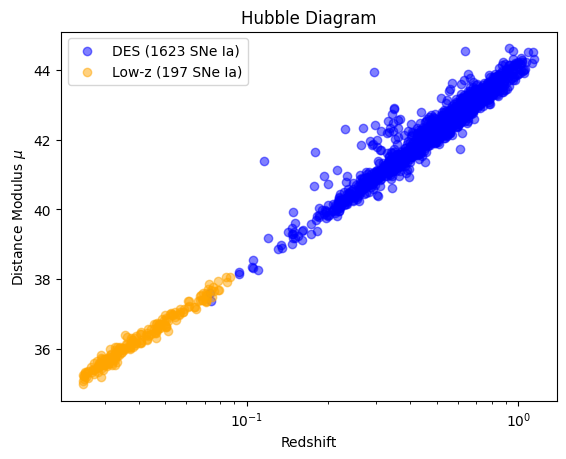

In [2]:
import matplotlib.pyplot as plt

plt.scatter(
    DES_sample["zHD"],
    DES_sample["MU"],
    c="b",
    alpha=0.5,
    marker="o",
    label="DES (1623 SNe Ia)",
)
plt.scatter(
    LOWZ_sample["zHD"],
    LOWZ_sample["MU"],
    c="orange",
    alpha=0.5,
    marker="o",
    label="Low-z (197 SNe Ia)",
)
plt.xscale("log")
plt.xlabel("Redshift")
plt.ylabel(r"Distance Modulus $\mu$")
plt.title("Hubble Diagram")
plt.legend()

### Hubble Diagram with Error

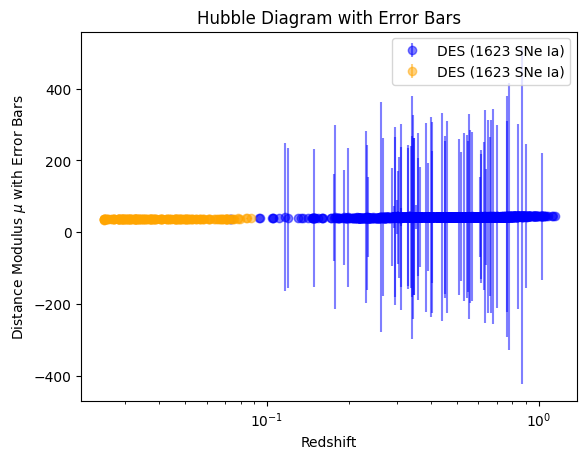

In [3]:
plt.errorbar(
    DES_sample["zHD"],
    DES_sample["MU"],
    DES_sample["MUERR"],
    c="b",
    alpha=0.5,
    fmt="o",
    label="DES (1623 SNe Ia)",
)
plt.errorbar(
    LOWZ_sample["zHD"],
    LOWZ_sample["MU"],
    LOWZ_sample["MUERR"],
    c="orange",
    alpha=0.5,
    fmt="o",
    label="DES (1623 SNe Ia)",
)
plt.xscale("log")
plt.xlabel("Redshift")
plt.ylabel(r"Distance Modulus $\mu$ with Error Bars")
plt.title("Hubble Diagram with Error Bars")
plt.legend()

CMT: Higher redshift samples have large uncertanties on distance modulus.

### Sample Distribution

1623


Text(0.5, 1.0, 'Redshift Distribution of SNe Ia Samples')

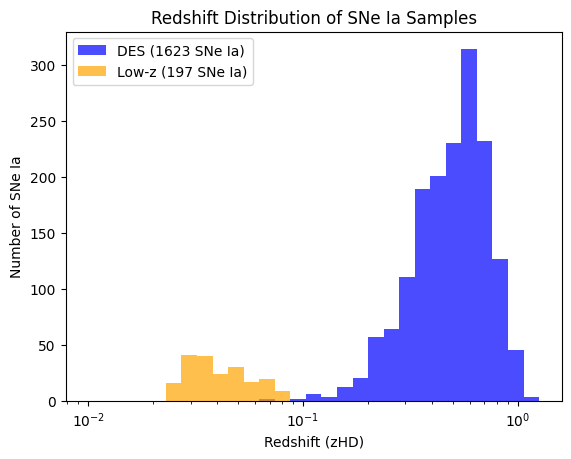

In [4]:
bins = np.logspace(-2, 0.1, 30)
plt.hist(DES_sample['zHD'], bins=bins, alpha=0.7, label='DES (1623 SNe Ia)', color='b')
plt.hist(LOWZ_sample['zHD'], bins=bins, alpha=0.7, label='Low-z (197 SNe Ia)', color='orange')
print(len(DES_sample))
plt.xscale('log')
plt.legend()
plt.xlabel('Redshift (zHD)')
plt.ylabel('Number of SNe Ia')
plt.title('Redshift Distribution of SNe Ia Samples')

## Fit Cosmology

### Define Cosmology

In [5]:
import numpy as np
import scipy.constants as const
from scipy.integrate import quad


def E_Flat_LCDM(z, Omega_m):
    """Flat ΛCDM: E(z) function."""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m))


def E_Open_LCDM(z, Omega_m, Omega_k):
    """Open ΛCDM: E(z) function."""
    Omega_Lambda = 1 - Omega_m - Omega_k
    return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)


def E_Flat_wCDM(z, Omega_m, w):
    """Flat wCDM: E(z) function."""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m) * (1 + z) ** (3 * (1 + w)))


def E_Flat_w0waCDM(z, Omega_m, w0, wa):
    """
    Flat w0waCDM: E(z) function. Using CPL paramerization: w(z) = w0 + wa * z/(1+z).
    """
    Omega_DE = 1 - Omega_m
    return np.sqrt(
        Omega_m * (1 + z) ** 3
        + Omega_DE * (1 + z) ** (3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    )


def luminosity_distance_Flat_LCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat ΛCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m = params[0]
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_LCDM(z_prime, Omega_m)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def luminosity_distance_Open_LCDM(z, params, H0=70.0):
    """
    Distance Modulus for Open ΛCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                Omega_k: Curvature density parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, Omega_k = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Open_LCDM(z_prime, Omega_m, Omega_k)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)
    dC *= dH

    # Comoving transverse distance
    if Omega_k == 0:
        dM = dC
    elif Omega_k > 0:
        dM = dH / np.sqrt(Omega_k) * np.sinh(np.sqrt(Omega_k) * dC / dH)  # 开放
    else:
        dM = dH / np.sqrt(-Omega_k) * np.sin(np.sqrt(-Omega_k) * dC / dH)  # 闭合

    return (1 + z) * dM


def luminosity_distance_Flat_wCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat wCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                w: Dark energy equation of state parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, w = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_wCDM(z_prime, Omega_m, w)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def luminosity_distance_Flat_w0waCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat w0waCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                w0: Dark energy equation of state parameter at z=0
                wa: Evolution parameter of dark energy equation of state
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, w0, wa = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_w0waCDM(z_prime, Omega_m, w0, wa)

    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def distance_modulus(z, params, model="Flat_LCDM"):
    """
    Distance modulus for various cosmological models.

    Parameters:
        z: Redshift
        params: Model parameters (tuple)
        model: Cosmological model. Options: "Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"
    Returns:
        Distance Modulus (mu)
    """
    model_funcs = {
        "Flat_LCDM": luminosity_distance_Flat_LCDM,
        "Open_LCDM": luminosity_distance_Open_LCDM,
        "Flat_wCDM": luminosity_distance_Flat_wCDM,
        "Flat_w0waCDM": luminosity_distance_Flat_w0waCDM,
    }

    if model not in model_funcs:
        raise ValueError(f"Invalid model: {model}. Valid models: {list(model_funcs.keys())}")

    dL = model_funcs[model](z, params, H0=70.0)

    return 5 * np.log10(dL / 10) + 25

### Setup Sampler

In [ ]:
from ultranest.integrator import ReactiveNestedSampler
import scipy

# load data
z_data = SN_sample["zHD"].data
mu_data = SN_sample["MU"].data
flat_cov_total_inv = np.load("./data/STAT+SYS.npz")["cov"]
C_total_inv = np.zeros((num_samples, num_samples))
indices = np.triu_indices(num_samples)  # Indices for upper triangular part
C_total_inv[indices] = flat_cov_total_inv
C_total_inv = C_total_inv + C_total_inv.T - np.diag(np.diag(C_total_inv))
C_total = np.linalg.inv(C_total_inv)

L = np.linalg.cholesky(
    C_total
)  # Precompute Cholesky decomposition (for fast likelihood calculation)


def prior_transform(cube, param_ranges):
    """
    Transform unit cube [0,1]^d to physical parameter space.
    """
    params = np.zeros_like(cube)
    for i in range(len(param_ranges)):
        params[i] = (
            cube[i] * (param_ranges[i][1] - param_ranges[i][0]) + param_ranges[i][0]
        )
    return params


def log_likelihood(params, model="Flat_LCDM"):
    """
    Log likelihood function: -0.5 * chi^2.
    """
    M = params[-1]

    # Compute theoretical distance moduli (M is the absolute magnitude term in μ = 5log10(dL/10) + 25
    mu_theory = np.array(
        [distance_modulus(z, params[:-1], model=model) + M for z in z_data]
    )

    residuals = mu_data - mu_theory
    if np.any(np.isinf(residuals)) or np.any(np.isnan(residuals)):
        return -1.0e99 * (np.abs(M) + 1)
    if model == "Flat_w0waCDM":
        w0 = params[1]
        wa = params[2]
        if w0 + wa >= 0:
            return -1.0e99 * (np.abs(w0 + wa) + 1)  # make sure w0+wa < 0
    y = scipy.linalg.solve_triangular(L, residuals, lower=True)
    chi2 = np.sum(y**2)

    return -0.5 * chi2


models = ["Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"]


def fit_cosmology(cosmology_model="Flat_LCDM"):
    """
    Use UltraNest to fit cosmological parameters for a given model.

    Parameters:
        cosmology_model: Cosmological model to fit. Options: "Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"
    Returns:
        UltraNest result object.
    """
    param_names = {
        "Flat_LCDM": ["Omega_m", "M"],
        "Open_LCDM": ["Omega_m", "Omega_k", "M"],
        "Flat_wCDM": ["Omega_m", "w", "M"],
        "Flat_w0waCDM": ["Omega_m", "w0", "wa", "M"],
    }

    # Parameter ranges for sampling
    param_ranges = {
        "Flat_LCDM": [(0.25, 0.4), (-20, 10)],
        "Open_LCDM": [(0.1, 0.5), (-1, 1), (-20, 10)],
        "Flat_wCDM": [(0.1, 0.4), (-2, 0.5), (-20, 10)],
        "Flat_w0waCDM": [(0.0, 1.0), (-20, 10), (-20, 10), (-20, 10)],
    }

    # Parameter ranges adjusted to match Dovekie literature constraints
    # param_ranges = {
    #     "Flat_LCDM": [(0.1, 0.5), (4, 6)],  # Omega_m: 与论文一致  # M: 保持原范围
    #     "Open_LCDM": [
    #         (0.1, 0.5),  # Omega_m: 与论文一致
    #         (-0.15, 0.15),  # Omega_k: 与论文一致
    #         (4, 6),  # M: 保持原范围
    #     ],
    #     "Flat_wCDM": [
    #         (0.1, 0.5),  # Omega_m: 与论文一致
    #         (-3, -0.4),  # w: 注意论文中w0范围是(-3,-0.4)，wCDM中w=w0
    #         (4, 6),  # M: 保持原范围
    #     ],
    #     "Flat_w0waCDM": [
    #         (0.1, 0.5),  # Omega_m: 与论文一致
    #         (-3, -0.4),  # w0: 与论文一致
    #         (-3, 2),  # wa: 与论文一致
    #         (4, 6),  # M: 保持原范围
    #     ],
    # }

    sampler = ReactiveNestedSampler(
        param_names[cosmology_model],
        lambda params: log_likelihood(params, model=cosmology_model),
        lambda cube: prior_transform(cube, param_ranges[cosmology_model]),
    )

    # Run sampling
    result = sampler.run()
    return result

### Fit Results

In [ ]:
from getdist import MCSamples, plots
from ultranest.plot import cornerplot
import pickle
import os

def smooth_plot(result):
    samples = result['samples']  # Shape: (n_samples, n_params)
    weights = result['weighted_samples']['weights']

    param_names_all = result['paramnames']

    # Create MCSamples object excluding the last parameter M
    samples_mcd = MCSamples(
        samples=samples[:, :-1],  # Exclude the last parameter
        weights=weights,
        names=param_names_all[:-1],  # Exclude the last parameter name (M)
        settings={'smooth_scale_2D': 0.8}
    )

    # Plot cornerplot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_mcd], filled=True)

fit_dir = 'fits' # directory to save fit results for 
# fit_dir = 'fits_Dovekie' # directory to save fit results according to parameter ranges of Dovekie
os.makedirs(fit_dir, exist_ok=True)

#### Flat LCDM

In [22]:
Flat_LCDM_result = fit_cosmology("Flat_LCDM")
with open(f'{fit_dir}/Flat_LCDM_result.pkl', 'wb') as f:
    pickle.dump(Flat_LCDM_result, f)

DEBUG:ultranest:ReactiveNestedSampler: dims=2+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(400.0)), (np.float64(inf), np.float64(400.0))]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-13692400.49, Lmax=-1150.96


DEBUG:ultranest:iteration=5, ncalls=406, regioncalls=240, ndraw=40, logz=-13295164.94, remainder_fraction=100.0000%, Lmin=-13271943.20, Lmax=-1150.96


DEBUG:ultranest:iteration=12, ncalls=413, regioncalls=520, ndraw=40, logz=-12337881.57, remainder_fraction=100.0000%, Lmin=-12289215.11, Lmax=-1150.96


DEBUG:ultranest:iteration=18, ncalls=420, regioncalls=800, ndraw=40, logz=-12208520.82, remainder_fraction=100.0000%, Lmin=-12109141.55, Lmax=-1150.96


DEBUG:ultranest:iteration=25, ncalls=427, regioncalls=1080, ndraw=40, logz=-11568117.92, remainder_fraction=100.0000%, Lmin=-11517384.63, Lmax=-1150.96


DEBUG:ultranest:iteration=32, ncalls=434, regioncalls=1360, ndraw=40, logz=-11322167.40, remainder_fraction=100.0000%, Lmin=-11230541.83, Lmax=-1150.96


DEBUG:ultranest:iteration=38, ncalls=441, regioncalls=1640, ndraw=40, logz=-10712354.30, remainder_fraction=100.0000%, Lmin=-10672016.08, Lmax=-1150.96


DEBUG:ultranest:iteration=40, ncalls=444, regioncalls=1760, ndraw=40, logz=-10487330.87, remainder_fraction=100.0000%, Lmin=-10438942.10, Lmax=-1150.96


DEBUG:ultranest:iteration=47, ncalls=452, regioncalls=2080, ndraw=40, logz=-10055167.17, remainder_fraction=100.0000%, Lmin=-10011429.47, Lmax=-1150.96


DEBUG:ultranest:iteration=51, ncalls=460, regioncalls=2400, ndraw=40, logz=-9868670.44, remainder_fraction=100.0000%, Lmin=-9777218.76, Lmax=-1150.96


DEBUG:ultranest:iteration=58, ncalls=467, regioncalls=2680, ndraw=40, logz=-9501304.33, remainder_fraction=100.0000%, Lmin=-9321630.96, Lmax=-1150.96


DEBUG:ultranest:iteration=64, ncalls=474, regioncalls=2960, ndraw=40, logz=-9125384.07, remainder_fraction=100.0000%, Lmin=-9059701.14, Lmax=-1150.96


DEBUG:ultranest:iteration=69, ncalls=481, regioncalls=3240, ndraw=40, logz=-8835159.59, remainder_fraction=100.0000%, Lmin=-8834267.61, Lmax=-1150.96


DEBUG:ultranest:iteration=76, ncalls=488, regioncalls=3520, ndraw=40, logz=-8656185.26, remainder_fraction=100.0000%, Lmin=-8481967.27, Lmax=-1150.96


DEBUG:ultranest:iteration=80, ncalls=492, regioncalls=3680, ndraw=40, logz=-8444026.76, remainder_fraction=100.0000%, Lmin=-8421552.04, Lmax=-1150.96


DEBUG:ultranest:iteration=86, ncalls=499, regioncalls=3960, ndraw=40, logz=-8219302.60, remainder_fraction=100.0000%, Lmin=-8154558.85, Lmax=-1150.96


DEBUG:ultranest:iteration=92, ncalls=505, regioncalls=4200, ndraw=40, logz=-7460434.42, remainder_fraction=100.0000%, Lmin=-7459256.48, Lmax=-1150.96


DEBUG:ultranest:iteration=98, ncalls=512, regioncalls=4480, ndraw=40, logz=-7392092.04, remainder_fraction=100.0000%, Lmin=-7387805.27, Lmax=-1123.75


DEBUG:ultranest:iteration=104, ncalls=518, regioncalls=4720, ndraw=40, logz=-7211692.39, remainder_fraction=100.0000%, Lmin=-7200373.93, Lmax=-1123.75


DEBUG:ultranest:iteration=110, ncalls=525, regioncalls=5000, ndraw=40, logz=-6966607.50, remainder_fraction=100.0000%, Lmin=-6958153.48, Lmax=-1123.75


DEBUG:ultranest:iteration=116, ncalls=532, regioncalls=5280, ndraw=40, logz=-6832744.04, remainder_fraction=100.0000%, Lmin=-6804828.97, Lmax=-1123.75


DEBUG:ultranest:iteration=120, ncalls=537, regioncalls=5480, ndraw=40, logz=-6745916.52, remainder_fraction=100.0000%, Lmin=-6724477.08, Lmax=-1123.75


DEBUG:ultranest:iteration=127, ncalls=544, regioncalls=5760, ndraw=40, logz=-6399984.46, remainder_fraction=100.0000%, Lmin=-6371579.72, Lmax=-1123.75


DEBUG:ultranest:iteration=134, ncalls=551, regioncalls=6040, ndraw=40, logz=-6108517.42, remainder_fraction=100.0000%, Lmin=-6100206.31, Lmax=-1123.75


DEBUG:ultranest:iteration=139, ncalls=558, regioncalls=6320, ndraw=40, logz=-6043462.08, remainder_fraction=100.0000%, Lmin=-6037854.89, Lmax=-1123.75


DEBUG:ultranest:iteration=146, ncalls=565, regioncalls=6600, ndraw=40, logz=-5836114.92, remainder_fraction=100.0000%, Lmin=-5788390.25, Lmax=-1075.16


DEBUG:ultranest:iteration=152, ncalls=573, regioncalls=6920, ndraw=40, logz=-5560292.99, remainder_fraction=100.0000%, Lmin=-5488257.95, Lmax=-1075.16


DEBUG:ultranest:iteration=158, ncalls=580, regioncalls=7200, ndraw=40, logz=-5312260.10, remainder_fraction=100.0000%, Lmin=-5286351.52, Lmax=-1075.16


DEBUG:ultranest:iteration=160, ncalls=582, regioncalls=7280, ndraw=40, logz=-5285743.49, remainder_fraction=100.0000%, Lmin=-5239122.89, Lmax=-1075.16


DEBUG:ultranest:iteration=166, ncalls=588, regioncalls=7520, ndraw=40, logz=-4973553.92, remainder_fraction=100.0000%, Lmin=-4964484.72, Lmax=-856.62


DEBUG:ultranest:iteration=172, ncalls=596, regioncalls=7840, ndraw=40, logz=-4843933.50, remainder_fraction=100.0000%, Lmin=-4808087.11, Lmax=-856.62


DEBUG:ultranest:iteration=177, ncalls=603, regioncalls=8120, ndraw=40, logz=-4763828.69, remainder_fraction=100.0000%, Lmin=-4714204.38, Lmax=-856.62


DEBUG:ultranest:iteration=180, ncalls=606, regioncalls=8240, ndraw=40, logz=-4679367.23, remainder_fraction=100.0000%, Lmin=-4623338.89, Lmax=-856.62


DEBUG:ultranest:iteration=187, ncalls=613, regioncalls=8520, ndraw=40, logz=-4324705.93, remainder_fraction=100.0000%, Lmin=-4299562.44, Lmax=-856.62


DEBUG:ultranest:iteration=194, ncalls=621, regioncalls=8840, ndraw=40, logz=-4120044.17, remainder_fraction=100.0000%, Lmin=-4114392.06, Lmax=-856.62


DEBUG:ultranest:iteration=200, ncalls=628, regioncalls=9120, ndraw=40, logz=-3865147.33, remainder_fraction=100.0000%, Lmin=-3824702.41, Lmax=-856.62


DEBUG:ultranest:iteration=207, ncalls=635, regioncalls=9400, ndraw=40, logz=-3750545.25, remainder_fraction=100.0000%, Lmin=-3733490.44, Lmax=-856.62


DEBUG:ultranest:iteration=213, ncalls=642, regioncalls=9680, ndraw=40, logz=-3613522.26, remainder_fraction=100.0000%, Lmin=-3610881.54, Lmax=-856.62


DEBUG:ultranest:iteration=219, ncalls=648, regioncalls=9920, ndraw=40, logz=-3537076.36, remainder_fraction=100.0000%, Lmin=-3532130.54, Lmax=-856.62


DEBUG:ultranest:iteration=225, ncalls=654, regioncalls=10160, ndraw=40, logz=-3459261.61, remainder_fraction=100.0000%, Lmin=-3431683.74, Lmax=-856.62


DEBUG:ultranest:iteration=232, ncalls=662, regioncalls=10480, ndraw=40, logz=-3222250.58, remainder_fraction=100.0000%, Lmin=-3071778.10, Lmax=-856.62


DEBUG:ultranest:iteration=239, ncalls=669, regioncalls=10760, ndraw=40, logz=-3026079.63, remainder_fraction=100.0000%, Lmin=-3003463.09, Lmax=-856.62


DEBUG:ultranest:iteration=240, ncalls=670, regioncalls=10800, ndraw=40, logz=-3003469.68, remainder_fraction=100.0000%, Lmin=-2998708.27, Lmax=-856.62


DEBUG:ultranest:iteration=246, ncalls=677, regioncalls=11080, ndraw=40, logz=-2928349.76, remainder_fraction=100.0000%, Lmin=-2905708.60, Lmax=-856.62


DEBUG:ultranest:iteration=253, ncalls=684, regioncalls=11360, ndraw=40, logz=-2788244.35, remainder_fraction=100.0000%, Lmin=-2784744.78, Lmax=-856.62


DEBUG:ultranest:iteration=260, ncalls=691, regioncalls=11640, ndraw=40, logz=-2600677.03, remainder_fraction=100.0000%, Lmin=-2599945.36, Lmax=-856.62


DEBUG:ultranest:iteration=266, ncalls=698, regioncalls=11920, ndraw=40, logz=-2540199.42, remainder_fraction=100.0000%, Lmin=-2536308.29, Lmax=-856.62


DEBUG:ultranest:iteration=270, ncalls=702, regioncalls=12080, ndraw=40, logz=-2482493.31, remainder_fraction=100.0000%, Lmin=-2479456.79, Lmax=-856.62


DEBUG:ultranest:iteration=276, ncalls=709, regioncalls=12360, ndraw=40, logz=-2405021.83, remainder_fraction=100.0000%, Lmin=-2380926.12, Lmax=-856.62


DEBUG:ultranest:iteration=280, ncalls=713, regioncalls=12520, ndraw=40, logz=-2337570.67, remainder_fraction=100.0000%, Lmin=-2321951.60, Lmax=-856.62


DEBUG:ultranest:iteration=287, ncalls=720, regioncalls=12800, ndraw=40, logz=-2195932.95, remainder_fraction=100.0000%, Lmin=-2190220.08, Lmax=-856.62


DEBUG:ultranest:iteration=294, ncalls=727, regioncalls=13080, ndraw=40, logz=-2120679.77, remainder_fraction=100.0000%, Lmin=-2091852.22, Lmax=-856.62


DEBUG:ultranest:iteration=301, ncalls=736, regioncalls=13440, ndraw=40, logz=-1972915.22, remainder_fraction=100.0000%, Lmin=-1966183.19, Lmax=-856.62


DEBUG:ultranest:iteration=308, ncalls=744, regioncalls=13760, ndraw=40, logz=-1917085.78, remainder_fraction=100.0000%, Lmin=-1906755.45, Lmax=-856.62


DEBUG:ultranest:iteration=314, ncalls=754, regioncalls=14160, ndraw=40, logz=-1836099.32, remainder_fraction=100.0000%, Lmin=-1836025.91, Lmax=-856.62


DEBUG:ultranest:iteration=320, ncalls=760, regioncalls=14400, ndraw=40, logz=-1739463.08, remainder_fraction=100.0000%, Lmin=-1725615.10, Lmax=-856.62


DEBUG:ultranest:iteration=326, ncalls=767, regioncalls=14680, ndraw=40, logz=-1608394.52, remainder_fraction=100.0000%, Lmin=-1604271.21, Lmax=-856.62


DEBUG:ultranest:iteration=332, ncalls=774, regioncalls=14960, ndraw=40, logz=-1560377.16, remainder_fraction=100.0000%, Lmin=-1550762.60, Lmax=-856.62


DEBUG:ultranest:iteration=338, ncalls=781, regioncalls=15240, ndraw=40, logz=-1481146.13, remainder_fraction=100.0000%, Lmin=-1479874.70, Lmax=-856.62


DEBUG:ultranest:iteration=344, ncalls=788, regioncalls=15520, ndraw=40, logz=-1425936.86, remainder_fraction=100.0000%, Lmin=-1412264.83, Lmax=-856.62


DEBUG:ultranest:iteration=350, ncalls=795, regioncalls=15800, ndraw=40, logz=-1317348.44, remainder_fraction=100.0000%, Lmin=-1312836.30, Lmax=-856.62


DEBUG:ultranest:iteration=356, ncalls=802, regioncalls=16080, ndraw=40, logz=-1291894.19, remainder_fraction=100.0000%, Lmin=-1285751.65, Lmax=-856.62


DEBUG:ultranest:iteration=360, ncalls=806, regioncalls=16240, ndraw=40, logz=-1265699.12, remainder_fraction=100.0000%, Lmin=-1254626.92, Lmax=-856.62


DEBUG:ultranest:iteration=367, ncalls=813, regioncalls=16520, ndraw=40, logz=-1196681.78, remainder_fraction=100.0000%, Lmin=-1196563.78, Lmax=-856.62


DEBUG:ultranest:iteration=372, ncalls=820, regioncalls=16800, ndraw=40, logz=-1069567.76, remainder_fraction=100.0000%, Lmin=-1068579.11, Lmax=-856.62


DEBUG:ultranest:iteration=378, ncalls=827, regioncalls=17080, ndraw=40, logz=-1040183.04, remainder_fraction=100.0000%, Lmin=-1038582.18, Lmax=-856.62


DEBUG:ultranest:iteration=385, ncalls=834, regioncalls=17360, ndraw=40, logz=-977983.28, remainder_fraction=100.0000%, Lmin=-975045.53, Lmax=-856.62


DEBUG:ultranest:iteration=391, ncalls=841, regioncalls=17640, ndraw=40, logz=-910210.70, remainder_fraction=100.0000%, Lmin=-907144.26, Lmax=-856.62


DEBUG:ultranest:iteration=395, ncalls=848, regioncalls=17920, ndraw=40, logz=-892161.93, remainder_fraction=100.0000%, Lmin=-873243.85, Lmax=-818.77


DEBUG:ultranest:iteration=400, ncalls=855, regioncalls=18200, ndraw=40, logz=-832337.47, remainder_fraction=100.0000%, Lmin=-828794.62, Lmax=-818.77


DEBUG:ultranest:iteration=407, ncalls=862, regioncalls=18480, ndraw=40, logz=-794849.89, remainder_fraction=100.0000%, Lmin=-787373.28, Lmax=-818.77


DEBUG:ultranest:iteration=412, ncalls=870, regioncalls=18800, ndraw=40, logz=-779770.56, remainder_fraction=100.0000%, Lmin=-769348.07, Lmax=-818.77


DEBUG:ultranest:iteration=418, ncalls=876, regioncalls=19040, ndraw=40, logz=-746691.51, remainder_fraction=100.0000%, Lmin=-734090.75, Lmax=-818.77


DEBUG:ultranest:iteration=422, ncalls=882, regioncalls=19280, ndraw=40, logz=-711667.39, remainder_fraction=100.0000%, Lmin=-705311.29, Lmax=-818.77


DEBUG:ultranest:iteration=426, ncalls=889, regioncalls=19560, ndraw=40, logz=-632393.13, remainder_fraction=100.0000%, Lmin=-631965.76, Lmax=-818.77


DEBUG:ultranest:iteration=431, ncalls=895, regioncalls=19800, ndraw=40, logz=-595338.39, remainder_fraction=100.0000%, Lmin=-593366.09, Lmax=-818.77


DEBUG:ultranest:iteration=437, ncalls=902, regioncalls=20080, ndraw=40, logz=-568011.67, remainder_fraction=100.0000%, Lmin=-567848.16, Lmax=-818.77


DEBUG:ultranest:iteration=440, ncalls=907, regioncalls=20280, ndraw=40, logz=-545284.75, remainder_fraction=100.0000%, Lmin=-544628.65, Lmax=-818.77


DEBUG:ultranest:iteration=445, ncalls=914, regioncalls=20560, ndraw=40, logz=-530009.50, remainder_fraction=100.0000%, Lmin=-527243.31, Lmax=-818.77


DEBUG:ultranest:iteration=450, ncalls=920, regioncalls=20800, ndraw=40, logz=-517362.20, remainder_fraction=100.0000%, Lmin=-517166.21, Lmax=-818.77


DEBUG:ultranest:iteration=457, ncalls=927, regioncalls=21080, ndraw=40, logz=-496401.65, remainder_fraction=100.0000%, Lmin=-495652.08, Lmax=-818.77


DEBUG:ultranest:iteration=462, ncalls=934, regioncalls=21360, ndraw=40, logz=-480672.60, remainder_fraction=100.0000%, Lmin=-478933.99, Lmax=-818.77


DEBUG:ultranest:iteration=468, ncalls=941, regioncalls=21640, ndraw=40, logz=-470629.15, remainder_fraction=100.0000%, Lmin=-469037.20, Lmax=-818.77


DEBUG:ultranest:iteration=475, ncalls=948, regioncalls=21920, ndraw=40, logz=-459824.41, remainder_fraction=100.0000%, Lmin=-457060.72, Lmax=-818.77


DEBUG:ultranest:iteration=480, ncalls=954, regioncalls=22160, ndraw=40, logz=-445213.50, remainder_fraction=100.0000%, Lmin=-440298.56, Lmax=-818.77


DEBUG:ultranest:iteration=487, ncalls=962, regioncalls=22480, ndraw=40, logz=-421128.86, remainder_fraction=100.0000%, Lmin=-417946.73, Lmax=-818.77


DEBUG:ultranest:iteration=494, ncalls=969, regioncalls=22760, ndraw=40, logz=-406618.25, remainder_fraction=100.0000%, Lmin=-406153.57, Lmax=-818.77


DEBUG:ultranest:iteration=501, ncalls=976, regioncalls=23040, ndraw=40, logz=-400160.83, remainder_fraction=100.0000%, Lmin=-399850.52, Lmax=-818.77


DEBUG:ultranest:iteration=508, ncalls=983, regioncalls=23320, ndraw=40, logz=-387442.97, remainder_fraction=100.0000%, Lmin=-386730.98, Lmax=-818.77


DEBUG:ultranest:iteration=513, ncalls=990, regioncalls=23600, ndraw=40, logz=-377545.67, remainder_fraction=100.0000%, Lmin=-376459.46, Lmax=-818.77


DEBUG:ultranest:iteration=519, ncalls=997, regioncalls=23880, ndraw=40, logz=-374781.10, remainder_fraction=100.0000%, Lmin=-373207.50, Lmax=-818.77


DEBUG:ultranest:iteration=520, ncalls=998, regioncalls=23920, ndraw=40, logz=-373214.79, remainder_fraction=100.0000%, Lmin=-372155.95, Lmax=-818.77


DEBUG:ultranest:iteration=526, ncalls=1005, regioncalls=24200, ndraw=40, logz=-366181.09, remainder_fraction=100.0000%, Lmin=-362402.86, Lmax=-818.77


DEBUG:ultranest:iteration=532, ncalls=1012, regioncalls=24480, ndraw=40, logz=-356559.71, remainder_fraction=100.0000%, Lmin=-352301.52, Lmax=-818.77


DEBUG:ultranest:iteration=537, ncalls=1019, regioncalls=24760, ndraw=40, logz=-342502.93, remainder_fraction=100.0000%, Lmin=-341729.58, Lmax=-818.77


DEBUG:ultranest:iteration=540, ncalls=1022, regioncalls=24880, ndraw=40, logz=-341244.44, remainder_fraction=100.0000%, Lmin=-340180.16, Lmax=-818.77


DEBUG:ultranest:iteration=547, ncalls=1029, regioncalls=25160, ndraw=40, logz=-329770.24, remainder_fraction=100.0000%, Lmin=-329525.26, Lmax=-818.77


DEBUG:ultranest:iteration=552, ncalls=1036, regioncalls=25440, ndraw=40, logz=-320406.25, remainder_fraction=100.0000%, Lmin=-318371.12, Lmax=-818.77


DEBUG:ultranest:iteration=557, ncalls=1043, regioncalls=25720, ndraw=40, logz=-313371.33, remainder_fraction=100.0000%, Lmin=-313231.38, Lmax=-818.77


DEBUG:ultranest:iteration=560, ncalls=1047, regioncalls=25880, ndraw=40, logz=-311669.71, remainder_fraction=100.0000%, Lmin=-310853.52, Lmax=-818.77


DEBUG:ultranest:iteration=566, ncalls=1054, regioncalls=26160, ndraw=40, logz=-303767.59, remainder_fraction=100.0000%, Lmin=-302300.07, Lmax=-818.77


DEBUG:ultranest:iteration=572, ncalls=1061, regioncalls=26440, ndraw=40, logz=-296923.91, remainder_fraction=100.0000%, Lmin=-291471.59, Lmax=-818.77


DEBUG:ultranest:iteration=578, ncalls=1069, regioncalls=26760, ndraw=40, logz=-284177.56, remainder_fraction=100.0000%, Lmin=-282733.36, Lmax=-818.77


DEBUG:ultranest:iteration=583, ncalls=1078, regioncalls=27120, ndraw=40, logz=-274524.90, remainder_fraction=100.0000%, Lmin=-272609.35, Lmax=-818.77


DEBUG:ultranest:iteration=588, ncalls=1085, regioncalls=27400, ndraw=40, logz=-266519.77, remainder_fraction=100.0000%, Lmin=-262634.07, Lmax=-818.77


DEBUG:ultranest:iteration=594, ncalls=1092, regioncalls=27680, ndraw=40, logz=-255767.41, remainder_fraction=100.0000%, Lmin=-253517.00, Lmax=-818.77


DEBUG:ultranest:iteration=600, ncalls=1098, regioncalls=27920, ndraw=40, logz=-251247.78, remainder_fraction=100.0000%, Lmin=-247543.30, Lmax=-818.77


DEBUG:ultranest:iteration=605, ncalls=1106, regioncalls=28240, ndraw=40, logz=-242118.34, remainder_fraction=100.0000%, Lmin=-241888.74, Lmax=-818.77


DEBUG:ultranest:iteration=611, ncalls=1113, regioncalls=28520, ndraw=40, logz=-239019.89, remainder_fraction=100.0000%, Lmin=-238946.93, Lmax=-818.77


DEBUG:ultranest:iteration=615, ncalls=1120, regioncalls=28800, ndraw=40, logz=-238282.54, remainder_fraction=100.0000%, Lmin=-238270.50, Lmax=-818.77


DEBUG:ultranest:iteration=621, ncalls=1127, regioncalls=29080, ndraw=40, logz=-233507.25, remainder_fraction=100.0000%, Lmin=-232710.42, Lmax=-818.77


DEBUG:ultranest:iteration=627, ncalls=1136, regioncalls=29440, ndraw=40, logz=-224347.25, remainder_fraction=100.0000%, Lmin=-224297.34, Lmax=-818.77


DEBUG:ultranest:iteration=632, ncalls=1144, regioncalls=29760, ndraw=40, logz=-220418.81, remainder_fraction=100.0000%, Lmin=-218089.79, Lmax=-818.77


DEBUG:ultranest:iteration=635, ncalls=1150, regioncalls=30000, ndraw=40, logz=-216679.37, remainder_fraction=100.0000%, Lmin=-213672.42, Lmax=-818.77


DEBUG:ultranest:iteration=640, ncalls=1158, regioncalls=30320, ndraw=40, logz=-207428.20, remainder_fraction=100.0000%, Lmin=-206396.13, Lmax=-818.77


DEBUG:ultranest:iteration=644, ncalls=1168, regioncalls=30720, ndraw=40, logz=-205342.54, remainder_fraction=100.0000%, Lmin=-205088.28, Lmax=-818.77


DEBUG:ultranest:iteration=651, ncalls=1175, regioncalls=31000, ndraw=40, logz=-198785.81, remainder_fraction=100.0000%, Lmin=-197419.51, Lmax=-818.77


DEBUG:ultranest:iteration=655, ncalls=1182, regioncalls=31280, ndraw=40, logz=-193769.99, remainder_fraction=100.0000%, Lmin=-193722.60, Lmax=-818.77


DEBUG:ultranest:iteration=661, ncalls=1190, regioncalls=31600, ndraw=40, logz=-186866.07, remainder_fraction=100.0000%, Lmin=-186791.47, Lmax=-818.77


DEBUG:ultranest:iteration=665, ncalls=1197, regioncalls=31880, ndraw=40, logz=-185407.31, remainder_fraction=100.0000%, Lmin=-182609.75, Lmax=-818.77


DEBUG:ultranest:iteration=670, ncalls=1204, regioncalls=32160, ndraw=40, logz=-179730.72, remainder_fraction=100.0000%, Lmin=-178566.84, Lmax=-818.77


DEBUG:ultranest:iteration=675, ncalls=1213, regioncalls=32520, ndraw=40, logz=-175262.88, remainder_fraction=100.0000%, Lmin=-171853.11, Lmax=-818.77


DEBUG:ultranest:iteration=680, ncalls=1219, regioncalls=32760, ndraw=40, logz=-168957.02, remainder_fraction=100.0000%, Lmin=-166983.38, Lmax=-818.77


DEBUG:ultranest:iteration=683, ncalls=1225, regioncalls=33000, ndraw=40, logz=-164629.90, remainder_fraction=100.0000%, Lmin=-163529.54, Lmax=-818.77


DEBUG:ultranest:iteration=688, ncalls=1231, regioncalls=33240, ndraw=40, logz=-160770.92, remainder_fraction=100.0000%, Lmin=-160288.12, Lmax=-818.77


DEBUG:ultranest:iteration=693, ncalls=1238, regioncalls=33520, ndraw=40, logz=-156842.16, remainder_fraction=100.0000%, Lmin=-155694.71, Lmax=-818.77


DEBUG:ultranest:iteration=699, ncalls=1250, regioncalls=34000, ndraw=40, logz=-153029.32, remainder_fraction=100.0000%, Lmin=-151678.68, Lmax=-818.77


DEBUG:ultranest:iteration=703, ncalls=1258, regioncalls=34320, ndraw=40, logz=-150472.80, remainder_fraction=100.0000%, Lmin=-150446.66, Lmax=-818.77


DEBUG:ultranest:iteration=709, ncalls=1268, regioncalls=34720, ndraw=40, logz=-147992.01, remainder_fraction=100.0000%, Lmin=-147852.04, Lmax=-818.77


DEBUG:ultranest:iteration=711, ncalls=1276, regioncalls=35040, ndraw=40, logz=-147761.93, remainder_fraction=100.0000%, Lmin=-147584.45, Lmax=-818.77


DEBUG:ultranest:iteration=718, ncalls=1283, regioncalls=35320, ndraw=40, logz=-141284.34, remainder_fraction=100.0000%, Lmin=-140581.61, Lmax=-818.77


DEBUG:ultranest:iteration=720, ncalls=1285, regioncalls=35400, ndraw=40, logz=-140505.69, remainder_fraction=100.0000%, Lmin=-140010.06, Lmax=-818.77


DEBUG:ultranest:iteration=726, ncalls=1292, regioncalls=35680, ndraw=40, logz=-136240.02, remainder_fraction=100.0000%, Lmin=-136048.12, Lmax=-818.77


DEBUG:ultranest:iteration=732, ncalls=1299, regioncalls=35960, ndraw=40, logz=-131648.13, remainder_fraction=100.0000%, Lmin=-131428.57, Lmax=-818.77


DEBUG:ultranest:iteration=738, ncalls=1306, regioncalls=36240, ndraw=40, logz=-127678.98, remainder_fraction=100.0000%, Lmin=-127356.83, Lmax=-818.77


DEBUG:ultranest:iteration=745, ncalls=1314, regioncalls=36560, ndraw=40, logz=-125094.83, remainder_fraction=100.0000%, Lmin=-123353.47, Lmax=-818.77


DEBUG:ultranest:iteration=752, ncalls=1321, regioncalls=36840, ndraw=40, logz=-119819.71, remainder_fraction=100.0000%, Lmin=-119567.33, Lmax=-818.77


DEBUG:ultranest:iteration=758, ncalls=1328, regioncalls=37120, ndraw=40, logz=-117516.12, remainder_fraction=100.0000%, Lmin=-116977.04, Lmax=-818.77


DEBUG:ultranest:iteration=760, ncalls=1331, regioncalls=37240, ndraw=40, logz=-114353.99, remainder_fraction=100.0000%, Lmin=-113427.98, Lmax=-818.77


DEBUG:ultranest:iteration=766, ncalls=1338, regioncalls=37520, ndraw=40, logz=-109079.09, remainder_fraction=100.0000%, Lmin=-108546.87, Lmax=-818.77


DEBUG:ultranest:iteration=773, ncalls=1345, regioncalls=37800, ndraw=40, logz=-105997.63, remainder_fraction=100.0000%, Lmin=-105722.27, Lmax=-818.77


DEBUG:ultranest:iteration=778, ncalls=1352, regioncalls=38080, ndraw=40, logz=-102297.32, remainder_fraction=100.0000%, Lmin=-102173.57, Lmax=-818.77


DEBUG:ultranest:iteration=784, ncalls=1358, regioncalls=38320, ndraw=40, logz=-100737.32, remainder_fraction=100.0000%, Lmin=-100270.73, Lmax=-818.77


DEBUG:ultranest:iteration=788, ncalls=1365, regioncalls=38600, ndraw=40, logz=-98942.63, remainder_fraction=100.0000%, Lmin=-98362.85, Lmax=-818.77


DEBUG:ultranest:iteration=793, ncalls=1374, regioncalls=38960, ndraw=40, logz=-95508.69, remainder_fraction=100.0000%, Lmin=-95224.05, Lmax=-818.77


DEBUG:ultranest:iteration=800, ncalls=1381, regioncalls=39240, ndraw=40, logz=-91390.16, remainder_fraction=100.0000%, Lmin=-90743.06, Lmax=-818.77


DEBUG:ultranest:iteration=806, ncalls=1389, regioncalls=39560, ndraw=40, logz=-87351.76, remainder_fraction=100.0000%, Lmin=-86905.37, Lmax=-818.77


DEBUG:ultranest:iteration=810, ncalls=1393, regioncalls=39720, ndraw=40, logz=-85947.24, remainder_fraction=100.0000%, Lmin=-84486.54, Lmax=-818.77


DEBUG:ultranest:iteration=816, ncalls=1400, regioncalls=40000, ndraw=40, logz=-82834.53, remainder_fraction=100.0000%, Lmin=-81767.97, Lmax=-818.77


DEBUG:ultranest:iteration=822, ncalls=1409, regioncalls=40360, ndraw=40, logz=-78251.37, remainder_fraction=100.0000%, Lmin=-77886.16, Lmax=-818.77


DEBUG:ultranest:iteration=825, ncalls=1415, regioncalls=40600, ndraw=40, logz=-77322.74, remainder_fraction=100.0000%, Lmin=-75702.65, Lmax=-818.77


DEBUG:ultranest:iteration=829, ncalls=1424, regioncalls=40960, ndraw=40, logz=-72883.58, remainder_fraction=100.0000%, Lmin=-72857.83, Lmax=-818.77


DEBUG:ultranest:iteration=834, ncalls=1431, regioncalls=41240, ndraw=40, logz=-71653.37, remainder_fraction=100.0000%, Lmin=-71536.89, Lmax=-818.77


DEBUG:ultranest:iteration=839, ncalls=1438, regioncalls=41520, ndraw=40, logz=-69977.33, remainder_fraction=100.0000%, Lmin=-69837.05, Lmax=-818.77


DEBUG:ultranest:iteration=840, ncalls=1439, regioncalls=41560, ndraw=40, logz=-69845.14, remainder_fraction=100.0000%, Lmin=-69406.07, Lmax=-818.77


DEBUG:ultranest:iteration=847, ncalls=1448, regioncalls=41920, ndraw=40, logz=-67564.60, remainder_fraction=100.0000%, Lmin=-67345.84, Lmax=-818.77


DEBUG:ultranest:iteration=853, ncalls=1455, regioncalls=42200, ndraw=40, logz=-65046.83, remainder_fraction=100.0000%, Lmin=-64965.10, Lmax=-818.77


DEBUG:ultranest:iteration=859, ncalls=1462, regioncalls=42480, ndraw=40, logz=-63547.67, remainder_fraction=100.0000%, Lmin=-63500.68, Lmax=-818.77


DEBUG:ultranest:iteration=864, ncalls=1469, regioncalls=42760, ndraw=40, logz=-62251.76, remainder_fraction=100.0000%, Lmin=-61704.73, Lmax=-818.77


DEBUG:ultranest:iteration=868, ncalls=1477, regioncalls=43080, ndraw=40, logz=-60130.89, remainder_fraction=100.0000%, Lmin=-60102.87, Lmax=-818.77


DEBUG:ultranest:iteration=872, ncalls=1484, regioncalls=43360, ndraw=40, logz=-59742.87, remainder_fraction=100.0000%, Lmin=-59570.82, Lmax=-818.77


DEBUG:ultranest:iteration=877, ncalls=1492, regioncalls=43680, ndraw=40, logz=-58951.56, remainder_fraction=100.0000%, Lmin=-58832.54, Lmax=-818.77


DEBUG:ultranest:iteration=880, ncalls=1495, regioncalls=43800, ndraw=40, logz=-58305.84, remainder_fraction=100.0000%, Lmin=-58012.52, Lmax=-818.77


DEBUG:ultranest:iteration=884, ncalls=1504, regioncalls=44160, ndraw=40, logz=-56621.76, remainder_fraction=100.0000%, Lmin=-55977.08, Lmax=-818.77


DEBUG:ultranest:iteration=890, ncalls=1512, regioncalls=44480, ndraw=40, logz=-54527.00, remainder_fraction=100.0000%, Lmin=-54471.55, Lmax=-818.77


DEBUG:ultranest:iteration=895, ncalls=1519, regioncalls=44760, ndraw=40, logz=-53552.19, remainder_fraction=100.0000%, Lmin=-53152.41, Lmax=-818.77


DEBUG:ultranest:iteration=900, ncalls=1525, regioncalls=45000, ndraw=40, logz=-52716.94, remainder_fraction=100.0000%, Lmin=-52653.01, Lmax=-818.77


DEBUG:ultranest:iteration=907, ncalls=1532, regioncalls=45280, ndraw=40, logz=-51626.67, remainder_fraction=100.0000%, Lmin=-51456.89, Lmax=-818.77


DEBUG:ultranest:iteration=910, ncalls=1540, regioncalls=45600, ndraw=40, logz=-50711.71, remainder_fraction=100.0000%, Lmin=-50674.98, Lmax=-818.77


DEBUG:ultranest:iteration=914, ncalls=1547, regioncalls=45880, ndraw=40, logz=-49598.76, remainder_fraction=100.0000%, Lmin=-49540.83, Lmax=-818.77


DEBUG:ultranest:iteration=920, ncalls=1554, regioncalls=46160, ndraw=40, logz=-48973.94, remainder_fraction=100.0000%, Lmin=-48807.11, Lmax=-818.77


DEBUG:ultranest:iteration=926, ncalls=1562, regioncalls=46520, ndraw=40, logz=-47554.56, remainder_fraction=100.0000%, Lmin=-47342.27, Lmax=-818.77


DEBUG:ultranest:iteration=932, ncalls=1570, regioncalls=46840, ndraw=40, logz=-46191.05, remainder_fraction=100.0000%, Lmin=-45819.18, Lmax=-818.77


DEBUG:ultranest:iteration=936, ncalls=1577, regioncalls=47120, ndraw=40, logz=-45731.63, remainder_fraction=100.0000%, Lmin=-45626.63, Lmax=-818.77


DEBUG:ultranest:iteration=942, ncalls=1583, regioncalls=47360, ndraw=40, logz=-44425.64, remainder_fraction=100.0000%, Lmin=-44320.93, Lmax=-818.77


DEBUG:ultranest:iteration=948, ncalls=1590, regioncalls=47640, ndraw=40, logz=-43335.36, remainder_fraction=100.0000%, Lmin=-43064.23, Lmax=-818.77


DEBUG:ultranest:iteration=952, ncalls=1597, regioncalls=47920, ndraw=40, logz=-42448.05, remainder_fraction=100.0000%, Lmin=-42429.95, Lmax=-818.77


DEBUG:ultranest:iteration=958, ncalls=1604, regioncalls=48200, ndraw=40, logz=-40984.73, remainder_fraction=100.0000%, Lmin=-40079.27, Lmax=-818.77


DEBUG:ultranest:iteration=960, ncalls=1606, regioncalls=48280, ndraw=40, logz=-40067.51, remainder_fraction=100.0000%, Lmin=-39723.22, Lmax=-818.77


DEBUG:ultranest:iteration=965, ncalls=1613, regioncalls=48560, ndraw=40, logz=-38834.08, remainder_fraction=100.0000%, Lmin=-38773.02, Lmax=-818.77


DEBUG:ultranest:iteration=971, ncalls=1620, regioncalls=48840, ndraw=40, logz=-37811.12, remainder_fraction=100.0000%, Lmin=-37801.44, Lmax=-818.77


DEBUG:ultranest:iteration=977, ncalls=1627, regioncalls=49120, ndraw=40, logz=-37316.03, remainder_fraction=100.0000%, Lmin=-37289.46, Lmax=-818.77


DEBUG:ultranest:iteration=982, ncalls=1634, regioncalls=49400, ndraw=40, logz=-36729.33, remainder_fraction=100.0000%, Lmin=-36331.79, Lmax=-818.77


DEBUG:ultranest:iteration=987, ncalls=1641, regioncalls=49680, ndraw=40, logz=-36165.64, remainder_fraction=100.0000%, Lmin=-36124.36, Lmax=-818.77


DEBUG:ultranest:iteration=992, ncalls=1649, regioncalls=50000, ndraw=40, logz=-35503.13, remainder_fraction=100.0000%, Lmin=-35132.37, Lmax=-818.77


DEBUG:ultranest:iteration=995, ncalls=1656, regioncalls=50280, ndraw=40, logz=-34716.41, remainder_fraction=100.0000%, Lmin=-34634.53, Lmax=-818.77


DEBUG:ultranest:iteration=1000, ncalls=1661, regioncalls=50480, ndraw=40, logz=-33706.98, remainder_fraction=100.0000%, Lmin=-33697.60, Lmax=-818.77


DEBUG:ultranest:iteration=1007, ncalls=1668, regioncalls=50760, ndraw=40, logz=-33094.31, remainder_fraction=100.0000%, Lmin=-33018.79, Lmax=-818.77


DEBUG:ultranest:iteration=1013, ncalls=1675, regioncalls=51040, ndraw=40, logz=-32156.84, remainder_fraction=100.0000%, Lmin=-32007.09, Lmax=-818.77


DEBUG:ultranest:iteration=1018, ncalls=1683, regioncalls=51360, ndraw=40, logz=-31361.29, remainder_fraction=100.0000%, Lmin=-31299.28, Lmax=-818.77


DEBUG:ultranest:iteration=1025, ncalls=1691, regioncalls=51680, ndraw=40, logz=-30725.09, remainder_fraction=100.0000%, Lmin=-30690.28, Lmax=-818.77


DEBUG:ultranest:iteration=1029, ncalls=1698, regioncalls=51960, ndraw=40, logz=-30480.18, remainder_fraction=100.0000%, Lmin=-30431.57, Lmax=-818.77


DEBUG:ultranest:iteration=1035, ncalls=1705, regioncalls=52240, ndraw=40, logz=-29972.77, remainder_fraction=100.0000%, Lmin=-29842.49, Lmax=-818.77


DEBUG:ultranest:iteration=1040, ncalls=1712, regioncalls=52520, ndraw=40, logz=-29663.03, remainder_fraction=100.0000%, Lmin=-29617.77, Lmax=-818.77


DEBUG:ultranest:iteration=1045, ncalls=1719, regioncalls=52800, ndraw=40, logz=-28724.56, remainder_fraction=100.0000%, Lmin=-28574.29, Lmax=-818.77


DEBUG:ultranest:iteration=1051, ncalls=1727, regioncalls=53120, ndraw=40, logz=-27937.66, remainder_fraction=100.0000%, Lmin=-27800.81, Lmax=-818.77


DEBUG:ultranest:iteration=1057, ncalls=1734, regioncalls=53400, ndraw=40, logz=-27524.08, remainder_fraction=100.0000%, Lmin=-27280.99, Lmax=-818.77


DEBUG:ultranest:iteration=1063, ncalls=1740, regioncalls=53640, ndraw=40, logz=-26831.70, remainder_fraction=100.0000%, Lmin=-26808.58, Lmax=-818.77


DEBUG:ultranest:iteration=1069, ncalls=1749, regioncalls=54000, ndraw=40, logz=-26245.84, remainder_fraction=100.0000%, Lmin=-26127.48, Lmax=-818.77


DEBUG:ultranest:iteration=1074, ncalls=1756, regioncalls=54280, ndraw=40, logz=-26005.62, remainder_fraction=100.0000%, Lmin=-25957.87, Lmax=-818.77


DEBUG:ultranest:iteration=1080, ncalls=1764, regioncalls=54600, ndraw=40, logz=-25322.12, remainder_fraction=100.0000%, Lmin=-24502.50, Lmax=-818.77


DEBUG:ultranest:iteration=1087, ncalls=1771, regioncalls=54880, ndraw=40, logz=-24150.89, remainder_fraction=100.0000%, Lmin=-24119.07, Lmax=-818.77


DEBUG:ultranest:iteration=1092, ncalls=1779, regioncalls=55200, ndraw=40, logz=-23910.39, remainder_fraction=100.0000%, Lmin=-23878.50, Lmax=-818.77


DEBUG:ultranest:iteration=1099, ncalls=1786, regioncalls=55600, ndraw=40, logz=-22896.19, remainder_fraction=100.0000%, Lmin=-22766.91, Lmax=-818.77


DEBUG:ultranest:iteration=1104, ncalls=1793, regioncalls=55880, ndraw=40, logz=-22171.14, remainder_fraction=100.0000%, Lmin=-21756.59, Lmax=-818.77


DEBUG:ultranest:iteration=1111, ncalls=1801, regioncalls=56200, ndraw=40, logz=-21081.89, remainder_fraction=100.0000%, Lmin=-21001.64, Lmax=-818.77


DEBUG:ultranest:iteration=1114, ncalls=1808, regioncalls=56480, ndraw=40, logz=-20985.26, remainder_fraction=100.0000%, Lmin=-20867.11, Lmax=-818.77


DEBUG:ultranest:iteration=1118, ncalls=1815, regioncalls=56760, ndraw=40, logz=-20708.07, remainder_fraction=100.0000%, Lmin=-20690.00, Lmax=-818.77


DEBUG:ultranest:iteration=1120, ncalls=1819, regioncalls=56920, ndraw=40, logz=-20664.59, remainder_fraction=100.0000%, Lmin=-20604.08, Lmax=-818.77


DEBUG:ultranest:iteration=1125, ncalls=1826, regioncalls=57200, ndraw=40, logz=-20396.04, remainder_fraction=100.0000%, Lmin=-20382.86, Lmax=-818.77


DEBUG:ultranest:iteration=1131, ncalls=1834, regioncalls=57520, ndraw=40, logz=-20266.41, remainder_fraction=100.0000%, Lmin=-19991.98, Lmax=-818.77


DEBUG:ultranest:iteration=1136, ncalls=1842, regioncalls=57840, ndraw=40, logz=-19633.72, remainder_fraction=100.0000%, Lmin=-19352.62, Lmax=-818.77


DEBUG:ultranest:iteration=1141, ncalls=1850, regioncalls=58160, ndraw=40, logz=-19049.30, remainder_fraction=100.0000%, Lmin=-18831.03, Lmax=-818.77


DEBUG:ultranest:iteration=1146, ncalls=1859, regioncalls=58520, ndraw=40, logz=-18651.06, remainder_fraction=100.0000%, Lmin=-18265.33, Lmax=-818.77


DEBUG:ultranest:iteration=1151, ncalls=1868, regioncalls=58880, ndraw=40, logz=-17868.69, remainder_fraction=100.0000%, Lmin=-17733.31, Lmax=-818.77


DEBUG:ultranest:iteration=1156, ncalls=1877, regioncalls=59240, ndraw=40, logz=-17284.61, remainder_fraction=100.0000%, Lmin=-17191.45, Lmax=-816.88


DEBUG:ultranest:iteration=1160, ncalls=1883, regioncalls=59480, ndraw=40, logz=-17020.56, remainder_fraction=100.0000%, Lmin=-16917.12, Lmax=-816.88


DEBUG:ultranest:iteration=1166, ncalls=1891, regioncalls=59800, ndraw=40, logz=-16829.65, remainder_fraction=100.0000%, Lmin=-16809.10, Lmax=-816.88


DEBUG:ultranest:iteration=1170, ncalls=1895, regioncalls=59960, ndraw=40, logz=-16768.53, remainder_fraction=100.0000%, Lmin=-16683.94, Lmax=-816.88


DEBUG:ultranest:iteration=1175, ncalls=1902, regioncalls=60240, ndraw=40, logz=-16445.48, remainder_fraction=100.0000%, Lmin=-16366.55, Lmax=-816.88


DEBUG:ultranest:iteration=1182, ncalls=1909, regioncalls=60520, ndraw=40, logz=-15729.59, remainder_fraction=100.0000%, Lmin=-15694.08, Lmax=-816.88


DEBUG:ultranest:iteration=1186, ncalls=1916, regioncalls=60800, ndraw=40, logz=-15551.24, remainder_fraction=100.0000%, Lmin=-15484.73, Lmax=-816.88


DEBUG:ultranest:iteration=1191, ncalls=1923, regioncalls=61080, ndraw=40, logz=-15425.80, remainder_fraction=100.0000%, Lmin=-15329.26, Lmax=-816.88


DEBUG:ultranest:iteration=1198, ncalls=1931, regioncalls=61400, ndraw=40, logz=-14826.89, remainder_fraction=100.0000%, Lmin=-14774.38, Lmax=-816.88


DEBUG:ultranest:iteration=1200, ncalls=1933, regioncalls=61480, ndraw=40, logz=-14720.68, remainder_fraction=100.0000%, Lmin=-14519.39, Lmax=-816.88


DEBUG:ultranest:iteration=1205, ncalls=1940, regioncalls=61800, ndraw=40, logz=-14362.70, remainder_fraction=100.0000%, Lmin=-14347.66, Lmax=-816.88


DEBUG:ultranest:iteration=1209, ncalls=1947, regioncalls=62080, ndraw=40, logz=-14309.87, remainder_fraction=100.0000%, Lmin=-14265.76, Lmax=-816.88


DEBUG:ultranest:iteration=1216, ncalls=1954, regioncalls=62360, ndraw=40, logz=-14001.74, remainder_fraction=100.0000%, Lmin=-13938.96, Lmax=-816.88


DEBUG:ultranest:iteration=1222, ncalls=1961, regioncalls=62640, ndraw=40, logz=-13885.11, remainder_fraction=100.0000%, Lmin=-13821.20, Lmax=-816.88


DEBUG:ultranest:iteration=1226, ncalls=1968, regioncalls=62920, ndraw=40, logz=-13341.48, remainder_fraction=100.0000%, Lmin=-13331.09, Lmax=-816.88


DEBUG:ultranest:iteration=1230, ncalls=1975, regioncalls=63200, ndraw=40, logz=-13029.21, remainder_fraction=100.0000%, Lmin=-12977.81, Lmax=-816.88


DEBUG:ultranest:iteration=1234, ncalls=1982, regioncalls=63480, ndraw=40, logz=-12704.58, remainder_fraction=100.0000%, Lmin=-12695.14, Lmax=-816.88


DEBUG:ultranest:iteration=1239, ncalls=1989, regioncalls=63760, ndraw=40, logz=-12501.01, remainder_fraction=100.0000%, Lmin=-12454.31, Lmax=-816.88


DEBUG:ultranest:iteration=1240, ncalls=1990, regioncalls=63800, ndraw=40, logz=-12463.40, remainder_fraction=100.0000%, Lmin=-12392.08, Lmax=-816.88


DEBUG:ultranest:iteration=1245, ncalls=1996, regioncalls=64040, ndraw=40, logz=-12023.34, remainder_fraction=100.0000%, Lmin=-11992.55, Lmax=-816.88


DEBUG:ultranest:iteration=1250, ncalls=2004, regioncalls=64360, ndraw=40, logz=-11871.28, remainder_fraction=100.0000%, Lmin=-11800.55, Lmax=-816.88


DEBUG:ultranest:iteration=1257, ncalls=2011, regioncalls=64640, ndraw=40, logz=-11349.72, remainder_fraction=100.0000%, Lmin=-11272.28, Lmax=-816.88


DEBUG:ultranest:iteration=1260, ncalls=2014, regioncalls=64800, ndraw=40, logz=-11242.29, remainder_fraction=100.0000%, Lmin=-11228.45, Lmax=-816.88


DEBUG:ultranest:iteration=1265, ncalls=2021, regioncalls=65080, ndraw=40, logz=-10996.66, remainder_fraction=100.0000%, Lmin=-10951.99, Lmax=-816.88


DEBUG:ultranest:iteration=1270, ncalls=2028, regioncalls=65360, ndraw=40, logz=-10932.37, remainder_fraction=100.0000%, Lmin=-10899.08, Lmax=-816.88


DEBUG:ultranest:iteration=1277, ncalls=2035, regioncalls=65640, ndraw=40, logz=-10563.43, remainder_fraction=100.0000%, Lmin=-10498.88, Lmax=-816.88


DEBUG:ultranest:iteration=1280, ncalls=2038, regioncalls=65760, ndraw=40, logz=-10314.70, remainder_fraction=100.0000%, Lmin=-10269.97, Lmax=-816.88


DEBUG:ultranest:iteration=1286, ncalls=2045, regioncalls=66040, ndraw=40, logz=-10087.08, remainder_fraction=100.0000%, Lmin=-10061.41, Lmax=-816.88


DEBUG:ultranest:iteration=1292, ncalls=2052, regioncalls=66320, ndraw=40, logz=-9859.15, remainder_fraction=100.0000%, Lmin=-9754.53, Lmax=-816.88


DEBUG:ultranest:iteration=1298, ncalls=2059, regioncalls=66600, ndraw=40, logz=-9678.04, remainder_fraction=100.0000%, Lmin=-9558.53, Lmax=-816.88


DEBUG:ultranest:iteration=1304, ncalls=2067, regioncalls=66920, ndraw=40, logz=-9321.99, remainder_fraction=100.0000%, Lmin=-9292.68, Lmax=-816.88


DEBUG:ultranest:iteration=1311, ncalls=2076, regioncalls=67280, ndraw=40, logz=-8956.31, remainder_fraction=100.0000%, Lmin=-8938.29, Lmax=-816.88


DEBUG:ultranest:iteration=1317, ncalls=2083, regioncalls=67560, ndraw=40, logz=-8622.34, remainder_fraction=100.0000%, Lmin=-8612.94, Lmax=-816.88


DEBUG:ultranest:iteration=1320, ncalls=2086, regioncalls=67680, ndraw=40, logz=-8600.84, remainder_fraction=100.0000%, Lmin=-8568.79, Lmax=-816.88


DEBUG:ultranest:iteration=1326, ncalls=2093, regioncalls=67960, ndraw=40, logz=-8410.90, remainder_fraction=100.0000%, Lmin=-8387.84, Lmax=-816.88


DEBUG:ultranest:iteration=1333, ncalls=2101, regioncalls=68280, ndraw=40, logz=-8155.26, remainder_fraction=100.0000%, Lmin=-8108.49, Lmax=-816.88


DEBUG:ultranest:iteration=1339, ncalls=2109, regioncalls=68600, ndraw=40, logz=-7910.41, remainder_fraction=100.0000%, Lmin=-7899.34, Lmax=-816.88


DEBUG:ultranest:iteration=1345, ncalls=2117, regioncalls=68920, ndraw=40, logz=-7713.50, remainder_fraction=100.0000%, Lmin=-7669.34, Lmax=-816.88


DEBUG:ultranest:iteration=1350, ncalls=2124, regioncalls=69200, ndraw=40, logz=-7496.02, remainder_fraction=100.0000%, Lmin=-7398.96, Lmax=-816.88


DEBUG:ultranest:iteration=1355, ncalls=2131, regioncalls=69480, ndraw=40, logz=-7333.21, remainder_fraction=100.0000%, Lmin=-7320.65, Lmax=-816.88


DEBUG:ultranest:iteration=1360, ncalls=2137, regioncalls=69720, ndraw=40, logz=-7289.39, remainder_fraction=100.0000%, Lmin=-7278.10, Lmax=-816.88


DEBUG:ultranest:iteration=1367, ncalls=2145, regioncalls=70080, ndraw=40, logz=-7001.72, remainder_fraction=100.0000%, Lmin=-6971.49, Lmax=-816.88


DEBUG:ultranest:iteration=1372, ncalls=2152, regioncalls=70360, ndraw=40, logz=-6873.45, remainder_fraction=100.0000%, Lmin=-6832.89, Lmax=-816.88


DEBUG:ultranest:iteration=1378, ncalls=2159, regioncalls=70640, ndraw=40, logz=-6703.56, remainder_fraction=100.0000%, Lmin=-6690.17, Lmax=-816.88


DEBUG:ultranest:iteration=1384, ncalls=2166, regioncalls=70920, ndraw=40, logz=-6587.68, remainder_fraction=100.0000%, Lmin=-6572.11, Lmax=-816.88


DEBUG:ultranest:iteration=1387, ncalls=2173, regioncalls=71200, ndraw=40, logz=-6532.89, remainder_fraction=100.0000%, Lmin=-6508.62, Lmax=-816.88


DEBUG:ultranest:iteration=1393, ncalls=2180, regioncalls=71480, ndraw=40, logz=-6409.03, remainder_fraction=100.0000%, Lmin=-6388.36, Lmax=-816.88


DEBUG:ultranest:iteration=1398, ncalls=2186, regioncalls=71720, ndraw=40, logz=-6351.13, remainder_fraction=100.0000%, Lmin=-6308.30, Lmax=-816.88


DEBUG:ultranest:iteration=1400, ncalls=2188, regioncalls=71800, ndraw=40, logz=-6290.38, remainder_fraction=100.0000%, Lmin=-6251.03, Lmax=-816.88


DEBUG:ultranest:iteration=1407, ncalls=2195, regioncalls=72080, ndraw=40, logz=-6119.23, remainder_fraction=100.0000%, Lmin=-6058.07, Lmax=-816.88


DEBUG:ultranest:iteration=1412, ncalls=2202, regioncalls=72360, ndraw=40, logz=-5977.44, remainder_fraction=100.0000%, Lmin=-5908.76, Lmax=-816.88


DEBUG:ultranest:iteration=1415, ncalls=2209, regioncalls=72640, ndraw=40, logz=-5849.37, remainder_fraction=100.0000%, Lmin=-5827.97, Lmax=-816.88


DEBUG:ultranest:iteration=1419, ncalls=2216, regioncalls=72920, ndraw=40, logz=-5719.58, remainder_fraction=100.0000%, Lmin=-5659.41, Lmax=-816.88


DEBUG:ultranest:iteration=1425, ncalls=2224, regioncalls=73240, ndraw=40, logz=-5502.28, remainder_fraction=100.0000%, Lmin=-5488.87, Lmax=-816.88


DEBUG:ultranest:iteration=1430, ncalls=2231, regioncalls=73520, ndraw=40, logz=-5370.39, remainder_fraction=100.0000%, Lmin=-5360.03, Lmax=-816.88


DEBUG:ultranest:iteration=1435, ncalls=2238, regioncalls=73800, ndraw=40, logz=-5289.96, remainder_fraction=100.0000%, Lmin=-5264.60, Lmax=-816.88


DEBUG:ultranest:iteration=1440, ncalls=2244, regioncalls=74080, ndraw=40, logz=-5223.82, remainder_fraction=100.0000%, Lmin=-5143.47, Lmax=-816.88


DEBUG:ultranest:iteration=1446, ncalls=2251, regioncalls=74400, ndraw=40, logz=-5039.91, remainder_fraction=100.0000%, Lmin=-5017.74, Lmax=-816.88


DEBUG:ultranest:iteration=1452, ncalls=2258, regioncalls=74720, ndraw=40, logz=-4938.04, remainder_fraction=100.0000%, Lmin=-4874.68, Lmax=-816.88


DEBUG:ultranest:iteration=1458, ncalls=2265, regioncalls=75000, ndraw=40, logz=-4843.45, remainder_fraction=100.0000%, Lmin=-4827.45, Lmax=-816.88


DEBUG:ultranest:iteration=1464, ncalls=2272, regioncalls=75280, ndraw=40, logz=-4718.80, remainder_fraction=100.0000%, Lmin=-4637.49, Lmax=-816.88


DEBUG:ultranest:iteration=1471, ncalls=2279, regioncalls=75600, ndraw=40, logz=-4504.14, remainder_fraction=100.0000%, Lmin=-4469.90, Lmax=-816.88


DEBUG:ultranest:iteration=1476, ncalls=2287, regioncalls=75920, ndraw=40, logz=-4425.02, remainder_fraction=100.0000%, Lmin=-4407.71, Lmax=-816.88


DEBUG:ultranest:iteration=1480, ncalls=2292, regioncalls=76120, ndraw=40, logz=-4404.24, remainder_fraction=100.0000%, Lmin=-4391.57, Lmax=-816.88


DEBUG:ultranest:iteration=1486, ncalls=2299, regioncalls=76480, ndraw=40, logz=-4299.50, remainder_fraction=100.0000%, Lmin=-4284.00, Lmax=-816.88


DEBUG:ultranest:iteration=1493, ncalls=2306, regioncalls=76760, ndraw=40, logz=-4240.64, remainder_fraction=100.0000%, Lmin=-4201.62, Lmax=-816.88


DEBUG:ultranest:iteration=1499, ncalls=2314, regioncalls=77080, ndraw=40, logz=-4087.63, remainder_fraction=100.0000%, Lmin=-4072.99, Lmax=-816.24


DEBUG:ultranest:iteration=1505, ncalls=2321, regioncalls=77360, ndraw=40, logz=-3975.19, remainder_fraction=100.0000%, Lmin=-3964.07, Lmax=-816.24


DEBUG:ultranest:iteration=1512, ncalls=2328, regioncalls=77640, ndraw=40, logz=-3928.03, remainder_fraction=100.0000%, Lmin=-3895.25, Lmax=-816.24


DEBUG:ultranest:iteration=1518, ncalls=2335, regioncalls=77920, ndraw=40, logz=-3850.72, remainder_fraction=100.0000%, Lmin=-3826.92, Lmax=-816.24


DEBUG:ultranest:iteration=1520, ncalls=2339, regioncalls=78080, ndraw=40, logz=-3828.81, remainder_fraction=100.0000%, Lmin=-3810.25, Lmax=-816.24


DEBUG:ultranest:iteration=1527, ncalls=2346, regioncalls=78360, ndraw=40, logz=-3764.65, remainder_fraction=100.0000%, Lmin=-3730.97, Lmax=-816.24


DEBUG:ultranest:iteration=1533, ncalls=2355, regioncalls=78720, ndraw=40, logz=-3654.02, remainder_fraction=100.0000%, Lmin=-3642.70, Lmax=-816.24


DEBUG:ultranest:iteration=1536, ncalls=2362, regioncalls=79000, ndraw=40, logz=-3642.69, remainder_fraction=100.0000%, Lmin=-3626.95, Lmax=-816.24


DEBUG:ultranest:iteration=1540, ncalls=2369, regioncalls=79280, ndraw=40, logz=-3612.18, remainder_fraction=100.0000%, Lmin=-3563.94, Lmax=-816.24


DEBUG:ultranest:iteration=1545, ncalls=2376, regioncalls=79560, ndraw=40, logz=-3501.75, remainder_fraction=100.0000%, Lmin=-3477.42, Lmax=-816.24


DEBUG:ultranest:iteration=1550, ncalls=2384, regioncalls=79880, ndraw=40, logz=-3472.21, remainder_fraction=100.0000%, Lmin=-3445.74, Lmax=-816.24


DEBUG:ultranest:iteration=1555, ncalls=2392, regioncalls=80200, ndraw=40, logz=-3425.24, remainder_fraction=100.0000%, Lmin=-3391.71, Lmax=-816.24


DEBUG:ultranest:iteration=1560, ncalls=2397, regioncalls=80400, ndraw=40, logz=-3358.39, remainder_fraction=100.0000%, Lmin=-3344.97, Lmax=-816.24


DEBUG:ultranest:iteration=1564, ncalls=2404, regioncalls=80680, ndraw=40, logz=-3321.50, remainder_fraction=100.0000%, Lmin=-3275.52, Lmax=-816.24


DEBUG:ultranest:iteration=1571, ncalls=2411, regioncalls=80960, ndraw=40, logz=-3184.30, remainder_fraction=100.0000%, Lmin=-3154.29, Lmax=-816.24


DEBUG:ultranest:iteration=1574, ncalls=2420, regioncalls=81320, ndraw=40, logz=-3126.22, remainder_fraction=100.0000%, Lmin=-3109.23, Lmax=-816.24


DEBUG:ultranest:iteration=1580, ncalls=2428, regioncalls=81640, ndraw=40, logz=-3062.94, remainder_fraction=100.0000%, Lmin=-3014.52, Lmax=-816.24


DEBUG:ultranest:iteration=1585, ncalls=2435, regioncalls=81920, ndraw=40, logz=-2966.51, remainder_fraction=100.0000%, Lmin=-2951.53, Lmax=-816.24


DEBUG:ultranest:iteration=1590, ncalls=2442, regioncalls=82200, ndraw=40, logz=-2921.78, remainder_fraction=100.0000%, Lmin=-2899.03, Lmax=-816.24


DEBUG:ultranest:iteration=1594, ncalls=2449, regioncalls=82480, ndraw=40, logz=-2847.66, remainder_fraction=100.0000%, Lmin=-2826.69, Lmax=-816.24


DEBUG:ultranest:iteration=1597, ncalls=2456, regioncalls=82760, ndraw=40, logz=-2822.82, remainder_fraction=100.0000%, Lmin=-2800.44, Lmax=-816.24


DEBUG:ultranest:iteration=1600, ncalls=2459, regioncalls=82880, ndraw=40, logz=-2801.35, remainder_fraction=100.0000%, Lmin=-2788.61, Lmax=-816.24


DEBUG:ultranest:iteration=1602, ncalls=2466, regioncalls=83160, ndraw=40, logz=-2787.06, remainder_fraction=100.0000%, Lmin=-2776.92, Lmax=-816.24


DEBUG:ultranest:iteration=1607, ncalls=2473, regioncalls=83440, ndraw=40, logz=-2752.66, remainder_fraction=100.0000%, Lmin=-2742.21, Lmax=-816.24


DEBUG:ultranest:iteration=1613, ncalls=2480, regioncalls=83720, ndraw=40, logz=-2724.52, remainder_fraction=100.0000%, Lmin=-2705.82, Lmax=-816.24


DEBUG:ultranest:iteration=1618, ncalls=2488, regioncalls=84040, ndraw=40, logz=-2671.99, remainder_fraction=100.0000%, Lmin=-2640.28, Lmax=-816.24


DEBUG:ultranest:iteration=1620, ncalls=2491, regioncalls=84200, ndraw=40, logz=-2645.04, remainder_fraction=100.0000%, Lmin=-2633.29, Lmax=-816.24


DEBUG:ultranest:iteration=1625, ncalls=2498, regioncalls=84480, ndraw=40, logz=-2605.87, remainder_fraction=100.0000%, Lmin=-2577.19, Lmax=-816.24


DEBUG:ultranest:iteration=1632, ncalls=2505, regioncalls=84760, ndraw=40, logz=-2561.09, remainder_fraction=100.0000%, Lmin=-2539.60, Lmax=-816.24


DEBUG:ultranest:iteration=1637, ncalls=2512, regioncalls=85040, ndraw=40, logz=-2517.63, remainder_fraction=100.0000%, Lmin=-2505.10, Lmax=-816.24


DEBUG:ultranest:iteration=1640, ncalls=2517, regioncalls=85240, ndraw=40, logz=-2464.46, remainder_fraction=100.0000%, Lmin=-2448.97, Lmax=-816.24


DEBUG:ultranest:iteration=1646, ncalls=2524, regioncalls=85520, ndraw=40, logz=-2421.70, remainder_fraction=100.0000%, Lmin=-2406.53, Lmax=-816.24


DEBUG:ultranest:iteration=1652, ncalls=2531, regioncalls=85800, ndraw=40, logz=-2375.91, remainder_fraction=100.0000%, Lmin=-2365.31, Lmax=-816.24


DEBUG:ultranest:iteration=1656, ncalls=2540, regioncalls=86160, ndraw=40, logz=-2352.59, remainder_fraction=100.0000%, Lmin=-2340.07, Lmax=-816.24


DEBUG:ultranest:iteration=1662, ncalls=2547, regioncalls=86440, ndraw=40, logz=-2318.57, remainder_fraction=100.0000%, Lmin=-2298.09, Lmax=-816.24


DEBUG:ultranest:iteration=1667, ncalls=2554, regioncalls=86720, ndraw=40, logz=-2270.92, remainder_fraction=100.0000%, Lmin=-2241.96, Lmax=-816.24


DEBUG:ultranest:iteration=1671, ncalls=2563, regioncalls=87080, ndraw=40, logz=-2235.83, remainder_fraction=100.0000%, Lmin=-2212.28, Lmax=-816.24


DEBUG:ultranest:iteration=1676, ncalls=2570, regioncalls=87360, ndraw=40, logz=-2200.09, remainder_fraction=100.0000%, Lmin=-2173.03, Lmax=-816.24


DEBUG:ultranest:iteration=1680, ncalls=2576, regioncalls=87600, ndraw=40, logz=-2161.93, remainder_fraction=100.0000%, Lmin=-2151.97, Lmax=-816.24


DEBUG:ultranest:iteration=1685, ncalls=2583, regioncalls=87880, ndraw=40, logz=-2140.54, remainder_fraction=100.0000%, Lmin=-2128.74, Lmax=-816.24


DEBUG:ultranest:iteration=1690, ncalls=2590, regioncalls=88160, ndraw=40, logz=-2102.38, remainder_fraction=100.0000%, Lmin=-2081.95, Lmax=-816.24


DEBUG:ultranest:iteration=1693, ncalls=2597, regioncalls=88440, ndraw=40, logz=-2082.15, remainder_fraction=100.0000%, Lmin=-2065.73, Lmax=-816.24


DEBUG:ultranest:iteration=1697, ncalls=2604, regioncalls=88720, ndraw=40, logz=-2073.39, remainder_fraction=100.0000%, Lmin=-2059.71, Lmax=-816.24


DEBUG:ultranest:iteration=1703, ncalls=2612, regioncalls=89040, ndraw=40, logz=-2035.70, remainder_fraction=100.0000%, Lmin=-2024.66, Lmax=-816.24


DEBUG:ultranest:iteration=1710, ncalls=2619, regioncalls=89320, ndraw=40, logz=-2001.58, remainder_fraction=100.0000%, Lmin=-1990.67, Lmax=-816.24


DEBUG:ultranest:iteration=1716, ncalls=2628, regioncalls=89680, ndraw=40, logz=-1973.77, remainder_fraction=100.0000%, Lmin=-1961.47, Lmax=-816.24


DEBUG:ultranest:iteration=1720, ncalls=2632, regioncalls=89840, ndraw=40, logz=-1951.07, remainder_fraction=100.0000%, Lmin=-1929.81, Lmax=-816.24


DEBUG:ultranest:iteration=1725, ncalls=2640, regioncalls=90160, ndraw=40, logz=-1906.88, remainder_fraction=100.0000%, Lmin=-1877.05, Lmax=-816.24


DEBUG:ultranest:iteration=1730, ncalls=2647, regioncalls=90440, ndraw=40, logz=-1858.19, remainder_fraction=100.0000%, Lmin=-1846.99, Lmax=-816.24


DEBUG:ultranest:iteration=1735, ncalls=2655, regioncalls=90760, ndraw=40, logz=-1840.34, remainder_fraction=100.0000%, Lmin=-1830.04, Lmax=-816.24


DEBUG:ultranest:iteration=1739, ncalls=2662, regioncalls=91040, ndraw=40, logz=-1816.26, remainder_fraction=100.0000%, Lmin=-1803.95, Lmax=-816.24


DEBUG:ultranest:iteration=1743, ncalls=2670, regioncalls=91360, ndraw=40, logz=-1797.78, remainder_fraction=100.0000%, Lmin=-1787.71, Lmax=-815.94


DEBUG:ultranest:iteration=1748, ncalls=2677, regioncalls=91640, ndraw=40, logz=-1785.39, remainder_fraction=100.0000%, Lmin=-1774.83, Lmax=-815.94


DEBUG:ultranest:iteration=1754, ncalls=2685, regioncalls=91960, ndraw=40, logz=-1772.83, remainder_fraction=100.0000%, Lmin=-1761.26, Lmax=-815.94


DEBUG:ultranest:iteration=1759, ncalls=2692, regioncalls=92240, ndraw=40, logz=-1754.00, remainder_fraction=100.0000%, Lmin=-1739.50, Lmax=-815.94


DEBUG:ultranest:iteration=1760, ncalls=2694, regioncalls=92320, ndraw=40, logz=-1749.87, remainder_fraction=100.0000%, Lmin=-1736.66, Lmax=-815.94


DEBUG:ultranest:iteration=1765, ncalls=2703, regioncalls=92680, ndraw=40, logz=-1723.87, remainder_fraction=100.0000%, Lmin=-1710.09, Lmax=-815.94


DEBUG:ultranest:iteration=1770, ncalls=2712, regioncalls=93040, ndraw=40, logz=-1705.32, remainder_fraction=100.0000%, Lmin=-1692.74, Lmax=-815.94


DEBUG:ultranest:iteration=1775, ncalls=2719, regioncalls=93320, ndraw=40, logz=-1687.80, remainder_fraction=100.0000%, Lmin=-1667.42, Lmax=-815.94


DEBUG:ultranest:iteration=1781, ncalls=2728, regioncalls=93680, ndraw=40, logz=-1651.95, remainder_fraction=100.0000%, Lmin=-1641.01, Lmax=-815.94


DEBUG:ultranest:iteration=1785, ncalls=2735, regioncalls=93960, ndraw=40, logz=-1629.52, remainder_fraction=100.0000%, Lmin=-1618.51, Lmax=-815.94


DEBUG:ultranest:iteration=1790, ncalls=2743, regioncalls=94280, ndraw=40, logz=-1603.02, remainder_fraction=100.0000%, Lmin=-1586.06, Lmax=-815.94


DEBUG:ultranest:iteration=1795, ncalls=2750, regioncalls=94560, ndraw=40, logz=-1584.51, remainder_fraction=100.0000%, Lmin=-1573.39, Lmax=-815.94


DEBUG:ultranest:iteration=1798, ncalls=2757, regioncalls=94840, ndraw=40, logz=-1581.40, remainder_fraction=100.0000%, Lmin=-1568.90, Lmax=-815.94


DEBUG:ultranest:iteration=1800, ncalls=2761, regioncalls=95040, ndraw=40, logz=-1578.48, remainder_fraction=100.0000%, Lmin=-1558.99, Lmax=-815.94


DEBUG:ultranest:iteration=1807, ncalls=2768, regioncalls=95400, ndraw=40, logz=-1515.73, remainder_fraction=100.0000%, Lmin=-1504.01, Lmax=-815.94


DEBUG:ultranest:iteration=1811, ncalls=2775, regioncalls=95680, ndraw=40, logz=-1494.16, remainder_fraction=100.0000%, Lmin=-1469.24, Lmax=-815.94


DEBUG:ultranest:iteration=1816, ncalls=2783, regioncalls=96000, ndraw=40, logz=-1465.95, remainder_fraction=100.0000%, Lmin=-1449.01, Lmax=-815.94


DEBUG:ultranest:iteration=1820, ncalls=2792, regioncalls=96360, ndraw=40, logz=-1449.11, remainder_fraction=100.0000%, Lmin=-1437.23, Lmax=-815.94


DEBUG:ultranest:iteration=1826, ncalls=2799, regioncalls=96640, ndraw=40, logz=-1437.56, remainder_fraction=100.0000%, Lmin=-1414.98, Lmax=-815.94


DEBUG:ultranest:iteration=1833, ncalls=2806, regioncalls=96920, ndraw=40, logz=-1418.59, remainder_fraction=100.0000%, Lmin=-1408.06, Lmax=-815.94


DEBUG:ultranest:iteration=1836, ncalls=2813, regioncalls=97200, ndraw=40, logz=-1412.98, remainder_fraction=100.0000%, Lmin=-1397.69, Lmax=-815.94


DEBUG:ultranest:iteration=1840, ncalls=2820, regioncalls=97480, ndraw=40, logz=-1398.89, remainder_fraction=100.0000%, Lmin=-1387.23, Lmax=-815.94


DEBUG:ultranest:iteration=1844, ncalls=2826, regioncalls=97720, ndraw=40, logz=-1380.27, remainder_fraction=100.0000%, Lmin=-1366.28, Lmax=-815.94


DEBUG:ultranest:iteration=1850, ncalls=2833, regioncalls=98000, ndraw=40, logz=-1364.81, remainder_fraction=100.0000%, Lmin=-1352.73, Lmax=-815.94


DEBUG:ultranest:iteration=1856, ncalls=2840, regioncalls=98280, ndraw=40, logz=-1344.99, remainder_fraction=100.0000%, Lmin=-1333.31, Lmax=-815.94


DEBUG:ultranest:iteration=1860, ncalls=2847, regioncalls=98560, ndraw=40, logz=-1316.72, remainder_fraction=100.0000%, Lmin=-1305.91, Lmax=-815.94


DEBUG:ultranest:iteration=1864, ncalls=2853, regioncalls=98800, ndraw=40, logz=-1310.38, remainder_fraction=100.0000%, Lmin=-1293.64, Lmax=-815.94


DEBUG:ultranest:iteration=1868, ncalls=2860, regioncalls=99080, ndraw=40, logz=-1292.62, remainder_fraction=100.0000%, Lmin=-1280.77, Lmax=-815.94


DEBUG:ultranest:iteration=1873, ncalls=2867, regioncalls=99360, ndraw=40, logz=-1276.03, remainder_fraction=100.0000%, Lmin=-1263.83, Lmax=-815.94


DEBUG:ultranest:iteration=1878, ncalls=2874, regioncalls=99640, ndraw=40, logz=-1255.72, remainder_fraction=100.0000%, Lmin=-1243.67, Lmax=-815.94


DEBUG:ultranest:iteration=1880, ncalls=2876, regioncalls=99720, ndraw=40, logz=-1251.62, remainder_fraction=100.0000%, Lmin=-1240.99, Lmax=-815.94


DEBUG:ultranest:iteration=1886, ncalls=2883, regioncalls=100000, ndraw=40, logz=-1241.80, remainder_fraction=100.0000%, Lmin=-1231.54, Lmax=-815.94


DEBUG:ultranest:iteration=1890, ncalls=2890, regioncalls=100320, ndraw=40, logz=-1237.56, remainder_fraction=100.0000%, Lmin=-1224.98, Lmax=-815.94


DEBUG:ultranest:iteration=1897, ncalls=2899, regioncalls=100720, ndraw=40, logz=-1227.24, remainder_fraction=100.0000%, Lmin=-1216.42, Lmax=-815.94


DEBUG:ultranest:iteration=1902, ncalls=2906, regioncalls=101000, ndraw=40, logz=-1217.37, remainder_fraction=100.0000%, Lmin=-1205.86, Lmax=-815.94


DEBUG:ultranest:iteration=1908, ncalls=2913, regioncalls=101280, ndraw=40, logz=-1199.73, remainder_fraction=100.0000%, Lmin=-1188.27, Lmax=-815.94


DEBUG:ultranest:iteration=1914, ncalls=2920, regioncalls=101560, ndraw=40, logz=-1189.93, remainder_fraction=100.0000%, Lmin=-1177.48, Lmax=-815.94


DEBUG:ultranest:iteration=1918, ncalls=2927, regioncalls=101840, ndraw=40, logz=-1184.66, remainder_fraction=100.0000%, Lmin=-1170.09, Lmax=-815.94


DEBUG:ultranest:iteration=1920, ncalls=2930, regioncalls=101960, ndraw=40, logz=-1179.35, remainder_fraction=100.0000%, Lmin=-1167.62, Lmax=-815.94


DEBUG:ultranest:iteration=1925, ncalls=2938, regioncalls=102280, ndraw=40, logz=-1173.66, remainder_fraction=100.0000%, Lmin=-1161.24, Lmax=-815.94


DEBUG:ultranest:iteration=1929, ncalls=2945, regioncalls=102560, ndraw=40, logz=-1166.00, remainder_fraction=100.0000%, Lmin=-1152.06, Lmax=-815.94


DEBUG:ultranest:iteration=1935, ncalls=2952, regioncalls=102840, ndraw=40, logz=-1155.86, remainder_fraction=100.0000%, Lmin=-1145.16, Lmax=-815.94


DEBUG:ultranest:iteration=1939, ncalls=2959, regioncalls=103120, ndraw=40, logz=-1151.95, remainder_fraction=100.0000%, Lmin=-1140.12, Lmax=-815.94


DEBUG:ultranest:iteration=1945, ncalls=2966, regioncalls=103400, ndraw=40, logz=-1144.98, remainder_fraction=100.0000%, Lmin=-1134.42, Lmax=-815.94


DEBUG:ultranest:iteration=1951, ncalls=2973, regioncalls=103680, ndraw=40, logz=-1138.01, remainder_fraction=100.0000%, Lmin=-1126.20, Lmax=-815.94


DEBUG:ultranest:iteration=1956, ncalls=2980, regioncalls=103960, ndraw=40, logz=-1131.03, remainder_fraction=100.0000%, Lmin=-1118.82, Lmax=-815.94


DEBUG:ultranest:iteration=1960, ncalls=2985, regioncalls=104160, ndraw=40, logz=-1124.74, remainder_fraction=100.0000%, Lmin=-1113.89, Lmax=-815.94


DEBUG:ultranest:iteration=1967, ncalls=2995, regioncalls=104560, ndraw=40, logz=-1112.64, remainder_fraction=100.0000%, Lmin=-1101.37, Lmax=-815.94


DEBUG:ultranest:iteration=1974, ncalls=3002, regioncalls=104840, ndraw=40, logz=-1104.79, remainder_fraction=100.0000%, Lmin=-1094.75, Lmax=-815.94


DEBUG:ultranest:iteration=1977, ncalls=3009, regioncalls=105120, ndraw=40, logz=-1102.09, remainder_fraction=100.0000%, Lmin=-1091.73, Lmax=-815.94


DEBUG:ultranest:iteration=1980, ncalls=3012, regioncalls=105280, ndraw=40, logz=-1100.07, remainder_fraction=100.0000%, Lmin=-1089.55, Lmax=-815.94


DEBUG:ultranest:iteration=1987, ncalls=3020, regioncalls=105600, ndraw=40, logz=-1090.70, remainder_fraction=100.0000%, Lmin=-1080.20, Lmax=-815.94


DEBUG:ultranest:iteration=1992, ncalls=3027, regioncalls=105880, ndraw=40, logz=-1087.66, remainder_fraction=100.0000%, Lmin=-1075.16, Lmax=-815.94


DEBUG:ultranest:iteration=1998, ncalls=3034, regioncalls=106160, ndraw=40, logz=-1080.40, remainder_fraction=100.0000%, Lmin=-1068.97, Lmax=-815.94


DEBUG:ultranest:iteration=2000, ncalls=3036, regioncalls=106240, ndraw=40, logz=-1076.22, remainder_fraction=100.0000%, Lmin=-1064.85, Lmax=-815.94


DEBUG:ultranest:iteration=2005, ncalls=3043, regioncalls=106520, ndraw=40, logz=-1072.23, remainder_fraction=100.0000%, Lmin=-1061.30, Lmax=-815.94


DEBUG:ultranest:iteration=2011, ncalls=3050, regioncalls=106800, ndraw=40, logz=-1066.82, remainder_fraction=100.0000%, Lmin=-1056.16, Lmax=-815.94


DEBUG:ultranest:iteration=2017, ncalls=3058, regioncalls=107120, ndraw=40, logz=-1061.03, remainder_fraction=100.0000%, Lmin=-1051.04, Lmax=-815.94


DEBUG:ultranest:iteration=2022, ncalls=3065, regioncalls=107400, ndraw=40, logz=-1057.57, remainder_fraction=100.0000%, Lmin=-1046.21, Lmax=-815.94


DEBUG:ultranest:iteration=2029, ncalls=3072, regioncalls=107680, ndraw=40, logz=-1052.56, remainder_fraction=100.0000%, Lmin=-1042.19, Lmax=-815.94


DEBUG:ultranest:iteration=2035, ncalls=3079, regioncalls=107960, ndraw=40, logz=-1043.11, remainder_fraction=100.0000%, Lmin=-1032.63, Lmax=-815.94


DEBUG:ultranest:iteration=2040, ncalls=3085, regioncalls=108200, ndraw=40, logz=-1040.03, remainder_fraction=100.0000%, Lmin=-1029.27, Lmax=-815.94


DEBUG:ultranest:iteration=2047, ncalls=3092, regioncalls=108480, ndraw=40, logz=-1035.31, remainder_fraction=100.0000%, Lmin=-1024.16, Lmax=-815.94


DEBUG:ultranest:iteration=2052, ncalls=3099, regioncalls=108760, ndraw=40, logz=-1031.48, remainder_fraction=100.0000%, Lmin=-1019.98, Lmax=-815.94


DEBUG:ultranest:iteration=2059, ncalls=3107, regioncalls=109080, ndraw=40, logz=-1024.72, remainder_fraction=100.0000%, Lmin=-1013.73, Lmax=-815.94


DEBUG:ultranest:iteration=2062, ncalls=3115, regioncalls=109400, ndraw=40, logz=-1023.14, remainder_fraction=100.0000%, Lmin=-1012.60, Lmax=-815.94


DEBUG:ultranest:iteration=2066, ncalls=3122, regioncalls=109680, ndraw=40, logz=-1020.65, remainder_fraction=100.0000%, Lmin=-1010.27, Lmax=-815.94


DEBUG:ultranest:iteration=2070, ncalls=3126, regioncalls=109920, ndraw=40, logz=-1019.42, remainder_fraction=100.0000%, Lmin=-1008.21, Lmax=-815.94


DEBUG:ultranest:iteration=2075, ncalls=3133, regioncalls=110240, ndraw=40, logz=-1012.65, remainder_fraction=100.0000%, Lmin=-1001.94, Lmax=-815.94


DEBUG:ultranest:iteration=2080, ncalls=3140, regioncalls=110520, ndraw=40, logz=-1010.52, remainder_fraction=100.0000%, Lmin=-999.60, Lmax=-815.94


DEBUG:ultranest:iteration=2087, ncalls=3147, regioncalls=110800, ndraw=40, logz=-1004.57, remainder_fraction=100.0000%, Lmin=-993.07, Lmax=-815.94


DEBUG:ultranest:iteration=2094, ncalls=3154, regioncalls=111080, ndraw=40, logz=-998.75, remainder_fraction=100.0000%, Lmin=-987.90, Lmax=-815.94


DEBUG:ultranest:iteration=2100, ncalls=3161, regioncalls=111360, ndraw=40, logz=-996.60, remainder_fraction=100.0000%, Lmin=-985.52, Lmax=-815.94


DEBUG:ultranest:iteration=2106, ncalls=3168, regioncalls=111640, ndraw=40, logz=-989.14, remainder_fraction=100.0000%, Lmin=-977.53, Lmax=-815.94


DEBUG:ultranest:iteration=2112, ncalls=3176, regioncalls=111960, ndraw=40, logz=-981.88, remainder_fraction=100.0000%, Lmin=-970.44, Lmax=-815.94


DEBUG:ultranest:iteration=2117, ncalls=3184, regioncalls=112280, ndraw=40, logz=-979.18, remainder_fraction=100.0000%, Lmin=-967.93, Lmax=-815.94


DEBUG:ultranest:iteration=2120, ncalls=3189, regioncalls=112480, ndraw=40, logz=-977.66, remainder_fraction=100.0000%, Lmin=-967.22, Lmax=-815.94


DEBUG:ultranest:iteration=2126, ncalls=3196, regioncalls=112760, ndraw=40, logz=-975.66, remainder_fraction=100.0000%, Lmin=-965.40, Lmax=-815.94


DEBUG:ultranest:iteration=2132, ncalls=3206, regioncalls=113160, ndraw=40, logz=-973.29, remainder_fraction=100.0000%, Lmin=-961.95, Lmax=-815.94


DEBUG:ultranest:iteration=2138, ncalls=3213, regioncalls=113440, ndraw=40, logz=-968.32, remainder_fraction=100.0000%, Lmin=-958.00, Lmax=-815.94


DEBUG:ultranest:iteration=2142, ncalls=3219, regioncalls=113680, ndraw=40, logz=-964.95, remainder_fraction=100.0000%, Lmin=-953.55, Lmax=-815.94


DEBUG:ultranest:iteration=2147, ncalls=3226, regioncalls=113960, ndraw=40, logz=-960.46, remainder_fraction=100.0000%, Lmin=-948.22, Lmax=-815.94


DEBUG:ultranest:iteration=2152, ncalls=3233, regioncalls=114240, ndraw=40, logz=-955.88, remainder_fraction=100.0000%, Lmin=-944.09, Lmax=-815.94


DEBUG:ultranest:iteration=2157, ncalls=3240, regioncalls=114520, ndraw=40, logz=-952.64, remainder_fraction=100.0000%, Lmin=-941.40, Lmax=-815.94


DEBUG:ultranest:iteration=2160, ncalls=3245, regioncalls=114720, ndraw=40, logz=-951.02, remainder_fraction=100.0000%, Lmin=-939.93, Lmax=-815.94


DEBUG:ultranest:iteration=2166, ncalls=3252, regioncalls=115000, ndraw=40, logz=-947.39, remainder_fraction=100.0000%, Lmin=-936.29, Lmax=-815.94


DEBUG:ultranest:iteration=2173, ncalls=3259, regioncalls=115280, ndraw=40, logz=-943.04, remainder_fraction=100.0000%, Lmin=-932.10, Lmax=-815.94


DEBUG:ultranest:iteration=2177, ncalls=3266, regioncalls=115560, ndraw=40, logz=-941.61, remainder_fraction=100.0000%, Lmin=-930.44, Lmax=-815.94


DEBUG:ultranest:iteration=2182, ncalls=3273, regioncalls=115840, ndraw=40, logz=-938.57, remainder_fraction=100.0000%, Lmin=-927.21, Lmax=-815.94


DEBUG:ultranest:iteration=2188, ncalls=3280, regioncalls=116120, ndraw=40, logz=-935.90, remainder_fraction=100.0000%, Lmin=-925.12, Lmax=-815.94


DEBUG:ultranest:iteration=2195, ncalls=3287, regioncalls=116400, ndraw=40, logz=-932.86, remainder_fraction=100.0000%, Lmin=-922.16, Lmax=-815.94


DEBUG:ultranest:iteration=2200, ncalls=3293, regioncalls=116640, ndraw=40, logz=-930.83, remainder_fraction=100.0000%, Lmin=-920.30, Lmax=-815.94


DEBUG:ultranest:iteration=2205, ncalls=3300, regioncalls=116920, ndraw=40, logz=-928.84, remainder_fraction=100.0000%, Lmin=-917.39, Lmax=-815.94


DEBUG:ultranest:iteration=2208, ncalls=3307, regioncalls=117200, ndraw=40, logz=-927.30, remainder_fraction=100.0000%, Lmin=-916.03, Lmax=-815.94


DEBUG:ultranest:iteration=2215, ncalls=3314, regioncalls=117480, ndraw=40, logz=-923.76, remainder_fraction=100.0000%, Lmin=-912.79, Lmax=-815.94


DEBUG:ultranest:iteration=2218, ncalls=3320, regioncalls=117720, ndraw=40, logz=-921.90, remainder_fraction=100.0000%, Lmin=-910.91, Lmax=-815.94


DEBUG:ultranest:iteration=2220, ncalls=3327, regioncalls=118000, ndraw=40, logz=-920.49, remainder_fraction=100.0000%, Lmin=-909.05, Lmax=-815.94


DEBUG:ultranest:iteration=2226, ncalls=3334, regioncalls=118280, ndraw=40, logz=-917.77, remainder_fraction=100.0000%, Lmin=-905.33, Lmax=-815.94


DEBUG:ultranest:iteration=2232, ncalls=3341, regioncalls=118560, ndraw=40, logz=-912.58, remainder_fraction=100.0000%, Lmin=-901.46, Lmax=-815.94


DEBUG:ultranest:iteration=2238, ncalls=3348, regioncalls=118840, ndraw=40, logz=-910.46, remainder_fraction=100.0000%, Lmin=-900.22, Lmax=-815.94


DEBUG:ultranest:iteration=2240, ncalls=3352, regioncalls=119000, ndraw=40, logz=-909.84, remainder_fraction=100.0000%, Lmin=-898.72, Lmax=-815.94


DEBUG:ultranest:iteration=2245, ncalls=3359, regioncalls=119280, ndraw=40, logz=-907.80, remainder_fraction=100.0000%, Lmin=-896.78, Lmax=-815.94


DEBUG:ultranest:iteration=2250, ncalls=3365, regioncalls=119560, ndraw=40, logz=-905.74, remainder_fraction=100.0000%, Lmin=-895.16, Lmax=-815.94


DEBUG:ultranest:iteration=2256, ncalls=3372, regioncalls=119920, ndraw=40, logz=-903.65, remainder_fraction=100.0000%, Lmin=-892.57, Lmax=-815.94


DEBUG:ultranest:iteration=2262, ncalls=3379, regioncalls=120200, ndraw=40, logz=-901.42, remainder_fraction=100.0000%, Lmin=-889.69, Lmax=-815.94


DEBUG:ultranest:iteration=2266, ncalls=3387, regioncalls=120520, ndraw=40, logz=-898.18, remainder_fraction=100.0000%, Lmin=-887.50, Lmax=-815.94


DEBUG:ultranest:iteration=2272, ncalls=3394, regioncalls=120800, ndraw=40, logz=-896.61, remainder_fraction=100.0000%, Lmin=-885.09, Lmax=-815.94


DEBUG:ultranest:iteration=2278, ncalls=3401, regioncalls=121080, ndraw=40, logz=-893.52, remainder_fraction=100.0000%, Lmin=-882.66, Lmax=-815.94


DEBUG:ultranest:iteration=2280, ncalls=3403, regioncalls=121160, ndraw=40, logz=-892.87, remainder_fraction=100.0000%, Lmin=-881.85, Lmax=-815.94


DEBUG:ultranest:iteration=2285, ncalls=3410, regioncalls=121440, ndraw=40, logz=-891.40, remainder_fraction=100.0000%, Lmin=-881.00, Lmax=-815.94


DEBUG:ultranest:iteration=2292, ncalls=3417, regioncalls=121720, ndraw=40, logz=-889.49, remainder_fraction=100.0000%, Lmin=-878.69, Lmax=-815.94


DEBUG:ultranest:iteration=2297, ncalls=3424, regioncalls=122000, ndraw=40, logz=-888.30, remainder_fraction=100.0000%, Lmin=-878.20, Lmax=-815.94


DEBUG:ultranest:iteration=2301, ncalls=3430, regioncalls=122240, ndraw=40, logz=-887.43, remainder_fraction=100.0000%, Lmin=-876.85, Lmax=-815.94


DEBUG:ultranest:iteration=2308, ncalls=3437, regioncalls=122520, ndraw=40, logz=-884.94, remainder_fraction=100.0000%, Lmin=-874.38, Lmax=-815.94


DEBUG:ultranest:iteration=2314, ncalls=3445, regioncalls=122840, ndraw=40, logz=-883.25, remainder_fraction=100.0000%, Lmin=-872.06, Lmax=-815.94


DEBUG:ultranest:iteration=2318, ncalls=3452, regioncalls=123120, ndraw=40, logz=-881.77, remainder_fraction=100.0000%, Lmin=-871.06, Lmax=-815.94


DEBUG:ultranest:iteration=2320, ncalls=3455, regioncalls=123240, ndraw=40, logz=-881.17, remainder_fraction=100.0000%, Lmin=-870.44, Lmax=-815.94


DEBUG:ultranest:iteration=2325, ncalls=3462, regioncalls=123520, ndraw=40, logz=-879.93, remainder_fraction=100.0000%, Lmin=-869.20, Lmax=-815.94


DEBUG:ultranest:iteration=2331, ncalls=3469, regioncalls=123800, ndraw=40, logz=-878.42, remainder_fraction=100.0000%, Lmin=-868.10, Lmax=-815.94


DEBUG:ultranest:iteration=2336, ncalls=3476, regioncalls=124080, ndraw=40, logz=-877.37, remainder_fraction=100.0000%, Lmin=-867.26, Lmax=-815.94


DEBUG:ultranest:iteration=2340, ncalls=3481, regioncalls=124360, ndraw=40, logz=-876.51, remainder_fraction=100.0000%, Lmin=-866.08, Lmax=-815.94


DEBUG:ultranest:iteration=2347, ncalls=3489, regioncalls=124680, ndraw=40, logz=-875.05, remainder_fraction=100.0000%, Lmin=-864.91, Lmax=-815.94


DEBUG:ultranest:iteration=2354, ncalls=3496, regioncalls=124960, ndraw=40, logz=-873.93, remainder_fraction=100.0000%, Lmin=-863.73, Lmax=-815.94


DEBUG:ultranest:iteration=2360, ncalls=3502, regioncalls=125200, ndraw=40, logz=-872.90, remainder_fraction=100.0000%, Lmin=-862.75, Lmax=-815.94


DEBUG:ultranest:iteration=2367, ncalls=3509, regioncalls=125480, ndraw=40, logz=-871.34, remainder_fraction=100.0000%, Lmin=-860.97, Lmax=-815.94


DEBUG:ultranest:iteration=2373, ncalls=3516, regioncalls=125760, ndraw=40, logz=-870.34, remainder_fraction=100.0000%, Lmin=-860.36, Lmax=-815.94


DEBUG:ultranest:iteration=2380, ncalls=3523, regioncalls=126040, ndraw=40, logz=-869.38, remainder_fraction=100.0000%, Lmin=-859.37, Lmax=-815.94


DEBUG:ultranest:iteration=2385, ncalls=3531, regioncalls=126360, ndraw=40, logz=-868.61, remainder_fraction=100.0000%, Lmin=-858.42, Lmax=-815.94


DEBUG:ultranest:iteration=2391, ncalls=3538, regioncalls=126640, ndraw=40, logz=-867.54, remainder_fraction=100.0000%, Lmin=-856.90, Lmax=-815.94


DEBUG:ultranest:iteration=2395, ncalls=3545, regioncalls=126920, ndraw=40, logz=-866.49, remainder_fraction=100.0000%, Lmin=-855.63, Lmax=-815.94


DEBUG:ultranest:iteration=2400, ncalls=3552, regioncalls=127200, ndraw=40, logz=-865.32, remainder_fraction=100.0000%, Lmin=-854.95, Lmax=-815.94


DEBUG:ultranest:iteration=2406, ncalls=3559, regioncalls=127480, ndraw=40, logz=-864.27, remainder_fraction=100.0000%, Lmin=-854.07, Lmax=-815.94


DEBUG:ultranest:iteration=2411, ncalls=3565, regioncalls=127720, ndraw=40, logz=-863.46, remainder_fraction=100.0000%, Lmin=-853.42, Lmax=-815.94


DEBUG:ultranest:iteration=2417, ncalls=3573, regioncalls=128040, ndraw=40, logz=-862.72, remainder_fraction=100.0000%, Lmin=-852.81, Lmax=-815.94


DEBUG:ultranest:iteration=2423, ncalls=3581, regioncalls=128360, ndraw=40, logz=-862.11, remainder_fraction=100.0000%, Lmin=-852.42, Lmax=-815.94


DEBUG:ultranest:iteration=2428, ncalls=3588, regioncalls=128640, ndraw=40, logz=-861.65, remainder_fraction=100.0000%, Lmin=-851.83, Lmax=-815.94


DEBUG:ultranest:iteration=2430, ncalls=3590, regioncalls=128760, ndraw=40, logz=-861.46, remainder_fraction=100.0000%, Lmin=-851.73, Lmax=-815.94


DEBUG:ultranest:iteration=2435, ncalls=3597, regioncalls=129040, ndraw=40, logz=-860.97, remainder_fraction=100.0000%, Lmin=-851.17, Lmax=-815.94


DEBUG:ultranest:iteration=2440, ncalls=3602, regioncalls=129240, ndraw=40, logz=-860.32, remainder_fraction=100.0000%, Lmin=-850.19, Lmax=-815.94


DEBUG:ultranest:iteration=2446, ncalls=3609, regioncalls=129520, ndraw=40, logz=-859.45, remainder_fraction=100.0000%, Lmin=-849.36, Lmax=-815.94


DEBUG:ultranest:iteration=2451, ncalls=3616, regioncalls=129800, ndraw=40, logz=-858.39, remainder_fraction=100.0000%, Lmin=-847.98, Lmax=-815.94


DEBUG:ultranest:iteration=2457, ncalls=3624, regioncalls=130120, ndraw=40, logz=-857.60, remainder_fraction=100.0000%, Lmin=-847.73, Lmax=-815.94


DEBUG:ultranest:iteration=2464, ncalls=3631, regioncalls=130400, ndraw=40, logz=-856.87, remainder_fraction=100.0000%, Lmin=-846.93, Lmax=-815.94


DEBUG:ultranest:iteration=2470, ncalls=3639, regioncalls=130720, ndraw=40, logz=-856.16, remainder_fraction=100.0000%, Lmin=-846.00, Lmax=-815.94


DEBUG:ultranest:iteration=2477, ncalls=3646, regioncalls=131000, ndraw=40, logz=-855.27, remainder_fraction=100.0000%, Lmin=-845.11, Lmax=-815.94


DEBUG:ultranest:iteration=2480, ncalls=3649, regioncalls=131120, ndraw=40, logz=-854.91, remainder_fraction=100.0000%, Lmin=-844.80, Lmax=-815.94


DEBUG:ultranest:iteration=2485, ncalls=3656, regioncalls=131400, ndraw=40, logz=-854.30, remainder_fraction=100.0000%, Lmin=-844.10, Lmax=-815.94


DEBUG:ultranest:iteration=2488, ncalls=3666, regioncalls=131800, ndraw=40, logz=-853.92, remainder_fraction=100.0000%, Lmin=-843.78, Lmax=-815.94


DEBUG:ultranest:iteration=2494, ncalls=3674, regioncalls=132120, ndraw=40, logz=-853.25, remainder_fraction=100.0000%, Lmin=-843.38, Lmax=-815.94


DEBUG:ultranest:iteration=2497, ncalls=3681, regioncalls=132400, ndraw=40, logz=-852.98, remainder_fraction=100.0000%, Lmin=-842.98, Lmax=-815.94


DEBUG:ultranest:iteration=2501, ncalls=3688, regioncalls=132680, ndraw=40, logz=-852.60, remainder_fraction=100.0000%, Lmin=-842.73, Lmax=-815.94


DEBUG:ultranest:iteration=2507, ncalls=3695, regioncalls=132960, ndraw=40, logz=-851.94, remainder_fraction=100.0000%, Lmin=-841.86, Lmax=-815.94


DEBUG:ultranest:iteration=2512, ncalls=3702, regioncalls=133240, ndraw=40, logz=-851.44, remainder_fraction=100.0000%, Lmin=-841.59, Lmax=-815.94


DEBUG:ultranest:iteration=2516, ncalls=3709, regioncalls=133520, ndraw=40, logz=-851.07, remainder_fraction=100.0000%, Lmin=-840.91, Lmax=-815.94


DEBUG:ultranest:iteration=2520, ncalls=3715, regioncalls=133800, ndraw=40, logz=-850.64, remainder_fraction=100.0000%, Lmin=-840.50, Lmax=-815.94


DEBUG:ultranest:iteration=2525, ncalls=3722, regioncalls=134080, ndraw=40, logz=-850.07, remainder_fraction=100.0000%, Lmin=-839.79, Lmax=-815.94


DEBUG:ultranest:iteration=2532, ncalls=3729, regioncalls=134360, ndraw=40, logz=-849.30, remainder_fraction=100.0000%, Lmin=-839.07, Lmax=-815.94


DEBUG:ultranest:iteration=2539, ncalls=3736, regioncalls=134640, ndraw=40, logz=-848.50, remainder_fraction=100.0000%, Lmin=-838.49, Lmax=-815.94


DEBUG:ultranest:iteration=2545, ncalls=3743, regioncalls=134920, ndraw=40, logz=-847.98, remainder_fraction=100.0000%, Lmin=-838.15, Lmax=-815.94


DEBUG:ultranest:iteration=2551, ncalls=3750, regioncalls=135200, ndraw=40, logz=-847.57, remainder_fraction=100.0000%, Lmin=-837.95, Lmax=-815.94


DEBUG:ultranest:iteration=2556, ncalls=3756, regioncalls=135440, ndraw=40, logz=-847.28, remainder_fraction=100.0000%, Lmin=-837.82, Lmax=-815.94


DEBUG:ultranest:iteration=2560, ncalls=3761, regioncalls=135640, ndraw=40, logz=-847.05, remainder_fraction=100.0000%, Lmin=-837.48, Lmax=-815.94


DEBUG:ultranest:iteration=2564, ncalls=3768, regioncalls=135920, ndraw=40, logz=-846.81, remainder_fraction=100.0000%, Lmin=-837.22, Lmax=-815.94


DEBUG:ultranest:iteration=2569, ncalls=3775, regioncalls=136200, ndraw=40, logz=-846.50, remainder_fraction=100.0000%, Lmin=-836.75, Lmax=-815.94


DEBUG:ultranest:iteration=2573, ncalls=3782, regioncalls=136480, ndraw=40, logz=-846.24, remainder_fraction=100.0000%, Lmin=-836.53, Lmax=-815.94


DEBUG:ultranest:iteration=2578, ncalls=3789, regioncalls=136760, ndraw=40, logz=-845.95, remainder_fraction=100.0000%, Lmin=-836.43, Lmax=-815.94


DEBUG:ultranest:iteration=2583, ncalls=3796, regioncalls=137040, ndraw=40, logz=-845.68, remainder_fraction=100.0000%, Lmin=-836.14, Lmax=-815.94


DEBUG:ultranest:iteration=2590, ncalls=3804, regioncalls=137360, ndraw=40, logz=-845.29, remainder_fraction=100.0000%, Lmin=-835.70, Lmax=-815.94


DEBUG:ultranest:iteration=2594, ncalls=3811, regioncalls=137640, ndraw=40, logz=-845.07, remainder_fraction=100.0000%, Lmin=-835.42, Lmax=-815.94


DEBUG:ultranest:iteration=2599, ncalls=3818, regioncalls=137920, ndraw=40, logz=-844.77, remainder_fraction=100.0000%, Lmin=-835.01, Lmax=-815.94


DEBUG:ultranest:iteration=2600, ncalls=3819, regioncalls=137960, ndraw=40, logz=-844.71, remainder_fraction=100.0000%, Lmin=-834.91, Lmax=-815.94


DEBUG:ultranest:iteration=2605, ncalls=3825, regioncalls=138200, ndraw=40, logz=-844.39, remainder_fraction=100.0000%, Lmin=-834.69, Lmax=-815.94


DEBUG:ultranest:iteration=2610, ncalls=3831, regioncalls=138480, ndraw=40, logz=-844.09, remainder_fraction=100.0000%, Lmin=-834.33, Lmax=-815.94


DEBUG:ultranest:iteration=2616, ncalls=3838, regioncalls=138760, ndraw=40, logz=-843.69, remainder_fraction=100.0000%, Lmin=-833.84, Lmax=-815.94


DEBUG:ultranest:iteration=2621, ncalls=3845, regioncalls=139040, ndraw=40, logz=-843.38, remainder_fraction=100.0000%, Lmin=-833.67, Lmax=-815.94


DEBUG:ultranest:iteration=2626, ncalls=3852, regioncalls=139320, ndraw=40, logz=-843.11, remainder_fraction=100.0000%, Lmin=-833.45, Lmax=-815.94


DEBUG:ultranest:iteration=2633, ncalls=3861, regioncalls=139680, ndraw=40, logz=-842.76, remainder_fraction=100.0000%, Lmin=-833.28, Lmax=-815.94


DEBUG:ultranest:iteration=2640, ncalls=3869, regioncalls=140000, ndraw=40, logz=-842.42, remainder_fraction=100.0000%, Lmin=-832.82, Lmax=-815.94


DEBUG:ultranest:iteration=2645, ncalls=3876, regioncalls=140280, ndraw=40, logz=-842.17, remainder_fraction=100.0000%, Lmin=-832.55, Lmax=-815.94


DEBUG:ultranest:iteration=2652, ncalls=3883, regioncalls=140560, ndraw=40, logz=-841.83, remainder_fraction=100.0000%, Lmin=-832.26, Lmax=-815.94


DEBUG:ultranest:iteration=2658, ncalls=3890, regioncalls=140840, ndraw=40, logz=-841.56, remainder_fraction=100.0000%, Lmin=-832.00, Lmax=-815.94


DEBUG:ultranest:iteration=2664, ncalls=3897, regioncalls=141120, ndraw=40, logz=-841.29, remainder_fraction=100.0000%, Lmin=-831.62, Lmax=-815.94


DEBUG:ultranest:iteration=2671, ncalls=3905, regioncalls=141440, ndraw=40, logz=-840.97, remainder_fraction=100.0000%, Lmin=-831.47, Lmax=-815.94


DEBUG:ultranest:iteration=2677, ncalls=3912, regioncalls=141720, ndraw=40, logz=-840.72, remainder_fraction=100.0000%, Lmin=-831.04, Lmax=-815.94


DEBUG:ultranest:iteration=2680, ncalls=3916, regioncalls=141880, ndraw=40, logz=-840.57, remainder_fraction=100.0000%, Lmin=-830.76, Lmax=-815.94


DEBUG:ultranest:iteration=2687, ncalls=3923, regioncalls=142160, ndraw=40, logz=-840.19, remainder_fraction=100.0000%, Lmin=-830.35, Lmax=-815.94


DEBUG:ultranest:iteration=2694, ncalls=3930, regioncalls=142440, ndraw=40, logz=-839.78, remainder_fraction=100.0000%, Lmin=-830.01, Lmax=-815.94


DEBUG:ultranest:iteration=2700, ncalls=3937, regioncalls=142720, ndraw=40, logz=-839.49, remainder_fraction=99.9999%, Lmin=-829.88, Lmax=-815.94


DEBUG:ultranest:iteration=2706, ncalls=3944, regioncalls=143000, ndraw=40, logz=-839.23, remainder_fraction=99.9999%, Lmin=-829.60, Lmax=-815.94


DEBUG:ultranest:iteration=2710, ncalls=3950, regioncalls=143240, ndraw=40, logz=-839.06, remainder_fraction=99.9999%, Lmin=-829.47, Lmax=-815.94


DEBUG:ultranest:iteration=2716, ncalls=3957, regioncalls=143520, ndraw=40, logz=-838.81, remainder_fraction=99.9999%, Lmin=-829.26, Lmax=-815.94


DEBUG:ultranest:iteration=2720, ncalls=3962, regioncalls=143720, ndraw=40, logz=-838.66, remainder_fraction=99.9999%, Lmin=-829.12, Lmax=-815.94


DEBUG:ultranest:iteration=2725, ncalls=3969, regioncalls=144000, ndraw=40, logz=-838.48, remainder_fraction=99.9998%, Lmin=-829.00, Lmax=-815.94


DEBUG:ultranest:iteration=2729, ncalls=3976, regioncalls=144280, ndraw=40, logz=-838.33, remainder_fraction=99.9998%, Lmin=-828.84, Lmax=-815.94


DEBUG:ultranest:iteration=2735, ncalls=3983, regioncalls=144560, ndraw=40, logz=-838.11, remainder_fraction=99.9998%, Lmin=-828.56, Lmax=-815.94


DEBUG:ultranest:iteration=2739, ncalls=3990, regioncalls=144840, ndraw=40, logz=-837.95, remainder_fraction=99.9997%, Lmin=-828.41, Lmax=-815.94


DEBUG:ultranest:iteration=2745, ncalls=3997, regioncalls=145120, ndraw=40, logz=-837.74, remainder_fraction=99.9997%, Lmin=-828.21, Lmax=-815.94


DEBUG:ultranest:iteration=2748, ncalls=4004, regioncalls=145400, ndraw=40, logz=-837.63, remainder_fraction=99.9996%, Lmin=-828.15, Lmax=-815.94


DEBUG:ultranest:iteration=2752, ncalls=4012, regioncalls=145720, ndraw=40, logz=-837.50, remainder_fraction=99.9996%, Lmin=-828.00, Lmax=-815.94


DEBUG:ultranest:iteration=2759, ncalls=4019, regioncalls=146000, ndraw=40, logz=-837.26, remainder_fraction=99.9994%, Lmin=-827.76, Lmax=-815.94


DEBUG:ultranest:iteration=2760, ncalls=4020, regioncalls=146040, ndraw=40, logz=-837.23, remainder_fraction=99.9994%, Lmin=-827.74, Lmax=-815.94


DEBUG:ultranest:iteration=2765, ncalls=4027, regioncalls=146320, ndraw=40, logz=-837.06, remainder_fraction=99.9993%, Lmin=-827.51, Lmax=-815.94


DEBUG:ultranest:iteration=2769, ncalls=4034, regioncalls=146600, ndraw=40, logz=-836.92, remainder_fraction=99.9992%, Lmin=-827.41, Lmax=-815.94


DEBUG:ultranest:iteration=2773, ncalls=4041, regioncalls=146880, ndraw=40, logz=-836.79, remainder_fraction=99.9991%, Lmin=-827.28, Lmax=-815.94


DEBUG:ultranest:iteration=2779, ncalls=4048, regioncalls=147160, ndraw=40, logz=-836.60, remainder_fraction=99.9989%, Lmin=-827.11, Lmax=-815.94


DEBUG:ultranest:iteration=2782, ncalls=4056, regioncalls=147480, ndraw=40, logz=-836.50, remainder_fraction=99.9988%, Lmin=-826.95, Lmax=-815.94


DEBUG:ultranest:iteration=2789, ncalls=4063, regioncalls=147760, ndraw=40, logz=-836.23, remainder_fraction=99.9984%, Lmin=-826.43, Lmax=-815.94


DEBUG:ultranest:iteration=2790, ncalls=4064, regioncalls=147840, ndraw=40, logz=-836.19, remainder_fraction=99.9983%, Lmin=-826.41, Lmax=-815.94


DEBUG:ultranest:iteration=2796, ncalls=4071, regioncalls=148120, ndraw=40, logz=-835.95, remainder_fraction=99.9978%, Lmin=-826.18, Lmax=-815.94


DEBUG:ultranest:iteration=2800, ncalls=4076, regioncalls=148320, ndraw=40, logz=-835.80, remainder_fraction=99.9975%, Lmin=-826.11, Lmax=-815.94


DEBUG:ultranest:iteration=2807, ncalls=4083, regioncalls=148600, ndraw=40, logz=-835.57, remainder_fraction=99.9968%, Lmin=-826.03, Lmax=-815.94


DEBUG:ultranest:iteration=2813, ncalls=4090, regioncalls=148880, ndraw=40, logz=-835.38, remainder_fraction=99.9962%, Lmin=-825.85, Lmax=-815.94


DEBUG:ultranest:iteration=2819, ncalls=4097, regioncalls=149160, ndraw=40, logz=-835.21, remainder_fraction=99.9955%, Lmin=-825.71, Lmax=-815.94


DEBUG:ultranest:iteration=2826, ncalls=4105, regioncalls=149480, ndraw=40, logz=-835.01, remainder_fraction=99.9946%, Lmin=-825.58, Lmax=-815.94


DEBUG:ultranest:iteration=2833, ncalls=4112, regioncalls=149760, ndraw=40, logz=-834.83, remainder_fraction=99.9936%, Lmin=-825.43, Lmax=-815.94


DEBUG:ultranest:iteration=2840, ncalls=4119, regioncalls=150040, ndraw=40, logz=-834.66, remainder_fraction=99.9922%, Lmin=-825.29, Lmax=-815.94


DEBUG:ultranest:iteration=2845, ncalls=4126, regioncalls=150320, ndraw=40, logz=-834.54, remainder_fraction=99.9913%, Lmin=-825.16, Lmax=-815.94


DEBUG:ultranest:iteration=2850, ncalls=4135, regioncalls=150680, ndraw=40, logz=-834.42, remainder_fraction=99.9901%, Lmin=-824.96, Lmax=-815.92


DEBUG:ultranest:iteration=2856, ncalls=4142, regioncalls=150960, ndraw=40, logz=-834.27, remainder_fraction=99.9889%, Lmin=-824.87, Lmax=-815.92


DEBUG:ultranest:iteration=2859, ncalls=4150, regioncalls=151280, ndraw=40, logz=-834.20, remainder_fraction=99.9880%, Lmin=-824.79, Lmax=-815.92


DEBUG:ultranest:iteration=2865, ncalls=4157, regioncalls=151560, ndraw=40, logz=-834.06, remainder_fraction=99.9862%, Lmin=-824.65, Lmax=-815.92


DEBUG:ultranest:iteration=2870, ncalls=4164, regioncalls=151840, ndraw=40, logz=-833.95, remainder_fraction=99.9844%, Lmin=-824.56, Lmax=-815.92


DEBUG:ultranest:iteration=2876, ncalls=4172, regioncalls=152160, ndraw=40, logz=-833.81, remainder_fraction=99.9821%, Lmin=-824.45, Lmax=-815.92


DEBUG:ultranest:iteration=2880, ncalls=4178, regioncalls=152440, ndraw=40, logz=-833.72, remainder_fraction=99.9805%, Lmin=-824.36, Lmax=-815.92


DEBUG:ultranest:iteration=2887, ncalls=4185, regioncalls=152720, ndraw=40, logz=-833.57, remainder_fraction=99.9769%, Lmin=-824.17, Lmax=-815.92


DEBUG:ultranest:iteration=2893, ncalls=4192, regioncalls=153000, ndraw=40, logz=-833.44, remainder_fraction=99.9740%, Lmin=-824.11, Lmax=-815.92


DEBUG:ultranest:iteration=2900, ncalls=4202, regioncalls=153400, ndraw=40, logz=-833.30, remainder_fraction=99.9698%, Lmin=-823.99, Lmax=-815.92


DEBUG:ultranest:iteration=2907, ncalls=4209, regioncalls=153680, ndraw=40, logz=-833.16, remainder_fraction=99.9657%, Lmin=-823.77, Lmax=-815.92


DEBUG:ultranest:iteration=2913, ncalls=4215, regioncalls=153920, ndraw=40, logz=-833.04, remainder_fraction=99.9611%, Lmin=-823.61, Lmax=-815.92


DEBUG:ultranest:iteration=2918, ncalls=4222, regioncalls=154200, ndraw=40, logz=-832.93, remainder_fraction=99.9567%, Lmin=-823.53, Lmax=-815.92


DEBUG:ultranest:iteration=2920, ncalls=4224, regioncalls=154280, ndraw=40, logz=-832.89, remainder_fraction=99.9551%, Lmin=-823.52, Lmax=-815.92


DEBUG:ultranest:iteration=2927, ncalls=4231, regioncalls=154560, ndraw=40, logz=-832.76, remainder_fraction=99.9481%, Lmin=-823.38, Lmax=-815.92


DEBUG:ultranest:iteration=2931, ncalls=4238, regioncalls=154840, ndraw=40, logz=-832.68, remainder_fraction=99.9434%, Lmin=-823.26, Lmax=-815.92


DEBUG:ultranest:iteration=2937, ncalls=4245, regioncalls=155120, ndraw=40, logz=-832.56, remainder_fraction=99.9371%, Lmin=-823.21, Lmax=-815.92


DEBUG:ultranest:iteration=2941, ncalls=4252, regioncalls=155400, ndraw=40, logz=-832.49, remainder_fraction=99.9321%, Lmin=-823.18, Lmax=-815.92


DEBUG:ultranest:iteration=2947, ncalls=4259, regioncalls=155680, ndraw=40, logz=-832.38, remainder_fraction=99.9256%, Lmin=-823.06, Lmax=-815.92


DEBUG:ultranest:iteration=2953, ncalls=4267, regioncalls=156000, ndraw=40, logz=-832.28, remainder_fraction=99.9173%, Lmin=-822.94, Lmax=-815.92


DEBUG:ultranest:iteration=2958, ncalls=4274, regioncalls=156280, ndraw=40, logz=-832.19, remainder_fraction=99.9094%, Lmin=-822.81, Lmax=-815.92


DEBUG:ultranest:iteration=2960, ncalls=4277, regioncalls=156400, ndraw=40, logz=-832.15, remainder_fraction=99.9056%, Lmin=-822.80, Lmax=-815.92


DEBUG:ultranest:iteration=2963, ncalls=4284, regioncalls=156680, ndraw=40, logz=-832.10, remainder_fraction=99.9015%, Lmin=-822.76, Lmax=-815.92


DEBUG:ultranest:iteration=2969, ncalls=4291, regioncalls=156960, ndraw=40, logz=-832.00, remainder_fraction=99.8908%, Lmin=-822.65, Lmax=-815.92


DEBUG:ultranest:iteration=2970, ncalls=4292, regioncalls=157040, ndraw=40, logz=-831.98, remainder_fraction=99.8892%, Lmin=-822.61, Lmax=-815.92


DEBUG:ultranest:iteration=2975, ncalls=4299, regioncalls=157320, ndraw=40, logz=-831.90, remainder_fraction=99.8793%, Lmin=-822.58, Lmax=-815.92


DEBUG:ultranest:iteration=2979, ncalls=4306, regioncalls=157600, ndraw=40, logz=-831.83, remainder_fraction=99.8726%, Lmin=-822.54, Lmax=-815.92


DEBUG:ultranest:iteration=2985, ncalls=4313, regioncalls=157880, ndraw=40, logz=-831.74, remainder_fraction=99.8597%, Lmin=-822.45, Lmax=-815.92


DEBUG:ultranest:iteration=2992, ncalls=4320, regioncalls=158160, ndraw=40, logz=-831.63, remainder_fraction=99.8433%, Lmin=-822.36, Lmax=-815.92


DEBUG:ultranest:iteration=2999, ncalls=4327, regioncalls=158440, ndraw=40, logz=-831.53, remainder_fraction=99.8239%, Lmin=-822.26, Lmax=-815.92


DEBUG:ultranest:iteration=3000, ncalls=4329, regioncalls=158520, ndraw=40, logz=-831.51, remainder_fraction=99.8210%, Lmin=-822.26, Lmax=-815.92


DEBUG:ultranest:iteration=3006, ncalls=4337, regioncalls=158840, ndraw=40, logz=-831.43, remainder_fraction=99.8049%, Lmin=-822.12, Lmax=-815.92


DEBUG:ultranest:iteration=3011, ncalls=4343, regioncalls=159080, ndraw=40, logz=-831.35, remainder_fraction=99.7963%, Lmin=-822.03, Lmax=-815.92


DEBUG:ultranest:iteration=3017, ncalls=4350, regioncalls=159360, ndraw=40, logz=-831.26, remainder_fraction=99.7757%, Lmin=-821.89, Lmax=-815.92


DEBUG:ultranest:iteration=3024, ncalls=4357, regioncalls=159640, ndraw=40, logz=-831.15, remainder_fraction=99.7494%, Lmin=-821.67, Lmax=-815.92


DEBUG:ultranest:iteration=3030, ncalls=4365, regioncalls=159960, ndraw=40, logz=-831.05, remainder_fraction=99.7205%, Lmin=-821.61, Lmax=-815.92


DEBUG:ultranest:iteration=3035, ncalls=4373, regioncalls=160280, ndraw=40, logz=-830.97, remainder_fraction=99.6964%, Lmin=-821.54, Lmax=-815.92


DEBUG:ultranest:iteration=3040, ncalls=4379, regioncalls=160520, ndraw=40, logz=-830.89, remainder_fraction=99.6740%, Lmin=-821.45, Lmax=-815.92


DEBUG:ultranest:iteration=3044, ncalls=4386, regioncalls=160800, ndraw=40, logz=-830.83, remainder_fraction=99.6508%, Lmin=-821.43, Lmax=-815.92


DEBUG:ultranest:iteration=3048, ncalls=4393, regioncalls=161080, ndraw=40, logz=-830.77, remainder_fraction=99.6282%, Lmin=-821.41, Lmax=-815.92


DEBUG:ultranest:iteration=3053, ncalls=4400, regioncalls=161360, ndraw=40, logz=-830.70, remainder_fraction=99.6048%, Lmin=-821.34, Lmax=-815.92


DEBUG:ultranest:iteration=3060, ncalls=4408, regioncalls=161680, ndraw=40, logz=-830.60, remainder_fraction=99.5618%, Lmin=-821.21, Lmax=-815.92


DEBUG:ultranest:iteration=3064, ncalls=4415, regioncalls=161960, ndraw=40, logz=-830.54, remainder_fraction=99.5327%, Lmin=-821.17, Lmax=-815.92


DEBUG:ultranest:iteration=3070, ncalls=4422, regioncalls=162240, ndraw=40, logz=-830.46, remainder_fraction=99.4929%, Lmin=-821.07, Lmax=-815.92


DEBUG:ultranest:iteration=3077, ncalls=4429, regioncalls=162520, ndraw=40, logz=-830.37, remainder_fraction=99.4358%, Lmin=-820.89, Lmax=-815.92


DEBUG:ultranest:iteration=3080, ncalls=4437, regioncalls=162840, ndraw=40, logz=-830.32, remainder_fraction=99.4082%, Lmin=-820.88, Lmax=-815.92


DEBUG:ultranest:iteration=3084, ncalls=4445, regioncalls=163160, ndraw=40, logz=-830.26, remainder_fraction=99.3757%, Lmin=-820.84, Lmax=-815.92


DEBUG:ultranest:iteration=3088, ncalls=4452, regioncalls=163440, ndraw=40, logz=-830.21, remainder_fraction=99.3468%, Lmin=-820.82, Lmax=-815.92


DEBUG:ultranest:iteration=3095, ncalls=4459, regioncalls=163720, ndraw=40, logz=-830.12, remainder_fraction=99.2834%, Lmin=-820.76, Lmax=-815.92


DEBUG:ultranest:iteration=3100, ncalls=4467, regioncalls=164040, ndraw=40, logz=-830.06, remainder_fraction=99.2318%, Lmin=-820.69, Lmax=-815.92


DEBUG:ultranest:iteration=3104, ncalls=4475, regioncalls=164360, ndraw=40, logz=-830.01, remainder_fraction=99.1860%, Lmin=-820.63, Lmax=-815.92


DEBUG:ultranest:iteration=3108, ncalls=4482, regioncalls=164640, ndraw=40, logz=-829.96, remainder_fraction=99.1612%, Lmin=-820.58, Lmax=-815.91


DEBUG:ultranest:iteration=3114, ncalls=4491, regioncalls=165000, ndraw=40, logz=-829.88, remainder_fraction=99.0861%, Lmin=-820.51, Lmax=-815.91


DEBUG:ultranest:iteration=3116, ncalls=4498, regioncalls=165280, ndraw=40, logz=-829.86, remainder_fraction=99.0598%, Lmin=-820.51, Lmax=-815.91


DEBUG:ultranest:iteration=3120, ncalls=4505, regioncalls=165560, ndraw=40, logz=-829.81, remainder_fraction=99.0132%, Lmin=-820.47, Lmax=-815.91


DEBUG:ultranest:iteration=3125, ncalls=4512, regioncalls=165840, ndraw=40, logz=-829.75, remainder_fraction=98.9611%, Lmin=-820.41, Lmax=-815.91


DEBUG:ultranest:iteration=3129, ncalls=4519, regioncalls=166120, ndraw=40, logz=-829.71, remainder_fraction=98.9075%, Lmin=-820.36, Lmax=-815.91


DEBUG:ultranest:iteration=3136, ncalls=4526, regioncalls=166400, ndraw=40, logz=-829.63, remainder_fraction=98.8048%, Lmin=-820.24, Lmax=-815.91


DEBUG:ultranest:iteration=3143, ncalls=4533, regioncalls=166680, ndraw=40, logz=-829.55, remainder_fraction=98.7115%, Lmin=-820.16, Lmax=-815.91


DEBUG:ultranest:iteration=3145, ncalls=4540, regioncalls=166960, ndraw=40, logz=-829.52, remainder_fraction=98.6907%, Lmin=-820.12, Lmax=-815.91


DEBUG:ultranest:iteration=3148, ncalls=4547, regioncalls=167240, ndraw=40, logz=-829.49, remainder_fraction=98.6381%, Lmin=-820.10, Lmax=-815.91


DEBUG:ultranest:iteration=3150, ncalls=4550, regioncalls=167440, ndraw=40, logz=-829.47, remainder_fraction=98.6101%, Lmin=-820.09, Lmax=-815.91


DEBUG:ultranest:iteration=3155, ncalls=4557, regioncalls=167720, ndraw=40, logz=-829.41, remainder_fraction=98.5230%, Lmin=-820.03, Lmax=-815.91


DEBUG:ultranest:iteration=3160, ncalls=4563, regioncalls=167960, ndraw=40, logz=-829.36, remainder_fraction=98.4375%, Lmin=-819.99, Lmax=-815.91


DEBUG:ultranest:iteration=3165, ncalls=4570, regioncalls=168240, ndraw=40, logz=-829.30, remainder_fraction=98.3503%, Lmin=-819.86, Lmax=-815.91


DEBUG:ultranest:iteration=3170, ncalls=4577, regioncalls=168520, ndraw=40, logz=-829.24, remainder_fraction=98.2565%, Lmin=-819.83, Lmax=-815.91


DEBUG:ultranest:iteration=3176, ncalls=4584, regioncalls=168800, ndraw=40, logz=-829.18, remainder_fraction=98.1420%, Lmin=-819.77, Lmax=-815.91


DEBUG:ultranest:iteration=3181, ncalls=4591, regioncalls=169080, ndraw=40, logz=-829.12, remainder_fraction=98.0246%, Lmin=-819.63, Lmax=-815.91


DEBUG:ultranest:iteration=3187, ncalls=4598, regioncalls=169360, ndraw=40, logz=-829.05, remainder_fraction=97.9058%, Lmin=-819.59, Lmax=-815.91


DEBUG:ultranest:iteration=3193, ncalls=4605, regioncalls=169640, ndraw=40, logz=-828.99, remainder_fraction=97.7630%, Lmin=-819.54, Lmax=-815.89


DEBUG:ultranest:iteration=3197, ncalls=4612, regioncalls=169920, ndraw=40, logz=-828.94, remainder_fraction=97.6698%, Lmin=-819.49, Lmax=-815.89


DEBUG:ultranest:iteration=3200, ncalls=4616, regioncalls=170080, ndraw=40, logz=-828.91, remainder_fraction=97.5974%, Lmin=-819.47, Lmax=-815.89


DEBUG:ultranest:iteration=3205, ncalls=4622, regioncalls=170320, ndraw=40, logz=-828.86, remainder_fraction=97.4796%, Lmin=-819.44, Lmax=-815.89


DEBUG:ultranest:iteration=3209, ncalls=4632, regioncalls=170720, ndraw=40, logz=-828.82, remainder_fraction=97.3909%, Lmin=-819.40, Lmax=-815.89


DEBUG:ultranest:iteration=3215, ncalls=4639, regioncalls=171000, ndraw=40, logz=-828.76, remainder_fraction=97.2437%, Lmin=-819.36, Lmax=-815.89


DEBUG:ultranest:iteration=3221, ncalls=4646, regioncalls=171280, ndraw=40, logz=-828.70, remainder_fraction=97.1074%, Lmin=-819.32, Lmax=-815.89


DEBUG:ultranest:iteration=3227, ncalls=4653, regioncalls=171560, ndraw=40, logz=-828.65, remainder_fraction=96.9138%, Lmin=-819.27, Lmax=-815.89


DEBUG:ultranest:iteration=3232, ncalls=4660, regioncalls=171840, ndraw=40, logz=-828.60, remainder_fraction=96.7890%, Lmin=-819.22, Lmax=-815.89


DEBUG:ultranest:iteration=3236, ncalls=4666, regioncalls=172080, ndraw=40, logz=-828.57, remainder_fraction=96.6473%, Lmin=-819.20, Lmax=-815.89


DEBUG:ultranest:iteration=3239, ncalls=4673, regioncalls=172360, ndraw=40, logz=-828.54, remainder_fraction=96.5462%, Lmin=-819.18, Lmax=-815.89


DEBUG:ultranest:iteration=3240, ncalls=4674, regioncalls=172440, ndraw=40, logz=-828.53, remainder_fraction=96.5325%, Lmin=-819.18, Lmax=-815.89


DEBUG:ultranest:iteration=3247, ncalls=4681, regioncalls=172760, ndraw=40, logz=-828.47, remainder_fraction=96.3243%, Lmin=-819.12, Lmax=-815.89


DEBUG:ultranest:iteration=3250, ncalls=4688, regioncalls=173040, ndraw=40, logz=-828.45, remainder_fraction=96.2364%, Lmin=-819.11, Lmax=-815.89


DEBUG:ultranest:iteration=3256, ncalls=4695, regioncalls=173320, ndraw=40, logz=-828.39, remainder_fraction=96.0282%, Lmin=-819.04, Lmax=-815.89


DEBUG:ultranest:iteration=3262, ncalls=4702, regioncalls=173600, ndraw=40, logz=-828.34, remainder_fraction=95.7948%, Lmin=-819.01, Lmax=-815.89


DEBUG:ultranest:iteration=3268, ncalls=4709, regioncalls=173880, ndraw=40, logz=-828.30, remainder_fraction=95.6039%, Lmin=-818.98, Lmax=-815.89


DEBUG:ultranest:iteration=3274, ncalls=4716, regioncalls=174160, ndraw=40, logz=-828.25, remainder_fraction=95.3965%, Lmin=-818.95, Lmax=-815.89


DEBUG:ultranest:iteration=3279, ncalls=4723, regioncalls=174440, ndraw=40, logz=-828.21, remainder_fraction=95.1970%, Lmin=-818.92, Lmax=-815.89


DEBUG:ultranest:iteration=3280, ncalls=4725, regioncalls=174520, ndraw=40, logz=-828.21, remainder_fraction=95.1617%, Lmin=-818.92, Lmax=-815.89


DEBUG:ultranest:iteration=3285, ncalls=4732, regioncalls=174840, ndraw=40, logz=-828.17, remainder_fraction=94.9829%, Lmin=-818.86, Lmax=-815.89


DEBUG:ultranest:iteration=3291, ncalls=4739, regioncalls=175120, ndraw=40, logz=-828.12, remainder_fraction=94.7799%, Lmin=-818.80, Lmax=-815.89


DEBUG:ultranest:iteration=3298, ncalls=4746, regioncalls=175400, ndraw=40, logz=-828.07, remainder_fraction=94.4949%, Lmin=-818.77, Lmax=-815.89


DEBUG:ultranest:iteration=3302, ncalls=4753, regioncalls=175680, ndraw=40, logz=-828.04, remainder_fraction=94.3056%, Lmin=-818.74, Lmax=-815.89


DEBUG:ultranest:iteration=3308, ncalls=4760, regioncalls=175960, ndraw=40, logz=-828.00, remainder_fraction=94.0724%, Lmin=-818.71, Lmax=-815.89


DEBUG:ultranest:iteration=3315, ncalls=4767, regioncalls=176240, ndraw=40, logz=-827.95, remainder_fraction=93.7901%, Lmin=-818.62, Lmax=-815.89


DEBUG:ultranest:iteration=3318, ncalls=4773, regioncalls=176480, ndraw=40, logz=-827.93, remainder_fraction=93.6519%, Lmin=-818.61, Lmax=-815.89


DEBUG:ultranest:iteration=3320, ncalls=4775, regioncalls=176560, ndraw=40, logz=-827.92, remainder_fraction=93.5450%, Lmin=-818.60, Lmax=-815.89


DEBUG:ultranest:iteration=3326, ncalls=4783, regioncalls=176880, ndraw=40, logz=-827.88, remainder_fraction=93.2715%, Lmin=-818.56, Lmax=-815.89


DEBUG:ultranest:iteration=3330, ncalls=4789, regioncalls=177200, ndraw=40, logz=-827.85, remainder_fraction=93.1019%, Lmin=-818.50, Lmax=-815.89


DEBUG:ultranest:iteration=3334, ncalls=4796, regioncalls=177480, ndraw=40, logz=-827.82, remainder_fraction=92.9273%, Lmin=-818.47, Lmax=-815.89


DEBUG:ultranest:iteration=3339, ncalls=4803, regioncalls=177760, ndraw=40, logz=-827.79, remainder_fraction=92.6779%, Lmin=-818.43, Lmax=-815.89


DEBUG:ultranest:iteration=3344, ncalls=4810, regioncalls=178040, ndraw=40, logz=-827.75, remainder_fraction=92.4468%, Lmin=-818.42, Lmax=-815.89


DEBUG:ultranest:iteration=3350, ncalls=4817, regioncalls=178320, ndraw=40, logz=-827.72, remainder_fraction=92.1504%, Lmin=-818.40, Lmax=-815.89


DEBUG:ultranest:iteration=3357, ncalls=4824, regioncalls=178600, ndraw=40, logz=-827.67, remainder_fraction=91.7808%, Lmin=-818.37, Lmax=-815.89


DEBUG:ultranest:iteration=3360, ncalls=4827, regioncalls=178720, ndraw=40, logz=-827.65, remainder_fraction=91.6006%, Lmin=-818.35, Lmax=-815.89


DEBUG:ultranest:iteration=3367, ncalls=4835, regioncalls=179040, ndraw=40, logz=-827.61, remainder_fraction=91.2262%, Lmin=-818.32, Lmax=-815.89


DEBUG:ultranest:iteration=3372, ncalls=4843, regioncalls=179360, ndraw=40, logz=-827.58, remainder_fraction=90.9478%, Lmin=-818.28, Lmax=-815.89


DEBUG:ultranest:iteration=3378, ncalls=4851, regioncalls=179680, ndraw=40, logz=-827.55, remainder_fraction=90.6148%, Lmin=-818.24, Lmax=-815.89


DEBUG:ultranest:iteration=3385, ncalls=4858, regioncalls=179960, ndraw=40, logz=-827.50, remainder_fraction=90.2342%, Lmin=-818.20, Lmax=-815.89


DEBUG:ultranest:iteration=3390, ncalls=4865, regioncalls=180240, ndraw=40, logz=-827.48, remainder_fraction=90.0038%, Lmin=-818.17, Lmax=-815.89


DEBUG:ultranest:iteration=3395, ncalls=4872, regioncalls=180520, ndraw=40, logz=-827.45, remainder_fraction=89.7569%, Lmin=-818.16, Lmax=-815.89


DEBUG:ultranest:iteration=3400, ncalls=4878, regioncalls=180760, ndraw=40, logz=-827.42, remainder_fraction=89.4252%, Lmin=-818.14, Lmax=-815.89


DEBUG:ultranest:iteration=3405, ncalls=4885, regioncalls=181040, ndraw=40, logz=-827.39, remainder_fraction=89.1166%, Lmin=-818.13, Lmax=-815.89


DEBUG:ultranest:iteration=3410, ncalls=4892, regioncalls=181320, ndraw=40, logz=-827.37, remainder_fraction=88.7671%, Lmin=-818.10, Lmax=-815.89


DEBUG:ultranest:iteration=3415, ncalls=4899, regioncalls=181600, ndraw=40, logz=-827.34, remainder_fraction=88.5057%, Lmin=-818.06, Lmax=-815.89


DEBUG:ultranest:iteration=3420, ncalls=4906, regioncalls=181880, ndraw=40, logz=-827.31, remainder_fraction=88.1482%, Lmin=-818.03, Lmax=-815.89


DEBUG:ultranest:iteration=3424, ncalls=4914, regioncalls=182200, ndraw=40, logz=-827.29, remainder_fraction=87.8687%, Lmin=-818.02, Lmax=-815.89


DEBUG:ultranest:iteration=3430, ncalls=4921, regioncalls=182480, ndraw=40, logz=-827.26, remainder_fraction=87.5542%, Lmin=-818.00, Lmax=-815.89


DEBUG:ultranest:iteration=3435, ncalls=4928, regioncalls=182760, ndraw=40, logz=-827.24, remainder_fraction=87.2824%, Lmin=-817.98, Lmax=-815.89


DEBUG:ultranest:iteration=3440, ncalls=4935, regioncalls=183040, ndraw=40, logz=-827.21, remainder_fraction=86.9283%, Lmin=-817.95, Lmax=-815.89


DEBUG:ultranest:iteration=3444, ncalls=4942, regioncalls=183320, ndraw=40, logz=-827.20, remainder_fraction=86.6248%, Lmin=-817.93, Lmax=-815.89


DEBUG:ultranest:iteration=3448, ncalls=4949, regioncalls=183600, ndraw=40, logz=-827.18, remainder_fraction=86.3530%, Lmin=-817.90, Lmax=-815.89


DEBUG:ultranest:iteration=3453, ncalls=4955, regioncalls=183840, ndraw=40, logz=-827.15, remainder_fraction=86.0480%, Lmin=-817.89, Lmax=-815.89


DEBUG:ultranest:iteration=3459, ncalls=4962, regioncalls=184120, ndraw=40, logz=-827.12, remainder_fraction=85.5719%, Lmin=-817.87, Lmax=-815.89


DEBUG:ultranest:iteration=3463, ncalls=4969, regioncalls=184400, ndraw=40, logz=-827.11, remainder_fraction=85.2773%, Lmin=-817.85, Lmax=-815.89


DEBUG:ultranest:iteration=3468, ncalls=4976, regioncalls=184680, ndraw=40, logz=-827.08, remainder_fraction=84.9730%, Lmin=-817.81, Lmax=-815.89


DEBUG:ultranest:iteration=3474, ncalls=4983, regioncalls=184960, ndraw=40, logz=-827.06, remainder_fraction=84.6140%, Lmin=-817.79, Lmax=-815.89


DEBUG:ultranest:iteration=3478, ncalls=4991, regioncalls=185280, ndraw=40, logz=-827.04, remainder_fraction=84.3871%, Lmin=-817.78, Lmax=-815.89


DEBUG:ultranest:iteration=3480, ncalls=4996, regioncalls=185480, ndraw=40, logz=-827.03, remainder_fraction=84.2431%, Lmin=-817.77, Lmax=-815.89


DEBUG:ultranest:iteration=3485, ncalls=5004, regioncalls=185800, ndraw=40, logz=-827.01, remainder_fraction=83.8871%, Lmin=-817.75, Lmax=-815.89


DEBUG:ultranest:iteration=3488, ncalls=5011, regioncalls=186080, ndraw=40, logz=-827.00, remainder_fraction=83.7209%, Lmin=-817.74, Lmax=-815.89


DEBUG:ultranest:iteration=3494, ncalls=5020, regioncalls=186440, ndraw=40, logz=-826.97, remainder_fraction=83.2990%, Lmin=-817.71, Lmax=-815.89


DEBUG:ultranest:iteration=3497, ncalls=5026, regioncalls=186680, ndraw=40, logz=-826.96, remainder_fraction=83.1141%, Lmin=-817.69, Lmax=-815.89


DEBUG:ultranest:iteration=3503, ncalls=5033, regioncalls=186960, ndraw=40, logz=-826.93, remainder_fraction=82.6029%, Lmin=-817.66, Lmax=-815.89


DEBUG:ultranest:iteration=3509, ncalls=5040, regioncalls=187240, ndraw=40, logz=-826.91, remainder_fraction=82.1200%, Lmin=-817.63, Lmax=-815.89


DEBUG:ultranest:iteration=3514, ncalls=5047, regioncalls=187520, ndraw=40, logz=-826.89, remainder_fraction=81.7765%, Lmin=-817.60, Lmax=-815.89


DEBUG:ultranest:iteration=3519, ncalls=5054, regioncalls=187800, ndraw=40, logz=-826.87, remainder_fraction=81.3810%, Lmin=-817.58, Lmax=-815.89


DEBUG:ultranest:iteration=3520, ncalls=5056, regioncalls=187880, ndraw=40, logz=-826.86, remainder_fraction=81.3185%, Lmin=-817.58, Lmax=-815.89


DEBUG:ultranest:iteration=3525, ncalls=5064, regioncalls=188200, ndraw=40, logz=-826.84, remainder_fraction=80.9593%, Lmin=-817.57, Lmax=-815.89


DEBUG:ultranest:iteration=3531, ncalls=5071, regioncalls=188480, ndraw=40, logz=-826.82, remainder_fraction=80.5092%, Lmin=-817.53, Lmax=-815.89


DEBUG:ultranest:iteration=3537, ncalls=5078, regioncalls=188760, ndraw=40, logz=-826.80, remainder_fraction=80.0483%, Lmin=-817.51, Lmax=-815.89


DEBUG:ultranest:iteration=3543, ncalls=5085, regioncalls=189040, ndraw=40, logz=-826.77, remainder_fraction=79.5594%, Lmin=-817.47, Lmax=-815.89


DEBUG:ultranest:iteration=3547, ncalls=5094, regioncalls=189400, ndraw=40, logz=-826.76, remainder_fraction=79.2878%, Lmin=-817.46, Lmax=-815.89


DEBUG:ultranest:iteration=3553, ncalls=5102, regioncalls=189720, ndraw=40, logz=-826.73, remainder_fraction=78.7234%, Lmin=-817.45, Lmax=-815.89


DEBUG:ultranest:iteration=3558, ncalls=5109, regioncalls=190000, ndraw=40, logz=-826.72, remainder_fraction=78.2624%, Lmin=-817.42, Lmax=-815.89


DEBUG:ultranest:iteration=3560, ncalls=5111, regioncalls=190080, ndraw=40, logz=-826.71, remainder_fraction=78.1349%, Lmin=-817.41, Lmax=-815.89


DEBUG:ultranest:iteration=3565, ncalls=5118, regioncalls=190360, ndraw=40, logz=-826.69, remainder_fraction=77.7592%, Lmin=-817.39, Lmax=-815.89


DEBUG:ultranest:iteration=3570, ncalls=5124, regioncalls=190600, ndraw=40, logz=-826.67, remainder_fraction=77.3768%, Lmin=-817.37, Lmax=-815.89


DEBUG:ultranest:iteration=3574, ncalls=5132, regioncalls=190920, ndraw=40, logz=-826.66, remainder_fraction=77.0552%, Lmin=-817.36, Lmax=-815.89


DEBUG:ultranest:iteration=3579, ncalls=5139, regioncalls=191200, ndraw=40, logz=-826.64, remainder_fraction=76.6478%, Lmin=-817.34, Lmax=-815.89


DEBUG:ultranest:iteration=3583, ncalls=5146, regioncalls=191480, ndraw=40, logz=-826.62, remainder_fraction=76.3331%, Lmin=-817.32, Lmax=-815.89


DEBUG:ultranest:iteration=3589, ncalls=5155, regioncalls=191840, ndraw=40, logz=-826.60, remainder_fraction=75.8867%, Lmin=-817.31, Lmax=-815.88


DEBUG:ultranest:iteration=3595, ncalls=5162, regioncalls=192120, ndraw=40, logz=-826.58, remainder_fraction=75.3866%, Lmin=-817.29, Lmax=-815.88


DEBUG:ultranest:iteration=3600, ncalls=5168, regioncalls=192400, ndraw=40, logz=-826.57, remainder_fraction=74.9859%, Lmin=-817.29, Lmax=-815.88


DEBUG:ultranest:iteration=3607, ncalls=5175, regioncalls=192680, ndraw=40, logz=-826.54, remainder_fraction=74.3988%, Lmin=-817.27, Lmax=-815.88


DEBUG:ultranest:iteration=3613, ncalls=5182, regioncalls=192960, ndraw=40, logz=-826.52, remainder_fraction=73.9142%, Lmin=-817.23, Lmax=-815.88


DEBUG:ultranest:iteration=3617, ncalls=5189, regioncalls=193240, ndraw=40, logz=-826.51, remainder_fraction=73.5645%, Lmin=-817.21, Lmax=-815.88


DEBUG:ultranest:iteration=3623, ncalls=5196, regioncalls=193520, ndraw=40, logz=-826.49, remainder_fraction=73.0355%, Lmin=-817.19, Lmax=-815.88


DEBUG:ultranest:iteration=3628, ncalls=5204, regioncalls=193840, ndraw=40, logz=-826.48, remainder_fraction=72.5876%, Lmin=-817.17, Lmax=-815.88


DEBUG:ultranest:iteration=3634, ncalls=5211, regioncalls=194120, ndraw=40, logz=-826.46, remainder_fraction=72.1090%, Lmin=-817.15, Lmax=-815.88


DEBUG:ultranest:iteration=3640, ncalls=5217, regioncalls=194360, ndraw=40, logz=-826.44, remainder_fraction=71.6491%, Lmin=-817.14, Lmax=-815.88


DEBUG:ultranest:iteration=3646, ncalls=5226, regioncalls=194720, ndraw=40, logz=-826.42, remainder_fraction=71.1220%, Lmin=-817.13, Lmax=-815.88


DEBUG:ultranest:iteration=3653, ncalls=5233, regioncalls=195000, ndraw=40, logz=-826.40, remainder_fraction=70.4792%, Lmin=-817.10, Lmax=-815.88


DEBUG:ultranest:iteration=3659, ncalls=5241, regioncalls=195320, ndraw=40, logz=-826.38, remainder_fraction=69.9200%, Lmin=-817.08, Lmax=-815.88


DEBUG:ultranest:iteration=3665, ncalls=5248, regioncalls=195600, ndraw=40, logz=-826.37, remainder_fraction=69.3191%, Lmin=-817.06, Lmax=-815.88


DEBUG:ultranest:iteration=3671, ncalls=5256, regioncalls=195920, ndraw=40, logz=-826.35, remainder_fraction=68.7669%, Lmin=-817.04, Lmax=-815.88


DEBUG:ultranest:iteration=3675, ncalls=5264, regioncalls=196240, ndraw=40, logz=-826.34, remainder_fraction=68.4387%, Lmin=-817.02, Lmax=-815.88


DEBUG:ultranest:iteration=3680, ncalls=5269, regioncalls=196440, ndraw=40, logz=-826.32, remainder_fraction=67.9144%, Lmin=-816.99, Lmax=-815.88


DEBUG:ultranest:iteration=3686, ncalls=5278, regioncalls=196800, ndraw=40, logz=-826.31, remainder_fraction=67.4701%, Lmin=-816.98, Lmax=-815.88


DEBUG:ultranest:iteration=3690, ncalls=5284, regioncalls=197080, ndraw=40, logz=-826.29, remainder_fraction=67.0981%, Lmin=-816.97, Lmax=-815.88


DEBUG:ultranest:iteration=3697, ncalls=5291, regioncalls=197360, ndraw=40, logz=-826.28, remainder_fraction=66.3773%, Lmin=-816.94, Lmax=-815.88


DEBUG:ultranest:iteration=3703, ncalls=5297, regioncalls=197600, ndraw=40, logz=-826.26, remainder_fraction=65.7863%, Lmin=-816.92, Lmax=-815.88


DEBUG:ultranest:iteration=3710, ncalls=5304, regioncalls=197880, ndraw=40, logz=-826.24, remainder_fraction=65.1039%, Lmin=-816.90, Lmax=-815.88


DEBUG:ultranest:iteration=3716, ncalls=5310, regioncalls=198120, ndraw=40, logz=-826.22, remainder_fraction=64.5711%, Lmin=-816.89, Lmax=-815.88


DEBUG:ultranest:iteration=3720, ncalls=5314, regioncalls=198280, ndraw=40, logz=-826.21, remainder_fraction=64.1475%, Lmin=-816.88, Lmax=-815.88


DEBUG:ultranest:iteration=3726, ncalls=5321, regioncalls=198560, ndraw=40, logz=-826.20, remainder_fraction=63.5621%, Lmin=-816.85, Lmax=-815.88


DEBUG:ultranest:iteration=3733, ncalls=5328, regioncalls=198840, ndraw=40, logz=-826.18, remainder_fraction=62.8877%, Lmin=-816.85, Lmax=-815.88


DEBUG:ultranest:iteration=3740, ncalls=5335, regioncalls=199120, ndraw=40, logz=-826.16, remainder_fraction=62.2322%, Lmin=-816.82, Lmax=-815.88


DEBUG:ultranest:iteration=3746, ncalls=5342, regioncalls=199400, ndraw=40, logz=-826.15, remainder_fraction=61.6460%, Lmin=-816.81, Lmax=-815.88


DEBUG:ultranest:iteration=3750, ncalls=5350, regioncalls=199720, ndraw=40, logz=-826.14, remainder_fraction=61.3333%, Lmin=-816.80, Lmax=-815.88


DEBUG:ultranest:iteration=3757, ncalls=5357, regioncalls=200000, ndraw=40, logz=-826.12, remainder_fraction=60.6640%, Lmin=-816.78, Lmax=-815.88


DEBUG:ultranest:iteration=3760, ncalls=5362, regioncalls=200200, ndraw=40, logz=-826.12, remainder_fraction=60.3636%, Lmin=-816.77, Lmax=-815.88


DEBUG:ultranest:iteration=3765, ncalls=5369, regioncalls=200480, ndraw=40, logz=-826.10, remainder_fraction=59.8628%, Lmin=-816.75, Lmax=-815.88


DEBUG:ultranest:iteration=3772, ncalls=5376, regioncalls=200760, ndraw=40, logz=-826.09, remainder_fraction=59.1512%, Lmin=-816.74, Lmax=-815.88


DEBUG:ultranest:iteration=3777, ncalls=5383, regioncalls=201040, ndraw=40, logz=-826.08, remainder_fraction=58.6910%, Lmin=-816.73, Lmax=-815.88


DEBUG:ultranest:iteration=3780, ncalls=5390, regioncalls=201320, ndraw=40, logz=-826.07, remainder_fraction=58.4316%, Lmin=-816.72, Lmax=-815.88


DEBUG:ultranest:iteration=3785, ncalls=5397, regioncalls=201600, ndraw=40, logz=-826.06, remainder_fraction=57.9783%, Lmin=-816.71, Lmax=-815.88


DEBUG:ultranest:iteration=3791, ncalls=5404, regioncalls=201880, ndraw=40, logz=-826.04, remainder_fraction=57.4507%, Lmin=-816.70, Lmax=-815.88


DEBUG:ultranest:iteration=3797, ncalls=5412, regioncalls=202200, ndraw=40, logz=-826.03, remainder_fraction=56.9064%, Lmin=-816.69, Lmax=-815.88


DEBUG:ultranest:iteration=3800, ncalls=5419, regioncalls=202480, ndraw=40, logz=-826.03, remainder_fraction=56.6546%, Lmin=-816.68, Lmax=-815.88


DEBUG:ultranest:iteration=3805, ncalls=5426, regioncalls=202760, ndraw=40, logz=-826.01, remainder_fraction=56.2118%, Lmin=-816.67, Lmax=-815.88


DEBUG:ultranest:iteration=3811, ncalls=5433, regioncalls=203040, ndraw=40, logz=-826.00, remainder_fraction=55.6346%, Lmin=-816.66, Lmax=-815.88


DEBUG:ultranest:iteration=3816, ncalls=5441, regioncalls=203360, ndraw=40, logz=-825.99, remainder_fraction=55.1807%, Lmin=-816.66, Lmax=-815.88


DEBUG:ultranest:iteration=3820, ncalls=5448, regioncalls=203640, ndraw=40, logz=-825.98, remainder_fraction=54.7834%, Lmin=-816.65, Lmax=-815.88


DEBUG:ultranest:iteration=3824, ncalls=5455, regioncalls=203920, ndraw=40, logz=-825.98, remainder_fraction=54.4001%, Lmin=-816.64, Lmax=-815.88


DEBUG:ultranest:iteration=3829, ncalls=5462, regioncalls=204200, ndraw=40, logz=-825.97, remainder_fraction=53.9414%, Lmin=-816.63, Lmax=-815.88


DEBUG:ultranest:iteration=3832, ncalls=5469, regioncalls=204480, ndraw=40, logz=-825.96, remainder_fraction=53.6952%, Lmin=-816.62, Lmax=-815.88


DEBUG:ultranest:iteration=3836, ncalls=5477, regioncalls=204800, ndraw=40, logz=-825.95, remainder_fraction=53.3165%, Lmin=-816.62, Lmax=-815.88


DEBUG:ultranest:iteration=3840, ncalls=5485, regioncalls=205120, ndraw=40, logz=-825.94, remainder_fraction=52.9523%, Lmin=-816.61, Lmax=-815.88


DEBUG:ultranest:iteration=3844, ncalls=5493, regioncalls=205440, ndraw=40, logz=-825.94, remainder_fraction=52.6324%, Lmin=-816.60, Lmax=-815.88


DEBUG:ultranest:iteration=3850, ncalls=5504, regioncalls=205880, ndraw=40, logz=-825.93, remainder_fraction=52.1250%, Lmin=-816.59, Lmax=-815.88


DEBUG:ultranest:iteration=3854, ncalls=5513, regioncalls=206240, ndraw=40, logz=-825.92, remainder_fraction=51.7664%, Lmin=-816.59, Lmax=-815.88


DEBUG:ultranest:iteration=3857, ncalls=5520, regioncalls=206520, ndraw=40, logz=-825.91, remainder_fraction=51.5333%, Lmin=-816.58, Lmax=-815.88


DEBUG:ultranest:iteration=3863, ncalls=5527, regioncalls=206800, ndraw=40, logz=-825.90, remainder_fraction=51.0291%, Lmin=-816.57, Lmax=-815.88


DEBUG:ultranest:iteration=3870, ncalls=5534, regioncalls=207160, ndraw=40, logz=-825.89, remainder_fraction=50.4716%, Lmin=-816.56, Lmax=-815.88


DEBUG:ultranest:iteration=3877, ncalls=5541, regioncalls=207440, ndraw=40, logz=-825.88, remainder_fraction=49.8841%, Lmin=-816.55, Lmax=-815.88


DEBUG:ultranest:iteration=3880, ncalls=5544, regioncalls=207560, ndraw=40, logz=-825.87, remainder_fraction=49.6212%, Lmin=-816.54, Lmax=-815.88


DEBUG:ultranest:iteration=3887, ncalls=5551, regioncalls=207840, ndraw=40, logz=-825.86, remainder_fraction=49.0194%, Lmin=-816.52, Lmax=-815.88


DEBUG:ultranest:iteration=3893, ncalls=5558, regioncalls=208120, ndraw=40, logz=-825.85, remainder_fraction=48.5091%, Lmin=-816.51, Lmax=-815.88


DEBUG:ultranest:iteration=3898, ncalls=5565, regioncalls=208400, ndraw=40, logz=-825.84, remainder_fraction=48.0690%, Lmin=-816.50, Lmax=-815.88


DEBUG:ultranest:iteration=3904, ncalls=5573, regioncalls=208720, ndraw=40, logz=-825.83, remainder_fraction=47.5946%, Lmin=-816.50, Lmax=-815.88


DEBUG:ultranest:iteration=3911, ncalls=5580, regioncalls=209000, ndraw=40, logz=-825.82, remainder_fraction=47.0187%, Lmin=-816.49, Lmax=-815.88


DEBUG:ultranest:iteration=3917, ncalls=5587, regioncalls=209280, ndraw=40, logz=-825.81, remainder_fraction=46.4950%, Lmin=-816.48, Lmax=-815.88


DEBUG:ultranest:iteration=3920, ncalls=5591, regioncalls=209440, ndraw=40, logz=-825.81, remainder_fraction=46.2203%, Lmin=-816.47, Lmax=-815.88


DEBUG:ultranest:iteration=3925, ncalls=5599, regioncalls=209760, ndraw=40, logz=-825.80, remainder_fraction=45.8121%, Lmin=-816.46, Lmax=-815.88


DEBUG:ultranest:iteration=3930, ncalls=5606, regioncalls=210040, ndraw=40, logz=-825.79, remainder_fraction=45.4341%, Lmin=-816.46, Lmax=-815.88


DEBUG:ultranest:iteration=3935, ncalls=5613, regioncalls=210320, ndraw=40, logz=-825.78, remainder_fraction=44.9860%, Lmin=-816.45, Lmax=-815.88


DEBUG:ultranest:iteration=3942, ncalls=5620, regioncalls=210600, ndraw=40, logz=-825.77, remainder_fraction=44.3660%, Lmin=-816.44, Lmax=-815.88


DEBUG:ultranest:iteration=3947, ncalls=5627, regioncalls=210880, ndraw=40, logz=-825.76, remainder_fraction=43.9217%, Lmin=-816.43, Lmax=-815.88


DEBUG:ultranest:iteration=3954, ncalls=5634, regioncalls=211160, ndraw=40, logz=-825.75, remainder_fraction=43.2909%, Lmin=-816.43, Lmax=-815.88


DEBUG:ultranest:iteration=3958, ncalls=5641, regioncalls=211440, ndraw=40, logz=-825.75, remainder_fraction=42.9556%, Lmin=-816.42, Lmax=-815.88


DEBUG:ultranest:iteration=3960, ncalls=5643, regioncalls=211560, ndraw=40, logz=-825.75, remainder_fraction=42.8010%, Lmin=-816.42, Lmax=-815.88


DEBUG:ultranest:iteration=3966, ncalls=5649, regioncalls=211840, ndraw=40, logz=-825.74, remainder_fraction=42.3202%, Lmin=-816.42, Lmax=-815.88


DEBUG:ultranest:iteration=3973, ncalls=5656, regioncalls=212120, ndraw=40, logz=-825.73, remainder_fraction=41.7672%, Lmin=-816.40, Lmax=-815.88


DEBUG:ultranest:iteration=3979, ncalls=5663, regioncalls=212400, ndraw=40, logz=-825.72, remainder_fraction=41.3161%, Lmin=-816.39, Lmax=-815.88


DEBUG:ultranest:iteration=3986, ncalls=5670, regioncalls=212680, ndraw=40, logz=-825.71, remainder_fraction=40.7589%, Lmin=-816.38, Lmax=-815.88


DEBUG:ultranest:iteration=3992, ncalls=5677, regioncalls=212960, ndraw=40, logz=-825.70, remainder_fraction=40.3112%, Lmin=-816.37, Lmax=-815.88


DEBUG:ultranest:iteration=3999, ncalls=5684, regioncalls=213240, ndraw=40, logz=-825.69, remainder_fraction=39.7977%, Lmin=-816.36, Lmax=-815.88


DEBUG:ultranest:iteration=4000, ncalls=5685, regioncalls=213280, ndraw=40, logz=-825.69, remainder_fraction=39.7111%, Lmin=-816.36, Lmax=-815.88


DEBUG:ultranest:iteration=4005, ncalls=5692, regioncalls=213560, ndraw=40, logz=-825.69, remainder_fraction=39.3468%, Lmin=-816.35, Lmax=-815.88


DEBUG:ultranest:iteration=4011, ncalls=5699, regioncalls=213840, ndraw=40, logz=-825.68, remainder_fraction=38.9021%, Lmin=-816.35, Lmax=-815.88


DEBUG:ultranest:iteration=4017, ncalls=5706, regioncalls=214120, ndraw=40, logz=-825.67, remainder_fraction=38.4390%, Lmin=-816.34, Lmax=-815.88


DEBUG:ultranest:iteration=4024, ncalls=5715, regioncalls=214480, ndraw=40, logz=-825.66, remainder_fraction=37.9241%, Lmin=-816.33, Lmax=-815.88


DEBUG:ultranest:iteration=4030, ncalls=5722, regioncalls=214760, ndraw=40, logz=-825.66, remainder_fraction=37.4637%, Lmin=-816.32, Lmax=-815.88


DEBUG:ultranest:iteration=4036, ncalls=5729, regioncalls=215040, ndraw=40, logz=-825.65, remainder_fraction=37.0061%, Lmin=-816.32, Lmax=-815.88


DEBUG:ultranest:iteration=4040, ncalls=5734, regioncalls=215240, ndraw=40, logz=-825.64, remainder_fraction=36.7084%, Lmin=-816.31, Lmax=-815.88


DEBUG:ultranest:iteration=4045, ncalls=5741, regioncalls=215520, ndraw=40, logz=-825.64, remainder_fraction=36.3316%, Lmin=-816.31, Lmax=-815.88


DEBUG:ultranest:iteration=4050, ncalls=5747, regioncalls=215840, ndraw=40, logz=-825.63, remainder_fraction=35.9955%, Lmin=-816.31, Lmax=-815.88


DEBUG:ultranest:iteration=4056, ncalls=5753, regioncalls=216080, ndraw=40, logz=-825.63, remainder_fraction=35.5486%, Lmin=-816.30, Lmax=-815.88


DEBUG:ultranest:iteration=4062, ncalls=5760, regioncalls=216360, ndraw=40, logz=-825.62, remainder_fraction=35.1197%, Lmin=-816.29, Lmax=-815.88


DEBUG:ultranest:iteration=4068, ncalls=5767, regioncalls=216640, ndraw=40, logz=-825.61, remainder_fraction=34.6947%, Lmin=-816.28, Lmax=-815.88


DEBUG:ultranest:iteration=4074, ncalls=5775, regioncalls=216960, ndraw=40, logz=-825.61, remainder_fraction=34.3016%, Lmin=-816.28, Lmax=-815.88


DEBUG:ultranest:iteration=4080, ncalls=5783, regioncalls=217280, ndraw=40, logz=-825.60, remainder_fraction=33.9071%, Lmin=-816.27, Lmax=-815.88


DEBUG:ultranest:iteration=4087, ncalls=5790, regioncalls=217560, ndraw=40, logz=-825.59, remainder_fraction=33.3803%, Lmin=-816.26, Lmax=-815.88


DEBUG:ultranest:iteration=4093, ncalls=5797, regioncalls=217840, ndraw=40, logz=-825.59, remainder_fraction=32.9694%, Lmin=-816.26, Lmax=-815.88


DEBUG:ultranest:iteration=4098, ncalls=5804, regioncalls=218120, ndraw=40, logz=-825.58, remainder_fraction=32.6437%, Lmin=-816.25, Lmax=-815.88


DEBUG:ultranest:iteration=4104, ncalls=5812, regioncalls=218440, ndraw=40, logz=-825.58, remainder_fraction=32.2571%, Lmin=-816.25, Lmax=-815.88


DEBUG:ultranest:iteration=4109, ncalls=5819, regioncalls=218720, ndraw=40, logz=-825.57, remainder_fraction=31.9157%, Lmin=-816.25, Lmax=-815.88


DEBUG:ultranest:iteration=4113, ncalls=5825, regioncalls=218960, ndraw=40, logz=-825.57, remainder_fraction=31.6540%, Lmin=-816.24, Lmax=-815.88


DEBUG:ultranest:iteration=4119, ncalls=5832, regioncalls=219240, ndraw=40, logz=-825.56, remainder_fraction=31.2650%, Lmin=-816.24, Lmax=-815.88


DEBUG:ultranest:iteration=4120, ncalls=5833, regioncalls=219280, ndraw=40, logz=-825.56, remainder_fraction=31.2099%, Lmin=-816.24, Lmax=-815.88


DEBUG:ultranest:iteration=4126, ncalls=5840, regioncalls=219560, ndraw=40, logz=-825.55, remainder_fraction=30.8079%, Lmin=-816.24, Lmax=-815.88


DEBUG:ultranest:iteration=4133, ncalls=5848, regioncalls=219880, ndraw=40, logz=-825.55, remainder_fraction=30.3481%, Lmin=-816.23, Lmax=-815.88


DEBUG:ultranest:iteration=4138, ncalls=5855, regioncalls=220160, ndraw=40, logz=-825.54, remainder_fraction=30.0506%, Lmin=-816.22, Lmax=-815.88


DEBUG:ultranest:iteration=4141, ncalls=5862, regioncalls=220440, ndraw=40, logz=-825.54, remainder_fraction=29.8553%, Lmin=-816.22, Lmax=-815.88


DEBUG:ultranest:iteration=4145, ncalls=5869, regioncalls=220720, ndraw=40, logz=-825.54, remainder_fraction=29.6028%, Lmin=-816.22, Lmax=-815.88


DEBUG:ultranest:iteration=4151, ncalls=5876, regioncalls=221000, ndraw=40, logz=-825.53, remainder_fraction=29.2349%, Lmin=-816.22, Lmax=-815.88


DEBUG:ultranest:iteration=4157, ncalls=5883, regioncalls=221280, ndraw=40, logz=-825.53, remainder_fraction=28.8687%, Lmin=-816.21, Lmax=-815.88


DEBUG:ultranest:iteration=4160, ncalls=5888, regioncalls=221480, ndraw=40, logz=-825.52, remainder_fraction=28.6793%, Lmin=-816.21, Lmax=-815.88


DEBUG:ultranest:iteration=4167, ncalls=5895, regioncalls=221760, ndraw=40, logz=-825.52, remainder_fraction=28.2487%, Lmin=-816.21, Lmax=-815.88


DEBUG:ultranest:iteration=4174, ncalls=5902, regioncalls=222040, ndraw=40, logz=-825.51, remainder_fraction=27.8382%, Lmin=-816.20, Lmax=-815.88


DEBUG:ultranest:iteration=4178, ncalls=5909, regioncalls=222320, ndraw=40, logz=-825.51, remainder_fraction=27.6006%, Lmin=-816.20, Lmax=-815.88


DEBUG:ultranest:iteration=4184, ncalls=5916, regioncalls=222600, ndraw=40, logz=-825.50, remainder_fraction=27.2623%, Lmin=-816.19, Lmax=-815.88


DEBUG:ultranest:iteration=4189, ncalls=5923, regioncalls=222880, ndraw=40, logz=-825.50, remainder_fraction=26.9729%, Lmin=-816.18, Lmax=-815.88


DEBUG:ultranest:iteration=4193, ncalls=5930, regioncalls=223160, ndraw=40, logz=-825.50, remainder_fraction=26.7372%, Lmin=-816.18, Lmax=-815.88


DEBUG:ultranest:iteration=4199, ncalls=5937, regioncalls=223440, ndraw=40, logz=-825.49, remainder_fraction=26.3850%, Lmin=-816.17, Lmax=-815.88


DEBUG:ultranest:iteration=4200, ncalls=5939, regioncalls=223520, ndraw=40, logz=-825.49, remainder_fraction=26.3232%, Lmin=-816.17, Lmax=-815.88


DEBUG:ultranest:iteration=4206, ncalls=5946, regioncalls=223800, ndraw=40, logz=-825.49, remainder_fraction=25.9756%, Lmin=-816.17, Lmax=-815.88


DEBUG:ultranest:iteration=4210, ncalls=5953, regioncalls=224080, ndraw=40, logz=-825.48, remainder_fraction=25.7468%, Lmin=-816.16, Lmax=-815.88


DEBUG:ultranest:iteration=4217, ncalls=5960, regioncalls=224360, ndraw=40, logz=-825.48, remainder_fraction=25.3752%, Lmin=-816.16, Lmax=-815.88


DEBUG:ultranest:iteration=4223, ncalls=5967, regioncalls=224640, ndraw=40, logz=-825.47, remainder_fraction=25.0388%, Lmin=-816.15, Lmax=-815.88


DEBUG:ultranest:iteration=4228, ncalls=5974, regioncalls=224920, ndraw=40, logz=-825.47, remainder_fraction=24.7595%, Lmin=-816.15, Lmax=-815.88


DEBUG:ultranest:iteration=4230, ncalls=5976, regioncalls=225040, ndraw=40, logz=-825.47, remainder_fraction=24.6541%, Lmin=-816.15, Lmax=-815.88


DEBUG:ultranest:iteration=4236, ncalls=5983, regioncalls=225320, ndraw=40, logz=-825.47, remainder_fraction=24.3423%, Lmin=-816.14, Lmax=-815.88


DEBUG:ultranest:iteration=4240, ncalls=5990, regioncalls=225600, ndraw=40, logz=-825.46, remainder_fraction=24.1352%, Lmin=-816.14, Lmax=-815.88


DEBUG:ultranest:iteration=4246, ncalls=5997, regioncalls=225880, ndraw=40, logz=-825.46, remainder_fraction=23.8216%, Lmin=-816.14, Lmax=-815.88


DEBUG:ultranest:iteration=4253, ncalls=6004, regioncalls=226160, ndraw=40, logz=-825.45, remainder_fraction=23.4628%, Lmin=-816.13, Lmax=-815.88


DEBUG:ultranest:iteration=4259, ncalls=6011, regioncalls=226440, ndraw=40, logz=-825.45, remainder_fraction=23.1528%, Lmin=-816.13, Lmax=-815.88


DEBUG:ultranest:iteration=4265, ncalls=6021, regioncalls=226840, ndraw=40, logz=-825.45, remainder_fraction=22.8532%, Lmin=-816.12, Lmax=-815.88


DEBUG:ultranest:iteration=4271, ncalls=6028, regioncalls=227120, ndraw=40, logz=-825.44, remainder_fraction=22.5611%, Lmin=-816.12, Lmax=-815.88


DEBUG:ultranest:iteration=4277, ncalls=6035, regioncalls=227400, ndraw=40, logz=-825.44, remainder_fraction=22.2642%, Lmin=-816.11, Lmax=-815.88


DEBUG:ultranest:iteration=4280, ncalls=6039, regioncalls=227560, ndraw=40, logz=-825.44, remainder_fraction=22.1141%, Lmin=-816.11, Lmax=-815.88


DEBUG:ultranest:iteration=4285, ncalls=6046, regioncalls=227840, ndraw=40, logz=-825.43, remainder_fraction=21.8588%, Lmin=-816.11, Lmax=-815.88


DEBUG:ultranest:iteration=4291, ncalls=6055, regioncalls=228200, ndraw=40, logz=-825.43, remainder_fraction=21.5593%, Lmin=-816.11, Lmax=-815.88


DEBUG:ultranest:iteration=4295, ncalls=6064, regioncalls=228560, ndraw=40, logz=-825.43, remainder_fraction=21.3737%, Lmin=-816.10, Lmax=-815.88


DEBUG:ultranest:iteration=4301, ncalls=6071, regioncalls=228840, ndraw=40, logz=-825.42, remainder_fraction=21.0963%, Lmin=-816.10, Lmax=-815.88


DEBUG:ultranest:iteration=4308, ncalls=6078, regioncalls=229120, ndraw=40, logz=-825.42, remainder_fraction=20.7662%, Lmin=-816.10, Lmax=-815.88


DEBUG:ultranest:iteration=4313, ncalls=6085, regioncalls=229400, ndraw=40, logz=-825.42, remainder_fraction=20.5287%, Lmin=-816.10, Lmax=-815.88


DEBUG:ultranest:iteration=4317, ncalls=6092, regioncalls=229680, ndraw=40, logz=-825.41, remainder_fraction=20.3432%, Lmin=-816.09, Lmax=-815.88


DEBUG:ultranest:iteration=4320, ncalls=6095, regioncalls=229840, ndraw=40, logz=-825.41, remainder_fraction=20.2000%, Lmin=-816.09, Lmax=-815.88


DEBUG:ultranest:iteration=4326, ncalls=6102, regioncalls=230120, ndraw=40, logz=-825.41, remainder_fraction=19.9277%, Lmin=-816.09, Lmax=-815.88


DEBUG:ultranest:iteration=4332, ncalls=6109, regioncalls=230400, ndraw=40, logz=-825.41, remainder_fraction=19.6633%, Lmin=-816.09, Lmax=-815.88


DEBUG:ultranest:iteration=4336, ncalls=6116, regioncalls=230680, ndraw=40, logz=-825.40, remainder_fraction=19.4827%, Lmin=-816.09, Lmax=-815.88


DEBUG:ultranest:iteration=4342, ncalls=6123, regioncalls=230960, ndraw=40, logz=-825.40, remainder_fraction=19.2232%, Lmin=-816.08, Lmax=-815.88


DEBUG:ultranest:iteration=4346, ncalls=6129, regioncalls=231200, ndraw=40, logz=-825.40, remainder_fraction=19.0509%, Lmin=-816.08, Lmax=-815.88


DEBUG:ultranest:iteration=4352, ncalls=6136, regioncalls=231480, ndraw=40, logz=-825.39, remainder_fraction=18.7894%, Lmin=-816.08, Lmax=-815.88


DEBUG:ultranest:iteration=4358, ncalls=6144, regioncalls=231800, ndraw=40, logz=-825.39, remainder_fraction=18.5472%, Lmin=-816.07, Lmax=-815.88


DEBUG:ultranest:iteration=4360, ncalls=6146, regioncalls=231880, ndraw=40, logz=-825.39, remainder_fraction=18.4592%, Lmin=-816.07, Lmax=-815.88


DEBUG:ultranest:iteration=4367, ncalls=6153, regioncalls=232160, ndraw=40, logz=-825.39, remainder_fraction=18.1614%, Lmin=-816.07, Lmax=-815.88


DEBUG:ultranest:iteration=4374, ncalls=6160, regioncalls=232440, ndraw=40, logz=-825.38, remainder_fraction=17.8728%, Lmin=-816.07, Lmax=-815.88


DEBUG:ultranest:iteration=4379, ncalls=6167, regioncalls=232720, ndraw=40, logz=-825.38, remainder_fraction=17.6734%, Lmin=-816.07, Lmax=-815.88


DEBUG:ultranest:iteration=4385, ncalls=6173, regioncalls=232960, ndraw=40, logz=-825.38, remainder_fraction=17.4261%, Lmin=-816.06, Lmax=-815.88


DEBUG:ultranest:iteration=4391, ncalls=6181, regioncalls=233280, ndraw=40, logz=-825.38, remainder_fraction=17.1888%, Lmin=-816.06, Lmax=-815.88


DEBUG:ultranest:iteration=4396, ncalls=6189, regioncalls=233600, ndraw=40, logz=-825.37, remainder_fraction=16.9934%, Lmin=-816.06, Lmax=-815.88


DEBUG:ultranest:iteration=4400, ncalls=6195, regioncalls=233840, ndraw=40, logz=-825.37, remainder_fraction=16.8440%, Lmin=-816.06, Lmax=-815.88


DEBUG:ultranest:iteration=4406, ncalls=6204, regioncalls=234200, ndraw=40, logz=-825.37, remainder_fraction=16.6159%, Lmin=-816.06, Lmax=-815.88


DEBUG:ultranest:iteration=4410, ncalls=6211, regioncalls=234560, ndraw=40, logz=-825.37, remainder_fraction=16.4675%, Lmin=-816.06, Lmax=-815.88


DEBUG:ultranest:iteration=4417, ncalls=6218, regioncalls=234840, ndraw=40, logz=-825.36, remainder_fraction=16.2084%, Lmin=-816.05, Lmax=-815.88


DEBUG:ultranest:iteration=4424, ncalls=6225, regioncalls=235120, ndraw=40, logz=-825.36, remainder_fraction=15.9531%, Lmin=-816.05, Lmax=-815.88


DEBUG:ultranest:iteration=4430, ncalls=6232, regioncalls=235400, ndraw=40, logz=-825.36, remainder_fraction=15.7297%, Lmin=-816.04, Lmax=-815.88


DEBUG:ultranest:iteration=4437, ncalls=6240, regioncalls=235720, ndraw=40, logz=-825.35, remainder_fraction=15.4740%, Lmin=-816.04, Lmax=-815.88


DEBUG:ultranest:iteration=4440, ncalls=6243, regioncalls=235840, ndraw=40, logz=-825.35, remainder_fraction=15.3638%, Lmin=-816.04, Lmax=-815.88


DEBUG:ultranest:iteration=4447, ncalls=6250, regioncalls=236120, ndraw=40, logz=-825.35, remainder_fraction=15.1131%, Lmin=-816.04, Lmax=-815.88


DEBUG:ultranest:iteration=4451, ncalls=6257, regioncalls=236400, ndraw=40, logz=-825.35, remainder_fraction=14.9755%, Lmin=-816.04, Lmax=-815.88


DEBUG:ultranest:iteration=4457, ncalls=6264, regioncalls=236680, ndraw=40, logz=-825.35, remainder_fraction=14.7662%, Lmin=-816.03, Lmax=-815.88


DEBUG:ultranest:iteration=4463, ncalls=6271, regioncalls=236960, ndraw=40, logz=-825.34, remainder_fraction=14.5635%, Lmin=-816.03, Lmax=-815.88


DEBUG:ultranest:iteration=4469, ncalls=6279, regioncalls=237280, ndraw=40, logz=-825.34, remainder_fraction=14.3614%, Lmin=-816.03, Lmax=-815.88


DEBUG:ultranest:iteration=4474, ncalls=6286, regioncalls=237560, ndraw=40, logz=-825.34, remainder_fraction=14.1967%, Lmin=-816.03, Lmax=-815.88


DEBUG:ultranest:iteration=4480, ncalls=6292, regioncalls=237800, ndraw=40, logz=-825.34, remainder_fraction=13.9994%, Lmin=-816.02, Lmax=-815.88


DEBUG:ultranest:iteration=4485, ncalls=6299, regioncalls=238080, ndraw=40, logz=-825.34, remainder_fraction=13.8378%, Lmin=-816.02, Lmax=-815.88


DEBUG:ultranest:iteration=4489, ncalls=6306, regioncalls=238360, ndraw=40, logz=-825.33, remainder_fraction=13.7114%, Lmin=-816.02, Lmax=-815.88


DEBUG:ultranest:iteration=4494, ncalls=6313, regioncalls=238640, ndraw=40, logz=-825.33, remainder_fraction=13.5553%, Lmin=-816.02, Lmax=-815.88


DEBUG:ultranest:iteration=4501, ncalls=6321, regioncalls=238960, ndraw=40, logz=-825.33, remainder_fraction=13.3340%, Lmin=-816.02, Lmax=-815.88


DEBUG:ultranest:iteration=4505, ncalls=6328, regioncalls=239240, ndraw=40, logz=-825.33, remainder_fraction=13.2119%, Lmin=-816.02, Lmax=-815.88


DEBUG:ultranest:iteration=4510, ncalls=6336, regioncalls=239560, ndraw=40, logz=-825.33, remainder_fraction=13.0571%, Lmin=-816.01, Lmax=-815.88


DEBUG:ultranest:iteration=4513, ncalls=6342, regioncalls=239800, ndraw=40, logz=-825.33, remainder_fraction=12.9693%, Lmin=-816.01, Lmax=-815.88


DEBUG:ultranest:iteration=4520, ncalls=6349, regioncalls=240080, ndraw=40, logz=-825.32, remainder_fraction=12.7562%, Lmin=-816.01, Lmax=-815.88


DEBUG:ultranest:iteration=4527, ncalls=6358, regioncalls=240440, ndraw=40, logz=-825.32, remainder_fraction=12.5444%, Lmin=-816.01, Lmax=-815.88


DEBUG:ultranest:iteration=4533, ncalls=6365, regioncalls=240720, ndraw=40, logz=-825.32, remainder_fraction=12.3679%, Lmin=-816.01, Lmax=-815.88


DEBUG:ultranest:iteration=4539, ncalls=6372, regioncalls=241000, ndraw=40, logz=-825.32, remainder_fraction=12.1937%, Lmin=-816.01, Lmax=-815.88


DEBUG:ultranest:iteration=4544, ncalls=6379, regioncalls=241280, ndraw=40, logz=-825.32, remainder_fraction=12.0505%, Lmin=-816.01, Lmax=-815.88


DEBUG:ultranest:iteration=4550, ncalls=6386, regioncalls=241560, ndraw=40, logz=-825.31, remainder_fraction=11.8856%, Lmin=-816.00, Lmax=-815.88


DEBUG:ultranest:iteration=4555, ncalls=6393, regioncalls=241840, ndraw=40, logz=-825.31, remainder_fraction=11.7457%, Lmin=-816.00, Lmax=-815.88


DEBUG:ultranest:iteration=4560, ncalls=6399, regioncalls=242080, ndraw=40, logz=-825.31, remainder_fraction=11.6096%, Lmin=-816.00, Lmax=-815.88


DEBUG:ultranest:iteration=4563, ncalls=6407, regioncalls=242400, ndraw=40, logz=-825.31, remainder_fraction=11.5259%, Lmin=-816.00, Lmax=-815.88


DEBUG:ultranest:iteration=4566, ncalls=6413, regioncalls=242640, ndraw=40, logz=-825.31, remainder_fraction=11.4435%, Lmin=-816.00, Lmax=-815.88


DEBUG:ultranest:iteration=4573, ncalls=6420, regioncalls=242920, ndraw=40, logz=-825.31, remainder_fraction=11.2556%, Lmin=-816.00, Lmax=-815.88


DEBUG:ultranest:iteration=4580, ncalls=6429, regioncalls=243280, ndraw=40, logz=-825.30, remainder_fraction=11.0698%, Lmin=-815.99, Lmax=-815.88


DEBUG:ultranest:iteration=4585, ncalls=6436, regioncalls=243560, ndraw=40, logz=-825.30, remainder_fraction=10.9352%, Lmin=-815.99, Lmax=-815.88


DEBUG:ultranest:iteration=4590, ncalls=6442, regioncalls=243840, ndraw=40, logz=-825.30, remainder_fraction=10.8070%, Lmin=-815.99, Lmax=-815.88


DEBUG:ultranest:iteration=4596, ncalls=6449, regioncalls=244120, ndraw=40, logz=-825.30, remainder_fraction=10.6549%, Lmin=-815.99, Lmax=-815.88


DEBUG:ultranest:iteration=4600, ncalls=6454, regioncalls=244320, ndraw=40, logz=-825.30, remainder_fraction=10.5513%, Lmin=-815.99, Lmax=-815.88


DEBUG:ultranest:iteration=4605, ncalls=6461, regioncalls=244600, ndraw=40, logz=-825.30, remainder_fraction=10.4299%, Lmin=-815.99, Lmax=-815.88


DEBUG:ultranest:iteration=4609, ncalls=6468, regioncalls=244880, ndraw=40, logz=-825.30, remainder_fraction=10.3324%, Lmin=-815.98, Lmax=-815.88


DEBUG:ultranest:iteration=4616, ncalls=6475, regioncalls=245160, ndraw=40, logz=-825.29, remainder_fraction=10.1614%, Lmin=-815.98, Lmax=-815.88


DEBUG:ultranest:iteration=4623, ncalls=6482, regioncalls=245440, ndraw=40, logz=-825.29, remainder_fraction=9.9957%, Lmin=-815.98, Lmax=-815.88


DEBUG:ultranest:iteration=4630, ncalls=6489, regioncalls=245720, ndraw=40, logz=-825.29, remainder_fraction=9.8277%, Lmin=-815.98, Lmax=-815.88


DEBUG:ultranest:iteration=4634, ncalls=6495, regioncalls=245960, ndraw=40, logz=-825.29, remainder_fraction=9.7361%, Lmin=-815.98, Lmax=-815.88


DEBUG:ultranest:iteration=4640, ncalls=6501, regioncalls=246200, ndraw=40, logz=-825.29, remainder_fraction=9.5976%, Lmin=-815.98, Lmax=-815.88


DEBUG:ultranest:iteration=4646, ncalls=6510, regioncalls=246560, ndraw=40, logz=-825.29, remainder_fraction=9.4618%, Lmin=-815.97, Lmax=-815.88


DEBUG:ultranest:iteration=4653, ncalls=6517, regioncalls=246840, ndraw=40, logz=-825.28, remainder_fraction=9.3072%, Lmin=-815.97, Lmax=-815.88


DEBUG:ultranest:iteration=4656, ncalls=6524, regioncalls=247120, ndraw=40, logz=-825.28, remainder_fraction=9.2388%, Lmin=-815.97, Lmax=-815.88


DEBUG:ultranest:iteration=4659, ncalls=6532, regioncalls=247440, ndraw=40, logz=-825.28, remainder_fraction=9.1728%, Lmin=-815.97, Lmax=-815.88


DEBUG:ultranest:iteration=4666, ncalls=6539, regioncalls=247720, ndraw=40, logz=-825.28, remainder_fraction=9.0203%, Lmin=-815.97, Lmax=-815.88


DEBUG:ultranest:iteration=4671, ncalls=6546, regioncalls=248000, ndraw=40, logz=-825.28, remainder_fraction=8.9141%, Lmin=-815.97, Lmax=-815.88


DEBUG:ultranest:iteration=4676, ncalls=6554, regioncalls=248320, ndraw=40, logz=-825.28, remainder_fraction=8.8076%, Lmin=-815.97, Lmax=-815.88


DEBUG:ultranest:iteration=4680, ncalls=6559, regioncalls=248560, ndraw=40, logz=-825.28, remainder_fraction=8.7241%, Lmin=-815.97, Lmax=-815.88


DEBUG:ultranest:iteration=4684, ncalls=6566, regioncalls=248840, ndraw=40, logz=-825.28, remainder_fraction=8.6409%, Lmin=-815.97, Lmax=-815.88


DEBUG:ultranest:iteration=4688, ncalls=6573, regioncalls=249120, ndraw=40, logz=-825.28, remainder_fraction=8.5592%, Lmin=-815.97, Lmax=-815.88


DEBUG:ultranest:iteration=4693, ncalls=6580, regioncalls=249400, ndraw=40, logz=-825.28, remainder_fraction=8.4576%, Lmin=-815.96, Lmax=-815.88


DEBUG:ultranest:iteration=4700, ncalls=6589, regioncalls=249760, ndraw=40, logz=-825.27, remainder_fraction=8.3158%, Lmin=-815.96, Lmax=-815.88


DEBUG:ultranest:iteration=4705, ncalls=6596, regioncalls=250040, ndraw=40, logz=-825.27, remainder_fraction=8.2176%, Lmin=-815.96, Lmax=-815.88


DEBUG:ultranest:iteration=4710, ncalls=6604, regioncalls=250360, ndraw=40, logz=-825.27, remainder_fraction=8.1200%, Lmin=-815.96, Lmax=-815.88


DEBUG:ultranest:iteration=4715, ncalls=6612, regioncalls=250680, ndraw=40, logz=-825.27, remainder_fraction=8.0233%, Lmin=-815.96, Lmax=-815.88


DEBUG:ultranest:iteration=4720, ncalls=6617, regioncalls=250880, ndraw=40, logz=-825.27, remainder_fraction=7.9269%, Lmin=-815.96, Lmax=-815.88


DEBUG:ultranest:iteration=4725, ncalls=6624, regioncalls=251160, ndraw=40, logz=-825.27, remainder_fraction=7.8328%, Lmin=-815.96, Lmax=-815.88


DEBUG:ultranest:iteration=4731, ncalls=6632, regioncalls=251480, ndraw=40, logz=-825.27, remainder_fraction=7.7194%, Lmin=-815.96, Lmax=-815.88


DEBUG:ultranest:iteration=4736, ncalls=6639, regioncalls=251760, ndraw=40, logz=-825.27, remainder_fraction=7.6279%, Lmin=-815.96, Lmax=-815.88


DEBUG:ultranest:iteration=4743, ncalls=6646, regioncalls=252080, ndraw=40, logz=-825.26, remainder_fraction=7.4994%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4749, ncalls=6653, regioncalls=252360, ndraw=40, logz=-825.26, remainder_fraction=7.3921%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4754, ncalls=6661, regioncalls=252680, ndraw=40, logz=-825.26, remainder_fraction=7.3044%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4758, ncalls=6668, regioncalls=252960, ndraw=40, logz=-825.26, remainder_fraction=7.2337%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4760, ncalls=6670, regioncalls=253040, ndraw=40, logz=-825.26, remainder_fraction=7.1984%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4766, ncalls=6677, regioncalls=253320, ndraw=40, logz=-825.26, remainder_fraction=7.0932%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4771, ncalls=6683, regioncalls=253560, ndraw=40, logz=-825.26, remainder_fraction=7.0083%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4777, ncalls=6691, regioncalls=253880, ndraw=40, logz=-825.26, remainder_fraction=6.9060%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4784, ncalls=6698, regioncalls=254160, ndraw=40, logz=-825.26, remainder_fraction=6.7904%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4791, ncalls=6705, regioncalls=254440, ndraw=40, logz=-825.26, remainder_fraction=6.6766%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4795, ncalls=6712, regioncalls=254720, ndraw=40, logz=-825.26, remainder_fraction=6.6117%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4798, ncalls=6720, regioncalls=255040, ndraw=40, logz=-825.25, remainder_fraction=6.5643%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4800, ncalls=6722, regioncalls=255120, ndraw=40, logz=-825.25, remainder_fraction=6.5328%, Lmin=-815.95, Lmax=-815.88


DEBUG:ultranest:iteration=4806, ncalls=6729, regioncalls=255400, ndraw=40, logz=-825.25, remainder_fraction=6.4382%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4811, ncalls=6736, regioncalls=255680, ndraw=40, logz=-825.25, remainder_fraction=6.3604%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4816, ncalls=6743, regioncalls=255960, ndraw=40, logz=-825.25, remainder_fraction=6.2837%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4822, ncalls=6750, regioncalls=256240, ndraw=40, logz=-825.25, remainder_fraction=6.1921%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4826, ncalls=6757, regioncalls=256520, ndraw=40, logz=-825.25, remainder_fraction=6.1316%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4829, ncalls=6764, regioncalls=256800, ndraw=40, logz=-825.25, remainder_fraction=6.0876%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4834, ncalls=6771, regioncalls=257080, ndraw=40, logz=-825.25, remainder_fraction=6.0146%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4838, ncalls=6779, regioncalls=257400, ndraw=40, logz=-825.25, remainder_fraction=5.9564%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4840, ncalls=6781, regioncalls=257480, ndraw=40, logz=-825.25, remainder_fraction=5.9271%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4846, ncalls=6787, regioncalls=257720, ndraw=40, logz=-825.25, remainder_fraction=5.8409%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4851, ncalls=6794, regioncalls=258000, ndraw=40, logz=-825.25, remainder_fraction=5.7703%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4854, ncalls=6802, regioncalls=258320, ndraw=40, logz=-825.25, remainder_fraction=5.7283%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4859, ncalls=6809, regioncalls=258600, ndraw=40, logz=-825.24, remainder_fraction=5.6584%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4860, ncalls=6810, regioncalls=258680, ndraw=40, logz=-825.24, remainder_fraction=5.6444%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4867, ncalls=6817, regioncalls=259000, ndraw=40, logz=-825.24, remainder_fraction=5.5487%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4873, ncalls=6826, regioncalls=259360, ndraw=40, logz=-825.24, remainder_fraction=5.4682%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4879, ncalls=6834, regioncalls=259680, ndraw=40, logz=-825.24, remainder_fraction=5.3880%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4880, ncalls=6835, regioncalls=259720, ndraw=40, logz=-825.24, remainder_fraction=5.3751%, Lmin=-815.94, Lmax=-815.88


DEBUG:ultranest:iteration=4884, ncalls=6841, regioncalls=259960, ndraw=40, logz=-825.24, remainder_fraction=5.3221%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4888, ncalls=6848, regioncalls=260240, ndraw=40, logz=-825.24, remainder_fraction=5.2706%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4893, ncalls=6858, regioncalls=260640, ndraw=40, logz=-825.24, remainder_fraction=5.2064%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4899, ncalls=6865, regioncalls=261000, ndraw=40, logz=-825.24, remainder_fraction=5.1312%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4904, ncalls=6873, regioncalls=261320, ndraw=40, logz=-825.24, remainder_fraction=5.0689%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4910, ncalls=6880, regioncalls=261600, ndraw=40, logz=-825.24, remainder_fraction=4.9950%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4915, ncalls=6889, regioncalls=261960, ndraw=40, logz=-825.24, remainder_fraction=4.9340%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4920, ncalls=6895, regioncalls=262200, ndraw=40, logz=-825.24, remainder_fraction=4.8740%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4925, ncalls=6901, regioncalls=262440, ndraw=40, logz=-825.24, remainder_fraction=4.8148%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4930, ncalls=6908, regioncalls=262720, ndraw=40, logz=-825.24, remainder_fraction=4.7568%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4937, ncalls=6915, regioncalls=263000, ndraw=40, logz=-825.23, remainder_fraction=4.6752%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4942, ncalls=6922, regioncalls=263280, ndraw=40, logz=-825.23, remainder_fraction=4.6184%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4947, ncalls=6929, regioncalls=263560, ndraw=40, logz=-825.23, remainder_fraction=4.5623%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4953, ncalls=6936, regioncalls=263840, ndraw=40, logz=-825.23, remainder_fraction=4.4954%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4958, ncalls=6944, regioncalls=264160, ndraw=40, logz=-825.23, remainder_fraction=4.4414%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4960, ncalls=6946, regioncalls=264240, ndraw=40, logz=-825.23, remainder_fraction=4.4198%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4964, ncalls=6953, regioncalls=264520, ndraw=40, logz=-825.23, remainder_fraction=4.3766%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4968, ncalls=6959, regioncalls=264760, ndraw=40, logz=-825.23, remainder_fraction=4.3343%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4974, ncalls=6966, regioncalls=265040, ndraw=40, logz=-825.23, remainder_fraction=4.2709%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4980, ncalls=6974, regioncalls=265360, ndraw=40, logz=-825.23, remainder_fraction=4.2088%, Lmin=-815.93, Lmax=-815.88


DEBUG:ultranest:iteration=4987, ncalls=6981, regioncalls=265640, ndraw=40, logz=-825.23, remainder_fraction=4.1369%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=4993, ncalls=6989, regioncalls=265960, ndraw=40, logz=-825.23, remainder_fraction=4.0764%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=4998, ncalls=6996, regioncalls=266240, ndraw=40, logz=-825.23, remainder_fraction=4.0267%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5000, ncalls=7000, regioncalls=266400, ndraw=40, logz=-825.23, remainder_fraction=4.0070%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5004, ncalls=7006, regioncalls=266640, ndraw=40, logz=-825.23, remainder_fraction=3.9682%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5009, ncalls=7013, regioncalls=266920, ndraw=40, logz=-825.23, remainder_fraction=3.9200%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5014, ncalls=7020, regioncalls=267200, ndraw=40, logz=-825.23, remainder_fraction=3.8723%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5017, ncalls=7027, regioncalls=267480, ndraw=40, logz=-825.23, remainder_fraction=3.8438%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5020, ncalls=7034, regioncalls=267760, ndraw=40, logz=-825.23, remainder_fraction=3.8156%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5025, ncalls=7041, regioncalls=268040, ndraw=40, logz=-825.23, remainder_fraction=3.7690%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5028, ncalls=7048, regioncalls=268320, ndraw=40, logz=-825.22, remainder_fraction=3.7415%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5034, ncalls=7055, regioncalls=268600, ndraw=40, logz=-825.22, remainder_fraction=3.6865%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5038, ncalls=7062, regioncalls=268880, ndraw=40, logz=-825.22, remainder_fraction=3.6507%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5040, ncalls=7066, regioncalls=269080, ndraw=40, logz=-825.22, remainder_fraction=3.6328%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5046, ncalls=7073, regioncalls=269400, ndraw=40, logz=-825.22, remainder_fraction=3.5798%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5051, ncalls=7079, regioncalls=269640, ndraw=40, logz=-825.22, remainder_fraction=3.5359%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5057, ncalls=7086, regioncalls=269920, ndraw=40, logz=-825.22, remainder_fraction=3.4841%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5063, ncalls=7093, regioncalls=270200, ndraw=40, logz=-825.22, remainder_fraction=3.4328%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5068, ncalls=7101, regioncalls=270520, ndraw=40, logz=-825.22, remainder_fraction=3.3908%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5073, ncalls=7108, regioncalls=270800, ndraw=40, logz=-825.22, remainder_fraction=3.3494%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5079, ncalls=7116, regioncalls=271120, ndraw=40, logz=-825.22, remainder_fraction=3.3005%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5080, ncalls=7117, regioncalls=271160, ndraw=40, logz=-825.22, remainder_fraction=3.2923%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5085, ncalls=7123, regioncalls=271400, ndraw=40, logz=-825.22, remainder_fraction=3.2523%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5090, ncalls=7130, regioncalls=271680, ndraw=40, logz=-825.22, remainder_fraction=3.2125%, Lmin=-815.92, Lmax=-815.88


DEBUG:ultranest:iteration=5095, ncalls=7139, regioncalls=272040, ndraw=40, logz=-825.22, remainder_fraction=3.1728%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5102, ncalls=7146, regioncalls=272320, ndraw=40, logz=-825.22, remainder_fraction=3.1186%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5108, ncalls=7153, regioncalls=272600, ndraw=40, logz=-825.22, remainder_fraction=3.0729%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5114, ncalls=7161, regioncalls=272920, ndraw=40, logz=-825.22, remainder_fraction=3.0276%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5118, ncalls=7169, regioncalls=273240, ndraw=40, logz=-825.22, remainder_fraction=2.9978%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5120, ncalls=7171, regioncalls=273320, ndraw=40, logz=-825.22, remainder_fraction=2.9832%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5125, ncalls=7178, regioncalls=273600, ndraw=40, logz=-825.22, remainder_fraction=2.9466%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5130, ncalls=7183, regioncalls=273840, ndraw=40, logz=-825.22, remainder_fraction=2.9105%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5136, ncalls=7190, regioncalls=274120, ndraw=40, logz=-825.22, remainder_fraction=2.8675%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5142, ncalls=7198, regioncalls=274440, ndraw=40, logz=-825.22, remainder_fraction=2.8253%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5147, ncalls=7205, regioncalls=274720, ndraw=40, logz=-825.22, remainder_fraction=2.7910%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5152, ncalls=7215, regioncalls=275120, ndraw=40, logz=-825.21, remainder_fraction=2.7571%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5156, ncalls=7222, regioncalls=275400, ndraw=40, logz=-825.21, remainder_fraction=2.7299%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5160, ncalls=7227, regioncalls=275600, ndraw=40, logz=-825.21, remainder_fraction=2.7031%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5165, ncalls=7234, regioncalls=275880, ndraw=40, logz=-825.21, remainder_fraction=2.6700%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5171, ncalls=7242, regioncalls=276200, ndraw=40, logz=-825.21, remainder_fraction=2.6307%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5176, ncalls=7249, regioncalls=276480, ndraw=40, logz=-825.21, remainder_fraction=2.5984%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5182, ncalls=7256, regioncalls=276760, ndraw=40, logz=-825.21, remainder_fraction=2.5603%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5187, ncalls=7263, regioncalls=277040, ndraw=40, logz=-825.21, remainder_fraction=2.5289%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5192, ncalls=7270, regioncalls=277320, ndraw=40, logz=-825.21, remainder_fraction=2.4979%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5198, ncalls=7277, regioncalls=277600, ndraw=40, logz=-825.21, remainder_fraction=2.4611%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5200, ncalls=7279, regioncalls=277680, ndraw=40, logz=-825.21, remainder_fraction=2.4489%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5207, ncalls=7286, regioncalls=277960, ndraw=40, logz=-825.21, remainder_fraction=2.4068%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5211, ncalls=7293, regioncalls=278240, ndraw=40, logz=-825.21, remainder_fraction=2.3833%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5217, ncalls=7300, regioncalls=278520, ndraw=40, logz=-825.21, remainder_fraction=2.3482%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5220, ncalls=7304, regioncalls=278760, ndraw=40, logz=-825.21, remainder_fraction=2.3308%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5224, ncalls=7311, regioncalls=279040, ndraw=40, logz=-825.21, remainder_fraction=2.3080%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5231, ncalls=7318, regioncalls=279320, ndraw=40, logz=-825.21, remainder_fraction=2.2686%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5237, ncalls=7326, regioncalls=279640, ndraw=40, logz=-825.21, remainder_fraction=2.2351%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5240, ncalls=7329, regioncalls=279760, ndraw=40, logz=-825.21, remainder_fraction=2.2186%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5247, ncalls=7336, regioncalls=280040, ndraw=40, logz=-825.21, remainder_fraction=2.1805%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5253, ncalls=7343, regioncalls=280320, ndraw=40, logz=-825.21, remainder_fraction=2.1484%, Lmin=-815.91, Lmax=-815.88


DEBUG:ultranest:iteration=5259, ncalls=7350, regioncalls=280600, ndraw=40, logz=-825.21, remainder_fraction=2.1167%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5263, ncalls=7357, regioncalls=280880, ndraw=40, logz=-825.21, remainder_fraction=2.0958%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5269, ncalls=7365, regioncalls=281280, ndraw=40, logz=-825.21, remainder_fraction=2.0649%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5275, ncalls=7373, regioncalls=281600, ndraw=40, logz=-825.21, remainder_fraction=2.0345%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5279, ncalls=7380, regioncalls=281880, ndraw=40, logz=-825.21, remainder_fraction=2.0145%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5280, ncalls=7381, regioncalls=281920, ndraw=40, logz=-825.21, remainder_fraction=2.0095%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5284, ncalls=7388, regioncalls=282200, ndraw=40, logz=-825.21, remainder_fraction=1.9896%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5290, ncalls=7395, regioncalls=282480, ndraw=40, logz=-825.21, remainder_fraction=1.9603%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5296, ncalls=7402, regioncalls=282760, ndraw=40, logz=-825.21, remainder_fraction=1.9315%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5301, ncalls=7408, regioncalls=283000, ndraw=40, logz=-825.21, remainder_fraction=1.9078%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5306, ncalls=7415, regioncalls=283280, ndraw=40, logz=-825.21, remainder_fraction=1.8843%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5310, ncalls=7419, regioncalls=283480, ndraw=40, logz=-825.21, remainder_fraction=1.8657%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5314, ncalls=7426, regioncalls=283760, ndraw=40, logz=-825.21, remainder_fraction=1.8473%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5319, ncalls=7433, regioncalls=284040, ndraw=40, logz=-825.21, remainder_fraction=1.8246%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5320, ncalls=7434, regioncalls=284080, ndraw=40, logz=-825.21, remainder_fraction=1.8201%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5325, ncalls=7441, regioncalls=284360, ndraw=40, logz=-825.20, remainder_fraction=1.7977%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5330, ncalls=7448, regioncalls=284640, ndraw=40, logz=-825.20, remainder_fraction=1.7756%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5336, ncalls=7455, regioncalls=284920, ndraw=40, logz=-825.20, remainder_fraction=1.7495%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5341, ncalls=7462, regioncalls=285200, ndraw=40, logz=-825.20, remainder_fraction=1.7279%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5347, ncalls=7469, regioncalls=285480, ndraw=40, logz=-825.20, remainder_fraction=1.7023%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5354, ncalls=7476, regioncalls=285760, ndraw=40, logz=-825.20, remainder_fraction=1.6730%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5358, ncalls=7483, regioncalls=286040, ndraw=40, logz=-825.20, remainder_fraction=1.6564%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5360, ncalls=7485, regioncalls=286120, ndraw=40, logz=-825.20, remainder_fraction=1.6482%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5365, ncalls=7492, regioncalls=286400, ndraw=40, logz=-825.20, remainder_fraction=1.6279%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5371, ncalls=7499, regioncalls=286680, ndraw=40, logz=-825.20, remainder_fraction=1.6039%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5376, ncalls=7505, regioncalls=286920, ndraw=40, logz=-825.20, remainder_fraction=1.5842%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5380, ncalls=7512, regioncalls=287200, ndraw=40, logz=-825.20, remainder_fraction=1.5685%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5385, ncalls=7520, regioncalls=287520, ndraw=40, logz=-825.20, remainder_fraction=1.5492%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5387, ncalls=7528, regioncalls=287840, ndraw=40, logz=-825.20, remainder_fraction=1.5416%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5393, ncalls=7536, regioncalls=288160, ndraw=40, logz=-825.20, remainder_fraction=1.5188%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5399, ncalls=7544, regioncalls=288480, ndraw=40, logz=-825.20, remainder_fraction=1.4963%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5400, ncalls=7545, regioncalls=288560, ndraw=40, logz=-825.20, remainder_fraction=1.4926%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5407, ncalls=7552, regioncalls=288840, ndraw=40, logz=-825.20, remainder_fraction=1.4669%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5413, ncalls=7559, regioncalls=289120, ndraw=40, logz=-825.20, remainder_fraction=1.4452%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5418, ncalls=7565, regioncalls=289360, ndraw=40, logz=-825.20, remainder_fraction=1.4275%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5425, ncalls=7572, regioncalls=289640, ndraw=40, logz=-825.20, remainder_fraction=1.4029%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5430, ncalls=7579, regioncalls=289920, ndraw=40, logz=-825.20, remainder_fraction=1.3856%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5436, ncalls=7587, regioncalls=290240, ndraw=40, logz=-825.20, remainder_fraction=1.3651%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5440, ncalls=7593, regioncalls=290480, ndraw=40, logz=-825.20, remainder_fraction=1.3516%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5446, ncalls=7601, regioncalls=290800, ndraw=40, logz=-825.20, remainder_fraction=1.3316%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5451, ncalls=7607, regioncalls=291040, ndraw=40, logz=-825.20, remainder_fraction=1.3152%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5458, ncalls=7614, regioncalls=291320, ndraw=40, logz=-825.20, remainder_fraction=1.2925%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5463, ncalls=7621, regioncalls=291600, ndraw=40, logz=-825.20, remainder_fraction=1.2765%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5468, ncalls=7628, regioncalls=291880, ndraw=40, logz=-825.20, remainder_fraction=1.2608%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5475, ncalls=7635, regioncalls=292160, ndraw=40, logz=-825.20, remainder_fraction=1.2391%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5480, ncalls=7642, regioncalls=292440, ndraw=40, logz=-825.20, remainder_fraction=1.2238%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5486, ncalls=7649, regioncalls=292720, ndraw=40, logz=-825.20, remainder_fraction=1.2057%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5490, ncalls=7653, regioncalls=292920, ndraw=40, logz=-825.20, remainder_fraction=1.1938%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5496, ncalls=7660, regioncalls=293200, ndraw=40, logz=-825.20, remainder_fraction=1.1761%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5501, ncalls=7666, regioncalls=293440, ndraw=40, logz=-825.20, remainder_fraction=1.1616%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5507, ncalls=7673, regioncalls=293720, ndraw=40, logz=-825.20, remainder_fraction=1.1443%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5514, ncalls=7680, regioncalls=294000, ndraw=40, logz=-825.20, remainder_fraction=1.1246%, Lmin=-815.90, Lmax=-815.88


DEBUG:ultranest:iteration=5520, ncalls=7687, regioncalls=294320, ndraw=40, logz=-825.20, remainder_fraction=1.1079%, Lmin=-815.89, Lmax=-815.88


DEBUG:ultranest:iteration=5527, ncalls=7695, regioncalls=294640, ndraw=40, logz=-825.20, remainder_fraction=1.0888%, Lmin=-815.89, Lmax=-815.88


DEBUG:ultranest:iteration=5533, ncalls=7702, regioncalls=294920, ndraw=40, logz=-825.20, remainder_fraction=1.0727%, Lmin=-815.89, Lmax=-815.88


DEBUG:ultranest:iteration=5539, ncalls=7709, regioncalls=295200, ndraw=40, logz=-825.20, remainder_fraction=1.0568%, Lmin=-815.89, Lmax=-815.88


DEBUG:ultranest:iteration=5542, ncalls=7715, regioncalls=295440, ndraw=40, logz=-825.20, remainder_fraction=1.0490%, Lmin=-815.89, Lmax=-815.88


DEBUG:ultranest:iteration=5548, ncalls=7723, regioncalls=295760, ndraw=40, logz=-825.20, remainder_fraction=1.0334%, Lmin=-815.89, Lmax=-815.88


DEBUG:ultranest:iteration=5552, ncalls=7730, regioncalls=296040, ndraw=40, logz=-825.20, remainder_fraction=1.0232%, Lmin=-815.89, Lmax=-815.88


DEBUG:ultranest:iteration=5559, ncalls=7737, regioncalls=296320, ndraw=40, logz=-825.20, remainder_fraction=1.0055%, Lmin=-815.89, Lmax=-815.88


DEBUG:ultranest:iteration=5560, ncalls=7739, regioncalls=296400, ndraw=40, logz=-825.20, remainder_fraction=1.0030%, Lmin=-815.89, Lmax=-815.88


[ultranest] Explored until L=-8e+02  


INFO:ultranest:Explored until L=-8e+02  


[ultranest] Likelihood function evaluations: 7740


INFO:ultranest:Likelihood function evaluations: 7740
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -825.2 +- 0.1043


INFO:ultranest:  logZ = -825.2 +- 0.1043


[ultranest] Effective samples strategy satisfied (ESS = 1600.9, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1600.9, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)


[ultranest]   logZ error budget: single: 0.14 bs:0.10 tail:0.01 total:0.10 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.14 bs:0.10 tail:0.01 total:0.10 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


Removed no burn in


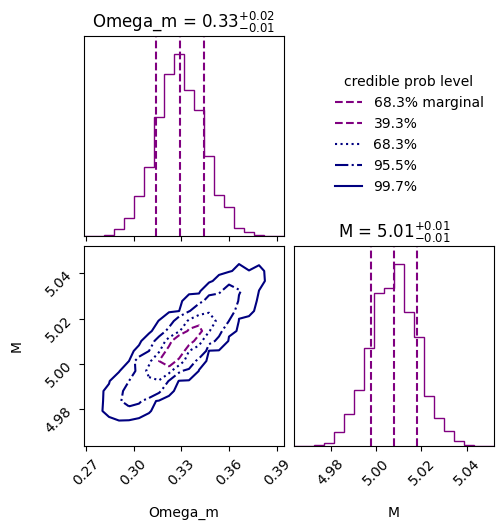

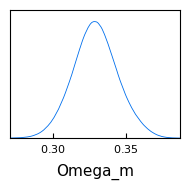

In [36]:
with open(f'{fit_dir}/Flat_LCDM_result.pkl', 'rb') as f:
    Flat_LCDM_result = pickle.load(f)
cornerplot(Flat_LCDM_result);
smooth_plot(Flat_LCDM_result)

#### Open LCDM

In [24]:
Open_LCDM_result = fit_cosmology("Open_LCDM")
with open(f'{fit_dir}/Open_LCDM_result.pkl', 'wb') as f:
    pickle.dump(Open_LCDM_result, f)

DEBUG:ultranest:ReactiveNestedSampler: dims=3+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(400.0)), (np.float64(inf), np.float64(400.0))]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-20883424858382908954473271968427580356877219669337542602930982234616276246927834150552883781512986624.00, Lmax=-893.03


DEBUG:ultranest:iteration=4, ncalls=405, regioncalls=200, ndraw=40, logz=-17834679434139015375877302671882421286964971809939651192645369551899625830590707650221263854518665216.00, remainder_fraction=100.0000%, Lmin=-16905851211323227557842538532041049901622390059004886011387590858083133252173667169975529322357719040.00, Lmax=-893.03


DEBUG:ultranest:iteration=8, ncalls=409, regioncalls=360, ndraw=40, logz=-13973819783539066345439486434658575587468609021511338184728062904816040310230169744191551452454322176.00, remainder_fraction=100.0000%, Lmin=-12737658252229455064885404579621340597935322991440758381294818807434669272735135724617324158653562880.00, Lmax=-893.03


DEBUG:ultranest:iteration=13, ncalls=414, regioncalls=560, ndraw=40, logz=-6918201841612258352259749369352328393140834350837854651618612782037609269192812973413167615547801600.00, remainder_fraction=100.0000%, Lmin=-6259806387481450397175489341084237517035245006979622960777892413976721573432991326796467801262391296.00, Lmax=-893.03
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=17, ncalls=418, regioncalls=720, ndraw=40, logz=-5631483678116964295047491507840923025785083148384135082634051333853495680250349572019617942843949056.00, remainder_fraction=100.0000%, Lmin=-3073027639818484155733970414935037921324674624236206812984371812444421711190887297004157955064463360.00, Lmax=-893.03


DEBUG:ultranest:iteration=22, ncalls=423, regioncalls=920, ndraw=40, logz=-1036762335120993533371445223796702621773041121346333107391042608786443524980264248362688755139608576.00, remainder_fraction=100.0000%, Lmin=-13704743.72, Lmax=-893.03


DEBUG:ultranest:iteration=27, ncalls=428, regioncalls=1120, ndraw=40, logz=-13554784.30, remainder_fraction=100.0000%, Lmin=-13528599.18, Lmax=-893.03


DEBUG:ultranest:iteration=31, ncalls=433, regioncalls=1320, ndraw=40, logz=-13112009.69, remainder_fraction=100.0000%, Lmin=-13051098.90, Lmax=-893.03


DEBUG:ultranest:iteration=36, ncalls=438, regioncalls=1520, ndraw=40, logz=-12765852.64, remainder_fraction=100.0000%, Lmin=-12719742.92, Lmax=-893.03


DEBUG:ultranest:iteration=40, ncalls=442, regioncalls=1680, ndraw=40, logz=-12547816.17, remainder_fraction=100.0000%, Lmin=-12511153.05, Lmax=-893.03


DEBUG:ultranest:iteration=45, ncalls=447, regioncalls=1880, ndraw=40, logz=-12070635.42, remainder_fraction=100.0000%, Lmin=-12050304.61, Lmax=-893.03


DEBUG:ultranest:iteration=50, ncalls=452, regioncalls=2080, ndraw=40, logz=-11877878.64, remainder_fraction=100.0000%, Lmin=-11797347.57, Lmax=-893.03


DEBUG:ultranest:iteration=55, ncalls=457, regioncalls=2280, ndraw=40, logz=-11665726.89, remainder_fraction=100.0000%, Lmin=-11639182.32, Lmax=-893.03


DEBUG:ultranest:iteration=60, ncalls=462, regioncalls=2480, ndraw=40, logz=-11361677.82, remainder_fraction=100.0000%, Lmin=-11356106.48, Lmax=-893.03


DEBUG:ultranest:iteration=65, ncalls=467, regioncalls=2680, ndraw=40, logz=-11221223.20, remainder_fraction=100.0000%, Lmin=-11187992.23, Lmax=-893.03


DEBUG:ultranest:iteration=69, ncalls=472, regioncalls=2880, ndraw=40, logz=-11008622.17, remainder_fraction=100.0000%, Lmin=-10988778.36, Lmax=-893.03


DEBUG:ultranest:iteration=74, ncalls=477, regioncalls=3080, ndraw=40, logz=-10541011.71, remainder_fraction=100.0000%, Lmin=-10431974.60, Lmax=-893.03


DEBUG:ultranest:iteration=79, ncalls=482, regioncalls=3280, ndraw=40, logz=-10101894.47, remainder_fraction=100.0000%, Lmin=-9992147.46, Lmax=-893.03


DEBUG:ultranest:iteration=80, ncalls=483, regioncalls=3320, ndraw=40, logz=-9992153.65, remainder_fraction=100.0000%, Lmin=-9906012.25, Lmax=-893.03


DEBUG:ultranest:iteration=83, ncalls=487, regioncalls=3480, ndraw=40, logz=-9834843.34, remainder_fraction=100.0000%, Lmin=-9758028.19, Lmax=-893.03


DEBUG:ultranest:iteration=88, ncalls=492, regioncalls=3680, ndraw=40, logz=-9686998.35, remainder_fraction=100.0000%, Lmin=-9685515.56, Lmax=-893.03


DEBUG:ultranest:iteration=90, ncalls=495, regioncalls=3800, ndraw=40, logz=-9662657.75, remainder_fraction=100.0000%, Lmin=-9654938.82, Lmax=-893.03


DEBUG:ultranest:iteration=94, ncalls=500, regioncalls=4000, ndraw=40, logz=-9385539.16, remainder_fraction=100.0000%, Lmin=-9376254.68, Lmax=-893.03


DEBUG:ultranest:iteration=99, ncalls=505, regioncalls=4200, ndraw=40, logz=-8863853.20, remainder_fraction=100.0000%, Lmin=-8516944.09, Lmax=-893.03
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=100, ncalls=509, regioncalls=4360, ndraw=40, logz=-8516950.33, remainder_fraction=100.0000%, Lmin=-8495189.45, Lmax=-893.03


DEBUG:ultranest:iteration=102, ncalls=513, regioncalls=4520, ndraw=40, logz=-8480116.19, remainder_fraction=100.0000%, Lmin=-8463759.41, Lmax=-893.03


DEBUG:ultranest:iteration=106, ncalls=518, regioncalls=4720, ndraw=40, logz=-8316840.77, remainder_fraction=100.0000%, Lmin=-8280807.35, Lmax=-893.03


DEBUG:ultranest:iteration=111, ncalls=523, regioncalls=4920, ndraw=40, logz=-8115118.88, remainder_fraction=100.0000%, Lmin=-8063341.79, Lmax=-893.03


DEBUG:ultranest:iteration=115, ncalls=529, regioncalls=5160, ndraw=40, logz=-7966221.30, remainder_fraction=100.0000%, Lmin=-7864688.74, Lmax=-893.03


DEBUG:ultranest:iteration=120, ncalls=534, regioncalls=5360, ndraw=40, logz=-7650036.41, remainder_fraction=100.0000%, Lmin=-7601539.27, Lmax=-893.03


DEBUG:ultranest:iteration=125, ncalls=539, regioncalls=5560, ndraw=40, logz=-7490703.53, remainder_fraction=100.0000%, Lmin=-7460875.02, Lmax=-893.03


DEBUG:ultranest:iteration=126, ncalls=541, regioncalls=5640, ndraw=40, logz=-7460881.32, remainder_fraction=100.0000%, Lmin=-7439136.86, Lmax=-893.03


DEBUG:ultranest:iteration=130, ncalls=547, regioncalls=5880, ndraw=40, logz=-7241436.90, remainder_fraction=100.0000%, Lmin=-7156161.89, Lmax=-893.03


DEBUG:ultranest:iteration=135, ncalls=556, regioncalls=6240, ndraw=40, logz=-7061226.92, remainder_fraction=100.0000%, Lmin=-6926304.30, Lmax=-893.03


DEBUG:ultranest:iteration=140, ncalls=561, regioncalls=6440, ndraw=40, logz=-6678999.17, remainder_fraction=100.0000%, Lmin=-6649858.54, Lmax=-893.03


DEBUG:ultranest:iteration=143, ncalls=566, regioncalls=6640, ndraw=40, logz=-6641634.32, remainder_fraction=100.0000%, Lmin=-6587437.16, Lmax=-893.03


DEBUG:ultranest:iteration=147, ncalls=572, regioncalls=6880, ndraw=40, logz=-6317933.42, remainder_fraction=100.0000%, Lmin=-6313858.67, Lmax=-893.03


DEBUG:ultranest:iteration=152, ncalls=577, regioncalls=7080, ndraw=40, logz=-6067999.22, remainder_fraction=100.0000%, Lmin=-6055682.18, Lmax=-893.03


DEBUG:ultranest:iteration=157, ncalls=582, regioncalls=7280, ndraw=40, logz=-5974240.13, remainder_fraction=100.0000%, Lmin=-5890431.63, Lmax=-893.03


DEBUG:ultranest:iteration=160, ncalls=585, regioncalls=7400, ndraw=40, logz=-5824530.21, remainder_fraction=100.0000%, Lmin=-5789873.94, Lmax=-893.03


DEBUG:ultranest:iteration=164, ncalls=590, regioncalls=7600, ndraw=40, logz=-5736073.87, remainder_fraction=100.0000%, Lmin=-5713374.66, Lmax=-893.03


DEBUG:ultranest:iteration=165, ncalls=592, regioncalls=7680, ndraw=40, logz=-5713381.07, remainder_fraction=100.0000%, Lmin=-5650947.69, Lmax=-893.03


DEBUG:ultranest:iteration=169, ncalls=598, regioncalls=7920, ndraw=40, logz=-5566984.79, remainder_fraction=100.0000%, Lmin=-5514683.30, Lmax=-893.03


DEBUG:ultranest:iteration=173, ncalls=603, regioncalls=8120, ndraw=40, logz=-5460546.76, remainder_fraction=100.0000%, Lmin=-5456022.46, Lmax=-893.03


DEBUG:ultranest:iteration=177, ncalls=608, regioncalls=8320, ndraw=40, logz=-5326591.88, remainder_fraction=100.0000%, Lmin=-5316500.84, Lmax=-893.03


DEBUG:ultranest:iteration=180, ncalls=612, regioncalls=8480, ndraw=40, logz=-5251942.00, remainder_fraction=100.0000%, Lmin=-5231402.55, Lmax=-893.03
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=183, ncalls=617, regioncalls=8680, ndraw=40, logz=-5216073.05, remainder_fraction=100.0000%, Lmin=-5209084.71, Lmax=-893.03


DEBUG:ultranest:iteration=187, ncalls=622, regioncalls=8880, ndraw=40, logz=-5096872.83, remainder_fraction=100.0000%, Lmin=-5044522.23, Lmax=-893.03


DEBUG:ultranest:iteration=192, ncalls=627, regioncalls=9080, ndraw=40, logz=-4940444.52, remainder_fraction=100.0000%, Lmin=-4894108.91, Lmax=-893.03


DEBUG:ultranest:iteration=196, ncalls=632, regioncalls=9280, ndraw=40, logz=-4744745.85, remainder_fraction=100.0000%, Lmin=-4728835.12, Lmax=-893.03


DEBUG:ultranest:iteration=200, ncalls=637, regioncalls=9480, ndraw=40, logz=-4709417.90, remainder_fraction=100.0000%, Lmin=-4690063.54, Lmax=-893.03


DEBUG:ultranest:iteration=205, ncalls=642, regioncalls=9680, ndraw=40, logz=-4588000.42, remainder_fraction=100.0000%, Lmin=-4573070.23, Lmax=-893.03


DEBUG:ultranest:iteration=208, ncalls=646, regioncalls=9840, ndraw=40, logz=-4465190.08, remainder_fraction=100.0000%, Lmin=-4419066.34, Lmax=-893.03


DEBUG:ultranest:iteration=212, ncalls=652, regioncalls=10080, ndraw=40, logz=-4330202.96, remainder_fraction=100.0000%, Lmin=-4320664.68, Lmax=-893.03


DEBUG:ultranest:iteration=214, ncalls=656, regioncalls=10240, ndraw=40, logz=-4291832.21, remainder_fraction=100.0000%, Lmin=-4289309.32, Lmax=-893.03


DEBUG:ultranest:iteration=217, ncalls=660, regioncalls=10400, ndraw=40, logz=-4265764.28, remainder_fraction=100.0000%, Lmin=-4254576.82, Lmax=-893.03


DEBUG:ultranest:iteration=220, ncalls=664, regioncalls=10560, ndraw=40, logz=-4206473.22, remainder_fraction=100.0000%, Lmin=-4135618.61, Lmax=-893.03


DEBUG:ultranest:iteration=224, ncalls=669, regioncalls=10760, ndraw=40, logz=-4071199.85, remainder_fraction=100.0000%, Lmin=-4035105.33, Lmax=-893.03


DEBUG:ultranest:iteration=228, ncalls=674, regioncalls=10960, ndraw=40, logz=-3944865.65, remainder_fraction=100.0000%, Lmin=-3932205.19, Lmax=-893.03


DEBUG:ultranest:iteration=232, ncalls=679, regioncalls=11160, ndraw=40, logz=-3855554.51, remainder_fraction=100.0000%, Lmin=-3801736.56, Lmax=-893.03


DEBUG:ultranest:iteration=237, ncalls=684, regioncalls=11360, ndraw=40, logz=-3732565.75, remainder_fraction=100.0000%, Lmin=-3732556.21, Lmax=-893.03


DEBUG:ultranest:iteration=240, ncalls=689, regioncalls=11560, ndraw=40, logz=-3608098.77, remainder_fraction=100.0000%, Lmin=-3598827.12, Lmax=-893.03


DEBUG:ultranest:iteration=245, ncalls=694, regioncalls=11760, ndraw=40, logz=-3542890.25, remainder_fraction=100.0000%, Lmin=-3535126.70, Lmax=-893.03


DEBUG:ultranest:iteration=250, ncalls=699, regioncalls=11960, ndraw=40, logz=-3482558.94, remainder_fraction=100.0000%, Lmin=-3472671.07, Lmax=-893.03


DEBUG:ultranest:iteration=251, ncalls=701, regioncalls=12040, ndraw=40, logz=-3472677.69, remainder_fraction=100.0000%, Lmin=-3435984.68, Lmax=-893.03


DEBUG:ultranest:iteration=256, ncalls=706, regioncalls=12240, ndraw=40, logz=-3313276.15, remainder_fraction=100.0000%, Lmin=-3294679.02, Lmax=-893.03


DEBUG:ultranest:iteration=260, ncalls=711, regioncalls=12440, ndraw=40, logz=-3213877.40, remainder_fraction=100.0000%, Lmin=-3132152.55, Lmax=-893.03


DEBUG:ultranest:iteration=265, ncalls=716, regioncalls=12640, ndraw=40, logz=-3008365.10, remainder_fraction=100.0000%, Lmin=-3002432.00, Lmax=-893.03


DEBUG:ultranest:iteration=270, ncalls=721, regioncalls=12840, ndraw=40, logz=-2952437.08, remainder_fraction=100.0000%, Lmin=-2936130.11, Lmax=-893.03


DEBUG:ultranest:iteration=274, ncalls=727, regioncalls=13080, ndraw=40, logz=-2845557.72, remainder_fraction=100.0000%, Lmin=-2828438.86, Lmax=-893.03


DEBUG:ultranest:iteration=278, ncalls=735, regioncalls=13400, ndraw=40, logz=-2791281.24, remainder_fraction=100.0000%, Lmin=-2790403.90, Lmax=-893.03


DEBUG:ultranest:iteration=280, ncalls=738, regioncalls=13520, ndraw=40, logz=-2789163.95, remainder_fraction=100.0000%, Lmin=-2748461.38, Lmax=-893.03
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=281, ncalls=743, regioncalls=13720, ndraw=40, logz=-2748468.07, remainder_fraction=100.0000%, Lmin=-2724140.10, Lmax=-893.03


DEBUG:ultranest:iteration=284, ncalls=749, regioncalls=13960, ndraw=40, logz=-2720697.40, remainder_fraction=100.0000%, Lmin=-2687398.98, Lmax=-893.03


DEBUG:ultranest:iteration=287, ncalls=753, regioncalls=14120, ndraw=40, logz=-2679081.06, remainder_fraction=100.0000%, Lmin=-2640118.48, Lmax=-893.03


DEBUG:ultranest:iteration=289, ncalls=758, regioncalls=14320, ndraw=40, logz=-2617913.36, remainder_fraction=100.0000%, Lmin=-2610832.91, Lmax=-893.03


DEBUG:ultranest:iteration=294, ncalls=763, regioncalls=14520, ndraw=40, logz=-2522292.43, remainder_fraction=100.0000%, Lmin=-2500970.96, Lmax=-893.03


DEBUG:ultranest:iteration=298, ncalls=768, regioncalls=14720, ndraw=40, logz=-2478028.22, remainder_fraction=100.0000%, Lmin=-2464941.88, Lmax=-893.03


DEBUG:ultranest:iteration=303, ncalls=774, regioncalls=14960, ndraw=40, logz=-2422759.95, remainder_fraction=100.0000%, Lmin=-2346049.56, Lmax=-893.03


DEBUG:ultranest:iteration=308, ncalls=779, regioncalls=15160, ndraw=40, logz=-2288118.07, remainder_fraction=100.0000%, Lmin=-2285738.67, Lmax=-893.03


DEBUG:ultranest:iteration=311, ncalls=784, regioncalls=15360, ndraw=40, logz=-2260932.45, remainder_fraction=100.0000%, Lmin=-2233286.22, Lmax=-893.03


DEBUG:ultranest:iteration=316, ncalls=789, regioncalls=15560, ndraw=40, logz=-2133570.34, remainder_fraction=100.0000%, Lmin=-2126765.19, Lmax=-893.03


DEBUG:ultranest:iteration=320, ncalls=794, regioncalls=15760, ndraw=40, logz=-2079059.16, remainder_fraction=100.0000%, Lmin=-2007247.45, Lmax=-893.03


DEBUG:ultranest:iteration=324, ncalls=799, regioncalls=15960, ndraw=40, logz=-1937646.96, remainder_fraction=100.0000%, Lmin=-1917886.57, Lmax=-893.03


DEBUG:ultranest:iteration=328, ncalls=804, regioncalls=16160, ndraw=40, logz=-1882662.12, remainder_fraction=100.0000%, Lmin=-1853924.86, Lmax=-893.03


DEBUG:ultranest:iteration=333, ncalls=810, regioncalls=16400, ndraw=40, logz=-1794284.96, remainder_fraction=100.0000%, Lmin=-1778766.32, Lmax=-893.03


DEBUG:ultranest:iteration=338, ncalls=815, regioncalls=16600, ndraw=40, logz=-1716104.87, remainder_fraction=100.0000%, Lmin=-1706637.35, Lmax=-893.03


DEBUG:ultranest:iteration=343, ncalls=821, regioncalls=16840, ndraw=40, logz=-1658773.48, remainder_fraction=100.0000%, Lmin=-1655156.19, Lmax=-893.03


DEBUG:ultranest:iteration=348, ncalls=826, regioncalls=17040, ndraw=40, logz=-1520595.65, remainder_fraction=100.0000%, Lmin=-1520003.04, Lmax=-893.03


DEBUG:ultranest:iteration=350, ncalls=829, regioncalls=17160, ndraw=40, logz=-1509926.71, remainder_fraction=100.0000%, Lmin=-1508324.45, Lmax=-893.03


DEBUG:ultranest:iteration=354, ncalls=835, regioncalls=17400, ndraw=40, logz=-1450901.78, remainder_fraction=100.0000%, Lmin=-1437457.86, Lmax=-893.03


DEBUG:ultranest:iteration=358, ncalls=840, regioncalls=17600, ndraw=40, logz=-1408031.45, remainder_fraction=100.0000%, Lmin=-1403629.88, Lmax=-893.03


DEBUG:ultranest:iteration=360, ncalls=842, regioncalls=17680, ndraw=40, logz=-1396030.16, remainder_fraction=100.0000%, Lmin=-1366382.10, Lmax=-893.03
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=361, ncalls=844, regioncalls=17760, ndraw=40, logz=-1366389.00, remainder_fraction=100.0000%, Lmin=-1356104.01, Lmax=-893.03


DEBUG:ultranest:iteration=366, ncalls=853, regioncalls=18120, ndraw=40, logz=-1285138.14, remainder_fraction=100.0000%, Lmin=-1283465.01, Lmax=-893.03


DEBUG:ultranest:iteration=371, ncalls=858, regioncalls=18320, ndraw=40, logz=-1221511.86, remainder_fraction=100.0000%, Lmin=-1210258.48, Lmax=-893.03


DEBUG:ultranest:iteration=374, ncalls=863, regioncalls=18520, ndraw=40, logz=-1210070.87, remainder_fraction=100.0000%, Lmin=-1196020.34, Lmax=-893.03


DEBUG:ultranest:iteration=376, ncalls=868, regioncalls=18720, ndraw=40, logz=-1183510.89, remainder_fraction=100.0000%, Lmin=-1166072.37, Lmax=-893.03


DEBUG:ultranest:iteration=380, ncalls=873, regioncalls=18920, ndraw=40, logz=-1142536.80, remainder_fraction=100.0000%, Lmin=-1134638.84, Lmax=-893.03


DEBUG:ultranest:iteration=383, ncalls=878, regioncalls=19120, ndraw=40, logz=-1125889.96, remainder_fraction=100.0000%, Lmin=-1077939.98, Lmax=-893.03


DEBUG:ultranest:iteration=387, ncalls=883, regioncalls=19320, ndraw=40, logz=-1007711.35, remainder_fraction=100.0000%, Lmin=-1004063.79, Lmax=-893.03


DEBUG:ultranest:iteration=391, ncalls=889, regioncalls=19560, ndraw=40, logz=-963607.45, remainder_fraction=100.0000%, Lmin=-961885.00, Lmax=-893.03


DEBUG:ultranest:iteration=393, ncalls=894, regioncalls=19760, ndraw=40, logz=-961693.86, remainder_fraction=100.0000%, Lmin=-951059.54, Lmax=-893.03


DEBUG:ultranest:iteration=398, ncalls=901, regioncalls=20040, ndraw=40, logz=-921485.24, remainder_fraction=100.0000%, Lmin=-906377.49, Lmax=-893.03


DEBUG:ultranest:iteration=400, ncalls=905, regioncalls=20200, ndraw=40, logz=-886610.51, remainder_fraction=100.0000%, Lmin=-886129.94, Lmax=-893.03


DEBUG:ultranest:iteration=402, ncalls=912, regioncalls=20480, ndraw=40, logz=-877658.54, remainder_fraction=100.0000%, Lmin=-865587.74, Lmax=-893.03


DEBUG:ultranest:iteration=407, ncalls=917, regioncalls=20680, ndraw=40, logz=-850645.54, remainder_fraction=100.0000%, Lmin=-845165.73, Lmax=-893.03


DEBUG:ultranest:iteration=410, ncalls=922, regioncalls=20880, ndraw=40, logz=-834510.83, remainder_fraction=100.0000%, Lmin=-805512.91, Lmax=-893.03


DEBUG:ultranest:iteration=415, ncalls=927, regioncalls=21080, ndraw=40, logz=-779424.43, remainder_fraction=100.0000%, Lmin=-761823.92, Lmax=-893.03


DEBUG:ultranest:iteration=419, ncalls=933, regioncalls=21320, ndraw=40, logz=-736739.43, remainder_fraction=100.0000%, Lmin=-736470.91, Lmax=-893.03


DEBUG:ultranest:iteration=423, ncalls=938, regioncalls=21520, ndraw=40, logz=-730498.80, remainder_fraction=100.0000%, Lmin=-718251.27, Lmax=-893.03


DEBUG:ultranest:iteration=427, ncalls=943, regioncalls=21720, ndraw=40, logz=-694622.89, remainder_fraction=100.0000%, Lmin=-693505.79, Lmax=-893.03


DEBUG:ultranest:iteration=430, ncalls=949, regioncalls=21960, ndraw=40, logz=-689806.45, remainder_fraction=100.0000%, Lmin=-667920.62, Lmax=-893.03


DEBUG:ultranest:iteration=434, ncalls=958, regioncalls=22320, ndraw=40, logz=-657599.36, remainder_fraction=100.0000%, Lmin=-645553.77, Lmax=-893.03


DEBUG:ultranest:iteration=438, ncalls=963, regioncalls=22520, ndraw=40, logz=-629723.79, remainder_fraction=100.0000%, Lmin=-626091.94, Lmax=-893.03


DEBUG:ultranest:iteration=440, ncalls=966, regioncalls=22640, ndraw=40, logz=-622387.92, remainder_fraction=100.0000%, Lmin=-621933.91, Lmax=-893.03


DEBUG:ultranest:iteration=441, ncalls=972, regioncalls=22880, ndraw=40, logz=-621941.01, remainder_fraction=100.0000%, Lmin=-604928.63, Lmax=-893.03


DEBUG:ultranest:iteration=443, ncalls=977, regioncalls=23080, ndraw=40, logz=-603620.95, remainder_fraction=100.0000%, Lmin=-599642.27, Lmax=-893.03


DEBUG:ultranest:iteration=444, ncalls=982, regioncalls=23280, ndraw=40, logz=-599649.37, remainder_fraction=100.0000%, Lmin=-591304.74, Lmax=-893.03


DEBUG:ultranest:iteration=449, ncalls=987, regioncalls=23480, ndraw=40, logz=-585863.80, remainder_fraction=100.0000%, Lmin=-568076.30, Lmax=-893.03


DEBUG:ultranest:iteration=450, ncalls=988, regioncalls=23520, ndraw=40, logz=-568083.42, remainder_fraction=100.0000%, Lmin=-563193.25, Lmax=-893.03
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=453, ncalls=993, regioncalls=23720, ndraw=40, logz=-560468.72, remainder_fraction=100.0000%, Lmin=-556467.48, Lmax=-893.03


DEBUG:ultranest:iteration=457, ncalls=998, regioncalls=23920, ndraw=40, logz=-543788.34, remainder_fraction=100.0000%, Lmin=-542026.97, Lmax=-893.03


DEBUG:ultranest:iteration=461, ncalls=1003, regioncalls=24120, ndraw=40, logz=-540132.95, remainder_fraction=100.0000%, Lmin=-540106.27, Lmax=-893.03


DEBUG:ultranest:iteration=465, ncalls=1008, regioncalls=24320, ndraw=40, logz=-515997.31, remainder_fraction=100.0000%, Lmin=-511601.17, Lmax=-893.03


DEBUG:ultranest:iteration=469, ncalls=1013, regioncalls=24520, ndraw=40, logz=-506904.16, remainder_fraction=100.0000%, Lmin=-506226.83, Lmax=-893.03


DEBUG:ultranest:iteration=473, ncalls=1019, regioncalls=24760, ndraw=40, logz=-500917.01, remainder_fraction=100.0000%, Lmin=-500037.86, Lmax=-893.03


DEBUG:ultranest:iteration=476, ncalls=1025, regioncalls=25000, ndraw=40, logz=-496785.88, remainder_fraction=100.0000%, Lmin=-496769.01, Lmax=-893.03


DEBUG:ultranest:iteration=480, ncalls=1030, regioncalls=25200, ndraw=40, logz=-473291.65, remainder_fraction=100.0000%, Lmin=-470936.72, Lmax=-893.03


DEBUG:ultranest:iteration=485, ncalls=1036, regioncalls=25440, ndraw=40, logz=-464775.26, remainder_fraction=100.0000%, Lmin=-463187.19, Lmax=-893.03


DEBUG:ultranest:iteration=487, ncalls=1040, regioncalls=25600, ndraw=40, logz=-463134.66, remainder_fraction=100.0000%, Lmin=-461714.73, Lmax=-893.03


DEBUG:ultranest:iteration=488, ncalls=1046, regioncalls=25840, ndraw=40, logz=-461721.94, remainder_fraction=100.0000%, Lmin=-461534.84, Lmax=-893.03


DEBUG:ultranest:iteration=493, ncalls=1051, regioncalls=26040, ndraw=40, logz=-451641.23, remainder_fraction=100.0000%, Lmin=-447528.97, Lmax=-893.03


DEBUG:ultranest:iteration=497, ncalls=1056, regioncalls=26240, ndraw=40, logz=-436465.07, remainder_fraction=100.0000%, Lmin=-433543.11, Lmax=-893.03


DEBUG:ultranest:iteration=501, ncalls=1062, regioncalls=26480, ndraw=40, logz=-433009.02, remainder_fraction=100.0000%, Lmin=-430352.71, Lmax=-893.03


DEBUG:ultranest:iteration=506, ncalls=1067, regioncalls=26680, ndraw=40, logz=-427316.72, remainder_fraction=100.0000%, Lmin=-415342.42, Lmax=-893.03


DEBUG:ultranest:iteration=510, ncalls=1072, regioncalls=26880, ndraw=40, logz=-410430.77, remainder_fraction=100.0000%, Lmin=-409687.76, Lmax=-893.03


DEBUG:ultranest:iteration=511, ncalls=1074, regioncalls=26960, ndraw=40, logz=-409695.03, remainder_fraction=100.0000%, Lmin=-408399.20, Lmax=-893.03


DEBUG:ultranest:iteration=514, ncalls=1080, regioncalls=27200, ndraw=40, logz=-401217.48, remainder_fraction=100.0000%, Lmin=-398310.04, Lmax=-893.03


DEBUG:ultranest:iteration=518, ncalls=1086, regioncalls=27440, ndraw=40, logz=-390147.78, remainder_fraction=100.0000%, Lmin=-389503.41, Lmax=-893.03


DEBUG:ultranest:iteration=519, ncalls=1088, regioncalls=27520, ndraw=40, logz=-389510.70, remainder_fraction=100.0000%, Lmin=-388406.11, Lmax=-893.03


DEBUG:ultranest:iteration=520, ncalls=1089, regioncalls=27560, ndraw=40, logz=-388413.40, remainder_fraction=100.0000%, Lmin=-387214.23, Lmax=-893.03


DEBUG:ultranest:iteration=525, ncalls=1096, regioncalls=27840, ndraw=40, logz=-381448.35, remainder_fraction=100.0000%, Lmin=-380143.64, Lmax=-893.03


DEBUG:ultranest:iteration=527, ncalls=1099, regioncalls=27960, ndraw=40, logz=-379182.88, remainder_fraction=100.0000%, Lmin=-376840.16, Lmax=-893.03


DEBUG:ultranest:iteration=528, ncalls=1101, regioncalls=28040, ndraw=40, logz=-376847.47, remainder_fraction=100.0000%, Lmin=-374940.12, Lmax=-893.03


DEBUG:ultranest:iteration=529, ncalls=1106, regioncalls=28240, ndraw=40, logz=-374947.43, remainder_fraction=100.0000%, Lmin=-370755.38, Lmax=-893.03


DEBUG:ultranest:iteration=532, ncalls=1111, regioncalls=28440, ndraw=40, logz=-367577.14, remainder_fraction=100.0000%, Lmin=-367370.94, Lmax=-893.03


DEBUG:ultranest:iteration=536, ncalls=1116, regioncalls=28640, ndraw=40, logz=-364837.03, remainder_fraction=100.0000%, Lmin=-364410.36, Lmax=-893.03


DEBUG:ultranest:iteration=538, ncalls=1121, regioncalls=28840, ndraw=40, logz=-362579.61, remainder_fraction=100.0000%, Lmin=-360935.05, Lmax=-893.03


DEBUG:ultranest:iteration=540, ncalls=1124, regioncalls=28960, ndraw=40, logz=-358545.13, remainder_fraction=100.0000%, Lmin=-358222.70, Lmax=-893.03


DEBUG:ultranest:iteration=543, ncalls=1129, regioncalls=29160, ndraw=40, logz=-348641.10, remainder_fraction=100.0000%, Lmin=-348472.22, Lmax=-893.03


DEBUG:ultranest:iteration=548, ncalls=1134, regioncalls=29360, ndraw=40, logz=-341720.20, remainder_fraction=100.0000%, Lmin=-339053.05, Lmax=-893.03


/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)
DEBUG:ultranest:iteration=552, ncalls=1140, regioncalls=29600, ndraw=40, logz=-331707.41, remainder_fraction=100.0000%, Lmin=-331028.38, Lmax=-893.03


DEBUG:ultranest:iteration=557, ncalls=1145, regioncalls=29800, ndraw=40, logz=-323541.92, remainder_fraction=100.0000%, Lmin=-320262.83, Lmax=-893.03


DEBUG:ultranest:iteration=560, ncalls=1148, regioncalls=29920, ndraw=40, logz=-312573.56, remainder_fraction=100.0000%, Lmin=-311705.17, Lmax=-893.03


DEBUG:ultranest:iteration=564, ncalls=1154, regioncalls=30160, ndraw=40, logz=-303261.13, remainder_fraction=100.0000%, Lmin=-301249.22, Lmax=-893.03


DEBUG:ultranest:iteration=567, ncalls=1160, regioncalls=30400, ndraw=40, logz=-298166.07, remainder_fraction=100.0000%, Lmin=-297000.48, Lmax=-893.03


DEBUG:ultranest:iteration=571, ncalls=1166, regioncalls=30640, ndraw=40, logz=-286402.92, remainder_fraction=100.0000%, Lmin=-284331.06, Lmax=-893.03


DEBUG:ultranest:iteration=573, ncalls=1171, regioncalls=30840, ndraw=40, logz=-284250.08, remainder_fraction=100.0000%, Lmin=-283335.10, Lmax=-893.03


DEBUG:ultranest:iteration=576, ncalls=1176, regioncalls=31040, ndraw=40, logz=-277852.49, remainder_fraction=100.0000%, Lmin=-273744.93, Lmax=-893.03


DEBUG:ultranest:iteration=580, ncalls=1182, regioncalls=31280, ndraw=40, logz=-270287.25, remainder_fraction=100.0000%, Lmin=-269208.86, Lmax=-893.03


DEBUG:ultranest:iteration=584, ncalls=1188, regioncalls=31520, ndraw=40, logz=-258685.01, remainder_fraction=100.0000%, Lmin=-258106.06, Lmax=-893.03


DEBUG:ultranest:iteration=588, ncalls=1193, regioncalls=31720, ndraw=40, logz=-250872.50, remainder_fraction=100.0000%, Lmin=-250346.62, Lmax=-893.03


DEBUG:ultranest:iteration=591, ncalls=1198, regioncalls=31920, ndraw=40, logz=-249890.65, remainder_fraction=100.0000%, Lmin=-249792.49, Lmax=-893.03


DEBUG:ultranest:iteration=592, ncalls=1203, regioncalls=32120, ndraw=40, logz=-249799.96, remainder_fraction=100.0000%, Lmin=-248894.98, Lmax=-893.03


DEBUG:ultranest:iteration=597, ncalls=1212, regioncalls=32480, ndraw=40, logz=-243006.70, remainder_fraction=100.0000%, Lmin=-238836.27, Lmax=-893.03


DEBUG:ultranest:iteration=599, ncalls=1217, regioncalls=32680, ndraw=40, logz=-238797.24, remainder_fraction=100.0000%, Lmin=-238328.83, Lmax=-893.03


DEBUG:ultranest:iteration=600, ncalls=1219, regioncalls=32760, ndraw=40, logz=-238336.32, remainder_fraction=100.0000%, Lmin=-235182.84, Lmax=-893.03


DEBUG:ultranest:iteration=603, ncalls=1225, regioncalls=33000, ndraw=40, logz=-232799.74, remainder_fraction=100.0000%, Lmin=-232214.81, Lmax=-893.03


DEBUG:ultranest:iteration=607, ncalls=1230, regioncalls=33200, ndraw=40, logz=-231339.48, remainder_fraction=100.0000%, Lmin=-227756.79, Lmax=-893.03


DEBUG:ultranest:iteration=609, ncalls=1235, regioncalls=33400, ndraw=40, logz=-225644.16, remainder_fraction=100.0000%, Lmin=-225481.12, Lmax=-824.42


DEBUG:ultranest:iteration=612, ncalls=1241, regioncalls=33640, ndraw=40, logz=-221629.65, remainder_fraction=100.0000%, Lmin=-219924.53, Lmax=-824.42


DEBUG:ultranest:iteration=615, ncalls=1247, regioncalls=33880, ndraw=40, logz=-218929.25, remainder_fraction=100.0000%, Lmin=-217712.05, Lmax=-824.42


DEBUG:ultranest:iteration=620, ncalls=1252, regioncalls=34080, ndraw=40, logz=-215434.00, remainder_fraction=100.0000%, Lmin=-214426.56, Lmax=-824.42


DEBUG:ultranest:iteration=624, ncalls=1257, regioncalls=34280, ndraw=40, logz=-212807.66, remainder_fraction=100.0000%, Lmin=-210374.22, Lmax=-824.42


DEBUG:ultranest:iteration=627, ncalls=1262, regioncalls=34480, ndraw=40, logz=-208169.09, remainder_fraction=100.0000%, Lmin=-207357.69, Lmax=-824.42
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=630, ncalls=1268, regioncalls=34720, ndraw=40, logz=-204335.08, remainder_fraction=100.0000%, Lmin=-202452.81, Lmax=-824.42


DEBUG:ultranest:iteration=634, ncalls=1276, regioncalls=35040, ndraw=40, logz=-198269.92, remainder_fraction=100.0000%, Lmin=-198196.39, Lmax=-824.42


DEBUG:ultranest:iteration=639, ncalls=1282, regioncalls=35280, ndraw=40, logz=-193648.16, remainder_fraction=100.0000%, Lmin=-193244.01, Lmax=-824.42


DEBUG:ultranest:iteration=640, ncalls=1283, regioncalls=35320, ndraw=40, logz=-193251.60, remainder_fraction=100.0000%, Lmin=-192387.77, Lmax=-824.42


DEBUG:ultranest:iteration=643, ncalls=1288, regioncalls=35520, ndraw=40, logz=-189734.83, remainder_fraction=100.0000%, Lmin=-189083.95, Lmax=-824.42


DEBUG:ultranest:iteration=647, ncalls=1295, regioncalls=35800, ndraw=40, logz=-187446.36, remainder_fraction=100.0000%, Lmin=-186245.67, Lmax=-824.42


DEBUG:ultranest:iteration=650, ncalls=1300, regioncalls=36000, ndraw=40, logz=-183776.62, remainder_fraction=100.0000%, Lmin=-180968.79, Lmax=-824.42


DEBUG:ultranest:iteration=653, ncalls=1305, regioncalls=36200, ndraw=40, logz=-179062.69, remainder_fraction=100.0000%, Lmin=-177372.26, Lmax=-824.42


DEBUG:ultranest:iteration=655, ncalls=1311, regioncalls=36440, ndraw=40, logz=-176820.48, remainder_fraction=100.0000%, Lmin=-176205.26, Lmax=-824.42


DEBUG:ultranest:iteration=657, ncalls=1316, regioncalls=36640, ndraw=40, logz=-175642.31, remainder_fraction=100.0000%, Lmin=-174703.97, Lmax=-824.42


DEBUG:ultranest:iteration=658, ncalls=1319, regioncalls=36760, ndraw=40, logz=-174711.61, remainder_fraction=100.0000%, Lmin=-174419.27, Lmax=-824.42


DEBUG:ultranest:iteration=661, ncalls=1326, regioncalls=37040, ndraw=40, logz=-172144.85, remainder_fraction=100.0000%, Lmin=-171572.88, Lmax=-824.42


DEBUG:ultranest:iteration=663, ncalls=1331, regioncalls=37240, ndraw=40, logz=-167508.25, remainder_fraction=100.0000%, Lmin=-166009.41, Lmax=-824.42


DEBUG:ultranest:iteration=664, ncalls=1338, regioncalls=37520, ndraw=40, logz=-166017.06, remainder_fraction=100.0000%, Lmin=-165262.61, Lmax=-824.42


DEBUG:ultranest:iteration=665, ncalls=1344, regioncalls=37760, ndraw=40, logz=-165270.26, remainder_fraction=100.0000%, Lmin=-165167.44, Lmax=-824.42


DEBUG:ultranest:iteration=668, ncalls=1350, regioncalls=38000, ndraw=40, logz=-163884.63, remainder_fraction=100.0000%, Lmin=-163041.03, Lmax=-824.42


DEBUG:ultranest:iteration=672, ncalls=1356, regioncalls=38240, ndraw=40, logz=-161451.55, remainder_fraction=100.0000%, Lmin=-161259.46, Lmax=-824.42


DEBUG:ultranest:iteration=676, ncalls=1361, regioncalls=38440, ndraw=40, logz=-158995.95, remainder_fraction=100.0000%, Lmin=-158127.85, Lmax=-824.42


DEBUG:ultranest:iteration=678, ncalls=1369, regioncalls=38760, ndraw=40, logz=-158023.83, remainder_fraction=100.0000%, Lmin=-156840.82, Lmax=-824.42


DEBUG:ultranest:iteration=680, ncalls=1375, regioncalls=39000, ndraw=40, logz=-156241.15, remainder_fraction=100.0000%, Lmin=-155783.73, Lmax=-824.42


DEBUG:ultranest:iteration=683, ncalls=1380, regioncalls=39200, ndraw=40, logz=-155030.59, remainder_fraction=100.0000%, Lmin=-153969.34, Lmax=-824.42


DEBUG:ultranest:iteration=687, ncalls=1388, regioncalls=39520, ndraw=40, logz=-148862.56, remainder_fraction=100.0000%, Lmin=-147874.02, Lmax=-824.42


DEBUG:ultranest:iteration=690, ncalls=1393, regioncalls=39720, ndraw=40, logz=-145919.19, remainder_fraction=100.0000%, Lmin=-145064.00, Lmax=-824.42


DEBUG:ultranest:iteration=692, ncalls=1403, regioncalls=40120, ndraw=40, logz=-144313.63, remainder_fraction=100.0000%, Lmin=-143959.35, Lmax=-824.42


DEBUG:ultranest:iteration=696, ncalls=1408, regioncalls=40320, ndraw=40, logz=-140734.94, remainder_fraction=100.0000%, Lmin=-139508.67, Lmax=-824.42


DEBUG:ultranest:iteration=699, ncalls=1415, regioncalls=40600, ndraw=40, logz=-137927.14, remainder_fraction=100.0000%, Lmin=-136467.97, Lmax=-824.42


DEBUG:ultranest:iteration=704, ncalls=1421, regioncalls=40840, ndraw=40, logz=-132719.35, remainder_fraction=100.0000%, Lmin=-132650.14, Lmax=-824.42


DEBUG:ultranest:iteration=706, ncalls=1426, regioncalls=41040, ndraw=40, logz=-132625.92, remainder_fraction=100.0000%, Lmin=-131706.40, Lmax=-824.42


DEBUG:ultranest:iteration=709, ncalls=1433, regioncalls=41320, ndraw=40, logz=-130155.55, remainder_fraction=100.0000%, Lmin=-128386.53, Lmax=-824.42


DEBUG:ultranest:iteration=712, ncalls=1448, regioncalls=41920, ndraw=40, logz=-128172.96, remainder_fraction=100.0000%, Lmin=-128081.44, Lmax=-824.42


DEBUG:ultranest:iteration=714, ncalls=1455, regioncalls=42200, ndraw=40, logz=-125237.46, remainder_fraction=100.0000%, Lmin=-124077.65, Lmax=-824.42


DEBUG:ultranest:iteration=718, ncalls=1460, regioncalls=42400, ndraw=40, logz=-123865.10, remainder_fraction=100.0000%, Lmin=-123566.52, Lmax=-824.42


DEBUG:ultranest:iteration=720, ncalls=1465, regioncalls=42600, ndraw=40, logz=-122568.80, remainder_fraction=100.0000%, Lmin=-122445.08, Lmax=-824.42


DEBUG:ultranest:iteration=725, ncalls=1470, regioncalls=42800, ndraw=40, logz=-117585.25, remainder_fraction=100.0000%, Lmin=-117543.44, Lmax=-824.42


DEBUG:ultranest:iteration=728, ncalls=1475, regioncalls=43000, ndraw=40, logz=-115379.30, remainder_fraction=100.0000%, Lmin=-114090.41, Lmax=-824.42


DEBUG:ultranest:iteration=732, ncalls=1480, regioncalls=43200, ndraw=40, logz=-113055.42, remainder_fraction=100.0000%, Lmin=-112957.72, Lmax=-824.42


DEBUG:ultranest:iteration=736, ncalls=1485, regioncalls=43400, ndraw=40, logz=-111207.97, remainder_fraction=100.0000%, Lmin=-111023.19, Lmax=-824.42


DEBUG:ultranest:iteration=739, ncalls=1490, regioncalls=43600, ndraw=40, logz=-109779.49, remainder_fraction=100.0000%, Lmin=-109432.16, Lmax=-824.42


DEBUG:ultranest:iteration=743, ncalls=1496, regioncalls=43840, ndraw=40, logz=-107140.08, remainder_fraction=100.0000%, Lmin=-105807.57, Lmax=-824.42


DEBUG:ultranest:iteration=747, ncalls=1503, regioncalls=44120, ndraw=40, logz=-105159.13, remainder_fraction=100.0000%, Lmin=-104866.14, Lmax=-824.42
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=750, ncalls=1507, regioncalls=44280, ndraw=40, logz=-103359.81, remainder_fraction=100.0000%, Lmin=-102853.17, Lmax=-824.42


DEBUG:ultranest:iteration=752, ncalls=1512, regioncalls=44480, ndraw=40, logz=-102482.34, remainder_fraction=100.0000%, Lmin=-101345.81, Lmax=-824.42


DEBUG:ultranest:iteration=757, ncalls=1517, regioncalls=44680, ndraw=40, logz=-99062.11, remainder_fraction=100.0000%, Lmin=-98908.03, Lmax=-824.42


DEBUG:ultranest:iteration=758, ncalls=1520, regioncalls=44800, ndraw=40, logz=-98915.91, remainder_fraction=100.0000%, Lmin=-98458.08, Lmax=-824.42


DEBUG:ultranest:iteration=760, ncalls=1523, regioncalls=44920, ndraw=40, logz=-98430.23, remainder_fraction=100.0000%, Lmin=-98112.39, Lmax=-824.42


DEBUG:ultranest:iteration=763, ncalls=1527, regioncalls=45080, ndraw=40, logz=-96678.68, remainder_fraction=100.0000%, Lmin=-96323.79, Lmax=-824.42


DEBUG:ultranest:iteration=767, ncalls=1533, regioncalls=45320, ndraw=40, logz=-94108.79, remainder_fraction=100.0000%, Lmin=-93917.14, Lmax=-824.42


DEBUG:ultranest:iteration=771, ncalls=1540, regioncalls=45600, ndraw=40, logz=-92779.90, remainder_fraction=100.0000%, Lmin=-92496.21, Lmax=-824.42


DEBUG:ultranest:iteration=775, ncalls=1545, regioncalls=45800, ndraw=40, logz=-90632.59, remainder_fraction=100.0000%, Lmin=-90086.48, Lmax=-824.42


DEBUG:ultranest:iteration=778, ncalls=1551, regioncalls=46040, ndraw=40, logz=-89379.75, remainder_fraction=100.0000%, Lmin=-89275.35, Lmax=-824.42


DEBUG:ultranest:iteration=783, ncalls=1556, regioncalls=46240, ndraw=40, logz=-88614.49, remainder_fraction=100.0000%, Lmin=-88433.24, Lmax=-824.42


DEBUG:ultranest:iteration=785, ncalls=1561, regioncalls=46440, ndraw=40, logz=-88204.42, remainder_fraction=100.0000%, Lmin=-87406.07, Lmax=-824.42


DEBUG:ultranest:iteration=789, ncalls=1568, regioncalls=46720, ndraw=40, logz=-86385.18, remainder_fraction=100.0000%, Lmin=-86370.23, Lmax=-824.42


DEBUG:ultranest:iteration=792, ncalls=1573, regioncalls=46920, ndraw=40, logz=-85759.87, remainder_fraction=100.0000%, Lmin=-85586.80, Lmax=-824.42


DEBUG:ultranest:iteration=796, ncalls=1579, regioncalls=47160, ndraw=40, logz=-83380.29, remainder_fraction=100.0000%, Lmin=-83276.35, Lmax=-824.42


DEBUG:ultranest:iteration=798, ncalls=1585, regioncalls=47400, ndraw=40, logz=-83201.65, remainder_fraction=100.0000%, Lmin=-82160.62, Lmax=-824.42


DEBUG:ultranest:iteration=800, ncalls=1587, regioncalls=47480, ndraw=40, logz=-81253.64, remainder_fraction=100.0000%, Lmin=-80313.29, Lmax=-824.42


DEBUG:ultranest:iteration=804, ncalls=1595, regioncalls=47800, ndraw=40, logz=-79471.91, remainder_fraction=100.0000%, Lmin=-78996.30, Lmax=-824.42


DEBUG:ultranest:iteration=808, ncalls=1601, regioncalls=48040, ndraw=40, logz=-77304.21, remainder_fraction=100.0000%, Lmin=-76485.89, Lmax=-824.42


DEBUG:ultranest:iteration=812, ncalls=1608, regioncalls=48320, ndraw=40, logz=-75492.47, remainder_fraction=100.0000%, Lmin=-74386.33, Lmax=-824.42
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=815, ncalls=1613, regioncalls=48520, ndraw=40, logz=-74288.91, remainder_fraction=100.0000%, Lmin=-74215.50, Lmax=-824.42


DEBUG:ultranest:iteration=819, ncalls=1618, regioncalls=48720, ndraw=40, logz=-73433.62, remainder_fraction=100.0000%, Lmin=-73229.06, Lmax=-824.42


DEBUG:ultranest:iteration=822, ncalls=1622, regioncalls=48880, ndraw=40, logz=-72918.20, remainder_fraction=100.0000%, Lmin=-72367.50, Lmax=-824.42


DEBUG:ultranest:iteration=825, ncalls=1627, regioncalls=49080, ndraw=40, logz=-72307.24, remainder_fraction=100.0000%, Lmin=-71507.56, Lmax=-824.42


DEBUG:ultranest:iteration=828, ncalls=1632, regioncalls=49280, ndraw=40, logz=-70800.19, remainder_fraction=100.0000%, Lmin=-70627.72, Lmax=-824.42


DEBUG:ultranest:iteration=832, ncalls=1637, regioncalls=49480, ndraw=40, logz=-68028.21, remainder_fraction=100.0000%, Lmin=-67947.06, Lmax=-824.42


DEBUG:ultranest:iteration=834, ncalls=1642, regioncalls=49680, ndraw=40, logz=-67916.95, remainder_fraction=100.0000%, Lmin=-67609.16, Lmax=-824.42


DEBUG:ultranest:iteration=838, ncalls=1647, regioncalls=49880, ndraw=40, logz=-67349.10, remainder_fraction=100.0000%, Lmin=-66820.02, Lmax=-824.42


DEBUG:ultranest:iteration=840, ncalls=1649, regioncalls=49960, ndraw=40, logz=-66760.13, remainder_fraction=100.0000%, Lmin=-66240.59, Lmax=-824.42


DEBUG:ultranest:iteration=845, ncalls=1654, regioncalls=50160, ndraw=40, logz=-64394.47, remainder_fraction=100.0000%, Lmin=-63977.82, Lmax=-824.42


DEBUG:ultranest:iteration=846, ncalls=1657, regioncalls=50280, ndraw=40, logz=-63985.93, remainder_fraction=100.0000%, Lmin=-63899.37, Lmax=-824.42


DEBUG:ultranest:iteration=850, ncalls=1662, regioncalls=50480, ndraw=40, logz=-63690.24, remainder_fraction=100.0000%, Lmin=-63627.11, Lmax=-824.42


DEBUG:ultranest:iteration=853, ncalls=1667, regioncalls=50680, ndraw=40, logz=-63182.62, remainder_fraction=100.0000%, Lmin=-63129.03, Lmax=-824.42


DEBUG:ultranest:iteration=855, ncalls=1673, regioncalls=50920, ndraw=40, logz=-63047.85, remainder_fraction=100.0000%, Lmin=-63023.02, Lmax=-824.42


DEBUG:ultranest:iteration=859, ncalls=1680, regioncalls=51200, ndraw=40, logz=-61712.73, remainder_fraction=100.0000%, Lmin=-61213.08, Lmax=-824.42


DEBUG:ultranest:iteration=862, ncalls=1685, regioncalls=51400, ndraw=40, logz=-59531.37, remainder_fraction=100.0000%, Lmin=-59516.44, Lmax=-824.42


DEBUG:ultranest:iteration=866, ncalls=1690, regioncalls=51600, ndraw=40, logz=-57929.71, remainder_fraction=100.0000%, Lmin=-57667.46, Lmax=-824.42


DEBUG:ultranest:iteration=869, ncalls=1695, regioncalls=51800, ndraw=40, logz=-56735.02, remainder_fraction=100.0000%, Lmin=-56716.06, Lmax=-824.42


DEBUG:ultranest:iteration=872, ncalls=1701, regioncalls=52040, ndraw=40, logz=-56079.52, remainder_fraction=100.0000%, Lmin=-56030.59, Lmax=-824.42


DEBUG:ultranest:iteration=875, ncalls=1706, regioncalls=52240, ndraw=40, logz=-55894.34, remainder_fraction=100.0000%, Lmin=-55763.70, Lmax=-824.42


DEBUG:ultranest:iteration=878, ncalls=1712, regioncalls=52480, ndraw=40, logz=-54645.24, remainder_fraction=100.0000%, Lmin=-54420.02, Lmax=-824.42


DEBUG:ultranest:iteration=880, ncalls=1715, regioncalls=52600, ndraw=40, logz=-54402.84, remainder_fraction=100.0000%, Lmin=-54321.13, Lmax=-824.42


DEBUG:ultranest:iteration=883, ncalls=1723, regioncalls=52920, ndraw=40, logz=-54150.16, remainder_fraction=100.0000%, Lmin=-53687.71, Lmax=-824.42


DEBUG:ultranest:iteration=888, ncalls=1728, regioncalls=53120, ndraw=40, logz=-52268.26, remainder_fraction=100.0000%, Lmin=-52171.78, Lmax=-824.42


DEBUG:ultranest:iteration=893, ncalls=1733, regioncalls=53320, ndraw=40, logz=-51434.70, remainder_fraction=100.0000%, Lmin=-51163.01, Lmax=-824.42


DEBUG:ultranest:iteration=897, ncalls=1740, regioncalls=53600, ndraw=40, logz=-50461.76, remainder_fraction=100.0000%, Lmin=-49949.77, Lmax=-824.42


DEBUG:ultranest:iteration=900, ncalls=1744, regioncalls=53760, ndraw=40, logz=-49712.89, remainder_fraction=100.0000%, Lmin=-49647.97, Lmax=-824.42


DEBUG:ultranest:iteration=903, ncalls=1750, regioncalls=54000, ndraw=40, logz=-49610.68, remainder_fraction=100.0000%, Lmin=-48748.77, Lmax=-824.42


DEBUG:ultranest:iteration=906, ncalls=1756, regioncalls=54240, ndraw=40, logz=-48256.38, remainder_fraction=100.0000%, Lmin=-47566.69, Lmax=-824.42
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=909, ncalls=1763, regioncalls=54520, ndraw=40, logz=-47032.41, remainder_fraction=100.0000%, Lmin=-46965.35, Lmax=-824.42


DEBUG:ultranest:iteration=913, ncalls=1768, regioncalls=54720, ndraw=40, logz=-46676.70, remainder_fraction=100.0000%, Lmin=-46516.03, Lmax=-824.42


DEBUG:ultranest:iteration=916, ncalls=1779, regioncalls=55160, ndraw=40, logz=-46375.04, remainder_fraction=100.0000%, Lmin=-46351.70, Lmax=-824.42


DEBUG:ultranest:iteration=918, ncalls=1784, regioncalls=55360, ndraw=40, logz=-45940.20, remainder_fraction=100.0000%, Lmin=-45402.07, Lmax=-824.42


DEBUG:ultranest:iteration=920, ncalls=1786, regioncalls=55440, ndraw=40, logz=-45381.07, remainder_fraction=100.0000%, Lmin=-45223.45, Lmax=-824.42


DEBUG:ultranest:iteration=925, ncalls=1792, regioncalls=55680, ndraw=40, logz=-44560.62, remainder_fraction=100.0000%, Lmin=-44470.63, Lmax=-824.42


DEBUG:ultranest:iteration=930, ncalls=1798, regioncalls=55920, ndraw=40, logz=-43794.01, remainder_fraction=100.0000%, Lmin=-43266.18, Lmax=-824.42


DEBUG:ultranest:iteration=933, ncalls=1804, regioncalls=56160, ndraw=40, logz=-43139.38, remainder_fraction=100.0000%, Lmin=-42993.24, Lmax=-824.42


DEBUG:ultranest:iteration=936, ncalls=1809, regioncalls=56360, ndraw=40, logz=-42619.63, remainder_fraction=100.0000%, Lmin=-42518.81, Lmax=-824.42


DEBUG:ultranest:iteration=939, ncalls=1814, regioncalls=56560, ndraw=40, logz=-42374.04, remainder_fraction=100.0000%, Lmin=-41800.11, Lmax=-824.42


DEBUG:ultranest:iteration=942, ncalls=1819, regioncalls=56760, ndraw=40, logz=-41481.61, remainder_fraction=100.0000%, Lmin=-41211.07, Lmax=-824.42


DEBUG:ultranest:iteration=944, ncalls=1824, regioncalls=56960, ndraw=40, logz=-41052.28, remainder_fraction=100.0000%, Lmin=-40921.61, Lmax=-824.42


DEBUG:ultranest:iteration=947, ncalls=1830, regioncalls=57200, ndraw=40, logz=-40123.91, remainder_fraction=100.0000%, Lmin=-40099.63, Lmax=-824.42


DEBUG:ultranest:iteration=950, ncalls=1835, regioncalls=57400, ndraw=40, logz=-39968.51, remainder_fraction=100.0000%, Lmin=-39691.40, Lmax=-824.42


DEBUG:ultranest:iteration=953, ncalls=1840, regioncalls=57600, ndraw=40, logz=-39024.86, remainder_fraction=100.0000%, Lmin=-38326.09, Lmax=-824.42


DEBUG:ultranest:iteration=956, ncalls=1848, regioncalls=57920, ndraw=40, logz=-38093.29, remainder_fraction=100.0000%, Lmin=-37949.78, Lmax=-824.42


DEBUG:ultranest:iteration=958, ncalls=1852, regioncalls=58080, ndraw=40, logz=-37810.76, remainder_fraction=100.0000%, Lmin=-37624.90, Lmax=-824.42


DEBUG:ultranest:iteration=960, ncalls=1856, regioncalls=58240, ndraw=40, logz=-37382.71, remainder_fraction=100.0000%, Lmin=-37294.04, Lmax=-824.42


DEBUG:ultranest:iteration=961, ncalls=1858, regioncalls=58320, ndraw=40, logz=-37302.43, remainder_fraction=100.0000%, Lmin=-37047.36, Lmax=-824.42


DEBUG:ultranest:iteration=964, ncalls=1864, regioncalls=58560, ndraw=40, logz=-36488.04, remainder_fraction=100.0000%, Lmin=-36407.60, Lmax=-824.42


DEBUG:ultranest:iteration=968, ncalls=1871, regioncalls=58840, ndraw=40, logz=-36216.66, remainder_fraction=100.0000%, Lmin=-36172.09, Lmax=-824.42


DEBUG:ultranest:iteration=972, ncalls=1876, regioncalls=59040, ndraw=40, logz=-35628.37, remainder_fraction=100.0000%, Lmin=-35539.20, Lmax=-824.42


DEBUG:ultranest:iteration=974, ncalls=1880, regioncalls=59200, ndraw=40, logz=-35470.49, remainder_fraction=100.0000%, Lmin=-35381.66, Lmax=-824.42


DEBUG:ultranest:iteration=977, ncalls=1888, regioncalls=59520, ndraw=40, logz=-35280.00, remainder_fraction=100.0000%, Lmin=-35218.74, Lmax=-824.42


DEBUG:ultranest:iteration=979, ncalls=1894, regioncalls=59760, ndraw=40, logz=-35117.51, remainder_fraction=100.0000%, Lmin=-34829.93, Lmax=-824.42


DEBUG:ultranest:iteration=983, ncalls=1899, regioncalls=59960, ndraw=40, logz=-34487.42, remainder_fraction=100.0000%, Lmin=-34207.74, Lmax=-824.42


DEBUG:ultranest:iteration=987, ncalls=1904, regioncalls=60160, ndraw=40, logz=-33495.03, remainder_fraction=100.0000%, Lmin=-33220.39, Lmax=-824.42


DEBUG:ultranest:iteration=989, ncalls=1910, regioncalls=60400, ndraw=40, logz=-32897.25, remainder_fraction=100.0000%, Lmin=-32862.34, Lmax=-824.42


DEBUG:ultranest:iteration=990, ncalls=1911, regioncalls=60440, ndraw=40, logz=-32870.81, remainder_fraction=100.0000%, Lmin=-32586.18, Lmax=-824.42
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=992, ncalls=1915, regioncalls=60600, ndraw=40, logz=-32427.19, remainder_fraction=100.0000%, Lmin=-32271.03, Lmax=-824.42


DEBUG:ultranest:iteration=997, ncalls=1921, regioncalls=60840, ndraw=40, logz=-31556.21, remainder_fraction=100.0000%, Lmin=-31529.29, Lmax=-824.42


DEBUG:ultranest:iteration=1000, ncalls=1924, regioncalls=60960, ndraw=40, logz=-30932.06, remainder_fraction=100.0000%, Lmin=-30798.92, Lmax=-824.42


DEBUG:ultranest:iteration=1004, ncalls=1929, regioncalls=61160, ndraw=40, logz=-30120.85, remainder_fraction=100.0000%, Lmin=-29907.46, Lmax=-824.42


DEBUG:ultranest:iteration=1006, ncalls=1933, regioncalls=61320, ndraw=40, logz=-29737.92, remainder_fraction=100.0000%, Lmin=-29537.05, Lmax=-824.42


DEBUG:ultranest:iteration=1010, ncalls=1939, regioncalls=61560, ndraw=40, logz=-29217.18, remainder_fraction=100.0000%, Lmin=-29173.17, Lmax=-824.42


DEBUG:ultranest:iteration=1013, ncalls=1944, regioncalls=61760, ndraw=40, logz=-29013.29, remainder_fraction=100.0000%, Lmin=-28802.76, Lmax=-824.42


DEBUG:ultranest:iteration=1015, ncalls=1949, regioncalls=62000, ndraw=40, logz=-28495.00, remainder_fraction=100.0000%, Lmin=-28463.75, Lmax=-824.42


DEBUG:ultranest:iteration=1020, ncalls=1955, regioncalls=62240, ndraw=40, logz=-28128.02, remainder_fraction=100.0000%, Lmin=-28005.85, Lmax=-824.42


DEBUG:ultranest:iteration=1024, ncalls=1960, regioncalls=62440, ndraw=40, logz=-27797.30, remainder_fraction=100.0000%, Lmin=-27538.18, Lmax=-824.42


DEBUG:ultranest:iteration=1027, ncalls=1965, regioncalls=62640, ndraw=40, logz=-27441.95, remainder_fraction=100.0000%, Lmin=-27346.88, Lmax=-824.42


DEBUG:ultranest:iteration=1030, ncalls=1970, regioncalls=62840, ndraw=40, logz=-27085.88, remainder_fraction=100.0000%, Lmin=-26482.41, Lmax=-824.42


DEBUG:ultranest:iteration=1033, ncalls=1976, regioncalls=63080, ndraw=40, logz=-26124.24, remainder_fraction=100.0000%, Lmin=-26021.61, Lmax=-824.42


DEBUG:ultranest:iteration=1036, ncalls=1981, regioncalls=63280, ndraw=40, logz=-25659.73, remainder_fraction=100.0000%, Lmin=-25473.24, Lmax=-824.42


DEBUG:ultranest:iteration=1038, ncalls=1986, regioncalls=63480, ndraw=40, logz=-25262.46, remainder_fraction=100.0000%, Lmin=-25206.22, Lmax=-824.42


DEBUG:ultranest:iteration=1040, ncalls=1988, regioncalls=63560, ndraw=40, logz=-25109.35, remainder_fraction=100.0000%, Lmin=-24985.81, Lmax=-824.42


DEBUG:ultranest:iteration=1044, ncalls=1994, regioncalls=63800, ndraw=40, logz=-24786.75, remainder_fraction=100.0000%, Lmin=-24726.42, Lmax=-824.42


DEBUG:ultranest:iteration=1048, ncalls=1999, regioncalls=64000, ndraw=40, logz=-24721.12, remainder_fraction=100.0000%, Lmin=-24595.04, Lmax=-824.42


DEBUG:ultranest:iteration=1052, ncalls=2005, regioncalls=64240, ndraw=40, logz=-24421.99, remainder_fraction=100.0000%, Lmin=-24388.13, Lmax=-824.42


DEBUG:ultranest:iteration=1057, ncalls=2010, regioncalls=64440, ndraw=40, logz=-24113.94, remainder_fraction=100.0000%, Lmin=-23897.45, Lmax=-824.42


DEBUG:ultranest:iteration=1060, ncalls=2017, regioncalls=64720, ndraw=40, logz=-23013.22, remainder_fraction=100.0000%, Lmin=-22893.88, Lmax=-824.42


DEBUG:ultranest:iteration=1063, ncalls=2024, regioncalls=65000, ndraw=40, logz=-22585.00, remainder_fraction=100.0000%, Lmin=-22507.05, Lmax=-824.42


DEBUG:ultranest:iteration=1064, ncalls=2028, regioncalls=65160, ndraw=40, logz=-22515.70, remainder_fraction=100.0000%, Lmin=-22499.83, Lmax=-824.42


DEBUG:ultranest:iteration=1068, ncalls=2033, regioncalls=65400, ndraw=40, logz=-22205.65, remainder_fraction=100.0000%, Lmin=-21985.33, Lmax=-824.42


DEBUG:ultranest:iteration=1073, ncalls=2038, regioncalls=65600, ndraw=40, logz=-21333.49, remainder_fraction=100.0000%, Lmin=-21313.53, Lmax=-824.42


DEBUG:ultranest:iteration=1077, ncalls=2043, regioncalls=65800, ndraw=40, logz=-21180.95, remainder_fraction=100.0000%, Lmin=-21037.48, Lmax=-824.42


DEBUG:ultranest:iteration=1079, ncalls=2050, regioncalls=66080, ndraw=40, logz=-20984.12, remainder_fraction=100.0000%, Lmin=-20948.72, Lmax=-824.42


DEBUG:ultranest:iteration=1080, ncalls=2051, regioncalls=66120, ndraw=40, logz=-20957.41, remainder_fraction=100.0000%, Lmin=-20921.63, Lmax=-824.42


DEBUG:ultranest:iteration=1084, ncalls=2055, regioncalls=66280, ndraw=40, logz=-20745.93, remainder_fraction=100.0000%, Lmin=-20733.26, Lmax=-824.42


DEBUG:ultranest:iteration=1088, ncalls=2061, regioncalls=66520, ndraw=40, logz=-20428.77, remainder_fraction=100.0000%, Lmin=-20416.27, Lmax=-824.42


DEBUG:ultranest:iteration=1092, ncalls=2066, regioncalls=66720, ndraw=40, logz=-20244.63, remainder_fraction=100.0000%, Lmin=-20075.48, Lmax=-824.42


DEBUG:ultranest:iteration=1095, ncalls=2074, regioncalls=67040, ndraw=40, logz=-19987.82, remainder_fraction=100.0000%, Lmin=-19939.45, Lmax=-824.42


DEBUG:ultranest:iteration=1100, ncalls=2079, regioncalls=67280, ndraw=40, logz=-19435.13, remainder_fraction=100.0000%, Lmin=-19416.98, Lmax=-824.42


DEBUG:ultranest:iteration=1103, ncalls=2084, regioncalls=67480, ndraw=40, logz=-19215.48, remainder_fraction=100.0000%, Lmin=-19178.95, Lmax=-824.42


DEBUG:ultranest:iteration=1106, ncalls=2089, regioncalls=67680, ndraw=40, logz=-18665.52, remainder_fraction=100.0000%, Lmin=-18653.13, Lmax=-824.42


DEBUG:ultranest:iteration=1110, ncalls=2093, regioncalls=67840, ndraw=40, logz=-18392.41, remainder_fraction=100.0000%, Lmin=-18311.04, Lmax=-824.42


DEBUG:ultranest:iteration=1111, ncalls=2097, regioncalls=68000, ndraw=40, logz=-18319.81, remainder_fraction=100.0000%, Lmin=-18151.06, Lmax=-824.42


DEBUG:ultranest:iteration=1114, ncalls=2102, regioncalls=68200, ndraw=40, logz=-18042.77, remainder_fraction=100.0000%, Lmin=-17840.61, Lmax=-824.42


DEBUG:ultranest:iteration=1118, ncalls=2107, regioncalls=68400, ndraw=40, logz=-17594.06, remainder_fraction=100.0000%, Lmin=-17537.13, Lmax=-824.42


DEBUG:ultranest:iteration=1120, ncalls=2111, regioncalls=68560, ndraw=40, logz=-17542.25, remainder_fraction=100.0000%, Lmin=-17436.56, Lmax=-824.42


DEBUG:ultranest:iteration=1122, ncalls=2116, regioncalls=68760, ndraw=40, logz=-17283.17, remainder_fraction=100.0000%, Lmin=-17221.11, Lmax=-824.42
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=1123, ncalls=2118, regioncalls=68840, ndraw=40, logz=-17229.91, remainder_fraction=100.0000%, Lmin=-17187.45, Lmax=-824.42


DEBUG:ultranest:iteration=1124, ncalls=2123, regioncalls=69040, ndraw=40, logz=-17196.25, remainder_fraction=100.0000%, Lmin=-16990.58, Lmax=-824.42


DEBUG:ultranest:iteration=1127, ncalls=2128, regioncalls=69240, ndraw=40, logz=-16839.31, remainder_fraction=100.0000%, Lmin=-16823.76, Lmax=-824.42


DEBUG:ultranest:iteration=1131, ncalls=2134, regioncalls=69480, ndraw=40, logz=-16741.28, remainder_fraction=100.0000%, Lmin=-16525.31, Lmax=-824.42


DEBUG:ultranest:iteration=1134, ncalls=2140, regioncalls=69720, ndraw=40, logz=-16436.82, remainder_fraction=100.0000%, Lmin=-16399.75, Lmax=-824.42


DEBUG:ultranest:iteration=1138, ncalls=2146, regioncalls=69960, ndraw=40, logz=-16176.42, remainder_fraction=100.0000%, Lmin=-16167.40, Lmax=-824.42


DEBUG:ultranest:iteration=1142, ncalls=2151, regioncalls=70160, ndraw=40, logz=-15785.12, remainder_fraction=100.0000%, Lmin=-15634.66, Lmax=-824.42


DEBUG:ultranest:iteration=1146, ncalls=2158, regioncalls=70440, ndraw=40, logz=-15555.68, remainder_fraction=100.0000%, Lmin=-15509.80, Lmax=-824.42


DEBUG:ultranest:iteration=1150, ncalls=2164, regioncalls=70680, ndraw=40, logz=-15278.12, remainder_fraction=100.0000%, Lmin=-15249.64, Lmax=-824.42


DEBUG:ultranest:iteration=1154, ncalls=2170, regioncalls=70920, ndraw=40, logz=-14930.92, remainder_fraction=100.0000%, Lmin=-14861.20, Lmax=-824.42


DEBUG:ultranest:iteration=1156, ncalls=2179, regioncalls=71280, ndraw=40, logz=-14796.63, remainder_fraction=100.0000%, Lmin=-14783.19, Lmax=-824.42


DEBUG:ultranest:iteration=1159, ncalls=2184, regioncalls=71480, ndraw=40, logz=-14490.50, remainder_fraction=100.0000%, Lmin=-14436.41, Lmax=-824.42


DEBUG:ultranest:iteration=1160, ncalls=2185, regioncalls=71520, ndraw=40, logz=-14445.30, remainder_fraction=100.0000%, Lmin=-14305.54, Lmax=-824.42


DEBUG:ultranest:iteration=1165, ncalls=2193, regioncalls=71840, ndraw=40, logz=-14015.84, remainder_fraction=100.0000%, Lmin=-13919.30, Lmax=-824.42


DEBUG:ultranest:iteration=1169, ncalls=2198, regioncalls=72040, ndraw=40, logz=-13766.18, remainder_fraction=100.0000%, Lmin=-13713.57, Lmax=-824.42


DEBUG:ultranest:iteration=1170, ncalls=2199, regioncalls=72080, ndraw=40, logz=-13722.49, remainder_fraction=100.0000%, Lmin=-13616.50, Lmax=-824.42


DEBUG:ultranest:iteration=1173, ncalls=2205, regioncalls=72320, ndraw=40, logz=-13457.50, remainder_fraction=100.0000%, Lmin=-13345.00, Lmax=-824.42
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=1174, ncalls=2210, regioncalls=72520, ndraw=40, logz=-13353.92, remainder_fraction=100.0000%, Lmin=-13335.13, Lmax=-824.42


DEBUG:ultranest:iteration=1176, ncalls=2213, regioncalls=72640, ndraw=40, logz=-13341.22, remainder_fraction=100.0000%, Lmin=-13232.65, Lmax=-824.42


DEBUG:ultranest:iteration=1180, ncalls=2218, regioncalls=72920, ndraw=40, logz=-12986.87, remainder_fraction=100.0000%, Lmin=-12960.36, Lmax=-824.42


DEBUG:ultranest:iteration=1182, ncalls=2225, regioncalls=73200, ndraw=40, logz=-12952.85, remainder_fraction=100.0000%, Lmin=-12924.07, Lmax=-824.42


DEBUG:ultranest:iteration=1187, ncalls=2231, regioncalls=73440, ndraw=40, logz=-12604.40, remainder_fraction=100.0000%, Lmin=-12552.10, Lmax=-824.42


DEBUG:ultranest:iteration=1190, ncalls=2236, regioncalls=73640, ndraw=40, logz=-12388.91, remainder_fraction=100.0000%, Lmin=-12286.76, Lmax=-824.42


DEBUG:ultranest:iteration=1193, ncalls=2243, regioncalls=73920, ndraw=40, logz=-12172.67, remainder_fraction=100.0000%, Lmin=-12095.24, Lmax=-824.42


DEBUG:ultranest:iteration=1197, ncalls=2248, regioncalls=74120, ndraw=40, logz=-12064.41, remainder_fraction=100.0000%, Lmin=-12034.14, Lmax=-824.42


DEBUG:ultranest:iteration=1200, ncalls=2253, regioncalls=74320, ndraw=40, logz=-11940.44, remainder_fraction=100.0000%, Lmin=-11927.76, Lmax=-824.42


DEBUG:ultranest:iteration=1204, ncalls=2258, regioncalls=74520, ndraw=40, logz=-11638.92, remainder_fraction=100.0000%, Lmin=-11494.45, Lmax=-824.42


DEBUG:ultranest:iteration=1207, ncalls=2263, regioncalls=74720, ndraw=40, logz=-11363.95, remainder_fraction=100.0000%, Lmin=-11316.61, Lmax=-824.42


DEBUG:ultranest:iteration=1211, ncalls=2268, regioncalls=74920, ndraw=40, logz=-11209.54, remainder_fraction=100.0000%, Lmin=-11030.45, Lmax=-824.42


DEBUG:ultranest:iteration=1216, ncalls=2275, regioncalls=75200, ndraw=40, logz=-10850.02, remainder_fraction=100.0000%, Lmin=-10834.75, Lmax=-824.42


DEBUG:ultranest:iteration=1220, ncalls=2279, regioncalls=75360, ndraw=40, logz=-10680.98, remainder_fraction=100.0000%, Lmin=-10665.31, Lmax=-824.42


DEBUG:ultranest:iteration=1221, ncalls=2285, regioncalls=75600, ndraw=40, logz=-10674.35, remainder_fraction=100.0000%, Lmin=-10597.75, Lmax=-824.42


DEBUG:ultranest:iteration=1224, ncalls=2292, regioncalls=75880, ndraw=40, logz=-10308.32, remainder_fraction=100.0000%, Lmin=-10296.53, Lmax=-824.42


DEBUG:ultranest:iteration=1228, ncalls=2297, regioncalls=76080, ndraw=40, logz=-10054.35, remainder_fraction=100.0000%, Lmin=-9965.77, Lmax=-824.42


DEBUG:ultranest:iteration=1232, ncalls=2303, regioncalls=76320, ndraw=40, logz=-9937.79, remainder_fraction=100.0000%, Lmin=-9925.77, Lmax=-824.42


DEBUG:ultranest:iteration=1237, ncalls=2309, regioncalls=76560, ndraw=40, logz=-9657.64, remainder_fraction=100.0000%, Lmin=-9599.86, Lmax=-824.42


DEBUG:ultranest:iteration=1240, ncalls=2312, regioncalls=76680, ndraw=40, logz=-9596.28, remainder_fraction=100.0000%, Lmin=-9524.46, Lmax=-824.42


DEBUG:ultranest:iteration=1243, ncalls=2317, regioncalls=76880, ndraw=40, logz=-9456.24, remainder_fraction=100.0000%, Lmin=-9151.44, Lmax=-824.42


DEBUG:ultranest:iteration=1246, ncalls=2322, regioncalls=77080, ndraw=40, logz=-9079.72, remainder_fraction=100.0000%, Lmin=-9063.60, Lmax=-824.42


DEBUG:ultranest:iteration=1249, ncalls=2327, regioncalls=77280, ndraw=40, logz=-9065.06, remainder_fraction=100.0000%, Lmin=-9026.83, Lmax=-824.42


DEBUG:ultranest:iteration=1253, ncalls=2332, regioncalls=77480, ndraw=40, logz=-8930.59, remainder_fraction=100.0000%, Lmin=-8904.86, Lmax=-824.42


DEBUG:ultranest:iteration=1257, ncalls=2337, regioncalls=77680, ndraw=40, logz=-8862.02, remainder_fraction=100.0000%, Lmin=-8791.85, Lmax=-824.42


DEBUG:ultranest:iteration=1260, ncalls=2344, regioncalls=77960, ndraw=40, logz=-8728.73, remainder_fraction=100.0000%, Lmin=-8716.52, Lmax=-824.42


DEBUG:ultranest:iteration=1263, ncalls=2351, regioncalls=78240, ndraw=40, logz=-8584.71, remainder_fraction=100.0000%, Lmin=-8556.71, Lmax=-824.42


DEBUG:ultranest:iteration=1267, ncalls=2357, regioncalls=78520, ndraw=40, logz=-8501.48, remainder_fraction=100.0000%, Lmin=-8477.35, Lmax=-824.42
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=1270, ncalls=2362, regioncalls=78720, ndraw=40, logz=-8455.40, remainder_fraction=100.0000%, Lmin=-8376.05, Lmax=-824.42


DEBUG:ultranest:iteration=1273, ncalls=2367, regioncalls=78920, ndraw=40, logz=-8343.56, remainder_fraction=100.0000%, Lmin=-8307.10, Lmax=-824.42


DEBUG:ultranest:iteration=1274, ncalls=2373, regioncalls=79160, ndraw=40, logz=-8316.27, remainder_fraction=100.0000%, Lmin=-8292.14, Lmax=-824.42


DEBUG:ultranest:iteration=1278, ncalls=2378, regioncalls=79360, ndraw=40, logz=-8226.14, remainder_fraction=100.0000%, Lmin=-8211.36, Lmax=-824.42


DEBUG:ultranest:iteration=1280, ncalls=2380, regioncalls=79440, ndraw=40, logz=-8212.99, remainder_fraction=100.0000%, Lmin=-8187.25, Lmax=-824.42


DEBUG:ultranest:iteration=1285, ncalls=2385, regioncalls=79640, ndraw=40, logz=-7948.80, remainder_fraction=100.0000%, Lmin=-7928.78, Lmax=-824.42


DEBUG:ultranest:iteration=1288, ncalls=2390, regioncalls=79840, ndraw=40, logz=-7877.71, remainder_fraction=100.0000%, Lmin=-7866.02, Lmax=-824.42


DEBUG:ultranest:iteration=1293, ncalls=2395, regioncalls=80040, ndraw=40, logz=-7793.05, remainder_fraction=100.0000%, Lmin=-7726.36, Lmax=-824.42


DEBUG:ultranest:iteration=1296, ncalls=2403, regioncalls=80360, ndraw=40, logz=-7644.85, remainder_fraction=100.0000%, Lmin=-7629.87, Lmax=-824.42


DEBUG:ultranest:iteration=1299, ncalls=2408, regioncalls=80560, ndraw=40, logz=-7520.04, remainder_fraction=100.0000%, Lmin=-7496.82, Lmax=-824.42


DEBUG:ultranest:iteration=1302, ncalls=2415, regioncalls=80840, ndraw=40, logz=-7432.31, remainder_fraction=100.0000%, Lmin=-7400.97, Lmax=-824.42


DEBUG:ultranest:iteration=1307, ncalls=2420, regioncalls=81040, ndraw=40, logz=-7265.45, remainder_fraction=100.0000%, Lmin=-7256.13, Lmax=-824.42


DEBUG:ultranest:iteration=1310, ncalls=2425, regioncalls=81240, ndraw=40, logz=-7202.40, remainder_fraction=100.0000%, Lmin=-7161.23, Lmax=-824.42


DEBUG:ultranest:iteration=1314, ncalls=2430, regioncalls=81440, ndraw=40, logz=-7110.80, remainder_fraction=100.0000%, Lmin=-7071.51, Lmax=-824.42


DEBUG:ultranest:iteration=1316, ncalls=2435, regioncalls=81640, ndraw=40, logz=-6993.74, remainder_fraction=100.0000%, Lmin=-6968.75, Lmax=-824.42


DEBUG:ultranest:iteration=1320, ncalls=2439, regioncalls=81800, ndraw=40, logz=-6853.99, remainder_fraction=100.0000%, Lmin=-6836.17, Lmax=-824.42


DEBUG:ultranest:iteration=1322, ncalls=2444, regioncalls=82000, ndraw=40, logz=-6812.85, remainder_fraction=100.0000%, Lmin=-6802.67, Lmax=-824.42


DEBUG:ultranest:iteration=1325, ncalls=2449, regioncalls=82200, ndraw=40, logz=-6776.92, remainder_fraction=100.0000%, Lmin=-6731.67, Lmax=-824.42


DEBUG:ultranest:iteration=1328, ncalls=2454, regioncalls=82400, ndraw=40, logz=-6635.35, remainder_fraction=100.0000%, Lmin=-6617.57, Lmax=-824.42


DEBUG:ultranest:iteration=1333, ncalls=2459, regioncalls=82600, ndraw=40, logz=-6330.86, remainder_fraction=100.0000%, Lmin=-6315.69, Lmax=-824.42


DEBUG:ultranest:iteration=1335, ncalls=2464, regioncalls=82800, ndraw=40, logz=-6255.39, remainder_fraction=100.0000%, Lmin=-6236.59, Lmax=-824.42


DEBUG:ultranest:iteration=1340, ncalls=2469, regioncalls=83000, ndraw=40, logz=-6106.78, remainder_fraction=100.0000%, Lmin=-6064.85, Lmax=-824.42


DEBUG:ultranest:iteration=1342, ncalls=2477, regioncalls=83320, ndraw=40, logz=-6058.05, remainder_fraction=100.0000%, Lmin=-6043.25, Lmax=-824.42


DEBUG:ultranest:iteration=1347, ncalls=2483, regioncalls=83560, ndraw=40, logz=-5982.79, remainder_fraction=100.0000%, Lmin=-5896.63, Lmax=-824.42


DEBUG:ultranest:iteration=1351, ncalls=2489, regioncalls=83800, ndraw=40, logz=-5822.74, remainder_fraction=100.0000%, Lmin=-5803.28, Lmax=-824.42


DEBUG:ultranest:iteration=1354, ncalls=2494, regioncalls=84000, ndraw=40, logz=-5738.67, remainder_fraction=100.0000%, Lmin=-5727.40, Lmax=-824.42


DEBUG:ultranest:iteration=1357, ncalls=2499, regioncalls=84200, ndraw=40, logz=-5679.25, remainder_fraction=100.0000%, Lmin=-5631.29, Lmax=-824.42


DEBUG:ultranest:iteration=1360, ncalls=2504, regioncalls=84400, ndraw=40, logz=-5590.39, remainder_fraction=100.0000%, Lmin=-5540.62, Lmax=-824.42


DEBUG:ultranest:iteration=1363, ncalls=2509, regioncalls=84600, ndraw=40, logz=-5455.70, remainder_fraction=100.0000%, Lmin=-5436.16, Lmax=-824.42
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=1364, ncalls=2513, regioncalls=84760, ndraw=40, logz=-5445.56, remainder_fraction=100.0000%, Lmin=-5433.92, Lmax=-824.42


DEBUG:ultranest:iteration=1367, ncalls=2519, regioncalls=85000, ndraw=40, logz=-5437.62, remainder_fraction=100.0000%, Lmin=-5419.32, Lmax=-824.42


DEBUG:ultranest:iteration=1372, ncalls=2527, regioncalls=85320, ndraw=40, logz=-5335.08, remainder_fraction=100.0000%, Lmin=-5267.36, Lmax=-824.42


DEBUG:ultranest:iteration=1375, ncalls=2531, regioncalls=85480, ndraw=40, logz=-5222.97, remainder_fraction=100.0000%, Lmin=-5205.14, Lmax=-824.42


DEBUG:ultranest:iteration=1379, ncalls=2536, regioncalls=85680, ndraw=40, logz=-5160.15, remainder_fraction=100.0000%, Lmin=-5123.45, Lmax=-824.42


DEBUG:ultranest:iteration=1381, ncalls=2544, regioncalls=86000, ndraw=40, logz=-5130.92, remainder_fraction=100.0000%, Lmin=-5115.62, Lmax=-824.42


DEBUG:ultranest:iteration=1384, ncalls=2549, regioncalls=86200, ndraw=40, logz=-5119.37, remainder_fraction=100.0000%, Lmin=-5076.73, Lmax=-824.42


DEBUG:ultranest:iteration=1385, ncalls=2554, regioncalls=86400, ndraw=40, logz=-5086.18, remainder_fraction=100.0000%, Lmin=-5075.70, Lmax=-824.42


DEBUG:ultranest:iteration=1389, ncalls=2559, regioncalls=86600, ndraw=40, logz=-5015.44, remainder_fraction=100.0000%, Lmin=-4952.19, Lmax=-824.42


DEBUG:ultranest:iteration=1392, ncalls=2564, regioncalls=86800, ndraw=40, logz=-4912.74, remainder_fraction=100.0000%, Lmin=-4902.97, Lmax=-824.42


DEBUG:ultranest:iteration=1393, ncalls=2568, regioncalls=86960, ndraw=40, logz=-4911.89, remainder_fraction=100.0000%, Lmin=-4883.73, Lmax=-824.42


DEBUG:ultranest:iteration=1395, ncalls=2574, regioncalls=87200, ndraw=40, logz=-4852.87, remainder_fraction=100.0000%, Lmin=-4827.06, Lmax=-824.42


DEBUG:ultranest:iteration=1398, ncalls=2580, regioncalls=87440, ndraw=40, logz=-4815.55, remainder_fraction=100.0000%, Lmin=-4785.25, Lmax=-824.42


DEBUG:ultranest:iteration=1400, ncalls=2583, regioncalls=87560, ndraw=40, logz=-4782.13, remainder_fraction=100.0000%, Lmin=-4744.57, Lmax=-824.42


DEBUG:ultranest:iteration=1402, ncalls=2593, regioncalls=87960, ndraw=40, logz=-4748.97, remainder_fraction=100.0000%, Lmin=-4731.75, Lmax=-824.42


DEBUG:ultranest:iteration=1403, ncalls=2599, regioncalls=88200, ndraw=40, logz=-4741.25, remainder_fraction=100.0000%, Lmin=-4729.71, Lmax=-824.42


DEBUG:ultranest:iteration=1406, ncalls=2604, regioncalls=88400, ndraw=40, logz=-4695.54, remainder_fraction=100.0000%, Lmin=-4684.64, Lmax=-824.42


DEBUG:ultranest:iteration=1409, ncalls=2609, regioncalls=88600, ndraw=40, logz=-4647.27, remainder_fraction=100.0000%, Lmin=-4633.06, Lmax=-824.42


DEBUG:ultranest:iteration=1413, ncalls=2617, regioncalls=88920, ndraw=40, logz=-4613.61, remainder_fraction=100.0000%, Lmin=-4573.48, Lmax=-824.42


DEBUG:ultranest:iteration=1415, ncalls=2622, regioncalls=89120, ndraw=40, logz=-4572.41, remainder_fraction=100.0000%, Lmin=-4558.92, Lmax=-824.42


DEBUG:ultranest:iteration=1418, ncalls=2627, regioncalls=89320, ndraw=40, logz=-4491.90, remainder_fraction=100.0000%, Lmin=-4433.80, Lmax=-824.42


DEBUG:ultranest:iteration=1422, ncalls=2635, regioncalls=89640, ndraw=40, logz=-4415.35, remainder_fraction=100.0000%, Lmin=-4386.43, Lmax=-824.42


DEBUG:ultranest:iteration=1426, ncalls=2642, regioncalls=89920, ndraw=40, logz=-4365.13, remainder_fraction=100.0000%, Lmin=-4307.00, Lmax=-824.42


DEBUG:ultranest:iteration=1429, ncalls=2650, regioncalls=90240, ndraw=40, logz=-4302.63, remainder_fraction=100.0000%, Lmin=-4216.52, Lmax=-824.42


DEBUG:ultranest:iteration=1434, ncalls=2658, regioncalls=90560, ndraw=40, logz=-4181.00, remainder_fraction=100.0000%, Lmin=-4163.18, Lmax=-824.42


DEBUG:ultranest:iteration=1437, ncalls=2663, regioncalls=90760, ndraw=40, logz=-4144.15, remainder_fraction=100.0000%, Lmin=-4082.35, Lmax=-824.42


DEBUG:ultranest:iteration=1439, ncalls=2668, regioncalls=90960, ndraw=40, logz=-4076.24, remainder_fraction=100.0000%, Lmin=-4058.16, Lmax=-824.42


DEBUG:ultranest:iteration=1440, ncalls=2670, regioncalls=91080, ndraw=40, logz=-4067.75, remainder_fraction=100.0000%, Lmin=-4051.88, Lmax=-824.42


DEBUG:ultranest:iteration=1445, ncalls=2677, regioncalls=91360, ndraw=40, logz=-4031.36, remainder_fraction=100.0000%, Lmin=-4018.92, Lmax=-824.42


DEBUG:ultranest:iteration=1449, ncalls=2682, regioncalls=91600, ndraw=40, logz=-4016.66, remainder_fraction=100.0000%, Lmin=-3998.09, Lmax=-824.42


DEBUG:ultranest:iteration=1453, ncalls=2687, regioncalls=91800, ndraw=40, logz=-3970.10, remainder_fraction=100.0000%, Lmin=-3946.19, Lmax=-824.42


DEBUG:ultranest:iteration=1456, ncalls=2692, regioncalls=92000, ndraw=40, logz=-3908.32, remainder_fraction=100.0000%, Lmin=-3895.97, Lmax=-824.42


DEBUG:ultranest:iteration=1460, ncalls=2699, regioncalls=92280, ndraw=40, logz=-3827.16, remainder_fraction=100.0000%, Lmin=-3810.63, Lmax=-824.42


DEBUG:ultranest:iteration=1464, ncalls=2705, regioncalls=92520, ndraw=40, logz=-3785.22, remainder_fraction=100.0000%, Lmin=-3736.71, Lmax=-824.42


DEBUG:ultranest:iteration=1469, ncalls=2712, regioncalls=92800, ndraw=40, logz=-3683.58, remainder_fraction=100.0000%, Lmin=-3667.15, Lmax=-824.42


DEBUG:ultranest:iteration=1473, ncalls=2718, regioncalls=93040, ndraw=40, logz=-3652.63, remainder_fraction=100.0000%, Lmin=-3628.09, Lmax=-824.42


DEBUG:ultranest:iteration=1477, ncalls=2723, regioncalls=93240, ndraw=40, logz=-3562.63, remainder_fraction=100.0000%, Lmin=-3550.01, Lmax=-824.42


DEBUG:ultranest:iteration=1480, ncalls=2726, regioncalls=93360, ndraw=40, logz=-3517.47, remainder_fraction=100.0000%, Lmin=-3502.36, Lmax=-824.42


DEBUG:ultranest:iteration=1484, ncalls=2732, regioncalls=93600, ndraw=40, logz=-3485.46, remainder_fraction=100.0000%, Lmin=-3460.52, Lmax=-824.42
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=1486, ncalls=2736, regioncalls=93760, ndraw=40, logz=-3467.85, remainder_fraction=100.0000%, Lmin=-3391.99, Lmax=-824.42


DEBUG:ultranest:iteration=1491, ncalls=2741, regioncalls=93960, ndraw=40, logz=-3384.17, remainder_fraction=100.0000%, Lmin=-3365.09, Lmax=-824.42


DEBUG:ultranest:iteration=1494, ncalls=2748, regioncalls=94240, ndraw=40, logz=-3348.06, remainder_fraction=100.0000%, Lmin=-3318.46, Lmax=-824.42


DEBUG:ultranest:iteration=1499, ncalls=2753, regioncalls=94440, ndraw=40, logz=-3303.85, remainder_fraction=100.0000%, Lmin=-3293.80, Lmax=-824.42


DEBUG:ultranest:iteration=1504, ncalls=2758, regioncalls=94640, ndraw=40, logz=-3252.16, remainder_fraction=100.0000%, Lmin=-3236.66, Lmax=-824.42


DEBUG:ultranest:iteration=1507, ncalls=2763, regioncalls=94840, ndraw=40, logz=-3228.88, remainder_fraction=100.0000%, Lmin=-3216.71, Lmax=-824.42


DEBUG:ultranest:iteration=1510, ncalls=2768, regioncalls=95040, ndraw=40, logz=-3201.27, remainder_fraction=100.0000%, Lmin=-3178.60, Lmax=-824.42


DEBUG:ultranest:iteration=1514, ncalls=2773, regioncalls=95240, ndraw=40, logz=-3144.12, remainder_fraction=100.0000%, Lmin=-3103.17, Lmax=-824.42


DEBUG:ultranest:iteration=1517, ncalls=2778, regioncalls=95440, ndraw=40, logz=-3091.16, remainder_fraction=100.0000%, Lmin=-3074.69, Lmax=-824.42


DEBUG:ultranest:iteration=1520, ncalls=2782, regioncalls=95600, ndraw=40, logz=-3022.09, remainder_fraction=100.0000%, Lmin=-2991.06, Lmax=-824.42


DEBUG:ultranest:iteration=1523, ncalls=2788, regioncalls=95840, ndraw=40, logz=-2993.16, remainder_fraction=100.0000%, Lmin=-2942.98, Lmax=-824.42


DEBUG:ultranest:iteration=1527, ncalls=2795, regioncalls=96120, ndraw=40, logz=-2932.40, remainder_fraction=100.0000%, Lmin=-2906.51, Lmax=-824.42


DEBUG:ultranest:iteration=1530, ncalls=2800, regioncalls=96360, ndraw=40, logz=-2899.29, remainder_fraction=100.0000%, Lmin=-2881.97, Lmax=-818.39


DEBUG:ultranest:iteration=1534, ncalls=2805, regioncalls=96560, ndraw=40, logz=-2861.09, remainder_fraction=100.0000%, Lmin=-2849.24, Lmax=-818.39


DEBUG:ultranest:iteration=1537, ncalls=2810, regioncalls=96760, ndraw=40, logz=-2843.32, remainder_fraction=100.0000%, Lmin=-2803.41, Lmax=-818.39
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=1540, ncalls=2819, regioncalls=97120, ndraw=40, logz=-2800.56, remainder_fraction=100.0000%, Lmin=-2788.01, Lmax=-818.39


DEBUG:ultranest:iteration=1543, ncalls=2824, regioncalls=97320, ndraw=40, logz=-2781.28, remainder_fraction=100.0000%, Lmin=-2740.54, Lmax=-818.39


DEBUG:ultranest:iteration=1547, ncalls=2830, regioncalls=97560, ndraw=40, logz=-2731.17, remainder_fraction=100.0000%, Lmin=-2720.05, Lmax=-818.39


DEBUG:ultranest:iteration=1550, ncalls=2838, regioncalls=97880, ndraw=40, logz=-2713.87, remainder_fraction=100.0000%, Lmin=-2694.61, Lmax=-818.39


DEBUG:ultranest:iteration=1553, ncalls=2843, regioncalls=98080, ndraw=40, logz=-2694.66, remainder_fraction=100.0000%, Lmin=-2652.64, Lmax=-818.39


DEBUG:ultranest:iteration=1557, ncalls=2849, regioncalls=98320, ndraw=40, logz=-2647.78, remainder_fraction=100.0000%, Lmin=-2626.49, Lmax=-818.39


DEBUG:ultranest:iteration=1560, ncalls=2852, regioncalls=98440, ndraw=40, logz=-2613.13, remainder_fraction=100.0000%, Lmin=-2581.16, Lmax=-818.39


DEBUG:ultranest:iteration=1565, ncalls=2857, regioncalls=98640, ndraw=40, logz=-2558.74, remainder_fraction=100.0000%, Lmin=-2546.69, Lmax=-818.39


DEBUG:ultranest:iteration=1566, ncalls=2864, regioncalls=98920, ndraw=40, logz=-2556.49, remainder_fraction=100.0000%, Lmin=-2544.96, Lmax=-818.39


DEBUG:ultranest:iteration=1568, ncalls=2869, regioncalls=99120, ndraw=40, logz=-2543.92, remainder_fraction=100.0000%, Lmin=-2500.81, Lmax=-818.39


DEBUG:ultranest:iteration=1570, ncalls=2876, regioncalls=99400, ndraw=40, logz=-2500.08, remainder_fraction=100.0000%, Lmin=-2488.97, Lmax=-818.39


DEBUG:ultranest:iteration=1573, ncalls=2883, regioncalls=99680, ndraw=40, logz=-2489.32, remainder_fraction=100.0000%, Lmin=-2477.55, Lmax=-818.39


DEBUG:ultranest:iteration=1576, ncalls=2889, regioncalls=99920, ndraw=40, logz=-2467.16, remainder_fraction=100.0000%, Lmin=-2453.89, Lmax=-818.39


DEBUG:ultranest:iteration=1580, ncalls=2894, regioncalls=100120, ndraw=40, logz=-2436.46, remainder_fraction=100.0000%, Lmin=-2425.41, Lmax=-818.39


DEBUG:ultranest:iteration=1583, ncalls=2899, regioncalls=100320, ndraw=40, logz=-2414.03, remainder_fraction=100.0000%, Lmin=-2397.01, Lmax=-818.39


DEBUG:ultranest:iteration=1587, ncalls=2904, regioncalls=100520, ndraw=40, logz=-2396.22, remainder_fraction=100.0000%, Lmin=-2379.18, Lmax=-818.39


DEBUG:ultranest:iteration=1590, ncalls=2910, regioncalls=100760, ndraw=40, logz=-2383.09, remainder_fraction=100.0000%, Lmin=-2370.75, Lmax=-818.39


DEBUG:ultranest:iteration=1593, ncalls=2918, regioncalls=101080, ndraw=40, logz=-2341.83, remainder_fraction=100.0000%, Lmin=-2330.12, Lmax=-818.39


DEBUG:ultranest:iteration=1596, ncalls=2925, regioncalls=101360, ndraw=40, logz=-2332.40, remainder_fraction=100.0000%, Lmin=-2319.39, Lmax=-818.39


DEBUG:ultranest:iteration=1600, ncalls=2930, regioncalls=101560, ndraw=40, logz=-2274.40, remainder_fraction=100.0000%, Lmin=-2256.03, Lmax=-818.39


DEBUG:ultranest:iteration=1602, ncalls=2935, regioncalls=101760, ndraw=40, logz=-2264.11, remainder_fraction=100.0000%, Lmin=-2252.81, Lmax=-818.39


DEBUG:ultranest:iteration=1606, ncalls=2941, regioncalls=102000, ndraw=40, logz=-2249.87, remainder_fraction=100.0000%, Lmin=-2239.32, Lmax=-818.39


DEBUG:ultranest:iteration=1609, ncalls=2947, regioncalls=102240, ndraw=40, logz=-2239.54, remainder_fraction=100.0000%, Lmin=-2228.78, Lmax=-818.39


DEBUG:ultranest:iteration=1613, ncalls=2958, regioncalls=102680, ndraw=40, logz=-2223.59, remainder_fraction=100.0000%, Lmin=-2199.26, Lmax=-818.39


DEBUG:ultranest:iteration=1615, ncalls=2962, regioncalls=102840, ndraw=40, logz=-2207.92, remainder_fraction=100.0000%, Lmin=-2192.91, Lmax=-818.39


DEBUG:ultranest:iteration=1619, ncalls=2967, regioncalls=103040, ndraw=40, logz=-2191.70, remainder_fraction=100.0000%, Lmin=-2167.83, Lmax=-818.39


DEBUG:ultranest:iteration=1620, ncalls=2968, regioncalls=103080, ndraw=40, logz=-2177.87, remainder_fraction=100.0000%, Lmin=-2165.75, Lmax=-818.39


DEBUG:ultranest:iteration=1623, ncalls=2973, regioncalls=103320, ndraw=40, logz=-2156.81, remainder_fraction=100.0000%, Lmin=-2140.12, Lmax=-818.39


DEBUG:ultranest:iteration=1627, ncalls=2978, regioncalls=103520, ndraw=40, logz=-2134.75, remainder_fraction=100.0000%, Lmin=-2116.11, Lmax=-818.39


DEBUG:ultranest:iteration=1630, ncalls=2984, regioncalls=103760, ndraw=40, logz=-2120.05, remainder_fraction=100.0000%, Lmin=-2109.12, Lmax=-818.39


DEBUG:ultranest:iteration=1634, ncalls=2989, regioncalls=103960, ndraw=40, logz=-2109.22, remainder_fraction=100.0000%, Lmin=-2088.83, Lmax=-818.39


DEBUG:ultranest:iteration=1638, ncalls=2994, regioncalls=104160, ndraw=40, logz=-2091.91, remainder_fraction=100.0000%, Lmin=-2082.05, Lmax=-818.39


DEBUG:ultranest:iteration=1640, ncalls=2997, regioncalls=104280, ndraw=40, logz=-2079.90, remainder_fraction=100.0000%, Lmin=-2069.11, Lmax=-818.39


DEBUG:ultranest:iteration=1645, ncalls=3002, regioncalls=104480, ndraw=40, logz=-2071.27, remainder_fraction=100.0000%, Lmin=-2058.66, Lmax=-818.39


DEBUG:ultranest:iteration=1648, ncalls=3008, regioncalls=104720, ndraw=40, logz=-2064.76, remainder_fraction=100.0000%, Lmin=-2046.24, Lmax=-818.39


DEBUG:ultranest:iteration=1652, ncalls=3014, regioncalls=104960, ndraw=40, logz=-2053.61, remainder_fraction=100.0000%, Lmin=-2039.42, Lmax=-818.39


DEBUG:ultranest:iteration=1654, ncalls=3019, regioncalls=105160, ndraw=40, logz=-2048.77, remainder_fraction=100.0000%, Lmin=-2035.17, Lmax=-818.39
/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)


DEBUG:ultranest:iteration=1656, ncalls=3023, regioncalls=105320, ndraw=40, logz=-2043.91, remainder_fraction=100.0000%, Lmin=-2033.66, Lmax=-818.39


DEBUG:ultranest:iteration=1659, ncalls=3031, regioncalls=105640, ndraw=40, logz=-2039.26, remainder_fraction=100.0000%, Lmin=-2028.55, Lmax=-818.39


DEBUG:ultranest:iteration=1664, ncalls=3036, regioncalls=105840, ndraw=40, logz=-2011.37, remainder_fraction=100.0000%, Lmin=-1988.49, Lmax=-818.39


DEBUG:ultranest:iteration=1666, ncalls=3041, regioncalls=106040, ndraw=40, logz=-1997.52, remainder_fraction=100.0000%, Lmin=-1984.03, Lmax=-818.39


DEBUG:ultranest:iteration=1669, ncalls=3046, regioncalls=106240, ndraw=40, logz=-1990.14, remainder_fraction=100.0000%, Lmin=-1979.33, Lmax=-818.39


DEBUG:ultranest:iteration=1672, ncalls=3051, regioncalls=106440, ndraw=40, logz=-1968.78, remainder_fraction=100.0000%, Lmin=-1958.51, Lmax=-818.39


DEBUG:ultranest:iteration=1676, ncalls=3057, regioncalls=106680, ndraw=40, logz=-1956.78, remainder_fraction=100.0000%, Lmin=-1943.06, Lmax=-818.39


DEBUG:ultranest:iteration=1678, ncalls=3064, regioncalls=106960, ndraw=40, logz=-1946.47, remainder_fraction=100.0000%, Lmin=-1933.19, Lmax=-818.39


DEBUG:ultranest:iteration=1680, ncalls=3066, regioncalls=107040, ndraw=40, logz=-1939.33, remainder_fraction=100.0000%, Lmin=-1925.19, Lmax=-818.39


DEBUG:ultranest:iteration=1683, ncalls=3071, regioncalls=107240, ndraw=40, logz=-1903.91, remainder_fraction=100.0000%, Lmin=-1893.40, Lmax=-818.39


DEBUG:ultranest:iteration=1685, ncalls=3076, regioncalls=107440, ndraw=40, logz=-1901.79, remainder_fraction=100.0000%, Lmin=-1891.52, Lmax=-818.39


DEBUG:ultranest:iteration=1686, ncalls=3081, regioncalls=107640, ndraw=40, logz=-1901.06, remainder_fraction=100.0000%, Lmin=-1878.57, Lmax=-818.39


DEBUG:ultranest:iteration=1687, ncalls=3086, regioncalls=107840, ndraw=40, logz=-1888.78, remainder_fraction=100.0000%, Lmin=-1877.67, Lmax=-818.39


DEBUG:ultranest:iteration=1688, ncalls=3089, regioncalls=107960, ndraw=40, logz=-1887.54, remainder_fraction=100.0000%, Lmin=-1877.22, Lmax=-818.39


DEBUG:ultranest:iteration=1692, ncalls=3094, regioncalls=108160, ndraw=40, logz=-1873.77, remainder_fraction=100.0000%, Lmin=-1858.57, Lmax=-818.39


DEBUG:ultranest:iteration=1696, ncalls=3099, regioncalls=108360, ndraw=40, logz=-1856.73, remainder_fraction=100.0000%, Lmin=-1842.15, Lmax=-818.39


DEBUG:ultranest:iteration=1700, ncalls=3104, regioncalls=108560, ndraw=40, logz=-1837.20, remainder_fraction=100.0000%, Lmin=-1823.53, Lmax=-818.39


DEBUG:ultranest:iteration=1704, ncalls=3110, regioncalls=108800, ndraw=40, logz=-1820.15, remainder_fraction=100.0000%, Lmin=-1808.51, Lmax=-818.39


DEBUG:ultranest:iteration=1707, ncalls=3115, regioncalls=109000, ndraw=40, logz=-1809.97, remainder_fraction=100.0000%, Lmin=-1799.06, Lmax=-818.39


DEBUG:ultranest:iteration=1710, ncalls=3119, regioncalls=109160, ndraw=40, logz=-1801.28, remainder_fraction=100.0000%, Lmin=-1784.00, Lmax=-818.39


/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)
DEBUG:ultranest:iteration=1712, ncalls=3123, regioncalls=109360, ndraw=40, logz=-1788.15, remainder_fraction=100.0000%, Lmin=-1775.95, Lmax=-818.39


DEBUG:ultranest:iteration=1717, ncalls=3128, regioncalls=109560, ndraw=40, logz=-1766.67, remainder_fraction=100.0000%, Lmin=-1753.23, Lmax=-818.39


DEBUG:ultranest:iteration=1720, ncalls=3134, regioncalls=109840, ndraw=40, logz=-1758.50, remainder_fraction=100.0000%, Lmin=-1741.96, Lmax=-818.39


DEBUG:ultranest:iteration=1724, ncalls=3140, regioncalls=110080, ndraw=40, logz=-1747.89, remainder_fraction=100.0000%, Lmin=-1737.35, Lmax=-818.39


DEBUG:ultranest:iteration=1729, ncalls=3146, regioncalls=110320, ndraw=40, logz=-1722.67, remainder_fraction=100.0000%, Lmin=-1711.02, Lmax=-818.39


DEBUG:ultranest:iteration=1733, ncalls=3152, regioncalls=110560, ndraw=40, logz=-1703.18, remainder_fraction=100.0000%, Lmin=-1689.32, Lmax=-818.39


DEBUG:ultranest:iteration=1735, ncalls=3157, regioncalls=110760, ndraw=40, logz=-1691.96, remainder_fraction=100.0000%, Lmin=-1678.60, Lmax=-818.39


DEBUG:ultranest:iteration=1737, ncalls=3162, regioncalls=110960, ndraw=40, logz=-1682.19, remainder_fraction=100.0000%, Lmin=-1667.04, Lmax=-818.39


DEBUG:ultranest:iteration=1741, ncalls=3169, regioncalls=111240, ndraw=40, logz=-1654.93, remainder_fraction=100.0000%, Lmin=-1644.17, Lmax=-818.39


DEBUG:ultranest:iteration=1742, ncalls=3174, regioncalls=111440, ndraw=40, logz=-1654.01, remainder_fraction=100.0000%, Lmin=-1643.04, Lmax=-818.39


DEBUG:ultranest:iteration=1745, ncalls=3179, regioncalls=111640, ndraw=40, logz=-1645.63, remainder_fraction=100.0000%, Lmin=-1633.45, Lmax=-818.39


DEBUG:ultranest:iteration=1746, ncalls=3187, regioncalls=111960, ndraw=40, logz=-1643.65, remainder_fraction=100.0000%, Lmin=-1631.43, Lmax=-818.39


DEBUG:ultranest:iteration=1751, ncalls=3192, regioncalls=112160, ndraw=40, logz=-1623.60, remainder_fraction=100.0000%, Lmin=-1610.76, Lmax=-818.39


DEBUG:ultranest:iteration=1755, ncalls=3197, regioncalls=112360, ndraw=40, logz=-1610.01, remainder_fraction=100.0000%, Lmin=-1594.04, Lmax=-818.39


DEBUG:ultranest:iteration=1758, ncalls=3207, regioncalls=112760, ndraw=40, logz=-1594.93, remainder_fraction=100.0000%, Lmin=-1583.06, Lmax=-818.39


DEBUG:ultranest:iteration=1760, ncalls=3210, regioncalls=112880, ndraw=40, logz=-1592.47, remainder_fraction=100.0000%, Lmin=-1577.02, Lmax=-818.39


DEBUG:ultranest:iteration=1761, ncalls=3212, regioncalls=112960, ndraw=40, logz=-1587.41, remainder_fraction=100.0000%, Lmin=-1575.43, Lmax=-818.39


DEBUG:ultranest:iteration=1764, ncalls=3218, regioncalls=113200, ndraw=40, logz=-1583.71, remainder_fraction=100.0000%, Lmin=-1566.80, Lmax=-818.39


DEBUG:ultranest:iteration=1767, ncalls=3229, regioncalls=113640, ndraw=40, logz=-1573.01, remainder_fraction=100.0000%, Lmin=-1562.53, Lmax=-818.39


DEBUG:ultranest:iteration=1771, ncalls=3235, regioncalls=113880, ndraw=40, logz=-1561.01, remainder_fraction=100.0000%, Lmin=-1543.94, Lmax=-818.39


DEBUG:ultranest:iteration=1774, ncalls=3241, regioncalls=114120, ndraw=40, logz=-1551.51, remainder_fraction=100.0000%, Lmin=-1531.27, Lmax=-818.39


DEBUG:ultranest:iteration=1777, ncalls=3246, regioncalls=114320, ndraw=40, logz=-1536.52, remainder_fraction=100.0000%, Lmin=-1525.07, Lmax=-818.39


DEBUG:ultranest:iteration=1781, ncalls=3252, regioncalls=114560, ndraw=40, logz=-1526.13, remainder_fraction=100.0000%, Lmin=-1509.79, Lmax=-818.39


DEBUG:ultranest:iteration=1785, ncalls=3257, regioncalls=114760, ndraw=40, logz=-1515.62, remainder_fraction=100.0000%, Lmin=-1496.80, Lmax=-818.39


DEBUG:ultranest:iteration=1789, ncalls=3262, regioncalls=114960, ndraw=40, logz=-1501.33, remainder_fraction=100.0000%, Lmin=-1489.64, Lmax=-818.39


DEBUG:ultranest:iteration=1792, ncalls=3267, regioncalls=115160, ndraw=40, logz=-1493.63, remainder_fraction=100.0000%, Lmin=-1479.82, Lmax=-818.39


DEBUG:ultranest:iteration=1794, ncalls=3274, regioncalls=115440, ndraw=40, logz=-1488.06, remainder_fraction=100.0000%, Lmin=-1475.40, Lmax=-818.39


DEBUG:ultranest:iteration=1797, ncalls=3278, regioncalls=115600, ndraw=40, logz=-1480.81, remainder_fraction=100.0000%, Lmin=-1469.64, Lmax=-818.39


DEBUG:ultranest:iteration=1800, ncalls=3282, regioncalls=115800, ndraw=40, logz=-1472.79, remainder_fraction=100.0000%, Lmin=-1459.56, Lmax=-818.39


DEBUG:ultranest:iteration=1802, ncalls=3287, regioncalls=116080, ndraw=40, logz=-1467.02, remainder_fraction=100.0000%, Lmin=-1454.21, Lmax=-818.39


DEBUG:ultranest:iteration=1807, ncalls=3292, regioncalls=116320, ndraw=40, logz=-1450.13, remainder_fraction=100.0000%, Lmin=-1439.32, Lmax=-818.39


DEBUG:ultranest:iteration=1810, ncalls=3297, regioncalls=116560, ndraw=40, logz=-1442.33, remainder_fraction=100.0000%, Lmin=-1430.67, Lmax=-818.39


DEBUG:ultranest:iteration=1814, ncalls=3304, regioncalls=116840, ndraw=40, logz=-1430.32, remainder_fraction=100.0000%, Lmin=-1418.43, Lmax=-818.39


/tmp/ipykernel_75112/1571372342.py:14: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)
/tmp/ipykernel_75112/1571372342.py:81: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  dC, _ = quad(integrand, 0, z)
DEBUG:ultranest:iteration=1818, ncalls=3309, regioncalls=117040, ndraw=40, logz=-1426.07, remainder_fraction=100.0000%, Lmin=-1414.69, Lmax=-818.39


DEBUG:ultranest:iteration=1822, ncalls=3314, regioncalls=117240, ndraw=40, logz=-1420.52, remainder_fraction=100.0000%, Lmin=-1406.81, Lmax=-818.39


DEBUG:ultranest:iteration=1827, ncalls=3319, regioncalls=117440, ndraw=40, logz=-1410.34, remainder_fraction=100.0000%, Lmin=-1393.71, Lmax=-818.39


DEBUG:ultranest:iteration=1830, ncalls=3324, regioncalls=117640, ndraw=40, logz=-1401.95, remainder_fraction=100.0000%, Lmin=-1391.81, Lmax=-818.39


DEBUG:ultranest:iteration=1833, ncalls=3329, regioncalls=117840, ndraw=40, logz=-1400.01, remainder_fraction=100.0000%, Lmin=-1389.54, Lmax=-818.39


DEBUG:ultranest:iteration=1838, ncalls=3335, regioncalls=118080, ndraw=40, logz=-1389.93, remainder_fraction=100.0000%, Lmin=-1377.82, Lmax=-818.39


DEBUG:ultranest:iteration=1840, ncalls=3337, regioncalls=118160, ndraw=40, logz=-1387.02, remainder_fraction=100.0000%, Lmin=-1374.94, Lmax=-818.39


DEBUG:ultranest:iteration=1843, ncalls=3342, regioncalls=118360, ndraw=40, logz=-1380.73, remainder_fraction=100.0000%, Lmin=-1370.13, Lmax=-818.39


DEBUG:ultranest:iteration=1846, ncalls=3347, regioncalls=118560, ndraw=40, logz=-1371.29, remainder_fraction=100.0000%, Lmin=-1354.18, Lmax=-818.39


DEBUG:ultranest:iteration=1849, ncalls=3352, regioncalls=118760, ndraw=40, logz=-1363.15, remainder_fraction=100.0000%, Lmin=-1347.55, Lmax=-818.39


DEBUG:ultranest:iteration=1851, ncalls=3358, regioncalls=119000, ndraw=40, logz=-1356.04, remainder_fraction=100.0000%, Lmin=-1344.55, Lmax=-818.39


DEBUG:ultranest:iteration=1853, ncalls=3363, regioncalls=119200, ndraw=40, logz=-1350.34, remainder_fraction=100.0000%, Lmin=-1338.05, Lmax=-818.39


DEBUG:ultranest:iteration=1857, ncalls=3368, regioncalls=119400, ndraw=40, logz=-1341.83, remainder_fraction=100.0000%, Lmin=-1325.04, Lmax=-818.39


DEBUG:ultranest:iteration=1859, ncalls=3374, regioncalls=119640, ndraw=40, logz=-1334.95, remainder_fraction=100.0000%, Lmin=-1323.81, Lmax=-818.39


DEBUG:ultranest:iteration=1862, ncalls=3379, regioncalls=119840, ndraw=40, logz=-1327.09, remainder_fraction=100.0000%, Lmin=-1308.87, Lmax=-818.39


DEBUG:ultranest:iteration=1864, ncalls=3384, regioncalls=120040, ndraw=40, logz=-1318.35, remainder_fraction=100.0000%, Lmin=-1304.30, Lmax=-818.39


DEBUG:ultranest:iteration=1867, ncalls=3389, regioncalls=120240, ndraw=40, logz=-1309.51, remainder_fraction=100.0000%, Lmin=-1297.36, Lmax=-818.39


DEBUG:ultranest:iteration=1871, ncalls=3395, regioncalls=120480, ndraw=40, logz=-1304.27, remainder_fraction=100.0000%, Lmin=-1293.52, Lmax=-818.39


DEBUG:ultranest:iteration=1874, ncalls=3402, regioncalls=120760, ndraw=40, logz=-1301.25, remainder_fraction=100.0000%, Lmin=-1290.67, Lmax=-818.39


DEBUG:ultranest:iteration=1877, ncalls=3407, regioncalls=120960, ndraw=40, logz=-1296.77, remainder_fraction=100.0000%, Lmin=-1282.81, Lmax=-818.39


DEBUG:ultranest:iteration=1879, ncalls=3415, regioncalls=121280, ndraw=40, logz=-1289.27, remainder_fraction=100.0000%, Lmin=-1278.17, Lmax=-818.39


DEBUG:ultranest:iteration=1880, ncalls=3416, regioncalls=121320, ndraw=40, logz=-1288.35, remainder_fraction=100.0000%, Lmin=-1274.57, Lmax=-818.39


DEBUG:ultranest:iteration=1883, ncalls=3421, regioncalls=121520, ndraw=40, logz=-1282.75, remainder_fraction=100.0000%, Lmin=-1268.97, Lmax=-818.39


DEBUG:ultranest:iteration=1885, ncalls=3428, regioncalls=121800, ndraw=40, logz=-1277.89, remainder_fraction=100.0000%, Lmin=-1266.51, Lmax=-818.39


DEBUG:ultranest:iteration=1888, ncalls=3433, regioncalls=122000, ndraw=40, logz=-1274.02, remainder_fraction=100.0000%, Lmin=-1263.32, Lmax=-818.39


DEBUG:ultranest:iteration=1890, ncalls=3436, regioncalls=122160, ndraw=40, logz=-1272.86, remainder_fraction=100.0000%, Lmin=-1263.03, Lmax=-818.39


DEBUG:ultranest:iteration=1895, ncalls=3441, regioncalls=122360, ndraw=40, logz=-1269.22, remainder_fraction=100.0000%, Lmin=-1258.08, Lmax=-818.39


DEBUG:ultranest:iteration=1898, ncalls=3448, regioncalls=122640, ndraw=40, logz=-1266.88, remainder_fraction=100.0000%, Lmin=-1256.40, Lmax=-818.39


DEBUG:ultranest:iteration=1903, ncalls=3453, regioncalls=122840, ndraw=40, logz=-1258.38, remainder_fraction=100.0000%, Lmin=-1246.86, Lmax=-818.39


DEBUG:ultranest:iteration=1905, ncalls=3458, regioncalls=123040, ndraw=40, logz=-1256.66, remainder_fraction=100.0000%, Lmin=-1245.68, Lmax=-818.39


DEBUG:ultranest:iteration=1908, ncalls=3464, regioncalls=123280, ndraw=40, logz=-1252.96, remainder_fraction=100.0000%, Lmin=-1242.10, Lmax=-818.39


DEBUG:ultranest:iteration=1912, ncalls=3470, regioncalls=123520, ndraw=40, logz=-1248.85, remainder_fraction=100.0000%, Lmin=-1238.08, Lmax=-818.39


DEBUG:ultranest:iteration=1916, ncalls=3475, regioncalls=123720, ndraw=40, logz=-1244.78, remainder_fraction=100.0000%, Lmin=-1233.51, Lmax=-818.39


DEBUG:ultranest:iteration=1918, ncalls=3481, regioncalls=123960, ndraw=40, logz=-1242.68, remainder_fraction=100.0000%, Lmin=-1231.67, Lmax=-818.39


DEBUG:ultranest:iteration=1920, ncalls=3483, regioncalls=124040, ndraw=40, logz=-1241.30, remainder_fraction=100.0000%, Lmin=-1231.21, Lmax=-818.39


DEBUG:ultranest:iteration=1922, ncalls=3489, regioncalls=124280, ndraw=40, logz=-1238.41, remainder_fraction=100.0000%, Lmin=-1225.48, Lmax=-818.39


DEBUG:ultranest:iteration=1925, ncalls=3494, regioncalls=124480, ndraw=40, logz=-1234.31, remainder_fraction=100.0000%, Lmin=-1222.68, Lmax=-818.39


DEBUG:ultranest:iteration=1927, ncalls=3500, regioncalls=124720, ndraw=40, logz=-1232.26, remainder_fraction=100.0000%, Lmin=-1221.58, Lmax=-818.39


DEBUG:ultranest:iteration=1930, ncalls=3505, regioncalls=124920, ndraw=40, logz=-1230.21, remainder_fraction=100.0000%, Lmin=-1214.24, Lmax=-818.39


DEBUG:ultranest:iteration=1933, ncalls=3512, regioncalls=125200, ndraw=40, logz=-1222.98, remainder_fraction=100.0000%, Lmin=-1212.55, Lmax=-818.39


DEBUG:ultranest:iteration=1935, ncalls=3517, regioncalls=125400, ndraw=40, logz=-1222.03, remainder_fraction=100.0000%, Lmin=-1211.10, Lmax=-818.39


DEBUG:ultranest:iteration=1938, ncalls=3523, regioncalls=125640, ndraw=40, logz=-1219.94, remainder_fraction=100.0000%, Lmin=-1208.94, Lmax=-818.39


DEBUG:ultranest:iteration=1941, ncalls=3530, regioncalls=125920, ndraw=40, logz=-1213.05, remainder_fraction=100.0000%, Lmin=-1198.15, Lmax=-818.39


DEBUG:ultranest:iteration=1943, ncalls=3535, regioncalls=126120, ndraw=40, logz=-1208.22, remainder_fraction=100.0000%, Lmin=-1196.57, Lmax=-818.39


DEBUG:ultranest:iteration=1946, ncalls=3540, regioncalls=126320, ndraw=40, logz=-1204.94, remainder_fraction=100.0000%, Lmin=-1193.19, Lmax=-818.39


DEBUG:ultranest:iteration=1949, ncalls=3545, regioncalls=126520, ndraw=40, logz=-1201.28, remainder_fraction=100.0000%, Lmin=-1190.19, Lmax=-818.39


DEBUG:ultranest:iteration=1950, ncalls=3552, regioncalls=126800, ndraw=40, logz=-1200.47, remainder_fraction=100.0000%, Lmin=-1189.32, Lmax=-818.39


DEBUG:ultranest:iteration=1953, ncalls=3558, regioncalls=127040, ndraw=40, logz=-1197.53, remainder_fraction=100.0000%, Lmin=-1186.33, Lmax=-818.39


DEBUG:ultranest:iteration=1957, ncalls=3568, regioncalls=127440, ndraw=40, logz=-1194.03, remainder_fraction=100.0000%, Lmin=-1183.35, Lmax=-818.39


DEBUG:ultranest:iteration=1960, ncalls=3572, regioncalls=127600, ndraw=40, logz=-1191.25, remainder_fraction=100.0000%, Lmin=-1180.43, Lmax=-818.39


DEBUG:ultranest:iteration=1964, ncalls=3577, regioncalls=127800, ndraw=40, logz=-1184.42, remainder_fraction=100.0000%, Lmin=-1173.12, Lmax=-818.39


DEBUG:ultranest:iteration=1966, ncalls=3582, regioncalls=128000, ndraw=40, logz=-1182.74, remainder_fraction=100.0000%, Lmin=-1171.08, Lmax=-818.39


DEBUG:ultranest:iteration=1969, ncalls=3587, regioncalls=128200, ndraw=40, logz=-1180.43, remainder_fraction=100.0000%, Lmin=-1170.08, Lmax=-818.39


DEBUG:ultranest:iteration=1973, ncalls=3592, regioncalls=128400, ndraw=40, logz=-1175.18, remainder_fraction=100.0000%, Lmin=-1164.40, Lmax=-818.39


DEBUG:ultranest:iteration=1977, ncalls=3597, regioncalls=128600, ndraw=40, logz=-1169.40, remainder_fraction=100.0000%, Lmin=-1155.81, Lmax=-818.39


DEBUG:ultranest:iteration=1980, ncalls=3600, regioncalls=128720, ndraw=40, logz=-1164.62, remainder_fraction=100.0000%, Lmin=-1153.78, Lmax=-818.39


DEBUG:ultranest:iteration=1984, ncalls=3605, regioncalls=128960, ndraw=40, logz=-1162.40, remainder_fraction=100.0000%, Lmin=-1151.90, Lmax=-818.39


DEBUG:ultranest:iteration=1988, ncalls=3610, regioncalls=129160, ndraw=40, logz=-1159.86, remainder_fraction=100.0000%, Lmin=-1147.84, Lmax=-818.39


DEBUG:ultranest:iteration=1992, ncalls=3616, regioncalls=129400, ndraw=40, logz=-1153.81, remainder_fraction=100.0000%, Lmin=-1143.14, Lmax=-818.39


DEBUG:ultranest:iteration=1996, ncalls=3622, regioncalls=129640, ndraw=40, logz=-1151.31, remainder_fraction=100.0000%, Lmin=-1140.86, Lmax=-818.39


DEBUG:ultranest:iteration=1999, ncalls=3628, regioncalls=129880, ndraw=40, logz=-1149.55, remainder_fraction=100.0000%, Lmin=-1138.49, Lmax=-818.39


DEBUG:ultranest:iteration=2000, ncalls=3629, regioncalls=129920, ndraw=40, logz=-1148.82, remainder_fraction=100.0000%, Lmin=-1138.24, Lmax=-818.39


DEBUG:ultranest:iteration=2003, ncalls=3634, regioncalls=130120, ndraw=40, logz=-1144.90, remainder_fraction=100.0000%, Lmin=-1133.89, Lmax=-818.39


DEBUG:ultranest:iteration=2007, ncalls=3640, regioncalls=130360, ndraw=40, logz=-1141.58, remainder_fraction=100.0000%, Lmin=-1130.25, Lmax=-818.39


DEBUG:ultranest:iteration=2011, ncalls=3646, regioncalls=130600, ndraw=40, logz=-1138.20, remainder_fraction=100.0000%, Lmin=-1127.06, Lmax=-818.39


DEBUG:ultranest:iteration=2015, ncalls=3651, regioncalls=130800, ndraw=40, logz=-1135.90, remainder_fraction=100.0000%, Lmin=-1122.94, Lmax=-818.39


DEBUG:ultranest:iteration=2020, ncalls=3656, regioncalls=131000, ndraw=40, logz=-1131.09, remainder_fraction=100.0000%, Lmin=-1120.85, Lmax=-818.39


DEBUG:ultranest:iteration=2023, ncalls=3661, regioncalls=131200, ndraw=40, logz=-1129.91, remainder_fraction=100.0000%, Lmin=-1119.78, Lmax=-818.39


DEBUG:ultranest:iteration=2026, ncalls=3666, regioncalls=131400, ndraw=40, logz=-1127.72, remainder_fraction=100.0000%, Lmin=-1116.55, Lmax=-818.39


DEBUG:ultranest:iteration=2031, ncalls=3672, regioncalls=131640, ndraw=40, logz=-1124.20, remainder_fraction=100.0000%, Lmin=-1113.14, Lmax=-818.39


DEBUG:ultranest:iteration=2034, ncalls=3678, regioncalls=131880, ndraw=40, logz=-1122.57, remainder_fraction=100.0000%, Lmin=-1112.52, Lmax=-818.39


DEBUG:ultranest:iteration=2037, ncalls=3683, regioncalls=132080, ndraw=40, logz=-1121.46, remainder_fraction=100.0000%, Lmin=-1111.23, Lmax=-818.39


DEBUG:ultranest:iteration=2039, ncalls=3688, regioncalls=132280, ndraw=40, logz=-1120.66, remainder_fraction=100.0000%, Lmin=-1110.03, Lmax=-818.39


DEBUG:ultranest:iteration=2040, ncalls=3693, regioncalls=132480, ndraw=40, logz=-1120.17, remainder_fraction=100.0000%, Lmin=-1109.64, Lmax=-818.39


DEBUG:ultranest:iteration=2044, ncalls=3699, regioncalls=132720, ndraw=40, logz=-1117.14, remainder_fraction=100.0000%, Lmin=-1106.18, Lmax=-818.39


DEBUG:ultranest:iteration=2049, ncalls=3704, regioncalls=132920, ndraw=40, logz=-1112.92, remainder_fraction=100.0000%, Lmin=-1101.16, Lmax=-818.39


DEBUG:ultranest:iteration=2051, ncalls=3710, regioncalls=133160, ndraw=40, logz=-1110.41, remainder_fraction=100.0000%, Lmin=-1099.40, Lmax=-818.39


DEBUG:ultranest:iteration=2055, ncalls=3715, regioncalls=133360, ndraw=40, logz=-1107.97, remainder_fraction=100.0000%, Lmin=-1096.98, Lmax=-818.39


DEBUG:ultranest:iteration=2058, ncalls=3722, regioncalls=133640, ndraw=40, logz=-1105.79, remainder_fraction=100.0000%, Lmin=-1095.18, Lmax=-818.39


DEBUG:ultranest:iteration=2061, ncalls=3728, regioncalls=133880, ndraw=40, logz=-1104.36, remainder_fraction=100.0000%, Lmin=-1092.69, Lmax=-818.39


DEBUG:ultranest:iteration=2063, ncalls=3733, regioncalls=134080, ndraw=40, logz=-1102.81, remainder_fraction=100.0000%, Lmin=-1092.33, Lmax=-818.39


DEBUG:ultranest:iteration=2067, ncalls=3738, regioncalls=134280, ndraw=40, logz=-1099.12, remainder_fraction=100.0000%, Lmin=-1087.76, Lmax=-818.39


DEBUG:ultranest:iteration=2070, ncalls=3741, regioncalls=134440, ndraw=40, logz=-1097.12, remainder_fraction=100.0000%, Lmin=-1084.06, Lmax=-818.39


DEBUG:ultranest:iteration=2071, ncalls=3746, regioncalls=134640, ndraw=40, logz=-1095.09, remainder_fraction=100.0000%, Lmin=-1082.77, Lmax=-818.39


DEBUG:ultranest:iteration=2074, ncalls=3752, regioncalls=134880, ndraw=40, logz=-1088.11, remainder_fraction=100.0000%, Lmin=-1076.19, Lmax=-818.39


DEBUG:ultranest:iteration=2079, ncalls=3757, regioncalls=135120, ndraw=40, logz=-1085.32, remainder_fraction=100.0000%, Lmin=-1074.70, Lmax=-818.39


DEBUG:ultranest:iteration=2080, ncalls=3758, regioncalls=135160, ndraw=40, logz=-1084.87, remainder_fraction=100.0000%, Lmin=-1074.04, Lmax=-818.39


DEBUG:ultranest:iteration=2083, ncalls=3764, regioncalls=135400, ndraw=40, logz=-1083.62, remainder_fraction=100.0000%, Lmin=-1073.49, Lmax=-818.39


DEBUG:ultranest:iteration=2088, ncalls=3769, regioncalls=135600, ndraw=40, logz=-1080.92, remainder_fraction=100.0000%, Lmin=-1068.42, Lmax=-818.39


DEBUG:ultranest:iteration=2092, ncalls=3774, regioncalls=135800, ndraw=40, logz=-1076.13, remainder_fraction=100.0000%, Lmin=-1064.89, Lmax=-818.39


DEBUG:ultranest:iteration=2094, ncalls=3780, regioncalls=136040, ndraw=40, logz=-1074.80, remainder_fraction=100.0000%, Lmin=-1062.39, Lmax=-818.39


DEBUG:ultranest:iteration=2096, ncalls=3785, regioncalls=136240, ndraw=40, logz=-1072.78, remainder_fraction=100.0000%, Lmin=-1062.19, Lmax=-818.39


DEBUG:ultranest:iteration=2098, ncalls=3790, regioncalls=136440, ndraw=40, logz=-1071.87, remainder_fraction=100.0000%, Lmin=-1061.37, Lmax=-818.39


DEBUG:ultranest:iteration=2100, ncalls=3795, regioncalls=136640, ndraw=40, logz=-1071.19, remainder_fraction=100.0000%, Lmin=-1061.08, Lmax=-818.39


DEBUG:ultranest:iteration=2102, ncalls=3801, regioncalls=136880, ndraw=40, logz=-1070.11, remainder_fraction=100.0000%, Lmin=-1059.35, Lmax=-818.39


DEBUG:ultranest:iteration=2104, ncalls=3807, regioncalls=137120, ndraw=40, logz=-1068.88, remainder_fraction=100.0000%, Lmin=-1057.69, Lmax=-818.39


DEBUG:ultranest:iteration=2107, ncalls=3814, regioncalls=137400, ndraw=40, logz=-1067.21, remainder_fraction=100.0000%, Lmin=-1055.83, Lmax=-818.39


DEBUG:ultranest:iteration=2110, ncalls=3820, regioncalls=137640, ndraw=40, logz=-1065.37, remainder_fraction=100.0000%, Lmin=-1055.11, Lmax=-818.39


DEBUG:ultranest:iteration=2113, ncalls=3826, regioncalls=137880, ndraw=40, logz=-1063.67, remainder_fraction=100.0000%, Lmin=-1053.28, Lmax=-818.39


DEBUG:ultranest:iteration=2115, ncalls=3832, regioncalls=138120, ndraw=40, logz=-1062.75, remainder_fraction=100.0000%, Lmin=-1051.65, Lmax=-818.39


DEBUG:ultranest:iteration=2119, ncalls=3839, regioncalls=138400, ndraw=40, logz=-1060.86, remainder_fraction=100.0000%, Lmin=-1049.56, Lmax=-818.39


DEBUG:ultranest:iteration=2120, ncalls=3840, regioncalls=138440, ndraw=40, logz=-1060.16, remainder_fraction=100.0000%, Lmin=-1049.29, Lmax=-818.39


DEBUG:ultranest:iteration=2124, ncalls=3846, regioncalls=138680, ndraw=40, logz=-1058.72, remainder_fraction=100.0000%, Lmin=-1048.82, Lmax=-818.39


DEBUG:ultranest:iteration=2126, ncalls=3851, regioncalls=138880, ndraw=40, logz=-1058.27, remainder_fraction=100.0000%, Lmin=-1047.35, Lmax=-818.39


DEBUG:ultranest:iteration=2131, ncalls=3857, regioncalls=139120, ndraw=40, logz=-1055.29, remainder_fraction=100.0000%, Lmin=-1044.61, Lmax=-818.39


DEBUG:ultranest:iteration=2134, ncalls=3863, regioncalls=139360, ndraw=40, logz=-1053.67, remainder_fraction=100.0000%, Lmin=-1042.83, Lmax=-818.39


DEBUG:ultranest:iteration=2138, ncalls=3868, regioncalls=139560, ndraw=40, logz=-1050.74, remainder_fraction=100.0000%, Lmin=-1039.91, Lmax=-818.39


DEBUG:ultranest:iteration=2141, ncalls=3873, regioncalls=139760, ndraw=40, logz=-1049.30, remainder_fraction=100.0000%, Lmin=-1038.70, Lmax=-818.39


DEBUG:ultranest:iteration=2145, ncalls=3878, regioncalls=139960, ndraw=40, logz=-1046.61, remainder_fraction=100.0000%, Lmin=-1035.60, Lmax=-818.39


DEBUG:ultranest:iteration=2147, ncalls=3883, regioncalls=140160, ndraw=40, logz=-1045.60, remainder_fraction=100.0000%, Lmin=-1035.21, Lmax=-818.39


DEBUG:ultranest:iteration=2150, ncalls=3888, regioncalls=140360, ndraw=40, logz=-1044.80, remainder_fraction=100.0000%, Lmin=-1034.75, Lmax=-818.39


DEBUG:ultranest:iteration=2153, ncalls=3893, regioncalls=140560, ndraw=40, logz=-1044.19, remainder_fraction=100.0000%, Lmin=-1033.89, Lmax=-818.39


DEBUG:ultranest:iteration=2155, ncalls=3898, regioncalls=140760, ndraw=40, logz=-1043.67, remainder_fraction=100.0000%, Lmin=-1033.42, Lmax=-818.39


DEBUG:ultranest:iteration=2156, ncalls=3904, regioncalls=141000, ndraw=40, logz=-1043.39, remainder_fraction=100.0000%, Lmin=-1032.64, Lmax=-818.39


DEBUG:ultranest:iteration=2160, ncalls=3909, regioncalls=141200, ndraw=40, logz=-1040.59, remainder_fraction=100.0000%, Lmin=-1029.80, Lmax=-818.39


DEBUG:ultranest:iteration=2162, ncalls=3914, regioncalls=141400, ndraw=40, logz=-1039.81, remainder_fraction=100.0000%, Lmin=-1028.85, Lmax=-818.39


DEBUG:ultranest:iteration=2166, ncalls=3920, regioncalls=141640, ndraw=40, logz=-1037.07, remainder_fraction=100.0000%, Lmin=-1024.42, Lmax=-818.39


DEBUG:ultranest:iteration=2170, ncalls=3925, regioncalls=141840, ndraw=40, logz=-1033.25, remainder_fraction=100.0000%, Lmin=-1021.26, Lmax=-818.39


DEBUG:ultranest:iteration=2173, ncalls=3935, regioncalls=142240, ndraw=40, logz=-1031.22, remainder_fraction=100.0000%, Lmin=-1019.69, Lmax=-818.39


DEBUG:ultranest:iteration=2176, ncalls=3940, regioncalls=142440, ndraw=40, logz=-1029.08, remainder_fraction=100.0000%, Lmin=-1017.82, Lmax=-818.39


DEBUG:ultranest:iteration=2179, ncalls=3950, regioncalls=142840, ndraw=40, logz=-1027.68, remainder_fraction=100.0000%, Lmin=-1017.18, Lmax=-818.39


DEBUG:ultranest:iteration=2183, ncalls=3955, regioncalls=143040, ndraw=40, logz=-1026.62, remainder_fraction=100.0000%, Lmin=-1016.31, Lmax=-818.39


DEBUG:ultranest:iteration=2184, ncalls=3963, regioncalls=143360, ndraw=40, logz=-1026.34, remainder_fraction=100.0000%, Lmin=-1016.13, Lmax=-818.39


DEBUG:ultranest:iteration=2187, ncalls=3970, regioncalls=143640, ndraw=40, logz=-1025.12, remainder_fraction=100.0000%, Lmin=-1013.43, Lmax=-818.39


DEBUG:ultranest:iteration=2190, ncalls=3975, regioncalls=143840, ndraw=40, logz=-1023.37, remainder_fraction=100.0000%, Lmin=-1012.90, Lmax=-818.39


DEBUG:ultranest:iteration=2193, ncalls=3981, regioncalls=144080, ndraw=40, logz=-1022.01, remainder_fraction=100.0000%, Lmin=-1011.13, Lmax=-818.39


DEBUG:ultranest:iteration=2194, ncalls=3987, regioncalls=144320, ndraw=40, logz=-1021.57, remainder_fraction=100.0000%, Lmin=-1011.09, Lmax=-818.39


DEBUG:ultranest:iteration=2196, ncalls=3997, regioncalls=144720, ndraw=40, logz=-1020.92, remainder_fraction=100.0000%, Lmin=-1009.88, Lmax=-818.39


DEBUG:ultranest:iteration=2197, ncalls=4002, regioncalls=144920, ndraw=40, logz=-1020.43, remainder_fraction=100.0000%, Lmin=-1009.72, Lmax=-818.39


DEBUG:ultranest:iteration=2200, ncalls=4007, regioncalls=145120, ndraw=40, logz=-1018.20, remainder_fraction=100.0000%, Lmin=-1006.82, Lmax=-818.39


DEBUG:ultranest:iteration=2203, ncalls=4013, regioncalls=145360, ndraw=40, logz=-1016.75, remainder_fraction=100.0000%, Lmin=-1006.19, Lmax=-818.39


DEBUG:ultranest:iteration=2206, ncalls=4018, regioncalls=145560, ndraw=40, logz=-1015.84, remainder_fraction=100.0000%, Lmin=-1005.32, Lmax=-818.39


DEBUG:ultranest:iteration=2209, ncalls=4023, regioncalls=145760, ndraw=40, logz=-1014.64, remainder_fraction=100.0000%, Lmin=-1004.08, Lmax=-818.39


DEBUG:ultranest:iteration=2212, ncalls=4029, regioncalls=146000, ndraw=40, logz=-1013.04, remainder_fraction=100.0000%, Lmin=-1001.94, Lmax=-818.39


DEBUG:ultranest:iteration=2214, ncalls=4035, regioncalls=146240, ndraw=40, logz=-1011.74, remainder_fraction=100.0000%, Lmin=-1000.74, Lmax=-818.39


DEBUG:ultranest:iteration=2216, ncalls=4041, regioncalls=146480, ndraw=40, logz=-1010.92, remainder_fraction=100.0000%, Lmin=-1000.27, Lmax=-818.39


DEBUG:ultranest:iteration=2218, ncalls=4046, regioncalls=146680, ndraw=40, logz=-1010.31, remainder_fraction=100.0000%, Lmin=-1000.08, Lmax=-818.39


DEBUG:ultranest:iteration=2221, ncalls=4051, regioncalls=146880, ndraw=40, logz=-1009.05, remainder_fraction=100.0000%, Lmin=-998.28, Lmax=-818.39


DEBUG:ultranest:iteration=2224, ncalls=4057, regioncalls=147120, ndraw=40, logz=-1007.73, remainder_fraction=100.0000%, Lmin=-996.79, Lmax=-818.39


DEBUG:ultranest:iteration=2225, ncalls=4063, regioncalls=147360, ndraw=40, logz=-1007.30, remainder_fraction=100.0000%, Lmin=-996.66, Lmax=-818.39


DEBUG:ultranest:iteration=2228, ncalls=4070, regioncalls=147640, ndraw=40, logz=-1005.95, remainder_fraction=100.0000%, Lmin=-994.66, Lmax=-818.39


DEBUG:ultranest:iteration=2230, ncalls=4075, regioncalls=147840, ndraw=40, logz=-1005.01, remainder_fraction=100.0000%, Lmin=-994.55, Lmax=-818.39


DEBUG:ultranest:iteration=2233, ncalls=4084, regioncalls=148200, ndraw=40, logz=-1004.27, remainder_fraction=100.0000%, Lmin=-994.34, Lmax=-818.39


DEBUG:ultranest:iteration=2234, ncalls=4090, regioncalls=148440, ndraw=40, logz=-1004.10, remainder_fraction=100.0000%, Lmin=-994.23, Lmax=-818.39


DEBUG:ultranest:iteration=2238, ncalls=4095, regioncalls=148640, ndraw=40, logz=-1002.91, remainder_fraction=100.0000%, Lmin=-990.83, Lmax=-818.39


DEBUG:ultranest:iteration=2240, ncalls=4101, regioncalls=148880, ndraw=40, logz=-1000.66, remainder_fraction=100.0000%, Lmin=-989.13, Lmax=-818.39


DEBUG:ultranest:iteration=2244, ncalls=4106, regioncalls=149080, ndraw=40, logz=-998.27, remainder_fraction=100.0000%, Lmin=-987.12, Lmax=-818.39


DEBUG:ultranest:iteration=2248, ncalls=4111, regioncalls=149280, ndraw=40, logz=-996.10, remainder_fraction=100.0000%, Lmin=-984.90, Lmax=-818.39


DEBUG:ultranest:iteration=2250, ncalls=4114, regioncalls=149480, ndraw=40, logz=-995.23, remainder_fraction=100.0000%, Lmin=-984.65, Lmax=-818.39


DEBUG:ultranest:iteration=2255, ncalls=4120, regioncalls=149720, ndraw=40, logz=-990.31, remainder_fraction=100.0000%, Lmin=-979.22, Lmax=-818.39


DEBUG:ultranest:iteration=2260, ncalls=4126, regioncalls=149960, ndraw=40, logz=-985.80, remainder_fraction=100.0000%, Lmin=-974.42, Lmax=-818.39


DEBUG:ultranest:iteration=2262, ncalls=4131, regioncalls=150200, ndraw=40, logz=-984.69, remainder_fraction=100.0000%, Lmin=-973.16, Lmax=-818.39


DEBUG:ultranest:iteration=2265, ncalls=4138, regioncalls=150480, ndraw=40, logz=-983.09, remainder_fraction=100.0000%, Lmin=-972.18, Lmax=-818.39


DEBUG:ultranest:iteration=2268, ncalls=4145, regioncalls=150800, ndraw=40, logz=-981.85, remainder_fraction=100.0000%, Lmin=-971.00, Lmax=-818.39


DEBUG:ultranest:iteration=2269, ncalls=4150, regioncalls=151000, ndraw=40, logz=-981.48, remainder_fraction=100.0000%, Lmin=-969.55, Lmax=-818.39


DEBUG:ultranest:iteration=2272, ncalls=4155, regioncalls=151200, ndraw=40, logz=-979.33, remainder_fraction=100.0000%, Lmin=-968.16, Lmax=-818.39


DEBUG:ultranest:iteration=2275, ncalls=4161, regioncalls=151440, ndraw=40, logz=-978.09, remainder_fraction=100.0000%, Lmin=-967.43, Lmax=-818.39


DEBUG:ultranest:iteration=2279, ncalls=4166, regioncalls=151640, ndraw=40, logz=-977.07, remainder_fraction=100.0000%, Lmin=-966.61, Lmax=-818.39


DEBUG:ultranest:iteration=2280, ncalls=4168, regioncalls=151720, ndraw=40, logz=-976.82, remainder_fraction=100.0000%, Lmin=-966.02, Lmax=-818.39


DEBUG:ultranest:iteration=2281, ncalls=4174, regioncalls=151960, ndraw=40, logz=-976.47, remainder_fraction=100.0000%, Lmin=-965.71, Lmax=-816.78


DEBUG:ultranest:iteration=2284, ncalls=4180, regioncalls=152200, ndraw=40, logz=-975.35, remainder_fraction=100.0000%, Lmin=-964.50, Lmax=-816.78


DEBUG:ultranest:iteration=2287, ncalls=4185, regioncalls=152400, ndraw=40, logz=-974.40, remainder_fraction=100.0000%, Lmin=-963.66, Lmax=-816.78


DEBUG:ultranest:iteration=2291, ncalls=4190, regioncalls=152600, ndraw=40, logz=-972.12, remainder_fraction=100.0000%, Lmin=-961.20, Lmax=-816.78


DEBUG:ultranest:iteration=2294, ncalls=4197, regioncalls=152880, ndraw=40, logz=-971.02, remainder_fraction=100.0000%, Lmin=-959.74, Lmax=-816.78


DEBUG:ultranest:iteration=2296, ncalls=4204, regioncalls=153160, ndraw=40, logz=-970.18, remainder_fraction=100.0000%, Lmin=-958.27, Lmax=-816.78


DEBUG:ultranest:iteration=2299, ncalls=4210, regioncalls=153400, ndraw=40, logz=-968.50, remainder_fraction=100.0000%, Lmin=-957.75, Lmax=-816.78


DEBUG:ultranest:iteration=2303, ncalls=4215, regioncalls=153600, ndraw=40, logz=-967.43, remainder_fraction=100.0000%, Lmin=-956.45, Lmax=-816.78


DEBUG:ultranest:iteration=2307, ncalls=4221, regioncalls=153840, ndraw=40, logz=-966.21, remainder_fraction=100.0000%, Lmin=-955.89, Lmax=-816.78


DEBUG:ultranest:iteration=2310, ncalls=4226, regioncalls=154040, ndraw=40, logz=-965.29, remainder_fraction=100.0000%, Lmin=-954.39, Lmax=-816.78


DEBUG:ultranest:iteration=2314, ncalls=4231, regioncalls=154240, ndraw=40, logz=-963.39, remainder_fraction=100.0000%, Lmin=-951.89, Lmax=-816.78


DEBUG:ultranest:iteration=2318, ncalls=4237, regioncalls=154480, ndraw=40, logz=-961.39, remainder_fraction=100.0000%, Lmin=-950.57, Lmax=-816.78


DEBUG:ultranest:iteration=2320, ncalls=4239, regioncalls=154560, ndraw=40, logz=-960.81, remainder_fraction=100.0000%, Lmin=-950.22, Lmax=-816.78


DEBUG:ultranest:iteration=2322, ncalls=4245, regioncalls=154800, ndraw=40, logz=-960.32, remainder_fraction=100.0000%, Lmin=-949.72, Lmax=-816.78


DEBUG:ultranest:iteration=2325, ncalls=4253, regioncalls=155120, ndraw=40, logz=-959.54, remainder_fraction=100.0000%, Lmin=-948.84, Lmax=-816.78


DEBUG:ultranest:iteration=2329, ncalls=4261, regioncalls=155440, ndraw=40, logz=-958.47, remainder_fraction=100.0000%, Lmin=-947.26, Lmax=-816.78


DEBUG:ultranest:iteration=2332, ncalls=4268, regioncalls=155720, ndraw=40, logz=-957.17, remainder_fraction=100.0000%, Lmin=-945.84, Lmax=-816.78


DEBUG:ultranest:iteration=2335, ncalls=4273, regioncalls=155920, ndraw=40, logz=-956.01, remainder_fraction=100.0000%, Lmin=-945.40, Lmax=-816.78


DEBUG:ultranest:iteration=2338, ncalls=4278, regioncalls=156120, ndraw=40, logz=-955.34, remainder_fraction=100.0000%, Lmin=-945.22, Lmax=-816.78


DEBUG:ultranest:iteration=2340, ncalls=4280, regioncalls=156240, ndraw=40, logz=-954.85, remainder_fraction=100.0000%, Lmin=-944.02, Lmax=-816.78


DEBUG:ultranest:iteration=2344, ncalls=4287, regioncalls=156520, ndraw=40, logz=-953.85, remainder_fraction=100.0000%, Lmin=-943.36, Lmax=-816.78


DEBUG:ultranest:iteration=2346, ncalls=4292, regioncalls=156720, ndraw=40, logz=-953.38, remainder_fraction=100.0000%, Lmin=-942.85, Lmax=-816.78


DEBUG:ultranest:iteration=2351, ncalls=4297, regioncalls=156920, ndraw=40, logz=-952.28, remainder_fraction=100.0000%, Lmin=-941.69, Lmax=-816.78


DEBUG:ultranest:iteration=2356, ncalls=4302, regioncalls=157120, ndraw=40, logz=-950.96, remainder_fraction=100.0000%, Lmin=-939.94, Lmax=-816.78


DEBUG:ultranest:iteration=2360, ncalls=4308, regioncalls=157360, ndraw=40, logz=-949.72, remainder_fraction=100.0000%, Lmin=-939.20, Lmax=-816.78


DEBUG:ultranest:iteration=2363, ncalls=4314, regioncalls=157600, ndraw=40, logz=-949.11, remainder_fraction=100.0000%, Lmin=-939.01, Lmax=-816.78


DEBUG:ultranest:iteration=2366, ncalls=4319, regioncalls=157800, ndraw=40, logz=-948.52, remainder_fraction=100.0000%, Lmin=-937.89, Lmax=-816.78


DEBUG:ultranest:iteration=2369, ncalls=4324, regioncalls=158000, ndraw=40, logz=-947.67, remainder_fraction=100.0000%, Lmin=-936.14, Lmax=-816.78


DEBUG:ultranest:iteration=2372, ncalls=4329, regioncalls=158200, ndraw=40, logz=-946.15, remainder_fraction=100.0000%, Lmin=-935.25, Lmax=-816.78


DEBUG:ultranest:iteration=2376, ncalls=4334, regioncalls=158400, ndraw=40, logz=-944.59, remainder_fraction=100.0000%, Lmin=-934.02, Lmax=-816.78


DEBUG:ultranest:iteration=2378, ncalls=4338, regioncalls=158560, ndraw=40, logz=-944.17, remainder_fraction=100.0000%, Lmin=-933.67, Lmax=-816.78


DEBUG:ultranest:iteration=2380, ncalls=4345, regioncalls=158840, ndraw=40, logz=-943.74, remainder_fraction=100.0000%, Lmin=-933.17, Lmax=-816.78


DEBUG:ultranest:iteration=2384, ncalls=4352, regioncalls=159120, ndraw=40, logz=-942.80, remainder_fraction=100.0000%, Lmin=-931.66, Lmax=-816.78


DEBUG:ultranest:iteration=2386, ncalls=4357, regioncalls=159320, ndraw=40, logz=-942.09, remainder_fraction=100.0000%, Lmin=-930.48, Lmax=-816.78


DEBUG:ultranest:iteration=2389, ncalls=4362, regioncalls=159520, ndraw=40, logz=-940.93, remainder_fraction=100.0000%, Lmin=-929.75, Lmax=-816.78


DEBUG:ultranest:iteration=2391, ncalls=4367, regioncalls=159720, ndraw=40, logz=-940.06, remainder_fraction=100.0000%, Lmin=-928.99, Lmax=-816.78


DEBUG:ultranest:iteration=2394, ncalls=4372, regioncalls=159920, ndraw=40, logz=-938.70, remainder_fraction=100.0000%, Lmin=-927.41, Lmax=-816.78


DEBUG:ultranest:iteration=2397, ncalls=4377, regioncalls=160120, ndraw=40, logz=-937.41, remainder_fraction=100.0000%, Lmin=-925.97, Lmax=-816.78


DEBUG:ultranest:iteration=2399, ncalls=4382, regioncalls=160320, ndraw=40, logz=-936.63, remainder_fraction=100.0000%, Lmin=-925.58, Lmax=-816.78


DEBUG:ultranest:iteration=2400, ncalls=4384, regioncalls=160400, ndraw=40, logz=-936.30, remainder_fraction=100.0000%, Lmin=-924.95, Lmax=-816.78


DEBUG:ultranest:iteration=2403, ncalls=4389, regioncalls=160600, ndraw=40, logz=-935.21, remainder_fraction=100.0000%, Lmin=-924.28, Lmax=-816.78


DEBUG:ultranest:iteration=2404, ncalls=4394, regioncalls=160800, ndraw=40, logz=-934.91, remainder_fraction=100.0000%, Lmin=-924.00, Lmax=-816.78


DEBUG:ultranest:iteration=2408, ncalls=4399, regioncalls=161000, ndraw=40, logz=-933.56, remainder_fraction=100.0000%, Lmin=-922.60, Lmax=-816.78


DEBUG:ultranest:iteration=2411, ncalls=4404, regioncalls=161200, ndraw=40, logz=-932.71, remainder_fraction=100.0000%, Lmin=-921.82, Lmax=-816.78


DEBUG:ultranest:iteration=2413, ncalls=4411, regioncalls=161480, ndraw=40, logz=-932.19, remainder_fraction=100.0000%, Lmin=-921.14, Lmax=-816.78


DEBUG:ultranest:iteration=2416, ncalls=4416, regioncalls=161680, ndraw=40, logz=-931.29, remainder_fraction=100.0000%, Lmin=-920.42, Lmax=-816.78


DEBUG:ultranest:iteration=2418, ncalls=4421, regioncalls=161880, ndraw=40, logz=-930.76, remainder_fraction=100.0000%, Lmin=-920.18, Lmax=-816.78


DEBUG:ultranest:iteration=2421, ncalls=4425, regioncalls=162040, ndraw=40, logz=-930.19, remainder_fraction=100.0000%, Lmin=-919.93, Lmax=-816.78


DEBUG:ultranest:iteration=2422, ncalls=4429, regioncalls=162200, ndraw=40, logz=-930.04, remainder_fraction=100.0000%, Lmin=-919.61, Lmax=-816.78


DEBUG:ultranest:iteration=2427, ncalls=4439, regioncalls=162600, ndraw=40, logz=-928.87, remainder_fraction=100.0000%, Lmin=-918.08, Lmax=-816.78


DEBUG:ultranest:iteration=2431, ncalls=4444, regioncalls=162800, ndraw=40, logz=-927.74, remainder_fraction=100.0000%, Lmin=-916.87, Lmax=-816.78


DEBUG:ultranest:iteration=2433, ncalls=4449, regioncalls=163000, ndraw=40, logz=-927.26, remainder_fraction=100.0000%, Lmin=-916.58, Lmax=-816.78


DEBUG:ultranest:iteration=2435, ncalls=4455, regioncalls=163240, ndraw=40, logz=-926.81, remainder_fraction=100.0000%, Lmin=-916.28, Lmax=-816.78


DEBUG:ultranest:iteration=2438, ncalls=4462, regioncalls=163520, ndraw=40, logz=-926.23, remainder_fraction=100.0000%, Lmin=-915.78, Lmax=-816.78


DEBUG:ultranest:iteration=2440, ncalls=4465, regioncalls=163640, ndraw=40, logz=-925.89, remainder_fraction=100.0000%, Lmin=-915.33, Lmax=-816.78


DEBUG:ultranest:iteration=2443, ncalls=4470, regioncalls=163840, ndraw=40, logz=-925.24, remainder_fraction=100.0000%, Lmin=-914.50, Lmax=-816.78


DEBUG:ultranest:iteration=2447, ncalls=4479, regioncalls=164200, ndraw=40, logz=-924.22, remainder_fraction=100.0000%, Lmin=-913.62, Lmax=-816.78


DEBUG:ultranest:iteration=2451, ncalls=4484, regioncalls=164400, ndraw=40, logz=-923.46, remainder_fraction=100.0000%, Lmin=-912.99, Lmax=-816.78


DEBUG:ultranest:iteration=2455, ncalls=4489, regioncalls=164600, ndraw=40, logz=-922.71, remainder_fraction=100.0000%, Lmin=-912.20, Lmax=-816.78


DEBUG:ultranest:iteration=2457, ncalls=4494, regioncalls=164800, ndraw=40, logz=-922.37, remainder_fraction=100.0000%, Lmin=-911.97, Lmax=-816.78


DEBUG:ultranest:iteration=2459, ncalls=4499, regioncalls=165000, ndraw=40, logz=-922.01, remainder_fraction=100.0000%, Lmin=-911.40, Lmax=-816.78


DEBUG:ultranest:iteration=2462, ncalls=4504, regioncalls=165200, ndraw=40, logz=-921.42, remainder_fraction=100.0000%, Lmin=-910.43, Lmax=-816.78


DEBUG:ultranest:iteration=2466, ncalls=4509, regioncalls=165400, ndraw=40, logz=-920.43, remainder_fraction=100.0000%, Lmin=-909.76, Lmax=-816.78


DEBUG:ultranest:iteration=2468, ncalls=4516, regioncalls=165680, ndraw=40, logz=-919.90, remainder_fraction=100.0000%, Lmin=-908.84, Lmax=-816.78


DEBUG:ultranest:iteration=2470, ncalls=4525, regioncalls=166040, ndraw=40, logz=-919.35, remainder_fraction=100.0000%, Lmin=-908.50, Lmax=-816.78


DEBUG:ultranest:iteration=2471, ncalls=4531, regioncalls=166280, ndraw=40, logz=-919.11, remainder_fraction=100.0000%, Lmin=-908.49, Lmax=-816.78


DEBUG:ultranest:iteration=2473, ncalls=4538, regioncalls=166560, ndraw=40, logz=-918.73, remainder_fraction=100.0000%, Lmin=-908.08, Lmax=-816.78


DEBUG:ultranest:iteration=2477, ncalls=4554, regioncalls=167200, ndraw=40, logz=-917.94, remainder_fraction=100.0000%, Lmin=-907.40, Lmax=-816.78


DEBUG:ultranest:iteration=2480, ncalls=4560, regioncalls=167440, ndraw=40, logz=-917.41, remainder_fraction=100.0000%, Lmin=-906.39, Lmax=-816.78


DEBUG:ultranest:iteration=2482, ncalls=4566, regioncalls=167680, ndraw=40, logz=-916.87, remainder_fraction=100.0000%, Lmin=-905.53, Lmax=-816.78


DEBUG:ultranest:iteration=2485, ncalls=4573, regioncalls=167960, ndraw=40, logz=-915.88, remainder_fraction=100.0000%, Lmin=-904.89, Lmax=-816.35


DEBUG:ultranest:iteration=2488, ncalls=4583, regioncalls=168360, ndraw=40, logz=-915.15, remainder_fraction=100.0000%, Lmin=-903.97, Lmax=-816.35


DEBUG:ultranest:iteration=2492, ncalls=4591, regioncalls=168680, ndraw=40, logz=-914.23, remainder_fraction=100.0000%, Lmin=-903.80, Lmax=-816.35


DEBUG:ultranest:iteration=2495, ncalls=4596, regioncalls=168880, ndraw=40, logz=-913.78, remainder_fraction=100.0000%, Lmin=-903.51, Lmax=-816.35


DEBUG:ultranest:iteration=2497, ncalls=4601, regioncalls=169080, ndraw=40, logz=-913.52, remainder_fraction=100.0000%, Lmin=-903.05, Lmax=-816.35


DEBUG:ultranest:iteration=2499, ncalls=4610, regioncalls=169440, ndraw=40, logz=-913.22, remainder_fraction=100.0000%, Lmin=-902.99, Lmax=-816.35


DEBUG:ultranest:iteration=2501, ncalls=4616, regioncalls=169680, ndraw=40, logz=-912.93, remainder_fraction=100.0000%, Lmin=-901.59, Lmax=-816.35


DEBUG:ultranest:iteration=2505, ncalls=4622, regioncalls=169920, ndraw=40, logz=-911.65, remainder_fraction=100.0000%, Lmin=-900.42, Lmax=-816.35


DEBUG:ultranest:iteration=2508, ncalls=4627, regioncalls=170120, ndraw=40, logz=-910.85, remainder_fraction=100.0000%, Lmin=-900.01, Lmax=-816.35


DEBUG:ultranest:iteration=2511, ncalls=4634, regioncalls=170400, ndraw=40, logz=-910.25, remainder_fraction=100.0000%, Lmin=-899.19, Lmax=-816.35


DEBUG:ultranest:iteration=2513, ncalls=4640, regioncalls=170640, ndraw=40, logz=-909.76, remainder_fraction=100.0000%, Lmin=-898.90, Lmax=-816.35


DEBUG:ultranest:iteration=2516, ncalls=4645, regioncalls=170840, ndraw=40, logz=-909.04, remainder_fraction=100.0000%, Lmin=-897.85, Lmax=-816.35


DEBUG:ultranest:iteration=2519, ncalls=4649, regioncalls=171000, ndraw=40, logz=-908.25, remainder_fraction=100.0000%, Lmin=-897.38, Lmax=-816.35


DEBUG:ultranest:iteration=2520, ncalls=4654, regioncalls=171200, ndraw=40, logz=-908.03, remainder_fraction=100.0000%, Lmin=-897.29, Lmax=-816.35


DEBUG:ultranest:iteration=2521, ncalls=4661, regioncalls=171480, ndraw=40, logz=-907.84, remainder_fraction=100.0000%, Lmin=-897.29, Lmax=-816.35


DEBUG:ultranest:iteration=2525, ncalls=4668, regioncalls=171760, ndraw=40, logz=-907.17, remainder_fraction=100.0000%, Lmin=-896.69, Lmax=-816.35


DEBUG:ultranest:iteration=2526, ncalls=4673, regioncalls=171960, ndraw=40, logz=-907.02, remainder_fraction=100.0000%, Lmin=-896.46, Lmax=-816.35


DEBUG:ultranest:iteration=2527, ncalls=4679, regioncalls=172200, ndraw=40, logz=-906.86, remainder_fraction=100.0000%, Lmin=-896.15, Lmax=-816.35


DEBUG:ultranest:iteration=2529, ncalls=4685, regioncalls=172440, ndraw=40, logz=-906.46, remainder_fraction=100.0000%, Lmin=-895.47, Lmax=-816.35


DEBUG:ultranest:iteration=2533, ncalls=4695, regioncalls=172840, ndraw=40, logz=-905.61, remainder_fraction=100.0000%, Lmin=-894.85, Lmax=-816.35


DEBUG:ultranest:iteration=2536, ncalls=4700, regioncalls=173040, ndraw=40, logz=-905.07, remainder_fraction=100.0000%, Lmin=-894.35, Lmax=-816.35


DEBUG:ultranest:iteration=2537, ncalls=4706, regioncalls=173280, ndraw=40, logz=-904.89, remainder_fraction=100.0000%, Lmin=-894.30, Lmax=-816.35


DEBUG:ultranest:iteration=2539, ncalls=4713, regioncalls=173560, ndraw=40, logz=-904.57, remainder_fraction=100.0000%, Lmin=-893.98, Lmax=-816.35


DEBUG:ultranest:iteration=2543, ncalls=4719, regioncalls=173800, ndraw=40, logz=-903.94, remainder_fraction=100.0000%, Lmin=-893.55, Lmax=-816.35


DEBUG:ultranest:iteration=2546, ncalls=4725, regioncalls=174040, ndraw=40, logz=-903.57, remainder_fraction=100.0000%, Lmin=-893.03, Lmax=-816.35


DEBUG:ultranest:iteration=2548, ncalls=4730, regioncalls=174240, ndraw=40, logz=-903.26, remainder_fraction=100.0000%, Lmin=-892.77, Lmax=-816.35


DEBUG:ultranest:iteration=2550, ncalls=4737, regioncalls=174520, ndraw=40, logz=-902.98, remainder_fraction=100.0000%, Lmin=-892.61, Lmax=-816.35


DEBUG:ultranest:iteration=2553, ncalls=4744, regioncalls=174800, ndraw=40, logz=-902.62, remainder_fraction=100.0000%, Lmin=-892.36, Lmax=-816.35


DEBUG:ultranest:iteration=2556, ncalls=4749, regioncalls=175000, ndraw=40, logz=-902.17, remainder_fraction=100.0000%, Lmin=-891.36, Lmax=-816.35


DEBUG:ultranest:iteration=2559, ncalls=4754, regioncalls=175200, ndraw=40, logz=-901.32, remainder_fraction=100.0000%, Lmin=-889.87, Lmax=-816.35


DEBUG:ultranest:iteration=2560, ncalls=4756, regioncalls=175280, ndraw=40, logz=-900.99, remainder_fraction=100.0000%, Lmin=-889.55, Lmax=-816.35


DEBUG:ultranest:iteration=2562, ncalls=4763, regioncalls=175560, ndraw=40, logz=-900.41, remainder_fraction=100.0000%, Lmin=-889.35, Lmax=-816.35


DEBUG:ultranest:iteration=2564, ncalls=4771, regioncalls=175880, ndraw=40, logz=-899.95, remainder_fraction=100.0000%, Lmin=-888.46, Lmax=-816.35


DEBUG:ultranest:iteration=2568, ncalls=4783, regioncalls=176360, ndraw=40, logz=-898.89, remainder_fraction=100.0000%, Lmin=-888.06, Lmax=-816.35


DEBUG:ultranest:iteration=2570, ncalls=4788, regioncalls=176560, ndraw=40, logz=-898.51, remainder_fraction=100.0000%, Lmin=-887.48, Lmax=-816.35


DEBUG:ultranest:iteration=2572, ncalls=4795, regioncalls=176840, ndraw=40, logz=-898.10, remainder_fraction=100.0000%, Lmin=-887.31, Lmax=-816.35


DEBUG:ultranest:iteration=2576, ncalls=4814, regioncalls=177600, ndraw=40, logz=-897.46, remainder_fraction=100.0000%, Lmin=-886.98, Lmax=-816.35


DEBUG:ultranest:iteration=2577, ncalls=4820, regioncalls=177840, ndraw=40, logz=-897.33, remainder_fraction=100.0000%, Lmin=-886.52, Lmax=-816.35


DEBUG:ultranest:iteration=2578, ncalls=4825, regioncalls=178040, ndraw=40, logz=-897.15, remainder_fraction=100.0000%, Lmin=-886.43, Lmax=-816.35


DEBUG:ultranest:iteration=2580, ncalls=4830, regioncalls=178240, ndraw=40, logz=-896.84, remainder_fraction=100.0000%, Lmin=-886.39, Lmax=-816.35


DEBUG:ultranest:iteration=2582, ncalls=4851, regioncalls=179080, ndraw=40, logz=-896.59, remainder_fraction=100.0000%, Lmin=-886.32, Lmax=-816.35


DEBUG:ultranest:iteration=2584, ncalls=4857, regioncalls=179320, ndraw=40, logz=-896.39, remainder_fraction=100.0000%, Lmin=-886.28, Lmax=-816.35


DEBUG:ultranest:iteration=2586, ncalls=4862, regioncalls=179520, ndraw=40, logz=-896.21, remainder_fraction=100.0000%, Lmin=-885.53, Lmax=-816.35


DEBUG:ultranest:iteration=2589, ncalls=4870, regioncalls=179840, ndraw=40, logz=-895.67, remainder_fraction=100.0000%, Lmin=-884.76, Lmax=-816.35


DEBUG:ultranest:iteration=2592, ncalls=4876, regioncalls=180080, ndraw=40, logz=-895.13, remainder_fraction=100.0000%, Lmin=-884.41, Lmax=-816.35


DEBUG:ultranest:iteration=2595, ncalls=4882, regioncalls=180320, ndraw=40, logz=-894.69, remainder_fraction=100.0000%, Lmin=-884.14, Lmax=-816.35


DEBUG:ultranest:iteration=2598, ncalls=4888, regioncalls=180560, ndraw=40, logz=-894.31, remainder_fraction=100.0000%, Lmin=-884.01, Lmax=-816.35


DEBUG:ultranest:iteration=2600, ncalls=4890, regioncalls=180640, ndraw=40, logz=-894.10, remainder_fraction=100.0000%, Lmin=-883.93, Lmax=-816.35


DEBUG:ultranest:iteration=2602, ncalls=4896, regioncalls=180880, ndraw=40, logz=-893.92, remainder_fraction=100.0000%, Lmin=-883.68, Lmax=-816.35


DEBUG:ultranest:iteration=2605, ncalls=4901, regioncalls=181080, ndraw=40, logz=-893.63, remainder_fraction=100.0000%, Lmin=-883.52, Lmax=-816.35


DEBUG:ultranest:iteration=2607, ncalls=4908, regioncalls=181360, ndraw=40, logz=-893.45, remainder_fraction=100.0000%, Lmin=-883.32, Lmax=-816.35


DEBUG:ultranest:iteration=2610, ncalls=4914, regioncalls=181600, ndraw=40, logz=-893.20, remainder_fraction=100.0000%, Lmin=-882.93, Lmax=-816.35


DEBUG:ultranest:iteration=2613, ncalls=4921, regioncalls=181880, ndraw=40, logz=-892.91, remainder_fraction=100.0000%, Lmin=-882.78, Lmax=-816.35


DEBUG:ultranest:iteration=2616, ncalls=4927, regioncalls=182120, ndraw=40, logz=-892.67, remainder_fraction=100.0000%, Lmin=-882.67, Lmax=-816.35


DEBUG:ultranest:iteration=2617, ncalls=4935, regioncalls=182440, ndraw=40, logz=-892.59, remainder_fraction=100.0000%, Lmin=-882.54, Lmax=-816.35


DEBUG:ultranest:iteration=2620, ncalls=4941, regioncalls=182680, ndraw=40, logz=-892.36, remainder_fraction=100.0000%, Lmin=-882.34, Lmax=-816.35


DEBUG:ultranest:iteration=2622, ncalls=4946, regioncalls=182880, ndraw=40, logz=-892.20, remainder_fraction=100.0000%, Lmin=-881.89, Lmax=-816.35


DEBUG:ultranest:iteration=2623, ncalls=4954, regioncalls=183200, ndraw=40, logz=-892.10, remainder_fraction=100.0000%, Lmin=-881.86, Lmax=-816.35


DEBUG:ultranest:iteration=2626, ncalls=4961, regioncalls=183480, ndraw=40, logz=-891.67, remainder_fraction=100.0000%, Lmin=-880.93, Lmax=-816.35


DEBUG:ultranest:iteration=2629, ncalls=4967, regioncalls=183720, ndraw=40, logz=-891.23, remainder_fraction=100.0000%, Lmin=-880.39, Lmax=-816.35


DEBUG:ultranest:iteration=2631, ncalls=4974, regioncalls=184000, ndraw=40, logz=-890.92, remainder_fraction=100.0000%, Lmin=-880.15, Lmax=-816.35


DEBUG:ultranest:iteration=2635, ncalls=4979, regioncalls=184200, ndraw=40, logz=-890.34, remainder_fraction=100.0000%, Lmin=-879.37, Lmax=-816.35


DEBUG:ultranest:iteration=2636, ncalls=4985, regioncalls=184440, ndraw=40, logz=-890.15, remainder_fraction=100.0000%, Lmin=-879.35, Lmax=-816.35


DEBUG:ultranest:iteration=2637, ncalls=4990, regioncalls=184640, ndraw=40, logz=-890.00, remainder_fraction=100.0000%, Lmin=-878.71, Lmax=-816.35


DEBUG:ultranest:iteration=2640, ncalls=4994, regioncalls=184800, ndraw=40, logz=-889.36, remainder_fraction=100.0000%, Lmin=-878.49, Lmax=-816.35


DEBUG:ultranest:iteration=2643, ncalls=5001, regioncalls=185080, ndraw=40, logz=-888.90, remainder_fraction=100.0000%, Lmin=-878.30, Lmax=-816.35


DEBUG:ultranest:iteration=2646, ncalls=5006, regioncalls=185280, ndraw=40, logz=-888.52, remainder_fraction=100.0000%, Lmin=-878.03, Lmax=-816.35


DEBUG:ultranest:iteration=2649, ncalls=5013, regioncalls=185560, ndraw=40, logz=-888.18, remainder_fraction=100.0000%, Lmin=-877.55, Lmax=-816.35


DEBUG:ultranest:iteration=2651, ncalls=5018, regioncalls=185760, ndraw=40, logz=-887.93, remainder_fraction=100.0000%, Lmin=-877.37, Lmax=-816.35


DEBUG:ultranest:iteration=2656, ncalls=5024, regioncalls=186000, ndraw=40, logz=-887.40, remainder_fraction=100.0000%, Lmin=-877.00, Lmax=-816.35


DEBUG:ultranest:iteration=2658, ncalls=5029, regioncalls=186200, ndraw=40, logz=-887.20, remainder_fraction=100.0000%, Lmin=-876.91, Lmax=-816.35


DEBUG:ultranest:iteration=2663, ncalls=5036, regioncalls=186480, ndraw=40, logz=-886.68, remainder_fraction=100.0000%, Lmin=-875.64, Lmax=-816.35


DEBUG:ultranest:iteration=2665, ncalls=5042, regioncalls=186720, ndraw=40, logz=-886.25, remainder_fraction=100.0000%, Lmin=-874.89, Lmax=-816.35


DEBUG:ultranest:iteration=2667, ncalls=5048, regioncalls=186960, ndraw=40, logz=-885.79, remainder_fraction=100.0000%, Lmin=-874.69, Lmax=-816.35


DEBUG:ultranest:iteration=2670, ncalls=5054, regioncalls=187200, ndraw=40, logz=-885.25, remainder_fraction=100.0000%, Lmin=-874.39, Lmax=-816.35


DEBUG:ultranest:iteration=2673, ncalls=5059, regioncalls=187400, ndraw=40, logz=-884.82, remainder_fraction=100.0000%, Lmin=-874.01, Lmax=-816.35


DEBUG:ultranest:iteration=2674, ncalls=5065, regioncalls=187640, ndraw=40, logz=-884.67, remainder_fraction=100.0000%, Lmin=-873.93, Lmax=-816.35


DEBUG:ultranest:iteration=2677, ncalls=5070, regioncalls=187840, ndraw=40, logz=-884.30, remainder_fraction=100.0000%, Lmin=-873.75, Lmax=-816.35


DEBUG:ultranest:iteration=2679, ncalls=5078, regioncalls=188160, ndraw=40, logz=-884.08, remainder_fraction=100.0000%, Lmin=-873.57, Lmax=-816.35


DEBUG:ultranest:iteration=2680, ncalls=5080, regioncalls=188240, ndraw=40, logz=-883.97, remainder_fraction=100.0000%, Lmin=-873.35, Lmax=-816.35


DEBUG:ultranest:iteration=2682, ncalls=5087, regioncalls=188520, ndraw=40, logz=-883.74, remainder_fraction=100.0000%, Lmin=-873.18, Lmax=-816.35


DEBUG:ultranest:iteration=2685, ncalls=5094, regioncalls=188800, ndraw=40, logz=-883.43, remainder_fraction=100.0000%, Lmin=-873.15, Lmax=-816.35


DEBUG:ultranest:iteration=2686, ncalls=5099, regioncalls=189000, ndraw=40, logz=-883.35, remainder_fraction=100.0000%, Lmin=-872.84, Lmax=-816.35


DEBUG:ultranest:iteration=2687, ncalls=5105, regioncalls=189240, ndraw=40, logz=-883.24, remainder_fraction=100.0000%, Lmin=-872.79, Lmax=-816.35


DEBUG:ultranest:iteration=2689, ncalls=5111, regioncalls=189480, ndraw=40, logz=-883.04, remainder_fraction=100.0000%, Lmin=-872.50, Lmax=-816.35


DEBUG:ultranest:iteration=2691, ncalls=5123, regioncalls=189960, ndraw=40, logz=-882.83, remainder_fraction=100.0000%, Lmin=-872.23, Lmax=-816.35


DEBUG:ultranest:iteration=2692, ncalls=5132, regioncalls=190320, ndraw=40, logz=-882.72, remainder_fraction=100.0000%, Lmin=-872.16, Lmax=-816.35


DEBUG:ultranest:iteration=2694, ncalls=5138, regioncalls=190560, ndraw=40, logz=-882.51, remainder_fraction=100.0000%, Lmin=-871.92, Lmax=-816.35


DEBUG:ultranest:iteration=2696, ncalls=5144, regioncalls=190800, ndraw=40, logz=-882.29, remainder_fraction=100.0000%, Lmin=-871.88, Lmax=-816.35


DEBUG:ultranest:iteration=2697, ncalls=5153, regioncalls=191160, ndraw=40, logz=-882.20, remainder_fraction=100.0000%, Lmin=-871.77, Lmax=-816.35


DEBUG:ultranest:iteration=2700, ncalls=5159, regioncalls=191440, ndraw=40, logz=-881.93, remainder_fraction=100.0000%, Lmin=-871.42, Lmax=-816.35


DEBUG:ultranest:iteration=2701, ncalls=5164, regioncalls=191640, ndraw=40, logz=-881.82, remainder_fraction=100.0000%, Lmin=-871.40, Lmax=-816.35


DEBUG:ultranest:iteration=2705, ncalls=5168, regioncalls=191800, ndraw=40, logz=-881.44, remainder_fraction=100.0000%, Lmin=-870.85, Lmax=-816.35


DEBUG:ultranest:iteration=2708, ncalls=5174, regioncalls=192040, ndraw=40, logz=-880.98, remainder_fraction=100.0000%, Lmin=-870.06, Lmax=-816.35


DEBUG:ultranest:iteration=2709, ncalls=5179, regioncalls=192240, ndraw=40, logz=-880.83, remainder_fraction=100.0000%, Lmin=-869.74, Lmax=-816.35


DEBUG:ultranest:iteration=2711, ncalls=5184, regioncalls=192440, ndraw=40, logz=-880.50, remainder_fraction=100.0000%, Lmin=-869.34, Lmax=-816.35


DEBUG:ultranest:iteration=2715, ncalls=5190, regioncalls=192680, ndraw=40, logz=-879.65, remainder_fraction=100.0000%, Lmin=-868.05, Lmax=-816.35


DEBUG:ultranest:iteration=2717, ncalls=5196, regioncalls=192920, ndraw=40, logz=-879.15, remainder_fraction=100.0000%, Lmin=-867.94, Lmax=-816.35


DEBUG:ultranest:iteration=2719, ncalls=5201, regioncalls=193120, ndraw=40, logz=-878.80, remainder_fraction=100.0000%, Lmin=-867.88, Lmax=-816.35


DEBUG:ultranest:iteration=2720, ncalls=5206, regioncalls=193320, ndraw=40, logz=-878.66, remainder_fraction=100.0000%, Lmin=-867.46, Lmax=-816.35


DEBUG:ultranest:iteration=2723, ncalls=5211, regioncalls=193520, ndraw=40, logz=-878.16, remainder_fraction=100.0000%, Lmin=-867.25, Lmax=-816.35


DEBUG:ultranest:iteration=2727, ncalls=5219, regioncalls=193840, ndraw=40, logz=-877.63, remainder_fraction=100.0000%, Lmin=-866.89, Lmax=-816.35


DEBUG:ultranest:iteration=2731, ncalls=5224, regioncalls=194040, ndraw=40, logz=-877.14, remainder_fraction=100.0000%, Lmin=-866.17, Lmax=-816.35


DEBUG:ultranest:iteration=2734, ncalls=5231, regioncalls=194320, ndraw=40, logz=-876.75, remainder_fraction=100.0000%, Lmin=-866.11, Lmax=-816.35


DEBUG:ultranest:iteration=2739, ncalls=5237, regioncalls=194560, ndraw=40, logz=-876.26, remainder_fraction=100.0000%, Lmin=-865.80, Lmax=-816.35


DEBUG:ultranest:iteration=2740, ncalls=5243, regioncalls=194800, ndraw=40, logz=-876.17, remainder_fraction=100.0000%, Lmin=-865.75, Lmax=-816.35


DEBUG:ultranest:iteration=2745, ncalls=5248, regioncalls=195000, ndraw=40, logz=-875.75, remainder_fraction=100.0000%, Lmin=-865.33, Lmax=-816.35


DEBUG:ultranest:iteration=2747, ncalls=5253, regioncalls=195200, ndraw=40, logz=-875.59, remainder_fraction=100.0000%, Lmin=-865.28, Lmax=-816.35


DEBUG:ultranest:iteration=2749, ncalls=5258, regioncalls=195400, ndraw=40, logz=-875.43, remainder_fraction=100.0000%, Lmin=-865.06, Lmax=-816.35


DEBUG:ultranest:iteration=2753, ncalls=5263, regioncalls=195600, ndraw=40, logz=-875.14, remainder_fraction=100.0000%, Lmin=-864.98, Lmax=-816.35


DEBUG:ultranest:iteration=2756, ncalls=5268, regioncalls=195800, ndraw=40, logz=-874.94, remainder_fraction=100.0000%, Lmin=-864.56, Lmax=-816.35


DEBUG:ultranest:iteration=2759, ncalls=5273, regioncalls=196000, ndraw=40, logz=-874.71, remainder_fraction=100.0000%, Lmin=-864.13, Lmax=-816.35


DEBUG:ultranest:iteration=2760, ncalls=5282, regioncalls=196360, ndraw=40, logz=-874.61, remainder_fraction=100.0000%, Lmin=-864.08, Lmax=-816.35


DEBUG:ultranest:iteration=2763, ncalls=5287, regioncalls=196560, ndraw=40, logz=-874.31, remainder_fraction=100.0000%, Lmin=-863.56, Lmax=-816.35


DEBUG:ultranest:iteration=2765, ncalls=5293, regioncalls=196800, ndraw=40, logz=-874.10, remainder_fraction=100.0000%, Lmin=-863.43, Lmax=-816.35


DEBUG:ultranest:iteration=2768, ncalls=5298, regioncalls=197000, ndraw=40, logz=-873.81, remainder_fraction=100.0000%, Lmin=-863.26, Lmax=-816.35


DEBUG:ultranest:iteration=2770, ncalls=5303, regioncalls=197200, ndraw=40, logz=-873.63, remainder_fraction=100.0000%, Lmin=-863.09, Lmax=-816.35


DEBUG:ultranest:iteration=2771, ncalls=5309, regioncalls=197440, ndraw=40, logz=-873.54, remainder_fraction=100.0000%, Lmin=-863.03, Lmax=-816.35


DEBUG:ultranest:iteration=2774, ncalls=5315, regioncalls=197680, ndraw=40, logz=-873.26, remainder_fraction=100.0000%, Lmin=-862.50, Lmax=-816.35


DEBUG:ultranest:iteration=2778, ncalls=5323, regioncalls=198000, ndraw=40, logz=-872.79, remainder_fraction=100.0000%, Lmin=-861.82, Lmax=-816.35


DEBUG:ultranest:iteration=2781, ncalls=5328, regioncalls=198200, ndraw=40, logz=-872.41, remainder_fraction=100.0000%, Lmin=-861.48, Lmax=-816.35


DEBUG:ultranest:iteration=2784, ncalls=5333, regioncalls=198400, ndraw=40, logz=-871.93, remainder_fraction=100.0000%, Lmin=-860.74, Lmax=-816.35


DEBUG:ultranest:iteration=2787, ncalls=5339, regioncalls=198640, ndraw=40, logz=-871.49, remainder_fraction=100.0000%, Lmin=-860.39, Lmax=-816.35


DEBUG:ultranest:iteration=2790, ncalls=5342, regioncalls=198800, ndraw=40, logz=-871.02, remainder_fraction=100.0000%, Lmin=-860.00, Lmax=-816.35


DEBUG:ultranest:iteration=2793, ncalls=5346, regioncalls=198960, ndraw=40, logz=-870.61, remainder_fraction=100.0000%, Lmin=-859.72, Lmax=-816.35


DEBUG:ultranest:iteration=2795, ncalls=5352, regioncalls=199200, ndraw=40, logz=-870.39, remainder_fraction=100.0000%, Lmin=-859.65, Lmax=-816.35


DEBUG:ultranest:iteration=2797, ncalls=5357, regioncalls=199400, ndraw=40, logz=-870.19, remainder_fraction=100.0000%, Lmin=-859.53, Lmax=-816.35


DEBUG:ultranest:iteration=2799, ncalls=5363, regioncalls=199640, ndraw=40, logz=-870.01, remainder_fraction=100.0000%, Lmin=-859.49, Lmax=-816.35


DEBUG:ultranest:iteration=2800, ncalls=5367, regioncalls=199800, ndraw=40, logz=-869.93, remainder_fraction=100.0000%, Lmin=-859.28, Lmax=-816.35


DEBUG:ultranest:iteration=2804, ncalls=5372, regioncalls=200000, ndraw=40, logz=-869.58, remainder_fraction=100.0000%, Lmin=-858.83, Lmax=-816.35


DEBUG:ultranest:iteration=2807, ncalls=5377, regioncalls=200200, ndraw=40, logz=-869.29, remainder_fraction=100.0000%, Lmin=-858.58, Lmax=-816.35


DEBUG:ultranest:iteration=2810, ncalls=5382, regioncalls=200400, ndraw=40, logz=-869.02, remainder_fraction=100.0000%, Lmin=-858.43, Lmax=-816.35


DEBUG:ultranest:iteration=2813, ncalls=5390, regioncalls=200720, ndraw=40, logz=-868.76, remainder_fraction=100.0000%, Lmin=-857.85, Lmax=-815.90


DEBUG:ultranest:iteration=2815, ncalls=5398, regioncalls=201040, ndraw=40, logz=-868.54, remainder_fraction=100.0000%, Lmin=-857.77, Lmax=-815.90


DEBUG:ultranest:iteration=2818, ncalls=5403, regioncalls=201240, ndraw=40, logz=-868.25, remainder_fraction=100.0000%, Lmin=-857.26, Lmax=-815.90


DEBUG:ultranest:iteration=2820, ncalls=5413, regioncalls=201640, ndraw=40, logz=-868.00, remainder_fraction=100.0000%, Lmin=-856.96, Lmax=-815.90


DEBUG:ultranest:iteration=2824, ncalls=5418, regioncalls=201840, ndraw=40, logz=-867.56, remainder_fraction=100.0000%, Lmin=-856.74, Lmax=-815.90


DEBUG:ultranest:iteration=2828, ncalls=5422, regioncalls=202000, ndraw=40, logz=-867.07, remainder_fraction=100.0000%, Lmin=-855.93, Lmax=-815.90


DEBUG:ultranest:iteration=2832, ncalls=5429, regioncalls=202280, ndraw=40, logz=-866.59, remainder_fraction=100.0000%, Lmin=-855.74, Lmax=-815.90


DEBUG:ultranest:iteration=2835, ncalls=5434, regioncalls=202480, ndraw=40, logz=-866.31, remainder_fraction=100.0000%, Lmin=-855.68, Lmax=-815.90


DEBUG:ultranest:iteration=2839, ncalls=5439, regioncalls=202680, ndraw=40, logz=-865.96, remainder_fraction=100.0000%, Lmin=-854.98, Lmax=-815.90


DEBUG:ultranest:iteration=2840, ncalls=5440, regioncalls=202720, ndraw=40, logz=-865.84, remainder_fraction=100.0000%, Lmin=-854.89, Lmax=-815.90


DEBUG:ultranest:iteration=2844, ncalls=5445, regioncalls=202920, ndraw=40, logz=-865.41, remainder_fraction=100.0000%, Lmin=-854.58, Lmax=-815.90


DEBUG:ultranest:iteration=2848, ncalls=5450, regioncalls=203120, ndraw=40, logz=-865.05, remainder_fraction=100.0000%, Lmin=-854.38, Lmax=-815.90


DEBUG:ultranest:iteration=2853, ncalls=5455, regioncalls=203320, ndraw=40, logz=-864.65, remainder_fraction=100.0000%, Lmin=-854.00, Lmax=-815.90


DEBUG:ultranest:iteration=2857, ncalls=5462, regioncalls=203600, ndraw=40, logz=-864.33, remainder_fraction=100.0000%, Lmin=-853.72, Lmax=-815.88


DEBUG:ultranest:iteration=2860, ncalls=5469, regioncalls=203880, ndraw=40, logz=-864.10, remainder_fraction=100.0000%, Lmin=-853.59, Lmax=-815.88


DEBUG:ultranest:iteration=2862, ncalls=5477, regioncalls=204200, ndraw=40, logz=-863.96, remainder_fraction=100.0000%, Lmin=-853.18, Lmax=-815.88


DEBUG:ultranest:iteration=2864, ncalls=5482, regioncalls=204400, ndraw=40, logz=-863.79, remainder_fraction=100.0000%, Lmin=-852.83, Lmax=-815.88


DEBUG:ultranest:iteration=2868, ncalls=5489, regioncalls=204680, ndraw=40, logz=-863.27, remainder_fraction=100.0000%, Lmin=-852.12, Lmax=-815.88


DEBUG:ultranest:iteration=2869, ncalls=5494, regioncalls=204880, ndraw=40, logz=-863.14, remainder_fraction=100.0000%, Lmin=-852.01, Lmax=-815.88


DEBUG:ultranest:iteration=2872, ncalls=5499, regioncalls=205080, ndraw=40, logz=-862.80, remainder_fraction=100.0000%, Lmin=-851.81, Lmax=-815.88


DEBUG:ultranest:iteration=2874, ncalls=5507, regioncalls=205400, ndraw=40, logz=-862.56, remainder_fraction=100.0000%, Lmin=-851.48, Lmax=-815.88


DEBUG:ultranest:iteration=2877, ncalls=5512, regioncalls=205600, ndraw=40, logz=-862.21, remainder_fraction=100.0000%, Lmin=-851.09, Lmax=-815.88


DEBUG:ultranest:iteration=2880, ncalls=5515, regioncalls=205800, ndraw=40, logz=-861.88, remainder_fraction=100.0000%, Lmin=-850.97, Lmax=-815.88


DEBUG:ultranest:iteration=2884, ncalls=5520, regioncalls=206000, ndraw=40, logz=-861.52, remainder_fraction=100.0000%, Lmin=-850.75, Lmax=-815.88


DEBUG:ultranest:iteration=2888, ncalls=5525, regioncalls=206200, ndraw=40, logz=-861.19, remainder_fraction=100.0000%, Lmin=-850.58, Lmax=-815.88


DEBUG:ultranest:iteration=2891, ncalls=5532, regioncalls=206480, ndraw=40, logz=-860.98, remainder_fraction=100.0000%, Lmin=-850.44, Lmax=-815.88


DEBUG:ultranest:iteration=2896, ncalls=5537, regioncalls=206680, ndraw=40, logz=-860.65, remainder_fraction=100.0000%, Lmin=-850.24, Lmax=-815.88


DEBUG:ultranest:iteration=2901, ncalls=5542, regioncalls=206880, ndraw=40, logz=-860.34, remainder_fraction=100.0000%, Lmin=-849.79, Lmax=-815.88


DEBUG:ultranest:iteration=2905, ncalls=5547, regioncalls=207080, ndraw=40, logz=-860.08, remainder_fraction=100.0000%, Lmin=-849.44, Lmax=-815.88


DEBUG:ultranest:iteration=2906, ncalls=5552, regioncalls=207280, ndraw=40, logz=-860.01, remainder_fraction=100.0000%, Lmin=-849.37, Lmax=-815.88


DEBUG:ultranest:iteration=2909, ncalls=5557, regioncalls=207480, ndraw=40, logz=-859.80, remainder_fraction=100.0000%, Lmin=-849.24, Lmax=-815.88


DEBUG:ultranest:iteration=2914, ncalls=5564, regioncalls=207760, ndraw=40, logz=-859.50, remainder_fraction=100.0000%, Lmin=-848.98, Lmax=-815.88


DEBUG:ultranest:iteration=2919, ncalls=5569, regioncalls=207960, ndraw=40, logz=-859.21, remainder_fraction=100.0000%, Lmin=-848.66, Lmax=-815.88


DEBUG:ultranest:iteration=2920, ncalls=5570, regioncalls=208000, ndraw=40, logz=-859.15, remainder_fraction=100.0000%, Lmin=-848.41, Lmax=-815.88


DEBUG:ultranest:iteration=2923, ncalls=5574, regioncalls=208160, ndraw=40, logz=-858.93, remainder_fraction=100.0000%, Lmin=-848.16, Lmax=-815.88


DEBUG:ultranest:iteration=2926, ncalls=5579, regioncalls=208360, ndraw=40, logz=-858.70, remainder_fraction=100.0000%, Lmin=-847.97, Lmax=-815.88


DEBUG:ultranest:iteration=2930, ncalls=5584, regioncalls=208560, ndraw=40, logz=-858.41, remainder_fraction=100.0000%, Lmin=-847.66, Lmax=-815.88


DEBUG:ultranest:iteration=2932, ncalls=5590, regioncalls=208800, ndraw=40, logz=-858.26, remainder_fraction=100.0000%, Lmin=-847.38, Lmax=-815.88


DEBUG:ultranest:iteration=2936, ncalls=5596, regioncalls=209040, ndraw=40, logz=-857.94, remainder_fraction=100.0000%, Lmin=-847.09, Lmax=-815.88


DEBUG:ultranest:iteration=2937, ncalls=5602, regioncalls=209280, ndraw=40, logz=-857.86, remainder_fraction=100.0000%, Lmin=-846.99, Lmax=-815.88


DEBUG:ultranest:iteration=2940, ncalls=5606, regioncalls=209440, ndraw=40, logz=-857.63, remainder_fraction=100.0000%, Lmin=-846.92, Lmax=-815.88


DEBUG:ultranest:iteration=2943, ncalls=5609, regioncalls=209560, ndraw=40, logz=-857.42, remainder_fraction=100.0000%, Lmin=-846.46, Lmax=-815.88


DEBUG:ultranest:iteration=2947, ncalls=5615, regioncalls=209800, ndraw=40, logz=-857.09, remainder_fraction=100.0000%, Lmin=-846.28, Lmax=-815.88


DEBUG:ultranest:iteration=2951, ncalls=5624, regioncalls=210160, ndraw=40, logz=-856.80, remainder_fraction=100.0000%, Lmin=-846.04, Lmax=-815.88


DEBUG:ultranest:iteration=2955, ncalls=5635, regioncalls=210600, ndraw=40, logz=-856.52, remainder_fraction=100.0000%, Lmin=-845.77, Lmax=-815.88


DEBUG:ultranest:iteration=2959, ncalls=5645, regioncalls=211000, ndraw=40, logz=-856.23, remainder_fraction=100.0000%, Lmin=-845.51, Lmax=-815.88


DEBUG:ultranest:iteration=2960, ncalls=5646, regioncalls=211040, ndraw=40, logz=-856.16, remainder_fraction=100.0000%, Lmin=-845.51, Lmax=-815.88


DEBUG:ultranest:iteration=2963, ncalls=5655, regioncalls=211400, ndraw=40, logz=-855.98, remainder_fraction=100.0000%, Lmin=-845.37, Lmax=-815.88


DEBUG:ultranest:iteration=2966, ncalls=5659, regioncalls=211560, ndraw=40, logz=-855.79, remainder_fraction=100.0000%, Lmin=-844.94, Lmax=-815.88


DEBUG:ultranest:iteration=2970, ncalls=5665, regioncalls=211800, ndraw=40, logz=-855.48, remainder_fraction=100.0000%, Lmin=-844.46, Lmax=-815.88


DEBUG:ultranest:iteration=2972, ncalls=5671, regioncalls=212040, ndraw=40, logz=-855.31, remainder_fraction=100.0000%, Lmin=-844.43, Lmax=-815.88


DEBUG:ultranest:iteration=2975, ncalls=5676, regioncalls=212240, ndraw=40, logz=-855.07, remainder_fraction=100.0000%, Lmin=-844.18, Lmax=-815.88


DEBUG:ultranest:iteration=2979, ncalls=5682, regioncalls=212480, ndraw=40, logz=-854.76, remainder_fraction=100.0000%, Lmin=-843.98, Lmax=-815.88


DEBUG:ultranest:iteration=2982, ncalls=5688, regioncalls=212720, ndraw=40, logz=-854.57, remainder_fraction=100.0000%, Lmin=-843.76, Lmax=-815.88


DEBUG:ultranest:iteration=2984, ncalls=5692, regioncalls=212880, ndraw=40, logz=-854.42, remainder_fraction=100.0000%, Lmin=-843.48, Lmax=-815.88


DEBUG:ultranest:iteration=2988, ncalls=5699, regioncalls=213160, ndraw=40, logz=-854.12, remainder_fraction=100.0000%, Lmin=-843.32, Lmax=-815.88


DEBUG:ultranest:iteration=2991, ncalls=5706, regioncalls=213440, ndraw=40, logz=-853.92, remainder_fraction=100.0000%, Lmin=-843.19, Lmax=-815.88


DEBUG:ultranest:iteration=2993, ncalls=5712, regioncalls=213680, ndraw=40, logz=-853.80, remainder_fraction=100.0000%, Lmin=-843.13, Lmax=-815.88


DEBUG:ultranest:iteration=2995, ncalls=5717, regioncalls=213880, ndraw=40, logz=-853.68, remainder_fraction=100.0000%, Lmin=-843.08, Lmax=-815.88


DEBUG:ultranest:iteration=2997, ncalls=5722, regioncalls=214080, ndraw=40, logz=-853.58, remainder_fraction=100.0000%, Lmin=-842.94, Lmax=-815.88


DEBUG:ultranest:iteration=2999, ncalls=5727, regioncalls=214280, ndraw=40, logz=-853.46, remainder_fraction=100.0000%, Lmin=-842.86, Lmax=-815.88


DEBUG:ultranest:iteration=3000, ncalls=5729, regioncalls=214360, ndraw=40, logz=-853.41, remainder_fraction=100.0000%, Lmin=-842.83, Lmax=-815.88


DEBUG:ultranest:iteration=3002, ncalls=5734, regioncalls=214560, ndraw=40, logz=-853.30, remainder_fraction=100.0000%, Lmin=-842.70, Lmax=-815.88


DEBUG:ultranest:iteration=3005, ncalls=5742, regioncalls=214880, ndraw=40, logz=-853.13, remainder_fraction=100.0000%, Lmin=-842.29, Lmax=-815.88


DEBUG:ultranest:iteration=3010, ncalls=5749, regioncalls=215160, ndraw=40, logz=-852.78, remainder_fraction=100.0000%, Lmin=-841.83, Lmax=-815.88


DEBUG:ultranest:iteration=3014, ncalls=5754, regioncalls=215360, ndraw=40, logz=-852.49, remainder_fraction=100.0000%, Lmin=-841.65, Lmax=-815.88


DEBUG:ultranest:iteration=3016, ncalls=5760, regioncalls=215600, ndraw=40, logz=-852.36, remainder_fraction=100.0000%, Lmin=-841.51, Lmax=-815.88


DEBUG:ultranest:iteration=3021, ncalls=5766, regioncalls=215840, ndraw=40, logz=-852.03, remainder_fraction=100.0000%, Lmin=-841.14, Lmax=-815.88


DEBUG:ultranest:iteration=3025, ncalls=5771, regioncalls=216040, ndraw=40, logz=-851.77, remainder_fraction=100.0000%, Lmin=-840.90, Lmax=-815.88


DEBUG:ultranest:iteration=3029, ncalls=5777, regioncalls=216280, ndraw=40, logz=-851.52, remainder_fraction=100.0000%, Lmin=-840.73, Lmax=-815.88


DEBUG:ultranest:iteration=3033, ncalls=5782, regioncalls=216480, ndraw=40, logz=-851.27, remainder_fraction=100.0000%, Lmin=-840.47, Lmax=-815.88


DEBUG:ultranest:iteration=3035, ncalls=5790, regioncalls=216800, ndraw=40, logz=-851.15, remainder_fraction=100.0000%, Lmin=-840.45, Lmax=-815.88


DEBUG:ultranest:iteration=3037, ncalls=5794, regioncalls=216960, ndraw=40, logz=-851.04, remainder_fraction=100.0000%, Lmin=-840.25, Lmax=-815.88


DEBUG:ultranest:iteration=3040, ncalls=5799, regioncalls=217160, ndraw=40, logz=-850.87, remainder_fraction=100.0000%, Lmin=-840.23, Lmax=-815.88


DEBUG:ultranest:iteration=3041, ncalls=5814, regioncalls=217760, ndraw=40, logz=-850.82, remainder_fraction=100.0000%, Lmin=-840.11, Lmax=-815.88


DEBUG:ultranest:iteration=3043, ncalls=5819, regioncalls=217960, ndraw=40, logz=-850.71, remainder_fraction=100.0000%, Lmin=-840.04, Lmax=-815.88


DEBUG:ultranest:iteration=3046, ncalls=5824, regioncalls=218160, ndraw=40, logz=-850.55, remainder_fraction=100.0000%, Lmin=-839.83, Lmax=-815.88


DEBUG:ultranest:iteration=3047, ncalls=5829, regioncalls=218360, ndraw=40, logz=-850.50, remainder_fraction=100.0000%, Lmin=-839.83, Lmax=-815.88


DEBUG:ultranest:iteration=3050, ncalls=5834, regioncalls=218560, ndraw=40, logz=-850.35, remainder_fraction=100.0000%, Lmin=-839.80, Lmax=-815.88


DEBUG:ultranest:iteration=3052, ncalls=5838, regioncalls=218720, ndraw=40, logz=-850.26, remainder_fraction=100.0000%, Lmin=-839.77, Lmax=-815.88


DEBUG:ultranest:iteration=3055, ncalls=5847, regioncalls=219080, ndraw=40, logz=-850.13, remainder_fraction=100.0000%, Lmin=-839.67, Lmax=-815.88


DEBUG:ultranest:iteration=3057, ncalls=5852, regioncalls=219280, ndraw=40, logz=-850.05, remainder_fraction=100.0000%, Lmin=-839.55, Lmax=-815.88


DEBUG:ultranest:iteration=3059, ncalls=5858, regioncalls=219520, ndraw=40, logz=-849.97, remainder_fraction=100.0000%, Lmin=-839.51, Lmax=-815.88


DEBUG:ultranest:iteration=3060, ncalls=5859, regioncalls=219640, ndraw=40, logz=-849.93, remainder_fraction=100.0000%, Lmin=-839.41, Lmax=-815.88


DEBUG:ultranest:iteration=3063, ncalls=5864, regioncalls=219880, ndraw=40, logz=-849.80, remainder_fraction=100.0000%, Lmin=-839.27, Lmax=-815.88


DEBUG:ultranest:iteration=3068, ncalls=5870, regioncalls=220120, ndraw=40, logz=-849.57, remainder_fraction=100.0000%, Lmin=-838.92, Lmax=-815.88


DEBUG:ultranest:iteration=3071, ncalls=5877, regioncalls=220400, ndraw=40, logz=-849.43, remainder_fraction=100.0000%, Lmin=-838.83, Lmax=-815.88


DEBUG:ultranest:iteration=3073, ncalls=5882, regioncalls=220600, ndraw=40, logz=-849.34, remainder_fraction=100.0000%, Lmin=-838.80, Lmax=-815.88


DEBUG:ultranest:iteration=3076, ncalls=5887, regioncalls=220800, ndraw=40, logz=-849.21, remainder_fraction=100.0000%, Lmin=-838.60, Lmax=-815.88


DEBUG:ultranest:iteration=3080, ncalls=5891, regioncalls=220960, ndraw=40, logz=-849.02, remainder_fraction=100.0000%, Lmin=-838.38, Lmax=-815.88


DEBUG:ultranest:iteration=3082, ncalls=5895, regioncalls=221120, ndraw=40, logz=-848.93, remainder_fraction=100.0000%, Lmin=-838.28, Lmax=-815.88


DEBUG:ultranest:iteration=3086, ncalls=5900, regioncalls=221320, ndraw=40, logz=-848.72, remainder_fraction=100.0000%, Lmin=-837.79, Lmax=-815.88


DEBUG:ultranest:iteration=3090, ncalls=5905, regioncalls=221520, ndraw=40, logz=-848.48, remainder_fraction=100.0000%, Lmin=-837.58, Lmax=-815.88


DEBUG:ultranest:iteration=3093, ncalls=5911, regioncalls=221760, ndraw=40, logz=-848.30, remainder_fraction=100.0000%, Lmin=-837.44, Lmax=-815.88


DEBUG:ultranest:iteration=3095, ncalls=5916, regioncalls=221960, ndraw=40, logz=-848.19, remainder_fraction=100.0000%, Lmin=-837.41, Lmax=-815.88


DEBUG:ultranest:iteration=3099, ncalls=5923, regioncalls=222240, ndraw=40, logz=-847.99, remainder_fraction=100.0000%, Lmin=-837.17, Lmax=-815.88


DEBUG:ultranest:iteration=3102, ncalls=5930, regioncalls=222520, ndraw=40, logz=-847.84, remainder_fraction=100.0000%, Lmin=-837.14, Lmax=-815.88


DEBUG:ultranest:iteration=3105, ncalls=5935, regioncalls=222720, ndraw=40, logz=-847.70, remainder_fraction=100.0000%, Lmin=-837.07, Lmax=-815.88


DEBUG:ultranest:iteration=3108, ncalls=5940, regioncalls=222920, ndraw=40, logz=-847.57, remainder_fraction=100.0000%, Lmin=-837.02, Lmax=-815.88


DEBUG:ultranest:iteration=3112, ncalls=5947, regioncalls=223200, ndraw=40, logz=-847.42, remainder_fraction=100.0000%, Lmin=-836.92, Lmax=-815.88


DEBUG:ultranest:iteration=3117, ncalls=5952, regioncalls=223400, ndraw=40, logz=-847.22, remainder_fraction=100.0000%, Lmin=-836.66, Lmax=-815.88


DEBUG:ultranest:iteration=3119, ncalls=5960, regioncalls=223720, ndraw=40, logz=-847.14, remainder_fraction=100.0000%, Lmin=-836.49, Lmax=-815.88


DEBUG:ultranest:iteration=3120, ncalls=5962, regioncalls=223800, ndraw=40, logz=-847.10, remainder_fraction=100.0000%, Lmin=-836.42, Lmax=-815.88


DEBUG:ultranest:iteration=3122, ncalls=5969, regioncalls=224080, ndraw=40, logz=-847.01, remainder_fraction=100.0000%, Lmin=-836.25, Lmax=-815.88


DEBUG:ultranest:iteration=3125, ncalls=5974, regioncalls=224280, ndraw=40, logz=-846.87, remainder_fraction=100.0000%, Lmin=-836.15, Lmax=-815.88


DEBUG:ultranest:iteration=3128, ncalls=5979, regioncalls=224480, ndraw=40, logz=-846.74, remainder_fraction=100.0000%, Lmin=-836.06, Lmax=-815.88


DEBUG:ultranest:iteration=3130, ncalls=5984, regioncalls=224680, ndraw=40, logz=-846.66, remainder_fraction=100.0000%, Lmin=-835.97, Lmax=-815.88


DEBUG:ultranest:iteration=3133, ncalls=5990, regioncalls=224920, ndraw=40, logz=-846.53, remainder_fraction=100.0000%, Lmin=-835.84, Lmax=-815.88


DEBUG:ultranest:iteration=3136, ncalls=5996, regioncalls=225160, ndraw=40, logz=-846.41, remainder_fraction=100.0000%, Lmin=-835.69, Lmax=-815.88


DEBUG:ultranest:iteration=3140, ncalls=6007, regioncalls=225600, ndraw=40, logz=-846.24, remainder_fraction=100.0000%, Lmin=-835.58, Lmax=-815.88


DEBUG:ultranest:iteration=3142, ncalls=6016, regioncalls=225960, ndraw=40, logz=-846.16, remainder_fraction=100.0000%, Lmin=-835.50, Lmax=-815.88


DEBUG:ultranest:iteration=3145, ncalls=6021, regioncalls=226160, ndraw=40, logz=-846.04, remainder_fraction=100.0000%, Lmin=-835.34, Lmax=-815.88


DEBUG:ultranest:iteration=3150, ncalls=6027, regioncalls=226480, ndraw=40, logz=-845.81, remainder_fraction=100.0000%, Lmin=-834.90, Lmax=-815.88


DEBUG:ultranest:iteration=3154, ncalls=6032, regioncalls=226680, ndraw=40, logz=-845.61, remainder_fraction=100.0000%, Lmin=-834.65, Lmax=-815.88


DEBUG:ultranest:iteration=3158, ncalls=6037, regioncalls=226880, ndraw=40, logz=-845.40, remainder_fraction=100.0000%, Lmin=-834.52, Lmax=-815.88


DEBUG:ultranest:iteration=3159, ncalls=6042, regioncalls=227080, ndraw=40, logz=-845.36, remainder_fraction=100.0000%, Lmin=-834.52, Lmax=-815.88


DEBUG:ultranest:iteration=3160, ncalls=6043, regioncalls=227120, ndraw=40, logz=-845.31, remainder_fraction=100.0000%, Lmin=-834.51, Lmax=-815.88


DEBUG:ultranest:iteration=3162, ncalls=6051, regioncalls=227480, ndraw=40, logz=-845.22, remainder_fraction=100.0000%, Lmin=-834.39, Lmax=-815.88


DEBUG:ultranest:iteration=3164, ncalls=6056, regioncalls=227680, ndraw=40, logz=-845.13, remainder_fraction=100.0000%, Lmin=-834.34, Lmax=-815.88


DEBUG:ultranest:iteration=3167, ncalls=6062, regioncalls=227920, ndraw=40, logz=-845.00, remainder_fraction=100.0000%, Lmin=-834.21, Lmax=-815.88


DEBUG:ultranest:iteration=3170, ncalls=6068, regioncalls=228160, ndraw=40, logz=-844.88, remainder_fraction=100.0000%, Lmin=-834.15, Lmax=-815.88


DEBUG:ultranest:iteration=3173, ncalls=6073, regioncalls=228360, ndraw=40, logz=-844.75, remainder_fraction=100.0000%, Lmin=-833.96, Lmax=-815.88


DEBUG:ultranest:iteration=3177, ncalls=6080, regioncalls=228640, ndraw=40, logz=-844.58, remainder_fraction=100.0000%, Lmin=-833.74, Lmax=-815.88


DEBUG:ultranest:iteration=3180, ncalls=6086, regioncalls=228880, ndraw=40, logz=-844.45, remainder_fraction=100.0000%, Lmin=-833.69, Lmax=-815.88


DEBUG:ultranest:iteration=3184, ncalls=6092, regioncalls=229120, ndraw=40, logz=-844.29, remainder_fraction=100.0000%, Lmin=-833.55, Lmax=-815.88


DEBUG:ultranest:iteration=3186, ncalls=6097, regioncalls=229320, ndraw=40, logz=-844.21, remainder_fraction=100.0000%, Lmin=-833.44, Lmax=-815.88


DEBUG:ultranest:iteration=3190, ncalls=6104, regioncalls=229600, ndraw=40, logz=-844.06, remainder_fraction=100.0000%, Lmin=-833.36, Lmax=-815.88


DEBUG:ultranest:iteration=3195, ncalls=6109, regioncalls=229800, ndraw=40, logz=-843.88, remainder_fraction=100.0000%, Lmin=-833.26, Lmax=-815.88


DEBUG:ultranest:iteration=3199, ncalls=6114, regioncalls=230000, ndraw=40, logz=-843.75, remainder_fraction=100.0000%, Lmin=-833.16, Lmax=-815.88


DEBUG:ultranest:iteration=3200, ncalls=6115, regioncalls=230040, ndraw=40, logz=-843.72, remainder_fraction=100.0000%, Lmin=-833.16, Lmax=-815.88


DEBUG:ultranest:iteration=3204, ncalls=6121, regioncalls=230280, ndraw=40, logz=-843.59, remainder_fraction=100.0000%, Lmin=-833.07, Lmax=-815.88


DEBUG:ultranest:iteration=3205, ncalls=6126, regioncalls=230480, ndraw=40, logz=-843.56, remainder_fraction=100.0000%, Lmin=-833.06, Lmax=-815.88


DEBUG:ultranest:iteration=3208, ncalls=6132, regioncalls=230720, ndraw=40, logz=-843.47, remainder_fraction=100.0000%, Lmin=-832.98, Lmax=-815.88


DEBUG:ultranest:iteration=3209, ncalls=6141, regioncalls=231080, ndraw=40, logz=-843.44, remainder_fraction=100.0000%, Lmin=-832.98, Lmax=-815.88


DEBUG:ultranest:iteration=3211, ncalls=6147, regioncalls=231320, ndraw=40, logz=-843.39, remainder_fraction=100.0000%, Lmin=-832.94, Lmax=-815.88


DEBUG:ultranest:iteration=3213, ncalls=6152, regioncalls=231520, ndraw=40, logz=-843.33, remainder_fraction=100.0000%, Lmin=-832.89, Lmax=-815.88


DEBUG:ultranest:iteration=3217, ncalls=6157, regioncalls=231720, ndraw=40, logz=-843.21, remainder_fraction=100.0000%, Lmin=-832.64, Lmax=-815.88


DEBUG:ultranest:iteration=3219, ncalls=6162, regioncalls=231920, ndraw=40, logz=-843.15, remainder_fraction=100.0000%, Lmin=-832.55, Lmax=-815.88


DEBUG:ultranest:iteration=3222, ncalls=6166, regioncalls=232080, ndraw=40, logz=-843.05, remainder_fraction=100.0000%, Lmin=-832.41, Lmax=-815.88


DEBUG:ultranest:iteration=3226, ncalls=6171, regioncalls=232280, ndraw=40, logz=-842.92, remainder_fraction=100.0000%, Lmin=-832.16, Lmax=-815.88


DEBUG:ultranest:iteration=3228, ncalls=6177, regioncalls=232520, ndraw=40, logz=-842.85, remainder_fraction=100.0000%, Lmin=-832.13, Lmax=-815.88


DEBUG:ultranest:iteration=3231, ncalls=6182, regioncalls=232720, ndraw=40, logz=-842.74, remainder_fraction=100.0000%, Lmin=-832.10, Lmax=-815.88


DEBUG:ultranest:iteration=3235, ncalls=6187, regioncalls=232920, ndraw=40, logz=-842.62, remainder_fraction=100.0000%, Lmin=-831.88, Lmax=-815.88


DEBUG:ultranest:iteration=3236, ncalls=6193, regioncalls=233160, ndraw=40, logz=-842.58, remainder_fraction=100.0000%, Lmin=-831.83, Lmax=-815.88


DEBUG:ultranest:iteration=3240, ncalls=6197, regioncalls=233360, ndraw=40, logz=-842.44, remainder_fraction=100.0000%, Lmin=-831.72, Lmax=-815.88


DEBUG:ultranest:iteration=3244, ncalls=6202, regioncalls=233560, ndraw=40, logz=-842.31, remainder_fraction=100.0000%, Lmin=-831.62, Lmax=-815.88


DEBUG:ultranest:iteration=3246, ncalls=6208, regioncalls=233800, ndraw=40, logz=-842.24, remainder_fraction=100.0000%, Lmin=-831.54, Lmax=-815.88


DEBUG:ultranest:iteration=3250, ncalls=6213, regioncalls=234040, ndraw=40, logz=-842.11, remainder_fraction=100.0000%, Lmin=-831.39, Lmax=-815.88


DEBUG:ultranest:iteration=3255, ncalls=6218, regioncalls=234280, ndraw=40, logz=-841.95, remainder_fraction=100.0000%, Lmin=-831.21, Lmax=-815.88


DEBUG:ultranest:iteration=3257, ncalls=6222, regioncalls=234440, ndraw=40, logz=-841.88, remainder_fraction=99.9999%, Lmin=-831.10, Lmax=-815.88


DEBUG:ultranest:iteration=3260, ncalls=6228, regioncalls=234680, ndraw=40, logz=-841.78, remainder_fraction=99.9999%, Lmin=-831.03, Lmax=-815.88


DEBUG:ultranest:iteration=3263, ncalls=6233, regioncalls=234880, ndraw=40, logz=-841.68, remainder_fraction=99.9999%, Lmin=-830.97, Lmax=-815.88


DEBUG:ultranest:iteration=3265, ncalls=6241, regioncalls=235200, ndraw=40, logz=-841.62, remainder_fraction=99.9999%, Lmin=-830.96, Lmax=-815.88


DEBUG:ultranest:iteration=3267, ncalls=6246, regioncalls=235400, ndraw=40, logz=-841.56, remainder_fraction=99.9999%, Lmin=-830.94, Lmax=-815.88


DEBUG:ultranest:iteration=3270, ncalls=6253, regioncalls=235680, ndraw=40, logz=-841.48, remainder_fraction=99.9999%, Lmin=-830.93, Lmax=-815.88


DEBUG:ultranest:iteration=3274, ncalls=6258, regioncalls=235880, ndraw=40, logz=-841.37, remainder_fraction=99.9999%, Lmin=-830.82, Lmax=-815.88


DEBUG:ultranest:iteration=3277, ncalls=6264, regioncalls=236120, ndraw=40, logz=-841.29, remainder_fraction=99.9999%, Lmin=-830.77, Lmax=-815.88


DEBUG:ultranest:iteration=3280, ncalls=6267, regioncalls=236240, ndraw=40, logz=-841.22, remainder_fraction=99.9999%, Lmin=-830.74, Lmax=-815.88


DEBUG:ultranest:iteration=3285, ncalls=6273, regioncalls=236480, ndraw=40, logz=-841.09, remainder_fraction=99.9999%, Lmin=-830.60, Lmax=-815.88


DEBUG:ultranest:iteration=3288, ncalls=6278, regioncalls=236680, ndraw=40, logz=-841.02, remainder_fraction=99.9999%, Lmin=-830.44, Lmax=-815.88


DEBUG:ultranest:iteration=3291, ncalls=6283, regioncalls=236880, ndraw=40, logz=-840.94, remainder_fraction=99.9999%, Lmin=-830.37, Lmax=-815.88


DEBUG:ultranest:iteration=3296, ncalls=6288, regioncalls=237080, ndraw=40, logz=-840.81, remainder_fraction=99.9998%, Lmin=-830.16, Lmax=-815.88


DEBUG:ultranest:iteration=3299, ncalls=6294, regioncalls=237320, ndraw=40, logz=-840.73, remainder_fraction=99.9998%, Lmin=-830.04, Lmax=-815.88


DEBUG:ultranest:iteration=3303, ncalls=6299, regioncalls=237520, ndraw=40, logz=-840.61, remainder_fraction=99.9998%, Lmin=-829.90, Lmax=-815.88


DEBUG:ultranest:iteration=3306, ncalls=6304, regioncalls=237720, ndraw=40, logz=-840.52, remainder_fraction=99.9998%, Lmin=-829.80, Lmax=-815.88


DEBUG:ultranest:iteration=3311, ncalls=6311, regioncalls=238000, ndraw=40, logz=-840.38, remainder_fraction=99.9998%, Lmin=-829.68, Lmax=-815.88


DEBUG:ultranest:iteration=3313, ncalls=6317, regioncalls=238240, ndraw=40, logz=-840.33, remainder_fraction=99.9997%, Lmin=-829.62, Lmax=-815.88


DEBUG:ultranest:iteration=3316, ncalls=6322, regioncalls=238440, ndraw=40, logz=-840.24, remainder_fraction=99.9997%, Lmin=-829.47, Lmax=-815.88


DEBUG:ultranest:iteration=3319, ncalls=6327, regioncalls=238640, ndraw=40, logz=-840.15, remainder_fraction=99.9997%, Lmin=-829.36, Lmax=-815.88


DEBUG:ultranest:iteration=3320, ncalls=6328, regioncalls=238680, ndraw=40, logz=-840.12, remainder_fraction=99.9997%, Lmin=-829.20, Lmax=-815.88


DEBUG:ultranest:iteration=3323, ncalls=6333, regioncalls=238880, ndraw=40, logz=-840.02, remainder_fraction=99.9996%, Lmin=-829.12, Lmax=-815.88


DEBUG:ultranest:iteration=3327, ncalls=6338, regioncalls=239080, ndraw=40, logz=-839.89, remainder_fraction=99.9996%, Lmin=-829.03, Lmax=-815.88


DEBUG:ultranest:iteration=3330, ncalls=6343, regioncalls=239320, ndraw=40, logz=-839.80, remainder_fraction=99.9995%, Lmin=-828.95, Lmax=-815.88


DEBUG:ultranest:iteration=3334, ncalls=6348, regioncalls=239520, ndraw=40, logz=-839.68, remainder_fraction=99.9995%, Lmin=-828.84, Lmax=-815.88


DEBUG:ultranest:iteration=3337, ncalls=6353, regioncalls=239760, ndraw=40, logz=-839.59, remainder_fraction=99.9994%, Lmin=-828.67, Lmax=-815.88


DEBUG:ultranest:iteration=3341, ncalls=6358, regioncalls=239960, ndraw=40, logz=-839.46, remainder_fraction=99.9994%, Lmin=-828.63, Lmax=-815.88


DEBUG:ultranest:iteration=3346, ncalls=6363, regioncalls=240160, ndraw=40, logz=-839.32, remainder_fraction=99.9993%, Lmin=-828.49, Lmax=-815.88


DEBUG:ultranest:iteration=3350, ncalls=6368, regioncalls=240360, ndraw=40, logz=-839.21, remainder_fraction=99.9992%, Lmin=-828.35, Lmax=-815.88


DEBUG:ultranest:iteration=3352, ncalls=6374, regioncalls=240600, ndraw=40, logz=-839.15, remainder_fraction=99.9991%, Lmin=-828.30, Lmax=-815.88


DEBUG:ultranest:iteration=3356, ncalls=6379, regioncalls=240800, ndraw=40, logz=-839.03, remainder_fraction=99.9990%, Lmin=-828.21, Lmax=-815.88


DEBUG:ultranest:iteration=3359, ncalls=6384, regioncalls=241000, ndraw=40, logz=-838.95, remainder_fraction=99.9989%, Lmin=-828.16, Lmax=-815.88


DEBUG:ultranest:iteration=3360, ncalls=6385, regioncalls=241040, ndraw=40, logz=-838.92, remainder_fraction=99.9989%, Lmin=-828.13, Lmax=-815.88


DEBUG:ultranest:iteration=3363, ncalls=6392, regioncalls=241320, ndraw=40, logz=-838.84, remainder_fraction=99.9988%, Lmin=-828.07, Lmax=-815.88


DEBUG:ultranest:iteration=3366, ncalls=6399, regioncalls=241600, ndraw=40, logz=-838.76, remainder_fraction=99.9987%, Lmin=-828.03, Lmax=-815.88


DEBUG:ultranest:iteration=3369, ncalls=6404, regioncalls=241800, ndraw=40, logz=-838.68, remainder_fraction=99.9986%, Lmin=-827.88, Lmax=-815.88


DEBUG:ultranest:iteration=3371, ncalls=6409, regioncalls=242000, ndraw=40, logz=-838.63, remainder_fraction=99.9985%, Lmin=-827.85, Lmax=-815.88


DEBUG:ultranest:iteration=3375, ncalls=6414, regioncalls=242200, ndraw=40, logz=-838.53, remainder_fraction=99.9983%, Lmin=-827.75, Lmax=-815.88


DEBUG:ultranest:iteration=3378, ncalls=6422, regioncalls=242520, ndraw=40, logz=-838.45, remainder_fraction=99.9982%, Lmin=-827.71, Lmax=-815.88


DEBUG:ultranest:iteration=3381, ncalls=6427, regioncalls=242720, ndraw=40, logz=-838.38, remainder_fraction=99.9980%, Lmin=-827.65, Lmax=-815.88


DEBUG:ultranest:iteration=3385, ncalls=6432, regioncalls=242920, ndraw=40, logz=-838.28, remainder_fraction=99.9979%, Lmin=-827.51, Lmax=-815.88


DEBUG:ultranest:iteration=3389, ncalls=6437, regioncalls=243120, ndraw=40, logz=-838.18, remainder_fraction=99.9977%, Lmin=-827.42, Lmax=-815.88


DEBUG:ultranest:iteration=3393, ncalls=6444, regioncalls=243400, ndraw=40, logz=-838.09, remainder_fraction=99.9974%, Lmin=-827.36, Lmax=-815.88


DEBUG:ultranest:iteration=3396, ncalls=6449, regioncalls=243600, ndraw=40, logz=-838.02, remainder_fraction=99.9973%, Lmin=-827.34, Lmax=-815.88


DEBUG:ultranest:iteration=3399, ncalls=6456, regioncalls=243880, ndraw=40, logz=-837.95, remainder_fraction=99.9971%, Lmin=-827.29, Lmax=-815.88


DEBUG:ultranest:iteration=3400, ncalls=6457, regioncalls=243920, ndraw=40, logz=-837.93, remainder_fraction=99.9970%, Lmin=-827.20, Lmax=-815.88


DEBUG:ultranest:iteration=3403, ncalls=6461, regioncalls=244080, ndraw=40, logz=-837.86, remainder_fraction=99.9968%, Lmin=-827.10, Lmax=-815.88


DEBUG:ultranest:iteration=3407, ncalls=6467, regioncalls=244320, ndraw=40, logz=-837.77, remainder_fraction=99.9964%, Lmin=-827.01, Lmax=-815.88


DEBUG:ultranest:iteration=3410, ncalls=6472, regioncalls=244520, ndraw=40, logz=-837.70, remainder_fraction=99.9961%, Lmin=-826.92, Lmax=-815.88


DEBUG:ultranest:iteration=3414, ncalls=6478, regioncalls=244760, ndraw=40, logz=-837.61, remainder_fraction=99.9958%, Lmin=-826.85, Lmax=-815.88


DEBUG:ultranest:iteration=3417, ncalls=6483, regioncalls=244960, ndraw=40, logz=-837.54, remainder_fraction=99.9955%, Lmin=-826.82, Lmax=-815.88


DEBUG:ultranest:iteration=3420, ncalls=6486, regioncalls=245120, ndraw=40, logz=-837.47, remainder_fraction=99.9952%, Lmin=-826.75, Lmax=-815.88


DEBUG:ultranest:iteration=3423, ncalls=6492, regioncalls=245360, ndraw=40, logz=-837.41, remainder_fraction=99.9949%, Lmin=-826.63, Lmax=-815.88


DEBUG:ultranest:iteration=3427, ncalls=6497, regioncalls=245560, ndraw=40, logz=-837.31, remainder_fraction=99.9943%, Lmin=-826.47, Lmax=-815.88


DEBUG:ultranest:iteration=3432, ncalls=6504, regioncalls=245840, ndraw=40, logz=-837.20, remainder_fraction=99.9936%, Lmin=-826.39, Lmax=-815.88


DEBUG:ultranest:iteration=3435, ncalls=6510, regioncalls=246080, ndraw=40, logz=-837.13, remainder_fraction=99.9931%, Lmin=-826.34, Lmax=-815.88


DEBUG:ultranest:iteration=3437, ncalls=6515, regioncalls=246280, ndraw=40, logz=-837.08, remainder_fraction=99.9929%, Lmin=-826.32, Lmax=-815.88


DEBUG:ultranest:iteration=3440, ncalls=6519, regioncalls=246440, ndraw=40, logz=-837.02, remainder_fraction=99.9924%, Lmin=-826.30, Lmax=-815.88


DEBUG:ultranest:iteration=3444, ncalls=6526, regioncalls=246720, ndraw=40, logz=-836.94, remainder_fraction=99.9916%, Lmin=-826.19, Lmax=-815.88


DEBUG:ultranest:iteration=3445, ncalls=6531, regioncalls=246920, ndraw=40, logz=-836.92, remainder_fraction=99.9915%, Lmin=-826.19, Lmax=-815.88


DEBUG:ultranest:iteration=3450, ncalls=6537, regioncalls=247160, ndraw=40, logz=-836.81, remainder_fraction=99.9904%, Lmin=-825.99, Lmax=-815.88


DEBUG:ultranest:iteration=3454, ncalls=6543, regioncalls=247400, ndraw=40, logz=-836.73, remainder_fraction=99.9894%, Lmin=-825.96, Lmax=-815.88


DEBUG:ultranest:iteration=3458, ncalls=6548, regioncalls=247600, ndraw=40, logz=-836.64, remainder_fraction=99.9886%, Lmin=-825.93, Lmax=-815.88


DEBUG:ultranest:iteration=3460, ncalls=6553, regioncalls=247800, ndraw=40, logz=-836.60, remainder_fraction=99.9881%, Lmin=-825.90, Lmax=-815.88


DEBUG:ultranest:iteration=3464, ncalls=6558, regioncalls=248000, ndraw=40, logz=-836.53, remainder_fraction=99.9870%, Lmin=-825.79, Lmax=-815.88


DEBUG:ultranest:iteration=3468, ncalls=6564, regioncalls=248240, ndraw=40, logz=-836.45, remainder_fraction=99.9859%, Lmin=-825.65, Lmax=-815.88


DEBUG:ultranest:iteration=3470, ncalls=6570, regioncalls=248480, ndraw=40, logz=-836.41, remainder_fraction=99.9854%, Lmin=-825.58, Lmax=-815.88


DEBUG:ultranest:iteration=3473, ncalls=6577, regioncalls=248760, ndraw=40, logz=-836.34, remainder_fraction=99.9847%, Lmin=-825.49, Lmax=-815.88


DEBUG:ultranest:iteration=3475, ncalls=6582, regioncalls=248960, ndraw=40, logz=-836.30, remainder_fraction=99.9840%, Lmin=-825.48, Lmax=-815.88


DEBUG:ultranest:iteration=3478, ncalls=6587, regioncalls=249160, ndraw=40, logz=-836.24, remainder_fraction=99.9829%, Lmin=-825.47, Lmax=-815.88


DEBUG:ultranest:iteration=3480, ncalls=6589, regioncalls=249240, ndraw=40, logz=-836.20, remainder_fraction=99.9822%, Lmin=-825.41, Lmax=-815.88


DEBUG:ultranest:iteration=3483, ncalls=6594, regioncalls=249440, ndraw=40, logz=-836.14, remainder_fraction=99.9810%, Lmin=-825.36, Lmax=-815.88


DEBUG:ultranest:iteration=3486, ncalls=6599, regioncalls=249640, ndraw=40, logz=-836.08, remainder_fraction=99.9797%, Lmin=-825.33, Lmax=-815.88


DEBUG:ultranest:iteration=3490, ncalls=6604, regioncalls=249840, ndraw=40, logz=-836.01, remainder_fraction=99.9781%, Lmin=-825.25, Lmax=-815.88


DEBUG:ultranest:iteration=3494, ncalls=6609, regioncalls=250040, ndraw=40, logz=-835.93, remainder_fraction=99.9763%, Lmin=-825.21, Lmax=-815.88


DEBUG:ultranest:iteration=3496, ncalls=6615, regioncalls=250280, ndraw=40, logz=-835.90, remainder_fraction=99.9753%, Lmin=-825.17, Lmax=-815.88


DEBUG:ultranest:iteration=3499, ncalls=6621, regioncalls=250520, ndraw=40, logz=-835.84, remainder_fraction=99.9737%, Lmin=-825.10, Lmax=-815.88


DEBUG:ultranest:iteration=3503, ncalls=6626, regioncalls=250720, ndraw=40, logz=-835.77, remainder_fraction=99.9717%, Lmin=-825.03, Lmax=-815.88


DEBUG:ultranest:iteration=3506, ncalls=6631, regioncalls=250920, ndraw=40, logz=-835.72, remainder_fraction=99.9703%, Lmin=-824.99, Lmax=-815.88


DEBUG:ultranest:iteration=3510, ncalls=6636, regioncalls=251120, ndraw=40, logz=-835.65, remainder_fraction=99.9680%, Lmin=-824.92, Lmax=-815.88


DEBUG:ultranest:iteration=3511, ncalls=6641, regioncalls=251320, ndraw=40, logz=-835.63, remainder_fraction=99.9674%, Lmin=-824.91, Lmax=-815.88


DEBUG:ultranest:iteration=3515, ncalls=6646, regioncalls=251520, ndraw=40, logz=-835.56, remainder_fraction=99.9653%, Lmin=-824.80, Lmax=-815.88


DEBUG:ultranest:iteration=3518, ncalls=6651, regioncalls=251720, ndraw=40, logz=-835.50, remainder_fraction=99.9632%, Lmin=-824.77, Lmax=-815.88


DEBUG:ultranest:iteration=3520, ncalls=6653, regioncalls=251800, ndraw=40, logz=-835.47, remainder_fraction=99.9622%, Lmin=-824.72, Lmax=-815.88


DEBUG:ultranest:iteration=3522, ncalls=6659, regioncalls=252040, ndraw=40, logz=-835.43, remainder_fraction=99.9607%, Lmin=-824.70, Lmax=-815.88


DEBUG:ultranest:iteration=3527, ncalls=6668, regioncalls=252400, ndraw=40, logz=-835.35, remainder_fraction=99.9570%, Lmin=-824.63, Lmax=-815.88


DEBUG:ultranest:iteration=3529, ncalls=6673, regioncalls=252600, ndraw=40, logz=-835.32, remainder_fraction=99.9554%, Lmin=-824.57, Lmax=-815.88


DEBUG:ultranest:iteration=3531, ncalls=6679, regioncalls=252840, ndraw=40, logz=-835.28, remainder_fraction=99.9537%, Lmin=-824.55, Lmax=-815.88


DEBUG:ultranest:iteration=3534, ncalls=6687, regioncalls=253160, ndraw=40, logz=-835.23, remainder_fraction=99.9517%, Lmin=-824.48, Lmax=-815.88


DEBUG:ultranest:iteration=3537, ncalls=6692, regioncalls=253360, ndraw=40, logz=-835.18, remainder_fraction=99.9488%, Lmin=-824.37, Lmax=-815.88


DEBUG:ultranest:iteration=3539, ncalls=6699, regioncalls=253640, ndraw=40, logz=-835.15, remainder_fraction=99.9468%, Lmin=-824.34, Lmax=-815.88


DEBUG:ultranest:iteration=3542, ncalls=6704, regioncalls=253840, ndraw=40, logz=-835.09, remainder_fraction=99.9436%, Lmin=-824.27, Lmax=-815.88


DEBUG:ultranest:iteration=3545, ncalls=6710, regioncalls=254080, ndraw=40, logz=-835.04, remainder_fraction=99.9403%, Lmin=-824.26, Lmax=-815.88


DEBUG:ultranest:iteration=3547, ncalls=6715, regioncalls=254280, ndraw=40, logz=-835.01, remainder_fraction=99.9379%, Lmin=-824.22, Lmax=-815.88


DEBUG:ultranest:iteration=3548, ncalls=6720, regioncalls=254480, ndraw=40, logz=-834.99, remainder_fraction=99.9367%, Lmin=-824.17, Lmax=-815.88


DEBUG:ultranest:iteration=3551, ncalls=6725, regioncalls=254680, ndraw=40, logz=-834.94, remainder_fraction=99.9330%, Lmin=-824.09, Lmax=-815.88


DEBUG:ultranest:iteration=3556, ncalls=6737, regioncalls=255160, ndraw=40, logz=-834.85, remainder_fraction=99.9275%, Lmin=-823.98, Lmax=-815.88


DEBUG:ultranest:iteration=3560, ncalls=6742, regioncalls=255360, ndraw=40, logz=-834.78, remainder_fraction=99.9217%, Lmin=-823.90, Lmax=-815.88


DEBUG:ultranest:iteration=3562, ncalls=6748, regioncalls=255600, ndraw=40, logz=-834.74, remainder_fraction=99.9186%, Lmin=-823.86, Lmax=-815.88


DEBUG:ultranest:iteration=3564, ncalls=6754, regioncalls=255840, ndraw=40, logz=-834.71, remainder_fraction=99.9154%, Lmin=-823.86, Lmax=-815.88


DEBUG:ultranest:iteration=3567, ncalls=6759, regioncalls=256040, ndraw=40, logz=-834.65, remainder_fraction=99.9103%, Lmin=-823.81, Lmax=-815.88


DEBUG:ultranest:iteration=3568, ncalls=6764, regioncalls=256240, ndraw=40, logz=-834.64, remainder_fraction=99.9088%, Lmin=-823.80, Lmax=-815.88


DEBUG:ultranest:iteration=3571, ncalls=6769, regioncalls=256440, ndraw=40, logz=-834.59, remainder_fraction=99.9035%, Lmin=-823.72, Lmax=-815.88


DEBUG:ultranest:iteration=3573, ncalls=6774, regioncalls=256640, ndraw=40, logz=-834.55, remainder_fraction=99.9001%, Lmin=-823.71, Lmax=-815.88


DEBUG:ultranest:iteration=3575, ncalls=6781, regioncalls=256920, ndraw=40, logz=-834.52, remainder_fraction=99.8979%, Lmin=-823.69, Lmax=-815.88


DEBUG:ultranest:iteration=3579, ncalls=6786, regioncalls=257120, ndraw=40, logz=-834.45, remainder_fraction=99.8902%, Lmin=-823.64, Lmax=-815.88


DEBUG:ultranest:iteration=3580, ncalls=6792, regioncalls=257360, ndraw=40, logz=-834.44, remainder_fraction=99.8882%, Lmin=-823.63, Lmax=-815.88


DEBUG:ultranest:iteration=3582, ncalls=6800, regioncalls=257680, ndraw=40, logz=-834.41, remainder_fraction=99.8864%, Lmin=-823.62, Lmax=-815.88


DEBUG:ultranest:iteration=3585, ncalls=6811, regioncalls=258120, ndraw=40, logz=-834.36, remainder_fraction=99.8822%, Lmin=-823.56, Lmax=-815.88


DEBUG:ultranest:iteration=3588, ncalls=6818, regioncalls=258400, ndraw=40, logz=-834.31, remainder_fraction=99.8757%, Lmin=-823.51, Lmax=-815.88


DEBUG:ultranest:iteration=3591, ncalls=6825, regioncalls=258680, ndraw=40, logz=-834.27, remainder_fraction=99.8728%, Lmin=-823.49, Lmax=-815.88


DEBUG:ultranest:iteration=3593, ncalls=6830, regioncalls=258880, ndraw=40, logz=-834.24, remainder_fraction=99.8685%, Lmin=-823.49, Lmax=-815.88


DEBUG:ultranest:iteration=3595, ncalls=6835, regioncalls=259080, ndraw=40, logz=-834.21, remainder_fraction=99.8681%, Lmin=-823.44, Lmax=-815.88


DEBUG:ultranest:iteration=3599, ncalls=6840, regioncalls=259280, ndraw=40, logz=-834.15, remainder_fraction=99.8594%, Lmin=-823.34, Lmax=-815.88


DEBUG:ultranest:iteration=3600, ncalls=6841, regioncalls=259360, ndraw=40, logz=-834.13, remainder_fraction=99.8569%, Lmin=-823.34, Lmax=-815.88


DEBUG:ultranest:iteration=3605, ncalls=6846, regioncalls=259600, ndraw=40, logz=-834.06, remainder_fraction=99.8501%, Lmin=-823.23, Lmax=-815.88


DEBUG:ultranest:iteration=3609, ncalls=6853, regioncalls=259880, ndraw=40, logz=-834.00, remainder_fraction=99.8410%, Lmin=-823.20, Lmax=-815.88


DEBUG:ultranest:iteration=3612, ncalls=6858, regioncalls=260080, ndraw=40, logz=-833.95, remainder_fraction=99.8330%, Lmin=-823.15, Lmax=-815.88


DEBUG:ultranest:iteration=3616, ncalls=6863, regioncalls=260280, ndraw=40, logz=-833.90, remainder_fraction=99.8237%, Lmin=-823.08, Lmax=-815.88


DEBUG:ultranest:iteration=3620, ncalls=6867, regioncalls=260440, ndraw=40, logz=-833.84, remainder_fraction=99.8112%, Lmin=-823.01, Lmax=-815.88


DEBUG:ultranest:iteration=3624, ncalls=6872, regioncalls=260640, ndraw=40, logz=-833.78, remainder_fraction=99.7987%, Lmin=-822.95, Lmax=-815.88


DEBUG:ultranest:iteration=3627, ncalls=6880, regioncalls=260960, ndraw=40, logz=-833.73, remainder_fraction=99.7887%, Lmin=-822.94, Lmax=-815.88


DEBUG:ultranest:iteration=3632, ncalls=6887, regioncalls=261240, ndraw=40, logz=-833.67, remainder_fraction=99.7745%, Lmin=-822.89, Lmax=-815.88


DEBUG:ultranest:iteration=3637, ncalls=6894, regioncalls=261520, ndraw=40, logz=-833.60, remainder_fraction=99.7573%, Lmin=-822.80, Lmax=-815.88


DEBUG:ultranest:iteration=3640, ncalls=6898, regioncalls=261680, ndraw=40, logz=-833.56, remainder_fraction=99.7455%, Lmin=-822.78, Lmax=-815.88


DEBUG:ultranest:iteration=3645, ncalls=6905, regioncalls=261960, ndraw=40, logz=-833.49, remainder_fraction=99.7339%, Lmin=-822.71, Lmax=-815.88


DEBUG:ultranest:iteration=3647, ncalls=6911, regioncalls=262200, ndraw=40, logz=-833.46, remainder_fraction=99.7297%, Lmin=-822.69, Lmax=-815.88


DEBUG:ultranest:iteration=3650, ncalls=6916, regioncalls=262400, ndraw=40, logz=-833.43, remainder_fraction=99.7170%, Lmin=-822.64, Lmax=-815.88


DEBUG:ultranest:iteration=3654, ncalls=6923, regioncalls=262680, ndraw=40, logz=-833.37, remainder_fraction=99.6996%, Lmin=-822.60, Lmax=-815.88


DEBUG:ultranest:iteration=3657, ncalls=6928, regioncalls=262880, ndraw=40, logz=-833.34, remainder_fraction=99.6879%, Lmin=-822.57, Lmax=-815.88


DEBUG:ultranest:iteration=3660, ncalls=6933, regioncalls=263080, ndraw=40, logz=-833.30, remainder_fraction=99.6741%, Lmin=-822.53, Lmax=-815.88


DEBUG:ultranest:iteration=3663, ncalls=6938, regioncalls=263280, ndraw=40, logz=-833.26, remainder_fraction=99.6593%, Lmin=-822.50, Lmax=-815.88


DEBUG:ultranest:iteration=3666, ncalls=6943, regioncalls=263480, ndraw=40, logz=-833.22, remainder_fraction=99.6449%, Lmin=-822.45, Lmax=-815.88


DEBUG:ultranest:iteration=3670, ncalls=6948, regioncalls=263680, ndraw=40, logz=-833.18, remainder_fraction=99.6272%, Lmin=-822.41, Lmax=-815.88


DEBUG:ultranest:iteration=3675, ncalls=6953, regioncalls=263880, ndraw=40, logz=-833.11, remainder_fraction=99.6106%, Lmin=-822.36, Lmax=-815.88


DEBUG:ultranest:iteration=3678, ncalls=6958, regioncalls=264080, ndraw=40, logz=-833.08, remainder_fraction=99.6012%, Lmin=-822.33, Lmax=-815.88


DEBUG:ultranest:iteration=3680, ncalls=6961, regioncalls=264200, ndraw=40, logz=-833.06, remainder_fraction=99.6024%, Lmin=-822.31, Lmax=-815.88


DEBUG:ultranest:iteration=3682, ncalls=6966, regioncalls=264400, ndraw=40, logz=-833.03, remainder_fraction=99.5912%, Lmin=-822.31, Lmax=-815.88


DEBUG:ultranest:iteration=3685, ncalls=6971, regioncalls=264600, ndraw=40, logz=-833.00, remainder_fraction=99.5778%, Lmin=-822.29, Lmax=-815.88


DEBUG:ultranest:iteration=3688, ncalls=6979, regioncalls=264920, ndraw=40, logz=-832.97, remainder_fraction=99.5636%, Lmin=-822.25, Lmax=-815.88


DEBUG:ultranest:iteration=3690, ncalls=6983, regioncalls=265160, ndraw=40, logz=-832.94, remainder_fraction=99.5519%, Lmin=-822.19, Lmax=-815.88


DEBUG:ultranest:iteration=3694, ncalls=6988, regioncalls=265360, ndraw=40, logz=-832.90, remainder_fraction=99.5281%, Lmin=-822.11, Lmax=-815.88


DEBUG:ultranest:iteration=3698, ncalls=6993, regioncalls=265560, ndraw=40, logz=-832.85, remainder_fraction=99.5042%, Lmin=-822.09, Lmax=-815.88


DEBUG:ultranest:iteration=3703, ncalls=6998, regioncalls=265760, ndraw=40, logz=-832.80, remainder_fraction=99.4754%, Lmin=-822.03, Lmax=-815.88


DEBUG:ultranest:iteration=3706, ncalls=7003, regioncalls=265960, ndraw=40, logz=-832.76, remainder_fraction=99.4665%, Lmin=-822.00, Lmax=-815.88


DEBUG:ultranest:iteration=3709, ncalls=7008, regioncalls=266160, ndraw=40, logz=-832.73, remainder_fraction=99.4626%, Lmin=-821.91, Lmax=-815.71


DEBUG:ultranest:iteration=3714, ncalls=7014, regioncalls=266400, ndraw=40, logz=-832.67, remainder_fraction=99.4513%, Lmin=-821.82, Lmax=-815.71


DEBUG:ultranest:iteration=3716, ncalls=7021, regioncalls=266680, ndraw=40, logz=-832.65, remainder_fraction=99.4445%, Lmin=-821.80, Lmax=-815.71


DEBUG:ultranest:iteration=3718, ncalls=7026, regioncalls=266880, ndraw=40, logz=-832.62, remainder_fraction=99.4297%, Lmin=-821.78, Lmax=-815.71


DEBUG:ultranest:iteration=3720, ncalls=7028, regioncalls=266960, ndraw=40, logz=-832.60, remainder_fraction=99.4137%, Lmin=-821.77, Lmax=-815.71


DEBUG:ultranest:iteration=3724, ncalls=7032, regioncalls=267120, ndraw=40, logz=-832.55, remainder_fraction=99.3807%, Lmin=-821.71, Lmax=-815.71


DEBUG:ultranest:iteration=3726, ncalls=7037, regioncalls=267320, ndraw=40, logz=-832.53, remainder_fraction=99.3646%, Lmin=-821.70, Lmax=-815.71


DEBUG:ultranest:iteration=3729, ncalls=7042, regioncalls=267520, ndraw=40, logz=-832.50, remainder_fraction=99.3442%, Lmin=-821.66, Lmax=-815.71


DEBUG:ultranest:iteration=3732, ncalls=7047, regioncalls=267720, ndraw=40, logz=-832.46, remainder_fraction=99.3233%, Lmin=-821.62, Lmax=-815.71


DEBUG:ultranest:iteration=3735, ncalls=7053, regioncalls=267960, ndraw=40, logz=-832.43, remainder_fraction=99.3078%, Lmin=-821.58, Lmax=-815.71


DEBUG:ultranest:iteration=3740, ncalls=7059, regioncalls=268200, ndraw=40, logz=-832.37, remainder_fraction=99.2967%, Lmin=-821.54, Lmax=-815.71


DEBUG:ultranest:iteration=3742, ncalls=7065, regioncalls=268440, ndraw=40, logz=-832.35, remainder_fraction=99.2812%, Lmin=-821.53, Lmax=-815.71


DEBUG:ultranest:iteration=3746, ncalls=7070, regioncalls=268640, ndraw=40, logz=-832.31, remainder_fraction=99.2690%, Lmin=-821.48, Lmax=-815.71


DEBUG:ultranest:iteration=3750, ncalls=7075, regioncalls=268840, ndraw=40, logz=-832.27, remainder_fraction=99.2626%, Lmin=-821.44, Lmax=-815.71


DEBUG:ultranest:iteration=3754, ncalls=7080, regioncalls=269040, ndraw=40, logz=-832.22, remainder_fraction=99.2363%, Lmin=-821.39, Lmax=-815.71


DEBUG:ultranest:iteration=3757, ncalls=7085, regioncalls=269240, ndraw=40, logz=-832.19, remainder_fraction=99.2245%, Lmin=-821.36, Lmax=-815.71


DEBUG:ultranest:iteration=3759, ncalls=7090, regioncalls=269440, ndraw=40, logz=-832.17, remainder_fraction=99.2066%, Lmin=-821.36, Lmax=-815.71


DEBUG:ultranest:iteration=3760, ncalls=7097, regioncalls=269720, ndraw=40, logz=-832.16, remainder_fraction=99.2030%, Lmin=-821.35, Lmax=-815.71


DEBUG:ultranest:iteration=3763, ncalls=7102, regioncalls=269920, ndraw=40, logz=-832.13, remainder_fraction=99.1920%, Lmin=-821.31, Lmax=-815.71


DEBUG:ultranest:iteration=3767, ncalls=7108, regioncalls=270160, ndraw=40, logz=-832.09, remainder_fraction=99.1531%, Lmin=-821.24, Lmax=-815.71


DEBUG:ultranest:iteration=3771, ncalls=7114, regioncalls=270400, ndraw=40, logz=-832.05, remainder_fraction=99.1153%, Lmin=-821.20, Lmax=-815.71


DEBUG:ultranest:iteration=3776, ncalls=7119, regioncalls=270600, ndraw=40, logz=-832.00, remainder_fraction=99.0673%, Lmin=-821.12, Lmax=-815.71


DEBUG:ultranest:iteration=3779, ncalls=7124, regioncalls=270800, ndraw=40, logz=-831.97, remainder_fraction=99.0397%, Lmin=-821.11, Lmax=-815.71


DEBUG:ultranest:iteration=3780, ncalls=7125, regioncalls=270960, ndraw=40, logz=-831.96, remainder_fraction=99.0337%, Lmin=-821.10, Lmax=-815.71


DEBUG:ultranest:iteration=3782, ncalls=7130, regioncalls=271160, ndraw=40, logz=-831.94, remainder_fraction=99.0096%, Lmin=-821.09, Lmax=-815.71


DEBUG:ultranest:iteration=3785, ncalls=7135, regioncalls=271360, ndraw=40, logz=-831.91, remainder_fraction=98.9927%, Lmin=-821.05, Lmax=-815.71


DEBUG:ultranest:iteration=3787, ncalls=7140, regioncalls=271560, ndraw=40, logz=-831.89, remainder_fraction=98.9705%, Lmin=-821.04, Lmax=-815.71


DEBUG:ultranest:iteration=3790, ncalls=7145, regioncalls=271760, ndraw=40, logz=-831.86, remainder_fraction=98.9349%, Lmin=-821.03, Lmax=-815.71


DEBUG:ultranest:iteration=3795, ncalls=7151, regioncalls=272000, ndraw=40, logz=-831.81, remainder_fraction=98.8741%, Lmin=-821.01, Lmax=-815.71


DEBUG:ultranest:iteration=3799, ncalls=7157, regioncalls=272240, ndraw=40, logz=-831.77, remainder_fraction=98.8235%, Lmin=-820.97, Lmax=-815.71


DEBUG:ultranest:iteration=3800, ncalls=7159, regioncalls=272320, ndraw=40, logz=-831.76, remainder_fraction=98.8111%, Lmin=-820.96, Lmax=-815.71


DEBUG:ultranest:iteration=3803, ncalls=7164, regioncalls=272520, ndraw=40, logz=-831.74, remainder_fraction=98.7723%, Lmin=-820.95, Lmax=-815.71


DEBUG:ultranest:iteration=3807, ncalls=7169, regioncalls=272720, ndraw=40, logz=-831.70, remainder_fraction=98.7209%, Lmin=-820.89, Lmax=-815.71


DEBUG:ultranest:iteration=3810, ncalls=7174, regioncalls=272920, ndraw=40, logz=-831.67, remainder_fraction=98.6769%, Lmin=-820.87, Lmax=-815.71


DEBUG:ultranest:iteration=3813, ncalls=7180, regioncalls=273160, ndraw=40, logz=-831.65, remainder_fraction=98.6476%, Lmin=-820.84, Lmax=-815.71


DEBUG:ultranest:iteration=3818, ncalls=7185, regioncalls=273360, ndraw=40, logz=-831.60, remainder_fraction=98.5769%, Lmin=-820.82, Lmax=-815.71


DEBUG:ultranest:iteration=3821, ncalls=7190, regioncalls=273560, ndraw=40, logz=-831.58, remainder_fraction=98.5319%, Lmin=-820.77, Lmax=-815.71


DEBUG:ultranest:iteration=3825, ncalls=7196, regioncalls=273800, ndraw=40, logz=-831.54, remainder_fraction=98.4697%, Lmin=-820.74, Lmax=-815.71


DEBUG:ultranest:iteration=3829, ncalls=7202, regioncalls=274040, ndraw=40, logz=-831.51, remainder_fraction=98.4048%, Lmin=-820.72, Lmax=-815.71


DEBUG:ultranest:iteration=3832, ncalls=7207, regioncalls=274240, ndraw=40, logz=-831.48, remainder_fraction=98.3538%, Lmin=-820.70, Lmax=-815.71


DEBUG:ultranest:iteration=3834, ncalls=7212, regioncalls=274440, ndraw=40, logz=-831.47, remainder_fraction=98.3214%, Lmin=-820.68, Lmax=-815.69


DEBUG:ultranest:iteration=3837, ncalls=7217, regioncalls=274640, ndraw=40, logz=-831.44, remainder_fraction=98.3171%, Lmin=-820.66, Lmax=-815.69


DEBUG:ultranest:iteration=3838, ncalls=7222, regioncalls=274840, ndraw=40, logz=-831.43, remainder_fraction=98.2995%, Lmin=-820.64, Lmax=-815.69


DEBUG:ultranest:iteration=3840, ncalls=7224, regioncalls=274920, ndraw=40, logz=-831.42, remainder_fraction=98.2662%, Lmin=-820.63, Lmax=-815.69


DEBUG:ultranest:iteration=3842, ncalls=7230, regioncalls=275160, ndraw=40, logz=-831.40, remainder_fraction=98.2311%, Lmin=-820.61, Lmax=-815.69


DEBUG:ultranest:iteration=3847, ncalls=7235, regioncalls=275360, ndraw=40, logz=-831.36, remainder_fraction=98.1390%, Lmin=-820.52, Lmax=-815.69


DEBUG:ultranest:iteration=3851, ncalls=7240, regioncalls=275560, ndraw=40, logz=-831.33, remainder_fraction=98.0625%, Lmin=-820.49, Lmax=-815.69


DEBUG:ultranest:iteration=3855, ncalls=7246, regioncalls=275800, ndraw=40, logz=-831.29, remainder_fraction=97.9920%, Lmin=-820.43, Lmax=-815.69


DEBUG:ultranest:iteration=3859, ncalls=7251, regioncalls=276000, ndraw=40, logz=-831.26, remainder_fraction=97.9159%, Lmin=-820.40, Lmax=-815.69


DEBUG:ultranest:iteration=3862, ncalls=7257, regioncalls=276240, ndraw=40, logz=-831.23, remainder_fraction=97.8648%, Lmin=-820.39, Lmax=-815.69


DEBUG:ultranest:iteration=3866, ncalls=7262, regioncalls=276440, ndraw=40, logz=-831.20, remainder_fraction=97.7911%, Lmin=-820.36, Lmax=-815.69


DEBUG:ultranest:iteration=3869, ncalls=7268, regioncalls=276680, ndraw=40, logz=-831.18, remainder_fraction=97.7436%, Lmin=-820.32, Lmax=-815.69


DEBUG:ultranest:iteration=3870, ncalls=7270, regioncalls=276880, ndraw=40, logz=-831.17, remainder_fraction=97.7218%, Lmin=-820.31, Lmax=-815.69


DEBUG:ultranest:iteration=3873, ncalls=7275, regioncalls=277080, ndraw=40, logz=-831.14, remainder_fraction=97.6591%, Lmin=-820.29, Lmax=-815.69


DEBUG:ultranest:iteration=3876, ncalls=7280, regioncalls=277280, ndraw=40, logz=-831.12, remainder_fraction=97.6020%, Lmin=-820.26, Lmax=-815.69


DEBUG:ultranest:iteration=3880, ncalls=7285, regioncalls=277520, ndraw=40, logz=-831.09, remainder_fraction=97.5722%, Lmin=-820.22, Lmax=-815.69


DEBUG:ultranest:iteration=3885, ncalls=7290, regioncalls=277720, ndraw=40, logz=-831.05, remainder_fraction=97.4549%, Lmin=-820.19, Lmax=-815.69


DEBUG:ultranest:iteration=3889, ncalls=7295, regioncalls=277920, ndraw=40, logz=-831.02, remainder_fraction=97.3934%, Lmin=-820.15, Lmax=-815.69


DEBUG:ultranest:iteration=3893, ncalls=7301, regioncalls=278160, ndraw=40, logz=-830.99, remainder_fraction=97.2968%, Lmin=-820.11, Lmax=-815.69


DEBUG:ultranest:iteration=3896, ncalls=7305, regioncalls=278320, ndraw=40, logz=-830.96, remainder_fraction=97.2387%, Lmin=-820.10, Lmax=-815.69


DEBUG:ultranest:iteration=3899, ncalls=7310, regioncalls=278520, ndraw=40, logz=-830.94, remainder_fraction=97.1604%, Lmin=-820.08, Lmax=-815.69


DEBUG:ultranest:iteration=3902, ncalls=7316, regioncalls=278760, ndraw=40, logz=-830.92, remainder_fraction=97.0779%, Lmin=-820.06, Lmax=-815.69


DEBUG:ultranest:iteration=3905, ncalls=7321, regioncalls=278960, ndraw=40, logz=-830.89, remainder_fraction=97.0489%, Lmin=-820.03, Lmax=-815.69


DEBUG:ultranest:iteration=3909, ncalls=7326, regioncalls=279160, ndraw=40, logz=-830.86, remainder_fraction=96.9512%, Lmin=-820.00, Lmax=-815.69


DEBUG:ultranest:iteration=3911, ncalls=7332, regioncalls=279400, ndraw=40, logz=-830.85, remainder_fraction=96.8962%, Lmin=-819.99, Lmax=-815.69


DEBUG:ultranest:iteration=3914, ncalls=7337, regioncalls=279600, ndraw=40, logz=-830.83, remainder_fraction=96.8106%, Lmin=-819.97, Lmax=-815.69


DEBUG:ultranest:iteration=3918, ncalls=7342, regioncalls=279800, ndraw=40, logz=-830.80, remainder_fraction=96.7011%, Lmin=-819.94, Lmax=-815.69


DEBUG:ultranest:iteration=3920, ncalls=7345, regioncalls=279920, ndraw=40, logz=-830.78, remainder_fraction=96.6461%, Lmin=-819.93, Lmax=-815.69


DEBUG:ultranest:iteration=3923, ncalls=7350, regioncalls=280120, ndraw=40, logz=-830.76, remainder_fraction=96.5553%, Lmin=-819.92, Lmax=-815.69


DEBUG:ultranest:iteration=3927, ncalls=7355, regioncalls=280320, ndraw=40, logz=-830.74, remainder_fraction=96.4426%, Lmin=-819.89, Lmax=-815.69


DEBUG:ultranest:iteration=3929, ncalls=7362, regioncalls=280600, ndraw=40, logz=-830.72, remainder_fraction=96.3891%, Lmin=-819.87, Lmax=-815.69


DEBUG:ultranest:iteration=3931, ncalls=7367, regioncalls=280800, ndraw=40, logz=-830.71, remainder_fraction=96.3231%, Lmin=-819.86, Lmax=-815.69


DEBUG:ultranest:iteration=3936, ncalls=7372, regioncalls=281000, ndraw=40, logz=-830.67, remainder_fraction=96.2495%, Lmin=-819.83, Lmax=-815.69


DEBUG:ultranest:iteration=3938, ncalls=7377, regioncalls=281200, ndraw=40, logz=-830.66, remainder_fraction=96.1952%, Lmin=-819.83, Lmax=-815.69


DEBUG:ultranest:iteration=3942, ncalls=7382, regioncalls=281400, ndraw=40, logz=-830.63, remainder_fraction=96.1217%, Lmin=-819.79, Lmax=-815.69


DEBUG:ultranest:iteration=3944, ncalls=7387, regioncalls=281600, ndraw=40, logz=-830.62, remainder_fraction=96.0543%, Lmin=-819.74, Lmax=-815.69


DEBUG:ultranest:iteration=3948, ncalls=7394, regioncalls=281880, ndraw=40, logz=-830.59, remainder_fraction=95.9631%, Lmin=-819.71, Lmax=-815.69


DEBUG:ultranest:iteration=3952, ncalls=7400, regioncalls=282120, ndraw=40, logz=-830.56, remainder_fraction=95.8399%, Lmin=-819.67, Lmax=-815.69


DEBUG:ultranest:iteration=3956, ncalls=7406, regioncalls=282360, ndraw=40, logz=-830.54, remainder_fraction=95.7012%, Lmin=-819.67, Lmax=-815.69


DEBUG:ultranest:iteration=3959, ncalls=7411, regioncalls=282560, ndraw=40, logz=-830.52, remainder_fraction=95.6170%, Lmin=-819.65, Lmax=-815.69


DEBUG:ultranest:iteration=3960, ncalls=7412, regioncalls=282680, ndraw=40, logz=-830.51, remainder_fraction=95.5791%, Lmin=-819.64, Lmax=-815.69


DEBUG:ultranest:iteration=3965, ncalls=7417, regioncalls=282880, ndraw=40, logz=-830.48, remainder_fraction=95.4259%, Lmin=-819.62, Lmax=-815.69


DEBUG:ultranest:iteration=3970, ncalls=7422, regioncalls=283080, ndraw=40, logz=-830.45, remainder_fraction=95.2692%, Lmin=-819.59, Lmax=-815.69


DEBUG:ultranest:iteration=3974, ncalls=7427, regioncalls=283280, ndraw=40, logz=-830.42, remainder_fraction=95.1650%, Lmin=-819.55, Lmax=-815.69


DEBUG:ultranest:iteration=3977, ncalls=7433, regioncalls=283520, ndraw=40, logz=-830.40, remainder_fraction=95.0958%, Lmin=-819.54, Lmax=-815.69


DEBUG:ultranest:iteration=3981, ncalls=7438, regioncalls=283720, ndraw=40, logz=-830.38, remainder_fraction=94.9683%, Lmin=-819.51, Lmax=-815.69


DEBUG:ultranest:iteration=3985, ncalls=7443, regioncalls=283920, ndraw=40, logz=-830.35, remainder_fraction=94.8092%, Lmin=-819.48, Lmax=-815.69


DEBUG:ultranest:iteration=3987, ncalls=7448, regioncalls=284120, ndraw=40, logz=-830.34, remainder_fraction=94.7276%, Lmin=-819.48, Lmax=-815.69


DEBUG:ultranest:iteration=3991, ncalls=7453, regioncalls=284320, ndraw=40, logz=-830.32, remainder_fraction=94.5622%, Lmin=-819.45, Lmax=-815.69


DEBUG:ultranest:iteration=3993, ncalls=7458, regioncalls=284520, ndraw=40, logz=-830.30, remainder_fraction=94.4887%, Lmin=-819.44, Lmax=-815.69


DEBUG:ultranest:iteration=3997, ncalls=7464, regioncalls=284760, ndraw=40, logz=-830.28, remainder_fraction=94.3814%, Lmin=-819.43, Lmax=-815.69


DEBUG:ultranest:iteration=4000, ncalls=7470, regioncalls=285000, ndraw=40, logz=-830.26, remainder_fraction=94.2835%, Lmin=-819.42, Lmax=-815.69


DEBUG:ultranest:iteration=4003, ncalls=7476, regioncalls=285240, ndraw=40, logz=-830.25, remainder_fraction=94.1784%, Lmin=-819.40, Lmax=-815.69


DEBUG:ultranest:iteration=4008, ncalls=7484, regioncalls=285560, ndraw=40, logz=-830.22, remainder_fraction=94.0326%, Lmin=-819.37, Lmax=-815.69


DEBUG:ultranest:iteration=4012, ncalls=7489, regioncalls=285760, ndraw=40, logz=-830.19, remainder_fraction=93.8970%, Lmin=-819.36, Lmax=-815.69


DEBUG:ultranest:iteration=4016, ncalls=7494, regioncalls=285960, ndraw=40, logz=-830.17, remainder_fraction=93.7867%, Lmin=-819.34, Lmax=-815.69


DEBUG:ultranest:iteration=4020, ncalls=7499, regioncalls=286160, ndraw=40, logz=-830.15, remainder_fraction=93.6559%, Lmin=-819.33, Lmax=-815.69


DEBUG:ultranest:iteration=4024, ncalls=7504, regioncalls=286360, ndraw=40, logz=-830.13, remainder_fraction=93.5188%, Lmin=-819.31, Lmax=-815.69


DEBUG:ultranest:iteration=4028, ncalls=7510, regioncalls=286600, ndraw=40, logz=-830.11, remainder_fraction=93.4050%, Lmin=-819.30, Lmax=-815.69


DEBUG:ultranest:iteration=4030, ncalls=7516, regioncalls=286840, ndraw=40, logz=-830.10, remainder_fraction=93.3373%, Lmin=-819.27, Lmax=-815.69


DEBUG:ultranest:iteration=4033, ncalls=7522, regioncalls=287080, ndraw=40, logz=-830.08, remainder_fraction=93.2672%, Lmin=-819.26, Lmax=-815.69


DEBUG:ultranest:iteration=4037, ncalls=7527, regioncalls=287280, ndraw=40, logz=-830.06, remainder_fraction=93.1480%, Lmin=-819.24, Lmax=-815.69


DEBUG:ultranest:iteration=4040, ncalls=7531, regioncalls=287440, ndraw=40, logz=-830.05, remainder_fraction=93.0138%, Lmin=-819.21, Lmax=-815.69


DEBUG:ultranest:iteration=4044, ncalls=7539, regioncalls=287760, ndraw=40, logz=-830.02, remainder_fraction=92.9003%, Lmin=-819.19, Lmax=-815.69


DEBUG:ultranest:iteration=4048, ncalls=7544, regioncalls=287960, ndraw=40, logz=-830.00, remainder_fraction=92.7983%, Lmin=-819.15, Lmax=-815.69


DEBUG:ultranest:iteration=4050, ncalls=7547, regioncalls=288160, ndraw=40, logz=-829.99, remainder_fraction=92.7101%, Lmin=-819.13, Lmax=-815.69


DEBUG:ultranest:iteration=4053, ncalls=7552, regioncalls=288360, ndraw=40, logz=-829.98, remainder_fraction=92.6058%, Lmin=-819.10, Lmax=-815.69


DEBUG:ultranest:iteration=4058, ncalls=7558, regioncalls=288600, ndraw=40, logz=-829.95, remainder_fraction=92.3937%, Lmin=-819.09, Lmax=-815.69


DEBUG:ultranest:iteration=4063, ncalls=7564, regioncalls=288840, ndraw=40, logz=-829.93, remainder_fraction=92.2839%, Lmin=-819.07, Lmax=-815.69


DEBUG:ultranest:iteration=4068, ncalls=7569, regioncalls=289040, ndraw=40, logz=-829.90, remainder_fraction=92.1055%, Lmin=-819.04, Lmax=-815.61


DEBUG:ultranest:iteration=4072, ncalls=7574, regioncalls=289240, ndraw=40, logz=-829.88, remainder_fraction=91.9953%, Lmin=-819.02, Lmax=-815.61


DEBUG:ultranest:iteration=4075, ncalls=7579, regioncalls=289440, ndraw=40, logz=-829.87, remainder_fraction=91.9471%, Lmin=-819.00, Lmax=-815.61


DEBUG:ultranest:iteration=4078, ncalls=7584, regioncalls=289640, ndraw=40, logz=-829.85, remainder_fraction=91.8451%, Lmin=-818.98, Lmax=-815.61


DEBUG:ultranest:iteration=4080, ncalls=7587, regioncalls=289760, ndraw=40, logz=-829.84, remainder_fraction=91.7439%, Lmin=-818.97, Lmax=-815.61


DEBUG:ultranest:iteration=4084, ncalls=7592, regioncalls=289960, ndraw=40, logz=-829.82, remainder_fraction=91.5854%, Lmin=-818.94, Lmax=-815.61


DEBUG:ultranest:iteration=4087, ncalls=7597, regioncalls=290160, ndraw=40, logz=-829.81, remainder_fraction=91.4226%, Lmin=-818.92, Lmax=-815.61


DEBUG:ultranest:iteration=4090, ncalls=7603, regioncalls=290400, ndraw=40, logz=-829.79, remainder_fraction=91.3185%, Lmin=-818.90, Lmax=-815.61


DEBUG:ultranest:iteration=4094, ncalls=7608, regioncalls=290600, ndraw=40, logz=-829.77, remainder_fraction=91.1277%, Lmin=-818.89, Lmax=-815.61


DEBUG:ultranest:iteration=4098, ncalls=7613, regioncalls=290800, ndraw=40, logz=-829.76, remainder_fraction=90.9294%, Lmin=-818.86, Lmax=-815.61


DEBUG:ultranest:iteration=4101, ncalls=7618, regioncalls=291000, ndraw=40, logz=-829.74, remainder_fraction=90.7693%, Lmin=-818.84, Lmax=-815.61


DEBUG:ultranest:iteration=4103, ncalls=7625, regioncalls=291280, ndraw=40, logz=-829.73, remainder_fraction=90.6564%, Lmin=-818.83, Lmax=-815.61


DEBUG:ultranest:iteration=4106, ncalls=7630, regioncalls=291480, ndraw=40, logz=-829.72, remainder_fraction=90.5067%, Lmin=-818.82, Lmax=-815.61


DEBUG:ultranest:iteration=4110, ncalls=7635, regioncalls=291680, ndraw=40, logz=-829.70, remainder_fraction=90.4183%, Lmin=-818.79, Lmax=-815.61


DEBUG:ultranest:iteration=4115, ncalls=7640, regioncalls=291880, ndraw=40, logz=-829.68, remainder_fraction=90.1581%, Lmin=-818.77, Lmax=-815.61


DEBUG:ultranest:iteration=4119, ncalls=7647, regioncalls=292160, ndraw=40, logz=-829.66, remainder_fraction=89.9164%, Lmin=-818.75, Lmax=-815.61


DEBUG:ultranest:iteration=4120, ncalls=7648, regioncalls=292200, ndraw=40, logz=-829.65, remainder_fraction=89.8608%, Lmin=-818.75, Lmax=-815.61


DEBUG:ultranest:iteration=4124, ncalls=7653, regioncalls=292400, ndraw=40, logz=-829.63, remainder_fraction=89.6279%, Lmin=-818.73, Lmax=-815.61


DEBUG:ultranest:iteration=4127, ncalls=7658, regioncalls=292600, ndraw=40, logz=-829.62, remainder_fraction=89.4550%, Lmin=-818.71, Lmax=-815.61


DEBUG:ultranest:iteration=4131, ncalls=7668, regioncalls=293000, ndraw=40, logz=-829.60, remainder_fraction=89.2869%, Lmin=-818.67, Lmax=-815.61


DEBUG:ultranest:iteration=4135, ncalls=7673, regioncalls=293200, ndraw=40, logz=-829.58, remainder_fraction=89.1052%, Lmin=-818.67, Lmax=-815.61


DEBUG:ultranest:iteration=4138, ncalls=7678, regioncalls=293400, ndraw=40, logz=-829.57, remainder_fraction=88.9105%, Lmin=-818.64, Lmax=-815.61


DEBUG:ultranest:iteration=4141, ncalls=7683, regioncalls=293600, ndraw=40, logz=-829.56, remainder_fraction=88.7388%, Lmin=-818.63, Lmax=-815.61


DEBUG:ultranest:iteration=4144, ncalls=7691, regioncalls=293920, ndraw=40, logz=-829.54, remainder_fraction=88.6052%, Lmin=-818.62, Lmax=-815.61


DEBUG:ultranest:iteration=4148, ncalls=7698, regioncalls=294200, ndraw=40, logz=-829.53, remainder_fraction=88.3918%, Lmin=-818.59, Lmax=-815.61


DEBUG:ultranest:iteration=4152, ncalls=7703, regioncalls=294400, ndraw=40, logz=-829.51, remainder_fraction=88.1610%, Lmin=-818.55, Lmax=-815.61


DEBUG:ultranest:iteration=4155, ncalls=7708, regioncalls=294600, ndraw=40, logz=-829.50, remainder_fraction=88.0505%, Lmin=-818.54, Lmax=-815.61


DEBUG:ultranest:iteration=4159, ncalls=7713, regioncalls=294800, ndraw=40, logz=-829.48, remainder_fraction=87.8205%, Lmin=-818.52, Lmax=-815.61


DEBUG:ultranest:iteration=4160, ncalls=7714, regioncalls=294840, ndraw=40, logz=-829.47, remainder_fraction=87.7595%, Lmin=-818.51, Lmax=-815.61


DEBUG:ultranest:iteration=4162, ncalls=7719, regioncalls=295040, ndraw=40, logz=-829.47, remainder_fraction=87.7050%, Lmin=-818.51, Lmax=-815.61


DEBUG:ultranest:iteration=4167, ncalls=7726, regioncalls=295320, ndraw=40, logz=-829.44, remainder_fraction=87.4621%, Lmin=-818.49, Lmax=-815.61


DEBUG:ultranest:iteration=4170, ncalls=7731, regioncalls=295520, ndraw=40, logz=-829.43, remainder_fraction=87.3731%, Lmin=-818.47, Lmax=-815.61


DEBUG:ultranest:iteration=4173, ncalls=7736, regioncalls=295720, ndraw=40, logz=-829.42, remainder_fraction=87.2355%, Lmin=-818.45, Lmax=-815.61


DEBUG:ultranest:iteration=4176, ncalls=7748, regioncalls=296200, ndraw=40, logz=-829.41, remainder_fraction=87.0493%, Lmin=-818.44, Lmax=-815.61


DEBUG:ultranest:iteration=4181, ncalls=7756, regioncalls=296520, ndraw=40, logz=-829.38, remainder_fraction=86.8589%, Lmin=-818.43, Lmax=-815.61


DEBUG:ultranest:iteration=4184, ncalls=7763, regioncalls=296800, ndraw=40, logz=-829.37, remainder_fraction=86.7595%, Lmin=-818.41, Lmax=-815.61


DEBUG:ultranest:iteration=4188, ncalls=7768, regioncalls=297000, ndraw=40, logz=-829.36, remainder_fraction=86.5206%, Lmin=-818.40, Lmax=-815.61


DEBUG:ultranest:iteration=4192, ncalls=7773, regioncalls=297200, ndraw=40, logz=-829.34, remainder_fraction=86.3487%, Lmin=-818.40, Lmax=-815.61


DEBUG:ultranest:iteration=4193, ncalls=7780, regioncalls=297480, ndraw=40, logz=-829.34, remainder_fraction=86.2820%, Lmin=-818.39, Lmax=-815.61


DEBUG:ultranest:iteration=4196, ncalls=7785, regioncalls=297680, ndraw=40, logz=-829.32, remainder_fraction=86.0876%, Lmin=-818.38, Lmax=-815.61


DEBUG:ultranest:iteration=4199, ncalls=7790, regioncalls=297880, ndraw=40, logz=-829.31, remainder_fraction=85.9321%, Lmin=-818.36, Lmax=-815.61


DEBUG:ultranest:iteration=4200, ncalls=7794, regioncalls=298040, ndraw=40, logz=-829.31, remainder_fraction=85.8722%, Lmin=-818.35, Lmax=-815.61


DEBUG:ultranest:iteration=4202, ncalls=7800, regioncalls=298280, ndraw=40, logz=-829.30, remainder_fraction=85.7953%, Lmin=-818.35, Lmax=-815.61


DEBUG:ultranest:iteration=4205, ncalls=7805, regioncalls=298480, ndraw=40, logz=-829.29, remainder_fraction=85.6147%, Lmin=-818.33, Lmax=-815.61


DEBUG:ultranest:iteration=4207, ncalls=7812, regioncalls=298760, ndraw=40, logz=-829.28, remainder_fraction=85.5020%, Lmin=-818.33, Lmax=-815.61


DEBUG:ultranest:iteration=4208, ncalls=7817, regioncalls=298960, ndraw=40, logz=-829.28, remainder_fraction=85.4783%, Lmin=-818.32, Lmax=-815.61


DEBUG:ultranest:iteration=4211, ncalls=7822, regioncalls=299160, ndraw=40, logz=-829.27, remainder_fraction=85.4124%, Lmin=-818.30, Lmax=-815.61


DEBUG:ultranest:iteration=4216, ncalls=7827, regioncalls=299360, ndraw=40, logz=-829.25, remainder_fraction=85.2871%, Lmin=-818.29, Lmax=-815.61


DEBUG:ultranest:iteration=4219, ncalls=7832, regioncalls=299560, ndraw=40, logz=-829.24, remainder_fraction=85.1158%, Lmin=-818.28, Lmax=-815.59


DEBUG:ultranest:iteration=4223, ncalls=7838, regioncalls=299800, ndraw=40, logz=-829.22, remainder_fraction=85.0372%, Lmin=-818.27, Lmax=-815.59


DEBUG:ultranest:iteration=4226, ncalls=7845, regioncalls=300080, ndraw=40, logz=-829.21, remainder_fraction=84.8831%, Lmin=-818.26, Lmax=-815.59


DEBUG:ultranest:iteration=4229, ncalls=7855, regioncalls=300480, ndraw=40, logz=-829.20, remainder_fraction=84.7959%, Lmin=-818.24, Lmax=-815.59


DEBUG:ultranest:iteration=4230, ncalls=7856, regioncalls=300600, ndraw=40, logz=-829.19, remainder_fraction=84.7327%, Lmin=-818.24, Lmax=-815.59


DEBUG:ultranest:iteration=4234, ncalls=7864, regioncalls=300920, ndraw=40, logz=-829.18, remainder_fraction=84.4885%, Lmin=-818.21, Lmax=-815.59


DEBUG:ultranest:iteration=4238, ncalls=7870, regioncalls=301160, ndraw=40, logz=-829.17, remainder_fraction=84.2650%, Lmin=-818.21, Lmax=-815.59


DEBUG:ultranest:iteration=4240, ncalls=7872, regioncalls=301240, ndraw=40, logz=-829.16, remainder_fraction=84.1863%, Lmin=-818.20, Lmax=-815.59


DEBUG:ultranest:iteration=4244, ncalls=7878, regioncalls=301480, ndraw=40, logz=-829.14, remainder_fraction=83.9756%, Lmin=-818.17, Lmax=-815.59


DEBUG:ultranest:iteration=4247, ncalls=7883, regioncalls=301680, ndraw=40, logz=-829.13, remainder_fraction=83.8242%, Lmin=-818.14, Lmax=-815.59


DEBUG:ultranest:iteration=4251, ncalls=7888, regioncalls=301880, ndraw=40, logz=-829.12, remainder_fraction=83.5294%, Lmin=-818.13, Lmax=-815.59


DEBUG:ultranest:iteration=4255, ncalls=7893, regioncalls=302080, ndraw=40, logz=-829.10, remainder_fraction=83.2435%, Lmin=-818.11, Lmax=-815.59


DEBUG:ultranest:iteration=4259, ncalls=7898, regioncalls=302280, ndraw=40, logz=-829.09, remainder_fraction=83.0059%, Lmin=-818.09, Lmax=-815.59


DEBUG:ultranest:iteration=4264, ncalls=7903, regioncalls=302480, ndraw=40, logz=-829.07, remainder_fraction=82.6819%, Lmin=-818.07, Lmax=-815.59


DEBUG:ultranest:iteration=4268, ncalls=7908, regioncalls=302680, ndraw=40, logz=-829.06, remainder_fraction=82.4327%, Lmin=-818.03, Lmax=-815.59


DEBUG:ultranest:iteration=4272, ncalls=7913, regioncalls=302880, ndraw=40, logz=-829.04, remainder_fraction=82.1487%, Lmin=-818.02, Lmax=-815.59


DEBUG:ultranest:iteration=4277, ncalls=7919, regioncalls=303120, ndraw=40, logz=-829.03, remainder_fraction=81.8056%, Lmin=-818.01, Lmax=-815.59


DEBUG:ultranest:iteration=4280, ncalls=7924, regioncalls=303320, ndraw=40, logz=-829.02, remainder_fraction=81.5945%, Lmin=-818.00, Lmax=-815.59


DEBUG:ultranest:iteration=4284, ncalls=7929, regioncalls=303520, ndraw=40, logz=-829.00, remainder_fraction=81.3041%, Lmin=-817.98, Lmax=-815.59


DEBUG:ultranest:iteration=4288, ncalls=7935, regioncalls=303760, ndraw=40, logz=-828.99, remainder_fraction=81.0012%, Lmin=-817.96, Lmax=-815.59


DEBUG:ultranest:iteration=4292, ncalls=7940, regioncalls=303960, ndraw=40, logz=-828.98, remainder_fraction=80.6866%, Lmin=-817.95, Lmax=-815.59


DEBUG:ultranest:iteration=4296, ncalls=7945, regioncalls=304160, ndraw=40, logz=-828.96, remainder_fraction=80.4238%, Lmin=-817.93, Lmax=-815.59


DEBUG:ultranest:iteration=4300, ncalls=7950, regioncalls=304360, ndraw=40, logz=-828.95, remainder_fraction=80.0873%, Lmin=-817.91, Lmax=-815.59


DEBUG:ultranest:iteration=4303, ncalls=7955, regioncalls=304560, ndraw=40, logz=-828.94, remainder_fraction=79.8521%, Lmin=-817.90, Lmax=-815.59


DEBUG:ultranest:iteration=4306, ncalls=7960, regioncalls=304760, ndraw=40, logz=-828.93, remainder_fraction=79.7131%, Lmin=-817.87, Lmax=-815.59


DEBUG:ultranest:iteration=4310, ncalls=7965, regioncalls=304960, ndraw=40, logz=-828.92, remainder_fraction=79.4832%, Lmin=-817.86, Lmax=-815.59


DEBUG:ultranest:iteration=4312, ncalls=7970, regioncalls=305160, ndraw=40, logz=-828.91, remainder_fraction=79.2967%, Lmin=-817.85, Lmax=-815.59


DEBUG:ultranest:iteration=4316, ncalls=7976, regioncalls=305400, ndraw=40, logz=-828.90, remainder_fraction=79.0822%, Lmin=-817.85, Lmax=-815.59


DEBUG:ultranest:iteration=4319, ncalls=7981, regioncalls=305600, ndraw=40, logz=-828.89, remainder_fraction=78.8716%, Lmin=-817.84, Lmax=-815.59


DEBUG:ultranest:iteration=4320, ncalls=7985, regioncalls=305760, ndraw=40, logz=-828.88, remainder_fraction=78.8235%, Lmin=-817.84, Lmax=-815.59


DEBUG:ultranest:iteration=4323, ncalls=7990, regioncalls=305960, ndraw=40, logz=-828.87, remainder_fraction=78.6971%, Lmin=-817.82, Lmax=-815.59


DEBUG:ultranest:iteration=4326, ncalls=7995, regioncalls=306160, ndraw=40, logz=-828.86, remainder_fraction=78.5267%, Lmin=-817.80, Lmax=-815.59


DEBUG:ultranest:iteration=4331, ncalls=8001, regioncalls=306400, ndraw=40, logz=-828.85, remainder_fraction=78.1583%, Lmin=-817.78, Lmax=-815.59


DEBUG:ultranest:iteration=4334, ncalls=8006, regioncalls=306600, ndraw=40, logz=-828.84, remainder_fraction=78.0091%, Lmin=-817.76, Lmax=-815.59


DEBUG:ultranest:iteration=4337, ncalls=8012, regioncalls=306840, ndraw=40, logz=-828.83, remainder_fraction=77.8394%, Lmin=-817.75, Lmax=-815.59


DEBUG:ultranest:iteration=4339, ncalls=8017, regioncalls=307040, ndraw=40, logz=-828.82, remainder_fraction=77.7108%, Lmin=-817.73, Lmax=-815.59


DEBUG:ultranest:iteration=4341, ncalls=8022, regioncalls=307240, ndraw=40, logz=-828.82, remainder_fraction=77.5764%, Lmin=-817.73, Lmax=-815.59


DEBUG:ultranest:iteration=4342, ncalls=8029, regioncalls=307520, ndraw=40, logz=-828.81, remainder_fraction=77.5609%, Lmin=-817.72, Lmax=-815.59


DEBUG:ultranest:iteration=4346, ncalls=8034, regioncalls=307720, ndraw=40, logz=-828.80, remainder_fraction=77.3391%, Lmin=-817.70, Lmax=-815.59


DEBUG:ultranest:iteration=4351, ncalls=8041, regioncalls=308000, ndraw=40, logz=-828.78, remainder_fraction=77.0526%, Lmin=-817.67, Lmax=-815.59


DEBUG:ultranest:iteration=4355, ncalls=8046, regioncalls=308200, ndraw=40, logz=-828.77, remainder_fraction=76.6997%, Lmin=-817.66, Lmax=-815.59


DEBUG:ultranest:iteration=4357, ncalls=8053, regioncalls=308480, ndraw=40, logz=-828.77, remainder_fraction=76.5888%, Lmin=-817.64, Lmax=-815.59


DEBUG:ultranest:iteration=4359, ncalls=8058, regioncalls=308680, ndraw=40, logz=-828.76, remainder_fraction=76.5349%, Lmin=-817.64, Lmax=-815.59


DEBUG:ultranest:iteration=4360, ncalls=8059, regioncalls=308720, ndraw=40, logz=-828.76, remainder_fraction=76.4395%, Lmin=-817.64, Lmax=-815.59


DEBUG:ultranest:iteration=4362, ncalls=8065, regioncalls=308960, ndraw=40, logz=-828.75, remainder_fraction=76.2620%, Lmin=-817.64, Lmax=-815.59


DEBUG:ultranest:iteration=4364, ncalls=8070, regioncalls=309160, ndraw=40, logz=-828.74, remainder_fraction=76.0663%, Lmin=-817.63, Lmax=-815.59


DEBUG:ultranest:iteration=4366, ncalls=8074, regioncalls=309320, ndraw=40, logz=-828.74, remainder_fraction=76.0217%, Lmin=-817.63, Lmax=-815.59


DEBUG:ultranest:iteration=4370, ncalls=8081, regioncalls=309600, ndraw=40, logz=-828.73, remainder_fraction=75.7326%, Lmin=-817.62, Lmax=-815.59


DEBUG:ultranest:iteration=4374, ncalls=8088, regioncalls=309880, ndraw=40, logz=-828.71, remainder_fraction=75.4115%, Lmin=-817.61, Lmax=-815.59


DEBUG:ultranest:iteration=4377, ncalls=8093, regioncalls=310080, ndraw=40, logz=-828.71, remainder_fraction=75.1824%, Lmin=-817.61, Lmax=-815.59


DEBUG:ultranest:iteration=4380, ncalls=8099, regioncalls=310320, ndraw=40, logz=-828.70, remainder_fraction=74.9099%, Lmin=-817.61, Lmax=-815.59


DEBUG:ultranest:iteration=4382, ncalls=8104, regioncalls=310520, ndraw=40, logz=-828.69, remainder_fraction=74.7485%, Lmin=-817.60, Lmax=-815.59


DEBUG:ultranest:iteration=4385, ncalls=8109, regioncalls=310720, ndraw=40, logz=-828.68, remainder_fraction=74.5653%, Lmin=-817.58, Lmax=-815.59


DEBUG:ultranest:iteration=4388, ncalls=8114, regioncalls=310920, ndraw=40, logz=-828.67, remainder_fraction=74.3797%, Lmin=-817.57, Lmax=-815.59


DEBUG:ultranest:iteration=4391, ncalls=8119, regioncalls=311120, ndraw=40, logz=-828.67, remainder_fraction=74.2123%, Lmin=-817.56, Lmax=-815.59


DEBUG:ultranest:iteration=4394, ncalls=8124, regioncalls=311320, ndraw=40, logz=-828.66, remainder_fraction=73.9397%, Lmin=-817.56, Lmax=-815.59


DEBUG:ultranest:iteration=4397, ncalls=8130, regioncalls=311560, ndraw=40, logz=-828.65, remainder_fraction=73.7404%, Lmin=-817.55, Lmax=-815.59


DEBUG:ultranest:iteration=4398, ncalls=8135, regioncalls=311760, ndraw=40, logz=-828.65, remainder_fraction=73.6636%, Lmin=-817.54, Lmax=-815.59


DEBUG:ultranest:iteration=4400, ncalls=8137, regioncalls=311840, ndraw=40, logz=-828.64, remainder_fraction=73.5321%, Lmin=-817.53, Lmax=-815.59


DEBUG:ultranest:iteration=4404, ncalls=8144, regioncalls=312120, ndraw=40, logz=-828.63, remainder_fraction=73.1876%, Lmin=-817.51, Lmax=-815.59


DEBUG:ultranest:iteration=4407, ncalls=8149, regioncalls=312320, ndraw=40, logz=-828.62, remainder_fraction=72.9079%, Lmin=-817.51, Lmax=-815.59


DEBUG:ultranest:iteration=4410, ncalls=8155, regioncalls=312560, ndraw=40, logz=-828.61, remainder_fraction=72.6301%, Lmin=-817.48, Lmax=-815.59


DEBUG:ultranest:iteration=4414, ncalls=8160, regioncalls=312760, ndraw=40, logz=-828.60, remainder_fraction=72.3187%, Lmin=-817.46, Lmax=-815.59


DEBUG:ultranest:iteration=4417, ncalls=8165, regioncalls=312960, ndraw=40, logz=-828.59, remainder_fraction=72.0778%, Lmin=-817.44, Lmax=-815.59


DEBUG:ultranest:iteration=4421, ncalls=8170, regioncalls=313160, ndraw=40, logz=-828.58, remainder_fraction=71.7495%, Lmin=-817.43, Lmax=-815.59


DEBUG:ultranest:iteration=4424, ncalls=8175, regioncalls=313360, ndraw=40, logz=-828.57, remainder_fraction=71.6044%, Lmin=-817.42, Lmax=-815.59


DEBUG:ultranest:iteration=4426, ncalls=8182, regioncalls=313640, ndraw=40, logz=-828.57, remainder_fraction=71.4379%, Lmin=-817.42, Lmax=-815.59


DEBUG:ultranest:iteration=4429, ncalls=8187, regioncalls=313840, ndraw=40, logz=-828.56, remainder_fraction=71.2455%, Lmin=-817.41, Lmax=-815.59


DEBUG:ultranest:iteration=4431, ncalls=8194, regioncalls=314120, ndraw=40, logz=-828.56, remainder_fraction=71.0794%, Lmin=-817.40, Lmax=-815.59


DEBUG:ultranest:iteration=4433, ncalls=8199, regioncalls=314320, ndraw=40, logz=-828.55, remainder_fraction=70.8974%, Lmin=-817.40, Lmax=-815.59


DEBUG:ultranest:iteration=4435, ncalls=8207, regioncalls=314640, ndraw=40, logz=-828.54, remainder_fraction=70.6955%, Lmin=-817.40, Lmax=-815.59


DEBUG:ultranest:iteration=4437, ncalls=8213, regioncalls=314880, ndraw=40, logz=-828.54, remainder_fraction=70.5066%, Lmin=-817.40, Lmax=-815.59


DEBUG:ultranest:iteration=4440, ncalls=8219, regioncalls=315120, ndraw=40, logz=-828.53, remainder_fraction=70.3239%, Lmin=-817.39, Lmax=-815.59


DEBUG:ultranest:iteration=4443, ncalls=8226, regioncalls=315400, ndraw=40, logz=-828.52, remainder_fraction=70.0722%, Lmin=-817.38, Lmax=-815.59


DEBUG:ultranest:iteration=4445, ncalls=8232, regioncalls=315640, ndraw=40, logz=-828.52, remainder_fraction=69.8730%, Lmin=-817.37, Lmax=-815.59


DEBUG:ultranest:iteration=4449, ncalls=8240, regioncalls=315960, ndraw=40, logz=-828.51, remainder_fraction=69.4790%, Lmin=-817.35, Lmax=-815.59


DEBUG:ultranest:iteration=4450, ncalls=8246, regioncalls=316200, ndraw=40, logz=-828.51, remainder_fraction=69.4598%, Lmin=-817.35, Lmax=-815.59


DEBUG:ultranest:iteration=4452, ncalls=8253, regioncalls=316480, ndraw=40, logz=-828.50, remainder_fraction=69.2920%, Lmin=-817.35, Lmax=-815.59


DEBUG:ultranest:iteration=4454, ncalls=8261, regioncalls=316800, ndraw=40, logz=-828.50, remainder_fraction=69.0885%, Lmin=-817.34, Lmax=-815.59


DEBUG:ultranest:iteration=4456, ncalls=8266, regioncalls=317000, ndraw=40, logz=-828.49, remainder_fraction=68.9622%, Lmin=-817.34, Lmax=-815.59


DEBUG:ultranest:iteration=4459, ncalls=8275, regioncalls=317360, ndraw=40, logz=-828.48, remainder_fraction=68.6616%, Lmin=-817.32, Lmax=-815.59


DEBUG:ultranest:iteration=4461, ncalls=8280, regioncalls=317560, ndraw=40, logz=-828.48, remainder_fraction=68.4954%, Lmin=-817.32, Lmax=-815.59


DEBUG:ultranest:iteration=4463, ncalls=8288, regioncalls=317880, ndraw=40, logz=-828.47, remainder_fraction=68.3976%, Lmin=-817.32, Lmax=-815.59


DEBUG:ultranest:iteration=4466, ncalls=8294, regioncalls=318120, ndraw=40, logz=-828.47, remainder_fraction=68.1586%, Lmin=-817.31, Lmax=-815.59


DEBUG:ultranest:iteration=4470, ncalls=8299, regioncalls=318320, ndraw=40, logz=-828.46, remainder_fraction=67.8488%, Lmin=-817.29, Lmax=-815.59


DEBUG:ultranest:iteration=4472, ncalls=8304, regioncalls=318520, ndraw=40, logz=-828.45, remainder_fraction=67.6419%, Lmin=-817.28, Lmax=-815.59


DEBUG:ultranest:iteration=4475, ncalls=8310, regioncalls=318760, ndraw=40, logz=-828.44, remainder_fraction=67.4697%, Lmin=-817.28, Lmax=-815.59


DEBUG:ultranest:iteration=4478, ncalls=8315, regioncalls=318960, ndraw=40, logz=-828.44, remainder_fraction=67.1658%, Lmin=-817.27, Lmax=-815.59


DEBUG:ultranest:iteration=4479, ncalls=8320, regioncalls=319160, ndraw=40, logz=-828.43, remainder_fraction=67.1072%, Lmin=-817.27, Lmax=-815.59


DEBUG:ultranest:iteration=4480, ncalls=8328, regioncalls=319480, ndraw=40, logz=-828.43, remainder_fraction=67.0701%, Lmin=-817.27, Lmax=-815.59


DEBUG:ultranest:iteration=4482, ncalls=8333, regioncalls=319680, ndraw=40, logz=-828.43, remainder_fraction=66.8845%, Lmin=-817.27, Lmax=-815.59


DEBUG:ultranest:iteration=4484, ncalls=8338, regioncalls=319880, ndraw=40, logz=-828.42, remainder_fraction=66.6936%, Lmin=-817.26, Lmax=-815.59


DEBUG:ultranest:iteration=4486, ncalls=8343, regioncalls=320080, ndraw=40, logz=-828.42, remainder_fraction=66.5358%, Lmin=-817.26, Lmax=-815.59


DEBUG:ultranest:iteration=4487, ncalls=8349, regioncalls=320320, ndraw=40, logz=-828.41, remainder_fraction=66.4511%, Lmin=-817.26, Lmax=-815.59


DEBUG:ultranest:iteration=4490, ncalls=8356, regioncalls=320600, ndraw=40, logz=-828.41, remainder_fraction=66.2228%, Lmin=-817.24, Lmax=-815.59


DEBUG:ultranest:iteration=4492, ncalls=8361, regioncalls=320800, ndraw=40, logz=-828.40, remainder_fraction=66.0165%, Lmin=-817.24, Lmax=-815.59


DEBUG:ultranest:iteration=4495, ncalls=8367, regioncalls=321040, ndraw=40, logz=-828.40, remainder_fraction=65.7517%, Lmin=-817.24, Lmax=-815.59


DEBUG:ultranest:iteration=4498, ncalls=8373, regioncalls=321280, ndraw=40, logz=-828.39, remainder_fraction=65.5519%, Lmin=-817.24, Lmax=-815.59


DEBUG:ultranest:iteration=4500, ncalls=8375, regioncalls=321400, ndraw=40, logz=-828.38, remainder_fraction=65.3806%, Lmin=-817.23, Lmax=-815.59


DEBUG:ultranest:iteration=4504, ncalls=8381, regioncalls=321640, ndraw=40, logz=-828.38, remainder_fraction=65.0891%, Lmin=-817.22, Lmax=-815.59


DEBUG:ultranest:iteration=4507, ncalls=8386, regioncalls=321840, ndraw=40, logz=-828.37, remainder_fraction=64.8588%, Lmin=-817.20, Lmax=-815.59


DEBUG:ultranest:iteration=4512, ncalls=8391, regioncalls=322040, ndraw=40, logz=-828.36, remainder_fraction=64.5161%, Lmin=-817.19, Lmax=-815.59


DEBUG:ultranest:iteration=4516, ncalls=8397, regioncalls=322360, ndraw=40, logz=-828.35, remainder_fraction=64.1660%, Lmin=-817.18, Lmax=-815.59


DEBUG:ultranest:iteration=4518, ncalls=8402, regioncalls=322560, ndraw=40, logz=-828.34, remainder_fraction=64.0413%, Lmin=-817.18, Lmax=-815.59


DEBUG:ultranest:iteration=4520, ncalls=8404, regioncalls=322640, ndraw=40, logz=-828.34, remainder_fraction=63.8984%, Lmin=-817.17, Lmax=-815.59


DEBUG:ultranest:iteration=4524, ncalls=8410, regioncalls=322880, ndraw=40, logz=-828.33, remainder_fraction=63.5371%, Lmin=-817.16, Lmax=-815.59


DEBUG:ultranest:iteration=4528, ncalls=8415, regioncalls=323080, ndraw=40, logz=-828.32, remainder_fraction=63.2827%, Lmin=-817.16, Lmax=-815.59


DEBUG:ultranest:iteration=4531, ncalls=8420, regioncalls=323280, ndraw=40, logz=-828.32, remainder_fraction=63.0604%, Lmin=-817.15, Lmax=-815.59


DEBUG:ultranest:iteration=4534, ncalls=8426, regioncalls=323520, ndraw=40, logz=-828.31, remainder_fraction=62.7624%, Lmin=-817.14, Lmax=-815.59


DEBUG:ultranest:iteration=4538, ncalls=8431, regioncalls=323720, ndraw=40, logz=-828.30, remainder_fraction=62.3902%, Lmin=-817.11, Lmax=-815.59


DEBUG:ultranest:iteration=4542, ncalls=8436, regioncalls=323920, ndraw=40, logz=-828.29, remainder_fraction=62.0847%, Lmin=-817.11, Lmax=-815.59


DEBUG:ultranest:iteration=4545, ncalls=8441, regioncalls=324120, ndraw=40, logz=-828.29, remainder_fraction=61.8026%, Lmin=-817.10, Lmax=-815.59


DEBUG:ultranest:iteration=4549, ncalls=8446, regioncalls=324320, ndraw=40, logz=-828.28, remainder_fraction=61.5277%, Lmin=-817.09, Lmax=-815.59


DEBUG:ultranest:iteration=4552, ncalls=8453, regioncalls=324600, ndraw=40, logz=-828.27, remainder_fraction=61.3212%, Lmin=-817.08, Lmax=-815.59


DEBUG:ultranest:iteration=4556, ncalls=8458, regioncalls=324800, ndraw=40, logz=-828.26, remainder_fraction=61.0548%, Lmin=-817.07, Lmax=-815.59


DEBUG:ultranest:iteration=4558, ncalls=8463, regioncalls=325000, ndraw=40, logz=-828.26, remainder_fraction=60.9079%, Lmin=-817.07, Lmax=-815.59


DEBUG:ultranest:iteration=4560, ncalls=8467, regioncalls=325160, ndraw=40, logz=-828.26, remainder_fraction=60.7504%, Lmin=-817.07, Lmax=-815.59


DEBUG:ultranest:iteration=4565, ncalls=8472, regioncalls=325360, ndraw=40, logz=-828.25, remainder_fraction=60.4327%, Lmin=-817.06, Lmax=-815.59


DEBUG:ultranest:iteration=4569, ncalls=8477, regioncalls=325560, ndraw=40, logz=-828.24, remainder_fraction=60.1538%, Lmin=-817.06, Lmax=-815.59


DEBUG:ultranest:iteration=4572, ncalls=8484, regioncalls=325840, ndraw=40, logz=-828.23, remainder_fraction=59.8749%, Lmin=-817.05, Lmax=-815.59


DEBUG:ultranest:iteration=4576, ncalls=8491, regioncalls=326120, ndraw=40, logz=-828.22, remainder_fraction=59.6168%, Lmin=-817.04, Lmax=-815.59


DEBUG:ultranest:iteration=4579, ncalls=8499, regioncalls=326440, ndraw=40, logz=-828.22, remainder_fraction=59.3769%, Lmin=-817.03, Lmax=-815.59


DEBUG:ultranest:iteration=4583, ncalls=8506, regioncalls=326720, ndraw=40, logz=-828.21, remainder_fraction=59.1020%, Lmin=-817.02, Lmax=-815.59


DEBUG:ultranest:iteration=4588, ncalls=8513, regioncalls=327000, ndraw=40, logz=-828.20, remainder_fraction=58.6032%, Lmin=-817.01, Lmax=-815.59


DEBUG:ultranest:iteration=4590, ncalls=8518, regioncalls=327200, ndraw=40, logz=-828.20, remainder_fraction=58.4473%, Lmin=-817.01, Lmax=-815.59


DEBUG:ultranest:iteration=4593, ncalls=8523, regioncalls=327400, ndraw=40, logz=-828.19, remainder_fraction=58.1980%, Lmin=-817.00, Lmax=-815.59


DEBUG:ultranest:iteration=4595, ncalls=8528, regioncalls=327600, ndraw=40, logz=-828.19, remainder_fraction=57.9937%, Lmin=-817.00, Lmax=-815.59


DEBUG:ultranest:iteration=4598, ncalls=8533, regioncalls=327800, ndraw=40, logz=-828.18, remainder_fraction=57.7585%, Lmin=-817.00, Lmax=-815.59


DEBUG:ultranest:iteration=4600, ncalls=8537, regioncalls=327960, ndraw=40, logz=-828.18, remainder_fraction=57.5994%, Lmin=-816.99, Lmax=-815.59


DEBUG:ultranest:iteration=4604, ncalls=8542, regioncalls=328160, ndraw=40, logz=-828.17, remainder_fraction=57.3554%, Lmin=-816.99, Lmax=-815.59


DEBUG:ultranest:iteration=4608, ncalls=8548, regioncalls=328400, ndraw=40, logz=-828.16, remainder_fraction=57.0040%, Lmin=-816.98, Lmax=-815.59


DEBUG:ultranest:iteration=4611, ncalls=8553, regioncalls=328600, ndraw=40, logz=-828.16, remainder_fraction=56.7146%, Lmin=-816.98, Lmax=-815.59


DEBUG:ultranest:iteration=4614, ncalls=8558, regioncalls=328800, ndraw=40, logz=-828.15, remainder_fraction=56.4443%, Lmin=-816.97, Lmax=-815.59


DEBUG:ultranest:iteration=4617, ncalls=8563, regioncalls=329000, ndraw=40, logz=-828.15, remainder_fraction=56.2245%, Lmin=-816.96, Lmax=-815.59


DEBUG:ultranest:iteration=4621, ncalls=8568, regioncalls=329200, ndraw=40, logz=-828.14, remainder_fraction=55.9435%, Lmin=-816.95, Lmax=-815.59


DEBUG:ultranest:iteration=4622, ncalls=8572, regioncalls=329360, ndraw=40, logz=-828.14, remainder_fraction=55.8575%, Lmin=-816.95, Lmax=-815.59


DEBUG:ultranest:iteration=4625, ncalls=8578, regioncalls=329600, ndraw=40, logz=-828.13, remainder_fraction=55.6555%, Lmin=-816.95, Lmax=-815.59


DEBUG:ultranest:iteration=4628, ncalls=8583, regioncalls=329800, ndraw=40, logz=-828.13, remainder_fraction=55.4228%, Lmin=-816.94, Lmax=-815.59


DEBUG:ultranest:iteration=4631, ncalls=8588, regioncalls=330000, ndraw=40, logz=-828.12, remainder_fraction=55.1780%, Lmin=-816.94, Lmax=-815.59


DEBUG:ultranest:iteration=4633, ncalls=8593, regioncalls=330200, ndraw=40, logz=-828.12, remainder_fraction=55.0199%, Lmin=-816.94, Lmax=-815.59


DEBUG:ultranest:iteration=4637, ncalls=8597, regioncalls=330360, ndraw=40, logz=-828.11, remainder_fraction=54.7384%, Lmin=-816.92, Lmax=-815.59


DEBUG:ultranest:iteration=4640, ncalls=8601, regioncalls=330520, ndraw=40, logz=-828.11, remainder_fraction=54.4841%, Lmin=-816.92, Lmax=-815.59


DEBUG:ultranest:iteration=4643, ncalls=8607, regioncalls=330760, ndraw=40, logz=-828.10, remainder_fraction=54.2603%, Lmin=-816.91, Lmax=-815.59


DEBUG:ultranest:iteration=4647, ncalls=8613, regioncalls=331000, ndraw=40, logz=-828.10, remainder_fraction=53.9515%, Lmin=-816.91, Lmax=-815.59


DEBUG:ultranest:iteration=4652, ncalls=8619, regioncalls=331240, ndraw=40, logz=-828.09, remainder_fraction=53.5075%, Lmin=-816.90, Lmax=-815.59


DEBUG:ultranest:iteration=4656, ncalls=8626, regioncalls=331520, ndraw=40, logz=-828.08, remainder_fraction=53.2913%, Lmin=-816.89, Lmax=-815.59


DEBUG:ultranest:iteration=4659, ncalls=8631, regioncalls=331720, ndraw=40, logz=-828.08, remainder_fraction=53.0539%, Lmin=-816.89, Lmax=-815.59


DEBUG:ultranest:iteration=4662, ncalls=8636, regioncalls=331920, ndraw=40, logz=-828.07, remainder_fraction=52.8327%, Lmin=-816.88, Lmax=-815.59


DEBUG:ultranest:iteration=4665, ncalls=8641, regioncalls=332120, ndraw=40, logz=-828.07, remainder_fraction=52.6046%, Lmin=-816.88, Lmax=-815.59


DEBUG:ultranest:iteration=4667, ncalls=8646, regioncalls=332320, ndraw=40, logz=-828.07, remainder_fraction=52.4671%, Lmin=-816.87, Lmax=-815.59


DEBUG:ultranest:iteration=4670, ncalls=8652, regioncalls=332560, ndraw=40, logz=-828.06, remainder_fraction=52.2682%, Lmin=-816.87, Lmax=-815.59


DEBUG:ultranest:iteration=4673, ncalls=8657, regioncalls=332760, ndraw=40, logz=-828.06, remainder_fraction=52.0155%, Lmin=-816.87, Lmax=-815.59


DEBUG:ultranest:iteration=4675, ncalls=8662, regioncalls=332960, ndraw=40, logz=-828.05, remainder_fraction=51.9157%, Lmin=-816.86, Lmax=-815.59


DEBUG:ultranest:iteration=4678, ncalls=8667, regioncalls=333160, ndraw=40, logz=-828.05, remainder_fraction=51.6564%, Lmin=-816.85, Lmax=-815.59


DEBUG:ultranest:iteration=4680, ncalls=8669, regioncalls=333280, ndraw=40, logz=-828.05, remainder_fraction=51.5080%, Lmin=-816.84, Lmax=-815.59


DEBUG:ultranest:iteration=4684, ncalls=8674, regioncalls=333480, ndraw=40, logz=-828.04, remainder_fraction=51.2842%, Lmin=-816.83, Lmax=-815.59


DEBUG:ultranest:iteration=4687, ncalls=8680, regioncalls=333840, ndraw=40, logz=-828.04, remainder_fraction=51.1230%, Lmin=-816.83, Lmax=-815.59


DEBUG:ultranest:iteration=4690, ncalls=8685, regioncalls=334040, ndraw=40, logz=-828.03, remainder_fraction=50.9174%, Lmin=-816.81, Lmax=-815.59


DEBUG:ultranest:iteration=4693, ncalls=8690, regioncalls=334240, ndraw=40, logz=-828.03, remainder_fraction=50.7121%, Lmin=-816.81, Lmax=-815.59


DEBUG:ultranest:iteration=4695, ncalls=8694, regioncalls=334400, ndraw=40, logz=-828.02, remainder_fraction=50.5579%, Lmin=-816.80, Lmax=-815.59


DEBUG:ultranest:iteration=4699, ncalls=8700, regioncalls=334640, ndraw=40, logz=-828.02, remainder_fraction=50.2844%, Lmin=-816.80, Lmax=-815.59


DEBUG:ultranest:iteration=4704, ncalls=8706, regioncalls=334880, ndraw=40, logz=-828.01, remainder_fraction=49.9001%, Lmin=-816.79, Lmax=-815.59


DEBUG:ultranest:iteration=4708, ncalls=8711, regioncalls=335080, ndraw=40, logz=-828.00, remainder_fraction=49.5931%, Lmin=-816.79, Lmax=-815.59


DEBUG:ultranest:iteration=4713, ncalls=8717, regioncalls=335320, ndraw=40, logz=-828.00, remainder_fraction=49.2581%, Lmin=-816.78, Lmax=-815.59


DEBUG:ultranest:iteration=4717, ncalls=8724, regioncalls=335600, ndraw=40, logz=-827.99, remainder_fraction=48.9951%, Lmin=-816.77, Lmax=-815.59


DEBUG:ultranest:iteration=4720, ncalls=8727, regioncalls=335720, ndraw=40, logz=-827.99, remainder_fraction=48.7940%, Lmin=-816.76, Lmax=-815.59


DEBUG:ultranest:iteration=4722, ncalls=8732, regioncalls=335920, ndraw=40, logz=-827.98, remainder_fraction=48.6351%, Lmin=-816.76, Lmax=-815.59


DEBUG:ultranest:iteration=4726, ncalls=8737, regioncalls=336120, ndraw=40, logz=-827.98, remainder_fraction=48.3182%, Lmin=-816.75, Lmax=-815.59


DEBUG:ultranest:iteration=4730, ncalls=8742, regioncalls=336320, ndraw=40, logz=-827.97, remainder_fraction=47.9986%, Lmin=-816.74, Lmax=-815.59


DEBUG:ultranest:iteration=4733, ncalls=8748, regioncalls=336560, ndraw=40, logz=-827.97, remainder_fraction=47.8181%, Lmin=-816.74, Lmax=-815.59


DEBUG:ultranest:iteration=4735, ncalls=8754, regioncalls=336800, ndraw=40, logz=-827.97, remainder_fraction=47.6525%, Lmin=-816.74, Lmax=-815.59


DEBUG:ultranest:iteration=4738, ncalls=8760, regioncalls=337040, ndraw=40, logz=-827.96, remainder_fraction=47.4711%, Lmin=-816.73, Lmax=-815.59


DEBUG:ultranest:iteration=4742, ncalls=8766, regioncalls=337280, ndraw=40, logz=-827.96, remainder_fraction=47.2947%, Lmin=-816.73, Lmax=-815.59


DEBUG:ultranest:iteration=4745, ncalls=8770, regioncalls=337440, ndraw=40, logz=-827.95, remainder_fraction=47.0684%, Lmin=-816.72, Lmax=-815.59


DEBUG:ultranest:iteration=4749, ncalls=8775, regioncalls=337640, ndraw=40, logz=-827.95, remainder_fraction=46.8237%, Lmin=-816.72, Lmax=-815.59


DEBUG:ultranest:iteration=4751, ncalls=8781, regioncalls=337880, ndraw=40, logz=-827.95, remainder_fraction=46.6875%, Lmin=-816.71, Lmax=-815.59


DEBUG:ultranest:iteration=4753, ncalls=8788, regioncalls=338160, ndraw=40, logz=-827.94, remainder_fraction=46.5407%, Lmin=-816.70, Lmax=-815.59


DEBUG:ultranest:iteration=4754, ncalls=8795, regioncalls=338440, ndraw=40, logz=-827.94, remainder_fraction=46.4469%, Lmin=-816.70, Lmax=-815.59


DEBUG:ultranest:iteration=4756, ncalls=8801, regioncalls=338680, ndraw=40, logz=-827.94, remainder_fraction=46.3070%, Lmin=-816.69, Lmax=-815.59


DEBUG:ultranest:iteration=4760, ncalls=8805, regioncalls=338840, ndraw=40, logz=-827.93, remainder_fraction=46.0091%, Lmin=-816.69, Lmax=-815.59


DEBUG:ultranest:iteration=4763, ncalls=8811, regioncalls=339080, ndraw=40, logz=-827.93, remainder_fraction=45.8514%, Lmin=-816.68, Lmax=-815.59


DEBUG:ultranest:iteration=4765, ncalls=8819, regioncalls=339400, ndraw=40, logz=-827.93, remainder_fraction=45.6989%, Lmin=-816.68, Lmax=-815.59


DEBUG:ultranest:iteration=4769, ncalls=8830, regioncalls=339840, ndraw=40, logz=-827.92, remainder_fraction=45.3789%, Lmin=-816.68, Lmax=-815.59


DEBUG:ultranest:iteration=4770, ncalls=8834, regioncalls=340000, ndraw=40, logz=-827.92, remainder_fraction=45.3412%, Lmin=-816.67, Lmax=-815.59


DEBUG:ultranest:iteration=4773, ncalls=8842, regioncalls=340320, ndraw=40, logz=-827.92, remainder_fraction=45.1448%, Lmin=-816.67, Lmax=-815.59


DEBUG:ultranest:iteration=4775, ncalls=8847, regioncalls=340520, ndraw=40, logz=-827.91, remainder_fraction=45.0336%, Lmin=-816.66, Lmax=-815.59


DEBUG:ultranest:iteration=4776, ncalls=8856, regioncalls=340880, ndraw=40, logz=-827.91, remainder_fraction=44.9713%, Lmin=-816.66, Lmax=-815.59


DEBUG:ultranest:iteration=4780, ncalls=8863, regioncalls=341160, ndraw=40, logz=-827.91, remainder_fraction=44.7741%, Lmin=-816.65, Lmax=-815.59


DEBUG:ultranest:iteration=4782, ncalls=8873, regioncalls=341560, ndraw=40, logz=-827.91, remainder_fraction=44.6714%, Lmin=-816.64, Lmax=-815.59


DEBUG:ultranest:iteration=4786, ncalls=8878, regioncalls=341760, ndraw=40, logz=-827.90, remainder_fraction=44.3760%, Lmin=-816.63, Lmax=-815.59


DEBUG:ultranest:iteration=4788, ncalls=8884, regioncalls=342000, ndraw=40, logz=-827.90, remainder_fraction=44.2302%, Lmin=-816.63, Lmax=-815.59


DEBUG:ultranest:iteration=4790, ncalls=8890, regioncalls=342240, ndraw=40, logz=-827.90, remainder_fraction=44.0898%, Lmin=-816.63, Lmax=-815.59


DEBUG:ultranest:iteration=4793, ncalls=8895, regioncalls=342440, ndraw=40, logz=-827.89, remainder_fraction=43.8694%, Lmin=-816.62, Lmax=-815.59


DEBUG:ultranest:iteration=4797, ncalls=8900, regioncalls=342640, ndraw=40, logz=-827.89, remainder_fraction=43.5538%, Lmin=-816.61, Lmax=-815.59


DEBUG:ultranest:iteration=4800, ncalls=8908, regioncalls=342960, ndraw=40, logz=-827.88, remainder_fraction=43.3731%, Lmin=-816.60, Lmax=-815.59


DEBUG:ultranest:iteration=4803, ncalls=8913, regioncalls=343160, ndraw=40, logz=-827.88, remainder_fraction=43.1718%, Lmin=-816.60, Lmax=-815.59


DEBUG:ultranest:iteration=4805, ncalls=8918, regioncalls=343360, ndraw=40, logz=-827.88, remainder_fraction=43.0133%, Lmin=-816.60, Lmax=-815.59


DEBUG:ultranest:iteration=4807, ncalls=8925, regioncalls=343640, ndraw=40, logz=-827.87, remainder_fraction=42.9111%, Lmin=-816.59, Lmax=-815.59


DEBUG:ultranest:iteration=4810, ncalls=8930, regioncalls=343840, ndraw=40, logz=-827.87, remainder_fraction=42.6653%, Lmin=-816.58, Lmax=-815.59


DEBUG:ultranest:iteration=4815, ncalls=8935, regioncalls=344040, ndraw=40, logz=-827.87, remainder_fraction=42.3322%, Lmin=-816.57, Lmax=-815.59


DEBUG:ultranest:iteration=4816, ncalls=8940, regioncalls=344240, ndraw=40, logz=-827.86, remainder_fraction=42.2906%, Lmin=-816.57, Lmax=-815.59


DEBUG:ultranest:iteration=4818, ncalls=8947, regioncalls=344520, ndraw=40, logz=-827.86, remainder_fraction=42.1865%, Lmin=-816.56, Lmax=-815.59


DEBUG:ultranest:iteration=4819, ncalls=8958, regioncalls=344960, ndraw=40, logz=-827.86, remainder_fraction=42.1020%, Lmin=-816.56, Lmax=-815.59


DEBUG:ultranest:iteration=4821, ncalls=8966, regioncalls=345280, ndraw=40, logz=-827.86, remainder_fraction=41.9369%, Lmin=-816.55, Lmax=-815.59


DEBUG:ultranest:iteration=4824, ncalls=8972, regioncalls=345520, ndraw=40, logz=-827.85, remainder_fraction=41.7782%, Lmin=-816.54, Lmax=-815.59


DEBUG:ultranest:iteration=4829, ncalls=8977, regioncalls=345720, ndraw=40, logz=-827.85, remainder_fraction=41.4386%, Lmin=-816.53, Lmax=-815.59


DEBUG:ultranest:iteration=4832, ncalls=8982, regioncalls=345920, ndraw=40, logz=-827.85, remainder_fraction=41.2201%, Lmin=-816.53, Lmax=-815.59


DEBUG:ultranest:iteration=4834, ncalls=8987, regioncalls=346120, ndraw=40, logz=-827.84, remainder_fraction=41.0777%, Lmin=-816.53, Lmax=-815.59


DEBUG:ultranest:iteration=4837, ncalls=8992, regioncalls=346320, ndraw=40, logz=-827.84, remainder_fraction=40.8599%, Lmin=-816.52, Lmax=-815.59


DEBUG:ultranest:iteration=4840, ncalls=9000, regioncalls=346640, ndraw=40, logz=-827.84, remainder_fraction=40.6487%, Lmin=-816.52, Lmax=-815.59


DEBUG:ultranest:iteration=4843, ncalls=9005, regioncalls=346840, ndraw=40, logz=-827.83, remainder_fraction=40.4651%, Lmin=-816.52, Lmax=-815.59


DEBUG:ultranest:iteration=4845, ncalls=9015, regioncalls=347240, ndraw=40, logz=-827.83, remainder_fraction=40.3248%, Lmin=-816.52, Lmax=-815.59


DEBUG:ultranest:iteration=4846, ncalls=9020, regioncalls=347440, ndraw=40, logz=-827.83, remainder_fraction=40.2899%, Lmin=-816.52, Lmax=-815.59


DEBUG:ultranest:iteration=4848, ncalls=9026, regioncalls=347680, ndraw=40, logz=-827.83, remainder_fraction=40.1497%, Lmin=-816.51, Lmax=-815.59


DEBUG:ultranest:iteration=4849, ncalls=9032, regioncalls=347920, ndraw=40, logz=-827.83, remainder_fraction=40.0911%, Lmin=-816.51, Lmax=-815.59


DEBUG:ultranest:iteration=4852, ncalls=9037, regioncalls=348120, ndraw=40, logz=-827.82, remainder_fraction=39.8540%, Lmin=-816.50, Lmax=-815.59


DEBUG:ultranest:iteration=4857, ncalls=9042, regioncalls=348320, ndraw=40, logz=-827.82, remainder_fraction=39.5327%, Lmin=-816.49, Lmax=-815.59


DEBUG:ultranest:iteration=4858, ncalls=9047, regioncalls=348520, ndraw=40, logz=-827.82, remainder_fraction=39.4618%, Lmin=-816.49, Lmax=-815.59


DEBUG:ultranest:iteration=4860, ncalls=9052, regioncalls=348760, ndraw=40, logz=-827.81, remainder_fraction=39.3171%, Lmin=-816.49, Lmax=-815.59


DEBUG:ultranest:iteration=4863, ncalls=9057, regioncalls=348960, ndraw=40, logz=-827.81, remainder_fraction=39.0900%, Lmin=-816.48, Lmax=-815.59


DEBUG:ultranest:iteration=4867, ncalls=9064, regioncalls=349240, ndraw=40, logz=-827.81, remainder_fraction=38.7987%, Lmin=-816.47, Lmax=-815.59


DEBUG:ultranest:iteration=4872, ncalls=9069, regioncalls=349440, ndraw=40, logz=-827.80, remainder_fraction=38.4556%, Lmin=-816.46, Lmax=-815.59


DEBUG:ultranest:iteration=4876, ncalls=9074, regioncalls=349640, ndraw=40, logz=-827.80, remainder_fraction=38.1811%, Lmin=-816.45, Lmax=-815.59


DEBUG:ultranest:iteration=4879, ncalls=9079, regioncalls=349840, ndraw=40, logz=-827.79, remainder_fraction=38.0095%, Lmin=-816.45, Lmax=-815.59


DEBUG:ultranest:iteration=4880, ncalls=9083, regioncalls=350000, ndraw=40, logz=-827.79, remainder_fraction=37.9751%, Lmin=-816.45, Lmax=-815.59


DEBUG:ultranest:iteration=4881, ncalls=9088, regioncalls=350200, ndraw=40, logz=-827.79, remainder_fraction=37.8923%, Lmin=-816.44, Lmax=-815.59


DEBUG:ultranest:iteration=4883, ncalls=9096, regioncalls=350520, ndraw=40, logz=-827.79, remainder_fraction=37.7558%, Lmin=-816.44, Lmax=-815.59


DEBUG:ultranest:iteration=4886, ncalls=9102, regioncalls=350760, ndraw=40, logz=-827.79, remainder_fraction=37.5515%, Lmin=-816.44, Lmax=-815.59


DEBUG:ultranest:iteration=4889, ncalls=9107, regioncalls=350960, ndraw=40, logz=-827.78, remainder_fraction=37.3801%, Lmin=-816.43, Lmax=-815.59


DEBUG:ultranest:iteration=4894, ncalls=9112, regioncalls=351160, ndraw=40, logz=-827.78, remainder_fraction=37.0715%, Lmin=-816.42, Lmax=-815.59


DEBUG:ultranest:iteration=4899, ncalls=9118, regioncalls=351400, ndraw=40, logz=-827.77, remainder_fraction=36.7797%, Lmin=-816.42, Lmax=-815.59


DEBUG:ultranest:iteration=4903, ncalls=9123, regioncalls=351600, ndraw=40, logz=-827.77, remainder_fraction=36.5397%, Lmin=-816.41, Lmax=-815.59


DEBUG:ultranest:iteration=4907, ncalls=9128, regioncalls=351800, ndraw=40, logz=-827.76, remainder_fraction=36.2629%, Lmin=-816.41, Lmax=-815.59


DEBUG:ultranest:iteration=4909, ncalls=9133, regioncalls=352000, ndraw=40, logz=-827.76, remainder_fraction=36.1325%, Lmin=-816.41, Lmax=-815.59


DEBUG:ultranest:iteration=4913, ncalls=9138, regioncalls=352200, ndraw=40, logz=-827.76, remainder_fraction=35.8733%, Lmin=-816.40, Lmax=-815.59


DEBUG:ultranest:iteration=4917, ncalls=9144, regioncalls=352440, ndraw=40, logz=-827.75, remainder_fraction=35.6726%, Lmin=-816.40, Lmax=-815.59


DEBUG:ultranest:iteration=4920, ncalls=9148, regioncalls=352600, ndraw=40, logz=-827.75, remainder_fraction=35.5010%, Lmin=-816.39, Lmax=-815.59


DEBUG:ultranest:iteration=4923, ncalls=9153, regioncalls=352800, ndraw=40, logz=-827.75, remainder_fraction=35.3486%, Lmin=-816.39, Lmax=-815.59


DEBUG:ultranest:iteration=4925, ncalls=9158, regioncalls=353000, ndraw=40, logz=-827.75, remainder_fraction=35.1985%, Lmin=-816.38, Lmax=-815.59


DEBUG:ultranest:iteration=4929, ncalls=9163, regioncalls=353200, ndraw=40, logz=-827.74, remainder_fraction=34.9350%, Lmin=-816.38, Lmax=-815.59


DEBUG:ultranest:iteration=4933, ncalls=9168, regioncalls=353400, ndraw=40, logz=-827.74, remainder_fraction=34.6871%, Lmin=-816.37, Lmax=-815.59


DEBUG:ultranest:iteration=4936, ncalls=9173, regioncalls=353600, ndraw=40, logz=-827.74, remainder_fraction=34.5438%, Lmin=-816.37, Lmax=-815.59


DEBUG:ultranest:iteration=4938, ncalls=9178, regioncalls=353800, ndraw=40, logz=-827.73, remainder_fraction=34.4122%, Lmin=-816.36, Lmax=-815.59


DEBUG:ultranest:iteration=4942, ncalls=9183, regioncalls=354000, ndraw=40, logz=-827.73, remainder_fraction=34.1457%, Lmin=-816.36, Lmax=-815.59


DEBUG:ultranest:iteration=4945, ncalls=9188, regioncalls=354200, ndraw=40, logz=-827.73, remainder_fraction=33.9490%, Lmin=-816.36, Lmax=-815.59


DEBUG:ultranest:iteration=4950, ncalls=9193, regioncalls=354440, ndraw=40, logz=-827.72, remainder_fraction=33.6198%, Lmin=-816.35, Lmax=-815.59


DEBUG:ultranest:iteration=4954, ncalls=9198, regioncalls=354640, ndraw=40, logz=-827.72, remainder_fraction=33.4272%, Lmin=-816.35, Lmax=-815.59


DEBUG:ultranest:iteration=4957, ncalls=9203, regioncalls=354880, ndraw=40, logz=-827.72, remainder_fraction=33.2597%, Lmin=-816.35, Lmax=-815.59


DEBUG:ultranest:iteration=4960, ncalls=9206, regioncalls=355000, ndraw=40, logz=-827.71, remainder_fraction=33.1014%, Lmin=-816.34, Lmax=-815.59


DEBUG:ultranest:iteration=4965, ncalls=9212, regioncalls=355240, ndraw=40, logz=-827.71, remainder_fraction=32.8337%, Lmin=-816.34, Lmax=-815.59


DEBUG:ultranest:iteration=4969, ncalls=9217, regioncalls=355440, ndraw=40, logz=-827.71, remainder_fraction=32.6173%, Lmin=-816.34, Lmax=-815.59


DEBUG:ultranest:iteration=4972, ncalls=9222, regioncalls=355640, ndraw=40, logz=-827.70, remainder_fraction=32.4400%, Lmin=-816.33, Lmax=-815.59


DEBUG:ultranest:iteration=4976, ncalls=9227, regioncalls=355840, ndraw=40, logz=-827.70, remainder_fraction=32.1908%, Lmin=-816.32, Lmax=-815.59


DEBUG:ultranest:iteration=4980, ncalls=9232, regioncalls=356040, ndraw=40, logz=-827.70, remainder_fraction=31.9712%, Lmin=-816.32, Lmax=-815.59


DEBUG:ultranest:iteration=4984, ncalls=9237, regioncalls=356240, ndraw=40, logz=-827.69, remainder_fraction=31.6894%, Lmin=-816.32, Lmax=-815.59


DEBUG:ultranest:iteration=4988, ncalls=9242, regioncalls=356440, ndraw=40, logz=-827.69, remainder_fraction=31.4495%, Lmin=-816.31, Lmax=-815.59


DEBUG:ultranest:iteration=4992, ncalls=9247, regioncalls=356640, ndraw=40, logz=-827.69, remainder_fraction=31.1993%, Lmin=-816.30, Lmax=-815.59


DEBUG:ultranest:iteration=4994, ncalls=9252, regioncalls=356840, ndraw=40, logz=-827.68, remainder_fraction=31.0977%, Lmin=-816.30, Lmax=-815.59


DEBUG:ultranest:iteration=4998, ncalls=9257, regioncalls=357040, ndraw=40, logz=-827.68, remainder_fraction=30.8717%, Lmin=-816.30, Lmax=-815.59


DEBUG:ultranest:iteration=5000, ncalls=9259, regioncalls=357120, ndraw=40, logz=-827.68, remainder_fraction=30.7363%, Lmin=-816.30, Lmax=-815.59


DEBUG:ultranest:iteration=5004, ncalls=9264, regioncalls=357320, ndraw=40, logz=-827.68, remainder_fraction=30.5099%, Lmin=-816.29, Lmax=-815.59


DEBUG:ultranest:iteration=5008, ncalls=9269, regioncalls=357520, ndraw=40, logz=-827.67, remainder_fraction=30.2917%, Lmin=-816.29, Lmax=-815.59


DEBUG:ultranest:iteration=5013, ncalls=9274, regioncalls=357720, ndraw=40, logz=-827.67, remainder_fraction=30.0274%, Lmin=-816.29, Lmax=-815.59


DEBUG:ultranest:iteration=5015, ncalls=9279, regioncalls=357920, ndraw=40, logz=-827.67, remainder_fraction=29.9113%, Lmin=-816.29, Lmax=-815.59


DEBUG:ultranest:iteration=5017, ncalls=9284, regioncalls=358120, ndraw=40, logz=-827.67, remainder_fraction=29.7969%, Lmin=-816.28, Lmax=-815.59


DEBUG:ultranest:iteration=5019, ncalls=9289, regioncalls=358320, ndraw=40, logz=-827.66, remainder_fraction=29.6637%, Lmin=-816.28, Lmax=-815.59


DEBUG:ultranest:iteration=5021, ncalls=9294, regioncalls=358520, ndraw=40, logz=-827.66, remainder_fraction=29.5530%, Lmin=-816.28, Lmax=-815.59


DEBUG:ultranest:iteration=5025, ncalls=9299, regioncalls=358720, ndraw=40, logz=-827.66, remainder_fraction=29.3579%, Lmin=-816.27, Lmax=-815.59


DEBUG:ultranest:iteration=5029, ncalls=9307, regioncalls=359040, ndraw=40, logz=-827.66, remainder_fraction=29.1533%, Lmin=-816.27, Lmax=-815.59


DEBUG:ultranest:iteration=5034, ncalls=9312, regioncalls=359240, ndraw=40, logz=-827.65, remainder_fraction=28.8423%, Lmin=-816.26, Lmax=-815.59


DEBUG:ultranest:iteration=5037, ncalls=9318, regioncalls=359480, ndraw=40, logz=-827.65, remainder_fraction=28.6907%, Lmin=-816.26, Lmax=-815.59


DEBUG:ultranest:iteration=5040, ncalls=9322, regioncalls=359760, ndraw=40, logz=-827.65, remainder_fraction=28.5313%, Lmin=-816.25, Lmax=-815.59


DEBUG:ultranest:iteration=5044, ncalls=9327, regioncalls=359960, ndraw=40, logz=-827.65, remainder_fraction=28.3091%, Lmin=-816.25, Lmax=-815.59


DEBUG:ultranest:iteration=5047, ncalls=9332, regioncalls=360160, ndraw=40, logz=-827.64, remainder_fraction=28.1453%, Lmin=-816.24, Lmax=-815.59


DEBUG:ultranest:iteration=5051, ncalls=9337, regioncalls=360360, ndraw=40, logz=-827.64, remainder_fraction=27.9237%, Lmin=-816.24, Lmax=-815.59


DEBUG:ultranest:iteration=5054, ncalls=9342, regioncalls=360560, ndraw=40, logz=-827.64, remainder_fraction=27.7570%, Lmin=-816.24, Lmax=-815.59


DEBUG:ultranest:iteration=5059, ncalls=9347, regioncalls=360760, ndraw=40, logz=-827.63, remainder_fraction=27.4787%, Lmin=-816.23, Lmax=-815.59


DEBUG:ultranest:iteration=5064, ncalls=9352, regioncalls=360960, ndraw=40, logz=-827.63, remainder_fraction=27.2415%, Lmin=-816.23, Lmax=-815.59


DEBUG:ultranest:iteration=5069, ncalls=9358, regioncalls=361200, ndraw=40, logz=-827.63, remainder_fraction=26.9759%, Lmin=-816.22, Lmax=-815.59


DEBUG:ultranest:iteration=5071, ncalls=9364, regioncalls=361440, ndraw=40, logz=-827.63, remainder_fraction=26.8717%, Lmin=-816.21, Lmax=-815.59


DEBUG:ultranest:iteration=5074, ncalls=9371, regioncalls=361720, ndraw=40, logz=-827.62, remainder_fraction=26.7100%, Lmin=-816.21, Lmax=-815.59


DEBUG:ultranest:iteration=5079, ncalls=9377, regioncalls=361960, ndraw=40, logz=-827.62, remainder_fraction=26.4428%, Lmin=-816.20, Lmax=-815.59


DEBUG:ultranest:iteration=5080, ncalls=9378, regioncalls=362000, ndraw=40, logz=-827.62, remainder_fraction=26.3925%, Lmin=-816.20, Lmax=-815.59


DEBUG:ultranest:iteration=5082, ncalls=9384, regioncalls=362240, ndraw=40, logz=-827.62, remainder_fraction=26.3175%, Lmin=-816.20, Lmax=-815.59


DEBUG:ultranest:iteration=5087, ncalls=9389, regioncalls=362440, ndraw=40, logz=-827.61, remainder_fraction=26.0477%, Lmin=-816.20, Lmax=-815.59


DEBUG:ultranest:iteration=5091, ncalls=9394, regioncalls=362640, ndraw=40, logz=-827.61, remainder_fraction=25.8469%, Lmin=-816.19, Lmax=-815.59


DEBUG:ultranest:iteration=5096, ncalls=9400, regioncalls=362880, ndraw=40, logz=-827.61, remainder_fraction=25.5728%, Lmin=-816.19, Lmax=-815.59


DEBUG:ultranest:iteration=5099, ncalls=9405, regioncalls=363080, ndraw=40, logz=-827.61, remainder_fraction=25.4309%, Lmin=-816.18, Lmax=-815.59


DEBUG:ultranest:iteration=5102, ncalls=9412, regioncalls=363360, ndraw=40, logz=-827.60, remainder_fraction=25.2975%, Lmin=-816.18, Lmax=-815.59


DEBUG:ultranest:iteration=5106, ncalls=9417, regioncalls=363560, ndraw=40, logz=-827.60, remainder_fraction=25.1131%, Lmin=-816.17, Lmax=-815.59


DEBUG:ultranest:iteration=5109, ncalls=9425, regioncalls=363880, ndraw=40, logz=-827.60, remainder_fraction=24.9983%, Lmin=-816.17, Lmax=-815.59


DEBUG:ultranest:iteration=5113, ncalls=9431, regioncalls=364120, ndraw=40, logz=-827.60, remainder_fraction=24.8163%, Lmin=-816.16, Lmax=-815.59


DEBUG:ultranest:iteration=5116, ncalls=9437, regioncalls=364360, ndraw=40, logz=-827.60, remainder_fraction=24.6756%, Lmin=-816.15, Lmax=-815.59


DEBUG:ultranest:iteration=5120, ncalls=9442, regioncalls=364560, ndraw=40, logz=-827.59, remainder_fraction=24.4689%, Lmin=-816.15, Lmax=-815.59


DEBUG:ultranest:iteration=5123, ncalls=9447, regioncalls=364760, ndraw=40, logz=-827.59, remainder_fraction=24.3198%, Lmin=-816.15, Lmax=-815.59


DEBUG:ultranest:iteration=5125, ncalls=9452, regioncalls=364960, ndraw=40, logz=-827.59, remainder_fraction=24.2138%, Lmin=-816.15, Lmax=-815.59


DEBUG:ultranest:iteration=5128, ncalls=9457, regioncalls=365160, ndraw=40, logz=-827.59, remainder_fraction=24.0622%, Lmin=-816.14, Lmax=-815.59


DEBUG:ultranest:iteration=5130, ncalls=9461, regioncalls=365360, ndraw=40, logz=-827.59, remainder_fraction=23.9591%, Lmin=-816.14, Lmax=-815.59


DEBUG:ultranest:iteration=5132, ncalls=9465, regioncalls=365520, ndraw=40, logz=-827.59, remainder_fraction=23.8839%, Lmin=-816.14, Lmax=-815.59


DEBUG:ultranest:iteration=5135, ncalls=9470, regioncalls=365720, ndraw=40, logz=-827.58, remainder_fraction=23.7541%, Lmin=-816.14, Lmax=-815.59


DEBUG:ultranest:iteration=5138, ncalls=9476, regioncalls=365960, ndraw=40, logz=-827.58, remainder_fraction=23.6018%, Lmin=-816.13, Lmax=-815.59


DEBUG:ultranest:iteration=5143, ncalls=9487, regioncalls=366440, ndraw=40, logz=-827.58, remainder_fraction=23.3690%, Lmin=-816.13, Lmax=-815.59


DEBUG:ultranest:iteration=5147, ncalls=9492, regioncalls=366640, ndraw=40, logz=-827.58, remainder_fraction=23.1746%, Lmin=-816.13, Lmax=-815.59


DEBUG:ultranest:iteration=5151, ncalls=9497, regioncalls=366840, ndraw=40, logz=-827.57, remainder_fraction=22.9793%, Lmin=-816.12, Lmax=-815.59


DEBUG:ultranest:iteration=5155, ncalls=9502, regioncalls=367040, ndraw=40, logz=-827.57, remainder_fraction=22.7957%, Lmin=-816.12, Lmax=-815.59


DEBUG:ultranest:iteration=5159, ncalls=9507, regioncalls=367240, ndraw=40, logz=-827.57, remainder_fraction=22.6017%, Lmin=-816.12, Lmax=-815.59


DEBUG:ultranest:iteration=5160, ncalls=9512, regioncalls=367440, ndraw=40, logz=-827.57, remainder_fraction=22.5512%, Lmin=-816.12, Lmax=-815.59


DEBUG:ultranest:iteration=5164, ncalls=9517, regioncalls=367640, ndraw=40, logz=-827.57, remainder_fraction=22.3591%, Lmin=-816.11, Lmax=-815.59


DEBUG:ultranest:iteration=5167, ncalls=9522, regioncalls=367840, ndraw=40, logz=-827.56, remainder_fraction=22.2129%, Lmin=-816.11, Lmax=-815.59


DEBUG:ultranest:iteration=5171, ncalls=9527, regioncalls=368040, ndraw=40, logz=-827.56, remainder_fraction=22.0276%, Lmin=-816.11, Lmax=-815.59


DEBUG:ultranest:iteration=5175, ncalls=9533, regioncalls=368280, ndraw=40, logz=-827.56, remainder_fraction=21.8385%, Lmin=-816.10, Lmax=-815.59


DEBUG:ultranest:iteration=5179, ncalls=9539, regioncalls=368520, ndraw=40, logz=-827.56, remainder_fraction=21.6551%, Lmin=-816.10, Lmax=-815.59


DEBUG:ultranest:iteration=5182, ncalls=9544, regioncalls=368720, ndraw=40, logz=-827.56, remainder_fraction=21.5258%, Lmin=-816.10, Lmax=-815.59


DEBUG:ultranest:iteration=5185, ncalls=9549, regioncalls=368920, ndraw=40, logz=-827.55, remainder_fraction=21.3810%, Lmin=-816.10, Lmax=-815.59


DEBUG:ultranest:iteration=5188, ncalls=9554, regioncalls=369120, ndraw=40, logz=-827.55, remainder_fraction=21.2516%, Lmin=-816.09, Lmax=-815.59


DEBUG:ultranest:iteration=5189, ncalls=9560, regioncalls=369360, ndraw=40, logz=-827.55, remainder_fraction=21.2009%, Lmin=-816.09, Lmax=-815.59


DEBUG:ultranest:iteration=5194, ncalls=9566, regioncalls=369600, ndraw=40, logz=-827.55, remainder_fraction=20.9837%, Lmin=-816.09, Lmax=-815.59


DEBUG:ultranest:iteration=5197, ncalls=9571, regioncalls=369800, ndraw=40, logz=-827.55, remainder_fraction=20.8848%, Lmin=-816.08, Lmax=-815.59


DEBUG:ultranest:iteration=5200, ncalls=9575, regioncalls=369960, ndraw=40, logz=-827.55, remainder_fraction=20.7514%, Lmin=-816.08, Lmax=-815.59


DEBUG:ultranest:iteration=5204, ncalls=9581, regioncalls=370200, ndraw=40, logz=-827.54, remainder_fraction=20.5668%, Lmin=-816.08, Lmax=-815.59


DEBUG:ultranest:iteration=5206, ncalls=9586, regioncalls=370400, ndraw=40, logz=-827.54, remainder_fraction=20.4761%, Lmin=-816.08, Lmax=-815.59


DEBUG:ultranest:iteration=5210, ncalls=9591, regioncalls=370600, ndraw=40, logz=-827.54, remainder_fraction=20.3174%, Lmin=-816.07, Lmax=-815.59


DEBUG:ultranest:iteration=5212, ncalls=9597, regioncalls=370840, ndraw=40, logz=-827.54, remainder_fraction=20.2358%, Lmin=-816.07, Lmax=-815.59


DEBUG:ultranest:iteration=5216, ncalls=9604, regioncalls=371120, ndraw=40, logz=-827.54, remainder_fraction=20.0742%, Lmin=-816.07, Lmax=-815.59


DEBUG:ultranest:iteration=5219, ncalls=9611, regioncalls=371400, ndraw=40, logz=-827.54, remainder_fraction=19.9447%, Lmin=-816.07, Lmax=-815.59


DEBUG:ultranest:iteration=5221, ncalls=9617, regioncalls=371640, ndraw=40, logz=-827.53, remainder_fraction=19.8680%, Lmin=-816.07, Lmax=-815.59


DEBUG:ultranest:iteration=5225, ncalls=9622, regioncalls=371840, ndraw=40, logz=-827.53, remainder_fraction=19.7130%, Lmin=-816.07, Lmax=-815.59


DEBUG:ultranest:iteration=5227, ncalls=9628, regioncalls=372080, ndraw=40, logz=-827.53, remainder_fraction=19.6390%, Lmin=-816.06, Lmax=-815.59


DEBUG:ultranest:iteration=5230, ncalls=9634, regioncalls=372320, ndraw=40, logz=-827.53, remainder_fraction=19.5257%, Lmin=-816.06, Lmax=-815.59


DEBUG:ultranest:iteration=5234, ncalls=9639, regioncalls=372520, ndraw=40, logz=-827.53, remainder_fraction=19.3559%, Lmin=-816.06, Lmax=-815.59


DEBUG:ultranest:iteration=5237, ncalls=9645, regioncalls=372760, ndraw=40, logz=-827.53, remainder_fraction=19.2364%, Lmin=-816.06, Lmax=-815.59


DEBUG:ultranest:iteration=5240, ncalls=9651, regioncalls=373000, ndraw=40, logz=-827.53, remainder_fraction=19.1332%, Lmin=-816.05, Lmax=-815.59


DEBUG:ultranest:iteration=5243, ncalls=9656, regioncalls=373200, ndraw=40, logz=-827.52, remainder_fraction=19.0224%, Lmin=-816.05, Lmax=-815.59


DEBUG:ultranest:iteration=5247, ncalls=9662, regioncalls=373440, ndraw=40, logz=-827.52, remainder_fraction=18.8642%, Lmin=-816.05, Lmax=-815.59


DEBUG:ultranest:iteration=5251, ncalls=9672, regioncalls=373840, ndraw=40, logz=-827.52, remainder_fraction=18.6971%, Lmin=-816.05, Lmax=-815.59


DEBUG:ultranest:iteration=5255, ncalls=9677, regioncalls=374040, ndraw=40, logz=-827.52, remainder_fraction=18.5376%, Lmin=-816.05, Lmax=-815.59


DEBUG:ultranest:iteration=5259, ncalls=9682, regioncalls=374240, ndraw=40, logz=-827.52, remainder_fraction=18.3877%, Lmin=-816.04, Lmax=-815.59


DEBUG:ultranest:iteration=5262, ncalls=9687, regioncalls=374440, ndraw=40, logz=-827.51, remainder_fraction=18.2682%, Lmin=-816.04, Lmax=-815.59


DEBUG:ultranest:iteration=5266, ncalls=9692, regioncalls=374640, ndraw=40, logz=-827.51, remainder_fraction=18.1033%, Lmin=-816.04, Lmax=-815.59


DEBUG:ultranest:iteration=5269, ncalls=9698, regioncalls=374880, ndraw=40, logz=-827.51, remainder_fraction=17.9999%, Lmin=-816.04, Lmax=-815.59


DEBUG:ultranest:iteration=5272, ncalls=9704, regioncalls=375120, ndraw=40, logz=-827.51, remainder_fraction=17.8751%, Lmin=-816.04, Lmax=-815.59


DEBUG:ultranest:iteration=5275, ncalls=9709, regioncalls=375320, ndraw=40, logz=-827.51, remainder_fraction=17.7480%, Lmin=-816.03, Lmax=-815.59


DEBUG:ultranest:iteration=5277, ncalls=9714, regioncalls=375520, ndraw=40, logz=-827.51, remainder_fraction=17.6763%, Lmin=-816.03, Lmax=-815.59


DEBUG:ultranest:iteration=5278, ncalls=9720, regioncalls=375760, ndraw=40, logz=-827.51, remainder_fraction=17.6472%, Lmin=-816.03, Lmax=-815.59


DEBUG:ultranest:iteration=5280, ncalls=9722, regioncalls=375840, ndraw=40, logz=-827.51, remainder_fraction=17.5731%, Lmin=-816.03, Lmax=-815.59


DEBUG:ultranest:iteration=5284, ncalls=9727, regioncalls=376040, ndraw=40, logz=-827.50, remainder_fraction=17.4280%, Lmin=-816.03, Lmax=-815.59


DEBUG:ultranest:iteration=5288, ncalls=9733, regioncalls=376280, ndraw=40, logz=-827.50, remainder_fraction=17.2878%, Lmin=-816.02, Lmax=-815.59


DEBUG:ultranest:iteration=5290, ncalls=9741, regioncalls=376600, ndraw=40, logz=-827.50, remainder_fraction=17.2160%, Lmin=-816.02, Lmax=-815.59


DEBUG:ultranest:iteration=5293, ncalls=9746, regioncalls=376800, ndraw=40, logz=-827.50, remainder_fraction=17.0995%, Lmin=-816.02, Lmax=-815.59


DEBUG:ultranest:iteration=5295, ncalls=9752, regioncalls=377040, ndraw=40, logz=-827.50, remainder_fraction=17.0302%, Lmin=-816.02, Lmax=-815.59


DEBUG:ultranest:iteration=5299, ncalls=9757, regioncalls=377240, ndraw=40, logz=-827.50, remainder_fraction=16.9044%, Lmin=-816.02, Lmax=-815.59


DEBUG:ultranest:iteration=5303, ncalls=9765, regioncalls=377560, ndraw=40, logz=-827.50, remainder_fraction=16.7584%, Lmin=-816.02, Lmax=-815.59


DEBUG:ultranest:iteration=5305, ncalls=9772, regioncalls=377840, ndraw=40, logz=-827.50, remainder_fraction=16.6896%, Lmin=-816.02, Lmax=-815.59


DEBUG:ultranest:iteration=5310, ncalls=9777, regioncalls=378080, ndraw=40, logz=-827.49, remainder_fraction=16.5105%, Lmin=-816.01, Lmax=-815.59


DEBUG:ultranest:iteration=5314, ncalls=9783, regioncalls=378320, ndraw=40, logz=-827.49, remainder_fraction=16.3616%, Lmin=-816.01, Lmax=-815.59


DEBUG:ultranest:iteration=5318, ncalls=9788, regioncalls=378600, ndraw=40, logz=-827.49, remainder_fraction=16.2122%, Lmin=-816.01, Lmax=-815.59


DEBUG:ultranest:iteration=5320, ncalls=9790, regioncalls=378680, ndraw=40, logz=-827.49, remainder_fraction=16.1479%, Lmin=-816.01, Lmax=-815.59


DEBUG:ultranest:iteration=5324, ncalls=9795, regioncalls=378880, ndraw=40, logz=-827.49, remainder_fraction=16.0236%, Lmin=-816.00, Lmax=-815.59


DEBUG:ultranest:iteration=5329, ncalls=9800, regioncalls=379080, ndraw=40, logz=-827.49, remainder_fraction=15.8557%, Lmin=-816.00, Lmax=-815.59


DEBUG:ultranest:iteration=5334, ncalls=9805, regioncalls=379280, ndraw=40, logz=-827.48, remainder_fraction=15.6949%, Lmin=-816.00, Lmax=-815.59


DEBUG:ultranest:iteration=5339, ncalls=9810, regioncalls=379480, ndraw=40, logz=-827.48, remainder_fraction=15.5170%, Lmin=-816.00, Lmax=-815.59


DEBUG:ultranest:iteration=5343, ncalls=9815, regioncalls=379680, ndraw=40, logz=-827.48, remainder_fraction=15.4035%, Lmin=-815.99, Lmax=-815.59


DEBUG:ultranest:iteration=5346, ncalls=9819, regioncalls=379840, ndraw=40, logz=-827.48, remainder_fraction=15.3084%, Lmin=-815.99, Lmax=-815.59


DEBUG:ultranest:iteration=5350, ncalls=9824, regioncalls=380040, ndraw=40, logz=-827.48, remainder_fraction=15.1742%, Lmin=-815.99, Lmax=-815.59


DEBUG:ultranest:iteration=5354, ncalls=9829, regioncalls=380240, ndraw=40, logz=-827.48, remainder_fraction=15.0498%, Lmin=-815.99, Lmax=-815.59


DEBUG:ultranest:iteration=5359, ncalls=9834, regioncalls=380440, ndraw=40, logz=-827.47, remainder_fraction=14.8876%, Lmin=-815.98, Lmax=-815.59


DEBUG:ultranest:iteration=5360, ncalls=9835, regioncalls=380480, ndraw=40, logz=-827.47, remainder_fraction=14.8568%, Lmin=-815.98, Lmax=-815.59


DEBUG:ultranest:iteration=5362, ncalls=9839, regioncalls=380640, ndraw=40, logz=-827.47, remainder_fraction=14.7863%, Lmin=-815.98, Lmax=-815.59


DEBUG:ultranest:iteration=5367, ncalls=9844, regioncalls=380840, ndraw=40, logz=-827.47, remainder_fraction=14.6346%, Lmin=-815.98, Lmax=-815.59


DEBUG:ultranest:iteration=5372, ncalls=9849, regioncalls=381040, ndraw=40, logz=-827.47, remainder_fraction=14.4912%, Lmin=-815.97, Lmax=-815.59


DEBUG:ultranest:iteration=5377, ncalls=9854, regioncalls=381240, ndraw=40, logz=-827.47, remainder_fraction=14.3242%, Lmin=-815.97, Lmax=-815.59


DEBUG:ultranest:iteration=5381, ncalls=9859, regioncalls=381440, ndraw=40, logz=-827.47, remainder_fraction=14.2026%, Lmin=-815.97, Lmax=-815.59


DEBUG:ultranest:iteration=5385, ncalls=9864, regioncalls=381640, ndraw=40, logz=-827.47, remainder_fraction=14.0838%, Lmin=-815.97, Lmax=-815.59


DEBUG:ultranest:iteration=5389, ncalls=9870, regioncalls=381880, ndraw=40, logz=-827.46, remainder_fraction=13.9578%, Lmin=-815.97, Lmax=-815.59


DEBUG:ultranest:iteration=5393, ncalls=9875, regioncalls=382080, ndraw=40, logz=-827.46, remainder_fraction=13.8531%, Lmin=-815.97, Lmax=-815.59


DEBUG:ultranest:iteration=5398, ncalls=9880, regioncalls=382280, ndraw=40, logz=-827.46, remainder_fraction=13.7070%, Lmin=-815.96, Lmax=-815.59


DEBUG:ultranest:iteration=5400, ncalls=9882, regioncalls=382400, ndraw=40, logz=-827.46, remainder_fraction=13.6447%, Lmin=-815.96, Lmax=-815.59


DEBUG:ultranest:iteration=5404, ncalls=9887, regioncalls=382600, ndraw=40, logz=-827.46, remainder_fraction=13.5297%, Lmin=-815.96, Lmax=-815.59


DEBUG:ultranest:iteration=5408, ncalls=9892, regioncalls=382800, ndraw=40, logz=-827.46, remainder_fraction=13.4068%, Lmin=-815.96, Lmax=-815.59


DEBUG:ultranest:iteration=5409, ncalls=9899, regioncalls=383080, ndraw=40, logz=-827.46, remainder_fraction=13.3794%, Lmin=-815.96, Lmax=-815.59


DEBUG:ultranest:iteration=5412, ncalls=9905, regioncalls=383320, ndraw=40, logz=-827.46, remainder_fraction=13.2936%, Lmin=-815.96, Lmax=-815.59


DEBUG:ultranest:iteration=5416, ncalls=9911, regioncalls=383560, ndraw=40, logz=-827.45, remainder_fraction=13.1778%, Lmin=-815.96, Lmax=-815.59


DEBUG:ultranest:iteration=5420, ncalls=9916, regioncalls=383760, ndraw=40, logz=-827.45, remainder_fraction=13.0705%, Lmin=-815.95, Lmax=-815.59


DEBUG:ultranest:iteration=5424, ncalls=9921, regioncalls=383960, ndraw=40, logz=-827.45, remainder_fraction=12.9625%, Lmin=-815.95, Lmax=-815.59


DEBUG:ultranest:iteration=5428, ncalls=9926, regioncalls=384160, ndraw=40, logz=-827.45, remainder_fraction=12.8513%, Lmin=-815.95, Lmax=-815.59


DEBUG:ultranest:iteration=5431, ncalls=9931, regioncalls=384360, ndraw=40, logz=-827.45, remainder_fraction=12.7682%, Lmin=-815.95, Lmax=-815.59


DEBUG:ultranest:iteration=5434, ncalls=9936, regioncalls=384560, ndraw=40, logz=-827.45, remainder_fraction=12.6878%, Lmin=-815.94, Lmax=-815.59


DEBUG:ultranest:iteration=5438, ncalls=9941, regioncalls=384760, ndraw=40, logz=-827.45, remainder_fraction=12.5839%, Lmin=-815.94, Lmax=-815.59


DEBUG:ultranest:iteration=5440, ncalls=9943, regioncalls=384840, ndraw=40, logz=-827.45, remainder_fraction=12.5304%, Lmin=-815.93, Lmax=-815.59


DEBUG:ultranest:iteration=5444, ncalls=9948, regioncalls=385040, ndraw=40, logz=-827.45, remainder_fraction=12.4160%, Lmin=-815.93, Lmax=-815.59


DEBUG:ultranest:iteration=5448, ncalls=9953, regioncalls=385240, ndraw=40, logz=-827.44, remainder_fraction=12.3035%, Lmin=-815.93, Lmax=-815.59


DEBUG:ultranest:iteration=5450, ncalls=9958, regioncalls=385440, ndraw=40, logz=-827.44, remainder_fraction=12.2485%, Lmin=-815.93, Lmax=-815.59


DEBUG:ultranest:iteration=5453, ncalls=9967, regioncalls=385800, ndraw=40, logz=-827.44, remainder_fraction=12.1714%, Lmin=-815.93, Lmax=-815.59


DEBUG:ultranest:iteration=5457, ncalls=9972, regioncalls=386000, ndraw=40, logz=-827.44, remainder_fraction=12.0679%, Lmin=-815.93, Lmax=-815.59


DEBUG:ultranest:iteration=5461, ncalls=9977, regioncalls=386200, ndraw=40, logz=-827.44, remainder_fraction=11.9606%, Lmin=-815.92, Lmax=-815.59


DEBUG:ultranest:iteration=5464, ncalls=9982, regioncalls=386400, ndraw=40, logz=-827.44, remainder_fraction=11.8845%, Lmin=-815.92, Lmax=-815.59


DEBUG:ultranest:iteration=5467, ncalls=9988, regioncalls=386640, ndraw=40, logz=-827.44, remainder_fraction=11.8122%, Lmin=-815.92, Lmax=-815.59


DEBUG:ultranest:iteration=5469, ncalls=9996, regioncalls=386960, ndraw=40, logz=-827.44, remainder_fraction=11.7625%, Lmin=-815.92, Lmax=-815.59


DEBUG:ultranest:iteration=5471, ncalls=10003, regioncalls=387240, ndraw=40, logz=-827.44, remainder_fraction=11.7101%, Lmin=-815.91, Lmax=-815.59


DEBUG:ultranest:iteration=5474, ncalls=10008, regioncalls=387440, ndraw=40, logz=-827.44, remainder_fraction=11.6386%, Lmin=-815.91, Lmax=-815.59


DEBUG:ultranest:iteration=5476, ncalls=10013, regioncalls=387640, ndraw=40, logz=-827.44, remainder_fraction=11.5885%, Lmin=-815.91, Lmax=-815.59


DEBUG:ultranest:iteration=5480, ncalls=10022, regioncalls=388000, ndraw=40, logz=-827.44, remainder_fraction=11.4909%, Lmin=-815.91, Lmax=-815.59


DEBUG:ultranest:iteration=5481, ncalls=10027, regioncalls=388200, ndraw=40, logz=-827.43, remainder_fraction=11.4646%, Lmin=-815.91, Lmax=-815.59


DEBUG:ultranest:iteration=5484, ncalls=10032, regioncalls=388400, ndraw=40, logz=-827.43, remainder_fraction=11.3928%, Lmin=-815.91, Lmax=-815.59


DEBUG:ultranest:iteration=5488, ncalls=10037, regioncalls=388600, ndraw=40, logz=-827.43, remainder_fraction=11.2911%, Lmin=-815.91, Lmax=-815.59


DEBUG:ultranest:iteration=5492, ncalls=10042, regioncalls=388800, ndraw=40, logz=-827.43, remainder_fraction=11.1876%, Lmin=-815.90, Lmax=-815.59


DEBUG:ultranest:iteration=5496, ncalls=10050, regioncalls=389120, ndraw=40, logz=-827.43, remainder_fraction=11.0922%, Lmin=-815.90, Lmax=-815.59


DEBUG:ultranest:iteration=5498, ncalls=10056, regioncalls=389360, ndraw=40, logz=-827.43, remainder_fraction=11.0470%, Lmin=-815.90, Lmax=-815.59


DEBUG:ultranest:iteration=5501, ncalls=10061, regioncalls=389560, ndraw=40, logz=-827.43, remainder_fraction=10.9718%, Lmin=-815.90, Lmax=-815.59


DEBUG:ultranest:iteration=5505, ncalls=10068, regioncalls=389840, ndraw=40, logz=-827.43, remainder_fraction=10.8745%, Lmin=-815.90, Lmax=-815.59


DEBUG:ultranest:iteration=5510, ncalls=10073, regioncalls=390040, ndraw=40, logz=-827.43, remainder_fraction=10.7532%, Lmin=-815.90, Lmax=-815.59


DEBUG:ultranest:iteration=5515, ncalls=10078, regioncalls=390240, ndraw=40, logz=-827.43, remainder_fraction=10.6365%, Lmin=-815.90, Lmax=-815.59


DEBUG:ultranest:iteration=5519, ncalls=10084, regioncalls=390480, ndraw=40, logz=-827.42, remainder_fraction=10.5471%, Lmin=-815.89, Lmax=-815.59


DEBUG:ultranest:iteration=5520, ncalls=10085, regioncalls=390520, ndraw=40, logz=-827.42, remainder_fraction=10.5224%, Lmin=-815.89, Lmax=-815.59


DEBUG:ultranest:iteration=5523, ncalls=10090, regioncalls=390720, ndraw=40, logz=-827.42, remainder_fraction=10.4540%, Lmin=-815.89, Lmax=-815.59


DEBUG:ultranest:iteration=5525, ncalls=10096, regioncalls=390960, ndraw=40, logz=-827.42, remainder_fraction=10.4062%, Lmin=-815.89, Lmax=-815.59


DEBUG:ultranest:iteration=5530, ncalls=10105, regioncalls=391320, ndraw=40, logz=-827.42, remainder_fraction=10.2974%, Lmin=-815.89, Lmax=-815.59


DEBUG:ultranest:iteration=5533, ncalls=10110, regioncalls=391520, ndraw=40, logz=-827.42, remainder_fraction=10.2320%, Lmin=-815.88, Lmax=-815.59


DEBUG:ultranest:iteration=5536, ncalls=10117, regioncalls=391800, ndraw=40, logz=-827.42, remainder_fraction=10.1672%, Lmin=-815.88, Lmax=-815.59


DEBUG:ultranest:iteration=5539, ncalls=10122, regioncalls=392000, ndraw=40, logz=-827.42, remainder_fraction=10.1045%, Lmin=-815.88, Lmax=-815.59


DEBUG:ultranest:iteration=5542, ncalls=10128, regioncalls=392240, ndraw=40, logz=-827.42, remainder_fraction=10.0396%, Lmin=-815.88, Lmax=-815.59


DEBUG:ultranest:iteration=5546, ncalls=10135, regioncalls=392520, ndraw=40, logz=-827.42, remainder_fraction=9.9556%, Lmin=-815.88, Lmax=-815.59


DEBUG:ultranest:iteration=5549, ncalls=10140, regioncalls=392720, ndraw=40, logz=-827.42, remainder_fraction=9.8956%, Lmin=-815.88, Lmax=-815.59


DEBUG:ultranest:iteration=5552, ncalls=10146, regioncalls=392960, ndraw=40, logz=-827.42, remainder_fraction=9.8321%, Lmin=-815.88, Lmax=-815.59


DEBUG:ultranest:iteration=5556, ncalls=10152, regioncalls=393200, ndraw=40, logz=-827.42, remainder_fraction=9.7470%, Lmin=-815.87, Lmax=-815.59


DEBUG:ultranest:iteration=5560, ncalls=10156, regioncalls=393360, ndraw=40, logz=-827.41, remainder_fraction=9.6593%, Lmin=-815.87, Lmax=-815.59


DEBUG:ultranest:iteration=5563, ncalls=10162, regioncalls=393600, ndraw=40, logz=-827.41, remainder_fraction=9.5965%, Lmin=-815.87, Lmax=-815.59


DEBUG:ultranest:iteration=5568, ncalls=10172, regioncalls=394000, ndraw=40, logz=-827.41, remainder_fraction=9.4922%, Lmin=-815.87, Lmax=-815.59


DEBUG:ultranest:iteration=5571, ncalls=10177, regioncalls=394200, ndraw=40, logz=-827.41, remainder_fraction=9.4274%, Lmin=-815.87, Lmax=-815.59


DEBUG:ultranest:iteration=5575, ncalls=10183, regioncalls=394440, ndraw=40, logz=-827.41, remainder_fraction=9.3521%, Lmin=-815.87, Lmax=-815.59


DEBUG:ultranest:iteration=5579, ncalls=10190, regioncalls=394720, ndraw=40, logz=-827.41, remainder_fraction=9.2708%, Lmin=-815.86, Lmax=-815.59


DEBUG:ultranest:iteration=5580, ncalls=10191, regioncalls=394800, ndraw=40, logz=-827.41, remainder_fraction=9.2490%, Lmin=-815.86, Lmax=-815.59


DEBUG:ultranest:iteration=5584, ncalls=10196, regioncalls=395000, ndraw=40, logz=-827.41, remainder_fraction=9.1671%, Lmin=-815.86, Lmax=-815.59


DEBUG:ultranest:iteration=5586, ncalls=10201, regioncalls=395200, ndraw=40, logz=-827.41, remainder_fraction=9.1250%, Lmin=-815.86, Lmax=-815.59


DEBUG:ultranest:iteration=5590, ncalls=10206, regioncalls=395400, ndraw=40, logz=-827.41, remainder_fraction=9.0421%, Lmin=-815.86, Lmax=-815.59


DEBUG:ultranest:iteration=5593, ncalls=10212, regioncalls=395640, ndraw=40, logz=-827.41, remainder_fraction=8.9804%, Lmin=-815.86, Lmax=-815.59


DEBUG:ultranest:iteration=5594, ncalls=10218, regioncalls=395880, ndraw=40, logz=-827.41, remainder_fraction=8.9597%, Lmin=-815.86, Lmax=-815.59


DEBUG:ultranest:iteration=5599, ncalls=10224, regioncalls=396120, ndraw=40, logz=-827.41, remainder_fraction=8.8552%, Lmin=-815.85, Lmax=-815.59


DEBUG:ultranest:iteration=5600, ncalls=10225, regioncalls=396160, ndraw=40, logz=-827.41, remainder_fraction=8.8360%, Lmin=-815.85, Lmax=-815.59


DEBUG:ultranest:iteration=5605, ncalls=10231, regioncalls=396400, ndraw=40, logz=-827.40, remainder_fraction=8.7375%, Lmin=-815.85, Lmax=-815.59


DEBUG:ultranest:iteration=5610, ncalls=10245, regioncalls=396960, ndraw=40, logz=-827.40, remainder_fraction=8.6447%, Lmin=-815.85, Lmax=-815.59


DEBUG:ultranest:iteration=5612, ncalls=10250, regioncalls=397160, ndraw=40, logz=-827.40, remainder_fraction=8.6089%, Lmin=-815.85, Lmax=-815.59


DEBUG:ultranest:iteration=5615, ncalls=10255, regioncalls=397360, ndraw=40, logz=-827.40, remainder_fraction=8.5530%, Lmin=-815.84, Lmax=-815.59


DEBUG:ultranest:iteration=5618, ncalls=10260, regioncalls=397560, ndraw=40, logz=-827.40, remainder_fraction=8.4933%, Lmin=-815.84, Lmax=-815.59


DEBUG:ultranest:iteration=5621, ncalls=10264, regioncalls=397720, ndraw=40, logz=-827.40, remainder_fraction=8.4325%, Lmin=-815.84, Lmax=-815.59


DEBUG:ultranest:iteration=5623, ncalls=10269, regioncalls=397920, ndraw=40, logz=-827.40, remainder_fraction=8.3947%, Lmin=-815.84, Lmax=-815.59


DEBUG:ultranest:iteration=5625, ncalls=10274, regioncalls=398120, ndraw=40, logz=-827.40, remainder_fraction=8.3580%, Lmin=-815.84, Lmax=-815.59


DEBUG:ultranest:iteration=5627, ncalls=10279, regioncalls=398320, ndraw=40, logz=-827.40, remainder_fraction=8.3199%, Lmin=-815.84, Lmax=-815.59


DEBUG:ultranest:iteration=5629, ncalls=10284, regioncalls=398520, ndraw=40, logz=-827.40, remainder_fraction=8.2801%, Lmin=-815.84, Lmax=-815.59


DEBUG:ultranest:iteration=5632, ncalls=10289, regioncalls=398720, ndraw=40, logz=-827.40, remainder_fraction=8.2220%, Lmin=-815.84, Lmax=-815.59


DEBUG:ultranest:iteration=5633, ncalls=10294, regioncalls=398920, ndraw=40, logz=-827.40, remainder_fraction=8.2027%, Lmin=-815.84, Lmax=-815.59


DEBUG:ultranest:iteration=5637, ncalls=10300, regioncalls=399160, ndraw=40, logz=-827.40, remainder_fraction=8.1303%, Lmin=-815.84, Lmax=-815.59


DEBUG:ultranest:iteration=5640, ncalls=10306, regioncalls=399400, ndraw=40, logz=-827.40, remainder_fraction=8.0757%, Lmin=-815.84, Lmax=-815.59


DEBUG:ultranest:iteration=5643, ncalls=10311, regioncalls=399600, ndraw=40, logz=-827.40, remainder_fraction=8.0186%, Lmin=-815.83, Lmax=-815.59


DEBUG:ultranest:iteration=5645, ncalls=10317, regioncalls=399840, ndraw=40, logz=-827.40, remainder_fraction=7.9829%, Lmin=-815.83, Lmax=-815.59


DEBUG:ultranest:iteration=5647, ncalls=10322, regioncalls=400040, ndraw=40, logz=-827.40, remainder_fraction=7.9477%, Lmin=-815.83, Lmax=-815.59


DEBUG:ultranest:iteration=5651, ncalls=10328, regioncalls=400280, ndraw=40, logz=-827.40, remainder_fraction=7.8757%, Lmin=-815.83, Lmax=-815.59


DEBUG:ultranest:iteration=5653, ncalls=10334, regioncalls=400520, ndraw=40, logz=-827.39, remainder_fraction=7.8405%, Lmin=-815.83, Lmax=-815.59


DEBUG:ultranest:iteration=5655, ncalls=10345, regioncalls=400960, ndraw=40, logz=-827.39, remainder_fraction=7.8037%, Lmin=-815.83, Lmax=-815.59


DEBUG:ultranest:iteration=5658, ncalls=10352, regioncalls=401240, ndraw=40, logz=-827.39, remainder_fraction=7.7480%, Lmin=-815.83, Lmax=-815.59


DEBUG:ultranest:iteration=5663, ncalls=10358, regioncalls=401480, ndraw=40, logz=-827.39, remainder_fraction=7.6551%, Lmin=-815.83, Lmax=-815.59


DEBUG:ultranest:iteration=5668, ncalls=10363, regioncalls=401680, ndraw=40, logz=-827.39, remainder_fraction=7.5745%, Lmin=-815.82, Lmax=-815.59


DEBUG:ultranest:iteration=5670, ncalls=10365, regioncalls=401800, ndraw=40, logz=-827.39, remainder_fraction=7.5408%, Lmin=-815.82, Lmax=-815.59


DEBUG:ultranest:iteration=5674, ncalls=10370, regioncalls=402000, ndraw=40, logz=-827.39, remainder_fraction=7.4704%, Lmin=-815.82, Lmax=-815.59


DEBUG:ultranest:iteration=5678, ncalls=10375, regioncalls=402200, ndraw=40, logz=-827.39, remainder_fraction=7.4023%, Lmin=-815.82, Lmax=-815.59


DEBUG:ultranest:iteration=5680, ncalls=10378, regioncalls=402320, ndraw=40, logz=-827.39, remainder_fraction=7.3726%, Lmin=-815.82, Lmax=-815.59


DEBUG:ultranest:iteration=5685, ncalls=10383, regioncalls=402520, ndraw=40, logz=-827.39, remainder_fraction=7.2891%, Lmin=-815.82, Lmax=-815.59


DEBUG:ultranest:iteration=5690, ncalls=10388, regioncalls=402720, ndraw=40, logz=-827.39, remainder_fraction=7.2072%, Lmin=-815.81, Lmax=-815.59


DEBUG:ultranest:iteration=5695, ncalls=10393, regioncalls=402920, ndraw=40, logz=-827.39, remainder_fraction=7.1273%, Lmin=-815.81, Lmax=-815.59


DEBUG:ultranest:iteration=5698, ncalls=10399, regioncalls=403160, ndraw=40, logz=-827.39, remainder_fraction=7.0792%, Lmin=-815.81, Lmax=-815.59


DEBUG:ultranest:iteration=5702, ncalls=10404, regioncalls=403360, ndraw=40, logz=-827.39, remainder_fraction=7.0116%, Lmin=-815.81, Lmax=-815.59


DEBUG:ultranest:iteration=5706, ncalls=10409, regioncalls=403560, ndraw=40, logz=-827.39, remainder_fraction=6.9522%, Lmin=-815.81, Lmax=-815.59


DEBUG:ultranest:iteration=5709, ncalls=10416, regioncalls=403840, ndraw=40, logz=-827.38, remainder_fraction=6.9050%, Lmin=-815.80, Lmax=-815.59


DEBUG:ultranest:iteration=5713, ncalls=10421, regioncalls=404040, ndraw=40, logz=-827.38, remainder_fraction=6.8415%, Lmin=-815.80, Lmax=-815.59


DEBUG:ultranest:iteration=5718, ncalls=10427, regioncalls=404280, ndraw=40, logz=-827.38, remainder_fraction=6.7641%, Lmin=-815.80, Lmax=-815.59


DEBUG:ultranest:iteration=5720, ncalls=10429, regioncalls=404360, ndraw=40, logz=-827.38, remainder_fraction=6.7319%, Lmin=-815.80, Lmax=-815.59


DEBUG:ultranest:iteration=5723, ncalls=10437, regioncalls=404680, ndraw=40, logz=-827.38, remainder_fraction=6.6870%, Lmin=-815.80, Lmax=-815.59


DEBUG:ultranest:iteration=5725, ncalls=10442, regioncalls=404880, ndraw=40, logz=-827.38, remainder_fraction=6.6571%, Lmin=-815.80, Lmax=-815.59


DEBUG:ultranest:iteration=5730, ncalls=10447, regioncalls=405080, ndraw=40, logz=-827.38, remainder_fraction=6.5818%, Lmin=-815.79, Lmax=-815.59


DEBUG:ultranest:iteration=5734, ncalls=10453, regioncalls=405320, ndraw=40, logz=-827.38, remainder_fraction=6.5213%, Lmin=-815.79, Lmax=-815.59


DEBUG:ultranest:iteration=5739, ncalls=10460, regioncalls=405600, ndraw=40, logz=-827.38, remainder_fraction=6.4458%, Lmin=-815.79, Lmax=-815.59


DEBUG:ultranest:iteration=5741, ncalls=10465, regioncalls=405800, ndraw=40, logz=-827.38, remainder_fraction=6.4178%, Lmin=-815.79, Lmax=-815.59


DEBUG:ultranest:iteration=5746, ncalls=10471, regioncalls=406040, ndraw=40, logz=-827.38, remainder_fraction=6.3435%, Lmin=-815.79, Lmax=-815.59


DEBUG:ultranest:iteration=5749, ncalls=10476, regioncalls=406240, ndraw=40, logz=-827.38, remainder_fraction=6.2998%, Lmin=-815.79, Lmax=-815.59


DEBUG:ultranest:iteration=5753, ncalls=10481, regioncalls=406440, ndraw=40, logz=-827.38, remainder_fraction=6.2414%, Lmin=-815.78, Lmax=-815.59


DEBUG:ultranest:iteration=5756, ncalls=10488, regioncalls=406720, ndraw=40, logz=-827.38, remainder_fraction=6.1968%, Lmin=-815.78, Lmax=-815.59


DEBUG:ultranest:iteration=5759, ncalls=10493, regioncalls=406920, ndraw=40, logz=-827.38, remainder_fraction=6.1561%, Lmin=-815.78, Lmax=-815.59


DEBUG:ultranest:iteration=5760, ncalls=10494, regioncalls=407000, ndraw=40, logz=-827.38, remainder_fraction=6.1408%, Lmin=-815.78, Lmax=-815.59


DEBUG:ultranest:iteration=5765, ncalls=10499, regioncalls=407200, ndraw=40, logz=-827.38, remainder_fraction=6.0722%, Lmin=-815.78, Lmax=-815.59


DEBUG:ultranest:iteration=5769, ncalls=10505, regioncalls=407440, ndraw=40, logz=-827.38, remainder_fraction=6.0161%, Lmin=-815.78, Lmax=-815.59


DEBUG:ultranest:iteration=5773, ncalls=10510, regioncalls=407640, ndraw=40, logz=-827.37, remainder_fraction=5.9613%, Lmin=-815.78, Lmax=-815.59


DEBUG:ultranest:iteration=5777, ncalls=10515, regioncalls=407840, ndraw=40, logz=-827.37, remainder_fraction=5.9062%, Lmin=-815.78, Lmax=-815.59


DEBUG:ultranest:iteration=5781, ncalls=10521, regioncalls=408080, ndraw=40, logz=-827.37, remainder_fraction=5.8537%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5786, ncalls=10526, regioncalls=408280, ndraw=40, logz=-827.37, remainder_fraction=5.7883%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5791, ncalls=10532, regioncalls=408520, ndraw=40, logz=-827.37, remainder_fraction=5.7230%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5794, ncalls=10537, regioncalls=408720, ndraw=40, logz=-827.37, remainder_fraction=5.6834%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5797, ncalls=10542, regioncalls=408920, ndraw=40, logz=-827.37, remainder_fraction=5.6434%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5800, ncalls=10547, regioncalls=409120, ndraw=40, logz=-827.37, remainder_fraction=5.6057%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5803, ncalls=10552, regioncalls=409320, ndraw=40, logz=-827.37, remainder_fraction=5.5660%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5808, ncalls=10557, regioncalls=409520, ndraw=40, logz=-827.37, remainder_fraction=5.5038%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5813, ncalls=10562, regioncalls=409720, ndraw=40, logz=-827.37, remainder_fraction=5.4404%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5815, ncalls=10567, regioncalls=409920, ndraw=40, logz=-827.37, remainder_fraction=5.4152%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5818, ncalls=10572, regioncalls=410120, ndraw=40, logz=-827.37, remainder_fraction=5.3773%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5822, ncalls=10577, regioncalls=410320, ndraw=40, logz=-827.37, remainder_fraction=5.3265%, Lmin=-815.77, Lmax=-815.59


DEBUG:ultranest:iteration=5826, ncalls=10582, regioncalls=410520, ndraw=40, logz=-827.37, remainder_fraction=5.2784%, Lmin=-815.76, Lmax=-815.59


DEBUG:ultranest:iteration=5830, ncalls=10588, regioncalls=410760, ndraw=40, logz=-827.37, remainder_fraction=5.2292%, Lmin=-815.76, Lmax=-815.59


DEBUG:ultranest:iteration=5833, ncalls=10594, regioncalls=411000, ndraw=40, logz=-827.37, remainder_fraction=5.1939%, Lmin=-815.76, Lmax=-815.59


DEBUG:ultranest:iteration=5837, ncalls=10602, regioncalls=411320, ndraw=40, logz=-827.37, remainder_fraction=5.1467%, Lmin=-815.76, Lmax=-815.59


DEBUG:ultranest:iteration=5840, ncalls=10608, regioncalls=411560, ndraw=40, logz=-827.37, remainder_fraction=5.1094%, Lmin=-815.76, Lmax=-815.59


DEBUG:ultranest:iteration=5845, ncalls=10613, regioncalls=411760, ndraw=40, logz=-827.36, remainder_fraction=5.0500%, Lmin=-815.76, Lmax=-815.59


DEBUG:ultranest:iteration=5846, ncalls=10620, regioncalls=412040, ndraw=40, logz=-827.36, remainder_fraction=5.0378%, Lmin=-815.76, Lmax=-815.59


DEBUG:ultranest:iteration=5850, ncalls=10624, regioncalls=412400, ndraw=40, logz=-827.36, remainder_fraction=4.9896%, Lmin=-815.76, Lmax=-815.59


DEBUG:ultranest:iteration=5855, ncalls=10630, regioncalls=412680, ndraw=40, logz=-827.36, remainder_fraction=4.9316%, Lmin=-815.76, Lmax=-815.59


DEBUG:ultranest:iteration=5858, ncalls=10635, regioncalls=412880, ndraw=40, logz=-827.36, remainder_fraction=4.8976%, Lmin=-815.75, Lmax=-815.59


DEBUG:ultranest:iteration=5863, ncalls=10641, regioncalls=413160, ndraw=40, logz=-827.36, remainder_fraction=4.8401%, Lmin=-815.75, Lmax=-815.59


DEBUG:ultranest:iteration=5867, ncalls=10646, regioncalls=413360, ndraw=40, logz=-827.36, remainder_fraction=4.7945%, Lmin=-815.75, Lmax=-815.59


DEBUG:ultranest:iteration=5871, ncalls=10651, regioncalls=413560, ndraw=40, logz=-827.36, remainder_fraction=4.7507%, Lmin=-815.75, Lmax=-815.59


DEBUG:ultranest:iteration=5875, ncalls=10656, regioncalls=413760, ndraw=40, logz=-827.36, remainder_fraction=4.7058%, Lmin=-815.75, Lmax=-815.59


DEBUG:ultranest:iteration=5877, ncalls=10661, regioncalls=413960, ndraw=40, logz=-827.36, remainder_fraction=4.6846%, Lmin=-815.75, Lmax=-815.59


DEBUG:ultranest:iteration=5880, ncalls=10666, regioncalls=414160, ndraw=40, logz=-827.36, remainder_fraction=4.6540%, Lmin=-815.75, Lmax=-815.59


DEBUG:ultranest:iteration=5882, ncalls=10673, regioncalls=414440, ndraw=40, logz=-827.36, remainder_fraction=4.6317%, Lmin=-815.75, Lmax=-815.59


DEBUG:ultranest:iteration=5886, ncalls=10679, regioncalls=414680, ndraw=40, logz=-827.36, remainder_fraction=4.5885%, Lmin=-815.75, Lmax=-815.59


DEBUG:ultranest:iteration=5889, ncalls=10684, regioncalls=414880, ndraw=40, logz=-827.36, remainder_fraction=4.5577%, Lmin=-815.75, Lmax=-815.59


DEBUG:ultranest:iteration=5892, ncalls=10690, regioncalls=415120, ndraw=40, logz=-827.36, remainder_fraction=4.5255%, Lmin=-815.74, Lmax=-815.59


DEBUG:ultranest:iteration=5894, ncalls=10695, regioncalls=415320, ndraw=40, logz=-827.36, remainder_fraction=4.5031%, Lmin=-815.74, Lmax=-815.59


DEBUG:ultranest:iteration=5898, ncalls=10701, regioncalls=415560, ndraw=40, logz=-827.36, remainder_fraction=4.4607%, Lmin=-815.74, Lmax=-815.59


DEBUG:ultranest:iteration=5901, ncalls=10707, regioncalls=415800, ndraw=40, logz=-827.36, remainder_fraction=4.4297%, Lmin=-815.74, Lmax=-815.59


DEBUG:ultranest:iteration=5906, ncalls=10712, regioncalls=416000, ndraw=40, logz=-827.36, remainder_fraction=4.3766%, Lmin=-815.74, Lmax=-815.59


DEBUG:ultranest:iteration=5910, ncalls=10720, regioncalls=416320, ndraw=40, logz=-827.36, remainder_fraction=4.3370%, Lmin=-815.74, Lmax=-815.59


DEBUG:ultranest:iteration=5914, ncalls=10725, regioncalls=416520, ndraw=40, logz=-827.36, remainder_fraction=4.2959%, Lmin=-815.74, Lmax=-815.59


DEBUG:ultranest:iteration=5918, ncalls=10730, regioncalls=416720, ndraw=40, logz=-827.36, remainder_fraction=4.2561%, Lmin=-815.74, Lmax=-815.59


DEBUG:ultranest:iteration=5920, ncalls=10732, regioncalls=416800, ndraw=40, logz=-827.36, remainder_fraction=4.2370%, Lmin=-815.74, Lmax=-815.59


DEBUG:ultranest:iteration=5922, ncalls=10739, regioncalls=417080, ndraw=40, logz=-827.36, remainder_fraction=4.2166%, Lmin=-815.74, Lmax=-815.59


DEBUG:ultranest:iteration=5925, ncalls=10745, regioncalls=417320, ndraw=40, logz=-827.36, remainder_fraction=4.1867%, Lmin=-815.74, Lmax=-815.59


DEBUG:ultranest:iteration=5928, ncalls=10750, regioncalls=417520, ndraw=40, logz=-827.36, remainder_fraction=4.1568%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5932, ncalls=10755, regioncalls=417720, ndraw=40, logz=-827.36, remainder_fraction=4.1169%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5936, ncalls=10760, regioncalls=417920, ndraw=40, logz=-827.35, remainder_fraction=4.0785%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5939, ncalls=10765, regioncalls=418120, ndraw=40, logz=-827.35, remainder_fraction=4.0490%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5940, ncalls=10769, regioncalls=418280, ndraw=40, logz=-827.35, remainder_fraction=4.0401%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5944, ncalls=10774, regioncalls=418480, ndraw=40, logz=-827.35, remainder_fraction=4.0021%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5947, ncalls=10779, regioncalls=418680, ndraw=40, logz=-827.35, remainder_fraction=3.9727%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5951, ncalls=10785, regioncalls=418920, ndraw=40, logz=-827.35, remainder_fraction=3.9347%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5955, ncalls=10790, regioncalls=419120, ndraw=40, logz=-827.35, remainder_fraction=3.8975%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5956, ncalls=10795, regioncalls=419320, ndraw=40, logz=-827.35, remainder_fraction=3.8878%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5960, ncalls=10799, regioncalls=419480, ndraw=40, logz=-827.35, remainder_fraction=3.8510%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5964, ncalls=10806, regioncalls=419760, ndraw=40, logz=-827.35, remainder_fraction=3.8160%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5967, ncalls=10811, regioncalls=419960, ndraw=40, logz=-827.35, remainder_fraction=3.7887%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5970, ncalls=10816, regioncalls=420160, ndraw=40, logz=-827.35, remainder_fraction=3.7620%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5973, ncalls=10824, regioncalls=420480, ndraw=40, logz=-827.35, remainder_fraction=3.7344%, Lmin=-815.73, Lmax=-815.59


DEBUG:ultranest:iteration=5977, ncalls=10831, regioncalls=420760, ndraw=40, logz=-827.35, remainder_fraction=3.6990%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=5981, ncalls=10838, regioncalls=421040, ndraw=40, logz=-827.35, remainder_fraction=3.6644%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=5985, ncalls=10844, regioncalls=421280, ndraw=40, logz=-827.35, remainder_fraction=3.6301%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=5988, ncalls=10849, regioncalls=421480, ndraw=40, logz=-827.35, remainder_fraction=3.6040%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=5990, ncalls=10855, regioncalls=421720, ndraw=40, logz=-827.35, remainder_fraction=3.5868%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=5994, ncalls=10860, regioncalls=421920, ndraw=40, logz=-827.35, remainder_fraction=3.5539%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=5998, ncalls=10865, regioncalls=422120, ndraw=40, logz=-827.35, remainder_fraction=3.5203%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=5999, ncalls=10870, regioncalls=422320, ndraw=40, logz=-827.35, remainder_fraction=3.5118%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=6000, ncalls=10873, regioncalls=422440, ndraw=40, logz=-827.35, remainder_fraction=3.5040%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=6003, ncalls=10878, regioncalls=422640, ndraw=40, logz=-827.35, remainder_fraction=3.4794%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=6006, ncalls=10883, regioncalls=422840, ndraw=40, logz=-827.35, remainder_fraction=3.4545%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=6007, ncalls=10892, regioncalls=423200, ndraw=40, logz=-827.35, remainder_fraction=3.4461%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=6009, ncalls=10897, regioncalls=423400, ndraw=40, logz=-827.35, remainder_fraction=3.4299%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=6011, ncalls=10902, regioncalls=423600, ndraw=40, logz=-827.35, remainder_fraction=3.4138%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=6015, ncalls=10907, regioncalls=423800, ndraw=40, logz=-827.35, remainder_fraction=3.3818%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=6017, ncalls=10913, regioncalls=424040, ndraw=40, logz=-827.35, remainder_fraction=3.3654%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=6019, ncalls=10918, regioncalls=424240, ndraw=40, logz=-827.35, remainder_fraction=3.3498%, Lmin=-815.72, Lmax=-815.59


DEBUG:ultranest:iteration=6022, ncalls=10923, regioncalls=424440, ndraw=40, logz=-827.35, remainder_fraction=3.3255%, Lmin=-815.71, Lmax=-815.59


DEBUG:ultranest:iteration=6025, ncalls=10928, regioncalls=424640, ndraw=40, logz=-827.35, remainder_fraction=3.3010%, Lmin=-815.71, Lmax=-815.59


DEBUG:ultranest:iteration=6026, ncalls=10934, regioncalls=424880, ndraw=40, logz=-827.35, remainder_fraction=3.2928%, Lmin=-815.71, Lmax=-815.59


DEBUG:ultranest:iteration=6030, ncalls=10942, regioncalls=425240, ndraw=40, logz=-827.35, remainder_fraction=3.2613%, Lmin=-815.71, Lmax=-815.59


DEBUG:ultranest:iteration=6034, ncalls=10947, regioncalls=425440, ndraw=40, logz=-827.35, remainder_fraction=3.2299%, Lmin=-815.71, Lmax=-815.59


DEBUG:ultranest:iteration=6038, ncalls=10952, regioncalls=425640, ndraw=40, logz=-827.35, remainder_fraction=3.2001%, Lmin=-815.71, Lmax=-815.58


DEBUG:ultranest:iteration=6040, ncalls=10954, regioncalls=425720, ndraw=40, logz=-827.35, remainder_fraction=3.1857%, Lmin=-815.71, Lmax=-815.58


DEBUG:ultranest:iteration=6043, ncalls=10959, regioncalls=425920, ndraw=40, logz=-827.35, remainder_fraction=3.1637%, Lmin=-815.71, Lmax=-815.58


DEBUG:ultranest:iteration=6047, ncalls=10965, regioncalls=426160, ndraw=40, logz=-827.34, remainder_fraction=3.1333%, Lmin=-815.71, Lmax=-815.58


DEBUG:ultranest:iteration=6050, ncalls=10970, regioncalls=426360, ndraw=40, logz=-827.34, remainder_fraction=3.1115%, Lmin=-815.71, Lmax=-815.58


DEBUG:ultranest:iteration=6053, ncalls=10975, regioncalls=426560, ndraw=40, logz=-827.34, remainder_fraction=3.0902%, Lmin=-815.71, Lmax=-815.58


DEBUG:ultranest:iteration=6057, ncalls=10980, regioncalls=426760, ndraw=40, logz=-827.34, remainder_fraction=3.0606%, Lmin=-815.71, Lmax=-815.58


DEBUG:ultranest:iteration=6062, ncalls=10987, regioncalls=427040, ndraw=40, logz=-827.34, remainder_fraction=3.0249%, Lmin=-815.71, Lmax=-815.58


DEBUG:ultranest:iteration=6067, ncalls=10993, regioncalls=427280, ndraw=40, logz=-827.34, remainder_fraction=2.9895%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6071, ncalls=10999, regioncalls=427520, ndraw=40, logz=-827.34, remainder_fraction=2.9607%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6075, ncalls=11004, regioncalls=427720, ndraw=40, logz=-827.34, remainder_fraction=2.9332%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6078, ncalls=11010, regioncalls=427960, ndraw=40, logz=-827.34, remainder_fraction=2.9120%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6080, ncalls=11015, regioncalls=428160, ndraw=40, logz=-827.34, remainder_fraction=2.8979%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6085, ncalls=11021, regioncalls=428400, ndraw=40, logz=-827.34, remainder_fraction=2.8632%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6090, ncalls=11031, regioncalls=428800, ndraw=40, logz=-827.34, remainder_fraction=2.8299%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6093, ncalls=11036, regioncalls=429000, ndraw=40, logz=-827.34, remainder_fraction=2.8092%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6095, ncalls=11041, regioncalls=429200, ndraw=40, logz=-827.34, remainder_fraction=2.7962%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6098, ncalls=11048, regioncalls=429480, ndraw=40, logz=-827.34, remainder_fraction=2.7765%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6101, ncalls=11054, regioncalls=429720, ndraw=40, logz=-827.34, remainder_fraction=2.7568%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6104, ncalls=11060, regioncalls=429960, ndraw=40, logz=-827.34, remainder_fraction=2.7374%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6107, ncalls=11065, regioncalls=430160, ndraw=40, logz=-827.34, remainder_fraction=2.7177%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6110, ncalls=11070, regioncalls=430360, ndraw=40, logz=-827.34, remainder_fraction=2.6988%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6113, ncalls=11075, regioncalls=430560, ndraw=40, logz=-827.34, remainder_fraction=2.6795%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6118, ncalls=11080, regioncalls=430760, ndraw=40, logz=-827.34, remainder_fraction=2.6477%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6120, ncalls=11084, regioncalls=430960, ndraw=40, logz=-827.34, remainder_fraction=2.6357%, Lmin=-815.70, Lmax=-815.58


DEBUG:ultranest:iteration=6124, ncalls=11089, regioncalls=431200, ndraw=40, logz=-827.34, remainder_fraction=2.6107%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6127, ncalls=11095, regioncalls=431520, ndraw=40, logz=-827.34, remainder_fraction=2.5923%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6129, ncalls=11100, regioncalls=431720, ndraw=40, logz=-827.34, remainder_fraction=2.5802%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6134, ncalls=11105, regioncalls=431920, ndraw=40, logz=-827.34, remainder_fraction=2.5495%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6138, ncalls=11111, regioncalls=432160, ndraw=40, logz=-827.34, remainder_fraction=2.5252%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6143, ncalls=11117, regioncalls=432400, ndraw=40, logz=-827.34, remainder_fraction=2.4947%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6146, ncalls=11122, regioncalls=432600, ndraw=40, logz=-827.34, remainder_fraction=2.4769%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6150, ncalls=11127, regioncalls=432800, ndraw=40, logz=-827.34, remainder_fraction=2.4535%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6153, ncalls=11132, regioncalls=433000, ndraw=40, logz=-827.34, remainder_fraction=2.4359%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6157, ncalls=11138, regioncalls=433240, ndraw=40, logz=-827.34, remainder_fraction=2.4126%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6160, ncalls=11144, regioncalls=433480, ndraw=40, logz=-827.34, remainder_fraction=2.3952%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6163, ncalls=11149, regioncalls=433680, ndraw=40, logz=-827.34, remainder_fraction=2.3783%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6168, ncalls=11154, regioncalls=433880, ndraw=40, logz=-827.34, remainder_fraction=2.3499%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6170, ncalls=11159, regioncalls=434080, ndraw=40, logz=-827.34, remainder_fraction=2.3387%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6174, ncalls=11164, regioncalls=434280, ndraw=40, logz=-827.34, remainder_fraction=2.3164%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6177, ncalls=11173, regioncalls=434640, ndraw=40, logz=-827.34, remainder_fraction=2.2999%, Lmin=-815.69, Lmax=-815.58


DEBUG:ultranest:iteration=6180, ncalls=11178, regioncalls=434840, ndraw=40, logz=-827.34, remainder_fraction=2.2834%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6184, ncalls=11183, regioncalls=435040, ndraw=40, logz=-827.34, remainder_fraction=2.2613%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6187, ncalls=11187, regioncalls=435200, ndraw=40, logz=-827.34, remainder_fraction=2.2451%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6190, ncalls=11193, regioncalls=435440, ndraw=40, logz=-827.34, remainder_fraction=2.2291%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6193, ncalls=11198, regioncalls=435640, ndraw=40, logz=-827.34, remainder_fraction=2.2130%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6194, ncalls=11204, regioncalls=435880, ndraw=40, logz=-827.34, remainder_fraction=2.2076%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6198, ncalls=11210, regioncalls=436120, ndraw=40, logz=-827.34, remainder_fraction=2.1863%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6200, ncalls=11213, regioncalls=436240, ndraw=40, logz=-827.33, remainder_fraction=2.1763%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6204, ncalls=11218, regioncalls=436440, ndraw=40, logz=-827.33, remainder_fraction=2.1556%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6207, ncalls=11225, regioncalls=436720, ndraw=40, logz=-827.33, remainder_fraction=2.1403%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6209, ncalls=11230, regioncalls=436920, ndraw=40, logz=-827.33, remainder_fraction=2.1301%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6211, ncalls=11237, regioncalls=437200, ndraw=40, logz=-827.33, remainder_fraction=2.1203%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6216, ncalls=11242, regioncalls=437400, ndraw=40, logz=-827.33, remainder_fraction=2.0952%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6221, ncalls=11247, regioncalls=437600, ndraw=40, logz=-827.33, remainder_fraction=2.0706%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6224, ncalls=11252, regioncalls=437800, ndraw=40, logz=-827.33, remainder_fraction=2.0553%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6225, ncalls=11258, regioncalls=438040, ndraw=40, logz=-827.33, remainder_fraction=2.0502%, Lmin=-815.68, Lmax=-815.58


DEBUG:ultranest:iteration=6228, ncalls=11263, regioncalls=438240, ndraw=40, logz=-827.33, remainder_fraction=2.0358%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6231, ncalls=11268, regioncalls=438440, ndraw=40, logz=-827.33, remainder_fraction=2.0212%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6232, ncalls=11273, regioncalls=438640, ndraw=40, logz=-827.33, remainder_fraction=2.0164%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6234, ncalls=11279, regioncalls=438880, ndraw=40, logz=-827.33, remainder_fraction=2.0067%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6238, ncalls=11284, regioncalls=439080, ndraw=40, logz=-827.33, remainder_fraction=1.9874%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6240, ncalls=11287, regioncalls=439200, ndraw=40, logz=-827.33, remainder_fraction=1.9779%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6244, ncalls=11298, regioncalls=439640, ndraw=40, logz=-827.33, remainder_fraction=1.9586%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6248, ncalls=11305, regioncalls=439920, ndraw=40, logz=-827.33, remainder_fraction=1.9397%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6250, ncalls=11310, regioncalls=440120, ndraw=40, logz=-827.33, remainder_fraction=1.9305%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6251, ncalls=11317, regioncalls=440400, ndraw=40, logz=-827.33, remainder_fraction=1.9257%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6254, ncalls=11325, regioncalls=440720, ndraw=40, logz=-827.33, remainder_fraction=1.9119%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6258, ncalls=11332, regioncalls=441000, ndraw=40, logz=-827.33, remainder_fraction=1.8932%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6260, ncalls=11342, regioncalls=441400, ndraw=40, logz=-827.33, remainder_fraction=1.8842%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6264, ncalls=11349, regioncalls=441680, ndraw=40, logz=-827.33, remainder_fraction=1.8661%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6267, ncalls=11354, regioncalls=441880, ndraw=40, logz=-827.33, remainder_fraction=1.8524%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6270, ncalls=11360, regioncalls=442120, ndraw=40, logz=-827.33, remainder_fraction=1.8388%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6271, ncalls=11365, regioncalls=442320, ndraw=40, logz=-827.33, remainder_fraction=1.8343%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6273, ncalls=11370, regioncalls=442520, ndraw=40, logz=-827.33, remainder_fraction=1.8258%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6277, ncalls=11375, regioncalls=442720, ndraw=40, logz=-827.33, remainder_fraction=1.8085%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6279, ncalls=11380, regioncalls=442920, ndraw=40, logz=-827.33, remainder_fraction=1.7999%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6280, ncalls=11383, regioncalls=443040, ndraw=40, logz=-827.33, remainder_fraction=1.7957%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6283, ncalls=11388, regioncalls=443240, ndraw=40, logz=-827.33, remainder_fraction=1.7825%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6284, ncalls=11394, regioncalls=443480, ndraw=40, logz=-827.33, remainder_fraction=1.7781%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6286, ncalls=11400, regioncalls=443720, ndraw=40, logz=-827.33, remainder_fraction=1.7695%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6290, ncalls=11410, regioncalls=444120, ndraw=40, logz=-827.33, remainder_fraction=1.7522%, Lmin=-815.67, Lmax=-815.58


DEBUG:ultranest:iteration=6293, ncalls=11415, regioncalls=444320, ndraw=40, logz=-827.33, remainder_fraction=1.7396%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6295, ncalls=11420, regioncalls=444520, ndraw=40, logz=-827.33, remainder_fraction=1.7310%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6297, ncalls=11427, regioncalls=444800, ndraw=40, logz=-827.33, remainder_fraction=1.7227%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6299, ncalls=11434, regioncalls=445080, ndraw=40, logz=-827.33, remainder_fraction=1.7143%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6300, ncalls=11435, regioncalls=445240, ndraw=40, logz=-827.33, remainder_fraction=1.7101%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6303, ncalls=11442, regioncalls=445560, ndraw=40, logz=-827.33, remainder_fraction=1.6979%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6307, ncalls=11447, regioncalls=445760, ndraw=40, logz=-827.33, remainder_fraction=1.6815%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6311, ncalls=11453, regioncalls=446000, ndraw=40, logz=-827.33, remainder_fraction=1.6651%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6314, ncalls=11458, regioncalls=446200, ndraw=40, logz=-827.33, remainder_fraction=1.6532%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6317, ncalls=11464, regioncalls=446440, ndraw=40, logz=-827.33, remainder_fraction=1.6410%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6320, ncalls=11469, regioncalls=446640, ndraw=40, logz=-827.33, remainder_fraction=1.6293%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6323, ncalls=11474, regioncalls=446840, ndraw=40, logz=-827.33, remainder_fraction=1.6175%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6326, ncalls=11480, regioncalls=447080, ndraw=40, logz=-827.33, remainder_fraction=1.6056%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6330, ncalls=11485, regioncalls=447280, ndraw=40, logz=-827.33, remainder_fraction=1.5898%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6333, ncalls=11490, regioncalls=447480, ndraw=40, logz=-827.33, remainder_fraction=1.5781%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6336, ncalls=11495, regioncalls=447680, ndraw=40, logz=-827.33, remainder_fraction=1.5667%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6340, ncalls=11501, regioncalls=447920, ndraw=40, logz=-827.33, remainder_fraction=1.5516%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6344, ncalls=11507, regioncalls=448160, ndraw=40, logz=-827.33, remainder_fraction=1.5366%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6347, ncalls=11514, regioncalls=448440, ndraw=40, logz=-827.33, remainder_fraction=1.5256%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6349, ncalls=11520, regioncalls=448680, ndraw=40, logz=-827.33, remainder_fraction=1.5182%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6354, ncalls=11525, regioncalls=448880, ndraw=40, logz=-827.33, remainder_fraction=1.5002%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6358, ncalls=11530, regioncalls=449080, ndraw=40, logz=-827.33, remainder_fraction=1.4856%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6360, ncalls=11533, regioncalls=449200, ndraw=40, logz=-827.33, remainder_fraction=1.4784%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6364, ncalls=11538, regioncalls=449400, ndraw=40, logz=-827.33, remainder_fraction=1.4641%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6366, ncalls=11543, regioncalls=449600, ndraw=40, logz=-827.33, remainder_fraction=1.4569%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6371, ncalls=11548, regioncalls=449800, ndraw=40, logz=-827.33, remainder_fraction=1.4393%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6375, ncalls=11554, regioncalls=450040, ndraw=40, logz=-827.33, remainder_fraction=1.4253%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6380, ncalls=11559, regioncalls=450240, ndraw=40, logz=-827.33, remainder_fraction=1.4082%, Lmin=-815.66, Lmax=-815.58


DEBUG:ultranest:iteration=6383, ncalls=11564, regioncalls=450440, ndraw=40, logz=-827.33, remainder_fraction=1.3981%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6387, ncalls=11570, regioncalls=450680, ndraw=40, logz=-827.33, remainder_fraction=1.3847%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6390, ncalls=11573, regioncalls=450840, ndraw=40, logz=-827.33, remainder_fraction=1.3746%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6395, ncalls=11578, regioncalls=451040, ndraw=40, logz=-827.33, remainder_fraction=1.3582%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6400, ncalls=11583, regioncalls=451240, ndraw=40, logz=-827.33, remainder_fraction=1.3418%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6405, ncalls=11588, regioncalls=451440, ndraw=40, logz=-827.33, remainder_fraction=1.3255%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6408, ncalls=11593, regioncalls=451640, ndraw=40, logz=-827.33, remainder_fraction=1.3157%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6413, ncalls=11598, regioncalls=451840, ndraw=40, logz=-827.33, remainder_fraction=1.2999%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6418, ncalls=11603, regioncalls=452040, ndraw=40, logz=-827.33, remainder_fraction=1.2841%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6421, ncalls=11608, regioncalls=452240, ndraw=40, logz=-827.33, remainder_fraction=1.2748%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6424, ncalls=11613, regioncalls=452440, ndraw=40, logz=-827.33, remainder_fraction=1.2654%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6428, ncalls=11618, regioncalls=452640, ndraw=40, logz=-827.33, remainder_fraction=1.2531%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6432, ncalls=11623, regioncalls=452840, ndraw=40, logz=-827.33, remainder_fraction=1.2411%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6434, ncalls=11628, regioncalls=453040, ndraw=40, logz=-827.33, remainder_fraction=1.2351%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6437, ncalls=11632, regioncalls=453200, ndraw=40, logz=-827.33, remainder_fraction=1.2260%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6440, ncalls=11635, regioncalls=453320, ndraw=40, logz=-827.33, remainder_fraction=1.2171%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6443, ncalls=11640, regioncalls=453520, ndraw=40, logz=-827.33, remainder_fraction=1.2083%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6447, ncalls=11645, regioncalls=453720, ndraw=40, logz=-827.33, remainder_fraction=1.1964%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6451, ncalls=11651, regioncalls=453960, ndraw=40, logz=-827.32, remainder_fraction=1.1849%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6454, ncalls=11656, regioncalls=454160, ndraw=40, logz=-827.32, remainder_fraction=1.1762%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6459, ncalls=11661, regioncalls=454360, ndraw=40, logz=-827.32, remainder_fraction=1.1620%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6463, ncalls=11667, regioncalls=454600, ndraw=40, logz=-827.32, remainder_fraction=1.1508%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6467, ncalls=11672, regioncalls=454800, ndraw=40, logz=-827.32, remainder_fraction=1.1397%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6470, ncalls=11677, regioncalls=455000, ndraw=40, logz=-827.32, remainder_fraction=1.1315%, Lmin=-815.65, Lmax=-815.58


DEBUG:ultranest:iteration=6474, ncalls=11682, regioncalls=455200, ndraw=40, logz=-827.32, remainder_fraction=1.1206%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6477, ncalls=11688, regioncalls=455440, ndraw=40, logz=-827.32, remainder_fraction=1.1125%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6480, ncalls=11693, regioncalls=455640, ndraw=40, logz=-827.32, remainder_fraction=1.1043%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6483, ncalls=11699, regioncalls=455880, ndraw=40, logz=-827.32, remainder_fraction=1.0962%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6487, ncalls=11706, regioncalls=456160, ndraw=40, logz=-827.32, remainder_fraction=1.0856%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6491, ncalls=11713, regioncalls=456440, ndraw=40, logz=-827.32, remainder_fraction=1.0752%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6494, ncalls=11719, regioncalls=456680, ndraw=40, logz=-827.32, remainder_fraction=1.0673%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6497, ncalls=11724, regioncalls=456880, ndraw=40, logz=-827.32, remainder_fraction=1.0596%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6500, ncalls=11730, regioncalls=457120, ndraw=40, logz=-827.32, remainder_fraction=1.0519%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6504, ncalls=11737, regioncalls=457400, ndraw=40, logz=-827.32, remainder_fraction=1.0417%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6507, ncalls=11742, regioncalls=457600, ndraw=40, logz=-827.32, remainder_fraction=1.0341%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6510, ncalls=11747, regioncalls=457800, ndraw=40, logz=-827.32, remainder_fraction=1.0265%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6512, ncalls=11752, regioncalls=458000, ndraw=40, logz=-827.32, remainder_fraction=1.0214%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6515, ncalls=11758, regioncalls=458240, ndraw=40, logz=-827.32, remainder_fraction=1.0139%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6516, ncalls=11765, regioncalls=458520, ndraw=40, logz=-827.32, remainder_fraction=1.0114%, Lmin=-815.64, Lmax=-815.58


DEBUG:ultranest:iteration=6520, ncalls=11770, regioncalls=458720, ndraw=40, logz=-827.32, remainder_fraction=1.0015%, Lmin=-815.64, Lmax=-815.58


[ultranest] Explored until L=-8e+02  


INFO:ultranest:Explored until L=-8e+02  


[ultranest] Likelihood function evaluations: 11770


INFO:ultranest:Likelihood function evaluations: 11770
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -827.3 +- 0.1232


INFO:ultranest:  logZ = -827.3 +- 0.1232


[ultranest] Effective samples strategy satisfied (ESS = 1874.0, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1874.0, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)


[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.01 total:0.12 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.16 bs:0.12 tail:0.01 total:0.12 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


Removed no burn in


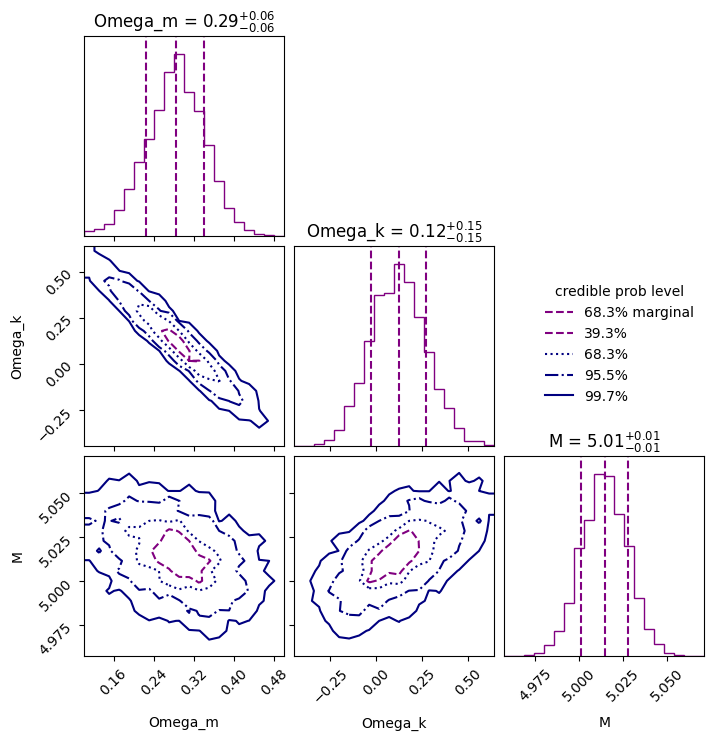

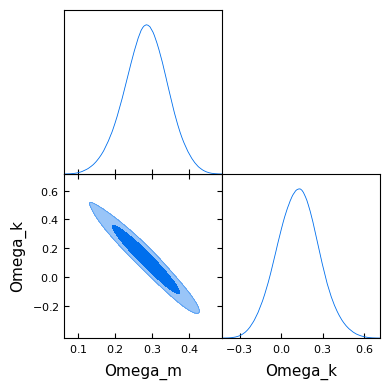

In [37]:
with open(f'{fit_dir}/Open_LCDM_result.pkl', 'rb') as f:
    Open_LCDM_result = pickle.load(f)
cornerplot(Open_LCDM_result);
smooth_plot(Open_LCDM_result)

#### Flat wCDM

In [26]:
Flat_wCDM_result = fit_cosmology("Flat_wCDM")
with open(f'{fit_dir}/Flat_wCDM_result.pkl', 'wb') as f:
    pickle.dump(Flat_wCDM_result, f)

DEBUG:ultranest:ReactiveNestedSampler: dims=3+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(400.0)), (np.float64(inf), np.float64(400.0))]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-14103778.67, Lmax=-853.22


DEBUG:ultranest:iteration=4, ncalls=405, regioncalls=200, ndraw=40, logz=-13623721.36, remainder_fraction=100.0000%, Lmin=-13554981.28, Lmax=-853.22


DEBUG:ultranest:iteration=9, ncalls=410, regioncalls=400, ndraw=40, logz=-13378570.36, remainder_fraction=100.0000%, Lmin=-13273090.62, Lmax=-853.22


DEBUG:ultranest:iteration=14, ncalls=415, regioncalls=600, ndraw=40, logz=-13090059.01, remainder_fraction=100.0000%, Lmin=-12951876.59, Lmax=-853.22


DEBUG:ultranest:iteration=19, ncalls=420, regioncalls=800, ndraw=40, logz=-12602560.24, remainder_fraction=100.0000%, Lmin=-12598291.60, Lmax=-853.22


DEBUG:ultranest:iteration=23, ncalls=425, regioncalls=1000, ndraw=40, logz=-12384077.21, remainder_fraction=100.0000%, Lmin=-12359791.88, Lmax=-853.22


DEBUG:ultranest:iteration=28, ncalls=430, regioncalls=1200, ndraw=40, logz=-12285951.84, remainder_fraction=100.0000%, Lmin=-12242580.89, Lmax=-853.22


DEBUG:ultranest:iteration=32, ncalls=434, regioncalls=1360, ndraw=40, logz=-11785329.51, remainder_fraction=100.0000%, Lmin=-11784140.13, Lmax=-853.22


DEBUG:ultranest:iteration=37, ncalls=440, regioncalls=1600, ndraw=40, logz=-11402716.97, remainder_fraction=100.0000%, Lmin=-11360318.55, Lmax=-853.22


DEBUG:ultranest:iteration=40, ncalls=443, regioncalls=1720, ndraw=40, logz=-11346121.49, remainder_fraction=100.0000%, Lmin=-11263911.11, Lmax=-853.22


DEBUG:ultranest:iteration=45, ncalls=448, regioncalls=1920, ndraw=40, logz=-11064915.96, remainder_fraction=100.0000%, Lmin=-10989994.21, Lmax=-853.22


DEBUG:ultranest:iteration=50, ncalls=453, regioncalls=2120, ndraw=40, logz=-10757046.25, remainder_fraction=100.0000%, Lmin=-10724714.63, Lmax=-853.22


DEBUG:ultranest:iteration=55, ncalls=458, regioncalls=2320, ndraw=40, logz=-10397645.22, remainder_fraction=100.0000%, Lmin=-10374328.07, Lmax=-853.22


DEBUG:ultranest:iteration=60, ncalls=463, regioncalls=2520, ndraw=40, logz=-9827558.72, remainder_fraction=100.0000%, Lmin=-9819033.66, Lmax=-853.22


DEBUG:ultranest:iteration=64, ncalls=469, regioncalls=2760, ndraw=40, logz=-9628894.93, remainder_fraction=100.0000%, Lmin=-9393168.68, Lmax=-853.22


DEBUG:ultranest:iteration=68, ncalls=474, regioncalls=2960, ndraw=40, logz=-9336440.65, remainder_fraction=100.0000%, Lmin=-9303661.11, Lmax=-853.22


DEBUG:ultranest:iteration=73, ncalls=479, regioncalls=3160, ndraw=40, logz=-9208389.16, remainder_fraction=100.0000%, Lmin=-9155107.56, Lmax=-853.22


DEBUG:ultranest:iteration=78, ncalls=484, regioncalls=3360, ndraw=40, logz=-8718265.29, remainder_fraction=100.0000%, Lmin=-8664401.85, Lmax=-853.22


DEBUG:ultranest:iteration=80, ncalls=486, regioncalls=3440, ndraw=40, logz=-8642800.40, remainder_fraction=100.0000%, Lmin=-8535131.03, Lmax=-853.22


DEBUG:ultranest:iteration=84, ncalls=491, regioncalls=3640, ndraw=40, logz=-8329062.01, remainder_fraction=100.0000%, Lmin=-8318027.81, Lmax=-853.22


DEBUG:ultranest:iteration=89, ncalls=496, regioncalls=3840, ndraw=40, logz=-8165752.50, remainder_fraction=100.0000%, Lmin=-8105572.29, Lmax=-853.22


DEBUG:ultranest:iteration=94, ncalls=502, regioncalls=4080, ndraw=40, logz=-7951498.18, remainder_fraction=100.0000%, Lmin=-7863925.72, Lmax=-853.22


DEBUG:ultranest:iteration=99, ncalls=507, regioncalls=4280, ndraw=40, logz=-7586450.27, remainder_fraction=100.0000%, Lmin=-7537718.63, Lmax=-853.22


DEBUG:ultranest:iteration=104, ncalls=512, regioncalls=4480, ndraw=40, logz=-7357272.43, remainder_fraction=100.0000%, Lmin=-7294704.56, Lmax=-853.22


DEBUG:ultranest:iteration=108, ncalls=517, regioncalls=4680, ndraw=40, logz=-7186580.22, remainder_fraction=100.0000%, Lmin=-7145946.74, Lmax=-853.22


DEBUG:ultranest:iteration=113, ncalls=522, regioncalls=4880, ndraw=40, logz=-6879016.34, remainder_fraction=100.0000%, Lmin=-6876207.01, Lmax=-853.22


DEBUG:ultranest:iteration=117, ncalls=527, regioncalls=5080, ndraw=40, logz=-6821365.41, remainder_fraction=100.0000%, Lmin=-6753146.86, Lmax=-853.22


DEBUG:ultranest:iteration=120, ncalls=530, regioncalls=5200, ndraw=40, logz=-6504792.00, remainder_fraction=100.0000%, Lmin=-6504322.29, Lmax=-853.22


DEBUG:ultranest:iteration=124, ncalls=535, regioncalls=5400, ndraw=40, logz=-6441617.51, remainder_fraction=100.0000%, Lmin=-6119179.32, Lmax=-853.22


DEBUG:ultranest:iteration=129, ncalls=542, regioncalls=5680, ndraw=40, logz=-5823170.53, remainder_fraction=100.0000%, Lmin=-5799584.53, Lmax=-853.22


DEBUG:ultranest:iteration=132, ncalls=547, regioncalls=5880, ndraw=40, logz=-5771135.57, remainder_fraction=100.0000%, Lmin=-5738739.06, Lmax=-853.22


DEBUG:ultranest:iteration=137, ncalls=552, regioncalls=6080, ndraw=40, logz=-5509842.25, remainder_fraction=100.0000%, Lmin=-5471483.73, Lmax=-853.22


DEBUG:ultranest:iteration=141, ncalls=558, regioncalls=6320, ndraw=40, logz=-5393521.59, remainder_fraction=100.0000%, Lmin=-5380863.95, Lmax=-853.22


DEBUG:ultranest:iteration=144, ncalls=563, regioncalls=6520, ndraw=40, logz=-5374968.64, remainder_fraction=100.0000%, Lmin=-5365296.60, Lmax=-853.22


DEBUG:ultranest:iteration=147, ncalls=568, regioncalls=6720, ndraw=40, logz=-5347260.03, remainder_fraction=100.0000%, Lmin=-5313905.77, Lmax=-853.22


DEBUG:ultranest:iteration=152, ncalls=573, regioncalls=6920, ndraw=40, logz=-5238977.47, remainder_fraction=100.0000%, Lmin=-5237036.23, Lmax=-853.22


DEBUG:ultranest:iteration=156, ncalls=578, regioncalls=7120, ndraw=40, logz=-5110924.38, remainder_fraction=100.0000%, Lmin=-5088131.28, Lmax=-853.22


DEBUG:ultranest:iteration=160, ncalls=583, regioncalls=7320, ndraw=40, logz=-5004948.90, remainder_fraction=100.0000%, Lmin=-4969515.51, Lmax=-853.22


DEBUG:ultranest:iteration=162, ncalls=588, regioncalls=7520, ndraw=40, logz=-4908580.32, remainder_fraction=100.0000%, Lmin=-4907767.63, Lmax=-853.22


DEBUG:ultranest:iteration=166, ncalls=593, regioncalls=7720, ndraw=40, logz=-4817907.35, remainder_fraction=100.0000%, Lmin=-4788376.37, Lmax=-853.22


DEBUG:ultranest:iteration=170, ncalls=598, regioncalls=7920, ndraw=40, logz=-4713950.14, remainder_fraction=100.0000%, Lmin=-4666503.15, Lmax=-853.22


DEBUG:ultranest:iteration=173, ncalls=604, regioncalls=8160, ndraw=40, logz=-4544665.80, remainder_fraction=100.0000%, Lmin=-4460618.10, Lmax=-853.22


DEBUG:ultranest:iteration=177, ncalls=611, regioncalls=8440, ndraw=40, logz=-4381532.07, remainder_fraction=100.0000%, Lmin=-4381510.74, Lmax=-853.22


DEBUG:ultranest:iteration=180, ncalls=614, regioncalls=8560, ndraw=40, logz=-4365291.37, remainder_fraction=100.0000%, Lmin=-4362785.92, Lmax=-853.22


DEBUG:ultranest:iteration=185, ncalls=620, regioncalls=8800, ndraw=40, logz=-4303076.25, remainder_fraction=100.0000%, Lmin=-4282846.91, Lmax=-853.22


DEBUG:ultranest:iteration=190, ncalls=625, regioncalls=9000, ndraw=40, logz=-4235449.89, remainder_fraction=100.0000%, Lmin=-4225465.89, Lmax=-853.22


DEBUG:ultranest:iteration=195, ncalls=630, regioncalls=9200, ndraw=40, logz=-4035911.26, remainder_fraction=100.0000%, Lmin=-4034586.06, Lmax=-853.22


DEBUG:ultranest:iteration=199, ncalls=636, regioncalls=9440, ndraw=40, logz=-3956603.90, remainder_fraction=100.0000%, Lmin=-3931611.84, Lmax=-853.22


DEBUG:ultranest:iteration=200, ncalls=637, regioncalls=9480, ndraw=40, logz=-3931618.33, remainder_fraction=100.0000%, Lmin=-3888774.32, Lmax=-853.22


DEBUG:ultranest:iteration=205, ncalls=642, regioncalls=9680, ndraw=40, logz=-3860021.42, remainder_fraction=100.0000%, Lmin=-3854011.87, Lmax=-853.22


DEBUG:ultranest:iteration=208, ncalls=647, regioncalls=9880, ndraw=40, logz=-3762422.94, remainder_fraction=100.0000%, Lmin=-3762247.95, Lmax=-853.22


DEBUG:ultranest:iteration=213, ncalls=652, regioncalls=10080, ndraw=40, logz=-3558737.72, remainder_fraction=100.0000%, Lmin=-3532883.13, Lmax=-853.22


DEBUG:ultranest:iteration=218, ncalls=657, regioncalls=10280, ndraw=40, logz=-3485403.75, remainder_fraction=100.0000%, Lmin=-3422158.66, Lmax=-853.22


DEBUG:ultranest:iteration=223, ncalls=662, regioncalls=10480, ndraw=40, logz=-3182638.70, remainder_fraction=100.0000%, Lmin=-3153432.57, Lmax=-853.22


DEBUG:ultranest:iteration=227, ncalls=667, regioncalls=10680, ndraw=40, logz=-3053831.79, remainder_fraction=100.0000%, Lmin=-3013540.16, Lmax=-853.22


DEBUG:ultranest:iteration=231, ncalls=672, regioncalls=10880, ndraw=40, logz=-2982845.01, remainder_fraction=100.0000%, Lmin=-2978770.72, Lmax=-853.22


DEBUG:ultranest:iteration=236, ncalls=677, regioncalls=11080, ndraw=40, logz=-2935959.67, remainder_fraction=100.0000%, Lmin=-2903084.95, Lmax=-853.22


DEBUG:ultranest:iteration=239, ncalls=683, regioncalls=11320, ndraw=40, logz=-2837260.31, remainder_fraction=100.0000%, Lmin=-2815087.31, Lmax=-853.22


DEBUG:ultranest:iteration=240, ncalls=685, regioncalls=11400, ndraw=40, logz=-2815093.90, remainder_fraction=100.0000%, Lmin=-2771045.74, Lmax=-853.22


DEBUG:ultranest:iteration=244, ncalls=690, regioncalls=11600, ndraw=40, logz=-2743139.64, remainder_fraction=100.0000%, Lmin=-2657985.70, Lmax=-853.22


DEBUG:ultranest:iteration=245, ncalls=696, regioncalls=11840, ndraw=40, logz=-2657992.30, remainder_fraction=100.0000%, Lmin=-2651887.58, Lmax=-853.22


DEBUG:ultranest:iteration=249, ncalls=702, regioncalls=12080, ndraw=40, logz=-2599312.01, remainder_fraction=100.0000%, Lmin=-2584472.70, Lmax=-853.22


DEBUG:ultranest:iteration=252, ncalls=707, regioncalls=12280, ndraw=40, logz=-2554582.70, remainder_fraction=100.0000%, Lmin=-2554473.11, Lmax=-853.22


DEBUG:ultranest:iteration=255, ncalls=712, regioncalls=12480, ndraw=40, logz=-2542595.67, remainder_fraction=100.0000%, Lmin=-2535463.19, Lmax=-853.22


DEBUG:ultranest:iteration=259, ncalls=717, regioncalls=12680, ndraw=40, logz=-2470494.02, remainder_fraction=100.0000%, Lmin=-2466596.57, Lmax=-853.22


DEBUG:ultranest:iteration=264, ncalls=725, regioncalls=13000, ndraw=40, logz=-2430929.39, remainder_fraction=100.0000%, Lmin=-2428048.39, Lmax=-853.22


DEBUG:ultranest:iteration=269, ncalls=730, regioncalls=13200, ndraw=40, logz=-2313829.72, remainder_fraction=100.0000%, Lmin=-2310443.11, Lmax=-853.22


DEBUG:ultranest:iteration=273, ncalls=735, regioncalls=13400, ndraw=40, logz=-2282487.95, remainder_fraction=100.0000%, Lmin=-2278343.44, Lmax=-853.22


DEBUG:ultranest:iteration=275, ncalls=741, regioncalls=13640, ndraw=40, logz=-2275347.59, remainder_fraction=100.0000%, Lmin=-2274464.28, Lmax=-853.22


DEBUG:ultranest:iteration=279, ncalls=747, regioncalls=13880, ndraw=40, logz=-2189975.21, remainder_fraction=100.0000%, Lmin=-2185183.05, Lmax=-853.22


DEBUG:ultranest:iteration=280, ncalls=748, regioncalls=13920, ndraw=40, logz=-2185189.74, remainder_fraction=100.0000%, Lmin=-2180595.47, Lmax=-853.22


DEBUG:ultranest:iteration=285, ncalls=753, regioncalls=14120, ndraw=40, logz=-2167930.03, remainder_fraction=100.0000%, Lmin=-2154152.26, Lmax=-853.22


DEBUG:ultranest:iteration=290, ncalls=758, regioncalls=14320, ndraw=40, logz=-2111466.29, remainder_fraction=100.0000%, Lmin=-2111404.65, Lmax=-853.22


DEBUG:ultranest:iteration=294, ncalls=763, regioncalls=14520, ndraw=40, logz=-2050722.78, remainder_fraction=100.0000%, Lmin=-2004350.69, Lmax=-853.22


DEBUG:ultranest:iteration=298, ncalls=768, regioncalls=14720, ndraw=40, logz=-1978971.85, remainder_fraction=100.0000%, Lmin=-1974656.86, Lmax=-853.22


DEBUG:ultranest:iteration=300, ncalls=774, regioncalls=14960, ndraw=40, logz=-1956711.35, remainder_fraction=100.0000%, Lmin=-1936038.05, Lmax=-853.22


DEBUG:ultranest:iteration=304, ncalls=780, regioncalls=15200, ndraw=40, logz=-1879582.92, remainder_fraction=100.0000%, Lmin=-1863778.23, Lmax=-853.22


DEBUG:ultranest:iteration=308, ncalls=787, regioncalls=15480, ndraw=40, logz=-1836405.36, remainder_fraction=100.0000%, Lmin=-1833546.95, Lmax=-853.22


DEBUG:ultranest:iteration=313, ncalls=792, regioncalls=15680, ndraw=40, logz=-1799499.99, remainder_fraction=100.0000%, Lmin=-1795147.02, Lmax=-853.22


DEBUG:ultranest:iteration=317, ncalls=797, regioncalls=15880, ndraw=40, logz=-1753842.05, remainder_fraction=100.0000%, Lmin=-1744636.57, Lmax=-853.22


DEBUG:ultranest:iteration=320, ncalls=800, regioncalls=16000, ndraw=40, logz=-1718825.83, remainder_fraction=100.0000%, Lmin=-1673712.72, Lmax=-853.22


DEBUG:ultranest:iteration=323, ncalls=805, regioncalls=16200, ndraw=40, logz=-1632294.64, remainder_fraction=100.0000%, Lmin=-1627862.75, Lmax=-853.22


DEBUG:ultranest:iteration=328, ncalls=811, regioncalls=16440, ndraw=40, logz=-1612203.44, remainder_fraction=100.0000%, Lmin=-1597210.29, Lmax=-853.22


DEBUG:ultranest:iteration=331, ncalls=816, regioncalls=16640, ndraw=40, logz=-1578825.05, remainder_fraction=100.0000%, Lmin=-1572264.09, Lmax=-853.22


DEBUG:ultranest:iteration=336, ncalls=821, regioncalls=16840, ndraw=40, logz=-1506148.90, remainder_fraction=100.0000%, Lmin=-1501736.93, Lmax=-853.22


DEBUG:ultranest:iteration=340, ncalls=826, regioncalls=17040, ndraw=40, logz=-1481249.39, remainder_fraction=100.0000%, Lmin=-1470533.23, Lmax=-853.22


DEBUG:ultranest:iteration=343, ncalls=832, regioncalls=17280, ndraw=40, logz=-1461430.52, remainder_fraction=100.0000%, Lmin=-1459094.97, Lmax=-853.22


DEBUG:ultranest:iteration=347, ncalls=837, regioncalls=17480, ndraw=40, logz=-1434050.29, remainder_fraction=100.0000%, Lmin=-1408789.24, Lmax=-853.22


DEBUG:ultranest:iteration=350, ncalls=842, regioncalls=17680, ndraw=40, logz=-1398540.61, remainder_fraction=100.0000%, Lmin=-1397878.67, Lmax=-853.22


DEBUG:ultranest:iteration=354, ncalls=849, regioncalls=17960, ndraw=40, logz=-1378476.82, remainder_fraction=100.0000%, Lmin=-1369556.62, Lmax=-853.22


DEBUG:ultranest:iteration=359, ncalls=854, regioncalls=18160, ndraw=40, logz=-1339320.99, remainder_fraction=100.0000%, Lmin=-1330702.86, Lmax=-853.22


DEBUG:ultranest:iteration=360, ncalls=856, regioncalls=18240, ndraw=40, logz=-1330709.75, remainder_fraction=100.0000%, Lmin=-1325614.31, Lmax=-853.22


DEBUG:ultranest:iteration=364, ncalls=861, regioncalls=18440, ndraw=40, logz=-1316356.74, remainder_fraction=100.0000%, Lmin=-1312324.05, Lmax=-853.22


DEBUG:ultranest:iteration=368, ncalls=866, regioncalls=18640, ndraw=40, logz=-1289030.15, remainder_fraction=100.0000%, Lmin=-1260979.01, Lmax=-853.22


DEBUG:ultranest:iteration=372, ncalls=871, regioncalls=18840, ndraw=40, logz=-1231660.70, remainder_fraction=100.0000%, Lmin=-1216764.75, Lmax=-853.22


DEBUG:ultranest:iteration=376, ncalls=876, regioncalls=19040, ndraw=40, logz=-1209071.28, remainder_fraction=100.0000%, Lmin=-1208120.53, Lmax=-853.22


DEBUG:ultranest:iteration=380, ncalls=881, regioncalls=19240, ndraw=40, logz=-1178038.66, remainder_fraction=100.0000%, Lmin=-1164735.66, Lmax=-853.22


DEBUG:ultranest:iteration=384, ncalls=886, regioncalls=19440, ndraw=40, logz=-1153527.88, remainder_fraction=100.0000%, Lmin=-1150063.46, Lmax=-853.22


DEBUG:ultranest:iteration=388, ncalls=892, regioncalls=19680, ndraw=40, logz=-1097804.94, remainder_fraction=100.0000%, Lmin=-1093941.85, Lmax=-853.22


DEBUG:ultranest:iteration=393, ncalls=899, regioncalls=19960, ndraw=40, logz=-1052903.55, remainder_fraction=100.0000%, Lmin=-1033429.81, Lmax=-853.22


DEBUG:ultranest:iteration=396, ncalls=904, regioncalls=20160, ndraw=40, logz=-1015668.28, remainder_fraction=100.0000%, Lmin=-1015556.25, Lmax=-853.22


DEBUG:ultranest:iteration=400, ncalls=908, regioncalls=20320, ndraw=40, logz=-991932.75, remainder_fraction=100.0000%, Lmin=-985820.34, Lmax=-853.22


DEBUG:ultranest:iteration=405, ncalls=915, regioncalls=20600, ndraw=40, logz=-949395.30, remainder_fraction=100.0000%, Lmin=-929171.12, Lmax=-853.22


DEBUG:ultranest:iteration=410, ncalls=921, regioncalls=20840, ndraw=40, logz=-905962.56, remainder_fraction=100.0000%, Lmin=-905171.09, Lmax=-853.22


DEBUG:ultranest:iteration=414, ncalls=927, regioncalls=21080, ndraw=40, logz=-887639.82, remainder_fraction=100.0000%, Lmin=-879584.71, Lmax=-853.22


DEBUG:ultranest:iteration=418, ncalls=932, regioncalls=21280, ndraw=40, logz=-839256.50, remainder_fraction=100.0000%, Lmin=-835942.96, Lmax=-853.22


DEBUG:ultranest:iteration=422, ncalls=938, regioncalls=21520, ndraw=40, logz=-786602.87, remainder_fraction=100.0000%, Lmin=-776466.84, Lmax=-853.22


DEBUG:ultranest:iteration=427, ncalls=944, regioncalls=21760, ndraw=40, logz=-748556.38, remainder_fraction=100.0000%, Lmin=-743800.10, Lmax=-853.22


DEBUG:ultranest:iteration=430, ncalls=949, regioncalls=21960, ndraw=40, logz=-721098.27, remainder_fraction=100.0000%, Lmin=-719628.51, Lmax=-853.22


DEBUG:ultranest:iteration=434, ncalls=954, regioncalls=22160, ndraw=40, logz=-700063.67, remainder_fraction=100.0000%, Lmin=-698859.05, Lmax=-853.22


DEBUG:ultranest:iteration=438, ncalls=961, regioncalls=22440, ndraw=40, logz=-684614.84, remainder_fraction=100.0000%, Lmin=-668138.25, Lmax=-853.22


DEBUG:ultranest:iteration=440, ncalls=965, regioncalls=22600, ndraw=40, logz=-666673.74, remainder_fraction=100.0000%, Lmin=-653148.57, Lmax=-853.22


DEBUG:ultranest:iteration=445, ncalls=971, regioncalls=22840, ndraw=40, logz=-647789.23, remainder_fraction=100.0000%, Lmin=-645585.88, Lmax=-853.22


DEBUG:ultranest:iteration=449, ncalls=977, regioncalls=23080, ndraw=40, logz=-633541.46, remainder_fraction=100.0000%, Lmin=-632132.36, Lmax=-853.22


DEBUG:ultranest:iteration=450, ncalls=978, regioncalls=23120, ndraw=40, logz=-632139.47, remainder_fraction=100.0000%, Lmin=-621269.57, Lmax=-853.22


DEBUG:ultranest:iteration=453, ncalls=983, regioncalls=23320, ndraw=40, logz=-594767.02, remainder_fraction=100.0000%, Lmin=-591364.05, Lmax=-853.22


DEBUG:ultranest:iteration=456, ncalls=990, regioncalls=23600, ndraw=40, logz=-577411.09, remainder_fraction=100.0000%, Lmin=-574648.11, Lmax=-853.22


DEBUG:ultranest:iteration=460, ncalls=995, regioncalls=23800, ndraw=40, logz=-564778.58, remainder_fraction=100.0000%, Lmin=-555920.00, Lmax=-853.22


DEBUG:ultranest:iteration=465, ncalls=1000, regioncalls=24000, ndraw=40, logz=-543896.83, remainder_fraction=100.0000%, Lmin=-536671.12, Lmax=-853.22


DEBUG:ultranest:iteration=469, ncalls=1005, regioncalls=24200, ndraw=40, logz=-520141.14, remainder_fraction=100.0000%, Lmin=-520109.71, Lmax=-853.22


DEBUG:ultranest:iteration=473, ncalls=1010, regioncalls=24400, ndraw=40, logz=-510302.34, remainder_fraction=100.0000%, Lmin=-507778.85, Lmax=-853.22


DEBUG:ultranest:iteration=477, ncalls=1016, regioncalls=24640, ndraw=40, logz=-505445.30, remainder_fraction=100.0000%, Lmin=-502624.83, Lmax=-853.22


DEBUG:ultranest:iteration=480, ncalls=1020, regioncalls=24800, ndraw=40, logz=-491455.77, remainder_fraction=100.0000%, Lmin=-489735.20, Lmax=-853.22


DEBUG:ultranest:iteration=483, ncalls=1025, regioncalls=25000, ndraw=40, logz=-488035.72, remainder_fraction=100.0000%, Lmin=-484349.23, Lmax=-853.22


DEBUG:ultranest:iteration=488, ncalls=1030, regioncalls=25200, ndraw=40, logz=-477102.19, remainder_fraction=100.0000%, Lmin=-470760.23, Lmax=-853.22


DEBUG:ultranest:iteration=491, ncalls=1035, regioncalls=25400, ndraw=40, logz=-468412.68, remainder_fraction=100.0000%, Lmin=-467582.16, Lmax=-853.22


DEBUG:ultranest:iteration=494, ncalls=1040, regioncalls=25600, ndraw=40, logz=-459179.75, remainder_fraction=100.0000%, Lmin=-458201.53, Lmax=-853.22


DEBUG:ultranest:iteration=498, ncalls=1045, regioncalls=25800, ndraw=40, logz=-451218.65, remainder_fraction=100.0000%, Lmin=-451188.52, Lmax=-853.22


DEBUG:ultranest:iteration=503, ncalls=1051, regioncalls=26040, ndraw=40, logz=-443212.08, remainder_fraction=100.0000%, Lmin=-432689.00, Lmax=-853.22


DEBUG:ultranest:iteration=507, ncalls=1056, regioncalls=26240, ndraw=40, logz=-430261.10, remainder_fraction=100.0000%, Lmin=-430178.66, Lmax=-853.22


DEBUG:ultranest:iteration=512, ncalls=1061, regioncalls=26440, ndraw=40, logz=-420808.77, remainder_fraction=100.0000%, Lmin=-418020.78, Lmax=-853.22


DEBUG:ultranest:iteration=515, ncalls=1066, regioncalls=26640, ndraw=40, logz=-413487.55, remainder_fraction=100.0000%, Lmin=-413435.53, Lmax=-853.22


DEBUG:ultranest:iteration=518, ncalls=1071, regioncalls=26840, ndraw=40, logz=-411870.52, remainder_fraction=100.0000%, Lmin=-407851.34, Lmax=-853.22


DEBUG:ultranest:iteration=520, ncalls=1074, regioncalls=26960, ndraw=40, logz=-403364.80, remainder_fraction=100.0000%, Lmin=-403204.48, Lmax=-853.22


DEBUG:ultranest:iteration=523, ncalls=1080, regioncalls=27200, ndraw=40, logz=-395106.56, remainder_fraction=100.0000%, Lmin=-394239.53, Lmax=-853.22


DEBUG:ultranest:iteration=528, ncalls=1085, regioncalls=27400, ndraw=40, logz=-386243.54, remainder_fraction=100.0000%, Lmin=-385367.96, Lmax=-853.22


DEBUG:ultranest:iteration=532, ncalls=1091, regioncalls=27640, ndraw=40, logz=-372543.94, remainder_fraction=100.0000%, Lmin=-369366.10, Lmax=-853.22


DEBUG:ultranest:iteration=535, ncalls=1097, regioncalls=27880, ndraw=40, logz=-359877.64, remainder_fraction=100.0000%, Lmin=-354744.39, Lmax=-853.22


DEBUG:ultranest:iteration=539, ncalls=1102, regioncalls=28080, ndraw=40, logz=-351795.27, remainder_fraction=100.0000%, Lmin=-351575.23, Lmax=-853.22


DEBUG:ultranest:iteration=542, ncalls=1107, regioncalls=28280, ndraw=40, logz=-348567.38, remainder_fraction=100.0000%, Lmin=-348313.71, Lmax=-853.22


DEBUG:ultranest:iteration=544, ncalls=1112, regioncalls=28480, ndraw=40, logz=-347122.65, remainder_fraction=100.0000%, Lmin=-342627.16, Lmax=-853.22


DEBUG:ultranest:iteration=548, ncalls=1117, regioncalls=28680, ndraw=40, logz=-340921.91, remainder_fraction=100.0000%, Lmin=-340819.63, Lmax=-853.22


DEBUG:ultranest:iteration=551, ncalls=1122, regioncalls=28880, ndraw=40, logz=-339084.72, remainder_fraction=100.0000%, Lmin=-336500.08, Lmax=-853.22


DEBUG:ultranest:iteration=554, ncalls=1127, regioncalls=29080, ndraw=40, logz=-333899.50, remainder_fraction=100.0000%, Lmin=-327464.64, Lmax=-853.22


DEBUG:ultranest:iteration=558, ncalls=1132, regioncalls=29280, ndraw=40, logz=-323560.24, remainder_fraction=100.0000%, Lmin=-322836.40, Lmax=-853.22


DEBUG:ultranest:iteration=560, ncalls=1137, regioncalls=29480, ndraw=40, logz=-322261.36, remainder_fraction=100.0000%, Lmin=-320430.64, Lmax=-853.22


DEBUG:ultranest:iteration=565, ncalls=1143, regioncalls=29720, ndraw=40, logz=-309754.44, remainder_fraction=100.0000%, Lmin=-309726.19, Lmax=-853.22


DEBUG:ultranest:iteration=569, ncalls=1149, regioncalls=29960, ndraw=40, logz=-304673.70, remainder_fraction=100.0000%, Lmin=-302394.21, Lmax=-853.22


DEBUG:ultranest:iteration=573, ncalls=1158, regioncalls=30320, ndraw=40, logz=-298575.86, remainder_fraction=100.0000%, Lmin=-297180.28, Lmax=-853.22


DEBUG:ultranest:iteration=576, ncalls=1163, regioncalls=30520, ndraw=40, logz=-296294.03, remainder_fraction=100.0000%, Lmin=-295876.87, Lmax=-853.22


DEBUG:ultranest:iteration=581, ncalls=1168, regioncalls=30720, ndraw=40, logz=-291373.47, remainder_fraction=100.0000%, Lmin=-291003.25, Lmax=-853.22


DEBUG:ultranest:iteration=585, ncalls=1174, regioncalls=30960, ndraw=40, logz=-285476.09, remainder_fraction=100.0000%, Lmin=-285200.42, Lmax=-853.22


DEBUG:ultranest:iteration=587, ncalls=1180, regioncalls=31200, ndraw=40, logz=-284407.57, remainder_fraction=100.0000%, Lmin=-284263.29, Lmax=-853.22


DEBUG:ultranest:iteration=592, ncalls=1185, regioncalls=31400, ndraw=40, logz=-274644.89, remainder_fraction=100.0000%, Lmin=-272902.60, Lmax=-853.22


DEBUG:ultranest:iteration=595, ncalls=1190, regioncalls=31600, ndraw=40, logz=-266243.68, remainder_fraction=100.0000%, Lmin=-263269.15, Lmax=-853.22


DEBUG:ultranest:iteration=599, ncalls=1196, regioncalls=31840, ndraw=40, logz=-260934.29, remainder_fraction=100.0000%, Lmin=-259068.02, Lmax=-853.22


DEBUG:ultranest:iteration=600, ncalls=1197, regioncalls=31880, ndraw=40, logz=-259075.51, remainder_fraction=100.0000%, Lmin=-258746.02, Lmax=-853.22


DEBUG:ultranest:iteration=602, ncalls=1202, regioncalls=32080, ndraw=40, logz=-258320.44, remainder_fraction=100.0000%, Lmin=-255572.26, Lmax=-853.22


DEBUG:ultranest:iteration=606, ncalls=1213, regioncalls=32520, ndraw=40, logz=-247498.30, remainder_fraction=100.0000%, Lmin=-247305.04, Lmax=-853.22


DEBUG:ultranest:iteration=610, ncalls=1218, regioncalls=32720, ndraw=40, logz=-243886.58, remainder_fraction=100.0000%, Lmin=-243518.85, Lmax=-853.22


DEBUG:ultranest:iteration=613, ncalls=1224, regioncalls=32960, ndraw=40, logz=-242834.55, remainder_fraction=100.0000%, Lmin=-242322.89, Lmax=-853.22


DEBUG:ultranest:iteration=615, ncalls=1231, regioncalls=33240, ndraw=40, logz=-242095.34, remainder_fraction=100.0000%, Lmin=-241854.81, Lmax=-853.22


DEBUG:ultranest:iteration=620, ncalls=1236, regioncalls=33440, ndraw=40, logz=-235395.93, remainder_fraction=100.0000%, Lmin=-232677.07, Lmax=-853.22


DEBUG:ultranest:iteration=624, ncalls=1241, regioncalls=33640, ndraw=40, logz=-226885.74, remainder_fraction=100.0000%, Lmin=-225038.48, Lmax=-853.22


DEBUG:ultranest:iteration=628, ncalls=1248, regioncalls=33920, ndraw=40, logz=-222411.50, remainder_fraction=100.0000%, Lmin=-221392.79, Lmax=-853.22


DEBUG:ultranest:iteration=631, ncalls=1253, regioncalls=34120, ndraw=40, logz=-220595.28, remainder_fraction=100.0000%, Lmin=-220031.57, Lmax=-853.22


DEBUG:ultranest:iteration=633, ncalls=1259, regioncalls=34360, ndraw=40, logz=-219888.16, remainder_fraction=100.0000%, Lmin=-219840.05, Lmax=-853.22


DEBUG:ultranest:iteration=635, ncalls=1264, regioncalls=34560, ndraw=40, logz=-219310.48, remainder_fraction=100.0000%, Lmin=-218120.57, Lmax=-853.22


DEBUG:ultranest:iteration=637, ncalls=1269, regioncalls=34760, ndraw=40, logz=-216905.30, remainder_fraction=100.0000%, Lmin=-216143.14, Lmax=-853.22


DEBUG:ultranest:iteration=640, ncalls=1274, regioncalls=34960, ndraw=40, logz=-215749.33, remainder_fraction=100.0000%, Lmin=-215067.80, Lmax=-853.22


DEBUG:ultranest:iteration=644, ncalls=1280, regioncalls=35200, ndraw=40, logz=-211570.93, remainder_fraction=100.0000%, Lmin=-209884.67, Lmax=-853.22


DEBUG:ultranest:iteration=647, ncalls=1285, regioncalls=35400, ndraw=40, logz=-207844.03, remainder_fraction=100.0000%, Lmin=-205932.36, Lmax=-853.22


DEBUG:ultranest:iteration=652, ncalls=1290, regioncalls=35600, ndraw=40, logz=-202014.29, remainder_fraction=100.0000%, Lmin=-201477.65, Lmax=-853.22


DEBUG:ultranest:iteration=654, ncalls=1295, regioncalls=35800, ndraw=40, logz=-198927.79, remainder_fraction=100.0000%, Lmin=-198221.85, Lmax=-853.22


DEBUG:ultranest:iteration=657, ncalls=1302, regioncalls=36080, ndraw=40, logz=-196714.41, remainder_fraction=100.0000%, Lmin=-196493.40, Lmax=-853.22


DEBUG:ultranest:iteration=661, ncalls=1312, regioncalls=36480, ndraw=40, logz=-194638.20, remainder_fraction=100.0000%, Lmin=-194505.73, Lmax=-853.22


DEBUG:ultranest:iteration=666, ncalls=1323, regioncalls=36920, ndraw=40, logz=-190281.51, remainder_fraction=100.0000%, Lmin=-189727.98, Lmax=-853.22


DEBUG:ultranest:iteration=670, ncalls=1331, regioncalls=37240, ndraw=40, logz=-188515.15, remainder_fraction=100.0000%, Lmin=-185650.78, Lmax=-853.22


DEBUG:ultranest:iteration=672, ncalls=1336, regioncalls=37440, ndraw=40, logz=-185425.24, remainder_fraction=100.0000%, Lmin=-185296.83, Lmax=-853.22


DEBUG:ultranest:iteration=675, ncalls=1341, regioncalls=37640, ndraw=40, logz=-183458.45, remainder_fraction=100.0000%, Lmin=-183151.87, Lmax=-853.22


DEBUG:ultranest:iteration=677, ncalls=1346, regioncalls=37840, ndraw=40, logz=-182983.21, remainder_fraction=100.0000%, Lmin=-181559.70, Lmax=-853.22


DEBUG:ultranest:iteration=679, ncalls=1351, regioncalls=38040, ndraw=40, logz=-179770.84, remainder_fraction=100.0000%, Lmin=-178442.41, Lmax=-853.22


DEBUG:ultranest:iteration=680, ncalls=1354, regioncalls=38160, ndraw=40, logz=-178450.10, remainder_fraction=100.0000%, Lmin=-178215.64, Lmax=-853.22


DEBUG:ultranest:iteration=684, ncalls=1361, regioncalls=38440, ndraw=40, logz=-177735.60, remainder_fraction=100.0000%, Lmin=-177643.04, Lmax=-853.22


DEBUG:ultranest:iteration=688, ncalls=1368, regioncalls=38720, ndraw=40, logz=-176171.90, remainder_fraction=100.0000%, Lmin=-175993.33, Lmax=-853.22


DEBUG:ultranest:iteration=692, ncalls=1376, regioncalls=39040, ndraw=40, logz=-171873.96, remainder_fraction=100.0000%, Lmin=-171392.43, Lmax=-853.22


DEBUG:ultranest:iteration=697, ncalls=1381, regioncalls=39240, ndraw=40, logz=-167595.40, remainder_fraction=100.0000%, Lmin=-166458.04, Lmax=-853.22


DEBUG:ultranest:iteration=700, ncalls=1389, regioncalls=39560, ndraw=40, logz=-165706.17, remainder_fraction=100.0000%, Lmin=-165568.23, Lmax=-853.22


DEBUG:ultranest:iteration=703, ncalls=1394, regioncalls=39760, ndraw=40, logz=-164573.57, remainder_fraction=100.0000%, Lmin=-163025.45, Lmax=-853.22


DEBUG:ultranest:iteration=707, ncalls=1399, regioncalls=39960, ndraw=40, logz=-162425.71, remainder_fraction=100.0000%, Lmin=-160018.75, Lmax=-853.22


DEBUG:ultranest:iteration=709, ncalls=1404, regioncalls=40160, ndraw=40, logz=-157742.59, remainder_fraction=100.0000%, Lmin=-155551.58, Lmax=-853.22


DEBUG:ultranest:iteration=711, ncalls=1409, regioncalls=40360, ndraw=40, logz=-155528.51, remainder_fraction=100.0000%, Lmin=-155385.28, Lmax=-853.22


DEBUG:ultranest:iteration=713, ncalls=1414, regioncalls=40560, ndraw=40, logz=-154929.25, remainder_fraction=100.0000%, Lmin=-154905.59, Lmax=-853.22


DEBUG:ultranest:iteration=715, ncalls=1419, regioncalls=40760, ndraw=40, logz=-153964.73, remainder_fraction=100.0000%, Lmin=-153250.77, Lmax=-853.22


DEBUG:ultranest:iteration=718, ncalls=1424, regioncalls=40960, ndraw=40, logz=-151290.71, remainder_fraction=100.0000%, Lmin=-151167.60, Lmax=-853.22


DEBUG:ultranest:iteration=720, ncalls=1427, regioncalls=41080, ndraw=40, logz=-149730.03, remainder_fraction=100.0000%, Lmin=-148270.25, Lmax=-853.22


DEBUG:ultranest:iteration=723, ncalls=1432, regioncalls=41280, ndraw=40, logz=-146778.83, remainder_fraction=100.0000%, Lmin=-145922.28, Lmax=-853.22


DEBUG:ultranest:iteration=728, ncalls=1438, regioncalls=41520, ndraw=40, logz=-140526.92, remainder_fraction=100.0000%, Lmin=-139816.35, Lmax=-853.22


DEBUG:ultranest:iteration=733, ncalls=1444, regioncalls=41760, ndraw=40, logz=-138206.76, remainder_fraction=100.0000%, Lmin=-137674.03, Lmax=-853.22


DEBUG:ultranest:iteration=736, ncalls=1449, regioncalls=41960, ndraw=40, logz=-137192.01, remainder_fraction=100.0000%, Lmin=-137019.48, Lmax=-853.22


DEBUG:ultranest:iteration=739, ncalls=1454, regioncalls=42160, ndraw=40, logz=-133812.03, remainder_fraction=100.0000%, Lmin=-133750.11, Lmax=-853.22


DEBUG:ultranest:iteration=743, ncalls=1459, regioncalls=42360, ndraw=40, logz=-130025.01, remainder_fraction=100.0000%, Lmin=-129290.96, Lmax=-853.22


DEBUG:ultranest:iteration=746, ncalls=1465, regioncalls=42600, ndraw=40, logz=-127593.02, remainder_fraction=100.0000%, Lmin=-127204.67, Lmax=-853.22


DEBUG:ultranest:iteration=751, ncalls=1471, regioncalls=42840, ndraw=40, logz=-125296.63, remainder_fraction=100.0000%, Lmin=-124935.44, Lmax=-853.22


DEBUG:ultranest:iteration=755, ncalls=1476, regioncalls=43040, ndraw=40, logz=-123088.87, remainder_fraction=100.0000%, Lmin=-121229.69, Lmax=-853.22


DEBUG:ultranest:iteration=757, ncalls=1481, regioncalls=43240, ndraw=40, logz=-119629.46, remainder_fraction=100.0000%, Lmin=-119473.28, Lmax=-853.22


DEBUG:ultranest:iteration=760, ncalls=1485, regioncalls=43400, ndraw=40, logz=-119368.57, remainder_fraction=100.0000%, Lmin=-118862.31, Lmax=-853.22


DEBUG:ultranest:iteration=763, ncalls=1492, regioncalls=43680, ndraw=40, logz=-118018.46, remainder_fraction=100.0000%, Lmin=-117885.86, Lmax=-853.22


DEBUG:ultranest:iteration=766, ncalls=1497, regioncalls=43880, ndraw=40, logz=-117048.35, remainder_fraction=100.0000%, Lmin=-115729.88, Lmax=-853.22


DEBUG:ultranest:iteration=770, ncalls=1503, regioncalls=44120, ndraw=40, logz=-113749.29, remainder_fraction=100.0000%, Lmin=-113370.48, Lmax=-853.22


DEBUG:ultranest:iteration=773, ncalls=1509, regioncalls=44360, ndraw=40, logz=-111516.58, remainder_fraction=100.0000%, Lmin=-111014.43, Lmax=-853.22


DEBUG:ultranest:iteration=777, ncalls=1518, regioncalls=44720, ndraw=40, logz=-109682.18, remainder_fraction=100.0000%, Lmin=-109423.00, Lmax=-853.22


DEBUG:ultranest:iteration=780, ncalls=1523, regioncalls=44920, ndraw=40, logz=-108975.18, remainder_fraction=100.0000%, Lmin=-108704.44, Lmax=-853.22


DEBUG:ultranest:iteration=784, ncalls=1528, regioncalls=45120, ndraw=40, logz=-105851.75, remainder_fraction=100.0000%, Lmin=-105033.00, Lmax=-853.22


DEBUG:ultranest:iteration=789, ncalls=1533, regioncalls=45320, ndraw=40, logz=-102733.61, remainder_fraction=100.0000%, Lmin=-99882.89, Lmax=-853.22


DEBUG:ultranest:iteration=794, ncalls=1538, regioncalls=45520, ndraw=40, logz=-97030.69, remainder_fraction=100.0000%, Lmin=-96656.13, Lmax=-853.22


DEBUG:ultranest:iteration=797, ncalls=1544, regioncalls=45760, ndraw=40, logz=-95516.26, remainder_fraction=100.0000%, Lmin=-95432.07, Lmax=-853.22


DEBUG:ultranest:iteration=800, ncalls=1548, regioncalls=45920, ndraw=40, logz=-94768.42, remainder_fraction=100.0000%, Lmin=-94616.09, Lmax=-853.22


DEBUG:ultranest:iteration=803, ncalls=1554, regioncalls=46160, ndraw=40, logz=-94207.86, remainder_fraction=100.0000%, Lmin=-93981.69, Lmax=-853.22


DEBUG:ultranest:iteration=808, ncalls=1559, regioncalls=46360, ndraw=40, logz=-89598.55, remainder_fraction=100.0000%, Lmin=-89517.74, Lmax=-853.22


DEBUG:ultranest:iteration=810, ncalls=1562, regioncalls=46480, ndraw=40, logz=-88500.92, remainder_fraction=100.0000%, Lmin=-88348.66, Lmax=-853.22


DEBUG:ultranest:iteration=814, ncalls=1569, regioncalls=46760, ndraw=40, logz=-86785.55, remainder_fraction=100.0000%, Lmin=-86004.51, Lmax=-853.22


DEBUG:ultranest:iteration=816, ncalls=1574, regioncalls=46960, ndraw=40, logz=-85735.21, remainder_fraction=100.0000%, Lmin=-85596.58, Lmax=-853.22


DEBUG:ultranest:iteration=818, ncalls=1580, regioncalls=47200, ndraw=40, logz=-85470.09, remainder_fraction=100.0000%, Lmin=-85283.47, Lmax=-853.22


DEBUG:ultranest:iteration=822, ncalls=1585, regioncalls=47400, ndraw=40, logz=-82315.99, remainder_fraction=100.0000%, Lmin=-81688.39, Lmax=-853.22


DEBUG:ultranest:iteration=826, ncalls=1590, regioncalls=47600, ndraw=40, logz=-79947.31, remainder_fraction=100.0000%, Lmin=-79936.10, Lmax=-853.22


DEBUG:ultranest:iteration=829, ncalls=1597, regioncalls=47880, ndraw=40, logz=-79819.36, remainder_fraction=100.0000%, Lmin=-79705.30, Lmax=-853.22


DEBUG:ultranest:iteration=832, ncalls=1604, regioncalls=48160, ndraw=40, logz=-79182.19, remainder_fraction=100.0000%, Lmin=-78910.17, Lmax=-853.22


DEBUG:ultranest:iteration=836, ncalls=1609, regioncalls=48360, ndraw=40, logz=-77667.03, remainder_fraction=100.0000%, Lmin=-77621.70, Lmax=-853.22


DEBUG:ultranest:iteration=840, ncalls=1613, regioncalls=48520, ndraw=40, logz=-76751.65, remainder_fraction=100.0000%, Lmin=-76498.71, Lmax=-853.22


DEBUG:ultranest:iteration=842, ncalls=1619, regioncalls=48760, ndraw=40, logz=-74640.46, remainder_fraction=100.0000%, Lmin=-74620.68, Lmax=-853.22


DEBUG:ultranest:iteration=846, ncalls=1625, regioncalls=49000, ndraw=40, logz=-74169.74, remainder_fraction=100.0000%, Lmin=-73270.11, Lmax=-853.22


DEBUG:ultranest:iteration=849, ncalls=1630, regioncalls=49200, ndraw=40, logz=-72575.80, remainder_fraction=100.0000%, Lmin=-72384.31, Lmax=-853.22


DEBUG:ultranest:iteration=850, ncalls=1636, regioncalls=49440, ndraw=40, logz=-72392.43, remainder_fraction=100.0000%, Lmin=-71730.31, Lmax=-853.22


DEBUG:ultranest:iteration=853, ncalls=1641, regioncalls=49640, ndraw=40, logz=-68167.61, remainder_fraction=100.0000%, Lmin=-68101.58, Lmax=-853.22


DEBUG:ultranest:iteration=854, ncalls=1646, regioncalls=49840, ndraw=40, logz=-68109.70, remainder_fraction=100.0000%, Lmin=-67982.53, Lmax=-853.22


DEBUG:ultranest:iteration=857, ncalls=1651, regioncalls=50040, ndraw=40, logz=-67942.50, remainder_fraction=100.0000%, Lmin=-67879.43, Lmax=-853.22


DEBUG:ultranest:iteration=860, ncalls=1656, regioncalls=50240, ndraw=40, logz=-67397.84, remainder_fraction=100.0000%, Lmin=-67147.28, Lmax=-853.22


DEBUG:ultranest:iteration=863, ncalls=1661, regioncalls=50440, ndraw=40, logz=-66608.03, remainder_fraction=100.0000%, Lmin=-66487.04, Lmax=-853.22


DEBUG:ultranest:iteration=866, ncalls=1666, regioncalls=50640, ndraw=40, logz=-66194.72, remainder_fraction=100.0000%, Lmin=-66139.91, Lmax=-853.22


DEBUG:ultranest:iteration=869, ncalls=1671, regioncalls=50840, ndraw=40, logz=-65146.86, remainder_fraction=100.0000%, Lmin=-64901.66, Lmax=-853.22


DEBUG:ultranest:iteration=871, ncalls=1676, regioncalls=51040, ndraw=40, logz=-64683.07, remainder_fraction=100.0000%, Lmin=-64045.37, Lmax=-853.22


DEBUG:ultranest:iteration=874, ncalls=1681, regioncalls=51240, ndraw=40, logz=-63078.34, remainder_fraction=100.0000%, Lmin=-63009.10, Lmax=-853.22


DEBUG:ultranest:iteration=877, ncalls=1688, regioncalls=51520, ndraw=40, logz=-62240.89, remainder_fraction=100.0000%, Lmin=-61941.00, Lmax=-853.22


DEBUG:ultranest:iteration=880, ncalls=1692, regioncalls=51680, ndraw=40, logz=-60202.84, remainder_fraction=100.0000%, Lmin=-60153.67, Lmax=-853.22


DEBUG:ultranest:iteration=884, ncalls=1697, regioncalls=51880, ndraw=40, logz=-59218.97, remainder_fraction=100.0000%, Lmin=-59106.35, Lmax=-853.22


DEBUG:ultranest:iteration=887, ncalls=1702, regioncalls=52080, ndraw=40, logz=-58885.05, remainder_fraction=100.0000%, Lmin=-58236.00, Lmax=-853.22


DEBUG:ultranest:iteration=889, ncalls=1708, regioncalls=52320, ndraw=40, logz=-57993.64, remainder_fraction=100.0000%, Lmin=-57808.79, Lmax=-853.22


DEBUG:ultranest:iteration=893, ncalls=1713, regioncalls=52520, ndraw=40, logz=-55902.58, remainder_fraction=100.0000%, Lmin=-55869.99, Lmax=-853.22


DEBUG:ultranest:iteration=896, ncalls=1722, regioncalls=52880, ndraw=40, logz=-55084.81, remainder_fraction=100.0000%, Lmin=-54732.18, Lmax=-853.22


DEBUG:ultranest:iteration=900, ncalls=1726, regioncalls=53040, ndraw=40, logz=-54338.74, remainder_fraction=100.0000%, Lmin=-54325.92, Lmax=-853.22


DEBUG:ultranest:iteration=904, ncalls=1731, regioncalls=53240, ndraw=40, logz=-53654.61, remainder_fraction=100.0000%, Lmin=-53644.80, Lmax=-829.27


DEBUG:ultranest:iteration=908, ncalls=1736, regioncalls=53440, ndraw=40, logz=-53491.71, remainder_fraction=100.0000%, Lmin=-52768.64, Lmax=-829.27


DEBUG:ultranest:iteration=912, ncalls=1742, regioncalls=53680, ndraw=40, logz=-52169.90, remainder_fraction=100.0000%, Lmin=-51343.79, Lmax=-829.27


DEBUG:ultranest:iteration=917, ncalls=1747, regioncalls=53880, ndraw=40, logz=-50852.41, remainder_fraction=100.0000%, Lmin=-50589.69, Lmax=-829.27


DEBUG:ultranest:iteration=920, ncalls=1750, regioncalls=54000, ndraw=40, logz=-50173.08, remainder_fraction=100.0000%, Lmin=-50069.09, Lmax=-829.27


DEBUG:ultranest:iteration=924, ncalls=1755, regioncalls=54200, ndraw=40, logz=-49546.52, remainder_fraction=100.0000%, Lmin=-49190.02, Lmax=-829.27


DEBUG:ultranest:iteration=928, ncalls=1760, regioncalls=54400, ndraw=40, logz=-47483.30, remainder_fraction=100.0000%, Lmin=-47120.47, Lmax=-829.27


DEBUG:ultranest:iteration=930, ncalls=1765, regioncalls=54600, ndraw=40, logz=-46981.43, remainder_fraction=100.0000%, Lmin=-46753.63, Lmax=-829.27


DEBUG:ultranest:iteration=935, ncalls=1770, regioncalls=54800, ndraw=40, logz=-46092.38, remainder_fraction=100.0000%, Lmin=-45911.05, Lmax=-829.27


DEBUG:ultranest:iteration=939, ncalls=1774, regioncalls=54960, ndraw=40, logz=-45474.14, remainder_fraction=100.0000%, Lmin=-45409.52, Lmax=-829.27


DEBUG:ultranest:iteration=942, ncalls=1779, regioncalls=55160, ndraw=40, logz=-45138.17, remainder_fraction=100.0000%, Lmin=-45026.48, Lmax=-829.27


DEBUG:ultranest:iteration=945, ncalls=1784, regioncalls=55360, ndraw=40, logz=-44572.91, remainder_fraction=100.0000%, Lmin=-43922.95, Lmax=-829.27


DEBUG:ultranest:iteration=949, ncalls=1789, regioncalls=55560, ndraw=40, logz=-43350.35, remainder_fraction=100.0000%, Lmin=-43305.30, Lmax=-829.27


DEBUG:ultranest:iteration=953, ncalls=1794, regioncalls=55760, ndraw=40, logz=-42839.74, remainder_fraction=100.0000%, Lmin=-41915.35, Lmax=-829.27


DEBUG:ultranest:iteration=955, ncalls=1799, regioncalls=55960, ndraw=40, logz=-41780.15, remainder_fraction=100.0000%, Lmin=-41719.75, Lmax=-829.27


DEBUG:ultranest:iteration=960, ncalls=1804, regioncalls=56160, ndraw=40, logz=-40507.53, remainder_fraction=100.0000%, Lmin=-40415.66, Lmax=-829.27


DEBUG:ultranest:iteration=963, ncalls=1809, regioncalls=56360, ndraw=40, logz=-40087.09, remainder_fraction=100.0000%, Lmin=-39727.89, Lmax=-829.27


DEBUG:ultranest:iteration=965, ncalls=1814, regioncalls=56560, ndraw=40, logz=-39712.31, remainder_fraction=100.0000%, Lmin=-39678.06, Lmax=-829.27


DEBUG:ultranest:iteration=968, ncalls=1819, regioncalls=56760, ndraw=40, logz=-39311.61, remainder_fraction=100.0000%, Lmin=-39145.30, Lmax=-829.27


DEBUG:ultranest:iteration=973, ncalls=1824, regioncalls=56960, ndraw=40, logz=-38481.72, remainder_fraction=100.0000%, Lmin=-38116.16, Lmax=-829.27


DEBUG:ultranest:iteration=977, ncalls=1829, regioncalls=57160, ndraw=40, logz=-37706.31, remainder_fraction=100.0000%, Lmin=-37532.41, Lmax=-829.27


DEBUG:ultranest:iteration=981, ncalls=1834, regioncalls=57360, ndraw=40, logz=-37195.43, remainder_fraction=100.0000%, Lmin=-37155.47, Lmax=-829.27


DEBUG:ultranest:iteration=984, ncalls=1839, regioncalls=57560, ndraw=40, logz=-37112.32, remainder_fraction=100.0000%, Lmin=-36968.30, Lmax=-829.27


DEBUG:ultranest:iteration=987, ncalls=1845, regioncalls=57800, ndraw=40, logz=-36731.14, remainder_fraction=100.0000%, Lmin=-36622.89, Lmax=-829.27


DEBUG:ultranest:iteration=990, ncalls=1850, regioncalls=58000, ndraw=40, logz=-36499.85, remainder_fraction=100.0000%, Lmin=-36016.08, Lmax=-829.27


DEBUG:ultranest:iteration=993, ncalls=1857, regioncalls=58320, ndraw=40, logz=-35416.16, remainder_fraction=100.0000%, Lmin=-35296.92, Lmax=-829.27


DEBUG:ultranest:iteration=997, ncalls=1862, regioncalls=58520, ndraw=40, logz=-35114.99, remainder_fraction=100.0000%, Lmin=-35066.29, Lmax=-829.27


DEBUG:ultranest:iteration=1000, ncalls=1867, regioncalls=58720, ndraw=40, logz=-34812.56, remainder_fraction=100.0000%, Lmin=-34633.35, Lmax=-829.27


DEBUG:ultranest:iteration=1005, ncalls=1872, regioncalls=58920, ndraw=40, logz=-34082.32, remainder_fraction=100.0000%, Lmin=-33954.74, Lmax=-829.27


DEBUG:ultranest:iteration=1010, ncalls=1880, regioncalls=59240, ndraw=40, logz=-33167.73, remainder_fraction=100.0000%, Lmin=-32920.10, Lmax=-829.27


DEBUG:ultranest:iteration=1013, ncalls=1885, regioncalls=59440, ndraw=40, logz=-32569.11, remainder_fraction=100.0000%, Lmin=-32512.50, Lmax=-829.27


DEBUG:ultranest:iteration=1015, ncalls=1891, regioncalls=59680, ndraw=40, logz=-31752.18, remainder_fraction=100.0000%, Lmin=-31506.27, Lmax=-829.27


DEBUG:ultranest:iteration=1019, ncalls=1897, regioncalls=59920, ndraw=40, logz=-31358.78, remainder_fraction=100.0000%, Lmin=-31344.53, Lmax=-829.27


DEBUG:ultranest:iteration=1023, ncalls=1902, regioncalls=60120, ndraw=40, logz=-31147.78, remainder_fraction=100.0000%, Lmin=-31123.98, Lmax=-829.27


DEBUG:ultranest:iteration=1027, ncalls=1907, regioncalls=60320, ndraw=40, logz=-30452.78, remainder_fraction=100.0000%, Lmin=-30129.59, Lmax=-829.27


DEBUG:ultranest:iteration=1030, ncalls=1912, regioncalls=60520, ndraw=40, logz=-29938.04, remainder_fraction=100.0000%, Lmin=-29180.99, Lmax=-829.27


DEBUG:ultranest:iteration=1033, ncalls=1918, regioncalls=60760, ndraw=40, logz=-29005.52, remainder_fraction=100.0000%, Lmin=-28757.16, Lmax=-829.27


DEBUG:ultranest:iteration=1037, ncalls=1925, regioncalls=61040, ndraw=40, logz=-28136.97, remainder_fraction=100.0000%, Lmin=-28124.90, Lmax=-829.27


DEBUG:ultranest:iteration=1040, ncalls=1929, regioncalls=61200, ndraw=40, logz=-27777.63, remainder_fraction=100.0000%, Lmin=-27559.29, Lmax=-829.27


DEBUG:ultranest:iteration=1043, ncalls=1934, regioncalls=61400, ndraw=40, logz=-27420.59, remainder_fraction=100.0000%, Lmin=-27242.08, Lmax=-829.27


DEBUG:ultranest:iteration=1046, ncalls=1939, regioncalls=61600, ndraw=40, logz=-27192.62, remainder_fraction=100.0000%, Lmin=-27153.85, Lmax=-829.27


DEBUG:ultranest:iteration=1049, ncalls=1944, regioncalls=61800, ndraw=40, logz=-26604.53, remainder_fraction=100.0000%, Lmin=-26489.82, Lmax=-829.27


DEBUG:ultranest:iteration=1053, ncalls=1950, regioncalls=62040, ndraw=40, logz=-26183.75, remainder_fraction=100.0000%, Lmin=-26132.31, Lmax=-829.27


DEBUG:ultranest:iteration=1057, ncalls=1955, regioncalls=62240, ndraw=40, logz=-25690.57, remainder_fraction=100.0000%, Lmin=-25523.47, Lmax=-829.27


DEBUG:ultranest:iteration=1060, ncalls=1962, regioncalls=62520, ndraw=40, logz=-25250.15, remainder_fraction=100.0000%, Lmin=-24845.30, Lmax=-829.27


DEBUG:ultranest:iteration=1065, ncalls=1967, regioncalls=62720, ndraw=40, logz=-24362.79, remainder_fraction=100.0000%, Lmin=-24324.02, Lmax=-829.27


DEBUG:ultranest:iteration=1068, ncalls=1972, regioncalls=62920, ndraw=40, logz=-24051.05, remainder_fraction=100.0000%, Lmin=-23983.94, Lmax=-829.27


DEBUG:ultranest:iteration=1072, ncalls=1978, regioncalls=63160, ndraw=40, logz=-23683.48, remainder_fraction=100.0000%, Lmin=-23591.15, Lmax=-829.27


DEBUG:ultranest:iteration=1075, ncalls=1983, regioncalls=63360, ndraw=40, logz=-23532.47, remainder_fraction=100.0000%, Lmin=-23415.63, Lmax=-829.27


DEBUG:ultranest:iteration=1076, ncalls=1988, regioncalls=63560, ndraw=40, logz=-23424.31, remainder_fraction=100.0000%, Lmin=-23144.90, Lmax=-829.27


DEBUG:ultranest:iteration=1080, ncalls=1995, regioncalls=63840, ndraw=40, logz=-22879.04, remainder_fraction=100.0000%, Lmin=-22670.90, Lmax=-829.27


DEBUG:ultranest:iteration=1082, ncalls=2005, regioncalls=64240, ndraw=40, logz=-22672.56, remainder_fraction=100.0000%, Lmin=-22530.73, Lmax=-829.27


DEBUG:ultranest:iteration=1085, ncalls=2010, regioncalls=64440, ndraw=40, logz=-22481.14, remainder_fraction=100.0000%, Lmin=-22347.70, Lmax=-829.27


DEBUG:ultranest:iteration=1087, ncalls=2015, regioncalls=64640, ndraw=40, logz=-22345.01, remainder_fraction=100.0000%, Lmin=-22262.60, Lmax=-829.27


DEBUG:ultranest:iteration=1089, ncalls=2021, regioncalls=64880, ndraw=40, logz=-22001.47, remainder_fraction=100.0000%, Lmin=-21950.99, Lmax=-829.27


DEBUG:ultranest:iteration=1092, ncalls=2026, regioncalls=65080, ndraw=40, logz=-21825.97, remainder_fraction=100.0000%, Lmin=-21759.45, Lmax=-829.27


DEBUG:ultranest:iteration=1095, ncalls=2032, regioncalls=65320, ndraw=40, logz=-21652.71, remainder_fraction=100.0000%, Lmin=-21386.43, Lmax=-829.27


DEBUG:ultranest:iteration=1099, ncalls=2039, regioncalls=65600, ndraw=40, logz=-21122.10, remainder_fraction=100.0000%, Lmin=-21090.46, Lmax=-829.27


DEBUG:ultranest:iteration=1104, ncalls=2045, regioncalls=65840, ndraw=40, logz=-20902.83, remainder_fraction=100.0000%, Lmin=-20781.05, Lmax=-829.27


DEBUG:ultranest:iteration=1108, ncalls=2050, regioncalls=66040, ndraw=40, logz=-20644.56, remainder_fraction=100.0000%, Lmin=-20457.46, Lmax=-829.27


DEBUG:ultranest:iteration=1110, ncalls=2056, regioncalls=66280, ndraw=40, logz=-20363.61, remainder_fraction=100.0000%, Lmin=-20047.57, Lmax=-829.27


DEBUG:ultranest:iteration=1114, ncalls=2061, regioncalls=66480, ndraw=40, logz=-19844.82, remainder_fraction=100.0000%, Lmin=-19586.31, Lmax=-829.27


DEBUG:ultranest:iteration=1119, ncalls=2067, regioncalls=66720, ndraw=40, logz=-19355.02, remainder_fraction=100.0000%, Lmin=-19342.76, Lmax=-829.27


DEBUG:ultranest:iteration=1120, ncalls=2068, regioncalls=66760, ndraw=40, logz=-19351.52, remainder_fraction=100.0000%, Lmin=-19249.01, Lmax=-829.27


DEBUG:ultranest:iteration=1123, ncalls=2073, regioncalls=66960, ndraw=40, logz=-18998.03, remainder_fraction=100.0000%, Lmin=-18938.78, Lmax=-829.27


DEBUG:ultranest:iteration=1128, ncalls=2078, regioncalls=67160, ndraw=40, logz=-18637.46, remainder_fraction=100.0000%, Lmin=-18595.74, Lmax=-829.27


DEBUG:ultranest:iteration=1129, ncalls=2083, regioncalls=67360, ndraw=40, logz=-18604.55, remainder_fraction=100.0000%, Lmin=-18572.21, Lmax=-829.27


DEBUG:ultranest:iteration=1133, ncalls=2090, regioncalls=67640, ndraw=40, logz=-18482.14, remainder_fraction=100.0000%, Lmin=-18258.87, Lmax=-829.27


DEBUG:ultranest:iteration=1136, ncalls=2097, regioncalls=67920, ndraw=40, logz=-18216.15, remainder_fraction=100.0000%, Lmin=-17959.24, Lmax=-829.27


DEBUG:ultranest:iteration=1138, ncalls=2102, regioncalls=68120, ndraw=40, logz=-17914.78, remainder_fraction=100.0000%, Lmin=-17875.93, Lmax=-829.27


DEBUG:ultranest:iteration=1141, ncalls=2107, regioncalls=68320, ndraw=40, logz=-17615.12, remainder_fraction=100.0000%, Lmin=-17467.68, Lmax=-829.27


DEBUG:ultranest:iteration=1145, ncalls=2114, regioncalls=68600, ndraw=40, logz=-17183.03, remainder_fraction=100.0000%, Lmin=-17050.99, Lmax=-829.27


DEBUG:ultranest:iteration=1146, ncalls=2119, regioncalls=68800, ndraw=40, logz=-17059.85, remainder_fraction=100.0000%, Lmin=-17044.49, Lmax=-829.27


DEBUG:ultranest:iteration=1150, ncalls=2125, regioncalls=69040, ndraw=40, logz=-16877.74, remainder_fraction=100.0000%, Lmin=-16534.95, Lmax=-829.27


DEBUG:ultranest:iteration=1153, ncalls=2131, regioncalls=69280, ndraw=40, logz=-16481.25, remainder_fraction=100.0000%, Lmin=-16382.66, Lmax=-829.27


DEBUG:ultranest:iteration=1157, ncalls=2136, regioncalls=69480, ndraw=40, logz=-16238.52, remainder_fraction=100.0000%, Lmin=-16137.32, Lmax=-829.27


DEBUG:ultranest:iteration=1160, ncalls=2141, regioncalls=69680, ndraw=40, logz=-16071.22, remainder_fraction=100.0000%, Lmin=-16019.84, Lmax=-829.27


DEBUG:ultranest:iteration=1164, ncalls=2148, regioncalls=69960, ndraw=40, logz=-15868.78, remainder_fraction=100.0000%, Lmin=-15823.41, Lmax=-829.27


DEBUG:ultranest:iteration=1166, ncalls=2153, regioncalls=70160, ndraw=40, logz=-15749.04, remainder_fraction=100.0000%, Lmin=-15493.46, Lmax=-829.27


DEBUG:ultranest:iteration=1170, ncalls=2158, regioncalls=70360, ndraw=40, logz=-15381.42, remainder_fraction=100.0000%, Lmin=-15311.69, Lmax=-829.27


DEBUG:ultranest:iteration=1175, ncalls=2163, regioncalls=70560, ndraw=40, logz=-15212.55, remainder_fraction=100.0000%, Lmin=-15195.64, Lmax=-829.27


DEBUG:ultranest:iteration=1178, ncalls=2169, regioncalls=70800, ndraw=40, logz=-14948.06, remainder_fraction=100.0000%, Lmin=-14850.78, Lmax=-829.27


DEBUG:ultranest:iteration=1181, ncalls=2174, regioncalls=71000, ndraw=40, logz=-14663.01, remainder_fraction=100.0000%, Lmin=-14472.79, Lmax=-829.27


DEBUG:ultranest:iteration=1185, ncalls=2180, regioncalls=71240, ndraw=40, logz=-14139.58, remainder_fraction=100.0000%, Lmin=-14109.23, Lmax=-829.27


DEBUG:ultranest:iteration=1188, ncalls=2188, regioncalls=71560, ndraw=40, logz=-14098.97, remainder_fraction=100.0000%, Lmin=-14083.01, Lmax=-829.27


DEBUG:ultranest:iteration=1189, ncalls=2194, regioncalls=71800, ndraw=40, logz=-14091.97, remainder_fraction=100.0000%, Lmin=-13974.16, Lmax=-829.27


DEBUG:ultranest:iteration=1193, ncalls=2199, regioncalls=72040, ndraw=40, logz=-13757.60, remainder_fraction=100.0000%, Lmin=-13704.63, Lmax=-829.27


DEBUG:ultranest:iteration=1196, ncalls=2204, regioncalls=72240, ndraw=40, logz=-13694.61, remainder_fraction=100.0000%, Lmin=-13534.81, Lmax=-829.27


DEBUG:ultranest:iteration=1200, ncalls=2212, regioncalls=72560, ndraw=40, logz=-13459.23, remainder_fraction=100.0000%, Lmin=-13448.89, Lmax=-829.27


DEBUG:ultranest:iteration=1203, ncalls=2217, regioncalls=72760, ndraw=40, logz=-13421.88, remainder_fraction=100.0000%, Lmin=-13331.91, Lmax=-829.27


DEBUG:ultranest:iteration=1206, ncalls=2225, regioncalls=73080, ndraw=40, logz=-13179.71, remainder_fraction=100.0000%, Lmin=-13129.34, Lmax=-829.27


DEBUG:ultranest:iteration=1209, ncalls=2232, regioncalls=73360, ndraw=40, logz=-13081.53, remainder_fraction=100.0000%, Lmin=-13035.45, Lmax=-829.27


DEBUG:ultranest:iteration=1210, ncalls=2237, regioncalls=73560, ndraw=40, logz=-13044.47, remainder_fraction=100.0000%, Lmin=-12938.37, Lmax=-829.27


DEBUG:ultranest:iteration=1214, ncalls=2242, regioncalls=73760, ndraw=40, logz=-12826.48, remainder_fraction=100.0000%, Lmin=-12725.97, Lmax=-829.27


DEBUG:ultranest:iteration=1217, ncalls=2248, regioncalls=74000, ndraw=40, logz=-12699.22, remainder_fraction=100.0000%, Lmin=-12675.99, Lmax=-829.27


DEBUG:ultranest:iteration=1219, ncalls=2254, regioncalls=74240, ndraw=40, logz=-12562.98, remainder_fraction=100.0000%, Lmin=-12454.39, Lmax=-829.27


DEBUG:ultranest:iteration=1221, ncalls=2259, regioncalls=74440, ndraw=40, logz=-12431.71, remainder_fraction=100.0000%, Lmin=-12410.60, Lmax=-829.27


DEBUG:ultranest:iteration=1224, ncalls=2267, regioncalls=74760, ndraw=40, logz=-12222.82, remainder_fraction=100.0000%, Lmin=-12188.00, Lmax=-829.27


DEBUG:ultranest:iteration=1227, ncalls=2272, regioncalls=74960, ndraw=40, logz=-12132.04, remainder_fraction=100.0000%, Lmin=-12027.63, Lmax=-829.27


DEBUG:ultranest:iteration=1230, ncalls=2277, regioncalls=75160, ndraw=40, logz=-11989.65, remainder_fraction=100.0000%, Lmin=-11852.47, Lmax=-829.27


DEBUG:ultranest:iteration=1234, ncalls=2283, regioncalls=75400, ndraw=40, logz=-11801.42, remainder_fraction=100.0000%, Lmin=-11774.61, Lmax=-829.27


DEBUG:ultranest:iteration=1236, ncalls=2288, regioncalls=75600, ndraw=40, logz=-11760.97, remainder_fraction=100.0000%, Lmin=-11619.49, Lmax=-829.27


DEBUG:ultranest:iteration=1239, ncalls=2295, regioncalls=75880, ndraw=40, logz=-11548.12, remainder_fraction=100.0000%, Lmin=-11524.25, Lmax=-829.27


DEBUG:ultranest:iteration=1240, ncalls=2297, regioncalls=75960, ndraw=40, logz=-11533.34, remainder_fraction=100.0000%, Lmin=-11318.51, Lmax=-829.27


DEBUG:ultranest:iteration=1244, ncalls=2303, regioncalls=76200, ndraw=40, logz=-11134.10, remainder_fraction=100.0000%, Lmin=-11035.47, Lmax=-829.27


DEBUG:ultranest:iteration=1247, ncalls=2308, regioncalls=76400, ndraw=40, logz=-10873.56, remainder_fraction=100.0000%, Lmin=-10859.69, Lmax=-829.27


DEBUG:ultranest:iteration=1250, ncalls=2313, regioncalls=76600, ndraw=40, logz=-10677.42, remainder_fraction=100.0000%, Lmin=-10649.90, Lmax=-829.27


DEBUG:ultranest:iteration=1253, ncalls=2318, regioncalls=76800, ndraw=40, logz=-10543.96, remainder_fraction=100.0000%, Lmin=-10451.69, Lmax=-829.27


DEBUG:ultranest:iteration=1255, ncalls=2324, regioncalls=77040, ndraw=40, logz=-10397.40, remainder_fraction=100.0000%, Lmin=-10305.01, Lmax=-829.27


DEBUG:ultranest:iteration=1258, ncalls=2328, regioncalls=77200, ndraw=40, logz=-10235.74, remainder_fraction=100.0000%, Lmin=-10222.41, Lmax=-829.27


DEBUG:ultranest:iteration=1260, ncalls=2331, regioncalls=77320, ndraw=40, logz=-10179.70, remainder_fraction=100.0000%, Lmin=-10159.40, Lmax=-829.27


DEBUG:ultranest:iteration=1264, ncalls=2336, regioncalls=77520, ndraw=40, logz=-10033.21, remainder_fraction=100.0000%, Lmin=-9992.97, Lmax=-829.27


DEBUG:ultranest:iteration=1268, ncalls=2341, regioncalls=77720, ndraw=40, logz=-9956.37, remainder_fraction=100.0000%, Lmin=-9826.39, Lmax=-829.27


DEBUG:ultranest:iteration=1271, ncalls=2346, regioncalls=77920, ndraw=40, logz=-9742.77, remainder_fraction=100.0000%, Lmin=-9701.68, Lmax=-829.27


DEBUG:ultranest:iteration=1274, ncalls=2352, regioncalls=78160, ndraw=40, logz=-9425.06, remainder_fraction=100.0000%, Lmin=-9382.84, Lmax=-829.27


DEBUG:ultranest:iteration=1277, ncalls=2357, regioncalls=78360, ndraw=40, logz=-9365.95, remainder_fraction=100.0000%, Lmin=-9346.20, Lmax=-829.27


DEBUG:ultranest:iteration=1280, ncalls=2360, regioncalls=78480, ndraw=40, logz=-9324.27, remainder_fraction=100.0000%, Lmin=-9281.30, Lmax=-829.27


DEBUG:ultranest:iteration=1284, ncalls=2365, regioncalls=78680, ndraw=40, logz=-9174.89, remainder_fraction=100.0000%, Lmin=-9142.13, Lmax=-829.27


DEBUG:ultranest:iteration=1287, ncalls=2370, regioncalls=78880, ndraw=40, logz=-9118.39, remainder_fraction=100.0000%, Lmin=-9101.41, Lmax=-829.27


DEBUG:ultranest:iteration=1291, ncalls=2375, regioncalls=79080, ndraw=40, logz=-9005.48, remainder_fraction=100.0000%, Lmin=-8987.26, Lmax=-829.27


DEBUG:ultranest:iteration=1295, ncalls=2380, regioncalls=79280, ndraw=40, logz=-8951.81, remainder_fraction=100.0000%, Lmin=-8940.45, Lmax=-829.27


DEBUG:ultranest:iteration=1297, ncalls=2385, regioncalls=79480, ndraw=40, logz=-8933.21, remainder_fraction=100.0000%, Lmin=-8826.89, Lmax=-829.27


DEBUG:ultranest:iteration=1302, ncalls=2391, regioncalls=79760, ndraw=40, logz=-8632.47, remainder_fraction=100.0000%, Lmin=-8620.14, Lmax=-829.27


DEBUG:ultranest:iteration=1306, ncalls=2396, regioncalls=79960, ndraw=40, logz=-8525.92, remainder_fraction=100.0000%, Lmin=-8433.44, Lmax=-829.27


DEBUG:ultranest:iteration=1310, ncalls=2401, regioncalls=80160, ndraw=40, logz=-8337.60, remainder_fraction=100.0000%, Lmin=-8299.71, Lmax=-829.27


DEBUG:ultranest:iteration=1314, ncalls=2406, regioncalls=80360, ndraw=40, logz=-8206.72, remainder_fraction=100.0000%, Lmin=-8175.67, Lmax=-829.27


DEBUG:ultranest:iteration=1317, ncalls=2411, regioncalls=80560, ndraw=40, logz=-8115.01, remainder_fraction=100.0000%, Lmin=-8023.53, Lmax=-829.27


DEBUG:ultranest:iteration=1320, ncalls=2417, regioncalls=80800, ndraw=40, logz=-7969.83, remainder_fraction=100.0000%, Lmin=-7953.48, Lmax=-829.27


DEBUG:ultranest:iteration=1324, ncalls=2422, regioncalls=81000, ndraw=40, logz=-7956.77, remainder_fraction=100.0000%, Lmin=-7891.43, Lmax=-829.27


DEBUG:ultranest:iteration=1328, ncalls=2427, regioncalls=81200, ndraw=40, logz=-7858.33, remainder_fraction=100.0000%, Lmin=-7842.62, Lmax=-829.27


DEBUG:ultranest:iteration=1332, ncalls=2432, regioncalls=81400, ndraw=40, logz=-7797.33, remainder_fraction=100.0000%, Lmin=-7719.22, Lmax=-829.27


DEBUG:ultranest:iteration=1336, ncalls=2438, regioncalls=81640, ndraw=40, logz=-7670.32, remainder_fraction=100.0000%, Lmin=-7629.83, Lmax=-829.27


DEBUG:ultranest:iteration=1341, ncalls=2444, regioncalls=81880, ndraw=40, logz=-7591.36, remainder_fraction=100.0000%, Lmin=-7558.85, Lmax=-829.27


DEBUG:ultranest:iteration=1344, ncalls=2449, regioncalls=82080, ndraw=40, logz=-7532.93, remainder_fraction=100.0000%, Lmin=-7463.43, Lmax=-829.27


DEBUG:ultranest:iteration=1348, ncalls=2455, regioncalls=82320, ndraw=40, logz=-7409.76, remainder_fraction=100.0000%, Lmin=-7365.44, Lmax=-829.27


DEBUG:ultranest:iteration=1352, ncalls=2460, regioncalls=82520, ndraw=40, logz=-7330.52, remainder_fraction=100.0000%, Lmin=-7314.43, Lmax=-829.27


DEBUG:ultranest:iteration=1356, ncalls=2465, regioncalls=82720, ndraw=40, logz=-7168.90, remainder_fraction=100.0000%, Lmin=-7091.67, Lmax=-829.27


DEBUG:ultranest:iteration=1357, ncalls=2470, regioncalls=82920, ndraw=40, logz=-7101.05, remainder_fraction=100.0000%, Lmin=-7063.30, Lmax=-829.27


DEBUG:ultranest:iteration=1360, ncalls=2474, regioncalls=83080, ndraw=40, logz=-7007.33, remainder_fraction=100.0000%, Lmin=-6922.99, Lmax=-829.27


DEBUG:ultranest:iteration=1364, ncalls=2479, regioncalls=83280, ndraw=40, logz=-6800.46, remainder_fraction=100.0000%, Lmin=-6753.41, Lmax=-829.27


DEBUG:ultranest:iteration=1368, ncalls=2484, regioncalls=83480, ndraw=40, logz=-6677.76, remainder_fraction=100.0000%, Lmin=-6652.95, Lmax=-829.27


DEBUG:ultranest:iteration=1372, ncalls=2489, regioncalls=83680, ndraw=40, logz=-6579.02, remainder_fraction=100.0000%, Lmin=-6560.82, Lmax=-829.27


DEBUG:ultranest:iteration=1376, ncalls=2495, regioncalls=83920, ndraw=40, logz=-6468.30, remainder_fraction=100.0000%, Lmin=-6458.47, Lmax=-829.27


DEBUG:ultranest:iteration=1379, ncalls=2500, regioncalls=84120, ndraw=40, logz=-6346.61, remainder_fraction=100.0000%, Lmin=-6335.33, Lmax=-829.27


DEBUG:ultranest:iteration=1382, ncalls=2505, regioncalls=84320, ndraw=40, logz=-6281.66, remainder_fraction=100.0000%, Lmin=-6272.01, Lmax=-829.27


DEBUG:ultranest:iteration=1387, ncalls=2511, regioncalls=84560, ndraw=40, logz=-6193.30, remainder_fraction=100.0000%, Lmin=-6178.33, Lmax=-829.27


DEBUG:ultranest:iteration=1391, ncalls=2518, regioncalls=84840, ndraw=40, logz=-6063.08, remainder_fraction=100.0000%, Lmin=-6032.36, Lmax=-829.27


DEBUG:ultranest:iteration=1393, ncalls=2523, regioncalls=85040, ndraw=40, logz=-6006.33, remainder_fraction=100.0000%, Lmin=-5979.55, Lmax=-829.27


DEBUG:ultranest:iteration=1397, ncalls=2528, regioncalls=85240, ndraw=40, logz=-5949.62, remainder_fraction=100.0000%, Lmin=-5910.72, Lmax=-829.27


DEBUG:ultranest:iteration=1400, ncalls=2531, regioncalls=85360, ndraw=40, logz=-5906.16, remainder_fraction=100.0000%, Lmin=-5847.00, Lmax=-829.27


DEBUG:ultranest:iteration=1404, ncalls=2537, regioncalls=85600, ndraw=40, logz=-5748.73, remainder_fraction=100.0000%, Lmin=-5725.94, Lmax=-829.27


DEBUG:ultranest:iteration=1408, ncalls=2542, regioncalls=85800, ndraw=40, logz=-5675.61, remainder_fraction=100.0000%, Lmin=-5628.22, Lmax=-829.27


DEBUG:ultranest:iteration=1411, ncalls=2547, regioncalls=86000, ndraw=40, logz=-5598.95, remainder_fraction=100.0000%, Lmin=-5588.44, Lmax=-829.27


DEBUG:ultranest:iteration=1415, ncalls=2552, regioncalls=86200, ndraw=40, logz=-5534.28, remainder_fraction=100.0000%, Lmin=-5522.88, Lmax=-829.27


DEBUG:ultranest:iteration=1419, ncalls=2560, regioncalls=86520, ndraw=40, logz=-5386.06, remainder_fraction=100.0000%, Lmin=-5370.75, Lmax=-829.27


DEBUG:ultranest:iteration=1423, ncalls=2569, regioncalls=86880, ndraw=40, logz=-5298.50, remainder_fraction=100.0000%, Lmin=-5275.13, Lmax=-829.27


DEBUG:ultranest:iteration=1427, ncalls=2574, regioncalls=87080, ndraw=40, logz=-5230.17, remainder_fraction=100.0000%, Lmin=-5219.23, Lmax=-829.27


DEBUG:ultranest:iteration=1431, ncalls=2579, regioncalls=87280, ndraw=40, logz=-5202.38, remainder_fraction=100.0000%, Lmin=-5181.66, Lmax=-829.27


DEBUG:ultranest:iteration=1436, ncalls=2584, regioncalls=87480, ndraw=40, logz=-5084.58, remainder_fraction=100.0000%, Lmin=-5036.15, Lmax=-829.27


DEBUG:ultranest:iteration=1439, ncalls=2589, regioncalls=87680, ndraw=40, logz=-5018.77, remainder_fraction=100.0000%, Lmin=-4970.39, Lmax=-829.27


DEBUG:ultranest:iteration=1440, ncalls=2590, regioncalls=87720, ndraw=40, logz=-4979.98, remainder_fraction=100.0000%, Lmin=-4943.17, Lmax=-829.27


DEBUG:ultranest:iteration=1444, ncalls=2595, regioncalls=87920, ndraw=40, logz=-4927.17, remainder_fraction=100.0000%, Lmin=-4879.44, Lmax=-829.27


DEBUG:ultranest:iteration=1447, ncalls=2600, regioncalls=88120, ndraw=40, logz=-4872.40, remainder_fraction=100.0000%, Lmin=-4841.92, Lmax=-829.27


DEBUG:ultranest:iteration=1450, ncalls=2606, regioncalls=88360, ndraw=40, logz=-4821.22, remainder_fraction=100.0000%, Lmin=-4774.16, Lmax=-829.27


DEBUG:ultranest:iteration=1455, ncalls=2611, regioncalls=88560, ndraw=40, logz=-4747.87, remainder_fraction=100.0000%, Lmin=-4733.63, Lmax=-829.27


DEBUG:ultranest:iteration=1459, ncalls=2616, regioncalls=88760, ndraw=40, logz=-4701.05, remainder_fraction=100.0000%, Lmin=-4647.83, Lmax=-829.27


DEBUG:ultranest:iteration=1464, ncalls=2621, regioncalls=88960, ndraw=40, logz=-4584.32, remainder_fraction=100.0000%, Lmin=-4574.72, Lmax=-829.27


DEBUG:ultranest:iteration=1468, ncalls=2627, regioncalls=89200, ndraw=40, logz=-4556.80, remainder_fraction=100.0000%, Lmin=-4485.04, Lmax=-829.27


DEBUG:ultranest:iteration=1472, ncalls=2635, regioncalls=89520, ndraw=40, logz=-4435.36, remainder_fraction=100.0000%, Lmin=-4423.78, Lmax=-829.27


DEBUG:ultranest:iteration=1475, ncalls=2639, regioncalls=89680, ndraw=40, logz=-4341.60, remainder_fraction=100.0000%, Lmin=-4296.81, Lmax=-829.27


DEBUG:ultranest:iteration=1479, ncalls=2644, regioncalls=89880, ndraw=40, logz=-4261.32, remainder_fraction=100.0000%, Lmin=-4248.24, Lmax=-829.27


DEBUG:ultranest:iteration=1480, ncalls=2646, regioncalls=89960, ndraw=40, logz=-4257.90, remainder_fraction=100.0000%, Lmin=-4224.31, Lmax=-829.27


DEBUG:ultranest:iteration=1482, ncalls=2651, regioncalls=90160, ndraw=40, logz=-4227.12, remainder_fraction=100.0000%, Lmin=-4207.90, Lmax=-829.27


DEBUG:ultranest:iteration=1487, ncalls=2658, regioncalls=90440, ndraw=40, logz=-4183.05, remainder_fraction=100.0000%, Lmin=-4170.56, Lmax=-829.27


DEBUG:ultranest:iteration=1491, ncalls=2665, regioncalls=90720, ndraw=40, logz=-4129.00, remainder_fraction=100.0000%, Lmin=-4089.36, Lmax=-829.27


DEBUG:ultranest:iteration=1495, ncalls=2672, regioncalls=91000, ndraw=40, logz=-4066.98, remainder_fraction=100.0000%, Lmin=-4056.89, Lmax=-829.27


DEBUG:ultranest:iteration=1497, ncalls=2678, regioncalls=91240, ndraw=40, logz=-4064.92, remainder_fraction=100.0000%, Lmin=-4044.94, Lmax=-829.27


DEBUG:ultranest:iteration=1501, ncalls=2683, regioncalls=91440, ndraw=40, logz=-4006.05, remainder_fraction=100.0000%, Lmin=-3991.94, Lmax=-829.27


DEBUG:ultranest:iteration=1505, ncalls=2689, regioncalls=91680, ndraw=40, logz=-3988.90, remainder_fraction=100.0000%, Lmin=-3973.28, Lmax=-829.27


DEBUG:ultranest:iteration=1507, ncalls=2694, regioncalls=91880, ndraw=40, logz=-3963.25, remainder_fraction=100.0000%, Lmin=-3952.64, Lmax=-829.27


DEBUG:ultranest:iteration=1509, ncalls=2699, regioncalls=92080, ndraw=40, logz=-3960.53, remainder_fraction=100.0000%, Lmin=-3922.00, Lmax=-829.27


DEBUG:ultranest:iteration=1512, ncalls=2704, regioncalls=92280, ndraw=40, logz=-3899.00, remainder_fraction=100.0000%, Lmin=-3883.99, Lmax=-829.27


DEBUG:ultranest:iteration=1517, ncalls=2709, regioncalls=92480, ndraw=40, logz=-3856.10, remainder_fraction=100.0000%, Lmin=-3774.06, Lmax=-829.27


DEBUG:ultranest:iteration=1520, ncalls=2717, regioncalls=92800, ndraw=40, logz=-3774.94, remainder_fraction=100.0000%, Lmin=-3761.81, Lmax=-829.27


DEBUG:ultranest:iteration=1522, ncalls=2723, regioncalls=93040, ndraw=40, logz=-3753.77, remainder_fraction=100.0000%, Lmin=-3711.92, Lmax=-829.27


DEBUG:ultranest:iteration=1526, ncalls=2728, regioncalls=93240, ndraw=40, logz=-3692.15, remainder_fraction=100.0000%, Lmin=-3643.67, Lmax=-829.27


DEBUG:ultranest:iteration=1528, ncalls=2733, regioncalls=93440, ndraw=40, logz=-3633.52, remainder_fraction=100.0000%, Lmin=-3580.05, Lmax=-829.27


DEBUG:ultranest:iteration=1530, ncalls=2736, regioncalls=93560, ndraw=40, logz=-3562.83, remainder_fraction=100.0000%, Lmin=-3545.78, Lmax=-829.27


DEBUG:ultranest:iteration=1533, ncalls=2743, regioncalls=93880, ndraw=40, logz=-3532.14, remainder_fraction=100.0000%, Lmin=-3504.69, Lmax=-829.27


DEBUG:ultranest:iteration=1536, ncalls=2748, regioncalls=94080, ndraw=40, logz=-3511.62, remainder_fraction=100.0000%, Lmin=-3495.90, Lmax=-829.27


DEBUG:ultranest:iteration=1540, ncalls=2756, regioncalls=94400, ndraw=40, logz=-3474.77, remainder_fraction=100.0000%, Lmin=-3455.42, Lmax=-829.27


DEBUG:ultranest:iteration=1542, ncalls=2761, regioncalls=94600, ndraw=40, logz=-3422.50, remainder_fraction=100.0000%, Lmin=-3412.59, Lmax=-829.27


DEBUG:ultranest:iteration=1544, ncalls=2766, regioncalls=94800, ndraw=40, logz=-3396.66, remainder_fraction=100.0000%, Lmin=-3367.41, Lmax=-829.27


DEBUG:ultranest:iteration=1546, ncalls=2771, regioncalls=95000, ndraw=40, logz=-3367.05, remainder_fraction=100.0000%, Lmin=-3342.85, Lmax=-829.27


DEBUG:ultranest:iteration=1548, ncalls=2776, regioncalls=95200, ndraw=40, logz=-3339.91, remainder_fraction=100.0000%, Lmin=-3308.69, Lmax=-829.27


DEBUG:ultranest:iteration=1550, ncalls=2781, regioncalls=95400, ndraw=40, logz=-3315.81, remainder_fraction=100.0000%, Lmin=-3264.24, Lmax=-829.27


DEBUG:ultranest:iteration=1553, ncalls=2786, regioncalls=95600, ndraw=40, logz=-3259.31, remainder_fraction=100.0000%, Lmin=-3248.71, Lmax=-829.27


DEBUG:ultranest:iteration=1558, ncalls=2797, regioncalls=96040, ndraw=40, logz=-3214.84, remainder_fraction=100.0000%, Lmin=-3200.59, Lmax=-829.27


DEBUG:ultranest:iteration=1560, ncalls=2799, regioncalls=96120, ndraw=40, logz=-3186.44, remainder_fraction=100.0000%, Lmin=-3169.48, Lmax=-829.27


DEBUG:ultranest:iteration=1564, ncalls=2805, regioncalls=96360, ndraw=40, logz=-3166.21, remainder_fraction=100.0000%, Lmin=-3152.98, Lmax=-829.27


DEBUG:ultranest:iteration=1568, ncalls=2812, regioncalls=96640, ndraw=40, logz=-3133.88, remainder_fraction=100.0000%, Lmin=-3123.35, Lmax=-829.27


DEBUG:ultranest:iteration=1572, ncalls=2819, regioncalls=96920, ndraw=40, logz=-3090.07, remainder_fraction=100.0000%, Lmin=-3060.52, Lmax=-829.27


DEBUG:ultranest:iteration=1577, ncalls=2825, regioncalls=97160, ndraw=40, logz=-3037.48, remainder_fraction=100.0000%, Lmin=-3021.26, Lmax=-829.27


DEBUG:ultranest:iteration=1580, ncalls=2830, regioncalls=97360, ndraw=40, logz=-3014.76, remainder_fraction=100.0000%, Lmin=-2981.76, Lmax=-829.27


DEBUG:ultranest:iteration=1583, ncalls=2840, regioncalls=97760, ndraw=40, logz=-2977.63, remainder_fraction=100.0000%, Lmin=-2952.62, Lmax=-829.27


DEBUG:ultranest:iteration=1587, ncalls=2845, regioncalls=97960, ndraw=40, logz=-2939.35, remainder_fraction=100.0000%, Lmin=-2917.08, Lmax=-829.27


DEBUG:ultranest:iteration=1590, ncalls=2849, regioncalls=98120, ndraw=40, logz=-2919.43, remainder_fraction=100.0000%, Lmin=-2883.67, Lmax=-829.27


DEBUG:ultranest:iteration=1593, ncalls=2854, regioncalls=98320, ndraw=40, logz=-2874.60, remainder_fraction=100.0000%, Lmin=-2863.19, Lmax=-829.27


DEBUG:ultranest:iteration=1597, ncalls=2859, regioncalls=98520, ndraw=40, logz=-2864.92, remainder_fraction=100.0000%, Lmin=-2833.37, Lmax=-829.27


DEBUG:ultranest:iteration=1599, ncalls=2864, regioncalls=98720, ndraw=40, logz=-2835.41, remainder_fraction=100.0000%, Lmin=-2819.21, Lmax=-829.27


DEBUG:ultranest:iteration=1600, ncalls=2865, regioncalls=98760, ndraw=40, logz=-2829.20, remainder_fraction=100.0000%, Lmin=-2813.24, Lmax=-829.27


DEBUG:ultranest:iteration=1604, ncalls=2870, regioncalls=98960, ndraw=40, logz=-2796.57, remainder_fraction=100.0000%, Lmin=-2783.14, Lmax=-817.11


DEBUG:ultranest:iteration=1606, ncalls=2877, regioncalls=99240, ndraw=40, logz=-2786.60, remainder_fraction=100.0000%, Lmin=-2768.76, Lmax=-817.11


DEBUG:ultranest:iteration=1608, ncalls=2882, regioncalls=99440, ndraw=40, logz=-2773.63, remainder_fraction=100.0000%, Lmin=-2751.85, Lmax=-817.11


DEBUG:ultranest:iteration=1611, ncalls=2887, regioncalls=99640, ndraw=40, logz=-2742.50, remainder_fraction=100.0000%, Lmin=-2728.44, Lmax=-817.11


DEBUG:ultranest:iteration=1614, ncalls=2892, regioncalls=99840, ndraw=40, logz=-2714.53, remainder_fraction=100.0000%, Lmin=-2693.93, Lmax=-817.11


DEBUG:ultranest:iteration=1617, ncalls=2898, regioncalls=100080, ndraw=40, logz=-2679.73, remainder_fraction=100.0000%, Lmin=-2667.14, Lmax=-817.11


DEBUG:ultranest:iteration=1619, ncalls=2902, regioncalls=100240, ndraw=40, logz=-2676.37, remainder_fraction=100.0000%, Lmin=-2658.66, Lmax=-817.11


DEBUG:ultranest:iteration=1620, ncalls=2903, regioncalls=100280, ndraw=40, logz=-2668.70, remainder_fraction=100.0000%, Lmin=-2656.41, Lmax=-817.11


DEBUG:ultranest:iteration=1622, ncalls=2909, regioncalls=100560, ndraw=40, logz=-2663.85, remainder_fraction=100.0000%, Lmin=-2635.64, Lmax=-817.11


DEBUG:ultranest:iteration=1626, ncalls=2914, regioncalls=100880, ndraw=40, logz=-2621.40, remainder_fraction=100.0000%, Lmin=-2607.68, Lmax=-817.11


DEBUG:ultranest:iteration=1627, ncalls=2923, regioncalls=101240, ndraw=40, logz=-2617.71, remainder_fraction=100.0000%, Lmin=-2606.27, Lmax=-817.11


DEBUG:ultranest:iteration=1632, ncalls=2928, regioncalls=101440, ndraw=40, logz=-2577.01, remainder_fraction=100.0000%, Lmin=-2566.33, Lmax=-817.11


DEBUG:ultranest:iteration=1635, ncalls=2933, regioncalls=101640, ndraw=40, logz=-2559.67, remainder_fraction=100.0000%, Lmin=-2546.05, Lmax=-817.11


DEBUG:ultranest:iteration=1637, ncalls=2938, regioncalls=101840, ndraw=40, logz=-2555.38, remainder_fraction=100.0000%, Lmin=-2539.34, Lmax=-817.11


DEBUG:ultranest:iteration=1640, ncalls=2942, regioncalls=102080, ndraw=40, logz=-2541.25, remainder_fraction=100.0000%, Lmin=-2529.79, Lmax=-817.11


DEBUG:ultranest:iteration=1643, ncalls=2947, regioncalls=102280, ndraw=40, logz=-2533.08, remainder_fraction=100.0000%, Lmin=-2522.20, Lmax=-817.11


DEBUG:ultranest:iteration=1646, ncalls=2952, regioncalls=102520, ndraw=40, logz=-2524.65, remainder_fraction=100.0000%, Lmin=-2502.48, Lmax=-817.11


DEBUG:ultranest:iteration=1648, ncalls=2957, regioncalls=102720, ndraw=40, logz=-2501.13, remainder_fraction=100.0000%, Lmin=-2482.95, Lmax=-817.11


DEBUG:ultranest:iteration=1651, ncalls=2962, regioncalls=102920, ndraw=40, logz=-2476.47, remainder_fraction=100.0000%, Lmin=-2458.34, Lmax=-817.11


DEBUG:ultranest:iteration=1653, ncalls=2967, regioncalls=103120, ndraw=40, logz=-2467.62, remainder_fraction=100.0000%, Lmin=-2451.34, Lmax=-817.11


DEBUG:ultranest:iteration=1658, ncalls=2973, regioncalls=103360, ndraw=40, logz=-2457.34, remainder_fraction=100.0000%, Lmin=-2446.81, Lmax=-817.11


DEBUG:ultranest:iteration=1663, ncalls=2979, regioncalls=103600, ndraw=40, logz=-2439.50, remainder_fraction=100.0000%, Lmin=-2427.61, Lmax=-817.11


DEBUG:ultranest:iteration=1667, ncalls=2984, regioncalls=103800, ndraw=40, logz=-2374.24, remainder_fraction=100.0000%, Lmin=-2358.51, Lmax=-817.11


DEBUG:ultranest:iteration=1670, ncalls=2990, regioncalls=104040, ndraw=40, logz=-2361.75, remainder_fraction=100.0000%, Lmin=-2347.29, Lmax=-817.11


DEBUG:ultranest:iteration=1673, ncalls=2996, regioncalls=104280, ndraw=40, logz=-2348.36, remainder_fraction=100.0000%, Lmin=-2330.39, Lmax=-817.11


DEBUG:ultranest:iteration=1676, ncalls=3000, regioncalls=104440, ndraw=40, logz=-2331.33, remainder_fraction=100.0000%, Lmin=-2319.07, Lmax=-817.11


DEBUG:ultranest:iteration=1679, ncalls=3007, regioncalls=104720, ndraw=40, logz=-2318.58, remainder_fraction=100.0000%, Lmin=-2307.75, Lmax=-817.11


DEBUG:ultranest:iteration=1680, ncalls=3009, regioncalls=104800, ndraw=40, logz=-2317.52, remainder_fraction=100.0000%, Lmin=-2306.84, Lmax=-817.11


DEBUG:ultranest:iteration=1682, ncalls=3014, regioncalls=105000, ndraw=40, logz=-2312.28, remainder_fraction=100.0000%, Lmin=-2288.75, Lmax=-817.11


DEBUG:ultranest:iteration=1685, ncalls=3019, regioncalls=105200, ndraw=40, logz=-2293.38, remainder_fraction=100.0000%, Lmin=-2278.67, Lmax=-817.11


DEBUG:ultranest:iteration=1688, ncalls=3023, regioncalls=105360, ndraw=40, logz=-2275.65, remainder_fraction=100.0000%, Lmin=-2259.12, Lmax=-817.11


DEBUG:ultranest:iteration=1691, ncalls=3028, regioncalls=105560, ndraw=40, logz=-2260.38, remainder_fraction=100.0000%, Lmin=-2242.62, Lmax=-817.11


DEBUG:ultranest:iteration=1695, ncalls=3034, regioncalls=105800, ndraw=40, logz=-2235.54, remainder_fraction=100.0000%, Lmin=-2224.35, Lmax=-817.11


DEBUG:ultranest:iteration=1698, ncalls=3039, regioncalls=106000, ndraw=40, logz=-2225.83, remainder_fraction=100.0000%, Lmin=-2214.48, Lmax=-817.11


DEBUG:ultranest:iteration=1701, ncalls=3044, regioncalls=106200, ndraw=40, logz=-2220.15, remainder_fraction=100.0000%, Lmin=-2201.07, Lmax=-817.11


DEBUG:ultranest:iteration=1704, ncalls=3051, regioncalls=106480, ndraw=40, logz=-2199.29, remainder_fraction=100.0000%, Lmin=-2188.06, Lmax=-817.11


DEBUG:ultranest:iteration=1708, ncalls=3057, regioncalls=106720, ndraw=40, logz=-2195.51, remainder_fraction=100.0000%, Lmin=-2183.32, Lmax=-817.11


DEBUG:ultranest:iteration=1710, ncalls=3059, regioncalls=106840, ndraw=40, logz=-2192.75, remainder_fraction=100.0000%, Lmin=-2178.34, Lmax=-817.11


DEBUG:ultranest:iteration=1714, ncalls=3064, regioncalls=107040, ndraw=40, logz=-2178.95, remainder_fraction=100.0000%, Lmin=-2158.56, Lmax=-817.11


DEBUG:ultranest:iteration=1717, ncalls=3071, regioncalls=107320, ndraw=40, logz=-2165.54, remainder_fraction=100.0000%, Lmin=-2155.36, Lmax=-817.11


DEBUG:ultranest:iteration=1720, ncalls=3076, regioncalls=107520, ndraw=40, logz=-2159.26, remainder_fraction=100.0000%, Lmin=-2144.68, Lmax=-817.11


DEBUG:ultranest:iteration=1722, ncalls=3083, regioncalls=107800, ndraw=40, logz=-2153.80, remainder_fraction=100.0000%, Lmin=-2142.11, Lmax=-817.11


DEBUG:ultranest:iteration=1726, ncalls=3090, regioncalls=108080, ndraw=40, logz=-2139.75, remainder_fraction=100.0000%, Lmin=-2118.68, Lmax=-817.11


DEBUG:ultranest:iteration=1730, ncalls=3095, regioncalls=108280, ndraw=40, logz=-2127.06, remainder_fraction=100.0000%, Lmin=-2116.46, Lmax=-817.11


DEBUG:ultranest:iteration=1735, ncalls=3100, regioncalls=108480, ndraw=40, logz=-2098.82, remainder_fraction=100.0000%, Lmin=-2081.67, Lmax=-817.11


DEBUG:ultranest:iteration=1739, ncalls=3105, regioncalls=108680, ndraw=40, logz=-2074.66, remainder_fraction=100.0000%, Lmin=-2059.27, Lmax=-817.11


DEBUG:ultranest:iteration=1742, ncalls=3110, regioncalls=108880, ndraw=40, logz=-2063.53, remainder_fraction=100.0000%, Lmin=-2051.68, Lmax=-817.11


DEBUG:ultranest:iteration=1746, ncalls=3116, regioncalls=109120, ndraw=40, logz=-2050.93, remainder_fraction=100.0000%, Lmin=-2039.45, Lmax=-817.11


DEBUG:ultranest:iteration=1748, ncalls=3121, regioncalls=109320, ndraw=40, logz=-2048.27, remainder_fraction=100.0000%, Lmin=-2030.64, Lmax=-817.11


DEBUG:ultranest:iteration=1752, ncalls=3125, regioncalls=109480, ndraw=40, logz=-2035.16, remainder_fraction=100.0000%, Lmin=-2023.51, Lmax=-817.11


DEBUG:ultranest:iteration=1757, ncalls=3130, regioncalls=109680, ndraw=40, logz=-2024.06, remainder_fraction=100.0000%, Lmin=-2013.42, Lmax=-817.11


DEBUG:ultranest:iteration=1759, ncalls=3135, regioncalls=109880, ndraw=40, logz=-2015.14, remainder_fraction=100.0000%, Lmin=-2004.43, Lmax=-817.11


DEBUG:ultranest:iteration=1760, ncalls=3136, regioncalls=109920, ndraw=40, logz=-2014.27, remainder_fraction=100.0000%, Lmin=-2004.22, Lmax=-817.11


DEBUG:ultranest:iteration=1763, ncalls=3141, regioncalls=110120, ndraw=40, logz=-2003.25, remainder_fraction=100.0000%, Lmin=-1985.59, Lmax=-817.11


DEBUG:ultranest:iteration=1767, ncalls=3148, regioncalls=110400, ndraw=40, logz=-1969.64, remainder_fraction=100.0000%, Lmin=-1959.16, Lmax=-817.11


DEBUG:ultranest:iteration=1769, ncalls=3154, regioncalls=110640, ndraw=40, logz=-1968.20, remainder_fraction=100.0000%, Lmin=-1951.61, Lmax=-817.11


DEBUG:ultranest:iteration=1773, ncalls=3159, regioncalls=110840, ndraw=40, logz=-1956.59, remainder_fraction=100.0000%, Lmin=-1941.69, Lmax=-817.11


DEBUG:ultranest:iteration=1777, ncalls=3164, regioncalls=111040, ndraw=40, logz=-1941.06, remainder_fraction=100.0000%, Lmin=-1927.14, Lmax=-817.11


DEBUG:ultranest:iteration=1779, ncalls=3171, regioncalls=111320, ndraw=40, logz=-1934.02, remainder_fraction=100.0000%, Lmin=-1922.49, Lmax=-817.11


DEBUG:ultranest:iteration=1780, ncalls=3175, regioncalls=111480, ndraw=40, logz=-1932.64, remainder_fraction=100.0000%, Lmin=-1921.91, Lmax=-817.11


DEBUG:ultranest:iteration=1785, ncalls=3180, regioncalls=111680, ndraw=40, logz=-1916.13, remainder_fraction=100.0000%, Lmin=-1903.65, Lmax=-817.11


DEBUG:ultranest:iteration=1787, ncalls=3185, regioncalls=111880, ndraw=40, logz=-1912.14, remainder_fraction=100.0000%, Lmin=-1894.95, Lmax=-817.11


DEBUG:ultranest:iteration=1789, ncalls=3192, regioncalls=112160, ndraw=40, logz=-1903.48, remainder_fraction=100.0000%, Lmin=-1884.92, Lmax=-817.11


DEBUG:ultranest:iteration=1793, ncalls=3200, regioncalls=112480, ndraw=40, logz=-1885.39, remainder_fraction=100.0000%, Lmin=-1873.82, Lmax=-817.11


DEBUG:ultranest:iteration=1796, ncalls=3205, regioncalls=112680, ndraw=40, logz=-1873.53, remainder_fraction=100.0000%, Lmin=-1857.20, Lmax=-817.11


DEBUG:ultranest:iteration=1800, ncalls=3210, regioncalls=112880, ndraw=40, logz=-1862.25, remainder_fraction=100.0000%, Lmin=-1850.84, Lmax=-817.11


DEBUG:ultranest:iteration=1804, ncalls=3216, regioncalls=113160, ndraw=40, logz=-1828.27, remainder_fraction=100.0000%, Lmin=-1815.15, Lmax=-817.11


DEBUG:ultranest:iteration=1808, ncalls=3221, regioncalls=113360, ndraw=40, logz=-1818.19, remainder_fraction=100.0000%, Lmin=-1803.72, Lmax=-817.11


DEBUG:ultranest:iteration=1811, ncalls=3227, regioncalls=113600, ndraw=40, logz=-1809.33, remainder_fraction=100.0000%, Lmin=-1797.92, Lmax=-817.11


DEBUG:ultranest:iteration=1813, ncalls=3232, regioncalls=113800, ndraw=40, logz=-1807.37, remainder_fraction=100.0000%, Lmin=-1795.27, Lmax=-817.11


DEBUG:ultranest:iteration=1816, ncalls=3238, regioncalls=114040, ndraw=40, logz=-1803.01, remainder_fraction=100.0000%, Lmin=-1788.88, Lmax=-817.11


DEBUG:ultranest:iteration=1819, ncalls=3242, regioncalls=114200, ndraw=40, logz=-1794.49, remainder_fraction=100.0000%, Lmin=-1782.91, Lmax=-817.11


DEBUG:ultranest:iteration=1820, ncalls=3247, regioncalls=114400, ndraw=40, logz=-1793.15, remainder_fraction=100.0000%, Lmin=-1782.08, Lmax=-817.11


DEBUG:ultranest:iteration=1823, ncalls=3252, regioncalls=114600, ndraw=40, logz=-1789.68, remainder_fraction=100.0000%, Lmin=-1776.94, Lmax=-817.11


DEBUG:ultranest:iteration=1827, ncalls=3258, regioncalls=114840, ndraw=40, logz=-1774.58, remainder_fraction=100.0000%, Lmin=-1762.83, Lmax=-817.11


DEBUG:ultranest:iteration=1829, ncalls=3264, regioncalls=115080, ndraw=40, logz=-1771.75, remainder_fraction=100.0000%, Lmin=-1761.34, Lmax=-817.11


DEBUG:ultranest:iteration=1834, ncalls=3269, regioncalls=115280, ndraw=40, logz=-1763.92, remainder_fraction=100.0000%, Lmin=-1748.57, Lmax=-817.11


DEBUG:ultranest:iteration=1837, ncalls=3275, regioncalls=115520, ndraw=40, logz=-1752.38, remainder_fraction=100.0000%, Lmin=-1741.10, Lmax=-817.11


DEBUG:ultranest:iteration=1840, ncalls=3280, regioncalls=115720, ndraw=40, logz=-1747.14, remainder_fraction=100.0000%, Lmin=-1733.90, Lmax=-817.11


DEBUG:ultranest:iteration=1843, ncalls=3285, regioncalls=115920, ndraw=40, logz=-1734.91, remainder_fraction=100.0000%, Lmin=-1722.92, Lmax=-817.11


DEBUG:ultranest:iteration=1845, ncalls=3290, regioncalls=116120, ndraw=40, logz=-1731.45, remainder_fraction=100.0000%, Lmin=-1713.45, Lmax=-817.11


DEBUG:ultranest:iteration=1849, ncalls=3295, regioncalls=116320, ndraw=40, logz=-1720.44, remainder_fraction=100.0000%, Lmin=-1706.77, Lmax=-817.11


DEBUG:ultranest:iteration=1853, ncalls=3302, regioncalls=116600, ndraw=40, logz=-1711.02, remainder_fraction=100.0000%, Lmin=-1700.38, Lmax=-817.11


DEBUG:ultranest:iteration=1857, ncalls=3308, regioncalls=116840, ndraw=40, logz=-1701.76, remainder_fraction=100.0000%, Lmin=-1689.66, Lmax=-817.11


DEBUG:ultranest:iteration=1860, ncalls=3314, regioncalls=117080, ndraw=40, logz=-1698.95, remainder_fraction=100.0000%, Lmin=-1687.86, Lmax=-817.11


DEBUG:ultranest:iteration=1863, ncalls=3325, regioncalls=117520, ndraw=40, logz=-1695.37, remainder_fraction=100.0000%, Lmin=-1684.77, Lmax=-817.11


DEBUG:ultranest:iteration=1867, ncalls=3330, regioncalls=117720, ndraw=40, logz=-1677.25, remainder_fraction=100.0000%, Lmin=-1664.96, Lmax=-817.11


DEBUG:ultranest:iteration=1870, ncalls=3337, regioncalls=118000, ndraw=40, logz=-1666.31, remainder_fraction=100.0000%, Lmin=-1653.48, Lmax=-817.11


DEBUG:ultranest:iteration=1873, ncalls=3342, regioncalls=118200, ndraw=40, logz=-1662.00, remainder_fraction=100.0000%, Lmin=-1642.45, Lmax=-817.11


DEBUG:ultranest:iteration=1874, ncalls=3347, regioncalls=118400, ndraw=40, logz=-1653.13, remainder_fraction=100.0000%, Lmin=-1642.09, Lmax=-817.11


DEBUG:ultranest:iteration=1879, ncalls=3355, regioncalls=118720, ndraw=40, logz=-1635.79, remainder_fraction=100.0000%, Lmin=-1623.25, Lmax=-817.11


DEBUG:ultranest:iteration=1880, ncalls=3357, regioncalls=118800, ndraw=40, logz=-1633.80, remainder_fraction=100.0000%, Lmin=-1612.46, Lmax=-817.11


DEBUG:ultranest:iteration=1884, ncalls=3365, regioncalls=119120, ndraw=40, logz=-1619.63, remainder_fraction=100.0000%, Lmin=-1607.20, Lmax=-817.11


DEBUG:ultranest:iteration=1887, ncalls=3370, regioncalls=119320, ndraw=40, logz=-1610.74, remainder_fraction=100.0000%, Lmin=-1600.01, Lmax=-817.11


DEBUG:ultranest:iteration=1889, ncalls=3375, regioncalls=119520, ndraw=40, logz=-1604.46, remainder_fraction=100.0000%, Lmin=-1593.05, Lmax=-817.11


DEBUG:ultranest:iteration=1890, ncalls=3376, regioncalls=119560, ndraw=40, logz=-1603.36, remainder_fraction=100.0000%, Lmin=-1587.86, Lmax=-817.11


DEBUG:ultranest:iteration=1893, ncalls=3383, regioncalls=119880, ndraw=40, logz=-1590.40, remainder_fraction=100.0000%, Lmin=-1579.19, Lmax=-817.11


DEBUG:ultranest:iteration=1895, ncalls=3388, regioncalls=120080, ndraw=40, logz=-1588.11, remainder_fraction=100.0000%, Lmin=-1577.52, Lmax=-817.11


DEBUG:ultranest:iteration=1898, ncalls=3394, regioncalls=120320, ndraw=40, logz=-1581.40, remainder_fraction=100.0000%, Lmin=-1570.01, Lmax=-817.11


DEBUG:ultranest:iteration=1900, ncalls=3399, regioncalls=120520, ndraw=40, logz=-1565.20, remainder_fraction=100.0000%, Lmin=-1553.48, Lmax=-817.11


DEBUG:ultranest:iteration=1902, ncalls=3404, regioncalls=120720, ndraw=40, logz=-1559.11, remainder_fraction=100.0000%, Lmin=-1548.37, Lmax=-817.11


DEBUG:ultranest:iteration=1907, ncalls=3409, regioncalls=120920, ndraw=40, logz=-1548.69, remainder_fraction=100.0000%, Lmin=-1537.71, Lmax=-817.11


DEBUG:ultranest:iteration=1909, ncalls=3418, regioncalls=121320, ndraw=40, logz=-1542.74, remainder_fraction=100.0000%, Lmin=-1529.80, Lmax=-817.11


DEBUG:ultranest:iteration=1912, ncalls=3424, regioncalls=121560, ndraw=40, logz=-1538.14, remainder_fraction=100.0000%, Lmin=-1524.84, Lmax=-817.11


DEBUG:ultranest:iteration=1914, ncalls=3429, regioncalls=121760, ndraw=40, logz=-1530.94, remainder_fraction=100.0000%, Lmin=-1516.74, Lmax=-817.11


DEBUG:ultranest:iteration=1916, ncalls=3437, regioncalls=122080, ndraw=40, logz=-1526.74, remainder_fraction=100.0000%, Lmin=-1513.67, Lmax=-817.11


DEBUG:ultranest:iteration=1919, ncalls=3443, regioncalls=122320, ndraw=40, logz=-1521.36, remainder_fraction=100.0000%, Lmin=-1508.29, Lmax=-817.11


DEBUG:ultranest:iteration=1920, ncalls=3447, regioncalls=122480, ndraw=40, logz=-1518.98, remainder_fraction=100.0000%, Lmin=-1506.81, Lmax=-817.11


DEBUG:ultranest:iteration=1923, ncalls=3452, regioncalls=122680, ndraw=40, logz=-1512.70, remainder_fraction=100.0000%, Lmin=-1501.72, Lmax=-817.11


DEBUG:ultranest:iteration=1927, ncalls=3460, regioncalls=123000, ndraw=40, logz=-1510.18, remainder_fraction=100.0000%, Lmin=-1499.52, Lmax=-817.11


DEBUG:ultranest:iteration=1929, ncalls=3465, regioncalls=123200, ndraw=40, logz=-1504.32, remainder_fraction=100.0000%, Lmin=-1492.45, Lmax=-817.11


DEBUG:ultranest:iteration=1933, ncalls=3471, regioncalls=123440, ndraw=40, logz=-1497.21, remainder_fraction=100.0000%, Lmin=-1485.01, Lmax=-817.11


DEBUG:ultranest:iteration=1936, ncalls=3476, regioncalls=123640, ndraw=40, logz=-1494.02, remainder_fraction=100.0000%, Lmin=-1476.10, Lmax=-817.11


DEBUG:ultranest:iteration=1939, ncalls=3484, regioncalls=123960, ndraw=40, logz=-1485.64, remainder_fraction=100.0000%, Lmin=-1475.29, Lmax=-817.11


DEBUG:ultranest:iteration=1942, ncalls=3489, regioncalls=124160, ndraw=40, logz=-1479.89, remainder_fraction=100.0000%, Lmin=-1468.35, Lmax=-817.11


DEBUG:ultranest:iteration=1944, ncalls=3496, regioncalls=124440, ndraw=40, logz=-1473.24, remainder_fraction=100.0000%, Lmin=-1461.04, Lmax=-817.11


DEBUG:ultranest:iteration=1946, ncalls=3502, regioncalls=124680, ndraw=40, logz=-1470.85, remainder_fraction=100.0000%, Lmin=-1456.58, Lmax=-817.11


DEBUG:ultranest:iteration=1948, ncalls=3507, regioncalls=124880, ndraw=40, logz=-1464.74, remainder_fraction=100.0000%, Lmin=-1453.83, Lmax=-817.11


DEBUG:ultranest:iteration=1951, ncalls=3512, regioncalls=125080, ndraw=40, logz=-1462.62, remainder_fraction=100.0000%, Lmin=-1449.42, Lmax=-817.11


DEBUG:ultranest:iteration=1953, ncalls=3517, regioncalls=125280, ndraw=40, logz=-1455.65, remainder_fraction=100.0000%, Lmin=-1444.48, Lmax=-817.11


DEBUG:ultranest:iteration=1955, ncalls=3526, regioncalls=125640, ndraw=40, logz=-1453.73, remainder_fraction=100.0000%, Lmin=-1442.39, Lmax=-817.11


DEBUG:ultranest:iteration=1958, ncalls=3532, regioncalls=125880, ndraw=40, logz=-1451.51, remainder_fraction=100.0000%, Lmin=-1435.81, Lmax=-817.11


DEBUG:ultranest:iteration=1960, ncalls=3536, regioncalls=126040, ndraw=40, logz=-1444.73, remainder_fraction=100.0000%, Lmin=-1432.72, Lmax=-817.11


DEBUG:ultranest:iteration=1964, ncalls=3544, regioncalls=126360, ndraw=40, logz=-1438.05, remainder_fraction=100.0000%, Lmin=-1427.26, Lmax=-817.11


DEBUG:ultranest:iteration=1966, ncalls=3551, regioncalls=126640, ndraw=40, logz=-1436.95, remainder_fraction=100.0000%, Lmin=-1421.35, Lmax=-817.11


DEBUG:ultranest:iteration=1967, ncalls=3556, regioncalls=126840, ndraw=40, logz=-1432.25, remainder_fraction=100.0000%, Lmin=-1421.10, Lmax=-817.11


DEBUG:ultranest:iteration=1971, ncalls=3563, regioncalls=127120, ndraw=40, logz=-1427.33, remainder_fraction=100.0000%, Lmin=-1416.38, Lmax=-817.11


DEBUG:ultranest:iteration=1974, ncalls=3568, regioncalls=127320, ndraw=40, logz=-1423.65, remainder_fraction=100.0000%, Lmin=-1412.64, Lmax=-817.11


DEBUG:ultranest:iteration=1977, ncalls=3574, regioncalls=127560, ndraw=40, logz=-1420.79, remainder_fraction=100.0000%, Lmin=-1408.72, Lmax=-817.11


DEBUG:ultranest:iteration=1980, ncalls=3579, regioncalls=127800, ndraw=40, logz=-1417.40, remainder_fraction=100.0000%, Lmin=-1403.43, Lmax=-817.11


DEBUG:ultranest:iteration=1982, ncalls=3584, regioncalls=128000, ndraw=40, logz=-1413.38, remainder_fraction=100.0000%, Lmin=-1402.32, Lmax=-817.11


DEBUG:ultranest:iteration=1987, ncalls=3589, regioncalls=128200, ndraw=40, logz=-1402.44, remainder_fraction=100.0000%, Lmin=-1391.35, Lmax=-817.11


DEBUG:ultranest:iteration=1991, ncalls=3594, regioncalls=128400, ndraw=40, logz=-1397.74, remainder_fraction=100.0000%, Lmin=-1385.07, Lmax=-817.11


DEBUG:ultranest:iteration=1995, ncalls=3600, regioncalls=128640, ndraw=40, logz=-1387.30, remainder_fraction=100.0000%, Lmin=-1375.44, Lmax=-817.11


DEBUG:ultranest:iteration=1997, ncalls=3605, regioncalls=128840, ndraw=40, logz=-1385.46, remainder_fraction=100.0000%, Lmin=-1373.96, Lmax=-817.11


DEBUG:ultranest:iteration=1999, ncalls=3613, regioncalls=129160, ndraw=40, logz=-1383.98, remainder_fraction=100.0000%, Lmin=-1369.51, Lmax=-817.11


DEBUG:ultranest:iteration=2000, ncalls=3617, regioncalls=129320, ndraw=40, logz=-1380.47, remainder_fraction=100.0000%, Lmin=-1369.10, Lmax=-817.11


DEBUG:ultranest:iteration=2003, ncalls=3622, regioncalls=129520, ndraw=40, logz=-1378.69, remainder_fraction=100.0000%, Lmin=-1364.93, Lmax=-817.11


DEBUG:ultranest:iteration=2007, ncalls=3627, regioncalls=129720, ndraw=40, logz=-1373.14, remainder_fraction=100.0000%, Lmin=-1361.97, Lmax=-817.11


DEBUG:ultranest:iteration=2011, ncalls=3632, regioncalls=129920, ndraw=40, logz=-1369.08, remainder_fraction=100.0000%, Lmin=-1357.66, Lmax=-817.11


DEBUG:ultranest:iteration=2013, ncalls=3639, regioncalls=130200, ndraw=40, logz=-1367.46, remainder_fraction=100.0000%, Lmin=-1355.77, Lmax=-817.11


DEBUG:ultranest:iteration=2017, ncalls=3645, regioncalls=130440, ndraw=40, logz=-1363.98, remainder_fraction=100.0000%, Lmin=-1353.66, Lmax=-817.11


DEBUG:ultranest:iteration=2019, ncalls=3650, regioncalls=130640, ndraw=40, logz=-1362.68, remainder_fraction=100.0000%, Lmin=-1349.68, Lmax=-817.11


DEBUG:ultranest:iteration=2021, ncalls=3655, regioncalls=130840, ndraw=40, logz=-1359.58, remainder_fraction=100.0000%, Lmin=-1348.00, Lmax=-817.11


DEBUG:ultranest:iteration=2023, ncalls=3660, regioncalls=131040, ndraw=40, logz=-1356.90, remainder_fraction=100.0000%, Lmin=-1345.77, Lmax=-817.11


DEBUG:ultranest:iteration=2026, ncalls=3664, regioncalls=131200, ndraw=40, logz=-1353.80, remainder_fraction=100.0000%, Lmin=-1343.13, Lmax=-817.11


DEBUG:ultranest:iteration=2029, ncalls=3667, regioncalls=131320, ndraw=40, logz=-1349.33, remainder_fraction=100.0000%, Lmin=-1337.74, Lmax=-817.11


DEBUG:ultranest:iteration=2033, ncalls=3672, regioncalls=131520, ndraw=40, logz=-1345.22, remainder_fraction=100.0000%, Lmin=-1332.74, Lmax=-817.11


DEBUG:ultranest:iteration=2037, ncalls=3677, regioncalls=131720, ndraw=40, logz=-1341.16, remainder_fraction=100.0000%, Lmin=-1326.17, Lmax=-817.11


DEBUG:ultranest:iteration=2040, ncalls=3682, regioncalls=131920, ndraw=40, logz=-1335.46, remainder_fraction=100.0000%, Lmin=-1324.89, Lmax=-817.11


DEBUG:ultranest:iteration=2043, ncalls=3689, regioncalls=132200, ndraw=40, logz=-1334.16, remainder_fraction=100.0000%, Lmin=-1319.11, Lmax=-817.11


DEBUG:ultranest:iteration=2047, ncalls=3694, regioncalls=132400, ndraw=40, logz=-1316.07, remainder_fraction=100.0000%, Lmin=-1303.65, Lmax=-817.11


DEBUG:ultranest:iteration=2050, ncalls=3698, regioncalls=132560, ndraw=40, logz=-1307.09, remainder_fraction=100.0000%, Lmin=-1294.58, Lmax=-817.11


DEBUG:ultranest:iteration=2053, ncalls=3703, regioncalls=132760, ndraw=40, logz=-1301.44, remainder_fraction=100.0000%, Lmin=-1290.52, Lmax=-817.11


DEBUG:ultranest:iteration=2056, ncalls=3709, regioncalls=133000, ndraw=40, logz=-1297.63, remainder_fraction=100.0000%, Lmin=-1286.38, Lmax=-817.11


DEBUG:ultranest:iteration=2059, ncalls=3713, regioncalls=133160, ndraw=40, logz=-1293.29, remainder_fraction=100.0000%, Lmin=-1281.74, Lmax=-817.11


DEBUG:ultranest:iteration=2062, ncalls=3719, regioncalls=133400, ndraw=40, logz=-1290.32, remainder_fraction=100.0000%, Lmin=-1279.04, Lmax=-817.11


DEBUG:ultranest:iteration=2066, ncalls=3724, regioncalls=133600, ndraw=40, logz=-1286.83, remainder_fraction=100.0000%, Lmin=-1275.83, Lmax=-817.11


DEBUG:ultranest:iteration=2067, ncalls=3728, regioncalls=133760, ndraw=40, logz=-1286.21, remainder_fraction=100.0000%, Lmin=-1273.65, Lmax=-817.11


DEBUG:ultranest:iteration=2068, ncalls=3735, regioncalls=134040, ndraw=40, logz=-1284.59, remainder_fraction=100.0000%, Lmin=-1272.85, Lmax=-817.11


DEBUG:ultranest:iteration=2072, ncalls=3740, regioncalls=134240, ndraw=40, logz=-1281.31, remainder_fraction=100.0000%, Lmin=-1270.57, Lmax=-817.11


DEBUG:ultranest:iteration=2075, ncalls=3746, regioncalls=134480, ndraw=40, logz=-1276.93, remainder_fraction=100.0000%, Lmin=-1260.01, Lmax=-817.11


DEBUG:ultranest:iteration=2080, ncalls=3751, regioncalls=134680, ndraw=40, logz=-1266.31, remainder_fraction=100.0000%, Lmin=-1255.84, Lmax=-817.11


DEBUG:ultranest:iteration=2083, ncalls=3756, regioncalls=134880, ndraw=40, logz=-1264.49, remainder_fraction=100.0000%, Lmin=-1252.81, Lmax=-817.11


DEBUG:ultranest:iteration=2088, ncalls=3761, regioncalls=135080, ndraw=40, logz=-1256.69, remainder_fraction=100.0000%, Lmin=-1244.10, Lmax=-817.11


DEBUG:ultranest:iteration=2090, ncalls=3766, regioncalls=135280, ndraw=40, logz=-1254.41, remainder_fraction=100.0000%, Lmin=-1243.16, Lmax=-817.11


DEBUG:ultranest:iteration=2092, ncalls=3772, regioncalls=135520, ndraw=40, logz=-1252.28, remainder_fraction=100.0000%, Lmin=-1239.63, Lmax=-817.11


DEBUG:ultranest:iteration=2093, ncalls=3777, regioncalls=135720, ndraw=40, logz=-1250.64, remainder_fraction=100.0000%, Lmin=-1238.45, Lmax=-817.11


DEBUG:ultranest:iteration=2096, ncalls=3782, regioncalls=135920, ndraw=40, logz=-1247.80, remainder_fraction=100.0000%, Lmin=-1236.86, Lmax=-817.11


DEBUG:ultranest:iteration=2098, ncalls=3789, regioncalls=136200, ndraw=40, logz=-1246.84, remainder_fraction=100.0000%, Lmin=-1235.26, Lmax=-817.11


DEBUG:ultranest:iteration=2099, ncalls=3795, regioncalls=136440, ndraw=40, logz=-1245.96, remainder_fraction=100.0000%, Lmin=-1234.25, Lmax=-817.11


DEBUG:ultranest:iteration=2102, ncalls=3800, regioncalls=136640, ndraw=40, logz=-1241.63, remainder_fraction=100.0000%, Lmin=-1229.55, Lmax=-817.11


DEBUG:ultranest:iteration=2106, ncalls=3805, regioncalls=136840, ndraw=40, logz=-1235.12, remainder_fraction=100.0000%, Lmin=-1222.82, Lmax=-815.95


DEBUG:ultranest:iteration=2107, ncalls=3810, regioncalls=137040, ndraw=40, logz=-1233.78, remainder_fraction=100.0000%, Lmin=-1222.51, Lmax=-815.95


DEBUG:ultranest:iteration=2110, ncalls=3814, regioncalls=137200, ndraw=40, logz=-1228.96, remainder_fraction=100.0000%, Lmin=-1216.76, Lmax=-815.95


DEBUG:ultranest:iteration=2112, ncalls=3822, regioncalls=137520, ndraw=40, logz=-1226.63, remainder_fraction=100.0000%, Lmin=-1214.69, Lmax=-815.95


DEBUG:ultranest:iteration=2116, ncalls=3830, regioncalls=137840, ndraw=40, logz=-1222.94, remainder_fraction=100.0000%, Lmin=-1212.41, Lmax=-815.95


DEBUG:ultranest:iteration=2119, ncalls=3838, regioncalls=138160, ndraw=40, logz=-1221.16, remainder_fraction=100.0000%, Lmin=-1210.47, Lmax=-815.95


DEBUG:ultranest:iteration=2120, ncalls=3839, regioncalls=138200, ndraw=40, logz=-1220.72, remainder_fraction=100.0000%, Lmin=-1209.44, Lmax=-815.95


DEBUG:ultranest:iteration=2123, ncalls=3846, regioncalls=138480, ndraw=40, logz=-1219.08, remainder_fraction=100.0000%, Lmin=-1206.53, Lmax=-815.95


DEBUG:ultranest:iteration=2125, ncalls=3851, regioncalls=138680, ndraw=40, logz=-1216.01, remainder_fraction=100.0000%, Lmin=-1202.21, Lmax=-815.95


DEBUG:ultranest:iteration=2128, ncalls=3855, regioncalls=138840, ndraw=40, logz=-1211.64, remainder_fraction=100.0000%, Lmin=-1195.63, Lmax=-815.95


DEBUG:ultranest:iteration=2131, ncalls=3859, regioncalls=139000, ndraw=40, logz=-1203.94, remainder_fraction=100.0000%, Lmin=-1189.97, Lmax=-815.95


DEBUG:ultranest:iteration=2134, ncalls=3864, regioncalls=139200, ndraw=40, logz=-1199.87, remainder_fraction=100.0000%, Lmin=-1189.08, Lmax=-815.95


DEBUG:ultranest:iteration=2136, ncalls=3873, regioncalls=139560, ndraw=40, logz=-1198.86, remainder_fraction=100.0000%, Lmin=-1188.31, Lmax=-815.95


DEBUG:ultranest:iteration=2138, ncalls=3880, regioncalls=139840, ndraw=40, logz=-1197.96, remainder_fraction=100.0000%, Lmin=-1186.73, Lmax=-815.95


DEBUG:ultranest:iteration=2142, ncalls=3885, regioncalls=140040, ndraw=40, logz=-1193.56, remainder_fraction=100.0000%, Lmin=-1182.44, Lmax=-815.95


DEBUG:ultranest:iteration=2145, ncalls=3890, regioncalls=140240, ndraw=40, logz=-1192.26, remainder_fraction=100.0000%, Lmin=-1181.70, Lmax=-815.95


DEBUG:ultranest:iteration=2147, ncalls=3894, regioncalls=140400, ndraw=40, logz=-1191.58, remainder_fraction=100.0000%, Lmin=-1180.06, Lmax=-815.95


DEBUG:ultranest:iteration=2151, ncalls=3903, regioncalls=140760, ndraw=40, logz=-1187.97, remainder_fraction=100.0000%, Lmin=-1176.46, Lmax=-815.95


DEBUG:ultranest:iteration=2155, ncalls=3911, regioncalls=141080, ndraw=40, logz=-1183.48, remainder_fraction=100.0000%, Lmin=-1170.95, Lmax=-815.95


DEBUG:ultranest:iteration=2157, ncalls=3916, regioncalls=141280, ndraw=40, logz=-1181.39, remainder_fraction=100.0000%, Lmin=-1170.21, Lmax=-815.95


DEBUG:ultranest:iteration=2159, ncalls=3923, regioncalls=141560, ndraw=40, logz=-1179.97, remainder_fraction=100.0000%, Lmin=-1168.72, Lmax=-815.95


DEBUG:ultranest:iteration=2160, ncalls=3928, regioncalls=141800, ndraw=40, logz=-1179.34, remainder_fraction=100.0000%, Lmin=-1168.63, Lmax=-815.95


DEBUG:ultranest:iteration=2164, ncalls=3936, regioncalls=142120, ndraw=40, logz=-1176.50, remainder_fraction=100.0000%, Lmin=-1164.32, Lmax=-815.95


DEBUG:ultranest:iteration=2168, ncalls=3943, regioncalls=142440, ndraw=40, logz=-1174.03, remainder_fraction=100.0000%, Lmin=-1159.71, Lmax=-815.95


DEBUG:ultranest:iteration=2171, ncalls=3947, regioncalls=142600, ndraw=40, logz=-1169.87, remainder_fraction=100.0000%, Lmin=-1159.22, Lmax=-815.95


DEBUG:ultranest:iteration=2173, ncalls=3952, regioncalls=142800, ndraw=40, logz=-1167.12, remainder_fraction=100.0000%, Lmin=-1155.20, Lmax=-815.95


DEBUG:ultranest:iteration=2176, ncalls=3957, regioncalls=143000, ndraw=40, logz=-1164.87, remainder_fraction=100.0000%, Lmin=-1153.76, Lmax=-815.95


DEBUG:ultranest:iteration=2178, ncalls=3966, regioncalls=143360, ndraw=40, logz=-1163.56, remainder_fraction=100.0000%, Lmin=-1152.52, Lmax=-815.95


DEBUG:ultranest:iteration=2181, ncalls=3974, regioncalls=143680, ndraw=40, logz=-1162.13, remainder_fraction=100.0000%, Lmin=-1151.67, Lmax=-815.95


DEBUG:ultranest:iteration=2184, ncalls=3979, regioncalls=143880, ndraw=40, logz=-1161.07, remainder_fraction=100.0000%, Lmin=-1149.25, Lmax=-815.95


DEBUG:ultranest:iteration=2186, ncalls=3984, regioncalls=144080, ndraw=40, logz=-1158.27, remainder_fraction=100.0000%, Lmin=-1146.78, Lmax=-815.95


DEBUG:ultranest:iteration=2189, ncalls=3991, regioncalls=144360, ndraw=40, logz=-1155.64, remainder_fraction=100.0000%, Lmin=-1142.89, Lmax=-815.95


DEBUG:ultranest:iteration=2191, ncalls=3999, regioncalls=144680, ndraw=40, logz=-1153.48, remainder_fraction=100.0000%, Lmin=-1142.57, Lmax=-815.95


DEBUG:ultranest:iteration=2193, ncalls=4007, regioncalls=145000, ndraw=40, logz=-1152.60, remainder_fraction=100.0000%, Lmin=-1141.31, Lmax=-815.95


DEBUG:ultranest:iteration=2195, ncalls=4012, regioncalls=145200, ndraw=40, logz=-1151.16, remainder_fraction=100.0000%, Lmin=-1140.08, Lmax=-815.95


DEBUG:ultranest:iteration=2199, ncalls=4017, regioncalls=145400, ndraw=40, logz=-1145.39, remainder_fraction=100.0000%, Lmin=-1133.88, Lmax=-815.95


DEBUG:ultranest:iteration=2200, ncalls=4018, regioncalls=145440, ndraw=40, logz=-1144.69, remainder_fraction=100.0000%, Lmin=-1133.19, Lmax=-815.95


DEBUG:ultranest:iteration=2202, ncalls=4023, regioncalls=145640, ndraw=40, logz=-1143.48, remainder_fraction=100.0000%, Lmin=-1132.48, Lmax=-815.95


DEBUG:ultranest:iteration=2204, ncalls=4028, regioncalls=145840, ndraw=40, logz=-1142.46, remainder_fraction=100.0000%, Lmin=-1130.08, Lmax=-815.95


DEBUG:ultranest:iteration=2206, ncalls=4034, regioncalls=146080, ndraw=40, logz=-1140.56, remainder_fraction=100.0000%, Lmin=-1129.68, Lmax=-815.95


DEBUG:ultranest:iteration=2209, ncalls=4039, regioncalls=146280, ndraw=40, logz=-1138.99, remainder_fraction=100.0000%, Lmin=-1127.72, Lmax=-815.95


DEBUG:ultranest:iteration=2211, ncalls=4047, regioncalls=146600, ndraw=40, logz=-1136.96, remainder_fraction=100.0000%, Lmin=-1122.14, Lmax=-815.95


DEBUG:ultranest:iteration=2214, ncalls=4054, regioncalls=146880, ndraw=40, logz=-1131.91, remainder_fraction=100.0000%, Lmin=-1120.03, Lmax=-815.95


DEBUG:ultranest:iteration=2216, ncalls=4060, regioncalls=147120, ndraw=40, logz=-1129.61, remainder_fraction=100.0000%, Lmin=-1117.65, Lmax=-815.95


DEBUG:ultranest:iteration=2219, ncalls=4065, regioncalls=147320, ndraw=40, logz=-1127.16, remainder_fraction=100.0000%, Lmin=-1112.05, Lmax=-815.95


DEBUG:ultranest:iteration=2222, ncalls=4071, regioncalls=147560, ndraw=40, logz=-1121.06, remainder_fraction=100.0000%, Lmin=-1109.63, Lmax=-815.95


DEBUG:ultranest:iteration=2225, ncalls=4078, regioncalls=147840, ndraw=40, logz=-1119.09, remainder_fraction=100.0000%, Lmin=-1107.79, Lmax=-815.95


DEBUG:ultranest:iteration=2227, ncalls=4083, regioncalls=148040, ndraw=40, logz=-1118.09, remainder_fraction=100.0000%, Lmin=-1107.37, Lmax=-815.95


DEBUG:ultranest:iteration=2231, ncalls=4088, regioncalls=148240, ndraw=40, logz=-1116.06, remainder_fraction=100.0000%, Lmin=-1104.79, Lmax=-815.95


DEBUG:ultranest:iteration=2233, ncalls=4095, regioncalls=148520, ndraw=40, logz=-1114.87, remainder_fraction=100.0000%, Lmin=-1104.00, Lmax=-815.95


DEBUG:ultranest:iteration=2234, ncalls=4100, regioncalls=148720, ndraw=40, logz=-1114.47, remainder_fraction=100.0000%, Lmin=-1102.35, Lmax=-815.95


DEBUG:ultranest:iteration=2237, ncalls=4106, regioncalls=148960, ndraw=40, logz=-1111.65, remainder_fraction=100.0000%, Lmin=-1097.38, Lmax=-815.95


DEBUG:ultranest:iteration=2238, ncalls=4111, regioncalls=149160, ndraw=40, logz=-1108.90, remainder_fraction=100.0000%, Lmin=-1096.53, Lmax=-815.95


DEBUG:ultranest:iteration=2240, ncalls=4114, regioncalls=149280, ndraw=40, logz=-1106.89, remainder_fraction=100.0000%, Lmin=-1094.33, Lmax=-815.95


DEBUG:ultranest:iteration=2243, ncalls=4122, regioncalls=149600, ndraw=40, logz=-1104.23, remainder_fraction=100.0000%, Lmin=-1092.51, Lmax=-815.95


DEBUG:ultranest:iteration=2246, ncalls=4127, regioncalls=149800, ndraw=40, logz=-1102.53, remainder_fraction=100.0000%, Lmin=-1091.55, Lmax=-815.95


DEBUG:ultranest:iteration=2250, ncalls=4133, regioncalls=150120, ndraw=40, logz=-1099.22, remainder_fraction=100.0000%, Lmin=-1087.62, Lmax=-815.95


DEBUG:ultranest:iteration=2255, ncalls=4139, regioncalls=150360, ndraw=40, logz=-1096.62, remainder_fraction=100.0000%, Lmin=-1085.35, Lmax=-815.95


DEBUG:ultranest:iteration=2256, ncalls=4144, regioncalls=150560, ndraw=40, logz=-1096.09, remainder_fraction=100.0000%, Lmin=-1083.92, Lmax=-815.95


DEBUG:ultranest:iteration=2259, ncalls=4149, regioncalls=150760, ndraw=40, logz=-1094.16, remainder_fraction=100.0000%, Lmin=-1081.66, Lmax=-815.95


DEBUG:ultranest:iteration=2261, ncalls=4154, regioncalls=150960, ndraw=40, logz=-1092.39, remainder_fraction=100.0000%, Lmin=-1081.09, Lmax=-815.95


DEBUG:ultranest:iteration=2264, ncalls=4164, regioncalls=151360, ndraw=40, logz=-1087.79, remainder_fraction=100.0000%, Lmin=-1074.91, Lmax=-815.95


DEBUG:ultranest:iteration=2269, ncalls=4169, regioncalls=151560, ndraw=40, logz=-1082.82, remainder_fraction=100.0000%, Lmin=-1071.39, Lmax=-815.95


DEBUG:ultranest:iteration=2272, ncalls=4173, regioncalls=151720, ndraw=40, logz=-1081.47, remainder_fraction=100.0000%, Lmin=-1070.90, Lmax=-815.95


DEBUG:ultranest:iteration=2277, ncalls=4179, regioncalls=152000, ndraw=40, logz=-1079.77, remainder_fraction=100.0000%, Lmin=-1069.05, Lmax=-815.95


DEBUG:ultranest:iteration=2280, ncalls=4184, regioncalls=152200, ndraw=40, logz=-1079.00, remainder_fraction=100.0000%, Lmin=-1066.53, Lmax=-815.95


DEBUG:ultranest:iteration=2283, ncalls=4189, regioncalls=152400, ndraw=40, logz=-1076.57, remainder_fraction=100.0000%, Lmin=-1065.63, Lmax=-815.95


DEBUG:ultranest:iteration=2287, ncalls=4195, regioncalls=152640, ndraw=40, logz=-1071.90, remainder_fraction=100.0000%, Lmin=-1059.76, Lmax=-815.95


DEBUG:ultranest:iteration=2290, ncalls=4201, regioncalls=152880, ndraw=40, logz=-1069.95, remainder_fraction=100.0000%, Lmin=-1059.00, Lmax=-815.95


DEBUG:ultranest:iteration=2295, ncalls=4208, regioncalls=153160, ndraw=40, logz=-1067.98, remainder_fraction=100.0000%, Lmin=-1056.27, Lmax=-815.95


DEBUG:ultranest:iteration=2298, ncalls=4213, regioncalls=153360, ndraw=40, logz=-1065.70, remainder_fraction=100.0000%, Lmin=-1054.03, Lmax=-815.95


DEBUG:ultranest:iteration=2301, ncalls=4218, regioncalls=153560, ndraw=40, logz=-1064.12, remainder_fraction=100.0000%, Lmin=-1052.76, Lmax=-815.95


DEBUG:ultranest:iteration=2305, ncalls=4223, regioncalls=153760, ndraw=40, logz=-1060.34, remainder_fraction=100.0000%, Lmin=-1048.07, Lmax=-815.95


DEBUG:ultranest:iteration=2308, ncalls=4231, regioncalls=154080, ndraw=40, logz=-1057.32, remainder_fraction=100.0000%, Lmin=-1045.83, Lmax=-815.95


DEBUG:ultranest:iteration=2312, ncalls=4236, regioncalls=154280, ndraw=40, logz=-1055.49, remainder_fraction=100.0000%, Lmin=-1044.19, Lmax=-815.95


DEBUG:ultranest:iteration=2315, ncalls=4241, regioncalls=154480, ndraw=40, logz=-1053.40, remainder_fraction=100.0000%, Lmin=-1041.87, Lmax=-815.95


DEBUG:ultranest:iteration=2319, ncalls=4247, regioncalls=154720, ndraw=40, logz=-1050.43, remainder_fraction=100.0000%, Lmin=-1038.39, Lmax=-815.95


DEBUG:ultranest:iteration=2320, ncalls=4249, regioncalls=154800, ndraw=40, logz=-1049.60, remainder_fraction=100.0000%, Lmin=-1038.17, Lmax=-815.95


DEBUG:ultranest:iteration=2323, ncalls=4255, regioncalls=155040, ndraw=40, logz=-1048.25, remainder_fraction=100.0000%, Lmin=-1037.20, Lmax=-815.95


DEBUG:ultranest:iteration=2326, ncalls=4260, regioncalls=155240, ndraw=40, logz=-1047.22, remainder_fraction=100.0000%, Lmin=-1036.35, Lmax=-815.95


DEBUG:ultranest:iteration=2331, ncalls=4265, regioncalls=155440, ndraw=40, logz=-1044.82, remainder_fraction=100.0000%, Lmin=-1033.40, Lmax=-815.95


DEBUG:ultranest:iteration=2334, ncalls=4275, regioncalls=155840, ndraw=40, logz=-1042.33, remainder_fraction=100.0000%, Lmin=-1030.82, Lmax=-815.95


DEBUG:ultranest:iteration=2338, ncalls=4281, regioncalls=156080, ndraw=40, logz=-1040.56, remainder_fraction=100.0000%, Lmin=-1029.05, Lmax=-815.95


DEBUG:ultranest:iteration=2341, ncalls=4287, regioncalls=156320, ndraw=40, logz=-1039.26, remainder_fraction=100.0000%, Lmin=-1027.54, Lmax=-815.95


DEBUG:ultranest:iteration=2345, ncalls=4292, regioncalls=156520, ndraw=40, logz=-1036.22, remainder_fraction=100.0000%, Lmin=-1024.39, Lmax=-815.95


DEBUG:ultranest:iteration=2347, ncalls=4296, regioncalls=156680, ndraw=40, logz=-1035.10, remainder_fraction=100.0000%, Lmin=-1023.64, Lmax=-815.95


DEBUG:ultranest:iteration=2350, ncalls=4300, regioncalls=156840, ndraw=40, logz=-1033.65, remainder_fraction=100.0000%, Lmin=-1022.54, Lmax=-815.95


DEBUG:ultranest:iteration=2352, ncalls=4302, regioncalls=156920, ndraw=40, logz=-1032.76, remainder_fraction=100.0000%, Lmin=-1021.02, Lmax=-815.95


DEBUG:ultranest:iteration=2353, ncalls=4306, regioncalls=157080, ndraw=40, logz=-1032.13, remainder_fraction=100.0000%, Lmin=-1019.40, Lmax=-815.95


DEBUG:ultranest:iteration=2355, ncalls=4308, regioncalls=157160, ndraw=40, logz=-1028.93, remainder_fraction=100.0000%, Lmin=-1017.05, Lmax=-815.95


DEBUG:ultranest:iteration=2356, ncalls=4310, regioncalls=157240, ndraw=40, logz=-1028.24, remainder_fraction=100.0000%, Lmin=-1016.56, Lmax=-815.95


DEBUG:ultranest:iteration=2357, ncalls=4312, regioncalls=157320, ndraw=40, logz=-1027.64, remainder_fraction=100.0000%, Lmin=-1015.38, Lmax=-815.95


DEBUG:ultranest:iteration=2358, ncalls=4317, regioncalls=157520, ndraw=40, logz=-1026.74, remainder_fraction=100.0000%, Lmin=-1014.90, Lmax=-815.95


DEBUG:ultranest:iteration=2360, ncalls=4319, regioncalls=157600, ndraw=40, logz=-1025.16, remainder_fraction=100.0000%, Lmin=-1012.83, Lmax=-815.95


DEBUG:ultranest:iteration=2361, ncalls=4322, regioncalls=157720, ndraw=40, logz=-1024.22, remainder_fraction=100.0000%, Lmin=-1012.82, Lmax=-815.95


DEBUG:ultranest:iteration=2363, ncalls=4325, regioncalls=157840, ndraw=40, logz=-1023.27, remainder_fraction=100.0000%, Lmin=-1011.76, Lmax=-815.95


DEBUG:ultranest:iteration=2364, ncalls=4328, regioncalls=157960, ndraw=40, logz=-1022.75, remainder_fraction=100.0000%, Lmin=-1010.36, Lmax=-815.95


DEBUG:ultranest:iteration=2366, ncalls=4332, regioncalls=158120, ndraw=40, logz=-1021.26, remainder_fraction=100.0000%, Lmin=-1010.23, Lmax=-815.95


DEBUG:ultranest:iteration=2368, ncalls=4338, regioncalls=158360, ndraw=40, logz=-1020.65, remainder_fraction=100.0000%, Lmin=-1009.46, Lmax=-815.95


DEBUG:ultranest:iteration=2369, ncalls=4341, regioncalls=158480, ndraw=40, logz=-1020.26, remainder_fraction=100.0000%, Lmin=-1009.40, Lmax=-815.95


DEBUG:ultranest:iteration=2372, ncalls=4344, regioncalls=158600, ndraw=40, logz=-1019.11, remainder_fraction=100.0000%, Lmin=-1007.94, Lmax=-815.95


DEBUG:ultranest:iteration=2375, ncalls=4347, regioncalls=158720, ndraw=40, logz=-1017.91, remainder_fraction=100.0000%, Lmin=-1006.76, Lmax=-815.95


DEBUG:ultranest:iteration=2377, ncalls=4350, regioncalls=158840, ndraw=40, logz=-1017.09, remainder_fraction=100.0000%, Lmin=-1005.78, Lmax=-815.95


DEBUG:ultranest:iteration=2379, ncalls=4353, regioncalls=158960, ndraw=40, logz=-1016.35, remainder_fraction=100.0000%, Lmin=-1005.51, Lmax=-815.95


DEBUG:ultranest:iteration=2381, ncalls=4358, regioncalls=159160, ndraw=40, logz=-1015.32, remainder_fraction=100.0000%, Lmin=-1003.46, Lmax=-815.95


DEBUG:ultranest:iteration=2382, ncalls=4361, regioncalls=159280, ndraw=40, logz=-1014.67, remainder_fraction=100.0000%, Lmin=-1003.06, Lmax=-815.95


DEBUG:ultranest:iteration=2384, ncalls=4366, regioncalls=159480, ndraw=40, logz=-1013.26, remainder_fraction=100.0000%, Lmin=-1001.26, Lmax=-815.95


DEBUG:ultranest:iteration=2386, ncalls=4369, regioncalls=159600, ndraw=40, logz=-1012.11, remainder_fraction=100.0000%, Lmin=-1001.06, Lmax=-815.95


DEBUG:ultranest:iteration=2388, ncalls=4373, regioncalls=159760, ndraw=40, logz=-1011.43, remainder_fraction=100.0000%, Lmin=-1000.63, Lmax=-815.95


DEBUG:ultranest:iteration=2390, ncalls=4377, regioncalls=159920, ndraw=40, logz=-1010.47, remainder_fraction=100.0000%, Lmin=-999.05, Lmax=-815.95


DEBUG:ultranest:iteration=2391, ncalls=4382, regioncalls=160120, ndraw=40, logz=-1010.01, remainder_fraction=100.0000%, Lmin=-997.49, Lmax=-815.95


DEBUG:ultranest:iteration=2392, ncalls=4385, regioncalls=160240, ndraw=40, logz=-1009.01, remainder_fraction=100.0000%, Lmin=-997.40, Lmax=-815.95


DEBUG:ultranest:iteration=2393, ncalls=4388, regioncalls=160360, ndraw=40, logz=-1008.48, remainder_fraction=100.0000%, Lmin=-996.55, Lmax=-815.95


DEBUG:ultranest:iteration=2395, ncalls=4393, regioncalls=160560, ndraw=40, logz=-1007.33, remainder_fraction=100.0000%, Lmin=-996.28, Lmax=-815.95


DEBUG:ultranest:iteration=2398, ncalls=4398, regioncalls=160760, ndraw=40, logz=-1006.45, remainder_fraction=100.0000%, Lmin=-995.08, Lmax=-815.95


DEBUG:ultranest:iteration=2400, ncalls=4404, regioncalls=161000, ndraw=40, logz=-1005.57, remainder_fraction=100.0000%, Lmin=-991.12, Lmax=-815.95


DEBUG:ultranest:iteration=2402, ncalls=4410, regioncalls=161240, ndraw=40, logz=-1002.16, remainder_fraction=100.0000%, Lmin=-988.77, Lmax=-815.95


DEBUG:ultranest:iteration=2405, ncalls=4415, regioncalls=161440, ndraw=40, logz=-999.38, remainder_fraction=100.0000%, Lmin=-988.24, Lmax=-815.95


DEBUG:ultranest:iteration=2406, ncalls=4424, regioncalls=161800, ndraw=40, logz=-999.03, remainder_fraction=100.0000%, Lmin=-988.06, Lmax=-815.95


DEBUG:ultranest:iteration=2408, ncalls=4431, regioncalls=162080, ndraw=40, logz=-998.49, remainder_fraction=100.0000%, Lmin=-986.02, Lmax=-815.95


DEBUG:ultranest:iteration=2413, ncalls=4437, regioncalls=162320, ndraw=40, logz=-995.71, remainder_fraction=100.0000%, Lmin=-984.32, Lmax=-815.95


DEBUG:ultranest:iteration=2417, ncalls=4443, regioncalls=162560, ndraw=40, logz=-994.03, remainder_fraction=100.0000%, Lmin=-982.08, Lmax=-815.95


DEBUG:ultranest:iteration=2419, ncalls=4448, regioncalls=162760, ndraw=40, logz=-992.95, remainder_fraction=100.0000%, Lmin=-981.95, Lmax=-815.95


DEBUG:ultranest:iteration=2422, ncalls=4453, regioncalls=162960, ndraw=40, logz=-991.64, remainder_fraction=100.0000%, Lmin=-978.32, Lmax=-815.95


DEBUG:ultranest:iteration=2424, ncalls=4459, regioncalls=163200, ndraw=40, logz=-989.51, remainder_fraction=100.0000%, Lmin=-976.42, Lmax=-815.95


DEBUG:ultranest:iteration=2428, ncalls=4464, regioncalls=163400, ndraw=40, logz=-986.54, remainder_fraction=100.0000%, Lmin=-975.42, Lmax=-815.95


DEBUG:ultranest:iteration=2430, ncalls=4469, regioncalls=163640, ndraw=40, logz=-985.84, remainder_fraction=100.0000%, Lmin=-974.29, Lmax=-815.95


DEBUG:ultranest:iteration=2433, ncalls=4475, regioncalls=163920, ndraw=40, logz=-984.45, remainder_fraction=100.0000%, Lmin=-972.61, Lmax=-815.95


DEBUG:ultranest:iteration=2436, ncalls=4479, regioncalls=164080, ndraw=40, logz=-982.61, remainder_fraction=100.0000%, Lmin=-971.07, Lmax=-815.95


DEBUG:ultranest:iteration=2437, ncalls=4486, regioncalls=164400, ndraw=40, logz=-982.15, remainder_fraction=100.0000%, Lmin=-970.57, Lmax=-815.95


DEBUG:ultranest:iteration=2440, ncalls=4489, regioncalls=164520, ndraw=40, logz=-980.98, remainder_fraction=100.0000%, Lmin=-969.79, Lmax=-815.95


DEBUG:ultranest:iteration=2444, ncalls=4500, regioncalls=164960, ndraw=40, logz=-979.77, remainder_fraction=100.0000%, Lmin=-969.02, Lmax=-815.95


DEBUG:ultranest:iteration=2448, ncalls=4506, regioncalls=165200, ndraw=40, logz=-978.81, remainder_fraction=100.0000%, Lmin=-966.85, Lmax=-815.95


DEBUG:ultranest:iteration=2449, ncalls=4515, regioncalls=165560, ndraw=40, logz=-978.19, remainder_fraction=100.0000%, Lmin=-966.74, Lmax=-815.95


DEBUG:ultranest:iteration=2451, ncalls=4521, regioncalls=165800, ndraw=40, logz=-977.29, remainder_fraction=100.0000%, Lmin=-966.00, Lmax=-815.95


DEBUG:ultranest:iteration=2452, ncalls=4527, regioncalls=166040, ndraw=40, logz=-976.93, remainder_fraction=100.0000%, Lmin=-965.67, Lmax=-815.95


DEBUG:ultranest:iteration=2455, ncalls=4535, regioncalls=166360, ndraw=40, logz=-975.46, remainder_fraction=100.0000%, Lmin=-963.60, Lmax=-815.95


DEBUG:ultranest:iteration=2457, ncalls=4541, regioncalls=166600, ndraw=40, logz=-974.44, remainder_fraction=100.0000%, Lmin=-962.99, Lmax=-815.95


DEBUG:ultranest:iteration=2458, ncalls=4546, regioncalls=166800, ndraw=40, logz=-974.04, remainder_fraction=100.0000%, Lmin=-962.46, Lmax=-815.95


DEBUG:ultranest:iteration=2460, ncalls=4552, regioncalls=167040, ndraw=40, logz=-973.24, remainder_fraction=100.0000%, Lmin=-962.25, Lmax=-815.95


DEBUG:ultranest:iteration=2462, ncalls=4558, regioncalls=167280, ndraw=40, logz=-972.73, remainder_fraction=100.0000%, Lmin=-961.74, Lmax=-815.95


DEBUG:ultranest:iteration=2464, ncalls=4563, regioncalls=167480, ndraw=40, logz=-972.22, remainder_fraction=100.0000%, Lmin=-961.06, Lmax=-815.95


DEBUG:ultranest:iteration=2466, ncalls=4570, regioncalls=167760, ndraw=40, logz=-971.54, remainder_fraction=100.0000%, Lmin=-960.28, Lmax=-815.95


DEBUG:ultranest:iteration=2468, ncalls=4574, regioncalls=167920, ndraw=40, logz=-970.93, remainder_fraction=100.0000%, Lmin=-960.10, Lmax=-815.95


DEBUG:ultranest:iteration=2470, ncalls=4580, regioncalls=168160, ndraw=40, logz=-970.23, remainder_fraction=100.0000%, Lmin=-959.02, Lmax=-815.95


DEBUG:ultranest:iteration=2472, ncalls=4585, regioncalls=168360, ndraw=40, logz=-969.62, remainder_fraction=100.0000%, Lmin=-957.71, Lmax=-815.95


DEBUG:ultranest:iteration=2474, ncalls=4592, regioncalls=168640, ndraw=40, logz=-968.62, remainder_fraction=100.0000%, Lmin=-957.41, Lmax=-815.95


DEBUG:ultranest:iteration=2476, ncalls=4600, regioncalls=168960, ndraw=40, logz=-968.05, remainder_fraction=100.0000%, Lmin=-956.73, Lmax=-815.95


DEBUG:ultranest:iteration=2478, ncalls=4605, regioncalls=169160, ndraw=40, logz=-967.11, remainder_fraction=100.0000%, Lmin=-955.46, Lmax=-815.95


DEBUG:ultranest:iteration=2480, ncalls=4609, regioncalls=169320, ndraw=40, logz=-966.13, remainder_fraction=100.0000%, Lmin=-954.59, Lmax=-815.95


DEBUG:ultranest:iteration=2481, ncalls=4614, regioncalls=169520, ndraw=40, logz=-965.71, remainder_fraction=100.0000%, Lmin=-954.51, Lmax=-815.95


DEBUG:ultranest:iteration=2482, ncalls=4619, regioncalls=169720, ndraw=40, logz=-965.40, remainder_fraction=100.0000%, Lmin=-954.42, Lmax=-815.95


DEBUG:ultranest:iteration=2484, ncalls=4623, regioncalls=169880, ndraw=40, logz=-964.80, remainder_fraction=100.0000%, Lmin=-953.69, Lmax=-815.95


DEBUG:ultranest:iteration=2486, ncalls=4629, regioncalls=170120, ndraw=40, logz=-964.26, remainder_fraction=100.0000%, Lmin=-953.55, Lmax=-815.95


DEBUG:ultranest:iteration=2488, ncalls=4636, regioncalls=170400, ndraw=40, logz=-963.88, remainder_fraction=100.0000%, Lmin=-953.32, Lmax=-815.95


DEBUG:ultranest:iteration=2490, ncalls=4642, regioncalls=170640, ndraw=40, logz=-963.48, remainder_fraction=100.0000%, Lmin=-952.36, Lmax=-815.95


DEBUG:ultranest:iteration=2492, ncalls=4647, regioncalls=170840, ndraw=40, logz=-962.93, remainder_fraction=100.0000%, Lmin=-951.98, Lmax=-815.95


DEBUG:ultranest:iteration=2494, ncalls=4658, regioncalls=171280, ndraw=40, logz=-962.16, remainder_fraction=100.0000%, Lmin=-950.81, Lmax=-815.95


DEBUG:ultranest:iteration=2496, ncalls=4672, regioncalls=171840, ndraw=40, logz=-961.51, remainder_fraction=100.0000%, Lmin=-949.94, Lmax=-815.95


DEBUG:ultranest:iteration=2498, ncalls=4678, regioncalls=172080, ndraw=40, logz=-960.71, remainder_fraction=100.0000%, Lmin=-949.13, Lmax=-815.95


DEBUG:ultranest:iteration=2500, ncalls=4685, regioncalls=172360, ndraw=40, logz=-959.79, remainder_fraction=100.0000%, Lmin=-948.42, Lmax=-815.95


DEBUG:ultranest:iteration=2502, ncalls=4694, regioncalls=172720, ndraw=40, logz=-958.91, remainder_fraction=100.0000%, Lmin=-947.05, Lmax=-815.95


DEBUG:ultranest:iteration=2504, ncalls=4702, regioncalls=173040, ndraw=40, logz=-958.05, remainder_fraction=100.0000%, Lmin=-946.62, Lmax=-815.95


DEBUG:ultranest:iteration=2508, ncalls=4708, regioncalls=173280, ndraw=40, logz=-956.78, remainder_fraction=100.0000%, Lmin=-945.57, Lmax=-815.95


DEBUG:ultranest:iteration=2511, ncalls=4713, regioncalls=173480, ndraw=40, logz=-955.34, remainder_fraction=100.0000%, Lmin=-943.83, Lmax=-815.95


DEBUG:ultranest:iteration=2513, ncalls=4719, regioncalls=173720, ndraw=40, logz=-954.65, remainder_fraction=100.0000%, Lmin=-943.61, Lmax=-815.95


DEBUG:ultranest:iteration=2517, ncalls=4725, regioncalls=173960, ndraw=40, logz=-953.46, remainder_fraction=100.0000%, Lmin=-942.42, Lmax=-815.95


DEBUG:ultranest:iteration=2520, ncalls=4730, regioncalls=174160, ndraw=40, logz=-952.17, remainder_fraction=100.0000%, Lmin=-940.62, Lmax=-815.95


DEBUG:ultranest:iteration=2523, ncalls=4735, regioncalls=174360, ndraw=40, logz=-951.21, remainder_fraction=100.0000%, Lmin=-940.21, Lmax=-815.95


DEBUG:ultranest:iteration=2526, ncalls=4741, regioncalls=174600, ndraw=40, logz=-950.56, remainder_fraction=100.0000%, Lmin=-939.97, Lmax=-815.95


DEBUG:ultranest:iteration=2529, ncalls=4746, regioncalls=174800, ndraw=40, logz=-949.80, remainder_fraction=100.0000%, Lmin=-938.74, Lmax=-815.95


DEBUG:ultranest:iteration=2530, ncalls=4751, regioncalls=175000, ndraw=40, logz=-949.55, remainder_fraction=100.0000%, Lmin=-938.49, Lmax=-815.95


DEBUG:ultranest:iteration=2532, ncalls=4756, regioncalls=175200, ndraw=40, logz=-949.04, remainder_fraction=100.0000%, Lmin=-938.18, Lmax=-815.95


DEBUG:ultranest:iteration=2535, ncalls=4763, regioncalls=175480, ndraw=40, logz=-948.43, remainder_fraction=100.0000%, Lmin=-937.19, Lmax=-815.95


DEBUG:ultranest:iteration=2537, ncalls=4768, regioncalls=175680, ndraw=40, logz=-947.91, remainder_fraction=100.0000%, Lmin=-936.86, Lmax=-815.95


DEBUG:ultranest:iteration=2540, ncalls=4774, regioncalls=175920, ndraw=40, logz=-947.14, remainder_fraction=100.0000%, Lmin=-935.61, Lmax=-815.95


DEBUG:ultranest:iteration=2541, ncalls=4780, regioncalls=176160, ndraw=40, logz=-946.78, remainder_fraction=100.0000%, Lmin=-934.83, Lmax=-815.95


DEBUG:ultranest:iteration=2543, ncalls=4785, regioncalls=176360, ndraw=40, logz=-945.90, remainder_fraction=100.0000%, Lmin=-934.73, Lmax=-815.95


DEBUG:ultranest:iteration=2546, ncalls=4790, regioncalls=176560, ndraw=40, logz=-945.15, remainder_fraction=100.0000%, Lmin=-934.33, Lmax=-815.95


DEBUG:ultranest:iteration=2547, ncalls=4797, regioncalls=176840, ndraw=40, logz=-944.96, remainder_fraction=100.0000%, Lmin=-933.91, Lmax=-815.95


DEBUG:ultranest:iteration=2549, ncalls=4802, regioncalls=177040, ndraw=40, logz=-944.49, remainder_fraction=100.0000%, Lmin=-933.52, Lmax=-815.95


DEBUG:ultranest:iteration=2550, ncalls=4808, regioncalls=177280, ndraw=40, logz=-944.26, remainder_fraction=100.0000%, Lmin=-933.41, Lmax=-815.95


DEBUG:ultranest:iteration=2551, ncalls=4821, regioncalls=177800, ndraw=40, logz=-944.07, remainder_fraction=100.0000%, Lmin=-932.77, Lmax=-815.95


DEBUG:ultranest:iteration=2554, ncalls=4829, regioncalls=178120, ndraw=40, logz=-943.17, remainder_fraction=100.0000%, Lmin=-931.99, Lmax=-815.95


DEBUG:ultranest:iteration=2557, ncalls=4836, regioncalls=178400, ndraw=40, logz=-942.31, remainder_fraction=100.0000%, Lmin=-931.07, Lmax=-815.95


DEBUG:ultranest:iteration=2559, ncalls=4842, regioncalls=178640, ndraw=40, logz=-941.63, remainder_fraction=100.0000%, Lmin=-930.22, Lmax=-815.95


DEBUG:ultranest:iteration=2560, ncalls=4850, regioncalls=178960, ndraw=40, logz=-941.31, remainder_fraction=100.0000%, Lmin=-929.93, Lmax=-815.95


DEBUG:ultranest:iteration=2562, ncalls=4857, regioncalls=179240, ndraw=40, logz=-940.74, remainder_fraction=100.0000%, Lmin=-929.77, Lmax=-815.95


DEBUG:ultranest:iteration=2564, ncalls=4864, regioncalls=179520, ndraw=40, logz=-940.34, remainder_fraction=100.0000%, Lmin=-929.34, Lmax=-815.95


DEBUG:ultranest:iteration=2566, ncalls=4869, regioncalls=179720, ndraw=40, logz=-939.93, remainder_fraction=100.0000%, Lmin=-929.22, Lmax=-815.95


DEBUG:ultranest:iteration=2567, ncalls=4878, regioncalls=180080, ndraw=40, logz=-939.76, remainder_fraction=100.0000%, Lmin=-929.15, Lmax=-815.95


DEBUG:ultranest:iteration=2569, ncalls=4883, regioncalls=180280, ndraw=40, logz=-939.46, remainder_fraction=100.0000%, Lmin=-928.76, Lmax=-815.95


DEBUG:ultranest:iteration=2573, ncalls=4888, regioncalls=180480, ndraw=40, logz=-938.78, remainder_fraction=100.0000%, Lmin=-927.68, Lmax=-815.95


DEBUG:ultranest:iteration=2574, ncalls=4899, regioncalls=180920, ndraw=40, logz=-938.55, remainder_fraction=100.0000%, Lmin=-927.39, Lmax=-815.95


DEBUG:ultranest:iteration=2576, ncalls=4903, regioncalls=181080, ndraw=40, logz=-938.10, remainder_fraction=100.0000%, Lmin=-926.43, Lmax=-815.95


DEBUG:ultranest:iteration=2578, ncalls=4915, regioncalls=181560, ndraw=40, logz=-937.43, remainder_fraction=100.0000%, Lmin=-926.02, Lmax=-815.95


DEBUG:ultranest:iteration=2582, ncalls=4924, regioncalls=181920, ndraw=40, logz=-936.15, remainder_fraction=100.0000%, Lmin=-924.68, Lmax=-815.95


DEBUG:ultranest:iteration=2584, ncalls=4929, regioncalls=182120, ndraw=40, logz=-935.59, remainder_fraction=100.0000%, Lmin=-924.29, Lmax=-815.95


DEBUG:ultranest:iteration=2587, ncalls=4934, regioncalls=182320, ndraw=40, logz=-934.86, remainder_fraction=100.0000%, Lmin=-923.58, Lmax=-815.95


DEBUG:ultranest:iteration=2589, ncalls=4940, regioncalls=182560, ndraw=40, logz=-934.35, remainder_fraction=100.0000%, Lmin=-923.25, Lmax=-815.95


DEBUG:ultranest:iteration=2592, ncalls=4947, regioncalls=182840, ndraw=40, logz=-933.70, remainder_fraction=100.0000%, Lmin=-922.80, Lmax=-815.95


DEBUG:ultranest:iteration=2596, ncalls=4952, regioncalls=183040, ndraw=40, logz=-932.88, remainder_fraction=100.0000%, Lmin=-922.10, Lmax=-815.95


DEBUG:ultranest:iteration=2597, ncalls=4957, regioncalls=183240, ndraw=40, logz=-932.72, remainder_fraction=100.0000%, Lmin=-921.97, Lmax=-815.95


DEBUG:ultranest:iteration=2598, ncalls=4962, regioncalls=183440, ndraw=40, logz=-932.55, remainder_fraction=100.0000%, Lmin=-921.96, Lmax=-815.95


DEBUG:ultranest:iteration=2600, ncalls=4964, regioncalls=183520, ndraw=40, logz=-932.26, remainder_fraction=100.0000%, Lmin=-921.19, Lmax=-815.95


DEBUG:ultranest:iteration=2601, ncalls=4970, regioncalls=183760, ndraw=40, logz=-932.05, remainder_fraction=100.0000%, Lmin=-921.13, Lmax=-815.95


DEBUG:ultranest:iteration=2603, ncalls=4979, regioncalls=184120, ndraw=40, logz=-931.67, remainder_fraction=100.0000%, Lmin=-920.92, Lmax=-815.95


DEBUG:ultranest:iteration=2605, ncalls=4986, regioncalls=184400, ndraw=40, logz=-931.37, remainder_fraction=100.0000%, Lmin=-920.68, Lmax=-815.95


DEBUG:ultranest:iteration=2606, ncalls=4992, regioncalls=184640, ndraw=40, logz=-931.22, remainder_fraction=100.0000%, Lmin=-920.14, Lmax=-815.95


DEBUG:ultranest:iteration=2608, ncalls=4996, regioncalls=184800, ndraw=40, logz=-930.82, remainder_fraction=100.0000%, Lmin=-919.92, Lmax=-815.95


DEBUG:ultranest:iteration=2611, ncalls=5002, regioncalls=185040, ndraw=40, logz=-930.33, remainder_fraction=100.0000%, Lmin=-919.65, Lmax=-815.76


DEBUG:ultranest:iteration=2613, ncalls=5007, regioncalls=185240, ndraw=40, logz=-930.00, remainder_fraction=100.0000%, Lmin=-919.13, Lmax=-815.76


DEBUG:ultranest:iteration=2615, ncalls=5016, regioncalls=185600, ndraw=40, logz=-929.66, remainder_fraction=100.0000%, Lmin=-918.25, Lmax=-815.76


DEBUG:ultranest:iteration=2618, ncalls=5027, regioncalls=186040, ndraw=40, logz=-928.79, remainder_fraction=100.0000%, Lmin=-917.06, Lmax=-815.76


DEBUG:ultranest:iteration=2620, ncalls=5034, regioncalls=186320, ndraw=40, logz=-928.15, remainder_fraction=100.0000%, Lmin=-916.64, Lmax=-815.76


DEBUG:ultranest:iteration=2621, ncalls=5041, regioncalls=186600, ndraw=40, logz=-927.85, remainder_fraction=100.0000%, Lmin=-916.36, Lmax=-815.76


DEBUG:ultranest:iteration=2623, ncalls=5048, regioncalls=186880, ndraw=40, logz=-927.30, remainder_fraction=100.0000%, Lmin=-915.57, Lmax=-815.76


DEBUG:ultranest:iteration=2624, ncalls=5055, regioncalls=187160, ndraw=40, logz=-926.93, remainder_fraction=100.0000%, Lmin=-915.04, Lmax=-815.76


DEBUG:ultranest:iteration=2626, ncalls=5060, regioncalls=187360, ndraw=40, logz=-926.10, remainder_fraction=100.0000%, Lmin=-913.90, Lmax=-815.76


DEBUG:ultranest:iteration=2629, ncalls=5069, regioncalls=187720, ndraw=40, logz=-924.84, remainder_fraction=100.0000%, Lmin=-913.45, Lmax=-815.76


DEBUG:ultranest:iteration=2631, ncalls=5079, regioncalls=188120, ndraw=40, logz=-924.31, remainder_fraction=100.0000%, Lmin=-913.19, Lmax=-815.76


DEBUG:ultranest:iteration=2634, ncalls=5084, regioncalls=188320, ndraw=40, logz=-923.67, remainder_fraction=100.0000%, Lmin=-912.56, Lmax=-815.76


DEBUG:ultranest:iteration=2637, ncalls=5089, regioncalls=188520, ndraw=40, logz=-923.12, remainder_fraction=100.0000%, Lmin=-912.27, Lmax=-815.76


DEBUG:ultranest:iteration=2639, ncalls=5102, regioncalls=189040, ndraw=40, logz=-922.82, remainder_fraction=100.0000%, Lmin=-912.21, Lmax=-815.76


DEBUG:ultranest:iteration=2640, ncalls=5104, regioncalls=189120, ndraw=40, logz=-922.69, remainder_fraction=100.0000%, Lmin=-912.01, Lmax=-815.76


DEBUG:ultranest:iteration=2642, ncalls=5109, regioncalls=189320, ndraw=40, logz=-922.27, remainder_fraction=100.0000%, Lmin=-910.83, Lmax=-815.76


DEBUG:ultranest:iteration=2643, ncalls=5114, regioncalls=189520, ndraw=40, logz=-922.00, remainder_fraction=100.0000%, Lmin=-910.52, Lmax=-815.76


DEBUG:ultranest:iteration=2645, ncalls=5120, regioncalls=189760, ndraw=40, logz=-921.42, remainder_fraction=100.0000%, Lmin=-910.01, Lmax=-815.76


DEBUG:ultranest:iteration=2646, ncalls=5125, regioncalls=189960, ndraw=40, logz=-921.16, remainder_fraction=100.0000%, Lmin=-909.91, Lmax=-815.76


DEBUG:ultranest:iteration=2649, ncalls=5135, regioncalls=190360, ndraw=40, logz=-920.46, remainder_fraction=100.0000%, Lmin=-909.18, Lmax=-815.76


DEBUG:ultranest:iteration=2651, ncalls=5143, regioncalls=190680, ndraw=40, logz=-919.99, remainder_fraction=100.0000%, Lmin=-908.83, Lmax=-815.76


DEBUG:ultranest:iteration=2654, ncalls=5149, regioncalls=190920, ndraw=40, logz=-919.29, remainder_fraction=100.0000%, Lmin=-908.19, Lmax=-815.76


DEBUG:ultranest:iteration=2656, ncalls=5155, regioncalls=191160, ndraw=40, logz=-918.92, remainder_fraction=100.0000%, Lmin=-907.85, Lmax=-815.76


DEBUG:ultranest:iteration=2658, ncalls=5161, regioncalls=191400, ndraw=40, logz=-918.46, remainder_fraction=100.0000%, Lmin=-906.97, Lmax=-815.76


DEBUG:ultranest:iteration=2660, ncalls=5167, regioncalls=191640, ndraw=40, logz=-917.96, remainder_fraction=100.0000%, Lmin=-906.93, Lmax=-815.76


DEBUG:ultranest:iteration=2661, ncalls=5172, regioncalls=191840, ndraw=40, logz=-917.78, remainder_fraction=100.0000%, Lmin=-906.49, Lmax=-815.76


DEBUG:ultranest:iteration=2664, ncalls=5177, regioncalls=192040, ndraw=40, logz=-917.00, remainder_fraction=100.0000%, Lmin=-905.11, Lmax=-815.76


DEBUG:ultranest:iteration=2667, ncalls=5183, regioncalls=192280, ndraw=40, logz=-915.90, remainder_fraction=100.0000%, Lmin=-903.99, Lmax=-815.76


DEBUG:ultranest:iteration=2668, ncalls=5196, regioncalls=192800, ndraw=40, logz=-915.51, remainder_fraction=100.0000%, Lmin=-903.59, Lmax=-815.76


DEBUG:ultranest:iteration=2670, ncalls=5201, regioncalls=193000, ndraw=40, logz=-914.81, remainder_fraction=100.0000%, Lmin=-903.43, Lmax=-815.76


DEBUG:ultranest:iteration=2671, ncalls=5212, regioncalls=193440, ndraw=40, logz=-914.57, remainder_fraction=100.0000%, Lmin=-903.33, Lmax=-815.76


DEBUG:ultranest:iteration=2672, ncalls=5216, regioncalls=193600, ndraw=40, logz=-914.35, remainder_fraction=100.0000%, Lmin=-903.30, Lmax=-815.76


DEBUG:ultranest:iteration=2673, ncalls=5225, regioncalls=193960, ndraw=40, logz=-914.17, remainder_fraction=100.0000%, Lmin=-903.26, Lmax=-815.76


DEBUG:ultranest:iteration=2674, ncalls=5229, regioncalls=194120, ndraw=40, logz=-914.01, remainder_fraction=100.0000%, Lmin=-903.22, Lmax=-815.76


DEBUG:ultranest:iteration=2676, ncalls=5235, regioncalls=194360, ndraw=40, logz=-913.74, remainder_fraction=100.0000%, Lmin=-903.05, Lmax=-815.76


DEBUG:ultranest:iteration=2678, ncalls=5240, regioncalls=194560, ndraw=40, logz=-913.49, remainder_fraction=100.0000%, Lmin=-902.83, Lmax=-815.76


DEBUG:ultranest:iteration=2680, ncalls=5243, regioncalls=194680, ndraw=40, logz=-913.20, remainder_fraction=100.0000%, Lmin=-902.27, Lmax=-815.76


DEBUG:ultranest:iteration=2682, ncalls=5256, regioncalls=195200, ndraw=40, logz=-912.86, remainder_fraction=100.0000%, Lmin=-901.53, Lmax=-815.76


DEBUG:ultranest:iteration=2684, ncalls=5264, regioncalls=195520, ndraw=40, logz=-912.42, remainder_fraction=100.0000%, Lmin=-901.08, Lmax=-815.76


DEBUG:ultranest:iteration=2687, ncalls=5273, regioncalls=195880, ndraw=40, logz=-911.65, remainder_fraction=100.0000%, Lmin=-899.74, Lmax=-815.76


DEBUG:ultranest:iteration=2689, ncalls=5283, regioncalls=196280, ndraw=40, logz=-910.93, remainder_fraction=100.0000%, Lmin=-899.38, Lmax=-815.76


DEBUG:ultranest:iteration=2692, ncalls=5293, regioncalls=196680, ndraw=40, logz=-910.19, remainder_fraction=100.0000%, Lmin=-898.60, Lmax=-815.76


DEBUG:ultranest:iteration=2694, ncalls=5300, regioncalls=196960, ndraw=40, logz=-909.67, remainder_fraction=100.0000%, Lmin=-898.36, Lmax=-815.76


DEBUG:ultranest:iteration=2696, ncalls=5307, regioncalls=197240, ndraw=40, logz=-909.26, remainder_fraction=100.0000%, Lmin=-898.13, Lmax=-815.76


DEBUG:ultranest:iteration=2699, ncalls=5313, regioncalls=197480, ndraw=40, logz=-908.75, remainder_fraction=100.0000%, Lmin=-897.72, Lmax=-815.76


DEBUG:ultranest:iteration=2701, ncalls=5318, regioncalls=197680, ndraw=40, logz=-908.43, remainder_fraction=100.0000%, Lmin=-897.55, Lmax=-815.76


DEBUG:ultranest:iteration=2703, ncalls=5326, regioncalls=198000, ndraw=40, logz=-908.09, remainder_fraction=100.0000%, Lmin=-896.73, Lmax=-815.76


DEBUG:ultranest:iteration=2704, ncalls=5332, regioncalls=198240, ndraw=40, logz=-907.87, remainder_fraction=100.0000%, Lmin=-896.65, Lmax=-815.76


DEBUG:ultranest:iteration=2705, ncalls=5342, regioncalls=198640, ndraw=40, logz=-907.67, remainder_fraction=100.0000%, Lmin=-896.56, Lmax=-815.76


DEBUG:ultranest:iteration=2707, ncalls=5348, regioncalls=198880, ndraw=40, logz=-907.35, remainder_fraction=100.0000%, Lmin=-896.15, Lmax=-815.76


DEBUG:ultranest:iteration=2710, ncalls=5354, regioncalls=199120, ndraw=40, logz=-906.68, remainder_fraction=100.0000%, Lmin=-895.46, Lmax=-815.76


DEBUG:ultranest:iteration=2712, ncalls=5361, regioncalls=199400, ndraw=40, logz=-906.30, remainder_fraction=100.0000%, Lmin=-895.09, Lmax=-815.76


DEBUG:ultranest:iteration=2714, ncalls=5371, regioncalls=199800, ndraw=40, logz=-905.94, remainder_fraction=100.0000%, Lmin=-893.86, Lmax=-815.76


DEBUG:ultranest:iteration=2715, ncalls=5376, regioncalls=200000, ndraw=40, logz=-905.54, remainder_fraction=100.0000%, Lmin=-893.85, Lmax=-815.76


DEBUG:ultranest:iteration=2717, ncalls=5389, regioncalls=200520, ndraw=40, logz=-905.02, remainder_fraction=100.0000%, Lmin=-893.01, Lmax=-815.76


DEBUG:ultranest:iteration=2719, ncalls=5396, regioncalls=200800, ndraw=40, logz=-904.25, remainder_fraction=100.0000%, Lmin=-892.58, Lmax=-815.76


DEBUG:ultranest:iteration=2720, ncalls=5398, regioncalls=200880, ndraw=40, logz=-903.97, remainder_fraction=100.0000%, Lmin=-892.36, Lmax=-815.76


DEBUG:ultranest:iteration=2722, ncalls=5403, regioncalls=201080, ndraw=40, logz=-903.47, remainder_fraction=100.0000%, Lmin=-892.18, Lmax=-815.76


DEBUG:ultranest:iteration=2724, ncalls=5409, regioncalls=201320, ndraw=40, logz=-903.09, remainder_fraction=100.0000%, Lmin=-891.75, Lmax=-815.76


DEBUG:ultranest:iteration=2727, ncalls=5418, regioncalls=201680, ndraw=40, logz=-902.42, remainder_fraction=100.0000%, Lmin=-891.21, Lmax=-815.76


DEBUG:ultranest:iteration=2728, ncalls=5430, regioncalls=202160, ndraw=40, logz=-902.23, remainder_fraction=100.0000%, Lmin=-891.07, Lmax=-815.76


DEBUG:ultranest:iteration=2729, ncalls=5443, regioncalls=202680, ndraw=40, logz=-902.06, remainder_fraction=100.0000%, Lmin=-890.75, Lmax=-815.76


DEBUG:ultranest:iteration=2733, ncalls=5448, regioncalls=202880, ndraw=40, logz=-901.22, remainder_fraction=100.0000%, Lmin=-890.07, Lmax=-815.76


DEBUG:ultranest:iteration=2735, ncalls=5456, regioncalls=203200, ndraw=40, logz=-900.90, remainder_fraction=100.0000%, Lmin=-889.77, Lmax=-815.76


DEBUG:ultranest:iteration=2737, ncalls=5474, regioncalls=203920, ndraw=40, logz=-900.58, remainder_fraction=100.0000%, Lmin=-889.49, Lmax=-815.76


DEBUG:ultranest:iteration=2739, ncalls=5479, regioncalls=204120, ndraw=40, logz=-900.26, remainder_fraction=100.0000%, Lmin=-889.05, Lmax=-815.76


DEBUG:ultranest:iteration=2740, ncalls=5491, regioncalls=204600, ndraw=40, logz=-900.08, remainder_fraction=100.0000%, Lmin=-889.01, Lmax=-815.76


DEBUG:ultranest:iteration=2742, ncalls=5496, regioncalls=204800, ndraw=40, logz=-899.78, remainder_fraction=100.0000%, Lmin=-888.87, Lmax=-815.76


DEBUG:ultranest:iteration=2744, ncalls=5502, regioncalls=205040, ndraw=40, logz=-899.52, remainder_fraction=100.0000%, Lmin=-888.52, Lmax=-815.76


DEBUG:ultranest:iteration=2746, ncalls=5510, regioncalls=205360, ndraw=40, logz=-899.24, remainder_fraction=100.0000%, Lmin=-888.41, Lmax=-815.76


DEBUG:ultranest:iteration=2749, ncalls=5518, regioncalls=205680, ndraw=40, logz=-898.81, remainder_fraction=100.0000%, Lmin=-887.84, Lmax=-815.76


DEBUG:ultranest:iteration=2751, ncalls=5527, regioncalls=206040, ndraw=40, logz=-898.54, remainder_fraction=100.0000%, Lmin=-887.69, Lmax=-815.76


DEBUG:ultranest:iteration=2753, ncalls=5533, regioncalls=206280, ndraw=40, logz=-898.30, remainder_fraction=100.0000%, Lmin=-887.59, Lmax=-815.76


DEBUG:ultranest:iteration=2755, ncalls=5540, regioncalls=206560, ndraw=40, logz=-898.07, remainder_fraction=100.0000%, Lmin=-887.14, Lmax=-815.76


DEBUG:ultranest:iteration=2757, ncalls=5546, regioncalls=206800, ndraw=40, logz=-897.77, remainder_fraction=100.0000%, Lmin=-886.71, Lmax=-815.76


DEBUG:ultranest:iteration=2760, ncalls=5556, regioncalls=207200, ndraw=40, logz=-897.35, remainder_fraction=100.0000%, Lmin=-886.52, Lmax=-815.76


DEBUG:ultranest:iteration=2762, ncalls=5565, regioncalls=207560, ndraw=40, logz=-897.12, remainder_fraction=100.0000%, Lmin=-886.40, Lmax=-815.76


DEBUG:ultranest:iteration=2764, ncalls=5570, regioncalls=207760, ndraw=40, logz=-896.91, remainder_fraction=100.0000%, Lmin=-885.84, Lmax=-815.76


DEBUG:ultranest:iteration=2766, ncalls=5582, regioncalls=208240, ndraw=40, logz=-896.61, remainder_fraction=100.0000%, Lmin=-885.65, Lmax=-815.76


DEBUG:ultranest:iteration=2767, ncalls=5587, regioncalls=208440, ndraw=40, logz=-896.48, remainder_fraction=100.0000%, Lmin=-885.56, Lmax=-815.76


DEBUG:ultranest:iteration=2768, ncalls=5592, regioncalls=208640, ndraw=40, logz=-896.35, remainder_fraction=100.0000%, Lmin=-885.45, Lmax=-815.76


DEBUG:ultranest:iteration=2770, ncalls=5597, regioncalls=208840, ndraw=40, logz=-896.11, remainder_fraction=100.0000%, Lmin=-885.31, Lmax=-815.76


DEBUG:ultranest:iteration=2772, ncalls=5604, regioncalls=209120, ndraw=40, logz=-895.89, remainder_fraction=100.0000%, Lmin=-885.19, Lmax=-815.76


DEBUG:ultranest:iteration=2774, ncalls=5610, regioncalls=209360, ndraw=40, logz=-895.68, remainder_fraction=100.0000%, Lmin=-884.91, Lmax=-815.76


DEBUG:ultranest:iteration=2776, ncalls=5618, regioncalls=209680, ndraw=40, logz=-895.47, remainder_fraction=100.0000%, Lmin=-884.53, Lmax=-815.76


DEBUG:ultranest:iteration=2779, ncalls=5629, regioncalls=210120, ndraw=40, logz=-894.89, remainder_fraction=100.0000%, Lmin=-882.95, Lmax=-815.76


DEBUG:ultranest:iteration=2781, ncalls=5640, regioncalls=210560, ndraw=40, logz=-894.30, remainder_fraction=100.0000%, Lmin=-882.72, Lmax=-815.76


DEBUG:ultranest:iteration=2784, ncalls=5645, regioncalls=210760, ndraw=40, logz=-893.69, remainder_fraction=100.0000%, Lmin=-882.35, Lmax=-815.76


DEBUG:ultranest:iteration=2786, ncalls=5671, regioncalls=211800, ndraw=40, logz=-893.35, remainder_fraction=100.0000%, Lmin=-882.28, Lmax=-815.76


DEBUG:ultranest:iteration=2788, ncalls=5678, regioncalls=212080, ndraw=40, logz=-893.08, remainder_fraction=100.0000%, Lmin=-882.04, Lmax=-815.76


DEBUG:ultranest:iteration=2789, ncalls=5684, regioncalls=212320, ndraw=40, logz=-892.95, remainder_fraction=100.0000%, Lmin=-881.49, Lmax=-815.76


DEBUG:ultranest:iteration=2790, ncalls=5685, regioncalls=212400, ndraw=40, logz=-892.75, remainder_fraction=100.0000%, Lmin=-881.43, Lmax=-815.76


DEBUG:ultranest:iteration=2791, ncalls=5690, regioncalls=212600, ndraw=40, logz=-892.57, remainder_fraction=100.0000%, Lmin=-881.30, Lmax=-815.76


DEBUG:ultranest:iteration=2792, ncalls=5698, regioncalls=212920, ndraw=40, logz=-892.40, remainder_fraction=100.0000%, Lmin=-881.22, Lmax=-815.76


DEBUG:ultranest:iteration=2794, ncalls=5703, regioncalls=213120, ndraw=40, logz=-892.08, remainder_fraction=100.0000%, Lmin=-880.94, Lmax=-815.76


DEBUG:ultranest:iteration=2796, ncalls=5708, regioncalls=213320, ndraw=40, logz=-891.80, remainder_fraction=100.0000%, Lmin=-880.62, Lmax=-815.76


DEBUG:ultranest:iteration=2799, ncalls=5713, regioncalls=213520, ndraw=40, logz=-891.34, remainder_fraction=100.0000%, Lmin=-880.10, Lmax=-815.76


DEBUG:ultranest:iteration=2800, ncalls=5717, regioncalls=213680, ndraw=40, logz=-891.18, remainder_fraction=100.0000%, Lmin=-879.19, Lmax=-815.76


DEBUG:ultranest:iteration=2803, ncalls=5726, regioncalls=214040, ndraw=40, logz=-890.42, remainder_fraction=100.0000%, Lmin=-878.92, Lmax=-815.76


DEBUG:ultranest:iteration=2805, ncalls=5731, regioncalls=214240, ndraw=40, logz=-890.03, remainder_fraction=100.0000%, Lmin=-878.69, Lmax=-815.76


DEBUG:ultranest:iteration=2806, ncalls=5738, regioncalls=214520, ndraw=40, logz=-889.86, remainder_fraction=100.0000%, Lmin=-878.50, Lmax=-815.76


DEBUG:ultranest:iteration=2810, ncalls=5743, regioncalls=214720, ndraw=40, logz=-889.13, remainder_fraction=100.0000%, Lmin=-877.78, Lmax=-815.76


DEBUG:ultranest:iteration=2813, ncalls=5749, regioncalls=214960, ndraw=40, logz=-888.56, remainder_fraction=100.0000%, Lmin=-877.16, Lmax=-815.76


DEBUG:ultranest:iteration=2815, ncalls=5754, regioncalls=215160, ndraw=40, logz=-888.11, remainder_fraction=100.0000%, Lmin=-876.28, Lmax=-815.76


DEBUG:ultranest:iteration=2818, ncalls=5760, regioncalls=215400, ndraw=40, logz=-887.41, remainder_fraction=100.0000%, Lmin=-875.87, Lmax=-815.76


DEBUG:ultranest:iteration=2821, ncalls=5765, regioncalls=215600, ndraw=40, logz=-886.85, remainder_fraction=100.0000%, Lmin=-875.55, Lmax=-815.76


DEBUG:ultranest:iteration=2823, ncalls=5770, regioncalls=215800, ndraw=40, logz=-886.55, remainder_fraction=100.0000%, Lmin=-875.44, Lmax=-815.76


DEBUG:ultranest:iteration=2827, ncalls=5782, regioncalls=216280, ndraw=40, logz=-886.07, remainder_fraction=100.0000%, Lmin=-875.10, Lmax=-815.76


DEBUG:ultranest:iteration=2831, ncalls=5788, regioncalls=216520, ndraw=40, logz=-885.65, remainder_fraction=100.0000%, Lmin=-874.94, Lmax=-815.76


DEBUG:ultranest:iteration=2834, ncalls=5793, regioncalls=216720, ndraw=40, logz=-885.39, remainder_fraction=100.0000%, Lmin=-874.81, Lmax=-815.76


DEBUG:ultranest:iteration=2837, ncalls=5799, regioncalls=216960, ndraw=40, logz=-885.15, remainder_fraction=100.0000%, Lmin=-874.09, Lmax=-815.76


DEBUG:ultranest:iteration=2839, ncalls=5805, regioncalls=217200, ndraw=40, logz=-884.90, remainder_fraction=100.0000%, Lmin=-873.97, Lmax=-815.76


DEBUG:ultranest:iteration=2840, ncalls=5808, regioncalls=217320, ndraw=40, logz=-884.79, remainder_fraction=100.0000%, Lmin=-873.92, Lmax=-815.76


DEBUG:ultranest:iteration=2842, ncalls=5815, regioncalls=217600, ndraw=40, logz=-884.58, remainder_fraction=100.0000%, Lmin=-873.42, Lmax=-815.76


DEBUG:ultranest:iteration=2844, ncalls=5820, regioncalls=217800, ndraw=40, logz=-884.30, remainder_fraction=100.0000%, Lmin=-872.98, Lmax=-815.76


DEBUG:ultranest:iteration=2847, ncalls=5825, regioncalls=218000, ndraw=40, logz=-883.79, remainder_fraction=100.0000%, Lmin=-872.21, Lmax=-815.76


DEBUG:ultranest:iteration=2849, ncalls=5837, regioncalls=218480, ndraw=40, logz=-883.38, remainder_fraction=100.0000%, Lmin=-871.68, Lmax=-815.76


DEBUG:ultranest:iteration=2852, ncalls=5842, regioncalls=218680, ndraw=40, logz=-882.77, remainder_fraction=100.0000%, Lmin=-871.29, Lmax=-815.76


DEBUG:ultranest:iteration=2854, ncalls=5847, regioncalls=218880, ndraw=40, logz=-882.45, remainder_fraction=100.0000%, Lmin=-871.25, Lmax=-815.76


DEBUG:ultranest:iteration=2855, ncalls=5852, regioncalls=219080, ndraw=40, logz=-882.31, remainder_fraction=100.0000%, Lmin=-871.04, Lmax=-815.76


DEBUG:ultranest:iteration=2857, ncalls=5858, regioncalls=219320, ndraw=40, logz=-882.03, remainder_fraction=100.0000%, Lmin=-870.83, Lmax=-815.76


DEBUG:ultranest:iteration=2859, ncalls=5863, regioncalls=219520, ndraw=40, logz=-881.73, remainder_fraction=100.0000%, Lmin=-870.36, Lmax=-815.76


DEBUG:ultranest:iteration=2862, ncalls=5870, regioncalls=219800, ndraw=40, logz=-881.28, remainder_fraction=100.0000%, Lmin=-869.85, Lmax=-815.76


DEBUG:ultranest:iteration=2864, ncalls=5877, regioncalls=220080, ndraw=40, logz=-880.95, remainder_fraction=100.0000%, Lmin=-869.62, Lmax=-815.76


DEBUG:ultranest:iteration=2866, ncalls=5884, regioncalls=220360, ndraw=40, logz=-880.67, remainder_fraction=100.0000%, Lmin=-869.40, Lmax=-815.76


DEBUG:ultranest:iteration=2867, ncalls=5891, regioncalls=220640, ndraw=40, logz=-880.53, remainder_fraction=100.0000%, Lmin=-869.23, Lmax=-815.76


DEBUG:ultranest:iteration=2870, ncalls=5899, regioncalls=220960, ndraw=40, logz=-880.13, remainder_fraction=100.0000%, Lmin=-868.84, Lmax=-815.76


DEBUG:ultranest:iteration=2874, ncalls=5904, regioncalls=221160, ndraw=40, logz=-879.31, remainder_fraction=100.0000%, Lmin=-867.62, Lmax=-815.76


DEBUG:ultranest:iteration=2876, ncalls=5909, regioncalls=221360, ndraw=40, logz=-878.93, remainder_fraction=100.0000%, Lmin=-867.53, Lmax=-815.76


DEBUG:ultranest:iteration=2878, ncalls=5915, regioncalls=221600, ndraw=40, logz=-878.62, remainder_fraction=100.0000%, Lmin=-867.11, Lmax=-815.76


DEBUG:ultranest:iteration=2880, ncalls=5920, regioncalls=221880, ndraw=40, logz=-878.29, remainder_fraction=100.0000%, Lmin=-866.90, Lmax=-815.76


DEBUG:ultranest:iteration=2884, ncalls=5925, regioncalls=222080, ndraw=40, logz=-877.76, remainder_fraction=100.0000%, Lmin=-866.50, Lmax=-815.76


DEBUG:ultranest:iteration=2888, ncalls=5935, regioncalls=222520, ndraw=40, logz=-877.22, remainder_fraction=100.0000%, Lmin=-865.96, Lmax=-815.76


DEBUG:ultranest:iteration=2890, ncalls=5941, regioncalls=222760, ndraw=40, logz=-876.95, remainder_fraction=100.0000%, Lmin=-865.77, Lmax=-815.76


DEBUG:ultranest:iteration=2893, ncalls=5946, regioncalls=222960, ndraw=40, logz=-876.60, remainder_fraction=100.0000%, Lmin=-865.47, Lmax=-815.76


DEBUG:ultranest:iteration=2895, ncalls=5951, regioncalls=223160, ndraw=40, logz=-876.37, remainder_fraction=100.0000%, Lmin=-865.21, Lmax=-815.76


DEBUG:ultranest:iteration=2896, ncalls=5956, regioncalls=223360, ndraw=40, logz=-876.25, remainder_fraction=100.0000%, Lmin=-865.19, Lmax=-815.76


DEBUG:ultranest:iteration=2899, ncalls=5961, regioncalls=223560, ndraw=40, logz=-875.90, remainder_fraction=100.0000%, Lmin=-864.73, Lmax=-815.76


DEBUG:ultranest:iteration=2903, ncalls=5967, regioncalls=223800, ndraw=40, logz=-875.44, remainder_fraction=100.0000%, Lmin=-864.08, Lmax=-815.76


DEBUG:ultranest:iteration=2904, ncalls=5978, regioncalls=224240, ndraw=40, logz=-875.30, remainder_fraction=100.0000%, Lmin=-864.00, Lmax=-815.76


DEBUG:ultranest:iteration=2907, ncalls=5984, regioncalls=224480, ndraw=40, logz=-874.94, remainder_fraction=100.0000%, Lmin=-863.86, Lmax=-815.76


DEBUG:ultranest:iteration=2909, ncalls=5990, regioncalls=224720, ndraw=40, logz=-874.72, remainder_fraction=100.0000%, Lmin=-863.44, Lmax=-815.76


DEBUG:ultranest:iteration=2911, ncalls=5995, regioncalls=224920, ndraw=40, logz=-874.48, remainder_fraction=100.0000%, Lmin=-863.41, Lmax=-815.76


DEBUG:ultranest:iteration=2914, ncalls=6003, regioncalls=225240, ndraw=40, logz=-874.10, remainder_fraction=100.0000%, Lmin=-862.79, Lmax=-815.76


DEBUG:ultranest:iteration=2915, ncalls=6008, regioncalls=225440, ndraw=40, logz=-873.97, remainder_fraction=100.0000%, Lmin=-862.61, Lmax=-815.76


DEBUG:ultranest:iteration=2916, ncalls=6016, regioncalls=225760, ndraw=40, logz=-873.83, remainder_fraction=100.0000%, Lmin=-862.60, Lmax=-815.76


DEBUG:ultranest:iteration=2919, ncalls=6022, regioncalls=226000, ndraw=40, logz=-873.48, remainder_fraction=100.0000%, Lmin=-862.45, Lmax=-815.76


DEBUG:ultranest:iteration=2920, ncalls=6028, regioncalls=226240, ndraw=40, logz=-873.38, remainder_fraction=100.0000%, Lmin=-862.36, Lmax=-815.76


DEBUG:ultranest:iteration=2921, ncalls=6033, regioncalls=226440, ndraw=40, logz=-873.28, remainder_fraction=100.0000%, Lmin=-862.35, Lmax=-815.76


DEBUG:ultranest:iteration=2923, ncalls=6039, regioncalls=226680, ndraw=40, logz=-873.10, remainder_fraction=100.0000%, Lmin=-862.23, Lmax=-815.76


DEBUG:ultranest:iteration=2927, ncalls=6045, regioncalls=226920, ndraw=40, logz=-872.75, remainder_fraction=100.0000%, Lmin=-861.94, Lmax=-815.61


DEBUG:ultranest:iteration=2930, ncalls=6053, regioncalls=227240, ndraw=40, logz=-872.49, remainder_fraction=100.0000%, Lmin=-861.62, Lmax=-815.61


DEBUG:ultranest:iteration=2932, ncalls=6061, regioncalls=227560, ndraw=40, logz=-872.32, remainder_fraction=100.0000%, Lmin=-861.37, Lmax=-815.61


DEBUG:ultranest:iteration=2935, ncalls=6066, regioncalls=227760, ndraw=40, logz=-872.04, remainder_fraction=100.0000%, Lmin=-861.04, Lmax=-815.61


DEBUG:ultranest:iteration=2938, ncalls=6071, regioncalls=227960, ndraw=40, logz=-871.77, remainder_fraction=100.0000%, Lmin=-860.84, Lmax=-815.61


DEBUG:ultranest:iteration=2940, ncalls=6076, regioncalls=228160, ndraw=40, logz=-871.59, remainder_fraction=100.0000%, Lmin=-860.63, Lmax=-815.61


DEBUG:ultranest:iteration=2941, ncalls=6084, regioncalls=228480, ndraw=40, logz=-871.50, remainder_fraction=100.0000%, Lmin=-860.52, Lmax=-815.61


DEBUG:ultranest:iteration=2944, ncalls=6092, regioncalls=228800, ndraw=40, logz=-871.18, remainder_fraction=100.0000%, Lmin=-860.07, Lmax=-815.61


DEBUG:ultranest:iteration=2948, ncalls=6097, regioncalls=229000, ndraw=40, logz=-870.79, remainder_fraction=100.0000%, Lmin=-859.82, Lmax=-815.61


DEBUG:ultranest:iteration=2950, ncalls=6102, regioncalls=229200, ndraw=40, logz=-870.62, remainder_fraction=100.0000%, Lmin=-859.76, Lmax=-815.61


DEBUG:ultranest:iteration=2953, ncalls=6107, regioncalls=229400, ndraw=40, logz=-870.37, remainder_fraction=100.0000%, Lmin=-859.34, Lmax=-815.61


DEBUG:ultranest:iteration=2958, ncalls=6120, regioncalls=229920, ndraw=40, logz=-869.93, remainder_fraction=100.0000%, Lmin=-859.01, Lmax=-815.61


DEBUG:ultranest:iteration=2960, ncalls=6123, regioncalls=230040, ndraw=40, logz=-869.77, remainder_fraction=100.0000%, Lmin=-858.78, Lmax=-815.61


DEBUG:ultranest:iteration=2961, ncalls=6128, regioncalls=230240, ndraw=40, logz=-869.68, remainder_fraction=100.0000%, Lmin=-858.72, Lmax=-815.61


DEBUG:ultranest:iteration=2963, ncalls=6133, regioncalls=230440, ndraw=40, logz=-869.51, remainder_fraction=100.0000%, Lmin=-858.31, Lmax=-815.61


DEBUG:ultranest:iteration=2964, ncalls=6139, regioncalls=230680, ndraw=40, logz=-869.40, remainder_fraction=100.0000%, Lmin=-858.25, Lmax=-815.61


DEBUG:ultranest:iteration=2966, ncalls=6144, regioncalls=230880, ndraw=40, logz=-869.21, remainder_fraction=100.0000%, Lmin=-858.01, Lmax=-815.61


DEBUG:ultranest:iteration=2970, ncalls=6150, regioncalls=231120, ndraw=40, logz=-868.83, remainder_fraction=100.0000%, Lmin=-857.67, Lmax=-815.61


DEBUG:ultranest:iteration=2972, ncalls=6155, regioncalls=231320, ndraw=40, logz=-868.63, remainder_fraction=100.0000%, Lmin=-857.39, Lmax=-815.61


DEBUG:ultranest:iteration=2974, ncalls=6164, regioncalls=231680, ndraw=40, logz=-868.41, remainder_fraction=100.0000%, Lmin=-857.08, Lmax=-815.61


DEBUG:ultranest:iteration=2978, ncalls=6170, regioncalls=231920, ndraw=40, logz=-867.96, remainder_fraction=100.0000%, Lmin=-856.79, Lmax=-815.61


DEBUG:ultranest:iteration=2980, ncalls=6175, regioncalls=232120, ndraw=40, logz=-867.77, remainder_fraction=100.0000%, Lmin=-856.50, Lmax=-815.61


DEBUG:ultranest:iteration=2983, ncalls=6182, regioncalls=232400, ndraw=40, logz=-867.40, remainder_fraction=100.0000%, Lmin=-855.98, Lmax=-815.61


DEBUG:ultranest:iteration=2987, ncalls=6189, regioncalls=232680, ndraw=40, logz=-866.91, remainder_fraction=100.0000%, Lmin=-855.57, Lmax=-815.61


DEBUG:ultranest:iteration=2989, ncalls=6193, regioncalls=232840, ndraw=40, logz=-866.69, remainder_fraction=100.0000%, Lmin=-855.47, Lmax=-815.61


DEBUG:ultranest:iteration=2994, ncalls=6198, regioncalls=233040, ndraw=40, logz=-866.21, remainder_fraction=100.0000%, Lmin=-855.12, Lmax=-815.61


DEBUG:ultranest:iteration=2996, ncalls=6203, regioncalls=233240, ndraw=40, logz=-866.04, remainder_fraction=100.0000%, Lmin=-855.04, Lmax=-815.61


DEBUG:ultranest:iteration=2999, ncalls=6210, regioncalls=233520, ndraw=40, logz=-865.78, remainder_fraction=100.0000%, Lmin=-854.67, Lmax=-815.61


DEBUG:ultranest:iteration=3000, ncalls=6219, regioncalls=233880, ndraw=40, logz=-865.69, remainder_fraction=100.0000%, Lmin=-854.56, Lmax=-815.61


DEBUG:ultranest:iteration=3003, ncalls=6226, regioncalls=234160, ndraw=40, logz=-865.43, remainder_fraction=100.0000%, Lmin=-854.44, Lmax=-815.61


DEBUG:ultranest:iteration=3004, ncalls=6231, regioncalls=234360, ndraw=40, logz=-865.35, remainder_fraction=100.0000%, Lmin=-854.27, Lmax=-815.61


DEBUG:ultranest:iteration=3006, ncalls=6239, regioncalls=234680, ndraw=40, logz=-865.19, remainder_fraction=100.0000%, Lmin=-854.27, Lmax=-815.61


DEBUG:ultranest:iteration=3009, ncalls=6247, regioncalls=235000, ndraw=40, logz=-864.98, remainder_fraction=100.0000%, Lmin=-854.15, Lmax=-815.61


DEBUG:ultranest:iteration=3011, ncalls=6256, regioncalls=235360, ndraw=40, logz=-864.84, remainder_fraction=100.0000%, Lmin=-853.94, Lmax=-815.61


DEBUG:ultranest:iteration=3013, ncalls=6261, regioncalls=235560, ndraw=40, logz=-864.70, remainder_fraction=100.0000%, Lmin=-853.75, Lmax=-815.61


DEBUG:ultranest:iteration=3017, ncalls=6270, regioncalls=235920, ndraw=40, logz=-864.41, remainder_fraction=100.0000%, Lmin=-853.57, Lmax=-815.61


DEBUG:ultranest:iteration=3020, ncalls=6278, regioncalls=236240, ndraw=40, logz=-864.21, remainder_fraction=100.0000%, Lmin=-853.37, Lmax=-815.61


DEBUG:ultranest:iteration=3022, ncalls=6284, regioncalls=236480, ndraw=40, logz=-864.08, remainder_fraction=100.0000%, Lmin=-853.22, Lmax=-815.61


DEBUG:ultranest:iteration=3026, ncalls=6289, regioncalls=236680, ndraw=40, logz=-863.81, remainder_fraction=100.0000%, Lmin=-852.90, Lmax=-815.61


DEBUG:ultranest:iteration=3029, ncalls=6294, regioncalls=236880, ndraw=40, logz=-863.59, remainder_fraction=100.0000%, Lmin=-852.64, Lmax=-815.61


DEBUG:ultranest:iteration=3032, ncalls=6298, regioncalls=237040, ndraw=40, logz=-863.39, remainder_fraction=100.0000%, Lmin=-852.17, Lmax=-815.61


DEBUG:ultranest:iteration=3034, ncalls=6304, regioncalls=237280, ndraw=40, logz=-863.21, remainder_fraction=100.0000%, Lmin=-852.08, Lmax=-815.61


DEBUG:ultranest:iteration=3038, ncalls=6309, regioncalls=237480, ndraw=40, logz=-862.88, remainder_fraction=100.0000%, Lmin=-851.70, Lmax=-815.61


DEBUG:ultranest:iteration=3039, ncalls=6316, regioncalls=237760, ndraw=40, logz=-862.80, remainder_fraction=100.0000%, Lmin=-851.62, Lmax=-815.61


DEBUG:ultranest:iteration=3040, ncalls=6318, regioncalls=237840, ndraw=40, logz=-862.71, remainder_fraction=100.0000%, Lmin=-851.41, Lmax=-815.61


DEBUG:ultranest:iteration=3043, ncalls=6323, regioncalls=238040, ndraw=40, logz=-862.40, remainder_fraction=100.0000%, Lmin=-851.09, Lmax=-815.61


DEBUG:ultranest:iteration=3047, ncalls=6335, regioncalls=238520, ndraw=40, logz=-862.04, remainder_fraction=100.0000%, Lmin=-850.87, Lmax=-815.61


DEBUG:ultranest:iteration=3050, ncalls=6339, regioncalls=238680, ndraw=40, logz=-861.78, remainder_fraction=100.0000%, Lmin=-850.47, Lmax=-815.61


DEBUG:ultranest:iteration=3051, ncalls=6345, regioncalls=238920, ndraw=40, logz=-861.68, remainder_fraction=100.0000%, Lmin=-850.27, Lmax=-815.61


DEBUG:ultranest:iteration=3055, ncalls=6350, regioncalls=239120, ndraw=40, logz=-861.29, remainder_fraction=100.0000%, Lmin=-850.04, Lmax=-815.61


DEBUG:ultranest:iteration=3057, ncalls=6358, regioncalls=239440, ndraw=40, logz=-861.12, remainder_fraction=100.0000%, Lmin=-849.91, Lmax=-815.61


DEBUG:ultranest:iteration=3059, ncalls=6364, regioncalls=239680, ndraw=40, logz=-860.94, remainder_fraction=100.0000%, Lmin=-849.73, Lmax=-815.61


DEBUG:ultranest:iteration=3063, ncalls=6372, regioncalls=240000, ndraw=40, logz=-860.60, remainder_fraction=100.0000%, Lmin=-849.35, Lmax=-815.61


DEBUG:ultranest:iteration=3065, ncalls=6379, regioncalls=240280, ndraw=40, logz=-860.43, remainder_fraction=100.0000%, Lmin=-849.27, Lmax=-815.61


DEBUG:ultranest:iteration=3067, ncalls=6387, regioncalls=240600, ndraw=40, logz=-860.28, remainder_fraction=100.0000%, Lmin=-849.16, Lmax=-815.61


DEBUG:ultranest:iteration=3068, ncalls=6396, regioncalls=240960, ndraw=40, logz=-860.20, remainder_fraction=100.0000%, Lmin=-849.10, Lmax=-815.61


DEBUG:ultranest:iteration=3071, ncalls=6401, regioncalls=241160, ndraw=40, logz=-859.98, remainder_fraction=100.0000%, Lmin=-848.93, Lmax=-815.61


DEBUG:ultranest:iteration=3074, ncalls=6415, regioncalls=241720, ndraw=40, logz=-859.78, remainder_fraction=100.0000%, Lmin=-848.82, Lmax=-815.61


DEBUG:ultranest:iteration=3076, ncalls=6423, regioncalls=242040, ndraw=40, logz=-859.65, remainder_fraction=100.0000%, Lmin=-848.71, Lmax=-815.61


DEBUG:ultranest:iteration=3079, ncalls=6429, regioncalls=242280, ndraw=40, logz=-859.47, remainder_fraction=100.0000%, Lmin=-848.59, Lmax=-815.61


DEBUG:ultranest:iteration=3080, ncalls=6431, regioncalls=242360, ndraw=40, logz=-859.41, remainder_fraction=100.0000%, Lmin=-848.50, Lmax=-815.61


DEBUG:ultranest:iteration=3082, ncalls=6437, regioncalls=242600, ndraw=40, logz=-859.29, remainder_fraction=100.0000%, Lmin=-848.34, Lmax=-815.61


DEBUG:ultranest:iteration=3084, ncalls=6448, regioncalls=243040, ndraw=40, logz=-859.16, remainder_fraction=100.0000%, Lmin=-847.87, Lmax=-815.61


DEBUG:ultranest:iteration=3088, ncalls=6453, regioncalls=243240, ndraw=40, logz=-858.81, remainder_fraction=100.0000%, Lmin=-847.51, Lmax=-815.61


DEBUG:ultranest:iteration=3090, ncalls=6458, regioncalls=243440, ndraw=40, logz=-858.64, remainder_fraction=100.0000%, Lmin=-847.19, Lmax=-815.61


DEBUG:ultranest:iteration=3092, ncalls=6467, regioncalls=243800, ndraw=40, logz=-858.45, remainder_fraction=100.0000%, Lmin=-847.16, Lmax=-815.61


DEBUG:ultranest:iteration=3095, ncalls=6472, regioncalls=244000, ndraw=40, logz=-858.21, remainder_fraction=100.0000%, Lmin=-846.96, Lmax=-815.61


DEBUG:ultranest:iteration=3098, ncalls=6479, regioncalls=244280, ndraw=40, logz=-857.98, remainder_fraction=100.0000%, Lmin=-846.78, Lmax=-815.61


DEBUG:ultranest:iteration=3102, ncalls=6488, regioncalls=244640, ndraw=40, logz=-857.67, remainder_fraction=100.0000%, Lmin=-846.48, Lmax=-815.61


DEBUG:ultranest:iteration=3105, ncalls=6493, regioncalls=244840, ndraw=40, logz=-857.41, remainder_fraction=100.0000%, Lmin=-846.05, Lmax=-815.61


DEBUG:ultranest:iteration=3108, ncalls=6504, regioncalls=245280, ndraw=40, logz=-857.16, remainder_fraction=100.0000%, Lmin=-845.90, Lmax=-815.61


DEBUG:ultranest:iteration=3109, ncalls=6520, regioncalls=245920, ndraw=40, logz=-857.08, remainder_fraction=100.0000%, Lmin=-845.88, Lmax=-815.61


DEBUG:ultranest:iteration=3112, ncalls=6527, regioncalls=246200, ndraw=40, logz=-856.87, remainder_fraction=100.0000%, Lmin=-845.82, Lmax=-815.61


DEBUG:ultranest:iteration=3114, ncalls=6539, regioncalls=246680, ndraw=40, logz=-856.74, remainder_fraction=100.0000%, Lmin=-845.72, Lmax=-815.61


DEBUG:ultranest:iteration=3117, ncalls=6550, regioncalls=247120, ndraw=40, logz=-856.56, remainder_fraction=100.0000%, Lmin=-845.49, Lmax=-815.61


DEBUG:ultranest:iteration=3119, ncalls=6562, regioncalls=247600, ndraw=40, logz=-856.43, remainder_fraction=100.0000%, Lmin=-845.31, Lmax=-815.61


DEBUG:ultranest:iteration=3120, ncalls=6563, regioncalls=247640, ndraw=40, logz=-856.36, remainder_fraction=100.0000%, Lmin=-845.20, Lmax=-815.61


DEBUG:ultranest:iteration=3121, ncalls=6569, regioncalls=247880, ndraw=40, logz=-856.29, remainder_fraction=100.0000%, Lmin=-845.11, Lmax=-815.61


DEBUG:ultranest:iteration=3122, ncalls=6575, regioncalls=248120, ndraw=40, logz=-856.22, remainder_fraction=100.0000%, Lmin=-845.08, Lmax=-815.61


DEBUG:ultranest:iteration=3124, ncalls=6585, regioncalls=248520, ndraw=40, logz=-856.09, remainder_fraction=100.0000%, Lmin=-844.96, Lmax=-815.61


DEBUG:ultranest:iteration=3126, ncalls=6590, regioncalls=248720, ndraw=40, logz=-855.95, remainder_fraction=100.0000%, Lmin=-844.73, Lmax=-815.61


DEBUG:ultranest:iteration=3127, ncalls=6598, regioncalls=249040, ndraw=40, logz=-855.88, remainder_fraction=100.0000%, Lmin=-844.64, Lmax=-815.61


DEBUG:ultranest:iteration=3130, ncalls=6604, regioncalls=249280, ndraw=40, logz=-855.66, remainder_fraction=100.0000%, Lmin=-844.50, Lmax=-815.61


DEBUG:ultranest:iteration=3131, ncalls=6611, regioncalls=249560, ndraw=40, logz=-855.59, remainder_fraction=100.0000%, Lmin=-844.43, Lmax=-815.61


DEBUG:ultranest:iteration=3133, ncalls=6624, regioncalls=250080, ndraw=40, logz=-855.45, remainder_fraction=100.0000%, Lmin=-844.22, Lmax=-815.61


DEBUG:ultranest:iteration=3137, ncalls=6629, regioncalls=250280, ndraw=40, logz=-855.18, remainder_fraction=100.0000%, Lmin=-843.91, Lmax=-815.61


DEBUG:ultranest:iteration=3138, ncalls=6635, regioncalls=250520, ndraw=40, logz=-855.11, remainder_fraction=100.0000%, Lmin=-843.88, Lmax=-815.61


DEBUG:ultranest:iteration=3139, ncalls=6644, regioncalls=250920, ndraw=40, logz=-855.04, remainder_fraction=100.0000%, Lmin=-843.85, Lmax=-815.61


DEBUG:ultranest:iteration=3141, ncalls=6650, regioncalls=251160, ndraw=40, logz=-854.90, remainder_fraction=100.0000%, Lmin=-843.71, Lmax=-815.61


DEBUG:ultranest:iteration=3143, ncalls=6659, regioncalls=251520, ndraw=40, logz=-854.76, remainder_fraction=100.0000%, Lmin=-843.44, Lmax=-815.61


DEBUG:ultranest:iteration=3146, ncalls=6665, regioncalls=251760, ndraw=40, logz=-854.52, remainder_fraction=100.0000%, Lmin=-843.05, Lmax=-815.61


DEBUG:ultranest:iteration=3148, ncalls=6672, regioncalls=252040, ndraw=40, logz=-854.34, remainder_fraction=100.0000%, Lmin=-842.99, Lmax=-815.61


DEBUG:ultranest:iteration=3149, ncalls=6685, regioncalls=252560, ndraw=40, logz=-854.27, remainder_fraction=100.0000%, Lmin=-842.94, Lmax=-815.61


DEBUG:ultranest:iteration=3150, ncalls=6686, regioncalls=252640, ndraw=40, logz=-854.19, remainder_fraction=100.0000%, Lmin=-842.93, Lmax=-815.61


DEBUG:ultranest:iteration=3152, ncalls=6693, regioncalls=252920, ndraw=40, logz=-854.05, remainder_fraction=100.0000%, Lmin=-842.90, Lmax=-815.61


DEBUG:ultranest:iteration=3156, ncalls=6699, regioncalls=253160, ndraw=40, logz=-853.79, remainder_fraction=100.0000%, Lmin=-842.58, Lmax=-815.61


DEBUG:ultranest:iteration=3159, ncalls=6703, regioncalls=253320, ndraw=40, logz=-853.60, remainder_fraction=100.0000%, Lmin=-842.45, Lmax=-815.61


DEBUG:ultranest:iteration=3160, ncalls=6705, regioncalls=253400, ndraw=40, logz=-853.53, remainder_fraction=100.0000%, Lmin=-842.27, Lmax=-815.61


DEBUG:ultranest:iteration=3164, ncalls=6713, regioncalls=253720, ndraw=40, logz=-853.25, remainder_fraction=100.0000%, Lmin=-841.96, Lmax=-815.61


DEBUG:ultranest:iteration=3168, ncalls=6719, regioncalls=253960, ndraw=40, logz=-852.97, remainder_fraction=100.0000%, Lmin=-841.70, Lmax=-815.61


DEBUG:ultranest:iteration=3171, ncalls=6733, regioncalls=254520, ndraw=40, logz=-852.76, remainder_fraction=100.0000%, Lmin=-841.61, Lmax=-815.61


DEBUG:ultranest:iteration=3175, ncalls=6742, regioncalls=254880, ndraw=40, logz=-852.51, remainder_fraction=100.0000%, Lmin=-841.21, Lmax=-815.61


DEBUG:ultranest:iteration=3179, ncalls=6747, regioncalls=255080, ndraw=40, logz=-852.24, remainder_fraction=100.0000%, Lmin=-840.97, Lmax=-815.61


DEBUG:ultranest:iteration=3181, ncalls=6753, regioncalls=255320, ndraw=40, logz=-852.11, remainder_fraction=100.0000%, Lmin=-840.92, Lmax=-815.61


DEBUG:ultranest:iteration=3183, ncalls=6759, regioncalls=255560, ndraw=40, logz=-851.99, remainder_fraction=100.0000%, Lmin=-840.87, Lmax=-815.61


DEBUG:ultranest:iteration=3187, ncalls=6764, regioncalls=255760, ndraw=40, logz=-851.76, remainder_fraction=100.0000%, Lmin=-840.67, Lmax=-815.61


DEBUG:ultranest:iteration=3190, ncalls=6771, regioncalls=256040, ndraw=40, logz=-851.59, remainder_fraction=100.0000%, Lmin=-840.46, Lmax=-815.61


DEBUG:ultranest:iteration=3193, ncalls=6778, regioncalls=256320, ndraw=40, logz=-851.42, remainder_fraction=100.0000%, Lmin=-840.33, Lmax=-815.61


DEBUG:ultranest:iteration=3196, ncalls=6786, regioncalls=256640, ndraw=40, logz=-851.24, remainder_fraction=100.0000%, Lmin=-839.92, Lmax=-815.61


DEBUG:ultranest:iteration=3198, ncalls=6795, regioncalls=257000, ndraw=40, logz=-851.11, remainder_fraction=100.0000%, Lmin=-839.85, Lmax=-815.61


DEBUG:ultranest:iteration=3200, ncalls=6801, regioncalls=257240, ndraw=40, logz=-850.98, remainder_fraction=100.0000%, Lmin=-839.68, Lmax=-815.61


DEBUG:ultranest:iteration=3204, ncalls=6805, regioncalls=257400, ndraw=40, logz=-850.73, remainder_fraction=100.0000%, Lmin=-839.49, Lmax=-815.61


DEBUG:ultranest:iteration=3206, ncalls=6814, regioncalls=257760, ndraw=40, logz=-850.61, remainder_fraction=100.0000%, Lmin=-839.30, Lmax=-815.61


DEBUG:ultranest:iteration=3207, ncalls=6821, regioncalls=258040, ndraw=40, logz=-850.54, remainder_fraction=100.0000%, Lmin=-839.28, Lmax=-815.61


DEBUG:ultranest:iteration=3209, ncalls=6829, regioncalls=258360, ndraw=40, logz=-850.42, remainder_fraction=100.0000%, Lmin=-839.25, Lmax=-815.61


DEBUG:ultranest:iteration=3210, ncalls=6836, regioncalls=258640, ndraw=40, logz=-850.36, remainder_fraction=100.0000%, Lmin=-839.22, Lmax=-815.61


DEBUG:ultranest:iteration=3212, ncalls=6844, regioncalls=258960, ndraw=40, logz=-850.25, remainder_fraction=100.0000%, Lmin=-839.16, Lmax=-815.61


DEBUG:ultranest:iteration=3214, ncalls=6849, regioncalls=259160, ndraw=40, logz=-850.15, remainder_fraction=100.0000%, Lmin=-839.08, Lmax=-815.61


DEBUG:ultranest:iteration=3215, ncalls=6854, regioncalls=259360, ndraw=40, logz=-850.10, remainder_fraction=100.0000%, Lmin=-839.06, Lmax=-815.61


DEBUG:ultranest:iteration=3219, ncalls=6859, regioncalls=259560, ndraw=40, logz=-849.91, remainder_fraction=100.0000%, Lmin=-838.93, Lmax=-815.61


DEBUG:ultranest:iteration=3221, ncalls=6864, regioncalls=259760, ndraw=40, logz=-849.82, remainder_fraction=100.0000%, Lmin=-838.92, Lmax=-815.61


DEBUG:ultranest:iteration=3224, ncalls=6874, regioncalls=260160, ndraw=40, logz=-849.69, remainder_fraction=100.0000%, Lmin=-838.72, Lmax=-815.61


DEBUG:ultranest:iteration=3226, ncalls=6882, regioncalls=260480, ndraw=40, logz=-849.60, remainder_fraction=100.0000%, Lmin=-838.64, Lmax=-815.61


DEBUG:ultranest:iteration=3228, ncalls=6888, regioncalls=260720, ndraw=40, logz=-849.51, remainder_fraction=100.0000%, Lmin=-838.56, Lmax=-815.61


DEBUG:ultranest:iteration=3230, ncalls=6893, regioncalls=260920, ndraw=40, logz=-849.43, remainder_fraction=100.0000%, Lmin=-838.48, Lmax=-815.61


DEBUG:ultranest:iteration=3232, ncalls=6899, regioncalls=261160, ndraw=40, logz=-849.34, remainder_fraction=100.0000%, Lmin=-838.44, Lmax=-815.61


DEBUG:ultranest:iteration=3233, ncalls=6905, regioncalls=261400, ndraw=40, logz=-849.30, remainder_fraction=100.0000%, Lmin=-838.38, Lmax=-815.61


DEBUG:ultranest:iteration=3235, ncalls=6910, regioncalls=261600, ndraw=40, logz=-849.22, remainder_fraction=100.0000%, Lmin=-838.25, Lmax=-815.61


DEBUG:ultranest:iteration=3238, ncalls=6915, regioncalls=261800, ndraw=40, logz=-849.07, remainder_fraction=100.0000%, Lmin=-837.86, Lmax=-815.61


DEBUG:ultranest:iteration=3240, ncalls=6920, regioncalls=262080, ndraw=40, logz=-848.96, remainder_fraction=100.0000%, Lmin=-837.76, Lmax=-815.61


DEBUG:ultranest:iteration=3241, ncalls=6925, regioncalls=262280, ndraw=40, logz=-848.90, remainder_fraction=100.0000%, Lmin=-837.73, Lmax=-815.61


DEBUG:ultranest:iteration=3243, ncalls=6930, regioncalls=262480, ndraw=40, logz=-848.79, remainder_fraction=100.0000%, Lmin=-837.61, Lmax=-815.61


DEBUG:ultranest:iteration=3245, ncalls=6936, regioncalls=262720, ndraw=40, logz=-848.69, remainder_fraction=100.0000%, Lmin=-837.18, Lmax=-815.61


DEBUG:ultranest:iteration=3249, ncalls=6944, regioncalls=263040, ndraw=40, logz=-848.41, remainder_fraction=100.0000%, Lmin=-837.00, Lmax=-815.61


DEBUG:ultranest:iteration=3252, ncalls=6949, regioncalls=263240, ndraw=40, logz=-848.22, remainder_fraction=100.0000%, Lmin=-836.88, Lmax=-815.61


DEBUG:ultranest:iteration=3254, ncalls=6953, regioncalls=263400, ndraw=40, logz=-848.08, remainder_fraction=100.0000%, Lmin=-836.54, Lmax=-815.61


DEBUG:ultranest:iteration=3257, ncalls=6958, regioncalls=263600, ndraw=40, logz=-847.88, remainder_fraction=100.0000%, Lmin=-836.44, Lmax=-815.61


DEBUG:ultranest:iteration=3261, ncalls=6967, regioncalls=263960, ndraw=40, logz=-847.63, remainder_fraction=100.0000%, Lmin=-836.35, Lmax=-815.61


DEBUG:ultranest:iteration=3264, ncalls=6972, regioncalls=264160, ndraw=40, logz=-847.47, remainder_fraction=100.0000%, Lmin=-836.17, Lmax=-815.61


DEBUG:ultranest:iteration=3266, ncalls=6978, regioncalls=264400, ndraw=40, logz=-847.35, remainder_fraction=100.0000%, Lmin=-836.01, Lmax=-815.61


DEBUG:ultranest:iteration=3269, ncalls=6983, regioncalls=264600, ndraw=40, logz=-847.18, remainder_fraction=100.0000%, Lmin=-835.81, Lmax=-815.61


DEBUG:ultranest:iteration=3271, ncalls=6987, regioncalls=264760, ndraw=40, logz=-847.06, remainder_fraction=100.0000%, Lmin=-835.70, Lmax=-815.61


DEBUG:ultranest:iteration=3274, ncalls=6993, regioncalls=265000, ndraw=40, logz=-846.89, remainder_fraction=100.0000%, Lmin=-835.62, Lmax=-815.61


DEBUG:ultranest:iteration=3276, ncalls=7001, regioncalls=265320, ndraw=40, logz=-846.79, remainder_fraction=100.0000%, Lmin=-835.59, Lmax=-815.61


DEBUG:ultranest:iteration=3278, ncalls=7006, regioncalls=265520, ndraw=40, logz=-846.69, remainder_fraction=100.0000%, Lmin=-835.42, Lmax=-815.61


DEBUG:ultranest:iteration=3280, ncalls=7009, regioncalls=265760, ndraw=40, logz=-846.59, remainder_fraction=100.0000%, Lmin=-835.39, Lmax=-815.61


DEBUG:ultranest:iteration=3282, ncalls=7015, regioncalls=266000, ndraw=40, logz=-846.49, remainder_fraction=100.0000%, Lmin=-835.37, Lmax=-815.61


DEBUG:ultranest:iteration=3283, ncalls=7020, regioncalls=266200, ndraw=40, logz=-846.45, remainder_fraction=100.0000%, Lmin=-835.36, Lmax=-815.61


DEBUG:ultranest:iteration=3285, ncalls=7028, regioncalls=266520, ndraw=40, logz=-846.36, remainder_fraction=100.0000%, Lmin=-835.27, Lmax=-815.61


DEBUG:ultranest:iteration=3290, ncalls=7034, regioncalls=266760, ndraw=40, logz=-846.15, remainder_fraction=100.0000%, Lmin=-835.11, Lmax=-815.44


DEBUG:ultranest:iteration=3291, ncalls=7042, regioncalls=267080, ndraw=40, logz=-846.11, remainder_fraction=100.0000%, Lmin=-835.08, Lmax=-815.44


DEBUG:ultranest:iteration=3292, ncalls=7049, regioncalls=267360, ndraw=40, logz=-846.07, remainder_fraction=100.0000%, Lmin=-834.95, Lmax=-815.44


DEBUG:ultranest:iteration=3295, ncalls=7054, regioncalls=267560, ndraw=40, logz=-845.94, remainder_fraction=100.0000%, Lmin=-834.82, Lmax=-815.44


DEBUG:ultranest:iteration=3298, ncalls=7066, regioncalls=268040, ndraw=40, logz=-845.81, remainder_fraction=100.0000%, Lmin=-834.76, Lmax=-815.44


DEBUG:ultranest:iteration=3299, ncalls=7071, regioncalls=268240, ndraw=40, logz=-845.77, remainder_fraction=100.0000%, Lmin=-834.68, Lmax=-815.44


DEBUG:ultranest:iteration=3303, ncalls=7079, regioncalls=268560, ndraw=40, logz=-845.60, remainder_fraction=100.0000%, Lmin=-834.44, Lmax=-815.44


DEBUG:ultranest:iteration=3305, ncalls=7090, regioncalls=269000, ndraw=40, logz=-845.51, remainder_fraction=100.0000%, Lmin=-834.37, Lmax=-815.44


DEBUG:ultranest:iteration=3307, ncalls=7095, regioncalls=269200, ndraw=40, logz=-845.43, remainder_fraction=100.0000%, Lmin=-834.27, Lmax=-815.44


DEBUG:ultranest:iteration=3308, ncalls=7103, regioncalls=269520, ndraw=40, logz=-845.38, remainder_fraction=100.0000%, Lmin=-834.18, Lmax=-815.44


DEBUG:ultranest:iteration=3310, ncalls=7110, regioncalls=269800, ndraw=40, logz=-845.29, remainder_fraction=100.0000%, Lmin=-834.12, Lmax=-815.44


DEBUG:ultranest:iteration=3312, ncalls=7115, regioncalls=270000, ndraw=40, logz=-845.21, remainder_fraction=100.0000%, Lmin=-834.10, Lmax=-815.44


DEBUG:ultranest:iteration=3314, ncalls=7120, regioncalls=270200, ndraw=40, logz=-845.12, remainder_fraction=100.0000%, Lmin=-834.08, Lmax=-815.44


DEBUG:ultranest:iteration=3316, ncalls=7125, regioncalls=270400, ndraw=40, logz=-845.05, remainder_fraction=100.0000%, Lmin=-834.06, Lmax=-815.44


DEBUG:ultranest:iteration=3320, ncalls=7137, regioncalls=270880, ndraw=40, logz=-844.90, remainder_fraction=100.0000%, Lmin=-833.89, Lmax=-815.44


DEBUG:ultranest:iteration=3322, ncalls=7144, regioncalls=271160, ndraw=40, logz=-844.83, remainder_fraction=100.0000%, Lmin=-833.77, Lmax=-815.44


DEBUG:ultranest:iteration=3325, ncalls=7149, regioncalls=271360, ndraw=40, logz=-844.71, remainder_fraction=100.0000%, Lmin=-833.63, Lmax=-815.44


DEBUG:ultranest:iteration=3328, ncalls=7155, regioncalls=271600, ndraw=40, logz=-844.59, remainder_fraction=100.0000%, Lmin=-833.51, Lmax=-815.44


DEBUG:ultranest:iteration=3330, ncalls=7160, regioncalls=271840, ndraw=40, logz=-844.52, remainder_fraction=100.0000%, Lmin=-833.47, Lmax=-815.44


DEBUG:ultranest:iteration=3331, ncalls=7170, regioncalls=272240, ndraw=40, logz=-844.48, remainder_fraction=100.0000%, Lmin=-833.46, Lmax=-815.44


DEBUG:ultranest:iteration=3335, ncalls=7176, regioncalls=272480, ndraw=40, logz=-844.33, remainder_fraction=100.0000%, Lmin=-833.22, Lmax=-815.44


DEBUG:ultranest:iteration=3337, ncalls=7183, regioncalls=272760, ndraw=40, logz=-844.25, remainder_fraction=100.0000%, Lmin=-833.20, Lmax=-815.44


DEBUG:ultranest:iteration=3340, ncalls=7188, regioncalls=273000, ndraw=40, logz=-844.14, remainder_fraction=100.0000%, Lmin=-833.11, Lmax=-815.44


DEBUG:ultranest:iteration=3342, ncalls=7197, regioncalls=273360, ndraw=40, logz=-844.07, remainder_fraction=100.0000%, Lmin=-833.00, Lmax=-815.44


DEBUG:ultranest:iteration=3343, ncalls=7203, regioncalls=273600, ndraw=40, logz=-844.03, remainder_fraction=100.0000%, Lmin=-832.97, Lmax=-815.44


DEBUG:ultranest:iteration=3345, ncalls=7209, regioncalls=273840, ndraw=40, logz=-843.96, remainder_fraction=100.0000%, Lmin=-832.86, Lmax=-815.44


DEBUG:ultranest:iteration=3348, ncalls=7214, regioncalls=274040, ndraw=40, logz=-843.85, remainder_fraction=100.0000%, Lmin=-832.80, Lmax=-815.44


DEBUG:ultranest:iteration=3351, ncalls=7219, regioncalls=274240, ndraw=40, logz=-843.74, remainder_fraction=100.0000%, Lmin=-832.77, Lmax=-815.44


DEBUG:ultranest:iteration=3355, ncalls=7224, regioncalls=274440, ndraw=40, logz=-843.61, remainder_fraction=100.0000%, Lmin=-832.63, Lmax=-815.44


DEBUG:ultranest:iteration=3356, ncalls=7228, regioncalls=274600, ndraw=40, logz=-843.58, remainder_fraction=100.0000%, Lmin=-832.62, Lmax=-815.44


DEBUG:ultranest:iteration=3359, ncalls=7234, regioncalls=274840, ndraw=40, logz=-843.48, remainder_fraction=100.0000%, Lmin=-832.57, Lmax=-815.44


DEBUG:ultranest:iteration=3360, ncalls=7237, regioncalls=274960, ndraw=40, logz=-843.45, remainder_fraction=100.0000%, Lmin=-832.56, Lmax=-815.44


DEBUG:ultranest:iteration=3364, ncalls=7245, regioncalls=275280, ndraw=40, logz=-843.33, remainder_fraction=100.0000%, Lmin=-832.34, Lmax=-815.44


DEBUG:ultranest:iteration=3368, ncalls=7255, regioncalls=275680, ndraw=40, logz=-843.20, remainder_fraction=100.0000%, Lmin=-832.17, Lmax=-815.44


DEBUG:ultranest:iteration=3371, ncalls=7262, regioncalls=275960, ndraw=40, logz=-843.10, remainder_fraction=100.0000%, Lmin=-832.13, Lmax=-815.44


DEBUG:ultranest:iteration=3374, ncalls=7267, regioncalls=276160, ndraw=40, logz=-843.01, remainder_fraction=100.0000%, Lmin=-832.00, Lmax=-815.44


DEBUG:ultranest:iteration=3377, ncalls=7276, regioncalls=276520, ndraw=40, logz=-842.91, remainder_fraction=100.0000%, Lmin=-831.98, Lmax=-815.44


DEBUG:ultranest:iteration=3379, ncalls=7283, regioncalls=276800, ndraw=40, logz=-842.85, remainder_fraction=100.0000%, Lmin=-831.95, Lmax=-815.44


DEBUG:ultranest:iteration=3380, ncalls=7289, regioncalls=277040, ndraw=40, logz=-842.83, remainder_fraction=100.0000%, Lmin=-831.93, Lmax=-815.44


DEBUG:ultranest:iteration=3383, ncalls=7295, regioncalls=277280, ndraw=40, logz=-842.74, remainder_fraction=100.0000%, Lmin=-831.82, Lmax=-815.44


DEBUG:ultranest:iteration=3385, ncalls=7302, regioncalls=277560, ndraw=40, logz=-842.68, remainder_fraction=100.0000%, Lmin=-831.70, Lmax=-815.44


DEBUG:ultranest:iteration=3387, ncalls=7310, regioncalls=277880, ndraw=40, logz=-842.62, remainder_fraction=100.0000%, Lmin=-831.64, Lmax=-815.44


DEBUG:ultranest:iteration=3388, ncalls=7315, regioncalls=278080, ndraw=40, logz=-842.59, remainder_fraction=100.0000%, Lmin=-831.61, Lmax=-815.44


DEBUG:ultranest:iteration=3391, ncalls=7321, regioncalls=278320, ndraw=40, logz=-842.49, remainder_fraction=100.0000%, Lmin=-831.41, Lmax=-815.44


DEBUG:ultranest:iteration=3395, ncalls=7330, regioncalls=278720, ndraw=40, logz=-842.36, remainder_fraction=100.0000%, Lmin=-831.19, Lmax=-815.44


DEBUG:ultranest:iteration=3398, ncalls=7337, regioncalls=279000, ndraw=40, logz=-842.25, remainder_fraction=100.0000%, Lmin=-831.13, Lmax=-815.44


DEBUG:ultranest:iteration=3400, ncalls=7339, regioncalls=279080, ndraw=40, logz=-842.18, remainder_fraction=100.0000%, Lmin=-831.10, Lmax=-815.44


DEBUG:ultranest:iteration=3403, ncalls=7346, regioncalls=279360, ndraw=40, logz=-842.08, remainder_fraction=100.0000%, Lmin=-830.94, Lmax=-815.44


DEBUG:ultranest:iteration=3407, ncalls=7351, regioncalls=279560, ndraw=40, logz=-841.94, remainder_fraction=100.0000%, Lmin=-830.76, Lmax=-815.44


DEBUG:ultranest:iteration=3410, ncalls=7357, regioncalls=279800, ndraw=40, logz=-841.83, remainder_fraction=100.0000%, Lmin=-830.64, Lmax=-815.44


DEBUG:ultranest:iteration=3412, ncalls=7363, regioncalls=280120, ndraw=40, logz=-841.76, remainder_fraction=100.0000%, Lmin=-830.62, Lmax=-815.44


DEBUG:ultranest:iteration=3414, ncalls=7368, regioncalls=280320, ndraw=40, logz=-841.70, remainder_fraction=99.9999%, Lmin=-830.41, Lmax=-815.44


DEBUG:ultranest:iteration=3416, ncalls=7377, regioncalls=280680, ndraw=40, logz=-841.62, remainder_fraction=99.9999%, Lmin=-830.32, Lmax=-815.44


DEBUG:ultranest:iteration=3419, ncalls=7382, regioncalls=280880, ndraw=40, logz=-841.51, remainder_fraction=99.9999%, Lmin=-830.30, Lmax=-815.44


DEBUG:ultranest:iteration=3422, ncalls=7393, regioncalls=281320, ndraw=40, logz=-841.40, remainder_fraction=99.9999%, Lmin=-830.18, Lmax=-815.44


DEBUG:ultranest:iteration=3426, ncalls=7398, regioncalls=281520, ndraw=40, logz=-841.26, remainder_fraction=99.9999%, Lmin=-829.96, Lmax=-815.44


DEBUG:ultranest:iteration=3429, ncalls=7407, regioncalls=281880, ndraw=40, logz=-841.15, remainder_fraction=99.9999%, Lmin=-829.83, Lmax=-815.44


DEBUG:ultranest:iteration=3432, ncalls=7412, regioncalls=282080, ndraw=40, logz=-841.04, remainder_fraction=99.9999%, Lmin=-829.81, Lmax=-815.44


DEBUG:ultranest:iteration=3435, ncalls=7424, regioncalls=282560, ndraw=40, logz=-840.93, remainder_fraction=99.9999%, Lmin=-829.67, Lmax=-815.44


DEBUG:ultranest:iteration=3438, ncalls=7432, regioncalls=282880, ndraw=40, logz=-840.83, remainder_fraction=99.9999%, Lmin=-829.59, Lmax=-815.44


DEBUG:ultranest:iteration=3440, ncalls=7439, regioncalls=283160, ndraw=40, logz=-840.76, remainder_fraction=99.9999%, Lmin=-829.58, Lmax=-815.44


DEBUG:ultranest:iteration=3444, ncalls=7449, regioncalls=283560, ndraw=40, logz=-840.63, remainder_fraction=99.9998%, Lmin=-829.48, Lmax=-815.44


DEBUG:ultranest:iteration=3446, ncalls=7455, regioncalls=283800, ndraw=40, logz=-840.57, remainder_fraction=99.9998%, Lmin=-829.35, Lmax=-815.44


DEBUG:ultranest:iteration=3447, ncalls=7461, regioncalls=284040, ndraw=40, logz=-840.53, remainder_fraction=99.9998%, Lmin=-829.35, Lmax=-815.44


DEBUG:ultranest:iteration=3450, ncalls=7466, regioncalls=284240, ndraw=40, logz=-840.44, remainder_fraction=99.9998%, Lmin=-829.27, Lmax=-815.44


DEBUG:ultranest:iteration=3453, ncalls=7473, regioncalls=284520, ndraw=40, logz=-840.35, remainder_fraction=99.9998%, Lmin=-829.19, Lmax=-815.44


DEBUG:ultranest:iteration=3457, ncalls=7478, regioncalls=284720, ndraw=40, logz=-840.23, remainder_fraction=99.9998%, Lmin=-829.07, Lmax=-815.44


DEBUG:ultranest:iteration=3459, ncalls=7484, regioncalls=284960, ndraw=40, logz=-840.17, remainder_fraction=99.9998%, Lmin=-829.03, Lmax=-815.44


DEBUG:ultranest:iteration=3462, ncalls=7491, regioncalls=285240, ndraw=40, logz=-840.08, remainder_fraction=99.9997%, Lmin=-828.95, Lmax=-815.44


DEBUG:ultranest:iteration=3466, ncalls=7497, regioncalls=285480, ndraw=40, logz=-839.96, remainder_fraction=99.9997%, Lmin=-828.90, Lmax=-815.44


DEBUG:ultranest:iteration=3469, ncalls=7502, regioncalls=285680, ndraw=40, logz=-839.88, remainder_fraction=99.9997%, Lmin=-828.73, Lmax=-815.44


DEBUG:ultranest:iteration=3472, ncalls=7507, regioncalls=285880, ndraw=40, logz=-839.79, remainder_fraction=99.9996%, Lmin=-828.63, Lmax=-815.44


DEBUG:ultranest:iteration=3475, ncalls=7515, regioncalls=286200, ndraw=40, logz=-839.70, remainder_fraction=99.9996%, Lmin=-828.57, Lmax=-815.44


DEBUG:ultranest:iteration=3478, ncalls=7523, regioncalls=286520, ndraw=40, logz=-839.62, remainder_fraction=99.9996%, Lmin=-828.51, Lmax=-815.44


DEBUG:ultranest:iteration=3480, ncalls=7525, regioncalls=286600, ndraw=40, logz=-839.56, remainder_fraction=99.9996%, Lmin=-828.45, Lmax=-815.44


DEBUG:ultranest:iteration=3484, ncalls=7530, regioncalls=286800, ndraw=40, logz=-839.45, remainder_fraction=99.9995%, Lmin=-828.30, Lmax=-815.44


DEBUG:ultranest:iteration=3486, ncalls=7536, regioncalls=287040, ndraw=40, logz=-839.40, remainder_fraction=99.9995%, Lmin=-828.21, Lmax=-815.44


DEBUG:ultranest:iteration=3488, ncalls=7543, regioncalls=287320, ndraw=40, logz=-839.34, remainder_fraction=99.9995%, Lmin=-828.09, Lmax=-815.44


DEBUG:ultranest:iteration=3491, ncalls=7549, regioncalls=287560, ndraw=40, logz=-839.25, remainder_fraction=99.9994%, Lmin=-828.02, Lmax=-815.44


DEBUG:ultranest:iteration=3493, ncalls=7557, regioncalls=287880, ndraw=40, logz=-839.19, remainder_fraction=99.9994%, Lmin=-827.98, Lmax=-815.44


DEBUG:ultranest:iteration=3495, ncalls=7562, regioncalls=288080, ndraw=40, logz=-839.13, remainder_fraction=99.9993%, Lmin=-827.90, Lmax=-815.44


DEBUG:ultranest:iteration=3498, ncalls=7567, regioncalls=288280, ndraw=40, logz=-839.04, remainder_fraction=99.9993%, Lmin=-827.76, Lmax=-815.44


DEBUG:ultranest:iteration=3500, ncalls=7573, regioncalls=288520, ndraw=40, logz=-838.97, remainder_fraction=99.9992%, Lmin=-827.71, Lmax=-815.44


DEBUG:ultranest:iteration=3503, ncalls=7582, regioncalls=288880, ndraw=40, logz=-838.88, remainder_fraction=99.9992%, Lmin=-827.67, Lmax=-815.44


DEBUG:ultranest:iteration=3505, ncalls=7591, regioncalls=289240, ndraw=40, logz=-838.83, remainder_fraction=99.9991%, Lmin=-827.65, Lmax=-815.44


DEBUG:ultranest:iteration=3508, ncalls=7597, regioncalls=289480, ndraw=40, logz=-838.74, remainder_fraction=99.9991%, Lmin=-827.54, Lmax=-815.44


DEBUG:ultranest:iteration=3510, ncalls=7604, regioncalls=289800, ndraw=40, logz=-838.69, remainder_fraction=99.9990%, Lmin=-827.48, Lmax=-815.44


DEBUG:ultranest:iteration=3512, ncalls=7613, regioncalls=290160, ndraw=40, logz=-838.63, remainder_fraction=99.9990%, Lmin=-827.46, Lmax=-815.44


DEBUG:ultranest:iteration=3515, ncalls=7618, regioncalls=290360, ndraw=40, logz=-838.55, remainder_fraction=99.9989%, Lmin=-827.33, Lmax=-815.44


DEBUG:ultranest:iteration=3519, ncalls=7625, regioncalls=290640, ndraw=40, logz=-838.44, remainder_fraction=99.9987%, Lmin=-827.28, Lmax=-815.44


DEBUG:ultranest:iteration=3520, ncalls=7627, regioncalls=290720, ndraw=40, logz=-838.42, remainder_fraction=99.9987%, Lmin=-827.27, Lmax=-815.44


DEBUG:ultranest:iteration=3523, ncalls=7632, regioncalls=290920, ndraw=40, logz=-838.34, remainder_fraction=99.9986%, Lmin=-827.17, Lmax=-815.44


DEBUG:ultranest:iteration=3525, ncalls=7638, regioncalls=291160, ndraw=40, logz=-838.28, remainder_fraction=99.9985%, Lmin=-827.11, Lmax=-815.44


DEBUG:ultranest:iteration=3527, ncalls=7644, regioncalls=291400, ndraw=40, logz=-838.23, remainder_fraction=99.9985%, Lmin=-827.10, Lmax=-815.44


DEBUG:ultranest:iteration=3530, ncalls=7650, regioncalls=291640, ndraw=40, logz=-838.15, remainder_fraction=99.9983%, Lmin=-827.00, Lmax=-815.44


DEBUG:ultranest:iteration=3534, ncalls=7655, regioncalls=291880, ndraw=40, logz=-838.06, remainder_fraction=99.9981%, Lmin=-826.95, Lmax=-815.44


DEBUG:ultranest:iteration=3538, ncalls=7661, regioncalls=292120, ndraw=40, logz=-837.95, remainder_fraction=99.9979%, Lmin=-826.77, Lmax=-815.44


DEBUG:ultranest:iteration=3542, ncalls=7666, regioncalls=292320, ndraw=40, logz=-837.85, remainder_fraction=99.9977%, Lmin=-826.70, Lmax=-815.44


DEBUG:ultranest:iteration=3543, ncalls=7673, regioncalls=292600, ndraw=40, logz=-837.83, remainder_fraction=99.9976%, Lmin=-826.68, Lmax=-815.44


DEBUG:ultranest:iteration=3544, ncalls=7678, regioncalls=292800, ndraw=40, logz=-837.80, remainder_fraction=99.9976%, Lmin=-826.64, Lmax=-815.44


DEBUG:ultranest:iteration=3546, ncalls=7684, regioncalls=293040, ndraw=40, logz=-837.76, remainder_fraction=99.9974%, Lmin=-826.60, Lmax=-815.44


DEBUG:ultranest:iteration=3549, ncalls=7691, regioncalls=293320, ndraw=40, logz=-837.68, remainder_fraction=99.9972%, Lmin=-826.55, Lmax=-815.44


DEBUG:ultranest:iteration=3551, ncalls=7697, regioncalls=293560, ndraw=40, logz=-837.64, remainder_fraction=99.9971%, Lmin=-826.53, Lmax=-815.44


DEBUG:ultranest:iteration=3553, ncalls=7703, regioncalls=293800, ndraw=40, logz=-837.59, remainder_fraction=99.9969%, Lmin=-826.47, Lmax=-815.44


DEBUG:ultranest:iteration=3555, ncalls=7710, regioncalls=294080, ndraw=40, logz=-837.54, remainder_fraction=99.9968%, Lmin=-826.45, Lmax=-815.44


DEBUG:ultranest:iteration=3558, ncalls=7715, regioncalls=294280, ndraw=40, logz=-837.48, remainder_fraction=99.9966%, Lmin=-826.35, Lmax=-815.44


DEBUG:ultranest:iteration=3560, ncalls=7717, regioncalls=294360, ndraw=40, logz=-837.43, remainder_fraction=99.9964%, Lmin=-826.33, Lmax=-815.44


DEBUG:ultranest:iteration=3562, ncalls=7722, regioncalls=294560, ndraw=40, logz=-837.39, remainder_fraction=99.9962%, Lmin=-826.30, Lmax=-815.44


DEBUG:ultranest:iteration=3564, ncalls=7727, regioncalls=294760, ndraw=40, logz=-837.34, remainder_fraction=99.9960%, Lmin=-826.28, Lmax=-815.44


DEBUG:ultranest:iteration=3566, ncalls=7733, regioncalls=295000, ndraw=40, logz=-837.30, remainder_fraction=99.9959%, Lmin=-826.27, Lmax=-815.44


DEBUG:ultranest:iteration=3567, ncalls=7739, regioncalls=295240, ndraw=40, logz=-837.28, remainder_fraction=99.9959%, Lmin=-826.25, Lmax=-815.44


DEBUG:ultranest:iteration=3569, ncalls=7753, regioncalls=295800, ndraw=40, logz=-837.24, remainder_fraction=99.9957%, Lmin=-826.21, Lmax=-815.44


DEBUG:ultranest:iteration=3571, ncalls=7758, regioncalls=296000, ndraw=40, logz=-837.20, remainder_fraction=99.9955%, Lmin=-826.20, Lmax=-815.44


DEBUG:ultranest:iteration=3574, ncalls=7764, regioncalls=296240, ndraw=40, logz=-837.14, remainder_fraction=99.9952%, Lmin=-826.13, Lmax=-815.44


DEBUG:ultranest:iteration=3576, ncalls=7769, regioncalls=296440, ndraw=40, logz=-837.10, remainder_fraction=99.9950%, Lmin=-826.07, Lmax=-815.44


DEBUG:ultranest:iteration=3578, ncalls=7775, regioncalls=296680, ndraw=40, logz=-837.06, remainder_fraction=99.9948%, Lmin=-825.94, Lmax=-815.44


DEBUG:ultranest:iteration=3579, ncalls=7785, regioncalls=297080, ndraw=40, logz=-837.04, remainder_fraction=99.9946%, Lmin=-825.93, Lmax=-815.44


DEBUG:ultranest:iteration=3583, ncalls=7791, regioncalls=297320, ndraw=40, logz=-836.95, remainder_fraction=99.9941%, Lmin=-825.83, Lmax=-815.44


DEBUG:ultranest:iteration=3587, ncalls=7796, regioncalls=297520, ndraw=40, logz=-836.87, remainder_fraction=99.9935%, Lmin=-825.74, Lmax=-815.44


DEBUG:ultranest:iteration=3589, ncalls=7803, regioncalls=297800, ndraw=40, logz=-836.82, remainder_fraction=99.9932%, Lmin=-825.62, Lmax=-815.44


DEBUG:ultranest:iteration=3592, ncalls=7811, regioncalls=298120, ndraw=40, logz=-836.75, remainder_fraction=99.9927%, Lmin=-825.54, Lmax=-815.44


DEBUG:ultranest:iteration=3594, ncalls=7820, regioncalls=298480, ndraw=40, logz=-836.71, remainder_fraction=99.9924%, Lmin=-825.48, Lmax=-815.44


DEBUG:ultranest:iteration=3596, ncalls=7827, regioncalls=298760, ndraw=40, logz=-836.66, remainder_fraction=99.9920%, Lmin=-825.47, Lmax=-815.44


DEBUG:ultranest:iteration=3598, ncalls=7835, regioncalls=299080, ndraw=40, logz=-836.62, remainder_fraction=99.9916%, Lmin=-825.42, Lmax=-815.44


DEBUG:ultranest:iteration=3600, ncalls=7838, regioncalls=299200, ndraw=40, logz=-836.57, remainder_fraction=99.9912%, Lmin=-825.41, Lmax=-815.44


DEBUG:ultranest:iteration=3603, ncalls=7843, regioncalls=299400, ndraw=40, logz=-836.51, remainder_fraction=99.9906%, Lmin=-825.35, Lmax=-815.44


DEBUG:ultranest:iteration=3605, ncalls=7848, regioncalls=299600, ndraw=40, logz=-836.46, remainder_fraction=99.9901%, Lmin=-825.26, Lmax=-815.44


DEBUG:ultranest:iteration=3607, ncalls=7853, regioncalls=299800, ndraw=40, logz=-836.42, remainder_fraction=99.9896%, Lmin=-825.24, Lmax=-815.44


DEBUG:ultranest:iteration=3610, ncalls=7858, regioncalls=300000, ndraw=40, logz=-836.36, remainder_fraction=99.9890%, Lmin=-825.12, Lmax=-815.44


DEBUG:ultranest:iteration=3613, ncalls=7864, regioncalls=300240, ndraw=40, logz=-836.29, remainder_fraction=99.9882%, Lmin=-825.09, Lmax=-815.44


DEBUG:ultranest:iteration=3615, ncalls=7870, regioncalls=300480, ndraw=40, logz=-836.25, remainder_fraction=99.9876%, Lmin=-825.08, Lmax=-815.44


DEBUG:ultranest:iteration=3617, ncalls=7877, regioncalls=300760, ndraw=40, logz=-836.20, remainder_fraction=99.9871%, Lmin=-825.07, Lmax=-815.44


DEBUG:ultranest:iteration=3619, ncalls=7882, regioncalls=300960, ndraw=40, logz=-836.16, remainder_fraction=99.9865%, Lmin=-825.04, Lmax=-815.44


DEBUG:ultranest:iteration=3622, ncalls=7887, regioncalls=301160, ndraw=40, logz=-836.11, remainder_fraction=99.9857%, Lmin=-824.97, Lmax=-815.44


DEBUG:ultranest:iteration=3623, ncalls=7891, regioncalls=301320, ndraw=40, logz=-836.09, remainder_fraction=99.9854%, Lmin=-824.96, Lmax=-815.44


DEBUG:ultranest:iteration=3624, ncalls=7898, regioncalls=301600, ndraw=40, logz=-836.07, remainder_fraction=99.9851%, Lmin=-824.95, Lmax=-815.44


DEBUG:ultranest:iteration=3627, ncalls=7909, regioncalls=302040, ndraw=40, logz=-836.01, remainder_fraction=99.9841%, Lmin=-824.82, Lmax=-815.44


DEBUG:ultranest:iteration=3630, ncalls=7915, regioncalls=302280, ndraw=40, logz=-835.94, remainder_fraction=99.9830%, Lmin=-824.78, Lmax=-815.44


DEBUG:ultranest:iteration=3632, ncalls=7923, regioncalls=302600, ndraw=40, logz=-835.90, remainder_fraction=99.9823%, Lmin=-824.71, Lmax=-815.44


DEBUG:ultranest:iteration=3635, ncalls=7929, regioncalls=302840, ndraw=40, logz=-835.84, remainder_fraction=99.9811%, Lmin=-824.65, Lmax=-815.44


DEBUG:ultranest:iteration=3639, ncalls=7935, regioncalls=303080, ndraw=40, logz=-835.76, remainder_fraction=99.9798%, Lmin=-824.63, Lmax=-815.44


DEBUG:ultranest:iteration=3640, ncalls=7939, regioncalls=303240, ndraw=40, logz=-835.75, remainder_fraction=99.9794%, Lmin=-824.60, Lmax=-815.44


DEBUG:ultranest:iteration=3642, ncalls=7944, regioncalls=303440, ndraw=40, logz=-835.71, remainder_fraction=99.9785%, Lmin=-824.50, Lmax=-815.44


DEBUG:ultranest:iteration=3644, ncalls=7953, regioncalls=303800, ndraw=40, logz=-835.67, remainder_fraction=99.9776%, Lmin=-824.44, Lmax=-815.44


DEBUG:ultranest:iteration=3648, ncalls=7958, regioncalls=304000, ndraw=40, logz=-835.59, remainder_fraction=99.9755%, Lmin=-824.36, Lmax=-815.44


DEBUG:ultranest:iteration=3651, ncalls=7965, regioncalls=304280, ndraw=40, logz=-835.52, remainder_fraction=99.9740%, Lmin=-824.26, Lmax=-815.44


DEBUG:ultranest:iteration=3654, ncalls=7971, regioncalls=304520, ndraw=40, logz=-835.46, remainder_fraction=99.9721%, Lmin=-824.18, Lmax=-815.44


DEBUG:ultranest:iteration=3656, ncalls=7977, regioncalls=304760, ndraw=40, logz=-835.42, remainder_fraction=99.9708%, Lmin=-824.12, Lmax=-815.44


DEBUG:ultranest:iteration=3658, ncalls=7983, regioncalls=305000, ndraw=40, logz=-835.38, remainder_fraction=99.9694%, Lmin=-824.10, Lmax=-815.44


DEBUG:ultranest:iteration=3662, ncalls=7990, regioncalls=305280, ndraw=40, logz=-835.29, remainder_fraction=99.9665%, Lmin=-824.00, Lmax=-815.44


DEBUG:ultranest:iteration=3665, ncalls=7997, regioncalls=305560, ndraw=40, logz=-835.23, remainder_fraction=99.9644%, Lmin=-823.94, Lmax=-815.44


DEBUG:ultranest:iteration=3667, ncalls=8003, regioncalls=305800, ndraw=40, logz=-835.19, remainder_fraction=99.9630%, Lmin=-823.92, Lmax=-815.44


DEBUG:ultranest:iteration=3670, ncalls=8010, regioncalls=306080, ndraw=40, logz=-835.13, remainder_fraction=99.9605%, Lmin=-823.82, Lmax=-815.44


DEBUG:ultranest:iteration=3671, ncalls=8015, regioncalls=306280, ndraw=40, logz=-835.11, remainder_fraction=99.9596%, Lmin=-823.82, Lmax=-815.44


DEBUG:ultranest:iteration=3674, ncalls=8020, regioncalls=306480, ndraw=40, logz=-835.05, remainder_fraction=99.9571%, Lmin=-823.76, Lmax=-815.44


DEBUG:ultranest:iteration=3677, ncalls=8027, regioncalls=306760, ndraw=40, logz=-834.99, remainder_fraction=99.9542%, Lmin=-823.71, Lmax=-815.44


DEBUG:ultranest:iteration=3679, ncalls=8036, regioncalls=307120, ndraw=40, logz=-834.95, remainder_fraction=99.9522%, Lmin=-823.63, Lmax=-815.44


DEBUG:ultranest:iteration=3680, ncalls=8038, regioncalls=307200, ndraw=40, logz=-834.93, remainder_fraction=99.9511%, Lmin=-823.63, Lmax=-815.44


DEBUG:ultranest:iteration=3683, ncalls=8043, regioncalls=307400, ndraw=40, logz=-834.87, remainder_fraction=99.9482%, Lmin=-823.55, Lmax=-815.44


DEBUG:ultranest:iteration=3685, ncalls=8049, regioncalls=307640, ndraw=40, logz=-834.83, remainder_fraction=99.9458%, Lmin=-823.51, Lmax=-815.44


DEBUG:ultranest:iteration=3688, ncalls=8057, regioncalls=307960, ndraw=40, logz=-834.77, remainder_fraction=99.9425%, Lmin=-823.48, Lmax=-815.44


DEBUG:ultranest:iteration=3690, ncalls=8062, regioncalls=308160, ndraw=40, logz=-834.73, remainder_fraction=99.9400%, Lmin=-823.47, Lmax=-815.44


DEBUG:ultranest:iteration=3693, ncalls=8068, regioncalls=308400, ndraw=40, logz=-834.67, remainder_fraction=99.9359%, Lmin=-823.40, Lmax=-815.44


DEBUG:ultranest:iteration=3695, ncalls=8077, regioncalls=308760, ndraw=40, logz=-834.63, remainder_fraction=99.9336%, Lmin=-823.37, Lmax=-815.44


DEBUG:ultranest:iteration=3698, ncalls=8083, regioncalls=309000, ndraw=40, logz=-834.58, remainder_fraction=99.9294%, Lmin=-823.31, Lmax=-815.44


DEBUG:ultranest:iteration=3700, ncalls=8088, regioncalls=309200, ndraw=40, logz=-834.54, remainder_fraction=99.9264%, Lmin=-823.29, Lmax=-815.44


DEBUG:ultranest:iteration=3702, ncalls=8097, regioncalls=309560, ndraw=40, logz=-834.50, remainder_fraction=99.9233%, Lmin=-823.27, Lmax=-815.44


DEBUG:ultranest:iteration=3705, ncalls=8103, regioncalls=309800, ndraw=40, logz=-834.45, remainder_fraction=99.9203%, Lmin=-823.19, Lmax=-815.44


DEBUG:ultranest:iteration=3707, ncalls=8108, regioncalls=310000, ndraw=40, logz=-834.41, remainder_fraction=99.9177%, Lmin=-823.10, Lmax=-815.44


DEBUG:ultranest:iteration=3711, ncalls=8116, regioncalls=310320, ndraw=40, logz=-834.34, remainder_fraction=99.9110%, Lmin=-823.01, Lmax=-815.44


DEBUG:ultranest:iteration=3713, ncalls=8121, regioncalls=310520, ndraw=40, logz=-834.30, remainder_fraction=99.9075%, Lmin=-822.96, Lmax=-815.44


DEBUG:ultranest:iteration=3716, ncalls=8126, regioncalls=310720, ndraw=40, logz=-834.24, remainder_fraction=99.9014%, Lmin=-822.92, Lmax=-815.44


DEBUG:ultranest:iteration=3717, ncalls=8130, regioncalls=310880, ndraw=40, logz=-834.22, remainder_fraction=99.8994%, Lmin=-822.91, Lmax=-815.44


DEBUG:ultranest:iteration=3719, ncalls=8137, regioncalls=311160, ndraw=40, logz=-834.19, remainder_fraction=99.8954%, Lmin=-822.88, Lmax=-815.44


DEBUG:ultranest:iteration=3720, ncalls=8139, regioncalls=311240, ndraw=40, logz=-834.17, remainder_fraction=99.8933%, Lmin=-822.88, Lmax=-815.44


DEBUG:ultranest:iteration=3723, ncalls=8145, regioncalls=311480, ndraw=40, logz=-834.11, remainder_fraction=99.8868%, Lmin=-822.77, Lmax=-815.44


DEBUG:ultranest:iteration=3724, ncalls=8151, regioncalls=311720, ndraw=40, logz=-834.09, remainder_fraction=99.8844%, Lmin=-822.75, Lmax=-815.44


DEBUG:ultranest:iteration=3727, ncalls=8158, regioncalls=312000, ndraw=40, logz=-834.04, remainder_fraction=99.8774%, Lmin=-822.70, Lmax=-815.44


DEBUG:ultranest:iteration=3730, ncalls=8165, regioncalls=312280, ndraw=40, logz=-833.98, remainder_fraction=99.8696%, Lmin=-822.65, Lmax=-815.44


DEBUG:ultranest:iteration=3732, ncalls=8174, regioncalls=312640, ndraw=40, logz=-833.95, remainder_fraction=99.8641%, Lmin=-822.63, Lmax=-815.44


DEBUG:ultranest:iteration=3735, ncalls=8179, regioncalls=312840, ndraw=40, logz=-833.89, remainder_fraction=99.8559%, Lmin=-822.60, Lmax=-815.44


DEBUG:ultranest:iteration=3738, ncalls=8184, regioncalls=313040, ndraw=40, logz=-833.84, remainder_fraction=99.8478%, Lmin=-822.59, Lmax=-815.44


DEBUG:ultranest:iteration=3741, ncalls=8193, regioncalls=313400, ndraw=40, logz=-833.79, remainder_fraction=99.8433%, Lmin=-822.57, Lmax=-815.44


DEBUG:ultranest:iteration=3743, ncalls=8198, regioncalls=313600, ndraw=40, logz=-833.76, remainder_fraction=99.8384%, Lmin=-822.54, Lmax=-815.44


DEBUG:ultranest:iteration=3746, ncalls=8207, regioncalls=313960, ndraw=40, logz=-833.71, remainder_fraction=99.8307%, Lmin=-822.52, Lmax=-815.44


DEBUG:ultranest:iteration=3748, ncalls=8221, regioncalls=314520, ndraw=40, logz=-833.68, remainder_fraction=99.8246%, Lmin=-822.50, Lmax=-815.44


DEBUG:ultranest:iteration=3749, ncalls=8227, regioncalls=314760, ndraw=40, logz=-833.67, remainder_fraction=99.8216%, Lmin=-822.49, Lmax=-815.44


DEBUG:ultranest:iteration=3750, ncalls=8234, regioncalls=315040, ndraw=40, logz=-833.65, remainder_fraction=99.8186%, Lmin=-822.49, Lmax=-815.44


DEBUG:ultranest:iteration=3751, ncalls=8244, regioncalls=315440, ndraw=40, logz=-833.64, remainder_fraction=99.8155%, Lmin=-822.48, Lmax=-815.44


DEBUG:ultranest:iteration=3754, ncalls=8250, regioncalls=315680, ndraw=40, logz=-833.59, remainder_fraction=99.8064%, Lmin=-822.45, Lmax=-815.44


DEBUG:ultranest:iteration=3757, ncalls=8257, regioncalls=315960, ndraw=40, logz=-833.55, remainder_fraction=99.7998%, Lmin=-822.42, Lmax=-815.44


DEBUG:ultranest:iteration=3759, ncalls=8261, regioncalls=316120, ndraw=40, logz=-833.52, remainder_fraction=99.7946%, Lmin=-822.39, Lmax=-815.44


DEBUG:ultranest:iteration=3760, ncalls=8262, regioncalls=316160, ndraw=40, logz=-833.51, remainder_fraction=99.7913%, Lmin=-822.38, Lmax=-815.44


DEBUG:ultranest:iteration=3761, ncalls=8274, regioncalls=316640, ndraw=40, logz=-833.49, remainder_fraction=99.7879%, Lmin=-822.33, Lmax=-815.44


DEBUG:ultranest:iteration=3764, ncalls=8279, regioncalls=316840, ndraw=40, logz=-833.45, remainder_fraction=99.7789%, Lmin=-822.30, Lmax=-815.44


DEBUG:ultranest:iteration=3767, ncalls=8291, regioncalls=317320, ndraw=40, logz=-833.41, remainder_fraction=99.7685%, Lmin=-822.25, Lmax=-815.44


DEBUG:ultranest:iteration=3768, ncalls=8297, regioncalls=317560, ndraw=40, logz=-833.39, remainder_fraction=99.7648%, Lmin=-822.23, Lmax=-815.44


DEBUG:ultranest:iteration=3772, ncalls=8303, regioncalls=317800, ndraw=40, logz=-833.34, remainder_fraction=99.7502%, Lmin=-822.18, Lmax=-815.44


DEBUG:ultranest:iteration=3773, ncalls=8309, regioncalls=318040, ndraw=40, logz=-833.32, remainder_fraction=99.7461%, Lmin=-822.18, Lmax=-815.44


DEBUG:ultranest:iteration=3776, ncalls=8314, regioncalls=318240, ndraw=40, logz=-833.28, remainder_fraction=99.7346%, Lmin=-822.16, Lmax=-815.44


DEBUG:ultranest:iteration=3778, ncalls=8319, regioncalls=318440, ndraw=40, logz=-833.26, remainder_fraction=99.7306%, Lmin=-822.15, Lmax=-815.44


DEBUG:ultranest:iteration=3780, ncalls=8321, regioncalls=318560, ndraw=40, logz=-833.23, remainder_fraction=99.7221%, Lmin=-822.11, Lmax=-815.44


DEBUG:ultranest:iteration=3783, ncalls=8327, regioncalls=318800, ndraw=40, logz=-833.19, remainder_fraction=99.7091%, Lmin=-822.08, Lmax=-815.44


DEBUG:ultranest:iteration=3786, ncalls=8332, regioncalls=319000, ndraw=40, logz=-833.15, remainder_fraction=99.6960%, Lmin=-822.06, Lmax=-815.44


DEBUG:ultranest:iteration=3791, ncalls=8337, regioncalls=319200, ndraw=40, logz=-833.09, remainder_fraction=99.6785%, Lmin=-821.96, Lmax=-815.44


DEBUG:ultranest:iteration=3794, ncalls=8342, regioncalls=319400, ndraw=40, logz=-833.05, remainder_fraction=99.6634%, Lmin=-821.90, Lmax=-815.44


DEBUG:ultranest:iteration=3798, ncalls=8347, regioncalls=319600, ndraw=40, logz=-833.00, remainder_fraction=99.6473%, Lmin=-821.85, Lmax=-815.44


DEBUG:ultranest:iteration=3800, ncalls=8350, regioncalls=319720, ndraw=40, logz=-832.97, remainder_fraction=99.6428%, Lmin=-821.82, Lmax=-815.44


DEBUG:ultranest:iteration=3802, ncalls=8357, regioncalls=320000, ndraw=40, logz=-832.95, remainder_fraction=99.6330%, Lmin=-821.74, Lmax=-815.44


DEBUG:ultranest:iteration=3803, ncalls=8366, regioncalls=320360, ndraw=40, logz=-832.93, remainder_fraction=99.6275%, Lmin=-821.74, Lmax=-815.44


DEBUG:ultranest:iteration=3807, ncalls=8375, regioncalls=320720, ndraw=40, logz=-832.88, remainder_fraction=99.6072%, Lmin=-821.66, Lmax=-815.44


DEBUG:ultranest:iteration=3809, ncalls=8382, regioncalls=321000, ndraw=40, logz=-832.85, remainder_fraction=99.5950%, Lmin=-821.65, Lmax=-815.44


DEBUG:ultranest:iteration=3811, ncalls=8387, regioncalls=321200, ndraw=40, logz=-832.83, remainder_fraction=99.5832%, Lmin=-821.63, Lmax=-815.44


DEBUG:ultranest:iteration=3813, ncalls=8392, regioncalls=321400, ndraw=40, logz=-832.80, remainder_fraction=99.5702%, Lmin=-821.61, Lmax=-815.44


DEBUG:ultranest:iteration=3816, ncalls=8397, regioncalls=321600, ndraw=40, logz=-832.76, remainder_fraction=99.5560%, Lmin=-821.59, Lmax=-815.44


DEBUG:ultranest:iteration=3820, ncalls=8403, regioncalls=321840, ndraw=40, logz=-832.71, remainder_fraction=99.5291%, Lmin=-821.54, Lmax=-815.44


DEBUG:ultranest:iteration=3822, ncalls=8408, regioncalls=322040, ndraw=40, logz=-832.69, remainder_fraction=99.5151%, Lmin=-821.51, Lmax=-815.44


DEBUG:ultranest:iteration=3826, ncalls=8414, regioncalls=322280, ndraw=40, logz=-832.64, remainder_fraction=99.4877%, Lmin=-821.48, Lmax=-815.44


DEBUG:ultranest:iteration=3828, ncalls=8421, regioncalls=322560, ndraw=40, logz=-832.61, remainder_fraction=99.4742%, Lmin=-821.41, Lmax=-815.44


DEBUG:ultranest:iteration=3829, ncalls=8426, regioncalls=322760, ndraw=40, logz=-832.60, remainder_fraction=99.4666%, Lmin=-821.37, Lmax=-815.44


DEBUG:ultranest:iteration=3831, ncalls=8431, regioncalls=322960, ndraw=40, logz=-832.57, remainder_fraction=99.4513%, Lmin=-821.34, Lmax=-815.44


DEBUG:ultranest:iteration=3833, ncalls=8438, regioncalls=323240, ndraw=40, logz=-832.55, remainder_fraction=99.4403%, Lmin=-821.26, Lmax=-815.44


DEBUG:ultranest:iteration=3836, ncalls=8442, regioncalls=323400, ndraw=40, logz=-832.51, remainder_fraction=99.4146%, Lmin=-821.23, Lmax=-815.44


DEBUG:ultranest:iteration=3840, ncalls=8447, regioncalls=323600, ndraw=40, logz=-832.45, remainder_fraction=99.3804%, Lmin=-821.18, Lmax=-815.44


DEBUG:ultranest:iteration=3842, ncalls=8455, regioncalls=323920, ndraw=40, logz=-832.43, remainder_fraction=99.3621%, Lmin=-821.17, Lmax=-815.44


DEBUG:ultranest:iteration=3844, ncalls=8460, regioncalls=324120, ndraw=40, logz=-832.40, remainder_fraction=99.3468%, Lmin=-821.12, Lmax=-815.44


DEBUG:ultranest:iteration=3848, ncalls=8467, regioncalls=324400, ndraw=40, logz=-832.35, remainder_fraction=99.3172%, Lmin=-821.04, Lmax=-815.44


DEBUG:ultranest:iteration=3850, ncalls=8472, regioncalls=324600, ndraw=40, logz=-832.32, remainder_fraction=99.3044%, Lmin=-821.02, Lmax=-815.44


DEBUG:ultranest:iteration=3851, ncalls=8477, regioncalls=324800, ndraw=40, logz=-832.31, remainder_fraction=99.2965%, Lmin=-821.02, Lmax=-815.44


DEBUG:ultranest:iteration=3855, ncalls=8484, regioncalls=325080, ndraw=40, logz=-832.26, remainder_fraction=99.2664%, Lmin=-820.99, Lmax=-815.44


DEBUG:ultranest:iteration=3858, ncalls=8489, regioncalls=325280, ndraw=40, logz=-832.22, remainder_fraction=99.2362%, Lmin=-820.97, Lmax=-815.44


DEBUG:ultranest:iteration=3861, ncalls=8498, regioncalls=325640, ndraw=40, logz=-832.18, remainder_fraction=99.2070%, Lmin=-820.95, Lmax=-815.44


DEBUG:ultranest:iteration=3864, ncalls=8505, regioncalls=325920, ndraw=40, logz=-832.15, remainder_fraction=99.1810%, Lmin=-820.93, Lmax=-815.44


DEBUG:ultranest:iteration=3866, ncalls=8512, regioncalls=326200, ndraw=40, logz=-832.12, remainder_fraction=99.1600%, Lmin=-820.90, Lmax=-815.44


DEBUG:ultranest:iteration=3867, ncalls=8517, regioncalls=326400, ndraw=40, logz=-832.11, remainder_fraction=99.1484%, Lmin=-820.90, Lmax=-815.44


DEBUG:ultranest:iteration=3871, ncalls=8525, regioncalls=326720, ndraw=40, logz=-832.06, remainder_fraction=99.1057%, Lmin=-820.83, Lmax=-815.44


DEBUG:ultranest:iteration=3874, ncalls=8530, regioncalls=326920, ndraw=40, logz=-832.03, remainder_fraction=99.0827%, Lmin=-820.80, Lmax=-815.44


DEBUG:ultranest:iteration=3877, ncalls=8535, regioncalls=327120, ndraw=40, logz=-831.99, remainder_fraction=99.0442%, Lmin=-820.76, Lmax=-815.44


DEBUG:ultranest:iteration=3880, ncalls=8541, regioncalls=327360, ndraw=40, logz=-831.96, remainder_fraction=99.0145%, Lmin=-820.74, Lmax=-815.44


DEBUG:ultranest:iteration=3882, ncalls=8547, regioncalls=327600, ndraw=40, logz=-831.94, remainder_fraction=98.9885%, Lmin=-820.72, Lmax=-815.44


DEBUG:ultranest:iteration=3887, ncalls=8556, regioncalls=327960, ndraw=40, logz=-831.88, remainder_fraction=98.9358%, Lmin=-820.68, Lmax=-815.44


DEBUG:ultranest:iteration=3891, ncalls=8563, regioncalls=328240, ndraw=40, logz=-831.84, remainder_fraction=98.9022%, Lmin=-820.66, Lmax=-815.44


DEBUG:ultranest:iteration=3893, ncalls=8569, regioncalls=328480, ndraw=40, logz=-831.82, remainder_fraction=98.8749%, Lmin=-820.64, Lmax=-815.44


DEBUG:ultranest:iteration=3895, ncalls=8575, regioncalls=328720, ndraw=40, logz=-831.79, remainder_fraction=98.8633%, Lmin=-820.64, Lmax=-815.44


DEBUG:ultranest:iteration=3899, ncalls=8580, regioncalls=328920, ndraw=40, logz=-831.75, remainder_fraction=98.8112%, Lmin=-820.54, Lmax=-815.44


DEBUG:ultranest:iteration=3902, ncalls=8587, regioncalls=329200, ndraw=40, logz=-831.72, remainder_fraction=98.7649%, Lmin=-820.53, Lmax=-815.44


DEBUG:ultranest:iteration=3905, ncalls=8598, regioncalls=329640, ndraw=40, logz=-831.69, remainder_fraction=98.7192%, Lmin=-820.50, Lmax=-815.44


DEBUG:ultranest:iteration=3907, ncalls=8603, regioncalls=329840, ndraw=40, logz=-831.67, remainder_fraction=98.6901%, Lmin=-820.45, Lmax=-815.44


DEBUG:ultranest:iteration=3909, ncalls=8608, regioncalls=330040, ndraw=40, logz=-831.65, remainder_fraction=98.6745%, Lmin=-820.44, Lmax=-815.44


DEBUG:ultranest:iteration=3911, ncalls=8613, regioncalls=330240, ndraw=40, logz=-831.63, remainder_fraction=98.6451%, Lmin=-820.42, Lmax=-815.44


DEBUG:ultranest:iteration=3914, ncalls=8619, regioncalls=330480, ndraw=40, logz=-831.60, remainder_fraction=98.6117%, Lmin=-820.39, Lmax=-815.44


DEBUG:ultranest:iteration=3915, ncalls=8624, regioncalls=330680, ndraw=40, logz=-831.59, remainder_fraction=98.5949%, Lmin=-820.38, Lmax=-815.44


DEBUG:ultranest:iteration=3918, ncalls=8631, regioncalls=330960, ndraw=40, logz=-831.55, remainder_fraction=98.5472%, Lmin=-820.36, Lmax=-815.44


DEBUG:ultranest:iteration=3920, ncalls=8633, regioncalls=331040, ndraw=40, logz=-831.53, remainder_fraction=98.5130%, Lmin=-820.35, Lmax=-815.44


DEBUG:ultranest:iteration=3924, ncalls=8639, regioncalls=331280, ndraw=40, logz=-831.50, remainder_fraction=98.4577%, Lmin=-820.34, Lmax=-815.44


DEBUG:ultranest:iteration=3926, ncalls=8651, regioncalls=331760, ndraw=40, logz=-831.48, remainder_fraction=98.4222%, Lmin=-820.30, Lmax=-815.44


DEBUG:ultranest:iteration=3929, ncalls=8656, regioncalls=331960, ndraw=40, logz=-831.45, remainder_fraction=98.3661%, Lmin=-820.30, Lmax=-815.44


DEBUG:ultranest:iteration=3933, ncalls=8661, regioncalls=332160, ndraw=40, logz=-831.41, remainder_fraction=98.2937%, Lmin=-820.29, Lmax=-815.44


DEBUG:ultranest:iteration=3934, ncalls=8667, regioncalls=332400, ndraw=40, logz=-831.40, remainder_fraction=98.2758%, Lmin=-820.28, Lmax=-815.44


DEBUG:ultranest:iteration=3936, ncalls=8672, regioncalls=332600, ndraw=40, logz=-831.38, remainder_fraction=98.2383%, Lmin=-820.26, Lmax=-815.44


DEBUG:ultranest:iteration=3941, ncalls=8677, regioncalls=332800, ndraw=40, logz=-831.34, remainder_fraction=98.1674%, Lmin=-820.20, Lmax=-815.44


DEBUG:ultranest:iteration=3943, ncalls=8682, regioncalls=333000, ndraw=40, logz=-831.32, remainder_fraction=98.1453%, Lmin=-820.18, Lmax=-815.44


DEBUG:ultranest:iteration=3945, ncalls=8690, regioncalls=333320, ndraw=40, logz=-831.30, remainder_fraction=98.1097%, Lmin=-820.17, Lmax=-815.44


DEBUG:ultranest:iteration=3947, ncalls=8704, regioncalls=333880, ndraw=40, logz=-831.28, remainder_fraction=98.0792%, Lmin=-820.17, Lmax=-815.44


DEBUG:ultranest:iteration=3950, ncalls=8710, regioncalls=334120, ndraw=40, logz=-831.26, remainder_fraction=98.0282%, Lmin=-820.15, Lmax=-815.44


DEBUG:ultranest:iteration=3953, ncalls=8719, regioncalls=334480, ndraw=40, logz=-831.23, remainder_fraction=97.9695%, Lmin=-820.12, Lmax=-815.44


DEBUG:ultranest:iteration=3955, ncalls=8726, regioncalls=334760, ndraw=40, logz=-831.22, remainder_fraction=97.9296%, Lmin=-820.11, Lmax=-815.44


DEBUG:ultranest:iteration=3958, ncalls=8732, regioncalls=335000, ndraw=40, logz=-831.19, remainder_fraction=97.8934%, Lmin=-820.08, Lmax=-815.44


DEBUG:ultranest:iteration=3960, ncalls=8735, regioncalls=335120, ndraw=40, logz=-831.17, remainder_fraction=97.8502%, Lmin=-820.03, Lmax=-815.44


DEBUG:ultranest:iteration=3961, ncalls=8741, regioncalls=335360, ndraw=40, logz=-831.17, remainder_fraction=97.8268%, Lmin=-820.03, Lmax=-815.44


DEBUG:ultranest:iteration=3964, ncalls=8747, regioncalls=335600, ndraw=40, logz=-831.14, remainder_fraction=97.7676%, Lmin=-819.99, Lmax=-815.44


DEBUG:ultranest:iteration=3968, ncalls=8752, regioncalls=335800, ndraw=40, logz=-831.11, remainder_fraction=97.6843%, Lmin=-819.97, Lmax=-815.44


DEBUG:ultranest:iteration=3971, ncalls=8757, regioncalls=336000, ndraw=40, logz=-831.08, remainder_fraction=97.6588%, Lmin=-819.93, Lmax=-815.44


DEBUG:ultranest:iteration=3975, ncalls=8763, regioncalls=336240, ndraw=40, logz=-831.05, remainder_fraction=97.6415%, Lmin=-819.91, Lmax=-815.44


DEBUG:ultranest:iteration=3979, ncalls=8770, regioncalls=336520, ndraw=40, logz=-831.01, remainder_fraction=97.5537%, Lmin=-819.89, Lmax=-815.44


DEBUG:ultranest:iteration=3980, ncalls=8775, regioncalls=336720, ndraw=40, logz=-831.01, remainder_fraction=97.5322%, Lmin=-819.88, Lmax=-815.44


DEBUG:ultranest:iteration=3983, ncalls=8781, regioncalls=336960, ndraw=40, logz=-830.98, remainder_fraction=97.4608%, Lmin=-819.84, Lmax=-815.44


DEBUG:ultranest:iteration=3985, ncalls=8786, regioncalls=337160, ndraw=40, logz=-830.97, remainder_fraction=97.4180%, Lmin=-819.82, Lmax=-815.44


DEBUG:ultranest:iteration=3988, ncalls=8791, regioncalls=337360, ndraw=40, logz=-830.94, remainder_fraction=97.3517%, Lmin=-819.80, Lmax=-815.44


DEBUG:ultranest:iteration=3989, ncalls=8801, regioncalls=337760, ndraw=40, logz=-830.93, remainder_fraction=97.3422%, Lmin=-819.79, Lmax=-815.44


DEBUG:ultranest:iteration=3993, ncalls=8808, regioncalls=338040, ndraw=40, logz=-830.90, remainder_fraction=97.2705%, Lmin=-819.78, Lmax=-815.44


DEBUG:ultranest:iteration=3996, ncalls=8812, regioncalls=338200, ndraw=40, logz=-830.88, remainder_fraction=97.2080%, Lmin=-819.76, Lmax=-815.44


DEBUG:ultranest:iteration=4000, ncalls=8820, regioncalls=338520, ndraw=40, logz=-830.85, remainder_fraction=97.1399%, Lmin=-819.72, Lmax=-815.44


DEBUG:ultranest:iteration=4004, ncalls=8825, regioncalls=338720, ndraw=40, logz=-830.82, remainder_fraction=97.0526%, Lmin=-819.69, Lmax=-815.44


DEBUG:ultranest:iteration=4007, ncalls=8832, regioncalls=339000, ndraw=40, logz=-830.79, remainder_fraction=96.9914%, Lmin=-819.68, Lmax=-815.44


DEBUG:ultranest:iteration=4009, ncalls=8842, regioncalls=339400, ndraw=40, logz=-830.78, remainder_fraction=96.9418%, Lmin=-819.67, Lmax=-815.44


DEBUG:ultranest:iteration=4011, ncalls=8849, regioncalls=339680, ndraw=40, logz=-830.76, remainder_fraction=96.9020%, Lmin=-819.65, Lmax=-815.44


DEBUG:ultranest:iteration=4013, ncalls=8856, regioncalls=339960, ndraw=40, logz=-830.75, remainder_fraction=96.8464%, Lmin=-819.62, Lmax=-815.44


DEBUG:ultranest:iteration=4015, ncalls=8864, regioncalls=340280, ndraw=40, logz=-830.74, remainder_fraction=96.7967%, Lmin=-819.61, Lmax=-815.44


DEBUG:ultranest:iteration=4017, ncalls=8870, regioncalls=340520, ndraw=40, logz=-830.72, remainder_fraction=96.7599%, Lmin=-819.60, Lmax=-815.44


DEBUG:ultranest:iteration=4020, ncalls=8879, regioncalls=340880, ndraw=40, logz=-830.70, remainder_fraction=96.7088%, Lmin=-819.54, Lmax=-815.44


DEBUG:ultranest:iteration=4022, ncalls=8887, regioncalls=341200, ndraw=40, logz=-830.68, remainder_fraction=96.6912%, Lmin=-819.52, Lmax=-815.44


DEBUG:ultranest:iteration=4024, ncalls=8893, regioncalls=341440, ndraw=40, logz=-830.67, remainder_fraction=96.6588%, Lmin=-819.50, Lmax=-815.44


DEBUG:ultranest:iteration=4026, ncalls=8898, regioncalls=341640, ndraw=40, logz=-830.65, remainder_fraction=96.6160%, Lmin=-819.49, Lmax=-815.44


DEBUG:ultranest:iteration=4027, ncalls=8903, regioncalls=341840, ndraw=40, logz=-830.65, remainder_fraction=96.6241%, Lmin=-819.48, Lmax=-815.44


DEBUG:ultranest:iteration=4028, ncalls=8913, regioncalls=342240, ndraw=40, logz=-830.64, remainder_fraction=96.5930%, Lmin=-819.46, Lmax=-815.44


DEBUG:ultranest:iteration=4031, ncalls=8920, regioncalls=342520, ndraw=40, logz=-830.62, remainder_fraction=96.5300%, Lmin=-819.45, Lmax=-815.44


DEBUG:ultranest:iteration=4033, ncalls=8925, regioncalls=342720, ndraw=40, logz=-830.60, remainder_fraction=96.4736%, Lmin=-819.44, Lmax=-815.44


DEBUG:ultranest:iteration=4037, ncalls=8931, regioncalls=342960, ndraw=40, logz=-830.57, remainder_fraction=96.3580%, Lmin=-819.39, Lmax=-815.44


DEBUG:ultranest:iteration=4039, ncalls=8938, regioncalls=343240, ndraw=40, logz=-830.56, remainder_fraction=96.3114%, Lmin=-819.37, Lmax=-815.44


DEBUG:ultranest:iteration=4040, ncalls=8941, regioncalls=343360, ndraw=40, logz=-830.55, remainder_fraction=96.2812%, Lmin=-819.36, Lmax=-815.44


DEBUG:ultranest:iteration=4042, ncalls=8946, regioncalls=343560, ndraw=40, logz=-830.53, remainder_fraction=96.2531%, Lmin=-819.32, Lmax=-815.44


DEBUG:ultranest:iteration=4044, ncalls=8951, regioncalls=343760, ndraw=40, logz=-830.52, remainder_fraction=96.1891%, Lmin=-819.30, Lmax=-815.44


DEBUG:ultranest:iteration=4045, ncalls=8956, regioncalls=343960, ndraw=40, logz=-830.51, remainder_fraction=96.1523%, Lmin=-819.30, Lmax=-815.44


DEBUG:ultranest:iteration=4046, ncalls=8963, regioncalls=344240, ndraw=40, logz=-830.50, remainder_fraction=96.1162%, Lmin=-819.29, Lmax=-815.44


DEBUG:ultranest:iteration=4047, ncalls=8968, regioncalls=344440, ndraw=40, logz=-830.50, remainder_fraction=96.0808%, Lmin=-819.28, Lmax=-815.44


DEBUG:ultranest:iteration=4050, ncalls=8979, regioncalls=344880, ndraw=40, logz=-830.47, remainder_fraction=96.0323%, Lmin=-819.25, Lmax=-815.44


DEBUG:ultranest:iteration=4053, ncalls=8985, regioncalls=345120, ndraw=40, logz=-830.45, remainder_fraction=95.9467%, Lmin=-819.22, Lmax=-815.44


DEBUG:ultranest:iteration=4056, ncalls=8990, regioncalls=345320, ndraw=40, logz=-830.43, remainder_fraction=95.8345%, Lmin=-819.22, Lmax=-815.44


DEBUG:ultranest:iteration=4058, ncalls=8995, regioncalls=345520, ndraw=40, logz=-830.42, remainder_fraction=95.7585%, Lmin=-819.21, Lmax=-815.44


DEBUG:ultranest:iteration=4061, ncalls=8999, regioncalls=345680, ndraw=40, logz=-830.39, remainder_fraction=95.6668%, Lmin=-819.20, Lmax=-815.44


DEBUG:ultranest:iteration=4062, ncalls=9005, regioncalls=345920, ndraw=40, logz=-830.39, remainder_fraction=95.6347%, Lmin=-819.20, Lmax=-815.44


DEBUG:ultranest:iteration=4064, ncalls=9011, regioncalls=346160, ndraw=40, logz=-830.37, remainder_fraction=95.5847%, Lmin=-819.19, Lmax=-815.44


DEBUG:ultranest:iteration=4065, ncalls=9020, regioncalls=346520, ndraw=40, logz=-830.37, remainder_fraction=95.5477%, Lmin=-819.19, Lmax=-815.44


DEBUG:ultranest:iteration=4070, ncalls=9025, regioncalls=346720, ndraw=40, logz=-830.33, remainder_fraction=95.4076%, Lmin=-819.17, Lmax=-815.44


DEBUG:ultranest:iteration=4072, ncalls=9029, regioncalls=346880, ndraw=40, logz=-830.32, remainder_fraction=95.3424%, Lmin=-819.15, Lmax=-815.44


DEBUG:ultranest:iteration=4074, ncalls=9034, regioncalls=347080, ndraw=40, logz=-830.31, remainder_fraction=95.2808%, Lmin=-819.13, Lmax=-815.44


DEBUG:ultranest:iteration=4077, ncalls=9042, regioncalls=347400, ndraw=40, logz=-830.29, remainder_fraction=95.1762%, Lmin=-819.11, Lmax=-815.44


DEBUG:ultranest:iteration=4079, ncalls=9051, regioncalls=347760, ndraw=40, logz=-830.27, remainder_fraction=95.1091%, Lmin=-819.10, Lmax=-815.44


DEBUG:ultranest:iteration=4080, ncalls=9052, regioncalls=347800, ndraw=40, logz=-830.27, remainder_fraction=95.0742%, Lmin=-819.09, Lmax=-815.44


DEBUG:ultranest:iteration=4082, ncalls=9059, regioncalls=348080, ndraw=40, logz=-830.25, remainder_fraction=94.9956%, Lmin=-819.08, Lmax=-815.44


DEBUG:ultranest:iteration=4084, ncalls=9064, regioncalls=348280, ndraw=40, logz=-830.24, remainder_fraction=94.9192%, Lmin=-819.06, Lmax=-815.44


DEBUG:ultranest:iteration=4086, ncalls=9073, regioncalls=348640, ndraw=40, logz=-830.23, remainder_fraction=94.8699%, Lmin=-819.05, Lmax=-815.44


DEBUG:ultranest:iteration=4087, ncalls=9078, regioncalls=348840, ndraw=40, logz=-830.22, remainder_fraction=94.8404%, Lmin=-819.04, Lmax=-815.44


DEBUG:ultranest:iteration=4092, ncalls=9083, regioncalls=349040, ndraw=40, logz=-830.19, remainder_fraction=94.7268%, Lmin=-818.97, Lmax=-815.44


DEBUG:ultranest:iteration=4093, ncalls=9090, regioncalls=349320, ndraw=40, logz=-830.18, remainder_fraction=94.6940%, Lmin=-818.97, Lmax=-815.44


DEBUG:ultranest:iteration=4096, ncalls=9095, regioncalls=349520, ndraw=40, logz=-830.16, remainder_fraction=94.5958%, Lmin=-818.93, Lmax=-815.44


DEBUG:ultranest:iteration=4097, ncalls=9104, regioncalls=349880, ndraw=40, logz=-830.15, remainder_fraction=94.5489%, Lmin=-818.93, Lmax=-815.44


DEBUG:ultranest:iteration=4099, ncalls=9109, regioncalls=350080, ndraw=40, logz=-830.14, remainder_fraction=94.4666%, Lmin=-818.93, Lmax=-815.44


DEBUG:ultranest:iteration=4102, ncalls=9114, regioncalls=350280, ndraw=40, logz=-830.12, remainder_fraction=94.3304%, Lmin=-818.91, Lmax=-815.44


DEBUG:ultranest:iteration=4104, ncalls=9120, regioncalls=350520, ndraw=40, logz=-830.11, remainder_fraction=94.2948%, Lmin=-818.90, Lmax=-815.44


DEBUG:ultranest:iteration=4105, ncalls=9126, regioncalls=350760, ndraw=40, logz=-830.10, remainder_fraction=94.2495%, Lmin=-818.90, Lmax=-815.44


DEBUG:ultranest:iteration=4108, ncalls=9137, regioncalls=351200, ndraw=40, logz=-830.08, remainder_fraction=94.1158%, Lmin=-818.86, Lmax=-815.44


DEBUG:ultranest:iteration=4110, ncalls=9143, regioncalls=351440, ndraw=40, logz=-830.07, remainder_fraction=94.0317%, Lmin=-818.85, Lmax=-815.44


DEBUG:ultranest:iteration=4111, ncalls=9149, regioncalls=351680, ndraw=40, logz=-830.06, remainder_fraction=94.0067%, Lmin=-818.84, Lmax=-815.44


DEBUG:ultranest:iteration=4114, ncalls=9156, regioncalls=351960, ndraw=40, logz=-830.04, remainder_fraction=93.9132%, Lmin=-818.82, Lmax=-815.44


DEBUG:ultranest:iteration=4115, ncalls=9161, regioncalls=352160, ndraw=40, logz=-830.04, remainder_fraction=93.8659%, Lmin=-818.82, Lmax=-815.44


DEBUG:ultranest:iteration=4117, ncalls=9167, regioncalls=352400, ndraw=40, logz=-830.02, remainder_fraction=93.7928%, Lmin=-818.79, Lmax=-815.44


DEBUG:ultranest:iteration=4118, ncalls=9175, regioncalls=352720, ndraw=40, logz=-830.02, remainder_fraction=93.7573%, Lmin=-818.78, Lmax=-815.44


DEBUG:ultranest:iteration=4120, ncalls=9180, regioncalls=352920, ndraw=40, logz=-830.01, remainder_fraction=93.6832%, Lmin=-818.78, Lmax=-815.44


DEBUG:ultranest:iteration=4122, ncalls=9186, regioncalls=353160, ndraw=40, logz=-829.99, remainder_fraction=93.5941%, Lmin=-818.77, Lmax=-815.44


DEBUG:ultranest:iteration=4125, ncalls=9191, regioncalls=353360, ndraw=40, logz=-829.97, remainder_fraction=93.4661%, Lmin=-818.75, Lmax=-815.44


DEBUG:ultranest:iteration=4127, ncalls=9198, regioncalls=353640, ndraw=40, logz=-829.96, remainder_fraction=93.3741%, Lmin=-818.73, Lmax=-815.44


DEBUG:ultranest:iteration=4129, ncalls=9203, regioncalls=353840, ndraw=40, logz=-829.95, remainder_fraction=93.3280%, Lmin=-818.72, Lmax=-815.44


DEBUG:ultranest:iteration=4131, ncalls=9212, regioncalls=354200, ndraw=40, logz=-829.94, remainder_fraction=93.2244%, Lmin=-818.72, Lmax=-815.44


DEBUG:ultranest:iteration=4133, ncalls=9218, regioncalls=354440, ndraw=40, logz=-829.93, remainder_fraction=93.1221%, Lmin=-818.70, Lmax=-815.44


DEBUG:ultranest:iteration=4134, ncalls=9229, regioncalls=354880, ndraw=40, logz=-829.92, remainder_fraction=93.0729%, Lmin=-818.70, Lmax=-815.44


DEBUG:ultranest:iteration=4139, ncalls=9234, regioncalls=355080, ndraw=40, logz=-829.89, remainder_fraction=92.8065%, Lmin=-818.67, Lmax=-815.44


DEBUG:ultranest:iteration=4140, ncalls=9235, regioncalls=355200, ndraw=40, logz=-829.88, remainder_fraction=92.7540%, Lmin=-818.67, Lmax=-815.44


DEBUG:ultranest:iteration=4142, ncalls=9240, regioncalls=355400, ndraw=40, logz=-829.87, remainder_fraction=92.6693%, Lmin=-818.66, Lmax=-815.44


DEBUG:ultranest:iteration=4144, ncalls=9245, regioncalls=355600, ndraw=40, logz=-829.86, remainder_fraction=92.5775%, Lmin=-818.65, Lmax=-815.44


DEBUG:ultranest:iteration=4148, ncalls=9254, regioncalls=355960, ndraw=40, logz=-829.84, remainder_fraction=92.4092%, Lmin=-818.63, Lmax=-815.44


DEBUG:ultranest:iteration=4150, ncalls=9264, regioncalls=356360, ndraw=40, logz=-829.83, remainder_fraction=92.3117%, Lmin=-818.63, Lmax=-815.44


DEBUG:ultranest:iteration=4152, ncalls=9269, regioncalls=356560, ndraw=40, logz=-829.81, remainder_fraction=92.2228%, Lmin=-818.62, Lmax=-815.44


DEBUG:ultranest:iteration=4155, ncalls=9276, regioncalls=356840, ndraw=40, logz=-829.80, remainder_fraction=92.0901%, Lmin=-818.61, Lmax=-815.44


DEBUG:ultranest:iteration=4157, ncalls=9282, regioncalls=357080, ndraw=40, logz=-829.79, remainder_fraction=92.0095%, Lmin=-818.59, Lmax=-815.44


DEBUG:ultranest:iteration=4160, ncalls=9286, regioncalls=357240, ndraw=40, logz=-829.77, remainder_fraction=91.8546%, Lmin=-818.56, Lmax=-815.44


DEBUG:ultranest:iteration=4161, ncalls=9291, regioncalls=357440, ndraw=40, logz=-829.76, remainder_fraction=91.7988%, Lmin=-818.55, Lmax=-815.44


DEBUG:ultranest:iteration=4165, ncalls=9301, regioncalls=357840, ndraw=40, logz=-829.74, remainder_fraction=91.6138%, Lmin=-818.50, Lmax=-815.44


DEBUG:ultranest:iteration=4167, ncalls=9306, regioncalls=358040, ndraw=40, logz=-829.73, remainder_fraction=91.5056%, Lmin=-818.48, Lmax=-815.44


DEBUG:ultranest:iteration=4168, ncalls=9311, regioncalls=358240, ndraw=40, logz=-829.72, remainder_fraction=91.4499%, Lmin=-818.47, Lmax=-815.44


DEBUG:ultranest:iteration=4170, ncalls=9317, regioncalls=358480, ndraw=40, logz=-829.71, remainder_fraction=91.3346%, Lmin=-818.46, Lmax=-815.44


DEBUG:ultranest:iteration=4172, ncalls=9326, regioncalls=358840, ndraw=40, logz=-829.70, remainder_fraction=91.2332%, Lmin=-818.45, Lmax=-815.44


DEBUG:ultranest:iteration=4175, ncalls=9335, regioncalls=359200, ndraw=40, logz=-829.68, remainder_fraction=91.0744%, Lmin=-818.44, Lmax=-815.44


DEBUG:ultranest:iteration=4177, ncalls=9340, regioncalls=359400, ndraw=40, logz=-829.67, remainder_fraction=90.9791%, Lmin=-818.43, Lmax=-815.44


DEBUG:ultranest:iteration=4180, ncalls=9351, regioncalls=359840, ndraw=40, logz=-829.66, remainder_fraction=90.8178%, Lmin=-818.42, Lmax=-815.44


DEBUG:ultranest:iteration=4182, ncalls=9357, regioncalls=360080, ndraw=40, logz=-829.65, remainder_fraction=90.7400%, Lmin=-818.41, Lmax=-815.44


DEBUG:ultranest:iteration=4185, ncalls=9364, regioncalls=360360, ndraw=40, logz=-829.63, remainder_fraction=90.6004%, Lmin=-818.40, Lmax=-815.44


DEBUG:ultranest:iteration=4187, ncalls=9375, regioncalls=360800, ndraw=40, logz=-829.62, remainder_fraction=90.4746%, Lmin=-818.40, Lmax=-815.44


DEBUG:ultranest:iteration=4188, ncalls=9381, regioncalls=361040, ndraw=40, logz=-829.61, remainder_fraction=90.4104%, Lmin=-818.39, Lmax=-815.44


DEBUG:ultranest:iteration=4190, ncalls=9386, regioncalls=361240, ndraw=40, logz=-829.60, remainder_fraction=90.2960%, Lmin=-818.39, Lmax=-815.44


DEBUG:ultranest:iteration=4192, ncalls=9394, regioncalls=361560, ndraw=40, logz=-829.59, remainder_fraction=90.2040%, Lmin=-818.36, Lmax=-815.44


DEBUG:ultranest:iteration=4195, ncalls=9399, regioncalls=361760, ndraw=40, logz=-829.58, remainder_fraction=90.0844%, Lmin=-818.35, Lmax=-815.44


DEBUG:ultranest:iteration=4197, ncalls=9407, regioncalls=362080, ndraw=40, logz=-829.57, remainder_fraction=89.9496%, Lmin=-818.35, Lmax=-815.44


DEBUG:ultranest:iteration=4199, ncalls=9412, regioncalls=362280, ndraw=40, logz=-829.56, remainder_fraction=89.8210%, Lmin=-818.32, Lmax=-815.44


DEBUG:ultranest:iteration=4200, ncalls=9413, regioncalls=362320, ndraw=40, logz=-829.55, remainder_fraction=89.7526%, Lmin=-818.31, Lmax=-815.44


DEBUG:ultranest:iteration=4201, ncalls=9418, regioncalls=362520, ndraw=40, logz=-829.55, remainder_fraction=89.6939%, Lmin=-818.31, Lmax=-815.44


DEBUG:ultranest:iteration=4203, ncalls=9423, regioncalls=362720, ndraw=40, logz=-829.54, remainder_fraction=89.5885%, Lmin=-818.31, Lmax=-815.44


DEBUG:ultranest:iteration=4205, ncalls=9434, regioncalls=363160, ndraw=40, logz=-829.53, remainder_fraction=89.4678%, Lmin=-818.30, Lmax=-815.44


DEBUG:ultranest:iteration=4206, ncalls=9443, regioncalls=363520, ndraw=40, logz=-829.52, remainder_fraction=89.3977%, Lmin=-818.29, Lmax=-815.44


DEBUG:ultranest:iteration=4209, ncalls=9450, regioncalls=363800, ndraw=40, logz=-829.50, remainder_fraction=89.2584%, Lmin=-818.27, Lmax=-815.44


DEBUG:ultranest:iteration=4211, ncalls=9457, regioncalls=364080, ndraw=40, logz=-829.49, remainder_fraction=89.1798%, Lmin=-818.26, Lmax=-815.44


DEBUG:ultranest:iteration=4214, ncalls=9464, regioncalls=364360, ndraw=40, logz=-829.48, remainder_fraction=89.0564%, Lmin=-818.23, Lmax=-815.44


DEBUG:ultranest:iteration=4217, ncalls=9469, regioncalls=364560, ndraw=40, logz=-829.46, remainder_fraction=88.8482%, Lmin=-818.22, Lmax=-815.44


DEBUG:ultranest:iteration=4220, ncalls=9476, regioncalls=364840, ndraw=40, logz=-829.45, remainder_fraction=88.7221%, Lmin=-818.22, Lmax=-815.44


DEBUG:ultranest:iteration=4222, ncalls=9482, regioncalls=365080, ndraw=40, logz=-829.44, remainder_fraction=88.6682%, Lmin=-818.20, Lmax=-815.44


DEBUG:ultranest:iteration=4225, ncalls=9487, regioncalls=365280, ndraw=40, logz=-829.42, remainder_fraction=88.5145%, Lmin=-818.19, Lmax=-815.44


DEBUG:ultranest:iteration=4229, ncalls=9492, regioncalls=365480, ndraw=40, logz=-829.41, remainder_fraction=88.3134%, Lmin=-818.17, Lmax=-815.44


DEBUG:ultranest:iteration=4232, ncalls=9496, regioncalls=365640, ndraw=40, logz=-829.39, remainder_fraction=88.1484%, Lmin=-818.15, Lmax=-815.44


DEBUG:ultranest:iteration=4233, ncalls=9501, regioncalls=365840, ndraw=40, logz=-829.39, remainder_fraction=88.0780%, Lmin=-818.15, Lmax=-815.44


DEBUG:ultranest:iteration=4236, ncalls=9512, regioncalls=366280, ndraw=40, logz=-829.37, remainder_fraction=87.9363%, Lmin=-818.13, Lmax=-815.44


DEBUG:ultranest:iteration=4240, ncalls=9523, regioncalls=366720, ndraw=40, logz=-829.35, remainder_fraction=87.7150%, Lmin=-818.12, Lmax=-815.44


DEBUG:ultranest:iteration=4242, ncalls=9530, regioncalls=367000, ndraw=40, logz=-829.34, remainder_fraction=87.5668%, Lmin=-818.11, Lmax=-815.44


DEBUG:ultranest:iteration=4245, ncalls=9536, regioncalls=367240, ndraw=40, logz=-829.33, remainder_fraction=87.3681%, Lmin=-818.09, Lmax=-815.44


DEBUG:ultranest:iteration=4248, ncalls=9541, regioncalls=367440, ndraw=40, logz=-829.32, remainder_fraction=87.2076%, Lmin=-818.08, Lmax=-815.44


DEBUG:ultranest:iteration=4250, ncalls=9551, regioncalls=367840, ndraw=40, logz=-829.31, remainder_fraction=87.1533%, Lmin=-818.07, Lmax=-815.44


DEBUG:ultranest:iteration=4251, ncalls=9557, regioncalls=368080, ndraw=40, logz=-829.30, remainder_fraction=87.1471%, Lmin=-818.06, Lmax=-815.44


DEBUG:ultranest:iteration=4254, ncalls=9562, regioncalls=368280, ndraw=40, logz=-829.29, remainder_fraction=87.0102%, Lmin=-818.05, Lmax=-815.44


DEBUG:ultranest:iteration=4257, ncalls=9570, regioncalls=368600, ndraw=40, logz=-829.27, remainder_fraction=86.8328%, Lmin=-818.04, Lmax=-815.44


DEBUG:ultranest:iteration=4260, ncalls=9577, regioncalls=368880, ndraw=40, logz=-829.26, remainder_fraction=86.7891%, Lmin=-818.02, Lmax=-815.44


DEBUG:ultranest:iteration=4261, ncalls=9585, regioncalls=369200, ndraw=40, logz=-829.26, remainder_fraction=86.7567%, Lmin=-818.01, Lmax=-815.44


DEBUG:ultranest:iteration=4264, ncalls=9592, regioncalls=369480, ndraw=40, logz=-829.24, remainder_fraction=86.5692%, Lmin=-818.00, Lmax=-815.44


DEBUG:ultranest:iteration=4265, ncalls=9598, regioncalls=369720, ndraw=40, logz=-829.24, remainder_fraction=86.4954%, Lmin=-817.99, Lmax=-815.44


DEBUG:ultranest:iteration=4268, ncalls=9605, regioncalls=370000, ndraw=40, logz=-829.22, remainder_fraction=86.3273%, Lmin=-817.98, Lmax=-815.44


DEBUG:ultranest:iteration=4271, ncalls=9613, regioncalls=370320, ndraw=40, logz=-829.21, remainder_fraction=86.2149%, Lmin=-817.97, Lmax=-815.44


DEBUG:ultranest:iteration=4274, ncalls=9620, regioncalls=370600, ndraw=40, logz=-829.20, remainder_fraction=86.0560%, Lmin=-817.96, Lmax=-815.44


DEBUG:ultranest:iteration=4276, ncalls=9627, regioncalls=370880, ndraw=40, logz=-829.19, remainder_fraction=85.9129%, Lmin=-817.96, Lmax=-815.44


DEBUG:ultranest:iteration=4278, ncalls=9635, regioncalls=371200, ndraw=40, logz=-829.18, remainder_fraction=85.7633%, Lmin=-817.94, Lmax=-815.44


DEBUG:ultranest:iteration=4279, ncalls=9640, regioncalls=371400, ndraw=40, logz=-829.18, remainder_fraction=85.6803%, Lmin=-817.93, Lmax=-815.44


DEBUG:ultranest:iteration=4280, ncalls=9641, regioncalls=371440, ndraw=40, logz=-829.17, remainder_fraction=85.6152%, Lmin=-817.93, Lmax=-815.44


DEBUG:ultranest:iteration=4283, ncalls=9652, regioncalls=371880, ndraw=40, logz=-829.16, remainder_fraction=85.3703%, Lmin=-817.91, Lmax=-815.44


DEBUG:ultranest:iteration=4287, ncalls=9657, regioncalls=372080, ndraw=40, logz=-829.14, remainder_fraction=85.1596%, Lmin=-817.90, Lmax=-815.44


DEBUG:ultranest:iteration=4290, ncalls=9662, regioncalls=372280, ndraw=40, logz=-829.13, remainder_fraction=84.9803%, Lmin=-817.89, Lmax=-815.44


DEBUG:ultranest:iteration=4292, ncalls=9677, regioncalls=372880, ndraw=40, logz=-829.12, remainder_fraction=84.8127%, Lmin=-817.88, Lmax=-815.44


DEBUG:ultranest:iteration=4295, ncalls=9682, regioncalls=373080, ndraw=40, logz=-829.11, remainder_fraction=84.6694%, Lmin=-817.86, Lmax=-815.44


DEBUG:ultranest:iteration=4299, ncalls=9687, regioncalls=373280, ndraw=40, logz=-829.09, remainder_fraction=84.3733%, Lmin=-817.85, Lmax=-815.44


DEBUG:ultranest:iteration=4300, ncalls=9692, regioncalls=373480, ndraw=40, logz=-829.09, remainder_fraction=84.3126%, Lmin=-817.85, Lmax=-815.44


DEBUG:ultranest:iteration=4302, ncalls=9697, regioncalls=373680, ndraw=40, logz=-829.08, remainder_fraction=84.1624%, Lmin=-817.84, Lmax=-815.44


DEBUG:ultranest:iteration=4304, ncalls=9702, regioncalls=373880, ndraw=40, logz=-829.07, remainder_fraction=84.0573%, Lmin=-817.84, Lmax=-815.44


DEBUG:ultranest:iteration=4305, ncalls=9710, regioncalls=374200, ndraw=40, logz=-829.07, remainder_fraction=83.9962%, Lmin=-817.83, Lmax=-815.44


DEBUG:ultranest:iteration=4306, ncalls=9717, regioncalls=374480, ndraw=40, logz=-829.06, remainder_fraction=83.9088%, Lmin=-817.83, Lmax=-815.44


DEBUG:ultranest:iteration=4308, ncalls=9722, regioncalls=374680, ndraw=40, logz=-829.06, remainder_fraction=83.7544%, Lmin=-817.83, Lmax=-815.44


DEBUG:ultranest:iteration=4310, ncalls=9729, regioncalls=374960, ndraw=40, logz=-829.05, remainder_fraction=83.7181%, Lmin=-817.82, Lmax=-815.44


DEBUG:ultranest:iteration=4312, ncalls=9735, regioncalls=375200, ndraw=40, logz=-829.04, remainder_fraction=83.5758%, Lmin=-817.81, Lmax=-815.44


DEBUG:ultranest:iteration=4314, ncalls=9740, regioncalls=375400, ndraw=40, logz=-829.03, remainder_fraction=83.4215%, Lmin=-817.80, Lmax=-815.44


DEBUG:ultranest:iteration=4317, ncalls=9748, regioncalls=375720, ndraw=40, logz=-829.02, remainder_fraction=83.2127%, Lmin=-817.79, Lmax=-815.44


DEBUG:ultranest:iteration=4320, ncalls=9754, regioncalls=376040, ndraw=40, logz=-829.01, remainder_fraction=83.0151%, Lmin=-817.78, Lmax=-815.44


DEBUG:ultranest:iteration=4321, ncalls=9766, regioncalls=376520, ndraw=40, logz=-829.01, remainder_fraction=82.9385%, Lmin=-817.77, Lmax=-815.44


DEBUG:ultranest:iteration=4324, ncalls=9773, regioncalls=376800, ndraw=40, logz=-828.99, remainder_fraction=82.7432%, Lmin=-817.76, Lmax=-815.44


DEBUG:ultranest:iteration=4328, ncalls=9778, regioncalls=377000, ndraw=40, logz=-828.98, remainder_fraction=82.4886%, Lmin=-817.74, Lmax=-815.44


DEBUG:ultranest:iteration=4330, ncalls=9784, regioncalls=377240, ndraw=40, logz=-828.97, remainder_fraction=82.3762%, Lmin=-817.74, Lmax=-815.44


DEBUG:ultranest:iteration=4331, ncalls=9789, regioncalls=377440, ndraw=40, logz=-828.97, remainder_fraction=82.2980%, Lmin=-817.73, Lmax=-815.44


DEBUG:ultranest:iteration=4334, ncalls=9809, regioncalls=378240, ndraw=40, logz=-828.96, remainder_fraction=82.0798%, Lmin=-817.73, Lmax=-815.44


DEBUG:ultranest:iteration=4338, ncalls=9822, regioncalls=378760, ndraw=40, logz=-828.94, remainder_fraction=81.8483%, Lmin=-817.71, Lmax=-815.44


DEBUG:ultranest:iteration=4340, ncalls=9828, regioncalls=379000, ndraw=40, logz=-828.93, remainder_fraction=81.7146%, Lmin=-817.71, Lmax=-815.44


DEBUG:ultranest:iteration=4342, ncalls=9834, regioncalls=379240, ndraw=40, logz=-828.93, remainder_fraction=81.5423%, Lmin=-817.70, Lmax=-815.44


DEBUG:ultranest:iteration=4344, ncalls=9840, regioncalls=379480, ndraw=40, logz=-828.92, remainder_fraction=81.4363%, Lmin=-817.69, Lmax=-815.44


DEBUG:ultranest:iteration=4346, ncalls=9845, regioncalls=379680, ndraw=40, logz=-828.91, remainder_fraction=81.3485%, Lmin=-817.69, Lmax=-815.44


DEBUG:ultranest:iteration=4347, ncalls=9850, regioncalls=379880, ndraw=40, logz=-828.91, remainder_fraction=81.2668%, Lmin=-817.68, Lmax=-815.44


DEBUG:ultranest:iteration=4349, ncalls=9857, regioncalls=380160, ndraw=40, logz=-828.90, remainder_fraction=81.1237%, Lmin=-817.68, Lmax=-815.44


DEBUG:ultranest:iteration=4353, ncalls=9863, regioncalls=380400, ndraw=40, logz=-828.89, remainder_fraction=80.8002%, Lmin=-817.67, Lmax=-815.44


DEBUG:ultranest:iteration=4355, ncalls=9873, regioncalls=380800, ndraw=40, logz=-828.88, remainder_fraction=80.6300%, Lmin=-817.66, Lmax=-815.44


DEBUG:ultranest:iteration=4358, ncalls=9887, regioncalls=381360, ndraw=40, logz=-828.87, remainder_fraction=80.4710%, Lmin=-817.64, Lmax=-815.44


DEBUG:ultranest:iteration=4360, ncalls=9893, regioncalls=381600, ndraw=40, logz=-828.86, remainder_fraction=80.3152%, Lmin=-817.64, Lmax=-815.44


DEBUG:ultranest:iteration=4362, ncalls=9899, regioncalls=381840, ndraw=40, logz=-828.86, remainder_fraction=80.1532%, Lmin=-817.63, Lmax=-815.44


DEBUG:ultranest:iteration=4366, ncalls=9909, regioncalls=382240, ndraw=40, logz=-828.84, remainder_fraction=79.8408%, Lmin=-817.61, Lmax=-815.44


DEBUG:ultranest:iteration=4368, ncalls=9915, regioncalls=382480, ndraw=40, logz=-828.84, remainder_fraction=79.7164%, Lmin=-817.60, Lmax=-815.44


DEBUG:ultranest:iteration=4369, ncalls=9921, regioncalls=382720, ndraw=40, logz=-828.83, remainder_fraction=79.6277%, Lmin=-817.60, Lmax=-815.44


DEBUG:ultranest:iteration=4371, ncalls=9927, regioncalls=382960, ndraw=40, logz=-828.83, remainder_fraction=79.4622%, Lmin=-817.60, Lmax=-815.44


DEBUG:ultranest:iteration=4372, ncalls=9937, regioncalls=383360, ndraw=40, logz=-828.82, remainder_fraction=79.3889%, Lmin=-817.60, Lmax=-815.44


DEBUG:ultranest:iteration=4374, ncalls=9942, regioncalls=383560, ndraw=40, logz=-828.82, remainder_fraction=79.3105%, Lmin=-817.59, Lmax=-815.44


DEBUG:ultranest:iteration=4378, ncalls=9952, regioncalls=383960, ndraw=40, logz=-828.80, remainder_fraction=79.0533%, Lmin=-817.58, Lmax=-815.44


DEBUG:ultranest:iteration=4380, ncalls=9958, regioncalls=384200, ndraw=40, logz=-828.80, remainder_fraction=78.8988%, Lmin=-817.57, Lmax=-815.44


DEBUG:ultranest:iteration=4385, ncalls=9963, regioncalls=384400, ndraw=40, logz=-828.78, remainder_fraction=78.5925%, Lmin=-817.56, Lmax=-815.44


DEBUG:ultranest:iteration=4387, ncalls=9969, regioncalls=384640, ndraw=40, logz=-828.77, remainder_fraction=78.4775%, Lmin=-817.55, Lmax=-815.44


DEBUG:ultranest:iteration=4390, ncalls=9974, regioncalls=384840, ndraw=40, logz=-828.76, remainder_fraction=78.2564%, Lmin=-817.54, Lmax=-815.44


DEBUG:ultranest:iteration=4392, ncalls=9980, regioncalls=385080, ndraw=40, logz=-828.76, remainder_fraction=78.0908%, Lmin=-817.54, Lmax=-815.44


DEBUG:ultranest:iteration=4395, ncalls=9986, regioncalls=385320, ndraw=40, logz=-828.75, remainder_fraction=77.9095%, Lmin=-817.54, Lmax=-815.44


DEBUG:ultranest:iteration=4397, ncalls=10000, regioncalls=385880, ndraw=40, logz=-828.74, remainder_fraction=77.7241%, Lmin=-817.50, Lmax=-815.44


DEBUG:ultranest:iteration=4398, ncalls=10005, regioncalls=386080, ndraw=40, logz=-828.74, remainder_fraction=77.6576%, Lmin=-817.50, Lmax=-815.44


DEBUG:ultranest:iteration=4400, ncalls=10007, regioncalls=386160, ndraw=40, logz=-828.73, remainder_fraction=77.4667%, Lmin=-817.49, Lmax=-815.44


DEBUG:ultranest:iteration=4401, ncalls=10012, regioncalls=386360, ndraw=40, logz=-828.73, remainder_fraction=77.4130%, Lmin=-817.48, Lmax=-815.44


DEBUG:ultranest:iteration=4403, ncalls=10017, regioncalls=386560, ndraw=40, logz=-828.72, remainder_fraction=77.2869%, Lmin=-817.48, Lmax=-815.44


DEBUG:ultranest:iteration=4405, ncalls=10022, regioncalls=386760, ndraw=40, logz=-828.72, remainder_fraction=77.1877%, Lmin=-817.47, Lmax=-815.44


DEBUG:ultranest:iteration=4407, ncalls=10027, regioncalls=386960, ndraw=40, logz=-828.71, remainder_fraction=77.0644%, Lmin=-817.46, Lmax=-815.44


DEBUG:ultranest:iteration=4409, ncalls=10032, regioncalls=387160, ndraw=40, logz=-828.70, remainder_fraction=76.9104%, Lmin=-817.46, Lmax=-815.44


DEBUG:ultranest:iteration=4410, ncalls=10037, regioncalls=387360, ndraw=40, logz=-828.70, remainder_fraction=76.8964%, Lmin=-817.45, Lmax=-815.44


DEBUG:ultranest:iteration=4413, ncalls=10047, regioncalls=387760, ndraw=40, logz=-828.69, remainder_fraction=76.7345%, Lmin=-817.45, Lmax=-815.44


DEBUG:ultranest:iteration=4415, ncalls=10052, regioncalls=387960, ndraw=40, logz=-828.69, remainder_fraction=76.5731%, Lmin=-817.44, Lmax=-815.44


DEBUG:ultranest:iteration=4417, ncalls=10058, regioncalls=388200, ndraw=40, logz=-828.68, remainder_fraction=76.4155%, Lmin=-817.43, Lmax=-815.44


DEBUG:ultranest:iteration=4418, ncalls=10068, regioncalls=388600, ndraw=40, logz=-828.68, remainder_fraction=76.3956%, Lmin=-817.43, Lmax=-815.44


DEBUG:ultranest:iteration=4419, ncalls=10072, regioncalls=388760, ndraw=40, logz=-828.67, remainder_fraction=76.3354%, Lmin=-817.43, Lmax=-815.44


DEBUG:ultranest:iteration=4421, ncalls=10077, regioncalls=388960, ndraw=40, logz=-828.67, remainder_fraction=76.1969%, Lmin=-817.43, Lmax=-815.44


DEBUG:ultranest:iteration=4424, ncalls=10083, regioncalls=389200, ndraw=40, logz=-828.66, remainder_fraction=75.9541%, Lmin=-817.42, Lmax=-815.44


DEBUG:ultranest:iteration=4426, ncalls=10090, regioncalls=389480, ndraw=40, logz=-828.65, remainder_fraction=75.8223%, Lmin=-817.42, Lmax=-815.44


DEBUG:ultranest:iteration=4428, ncalls=10095, regioncalls=389680, ndraw=40, logz=-828.65, remainder_fraction=75.6306%, Lmin=-817.41, Lmax=-815.44


DEBUG:ultranest:iteration=4432, ncalls=10102, regioncalls=389960, ndraw=40, logz=-828.63, remainder_fraction=75.4143%, Lmin=-817.39, Lmax=-815.44


DEBUG:ultranest:iteration=4436, ncalls=10107, regioncalls=390160, ndraw=40, logz=-828.62, remainder_fraction=75.0707%, Lmin=-817.37, Lmax=-815.44


DEBUG:ultranest:iteration=4439, ncalls=10117, regioncalls=390560, ndraw=40, logz=-828.61, remainder_fraction=74.8363%, Lmin=-817.36, Lmax=-815.44


DEBUG:ultranest:iteration=4440, ncalls=10128, regioncalls=391000, ndraw=40, logz=-828.61, remainder_fraction=74.8041%, Lmin=-817.34, Lmax=-815.44


DEBUG:ultranest:iteration=4441, ncalls=10134, regioncalls=391240, ndraw=40, logz=-828.61, remainder_fraction=74.7417%, Lmin=-817.34, Lmax=-815.44


DEBUG:ultranest:iteration=4445, ncalls=10142, regioncalls=391560, ndraw=40, logz=-828.60, remainder_fraction=74.5109%, Lmin=-817.33, Lmax=-815.44


DEBUG:ultranest:iteration=4447, ncalls=10147, regioncalls=391760, ndraw=40, logz=-828.59, remainder_fraction=74.3842%, Lmin=-817.33, Lmax=-815.44


DEBUG:ultranest:iteration=4450, ncalls=10151, regioncalls=391920, ndraw=40, logz=-828.58, remainder_fraction=74.1516%, Lmin=-817.32, Lmax=-815.44


DEBUG:ultranest:iteration=4451, ncalls=10161, regioncalls=392320, ndraw=40, logz=-828.58, remainder_fraction=74.0756%, Lmin=-817.31, Lmax=-815.44


DEBUG:ultranest:iteration=4455, ncalls=10167, regioncalls=392560, ndraw=40, logz=-828.57, remainder_fraction=73.7649%, Lmin=-817.30, Lmax=-815.44


DEBUG:ultranest:iteration=4457, ncalls=10172, regioncalls=392760, ndraw=40, logz=-828.56, remainder_fraction=73.6211%, Lmin=-817.29, Lmax=-815.44


DEBUG:ultranest:iteration=4459, ncalls=10178, regioncalls=393000, ndraw=40, logz=-828.56, remainder_fraction=73.4373%, Lmin=-817.28, Lmax=-815.44


DEBUG:ultranest:iteration=4461, ncalls=10189, regioncalls=393440, ndraw=40, logz=-828.55, remainder_fraction=73.2530%, Lmin=-817.27, Lmax=-815.44


DEBUG:ultranest:iteration=4462, ncalls=10197, regioncalls=393760, ndraw=40, logz=-828.55, remainder_fraction=73.1505%, Lmin=-817.27, Lmax=-815.44


DEBUG:ultranest:iteration=4466, ncalls=10210, regioncalls=394280, ndraw=40, logz=-828.54, remainder_fraction=72.9467%, Lmin=-817.25, Lmax=-815.44


DEBUG:ultranest:iteration=4467, ncalls=10215, regioncalls=394480, ndraw=40, logz=-828.53, remainder_fraction=72.8709%, Lmin=-817.25, Lmax=-815.44


DEBUG:ultranest:iteration=4469, ncalls=10220, regioncalls=394680, ndraw=40, logz=-828.53, remainder_fraction=72.7293%, Lmin=-817.24, Lmax=-815.44


DEBUG:ultranest:iteration=4472, ncalls=10230, regioncalls=395080, ndraw=40, logz=-828.52, remainder_fraction=72.4595%, Lmin=-817.23, Lmax=-815.44


DEBUG:ultranest:iteration=4473, ncalls=10242, regioncalls=395560, ndraw=40, logz=-828.52, remainder_fraction=72.3659%, Lmin=-817.22, Lmax=-815.44


DEBUG:ultranest:iteration=4476, ncalls=10246, regioncalls=395720, ndraw=40, logz=-828.51, remainder_fraction=72.0906%, Lmin=-817.20, Lmax=-815.44


DEBUG:ultranest:iteration=4478, ncalls=10252, regioncalls=395960, ndraw=40, logz=-828.50, remainder_fraction=71.9169%, Lmin=-817.20, Lmax=-815.44


DEBUG:ultranest:iteration=4480, ncalls=10256, regioncalls=396120, ndraw=40, logz=-828.50, remainder_fraction=71.7550%, Lmin=-817.20, Lmax=-815.44


DEBUG:ultranest:iteration=4481, ncalls=10271, regioncalls=396720, ndraw=40, logz=-828.49, remainder_fraction=71.6627%, Lmin=-817.19, Lmax=-815.44


DEBUG:ultranest:iteration=4482, ncalls=10277, regioncalls=396960, ndraw=40, logz=-828.49, remainder_fraction=71.6557%, Lmin=-817.19, Lmax=-815.44


DEBUG:ultranest:iteration=4483, ncalls=10289, regioncalls=397440, ndraw=40, logz=-828.49, remainder_fraction=71.5705%, Lmin=-817.19, Lmax=-815.44


DEBUG:ultranest:iteration=4485, ncalls=10294, regioncalls=397640, ndraw=40, logz=-828.48, remainder_fraction=71.4229%, Lmin=-817.18, Lmax=-815.44


DEBUG:ultranest:iteration=4488, ncalls=10301, regioncalls=397920, ndraw=40, logz=-828.48, remainder_fraction=71.1257%, Lmin=-817.17, Lmax=-815.44


DEBUG:ultranest:iteration=4490, ncalls=10308, regioncalls=398200, ndraw=40, logz=-828.47, remainder_fraction=70.9408%, Lmin=-817.17, Lmax=-815.44


DEBUG:ultranest:iteration=4491, ncalls=10315, regioncalls=398480, ndraw=40, logz=-828.47, remainder_fraction=70.8644%, Lmin=-817.17, Lmax=-815.44


DEBUG:ultranest:iteration=4494, ncalls=10324, regioncalls=398840, ndraw=40, logz=-828.46, remainder_fraction=70.6026%, Lmin=-817.16, Lmax=-815.44


DEBUG:ultranest:iteration=4496, ncalls=10332, regioncalls=399160, ndraw=40, logz=-828.45, remainder_fraction=70.4350%, Lmin=-817.16, Lmax=-815.44


DEBUG:ultranest:iteration=4498, ncalls=10337, regioncalls=399360, ndraw=40, logz=-828.45, remainder_fraction=70.2657%, Lmin=-817.15, Lmax=-815.44


DEBUG:ultranest:iteration=4499, ncalls=10348, regioncalls=399800, ndraw=40, logz=-828.45, remainder_fraction=70.2178%, Lmin=-817.15, Lmax=-815.44


DEBUG:ultranest:iteration=4500, ncalls=10351, regioncalls=399960, ndraw=40, logz=-828.44, remainder_fraction=70.1502%, Lmin=-817.15, Lmax=-815.44


DEBUG:ultranest:iteration=4503, ncalls=10357, regioncalls=400200, ndraw=40, logz=-828.44, remainder_fraction=69.9263%, Lmin=-817.14, Lmax=-815.44


DEBUG:ultranest:iteration=4506, ncalls=10362, regioncalls=400400, ndraw=40, logz=-828.43, remainder_fraction=69.6887%, Lmin=-817.14, Lmax=-815.44


DEBUG:ultranest:iteration=4508, ncalls=10368, regioncalls=400640, ndraw=40, logz=-828.42, remainder_fraction=69.4974%, Lmin=-817.14, Lmax=-815.44


DEBUG:ultranest:iteration=4510, ncalls=10376, regioncalls=400960, ndraw=40, logz=-828.42, remainder_fraction=69.2947%, Lmin=-817.13, Lmax=-815.44


DEBUG:ultranest:iteration=4513, ncalls=10381, regioncalls=401160, ndraw=40, logz=-828.41, remainder_fraction=69.0194%, Lmin=-817.13, Lmax=-815.44


DEBUG:ultranest:iteration=4515, ncalls=10387, regioncalls=401400, ndraw=40, logz=-828.41, remainder_fraction=68.9229%, Lmin=-817.12, Lmax=-815.44


DEBUG:ultranest:iteration=4518, ncalls=10394, regioncalls=401680, ndraw=40, logz=-828.40, remainder_fraction=68.6670%, Lmin=-817.11, Lmax=-815.44


DEBUG:ultranest:iteration=4520, ncalls=10399, regioncalls=401880, ndraw=40, logz=-828.39, remainder_fraction=68.4859%, Lmin=-817.10, Lmax=-815.44


DEBUG:ultranest:iteration=4522, ncalls=10405, regioncalls=402120, ndraw=40, logz=-828.39, remainder_fraction=68.4073%, Lmin=-817.08, Lmax=-815.44


DEBUG:ultranest:iteration=4524, ncalls=10415, regioncalls=402520, ndraw=40, logz=-828.38, remainder_fraction=68.2850%, Lmin=-817.08, Lmax=-815.44


DEBUG:ultranest:iteration=4525, ncalls=10420, regioncalls=402720, ndraw=40, logz=-828.38, remainder_fraction=68.2434%, Lmin=-817.07, Lmax=-815.44


DEBUG:ultranest:iteration=4527, ncalls=10425, regioncalls=402920, ndraw=40, logz=-828.38, remainder_fraction=68.0726%, Lmin=-817.07, Lmax=-815.44


DEBUG:ultranest:iteration=4530, ncalls=10432, regioncalls=403200, ndraw=40, logz=-828.37, remainder_fraction=67.7999%, Lmin=-817.07, Lmax=-815.44


DEBUG:ultranest:iteration=4534, ncalls=10439, regioncalls=403480, ndraw=40, logz=-828.36, remainder_fraction=67.4251%, Lmin=-817.04, Lmax=-815.44


DEBUG:ultranest:iteration=4536, ncalls=10448, regioncalls=403840, ndraw=40, logz=-828.35, remainder_fraction=67.2475%, Lmin=-817.04, Lmax=-815.44


DEBUG:ultranest:iteration=4538, ncalls=10453, regioncalls=404040, ndraw=40, logz=-828.35, remainder_fraction=67.0692%, Lmin=-817.02, Lmax=-815.44


DEBUG:ultranest:iteration=4540, ncalls=10459, regioncalls=404280, ndraw=40, logz=-828.34, remainder_fraction=66.8814%, Lmin=-817.01, Lmax=-815.44


DEBUG:ultranest:iteration=4543, ncalls=10464, regioncalls=404480, ndraw=40, logz=-828.34, remainder_fraction=66.5893%, Lmin=-817.01, Lmax=-815.44


DEBUG:ultranest:iteration=4545, ncalls=10472, regioncalls=404800, ndraw=40, logz=-828.33, remainder_fraction=66.3954%, Lmin=-817.01, Lmax=-815.44


DEBUG:ultranest:iteration=4547, ncalls=10479, regioncalls=405080, ndraw=40, logz=-828.33, remainder_fraction=66.1965%, Lmin=-817.00, Lmax=-815.44


DEBUG:ultranest:iteration=4549, ncalls=10488, regioncalls=405440, ndraw=40, logz=-828.32, remainder_fraction=66.0263%, Lmin=-816.99, Lmax=-815.44


DEBUG:ultranest:iteration=4554, ncalls=10498, regioncalls=405840, ndraw=40, logz=-828.31, remainder_fraction=65.7658%, Lmin=-816.98, Lmax=-815.44


DEBUG:ultranest:iteration=4557, ncalls=10509, regioncalls=406280, ndraw=40, logz=-828.30, remainder_fraction=65.5085%, Lmin=-816.97, Lmax=-815.44


DEBUG:ultranest:iteration=4559, ncalls=10523, regioncalls=406840, ndraw=40, logz=-828.30, remainder_fraction=65.3619%, Lmin=-816.97, Lmax=-815.44


DEBUG:ultranest:iteration=4560, ncalls=10525, regioncalls=406920, ndraw=40, logz=-828.30, remainder_fraction=65.3144%, Lmin=-816.97, Lmax=-815.44


DEBUG:ultranest:iteration=4562, ncalls=10530, regioncalls=407120, ndraw=40, logz=-828.29, remainder_fraction=65.1317%, Lmin=-816.96, Lmax=-815.44


DEBUG:ultranest:iteration=4564, ncalls=10543, regioncalls=407640, ndraw=40, logz=-828.29, remainder_fraction=64.9187%, Lmin=-816.96, Lmax=-815.44


DEBUG:ultranest:iteration=4568, ncalls=10551, regioncalls=407960, ndraw=40, logz=-828.28, remainder_fraction=64.5398%, Lmin=-816.95, Lmax=-815.44


DEBUG:ultranest:iteration=4569, ncalls=10558, regioncalls=408240, ndraw=40, logz=-828.28, remainder_fraction=64.4474%, Lmin=-816.95, Lmax=-815.44


DEBUG:ultranest:iteration=4572, ncalls=10563, regioncalls=408440, ndraw=40, logz=-828.27, remainder_fraction=64.1736%, Lmin=-816.95, Lmax=-815.44


DEBUG:ultranest:iteration=4575, ncalls=10569, regioncalls=408680, ndraw=40, logz=-828.26, remainder_fraction=63.9770%, Lmin=-816.94, Lmax=-815.44


DEBUG:ultranest:iteration=4576, ncalls=10574, regioncalls=408880, ndraw=40, logz=-828.26, remainder_fraction=63.8877%, Lmin=-816.94, Lmax=-815.44


DEBUG:ultranest:iteration=4578, ncalls=10584, regioncalls=409280, ndraw=40, logz=-828.26, remainder_fraction=63.7170%, Lmin=-816.93, Lmax=-815.44


DEBUG:ultranest:iteration=4581, ncalls=10594, regioncalls=409680, ndraw=40, logz=-828.25, remainder_fraction=63.4477%, Lmin=-816.93, Lmax=-815.44


DEBUG:ultranest:iteration=4584, ncalls=10600, regioncalls=409920, ndraw=40, logz=-828.24, remainder_fraction=63.2039%, Lmin=-816.91, Lmax=-815.44


DEBUG:ultranest:iteration=4585, ncalls=10609, regioncalls=410280, ndraw=40, logz=-828.24, remainder_fraction=63.1746%, Lmin=-816.91, Lmax=-815.44


DEBUG:ultranest:iteration=4587, ncalls=10617, regioncalls=410600, ndraw=40, logz=-828.24, remainder_fraction=63.0435%, Lmin=-816.90, Lmax=-815.44


DEBUG:ultranest:iteration=4589, ncalls=10621, regioncalls=410760, ndraw=40, logz=-828.23, remainder_fraction=62.9657%, Lmin=-816.90, Lmax=-815.44


DEBUG:ultranest:iteration=4590, ncalls=10624, regioncalls=410920, ndraw=40, logz=-828.23, remainder_fraction=62.8907%, Lmin=-816.89, Lmax=-815.44


DEBUG:ultranest:iteration=4592, ncalls=10632, regioncalls=411240, ndraw=40, logz=-828.22, remainder_fraction=62.7278%, Lmin=-816.89, Lmax=-815.44


DEBUG:ultranest:iteration=4594, ncalls=10642, regioncalls=411640, ndraw=40, logz=-828.22, remainder_fraction=62.5867%, Lmin=-816.88, Lmax=-815.44


DEBUG:ultranest:iteration=4596, ncalls=10649, regioncalls=411920, ndraw=40, logz=-828.22, remainder_fraction=62.4156%, Lmin=-816.88, Lmax=-815.44


DEBUG:ultranest:iteration=4599, ncalls=10653, regioncalls=412080, ndraw=40, logz=-828.21, remainder_fraction=62.1604%, Lmin=-816.87, Lmax=-815.44


DEBUG:ultranest:iteration=4600, ncalls=10658, regioncalls=412280, ndraw=40, logz=-828.21, remainder_fraction=62.0584%, Lmin=-816.87, Lmax=-815.44


DEBUG:ultranest:iteration=4602, ncalls=10665, regioncalls=412560, ndraw=40, logz=-828.20, remainder_fraction=61.8530%, Lmin=-816.87, Lmax=-815.44


DEBUG:ultranest:iteration=4605, ncalls=10671, regioncalls=412800, ndraw=40, logz=-828.20, remainder_fraction=61.5849%, Lmin=-816.86, Lmax=-815.44


DEBUG:ultranest:iteration=4608, ncalls=10676, regioncalls=413000, ndraw=40, logz=-828.19, remainder_fraction=61.3772%, Lmin=-816.85, Lmax=-815.44


DEBUG:ultranest:iteration=4611, ncalls=10684, regioncalls=413320, ndraw=40, logz=-828.18, remainder_fraction=61.0847%, Lmin=-816.85, Lmax=-815.44


DEBUG:ultranest:iteration=4612, ncalls=10689, regioncalls=413520, ndraw=40, logz=-828.18, remainder_fraction=60.9966%, Lmin=-816.85, Lmax=-815.44


DEBUG:ultranest:iteration=4614, ncalls=10694, regioncalls=413720, ndraw=40, logz=-828.18, remainder_fraction=60.8032%, Lmin=-816.84, Lmax=-815.44


DEBUG:ultranest:iteration=4616, ncalls=10699, regioncalls=413920, ndraw=40, logz=-828.17, remainder_fraction=60.6753%, Lmin=-816.84, Lmax=-815.43


DEBUG:ultranest:iteration=4619, ncalls=10708, regioncalls=414280, ndraw=40, logz=-828.17, remainder_fraction=60.4695%, Lmin=-816.83, Lmax=-815.43


DEBUG:ultranest:iteration=4621, ncalls=10713, regioncalls=414480, ndraw=40, logz=-828.16, remainder_fraction=60.2985%, Lmin=-816.83, Lmax=-815.43


DEBUG:ultranest:iteration=4624, ncalls=10722, regioncalls=414840, ndraw=40, logz=-828.16, remainder_fraction=60.0467%, Lmin=-816.81, Lmax=-815.43


DEBUG:ultranest:iteration=4625, ncalls=10734, regioncalls=415320, ndraw=40, logz=-828.16, remainder_fraction=60.0052%, Lmin=-816.81, Lmax=-815.43


DEBUG:ultranest:iteration=4628, ncalls=10739, regioncalls=415520, ndraw=40, logz=-828.15, remainder_fraction=59.7281%, Lmin=-816.80, Lmax=-815.43


DEBUG:ultranest:iteration=4630, ncalls=10744, regioncalls=415720, ndraw=40, logz=-828.15, remainder_fraction=59.5746%, Lmin=-816.80, Lmax=-815.43


DEBUG:ultranest:iteration=4634, ncalls=10751, regioncalls=416000, ndraw=40, logz=-828.14, remainder_fraction=59.2656%, Lmin=-816.79, Lmax=-815.43


DEBUG:ultranest:iteration=4636, ncalls=10761, regioncalls=416400, ndraw=40, logz=-828.13, remainder_fraction=59.0774%, Lmin=-816.79, Lmax=-815.43


DEBUG:ultranest:iteration=4637, ncalls=10766, regioncalls=416600, ndraw=40, logz=-828.13, remainder_fraction=58.9812%, Lmin=-816.79, Lmax=-815.43


DEBUG:ultranest:iteration=4640, ncalls=10770, regioncalls=416760, ndraw=40, logz=-828.13, remainder_fraction=58.7284%, Lmin=-816.78, Lmax=-815.43


DEBUG:ultranest:iteration=4645, ncalls=10778, regioncalls=417080, ndraw=40, logz=-828.12, remainder_fraction=58.3068%, Lmin=-816.78, Lmax=-815.43


DEBUG:ultranest:iteration=4648, ncalls=10786, regioncalls=417400, ndraw=40, logz=-828.11, remainder_fraction=57.9986%, Lmin=-816.77, Lmax=-815.43


DEBUG:ultranest:iteration=4651, ncalls=10796, regioncalls=417800, ndraw=40, logz=-828.11, remainder_fraction=57.7903%, Lmin=-816.76, Lmax=-815.43


DEBUG:ultranest:iteration=4654, ncalls=10807, regioncalls=418240, ndraw=40, logz=-828.10, remainder_fraction=57.5348%, Lmin=-816.76, Lmax=-815.43


DEBUG:ultranest:iteration=4657, ncalls=10817, regioncalls=418640, ndraw=40, logz=-828.09, remainder_fraction=57.3099%, Lmin=-816.76, Lmax=-815.43


DEBUG:ultranest:iteration=4658, ncalls=10822, regioncalls=418840, ndraw=40, logz=-828.09, remainder_fraction=57.2690%, Lmin=-816.75, Lmax=-815.43


DEBUG:ultranest:iteration=4661, ncalls=10828, regioncalls=419080, ndraw=40, logz=-828.09, remainder_fraction=57.1105%, Lmin=-816.75, Lmax=-815.43


DEBUG:ultranest:iteration=4663, ncalls=10838, regioncalls=419480, ndraw=40, logz=-828.08, remainder_fraction=57.0387%, Lmin=-816.75, Lmax=-815.43


DEBUG:ultranest:iteration=4667, ncalls=10843, regioncalls=419680, ndraw=40, logz=-828.08, remainder_fraction=56.6666%, Lmin=-816.74, Lmax=-815.43


DEBUG:ultranest:iteration=4668, ncalls=10851, regioncalls=420000, ndraw=40, logz=-828.07, remainder_fraction=56.5757%, Lmin=-816.74, Lmax=-815.43


DEBUG:ultranest:iteration=4670, ncalls=10855, regioncalls=420160, ndraw=40, logz=-828.07, remainder_fraction=56.4103%, Lmin=-816.74, Lmax=-815.43


DEBUG:ultranest:iteration=4671, ncalls=10864, regioncalls=420520, ndraw=40, logz=-828.07, remainder_fraction=56.3515%, Lmin=-816.74, Lmax=-815.43


DEBUG:ultranest:iteration=4672, ncalls=10870, regioncalls=420760, ndraw=40, logz=-828.07, remainder_fraction=56.2723%, Lmin=-816.73, Lmax=-815.43


DEBUG:ultranest:iteration=4674, ncalls=10879, regioncalls=421120, ndraw=40, logz=-828.06, remainder_fraction=56.0970%, Lmin=-816.73, Lmax=-815.43


DEBUG:ultranest:iteration=4675, ncalls=10884, regioncalls=421320, ndraw=40, logz=-828.06, remainder_fraction=56.0340%, Lmin=-816.73, Lmax=-815.43


DEBUG:ultranest:iteration=4679, ncalls=10889, regioncalls=421520, ndraw=40, logz=-828.05, remainder_fraction=55.6871%, Lmin=-816.72, Lmax=-815.43


DEBUG:ultranest:iteration=4680, ncalls=10891, regioncalls=421600, ndraw=40, logz=-828.05, remainder_fraction=55.6130%, Lmin=-816.72, Lmax=-815.43


DEBUG:ultranest:iteration=4682, ncalls=10897, regioncalls=421840, ndraw=40, logz=-828.05, remainder_fraction=55.5124%, Lmin=-816.71, Lmax=-815.43


DEBUG:ultranest:iteration=4684, ncalls=10905, regioncalls=422160, ndraw=40, logz=-828.05, remainder_fraction=55.3423%, Lmin=-816.70, Lmax=-815.43


DEBUG:ultranest:iteration=4686, ncalls=10910, regioncalls=422360, ndraw=40, logz=-828.04, remainder_fraction=55.1996%, Lmin=-816.69, Lmax=-815.43


DEBUG:ultranest:iteration=4688, ncalls=10915, regioncalls=422560, ndraw=40, logz=-828.04, remainder_fraction=55.0104%, Lmin=-816.69, Lmax=-815.43


DEBUG:ultranest:iteration=4693, ncalls=10922, regioncalls=422840, ndraw=40, logz=-828.03, remainder_fraction=54.5464%, Lmin=-816.68, Lmax=-815.43


DEBUG:ultranest:iteration=4696, ncalls=10928, regioncalls=423080, ndraw=40, logz=-828.03, remainder_fraction=54.3226%, Lmin=-816.68, Lmax=-815.43


DEBUG:ultranest:iteration=4699, ncalls=10936, regioncalls=423400, ndraw=40, logz=-828.02, remainder_fraction=54.1369%, Lmin=-816.67, Lmax=-815.43


DEBUG:ultranest:iteration=4704, ncalls=10943, regioncalls=423680, ndraw=40, logz=-828.01, remainder_fraction=53.7339%, Lmin=-816.66, Lmax=-815.43


DEBUG:ultranest:iteration=4707, ncalls=10949, regioncalls=423920, ndraw=40, logz=-828.01, remainder_fraction=53.5011%, Lmin=-816.65, Lmax=-815.43


DEBUG:ultranest:iteration=4711, ncalls=10959, regioncalls=424320, ndraw=40, logz=-828.00, remainder_fraction=53.1644%, Lmin=-816.64, Lmax=-815.43


DEBUG:ultranest:iteration=4713, ncalls=10967, regioncalls=424640, ndraw=40, logz=-828.00, remainder_fraction=53.0922%, Lmin=-816.63, Lmax=-815.43


DEBUG:ultranest:iteration=4716, ncalls=10972, regioncalls=424840, ndraw=40, logz=-827.99, remainder_fraction=52.8152%, Lmin=-816.63, Lmax=-815.43


DEBUG:ultranest:iteration=4718, ncalls=10977, regioncalls=425040, ndraw=40, logz=-827.99, remainder_fraction=52.7044%, Lmin=-816.63, Lmax=-815.43


DEBUG:ultranest:iteration=4720, ncalls=10981, regioncalls=425200, ndraw=40, logz=-827.99, remainder_fraction=52.5687%, Lmin=-816.62, Lmax=-815.43


DEBUG:ultranest:iteration=4723, ncalls=10987, regioncalls=425440, ndraw=40, logz=-827.98, remainder_fraction=52.2873%, Lmin=-816.61, Lmax=-815.43


DEBUG:ultranest:iteration=4725, ncalls=10993, regioncalls=425680, ndraw=40, logz=-827.98, remainder_fraction=52.1773%, Lmin=-816.61, Lmax=-815.43


DEBUG:ultranest:iteration=4727, ncalls=10998, regioncalls=425880, ndraw=40, logz=-827.97, remainder_fraction=52.0280%, Lmin=-816.60, Lmax=-815.43


DEBUG:ultranest:iteration=4730, ncalls=11004, regioncalls=426120, ndraw=40, logz=-827.97, remainder_fraction=51.8031%, Lmin=-816.59, Lmax=-815.43


DEBUG:ultranest:iteration=4733, ncalls=11009, regioncalls=426320, ndraw=40, logz=-827.97, remainder_fraction=51.5216%, Lmin=-816.59, Lmax=-815.43


DEBUG:ultranest:iteration=4737, ncalls=11013, regioncalls=426480, ndraw=40, logz=-827.96, remainder_fraction=51.1770%, Lmin=-816.58, Lmax=-815.43


DEBUG:ultranest:iteration=4739, ncalls=11018, regioncalls=426680, ndraw=40, logz=-827.96, remainder_fraction=50.9950%, Lmin=-816.58, Lmax=-815.43


DEBUG:ultranest:iteration=4743, ncalls=11025, regioncalls=426960, ndraw=40, logz=-827.95, remainder_fraction=50.7084%, Lmin=-816.57, Lmax=-815.43


DEBUG:ultranest:iteration=4747, ncalls=11031, regioncalls=427200, ndraw=40, logz=-827.94, remainder_fraction=50.4067%, Lmin=-816.56, Lmax=-815.43


DEBUG:ultranest:iteration=4750, ncalls=11038, regioncalls=427480, ndraw=40, logz=-827.94, remainder_fraction=50.1420%, Lmin=-816.56, Lmax=-815.43


DEBUG:ultranest:iteration=4752, ncalls=11046, regioncalls=427800, ndraw=40, logz=-827.94, remainder_fraction=49.9493%, Lmin=-816.55, Lmax=-815.43


DEBUG:ultranest:iteration=4754, ncalls=11054, regioncalls=428120, ndraw=40, logz=-827.93, remainder_fraction=49.7789%, Lmin=-816.55, Lmax=-815.43


DEBUG:ultranest:iteration=4755, ncalls=11059, regioncalls=428320, ndraw=40, logz=-827.93, remainder_fraction=49.6802%, Lmin=-816.55, Lmax=-815.43


DEBUG:ultranest:iteration=4757, ncalls=11064, regioncalls=428520, ndraw=40, logz=-827.93, remainder_fraction=49.5013%, Lmin=-816.54, Lmax=-815.43


DEBUG:ultranest:iteration=4760, ncalls=11070, regioncalls=428760, ndraw=40, logz=-827.92, remainder_fraction=49.2791%, Lmin=-816.54, Lmax=-815.43


DEBUG:ultranest:iteration=4763, ncalls=11076, regioncalls=429000, ndraw=40, logz=-827.92, remainder_fraction=49.0917%, Lmin=-816.53, Lmax=-815.43


DEBUG:ultranest:iteration=4766, ncalls=11081, regioncalls=429200, ndraw=40, logz=-827.91, remainder_fraction=48.8848%, Lmin=-816.52, Lmax=-815.43


DEBUG:ultranest:iteration=4769, ncalls=11086, regioncalls=429400, ndraw=40, logz=-827.91, remainder_fraction=48.6495%, Lmin=-816.51, Lmax=-815.43


DEBUG:ultranest:iteration=4772, ncalls=11091, regioncalls=429600, ndraw=40, logz=-827.91, remainder_fraction=48.4367%, Lmin=-816.50, Lmax=-815.43


DEBUG:ultranest:iteration=4775, ncalls=11096, regioncalls=429800, ndraw=40, logz=-827.90, remainder_fraction=48.1836%, Lmin=-816.49, Lmax=-815.43


DEBUG:ultranest:iteration=4778, ncalls=11103, regioncalls=430080, ndraw=40, logz=-827.90, remainder_fraction=47.9146%, Lmin=-816.49, Lmax=-815.43


DEBUG:ultranest:iteration=4780, ncalls=11109, regioncalls=430320, ndraw=40, logz=-827.89, remainder_fraction=47.7668%, Lmin=-816.48, Lmax=-815.43


DEBUG:ultranest:iteration=4782, ncalls=11114, regioncalls=430520, ndraw=40, logz=-827.89, remainder_fraction=47.6524%, Lmin=-816.48, Lmax=-815.43


DEBUG:ultranest:iteration=4785, ncalls=11119, regioncalls=430720, ndraw=40, logz=-827.89, remainder_fraction=47.4674%, Lmin=-816.48, Lmax=-815.43


DEBUG:ultranest:iteration=4789, ncalls=11127, regioncalls=431040, ndraw=40, logz=-827.88, remainder_fraction=47.1682%, Lmin=-816.47, Lmax=-815.43


DEBUG:ultranest:iteration=4792, ncalls=11134, regioncalls=431320, ndraw=40, logz=-827.88, remainder_fraction=46.9503%, Lmin=-816.46, Lmax=-815.43


DEBUG:ultranest:iteration=4795, ncalls=11140, regioncalls=431560, ndraw=40, logz=-827.87, remainder_fraction=46.7133%, Lmin=-816.45, Lmax=-815.43


DEBUG:ultranest:iteration=4798, ncalls=11145, regioncalls=431760, ndraw=40, logz=-827.87, remainder_fraction=46.4624%, Lmin=-816.45, Lmax=-815.43


DEBUG:ultranest:iteration=4799, ncalls=11151, regioncalls=432000, ndraw=40, logz=-827.87, remainder_fraction=46.3970%, Lmin=-816.44, Lmax=-815.43


DEBUG:ultranest:iteration=4800, ncalls=11157, regioncalls=432240, ndraw=40, logz=-827.87, remainder_fraction=46.3282%, Lmin=-816.44, Lmax=-815.43


DEBUG:ultranest:iteration=4804, ncalls=11164, regioncalls=432520, ndraw=40, logz=-827.86, remainder_fraction=46.1011%, Lmin=-816.44, Lmax=-815.43


DEBUG:ultranest:iteration=4806, ncalls=11169, regioncalls=432720, ndraw=40, logz=-827.86, remainder_fraction=45.9940%, Lmin=-816.43, Lmax=-815.43


DEBUG:ultranest:iteration=4808, ncalls=11175, regioncalls=432960, ndraw=40, logz=-827.85, remainder_fraction=45.8612%, Lmin=-816.43, Lmax=-815.43


DEBUG:ultranest:iteration=4810, ncalls=11182, regioncalls=433240, ndraw=40, logz=-827.85, remainder_fraction=45.7604%, Lmin=-816.43, Lmax=-815.43


DEBUG:ultranest:iteration=4811, ncalls=11190, regioncalls=433560, ndraw=40, logz=-827.85, remainder_fraction=45.6694%, Lmin=-816.43, Lmax=-815.43


DEBUG:ultranest:iteration=4813, ncalls=11196, regioncalls=433800, ndraw=40, logz=-827.85, remainder_fraction=45.5220%, Lmin=-816.42, Lmax=-815.43


DEBUG:ultranest:iteration=4816, ncalls=11201, regioncalls=434000, ndraw=40, logz=-827.84, remainder_fraction=45.2739%, Lmin=-816.42, Lmax=-815.43


DEBUG:ultranest:iteration=4818, ncalls=11207, regioncalls=434240, ndraw=40, logz=-827.84, remainder_fraction=45.1151%, Lmin=-816.42, Lmax=-815.43


DEBUG:ultranest:iteration=4821, ncalls=11214, regioncalls=434520, ndraw=40, logz=-827.84, remainder_fraction=44.8897%, Lmin=-816.41, Lmax=-815.43


DEBUG:ultranest:iteration=4823, ncalls=11219, regioncalls=434720, ndraw=40, logz=-827.83, remainder_fraction=44.7382%, Lmin=-816.41, Lmax=-815.43


DEBUG:ultranest:iteration=4825, ncalls=11224, regioncalls=434920, ndraw=40, logz=-827.83, remainder_fraction=44.5995%, Lmin=-816.41, Lmax=-815.43


DEBUG:ultranest:iteration=4828, ncalls=11230, regioncalls=435160, ndraw=40, logz=-827.83, remainder_fraction=44.5084%, Lmin=-816.41, Lmax=-815.43


DEBUG:ultranest:iteration=4831, ncalls=11235, regioncalls=435360, ndraw=40, logz=-827.82, remainder_fraction=44.3502%, Lmin=-816.40, Lmax=-815.43


DEBUG:ultranest:iteration=4833, ncalls=11242, regioncalls=435640, ndraw=40, logz=-827.82, remainder_fraction=44.1931%, Lmin=-816.40, Lmax=-815.43


DEBUG:ultranest:iteration=4835, ncalls=11250, regioncalls=435960, ndraw=40, logz=-827.82, remainder_fraction=44.0543%, Lmin=-816.40, Lmax=-815.43


DEBUG:ultranest:iteration=4837, ncalls=11258, regioncalls=436280, ndraw=40, logz=-827.82, remainder_fraction=43.9049%, Lmin=-816.39, Lmax=-815.43


DEBUG:ultranest:iteration=4840, ncalls=11265, regioncalls=436560, ndraw=40, logz=-827.81, remainder_fraction=43.6859%, Lmin=-816.39, Lmax=-815.43


DEBUG:ultranest:iteration=4843, ncalls=11272, regioncalls=436840, ndraw=40, logz=-827.81, remainder_fraction=43.4175%, Lmin=-816.38, Lmax=-815.43


DEBUG:ultranest:iteration=4847, ncalls=11277, regioncalls=437040, ndraw=40, logz=-827.80, remainder_fraction=43.1266%, Lmin=-816.38, Lmax=-815.43


DEBUG:ultranest:iteration=4849, ncalls=11283, regioncalls=437280, ndraw=40, logz=-827.80, remainder_fraction=43.0126%, Lmin=-816.38, Lmax=-815.43


DEBUG:ultranest:iteration=4850, ncalls=11292, regioncalls=437640, ndraw=40, logz=-827.80, remainder_fraction=42.9652%, Lmin=-816.37, Lmax=-815.43


DEBUG:ultranest:iteration=4853, ncalls=11297, regioncalls=437840, ndraw=40, logz=-827.80, remainder_fraction=42.7489%, Lmin=-816.37, Lmax=-815.43


DEBUG:ultranest:iteration=4855, ncalls=11302, regioncalls=438040, ndraw=40, logz=-827.79, remainder_fraction=42.6391%, Lmin=-816.37, Lmax=-815.43


DEBUG:ultranest:iteration=4857, ncalls=11308, regioncalls=438280, ndraw=40, logz=-827.79, remainder_fraction=42.4704%, Lmin=-816.37, Lmax=-815.43


DEBUG:ultranest:iteration=4858, ncalls=11323, regioncalls=438880, ndraw=40, logz=-827.79, remainder_fraction=42.4010%, Lmin=-816.36, Lmax=-815.43


DEBUG:ultranest:iteration=4860, ncalls=11328, regioncalls=439120, ndraw=40, logz=-827.79, remainder_fraction=42.2472%, Lmin=-816.36, Lmax=-815.43


DEBUG:ultranest:iteration=4862, ncalls=11336, regioncalls=439440, ndraw=40, logz=-827.78, remainder_fraction=42.0787%, Lmin=-816.36, Lmax=-815.43


DEBUG:ultranest:iteration=4864, ncalls=11341, regioncalls=439640, ndraw=40, logz=-827.78, remainder_fraction=41.9643%, Lmin=-816.35, Lmax=-815.43


DEBUG:ultranest:iteration=4866, ncalls=11346, regioncalls=439840, ndraw=40, logz=-827.78, remainder_fraction=41.8015%, Lmin=-816.35, Lmax=-815.43


DEBUG:ultranest:iteration=4869, ncalls=11351, regioncalls=440040, ndraw=40, logz=-827.78, remainder_fraction=41.5625%, Lmin=-816.35, Lmax=-815.43


DEBUG:ultranest:iteration=4873, ncalls=11357, regioncalls=440280, ndraw=40, logz=-827.77, remainder_fraction=41.2529%, Lmin=-816.35, Lmax=-815.43


DEBUG:ultranest:iteration=4875, ncalls=11362, regioncalls=440480, ndraw=40, logz=-827.77, remainder_fraction=41.1134%, Lmin=-816.34, Lmax=-815.43


DEBUG:ultranest:iteration=4877, ncalls=11367, regioncalls=440680, ndraw=40, logz=-827.77, remainder_fraction=41.0116%, Lmin=-816.34, Lmax=-815.43


DEBUG:ultranest:iteration=4880, ncalls=11374, regioncalls=440960, ndraw=40, logz=-827.76, remainder_fraction=40.7773%, Lmin=-816.33, Lmax=-815.43


DEBUG:ultranest:iteration=4882, ncalls=11379, regioncalls=441160, ndraw=40, logz=-827.76, remainder_fraction=40.6598%, Lmin=-816.33, Lmax=-815.43


DEBUG:ultranest:iteration=4885, ncalls=11386, regioncalls=441440, ndraw=40, logz=-827.76, remainder_fraction=40.4549%, Lmin=-816.32, Lmax=-815.43


DEBUG:ultranest:iteration=4888, ncalls=11392, regioncalls=441680, ndraw=40, logz=-827.75, remainder_fraction=40.2842%, Lmin=-816.32, Lmax=-815.43


DEBUG:ultranest:iteration=4890, ncalls=11398, regioncalls=441920, ndraw=40, logz=-827.75, remainder_fraction=40.1427%, Lmin=-816.32, Lmax=-815.43


DEBUG:ultranest:iteration=4892, ncalls=11405, regioncalls=442200, ndraw=40, logz=-827.75, remainder_fraction=39.9837%, Lmin=-816.32, Lmax=-815.43


DEBUG:ultranest:iteration=4896, ncalls=11410, regioncalls=442400, ndraw=40, logz=-827.75, remainder_fraction=39.7272%, Lmin=-816.31, Lmax=-815.43


DEBUG:ultranest:iteration=4898, ncalls=11415, regioncalls=442600, ndraw=40, logz=-827.74, remainder_fraction=39.5892%, Lmin=-816.31, Lmax=-815.43


DEBUG:ultranest:iteration=4900, ncalls=11425, regioncalls=443040, ndraw=40, logz=-827.74, remainder_fraction=39.4449%, Lmin=-816.31, Lmax=-815.43


DEBUG:ultranest:iteration=4904, ncalls=11431, regioncalls=443320, ndraw=40, logz=-827.74, remainder_fraction=39.1438%, Lmin=-816.31, Lmax=-815.43


DEBUG:ultranest:iteration=4905, ncalls=11437, regioncalls=443560, ndraw=40, logz=-827.74, remainder_fraction=39.0823%, Lmin=-816.31, Lmax=-815.43


DEBUG:ultranest:iteration=4906, ncalls=11443, regioncalls=443800, ndraw=40, logz=-827.73, remainder_fraction=39.0183%, Lmin=-816.31, Lmax=-815.43


DEBUG:ultranest:iteration=4908, ncalls=11449, regioncalls=444040, ndraw=40, logz=-827.73, remainder_fraction=38.8775%, Lmin=-816.30, Lmax=-815.43


DEBUG:ultranest:iteration=4909, ncalls=11454, regioncalls=444240, ndraw=40, logz=-827.73, remainder_fraction=38.8109%, Lmin=-816.30, Lmax=-815.43


DEBUG:ultranest:iteration=4911, ncalls=11470, regioncalls=444880, ndraw=40, logz=-827.73, remainder_fraction=38.7067%, Lmin=-816.29, Lmax=-815.43


DEBUG:ultranest:iteration=4913, ncalls=11475, regioncalls=445080, ndraw=40, logz=-827.73, remainder_fraction=38.5497%, Lmin=-816.29, Lmax=-815.43


DEBUG:ultranest:iteration=4916, ncalls=11480, regioncalls=445280, ndraw=40, logz=-827.72, remainder_fraction=38.3803%, Lmin=-816.29, Lmax=-815.43


DEBUG:ultranest:iteration=4917, ncalls=11485, regioncalls=445560, ndraw=40, logz=-827.72, remainder_fraction=38.2983%, Lmin=-816.29, Lmax=-815.43


DEBUG:ultranest:iteration=4920, ncalls=11491, regioncalls=445800, ndraw=40, logz=-827.72, remainder_fraction=38.1386%, Lmin=-816.28, Lmax=-815.43


DEBUG:ultranest:iteration=4923, ncalls=11496, regioncalls=446000, ndraw=40, logz=-827.72, remainder_fraction=37.9534%, Lmin=-816.28, Lmax=-815.42


DEBUG:ultranest:iteration=4926, ncalls=11502, regioncalls=446240, ndraw=40, logz=-827.71, remainder_fraction=37.7681%, Lmin=-816.28, Lmax=-815.42


DEBUG:ultranest:iteration=4929, ncalls=11507, regioncalls=446440, ndraw=40, logz=-827.71, remainder_fraction=37.5474%, Lmin=-816.27, Lmax=-815.42


DEBUG:ultranest:iteration=4932, ncalls=11518, regioncalls=446880, ndraw=40, logz=-827.71, remainder_fraction=37.4058%, Lmin=-816.27, Lmax=-815.42


DEBUG:ultranest:iteration=4936, ncalls=11522, regioncalls=447040, ndraw=40, logz=-827.70, remainder_fraction=37.1085%, Lmin=-816.26, Lmax=-815.42


DEBUG:ultranest:iteration=4939, ncalls=11527, regioncalls=447240, ndraw=40, logz=-827.70, remainder_fraction=36.9380%, Lmin=-816.26, Lmax=-815.42


DEBUG:ultranest:iteration=4941, ncalls=11534, regioncalls=447520, ndraw=40, logz=-827.70, remainder_fraction=36.7934%, Lmin=-816.25, Lmax=-815.42


DEBUG:ultranest:iteration=4944, ncalls=11540, regioncalls=447760, ndraw=40, logz=-827.69, remainder_fraction=36.6132%, Lmin=-816.24, Lmax=-815.42


DEBUG:ultranest:iteration=4946, ncalls=11552, regioncalls=448240, ndraw=40, logz=-827.69, remainder_fraction=36.5088%, Lmin=-816.24, Lmax=-815.42


DEBUG:ultranest:iteration=4948, ncalls=11556, regioncalls=448400, ndraw=40, logz=-827.69, remainder_fraction=36.4026%, Lmin=-816.23, Lmax=-815.42


DEBUG:ultranest:iteration=4950, ncalls=11567, regioncalls=448840, ndraw=40, logz=-827.69, remainder_fraction=36.2901%, Lmin=-816.23, Lmax=-815.42


DEBUG:ultranest:iteration=4954, ncalls=11576, regioncalls=449200, ndraw=40, logz=-827.68, remainder_fraction=36.0196%, Lmin=-816.22, Lmax=-815.42


DEBUG:ultranest:iteration=4958, ncalls=11584, regioncalls=449520, ndraw=40, logz=-827.68, remainder_fraction=35.7582%, Lmin=-816.22, Lmax=-815.42


DEBUG:ultranest:iteration=4960, ncalls=11586, regioncalls=449600, ndraw=40, logz=-827.68, remainder_fraction=35.6215%, Lmin=-816.22, Lmax=-815.42


DEBUG:ultranest:iteration=4962, ncalls=11600, regioncalls=450160, ndraw=40, logz=-827.68, remainder_fraction=35.4786%, Lmin=-816.21, Lmax=-815.42


DEBUG:ultranest:iteration=4965, ncalls=11605, regioncalls=450360, ndraw=40, logz=-827.67, remainder_fraction=35.2696%, Lmin=-816.21, Lmax=-815.42


DEBUG:ultranest:iteration=4970, ncalls=11610, regioncalls=450560, ndraw=40, logz=-827.67, remainder_fraction=34.9715%, Lmin=-816.20, Lmax=-815.42


DEBUG:ultranest:iteration=4972, ncalls=11615, regioncalls=450760, ndraw=40, logz=-827.67, remainder_fraction=34.8734%, Lmin=-816.20, Lmax=-815.42


DEBUG:ultranest:iteration=4974, ncalls=11621, regioncalls=451000, ndraw=40, logz=-827.67, remainder_fraction=34.7414%, Lmin=-816.20, Lmax=-815.42


DEBUG:ultranest:iteration=4975, ncalls=11628, regioncalls=451280, ndraw=40, logz=-827.66, remainder_fraction=34.6674%, Lmin=-816.20, Lmax=-815.42


DEBUG:ultranest:iteration=4976, ncalls=11633, regioncalls=451480, ndraw=40, logz=-827.66, remainder_fraction=34.5917%, Lmin=-816.20, Lmax=-815.42


DEBUG:ultranest:iteration=4978, ncalls=11640, regioncalls=451760, ndraw=40, logz=-827.66, remainder_fraction=34.4558%, Lmin=-816.20, Lmax=-815.42


DEBUG:ultranest:iteration=4982, ncalls=11649, regioncalls=452120, ndraw=40, logz=-827.66, remainder_fraction=34.2042%, Lmin=-816.19, Lmax=-815.42


DEBUG:ultranest:iteration=4985, ncalls=11655, regioncalls=452360, ndraw=40, logz=-827.66, remainder_fraction=34.0038%, Lmin=-816.19, Lmax=-815.42


DEBUG:ultranest:iteration=4987, ncalls=11663, regioncalls=452680, ndraw=40, logz=-827.65, remainder_fraction=33.8604%, Lmin=-816.18, Lmax=-815.42


DEBUG:ultranest:iteration=4990, ncalls=11669, regioncalls=452920, ndraw=40, logz=-827.65, remainder_fraction=33.6530%, Lmin=-816.18, Lmax=-815.42


DEBUG:ultranest:iteration=4993, ncalls=11674, regioncalls=453120, ndraw=40, logz=-827.65, remainder_fraction=33.4589%, Lmin=-816.17, Lmax=-815.42


DEBUG:ultranest:iteration=4994, ncalls=11681, regioncalls=453400, ndraw=40, logz=-827.65, remainder_fraction=33.3961%, Lmin=-816.17, Lmax=-815.42


DEBUG:ultranest:iteration=4997, ncalls=11689, regioncalls=453720, ndraw=40, logz=-827.64, remainder_fraction=33.2061%, Lmin=-816.17, Lmax=-815.42


DEBUG:ultranest:iteration=4998, ncalls=11694, regioncalls=453920, ndraw=40, logz=-827.64, remainder_fraction=33.1351%, Lmin=-816.16, Lmax=-815.42


DEBUG:ultranest:iteration=5000, ncalls=11698, regioncalls=454080, ndraw=40, logz=-827.64, remainder_fraction=33.0138%, Lmin=-816.16, Lmax=-815.42


DEBUG:ultranest:iteration=5002, ncalls=11705, regioncalls=454360, ndraw=40, logz=-827.64, remainder_fraction=32.8769%, Lmin=-816.16, Lmax=-815.42


DEBUG:ultranest:iteration=5003, ncalls=11713, regioncalls=454680, ndraw=40, logz=-827.64, remainder_fraction=32.8102%, Lmin=-816.16, Lmax=-815.42


DEBUG:ultranest:iteration=5004, ncalls=11718, regioncalls=454880, ndraw=40, logz=-827.64, remainder_fraction=32.7431%, Lmin=-816.16, Lmax=-815.42


DEBUG:ultranest:iteration=5006, ncalls=11731, regioncalls=455400, ndraw=40, logz=-827.64, remainder_fraction=32.6304%, Lmin=-816.16, Lmax=-815.42


DEBUG:ultranest:iteration=5010, ncalls=11740, regioncalls=455760, ndraw=40, logz=-827.63, remainder_fraction=32.3969%, Lmin=-816.15, Lmax=-815.42


DEBUG:ultranest:iteration=5012, ncalls=11745, regioncalls=455960, ndraw=40, logz=-827.63, remainder_fraction=32.2828%, Lmin=-816.15, Lmax=-815.42


DEBUG:ultranest:iteration=5014, ncalls=11750, regioncalls=456160, ndraw=40, logz=-827.63, remainder_fraction=32.1557%, Lmin=-816.14, Lmax=-815.42


DEBUG:ultranest:iteration=5017, ncalls=11757, regioncalls=456440, ndraw=40, logz=-827.63, remainder_fraction=32.0086%, Lmin=-816.14, Lmax=-815.42


DEBUG:ultranest:iteration=5019, ncalls=11763, regioncalls=456680, ndraw=40, logz=-827.62, remainder_fraction=31.8869%, Lmin=-816.14, Lmax=-815.42


DEBUG:ultranest:iteration=5021, ncalls=11777, regioncalls=457240, ndraw=40, logz=-827.62, remainder_fraction=31.7856%, Lmin=-816.14, Lmax=-815.42


DEBUG:ultranest:iteration=5022, ncalls=11781, regioncalls=457400, ndraw=40, logz=-827.62, remainder_fraction=31.7404%, Lmin=-816.14, Lmax=-815.42


DEBUG:ultranest:iteration=5024, ncalls=11788, regioncalls=457680, ndraw=40, logz=-827.62, remainder_fraction=31.6321%, Lmin=-816.14, Lmax=-815.42


DEBUG:ultranest:iteration=5026, ncalls=11795, regioncalls=457960, ndraw=40, logz=-827.62, remainder_fraction=31.5092%, Lmin=-816.13, Lmax=-815.42


DEBUG:ultranest:iteration=5029, ncalls=11800, regioncalls=458160, ndraw=40, logz=-827.62, remainder_fraction=31.3128%, Lmin=-816.13, Lmax=-815.42


DEBUG:ultranest:iteration=5032, ncalls=11807, regioncalls=458440, ndraw=40, logz=-827.61, remainder_fraction=31.1223%, Lmin=-816.13, Lmax=-815.42


DEBUG:ultranest:iteration=5033, ncalls=11814, regioncalls=458720, ndraw=40, logz=-827.61, remainder_fraction=31.0788%, Lmin=-816.13, Lmax=-815.42


DEBUG:ultranest:iteration=5036, ncalls=11820, regioncalls=458960, ndraw=40, logz=-827.61, remainder_fraction=30.9185%, Lmin=-816.12, Lmax=-815.42


DEBUG:ultranest:iteration=5038, ncalls=11834, regioncalls=459520, ndraw=40, logz=-827.61, remainder_fraction=30.7930%, Lmin=-816.12, Lmax=-815.42


DEBUG:ultranest:iteration=5040, ncalls=11836, regioncalls=459640, ndraw=40, logz=-827.61, remainder_fraction=30.6756%, Lmin=-816.12, Lmax=-815.42


DEBUG:ultranest:iteration=5042, ncalls=11842, regioncalls=459880, ndraw=40, logz=-827.61, remainder_fraction=30.5729%, Lmin=-816.11, Lmax=-815.42


DEBUG:ultranest:iteration=5043, ncalls=11846, regioncalls=460040, ndraw=40, logz=-827.60, remainder_fraction=30.5027%, Lmin=-816.11, Lmax=-815.42


DEBUG:ultranest:iteration=5044, ncalls=11851, regioncalls=460240, ndraw=40, logz=-827.60, remainder_fraction=30.4405%, Lmin=-816.11, Lmax=-815.42


DEBUG:ultranest:iteration=5047, ncalls=11856, regioncalls=460440, ndraw=40, logz=-827.60, remainder_fraction=30.2845%, Lmin=-816.11, Lmax=-815.42


DEBUG:ultranest:iteration=5050, ncalls=11864, regioncalls=460760, ndraw=40, logz=-827.60, remainder_fraction=30.1510%, Lmin=-816.11, Lmax=-815.42


DEBUG:ultranest:iteration=5052, ncalls=11869, regioncalls=460960, ndraw=40, logz=-827.60, remainder_fraction=30.0793%, Lmin=-816.11, Lmax=-815.42


DEBUG:ultranest:iteration=5054, ncalls=11877, regioncalls=461280, ndraw=40, logz=-827.60, remainder_fraction=29.9882%, Lmin=-816.10, Lmax=-815.42


DEBUG:ultranest:iteration=5056, ncalls=11882, regioncalls=461480, ndraw=40, logz=-827.59, remainder_fraction=29.8793%, Lmin=-816.10, Lmax=-815.42


DEBUG:ultranest:iteration=5058, ncalls=11886, regioncalls=461640, ndraw=40, logz=-827.59, remainder_fraction=29.7620%, Lmin=-816.09, Lmax=-815.42


DEBUG:ultranest:iteration=5059, ncalls=11894, regioncalls=461960, ndraw=40, logz=-827.59, remainder_fraction=29.7023%, Lmin=-816.09, Lmax=-815.42


DEBUG:ultranest:iteration=5060, ncalls=11899, regioncalls=462160, ndraw=40, logz=-827.59, remainder_fraction=29.6350%, Lmin=-816.09, Lmax=-815.42


DEBUG:ultranest:iteration=5063, ncalls=11907, regioncalls=462480, ndraw=40, logz=-827.59, remainder_fraction=29.4625%, Lmin=-816.09, Lmax=-815.42


DEBUG:ultranest:iteration=5068, ncalls=11912, regioncalls=462680, ndraw=40, logz=-827.58, remainder_fraction=29.1478%, Lmin=-816.08, Lmax=-815.42


DEBUG:ultranest:iteration=5071, ncalls=11918, regioncalls=462920, ndraw=40, logz=-827.58, remainder_fraction=28.9865%, Lmin=-816.08, Lmax=-815.42


DEBUG:ultranest:iteration=5073, ncalls=11923, regioncalls=463160, ndraw=40, logz=-827.58, remainder_fraction=28.8844%, Lmin=-816.08, Lmax=-815.42


DEBUG:ultranest:iteration=5075, ncalls=11929, regioncalls=463400, ndraw=40, logz=-827.58, remainder_fraction=28.7630%, Lmin=-816.07, Lmax=-815.42


DEBUG:ultranest:iteration=5077, ncalls=11935, regioncalls=463640, ndraw=40, logz=-827.58, remainder_fraction=28.6480%, Lmin=-816.07, Lmax=-815.40


DEBUG:ultranest:iteration=5080, ncalls=11940, regioncalls=463840, ndraw=40, logz=-827.58, remainder_fraction=28.5240%, Lmin=-816.07, Lmax=-815.40


DEBUG:ultranest:iteration=5082, ncalls=11947, regioncalls=464120, ndraw=40, logz=-827.57, remainder_fraction=28.4158%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5084, ncalls=11952, regioncalls=464440, ndraw=40, logz=-827.57, remainder_fraction=28.3239%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5086, ncalls=11957, regioncalls=464640, ndraw=40, logz=-827.57, remainder_fraction=28.2194%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5088, ncalls=11967, regioncalls=465040, ndraw=40, logz=-827.57, remainder_fraction=28.1163%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5090, ncalls=11971, regioncalls=465200, ndraw=40, logz=-827.57, remainder_fraction=27.9994%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5091, ncalls=11977, regioncalls=465440, ndraw=40, logz=-827.57, remainder_fraction=27.9657%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5094, ncalls=11985, regioncalls=465760, ndraw=40, logz=-827.57, remainder_fraction=27.8010%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5098, ncalls=11994, regioncalls=466120, ndraw=40, logz=-827.56, remainder_fraction=27.5896%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5099, ncalls=11999, regioncalls=466320, ndraw=40, logz=-827.56, remainder_fraction=27.5276%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5100, ncalls=12004, regioncalls=466520, ndraw=40, logz=-827.56, remainder_fraction=27.4634%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5101, ncalls=12009, regioncalls=466720, ndraw=40, logz=-827.56, remainder_fraction=27.4064%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5103, ncalls=12016, regioncalls=467000, ndraw=40, logz=-827.56, remainder_fraction=27.3100%, Lmin=-816.06, Lmax=-815.40


DEBUG:ultranest:iteration=5105, ncalls=12021, regioncalls=467200, ndraw=40, logz=-827.56, remainder_fraction=27.1871%, Lmin=-816.05, Lmax=-815.40


DEBUG:ultranest:iteration=5107, ncalls=12025, regioncalls=467360, ndraw=40, logz=-827.56, remainder_fraction=27.0807%, Lmin=-816.05, Lmax=-815.40


DEBUG:ultranest:iteration=5110, ncalls=12030, regioncalls=467560, ndraw=40, logz=-827.55, remainder_fraction=26.9170%, Lmin=-816.04, Lmax=-815.40


DEBUG:ultranest:iteration=5113, ncalls=12035, regioncalls=467760, ndraw=40, logz=-827.55, remainder_fraction=26.7761%, Lmin=-816.04, Lmax=-815.40


DEBUG:ultranest:iteration=5116, ncalls=12043, regioncalls=468080, ndraw=40, logz=-827.55, remainder_fraction=26.6205%, Lmin=-816.04, Lmax=-815.40


DEBUG:ultranest:iteration=5118, ncalls=12053, regioncalls=468480, ndraw=40, logz=-827.55, remainder_fraction=26.5038%, Lmin=-816.03, Lmax=-815.40


DEBUG:ultranest:iteration=5119, ncalls=12057, regioncalls=468640, ndraw=40, logz=-827.55, remainder_fraction=26.4583%, Lmin=-816.03, Lmax=-815.40


DEBUG:ultranest:iteration=5120, ncalls=12061, regioncalls=468800, ndraw=40, logz=-827.55, remainder_fraction=26.4085%, Lmin=-816.03, Lmax=-815.40


DEBUG:ultranest:iteration=5121, ncalls=12067, regioncalls=469040, ndraw=40, logz=-827.55, remainder_fraction=26.3771%, Lmin=-816.03, Lmax=-815.40


DEBUG:ultranest:iteration=5122, ncalls=12075, regioncalls=469360, ndraw=40, logz=-827.55, remainder_fraction=26.3172%, Lmin=-816.03, Lmax=-815.40


DEBUG:ultranest:iteration=5124, ncalls=12081, regioncalls=469600, ndraw=40, logz=-827.54, remainder_fraction=26.2010%, Lmin=-816.03, Lmax=-815.40


DEBUG:ultranest:iteration=5126, ncalls=12085, regioncalls=469760, ndraw=40, logz=-827.54, remainder_fraction=26.1099%, Lmin=-816.03, Lmax=-815.40


DEBUG:ultranest:iteration=5129, ncalls=12094, regioncalls=470120, ndraw=40, logz=-827.54, remainder_fraction=25.9545%, Lmin=-816.02, Lmax=-815.40


DEBUG:ultranest:iteration=5130, ncalls=12099, regioncalls=470320, ndraw=40, logz=-827.54, remainder_fraction=25.9157%, Lmin=-816.02, Lmax=-815.40


DEBUG:ultranest:iteration=5132, ncalls=12108, regioncalls=470680, ndraw=40, logz=-827.54, remainder_fraction=25.8352%, Lmin=-816.02, Lmax=-815.40


DEBUG:ultranest:iteration=5135, ncalls=12113, regioncalls=470880, ndraw=40, logz=-827.54, remainder_fraction=25.6810%, Lmin=-816.01, Lmax=-815.40


DEBUG:ultranest:iteration=5139, ncalls=12118, regioncalls=471080, ndraw=40, logz=-827.53, remainder_fraction=25.4743%, Lmin=-816.01, Lmax=-815.40


DEBUG:ultranest:iteration=5142, ncalls=12128, regioncalls=471480, ndraw=40, logz=-827.53, remainder_fraction=25.3490%, Lmin=-816.00, Lmax=-815.40


DEBUG:ultranest:iteration=5144, ncalls=12134, regioncalls=471720, ndraw=40, logz=-827.53, remainder_fraction=25.2746%, Lmin=-816.00, Lmax=-815.40


DEBUG:ultranest:iteration=5146, ncalls=12142, regioncalls=472040, ndraw=40, logz=-827.53, remainder_fraction=25.1775%, Lmin=-816.00, Lmax=-815.40


DEBUG:ultranest:iteration=5149, ncalls=12147, regioncalls=472240, ndraw=40, logz=-827.53, remainder_fraction=25.0435%, Lmin=-816.00, Lmax=-815.40


DEBUG:ultranest:iteration=5152, ncalls=12152, regioncalls=472440, ndraw=40, logz=-827.53, remainder_fraction=24.9191%, Lmin=-815.99, Lmax=-815.40


DEBUG:ultranest:iteration=5154, ncalls=12158, regioncalls=472680, ndraw=40, logz=-827.52, remainder_fraction=24.8208%, Lmin=-815.99, Lmax=-815.40


DEBUG:ultranest:iteration=5156, ncalls=12165, regioncalls=472960, ndraw=40, logz=-827.52, remainder_fraction=24.7101%, Lmin=-815.99, Lmax=-815.40


DEBUG:ultranest:iteration=5158, ncalls=12170, regioncalls=473160, ndraw=40, logz=-827.52, remainder_fraction=24.6148%, Lmin=-815.99, Lmax=-815.40


DEBUG:ultranest:iteration=5160, ncalls=12179, regioncalls=473520, ndraw=40, logz=-827.52, remainder_fraction=24.5206%, Lmin=-815.99, Lmax=-815.40


DEBUG:ultranest:iteration=5162, ncalls=12185, regioncalls=473760, ndraw=40, logz=-827.52, remainder_fraction=24.4620%, Lmin=-815.98, Lmax=-815.40


DEBUG:ultranest:iteration=5163, ncalls=12190, regioncalls=473960, ndraw=40, logz=-827.52, remainder_fraction=24.4216%, Lmin=-815.98, Lmax=-815.40


DEBUG:ultranest:iteration=5167, ncalls=12196, regioncalls=474200, ndraw=40, logz=-827.52, remainder_fraction=24.2530%, Lmin=-815.98, Lmax=-815.40


DEBUG:ultranest:iteration=5169, ncalls=12205, regioncalls=474560, ndraw=40, logz=-827.51, remainder_fraction=24.1630%, Lmin=-815.98, Lmax=-815.40


DEBUG:ultranest:iteration=5171, ncalls=12213, regioncalls=474880, ndraw=40, logz=-827.51, remainder_fraction=24.0666%, Lmin=-815.97, Lmax=-815.40


DEBUG:ultranest:iteration=5174, ncalls=12218, regioncalls=475080, ndraw=40, logz=-827.51, remainder_fraction=23.9231%, Lmin=-815.97, Lmax=-815.40


DEBUG:ultranest:iteration=5176, ncalls=12225, regioncalls=475360, ndraw=40, logz=-827.51, remainder_fraction=23.8124%, Lmin=-815.97, Lmax=-815.40


DEBUG:ultranest:iteration=5178, ncalls=12230, regioncalls=475560, ndraw=40, logz=-827.51, remainder_fraction=23.7199%, Lmin=-815.97, Lmax=-815.40


DEBUG:ultranest:iteration=5181, ncalls=12243, regioncalls=476080, ndraw=40, logz=-827.51, remainder_fraction=23.5885%, Lmin=-815.97, Lmax=-815.40


DEBUG:ultranest:iteration=5184, ncalls=12249, regioncalls=476320, ndraw=40, logz=-827.51, remainder_fraction=23.4555%, Lmin=-815.96, Lmax=-815.40


DEBUG:ultranest:iteration=5186, ncalls=12258, regioncalls=476680, ndraw=40, logz=-827.50, remainder_fraction=23.3872%, Lmin=-815.95, Lmax=-815.40


DEBUG:ultranest:iteration=5190, ncalls=12265, regioncalls=476960, ndraw=40, logz=-827.50, remainder_fraction=23.1880%, Lmin=-815.95, Lmax=-815.40


DEBUG:ultranest:iteration=5192, ncalls=12272, regioncalls=477240, ndraw=40, logz=-827.50, remainder_fraction=23.0835%, Lmin=-815.95, Lmax=-815.40


DEBUG:ultranest:iteration=5196, ncalls=12282, regioncalls=477640, ndraw=40, logz=-827.50, remainder_fraction=22.8962%, Lmin=-815.95, Lmax=-815.40


DEBUG:ultranest:iteration=5200, ncalls=12288, regioncalls=477880, ndraw=40, logz=-827.50, remainder_fraction=22.6991%, Lmin=-815.94, Lmax=-815.40


DEBUG:ultranest:iteration=5202, ncalls=12296, regioncalls=478200, ndraw=40, logz=-827.49, remainder_fraction=22.6116%, Lmin=-815.94, Lmax=-815.40


DEBUG:ultranest:iteration=5203, ncalls=12300, regioncalls=478360, ndraw=40, logz=-827.49, remainder_fraction=22.5631%, Lmin=-815.94, Lmax=-815.40


DEBUG:ultranest:iteration=5206, ncalls=12304, regioncalls=478520, ndraw=40, logz=-827.49, remainder_fraction=22.4148%, Lmin=-815.94, Lmax=-815.40


DEBUG:ultranest:iteration=5208, ncalls=12310, regioncalls=478760, ndraw=40, logz=-827.49, remainder_fraction=22.3228%, Lmin=-815.93, Lmax=-815.40


DEBUG:ultranest:iteration=5209, ncalls=12315, regioncalls=478960, ndraw=40, logz=-827.49, remainder_fraction=22.2800%, Lmin=-815.93, Lmax=-815.40


DEBUG:ultranest:iteration=5211, ncalls=12320, regioncalls=479160, ndraw=40, logz=-827.49, remainder_fraction=22.2047%, Lmin=-815.93, Lmax=-815.40


DEBUG:ultranest:iteration=5214, ncalls=12332, regioncalls=479640, ndraw=40, logz=-827.49, remainder_fraction=22.0776%, Lmin=-815.93, Lmax=-815.40


DEBUG:ultranest:iteration=5217, ncalls=12340, regioncalls=479960, ndraw=40, logz=-827.49, remainder_fraction=21.9527%, Lmin=-815.93, Lmax=-815.40


DEBUG:ultranest:iteration=5220, ncalls=12345, regioncalls=480200, ndraw=40, logz=-827.48, remainder_fraction=21.8229%, Lmin=-815.92, Lmax=-815.40


DEBUG:ultranest:iteration=5224, ncalls=12353, regioncalls=480520, ndraw=40, logz=-827.48, remainder_fraction=21.6649%, Lmin=-815.92, Lmax=-815.40


DEBUG:ultranest:iteration=5225, ncalls=12364, regioncalls=480960, ndraw=40, logz=-827.48, remainder_fraction=21.6184%, Lmin=-815.92, Lmax=-815.40


DEBUG:ultranest:iteration=5229, ncalls=12369, regioncalls=481160, ndraw=40, logz=-827.48, remainder_fraction=21.4577%, Lmin=-815.91, Lmax=-815.40


DEBUG:ultranest:iteration=5231, ncalls=12374, regioncalls=481360, ndraw=40, logz=-827.48, remainder_fraction=21.3748%, Lmin=-815.91, Lmax=-815.40


DEBUG:ultranest:iteration=5234, ncalls=12379, regioncalls=481560, ndraw=40, logz=-827.48, remainder_fraction=21.2548%, Lmin=-815.91, Lmax=-815.40


DEBUG:ultranest:iteration=5237, ncalls=12385, regioncalls=481800, ndraw=40, logz=-827.47, remainder_fraction=21.1205%, Lmin=-815.91, Lmax=-815.40


DEBUG:ultranest:iteration=5240, ncalls=12395, regioncalls=482200, ndraw=40, logz=-827.47, remainder_fraction=21.0008%, Lmin=-815.91, Lmax=-815.40


DEBUG:ultranest:iteration=5242, ncalls=12402, regioncalls=482480, ndraw=40, logz=-827.47, remainder_fraction=20.9141%, Lmin=-815.90, Lmax=-815.40


DEBUG:ultranest:iteration=5245, ncalls=12407, regioncalls=482680, ndraw=40, logz=-827.47, remainder_fraction=20.7728%, Lmin=-815.90, Lmax=-815.40


DEBUG:ultranest:iteration=5248, ncalls=12413, regioncalls=482920, ndraw=40, logz=-827.47, remainder_fraction=20.6429%, Lmin=-815.90, Lmax=-815.40


DEBUG:ultranest:iteration=5249, ncalls=12419, regioncalls=483160, ndraw=40, logz=-827.47, remainder_fraction=20.6014%, Lmin=-815.90, Lmax=-815.40


DEBUG:ultranest:iteration=5251, ncalls=12424, regioncalls=483360, ndraw=40, logz=-827.47, remainder_fraction=20.5090%, Lmin=-815.90, Lmax=-815.40


DEBUG:ultranest:iteration=5255, ncalls=12431, regioncalls=483640, ndraw=40, logz=-827.47, remainder_fraction=20.3498%, Lmin=-815.90, Lmax=-815.40


DEBUG:ultranest:iteration=5257, ncalls=12436, regioncalls=483880, ndraw=40, logz=-827.46, remainder_fraction=20.2681%, Lmin=-815.89, Lmax=-815.40


DEBUG:ultranest:iteration=5260, ncalls=12442, regioncalls=484120, ndraw=40, logz=-827.46, remainder_fraction=20.1374%, Lmin=-815.89, Lmax=-815.40


DEBUG:ultranest:iteration=5262, ncalls=12448, regioncalls=484360, ndraw=40, logz=-827.46, remainder_fraction=20.0657%, Lmin=-815.89, Lmax=-815.40


DEBUG:ultranest:iteration=5264, ncalls=12453, regioncalls=484560, ndraw=40, logz=-827.46, remainder_fraction=19.9714%, Lmin=-815.89, Lmax=-815.40


DEBUG:ultranest:iteration=5266, ncalls=12458, regioncalls=484760, ndraw=40, logz=-827.46, remainder_fraction=19.8881%, Lmin=-815.89, Lmax=-815.40


DEBUG:ultranest:iteration=5269, ncalls=12463, regioncalls=484960, ndraw=40, logz=-827.46, remainder_fraction=19.7739%, Lmin=-815.89, Lmax=-815.40


DEBUG:ultranest:iteration=5272, ncalls=12468, regioncalls=485160, ndraw=40, logz=-827.46, remainder_fraction=19.6647%, Lmin=-815.88, Lmax=-815.40


DEBUG:ultranest:iteration=5276, ncalls=12474, regioncalls=485400, ndraw=40, logz=-827.45, remainder_fraction=19.5232%, Lmin=-815.88, Lmax=-815.40


DEBUG:ultranest:iteration=5278, ncalls=12479, regioncalls=485600, ndraw=40, logz=-827.45, remainder_fraction=19.4371%, Lmin=-815.88, Lmax=-815.40


DEBUG:ultranest:iteration=5280, ncalls=12486, regioncalls=485880, ndraw=40, logz=-827.45, remainder_fraction=19.3550%, Lmin=-815.88, Lmax=-815.40


DEBUG:ultranest:iteration=5284, ncalls=12493, regioncalls=486160, ndraw=40, logz=-827.45, remainder_fraction=19.1940%, Lmin=-815.88, Lmax=-815.40


DEBUG:ultranest:iteration=5287, ncalls=12501, regioncalls=486480, ndraw=40, logz=-827.45, remainder_fraction=19.0733%, Lmin=-815.88, Lmax=-815.40


DEBUG:ultranest:iteration=5288, ncalls=12508, regioncalls=486760, ndraw=40, logz=-827.45, remainder_fraction=19.0276%, Lmin=-815.88, Lmax=-815.40


DEBUG:ultranest:iteration=5292, ncalls=12514, regioncalls=487000, ndraw=40, logz=-827.45, remainder_fraction=18.8701%, Lmin=-815.87, Lmax=-815.40


DEBUG:ultranest:iteration=5295, ncalls=12519, regioncalls=487200, ndraw=40, logz=-827.45, remainder_fraction=18.7608%, Lmin=-815.87, Lmax=-815.40


DEBUG:ultranest:iteration=5298, ncalls=12524, regioncalls=487400, ndraw=40, logz=-827.44, remainder_fraction=18.6407%, Lmin=-815.87, Lmax=-815.40


DEBUG:ultranest:iteration=5301, ncalls=12529, regioncalls=487600, ndraw=40, logz=-827.44, remainder_fraction=18.5206%, Lmin=-815.87, Lmax=-815.40


DEBUG:ultranest:iteration=5305, ncalls=12540, regioncalls=488040, ndraw=40, logz=-827.44, remainder_fraction=18.3835%, Lmin=-815.86, Lmax=-815.40


DEBUG:ultranest:iteration=5308, ncalls=12545, regioncalls=488240, ndraw=40, logz=-827.44, remainder_fraction=18.2766%, Lmin=-815.86, Lmax=-815.40


DEBUG:ultranest:iteration=5309, ncalls=12550, regioncalls=488440, ndraw=40, logz=-827.44, remainder_fraction=18.2470%, Lmin=-815.86, Lmax=-815.40


DEBUG:ultranest:iteration=5310, ncalls=12552, regioncalls=488560, ndraw=40, logz=-827.44, remainder_fraction=18.2114%, Lmin=-815.86, Lmax=-815.40


DEBUG:ultranest:iteration=5312, ncalls=12558, regioncalls=488800, ndraw=40, logz=-827.44, remainder_fraction=18.1379%, Lmin=-815.86, Lmax=-815.40


DEBUG:ultranest:iteration=5314, ncalls=12563, regioncalls=489000, ndraw=40, logz=-827.44, remainder_fraction=18.0673%, Lmin=-815.86, Lmax=-815.40


DEBUG:ultranest:iteration=5317, ncalls=12568, regioncalls=489200, ndraw=40, logz=-827.43, remainder_fraction=17.9533%, Lmin=-815.86, Lmax=-815.40


DEBUG:ultranest:iteration=5320, ncalls=12577, regioncalls=489560, ndraw=40, logz=-827.43, remainder_fraction=17.8282%, Lmin=-815.85, Lmax=-815.40


DEBUG:ultranest:iteration=5323, ncalls=12582, regioncalls=489760, ndraw=40, logz=-827.43, remainder_fraction=17.7108%, Lmin=-815.85, Lmax=-815.40


DEBUG:ultranest:iteration=5327, ncalls=12589, regioncalls=490040, ndraw=40, logz=-827.43, remainder_fraction=17.5726%, Lmin=-815.85, Lmax=-815.40


DEBUG:ultranest:iteration=5330, ncalls=12595, regioncalls=490280, ndraw=40, logz=-827.43, remainder_fraction=17.4644%, Lmin=-815.84, Lmax=-815.40


DEBUG:ultranest:iteration=5334, ncalls=12600, regioncalls=490480, ndraw=40, logz=-827.43, remainder_fraction=17.3282%, Lmin=-815.84, Lmax=-815.40


DEBUG:ultranest:iteration=5337, ncalls=12605, regioncalls=490680, ndraw=40, logz=-827.43, remainder_fraction=17.2283%, Lmin=-815.84, Lmax=-815.40


DEBUG:ultranest:iteration=5340, ncalls=12613, regioncalls=491000, ndraw=40, logz=-827.42, remainder_fraction=17.1173%, Lmin=-815.84, Lmax=-815.40


DEBUG:ultranest:iteration=5345, ncalls=12618, regioncalls=491200, ndraw=40, logz=-827.42, remainder_fraction=16.9427%, Lmin=-815.83, Lmax=-815.40


DEBUG:ultranest:iteration=5348, ncalls=12623, regioncalls=491400, ndraw=40, logz=-827.42, remainder_fraction=16.8409%, Lmin=-815.83, Lmax=-815.40


DEBUG:ultranest:iteration=5351, ncalls=12628, regioncalls=491600, ndraw=40, logz=-827.42, remainder_fraction=16.7409%, Lmin=-815.83, Lmax=-815.40


DEBUG:ultranest:iteration=5353, ncalls=12634, regioncalls=491840, ndraw=40, logz=-827.42, remainder_fraction=16.6691%, Lmin=-815.83, Lmax=-815.40


DEBUG:ultranest:iteration=5356, ncalls=12640, regioncalls=492080, ndraw=40, logz=-827.42, remainder_fraction=16.5796%, Lmin=-815.83, Lmax=-815.40


DEBUG:ultranest:iteration=5358, ncalls=12646, regioncalls=492320, ndraw=40, logz=-827.42, remainder_fraction=16.5047%, Lmin=-815.82, Lmax=-815.40


DEBUG:ultranest:iteration=5360, ncalls=12664, regioncalls=493040, ndraw=40, logz=-827.42, remainder_fraction=16.4401%, Lmin=-815.82, Lmax=-815.40


DEBUG:ultranest:iteration=5362, ncalls=12671, regioncalls=493320, ndraw=40, logz=-827.42, remainder_fraction=16.3688%, Lmin=-815.82, Lmax=-815.40


DEBUG:ultranest:iteration=5364, ncalls=12678, regioncalls=493600, ndraw=40, logz=-827.41, remainder_fraction=16.3005%, Lmin=-815.82, Lmax=-815.40


DEBUG:ultranest:iteration=5366, ncalls=12682, regioncalls=493760, ndraw=40, logz=-827.41, remainder_fraction=16.2306%, Lmin=-815.82, Lmax=-815.40


DEBUG:ultranest:iteration=5369, ncalls=12691, regioncalls=494120, ndraw=40, logz=-827.41, remainder_fraction=16.1442%, Lmin=-815.82, Lmax=-815.40


DEBUG:ultranest:iteration=5371, ncalls=12705, regioncalls=494680, ndraw=40, logz=-827.41, remainder_fraction=16.0839%, Lmin=-815.82, Lmax=-815.40


DEBUG:ultranest:iteration=5373, ncalls=12712, regioncalls=494960, ndraw=40, logz=-827.41, remainder_fraction=16.0216%, Lmin=-815.82, Lmax=-815.40


DEBUG:ultranest:iteration=5375, ncalls=12719, regioncalls=495240, ndraw=40, logz=-827.41, remainder_fraction=15.9448%, Lmin=-815.82, Lmax=-815.40


DEBUG:ultranest:iteration=5377, ncalls=12724, regioncalls=495440, ndraw=40, logz=-827.41, remainder_fraction=15.8812%, Lmin=-815.82, Lmax=-815.40


DEBUG:ultranest:iteration=5379, ncalls=12729, regioncalls=495640, ndraw=40, logz=-827.41, remainder_fraction=15.8177%, Lmin=-815.81, Lmax=-815.40


DEBUG:ultranest:iteration=5383, ncalls=12734, regioncalls=495840, ndraw=40, logz=-827.41, remainder_fraction=15.6743%, Lmin=-815.81, Lmax=-815.40


DEBUG:ultranest:iteration=5386, ncalls=12740, regioncalls=496080, ndraw=40, logz=-827.41, remainder_fraction=15.5810%, Lmin=-815.81, Lmax=-815.40


DEBUG:ultranest:iteration=5390, ncalls=12746, regioncalls=496320, ndraw=40, logz=-827.40, remainder_fraction=15.4689%, Lmin=-815.81, Lmax=-815.40


DEBUG:ultranest:iteration=5392, ncalls=12752, regioncalls=496560, ndraw=40, logz=-827.40, remainder_fraction=15.4062%, Lmin=-815.80, Lmax=-815.40


DEBUG:ultranest:iteration=5393, ncalls=12757, regioncalls=496760, ndraw=40, logz=-827.40, remainder_fraction=15.3731%, Lmin=-815.80, Lmax=-815.40


DEBUG:ultranest:iteration=5396, ncalls=12762, regioncalls=496960, ndraw=40, logz=-827.40, remainder_fraction=15.2740%, Lmin=-815.80, Lmax=-815.40


DEBUG:ultranest:iteration=5398, ncalls=12769, regioncalls=497240, ndraw=40, logz=-827.40, remainder_fraction=15.2164%, Lmin=-815.80, Lmax=-815.40


DEBUG:ultranest:iteration=5400, ncalls=12771, regioncalls=497320, ndraw=40, logz=-827.40, remainder_fraction=15.1507%, Lmin=-815.80, Lmax=-815.40


DEBUG:ultranest:iteration=5403, ncalls=12776, regioncalls=497520, ndraw=40, logz=-827.40, remainder_fraction=15.0523%, Lmin=-815.80, Lmax=-815.40


DEBUG:ultranest:iteration=5405, ncalls=12782, regioncalls=497760, ndraw=40, logz=-827.40, remainder_fraction=14.9881%, Lmin=-815.79, Lmax=-815.40


DEBUG:ultranest:iteration=5407, ncalls=12786, regioncalls=497920, ndraw=40, logz=-827.40, remainder_fraction=14.9244%, Lmin=-815.79, Lmax=-815.40


DEBUG:ultranest:iteration=5410, ncalls=12790, regioncalls=498080, ndraw=40, logz=-827.40, remainder_fraction=14.8310%, Lmin=-815.79, Lmax=-815.40


DEBUG:ultranest:iteration=5412, ncalls=12796, regioncalls=498320, ndraw=40, logz=-827.40, remainder_fraction=14.7722%, Lmin=-815.79, Lmax=-815.40


DEBUG:ultranest:iteration=5413, ncalls=12806, regioncalls=498720, ndraw=40, logz=-827.40, remainder_fraction=14.7365%, Lmin=-815.79, Lmax=-815.40


DEBUG:ultranest:iteration=5415, ncalls=12813, regioncalls=499000, ndraw=40, logz=-827.40, remainder_fraction=14.6659%, Lmin=-815.79, Lmax=-815.39


DEBUG:ultranest:iteration=5417, ncalls=12817, regioncalls=499160, ndraw=40, logz=-827.39, remainder_fraction=14.6147%, Lmin=-815.78, Lmax=-815.39


DEBUG:ultranest:iteration=5419, ncalls=12821, regioncalls=499320, ndraw=40, logz=-827.39, remainder_fraction=14.5523%, Lmin=-815.78, Lmax=-815.39


DEBUG:ultranest:iteration=5422, ncalls=12831, regioncalls=499720, ndraw=40, logz=-827.39, remainder_fraction=14.4676%, Lmin=-815.78, Lmax=-815.39


DEBUG:ultranest:iteration=5426, ncalls=12835, regioncalls=499880, ndraw=40, logz=-827.39, remainder_fraction=14.3407%, Lmin=-815.78, Lmax=-815.39


DEBUG:ultranest:iteration=5429, ncalls=12840, regioncalls=500080, ndraw=40, logz=-827.39, remainder_fraction=14.2499%, Lmin=-815.78, Lmax=-815.39


DEBUG:ultranest:iteration=5431, ncalls=12850, regioncalls=500480, ndraw=40, logz=-827.39, remainder_fraction=14.1850%, Lmin=-815.78, Lmax=-815.39


DEBUG:ultranest:iteration=5433, ncalls=12854, regioncalls=500640, ndraw=40, logz=-827.39, remainder_fraction=14.1215%, Lmin=-815.77, Lmax=-815.39


DEBUG:ultranest:iteration=5435, ncalls=12859, regioncalls=500840, ndraw=40, logz=-827.39, remainder_fraction=14.0586%, Lmin=-815.77, Lmax=-815.39


DEBUG:ultranest:iteration=5437, ncalls=12864, regioncalls=501040, ndraw=40, logz=-827.39, remainder_fraction=14.0112%, Lmin=-815.77, Lmax=-815.39


DEBUG:ultranest:iteration=5439, ncalls=12874, regioncalls=501440, ndraw=40, logz=-827.39, remainder_fraction=13.9533%, Lmin=-815.77, Lmax=-815.39


DEBUG:ultranest:iteration=5440, ncalls=12879, regioncalls=501640, ndraw=40, logz=-827.39, remainder_fraction=13.9273%, Lmin=-815.77, Lmax=-815.39


DEBUG:ultranest:iteration=5443, ncalls=12885, regioncalls=501880, ndraw=40, logz=-827.39, remainder_fraction=13.8414%, Lmin=-815.77, Lmax=-815.39


DEBUG:ultranest:iteration=5445, ncalls=12890, regioncalls=502080, ndraw=40, logz=-827.38, remainder_fraction=13.7800%, Lmin=-815.77, Lmax=-815.39


DEBUG:ultranest:iteration=5448, ncalls=12900, regioncalls=502480, ndraw=40, logz=-827.38, remainder_fraction=13.6913%, Lmin=-815.77, Lmax=-815.39


DEBUG:ultranest:iteration=5452, ncalls=12905, regioncalls=502680, ndraw=40, logz=-827.38, remainder_fraction=13.5745%, Lmin=-815.76, Lmax=-815.39


DEBUG:ultranest:iteration=5454, ncalls=12910, regioncalls=502880, ndraw=40, logz=-827.38, remainder_fraction=13.5146%, Lmin=-815.76, Lmax=-815.39


DEBUG:ultranest:iteration=5455, ncalls=12917, regioncalls=503160, ndraw=40, logz=-827.38, remainder_fraction=13.4854%, Lmin=-815.76, Lmax=-815.39


DEBUG:ultranest:iteration=5458, ncalls=12922, regioncalls=503360, ndraw=40, logz=-827.38, remainder_fraction=13.4116%, Lmin=-815.76, Lmax=-815.39


DEBUG:ultranest:iteration=5462, ncalls=12927, regioncalls=503560, ndraw=40, logz=-827.38, remainder_fraction=13.2917%, Lmin=-815.75, Lmax=-815.39


DEBUG:ultranest:iteration=5464, ncalls=12931, regioncalls=503720, ndraw=40, logz=-827.38, remainder_fraction=13.2295%, Lmin=-815.75, Lmax=-815.39


DEBUG:ultranest:iteration=5468, ncalls=12939, regioncalls=504040, ndraw=40, logz=-827.38, remainder_fraction=13.1163%, Lmin=-815.75, Lmax=-815.39


DEBUG:ultranest:iteration=5471, ncalls=12944, regioncalls=504240, ndraw=40, logz=-827.38, remainder_fraction=13.0271%, Lmin=-815.75, Lmax=-815.39


DEBUG:ultranest:iteration=5473, ncalls=12950, regioncalls=504480, ndraw=40, logz=-827.38, remainder_fraction=12.9739%, Lmin=-815.75, Lmax=-815.39


DEBUG:ultranest:iteration=5478, ncalls=12955, regioncalls=504680, ndraw=40, logz=-827.37, remainder_fraction=12.8417%, Lmin=-815.75, Lmax=-815.39


DEBUG:ultranest:iteration=5480, ncalls=12960, regioncalls=504880, ndraw=40, logz=-827.37, remainder_fraction=12.7857%, Lmin=-815.75, Lmax=-815.39


DEBUG:ultranest:iteration=5482, ncalls=12966, regioncalls=505120, ndraw=40, logz=-827.37, remainder_fraction=12.7310%, Lmin=-815.75, Lmax=-815.39


DEBUG:ultranest:iteration=5485, ncalls=12971, regioncalls=505320, ndraw=40, logz=-827.37, remainder_fraction=12.6490%, Lmin=-815.75, Lmax=-815.39


DEBUG:ultranest:iteration=5488, ncalls=12977, regioncalls=505560, ndraw=40, logz=-827.37, remainder_fraction=12.5630%, Lmin=-815.74, Lmax=-815.39


DEBUG:ultranest:iteration=5490, ncalls=12981, regioncalls=505760, ndraw=40, logz=-827.37, remainder_fraction=12.5089%, Lmin=-815.74, Lmax=-815.39


DEBUG:ultranest:iteration=5494, ncalls=12987, regioncalls=506000, ndraw=40, logz=-827.37, remainder_fraction=12.3994%, Lmin=-815.74, Lmax=-815.39


DEBUG:ultranest:iteration=5495, ncalls=12993, regioncalls=506240, ndraw=40, logz=-827.37, remainder_fraction=12.3705%, Lmin=-815.74, Lmax=-815.39


DEBUG:ultranest:iteration=5498, ncalls=12998, regioncalls=506440, ndraw=40, logz=-827.37, remainder_fraction=12.2938%, Lmin=-815.73, Lmax=-815.39


DEBUG:ultranest:iteration=5500, ncalls=13010, regioncalls=506920, ndraw=40, logz=-827.37, remainder_fraction=12.2372%, Lmin=-815.73, Lmax=-815.39


DEBUG:ultranest:iteration=5501, ncalls=13016, regioncalls=507160, ndraw=40, logz=-827.37, remainder_fraction=12.2153%, Lmin=-815.73, Lmax=-815.39


DEBUG:ultranest:iteration=5503, ncalls=13024, regioncalls=507480, ndraw=40, logz=-827.37, remainder_fraction=12.1691%, Lmin=-815.73, Lmax=-815.39


DEBUG:ultranest:iteration=5504, ncalls=13033, regioncalls=507840, ndraw=40, logz=-827.37, remainder_fraction=12.1434%, Lmin=-815.73, Lmax=-815.39


DEBUG:ultranest:iteration=5507, ncalls=13039, regioncalls=508080, ndraw=40, logz=-827.37, remainder_fraction=12.0618%, Lmin=-815.73, Lmax=-815.39


DEBUG:ultranest:iteration=5509, ncalls=13045, regioncalls=508320, ndraw=40, logz=-827.36, remainder_fraction=12.0060%, Lmin=-815.72, Lmax=-815.39


DEBUG:ultranest:iteration=5512, ncalls=13052, regioncalls=508600, ndraw=40, logz=-827.36, remainder_fraction=11.9242%, Lmin=-815.72, Lmax=-815.39


DEBUG:ultranest:iteration=5515, ncalls=13063, regioncalls=509040, ndraw=40, logz=-827.36, remainder_fraction=11.8445%, Lmin=-815.72, Lmax=-815.39


DEBUG:ultranest:iteration=5517, ncalls=13068, regioncalls=509240, ndraw=40, logz=-827.36, remainder_fraction=11.7952%, Lmin=-815.72, Lmax=-815.39


DEBUG:ultranest:iteration=5520, ncalls=13075, regioncalls=509520, ndraw=40, logz=-827.36, remainder_fraction=11.7178%, Lmin=-815.72, Lmax=-815.39


DEBUG:ultranest:iteration=5521, ncalls=13083, regioncalls=509840, ndraw=40, logz=-827.36, remainder_fraction=11.6958%, Lmin=-815.72, Lmax=-815.39


DEBUG:ultranest:iteration=5522, ncalls=13088, regioncalls=510040, ndraw=40, logz=-827.36, remainder_fraction=11.6675%, Lmin=-815.72, Lmax=-815.39


DEBUG:ultranest:iteration=5525, ncalls=13093, regioncalls=510240, ndraw=40, logz=-827.36, remainder_fraction=11.5865%, Lmin=-815.71, Lmax=-815.39


DEBUG:ultranest:iteration=5528, ncalls=13098, regioncalls=510440, ndraw=40, logz=-827.36, remainder_fraction=11.5125%, Lmin=-815.71, Lmax=-815.39


DEBUG:ultranest:iteration=5531, ncalls=13104, regioncalls=510680, ndraw=40, logz=-827.36, remainder_fraction=11.4413%, Lmin=-815.71, Lmax=-815.39


DEBUG:ultranest:iteration=5533, ncalls=13116, regioncalls=511160, ndraw=40, logz=-827.36, remainder_fraction=11.3917%, Lmin=-815.71, Lmax=-815.39


DEBUG:ultranest:iteration=5536, ncalls=13124, regioncalls=511480, ndraw=40, logz=-827.36, remainder_fraction=11.3145%, Lmin=-815.71, Lmax=-815.39


DEBUG:ultranest:iteration=5537, ncalls=13129, regioncalls=511680, ndraw=40, logz=-827.36, remainder_fraction=11.2877%, Lmin=-815.71, Lmax=-815.39


DEBUG:ultranest:iteration=5539, ncalls=13135, regioncalls=511920, ndraw=40, logz=-827.36, remainder_fraction=11.2362%, Lmin=-815.71, Lmax=-815.39


DEBUG:ultranest:iteration=5541, ncalls=13142, regioncalls=512200, ndraw=40, logz=-827.36, remainder_fraction=11.1843%, Lmin=-815.70, Lmax=-815.39


DEBUG:ultranest:iteration=5544, ncalls=13147, regioncalls=512400, ndraw=40, logz=-827.35, remainder_fraction=11.1115%, Lmin=-815.70, Lmax=-815.39


DEBUG:ultranest:iteration=5547, ncalls=13152, regioncalls=512600, ndraw=40, logz=-827.35, remainder_fraction=11.0352%, Lmin=-815.70, Lmax=-815.39


DEBUG:ultranest:iteration=5548, ncalls=13160, regioncalls=512920, ndraw=40, logz=-827.35, remainder_fraction=11.0082%, Lmin=-815.70, Lmax=-815.39


DEBUG:ultranest:iteration=5550, ncalls=13166, regioncalls=513160, ndraw=40, logz=-827.35, remainder_fraction=10.9591%, Lmin=-815.70, Lmax=-815.39


DEBUG:ultranest:iteration=5554, ncalls=13171, regioncalls=513360, ndraw=40, logz=-827.35, remainder_fraction=10.8579%, Lmin=-815.70, Lmax=-815.39


DEBUG:ultranest:iteration=5557, ncalls=13179, regioncalls=513680, ndraw=40, logz=-827.35, remainder_fraction=10.7864%, Lmin=-815.69, Lmax=-815.39


DEBUG:ultranest:iteration=5558, ncalls=13184, regioncalls=513880, ndraw=40, logz=-827.35, remainder_fraction=10.7637%, Lmin=-815.69, Lmax=-815.39


DEBUG:ultranest:iteration=5559, ncalls=13190, regioncalls=514120, ndraw=40, logz=-827.35, remainder_fraction=10.7378%, Lmin=-815.69, Lmax=-815.39


DEBUG:ultranest:iteration=5560, ncalls=13191, regioncalls=514160, ndraw=40, logz=-827.35, remainder_fraction=10.7117%, Lmin=-815.69, Lmax=-815.39


DEBUG:ultranest:iteration=5564, ncalls=13199, regioncalls=514480, ndraw=40, logz=-827.35, remainder_fraction=10.6138%, Lmin=-815.69, Lmax=-815.39


DEBUG:ultranest:iteration=5566, ncalls=13205, regioncalls=514720, ndraw=40, logz=-827.35, remainder_fraction=10.5696%, Lmin=-815.69, Lmax=-815.39


DEBUG:ultranest:iteration=5571, ncalls=13210, regioncalls=514920, ndraw=40, logz=-827.35, remainder_fraction=10.4517%, Lmin=-815.69, Lmax=-815.39


DEBUG:ultranest:iteration=5575, ncalls=13221, regioncalls=515360, ndraw=40, logz=-827.35, remainder_fraction=10.3560%, Lmin=-815.68, Lmax=-815.39


DEBUG:ultranest:iteration=5577, ncalls=13234, regioncalls=515880, ndraw=40, logz=-827.35, remainder_fraction=10.3056%, Lmin=-815.68, Lmax=-815.39


DEBUG:ultranest:iteration=5579, ncalls=13240, regioncalls=516120, ndraw=40, logz=-827.35, remainder_fraction=10.2628%, Lmin=-815.68, Lmax=-815.39


DEBUG:ultranest:iteration=5580, ncalls=13241, regioncalls=516200, ndraw=40, logz=-827.34, remainder_fraction=10.2379%, Lmin=-815.68, Lmax=-815.39


DEBUG:ultranest:iteration=5582, ncalls=13249, regioncalls=516520, ndraw=40, logz=-827.34, remainder_fraction=10.1922%, Lmin=-815.68, Lmax=-815.39


DEBUG:ultranest:iteration=5586, ncalls=13254, regioncalls=516720, ndraw=40, logz=-827.34, remainder_fraction=10.0962%, Lmin=-815.68, Lmax=-815.39


DEBUG:ultranest:iteration=5589, ncalls=13261, regioncalls=517000, ndraw=40, logz=-827.34, remainder_fraction=10.0326%, Lmin=-815.68, Lmax=-815.39


DEBUG:ultranest:iteration=5591, ncalls=13269, regioncalls=517320, ndraw=40, logz=-827.34, remainder_fraction=9.9895%, Lmin=-815.68, Lmax=-815.39


DEBUG:ultranest:iteration=5595, ncalls=13274, regioncalls=517520, ndraw=40, logz=-827.34, remainder_fraction=9.9036%, Lmin=-815.67, Lmax=-815.39


DEBUG:ultranest:iteration=5598, ncalls=13280, regioncalls=517760, ndraw=40, logz=-827.34, remainder_fraction=9.8354%, Lmin=-815.67, Lmax=-815.39


DEBUG:ultranest:iteration=5600, ncalls=13283, regioncalls=517880, ndraw=40, logz=-827.34, remainder_fraction=9.7904%, Lmin=-815.67, Lmax=-815.39


DEBUG:ultranest:iteration=5603, ncalls=13288, regioncalls=518080, ndraw=40, logz=-827.34, remainder_fraction=9.7253%, Lmin=-815.67, Lmax=-815.39


DEBUG:ultranest:iteration=5606, ncalls=13296, regioncalls=518400, ndraw=40, logz=-827.34, remainder_fraction=9.6591%, Lmin=-815.67, Lmax=-815.39


DEBUG:ultranest:iteration=5609, ncalls=13302, regioncalls=518640, ndraw=40, logz=-827.34, remainder_fraction=9.5953%, Lmin=-815.67, Lmax=-815.39


DEBUG:ultranest:iteration=5611, ncalls=13307, regioncalls=518840, ndraw=40, logz=-827.34, remainder_fraction=9.5562%, Lmin=-815.67, Lmax=-815.39


DEBUG:ultranest:iteration=5614, ncalls=13312, regioncalls=519040, ndraw=40, logz=-827.34, remainder_fraction=9.4914%, Lmin=-815.67, Lmax=-815.39


DEBUG:ultranest:iteration=5617, ncalls=13316, regioncalls=519200, ndraw=40, logz=-827.34, remainder_fraction=9.4331%, Lmin=-815.66, Lmax=-815.39


DEBUG:ultranest:iteration=5620, ncalls=13323, regioncalls=519480, ndraw=40, logz=-827.34, remainder_fraction=9.3710%, Lmin=-815.66, Lmax=-815.39


DEBUG:ultranest:iteration=5624, ncalls=13329, regioncalls=519720, ndraw=40, logz=-827.33, remainder_fraction=9.2822%, Lmin=-815.66, Lmax=-815.39


DEBUG:ultranest:iteration=5628, ncalls=13334, regioncalls=519920, ndraw=40, logz=-827.33, remainder_fraction=9.1981%, Lmin=-815.66, Lmax=-815.39


DEBUG:ultranest:iteration=5633, ncalls=13340, regioncalls=520160, ndraw=40, logz=-827.33, remainder_fraction=9.0944%, Lmin=-815.66, Lmax=-815.39


DEBUG:ultranest:iteration=5636, ncalls=13346, regioncalls=520400, ndraw=40, logz=-827.33, remainder_fraction=9.0306%, Lmin=-815.66, Lmax=-815.39


DEBUG:ultranest:iteration=5639, ncalls=13352, regioncalls=520640, ndraw=40, logz=-827.33, remainder_fraction=8.9690%, Lmin=-815.66, Lmax=-815.39


DEBUG:ultranest:iteration=5640, ncalls=13356, regioncalls=520800, ndraw=40, logz=-827.33, remainder_fraction=8.9489%, Lmin=-815.66, Lmax=-815.39


DEBUG:ultranest:iteration=5644, ncalls=13362, regioncalls=521040, ndraw=40, logz=-827.33, remainder_fraction=8.8709%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5647, ncalls=13367, regioncalls=521240, ndraw=40, logz=-827.33, remainder_fraction=8.8125%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5648, ncalls=13373, regioncalls=521480, ndraw=40, logz=-827.33, remainder_fraction=8.7933%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5652, ncalls=13379, regioncalls=521720, ndraw=40, logz=-827.33, remainder_fraction=8.7106%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5653, ncalls=13388, regioncalls=522080, ndraw=40, logz=-827.33, remainder_fraction=8.6914%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5654, ncalls=13392, regioncalls=522240, ndraw=40, logz=-827.33, remainder_fraction=8.6742%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5658, ncalls=13397, regioncalls=522440, ndraw=40, logz=-827.33, remainder_fraction=8.5936%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5660, ncalls=13402, regioncalls=522640, ndraw=40, logz=-827.33, remainder_fraction=8.5577%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5662, ncalls=13408, regioncalls=522880, ndraw=40, logz=-827.33, remainder_fraction=8.5182%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5663, ncalls=13415, regioncalls=523160, ndraw=40, logz=-827.33, remainder_fraction=8.4974%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5665, ncalls=13420, regioncalls=523360, ndraw=40, logz=-827.33, remainder_fraction=8.4602%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5668, ncalls=13426, regioncalls=523600, ndraw=40, logz=-827.32, remainder_fraction=8.4017%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5669, ncalls=13432, regioncalls=523840, ndraw=40, logz=-827.32, remainder_fraction=8.3818%, Lmin=-815.65, Lmax=-815.39


DEBUG:ultranest:iteration=5670, ncalls=13436, regioncalls=524000, ndraw=40, logz=-827.32, remainder_fraction=8.3655%, Lmin=-815.64, Lmax=-815.39


DEBUG:ultranest:iteration=5674, ncalls=13445, regioncalls=524360, ndraw=40, logz=-827.32, remainder_fraction=8.2921%, Lmin=-815.64, Lmax=-815.39


DEBUG:ultranest:iteration=5678, ncalls=13454, regioncalls=524720, ndraw=40, logz=-827.32, remainder_fraction=8.2153%, Lmin=-815.64, Lmax=-815.39


DEBUG:ultranest:iteration=5680, ncalls=13458, regioncalls=524880, ndraw=40, logz=-827.32, remainder_fraction=8.1802%, Lmin=-815.64, Lmax=-815.39


DEBUG:ultranest:iteration=5684, ncalls=13463, regioncalls=525080, ndraw=40, logz=-827.32, remainder_fraction=8.1041%, Lmin=-815.64, Lmax=-815.39


DEBUG:ultranest:iteration=5687, ncalls=13468, regioncalls=525280, ndraw=40, logz=-827.32, remainder_fraction=8.0477%, Lmin=-815.64, Lmax=-815.39


DEBUG:ultranest:iteration=5690, ncalls=13473, regioncalls=525480, ndraw=40, logz=-827.32, remainder_fraction=7.9916%, Lmin=-815.64, Lmax=-815.39


DEBUG:ultranest:iteration=5693, ncalls=13481, regioncalls=525800, ndraw=40, logz=-827.32, remainder_fraction=7.9386%, Lmin=-815.64, Lmax=-815.39


DEBUG:ultranest:iteration=5695, ncalls=13487, regioncalls=526040, ndraw=40, logz=-827.32, remainder_fraction=7.9025%, Lmin=-815.64, Lmax=-815.39


DEBUG:ultranest:iteration=5697, ncalls=13492, regioncalls=526240, ndraw=40, logz=-827.32, remainder_fraction=7.8680%, Lmin=-815.64, Lmax=-815.39


DEBUG:ultranest:iteration=5701, ncalls=13499, regioncalls=526520, ndraw=40, logz=-827.32, remainder_fraction=7.7971%, Lmin=-815.63, Lmax=-815.39


DEBUG:ultranest:iteration=5704, ncalls=13506, regioncalls=526800, ndraw=40, logz=-827.32, remainder_fraction=7.7488%, Lmin=-815.63, Lmax=-815.39


DEBUG:ultranest:iteration=5706, ncalls=13513, regioncalls=527080, ndraw=40, logz=-827.32, remainder_fraction=7.7137%, Lmin=-815.63, Lmax=-815.39


DEBUG:ultranest:iteration=5709, ncalls=13525, regioncalls=527560, ndraw=40, logz=-827.32, remainder_fraction=7.6616%, Lmin=-815.63, Lmax=-815.39


DEBUG:ultranest:iteration=5711, ncalls=13531, regioncalls=527800, ndraw=40, logz=-827.32, remainder_fraction=7.6248%, Lmin=-815.63, Lmax=-815.39


DEBUG:ultranest:iteration=5713, ncalls=13536, regioncalls=528000, ndraw=40, logz=-827.32, remainder_fraction=7.5903%, Lmin=-815.63, Lmax=-815.39


DEBUG:ultranest:iteration=5716, ncalls=13543, regioncalls=528280, ndraw=40, logz=-827.32, remainder_fraction=7.5394%, Lmin=-815.63, Lmax=-815.39


DEBUG:ultranest:iteration=5718, ncalls=13548, regioncalls=528480, ndraw=40, logz=-827.31, remainder_fraction=7.5027%, Lmin=-815.63, Lmax=-815.39


DEBUG:ultranest:iteration=5720, ncalls=13552, regioncalls=528640, ndraw=40, logz=-827.31, remainder_fraction=7.4726%, Lmin=-815.62, Lmax=-815.39


DEBUG:ultranest:iteration=5724, ncalls=13557, regioncalls=528840, ndraw=40, logz=-827.31, remainder_fraction=7.4038%, Lmin=-815.62, Lmax=-815.39


DEBUG:ultranest:iteration=5727, ncalls=13570, regioncalls=529360, ndraw=40, logz=-827.31, remainder_fraction=7.3539%, Lmin=-815.62, Lmax=-815.39


DEBUG:ultranest:iteration=5729, ncalls=13576, regioncalls=529600, ndraw=40, logz=-827.31, remainder_fraction=7.3194%, Lmin=-815.62, Lmax=-815.39


DEBUG:ultranest:iteration=5732, ncalls=13581, regioncalls=529800, ndraw=40, logz=-827.31, remainder_fraction=7.2724%, Lmin=-815.62, Lmax=-815.39


DEBUG:ultranest:iteration=5736, ncalls=13590, regioncalls=530160, ndraw=40, logz=-827.31, remainder_fraction=7.2044%, Lmin=-815.62, Lmax=-815.39


DEBUG:ultranest:iteration=5738, ncalls=13595, regioncalls=530360, ndraw=40, logz=-827.31, remainder_fraction=7.1718%, Lmin=-815.62, Lmax=-815.39


DEBUG:ultranest:iteration=5740, ncalls=13600, regioncalls=530560, ndraw=40, logz=-827.31, remainder_fraction=7.1389%, Lmin=-815.62, Lmax=-815.39


DEBUG:ultranest:iteration=5743, ncalls=13605, regioncalls=530760, ndraw=40, logz=-827.31, remainder_fraction=7.0933%, Lmin=-815.62, Lmax=-815.39


DEBUG:ultranest:iteration=5746, ncalls=13611, regioncalls=531000, ndraw=40, logz=-827.31, remainder_fraction=7.0462%, Lmin=-815.61, Lmax=-815.39


DEBUG:ultranest:iteration=5748, ncalls=13618, regioncalls=531280, ndraw=40, logz=-827.31, remainder_fraction=7.0155%, Lmin=-815.61, Lmax=-815.39


DEBUG:ultranest:iteration=5751, ncalls=13624, regioncalls=531520, ndraw=40, logz=-827.31, remainder_fraction=6.9681%, Lmin=-815.61, Lmax=-815.39


DEBUG:ultranest:iteration=5754, ncalls=13633, regioncalls=531880, ndraw=40, logz=-827.31, remainder_fraction=6.9221%, Lmin=-815.61, Lmax=-815.39


DEBUG:ultranest:iteration=5756, ncalls=13642, regioncalls=532240, ndraw=40, logz=-827.31, remainder_fraction=6.8913%, Lmin=-815.61, Lmax=-815.39


DEBUG:ultranest:iteration=5760, ncalls=13647, regioncalls=532480, ndraw=40, logz=-827.31, remainder_fraction=6.8269%, Lmin=-815.61, Lmax=-815.39


DEBUG:ultranest:iteration=5765, ncalls=13654, regioncalls=532760, ndraw=40, logz=-827.31, remainder_fraction=6.7467%, Lmin=-815.61, Lmax=-815.39


DEBUG:ultranest:iteration=5768, ncalls=13659, regioncalls=532960, ndraw=40, logz=-827.31, remainder_fraction=6.6991%, Lmin=-815.61, Lmax=-815.39


DEBUG:ultranest:iteration=5773, ncalls=13666, regioncalls=533240, ndraw=40, logz=-827.31, remainder_fraction=6.6237%, Lmin=-815.61, Lmax=-815.39


DEBUG:ultranest:iteration=5777, ncalls=13671, regioncalls=533440, ndraw=40, logz=-827.30, remainder_fraction=6.5624%, Lmin=-815.60, Lmax=-815.39


DEBUG:ultranest:iteration=5780, ncalls=13676, regioncalls=533640, ndraw=40, logz=-827.30, remainder_fraction=6.5158%, Lmin=-815.60, Lmax=-815.39


DEBUG:ultranest:iteration=5782, ncalls=13680, regioncalls=533800, ndraw=40, logz=-827.30, remainder_fraction=6.4892%, Lmin=-815.60, Lmax=-815.39


DEBUG:ultranest:iteration=5785, ncalls=13686, regioncalls=534040, ndraw=40, logz=-827.30, remainder_fraction=6.4429%, Lmin=-815.60, Lmax=-815.39


DEBUG:ultranest:iteration=5789, ncalls=13691, regioncalls=534240, ndraw=40, logz=-827.30, remainder_fraction=6.3837%, Lmin=-815.60, Lmax=-815.39


DEBUG:ultranest:iteration=5793, ncalls=13696, regioncalls=534440, ndraw=40, logz=-827.30, remainder_fraction=6.3232%, Lmin=-815.60, Lmax=-815.39


DEBUG:ultranest:iteration=5796, ncalls=13701, regioncalls=534640, ndraw=40, logz=-827.30, remainder_fraction=6.2787%, Lmin=-815.60, Lmax=-815.39


DEBUG:ultranest:iteration=5799, ncalls=13706, regioncalls=534840, ndraw=40, logz=-827.30, remainder_fraction=6.2374%, Lmin=-815.60, Lmax=-815.39


DEBUG:ultranest:iteration=5800, ncalls=13714, regioncalls=535160, ndraw=40, logz=-827.30, remainder_fraction=6.2228%, Lmin=-815.60, Lmax=-815.39


DEBUG:ultranest:iteration=5804, ncalls=13719, regioncalls=535360, ndraw=40, logz=-827.30, remainder_fraction=6.1646%, Lmin=-815.60, Lmax=-815.39


DEBUG:ultranest:iteration=5805, ncalls=13724, regioncalls=535560, ndraw=40, logz=-827.30, remainder_fraction=6.1498%, Lmin=-815.60, Lmax=-815.39


DEBUG:ultranest:iteration=5808, ncalls=13729, regioncalls=535760, ndraw=40, logz=-827.30, remainder_fraction=6.1102%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5813, ncalls=13734, regioncalls=535960, ndraw=40, logz=-827.30, remainder_fraction=6.0429%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5816, ncalls=13738, regioncalls=536120, ndraw=40, logz=-827.30, remainder_fraction=6.0014%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5818, ncalls=13745, regioncalls=536400, ndraw=40, logz=-827.30, remainder_fraction=5.9751%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5821, ncalls=13751, regioncalls=536640, ndraw=40, logz=-827.30, remainder_fraction=5.9346%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5824, ncalls=13759, regioncalls=536960, ndraw=40, logz=-827.30, remainder_fraction=5.8943%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5826, ncalls=13766, regioncalls=537240, ndraw=40, logz=-827.30, remainder_fraction=5.8661%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5828, ncalls=13772, regioncalls=537480, ndraw=40, logz=-827.30, remainder_fraction=5.8375%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5831, ncalls=13776, regioncalls=537640, ndraw=40, logz=-827.30, remainder_fraction=5.7973%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5833, ncalls=13782, regioncalls=537880, ndraw=40, logz=-827.30, remainder_fraction=5.7712%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5835, ncalls=13789, regioncalls=538160, ndraw=40, logz=-827.30, remainder_fraction=5.7453%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5838, ncalls=13794, regioncalls=538360, ndraw=40, logz=-827.30, remainder_fraction=5.7064%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5839, ncalls=13800, regioncalls=538600, ndraw=40, logz=-827.30, remainder_fraction=5.6945%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5840, ncalls=13803, regioncalls=538720, ndraw=40, logz=-827.30, remainder_fraction=5.6811%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5843, ncalls=13810, regioncalls=539000, ndraw=40, logz=-827.29, remainder_fraction=5.6419%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5844, ncalls=13815, regioncalls=539200, ndraw=40, logz=-827.29, remainder_fraction=5.6285%, Lmin=-815.59, Lmax=-815.39


DEBUG:ultranest:iteration=5846, ncalls=13824, regioncalls=539560, ndraw=40, logz=-827.29, remainder_fraction=5.6032%, Lmin=-815.58, Lmax=-815.39


DEBUG:ultranest:iteration=5850, ncalls=13829, regioncalls=539760, ndraw=40, logz=-827.29, remainder_fraction=5.5522%, Lmin=-815.58, Lmax=-815.39


DEBUG:ultranest:iteration=5853, ncalls=13833, regioncalls=539920, ndraw=40, logz=-827.29, remainder_fraction=5.5131%, Lmin=-815.58, Lmax=-815.39


DEBUG:ultranest:iteration=5857, ncalls=13839, regioncalls=540160, ndraw=40, logz=-827.29, remainder_fraction=5.4639%, Lmin=-815.58, Lmax=-815.39


DEBUG:ultranest:iteration=5858, ncalls=13847, regioncalls=540480, ndraw=40, logz=-827.29, remainder_fraction=5.4506%, Lmin=-815.58, Lmax=-815.39


DEBUG:ultranest:iteration=5860, ncalls=13855, regioncalls=540800, ndraw=40, logz=-827.29, remainder_fraction=5.4265%, Lmin=-815.58, Lmax=-815.39


DEBUG:ultranest:iteration=5861, ncalls=13860, regioncalls=541000, ndraw=40, logz=-827.29, remainder_fraction=5.4140%, Lmin=-815.58, Lmax=-815.39


DEBUG:ultranest:iteration=5865, ncalls=13866, regioncalls=541240, ndraw=40, logz=-827.29, remainder_fraction=5.3635%, Lmin=-815.58, Lmax=-815.39


DEBUG:ultranest:iteration=5868, ncalls=13872, regioncalls=541480, ndraw=40, logz=-827.29, remainder_fraction=5.3271%, Lmin=-815.58, Lmax=-815.39


DEBUG:ultranest:iteration=5870, ncalls=13877, regioncalls=541680, ndraw=40, logz=-827.29, remainder_fraction=5.3035%, Lmin=-815.58, Lmax=-815.39


DEBUG:ultranest:iteration=5872, ncalls=13883, regioncalls=541920, ndraw=40, logz=-827.29, remainder_fraction=5.2777%, Lmin=-815.58, Lmax=-815.39


DEBUG:ultranest:iteration=5873, ncalls=13891, regioncalls=542240, ndraw=40, logz=-827.29, remainder_fraction=5.2646%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5876, ncalls=13901, regioncalls=542640, ndraw=40, logz=-827.29, remainder_fraction=5.2299%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5879, ncalls=13906, regioncalls=542840, ndraw=40, logz=-827.29, remainder_fraction=5.1925%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5880, ncalls=13908, regioncalls=542920, ndraw=40, logz=-827.29, remainder_fraction=5.1808%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5882, ncalls=13913, regioncalls=543120, ndraw=40, logz=-827.29, remainder_fraction=5.1559%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5883, ncalls=13920, regioncalls=543400, ndraw=40, logz=-827.29, remainder_fraction=5.1435%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5886, ncalls=13926, regioncalls=543640, ndraw=40, logz=-827.29, remainder_fraction=5.1083%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5890, ncalls=13932, regioncalls=543880, ndraw=40, logz=-827.29, remainder_fraction=5.0617%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5892, ncalls=13936, regioncalls=544040, ndraw=40, logz=-827.29, remainder_fraction=5.0380%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5895, ncalls=13942, regioncalls=544280, ndraw=40, logz=-827.29, remainder_fraction=5.0022%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5899, ncalls=13950, regioncalls=544600, ndraw=40, logz=-827.29, remainder_fraction=4.9562%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5900, ncalls=13955, regioncalls=544800, ndraw=40, logz=-827.29, remainder_fraction=4.9441%, Lmin=-815.57, Lmax=-815.39


DEBUG:ultranest:iteration=5904, ncalls=13960, regioncalls=545000, ndraw=40, logz=-827.29, remainder_fraction=4.8989%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5906, ncalls=13965, regioncalls=545200, ndraw=40, logz=-827.29, remainder_fraction=4.8763%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5907, ncalls=13971, regioncalls=545440, ndraw=40, logz=-827.29, remainder_fraction=4.8645%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5911, ncalls=13976, regioncalls=545640, ndraw=40, logz=-827.29, remainder_fraction=4.8179%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5914, ncalls=13981, regioncalls=545840, ndraw=40, logz=-827.29, remainder_fraction=4.7846%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5916, ncalls=13987, regioncalls=546080, ndraw=40, logz=-827.29, remainder_fraction=4.7627%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5919, ncalls=13999, regioncalls=546560, ndraw=40, logz=-827.29, remainder_fraction=4.7307%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5920, ncalls=14000, regioncalls=546600, ndraw=40, logz=-827.29, remainder_fraction=4.7203%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5922, ncalls=14007, regioncalls=546880, ndraw=40, logz=-827.28, remainder_fraction=4.6974%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5924, ncalls=14012, regioncalls=547080, ndraw=40, logz=-827.28, remainder_fraction=4.6761%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5926, ncalls=14017, regioncalls=547280, ndraw=40, logz=-827.28, remainder_fraction=4.6542%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5928, ncalls=14026, regioncalls=547640, ndraw=40, logz=-827.28, remainder_fraction=4.6336%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5931, ncalls=14039, regioncalls=548160, ndraw=40, logz=-827.28, remainder_fraction=4.6007%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5933, ncalls=14048, regioncalls=548520, ndraw=40, logz=-827.28, remainder_fraction=4.5796%, Lmin=-815.56, Lmax=-815.39


DEBUG:ultranest:iteration=5936, ncalls=14054, regioncalls=548760, ndraw=40, logz=-827.28, remainder_fraction=4.5474%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5938, ncalls=14060, regioncalls=549000, ndraw=40, logz=-827.28, remainder_fraction=4.5263%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5940, ncalls=14062, regioncalls=549120, ndraw=40, logz=-827.28, remainder_fraction=4.5056%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5942, ncalls=14067, regioncalls=549320, ndraw=40, logz=-827.28, remainder_fraction=4.4858%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5946, ncalls=14072, regioncalls=549520, ndraw=40, logz=-827.28, remainder_fraction=4.4450%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5951, ncalls=14077, regioncalls=549720, ndraw=40, logz=-827.28, remainder_fraction=4.3931%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5954, ncalls=14082, regioncalls=549920, ndraw=40, logz=-827.28, remainder_fraction=4.3620%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5956, ncalls=14088, regioncalls=550160, ndraw=40, logz=-827.28, remainder_fraction=4.3426%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5957, ncalls=14098, regioncalls=550560, ndraw=40, logz=-827.28, remainder_fraction=4.3332%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5959, ncalls=14104, regioncalls=550800, ndraw=40, logz=-827.28, remainder_fraction=4.3138%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5960, ncalls=14107, regioncalls=550920, ndraw=40, logz=-827.28, remainder_fraction=4.3034%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5964, ncalls=14112, regioncalls=551120, ndraw=40, logz=-827.28, remainder_fraction=4.2636%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5967, ncalls=14117, regioncalls=551320, ndraw=40, logz=-827.28, remainder_fraction=4.2327%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5971, ncalls=14123, regioncalls=551560, ndraw=40, logz=-827.28, remainder_fraction=4.1928%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5974, ncalls=14128, regioncalls=551760, ndraw=40, logz=-827.28, remainder_fraction=4.1629%, Lmin=-815.55, Lmax=-815.39


DEBUG:ultranest:iteration=5977, ncalls=14132, regioncalls=551920, ndraw=40, logz=-827.28, remainder_fraction=4.1343%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=5980, ncalls=14137, regioncalls=552120, ndraw=40, logz=-827.28, remainder_fraction=4.1066%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=5982, ncalls=14142, regioncalls=552320, ndraw=40, logz=-827.28, remainder_fraction=4.0864%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=5984, ncalls=14150, regioncalls=552640, ndraw=40, logz=-827.28, remainder_fraction=4.0666%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=5986, ncalls=14155, regioncalls=552840, ndraw=40, logz=-827.28, remainder_fraction=4.0487%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=5988, ncalls=14160, regioncalls=553040, ndraw=40, logz=-827.28, remainder_fraction=4.0291%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=5991, ncalls=14165, regioncalls=553240, ndraw=40, logz=-827.28, remainder_fraction=4.0015%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=5994, ncalls=14170, regioncalls=553440, ndraw=40, logz=-827.28, remainder_fraction=3.9749%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=5997, ncalls=14178, regioncalls=553760, ndraw=40, logz=-827.28, remainder_fraction=3.9484%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=5999, ncalls=14185, regioncalls=554040, ndraw=40, logz=-827.28, remainder_fraction=3.9295%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=6000, ncalls=14186, regioncalls=554080, ndraw=40, logz=-827.28, remainder_fraction=3.9198%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=6002, ncalls=14191, regioncalls=554280, ndraw=40, logz=-827.28, remainder_fraction=3.9007%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=6004, ncalls=14196, regioncalls=554480, ndraw=40, logz=-827.28, remainder_fraction=3.8834%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=6005, ncalls=14203, regioncalls=554760, ndraw=40, logz=-827.28, remainder_fraction=3.8741%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=6009, ncalls=14207, regioncalls=554920, ndraw=40, logz=-827.28, remainder_fraction=3.8387%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=6012, ncalls=14213, regioncalls=555160, ndraw=40, logz=-827.28, remainder_fraction=3.8121%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=6013, ncalls=14220, regioncalls=555440, ndraw=40, logz=-827.28, remainder_fraction=3.8031%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=6016, ncalls=14225, regioncalls=555640, ndraw=40, logz=-827.28, remainder_fraction=3.7754%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=6020, ncalls=14230, regioncalls=555840, ndraw=40, logz=-827.27, remainder_fraction=3.7403%, Lmin=-815.54, Lmax=-815.39


DEBUG:ultranest:iteration=6024, ncalls=14236, regioncalls=556080, ndraw=40, logz=-827.27, remainder_fraction=3.7051%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6028, ncalls=14241, regioncalls=556280, ndraw=40, logz=-827.27, remainder_fraction=3.6701%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6032, ncalls=14246, regioncalls=556480, ndraw=40, logz=-827.27, remainder_fraction=3.6347%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6034, ncalls=14251, regioncalls=556680, ndraw=40, logz=-827.27, remainder_fraction=3.6171%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6038, ncalls=14256, regioncalls=556880, ndraw=40, logz=-827.27, remainder_fraction=3.5831%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6040, ncalls=14260, regioncalls=557040, ndraw=40, logz=-827.27, remainder_fraction=3.5659%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6041, ncalls=14267, regioncalls=557320, ndraw=40, logz=-827.27, remainder_fraction=3.5571%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6043, ncalls=14271, regioncalls=557480, ndraw=40, logz=-827.27, remainder_fraction=3.5404%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6044, ncalls=14276, regioncalls=557680, ndraw=40, logz=-827.27, remainder_fraction=3.5317%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6046, ncalls=14283, regioncalls=557960, ndraw=40, logz=-827.27, remainder_fraction=3.5143%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6048, ncalls=14287, regioncalls=558120, ndraw=40, logz=-827.27, remainder_fraction=3.4978%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6052, ncalls=14292, regioncalls=558320, ndraw=40, logz=-827.27, remainder_fraction=3.4649%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6055, ncalls=14298, regioncalls=558560, ndraw=40, logz=-827.27, remainder_fraction=3.4403%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6057, ncalls=14304, regioncalls=558800, ndraw=40, logz=-827.27, remainder_fraction=3.4250%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6059, ncalls=14309, regioncalls=559000, ndraw=40, logz=-827.27, remainder_fraction=3.4088%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6063, ncalls=14314, regioncalls=559200, ndraw=40, logz=-827.27, remainder_fraction=3.3780%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6066, ncalls=14322, regioncalls=559520, ndraw=40, logz=-827.27, remainder_fraction=3.3541%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6071, ncalls=14328, regioncalls=559760, ndraw=40, logz=-827.27, remainder_fraction=3.3141%, Lmin=-815.53, Lmax=-815.39


DEBUG:ultranest:iteration=6073, ncalls=14337, regioncalls=560120, ndraw=40, logz=-827.27, remainder_fraction=3.2984%, Lmin=-815.52, Lmax=-815.39


DEBUG:ultranest:iteration=6077, ncalls=14342, regioncalls=560320, ndraw=40, logz=-827.27, remainder_fraction=3.2675%, Lmin=-815.52, Lmax=-815.39


DEBUG:ultranest:iteration=6080, ncalls=14347, regioncalls=560520, ndraw=40, logz=-827.27, remainder_fraction=3.2447%, Lmin=-815.52, Lmax=-815.39


DEBUG:ultranest:iteration=6083, ncalls=14352, regioncalls=560720, ndraw=40, logz=-827.27, remainder_fraction=3.2220%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6085, ncalls=14360, regioncalls=561040, ndraw=40, logz=-827.27, remainder_fraction=3.2079%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6089, ncalls=14365, regioncalls=561240, ndraw=40, logz=-827.27, remainder_fraction=3.1779%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6094, ncalls=14370, regioncalls=561440, ndraw=40, logz=-827.27, remainder_fraction=3.1413%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6098, ncalls=14375, regioncalls=561640, ndraw=40, logz=-827.27, remainder_fraction=3.1122%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6101, ncalls=14382, regioncalls=561920, ndraw=40, logz=-827.27, remainder_fraction=3.0904%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6104, ncalls=14390, regioncalls=562240, ndraw=40, logz=-827.27, remainder_fraction=3.0686%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6106, ncalls=14400, regioncalls=562640, ndraw=40, logz=-827.27, remainder_fraction=3.0539%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6109, ncalls=14405, regioncalls=562840, ndraw=40, logz=-827.27, remainder_fraction=3.0324%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6113, ncalls=14413, regioncalls=563160, ndraw=40, logz=-827.27, remainder_fraction=3.0034%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6116, ncalls=14419, regioncalls=563400, ndraw=40, logz=-827.27, remainder_fraction=2.9826%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6119, ncalls=14424, regioncalls=563600, ndraw=40, logz=-827.27, remainder_fraction=2.9611%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6120, ncalls=14427, regioncalls=563760, ndraw=40, logz=-827.27, remainder_fraction=2.9537%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6123, ncalls=14432, regioncalls=563960, ndraw=40, logz=-827.27, remainder_fraction=2.9331%, Lmin=-815.52, Lmax=-815.38


DEBUG:ultranest:iteration=6126, ncalls=14438, regioncalls=564200, ndraw=40, logz=-827.27, remainder_fraction=2.9123%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6128, ncalls=14443, regioncalls=564400, ndraw=40, logz=-827.27, remainder_fraction=2.8979%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6131, ncalls=14448, regioncalls=564600, ndraw=40, logz=-827.27, remainder_fraction=2.8773%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6133, ncalls=14452, regioncalls=564760, ndraw=40, logz=-827.27, remainder_fraction=2.8633%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6137, ncalls=14459, regioncalls=565040, ndraw=40, logz=-827.27, remainder_fraction=2.8355%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6140, ncalls=14465, regioncalls=565280, ndraw=40, logz=-827.27, remainder_fraction=2.8161%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6142, ncalls=14470, regioncalls=565480, ndraw=40, logz=-827.27, remainder_fraction=2.8029%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6145, ncalls=14475, regioncalls=565680, ndraw=40, logz=-827.26, remainder_fraction=2.7829%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6147, ncalls=14480, regioncalls=565880, ndraw=40, logz=-827.26, remainder_fraction=2.7697%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6149, ncalls=14490, regioncalls=566280, ndraw=40, logz=-827.26, remainder_fraction=2.7567%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6151, ncalls=14498, regioncalls=566600, ndraw=40, logz=-827.26, remainder_fraction=2.7438%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6156, ncalls=14504, regioncalls=566840, ndraw=40, logz=-827.26, remainder_fraction=2.7110%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6160, ncalls=14509, regioncalls=567040, ndraw=40, logz=-827.26, remainder_fraction=2.6853%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6162, ncalls=14514, regioncalls=567240, ndraw=40, logz=-827.26, remainder_fraction=2.6727%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6167, ncalls=14519, regioncalls=567440, ndraw=40, logz=-827.26, remainder_fraction=2.6404%, Lmin=-815.51, Lmax=-815.38


DEBUG:ultranest:iteration=6170, ncalls=14524, regioncalls=567640, ndraw=40, logz=-827.26, remainder_fraction=2.6214%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6171, ncalls=14532, regioncalls=567960, ndraw=40, logz=-827.26, remainder_fraction=2.6153%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6175, ncalls=14538, regioncalls=568200, ndraw=40, logz=-827.26, remainder_fraction=2.5901%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6177, ncalls=14542, regioncalls=568360, ndraw=40, logz=-827.26, remainder_fraction=2.5780%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6181, ncalls=14547, regioncalls=568560, ndraw=40, logz=-827.26, remainder_fraction=2.5539%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6183, ncalls=14552, regioncalls=568760, ndraw=40, logz=-827.26, remainder_fraction=2.5419%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6187, ncalls=14560, regioncalls=569080, ndraw=40, logz=-827.26, remainder_fraction=2.5177%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6191, ncalls=14578, regioncalls=569800, ndraw=40, logz=-827.26, remainder_fraction=2.4937%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6195, ncalls=14585, regioncalls=570080, ndraw=40, logz=-827.26, remainder_fraction=2.4699%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6198, ncalls=14594, regioncalls=570440, ndraw=40, logz=-827.26, remainder_fraction=2.4522%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6200, ncalls=14600, regioncalls=570680, ndraw=40, logz=-827.26, remainder_fraction=2.4407%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6204, ncalls=14607, regioncalls=570960, ndraw=40, logz=-827.26, remainder_fraction=2.4178%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6206, ncalls=14617, regioncalls=571360, ndraw=40, logz=-827.26, remainder_fraction=2.4061%, Lmin=-815.50, Lmax=-815.38


DEBUG:ultranest:iteration=6209, ncalls=14622, regioncalls=571560, ndraw=40, logz=-827.26, remainder_fraction=2.3891%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6210, ncalls=14623, regioncalls=571640, ndraw=40, logz=-827.26, remainder_fraction=2.3833%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6211, ncalls=14628, regioncalls=571840, ndraw=40, logz=-827.26, remainder_fraction=2.3774%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6213, ncalls=14633, regioncalls=572040, ndraw=40, logz=-827.26, remainder_fraction=2.3664%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6216, ncalls=14640, regioncalls=572320, ndraw=40, logz=-827.26, remainder_fraction=2.3500%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6217, ncalls=14645, regioncalls=572520, ndraw=40, logz=-827.26, remainder_fraction=2.3442%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6220, ncalls=14649, regioncalls=572680, ndraw=40, logz=-827.26, remainder_fraction=2.3276%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6222, ncalls=14654, regioncalls=572880, ndraw=40, logz=-827.26, remainder_fraction=2.3162%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6224, ncalls=14659, regioncalls=573160, ndraw=40, logz=-827.26, remainder_fraction=2.3049%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6228, ncalls=14665, regioncalls=573400, ndraw=40, logz=-827.26, remainder_fraction=2.2830%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6232, ncalls=14670, regioncalls=573600, ndraw=40, logz=-827.26, remainder_fraction=2.2615%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6235, ncalls=14678, regioncalls=573920, ndraw=40, logz=-827.26, remainder_fraction=2.2454%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6239, ncalls=14683, regioncalls=574120, ndraw=40, logz=-827.26, remainder_fraction=2.2235%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6240, ncalls=14685, regioncalls=574200, ndraw=40, logz=-827.26, remainder_fraction=2.2183%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6243, ncalls=14691, regioncalls=574440, ndraw=40, logz=-827.26, remainder_fraction=2.2023%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6244, ncalls=14698, regioncalls=574720, ndraw=40, logz=-827.26, remainder_fraction=2.1969%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6246, ncalls=14703, regioncalls=574920, ndraw=40, logz=-827.26, remainder_fraction=2.1864%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6250, ncalls=14709, regioncalls=575160, ndraw=40, logz=-827.26, remainder_fraction=2.1657%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6252, ncalls=14713, regioncalls=575320, ndraw=40, logz=-827.26, remainder_fraction=2.1552%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6254, ncalls=14717, regioncalls=575480, ndraw=40, logz=-827.26, remainder_fraction=2.1447%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6256, ncalls=14722, regioncalls=575680, ndraw=40, logz=-827.26, remainder_fraction=2.1344%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6258, ncalls=14727, regioncalls=575880, ndraw=40, logz=-827.26, remainder_fraction=2.1245%, Lmin=-815.49, Lmax=-815.38


DEBUG:ultranest:iteration=6262, ncalls=14732, regioncalls=576080, ndraw=40, logz=-827.26, remainder_fraction=2.1041%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6267, ncalls=14738, regioncalls=576320, ndraw=40, logz=-827.26, remainder_fraction=2.0793%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6269, ncalls=14744, regioncalls=576560, ndraw=40, logz=-827.26, remainder_fraction=2.0693%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6272, ncalls=14749, regioncalls=576760, ndraw=40, logz=-827.26, remainder_fraction=2.0544%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6276, ncalls=14754, regioncalls=576960, ndraw=40, logz=-827.26, remainder_fraction=2.0343%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6279, ncalls=14760, regioncalls=577200, ndraw=40, logz=-827.26, remainder_fraction=2.0197%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6280, ncalls=14761, regioncalls=577240, ndraw=40, logz=-827.26, remainder_fraction=2.0147%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6283, ncalls=14768, regioncalls=577520, ndraw=40, logz=-827.26, remainder_fraction=1.9999%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6284, ncalls=14774, regioncalls=577760, ndraw=40, logz=-827.26, remainder_fraction=1.9953%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6287, ncalls=14779, regioncalls=577960, ndraw=40, logz=-827.26, remainder_fraction=1.9812%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6291, ncalls=14787, regioncalls=578280, ndraw=40, logz=-827.26, remainder_fraction=1.9623%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6294, ncalls=14792, regioncalls=578480, ndraw=40, logz=-827.26, remainder_fraction=1.9481%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6298, ncalls=14797, regioncalls=578680, ndraw=40, logz=-827.26, remainder_fraction=1.9288%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6301, ncalls=14804, regioncalls=578960, ndraw=40, logz=-827.26, remainder_fraction=1.9149%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6303, ncalls=14810, regioncalls=579200, ndraw=40, logz=-827.26, remainder_fraction=1.9057%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6306, ncalls=14817, regioncalls=579480, ndraw=40, logz=-827.26, remainder_fraction=1.8922%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6310, ncalls=14825, regioncalls=579800, ndraw=40, logz=-827.26, remainder_fraction=1.8743%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6313, ncalls=14830, regioncalls=580000, ndraw=40, logz=-827.26, remainder_fraction=1.8610%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6316, ncalls=14835, regioncalls=580200, ndraw=40, logz=-827.26, remainder_fraction=1.8475%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6320, ncalls=14839, regioncalls=580360, ndraw=40, logz=-827.26, remainder_fraction=1.8300%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6323, ncalls=14843, regioncalls=580520, ndraw=40, logz=-827.26, remainder_fraction=1.8166%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6326, ncalls=14848, regioncalls=580720, ndraw=40, logz=-827.25, remainder_fraction=1.8036%, Lmin=-815.48, Lmax=-815.38


DEBUG:ultranest:iteration=6329, ncalls=14853, regioncalls=580920, ndraw=40, logz=-827.25, remainder_fraction=1.7903%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6332, ncalls=14861, regioncalls=581240, ndraw=40, logz=-827.25, remainder_fraction=1.7774%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6335, ncalls=14867, regioncalls=581480, ndraw=40, logz=-827.25, remainder_fraction=1.7645%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6337, ncalls=14873, regioncalls=581720, ndraw=40, logz=-827.25, remainder_fraction=1.7562%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6340, ncalls=14883, regioncalls=582120, ndraw=40, logz=-827.25, remainder_fraction=1.7433%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6342, ncalls=14894, regioncalls=582560, ndraw=40, logz=-827.25, remainder_fraction=1.7351%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6345, ncalls=14902, regioncalls=582880, ndraw=40, logz=-827.25, remainder_fraction=1.7223%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6347, ncalls=14908, regioncalls=583120, ndraw=40, logz=-827.25, remainder_fraction=1.7140%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6351, ncalls=14914, regioncalls=583360, ndraw=40, logz=-827.25, remainder_fraction=1.6975%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6354, ncalls=14919, regioncalls=583560, ndraw=40, logz=-827.25, remainder_fraction=1.6855%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6356, ncalls=14924, regioncalls=583760, ndraw=40, logz=-827.25, remainder_fraction=1.6774%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6359, ncalls=14932, regioncalls=584080, ndraw=40, logz=-827.25, remainder_fraction=1.6653%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6360, ncalls=14937, regioncalls=584280, ndraw=40, logz=-827.25, remainder_fraction=1.6613%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6361, ncalls=14943, regioncalls=584520, ndraw=40, logz=-827.25, remainder_fraction=1.6572%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6364, ncalls=14953, regioncalls=584920, ndraw=40, logz=-827.25, remainder_fraction=1.6453%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6367, ncalls=14960, regioncalls=585200, ndraw=40, logz=-827.25, remainder_fraction=1.6336%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6369, ncalls=14968, regioncalls=585520, ndraw=40, logz=-827.25, remainder_fraction=1.6258%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6372, ncalls=14974, regioncalls=585760, ndraw=40, logz=-827.25, remainder_fraction=1.6142%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6376, ncalls=14979, regioncalls=585960, ndraw=40, logz=-827.25, remainder_fraction=1.5986%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6378, ncalls=14983, regioncalls=586120, ndraw=40, logz=-827.25, remainder_fraction=1.5910%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6382, ncalls=14988, regioncalls=586320, ndraw=40, logz=-827.25, remainder_fraction=1.5758%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6384, ncalls=14994, regioncalls=586560, ndraw=40, logz=-827.25, remainder_fraction=1.5682%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6388, ncalls=14999, regioncalls=586760, ndraw=40, logz=-827.25, remainder_fraction=1.5532%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6390, ncalls=15002, regioncalls=586920, ndraw=40, logz=-827.25, remainder_fraction=1.5458%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6393, ncalls=15009, regioncalls=587200, ndraw=40, logz=-827.25, remainder_fraction=1.5348%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6395, ncalls=15014, regioncalls=587400, ndraw=40, logz=-827.25, remainder_fraction=1.5275%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6400, ncalls=15019, regioncalls=587600, ndraw=40, logz=-827.25, remainder_fraction=1.5090%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6403, ncalls=15024, regioncalls=587800, ndraw=40, logz=-827.25, remainder_fraction=1.4980%, Lmin=-815.47, Lmax=-815.38


DEBUG:ultranest:iteration=6407, ncalls=15029, regioncalls=588000, ndraw=40, logz=-827.25, remainder_fraction=1.4835%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6411, ncalls=15034, regioncalls=588200, ndraw=40, logz=-827.25, remainder_fraction=1.4691%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6415, ncalls=15043, regioncalls=588560, ndraw=40, logz=-827.25, remainder_fraction=1.4548%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6418, ncalls=15049, regioncalls=588800, ndraw=40, logz=-827.25, remainder_fraction=1.4441%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6423, ncalls=15054, regioncalls=589000, ndraw=40, logz=-827.25, remainder_fraction=1.4268%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6425, ncalls=15061, regioncalls=589280, ndraw=40, logz=-827.25, remainder_fraction=1.4199%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6426, ncalls=15067, regioncalls=589520, ndraw=40, logz=-827.25, remainder_fraction=1.4164%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6428, ncalls=15072, regioncalls=589720, ndraw=40, logz=-827.25, remainder_fraction=1.4094%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6432, ncalls=15077, regioncalls=589920, ndraw=40, logz=-827.25, remainder_fraction=1.3958%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6436, ncalls=15084, regioncalls=590200, ndraw=40, logz=-827.25, remainder_fraction=1.3823%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6440, ncalls=15090, regioncalls=590440, ndraw=40, logz=-827.25, remainder_fraction=1.3691%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6444, ncalls=15098, regioncalls=590760, ndraw=40, logz=-827.25, remainder_fraction=1.3559%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6445, ncalls=15103, regioncalls=590960, ndraw=40, logz=-827.25, remainder_fraction=1.3525%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6447, ncalls=15108, regioncalls=591160, ndraw=40, logz=-827.25, remainder_fraction=1.3461%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6450, ncalls=15113, regioncalls=591360, ndraw=40, logz=-827.25, remainder_fraction=1.3363%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6454, ncalls=15119, regioncalls=591600, ndraw=40, logz=-827.25, remainder_fraction=1.3232%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6457, ncalls=15124, regioncalls=591800, ndraw=40, logz=-827.25, remainder_fraction=1.3136%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6459, ncalls=15129, regioncalls=592000, ndraw=40, logz=-827.25, remainder_fraction=1.3072%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6463, ncalls=15134, regioncalls=592200, ndraw=40, logz=-827.25, remainder_fraction=1.2945%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6466, ncalls=15142, regioncalls=592520, ndraw=40, logz=-827.25, remainder_fraction=1.2851%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6469, ncalls=15148, regioncalls=592760, ndraw=40, logz=-827.25, remainder_fraction=1.2757%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6472, ncalls=15154, regioncalls=593000, ndraw=40, logz=-827.25, remainder_fraction=1.2665%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6474, ncalls=15159, regioncalls=593200, ndraw=40, logz=-827.25, remainder_fraction=1.2603%, Lmin=-815.46, Lmax=-815.38


DEBUG:ultranest:iteration=6477, ncalls=15164, regioncalls=593400, ndraw=40, logz=-827.25, remainder_fraction=1.2512%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6480, ncalls=15169, regioncalls=593600, ndraw=40, logz=-827.25, remainder_fraction=1.2422%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6482, ncalls=15176, regioncalls=593880, ndraw=40, logz=-827.25, remainder_fraction=1.2362%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6484, ncalls=15182, regioncalls=594120, ndraw=40, logz=-827.25, remainder_fraction=1.2303%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6487, ncalls=15187, regioncalls=594320, ndraw=40, logz=-827.25, remainder_fraction=1.2212%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6491, ncalls=15193, regioncalls=594560, ndraw=40, logz=-827.25, remainder_fraction=1.2095%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6495, ncalls=15201, regioncalls=594880, ndraw=40, logz=-827.25, remainder_fraction=1.1978%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6498, ncalls=15208, regioncalls=595160, ndraw=40, logz=-827.25, remainder_fraction=1.1890%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6501, ncalls=15215, regioncalls=595440, ndraw=40, logz=-827.25, remainder_fraction=1.1804%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6503, ncalls=15223, regioncalls=595760, ndraw=40, logz=-827.25, remainder_fraction=1.1747%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6507, ncalls=15228, regioncalls=595960, ndraw=40, logz=-827.25, remainder_fraction=1.1632%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6509, ncalls=15235, regioncalls=596240, ndraw=40, logz=-827.25, remainder_fraction=1.1575%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6513, ncalls=15240, regioncalls=596440, ndraw=40, logz=-827.25, remainder_fraction=1.1462%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6516, ncalls=15246, regioncalls=596680, ndraw=40, logz=-827.25, remainder_fraction=1.1380%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6520, ncalls=15251, regioncalls=596880, ndraw=40, logz=-827.25, remainder_fraction=1.1271%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6522, ncalls=15259, regioncalls=597200, ndraw=40, logz=-827.25, remainder_fraction=1.1216%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6525, ncalls=15264, regioncalls=597400, ndraw=40, logz=-827.25, remainder_fraction=1.1134%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6527, ncalls=15273, regioncalls=597760, ndraw=40, logz=-827.25, remainder_fraction=1.1080%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6531, ncalls=15281, regioncalls=598080, ndraw=40, logz=-827.25, remainder_fraction=1.0971%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6534, ncalls=15288, regioncalls=598360, ndraw=40, logz=-827.25, remainder_fraction=1.0893%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6539, ncalls=15293, regioncalls=598560, ndraw=40, logz=-827.25, remainder_fraction=1.0760%, Lmin=-815.45, Lmax=-815.38


DEBUG:ultranest:iteration=6542, ncalls=15299, regioncalls=598800, ndraw=40, logz=-827.25, remainder_fraction=1.0681%, Lmin=-815.44, Lmax=-815.38


DEBUG:ultranest:iteration=6545, ncalls=15305, regioncalls=599040, ndraw=40, logz=-827.25, remainder_fraction=1.0604%, Lmin=-815.44, Lmax=-815.38


DEBUG:ultranest:iteration=6549, ncalls=15310, regioncalls=599240, ndraw=40, logz=-827.25, remainder_fraction=1.0502%, Lmin=-815.44, Lmax=-815.38


DEBUG:ultranest:iteration=6551, ncalls=15316, regioncalls=599480, ndraw=40, logz=-827.25, remainder_fraction=1.0452%, Lmin=-815.44, Lmax=-815.38


DEBUG:ultranest:iteration=6553, ncalls=15324, regioncalls=599800, ndraw=40, logz=-827.25, remainder_fraction=1.0401%, Lmin=-815.44, Lmax=-815.38


DEBUG:ultranest:iteration=6556, ncalls=15329, regioncalls=600000, ndraw=40, logz=-827.25, remainder_fraction=1.0325%, Lmin=-815.44, Lmax=-815.38


DEBUG:ultranest:iteration=6558, ncalls=15334, regioncalls=600200, ndraw=40, logz=-827.25, remainder_fraction=1.0273%, Lmin=-815.44, Lmax=-815.38


DEBUG:ultranest:iteration=6560, ncalls=15340, regioncalls=600440, ndraw=40, logz=-827.25, remainder_fraction=1.0224%, Lmin=-815.44, Lmax=-815.38


DEBUG:ultranest:iteration=6562, ncalls=15344, regioncalls=600600, ndraw=40, logz=-827.25, remainder_fraction=1.0174%, Lmin=-815.44, Lmax=-815.38


DEBUG:ultranest:iteration=6567, ncalls=15352, regioncalls=600920, ndraw=40, logz=-827.25, remainder_fraction=1.0050%, Lmin=-815.44, Lmax=-815.38


DEBUG:ultranest:iteration=6569, ncalls=15357, regioncalls=601120, ndraw=40, logz=-827.25, remainder_fraction=1.0002%, Lmin=-815.44, Lmax=-815.38


[ultranest] Explored until L=-8e+02  


INFO:ultranest:Explored until L=-8e+02  


[ultranest] Likelihood function evaluations: 15357


INFO:ultranest:Likelihood function evaluations: 15357
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -827.2 +- 0.1429


INFO:ultranest:  logZ = -827.2 +- 0.1429


[ultranest] Effective samples strategy satisfied (ESS = 1819.7, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1819.7, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)


[ultranest]   logZ error budget: single: 0.16 bs:0.14 tail:0.01 total:0.14 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.16 bs:0.14 tail:0.01 total:0.14 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


Removed no burn in


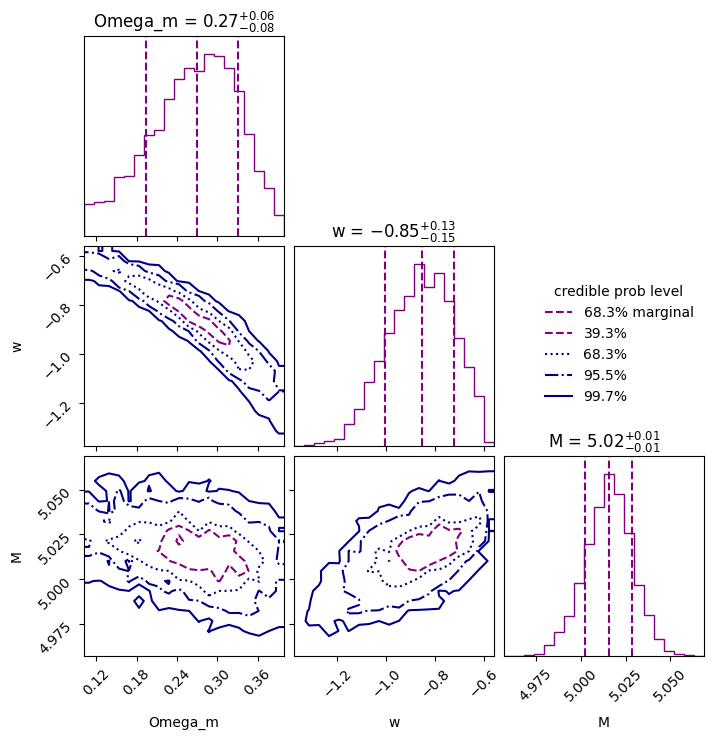

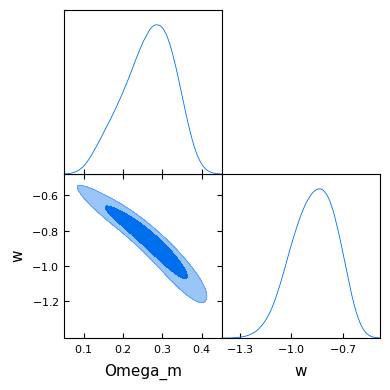

In [27]:
with open(f'{fit_dir}/Flat_wCDM_result.pkl', 'rb') as f:
    Flat_wCDM_result = pickle.load(f)
cornerplot(Flat_wCDM_result);
smooth_plot(Flat_wCDM_result)

#### Flat w0waCDM

In [28]:
Flat_w0waCDM_result = fit_cosmology("Flat_w0waCDM")
with open(f'{fit_dir}/Flat_w0waCDM_result.pkl', 'wb') as f:
    pickle.dump(Flat_w0waCDM_result, f)

DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(np.float64(-inf), np.float64(400.0)), (np.float64(inf), np.float64(400.0))]


DEBUG:ultranest:iteration=0, ncalls=401, regioncalls=40, ndraw=40, logz=-inf, remainder_fraction=100.0000%, Lmin=-19454608482648422224198486191874729469383074907394260920028951578413068752539598276609241467477557248.00, Lmax=-993.35


DEBUG:ultranest:iteration=1, ncalls=402, regioncalls=80, ndraw=40, logz=-19454608482648422224198486191874729469383074907394260920028951578413068752539598276609241467477557248.00, remainder_fraction=100.0000%, Lmin=-18471668612597216913433716787277143192560893485438498725062935746067794482637135439211434250462035968.00, Lmax=-993.35


DEBUG:ultranest:iteration=3, ncalls=404, regioncalls=160, ndraw=40, logz=-17650701447010554522882485521759026598129840997650431501878530312239384332192862830444341064472985600.00, remainder_fraction=100.0000%, Lmin=-17047864518960519474551813461536997812990827148249955468592969674683591974824630518307952147740753920.00, Lmax=-993.35


DEBUG:ultranest:iteration=5, ncalls=406, regioncalls=240, ndraw=40, logz=-16801358362228927833071622887729669978906733762910978145291589798075851180703118734952496273544970240.00, remainder_fraction=100.0000%, Lmin=-16715524418107416571627975576902394620230980677399499896799624921726848822514289136555790623282561024.00, Lmax=-993.35


DEBUG:ultranest:iteration=7, ncalls=408, regioncalls=320, ndraw=40, logz=-15555877878011617774647215025085252507893048309428975325361167913631154913244359165360292250362314752.00, remainder_fraction=100.0000%, Lmin=-14942132189964115044783014866172463235052610014533216565012778477075333788960530237108273299463340032.00, Lmax=-993.35


DEBUG:ultranest:iteration=9, ncalls=410, regioncalls=400, ndraw=40, logz=-14523018431482351968573819232239647970919812038330809783959946409282165429446377618365419711082004480.00, remainder_fraction=100.0000%, Lmin=-14503831727128356237586272731421367739551979736789404026508842967302117283008990779671798383143550976.00, Lmax=-993.35


DEBUG:ultranest:iteration=11, ncalls=412, regioncalls=480, ndraw=40, logz=-14404718724994306242242413563835184924346121744588596864440110939740804895653065798521984774037307392.00, remainder_fraction=100.0000%, Lmin=-14362777507733255353305990708865611022682527024046498849271801744483579761631299775280023153150001152.00, Lmax=-993.35


DEBUG:ultranest:iteration=12, ncalls=413, regioncalls=520, ndraw=40, logz=-14362777507733255353305990708865611022682527024046498849271801744483579761631299775280023153150001152.00, remainder_fraction=100.0000%, Lmin=-14320029827717331426637475098251441285651587760954713951363747042848508840208159151447311154140938240.00, Lmax=-993.35


DEBUG:ultranest:iteration=14, ncalls=415, regioncalls=600, ndraw=40, logz=-14072767198536592806023211194926297607623813292517505284526373544531780535413286906108627918994276352.00, remainder_fraction=100.0000%, Lmin=-13921520255634365072065236337884082555387264407703164943717897615912930681747124302827648866249080832.00, Lmax=-993.35


DEBUG:ultranest:iteration=16, ncalls=417, regioncalls=680, ndraw=40, logz=-13795399570146525283272504620837193464542415921150545951291401496644259147762543408429999244284264448.00, remainder_fraction=100.0000%, Lmin=-13443642830173544346984360643823423798497730702870356127792567925645657256910365861973912615154352128.00, Lmax=-993.35


DEBUG:ultranest:iteration=18, ncalls=419, regioncalls=760, ndraw=40, logz=-12994613942002593279795394177064838282529956449347120912200250153804647722935376150149098655161778176.00, remainder_fraction=100.0000%, Lmin=-12924199730713332439460057492369003579500411328084872105735802694821426519553060194904057421477445632.00, Lmax=-993.35


DEBUG:ultranest:iteration=20, ncalls=421, regioncalls=840, ndraw=40, logz=-12653944594581251221278545510102777562415663712864712456174399242653415139388070697406948669460054016.00, remainder_fraction=100.0000%, Lmin=-12475334262086203694902264230199092987502328915674687446768614221234184612225810621104863007014387712.00, Lmax=-993.35


DEBUG:ultranest:iteration=21, ncalls=422, regioncalls=880, ndraw=40, logz=-12475334262086203694902264230199092987502328915674687446768614221234184612225810621104863007014387712.00, remainder_fraction=100.0000%, Lmin=-12450228888850986460050412110026439129043083104788144586501261906322720555002219557037713700316774400.00, Lmax=-993.35


DEBUG:ultranest:iteration=24, ncalls=425, regioncalls=1000, ndraw=40, logz=-12007888975472781391290778100129180907302703879452910331951702252472051601676468487540622364208267264.00, remainder_fraction=100.0000%, Lmin=-11582690170730312552168013553919822101423886086224923705718290194002195552365220905853581750494560256.00, Lmax=-993.35


DEBUG:ultranest:iteration=26, ncalls=427, regioncalls=1080, ndraw=40, logz=-11428936179762275091723453347644544731704726983783951298527807705489057645454735425798836921569378304.00, remainder_fraction=100.0000%, Lmin=-11289992293510081820100909417136946620345667666056640221912878408763765168724578595793604808947007488.00, Lmax=-993.35


DEBUG:ultranest:iteration=30, ncalls=431, regioncalls=1240, ndraw=40, logz=-10537276116178652830845188899171254719841990221259597272687819673102859489538066533057939473183014912.00, remainder_fraction=100.0000%, Lmin=-10531992078935572476107711251084755420701224307073246533049099115172522416966523612932972522789404672.00, Lmax=-993.35


DEBUG:ultranest:iteration=31, ncalls=432, regioncalls=1280, ndraw=40, logz=-10531992078935572476107711251084755420701224307073246533049099115172522416966523612932972522789404672.00, remainder_fraction=100.0000%, Lmin=-10390485521181166197261388648861086056882228637833394767180724725539952385828367938737903594559766528.00, Lmax=-993.35


DEBUG:ultranest:iteration=34, ncalls=435, regioncalls=1400, ndraw=40, logz=-9898051385370823428474155285233944904876298816852064454899162201522855910697055747613747905782874112.00, remainder_fraction=100.0000%, Lmin=-9703352153257739995998227947730352021318472941113702907791295902764866355507760027593112204588613632.00, Lmax=-993.35


DEBUG:ultranest:iteration=36, ncalls=437, regioncalls=1480, ndraw=40, logz=-9647246398654530857550318008075643403837207898536511382191617644696413569420251942478867927268327424.00, remainder_fraction=100.0000%, Lmin=-9635706548648211867247894653766282029284241182961832885790716903507014418939095807327774448669425664.00, Lmax=-993.35


DEBUG:ultranest:iteration=38, ncalls=440, regioncalls=1600, ndraw=40, logz=-9416801807053843227613020864873783997885989157453935768807479670676050867152847536031748708081074176.00, remainder_fraction=100.0000%, Lmin=-9371488083566422159147275781521613825701057827863124781927183557683909209170862812115196502687612928.00, Lmax=-993.35


DEBUG:ultranest:iteration=40, ncalls=442, regioncalls=1680, ndraw=40, logz=-9348597328327010215078219446643927757970489305092157383590902581965821707582053542829891561900212224.00, remainder_fraction=100.0000%, Lmin=-9230422793278823326263244519304229153950370589171462767580012993951313291362211692984118335120605184.00, Lmax=-993.35


DEBUG:ultranest:iteration=43, ncalls=445, regioncalls=1800, ndraw=40, logz=-8877880004492957101743213819653210975842046021941512871774287777786290371298593433359316856831213568.00, remainder_fraction=100.0000%, Lmin=-8865609194662122801940650541535048187217394510572389025715502648534533531580537652080772977975623680.00, Lmax=-993.35


DEBUG:ultranest:iteration=46, ncalls=449, regioncalls=1960, ndraw=40, logz=-8653156493611376773624284072865830642959844337189659645218263679869398623011005817371178948236410880.00, remainder_fraction=100.0000%, Lmin=-8432020995355305258697306010877667894092280142296339927534095774881501159387985116134055184259088384.00, Lmax=-993.35


DEBUG:ultranest:iteration=48, ncalls=451, regioncalls=2040, ndraw=40, logz=-8391515796533251362173855002458222705015302617892316809237989842171894597552503755226617159964688384.00, remainder_fraction=100.0000%, Lmin=-8058910592474976542516034519316268440507477340545192532919695944542781547174765579515174428342222848.00, Lmax=-993.35


DEBUG:ultranest:iteration=50, ncalls=453, regioncalls=2120, ndraw=40, logz=-8010190874293133436378166047368952651499959063767385771278307331533717329711096998300013938452987904.00, remainder_fraction=100.0000%, Lmin=-7918451056109073463514587028763634617261376739598360421885215889292129663668309075191347154060836864.00, Lmax=-993.35


DEBUG:ultranest:iteration=52, ncalls=455, regioncalls=2200, ndraw=40, logz=-7811907446737844822410137845945250126254549062671847538116672633741848982194087629120271364084727808.00, remainder_fraction=100.0000%, Lmin=-7648734053732638342261186734304083327022387280574487290558925824932171179594234911630708436776255488.00, Lmax=-993.35


DEBUG:ultranest:iteration=54, ncalls=459, regioncalls=2360, ndraw=40, logz=-7463229750195700560270791364548287877189321708851299399694521063100485663649903745050878716617424896.00, remainder_fraction=100.0000%, Lmin=-7405682362961833100840371058186250850678290852193938289251991892289761579581710530869871299889463296.00, Lmax=-993.35


DEBUG:ultranest:iteration=56, ncalls=462, regioncalls=2480, ndraw=40, logz=-7318901042741878038073848514109190893824601244875486781795403744439587586935200536268084758005678080.00, remainder_fraction=100.0000%, Lmin=-7290727226025082907325444710392102581720048637399797878650161710347007010590348490866565001666101248.00, Lmax=-993.35


DEBUG:ultranest:iteration=59, ncalls=465, regioncalls=2600, ndraw=40, logz=-7066405372726101605596184340231660666976282809608051906445659703239703858068337156518842768964976640.00, remainder_fraction=100.0000%, Lmin=-6865203003176197484523015571326845083665135338651578589616324594918315926039905654368830964612726784.00, Lmax=-993.35


DEBUG:ultranest:iteration=60, ncalls=467, regioncalls=2680, ndraw=40, logz=-6865203003176197484523015571326845083665135338651578589616324594918315926039905654368830964612726784.00, remainder_fraction=100.0000%, Lmin=-6622775585181919274646164706900134154236435032831485292631393140340672306508939408292110676564901888.00, Lmax=-993.35


DEBUG:ultranest:iteration=62, ncalls=469, regioncalls=2760, ndraw=40, logz=-6499324821333349639429884140518971798035464037994111215306137456955199303770043615474185219531079680.00, remainder_fraction=100.0000%, Lmin=-6352589122768953558858216678044431577803602734887805139256214740048757659681426316101750176822067200.00, Lmax=-993.35


DEBUG:ultranest:iteration=65, ncalls=472, regioncalls=2880, ndraw=40, logz=-5732826116479905708311868507310570222523163998677219233369894895743473865820367200841942512963682304.00, remainder_fraction=100.0000%, Lmin=-5680675851503934369469866783448509930532962026581251623674290166037888662439671774367856812198199296.00, Lmax=-993.35


DEBUG:ultranest:iteration=67, ncalls=475, regioncalls=3000, ndraw=40, logz=-5405294566667755415711218794681627070154631763954456226665633294942543493589281709313590268608380928.00, remainder_fraction=100.0000%, Lmin=-5404157517596061615151952385150043891281921304446665573269358539379723048442602255276755849268166656.00, Lmax=-993.35


DEBUG:ultranest:iteration=69, ncalls=477, regioncalls=3080, ndraw=40, logz=-5284499350887887946249443464885153955891721793242144046876616017271406942420605245712147429334188032.00, remainder_fraction=100.0000%, Lmin=-5067219038463483998421534532317562087257842803145050249515686920241318918089223369964958636281167872.00, Lmax=-993.35


DEBUG:ultranest:iteration=71, ncalls=479, regioncalls=3160, ndraw=40, logz=-4830890863634433711907293371121675972838543998692091918001460988774534146956381784164651402363142144.00, remainder_fraction=100.0000%, Lmin=-4675703917525829812322343580882340211578175398556296437182637336580732511261186000437430174191976448.00, Lmax=-993.35


DEBUG:ultranest:iteration=74, ncalls=483, regioncalls=3320, ndraw=40, logz=-4312681759108602703581488290218919590829027919496339503331245299915371865673067015284248799805964288.00, remainder_fraction=100.0000%, Lmin=-4087399144970147511287521357141203901645096523421200069313602214477045947996395132066785484429328384.00, Lmax=-993.35


DEBUG:ultranest:iteration=75, ncalls=485, regioncalls=3400, ndraw=40, logz=-4087399144970147511287521357141203901645096523421200069313602214477045947996395132066785484429328384.00, remainder_fraction=100.0000%, Lmin=-4001364891199333412429509763795264877339925270423148800662157532757147586488146618197774904116379648.00, Lmax=-993.35


DEBUG:ultranest:iteration=77, ncalls=487, regioncalls=3480, ndraw=40, logz=-3932209799911488100779758100959402087335682536566326009623969447754572189667176044750454831336914944.00, remainder_fraction=100.0000%, Lmin=-3916756221182575646398641709275069347082205996371821492843893005266818191993234325822664684062375936.00, Lmax=-993.35


DEBUG:ultranest:iteration=79, ncalls=489, regioncalls=3560, ndraw=40, logz=-3902695372602476523149971127856516328161344618743877100010842504340270086236940238071543087314763776.00, remainder_fraction=100.0000%, Lmin=-3837721527867642928704209682109865881447916785055284283739491939133354138237269003594119838884167680.00, Lmax=-993.35


DEBUG:ultranest:iteration=80, ncalls=490, regioncalls=3600, ndraw=40, logz=-3837721527867642928704209682109865881447916785055284283739491939133354138237269003594119838884167680.00, remainder_fraction=100.0000%, Lmin=-3815786128913330501494866060350030370450367583860202456845313697981858374612666345688989797032394752.00, Lmax=-993.35


DEBUG:ultranest:iteration=83, ncalls=493, regioncalls=3720, ndraw=40, logz=-3563444920628441604201453486485984280433708539333317992143758863598280781753027425421587496977825792.00, remainder_fraction=100.0000%, Lmin=-3528402265416541550606451714455129049019167095965827675004202089076126725695523868214448945467752448.00, Lmax=-993.35


DEBUG:ultranest:iteration=85, ncalls=495, regioncalls=3800, ndraw=40, logz=-3457383330669284061535772326941417520777426324222075788771418295089455271518788384236559808730234880.00, remainder_fraction=100.0000%, Lmin=-3332371374356550949278304473907600264911713947427580204840748088468557120514784658526787165048799232.00, Lmax=-993.35


DEBUG:ultranest:iteration=87, ncalls=497, regioncalls=3880, ndraw=40, logz=-3006751809915540452109528255680142080025427475223748656441403406785445575129842996749681061334614016.00, remainder_fraction=100.0000%, Lmin=-3000446932169211243457446639204526138160482288951961797858780011610107822108124650251266734581350400.00, Lmax=-993.35


DEBUG:ultranest:iteration=90, ncalls=500, regioncalls=4000, ndraw=40, logz=-2761092751605549108230628140931020662556000918870845581972650691716941945074117248526087507108954112.00, remainder_fraction=100.0000%, Lmin=-2503581151845210394989291383105915704794850854493482594006679864263848438936126293548371778927067136.00, Lmax=-993.35


DEBUG:ultranest:iteration=92, ncalls=503, regioncalls=4120, ndraw=40, logz=-2376439998383240498513354018786210421586682029513212991796394944570173213913054145020502351758229504.00, remainder_fraction=100.0000%, Lmin=-2204683144352278665319779036417061671667120309680365346734361608378749623298497703174249549928595456.00, Lmax=-993.35


DEBUG:ultranest:iteration=95, ncalls=506, regioncalls=4240, ndraw=40, logz=-2066431205542459097384056902923604392507673237415882775364779063862565229748470825919898541994541056.00, remainder_fraction=100.0000%, Lmin=-2016500871553528631860158842496546107922045934427041888099943054366987679875414856927097453698613248.00, Lmax=-993.35


DEBUG:ultranest:iteration=96, ncalls=507, regioncalls=4280, ndraw=40, logz=-2016500871553528631860158842496546107922045934427041888099943054366987679875414856927097453698613248.00, remainder_fraction=100.0000%, Lmin=-1761540763552268483844050885334621971252852666230697089182044811002356309928325086158557279669977088.00, Lmax=-993.35


DEBUG:ultranest:iteration=97, ncalls=508, regioncalls=4320, ndraw=40, logz=-1761540763552268483844050885334621971252852666230697089182044811002356309928325086158557279669977088.00, remainder_fraction=100.0000%, Lmin=-1569706917566142263819224471996724473561439716843572602031785132045099813623040224899843693769392128.00, Lmax=-993.35


DEBUG:ultranest:iteration=99, ncalls=510, regioncalls=4400, ndraw=40, logz=-1434930318577467859659025901558932132313715518045100321097731080881829114303516365631947784788639744.00, remainder_fraction=100.0000%, Lmin=-1386816864610601222590702054390665410657699725370172492398649977201892455744408676022893764505763840.00, Lmax=-993.35


DEBUG:ultranest:iteration=101, ncalls=512, regioncalls=4480, ndraw=40, logz=-1315780989573877198043318160072146426611216086154987191836890248763194477602873084302086617132171264.00, remainder_fraction=100.0000%, Lmin=-1253410047470836630109187039754341516995427395423836198560722114431852383871853720612959287959879680.00, Lmax=-993.35


DEBUG:ultranest:iteration=104, ncalls=515, regioncalls=4600, ndraw=40, logz=-1074107625387348715512381275993134612616165017889791556550989102899605788186579996755948096509181952.00, remainder_fraction=100.0000%, Lmin=-1071938025607366256036456741401684521294625653783341739263127074302854825294753001933221199112830976.00, Lmax=-993.35


DEBUG:ultranest:iteration=106, ncalls=517, regioncalls=4680, ndraw=40, logz=-1011991173042790821725882680742329885766844348232236331536971254390749055721210832200696596847919104.00, remainder_fraction=100.0000%, Lmin=-16896613.99, Lmax=-993.35


DEBUG:ultranest:iteration=108, ncalls=520, regioncalls=4800, ndraw=40, logz=-16361003.96, remainder_fraction=100.0000%, Lmin=-16126792.76, Lmax=-993.35


DEBUG:ultranest:iteration=109, ncalls=522, regioncalls=4880, ndraw=40, logz=-16126799.03, remainder_fraction=100.0000%, Lmin=-14817064.26, Lmax=-993.35


DEBUG:ultranest:iteration=112, ncalls=525, regioncalls=5000, ndraw=40, logz=-14052305.99, remainder_fraction=100.0000%, Lmin=-13172999.11, Lmax=-993.35


DEBUG:ultranest:iteration=114, ncalls=527, regioncalls=5080, ndraw=40, logz=-13115669.03, remainder_fraction=100.0000%, Lmin=-13023346.26, Lmax=-993.35


DEBUG:ultranest:iteration=116, ncalls=529, regioncalls=5160, ndraw=40, logz=-12988757.40, remainder_fraction=100.0000%, Lmin=-12951228.76, Lmax=-993.35


DEBUG:ultranest:iteration=118, ncalls=531, regioncalls=5240, ndraw=40, logz=-12931449.70, remainder_fraction=100.0000%, Lmin=-12878861.14, Lmax=-993.35


DEBUG:ultranest:iteration=120, ncalls=533, regioncalls=5320, ndraw=40, logz=-12866469.61, remainder_fraction=100.0000%, Lmin=-12816106.09, Lmax=-993.35


DEBUG:ultranest:iteration=122, ncalls=535, regioncalls=5400, ndraw=40, logz=-12807597.35, remainder_fraction=100.0000%, Lmin=-12754343.58, Lmax=-993.35


DEBUG:ultranest:iteration=124, ncalls=538, regioncalls=5520, ndraw=40, logz=-12613495.26, remainder_fraction=100.0000%, Lmin=-12572417.36, Lmax=-993.35


DEBUG:ultranest:iteration=126, ncalls=540, regioncalls=5600, ndraw=40, logz=-12556050.06, remainder_fraction=100.0000%, Lmin=-12525798.71, Lmax=-993.35


DEBUG:ultranest:iteration=128, ncalls=542, regioncalls=5680, ndraw=40, logz=-12516989.54, remainder_fraction=100.0000%, Lmin=-12140913.27, Lmax=-993.35


DEBUG:ultranest:iteration=130, ncalls=545, regioncalls=5800, ndraw=40, logz=-12069908.11, remainder_fraction=100.0000%, Lmin=-11973733.23, Lmax=-993.35


DEBUG:ultranest:iteration=132, ncalls=547, regioncalls=5880, ndraw=40, logz=-11867321.73, remainder_fraction=100.0000%, Lmin=-11846075.43, Lmax=-993.35


DEBUG:ultranest:iteration=133, ncalls=549, regioncalls=5960, ndraw=40, logz=-11846081.75, remainder_fraction=100.0000%, Lmin=-11720061.59, Lmax=-993.35


DEBUG:ultranest:iteration=135, ncalls=551, regioncalls=6040, ndraw=40, logz=-11589176.88, remainder_fraction=100.0000%, Lmin=-11548254.54, Lmax=-993.35


DEBUG:ultranest:iteration=137, ncalls=553, regioncalls=6120, ndraw=40, logz=-11108059.19, remainder_fraction=100.0000%, Lmin=-11056774.01, Lmax=-993.35


DEBUG:ultranest:iteration=139, ncalls=555, regioncalls=6200, ndraw=40, logz=-10945466.87, remainder_fraction=100.0000%, Lmin=-10944085.45, Lmax=-993.35


DEBUG:ultranest:iteration=141, ncalls=558, regioncalls=6320, ndraw=40, logz=-10918030.65, remainder_fraction=100.0000%, Lmin=-10845017.03, Lmax=-993.35


DEBUG:ultranest:iteration=144, ncalls=562, regioncalls=6480, ndraw=40, logz=-10730188.74, remainder_fraction=100.0000%, Lmin=-10690453.21, Lmax=-993.35


DEBUG:ultranest:iteration=146, ncalls=565, regioncalls=6600, ndraw=40, logz=-10596175.55, remainder_fraction=100.0000%, Lmin=-10522854.05, Lmax=-993.35


DEBUG:ultranest:iteration=148, ncalls=568, regioncalls=6720, ndraw=40, logz=-10475559.39, remainder_fraction=100.0000%, Lmin=-10475094.03, Lmax=-993.35


DEBUG:ultranest:iteration=150, ncalls=570, regioncalls=6800, ndraw=40, logz=-10464174.06, remainder_fraction=100.0000%, Lmin=-10432170.88, Lmax=-993.35


DEBUG:ultranest:iteration=153, ncalls=573, regioncalls=6920, ndraw=40, logz=-10360921.91, remainder_fraction=100.0000%, Lmin=-10262344.69, Lmax=-993.35


DEBUG:ultranest:iteration=156, ncalls=576, regioncalls=7040, ndraw=40, logz=-10181009.89, remainder_fraction=100.0000%, Lmin=-10160545.21, Lmax=-993.35


DEBUG:ultranest:iteration=157, ncalls=577, regioncalls=7080, ndraw=40, logz=-10160551.60, remainder_fraction=100.0000%, Lmin=-10069784.63, Lmax=-993.35


DEBUG:ultranest:iteration=160, ncalls=580, regioncalls=7200, ndraw=40, logz=-9915259.44, remainder_fraction=100.0000%, Lmin=-9914693.41, Lmax=-993.35


DEBUG:ultranest:iteration=162, ncalls=583, regioncalls=7320, ndraw=40, logz=-9874084.10, remainder_fraction=100.0000%, Lmin=-9837369.79, Lmax=-993.35


DEBUG:ultranest:iteration=164, ncalls=585, regioncalls=7400, ndraw=40, logz=-9769832.49, remainder_fraction=100.0000%, Lmin=-9500680.43, Lmax=-993.35


DEBUG:ultranest:iteration=166, ncalls=590, regioncalls=7600, ndraw=40, logz=-9492819.54, remainder_fraction=100.0000%, Lmin=-9424408.69, Lmax=-993.35


DEBUG:ultranest:iteration=167, ncalls=591, regioncalls=7640, ndraw=40, logz=-9424415.09, remainder_fraction=100.0000%, Lmin=-9395928.89, Lmax=-993.35


DEBUG:ultranest:iteration=168, ncalls=594, regioncalls=7760, ndraw=40, logz=-9395935.30, remainder_fraction=100.0000%, Lmin=-9309053.71, Lmax=-993.35


DEBUG:ultranest:iteration=169, ncalls=595, regioncalls=7800, ndraw=40, logz=-9309060.13, remainder_fraction=100.0000%, Lmin=-9186438.54, Lmax=-993.35


DEBUG:ultranest:iteration=172, ncalls=598, regioncalls=7920, ndraw=40, logz=-9107328.22, remainder_fraction=100.0000%, Lmin=-9070307.45, Lmax=-993.35


DEBUG:ultranest:iteration=174, ncalls=601, regioncalls=8040, ndraw=40, logz=-9013356.42, remainder_fraction=100.0000%, Lmin=-8946036.29, Lmax=-993.35


DEBUG:ultranest:iteration=176, ncalls=603, regioncalls=8120, ndraw=40, logz=-8937350.17, remainder_fraction=100.0000%, Lmin=-8670440.50, Lmax=-993.35


DEBUG:ultranest:iteration=179, ncalls=606, regioncalls=8240, ndraw=40, logz=-8418190.19, remainder_fraction=100.0000%, Lmin=-8187515.38, Lmax=-993.35


DEBUG:ultranest:iteration=181, ncalls=609, regioncalls=8360, ndraw=40, logz=-8149016.25, remainder_fraction=100.0000%, Lmin=-8069000.17, Lmax=-993.35


DEBUG:ultranest:iteration=184, ncalls=612, regioncalls=8480, ndraw=40, logz=-7957772.08, remainder_fraction=100.0000%, Lmin=-7767834.62, Lmax=-993.35


DEBUG:ultranest:iteration=186, ncalls=614, regioncalls=8560, ndraw=40, logz=-7712139.61, remainder_fraction=100.0000%, Lmin=-7702478.23, Lmax=-993.35


DEBUG:ultranest:iteration=188, ncalls=618, regioncalls=8720, ndraw=40, logz=-7690945.68, remainder_fraction=100.0000%, Lmin=-7642132.48, Lmax=-993.35


DEBUG:ultranest:iteration=189, ncalls=621, regioncalls=8840, ndraw=40, logz=-7642138.94, remainder_fraction=100.0000%, Lmin=-7641340.16, Lmax=-993.35


DEBUG:ultranest:iteration=190, ncalls=624, regioncalls=8960, ndraw=40, logz=-7641346.63, remainder_fraction=100.0000%, Lmin=-7612083.52, Lmax=-993.35


DEBUG:ultranest:iteration=192, ncalls=627, regioncalls=9080, ndraw=40, logz=-7587623.81, remainder_fraction=100.0000%, Lmin=-7414525.27, Lmax=-993.35


DEBUG:ultranest:iteration=194, ncalls=629, regioncalls=9160, ndraw=40, logz=-7396303.35, remainder_fraction=100.0000%, Lmin=-7389781.37, Lmax=-993.35


DEBUG:ultranest:iteration=196, ncalls=632, regioncalls=9280, ndraw=40, logz=-7344026.66, remainder_fraction=100.0000%, Lmin=-7290022.88, Lmax=-993.35


DEBUG:ultranest:iteration=197, ncalls=634, regioncalls=9360, ndraw=40, logz=-7290029.36, remainder_fraction=100.0000%, Lmin=-7252941.36, Lmax=-993.35


DEBUG:ultranest:iteration=199, ncalls=637, regioncalls=9480, ndraw=40, logz=-7182520.42, remainder_fraction=100.0000%, Lmin=-7167083.15, Lmax=-993.35


DEBUG:ultranest:iteration=200, ncalls=638, regioncalls=9520, ndraw=40, logz=-7167089.64, remainder_fraction=100.0000%, Lmin=-7040567.54, Lmax=-993.35


DEBUG:ultranest:iteration=202, ncalls=641, regioncalls=9640, ndraw=40, logz=-7013756.80, remainder_fraction=100.0000%, Lmin=-6990052.61, Lmax=-993.35


DEBUG:ultranest:iteration=203, ncalls=642, regioncalls=9680, ndraw=40, logz=-6990059.11, remainder_fraction=100.0000%, Lmin=-6956232.34, Lmax=-993.35


DEBUG:ultranest:iteration=205, ncalls=645, regioncalls=9800, ndraw=40, logz=-6806544.60, remainder_fraction=100.0000%, Lmin=-6771992.53, Lmax=-993.35


DEBUG:ultranest:iteration=206, ncalls=647, regioncalls=9880, ndraw=40, logz=-6771999.04, remainder_fraction=100.0000%, Lmin=-6688070.99, Lmax=-993.35


DEBUG:ultranest:iteration=207, ncalls=651, regioncalls=10040, ndraw=40, logz=-6688077.50, remainder_fraction=100.0000%, Lmin=-6675807.99, Lmax=-993.35


DEBUG:ultranest:iteration=209, ncalls=656, regioncalls=10240, ndraw=40, logz=-6639034.64, remainder_fraction=100.0000%, Lmin=-6623558.25, Lmax=-993.35


DEBUG:ultranest:iteration=210, ncalls=657, regioncalls=10280, ndraw=40, logz=-6623564.76, remainder_fraction=100.0000%, Lmin=-6475058.00, Lmax=-993.35


DEBUG:ultranest:iteration=213, ncalls=661, regioncalls=10440, ndraw=40, logz=-6426499.12, remainder_fraction=100.0000%, Lmin=-6419273.77, Lmax=-993.35


DEBUG:ultranest:iteration=215, ncalls=664, regioncalls=10560, ndraw=40, logz=-6410638.07, remainder_fraction=100.0000%, Lmin=-6409856.12, Lmax=-993.35


DEBUG:ultranest:iteration=218, ncalls=667, regioncalls=10680, ndraw=40, logz=-6363821.61, remainder_fraction=100.0000%, Lmin=-6359351.76, Lmax=-993.35


DEBUG:ultranest:iteration=220, ncalls=669, regioncalls=10760, ndraw=40, logz=-6304354.94, remainder_fraction=100.0000%, Lmin=-6286691.53, Lmax=-993.35


DEBUG:ultranest:iteration=223, ncalls=673, regioncalls=10920, ndraw=40, logz=-6206299.63, remainder_fraction=100.0000%, Lmin=-6199961.41, Lmax=-993.35


DEBUG:ultranest:iteration=224, ncalls=674, regioncalls=10960, ndraw=40, logz=-6199967.96, remainder_fraction=100.0000%, Lmin=-6102898.65, Lmax=-993.35


DEBUG:ultranest:iteration=226, ncalls=677, regioncalls=11080, ndraw=40, logz=-6082534.40, remainder_fraction=100.0000%, Lmin=-6070553.13, Lmax=-993.35


DEBUG:ultranest:iteration=228, ncalls=680, regioncalls=11200, ndraw=40, logz=-6064009.75, remainder_fraction=100.0000%, Lmin=-6032409.31, Lmax=-993.35


DEBUG:ultranest:iteration=231, ncalls=685, regioncalls=11400, ndraw=40, logz=-5992648.79, remainder_fraction=100.0000%, Lmin=-5988723.02, Lmax=-993.35


DEBUG:ultranest:iteration=233, ncalls=687, regioncalls=11480, ndraw=40, logz=-5977412.09, remainder_fraction=100.0000%, Lmin=-5925332.83, Lmax=-993.35


DEBUG:ultranest:iteration=235, ncalls=689, regioncalls=11560, ndraw=40, logz=-5920295.86, remainder_fraction=100.0000%, Lmin=-5851437.33, Lmax=-993.35


DEBUG:ultranest:iteration=237, ncalls=691, regioncalls=11640, ndraw=40, logz=-5814961.54, remainder_fraction=100.0000%, Lmin=-5797653.56, Lmax=-993.35


DEBUG:ultranest:iteration=239, ncalls=695, regioncalls=11800, ndraw=40, logz=-5736983.74, remainder_fraction=100.0000%, Lmin=-5650149.81, Lmax=-993.35


DEBUG:ultranest:iteration=240, ncalls=696, regioncalls=11840, ndraw=40, logz=-5650156.40, remainder_fraction=100.0000%, Lmin=-5636959.82, Lmax=-993.35


DEBUG:ultranest:iteration=241, ncalls=698, regioncalls=11920, ndraw=40, logz=-5636966.42, remainder_fraction=100.0000%, Lmin=-5581421.44, Lmax=-993.35


DEBUG:ultranest:iteration=242, ncalls=701, regioncalls=12040, ndraw=40, logz=-5581428.03, remainder_fraction=100.0000%, Lmin=-5576160.61, Lmax=-993.35


DEBUG:ultranest:iteration=244, ncalls=705, regioncalls=12200, ndraw=40, logz=-5526985.67, remainder_fraction=100.0000%, Lmin=-5517697.49, Lmax=-993.35


DEBUG:ultranest:iteration=246, ncalls=710, regioncalls=12400, ndraw=40, logz=-5493537.28, remainder_fraction=100.0000%, Lmin=-5489763.20, Lmax=-993.35


DEBUG:ultranest:iteration=247, ncalls=715, regioncalls=12600, ndraw=40, logz=-5489769.80, remainder_fraction=100.0000%, Lmin=-5482172.78, Lmax=-993.35


DEBUG:ultranest:iteration=249, ncalls=718, regioncalls=12720, ndraw=40, logz=-5419173.35, remainder_fraction=100.0000%, Lmin=-5367565.72, Lmax=-993.35


DEBUG:ultranest:iteration=251, ncalls=720, regioncalls=12800, ndraw=40, logz=-5365300.75, remainder_fraction=100.0000%, Lmin=-5344856.75, Lmax=-993.35


DEBUG:ultranest:iteration=253, ncalls=723, regioncalls=12920, ndraw=40, logz=-5334056.96, remainder_fraction=100.0000%, Lmin=-5331251.26, Lmax=-993.35


DEBUG:ultranest:iteration=255, ncalls=725, regioncalls=13000, ndraw=40, logz=-5281158.18, remainder_fraction=100.0000%, Lmin=-5233836.16, Lmax=-993.35


DEBUG:ultranest:iteration=256, ncalls=728, regioncalls=13120, ndraw=40, logz=-5233842.79, remainder_fraction=100.0000%, Lmin=-5229731.53, Lmax=-993.35


DEBUG:ultranest:iteration=258, ncalls=730, regioncalls=13200, ndraw=40, logz=-5225210.96, remainder_fraction=100.0000%, Lmin=-5173313.63, Lmax=-993.35


DEBUG:ultranest:iteration=261, ncalls=733, regioncalls=13320, ndraw=40, logz=-5137620.62, remainder_fraction=100.0000%, Lmin=-5128493.06, Lmax=-993.35


DEBUG:ultranest:iteration=262, ncalls=734, regioncalls=13360, ndraw=40, logz=-5128499.70, remainder_fraction=100.0000%, Lmin=-5120996.92, Lmax=-993.35


DEBUG:ultranest:iteration=264, ncalls=737, regioncalls=13480, ndraw=40, logz=-5057695.55, remainder_fraction=100.0000%, Lmin=-5051241.91, Lmax=-993.35


DEBUG:ultranest:iteration=265, ncalls=744, regioncalls=13760, ndraw=40, logz=-5051248.56, remainder_fraction=100.0000%, Lmin=-5041218.60, Lmax=-993.35


DEBUG:ultranest:iteration=266, ncalls=749, regioncalls=13960, ndraw=40, logz=-5041225.25, remainder_fraction=100.0000%, Lmin=-4979064.24, Lmax=-993.35


DEBUG:ultranest:iteration=267, ncalls=751, regioncalls=14040, ndraw=40, logz=-4979070.90, remainder_fraction=100.0000%, Lmin=-4973638.75, Lmax=-993.35


DEBUG:ultranest:iteration=268, ncalls=753, regioncalls=14120, ndraw=40, logz=-4973645.41, remainder_fraction=100.0000%, Lmin=-4971861.23, Lmax=-993.35


DEBUG:ultranest:iteration=270, ncalls=756, regioncalls=14240, ndraw=40, logz=-4958194.86, remainder_fraction=100.0000%, Lmin=-4915945.07, Lmax=-993.35


DEBUG:ultranest:iteration=271, ncalls=758, regioncalls=14320, ndraw=40, logz=-4915951.74, remainder_fraction=100.0000%, Lmin=-4915602.39, Lmax=-993.35


DEBUG:ultranest:iteration=272, ncalls=760, regioncalls=14400, ndraw=40, logz=-4915609.06, remainder_fraction=100.0000%, Lmin=-4904341.22, Lmax=-993.35


DEBUG:ultranest:iteration=274, ncalls=762, regioncalls=14480, ndraw=40, logz=-4884457.49, remainder_fraction=100.0000%, Lmin=-4882649.01, Lmax=-993.35


DEBUG:ultranest:iteration=275, ncalls=765, regioncalls=14600, ndraw=40, logz=-4882655.69, remainder_fraction=100.0000%, Lmin=-4805300.90, Lmax=-993.35


DEBUG:ultranest:iteration=276, ncalls=766, regioncalls=14640, ndraw=40, logz=-4805307.58, remainder_fraction=100.0000%, Lmin=-4785441.43, Lmax=-993.35


DEBUG:ultranest:iteration=278, ncalls=770, regioncalls=14800, ndraw=40, logz=-4776160.24, remainder_fraction=100.0000%, Lmin=-4758444.51, Lmax=-993.35


DEBUG:ultranest:iteration=279, ncalls=773, regioncalls=14920, ndraw=40, logz=-4758451.20, remainder_fraction=100.0000%, Lmin=-4738835.44, Lmax=-993.35


DEBUG:ultranest:iteration=280, ncalls=778, regioncalls=15120, ndraw=40, logz=-4738842.13, remainder_fraction=100.0000%, Lmin=-4726791.24, Lmax=-993.35


DEBUG:ultranest:iteration=282, ncalls=781, regioncalls=15240, ndraw=40, logz=-4695769.67, remainder_fraction=100.0000%, Lmin=-4676954.28, Lmax=-993.35


DEBUG:ultranest:iteration=285, ncalls=784, regioncalls=15360, ndraw=40, logz=-4634112.35, remainder_fraction=100.0000%, Lmin=-4557168.55, Lmax=-993.35


DEBUG:ultranest:iteration=286, ncalls=789, regioncalls=15560, ndraw=40, logz=-4557175.26, remainder_fraction=100.0000%, Lmin=-4528777.45, Lmax=-993.35


DEBUG:ultranest:iteration=287, ncalls=791, regioncalls=15640, ndraw=40, logz=-4528784.16, remainder_fraction=100.0000%, Lmin=-4507314.49, Lmax=-993.35


DEBUG:ultranest:iteration=288, ncalls=794, regioncalls=15760, ndraw=40, logz=-4507321.20, remainder_fraction=100.0000%, Lmin=-4480983.03, Lmax=-993.35


DEBUG:ultranest:iteration=290, ncalls=797, regioncalls=15880, ndraw=40, logz=-4473238.59, remainder_fraction=100.0000%, Lmin=-4444891.45, Lmax=-993.35


DEBUG:ultranest:iteration=292, ncalls=800, regioncalls=16000, ndraw=40, logz=-4425639.39, remainder_fraction=100.0000%, Lmin=-4409514.43, Lmax=-993.35


DEBUG:ultranest:iteration=294, ncalls=802, regioncalls=16080, ndraw=40, logz=-4394847.46, remainder_fraction=100.0000%, Lmin=-4391788.19, Lmax=-993.35


DEBUG:ultranest:iteration=295, ncalls=803, regioncalls=16120, ndraw=40, logz=-4391794.92, remainder_fraction=100.0000%, Lmin=-4365393.72, Lmax=-993.35


DEBUG:ultranest:iteration=297, ncalls=806, regioncalls=16240, ndraw=40, logz=-4334167.52, remainder_fraction=100.0000%, Lmin=-4317358.09, Lmax=-993.35


DEBUG:ultranest:iteration=298, ncalls=808, regioncalls=16320, ndraw=40, logz=-4317364.83, remainder_fraction=100.0000%, Lmin=-4300727.05, Lmax=-993.35


DEBUG:ultranest:iteration=299, ncalls=810, regioncalls=16400, ndraw=40, logz=-4300733.79, remainder_fraction=100.0000%, Lmin=-4298140.67, Lmax=-993.35


DEBUG:ultranest:iteration=300, ncalls=815, regioncalls=16600, ndraw=40, logz=-4298147.41, remainder_fraction=100.0000%, Lmin=-4257775.57, Lmax=-993.35


DEBUG:ultranest:iteration=302, ncalls=817, regioncalls=16680, ndraw=40, logz=-4128242.65, remainder_fraction=100.0000%, Lmin=-4119339.96, Lmax=-993.35


DEBUG:ultranest:iteration=303, ncalls=819, regioncalls=16760, ndraw=40, logz=-4119346.71, remainder_fraction=100.0000%, Lmin=-4103608.98, Lmax=-993.35


DEBUG:ultranest:iteration=305, ncalls=823, regioncalls=16920, ndraw=40, logz=-4060561.70, remainder_fraction=100.0000%, Lmin=-4056596.43, Lmax=-993.35


DEBUG:ultranest:iteration=307, ncalls=826, regioncalls=17040, ndraw=40, logz=-4027225.75, remainder_fraction=100.0000%, Lmin=-4011364.87, Lmax=-993.35


DEBUG:ultranest:iteration=308, ncalls=830, regioncalls=17200, ndraw=40, logz=-4011371.63, remainder_fraction=100.0000%, Lmin=-3955375.59, Lmax=-993.35


DEBUG:ultranest:iteration=310, ncalls=832, regioncalls=17280, ndraw=40, logz=-3924551.88, remainder_fraction=100.0000%, Lmin=-3922809.49, Lmax=-993.35


DEBUG:ultranest:iteration=314, ncalls=838, regioncalls=17520, ndraw=40, logz=-3900553.99, remainder_fraction=100.0000%, Lmin=-3894607.93, Lmax=-993.35


DEBUG:ultranest:iteration=315, ncalls=839, regioncalls=17560, ndraw=40, logz=-3894614.70, remainder_fraction=100.0000%, Lmin=-3880349.06, Lmax=-993.35


DEBUG:ultranest:iteration=317, ncalls=842, regioncalls=17680, ndraw=40, logz=-3874267.68, remainder_fraction=100.0000%, Lmin=-3842063.10, Lmax=-993.35


DEBUG:ultranest:iteration=318, ncalls=844, regioncalls=17760, ndraw=40, logz=-3842069.89, remainder_fraction=100.0000%, Lmin=-3840867.09, Lmax=-993.35


DEBUG:ultranest:iteration=320, ncalls=847, regioncalls=17880, ndraw=40, logz=-3815641.52, remainder_fraction=100.0000%, Lmin=-3803842.52, Lmax=-993.35


DEBUG:ultranest:iteration=322, ncalls=850, regioncalls=18000, ndraw=40, logz=-3798375.03, remainder_fraction=100.0000%, Lmin=-3793074.74, Lmax=-993.35


DEBUG:ultranest:iteration=323, ncalls=852, regioncalls=18080, ndraw=40, logz=-3793081.53, remainder_fraction=100.0000%, Lmin=-3778400.93, Lmax=-993.35


DEBUG:ultranest:iteration=325, ncalls=855, regioncalls=18200, ndraw=40, logz=-3765536.21, remainder_fraction=100.0000%, Lmin=-3718223.17, Lmax=-993.35


DEBUG:ultranest:iteration=326, ncalls=856, regioncalls=18240, ndraw=40, logz=-3718229.98, remainder_fraction=100.0000%, Lmin=-3666576.81, Lmax=-993.35


DEBUG:ultranest:iteration=328, ncalls=858, regioncalls=18320, ndraw=40, logz=-3637496.16, remainder_fraction=100.0000%, Lmin=-3628905.05, Lmax=-993.35


DEBUG:ultranest:iteration=330, ncalls=861, regioncalls=18440, ndraw=40, logz=-3600245.76, remainder_fraction=100.0000%, Lmin=-3596278.57, Lmax=-993.35


DEBUG:ultranest:iteration=332, ncalls=868, regioncalls=18720, ndraw=40, logz=-3585307.13, remainder_fraction=100.0000%, Lmin=-3580159.11, Lmax=-993.35


DEBUG:ultranest:iteration=334, ncalls=871, regioncalls=18840, ndraw=40, logz=-3562668.98, remainder_fraction=100.0000%, Lmin=-3560714.81, Lmax=-993.35


DEBUG:ultranest:iteration=336, ncalls=874, regioncalls=18960, ndraw=40, logz=-3552032.19, remainder_fraction=100.0000%, Lmin=-3545600.04, Lmax=-993.35


DEBUG:ultranest:iteration=337, ncalls=875, regioncalls=19000, ndraw=40, logz=-3545606.87, remainder_fraction=100.0000%, Lmin=-3465319.05, Lmax=-993.35


DEBUG:ultranest:iteration=338, ncalls=879, regioncalls=19160, ndraw=40, logz=-3465325.89, remainder_fraction=100.0000%, Lmin=-3400654.09, Lmax=-993.35


DEBUG:ultranest:iteration=339, ncalls=881, regioncalls=19240, ndraw=40, logz=-3400660.93, remainder_fraction=100.0000%, Lmin=-3399565.45, Lmax=-993.35


DEBUG:ultranest:iteration=340, ncalls=883, regioncalls=19320, ndraw=40, logz=-3399572.29, remainder_fraction=100.0000%, Lmin=-3378868.20, Lmax=-993.35


DEBUG:ultranest:iteration=342, ncalls=885, regioncalls=19400, ndraw=40, logz=-3357617.61, remainder_fraction=100.0000%, Lmin=-3347733.25, Lmax=-993.35


DEBUG:ultranest:iteration=345, ncalls=888, regioncalls=19520, ndraw=40, logz=-3235380.87, remainder_fraction=100.0000%, Lmin=-3208767.26, Lmax=-993.35


DEBUG:ultranest:iteration=347, ncalls=891, regioncalls=19640, ndraw=40, logz=-3202570.43, remainder_fraction=100.0000%, Lmin=-3198428.76, Lmax=-993.35


DEBUG:ultranest:iteration=348, ncalls=892, regioncalls=19680, ndraw=40, logz=-3198435.62, remainder_fraction=100.0000%, Lmin=-3190046.63, Lmax=-993.35


DEBUG:ultranest:iteration=350, ncalls=894, regioncalls=19760, ndraw=40, logz=-3180381.90, remainder_fraction=100.0000%, Lmin=-3170807.80, Lmax=-993.35


DEBUG:ultranest:iteration=352, ncalls=898, regioncalls=19920, ndraw=40, logz=-3164276.95, remainder_fraction=100.0000%, Lmin=-3164232.16, Lmax=-993.35


DEBUG:ultranest:iteration=354, ncalls=901, regioncalls=20040, ndraw=40, logz=-3157280.15, remainder_fraction=100.0000%, Lmin=-3143676.34, Lmax=-993.35


DEBUG:ultranest:iteration=356, ncalls=903, regioncalls=20120, ndraw=40, logz=-3107073.96, remainder_fraction=100.0000%, Lmin=-3056177.58, Lmax=-993.35


DEBUG:ultranest:iteration=359, ncalls=907, regioncalls=20280, ndraw=40, logz=-3035950.43, remainder_fraction=100.0000%, Lmin=-3022920.58, Lmax=-993.35


DEBUG:ultranest:iteration=360, ncalls=908, regioncalls=20320, ndraw=40, logz=-3022927.47, remainder_fraction=100.0000%, Lmin=-3015354.44, Lmax=-993.35


DEBUG:ultranest:iteration=362, ncalls=911, regioncalls=20440, ndraw=40, logz=-2986643.59, remainder_fraction=100.0000%, Lmin=-2985415.04, Lmax=-993.35


DEBUG:ultranest:iteration=363, ncalls=912, regioncalls=20480, ndraw=40, logz=-2985421.94, remainder_fraction=100.0000%, Lmin=-2965377.21, Lmax=-993.35


DEBUG:ultranest:iteration=365, ncalls=918, regioncalls=20720, ndraw=40, logz=-2949739.70, remainder_fraction=100.0000%, Lmin=-2923439.16, Lmax=-993.35


DEBUG:ultranest:iteration=366, ncalls=924, regioncalls=20960, ndraw=40, logz=-2923446.06, remainder_fraction=100.0000%, Lmin=-2918955.34, Lmax=-993.35


DEBUG:ultranest:iteration=367, ncalls=926, regioncalls=21040, ndraw=40, logz=-2918962.25, remainder_fraction=100.0000%, Lmin=-2902870.28, Lmax=-993.35


DEBUG:ultranest:iteration=369, ncalls=929, regioncalls=21160, ndraw=40, logz=-2890242.49, remainder_fraction=100.0000%, Lmin=-2806165.09, Lmax=-993.35


DEBUG:ultranest:iteration=370, ncalls=931, regioncalls=21240, ndraw=40, logz=-2806172.00, remainder_fraction=100.0000%, Lmin=-2779158.10, Lmax=-993.35


DEBUG:ultranest:iteration=372, ncalls=934, regioncalls=21360, ndraw=40, logz=-2772279.35, remainder_fraction=100.0000%, Lmin=-2750890.80, Lmax=-993.35


DEBUG:ultranest:iteration=373, ncalls=937, regioncalls=21480, ndraw=40, logz=-2750897.72, remainder_fraction=100.0000%, Lmin=-2721023.60, Lmax=-993.35


DEBUG:ultranest:iteration=374, ncalls=938, regioncalls=21520, ndraw=40, logz=-2721030.52, remainder_fraction=100.0000%, Lmin=-2716498.88, Lmax=-993.35


DEBUG:ultranest:iteration=376, ncalls=941, regioncalls=21640, ndraw=40, logz=-2653810.51, remainder_fraction=100.0000%, Lmin=-2647213.82, Lmax=-993.35


DEBUG:ultranest:iteration=377, ncalls=943, regioncalls=21720, ndraw=40, logz=-2647220.76, remainder_fraction=100.0000%, Lmin=-2617530.53, Lmax=-993.35


DEBUG:ultranest:iteration=380, ncalls=947, regioncalls=21880, ndraw=40, logz=-2554824.61, remainder_fraction=100.0000%, Lmin=-2552921.86, Lmax=-993.35


DEBUG:ultranest:iteration=383, ncalls=950, regioncalls=22000, ndraw=40, logz=-2500105.36, remainder_fraction=100.0000%, Lmin=-2481612.49, Lmax=-993.35


DEBUG:ultranest:iteration=385, ncalls=952, regioncalls=22080, ndraw=40, logz=-2465026.09, remainder_fraction=100.0000%, Lmin=-2448645.39, Lmax=-993.35


DEBUG:ultranest:iteration=386, ncalls=955, regioncalls=22200, ndraw=40, logz=-2448652.34, remainder_fraction=100.0000%, Lmin=-2435591.86, Lmax=-993.35


DEBUG:ultranest:iteration=388, ncalls=959, regioncalls=22360, ndraw=40, logz=-2429117.90, remainder_fraction=100.0000%, Lmin=-2408567.65, Lmax=-993.35


DEBUG:ultranest:iteration=390, ncalls=961, regioncalls=22440, ndraw=40, logz=-2395226.13, remainder_fraction=100.0000%, Lmin=-2391327.36, Lmax=-993.35


DEBUG:ultranest:iteration=392, ncalls=964, regioncalls=22560, ndraw=40, logz=-2385957.97, remainder_fraction=100.0000%, Lmin=-2384150.51, Lmax=-993.35


DEBUG:ultranest:iteration=393, ncalls=972, regioncalls=22880, ndraw=40, logz=-2384157.48, remainder_fraction=100.0000%, Lmin=-2372955.05, Lmax=-993.35


DEBUG:ultranest:iteration=395, ncalls=974, regioncalls=22960, ndraw=40, logz=-2366811.93, remainder_fraction=100.0000%, Lmin=-2364728.39, Lmax=-993.35


DEBUG:ultranest:iteration=397, ncalls=977, regioncalls=23080, ndraw=40, logz=-2331931.72, remainder_fraction=100.0000%, Lmin=-2306974.34, Lmax=-993.35


DEBUG:ultranest:iteration=399, ncalls=980, regioncalls=23200, ndraw=40, logz=-2295479.68, remainder_fraction=100.0000%, Lmin=-2287995.66, Lmax=-993.35


DEBUG:ultranest:iteration=400, ncalls=981, regioncalls=23240, ndraw=40, logz=-2288002.65, remainder_fraction=100.0000%, Lmin=-2282719.12, Lmax=-993.35


DEBUG:ultranest:iteration=401, ncalls=983, regioncalls=23320, ndraw=40, logz=-2282726.11, remainder_fraction=100.0000%, Lmin=-2257735.94, Lmax=-993.35


DEBUG:ultranest:iteration=403, ncalls=987, regioncalls=23480, ndraw=40, logz=-2252996.74, remainder_fraction=100.0000%, Lmin=-2166969.02, Lmax=-993.35


DEBUG:ultranest:iteration=405, ncalls=989, regioncalls=23560, ndraw=40, logz=-2160207.04, remainder_fraction=100.0000%, Lmin=-2157419.90, Lmax=-993.35


DEBUG:ultranest:iteration=407, ncalls=995, regioncalls=23800, ndraw=40, logz=-2154732.87, remainder_fraction=100.0000%, Lmin=-2147975.76, Lmax=-993.35


DEBUG:ultranest:iteration=410, ncalls=998, regioncalls=23920, ndraw=40, logz=-2117836.11, remainder_fraction=100.0000%, Lmin=-2115174.27, Lmax=-993.35


DEBUG:ultranest:iteration=412, ncalls=1000, regioncalls=24000, ndraw=40, logz=-2106915.61, remainder_fraction=100.0000%, Lmin=-2092959.07, Lmax=-993.35


DEBUG:ultranest:iteration=414, ncalls=1003, regioncalls=24120, ndraw=40, logz=-2069204.76, remainder_fraction=100.0000%, Lmin=-2052090.89, Lmax=-993.35


DEBUG:ultranest:iteration=416, ncalls=1005, regioncalls=24200, ndraw=40, logz=-2048264.17, remainder_fraction=100.0000%, Lmin=-2023769.42, Lmax=-993.35


DEBUG:ultranest:iteration=417, ncalls=1007, regioncalls=24280, ndraw=40, logz=-2023776.45, remainder_fraction=100.0000%, Lmin=-2013346.84, Lmax=-993.35


DEBUG:ultranest:iteration=420, ncalls=1015, regioncalls=24600, ndraw=40, logz=-2007427.75, remainder_fraction=100.0000%, Lmin=-2003043.93, Lmax=-993.35


DEBUG:ultranest:iteration=422, ncalls=1019, regioncalls=24760, ndraw=40, logz=-2002731.30, remainder_fraction=100.0000%, Lmin=-1988752.62, Lmax=-993.35


DEBUG:ultranest:iteration=423, ncalls=1020, regioncalls=24800, ndraw=40, logz=-1988759.67, remainder_fraction=100.0000%, Lmin=-1979684.84, Lmax=-993.35


DEBUG:ultranest:iteration=424, ncalls=1021, regioncalls=24840, ndraw=40, logz=-1979691.89, remainder_fraction=100.0000%, Lmin=-1973256.11, Lmax=-993.35


DEBUG:ultranest:iteration=426, ncalls=1027, regioncalls=25080, ndraw=40, logz=-1953512.23, remainder_fraction=100.0000%, Lmin=-1948775.90, Lmax=-993.35


DEBUG:ultranest:iteration=427, ncalls=1029, regioncalls=25160, ndraw=40, logz=-1948782.96, remainder_fraction=100.0000%, Lmin=-1937303.94, Lmax=-993.35


DEBUG:ultranest:iteration=428, ncalls=1032, regioncalls=25280, ndraw=40, logz=-1937311.00, remainder_fraction=100.0000%, Lmin=-1936414.48, Lmax=-993.35


DEBUG:ultranest:iteration=430, ncalls=1035, regioncalls=25400, ndraw=40, logz=-1918690.70, remainder_fraction=100.0000%, Lmin=-1893720.61, Lmax=-993.35


DEBUG:ultranest:iteration=431, ncalls=1037, regioncalls=25480, ndraw=40, logz=-1893727.67, remainder_fraction=100.0000%, Lmin=-1886077.27, Lmax=-993.35


DEBUG:ultranest:iteration=432, ncalls=1038, regioncalls=25520, ndraw=40, logz=-1886084.34, remainder_fraction=100.0000%, Lmin=-1884509.11, Lmax=-993.35


DEBUG:ultranest:iteration=433, ncalls=1041, regioncalls=25640, ndraw=40, logz=-1884516.19, remainder_fraction=100.0000%, Lmin=-1841806.54, Lmax=-993.35


DEBUG:ultranest:iteration=434, ncalls=1044, regioncalls=25760, ndraw=40, logz=-1841813.62, remainder_fraction=100.0000%, Lmin=-1821930.88, Lmax=-993.35


DEBUG:ultranest:iteration=436, ncalls=1047, regioncalls=25880, ndraw=40, logz=-1814455.35, remainder_fraction=100.0000%, Lmin=-1805492.97, Lmax=-993.35


DEBUG:ultranest:iteration=437, ncalls=1049, regioncalls=25960, ndraw=40, logz=-1805500.06, remainder_fraction=100.0000%, Lmin=-1791211.68, Lmax=-993.35


DEBUG:ultranest:iteration=440, ncalls=1052, regioncalls=26080, ndraw=40, logz=-1764401.22, remainder_fraction=100.0000%, Lmin=-1762587.97, Lmax=-993.35


DEBUG:ultranest:iteration=441, ncalls=1055, regioncalls=26200, ndraw=40, logz=-1762595.07, remainder_fraction=100.0000%, Lmin=-1759529.00, Lmax=-993.35


DEBUG:ultranest:iteration=443, ncalls=1058, regioncalls=26320, ndraw=40, logz=-1713414.35, remainder_fraction=100.0000%, Lmin=-1688906.29, Lmax=-993.35


DEBUG:ultranest:iteration=445, ncalls=1062, regioncalls=26480, ndraw=40, logz=-1667619.31, remainder_fraction=100.0000%, Lmin=-1663153.87, Lmax=-993.35


DEBUG:ultranest:iteration=447, ncalls=1064, regioncalls=26560, ndraw=40, logz=-1659514.39, remainder_fraction=100.0000%, Lmin=-1642938.86, Lmax=-993.35


DEBUG:ultranest:iteration=449, ncalls=1066, regioncalls=26640, ndraw=40, logz=-1641535.54, remainder_fraction=100.0000%, Lmin=-1606214.31, Lmax=-993.35


DEBUG:ultranest:iteration=450, ncalls=1067, regioncalls=26680, ndraw=40, logz=-1606221.43, remainder_fraction=100.0000%, Lmin=-1572317.81, Lmax=-993.35


DEBUG:ultranest:iteration=452, ncalls=1070, regioncalls=26800, ndraw=40, logz=-1572220.78, remainder_fraction=100.0000%, Lmin=-1571552.96, Lmax=-993.35


DEBUG:ultranest:iteration=454, ncalls=1073, regioncalls=26920, ndraw=40, logz=-1563088.66, remainder_fraction=100.0000%, Lmin=-1534006.65, Lmax=-993.35


DEBUG:ultranest:iteration=455, ncalls=1074, regioncalls=26960, ndraw=40, logz=-1534013.77, remainder_fraction=100.0000%, Lmin=-1481708.52, Lmax=-993.35


DEBUG:ultranest:iteration=458, ncalls=1077, regioncalls=27080, ndraw=40, logz=-1448358.09, remainder_fraction=100.0000%, Lmin=-1446231.69, Lmax=-993.35


DEBUG:ultranest:iteration=460, ncalls=1080, regioncalls=27200, ndraw=40, logz=-1439869.41, remainder_fraction=100.0000%, Lmin=-1427504.67, Lmax=-993.35


DEBUG:ultranest:iteration=463, ncalls=1084, regioncalls=27360, ndraw=40, logz=-1425168.54, remainder_fraction=100.0000%, Lmin=-1418882.74, Lmax=-993.35


DEBUG:ultranest:iteration=464, ncalls=1086, regioncalls=27440, ndraw=40, logz=-1418889.89, remainder_fraction=100.0000%, Lmin=-1415812.14, Lmax=-993.35


DEBUG:ultranest:iteration=466, ncalls=1088, regioncalls=27520, ndraw=40, logz=-1408768.33, remainder_fraction=100.0000%, Lmin=-1407595.25, Lmax=-993.35


DEBUG:ultranest:iteration=467, ncalls=1090, regioncalls=27600, ndraw=40, logz=-1407602.41, remainder_fraction=100.0000%, Lmin=-1386139.60, Lmax=-993.35


DEBUG:ultranest:iteration=470, ncalls=1093, regioncalls=27720, ndraw=40, logz=-1333879.49, remainder_fraction=100.0000%, Lmin=-1313098.70, Lmax=-993.35


DEBUG:ultranest:iteration=471, ncalls=1096, regioncalls=27840, ndraw=40, logz=-1313105.87, remainder_fraction=100.0000%, Lmin=-1285927.99, Lmax=-993.35


DEBUG:ultranest:iteration=474, ncalls=1099, regioncalls=27960, ndraw=40, logz=-1279796.57, remainder_fraction=100.0000%, Lmin=-1276297.41, Lmax=-993.35


DEBUG:ultranest:iteration=475, ncalls=1101, regioncalls=28040, ndraw=40, logz=-1276304.59, remainder_fraction=100.0000%, Lmin=-1263169.03, Lmax=-993.35


DEBUG:ultranest:iteration=478, ncalls=1104, regioncalls=28160, ndraw=40, logz=-1253659.45, remainder_fraction=100.0000%, Lmin=-1242628.30, Lmax=-993.35


DEBUG:ultranest:iteration=480, ncalls=1107, regioncalls=28280, ndraw=40, logz=-1238060.05, remainder_fraction=100.0000%, Lmin=-1229336.50, Lmax=-993.35


DEBUG:ultranest:iteration=482, ncalls=1110, regioncalls=28400, ndraw=40, logz=-1211775.48, remainder_fraction=100.0000%, Lmin=-1209027.85, Lmax=-993.35


DEBUG:ultranest:iteration=484, ncalls=1112, regioncalls=28480, ndraw=40, logz=-1207471.71, remainder_fraction=100.0000%, Lmin=-1205591.79, Lmax=-993.35


DEBUG:ultranest:iteration=485, ncalls=1115, regioncalls=28600, ndraw=40, logz=-1205598.99, remainder_fraction=100.0000%, Lmin=-1182936.45, Lmax=-993.35


DEBUG:ultranest:iteration=486, ncalls=1116, regioncalls=28640, ndraw=40, logz=-1182943.66, remainder_fraction=100.0000%, Lmin=-1177330.85, Lmax=-993.35


DEBUG:ultranest:iteration=487, ncalls=1119, regioncalls=28760, ndraw=40, logz=-1177338.06, remainder_fraction=100.0000%, Lmin=-1162601.60, Lmax=-993.35


DEBUG:ultranest:iteration=488, ncalls=1122, regioncalls=28880, ndraw=40, logz=-1162608.81, remainder_fraction=100.0000%, Lmin=-1156121.17, Lmax=-993.35


DEBUG:ultranest:iteration=490, ncalls=1124, regioncalls=28960, ndraw=40, logz=-1149226.21, remainder_fraction=100.0000%, Lmin=-1139472.52, Lmax=-993.35


DEBUG:ultranest:iteration=492, ncalls=1128, regioncalls=29120, ndraw=40, logz=-1138567.45, remainder_fraction=100.0000%, Lmin=-1137333.00, Lmax=-993.35


DEBUG:ultranest:iteration=495, ncalls=1131, regioncalls=29240, ndraw=40, logz=-1129211.91, remainder_fraction=100.0000%, Lmin=-1126527.74, Lmax=-993.35


DEBUG:ultranest:iteration=497, ncalls=1134, regioncalls=29360, ndraw=40, logz=-1124179.03, remainder_fraction=100.0000%, Lmin=-1115146.98, Lmax=-993.35


DEBUG:ultranest:iteration=500, ncalls=1137, regioncalls=29480, ndraw=40, logz=-1093200.05, remainder_fraction=100.0000%, Lmin=-1082811.46, Lmax=-993.35


DEBUG:ultranest:iteration=501, ncalls=1141, regioncalls=29640, ndraw=40, logz=-1082818.71, remainder_fraction=100.0000%, Lmin=-1077658.91, Lmax=-993.35


DEBUG:ultranest:iteration=504, ncalls=1144, regioncalls=29760, ndraw=40, logz=-1039702.13, remainder_fraction=100.0000%, Lmin=-1017212.51, Lmax=-993.35


DEBUG:ultranest:iteration=507, ncalls=1147, regioncalls=29880, ndraw=40, logz=-986177.41, remainder_fraction=100.0000%, Lmin=-981764.71, Lmax=-993.35


DEBUG:ultranest:iteration=508, ncalls=1149, regioncalls=29960, ndraw=40, logz=-981771.97, remainder_fraction=100.0000%, Lmin=-972568.15, Lmax=-993.35


DEBUG:ultranest:iteration=510, ncalls=1152, regioncalls=30080, ndraw=40, logz=-971022.39, remainder_fraction=100.0000%, Lmin=-948857.80, Lmax=-993.35


DEBUG:ultranest:iteration=512, ncalls=1156, regioncalls=30240, ndraw=40, logz=-937240.67, remainder_fraction=100.0000%, Lmin=-930389.65, Lmax=-993.35


DEBUG:ultranest:iteration=513, ncalls=1158, regioncalls=30320, ndraw=40, logz=-930396.93, remainder_fraction=100.0000%, Lmin=-929016.80, Lmax=-993.35


DEBUG:ultranest:iteration=514, ncalls=1159, regioncalls=30360, ndraw=40, logz=-929024.08, remainder_fraction=100.0000%, Lmin=-912550.90, Lmax=-993.35


DEBUG:ultranest:iteration=515, ncalls=1161, regioncalls=30440, ndraw=40, logz=-912558.18, remainder_fraction=100.0000%, Lmin=-899580.21, Lmax=-993.35


DEBUG:ultranest:iteration=517, ncalls=1164, regioncalls=30560, ndraw=40, logz=-898734.10, remainder_fraction=100.0000%, Lmin=-895562.89, Lmax=-993.35


DEBUG:ultranest:iteration=518, ncalls=1166, regioncalls=30640, ndraw=40, logz=-895570.18, remainder_fraction=100.0000%, Lmin=-893218.00, Lmax=-993.35


DEBUG:ultranest:iteration=519, ncalls=1168, regioncalls=30720, ndraw=40, logz=-893225.29, remainder_fraction=100.0000%, Lmin=-891164.53, Lmax=-993.35


DEBUG:ultranest:iteration=520, ncalls=1169, regioncalls=30760, ndraw=40, logz=-891171.82, remainder_fraction=100.0000%, Lmin=-888714.02, Lmax=-993.35


DEBUG:ultranest:iteration=522, ncalls=1171, regioncalls=30840, ndraw=40, logz=-886161.15, remainder_fraction=100.0000%, Lmin=-884336.17, Lmax=-993.35


DEBUG:ultranest:iteration=523, ncalls=1173, regioncalls=30920, ndraw=40, logz=-884343.47, remainder_fraction=100.0000%, Lmin=-877661.03, Lmax=-993.35


DEBUG:ultranest:iteration=524, ncalls=1174, regioncalls=30960, ndraw=40, logz=-877668.33, remainder_fraction=100.0000%, Lmin=-877501.90, Lmax=-993.35


DEBUG:ultranest:iteration=526, ncalls=1177, regioncalls=31080, ndraw=40, logz=-874816.87, remainder_fraction=100.0000%, Lmin=-870499.93, Lmax=-993.35


DEBUG:ultranest:iteration=527, ncalls=1180, regioncalls=31200, ndraw=40, logz=-870507.24, remainder_fraction=100.0000%, Lmin=-869955.18, Lmax=-993.35


DEBUG:ultranest:iteration=529, ncalls=1182, regioncalls=31280, ndraw=40, logz=-868460.10, remainder_fraction=100.0000%, Lmin=-846153.50, Lmax=-993.35


DEBUG:ultranest:iteration=530, ncalls=1184, regioncalls=31360, ndraw=40, logz=-846160.81, remainder_fraction=100.0000%, Lmin=-829588.98, Lmax=-993.35


DEBUG:ultranest:iteration=531, ncalls=1186, regioncalls=31440, ndraw=40, logz=-829596.30, remainder_fraction=100.0000%, Lmin=-817506.39, Lmax=-993.35


DEBUG:ultranest:iteration=533, ncalls=1189, regioncalls=31560, ndraw=40, logz=-817212.02, remainder_fraction=100.0000%, Lmin=-801281.61, Lmax=-993.35


DEBUG:ultranest:iteration=534, ncalls=1191, regioncalls=31640, ndraw=40, logz=-801288.93, remainder_fraction=100.0000%, Lmin=-799593.91, Lmax=-993.35


DEBUG:ultranest:iteration=535, ncalls=1194, regioncalls=31760, ndraw=40, logz=-799601.23, remainder_fraction=100.0000%, Lmin=-798342.07, Lmax=-993.35


DEBUG:ultranest:iteration=536, ncalls=1196, regioncalls=31840, ndraw=40, logz=-798349.40, remainder_fraction=100.0000%, Lmin=-792004.25, Lmax=-993.35


DEBUG:ultranest:iteration=539, ncalls=1199, regioncalls=31960, ndraw=40, logz=-786984.54, remainder_fraction=100.0000%, Lmin=-770023.90, Lmax=-993.35


DEBUG:ultranest:iteration=540, ncalls=1200, regioncalls=32000, ndraw=40, logz=-770031.24, remainder_fraction=100.0000%, Lmin=-757005.09, Lmax=-993.35


DEBUG:ultranest:iteration=542, ncalls=1202, regioncalls=32080, ndraw=40, logz=-753115.97, remainder_fraction=100.0000%, Lmin=-745411.20, Lmax=-993.35


DEBUG:ultranest:iteration=543, ncalls=1204, regioncalls=32160, ndraw=40, logz=-745418.55, remainder_fraction=100.0000%, Lmin=-743173.38, Lmax=-993.35


DEBUG:ultranest:iteration=544, ncalls=1205, regioncalls=32200, ndraw=40, logz=-743180.73, remainder_fraction=100.0000%, Lmin=-735126.34, Lmax=-993.35


DEBUG:ultranest:iteration=546, ncalls=1207, regioncalls=32280, ndraw=40, logz=-729739.06, remainder_fraction=100.0000%, Lmin=-727821.10, Lmax=-993.35


DEBUG:ultranest:iteration=547, ncalls=1208, regioncalls=32320, ndraw=40, logz=-727828.45, remainder_fraction=100.0000%, Lmin=-712501.79, Lmax=-993.35


DEBUG:ultranest:iteration=548, ncalls=1209, regioncalls=32360, ndraw=40, logz=-712509.15, remainder_fraction=100.0000%, Lmin=-708705.55, Lmax=-993.35


DEBUG:ultranest:iteration=550, ncalls=1211, regioncalls=32440, ndraw=40, logz=-705205.66, remainder_fraction=100.0000%, Lmin=-696114.21, Lmax=-993.35


DEBUG:ultranest:iteration=552, ncalls=1216, regioncalls=32640, ndraw=40, logz=-691434.72, remainder_fraction=100.0000%, Lmin=-689460.37, Lmax=-993.35


DEBUG:ultranest:iteration=554, ncalls=1221, regioncalls=32840, ndraw=40, logz=-687873.90, remainder_fraction=100.0000%, Lmin=-683515.72, Lmax=-993.35


DEBUG:ultranest:iteration=557, ncalls=1224, regioncalls=32960, ndraw=40, logz=-670713.95, remainder_fraction=100.0000%, Lmin=-650010.58, Lmax=-993.35


DEBUG:ultranest:iteration=559, ncalls=1227, regioncalls=33080, ndraw=40, logz=-648848.19, remainder_fraction=100.0000%, Lmin=-648830.68, Lmax=-993.35


DEBUG:ultranest:iteration=560, ncalls=1228, regioncalls=33120, ndraw=40, logz=-648838.07, remainder_fraction=100.0000%, Lmin=-640506.25, Lmax=-993.35


DEBUG:ultranest:iteration=561, ncalls=1231, regioncalls=33240, ndraw=40, logz=-640513.64, remainder_fraction=100.0000%, Lmin=-626618.10, Lmax=-993.35


DEBUG:ultranest:iteration=563, ncalls=1233, regioncalls=33320, ndraw=40, logz=-620097.77, remainder_fraction=100.0000%, Lmin=-617308.81, Lmax=-993.35


DEBUG:ultranest:iteration=566, ncalls=1236, regioncalls=33440, ndraw=40, logz=-599864.15, remainder_fraction=100.0000%, Lmin=-594311.38, Lmax=-993.35


DEBUG:ultranest:iteration=568, ncalls=1241, regioncalls=33640, ndraw=40, logz=-591665.55, remainder_fraction=100.0000%, Lmin=-588915.14, Lmax=-993.35


DEBUG:ultranest:iteration=570, ncalls=1244, regioncalls=33760, ndraw=40, logz=-588533.49, remainder_fraction=100.0000%, Lmin=-585673.29, Lmax=-993.35


DEBUG:ultranest:iteration=571, ncalls=1246, regioncalls=33840, ndraw=40, logz=-585680.71, remainder_fraction=100.0000%, Lmin=-577563.97, Lmax=-993.35


DEBUG:ultranest:iteration=572, ncalls=1249, regioncalls=33960, ndraw=40, logz=-577571.39, remainder_fraction=100.0000%, Lmin=-574810.20, Lmax=-993.35


DEBUG:ultranest:iteration=574, ncalls=1251, regioncalls=34040, ndraw=40, logz=-570108.12, remainder_fraction=100.0000%, Lmin=-570015.91, Lmax=-993.35


DEBUG:ultranest:iteration=575, ncalls=1255, regioncalls=34200, ndraw=40, logz=-570023.34, remainder_fraction=100.0000%, Lmin=-567889.51, Lmax=-993.35


DEBUG:ultranest:iteration=576, ncalls=1258, regioncalls=34320, ndraw=40, logz=-567896.94, remainder_fraction=100.0000%, Lmin=-554652.08, Lmax=-993.35


DEBUG:ultranest:iteration=577, ncalls=1266, regioncalls=34640, ndraw=40, logz=-554659.52, remainder_fraction=100.0000%, Lmin=-553694.05, Lmax=-993.35


DEBUG:ultranest:iteration=579, ncalls=1268, regioncalls=34720, ndraw=40, logz=-552093.10, remainder_fraction=100.0000%, Lmin=-547119.38, Lmax=-993.35


DEBUG:ultranest:iteration=581, ncalls=1271, regioncalls=34840, ndraw=40, logz=-544745.94, remainder_fraction=100.0000%, Lmin=-544459.36, Lmax=-993.35


DEBUG:ultranest:iteration=583, ncalls=1273, regioncalls=34920, ndraw=40, logz=-542354.38, remainder_fraction=100.0000%, Lmin=-538036.88, Lmax=-993.35


DEBUG:ultranest:iteration=585, ncalls=1276, regioncalls=35040, ndraw=40, logz=-538002.97, remainder_fraction=100.0000%, Lmin=-536403.45, Lmax=-993.35


DEBUG:ultranest:iteration=586, ncalls=1278, regioncalls=35120, ndraw=40, logz=-536410.91, remainder_fraction=100.0000%, Lmin=-532373.67, Lmax=-993.35


DEBUG:ultranest:iteration=587, ncalls=1281, regioncalls=35240, ndraw=40, logz=-532381.13, remainder_fraction=100.0000%, Lmin=-532229.34, Lmax=-993.35


DEBUG:ultranest:iteration=589, ncalls=1284, regioncalls=35360, ndraw=40, logz=-532174.37, remainder_fraction=100.0000%, Lmin=-530060.46, Lmax=-980.66


DEBUG:ultranest:iteration=591, ncalls=1288, regioncalls=35520, ndraw=40, logz=-523463.23, remainder_fraction=100.0000%, Lmin=-522341.72, Lmax=-980.66


DEBUG:ultranest:iteration=593, ncalls=1291, regioncalls=35640, ndraw=40, logz=-519164.93, remainder_fraction=100.0000%, Lmin=-516831.33, Lmax=-980.66


DEBUG:ultranest:iteration=595, ncalls=1295, regioncalls=35800, ndraw=40, logz=-516614.66, remainder_fraction=100.0000%, Lmin=-505305.86, Lmax=-980.66


DEBUG:ultranest:iteration=597, ncalls=1298, regioncalls=35920, ndraw=40, logz=-502246.32, remainder_fraction=100.0000%, Lmin=-499024.97, Lmax=-980.66


DEBUG:ultranest:iteration=599, ncalls=1302, regioncalls=36080, ndraw=40, logz=-494055.23, remainder_fraction=100.0000%, Lmin=-490815.45, Lmax=-980.66


DEBUG:ultranest:iteration=600, ncalls=1306, regioncalls=36240, ndraw=40, logz=-490822.94, remainder_fraction=100.0000%, Lmin=-484136.72, Lmax=-980.66


DEBUG:ultranest:iteration=603, ncalls=1309, regioncalls=36360, ndraw=40, logz=-481449.15, remainder_fraction=100.0000%, Lmin=-481324.53, Lmax=-980.66


DEBUG:ultranest:iteration=604, ncalls=1312, regioncalls=36480, ndraw=40, logz=-481332.03, remainder_fraction=100.0000%, Lmin=-476537.48, Lmax=-980.66


DEBUG:ultranest:iteration=605, ncalls=1315, regioncalls=36600, ndraw=40, logz=-476544.99, remainder_fraction=100.0000%, Lmin=-475173.16, Lmax=-980.66


DEBUG:ultranest:iteration=607, ncalls=1317, regioncalls=36680, ndraw=40, logz=-462336.00, remainder_fraction=100.0000%, Lmin=-460996.79, Lmax=-980.66


DEBUG:ultranest:iteration=608, ncalls=1321, regioncalls=36840, ndraw=40, logz=-461004.30, remainder_fraction=100.0000%, Lmin=-459496.70, Lmax=-980.66


DEBUG:ultranest:iteration=610, ncalls=1323, regioncalls=36920, ndraw=40, logz=-459221.62, remainder_fraction=100.0000%, Lmin=-449618.36, Lmax=-980.66


DEBUG:ultranest:iteration=612, ncalls=1329, regioncalls=37160, ndraw=40, logz=-448406.67, remainder_fraction=100.0000%, Lmin=-445347.04, Lmax=-980.66


DEBUG:ultranest:iteration=613, ncalls=1332, regioncalls=37280, ndraw=40, logz=-445354.56, remainder_fraction=100.0000%, Lmin=-443432.47, Lmax=-980.66


DEBUG:ultranest:iteration=614, ncalls=1334, regioncalls=37360, ndraw=40, logz=-443439.99, remainder_fraction=100.0000%, Lmin=-443240.13, Lmax=-980.66


DEBUG:ultranest:iteration=615, ncalls=1336, regioncalls=37440, ndraw=40, logz=-443247.66, remainder_fraction=100.0000%, Lmin=-442604.68, Lmax=-980.66


DEBUG:ultranest:iteration=618, ncalls=1341, regioncalls=37640, ndraw=40, logz=-439637.66, remainder_fraction=100.0000%, Lmin=-439252.75, Lmax=-980.66


DEBUG:ultranest:iteration=619, ncalls=1343, regioncalls=37720, ndraw=40, logz=-439260.29, remainder_fraction=100.0000%, Lmin=-436101.86, Lmax=-980.66


DEBUG:ultranest:iteration=620, ncalls=1345, regioncalls=37800, ndraw=40, logz=-436109.40, remainder_fraction=100.0000%, Lmin=-435516.80, Lmax=-980.66


DEBUG:ultranest:iteration=622, ncalls=1347, regioncalls=37880, ndraw=40, logz=-432852.15, remainder_fraction=100.0000%, Lmin=-429875.71, Lmax=-980.66


DEBUG:ultranest:iteration=624, ncalls=1349, regioncalls=37960, ndraw=40, logz=-428511.24, remainder_fraction=100.0000%, Lmin=-426222.90, Lmax=-980.66


DEBUG:ultranest:iteration=626, ncalls=1355, regioncalls=38200, ndraw=40, logz=-417866.87, remainder_fraction=100.0000%, Lmin=-417829.05, Lmax=-980.66


DEBUG:ultranest:iteration=627, ncalls=1362, regioncalls=38480, ndraw=40, logz=-417836.60, remainder_fraction=100.0000%, Lmin=-416432.53, Lmax=-980.66


DEBUG:ultranest:iteration=629, ncalls=1364, regioncalls=38560, ndraw=40, logz=-415618.48, remainder_fraction=100.0000%, Lmin=-415139.62, Lmax=-980.66


DEBUG:ultranest:iteration=631, ncalls=1368, regioncalls=38720, ndraw=40, logz=-413401.37, remainder_fraction=100.0000%, Lmin=-412927.17, Lmax=-980.66


DEBUG:ultranest:iteration=632, ncalls=1371, regioncalls=38840, ndraw=40, logz=-412934.74, remainder_fraction=100.0000%, Lmin=-411717.83, Lmax=-980.66


DEBUG:ultranest:iteration=633, ncalls=1375, regioncalls=39000, ndraw=40, logz=-411725.40, remainder_fraction=100.0000%, Lmin=-409984.00, Lmax=-980.66


DEBUG:ultranest:iteration=634, ncalls=1376, regioncalls=39040, ndraw=40, logz=-409991.58, remainder_fraction=100.0000%, Lmin=-409294.04, Lmax=-980.66


DEBUG:ultranest:iteration=635, ncalls=1377, regioncalls=39080, ndraw=40, logz=-409301.61, remainder_fraction=100.0000%, Lmin=-408408.73, Lmax=-980.66


DEBUG:ultranest:iteration=637, ncalls=1379, regioncalls=39160, ndraw=40, logz=-407594.23, remainder_fraction=100.0000%, Lmin=-406459.15, Lmax=-980.66


DEBUG:ultranest:iteration=638, ncalls=1381, regioncalls=39240, ndraw=40, logz=-406466.74, remainder_fraction=100.0000%, Lmin=-405486.31, Lmax=-980.66


DEBUG:ultranest:iteration=639, ncalls=1382, regioncalls=39280, ndraw=40, logz=-405493.90, remainder_fraction=100.0000%, Lmin=-402275.67, Lmax=-980.66


DEBUG:ultranest:iteration=640, ncalls=1384, regioncalls=39360, ndraw=40, logz=-402283.26, remainder_fraction=100.0000%, Lmin=-401143.64, Lmax=-980.66


DEBUG:ultranest:iteration=642, ncalls=1386, regioncalls=39440, ndraw=40, logz=-401105.94, remainder_fraction=100.0000%, Lmin=-399783.67, Lmax=-980.66


DEBUG:ultranest:iteration=643, ncalls=1389, regioncalls=39560, ndraw=40, logz=-399791.26, remainder_fraction=100.0000%, Lmin=-399232.18, Lmax=-980.66


DEBUG:ultranest:iteration=645, ncalls=1391, regioncalls=39640, ndraw=40, logz=-398150.72, remainder_fraction=100.0000%, Lmin=-395435.13, Lmax=-980.66


DEBUG:ultranest:iteration=646, ncalls=1392, regioncalls=39680, ndraw=40, logz=-395442.74, remainder_fraction=100.0000%, Lmin=-394698.88, Lmax=-980.66


DEBUG:ultranest:iteration=648, ncalls=1395, regioncalls=39800, ndraw=40, logz=-394229.90, remainder_fraction=100.0000%, Lmin=-391293.90, Lmax=-980.66


DEBUG:ultranest:iteration=651, ncalls=1398, regioncalls=39920, ndraw=40, logz=-386696.39, remainder_fraction=100.0000%, Lmin=-383973.66, Lmax=-980.66


DEBUG:ultranest:iteration=652, ncalls=1401, regioncalls=40040, ndraw=40, logz=-383981.28, remainder_fraction=100.0000%, Lmin=-377556.26, Lmax=-980.66


DEBUG:ultranest:iteration=654, ncalls=1403, regioncalls=40120, ndraw=40, logz=-374653.06, remainder_fraction=100.0000%, Lmin=-373980.68, Lmax=-980.66


DEBUG:ultranest:iteration=657, ncalls=1408, regioncalls=40320, ndraw=40, logz=-373071.75, remainder_fraction=100.0000%, Lmin=-371218.89, Lmax=-980.66


DEBUG:ultranest:iteration=660, ncalls=1411, regioncalls=40440, ndraw=40, logz=-366587.53, remainder_fraction=100.0000%, Lmin=-366167.44, Lmax=-980.66


DEBUG:ultranest:iteration=662, ncalls=1413, regioncalls=40520, ndraw=40, logz=-365824.75, remainder_fraction=100.0000%, Lmin=-361481.41, Lmax=-980.66


DEBUG:ultranest:iteration=663, ncalls=1415, regioncalls=40600, ndraw=40, logz=-361489.06, remainder_fraction=100.0000%, Lmin=-360339.41, Lmax=-980.66


DEBUG:ultranest:iteration=665, ncalls=1418, regioncalls=40720, ndraw=40, logz=-359622.22, remainder_fraction=100.0000%, Lmin=-359038.91, Lmax=-980.66


DEBUG:ultranest:iteration=667, ncalls=1420, regioncalls=40800, ndraw=40, logz=-356398.16, remainder_fraction=100.0000%, Lmin=-352701.17, Lmax=-980.66


DEBUG:ultranest:iteration=669, ncalls=1422, regioncalls=40880, ndraw=40, logz=-349037.40, remainder_fraction=100.0000%, Lmin=-348857.61, Lmax=-980.66


DEBUG:ultranest:iteration=672, ncalls=1425, regioncalls=41000, ndraw=40, logz=-347870.48, remainder_fraction=100.0000%, Lmin=-346717.92, Lmax=-980.66


DEBUG:ultranest:iteration=675, ncalls=1429, regioncalls=41160, ndraw=40, logz=-343507.55, remainder_fraction=100.0000%, Lmin=-342289.67, Lmax=-980.66


DEBUG:ultranest:iteration=677, ncalls=1433, regioncalls=41320, ndraw=40, logz=-341746.35, remainder_fraction=100.0000%, Lmin=-341396.51, Lmax=-980.66


DEBUG:ultranest:iteration=679, ncalls=1435, regioncalls=41400, ndraw=40, logz=-340911.61, remainder_fraction=100.0000%, Lmin=-340461.19, Lmax=-980.66


DEBUG:ultranest:iteration=680, ncalls=1436, regioncalls=41440, ndraw=40, logz=-340468.88, remainder_fraction=100.0000%, Lmin=-337384.83, Lmax=-980.66


DEBUG:ultranest:iteration=682, ncalls=1440, regioncalls=41600, ndraw=40, logz=-336936.46, remainder_fraction=100.0000%, Lmin=-335982.03, Lmax=-980.66


DEBUG:ultranest:iteration=683, ncalls=1442, regioncalls=41680, ndraw=40, logz=-335989.73, remainder_fraction=100.0000%, Lmin=-335731.52, Lmax=-980.66


DEBUG:ultranest:iteration=686, ncalls=1445, regioncalls=41800, ndraw=40, logz=-330467.17, remainder_fraction=100.0000%, Lmin=-330392.09, Lmax=-980.66


DEBUG:ultranest:iteration=688, ncalls=1449, regioncalls=41960, ndraw=40, logz=-329593.41, remainder_fraction=100.0000%, Lmin=-328890.77, Lmax=-980.66


DEBUG:ultranest:iteration=690, ncalls=1455, regioncalls=42200, ndraw=40, logz=-326574.32, remainder_fraction=100.0000%, Lmin=-323551.56, Lmax=-980.66


DEBUG:ultranest:iteration=691, ncalls=1457, regioncalls=42280, ndraw=40, logz=-323559.28, remainder_fraction=100.0000%, Lmin=-322697.00, Lmax=-980.66


DEBUG:ultranest:iteration=693, ncalls=1460, regioncalls=42400, ndraw=40, logz=-321236.06, remainder_fraction=100.0000%, Lmin=-321119.24, Lmax=-980.66


DEBUG:ultranest:iteration=694, ncalls=1464, regioncalls=42560, ndraw=40, logz=-321126.97, remainder_fraction=100.0000%, Lmin=-319371.14, Lmax=-980.66


DEBUG:ultranest:iteration=695, ncalls=1466, regioncalls=42640, ndraw=40, logz=-319378.87, remainder_fraction=100.0000%, Lmin=-319365.65, Lmax=-980.66


DEBUG:ultranest:iteration=697, ncalls=1469, regioncalls=42760, ndraw=40, logz=-319135.58, remainder_fraction=100.0000%, Lmin=-319034.06, Lmax=-980.66


DEBUG:ultranest:iteration=698, ncalls=1472, regioncalls=42880, ndraw=40, logz=-319041.79, remainder_fraction=100.0000%, Lmin=-318059.92, Lmax=-980.66


DEBUG:ultranest:iteration=700, ncalls=1475, regioncalls=43000, ndraw=40, logz=-317088.72, remainder_fraction=100.0000%, Lmin=-316963.27, Lmax=-980.66


DEBUG:ultranest:iteration=701, ncalls=1481, regioncalls=43240, ndraw=40, logz=-316971.02, remainder_fraction=100.0000%, Lmin=-316713.35, Lmax=-980.66


DEBUG:ultranest:iteration=703, ncalls=1485, regioncalls=43400, ndraw=40, logz=-312975.11, remainder_fraction=100.0000%, Lmin=-312893.88, Lmax=-980.66


DEBUG:ultranest:iteration=705, ncalls=1488, regioncalls=43520, ndraw=40, logz=-312309.09, remainder_fraction=100.0000%, Lmin=-312282.34, Lmax=-980.66


DEBUG:ultranest:iteration=707, ncalls=1497, regioncalls=43880, ndraw=40, logz=-311297.60, remainder_fraction=100.0000%, Lmin=-308556.72, Lmax=-980.66


DEBUG:ultranest:iteration=708, ncalls=1498, regioncalls=43920, ndraw=40, logz=-308564.48, remainder_fraction=100.0000%, Lmin=-308218.21, Lmax=-980.66


DEBUG:ultranest:iteration=709, ncalls=1499, regioncalls=43960, ndraw=40, logz=-308225.98, remainder_fraction=100.0000%, Lmin=-306287.00, Lmax=-980.66


DEBUG:ultranest:iteration=710, ncalls=1502, regioncalls=44080, ndraw=40, logz=-306294.77, remainder_fraction=100.0000%, Lmin=-301256.28, Lmax=-980.66


DEBUG:ultranest:iteration=712, ncalls=1517, regioncalls=44680, ndraw=40, logz=-300617.85, remainder_fraction=100.0000%, Lmin=-296601.58, Lmax=-980.66


DEBUG:ultranest:iteration=714, ncalls=1519, regioncalls=44760, ndraw=40, logz=-295696.49, remainder_fraction=100.0000%, Lmin=-291993.61, Lmax=-980.66


DEBUG:ultranest:iteration=716, ncalls=1524, regioncalls=44960, ndraw=40, logz=-291195.57, remainder_fraction=100.0000%, Lmin=-290944.90, Lmax=-980.66


DEBUG:ultranest:iteration=717, ncalls=1525, regioncalls=45000, ndraw=40, logz=-290952.68, remainder_fraction=100.0000%, Lmin=-289857.07, Lmax=-980.66


DEBUG:ultranest:iteration=719, ncalls=1530, regioncalls=45200, ndraw=40, logz=-286042.50, remainder_fraction=100.0000%, Lmin=-285463.64, Lmax=-980.66


DEBUG:ultranest:iteration=720, ncalls=1532, regioncalls=45280, ndraw=40, logz=-285471.43, remainder_fraction=100.0000%, Lmin=-284010.38, Lmax=-980.66


DEBUG:ultranest:iteration=721, ncalls=1535, regioncalls=45400, ndraw=40, logz=-284018.17, remainder_fraction=100.0000%, Lmin=-282743.91, Lmax=-980.66


DEBUG:ultranest:iteration=723, ncalls=1538, regioncalls=45520, ndraw=40, logz=-282685.79, remainder_fraction=100.0000%, Lmin=-280550.42, Lmax=-980.66


DEBUG:ultranest:iteration=725, ncalls=1540, regioncalls=45600, ndraw=40, logz=-278277.99, remainder_fraction=100.0000%, Lmin=-277965.46, Lmax=-980.66


DEBUG:ultranest:iteration=726, ncalls=1542, regioncalls=45680, ndraw=40, logz=-277973.26, remainder_fraction=100.0000%, Lmin=-274712.39, Lmax=-980.66


DEBUG:ultranest:iteration=728, ncalls=1545, regioncalls=45800, ndraw=40, logz=-269315.64, remainder_fraction=100.0000%, Lmin=-263195.12, Lmax=-980.66


DEBUG:ultranest:iteration=729, ncalls=1547, regioncalls=45880, ndraw=40, logz=-263202.93, remainder_fraction=100.0000%, Lmin=-262232.83, Lmax=-980.66


DEBUG:ultranest:iteration=731, ncalls=1550, regioncalls=46000, ndraw=40, logz=-261556.44, remainder_fraction=100.0000%, Lmin=-260397.20, Lmax=-980.66


DEBUG:ultranest:iteration=732, ncalls=1551, regioncalls=46040, ndraw=40, logz=-260405.02, remainder_fraction=100.0000%, Lmin=-259748.62, Lmax=-980.66


DEBUG:ultranest:iteration=734, ncalls=1555, regioncalls=46200, ndraw=40, logz=-258537.34, remainder_fraction=100.0000%, Lmin=-256546.00, Lmax=-980.66


DEBUG:ultranest:iteration=735, ncalls=1557, regioncalls=46280, ndraw=40, logz=-256553.82, remainder_fraction=100.0000%, Lmin=-256220.67, Lmax=-980.66


DEBUG:ultranest:iteration=737, ncalls=1559, regioncalls=46360, ndraw=40, logz=-254884.19, remainder_fraction=100.0000%, Lmin=-253978.10, Lmax=-980.66


DEBUG:ultranest:iteration=739, ncalls=1562, regioncalls=46480, ndraw=40, logz=-253127.32, remainder_fraction=100.0000%, Lmin=-252091.35, Lmax=-980.66


DEBUG:ultranest:iteration=741, ncalls=1565, regioncalls=46600, ndraw=40, logz=-249528.15, remainder_fraction=100.0000%, Lmin=-249369.88, Lmax=-980.66


DEBUG:ultranest:iteration=743, ncalls=1567, regioncalls=46680, ndraw=40, logz=-249366.98, remainder_fraction=100.0000%, Lmin=-248338.09, Lmax=-980.66


DEBUG:ultranest:iteration=744, ncalls=1575, regioncalls=47000, ndraw=40, logz=-248345.94, remainder_fraction=100.0000%, Lmin=-247757.81, Lmax=-980.66


DEBUG:ultranest:iteration=746, ncalls=1578, regioncalls=47120, ndraw=40, logz=-243619.16, remainder_fraction=100.0000%, Lmin=-241423.50, Lmax=-980.66


DEBUG:ultranest:iteration=747, ncalls=1583, regioncalls=47320, ndraw=40, logz=-241431.36, remainder_fraction=100.0000%, Lmin=-240611.44, Lmax=-980.66


DEBUG:ultranest:iteration=748, ncalls=1586, regioncalls=47440, ndraw=40, logz=-240619.30, remainder_fraction=100.0000%, Lmin=-240591.78, Lmax=-980.66


DEBUG:ultranest:iteration=750, ncalls=1588, regioncalls=47520, ndraw=40, logz=-238303.00, remainder_fraction=100.0000%, Lmin=-235485.81, Lmax=-980.66


DEBUG:ultranest:iteration=752, ncalls=1590, regioncalls=47600, ndraw=40, logz=-235096.22, remainder_fraction=100.0000%, Lmin=-234765.70, Lmax=-980.66


DEBUG:ultranest:iteration=754, ncalls=1593, regioncalls=47720, ndraw=40, logz=-233822.81, remainder_fraction=100.0000%, Lmin=-232850.55, Lmax=-980.66


DEBUG:ultranest:iteration=755, ncalls=1598, regioncalls=47920, ndraw=40, logz=-232858.43, remainder_fraction=100.0000%, Lmin=-230834.05, Lmax=-980.66


DEBUG:ultranest:iteration=758, ncalls=1603, regioncalls=48120, ndraw=40, logz=-229338.54, remainder_fraction=100.0000%, Lmin=-224147.26, Lmax=-980.66


DEBUG:ultranest:iteration=759, ncalls=1605, regioncalls=48200, ndraw=40, logz=-224155.15, remainder_fraction=100.0000%, Lmin=-223843.58, Lmax=-980.66


DEBUG:ultranest:iteration=760, ncalls=1606, regioncalls=48240, ndraw=40, logz=-223851.47, remainder_fraction=100.0000%, Lmin=-222660.92, Lmax=-980.66


DEBUG:ultranest:iteration=762, ncalls=1609, regioncalls=48360, ndraw=40, logz=-222462.26, remainder_fraction=100.0000%, Lmin=-222372.01, Lmax=-980.66


DEBUG:ultranest:iteration=764, ncalls=1613, regioncalls=48520, ndraw=40, logz=-222344.50, remainder_fraction=100.0000%, Lmin=-222070.90, Lmax=-980.66


DEBUG:ultranest:iteration=766, ncalls=1620, regioncalls=48800, ndraw=40, logz=-220965.00, remainder_fraction=100.0000%, Lmin=-220370.46, Lmax=-980.66


DEBUG:ultranest:iteration=767, ncalls=1623, regioncalls=48920, ndraw=40, logz=-220378.37, remainder_fraction=100.0000%, Lmin=-219697.30, Lmax=-980.66


DEBUG:ultranest:iteration=769, ncalls=1627, regioncalls=49080, ndraw=40, logz=-215152.33, remainder_fraction=100.0000%, Lmin=-214457.93, Lmax=-980.66


DEBUG:ultranest:iteration=772, ncalls=1635, regioncalls=49400, ndraw=40, logz=-213777.71, remainder_fraction=100.0000%, Lmin=-213115.53, Lmax=-980.66


DEBUG:ultranest:iteration=774, ncalls=1640, regioncalls=49600, ndraw=40, logz=-212741.42, remainder_fraction=100.0000%, Lmin=-212050.88, Lmax=-980.66


DEBUG:ultranest:iteration=776, ncalls=1646, regioncalls=49840, ndraw=40, logz=-212050.07, remainder_fraction=100.0000%, Lmin=-211894.34, Lmax=-980.66


DEBUG:ultranest:iteration=777, ncalls=1649, regioncalls=49960, ndraw=40, logz=-211902.27, remainder_fraction=100.0000%, Lmin=-208738.29, Lmax=-980.66


DEBUG:ultranest:iteration=780, ncalls=1652, regioncalls=50080, ndraw=40, logz=-206711.36, remainder_fraction=100.0000%, Lmin=-202700.46, Lmax=-980.66


DEBUG:ultranest:iteration=782, ncalls=1654, regioncalls=50160, ndraw=40, logz=-200566.98, remainder_fraction=100.0000%, Lmin=-200063.93, Lmax=-980.66


DEBUG:ultranest:iteration=784, ncalls=1661, regioncalls=50440, ndraw=40, logz=-199806.25, remainder_fraction=100.0000%, Lmin=-197018.19, Lmax=-980.66


DEBUG:ultranest:iteration=786, ncalls=1664, regioncalls=50560, ndraw=40, logz=-196594.03, remainder_fraction=100.0000%, Lmin=-194594.95, Lmax=-980.66


DEBUG:ultranest:iteration=788, ncalls=1666, regioncalls=50640, ndraw=40, logz=-194114.73, remainder_fraction=100.0000%, Lmin=-192534.18, Lmax=-980.66


DEBUG:ultranest:iteration=790, ncalls=1670, regioncalls=50800, ndraw=40, logz=-192150.18, remainder_fraction=100.0000%, Lmin=-190483.09, Lmax=-980.66


DEBUG:ultranest:iteration=792, ncalls=1674, regioncalls=50960, ndraw=40, logz=-188348.33, remainder_fraction=100.0000%, Lmin=-188134.50, Lmax=-980.66


DEBUG:ultranest:iteration=794, ncalls=1676, regioncalls=51040, ndraw=40, logz=-188035.62, remainder_fraction=100.0000%, Lmin=-187628.46, Lmax=-980.66


DEBUG:ultranest:iteration=795, ncalls=1679, regioncalls=51160, ndraw=40, logz=-187636.44, remainder_fraction=100.0000%, Lmin=-186848.72, Lmax=-980.66


DEBUG:ultranest:iteration=796, ncalls=1682, regioncalls=51280, ndraw=40, logz=-186856.70, remainder_fraction=100.0000%, Lmin=-186599.62, Lmax=-980.66


DEBUG:ultranest:iteration=798, ncalls=1687, regioncalls=51480, ndraw=40, logz=-186477.91, remainder_fraction=100.0000%, Lmin=-185948.13, Lmax=-980.66


DEBUG:ultranest:iteration=799, ncalls=1688, regioncalls=51520, ndraw=40, logz=-185956.12, remainder_fraction=100.0000%, Lmin=-185606.61, Lmax=-980.66


DEBUG:ultranest:iteration=800, ncalls=1690, regioncalls=51600, ndraw=40, logz=-185614.60, remainder_fraction=100.0000%, Lmin=-184763.76, Lmax=-980.66


DEBUG:ultranest:iteration=801, ncalls=1692, regioncalls=51680, ndraw=40, logz=-184771.75, remainder_fraction=100.0000%, Lmin=-181372.34, Lmax=-980.66


DEBUG:ultranest:iteration=803, ncalls=1696, regioncalls=51840, ndraw=40, logz=-180879.64, remainder_fraction=100.0000%, Lmin=-178881.27, Lmax=-980.66


DEBUG:ultranest:iteration=805, ncalls=1699, regioncalls=51960, ndraw=40, logz=-178075.40, remainder_fraction=100.0000%, Lmin=-176527.27, Lmax=-980.66


DEBUG:ultranest:iteration=807, ncalls=1705, regioncalls=52200, ndraw=40, logz=-174882.97, remainder_fraction=100.0000%, Lmin=-173819.51, Lmax=-980.66


DEBUG:ultranest:iteration=808, ncalls=1710, regioncalls=52400, ndraw=40, logz=-173827.52, remainder_fraction=100.0000%, Lmin=-173638.97, Lmax=-980.66


DEBUG:ultranest:iteration=810, ncalls=1712, regioncalls=52480, ndraw=40, logz=-173417.20, remainder_fraction=100.0000%, Lmin=-172708.40, Lmax=-980.66


DEBUG:ultranest:iteration=812, ncalls=1715, regioncalls=52600, ndraw=40, logz=-171298.78, remainder_fraction=100.0000%, Lmin=-170999.16, Lmax=-980.66


DEBUG:ultranest:iteration=815, ncalls=1721, regioncalls=52840, ndraw=40, logz=-169453.74, remainder_fraction=100.0000%, Lmin=-167089.44, Lmax=-980.66


DEBUG:ultranest:iteration=816, ncalls=1723, regioncalls=52920, ndraw=40, logz=-167097.47, remainder_fraction=100.0000%, Lmin=-166926.39, Lmax=-980.66


DEBUG:ultranest:iteration=817, ncalls=1727, regioncalls=53080, ndraw=40, logz=-166934.42, remainder_fraction=100.0000%, Lmin=-166430.87, Lmax=-980.66


DEBUG:ultranest:iteration=820, ncalls=1730, regioncalls=53200, ndraw=40, logz=-164776.46, remainder_fraction=100.0000%, Lmin=-163714.67, Lmax=-980.66


DEBUG:ultranest:iteration=821, ncalls=1734, regioncalls=53360, ndraw=40, logz=-163722.71, remainder_fraction=100.0000%, Lmin=-162872.10, Lmax=-980.66


DEBUG:ultranest:iteration=823, ncalls=1736, regioncalls=53440, ndraw=40, logz=-160391.95, remainder_fraction=100.0000%, Lmin=-158654.18, Lmax=-980.66


DEBUG:ultranest:iteration=825, ncalls=1739, regioncalls=53560, ndraw=40, logz=-158359.16, remainder_fraction=100.0000%, Lmin=-157838.03, Lmax=-980.66


DEBUG:ultranest:iteration=826, ncalls=1741, regioncalls=53640, ndraw=40, logz=-157846.09, remainder_fraction=100.0000%, Lmin=-154825.55, Lmax=-980.66


DEBUG:ultranest:iteration=829, ncalls=1744, regioncalls=53760, ndraw=40, logz=-153223.31, remainder_fraction=100.0000%, Lmin=-152026.03, Lmax=-980.66


DEBUG:ultranest:iteration=831, ncalls=1748, regioncalls=53920, ndraw=40, logz=-150534.70, remainder_fraction=100.0000%, Lmin=-150327.12, Lmax=-980.66


DEBUG:ultranest:iteration=832, ncalls=1750, regioncalls=54000, ndraw=40, logz=-150335.20, remainder_fraction=100.0000%, Lmin=-149120.78, Lmax=-980.66


DEBUG:ultranest:iteration=833, ncalls=1752, regioncalls=54080, ndraw=40, logz=-149128.85, remainder_fraction=100.0000%, Lmin=-148650.12, Lmax=-980.66


DEBUG:ultranest:iteration=835, ncalls=1755, regioncalls=54200, ndraw=40, logz=-146691.15, remainder_fraction=100.0000%, Lmin=-146142.64, Lmax=-980.66


DEBUG:ultranest:iteration=837, ncalls=1760, regioncalls=54400, ndraw=40, logz=-145805.25, remainder_fraction=100.0000%, Lmin=-144269.24, Lmax=-980.66


DEBUG:ultranest:iteration=840, ncalls=1763, regioncalls=54520, ndraw=40, logz=-142506.60, remainder_fraction=100.0000%, Lmin=-141668.94, Lmax=-980.66


DEBUG:ultranest:iteration=841, ncalls=1767, regioncalls=54680, ndraw=40, logz=-141677.03, remainder_fraction=100.0000%, Lmin=-140775.00, Lmax=-980.66


DEBUG:ultranest:iteration=845, ncalls=1773, regioncalls=54920, ndraw=40, logz=-139567.52, remainder_fraction=100.0000%, Lmin=-139133.47, Lmax=-980.66


DEBUG:ultranest:iteration=846, ncalls=1778, regioncalls=55120, ndraw=40, logz=-139141.57, remainder_fraction=100.0000%, Lmin=-137558.65, Lmax=-980.66


DEBUG:ultranest:iteration=847, ncalls=1781, regioncalls=55240, ndraw=40, logz=-137566.76, remainder_fraction=100.0000%, Lmin=-137210.52, Lmax=-980.66


DEBUG:ultranest:iteration=849, ncalls=1783, regioncalls=55320, ndraw=40, logz=-137184.03, remainder_fraction=100.0000%, Lmin=-136786.15, Lmax=-980.66


DEBUG:ultranest:iteration=852, ncalls=1787, regioncalls=55480, ndraw=40, logz=-136267.95, remainder_fraction=100.0000%, Lmin=-136133.66, Lmax=-980.66


DEBUG:ultranest:iteration=853, ncalls=1792, regioncalls=55680, ndraw=40, logz=-136141.78, remainder_fraction=100.0000%, Lmin=-134348.86, Lmax=-980.66


DEBUG:ultranest:iteration=854, ncalls=1795, regioncalls=55800, ndraw=40, logz=-134356.99, remainder_fraction=100.0000%, Lmin=-134090.51, Lmax=-980.66


DEBUG:ultranest:iteration=855, ncalls=1800, regioncalls=56000, ndraw=40, logz=-134098.64, remainder_fraction=100.0000%, Lmin=-133888.59, Lmax=-980.66


DEBUG:ultranest:iteration=856, ncalls=1802, regioncalls=56080, ndraw=40, logz=-133896.72, remainder_fraction=100.0000%, Lmin=-133849.70, Lmax=-980.66


DEBUG:ultranest:iteration=857, ncalls=1805, regioncalls=56200, ndraw=40, logz=-133857.84, remainder_fraction=100.0000%, Lmin=-133826.18, Lmax=-980.66


DEBUG:ultranest:iteration=858, ncalls=1807, regioncalls=56280, ndraw=40, logz=-133834.32, remainder_fraction=100.0000%, Lmin=-133161.22, Lmax=-980.66


DEBUG:ultranest:iteration=861, ncalls=1810, regioncalls=56400, ndraw=40, logz=-132751.71, remainder_fraction=100.0000%, Lmin=-132517.98, Lmax=-980.66


DEBUG:ultranest:iteration=862, ncalls=1812, regioncalls=56480, ndraw=40, logz=-132526.13, remainder_fraction=100.0000%, Lmin=-130961.50, Lmax=-980.66


DEBUG:ultranest:iteration=863, ncalls=1813, regioncalls=56520, ndraw=40, logz=-130969.64, remainder_fraction=100.0000%, Lmin=-130682.86, Lmax=-980.66


DEBUG:ultranest:iteration=865, ncalls=1815, regioncalls=56600, ndraw=40, logz=-130166.42, remainder_fraction=100.0000%, Lmin=-129520.02, Lmax=-980.66


DEBUG:ultranest:iteration=866, ncalls=1817, regioncalls=56680, ndraw=40, logz=-129528.17, remainder_fraction=100.0000%, Lmin=-129036.34, Lmax=-980.66


DEBUG:ultranest:iteration=867, ncalls=1822, regioncalls=56880, ndraw=40, logz=-129044.50, remainder_fraction=100.0000%, Lmin=-128905.35, Lmax=-980.66


DEBUG:ultranest:iteration=870, ncalls=1826, regioncalls=57040, ndraw=40, logz=-128678.93, remainder_fraction=100.0000%, Lmin=-128253.76, Lmax=-980.66


DEBUG:ultranest:iteration=871, ncalls=1828, regioncalls=57120, ndraw=40, logz=-128261.92, remainder_fraction=100.0000%, Lmin=-126166.25, Lmax=-980.66


DEBUG:ultranest:iteration=872, ncalls=1829, regioncalls=57160, ndraw=40, logz=-126174.42, remainder_fraction=100.0000%, Lmin=-124786.85, Lmax=-980.66


DEBUG:ultranest:iteration=873, ncalls=1831, regioncalls=57240, ndraw=40, logz=-124795.03, remainder_fraction=100.0000%, Lmin=-123441.77, Lmax=-980.66


DEBUG:ultranest:iteration=875, ncalls=1834, regioncalls=57360, ndraw=40, logz=-123318.79, remainder_fraction=100.0000%, Lmin=-123102.41, Lmax=-980.66


DEBUG:ultranest:iteration=877, ncalls=1838, regioncalls=57520, ndraw=40, logz=-122635.17, remainder_fraction=100.0000%, Lmin=-121016.41, Lmax=-980.66


DEBUG:ultranest:iteration=879, ncalls=1840, regioncalls=57600, ndraw=40, logz=-120879.82, remainder_fraction=100.0000%, Lmin=-120660.50, Lmax=-980.66


DEBUG:ultranest:iteration=880, ncalls=1843, regioncalls=57720, ndraw=40, logz=-120668.69, remainder_fraction=100.0000%, Lmin=-120474.64, Lmax=-980.66


DEBUG:ultranest:iteration=882, ncalls=1845, regioncalls=57800, ndraw=40, logz=-119553.13, remainder_fraction=100.0000%, Lmin=-119414.70, Lmax=-980.66


DEBUG:ultranest:iteration=884, ncalls=1847, regioncalls=57880, ndraw=40, logz=-118929.33, remainder_fraction=100.0000%, Lmin=-117715.17, Lmax=-980.66


DEBUG:ultranest:iteration=885, ncalls=1852, regioncalls=58080, ndraw=40, logz=-117723.38, remainder_fraction=100.0000%, Lmin=-117705.14, Lmax=-980.66


DEBUG:ultranest:iteration=887, ncalls=1854, regioncalls=58160, ndraw=40, logz=-117658.11, remainder_fraction=100.0000%, Lmin=-115869.07, Lmax=-980.66


DEBUG:ultranest:iteration=889, ncalls=1857, regioncalls=58280, ndraw=40, logz=-115576.56, remainder_fraction=100.0000%, Lmin=-115491.31, Lmax=-980.66


DEBUG:ultranest:iteration=890, ncalls=1860, regioncalls=58400, ndraw=40, logz=-115499.53, remainder_fraction=100.0000%, Lmin=-115317.69, Lmax=-980.66


DEBUG:ultranest:iteration=891, ncalls=1862, regioncalls=58480, ndraw=40, logz=-115325.90, remainder_fraction=100.0000%, Lmin=-113934.93, Lmax=-980.66


DEBUG:ultranest:iteration=892, ncalls=1863, regioncalls=58520, ndraw=40, logz=-113943.15, remainder_fraction=100.0000%, Lmin=-113578.07, Lmax=-980.66


DEBUG:ultranest:iteration=893, ncalls=1869, regioncalls=58760, ndraw=40, logz=-113586.30, remainder_fraction=100.0000%, Lmin=-112671.77, Lmax=-980.66


DEBUG:ultranest:iteration=895, ncalls=1872, regioncalls=58880, ndraw=40, logz=-111632.54, remainder_fraction=100.0000%, Lmin=-110786.83, Lmax=-980.66


DEBUG:ultranest:iteration=897, ncalls=1878, regioncalls=59120, ndraw=40, logz=-110689.30, remainder_fraction=100.0000%, Lmin=-109446.29, Lmax=-980.66


DEBUG:ultranest:iteration=899, ncalls=1882, regioncalls=59280, ndraw=40, logz=-108442.25, remainder_fraction=100.0000%, Lmin=-108391.05, Lmax=-980.66


DEBUG:ultranest:iteration=900, ncalls=1884, regioncalls=59360, ndraw=40, logz=-108399.30, remainder_fraction=100.0000%, Lmin=-108290.21, Lmax=-980.66


DEBUG:ultranest:iteration=902, ncalls=1887, regioncalls=59480, ndraw=40, logz=-106781.06, remainder_fraction=100.0000%, Lmin=-106234.08, Lmax=-980.66


DEBUG:ultranest:iteration=904, ncalls=1889, regioncalls=59560, ndraw=40, logz=-106156.24, remainder_fraction=100.0000%, Lmin=-106042.21, Lmax=-980.66


DEBUG:ultranest:iteration=906, ncalls=1894, regioncalls=59760, ndraw=40, logz=-105557.83, remainder_fraction=100.0000%, Lmin=-104675.51, Lmax=-980.66


DEBUG:ultranest:iteration=907, ncalls=1897, regioncalls=59880, ndraw=40, logz=-104683.76, remainder_fraction=100.0000%, Lmin=-104566.32, Lmax=-980.66


DEBUG:ultranest:iteration=909, ncalls=1901, regioncalls=60040, ndraw=40, logz=-104154.88, remainder_fraction=100.0000%, Lmin=-104019.66, Lmax=-980.66


DEBUG:ultranest:iteration=910, ncalls=1904, regioncalls=60160, ndraw=40, logz=-104027.93, remainder_fraction=100.0000%, Lmin=-103571.80, Lmax=-980.66


DEBUG:ultranest:iteration=912, ncalls=1907, regioncalls=60280, ndraw=40, logz=-103578.15, remainder_fraction=100.0000%, Lmin=-103503.97, Lmax=-980.66


DEBUG:ultranest:iteration=913, ncalls=1909, regioncalls=60360, ndraw=40, logz=-103512.24, remainder_fraction=100.0000%, Lmin=-102998.68, Lmax=-980.66


DEBUG:ultranest:iteration=914, ncalls=1916, regioncalls=60640, ndraw=40, logz=-103006.95, remainder_fraction=100.0000%, Lmin=-102301.23, Lmax=-980.66


DEBUG:ultranest:iteration=916, ncalls=1920, regioncalls=60800, ndraw=40, logz=-102256.73, remainder_fraction=100.0000%, Lmin=-101691.56, Lmax=-980.66


DEBUG:ultranest:iteration=918, ncalls=1922, regioncalls=60880, ndraw=40, logz=-101139.52, remainder_fraction=100.0000%, Lmin=-100826.94, Lmax=-980.66


DEBUG:ultranest:iteration=919, ncalls=1925, regioncalls=61000, ndraw=40, logz=-100835.23, remainder_fraction=100.0000%, Lmin=-100234.63, Lmax=-980.66


DEBUG:ultranest:iteration=920, ncalls=1926, regioncalls=61040, ndraw=40, logz=-100242.92, remainder_fraction=100.0000%, Lmin=-100208.86, Lmax=-980.66


DEBUG:ultranest:iteration=921, ncalls=1927, regioncalls=61080, ndraw=40, logz=-100217.16, remainder_fraction=100.0000%, Lmin=-99435.51, Lmax=-980.66


DEBUG:ultranest:iteration=923, ncalls=1930, regioncalls=61200, ndraw=40, logz=-98529.28, remainder_fraction=100.0000%, Lmin=-98516.81, Lmax=-980.66


DEBUG:ultranest:iteration=925, ncalls=1933, regioncalls=61320, ndraw=40, logz=-97737.98, remainder_fraction=100.0000%, Lmin=-97256.28, Lmax=-980.66


DEBUG:ultranest:iteration=926, ncalls=1936, regioncalls=61440, ndraw=40, logz=-97264.59, remainder_fraction=100.0000%, Lmin=-97226.41, Lmax=-980.66


DEBUG:ultranest:iteration=927, ncalls=1941, regioncalls=61640, ndraw=40, logz=-97234.72, remainder_fraction=100.0000%, Lmin=-97047.00, Lmax=-980.66


DEBUG:ultranest:iteration=929, ncalls=1944, regioncalls=61760, ndraw=40, logz=-95213.17, remainder_fraction=100.0000%, Lmin=-94760.86, Lmax=-980.66


DEBUG:ultranest:iteration=930, ncalls=1947, regioncalls=61880, ndraw=40, logz=-94769.17, remainder_fraction=100.0000%, Lmin=-94544.19, Lmax=-980.66


DEBUG:ultranest:iteration=931, ncalls=1950, regioncalls=62000, ndraw=40, logz=-94552.51, remainder_fraction=100.0000%, Lmin=-93800.05, Lmax=-980.66


DEBUG:ultranest:iteration=934, ncalls=1957, regioncalls=62280, ndraw=40, logz=-92541.04, remainder_fraction=100.0000%, Lmin=-91336.57, Lmax=-980.66


DEBUG:ultranest:iteration=935, ncalls=1961, regioncalls=62440, ndraw=40, logz=-91344.90, remainder_fraction=100.0000%, Lmin=-91001.22, Lmax=-980.66


DEBUG:ultranest:iteration=937, ncalls=1963, regioncalls=62520, ndraw=40, logz=-90920.47, remainder_fraction=100.0000%, Lmin=-90207.71, Lmax=-980.66


DEBUG:ultranest:iteration=938, ncalls=1967, regioncalls=62680, ndraw=40, logz=-90216.04, remainder_fraction=100.0000%, Lmin=-88563.44, Lmax=-980.66


DEBUG:ultranest:iteration=939, ncalls=1971, regioncalls=62840, ndraw=40, logz=-88571.78, remainder_fraction=100.0000%, Lmin=-88553.55, Lmax=-980.66


DEBUG:ultranest:iteration=940, ncalls=1974, regioncalls=62960, ndraw=40, logz=-88561.89, remainder_fraction=100.0000%, Lmin=-88005.33, Lmax=-980.66


DEBUG:ultranest:iteration=941, ncalls=1981, regioncalls=63240, ndraw=40, logz=-88013.68, remainder_fraction=100.0000%, Lmin=-87757.04, Lmax=-980.66


DEBUG:ultranest:iteration=943, ncalls=1983, regioncalls=63320, ndraw=40, logz=-87343.50, remainder_fraction=100.0000%, Lmin=-86888.87, Lmax=-980.66


DEBUG:ultranest:iteration=945, ncalls=1987, regioncalls=63480, ndraw=40, logz=-86756.75, remainder_fraction=100.0000%, Lmin=-86626.61, Lmax=-980.66


DEBUG:ultranest:iteration=947, ncalls=1994, regioncalls=63760, ndraw=40, logz=-85871.82, remainder_fraction=100.0000%, Lmin=-85095.41, Lmax=-980.66


DEBUG:ultranest:iteration=948, ncalls=1996, regioncalls=63840, ndraw=40, logz=-85103.77, remainder_fraction=100.0000%, Lmin=-84857.13, Lmax=-980.66


DEBUG:ultranest:iteration=950, ncalls=1999, regioncalls=63960, ndraw=40, logz=-84814.84, remainder_fraction=100.0000%, Lmin=-83983.30, Lmax=-980.66


DEBUG:ultranest:iteration=951, ncalls=2001, regioncalls=64040, ndraw=40, logz=-83991.66, remainder_fraction=100.0000%, Lmin=-83789.52, Lmax=-980.66


DEBUG:ultranest:iteration=952, ncalls=2004, regioncalls=64160, ndraw=40, logz=-83797.89, remainder_fraction=100.0000%, Lmin=-83774.01, Lmax=-980.66


DEBUG:ultranest:iteration=953, ncalls=2005, regioncalls=64200, ndraw=40, logz=-83782.38, remainder_fraction=100.0000%, Lmin=-83036.86, Lmax=-980.66


DEBUG:ultranest:iteration=955, ncalls=2012, regioncalls=64480, ndraw=40, logz=-83020.84, remainder_fraction=100.0000%, Lmin=-82754.06, Lmax=-980.66


DEBUG:ultranest:iteration=956, ncalls=2014, regioncalls=64560, ndraw=40, logz=-82762.44, remainder_fraction=100.0000%, Lmin=-82716.94, Lmax=-980.66


DEBUG:ultranest:iteration=959, ncalls=2017, regioncalls=64680, ndraw=40, logz=-79949.07, remainder_fraction=100.0000%, Lmin=-79817.77, Lmax=-980.66


DEBUG:ultranest:iteration=960, ncalls=2018, regioncalls=64720, ndraw=40, logz=-79826.16, remainder_fraction=100.0000%, Lmin=-79803.45, Lmax=-980.66


DEBUG:ultranest:iteration=961, ncalls=2027, regioncalls=65080, ndraw=40, logz=-79811.84, remainder_fraction=100.0000%, Lmin=-79274.55, Lmax=-980.66


DEBUG:ultranest:iteration=962, ncalls=2029, regioncalls=65160, ndraw=40, logz=-79282.95, remainder_fraction=100.0000%, Lmin=-79135.47, Lmax=-980.66


DEBUG:ultranest:iteration=963, ncalls=2036, regioncalls=65440, ndraw=40, logz=-79143.87, remainder_fraction=100.0000%, Lmin=-79094.59, Lmax=-980.66


DEBUG:ultranest:iteration=964, ncalls=2038, regioncalls=65520, ndraw=40, logz=-79102.99, remainder_fraction=100.0000%, Lmin=-78772.14, Lmax=-980.66


DEBUG:ultranest:iteration=966, ncalls=2041, regioncalls=65640, ndraw=40, logz=-78302.23, remainder_fraction=100.0000%, Lmin=-78233.58, Lmax=-980.66


DEBUG:ultranest:iteration=967, ncalls=2043, regioncalls=65720, ndraw=40, logz=-78241.99, remainder_fraction=100.0000%, Lmin=-77589.11, Lmax=-980.66


DEBUG:ultranest:iteration=969, ncalls=2047, regioncalls=65880, ndraw=40, logz=-77514.75, remainder_fraction=100.0000%, Lmin=-77503.16, Lmax=-980.66


DEBUG:ultranest:iteration=971, ncalls=2052, regioncalls=66080, ndraw=40, logz=-77310.34, remainder_fraction=100.0000%, Lmin=-77274.91, Lmax=-980.66


DEBUG:ultranest:iteration=972, ncalls=2058, regioncalls=66320, ndraw=40, logz=-77283.33, remainder_fraction=100.0000%, Lmin=-76355.92, Lmax=-980.66


DEBUG:ultranest:iteration=973, ncalls=2060, regioncalls=66400, ndraw=40, logz=-76364.35, remainder_fraction=100.0000%, Lmin=-76086.81, Lmax=-980.66


DEBUG:ultranest:iteration=974, ncalls=2061, regioncalls=66440, ndraw=40, logz=-76095.23, remainder_fraction=100.0000%, Lmin=-75919.65, Lmax=-980.66


DEBUG:ultranest:iteration=976, ncalls=2075, regioncalls=67000, ndraw=40, logz=-75817.92, remainder_fraction=100.0000%, Lmin=-75641.03, Lmax=-980.66


DEBUG:ultranest:iteration=977, ncalls=2077, regioncalls=67080, ndraw=40, logz=-75649.46, remainder_fraction=100.0000%, Lmin=-75085.50, Lmax=-980.66


DEBUG:ultranest:iteration=978, ncalls=2078, regioncalls=67120, ndraw=40, logz=-75093.94, remainder_fraction=100.0000%, Lmin=-74989.52, Lmax=-980.66


DEBUG:ultranest:iteration=980, ncalls=2082, regioncalls=67280, ndraw=40, logz=-74914.16, remainder_fraction=100.0000%, Lmin=-74894.38, Lmax=-980.66


DEBUG:ultranest:iteration=981, ncalls=2085, regioncalls=67400, ndraw=40, logz=-74902.83, remainder_fraction=100.0000%, Lmin=-74829.88, Lmax=-980.66


DEBUG:ultranest:iteration=982, ncalls=2092, regioncalls=67680, ndraw=40, logz=-74838.33, remainder_fraction=100.0000%, Lmin=-74602.37, Lmax=-980.66


DEBUG:ultranest:iteration=984, ncalls=2095, regioncalls=67800, ndraw=40, logz=-74508.85, remainder_fraction=100.0000%, Lmin=-73899.83, Lmax=-980.66


DEBUG:ultranest:iteration=985, ncalls=2098, regioncalls=67920, ndraw=40, logz=-73908.28, remainder_fraction=100.0000%, Lmin=-73844.56, Lmax=-980.66


DEBUG:ultranest:iteration=987, ncalls=2100, regioncalls=68000, ndraw=40, logz=-73639.44, remainder_fraction=100.0000%, Lmin=-73342.44, Lmax=-980.66


DEBUG:ultranest:iteration=989, ncalls=2105, regioncalls=68200, ndraw=40, logz=-73108.26, remainder_fraction=100.0000%, Lmin=-72214.01, Lmax=-980.66


DEBUG:ultranest:iteration=990, ncalls=2112, regioncalls=68480, ndraw=40, logz=-72222.47, remainder_fraction=100.0000%, Lmin=-72189.71, Lmax=-980.66


DEBUG:ultranest:iteration=991, ncalls=2113, regioncalls=68520, ndraw=40, logz=-72198.18, remainder_fraction=100.0000%, Lmin=-72160.02, Lmax=-980.66


DEBUG:ultranest:iteration=992, ncalls=2114, regioncalls=68560, ndraw=40, logz=-72168.49, remainder_fraction=100.0000%, Lmin=-71988.12, Lmax=-980.66


DEBUG:ultranest:iteration=995, ncalls=2118, regioncalls=68720, ndraw=40, logz=-71614.12, remainder_fraction=100.0000%, Lmin=-71372.70, Lmax=-980.66


DEBUG:ultranest:iteration=997, ncalls=2122, regioncalls=68880, ndraw=40, logz=-70675.48, remainder_fraction=100.0000%, Lmin=-70337.90, Lmax=-980.66


DEBUG:ultranest:iteration=999, ncalls=2125, regioncalls=69000, ndraw=40, logz=-70334.19, remainder_fraction=100.0000%, Lmin=-69810.95, Lmax=-980.66


DEBUG:ultranest:iteration=1000, ncalls=2126, regioncalls=69040, ndraw=40, logz=-69819.44, remainder_fraction=100.0000%, Lmin=-69556.41, Lmax=-980.66


DEBUG:ultranest:iteration=1001, ncalls=2129, regioncalls=69160, ndraw=40, logz=-69564.91, remainder_fraction=100.0000%, Lmin=-69150.91, Lmax=-980.66


DEBUG:ultranest:iteration=1003, ncalls=2133, regioncalls=69320, ndraw=40, logz=-69124.59, remainder_fraction=100.0000%, Lmin=-69077.55, Lmax=-980.66


DEBUG:ultranest:iteration=1004, ncalls=2135, regioncalls=69400, ndraw=40, logz=-69086.05, remainder_fraction=100.0000%, Lmin=-68917.41, Lmax=-980.66


DEBUG:ultranest:iteration=1006, ncalls=2137, regioncalls=69480, ndraw=40, logz=-68767.40, remainder_fraction=100.0000%, Lmin=-68399.46, Lmax=-980.66


DEBUG:ultranest:iteration=1009, ncalls=2145, regioncalls=69800, ndraw=40, logz=-67764.23, remainder_fraction=100.0000%, Lmin=-66886.01, Lmax=-980.66


DEBUG:ultranest:iteration=1011, ncalls=2147, regioncalls=69880, ndraw=40, logz=-66734.50, remainder_fraction=100.0000%, Lmin=-66339.09, Lmax=-980.66


DEBUG:ultranest:iteration=1014, ncalls=2150, regioncalls=70000, ndraw=40, logz=-65032.05, remainder_fraction=100.0000%, Lmin=-64678.43, Lmax=-980.66


DEBUG:ultranest:iteration=1015, ncalls=2153, regioncalls=70120, ndraw=40, logz=-64686.95, remainder_fraction=100.0000%, Lmin=-64474.47, Lmax=-980.66


DEBUG:ultranest:iteration=1016, ncalls=2157, regioncalls=70280, ndraw=40, logz=-64483.00, remainder_fraction=100.0000%, Lmin=-64382.58, Lmax=-899.17


DEBUG:ultranest:iteration=1017, ncalls=2160, regioncalls=70400, ndraw=40, logz=-64391.11, remainder_fraction=100.0000%, Lmin=-64141.62, Lmax=-899.17


DEBUG:ultranest:iteration=1019, ncalls=2164, regioncalls=70560, ndraw=40, logz=-64002.28, remainder_fraction=100.0000%, Lmin=-63861.76, Lmax=-899.17


DEBUG:ultranest:iteration=1020, ncalls=2165, regioncalls=70600, ndraw=40, logz=-63870.30, remainder_fraction=100.0000%, Lmin=-63479.51, Lmax=-899.17


DEBUG:ultranest:iteration=1021, ncalls=2169, regioncalls=70760, ndraw=40, logz=-63488.05, remainder_fraction=100.0000%, Lmin=-62594.37, Lmax=-899.17


DEBUG:ultranest:iteration=1022, ncalls=2178, regioncalls=71120, ndraw=40, logz=-62602.91, remainder_fraction=100.0000%, Lmin=-62525.50, Lmax=-899.17


DEBUG:ultranest:iteration=1023, ncalls=2180, regioncalls=71200, ndraw=40, logz=-62534.05, remainder_fraction=100.0000%, Lmin=-61967.00, Lmax=-899.17


DEBUG:ultranest:iteration=1026, ncalls=2184, regioncalls=71360, ndraw=40, logz=-61307.60, remainder_fraction=100.0000%, Lmin=-60945.99, Lmax=-899.17


DEBUG:ultranest:iteration=1028, ncalls=2187, regioncalls=71480, ndraw=40, logz=-60497.66, remainder_fraction=100.0000%, Lmin=-60350.49, Lmax=-899.17


DEBUG:ultranest:iteration=1029, ncalls=2189, regioncalls=71560, ndraw=40, logz=-60359.06, remainder_fraction=100.0000%, Lmin=-60024.51, Lmax=-899.17


DEBUG:ultranest:iteration=1030, ncalls=2191, regioncalls=71640, ndraw=40, logz=-60033.07, remainder_fraction=100.0000%, Lmin=-59112.39, Lmax=-899.17


DEBUG:ultranest:iteration=1031, ncalls=2195, regioncalls=71800, ndraw=40, logz=-59120.96, remainder_fraction=100.0000%, Lmin=-58915.26, Lmax=-899.17


DEBUG:ultranest:iteration=1032, ncalls=2201, regioncalls=72040, ndraw=40, logz=-58923.83, remainder_fraction=100.0000%, Lmin=-58369.09, Lmax=-899.17


DEBUG:ultranest:iteration=1033, ncalls=2204, regioncalls=72160, ndraw=40, logz=-58377.66, remainder_fraction=100.0000%, Lmin=-58340.18, Lmax=-899.17


DEBUG:ultranest:iteration=1035, ncalls=2206, regioncalls=72240, ndraw=40, logz=-57981.12, remainder_fraction=100.0000%, Lmin=-57864.12, Lmax=-899.17


DEBUG:ultranest:iteration=1036, ncalls=2208, regioncalls=72320, ndraw=40, logz=-57872.70, remainder_fraction=100.0000%, Lmin=-57821.69, Lmax=-899.17


DEBUG:ultranest:iteration=1037, ncalls=2212, regioncalls=72480, ndraw=40, logz=-57830.27, remainder_fraction=100.0000%, Lmin=-56889.37, Lmax=-899.17


DEBUG:ultranest:iteration=1038, ncalls=2214, regioncalls=72560, ndraw=40, logz=-56897.95, remainder_fraction=100.0000%, Lmin=-56479.63, Lmax=-899.17


DEBUG:ultranest:iteration=1040, ncalls=2216, regioncalls=72640, ndraw=40, logz=-56474.12, remainder_fraction=100.0000%, Lmin=-55889.01, Lmax=-899.17


DEBUG:ultranest:iteration=1042, ncalls=2219, regioncalls=72760, ndraw=40, logz=-55576.41, remainder_fraction=100.0000%, Lmin=-55493.74, Lmax=-899.17


DEBUG:ultranest:iteration=1043, ncalls=2221, regioncalls=72840, ndraw=40, logz=-55502.34, remainder_fraction=100.0000%, Lmin=-55432.63, Lmax=-899.17


DEBUG:ultranest:iteration=1045, ncalls=2223, regioncalls=72920, ndraw=40, logz=-55326.88, remainder_fraction=100.0000%, Lmin=-55108.41, Lmax=-899.17


DEBUG:ultranest:iteration=1046, ncalls=2225, regioncalls=73000, ndraw=40, logz=-55117.02, remainder_fraction=100.0000%, Lmin=-55002.32, Lmax=-899.17


DEBUG:ultranest:iteration=1047, ncalls=2228, regioncalls=73120, ndraw=40, logz=-55010.93, remainder_fraction=100.0000%, Lmin=-54932.17, Lmax=-899.17


DEBUG:ultranest:iteration=1049, ncalls=2234, regioncalls=73360, ndraw=40, logz=-54646.36, remainder_fraction=100.0000%, Lmin=-54594.61, Lmax=-899.17


DEBUG:ultranest:iteration=1050, ncalls=2237, regioncalls=73480, ndraw=40, logz=-54603.23, remainder_fraction=100.0000%, Lmin=-54456.68, Lmax=-899.17


DEBUG:ultranest:iteration=1051, ncalls=2240, regioncalls=73600, ndraw=40, logz=-54465.30, remainder_fraction=100.0000%, Lmin=-54299.17, Lmax=-899.17


DEBUG:ultranest:iteration=1054, ncalls=2245, regioncalls=73800, ndraw=40, logz=-53179.54, remainder_fraction=100.0000%, Lmin=-53052.22, Lmax=-899.17


DEBUG:ultranest:iteration=1055, ncalls=2251, regioncalls=74040, ndraw=40, logz=-53060.85, remainder_fraction=100.0000%, Lmin=-52993.11, Lmax=-899.17


DEBUG:ultranest:iteration=1056, ncalls=2252, regioncalls=74080, ndraw=40, logz=-53001.74, remainder_fraction=100.0000%, Lmin=-52975.52, Lmax=-899.17


DEBUG:ultranest:iteration=1057, ncalls=2254, regioncalls=74160, ndraw=40, logz=-52984.15, remainder_fraction=100.0000%, Lmin=-52785.97, Lmax=-899.17


DEBUG:ultranest:iteration=1058, ncalls=2256, regioncalls=74240, ndraw=40, logz=-52794.61, remainder_fraction=100.0000%, Lmin=-52638.08, Lmax=-899.17


DEBUG:ultranest:iteration=1059, ncalls=2257, regioncalls=74280, ndraw=40, logz=-52646.72, remainder_fraction=100.0000%, Lmin=-52620.08, Lmax=-899.17


DEBUG:ultranest:iteration=1060, ncalls=2260, regioncalls=74400, ndraw=40, logz=-52628.72, remainder_fraction=100.0000%, Lmin=-52349.75, Lmax=-899.17


DEBUG:ultranest:iteration=1062, ncalls=2266, regioncalls=74640, ndraw=40, logz=-52283.59, remainder_fraction=100.0000%, Lmin=-51910.21, Lmax=-899.17


DEBUG:ultranest:iteration=1064, ncalls=2269, regioncalls=74760, ndraw=40, logz=-51632.76, remainder_fraction=100.0000%, Lmin=-51527.14, Lmax=-899.17


DEBUG:ultranest:iteration=1066, ncalls=2272, regioncalls=74880, ndraw=40, logz=-51055.36, remainder_fraction=100.0000%, Lmin=-50655.70, Lmax=-899.17


DEBUG:ultranest:iteration=1069, ncalls=2281, regioncalls=75240, ndraw=40, logz=-50599.20, remainder_fraction=100.0000%, Lmin=-50295.81, Lmax=-899.17


DEBUG:ultranest:iteration=1070, ncalls=2285, regioncalls=75400, ndraw=40, logz=-50304.48, remainder_fraction=100.0000%, Lmin=-50069.84, Lmax=-899.17


DEBUG:ultranest:iteration=1073, ncalls=2291, regioncalls=75640, ndraw=40, logz=-49041.83, remainder_fraction=100.0000%, Lmin=-48913.03, Lmax=-899.17


DEBUG:ultranest:iteration=1074, ncalls=2299, regioncalls=75960, ndraw=40, logz=-48921.70, remainder_fraction=100.0000%, Lmin=-48711.76, Lmax=-899.17


DEBUG:ultranest:iteration=1076, ncalls=2301, regioncalls=76040, ndraw=40, logz=-48690.68, remainder_fraction=100.0000%, Lmin=-47792.94, Lmax=-899.17


DEBUG:ultranest:iteration=1077, ncalls=2304, regioncalls=76160, ndraw=40, logz=-47801.62, remainder_fraction=100.0000%, Lmin=-47772.90, Lmax=-899.17


DEBUG:ultranest:iteration=1078, ncalls=2309, regioncalls=76360, ndraw=40, logz=-47781.58, remainder_fraction=100.0000%, Lmin=-47172.81, Lmax=-899.17


DEBUG:ultranest:iteration=1079, ncalls=2310, regioncalls=76400, ndraw=40, logz=-47181.49, remainder_fraction=100.0000%, Lmin=-46606.95, Lmax=-899.17


DEBUG:ultranest:iteration=1080, ncalls=2311, regioncalls=76440, ndraw=40, logz=-46615.64, remainder_fraction=100.0000%, Lmin=-46395.33, Lmax=-899.17


DEBUG:ultranest:iteration=1082, ncalls=2313, regioncalls=76520, ndraw=40, logz=-45789.44, remainder_fraction=100.0000%, Lmin=-45548.52, Lmax=-899.17


DEBUG:ultranest:iteration=1084, ncalls=2317, regioncalls=76680, ndraw=40, logz=-45249.25, remainder_fraction=100.0000%, Lmin=-45027.08, Lmax=-899.17


DEBUG:ultranest:iteration=1085, ncalls=2321, regioncalls=76840, ndraw=40, logz=-45035.78, remainder_fraction=100.0000%, Lmin=-44589.43, Lmax=-899.17


DEBUG:ultranest:iteration=1086, ncalls=2326, regioncalls=77040, ndraw=40, logz=-44598.14, remainder_fraction=100.0000%, Lmin=-44497.75, Lmax=-899.17


DEBUG:ultranest:iteration=1087, ncalls=2329, regioncalls=77160, ndraw=40, logz=-44506.45, remainder_fraction=100.0000%, Lmin=-44402.55, Lmax=-899.17


DEBUG:ultranest:iteration=1088, ncalls=2331, regioncalls=77240, ndraw=40, logz=-44411.26, remainder_fraction=100.0000%, Lmin=-44330.10, Lmax=-899.17


DEBUG:ultranest:iteration=1090, ncalls=2335, regioncalls=77400, ndraw=40, logz=-44309.86, remainder_fraction=100.0000%, Lmin=-43884.39, Lmax=-899.17


DEBUG:ultranest:iteration=1092, ncalls=2338, regioncalls=77520, ndraw=40, logz=-43831.41, remainder_fraction=100.0000%, Lmin=-43143.42, Lmax=-899.17


DEBUG:ultranest:iteration=1093, ncalls=2341, regioncalls=77640, ndraw=40, logz=-43152.14, remainder_fraction=100.0000%, Lmin=-43059.45, Lmax=-899.17


DEBUG:ultranest:iteration=1095, ncalls=2344, regioncalls=77760, ndraw=40, logz=-43039.10, remainder_fraction=100.0000%, Lmin=-42995.66, Lmax=-899.17


DEBUG:ultranest:iteration=1096, ncalls=2355, regioncalls=78200, ndraw=40, logz=-43004.39, remainder_fraction=100.0000%, Lmin=-42941.01, Lmax=-899.17


DEBUG:ultranest:iteration=1097, ncalls=2358, regioncalls=78320, ndraw=40, logz=-42949.74, remainder_fraction=100.0000%, Lmin=-42441.34, Lmax=-899.17


DEBUG:ultranest:iteration=1098, ncalls=2359, regioncalls=78360, ndraw=40, logz=-42450.07, remainder_fraction=100.0000%, Lmin=-42431.72, Lmax=-899.17


DEBUG:ultranest:iteration=1099, ncalls=2362, regioncalls=78480, ndraw=40, logz=-42440.46, remainder_fraction=100.0000%, Lmin=-42254.32, Lmax=-899.17


DEBUG:ultranest:iteration=1100, ncalls=2365, regioncalls=78600, ndraw=40, logz=-42263.06, remainder_fraction=100.0000%, Lmin=-42165.11, Lmax=-899.17


DEBUG:ultranest:iteration=1101, ncalls=2366, regioncalls=78640, ndraw=40, logz=-42173.85, remainder_fraction=100.0000%, Lmin=-42058.35, Lmax=-899.17


DEBUG:ultranest:iteration=1103, ncalls=2373, regioncalls=78920, ndraw=40, logz=-40976.20, remainder_fraction=100.0000%, Lmin=-40795.87, Lmax=-899.17


DEBUG:ultranest:iteration=1104, ncalls=2382, regioncalls=79280, ndraw=40, logz=-40804.62, remainder_fraction=100.0000%, Lmin=-40778.05, Lmax=-899.17


DEBUG:ultranest:iteration=1105, ncalls=2383, regioncalls=79320, ndraw=40, logz=-40786.80, remainder_fraction=100.0000%, Lmin=-40723.48, Lmax=-899.17


DEBUG:ultranest:iteration=1107, ncalls=2386, regioncalls=79440, ndraw=40, logz=-40650.10, remainder_fraction=100.0000%, Lmin=-40509.30, Lmax=-899.17


DEBUG:ultranest:iteration=1109, ncalls=2390, regioncalls=79600, ndraw=40, logz=-40454.66, remainder_fraction=100.0000%, Lmin=-40326.64, Lmax=-899.17


DEBUG:ultranest:iteration=1111, ncalls=2393, regioncalls=79720, ndraw=40, logz=-40204.00, remainder_fraction=100.0000%, Lmin=-39935.48, Lmax=-899.17


DEBUG:ultranest:iteration=1113, ncalls=2396, regioncalls=79840, ndraw=40, logz=-39598.30, remainder_fraction=100.0000%, Lmin=-39546.04, Lmax=-899.17


DEBUG:ultranest:iteration=1115, ncalls=2402, regioncalls=80080, ndraw=40, logz=-39518.82, remainder_fraction=100.0000%, Lmin=-39209.80, Lmax=-899.17


DEBUG:ultranest:iteration=1116, ncalls=2404, regioncalls=80160, ndraw=40, logz=-39218.58, remainder_fraction=100.0000%, Lmin=-38815.94, Lmax=-899.17


DEBUG:ultranest:iteration=1117, ncalls=2415, regioncalls=80600, ndraw=40, logz=-38824.72, remainder_fraction=100.0000%, Lmin=-38755.88, Lmax=-899.17


DEBUG:ultranest:iteration=1120, ncalls=2420, regioncalls=80800, ndraw=40, logz=-38534.18, remainder_fraction=100.0000%, Lmin=-38521.73, Lmax=-899.17


DEBUG:ultranest:iteration=1122, ncalls=2423, regioncalls=80920, ndraw=40, logz=-38470.57, remainder_fraction=100.0000%, Lmin=-38396.45, Lmax=-899.17


DEBUG:ultranest:iteration=1124, ncalls=2425, regioncalls=81000, ndraw=40, logz=-38165.36, remainder_fraction=100.0000%, Lmin=-38111.55, Lmax=-899.17


DEBUG:ultranest:iteration=1125, ncalls=2430, regioncalls=81200, ndraw=40, logz=-38120.35, remainder_fraction=100.0000%, Lmin=-37993.35, Lmax=-899.17


DEBUG:ultranest:iteration=1126, ncalls=2436, regioncalls=81440, ndraw=40, logz=-38002.15, remainder_fraction=100.0000%, Lmin=-37938.85, Lmax=-899.17


DEBUG:ultranest:iteration=1128, ncalls=2442, regioncalls=81680, ndraw=40, logz=-37592.19, remainder_fraction=100.0000%, Lmin=-37306.01, Lmax=-899.17


DEBUG:ultranest:iteration=1130, ncalls=2445, regioncalls=81800, ndraw=40, logz=-37268.75, remainder_fraction=100.0000%, Lmin=-37243.49, Lmax=-899.17


DEBUG:ultranest:iteration=1131, ncalls=2447, regioncalls=81880, ndraw=40, logz=-37252.30, remainder_fraction=100.0000%, Lmin=-36954.95, Lmax=-899.17


DEBUG:ultranest:iteration=1132, ncalls=2449, regioncalls=81960, ndraw=40, logz=-36963.77, remainder_fraction=100.0000%, Lmin=-36917.86, Lmax=-899.17


DEBUG:ultranest:iteration=1134, ncalls=2452, regioncalls=82080, ndraw=40, logz=-36897.52, remainder_fraction=100.0000%, Lmin=-36821.75, Lmax=-899.17


DEBUG:ultranest:iteration=1135, ncalls=2457, regioncalls=82280, ndraw=40, logz=-36830.58, remainder_fraction=100.0000%, Lmin=-36705.14, Lmax=-899.17


DEBUG:ultranest:iteration=1136, ncalls=2460, regioncalls=82400, ndraw=40, logz=-36713.97, remainder_fraction=100.0000%, Lmin=-36432.52, Lmax=-899.17


DEBUG:ultranest:iteration=1138, ncalls=2463, regioncalls=82520, ndraw=40, logz=-36440.36, remainder_fraction=100.0000%, Lmin=-36360.31, Lmax=-899.17


DEBUG:ultranest:iteration=1139, ncalls=2465, regioncalls=82600, ndraw=40, logz=-36369.15, remainder_fraction=100.0000%, Lmin=-36104.75, Lmax=-899.17


DEBUG:ultranest:iteration=1140, ncalls=2472, regioncalls=82880, ndraw=40, logz=-36113.59, remainder_fraction=100.0000%, Lmin=-36043.99, Lmax=-899.17


DEBUG:ultranest:iteration=1141, ncalls=2477, regioncalls=83080, ndraw=40, logz=-36052.84, remainder_fraction=100.0000%, Lmin=-35916.63, Lmax=-899.17


DEBUG:ultranest:iteration=1142, ncalls=2479, regioncalls=83160, ndraw=40, logz=-35925.48, remainder_fraction=100.0000%, Lmin=-35874.90, Lmax=-899.17


DEBUG:ultranest:iteration=1143, ncalls=2483, regioncalls=83320, ndraw=40, logz=-35883.74, remainder_fraction=100.0000%, Lmin=-35387.47, Lmax=-899.17


DEBUG:ultranest:iteration=1144, ncalls=2487, regioncalls=83480, ndraw=40, logz=-35396.32, remainder_fraction=100.0000%, Lmin=-35345.46, Lmax=-899.17


DEBUG:ultranest:iteration=1145, ncalls=2489, regioncalls=83560, ndraw=40, logz=-35354.31, remainder_fraction=100.0000%, Lmin=-35063.23, Lmax=-899.17


DEBUG:ultranest:iteration=1146, ncalls=2495, regioncalls=83800, ndraw=40, logz=-35072.08, remainder_fraction=100.0000%, Lmin=-34979.19, Lmax=-899.17


DEBUG:ultranest:iteration=1147, ncalls=2497, regioncalls=83880, ndraw=40, logz=-34988.04, remainder_fraction=100.0000%, Lmin=-34916.74, Lmax=-899.17


DEBUG:ultranest:iteration=1148, ncalls=2502, regioncalls=84080, ndraw=40, logz=-34925.60, remainder_fraction=100.0000%, Lmin=-34845.06, Lmax=-899.17


DEBUG:ultranest:iteration=1149, ncalls=2508, regioncalls=84320, ndraw=40, logz=-34853.92, remainder_fraction=100.0000%, Lmin=-34370.93, Lmax=-899.17


DEBUG:ultranest:iteration=1150, ncalls=2513, regioncalls=84520, ndraw=40, logz=-34379.80, remainder_fraction=100.0000%, Lmin=-34268.97, Lmax=-899.17


DEBUG:ultranest:iteration=1151, ncalls=2518, regioncalls=84720, ndraw=40, logz=-34277.84, remainder_fraction=100.0000%, Lmin=-33625.95, Lmax=-899.17


DEBUG:ultranest:iteration=1152, ncalls=2523, regioncalls=84920, ndraw=40, logz=-33634.82, remainder_fraction=100.0000%, Lmin=-33613.04, Lmax=-899.17


DEBUG:ultranest:iteration=1153, ncalls=2525, regioncalls=85000, ndraw=40, logz=-33621.92, remainder_fraction=100.0000%, Lmin=-33600.75, Lmax=-899.17


DEBUG:ultranest:iteration=1155, ncalls=2530, regioncalls=85200, ndraw=40, logz=-33345.05, remainder_fraction=100.0000%, Lmin=-33255.92, Lmax=-899.17


DEBUG:ultranest:iteration=1156, ncalls=2532, regioncalls=85280, ndraw=40, logz=-33264.80, remainder_fraction=100.0000%, Lmin=-33026.45, Lmax=-899.17


DEBUG:ultranest:iteration=1157, ncalls=2537, regioncalls=85480, ndraw=40, logz=-33035.34, remainder_fraction=100.0000%, Lmin=-32680.21, Lmax=-899.17


DEBUG:ultranest:iteration=1158, ncalls=2542, regioncalls=85680, ndraw=40, logz=-32689.10, remainder_fraction=100.0000%, Lmin=-32667.24, Lmax=-899.17


DEBUG:ultranest:iteration=1159, ncalls=2548, regioncalls=85920, ndraw=40, logz=-32676.13, remainder_fraction=100.0000%, Lmin=-32628.01, Lmax=-899.17


DEBUG:ultranest:iteration=1160, ncalls=2550, regioncalls=86000, ndraw=40, logz=-32636.90, remainder_fraction=100.0000%, Lmin=-32594.45, Lmax=-899.17


DEBUG:ultranest:iteration=1162, ncalls=2560, regioncalls=86400, ndraw=40, logz=-32375.16, remainder_fraction=100.0000%, Lmin=-32199.56, Lmax=-899.17


DEBUG:ultranest:iteration=1164, ncalls=2565, regioncalls=86600, ndraw=40, logz=-32140.20, remainder_fraction=100.0000%, Lmin=-32128.21, Lmax=-899.17


DEBUG:ultranest:iteration=1165, ncalls=2570, regioncalls=86800, ndraw=40, logz=-32137.07, remainder_fraction=100.0000%, Lmin=-32123.25, Lmax=-899.17


DEBUG:ultranest:iteration=1167, ncalls=2574, regioncalls=86960, ndraw=40, logz=-32115.80, remainder_fraction=100.0000%, Lmin=-31985.85, Lmax=-899.17


DEBUG:ultranest:iteration=1168, ncalls=2578, regioncalls=87120, ndraw=40, logz=-31994.76, remainder_fraction=100.0000%, Lmin=-31901.13, Lmax=-899.17


DEBUG:ultranest:iteration=1170, ncalls=2585, regioncalls=87400, ndraw=40, logz=-31873.10, remainder_fraction=100.0000%, Lmin=-31846.91, Lmax=-899.17


DEBUG:ultranest:iteration=1171, ncalls=2589, regioncalls=87560, ndraw=40, logz=-31855.82, remainder_fraction=100.0000%, Lmin=-31830.46, Lmax=-899.17


DEBUG:ultranest:iteration=1173, ncalls=2591, regioncalls=87640, ndraw=40, logz=-31516.38, remainder_fraction=100.0000%, Lmin=-31266.01, Lmax=-899.17


DEBUG:ultranest:iteration=1174, ncalls=2594, regioncalls=87760, ndraw=40, logz=-31274.93, remainder_fraction=100.0000%, Lmin=-31219.38, Lmax=-899.17


DEBUG:ultranest:iteration=1175, ncalls=2598, regioncalls=87920, ndraw=40, logz=-31228.31, remainder_fraction=100.0000%, Lmin=-31218.54, Lmax=-899.17


DEBUG:ultranest:iteration=1177, ncalls=2606, regioncalls=88240, ndraw=40, logz=-31132.67, remainder_fraction=100.0000%, Lmin=-30700.19, Lmax=-899.17


DEBUG:ultranest:iteration=1179, ncalls=2609, regioncalls=88360, ndraw=40, logz=-30702.47, remainder_fraction=100.0000%, Lmin=-30682.31, Lmax=-899.17


DEBUG:ultranest:iteration=1180, ncalls=2618, regioncalls=88720, ndraw=40, logz=-30691.25, remainder_fraction=100.0000%, Lmin=-30613.31, Lmax=-899.17


DEBUG:ultranest:iteration=1182, ncalls=2624, regioncalls=88960, ndraw=40, logz=-30544.49, remainder_fraction=100.0000%, Lmin=-30312.58, Lmax=-899.17


DEBUG:ultranest:iteration=1183, ncalls=2628, regioncalls=89120, ndraw=40, logz=-30321.53, remainder_fraction=100.0000%, Lmin=-30219.61, Lmax=-899.17


DEBUG:ultranest:iteration=1185, ncalls=2631, regioncalls=89240, ndraw=40, logz=-30111.74, remainder_fraction=100.0000%, Lmin=-30091.25, Lmax=-899.17


DEBUG:ultranest:iteration=1187, ncalls=2635, regioncalls=89400, ndraw=40, logz=-30004.75, remainder_fraction=100.0000%, Lmin=-29907.56, Lmax=-899.17


DEBUG:ultranest:iteration=1189, ncalls=2642, regioncalls=89680, ndraw=40, logz=-29809.79, remainder_fraction=100.0000%, Lmin=-29651.88, Lmax=-899.17


DEBUG:ultranest:iteration=1190, ncalls=2648, regioncalls=89920, ndraw=40, logz=-29660.84, remainder_fraction=100.0000%, Lmin=-29526.36, Lmax=-899.17


DEBUG:ultranest:iteration=1191, ncalls=2664, regioncalls=90560, ndraw=40, logz=-29535.32, remainder_fraction=100.0000%, Lmin=-29498.23, Lmax=-899.17


DEBUG:ultranest:iteration=1192, ncalls=2671, regioncalls=90840, ndraw=40, logz=-29507.20, remainder_fraction=100.0000%, Lmin=-29459.49, Lmax=-899.17


DEBUG:ultranest:iteration=1193, ncalls=2674, regioncalls=90960, ndraw=40, logz=-29468.46, remainder_fraction=100.0000%, Lmin=-29433.05, Lmax=-899.17


DEBUG:ultranest:iteration=1194, ncalls=2682, regioncalls=91280, ndraw=40, logz=-29442.03, remainder_fraction=100.0000%, Lmin=-29374.43, Lmax=-899.17


DEBUG:ultranest:iteration=1195, ncalls=2687, regioncalls=91480, ndraw=40, logz=-29383.41, remainder_fraction=100.0000%, Lmin=-29154.16, Lmax=-899.17


DEBUG:ultranest:iteration=1196, ncalls=2688, regioncalls=91520, ndraw=40, logz=-29163.14, remainder_fraction=100.0000%, Lmin=-29131.79, Lmax=-899.17


DEBUG:ultranest:iteration=1197, ncalls=2702, regioncalls=92080, ndraw=40, logz=-29140.77, remainder_fraction=100.0000%, Lmin=-29017.43, Lmax=-899.17


DEBUG:ultranest:iteration=1198, ncalls=2704, regioncalls=92160, ndraw=40, logz=-29026.42, remainder_fraction=100.0000%, Lmin=-28785.77, Lmax=-899.17


DEBUG:ultranest:iteration=1199, ncalls=2710, regioncalls=92400, ndraw=40, logz=-28794.76, remainder_fraction=100.0000%, Lmin=-28749.17, Lmax=-899.17


DEBUG:ultranest:iteration=1200, ncalls=2714, regioncalls=92560, ndraw=40, logz=-28758.16, remainder_fraction=100.0000%, Lmin=-28735.65, Lmax=-899.17


DEBUG:ultranest:iteration=1201, ncalls=2718, regioncalls=92720, ndraw=40, logz=-28744.64, remainder_fraction=100.0000%, Lmin=-28723.37, Lmax=-899.17


DEBUG:ultranest:iteration=1202, ncalls=2721, regioncalls=92840, ndraw=40, logz=-28732.36, remainder_fraction=100.0000%, Lmin=-28604.94, Lmax=-899.17


DEBUG:ultranest:iteration=1203, ncalls=2730, regioncalls=93200, ndraw=40, logz=-28613.93, remainder_fraction=100.0000%, Lmin=-28529.27, Lmax=-899.17


DEBUG:ultranest:iteration=1204, ncalls=2733, regioncalls=93320, ndraw=40, logz=-28538.27, remainder_fraction=100.0000%, Lmin=-28516.90, Lmax=-899.17


DEBUG:ultranest:iteration=1206, ncalls=2739, regioncalls=93560, ndraw=40, logz=-28486.90, remainder_fraction=100.0000%, Lmin=-28411.59, Lmax=-899.17


DEBUG:ultranest:iteration=1208, ncalls=2742, regioncalls=93680, ndraw=40, logz=-28345.45, remainder_fraction=100.0000%, Lmin=-28312.21, Lmax=-899.17


DEBUG:ultranest:iteration=1209, ncalls=2745, regioncalls=93800, ndraw=40, logz=-28321.22, remainder_fraction=100.0000%, Lmin=-28279.62, Lmax=-899.17


DEBUG:ultranest:iteration=1210, ncalls=2747, regioncalls=93880, ndraw=40, logz=-28288.64, remainder_fraction=100.0000%, Lmin=-28274.97, Lmax=-899.17


DEBUG:ultranest:iteration=1211, ncalls=2753, regioncalls=94120, ndraw=40, logz=-28283.98, remainder_fraction=100.0000%, Lmin=-28188.10, Lmax=-899.17


DEBUG:ultranest:iteration=1212, ncalls=2756, regioncalls=94240, ndraw=40, logz=-28197.12, remainder_fraction=100.0000%, Lmin=-28123.82, Lmax=-899.17


DEBUG:ultranest:iteration=1213, ncalls=2762, regioncalls=94480, ndraw=40, logz=-28132.84, remainder_fraction=100.0000%, Lmin=-28020.13, Lmax=-899.17


DEBUG:ultranest:iteration=1214, ncalls=2768, regioncalls=94720, ndraw=40, logz=-28029.16, remainder_fraction=100.0000%, Lmin=-28014.05, Lmax=-899.17


DEBUG:ultranest:iteration=1215, ncalls=2773, regioncalls=94920, ndraw=40, logz=-28023.08, remainder_fraction=100.0000%, Lmin=-28002.74, Lmax=-899.17


DEBUG:ultranest:iteration=1217, ncalls=2778, regioncalls=95120, ndraw=40, logz=-27997.51, remainder_fraction=100.0000%, Lmin=-27834.51, Lmax=-899.17


DEBUG:ultranest:iteration=1219, ncalls=2781, regioncalls=95240, ndraw=40, logz=-27665.79, remainder_fraction=100.0000%, Lmin=-27427.63, Lmax=-899.17


DEBUG:ultranest:iteration=1221, ncalls=2784, regioncalls=95360, ndraw=40, logz=-27302.20, remainder_fraction=100.0000%, Lmin=-27138.14, Lmax=-899.17


DEBUG:ultranest:iteration=1222, ncalls=2785, regioncalls=95400, ndraw=40, logz=-27147.19, remainder_fraction=100.0000%, Lmin=-27115.27, Lmax=-899.17


DEBUG:ultranest:iteration=1223, ncalls=2790, regioncalls=95600, ndraw=40, logz=-27124.32, remainder_fraction=100.0000%, Lmin=-27004.95, Lmax=-899.17


DEBUG:ultranest:iteration=1225, ncalls=2794, regioncalls=95760, ndraw=40, logz=-26919.21, remainder_fraction=100.0000%, Lmin=-26824.06, Lmax=-899.17


DEBUG:ultranest:iteration=1226, ncalls=2799, regioncalls=95960, ndraw=40, logz=-26833.12, remainder_fraction=100.0000%, Lmin=-26801.24, Lmax=-899.17


DEBUG:ultranest:iteration=1227, ncalls=2805, regioncalls=96200, ndraw=40, logz=-26810.30, remainder_fraction=100.0000%, Lmin=-26556.27, Lmax=-899.17


DEBUG:ultranest:iteration=1228, ncalls=2813, regioncalls=96520, ndraw=40, logz=-26565.33, remainder_fraction=100.0000%, Lmin=-26511.22, Lmax=-899.17


DEBUG:ultranest:iteration=1229, ncalls=2820, regioncalls=96800, ndraw=40, logz=-26520.28, remainder_fraction=100.0000%, Lmin=-26355.29, Lmax=-899.17


DEBUG:ultranest:iteration=1230, ncalls=2825, regioncalls=97000, ndraw=40, logz=-26364.36, remainder_fraction=100.0000%, Lmin=-26351.07, Lmax=-899.17


DEBUG:ultranest:iteration=1231, ncalls=2830, regioncalls=97200, ndraw=40, logz=-26360.13, remainder_fraction=100.0000%, Lmin=-26224.06, Lmax=-899.17


DEBUG:ultranest:iteration=1232, ncalls=2832, regioncalls=97280, ndraw=40, logz=-26233.13, remainder_fraction=100.0000%, Lmin=-26106.33, Lmax=-899.17


DEBUG:ultranest:iteration=1233, ncalls=2842, regioncalls=97680, ndraw=40, logz=-26115.40, remainder_fraction=100.0000%, Lmin=-25871.66, Lmax=-899.17


DEBUG:ultranest:iteration=1234, ncalls=2844, regioncalls=97760, ndraw=40, logz=-25880.73, remainder_fraction=100.0000%, Lmin=-25863.00, Lmax=-899.17


DEBUG:ultranest:iteration=1236, ncalls=2849, regioncalls=97960, ndraw=40, logz=-25807.84, remainder_fraction=100.0000%, Lmin=-25732.95, Lmax=-899.17


DEBUG:ultranest:iteration=1238, ncalls=2857, regioncalls=98280, ndraw=40, logz=-25689.59, remainder_fraction=100.0000%, Lmin=-25568.73, Lmax=-899.17


DEBUG:ultranest:iteration=1239, ncalls=2860, regioncalls=98400, ndraw=40, logz=-25577.82, remainder_fraction=100.0000%, Lmin=-25544.61, Lmax=-899.17


DEBUG:ultranest:iteration=1240, ncalls=2862, regioncalls=98480, ndraw=40, logz=-25553.70, remainder_fraction=100.0000%, Lmin=-25491.24, Lmax=-899.17


DEBUG:ultranest:iteration=1242, ncalls=2876, regioncalls=99040, ndraw=40, logz=-25492.05, remainder_fraction=100.0000%, Lmin=-25381.00, Lmax=-899.17


DEBUG:ultranest:iteration=1243, ncalls=2879, regioncalls=99160, ndraw=40, logz=-25390.10, remainder_fraction=100.0000%, Lmin=-25380.88, Lmax=-899.17


DEBUG:ultranest:iteration=1244, ncalls=2880, regioncalls=99200, ndraw=40, logz=-25389.34, remainder_fraction=100.0000%, Lmin=-25336.47, Lmax=-899.17


DEBUG:ultranest:iteration=1245, ncalls=2888, regioncalls=99520, ndraw=40, logz=-25345.57, remainder_fraction=100.0000%, Lmin=-25296.94, Lmax=-899.17


DEBUG:ultranest:iteration=1248, ncalls=2891, regioncalls=99640, ndraw=40, logz=-24993.32, remainder_fraction=100.0000%, Lmin=-24868.09, Lmax=-899.17


DEBUG:ultranest:iteration=1249, ncalls=2895, regioncalls=99800, ndraw=40, logz=-24877.20, remainder_fraction=100.0000%, Lmin=-24764.51, Lmax=-899.17


DEBUG:ultranest:iteration=1250, ncalls=2902, regioncalls=100080, ndraw=40, logz=-24773.63, remainder_fraction=100.0000%, Lmin=-24695.51, Lmax=-899.17


DEBUG:ultranest:iteration=1251, ncalls=2905, regioncalls=100200, ndraw=40, logz=-24704.63, remainder_fraction=100.0000%, Lmin=-24695.35, Lmax=-899.17


DEBUG:ultranest:iteration=1252, ncalls=2907, regioncalls=100280, ndraw=40, logz=-24703.85, remainder_fraction=100.0000%, Lmin=-24679.87, Lmax=-899.17


DEBUG:ultranest:iteration=1254, ncalls=2915, regioncalls=100600, ndraw=40, logz=-24670.76, remainder_fraction=100.0000%, Lmin=-24580.19, Lmax=-899.17


DEBUG:ultranest:iteration=1256, ncalls=2921, regioncalls=100840, ndraw=40, logz=-24356.40, remainder_fraction=100.0000%, Lmin=-24097.95, Lmax=-899.17


DEBUG:ultranest:iteration=1258, ncalls=2926, regioncalls=101040, ndraw=40, logz=-24044.77, remainder_fraction=100.0000%, Lmin=-23955.80, Lmax=-899.17


DEBUG:ultranest:iteration=1259, ncalls=2931, regioncalls=101240, ndraw=40, logz=-23964.94, remainder_fraction=100.0000%, Lmin=-23915.46, Lmax=-899.17


DEBUG:ultranest:iteration=1260, ncalls=2934, regioncalls=101360, ndraw=40, logz=-23924.60, remainder_fraction=100.0000%, Lmin=-23851.12, Lmax=-899.17


DEBUG:ultranest:iteration=1261, ncalls=2938, regioncalls=101520, ndraw=40, logz=-23860.26, remainder_fraction=100.0000%, Lmin=-23844.93, Lmax=-899.17


DEBUG:ultranest:iteration=1262, ncalls=2941, regioncalls=101640, ndraw=40, logz=-23854.07, remainder_fraction=100.0000%, Lmin=-23843.84, Lmax=-899.17


DEBUG:ultranest:iteration=1263, ncalls=2947, regioncalls=101880, ndraw=40, logz=-23852.70, remainder_fraction=100.0000%, Lmin=-23816.11, Lmax=-899.17


DEBUG:ultranest:iteration=1264, ncalls=2949, regioncalls=101960, ndraw=40, logz=-23825.26, remainder_fraction=100.0000%, Lmin=-23667.31, Lmax=-899.17


DEBUG:ultranest:iteration=1266, ncalls=2958, regioncalls=102320, ndraw=40, logz=-23647.13, remainder_fraction=100.0000%, Lmin=-23551.98, Lmax=-899.17


DEBUG:ultranest:iteration=1267, ncalls=2970, regioncalls=102800, ndraw=40, logz=-23561.14, remainder_fraction=100.0000%, Lmin=-23481.24, Lmax=-899.17


DEBUG:ultranest:iteration=1268, ncalls=2973, regioncalls=102920, ndraw=40, logz=-23490.40, remainder_fraction=100.0000%, Lmin=-23314.86, Lmax=-899.17


DEBUG:ultranest:iteration=1270, ncalls=2979, regioncalls=103160, ndraw=40, logz=-23319.96, remainder_fraction=100.0000%, Lmin=-23222.05, Lmax=-899.17


DEBUG:ultranest:iteration=1271, ncalls=2987, regioncalls=103480, ndraw=40, logz=-23231.22, remainder_fraction=100.0000%, Lmin=-23189.87, Lmax=-899.17


DEBUG:ultranest:iteration=1272, ncalls=2989, regioncalls=103560, ndraw=40, logz=-23199.04, remainder_fraction=100.0000%, Lmin=-23115.04, Lmax=-899.17


DEBUG:ultranest:iteration=1273, ncalls=2993, regioncalls=103720, ndraw=40, logz=-23124.21, remainder_fraction=100.0000%, Lmin=-22942.67, Lmax=-899.17


DEBUG:ultranest:iteration=1274, ncalls=3017, regioncalls=104680, ndraw=40, logz=-22951.84, remainder_fraction=100.0000%, Lmin=-22805.68, Lmax=-899.17


DEBUG:ultranest:iteration=1276, ncalls=3020, regioncalls=104800, ndraw=40, logz=-22794.32, remainder_fraction=100.0000%, Lmin=-22762.87, Lmax=-899.17


DEBUG:ultranest:iteration=1277, ncalls=3024, regioncalls=104960, ndraw=40, logz=-22772.05, remainder_fraction=100.0000%, Lmin=-22734.28, Lmax=-899.17


DEBUG:ultranest:iteration=1278, ncalls=3031, regioncalls=105240, ndraw=40, logz=-22743.46, remainder_fraction=100.0000%, Lmin=-22638.60, Lmax=-899.17


DEBUG:ultranest:iteration=1280, ncalls=3037, regioncalls=105480, ndraw=40, logz=-22615.13, remainder_fraction=100.0000%, Lmin=-22464.47, Lmax=-899.17


DEBUG:ultranest:iteration=1282, ncalls=3043, regioncalls=105720, ndraw=40, logz=-22431.64, remainder_fraction=100.0000%, Lmin=-22328.98, Lmax=-899.17


DEBUG:ultranest:iteration=1283, ncalls=3046, regioncalls=105840, ndraw=40, logz=-22338.18, remainder_fraction=100.0000%, Lmin=-22185.14, Lmax=-899.17


DEBUG:ultranest:iteration=1285, ncalls=3052, regioncalls=106080, ndraw=40, logz=-22150.38, remainder_fraction=100.0000%, Lmin=-21844.73, Lmax=-899.17


DEBUG:ultranest:iteration=1286, ncalls=3054, regioncalls=106160, ndraw=40, logz=-21853.94, remainder_fraction=100.0000%, Lmin=-21655.31, Lmax=-899.17


DEBUG:ultranest:iteration=1287, ncalls=3062, regioncalls=106480, ndraw=40, logz=-21664.52, remainder_fraction=100.0000%, Lmin=-21573.65, Lmax=-899.17


DEBUG:ultranest:iteration=1288, ncalls=3065, regioncalls=106600, ndraw=40, logz=-21582.86, remainder_fraction=100.0000%, Lmin=-21483.39, Lmax=-899.17


DEBUG:ultranest:iteration=1290, ncalls=3067, regioncalls=106680, ndraw=40, logz=-21464.71, remainder_fraction=100.0000%, Lmin=-21411.66, Lmax=-899.17


DEBUG:ultranest:iteration=1291, ncalls=3073, regioncalls=106920, ndraw=40, logz=-21420.88, remainder_fraction=100.0000%, Lmin=-21081.29, Lmax=-899.17


DEBUG:ultranest:iteration=1292, ncalls=3076, regioncalls=107040, ndraw=40, logz=-21090.51, remainder_fraction=100.0000%, Lmin=-20934.36, Lmax=-899.17


DEBUG:ultranest:iteration=1293, ncalls=3086, regioncalls=107440, ndraw=40, logz=-20943.58, remainder_fraction=100.0000%, Lmin=-20607.34, Lmax=-899.17


DEBUG:ultranest:iteration=1295, ncalls=3090, regioncalls=107600, ndraw=40, logz=-20583.42, remainder_fraction=100.0000%, Lmin=-20391.67, Lmax=-899.17


DEBUG:ultranest:iteration=1296, ncalls=3092, regioncalls=107680, ndraw=40, logz=-20400.91, remainder_fraction=100.0000%, Lmin=-20383.05, Lmax=-899.17


DEBUG:ultranest:iteration=1298, ncalls=3094, regioncalls=107760, ndraw=40, logz=-20348.57, remainder_fraction=100.0000%, Lmin=-20239.28, Lmax=-899.17


DEBUG:ultranest:iteration=1300, ncalls=3097, regioncalls=107880, ndraw=40, logz=-20215.38, remainder_fraction=100.0000%, Lmin=-20198.33, Lmax=-899.17


DEBUG:ultranest:iteration=1301, ncalls=3100, regioncalls=108000, ndraw=40, logz=-20207.58, remainder_fraction=100.0000%, Lmin=-20152.06, Lmax=-899.17


DEBUG:ultranest:iteration=1302, ncalls=3103, regioncalls=108120, ndraw=40, logz=-20161.31, remainder_fraction=100.0000%, Lmin=-20096.80, Lmax=-899.17


DEBUG:ultranest:iteration=1303, ncalls=3105, regioncalls=108200, ndraw=40, logz=-20106.04, remainder_fraction=100.0000%, Lmin=-20027.99, Lmax=-899.17


DEBUG:ultranest:iteration=1305, ncalls=3108, regioncalls=108320, ndraw=40, logz=-20013.37, remainder_fraction=100.0000%, Lmin=-19977.03, Lmax=-899.17


DEBUG:ultranest:iteration=1306, ncalls=3111, regioncalls=108440, ndraw=40, logz=-19986.29, remainder_fraction=100.0000%, Lmin=-19950.92, Lmax=-899.17


DEBUG:ultranest:iteration=1307, ncalls=3116, regioncalls=108640, ndraw=40, logz=-19960.18, remainder_fraction=100.0000%, Lmin=-19843.56, Lmax=-899.17


DEBUG:ultranest:iteration=1308, ncalls=3119, regioncalls=108760, ndraw=40, logz=-19852.82, remainder_fraction=100.0000%, Lmin=-19813.18, Lmax=-899.17


DEBUG:ultranest:iteration=1310, ncalls=3121, regioncalls=108840, ndraw=40, logz=-19821.16, remainder_fraction=100.0000%, Lmin=-19791.96, Lmax=-899.17


DEBUG:ultranest:iteration=1312, ncalls=3125, regioncalls=109000, ndraw=40, logz=-19761.26, remainder_fraction=100.0000%, Lmin=-19503.99, Lmax=-899.17


DEBUG:ultranest:iteration=1313, ncalls=3141, regioncalls=109640, ndraw=40, logz=-19513.26, remainder_fraction=100.0000%, Lmin=-19464.71, Lmax=-899.17


DEBUG:ultranest:iteration=1315, ncalls=3144, regioncalls=109760, ndraw=40, logz=-19469.40, remainder_fraction=100.0000%, Lmin=-19440.68, Lmax=-899.17


DEBUG:ultranest:iteration=1317, ncalls=3149, regioncalls=109960, ndraw=40, logz=-19334.02, remainder_fraction=100.0000%, Lmin=-19275.77, Lmax=-899.17


DEBUG:ultranest:iteration=1319, ncalls=3158, regioncalls=110320, ndraw=40, logz=-19144.27, remainder_fraction=100.0000%, Lmin=-19100.82, Lmax=-899.17


DEBUG:ultranest:iteration=1320, ncalls=3159, regioncalls=110360, ndraw=40, logz=-19110.12, remainder_fraction=100.0000%, Lmin=-19097.77, Lmax=-899.17


DEBUG:ultranest:iteration=1321, ncalls=3162, regioncalls=110480, ndraw=40, logz=-19107.02, remainder_fraction=100.0000%, Lmin=-18850.48, Lmax=-899.17


DEBUG:ultranest:iteration=1322, ncalls=3164, regioncalls=110560, ndraw=40, logz=-18859.78, remainder_fraction=100.0000%, Lmin=-18762.74, Lmax=-899.17


DEBUG:ultranest:iteration=1324, ncalls=3167, regioncalls=110680, ndraw=40, logz=-18510.43, remainder_fraction=100.0000%, Lmin=-18471.41, Lmax=-899.17


DEBUG:ultranest:iteration=1325, ncalls=3170, regioncalls=110800, ndraw=40, logz=-18480.71, remainder_fraction=100.0000%, Lmin=-18210.61, Lmax=-899.17


DEBUG:ultranest:iteration=1326, ncalls=3172, regioncalls=110880, ndraw=40, logz=-18219.91, remainder_fraction=100.0000%, Lmin=-18188.56, Lmax=-899.17


DEBUG:ultranest:iteration=1328, ncalls=3177, regioncalls=111080, ndraw=40, logz=-18148.99, remainder_fraction=100.0000%, Lmin=-17843.31, Lmax=-899.17


DEBUG:ultranest:iteration=1331, ncalls=3182, regioncalls=111280, ndraw=40, logz=-17766.24, remainder_fraction=100.0000%, Lmin=-17608.05, Lmax=-899.17


DEBUG:ultranest:iteration=1332, ncalls=3185, regioncalls=111400, ndraw=40, logz=-17617.37, remainder_fraction=100.0000%, Lmin=-17491.61, Lmax=-899.17


DEBUG:ultranest:iteration=1333, ncalls=3190, regioncalls=111600, ndraw=40, logz=-17500.94, remainder_fraction=100.0000%, Lmin=-17367.57, Lmax=-899.17


DEBUG:ultranest:iteration=1334, ncalls=3192, regioncalls=111680, ndraw=40, logz=-17376.90, remainder_fraction=100.0000%, Lmin=-17309.86, Lmax=-899.17


DEBUG:ultranest:iteration=1335, ncalls=3204, regioncalls=112160, ndraw=40, logz=-17319.18, remainder_fraction=100.0000%, Lmin=-17291.40, Lmax=-899.17


DEBUG:ultranest:iteration=1336, ncalls=3208, regioncalls=112320, ndraw=40, logz=-17300.73, remainder_fraction=100.0000%, Lmin=-17256.75, Lmax=-899.17


DEBUG:ultranest:iteration=1337, ncalls=3218, regioncalls=112720, ndraw=40, logz=-17266.08, remainder_fraction=100.0000%, Lmin=-17200.61, Lmax=-899.17


DEBUG:ultranest:iteration=1338, ncalls=3224, regioncalls=112960, ndraw=40, logz=-17209.94, remainder_fraction=100.0000%, Lmin=-17196.22, Lmax=-899.17


DEBUG:ultranest:iteration=1339, ncalls=3233, regioncalls=113320, ndraw=40, logz=-17205.55, remainder_fraction=100.0000%, Lmin=-17116.40, Lmax=-899.17


DEBUG:ultranest:iteration=1340, ncalls=3239, regioncalls=113560, ndraw=40, logz=-17125.74, remainder_fraction=100.0000%, Lmin=-17098.91, Lmax=-899.17


DEBUG:ultranest:iteration=1342, ncalls=3244, regioncalls=113760, ndraw=40, logz=-16862.27, remainder_fraction=100.0000%, Lmin=-16814.78, Lmax=-899.17


DEBUG:ultranest:iteration=1344, ncalls=3258, regioncalls=114320, ndraw=40, logz=-16730.46, remainder_fraction=100.0000%, Lmin=-16662.57, Lmax=-899.17


DEBUG:ultranest:iteration=1345, ncalls=3263, regioncalls=114520, ndraw=40, logz=-16671.92, remainder_fraction=100.0000%, Lmin=-16467.36, Lmax=-899.17


DEBUG:ultranest:iteration=1346, ncalls=3266, regioncalls=114640, ndraw=40, logz=-16476.71, remainder_fraction=100.0000%, Lmin=-16361.92, Lmax=-899.17


DEBUG:ultranest:iteration=1347, ncalls=3271, regioncalls=114840, ndraw=40, logz=-16371.28, remainder_fraction=100.0000%, Lmin=-16352.13, Lmax=-899.17


DEBUG:ultranest:iteration=1348, ncalls=3273, regioncalls=114920, ndraw=40, logz=-16361.49, remainder_fraction=100.0000%, Lmin=-16305.07, Lmax=-899.17


DEBUG:ultranest:iteration=1349, ncalls=3275, regioncalls=115000, ndraw=40, logz=-16314.44, remainder_fraction=100.0000%, Lmin=-16197.44, Lmax=-899.17


DEBUG:ultranest:iteration=1351, ncalls=3278, regioncalls=115120, ndraw=40, logz=-16006.67, remainder_fraction=100.0000%, Lmin=-15894.53, Lmax=-899.17


DEBUG:ultranest:iteration=1353, ncalls=3282, regioncalls=115280, ndraw=40, logz=-15881.35, remainder_fraction=100.0000%, Lmin=-15816.36, Lmax=-899.17


DEBUG:ultranest:iteration=1354, ncalls=3286, regioncalls=115440, ndraw=40, logz=-15825.74, remainder_fraction=100.0000%, Lmin=-15772.73, Lmax=-899.17


DEBUG:ultranest:iteration=1355, ncalls=3289, regioncalls=115560, ndraw=40, logz=-15782.10, remainder_fraction=100.0000%, Lmin=-15722.25, Lmax=-899.17


DEBUG:ultranest:iteration=1356, ncalls=3290, regioncalls=115600, ndraw=40, logz=-15731.63, remainder_fraction=100.0000%, Lmin=-15584.07, Lmax=-899.17


DEBUG:ultranest:iteration=1357, ncalls=3295, regioncalls=115800, ndraw=40, logz=-15593.45, remainder_fraction=100.0000%, Lmin=-15517.25, Lmax=-899.17


DEBUG:ultranest:iteration=1358, ncalls=3300, regioncalls=116000, ndraw=40, logz=-15526.64, remainder_fraction=100.0000%, Lmin=-15474.47, Lmax=-899.17


DEBUG:ultranest:iteration=1359, ncalls=3314, regioncalls=116560, ndraw=40, logz=-15483.86, remainder_fraction=100.0000%, Lmin=-15466.21, Lmax=-899.17


DEBUG:ultranest:iteration=1360, ncalls=3320, regioncalls=116800, ndraw=40, logz=-15475.60, remainder_fraction=100.0000%, Lmin=-15300.13, Lmax=-899.17


DEBUG:ultranest:iteration=1361, ncalls=3335, regioncalls=117400, ndraw=40, logz=-15309.52, remainder_fraction=100.0000%, Lmin=-15278.02, Lmax=-899.17


DEBUG:ultranest:iteration=1364, ncalls=3344, regioncalls=117760, ndraw=40, logz=-15135.32, remainder_fraction=100.0000%, Lmin=-15124.62, Lmax=-899.17


DEBUG:ultranest:iteration=1366, ncalls=3355, regioncalls=118200, ndraw=40, logz=-15057.93, remainder_fraction=100.0000%, Lmin=-15037.02, Lmax=-899.17


DEBUG:ultranest:iteration=1367, ncalls=3361, regioncalls=118440, ndraw=40, logz=-15046.43, remainder_fraction=100.0000%, Lmin=-14935.44, Lmax=-899.17


DEBUG:ultranest:iteration=1368, ncalls=3368, regioncalls=118720, ndraw=40, logz=-14944.85, remainder_fraction=100.0000%, Lmin=-14925.41, Lmax=-899.17


DEBUG:ultranest:iteration=1372, ncalls=3380, regioncalls=119200, ndraw=40, logz=-14913.77, remainder_fraction=100.0000%, Lmin=-14888.25, Lmax=-899.17


DEBUG:ultranest:iteration=1374, ncalls=3384, regioncalls=119360, ndraw=40, logz=-14896.22, remainder_fraction=100.0000%, Lmin=-14818.37, Lmax=-899.17


DEBUG:ultranest:iteration=1375, ncalls=3388, regioncalls=119520, ndraw=40, logz=-14827.80, remainder_fraction=100.0000%, Lmin=-14555.67, Lmax=-899.17


DEBUG:ultranest:iteration=1376, ncalls=3391, regioncalls=119640, ndraw=40, logz=-14565.10, remainder_fraction=100.0000%, Lmin=-14532.41, Lmax=-899.17


DEBUG:ultranest:iteration=1378, ncalls=3403, regioncalls=120120, ndraw=40, logz=-14399.57, remainder_fraction=100.0000%, Lmin=-14286.20, Lmax=-899.17


DEBUG:ultranest:iteration=1379, ncalls=3407, regioncalls=120280, ndraw=40, logz=-14295.64, remainder_fraction=100.0000%, Lmin=-14148.56, Lmax=-899.17


DEBUG:ultranest:iteration=1380, ncalls=3409, regioncalls=120360, ndraw=40, logz=-14158.00, remainder_fraction=100.0000%, Lmin=-14086.64, Lmax=-899.17


DEBUG:ultranest:iteration=1381, ncalls=3421, regioncalls=120840, ndraw=40, logz=-14096.08, remainder_fraction=100.0000%, Lmin=-13995.28, Lmax=-899.17


DEBUG:ultranest:iteration=1382, ncalls=3433, regioncalls=121320, ndraw=40, logz=-14004.72, remainder_fraction=100.0000%, Lmin=-13974.39, Lmax=-899.17


DEBUG:ultranest:iteration=1383, ncalls=3438, regioncalls=121520, ndraw=40, logz=-13983.84, remainder_fraction=100.0000%, Lmin=-13894.82, Lmax=-899.17


DEBUG:ultranest:iteration=1384, ncalls=3440, regioncalls=121600, ndraw=40, logz=-13904.27, remainder_fraction=100.0000%, Lmin=-13826.46, Lmax=-899.17


DEBUG:ultranest:iteration=1385, ncalls=3443, regioncalls=121720, ndraw=40, logz=-13835.91, remainder_fraction=100.0000%, Lmin=-13810.22, Lmax=-899.17


DEBUG:ultranest:iteration=1386, ncalls=3446, regioncalls=121840, ndraw=40, logz=-13819.67, remainder_fraction=100.0000%, Lmin=-13754.38, Lmax=-899.17


DEBUG:ultranest:iteration=1387, ncalls=3450, regioncalls=122000, ndraw=40, logz=-13763.84, remainder_fraction=100.0000%, Lmin=-13735.60, Lmax=-899.17


DEBUG:ultranest:iteration=1388, ncalls=3452, regioncalls=122080, ndraw=40, logz=-13745.06, remainder_fraction=100.0000%, Lmin=-13706.72, Lmax=-899.17


DEBUG:ultranest:iteration=1389, ncalls=3455, regioncalls=122200, ndraw=40, logz=-13716.18, remainder_fraction=100.0000%, Lmin=-13691.12, Lmax=-899.17


DEBUG:ultranest:iteration=1390, ncalls=3460, regioncalls=122400, ndraw=40, logz=-13700.59, remainder_fraction=100.0000%, Lmin=-13633.99, Lmax=-899.17


DEBUG:ultranest:iteration=1391, ncalls=3463, regioncalls=122520, ndraw=40, logz=-13643.45, remainder_fraction=100.0000%, Lmin=-13525.57, Lmax=-899.17


DEBUG:ultranest:iteration=1392, ncalls=3471, regioncalls=122840, ndraw=40, logz=-13535.04, remainder_fraction=100.0000%, Lmin=-13514.13, Lmax=-899.17


DEBUG:ultranest:iteration=1393, ncalls=3476, regioncalls=123040, ndraw=40, logz=-13523.60, remainder_fraction=100.0000%, Lmin=-13500.52, Lmax=-899.17


DEBUG:ultranest:iteration=1394, ncalls=3490, regioncalls=123600, ndraw=40, logz=-13509.99, remainder_fraction=100.0000%, Lmin=-13380.14, Lmax=-899.17


DEBUG:ultranest:iteration=1395, ncalls=3493, regioncalls=123720, ndraw=40, logz=-13389.62, remainder_fraction=100.0000%, Lmin=-13311.15, Lmax=-899.17


DEBUG:ultranest:iteration=1397, ncalls=3499, regioncalls=123960, ndraw=40, logz=-13283.82, remainder_fraction=100.0000%, Lmin=-13208.85, Lmax=-899.17


DEBUG:ultranest:iteration=1398, ncalls=3510, regioncalls=124400, ndraw=40, logz=-13218.33, remainder_fraction=100.0000%, Lmin=-13192.68, Lmax=-899.17


DEBUG:ultranest:iteration=1399, ncalls=3512, regioncalls=124480, ndraw=40, logz=-13202.16, remainder_fraction=100.0000%, Lmin=-13092.17, Lmax=-899.17


DEBUG:ultranest:iteration=1400, ncalls=3513, regioncalls=124520, ndraw=40, logz=-13101.66, remainder_fraction=100.0000%, Lmin=-13022.96, Lmax=-899.17


DEBUG:ultranest:iteration=1401, ncalls=3516, regioncalls=124640, ndraw=40, logz=-13032.46, remainder_fraction=100.0000%, Lmin=-12972.42, Lmax=-899.17


DEBUG:ultranest:iteration=1402, ncalls=3525, regioncalls=125000, ndraw=40, logz=-12981.92, remainder_fraction=100.0000%, Lmin=-12875.46, Lmax=-899.17


DEBUG:ultranest:iteration=1403, ncalls=3531, regioncalls=125240, ndraw=40, logz=-12884.96, remainder_fraction=100.0000%, Lmin=-12849.89, Lmax=-899.17


DEBUG:ultranest:iteration=1404, ncalls=3533, regioncalls=125320, ndraw=40, logz=-12859.39, remainder_fraction=100.0000%, Lmin=-12604.58, Lmax=-899.17


DEBUG:ultranest:iteration=1405, ncalls=3541, regioncalls=125640, ndraw=40, logz=-12614.08, remainder_fraction=100.0000%, Lmin=-12601.41, Lmax=-899.17


DEBUG:ultranest:iteration=1406, ncalls=3544, regioncalls=125760, ndraw=40, logz=-12610.87, remainder_fraction=100.0000%, Lmin=-12599.78, Lmax=-899.17


DEBUG:ultranest:iteration=1407, ncalls=3558, regioncalls=126320, ndraw=40, logz=-12609.10, remainder_fraction=100.0000%, Lmin=-12599.45, Lmax=-899.17


DEBUG:ultranest:iteration=1409, ncalls=3560, regioncalls=126400, ndraw=40, logz=-12598.15, remainder_fraction=100.0000%, Lmin=-12550.68, Lmax=-899.17


DEBUG:ultranest:iteration=1410, ncalls=3563, regioncalls=126520, ndraw=40, logz=-12560.19, remainder_fraction=100.0000%, Lmin=-12537.42, Lmax=-899.17


DEBUG:ultranest:iteration=1411, ncalls=3564, regioncalls=126560, ndraw=40, logz=-12546.94, remainder_fraction=100.0000%, Lmin=-12475.92, Lmax=-899.17


DEBUG:ultranest:iteration=1412, ncalls=3568, regioncalls=126720, ndraw=40, logz=-12485.44, remainder_fraction=100.0000%, Lmin=-12321.72, Lmax=-899.17


DEBUG:ultranest:iteration=1413, ncalls=3571, regioncalls=126840, ndraw=40, logz=-12331.24, remainder_fraction=100.0000%, Lmin=-12252.00, Lmax=-899.17


DEBUG:ultranest:iteration=1414, ncalls=3573, regioncalls=126920, ndraw=40, logz=-12261.52, remainder_fraction=100.0000%, Lmin=-12235.05, Lmax=-899.17


DEBUG:ultranest:iteration=1415, ncalls=3591, regioncalls=127640, ndraw=40, logz=-12244.58, remainder_fraction=100.0000%, Lmin=-12140.60, Lmax=-899.17


DEBUG:ultranest:iteration=1417, ncalls=3596, regioncalls=127840, ndraw=40, logz=-12136.30, remainder_fraction=100.0000%, Lmin=-12116.83, Lmax=-899.17


DEBUG:ultranest:iteration=1418, ncalls=3602, regioncalls=128080, ndraw=40, logz=-12126.36, remainder_fraction=100.0000%, Lmin=-12041.06, Lmax=-899.17


DEBUG:ultranest:iteration=1420, ncalls=3625, regioncalls=129000, ndraw=40, logz=-12020.12, remainder_fraction=100.0000%, Lmin=-11956.66, Lmax=-899.17


DEBUG:ultranest:iteration=1421, ncalls=3632, regioncalls=129280, ndraw=40, logz=-11966.20, remainder_fraction=100.0000%, Lmin=-11931.94, Lmax=-899.17


DEBUG:ultranest:iteration=1423, ncalls=3646, regioncalls=129840, ndraw=40, logz=-11834.51, remainder_fraction=100.0000%, Lmin=-11816.98, Lmax=-899.17


DEBUG:ultranest:iteration=1424, ncalls=3650, regioncalls=130000, ndraw=40, logz=-11826.53, remainder_fraction=100.0000%, Lmin=-11770.89, Lmax=-894.73


DEBUG:ultranest:iteration=1425, ncalls=3652, regioncalls=130080, ndraw=40, logz=-11780.45, remainder_fraction=100.0000%, Lmin=-11757.44, Lmax=-894.73


DEBUG:ultranest:iteration=1426, ncalls=3657, regioncalls=130280, ndraw=40, logz=-11767.00, remainder_fraction=100.0000%, Lmin=-11732.29, Lmax=-894.73


DEBUG:ultranest:iteration=1427, ncalls=3666, regioncalls=130640, ndraw=40, logz=-11741.84, remainder_fraction=100.0000%, Lmin=-11550.73, Lmax=-894.73


DEBUG:ultranest:iteration=1428, ncalls=3676, regioncalls=131040, ndraw=40, logz=-11560.29, remainder_fraction=100.0000%, Lmin=-11405.17, Lmax=-894.73


DEBUG:ultranest:iteration=1430, ncalls=3686, regioncalls=131440, ndraw=40, logz=-11372.79, remainder_fraction=100.0000%, Lmin=-11172.29, Lmax=-894.73


DEBUG:ultranest:iteration=1432, ncalls=3697, regioncalls=131880, ndraw=40, logz=-11115.90, remainder_fraction=100.0000%, Lmin=-11095.64, Lmax=-894.73


DEBUG:ultranest:iteration=1433, ncalls=3710, regioncalls=132400, ndraw=40, logz=-11105.21, remainder_fraction=100.0000%, Lmin=-11075.95, Lmax=-894.73


DEBUG:ultranest:iteration=1434, ncalls=3714, regioncalls=132560, ndraw=40, logz=-11085.52, remainder_fraction=100.0000%, Lmin=-11074.77, Lmax=-894.73


DEBUG:ultranest:iteration=1435, ncalls=3715, regioncalls=132600, ndraw=40, logz=-11084.08, remainder_fraction=100.0000%, Lmin=-11007.43, Lmax=-894.73


DEBUG:ultranest:iteration=1436, ncalls=3724, regioncalls=132960, ndraw=40, logz=-11017.01, remainder_fraction=100.0000%, Lmin=-10990.03, Lmax=-894.73


DEBUG:ultranest:iteration=1437, ncalls=3737, regioncalls=133480, ndraw=40, logz=-10999.61, remainder_fraction=100.0000%, Lmin=-10961.35, Lmax=-894.73


DEBUG:ultranest:iteration=1438, ncalls=3751, regioncalls=134040, ndraw=40, logz=-10970.94, remainder_fraction=100.0000%, Lmin=-10954.97, Lmax=-894.73


DEBUG:ultranest:iteration=1440, ncalls=3756, regioncalls=134240, ndraw=40, logz=-10941.67, remainder_fraction=100.0000%, Lmin=-10927.93, Lmax=-894.73


DEBUG:ultranest:iteration=1442, ncalls=3761, regioncalls=134440, ndraw=40, logz=-10894.55, remainder_fraction=100.0000%, Lmin=-10881.69, Lmax=-894.73


DEBUG:ultranest:iteration=1445, ncalls=3766, regioncalls=134640, ndraw=40, logz=-10809.29, remainder_fraction=100.0000%, Lmin=-10795.87, Lmax=-894.73


DEBUG:ultranest:iteration=1446, ncalls=3772, regioncalls=134880, ndraw=40, logz=-10805.45, remainder_fraction=100.0000%, Lmin=-10752.16, Lmax=-894.73


DEBUG:ultranest:iteration=1447, ncalls=3778, regioncalls=135120, ndraw=40, logz=-10761.76, remainder_fraction=100.0000%, Lmin=-10698.37, Lmax=-894.73


DEBUG:ultranest:iteration=1448, ncalls=3782, regioncalls=135280, ndraw=40, logz=-10707.98, remainder_fraction=100.0000%, Lmin=-10623.64, Lmax=-894.73


DEBUG:ultranest:iteration=1449, ncalls=3786, regioncalls=135440, ndraw=40, logz=-10633.25, remainder_fraction=100.0000%, Lmin=-10528.96, Lmax=-894.73


DEBUG:ultranest:iteration=1450, ncalls=3789, regioncalls=135600, ndraw=40, logz=-10538.57, remainder_fraction=100.0000%, Lmin=-10470.03, Lmax=-894.73


DEBUG:ultranest:iteration=1451, ncalls=3794, regioncalls=135800, ndraw=40, logz=-10479.64, remainder_fraction=100.0000%, Lmin=-10457.86, Lmax=-894.73


DEBUG:ultranest:iteration=1453, ncalls=3797, regioncalls=135920, ndraw=40, logz=-10451.67, remainder_fraction=100.0000%, Lmin=-10438.79, Lmax=-894.73


DEBUG:ultranest:iteration=1456, ncalls=3800, regioncalls=136040, ndraw=40, logz=-10336.08, remainder_fraction=100.0000%, Lmin=-10309.86, Lmax=-894.73


DEBUG:ultranest:iteration=1458, ncalls=3802, regioncalls=136120, ndraw=40, logz=-10316.29, remainder_fraction=100.0000%, Lmin=-10276.11, Lmax=-894.73


DEBUG:ultranest:iteration=1460, ncalls=3804, regioncalls=136200, ndraw=40, logz=-10276.56, remainder_fraction=100.0000%, Lmin=-10265.76, Lmax=-894.73


DEBUG:ultranest:iteration=1461, ncalls=3805, regioncalls=136240, ndraw=40, logz=-10275.13, remainder_fraction=100.0000%, Lmin=-10226.22, Lmax=-894.73


DEBUG:ultranest:iteration=1462, ncalls=3810, regioncalls=136440, ndraw=40, logz=-10235.86, remainder_fraction=100.0000%, Lmin=-10200.76, Lmax=-894.73


DEBUG:ultranest:iteration=1464, ncalls=3813, regioncalls=136560, ndraw=40, logz=-10204.78, remainder_fraction=100.0000%, Lmin=-10180.50, Lmax=-894.73


DEBUG:ultranest:iteration=1465, ncalls=3818, regioncalls=136760, ndraw=40, logz=-10190.15, remainder_fraction=100.0000%, Lmin=-10157.11, Lmax=-894.73


DEBUG:ultranest:iteration=1466, ncalls=3824, regioncalls=137000, ndraw=40, logz=-10166.76, remainder_fraction=100.0000%, Lmin=-10143.28, Lmax=-894.73


DEBUG:ultranest:iteration=1467, ncalls=3830, regioncalls=137240, ndraw=40, logz=-10152.94, remainder_fraction=100.0000%, Lmin=-10132.87, Lmax=-894.73


DEBUG:ultranest:iteration=1469, ncalls=3836, regioncalls=137480, ndraw=40, logz=-10028.39, remainder_fraction=100.0000%, Lmin=-10011.87, Lmax=-894.73


DEBUG:ultranest:iteration=1471, ncalls=3839, regioncalls=137600, ndraw=40, logz=-9999.34, remainder_fraction=100.0000%, Lmin=-9921.99, Lmax=-894.73


DEBUG:ultranest:iteration=1474, ncalls=3843, regioncalls=137760, ndraw=40, logz=-9868.79, remainder_fraction=100.0000%, Lmin=-9808.06, Lmax=-894.73


DEBUG:ultranest:iteration=1476, ncalls=3846, regioncalls=137880, ndraw=40, logz=-9770.50, remainder_fraction=100.0000%, Lmin=-9721.56, Lmax=-894.73


DEBUG:ultranest:iteration=1477, ncalls=3850, regioncalls=138040, ndraw=40, logz=-9731.25, remainder_fraction=100.0000%, Lmin=-9720.45, Lmax=-894.73


DEBUG:ultranest:iteration=1479, ncalls=3853, regioncalls=138160, ndraw=40, logz=-9672.55, remainder_fraction=100.0000%, Lmin=-9631.36, Lmax=-894.73


DEBUG:ultranest:iteration=1480, ncalls=3855, regioncalls=138240, ndraw=40, logz=-9641.05, remainder_fraction=100.0000%, Lmin=-9596.45, Lmax=-894.73


DEBUG:ultranest:iteration=1481, ncalls=3857, regioncalls=138320, ndraw=40, logz=-9606.14, remainder_fraction=100.0000%, Lmin=-9591.87, Lmax=-894.73


DEBUG:ultranest:iteration=1484, ncalls=3863, regioncalls=138560, ndraw=40, logz=-9594.68, remainder_fraction=100.0000%, Lmin=-9577.38, Lmax=-894.73


DEBUG:ultranest:iteration=1485, ncalls=3867, regioncalls=138720, ndraw=40, logz=-9587.08, remainder_fraction=100.0000%, Lmin=-9545.96, Lmax=-894.73


DEBUG:ultranest:iteration=1486, ncalls=3870, regioncalls=138840, ndraw=40, logz=-9555.67, remainder_fraction=100.0000%, Lmin=-9528.11, Lmax=-894.73


DEBUG:ultranest:iteration=1487, ncalls=3881, regioncalls=139280, ndraw=40, logz=-9537.82, remainder_fraction=100.0000%, Lmin=-9461.36, Lmax=-894.73


DEBUG:ultranest:iteration=1488, ncalls=3885, regioncalls=139440, ndraw=40, logz=-9471.07, remainder_fraction=100.0000%, Lmin=-9434.57, Lmax=-894.73


DEBUG:ultranest:iteration=1489, ncalls=3887, regioncalls=139520, ndraw=40, logz=-9444.28, remainder_fraction=100.0000%, Lmin=-9368.02, Lmax=-894.73


DEBUG:ultranest:iteration=1490, ncalls=3891, regioncalls=139680, ndraw=40, logz=-9377.74, remainder_fraction=100.0000%, Lmin=-9322.83, Lmax=-894.73


DEBUG:ultranest:iteration=1491, ncalls=3893, regioncalls=139760, ndraw=40, logz=-9332.54, remainder_fraction=100.0000%, Lmin=-9291.89, Lmax=-894.73


DEBUG:ultranest:iteration=1493, ncalls=3898, regioncalls=139960, ndraw=40, logz=-9278.23, remainder_fraction=100.0000%, Lmin=-9224.46, Lmax=-894.73


DEBUG:ultranest:iteration=1495, ncalls=3908, regioncalls=140360, ndraw=40, logz=-9221.60, remainder_fraction=100.0000%, Lmin=-9205.85, Lmax=-894.73


DEBUG:ultranest:iteration=1496, ncalls=3910, regioncalls=140440, ndraw=40, logz=-9215.58, remainder_fraction=100.0000%, Lmin=-9194.15, Lmax=-894.73


DEBUG:ultranest:iteration=1498, ncalls=3913, regioncalls=140560, ndraw=40, logz=-9130.86, remainder_fraction=100.0000%, Lmin=-9097.29, Lmax=-894.73


DEBUG:ultranest:iteration=1499, ncalls=3916, regioncalls=140680, ndraw=40, logz=-9107.03, remainder_fraction=100.0000%, Lmin=-9063.75, Lmax=-894.73


DEBUG:ultranest:iteration=1501, ncalls=3918, regioncalls=140760, ndraw=40, logz=-9059.25, remainder_fraction=100.0000%, Lmin=-9010.26, Lmax=-894.73


DEBUG:ultranest:iteration=1503, ncalls=3921, regioncalls=140880, ndraw=40, logz=-8996.95, remainder_fraction=100.0000%, Lmin=-8969.72, Lmax=-894.73


DEBUG:ultranest:iteration=1504, ncalls=3922, regioncalls=140920, ndraw=40, logz=-8979.47, remainder_fraction=100.0000%, Lmin=-8962.57, Lmax=-894.73


DEBUG:ultranest:iteration=1505, ncalls=3925, regioncalls=141040, ndraw=40, logz=-8972.33, remainder_fraction=100.0000%, Lmin=-8960.75, Lmax=-894.73


DEBUG:ultranest:iteration=1507, ncalls=3930, regioncalls=141240, ndraw=40, logz=-8933.82, remainder_fraction=100.0000%, Lmin=-8892.86, Lmax=-894.73


DEBUG:ultranest:iteration=1509, ncalls=3934, regioncalls=141400, ndraw=40, logz=-8869.80, remainder_fraction=100.0000%, Lmin=-8835.40, Lmax=-894.73


DEBUG:ultranest:iteration=1511, ncalls=3940, regioncalls=141640, ndraw=40, logz=-8820.23, remainder_fraction=100.0000%, Lmin=-8802.73, Lmax=-894.73


DEBUG:ultranest:iteration=1514, ncalls=3945, regioncalls=141840, ndraw=40, logz=-8800.02, remainder_fraction=100.0000%, Lmin=-8742.15, Lmax=-894.73


DEBUG:ultranest:iteration=1515, ncalls=3950, regioncalls=142040, ndraw=40, logz=-8751.93, remainder_fraction=100.0000%, Lmin=-8729.76, Lmax=-894.73


DEBUG:ultranest:iteration=1516, ncalls=3954, regioncalls=142200, ndraw=40, logz=-8739.54, remainder_fraction=100.0000%, Lmin=-8681.98, Lmax=-894.73


DEBUG:ultranest:iteration=1518, ncalls=3958, regioncalls=142360, ndraw=40, logz=-8667.13, remainder_fraction=100.0000%, Lmin=-8517.62, Lmax=-894.73


DEBUG:ultranest:iteration=1519, ncalls=3963, regioncalls=142560, ndraw=40, logz=-8527.41, remainder_fraction=100.0000%, Lmin=-8515.30, Lmax=-894.73


DEBUG:ultranest:iteration=1520, ncalls=3969, regioncalls=142800, ndraw=40, logz=-8524.99, remainder_fraction=100.0000%, Lmin=-8507.37, Lmax=-894.73


DEBUG:ultranest:iteration=1521, ncalls=3973, regioncalls=142960, ndraw=40, logz=-8517.16, remainder_fraction=100.0000%, Lmin=-8475.17, Lmax=-894.73


DEBUG:ultranest:iteration=1523, ncalls=3976, regioncalls=143080, ndraw=40, logz=-8461.17, remainder_fraction=100.0000%, Lmin=-8445.69, Lmax=-894.73


DEBUG:ultranest:iteration=1525, ncalls=3979, regioncalls=143200, ndraw=40, logz=-8398.43, remainder_fraction=100.0000%, Lmin=-8358.68, Lmax=-894.73


DEBUG:ultranest:iteration=1527, ncalls=3984, regioncalls=143400, ndraw=40, logz=-8346.24, remainder_fraction=100.0000%, Lmin=-8321.87, Lmax=-894.73


DEBUG:ultranest:iteration=1529, ncalls=3988, regioncalls=143560, ndraw=40, logz=-8308.85, remainder_fraction=100.0000%, Lmin=-8287.24, Lmax=-894.73


DEBUG:ultranest:iteration=1530, ncalls=3990, regioncalls=143640, ndraw=40, logz=-8297.05, remainder_fraction=100.0000%, Lmin=-8282.47, Lmax=-894.73


DEBUG:ultranest:iteration=1532, ncalls=3993, regioncalls=143760, ndraw=40, logz=-8290.60, remainder_fraction=100.0000%, Lmin=-8271.76, Lmax=-894.73


DEBUG:ultranest:iteration=1533, ncalls=3995, regioncalls=143840, ndraw=40, logz=-8281.59, remainder_fraction=100.0000%, Lmin=-8224.12, Lmax=-894.73


DEBUG:ultranest:iteration=1534, ncalls=3998, regioncalls=143960, ndraw=40, logz=-8233.95, remainder_fraction=100.0000%, Lmin=-8176.79, Lmax=-894.73


DEBUG:ultranest:iteration=1536, ncalls=4004, regioncalls=144200, ndraw=40, logz=-8153.79, remainder_fraction=100.0000%, Lmin=-8132.56, Lmax=-894.73


DEBUG:ultranest:iteration=1537, ncalls=4006, regioncalls=144280, ndraw=40, logz=-8142.39, remainder_fraction=100.0000%, Lmin=-8120.37, Lmax=-894.73


DEBUG:ultranest:iteration=1538, ncalls=4012, regioncalls=144520, ndraw=40, logz=-8130.21, remainder_fraction=100.0000%, Lmin=-8095.99, Lmax=-894.73


DEBUG:ultranest:iteration=1539, ncalls=4014, regioncalls=144600, ndraw=40, logz=-8105.83, remainder_fraction=100.0000%, Lmin=-8079.46, Lmax=-894.73


DEBUG:ultranest:iteration=1540, ncalls=4018, regioncalls=144760, ndraw=40, logz=-8089.30, remainder_fraction=100.0000%, Lmin=-8027.87, Lmax=-894.73


DEBUG:ultranest:iteration=1541, ncalls=4021, regioncalls=144880, ndraw=40, logz=-8037.71, remainder_fraction=100.0000%, Lmin=-8004.45, Lmax=-894.73


DEBUG:ultranest:iteration=1543, ncalls=4024, regioncalls=145000, ndraw=40, logz=-7961.14, remainder_fraction=100.0000%, Lmin=-7927.68, Lmax=-894.73


DEBUG:ultranest:iteration=1544, ncalls=4026, regioncalls=145080, ndraw=40, logz=-7937.53, remainder_fraction=100.0000%, Lmin=-7901.84, Lmax=-894.73


DEBUG:ultranest:iteration=1545, ncalls=4036, regioncalls=145480, ndraw=40, logz=-7911.69, remainder_fraction=100.0000%, Lmin=-7887.18, Lmax=-894.73


DEBUG:ultranest:iteration=1546, ncalls=4042, regioncalls=145720, ndraw=40, logz=-7897.04, remainder_fraction=100.0000%, Lmin=-7817.35, Lmax=-894.73


DEBUG:ultranest:iteration=1547, ncalls=4045, regioncalls=145840, ndraw=40, logz=-7827.20, remainder_fraction=100.0000%, Lmin=-7739.86, Lmax=-894.73


DEBUG:ultranest:iteration=1549, ncalls=4050, regioncalls=146040, ndraw=40, logz=-7703.78, remainder_fraction=100.0000%, Lmin=-7647.67, Lmax=-894.73


DEBUG:ultranest:iteration=1550, ncalls=4055, regioncalls=146240, ndraw=40, logz=-7657.53, remainder_fraction=100.0000%, Lmin=-7644.37, Lmax=-894.73


DEBUG:ultranest:iteration=1552, ncalls=4060, regioncalls=146440, ndraw=40, logz=-7628.87, remainder_fraction=100.0000%, Lmin=-7616.70, Lmax=-894.73


DEBUG:ultranest:iteration=1553, ncalls=4062, regioncalls=146520, ndraw=40, logz=-7626.48, remainder_fraction=100.0000%, Lmin=-7552.22, Lmax=-894.73


DEBUG:ultranest:iteration=1554, ncalls=4066, regioncalls=146680, ndraw=40, logz=-7562.09, remainder_fraction=100.0000%, Lmin=-7544.15, Lmax=-894.73


DEBUG:ultranest:iteration=1556, ncalls=4074, regioncalls=147000, ndraw=40, logz=-7552.91, remainder_fraction=100.0000%, Lmin=-7541.79, Lmax=-894.73


DEBUG:ultranest:iteration=1557, ncalls=4078, regioncalls=147160, ndraw=40, logz=-7551.42, remainder_fraction=100.0000%, Lmin=-7512.78, Lmax=-894.73


DEBUG:ultranest:iteration=1558, ncalls=4082, regioncalls=147320, ndraw=40, logz=-7522.66, remainder_fraction=100.0000%, Lmin=-7431.64, Lmax=-894.73


DEBUG:ultranest:iteration=1559, ncalls=4088, regioncalls=147560, ndraw=40, logz=-7441.53, remainder_fraction=100.0000%, Lmin=-7427.73, Lmax=-894.73


DEBUG:ultranest:iteration=1560, ncalls=4096, regioncalls=147880, ndraw=40, logz=-7437.60, remainder_fraction=100.0000%, Lmin=-7382.54, Lmax=-894.73


DEBUG:ultranest:iteration=1562, ncalls=4103, regioncalls=148160, ndraw=40, logz=-7389.91, remainder_fraction=100.0000%, Lmin=-7368.92, Lmax=-894.73


DEBUG:ultranest:iteration=1563, ncalls=4105, regioncalls=148240, ndraw=40, logz=-7378.82, remainder_fraction=100.0000%, Lmin=-7347.56, Lmax=-894.73


DEBUG:ultranest:iteration=1564, ncalls=4112, regioncalls=148520, ndraw=40, logz=-7357.46, remainder_fraction=100.0000%, Lmin=-7284.90, Lmax=-894.73


DEBUG:ultranest:iteration=1566, ncalls=4118, regioncalls=148760, ndraw=40, logz=-7282.72, remainder_fraction=100.0000%, Lmin=-7219.33, Lmax=-894.73


DEBUG:ultranest:iteration=1568, ncalls=4121, regioncalls=148880, ndraw=40, logz=-7180.90, remainder_fraction=100.0000%, Lmin=-7165.48, Lmax=-894.73


DEBUG:ultranest:iteration=1569, ncalls=4125, regioncalls=149040, ndraw=40, logz=-7175.39, remainder_fraction=100.0000%, Lmin=-7094.43, Lmax=-894.73


DEBUG:ultranest:iteration=1570, ncalls=4129, regioncalls=149200, ndraw=40, logz=-7104.34, remainder_fraction=100.0000%, Lmin=-7092.34, Lmax=-894.73


DEBUG:ultranest:iteration=1571, ncalls=4131, regioncalls=149280, ndraw=40, logz=-7102.14, remainder_fraction=100.0000%, Lmin=-7033.11, Lmax=-894.73


DEBUG:ultranest:iteration=1572, ncalls=4136, regioncalls=149480, ndraw=40, logz=-7043.03, remainder_fraction=100.0000%, Lmin=-7018.69, Lmax=-894.73


DEBUG:ultranest:iteration=1573, ncalls=4139, regioncalls=149600, ndraw=40, logz=-7028.61, remainder_fraction=100.0000%, Lmin=-7017.04, Lmax=-894.73


DEBUG:ultranest:iteration=1574, ncalls=4145, regioncalls=149840, ndraw=40, logz=-7026.79, remainder_fraction=100.0000%, Lmin=-6912.37, Lmax=-894.73


DEBUG:ultranest:iteration=1575, ncalls=4148, regioncalls=149960, ndraw=40, logz=-6922.30, remainder_fraction=100.0000%, Lmin=-6889.08, Lmax=-894.73


DEBUG:ultranest:iteration=1577, ncalls=4154, regioncalls=150200, ndraw=40, logz=-6895.49, remainder_fraction=100.0000%, Lmin=-6867.64, Lmax=-894.73


DEBUG:ultranest:iteration=1578, ncalls=4162, regioncalls=150520, ndraw=40, logz=-6877.58, remainder_fraction=100.0000%, Lmin=-6834.34, Lmax=-894.73


DEBUG:ultranest:iteration=1579, ncalls=4167, regioncalls=150720, ndraw=40, logz=-6844.28, remainder_fraction=100.0000%, Lmin=-6821.20, Lmax=-894.73


DEBUG:ultranest:iteration=1581, ncalls=4170, regioncalls=150840, ndraw=40, logz=-6828.66, remainder_fraction=100.0000%, Lmin=-6784.83, Lmax=-894.73


DEBUG:ultranest:iteration=1582, ncalls=4174, regioncalls=151000, ndraw=40, logz=-6794.78, remainder_fraction=100.0000%, Lmin=-6726.54, Lmax=-894.73


DEBUG:ultranest:iteration=1583, ncalls=4185, regioncalls=151440, ndraw=40, logz=-6736.48, remainder_fraction=100.0000%, Lmin=-6724.10, Lmax=-894.73


DEBUG:ultranest:iteration=1584, ncalls=4190, regioncalls=151640, ndraw=40, logz=-6733.96, remainder_fraction=100.0000%, Lmin=-6720.65, Lmax=-894.73


DEBUG:ultranest:iteration=1587, ncalls=4196, regioncalls=151880, ndraw=40, logz=-6720.03, remainder_fraction=100.0000%, Lmin=-6691.29, Lmax=-894.73


DEBUG:ultranest:iteration=1588, ncalls=4204, regioncalls=152200, ndraw=40, logz=-6701.25, remainder_fraction=100.0000%, Lmin=-6675.57, Lmax=-894.73


DEBUG:ultranest:iteration=1590, ncalls=4207, regioncalls=152320, ndraw=40, logz=-6673.02, remainder_fraction=100.0000%, Lmin=-6642.30, Lmax=-894.73


DEBUG:ultranest:iteration=1591, ncalls=4214, regioncalls=152600, ndraw=40, logz=-6652.27, remainder_fraction=100.0000%, Lmin=-6602.59, Lmax=-894.73


DEBUG:ultranest:iteration=1593, ncalls=4218, regioncalls=152760, ndraw=40, logz=-6587.41, remainder_fraction=100.0000%, Lmin=-6546.91, Lmax=-894.73


DEBUG:ultranest:iteration=1594, ncalls=4228, regioncalls=153160, ndraw=40, logz=-6556.89, remainder_fraction=100.0000%, Lmin=-6510.83, Lmax=-894.73


DEBUG:ultranest:iteration=1596, ncalls=4232, regioncalls=153320, ndraw=40, logz=-6516.83, remainder_fraction=100.0000%, Lmin=-6472.14, Lmax=-894.73


DEBUG:ultranest:iteration=1597, ncalls=4233, regioncalls=153360, ndraw=40, logz=-6482.13, remainder_fraction=100.0000%, Lmin=-6468.14, Lmax=-894.73


DEBUG:ultranest:iteration=1600, ncalls=4241, regioncalls=153680, ndraw=40, logz=-6412.90, remainder_fraction=100.0000%, Lmin=-6376.92, Lmax=-894.73


DEBUG:ultranest:iteration=1601, ncalls=4244, regioncalls=153800, ndraw=40, logz=-6386.91, remainder_fraction=100.0000%, Lmin=-6334.34, Lmax=-894.73


DEBUG:ultranest:iteration=1602, ncalls=4247, regioncalls=153920, ndraw=40, logz=-6344.34, remainder_fraction=100.0000%, Lmin=-6324.86, Lmax=-894.73


DEBUG:ultranest:iteration=1604, ncalls=4250, regioncalls=154040, ndraw=40, logz=-6312.83, remainder_fraction=100.0000%, Lmin=-6301.76, Lmax=-894.73


DEBUG:ultranest:iteration=1606, ncalls=4253, regioncalls=154160, ndraw=40, logz=-6305.39, remainder_fraction=100.0000%, Lmin=-6264.26, Lmax=-894.73


DEBUG:ultranest:iteration=1607, ncalls=4259, regioncalls=154400, ndraw=40, logz=-6274.26, remainder_fraction=100.0000%, Lmin=-6258.59, Lmax=-894.73


DEBUG:ultranest:iteration=1609, ncalls=4263, regioncalls=154560, ndraw=40, logz=-6266.41, remainder_fraction=100.0000%, Lmin=-6237.69, Lmax=-894.73


DEBUG:ultranest:iteration=1610, ncalls=4267, regioncalls=154720, ndraw=40, logz=-6247.71, remainder_fraction=100.0000%, Lmin=-6205.51, Lmax=-894.73


DEBUG:ultranest:iteration=1611, ncalls=4269, regioncalls=154800, ndraw=40, logz=-6215.52, remainder_fraction=100.0000%, Lmin=-6201.55, Lmax=-894.73


DEBUG:ultranest:iteration=1613, ncalls=4281, regioncalls=155280, ndraw=40, logz=-6202.28, remainder_fraction=100.0000%, Lmin=-6186.07, Lmax=-894.73


DEBUG:ultranest:iteration=1615, ncalls=4286, regioncalls=155480, ndraw=40, logz=-6195.24, remainder_fraction=100.0000%, Lmin=-6170.59, Lmax=-894.73


DEBUG:ultranest:iteration=1616, ncalls=4292, regioncalls=155720, ndraw=40, logz=-6180.62, remainder_fraction=100.0000%, Lmin=-6139.88, Lmax=-894.73


DEBUG:ultranest:iteration=1618, ncalls=4296, regioncalls=155880, ndraw=40, logz=-6131.84, remainder_fraction=100.0000%, Lmin=-6114.27, Lmax=-894.73


DEBUG:ultranest:iteration=1619, ncalls=4298, regioncalls=155960, ndraw=40, logz=-6124.31, remainder_fraction=100.0000%, Lmin=-6038.13, Lmax=-894.73


DEBUG:ultranest:iteration=1620, ncalls=4299, regioncalls=156000, ndraw=40, logz=-6048.17, remainder_fraction=100.0000%, Lmin=-6016.71, Lmax=-894.73


DEBUG:ultranest:iteration=1621, ncalls=4302, regioncalls=156120, ndraw=40, logz=-6026.75, remainder_fraction=100.0000%, Lmin=-5995.76, Lmax=-894.73


DEBUG:ultranest:iteration=1623, ncalls=4307, regioncalls=156320, ndraw=40, logz=-5997.60, remainder_fraction=100.0000%, Lmin=-5964.67, Lmax=-894.73


DEBUG:ultranest:iteration=1624, ncalls=4315, regioncalls=156680, ndraw=40, logz=-5974.72, remainder_fraction=100.0000%, Lmin=-5949.55, Lmax=-894.73


DEBUG:ultranest:iteration=1625, ncalls=4330, regioncalls=157280, ndraw=40, logz=-5959.61, remainder_fraction=100.0000%, Lmin=-5941.74, Lmax=-894.73


DEBUG:ultranest:iteration=1626, ncalls=4334, regioncalls=157440, ndraw=40, logz=-5951.79, remainder_fraction=100.0000%, Lmin=-5940.09, Lmax=-894.73


DEBUG:ultranest:iteration=1628, ncalls=4340, regioncalls=157680, ndraw=40, logz=-5945.16, remainder_fraction=100.0000%, Lmin=-5898.63, Lmax=-894.73


DEBUG:ultranest:iteration=1629, ncalls=4343, regioncalls=157800, ndraw=40, logz=-5908.70, remainder_fraction=100.0000%, Lmin=-5872.05, Lmax=-894.73


DEBUG:ultranest:iteration=1630, ncalls=4344, regioncalls=157840, ndraw=40, logz=-5882.11, remainder_fraction=100.0000%, Lmin=-5870.28, Lmax=-894.73


DEBUG:ultranest:iteration=1631, ncalls=4347, regioncalls=157960, ndraw=40, logz=-5880.19, remainder_fraction=100.0000%, Lmin=-5809.53, Lmax=-894.73


DEBUG:ultranest:iteration=1632, ncalls=4356, regioncalls=158320, ndraw=40, logz=-5819.60, remainder_fraction=100.0000%, Lmin=-5779.68, Lmax=-894.73


DEBUG:ultranest:iteration=1633, ncalls=4358, regioncalls=158400, ndraw=40, logz=-5789.75, remainder_fraction=100.0000%, Lmin=-5767.63, Lmax=-894.73


DEBUG:ultranest:iteration=1635, ncalls=4366, regioncalls=158720, ndraw=40, logz=-5728.05, remainder_fraction=100.0000%, Lmin=-5702.28, Lmax=-894.73


DEBUG:ultranest:iteration=1637, ncalls=4376, regioncalls=159120, ndraw=40, logz=-5711.10, remainder_fraction=100.0000%, Lmin=-5693.86, Lmax=-894.73


DEBUG:ultranest:iteration=1638, ncalls=4379, regioncalls=159240, ndraw=40, logz=-5703.94, remainder_fraction=100.0000%, Lmin=-5672.62, Lmax=-894.73


DEBUG:ultranest:iteration=1639, ncalls=4382, regioncalls=159360, ndraw=40, logz=-5682.71, remainder_fraction=100.0000%, Lmin=-5668.55, Lmax=-894.73


DEBUG:ultranest:iteration=1640, ncalls=4383, regioncalls=159400, ndraw=40, logz=-5678.63, remainder_fraction=100.0000%, Lmin=-5667.57, Lmax=-894.73


DEBUG:ultranest:iteration=1641, ncalls=4388, regioncalls=159600, ndraw=40, logz=-5677.34, remainder_fraction=100.0000%, Lmin=-5660.79, Lmax=-894.73


DEBUG:ultranest:iteration=1642, ncalls=4399, regioncalls=160040, ndraw=40, logz=-5670.88, remainder_fraction=100.0000%, Lmin=-5636.79, Lmax=-894.73


DEBUG:ultranest:iteration=1643, ncalls=4405, regioncalls=160280, ndraw=40, logz=-5646.88, remainder_fraction=100.0000%, Lmin=-5621.15, Lmax=-894.73


DEBUG:ultranest:iteration=1644, ncalls=4407, regioncalls=160360, ndraw=40, logz=-5631.25, remainder_fraction=100.0000%, Lmin=-5536.57, Lmax=-894.73


DEBUG:ultranest:iteration=1646, ncalls=4410, regioncalls=160480, ndraw=40, logz=-5537.14, remainder_fraction=100.0000%, Lmin=-5525.17, Lmax=-894.73


DEBUG:ultranest:iteration=1648, ncalls=4415, regioncalls=160680, ndraw=40, logz=-5443.08, remainder_fraction=100.0000%, Lmin=-5420.18, Lmax=-894.73


DEBUG:ultranest:iteration=1649, ncalls=4417, regioncalls=160760, ndraw=40, logz=-5430.30, remainder_fraction=100.0000%, Lmin=-5409.50, Lmax=-894.73


DEBUG:ultranest:iteration=1651, ncalls=4427, regioncalls=161160, ndraw=40, logz=-5357.54, remainder_fraction=100.0000%, Lmin=-5309.72, Lmax=-894.73


DEBUG:ultranest:iteration=1652, ncalls=4433, regioncalls=161400, ndraw=40, logz=-5319.84, remainder_fraction=100.0000%, Lmin=-5241.45, Lmax=-894.73


DEBUG:ultranest:iteration=1653, ncalls=4434, regioncalls=161440, ndraw=40, logz=-5251.57, remainder_fraction=100.0000%, Lmin=-5234.31, Lmax=-894.73


DEBUG:ultranest:iteration=1655, ncalls=4439, regioncalls=161640, ndraw=40, logz=-5190.57, remainder_fraction=100.0000%, Lmin=-5134.44, Lmax=-894.73


DEBUG:ultranest:iteration=1656, ncalls=4447, regioncalls=161960, ndraw=40, logz=-5144.57, remainder_fraction=100.0000%, Lmin=-5116.31, Lmax=-894.73


DEBUG:ultranest:iteration=1657, ncalls=4455, regioncalls=162280, ndraw=40, logz=-5126.45, remainder_fraction=100.0000%, Lmin=-5096.63, Lmax=-894.73


DEBUG:ultranest:iteration=1658, ncalls=4459, regioncalls=162440, ndraw=40, logz=-5106.77, remainder_fraction=100.0000%, Lmin=-5069.21, Lmax=-894.73


DEBUG:ultranest:iteration=1659, ncalls=4464, regioncalls=162640, ndraw=40, logz=-5079.35, remainder_fraction=100.0000%, Lmin=-5047.29, Lmax=-894.73


DEBUG:ultranest:iteration=1660, ncalls=4468, regioncalls=162800, ndraw=40, logz=-5057.43, remainder_fraction=100.0000%, Lmin=-5046.53, Lmax=-894.73


DEBUG:ultranest:iteration=1661, ncalls=4470, regioncalls=162880, ndraw=40, logz=-5056.29, remainder_fraction=100.0000%, Lmin=-5028.40, Lmax=-894.73


DEBUG:ultranest:iteration=1662, ncalls=4474, regioncalls=163040, ndraw=40, logz=-5038.54, remainder_fraction=100.0000%, Lmin=-4979.79, Lmax=-894.73


DEBUG:ultranest:iteration=1663, ncalls=4477, regioncalls=163160, ndraw=40, logz=-4989.94, remainder_fraction=100.0000%, Lmin=-4969.65, Lmax=-894.73


DEBUG:ultranest:iteration=1664, ncalls=4479, regioncalls=163240, ndraw=40, logz=-4979.80, remainder_fraction=100.0000%, Lmin=-4964.54, Lmax=-894.73


DEBUG:ultranest:iteration=1665, ncalls=4497, regioncalls=164040, ndraw=40, logz=-4974.69, remainder_fraction=100.0000%, Lmin=-4917.54, Lmax=-894.73


DEBUG:ultranest:iteration=1666, ncalls=4501, regioncalls=164200, ndraw=40, logz=-4927.70, remainder_fraction=100.0000%, Lmin=-4872.36, Lmax=-894.73


DEBUG:ultranest:iteration=1667, ncalls=4510, regioncalls=164560, ndraw=40, logz=-4882.52, remainder_fraction=100.0000%, Lmin=-4829.33, Lmax=-894.73


DEBUG:ultranest:iteration=1669, ncalls=4513, regioncalls=164680, ndraw=40, logz=-4815.98, remainder_fraction=100.0000%, Lmin=-4768.42, Lmax=-862.23


DEBUG:ultranest:iteration=1670, ncalls=4517, regioncalls=164840, ndraw=40, logz=-4778.59, remainder_fraction=100.0000%, Lmin=-4742.28, Lmax=-862.23


DEBUG:ultranest:iteration=1671, ncalls=4525, regioncalls=165160, ndraw=40, logz=-4752.45, remainder_fraction=100.0000%, Lmin=-4726.89, Lmax=-862.23


DEBUG:ultranest:iteration=1672, ncalls=4529, regioncalls=165320, ndraw=40, logz=-4737.06, remainder_fraction=100.0000%, Lmin=-4699.06, Lmax=-862.23


DEBUG:ultranest:iteration=1674, ncalls=4534, regioncalls=165520, ndraw=40, logz=-4704.22, remainder_fraction=100.0000%, Lmin=-4683.35, Lmax=-862.23


DEBUG:ultranest:iteration=1675, ncalls=4540, regioncalls=165760, ndraw=40, logz=-4693.53, remainder_fraction=100.0000%, Lmin=-4640.46, Lmax=-862.23


DEBUG:ultranest:iteration=1676, ncalls=4546, regioncalls=166000, ndraw=40, logz=-4650.64, remainder_fraction=100.0000%, Lmin=-4629.46, Lmax=-862.23


DEBUG:ultranest:iteration=1677, ncalls=4559, regioncalls=166520, ndraw=40, logz=-4639.64, remainder_fraction=100.0000%, Lmin=-4603.79, Lmax=-862.23


DEBUG:ultranest:iteration=1678, ncalls=4563, regioncalls=166680, ndraw=40, logz=-4613.98, remainder_fraction=100.0000%, Lmin=-4602.65, Lmax=-862.23


DEBUG:ultranest:iteration=1679, ncalls=4566, regioncalls=166800, ndraw=40, logz=-4612.56, remainder_fraction=100.0000%, Lmin=-4592.08, Lmax=-862.23


DEBUG:ultranest:iteration=1680, ncalls=4570, regioncalls=166960, ndraw=40, logz=-4602.27, remainder_fraction=100.0000%, Lmin=-4588.53, Lmax=-862.23


DEBUG:ultranest:iteration=1681, ncalls=4572, regioncalls=167040, ndraw=40, logz=-4598.69, remainder_fraction=100.0000%, Lmin=-4572.15, Lmax=-862.23


DEBUG:ultranest:iteration=1682, ncalls=4578, regioncalls=167280, ndraw=40, logz=-4582.35, remainder_fraction=100.0000%, Lmin=-4549.77, Lmax=-862.23


DEBUG:ultranest:iteration=1683, ncalls=4587, regioncalls=167720, ndraw=40, logz=-4559.96, remainder_fraction=100.0000%, Lmin=-4533.99, Lmax=-862.23


DEBUG:ultranest:iteration=1685, ncalls=4598, regioncalls=168160, ndraw=40, logz=-4536.30, remainder_fraction=100.0000%, Lmin=-4524.52, Lmax=-862.23


DEBUG:ultranest:iteration=1686, ncalls=4602, regioncalls=168320, ndraw=40, logz=-4534.54, remainder_fraction=100.0000%, Lmin=-4520.22, Lmax=-862.23


DEBUG:ultranest:iteration=1688, ncalls=4607, regioncalls=168520, ndraw=40, logz=-4500.86, remainder_fraction=100.0000%, Lmin=-4488.52, Lmax=-862.23


DEBUG:ultranest:iteration=1689, ncalls=4614, regioncalls=168800, ndraw=40, logz=-4498.62, remainder_fraction=100.0000%, Lmin=-4471.31, Lmax=-862.23


DEBUG:ultranest:iteration=1690, ncalls=4620, regioncalls=169040, ndraw=40, logz=-4481.52, remainder_fraction=100.0000%, Lmin=-4468.86, Lmax=-862.23


DEBUG:ultranest:iteration=1692, ncalls=4624, regioncalls=169200, ndraw=40, logz=-4468.90, remainder_fraction=100.0000%, Lmin=-4453.29, Lmax=-862.23


DEBUG:ultranest:iteration=1693, ncalls=4625, regioncalls=169240, ndraw=40, logz=-4463.51, remainder_fraction=100.0000%, Lmin=-4452.53, Lmax=-862.23


DEBUG:ultranest:iteration=1695, ncalls=4627, regioncalls=169320, ndraw=40, logz=-4404.42, remainder_fraction=100.0000%, Lmin=-4362.71, Lmax=-862.23


DEBUG:ultranest:iteration=1696, ncalls=4632, regioncalls=169520, ndraw=40, logz=-4372.94, remainder_fraction=100.0000%, Lmin=-4355.06, Lmax=-862.23


DEBUG:ultranest:iteration=1697, ncalls=4635, regioncalls=169640, ndraw=40, logz=-4365.30, remainder_fraction=100.0000%, Lmin=-4318.99, Lmax=-862.23


DEBUG:ultranest:iteration=1698, ncalls=4637, regioncalls=169720, ndraw=40, logz=-4329.23, remainder_fraction=100.0000%, Lmin=-4302.05, Lmax=-862.23


DEBUG:ultranest:iteration=1699, ncalls=4639, regioncalls=169800, ndraw=40, logz=-4312.29, remainder_fraction=100.0000%, Lmin=-4280.30, Lmax=-862.23


DEBUG:ultranest:iteration=1700, ncalls=4641, regioncalls=169880, ndraw=40, logz=-4290.54, remainder_fraction=100.0000%, Lmin=-4263.83, Lmax=-862.23


DEBUG:ultranest:iteration=1701, ncalls=4662, regioncalls=170720, ndraw=40, logz=-4274.07, remainder_fraction=100.0000%, Lmin=-4243.92, Lmax=-862.23


DEBUG:ultranest:iteration=1702, ncalls=4666, regioncalls=170880, ndraw=40, logz=-4254.17, remainder_fraction=100.0000%, Lmin=-4240.67, Lmax=-862.23


DEBUG:ultranest:iteration=1704, ncalls=4677, regioncalls=171320, ndraw=40, logz=-4240.79, remainder_fraction=100.0000%, Lmin=-4212.62, Lmax=-862.23


DEBUG:ultranest:iteration=1706, ncalls=4682, regioncalls=171520, ndraw=40, logz=-4212.57, remainder_fraction=100.0000%, Lmin=-4182.59, Lmax=-862.23


DEBUG:ultranest:iteration=1708, ncalls=4685, regioncalls=171640, ndraw=40, logz=-4189.97, remainder_fraction=100.0000%, Lmin=-4165.28, Lmax=-862.23


DEBUG:ultranest:iteration=1709, ncalls=4690, regioncalls=171840, ndraw=40, logz=-4175.54, remainder_fraction=100.0000%, Lmin=-4163.50, Lmax=-862.23


DEBUG:ultranest:iteration=1710, ncalls=4695, regioncalls=172040, ndraw=40, logz=-4173.61, remainder_fraction=100.0000%, Lmin=-4161.44, Lmax=-862.23


DEBUG:ultranest:iteration=1711, ncalls=4702, regioncalls=172320, ndraw=40, logz=-4171.56, remainder_fraction=100.0000%, Lmin=-4150.88, Lmax=-862.23


DEBUG:ultranest:iteration=1712, ncalls=4707, regioncalls=172520, ndraw=40, logz=-4161.15, remainder_fraction=100.0000%, Lmin=-4102.40, Lmax=-862.23


DEBUG:ultranest:iteration=1714, ncalls=4727, regioncalls=173320, ndraw=40, logz=-4102.41, remainder_fraction=100.0000%, Lmin=-4078.75, Lmax=-862.23


DEBUG:ultranest:iteration=1715, ncalls=4728, regioncalls=173360, ndraw=40, logz=-4089.03, remainder_fraction=100.0000%, Lmin=-4068.97, Lmax=-862.23


DEBUG:ultranest:iteration=1716, ncalls=4732, regioncalls=173520, ndraw=40, logz=-4079.25, remainder_fraction=100.0000%, Lmin=-4066.01, Lmax=-862.23


DEBUG:ultranest:iteration=1717, ncalls=4735, regioncalls=173640, ndraw=40, logz=-4076.24, remainder_fraction=100.0000%, Lmin=-4049.83, Lmax=-862.23


DEBUG:ultranest:iteration=1718, ncalls=4750, regioncalls=174280, ndraw=40, logz=-4060.12, remainder_fraction=100.0000%, Lmin=-4038.75, Lmax=-862.23


DEBUG:ultranest:iteration=1719, ncalls=4753, regioncalls=174400, ndraw=40, logz=-4049.04, remainder_fraction=100.0000%, Lmin=-4030.31, Lmax=-862.23


DEBUG:ultranest:iteration=1720, ncalls=4762, regioncalls=174800, ndraw=40, logz=-4040.60, remainder_fraction=100.0000%, Lmin=-4028.49, Lmax=-862.23


DEBUG:ultranest:iteration=1721, ncalls=4770, regioncalls=175160, ndraw=40, logz=-4038.63, remainder_fraction=100.0000%, Lmin=-4026.74, Lmax=-862.23


DEBUG:ultranest:iteration=1722, ncalls=4774, regioncalls=175320, ndraw=40, logz=-4036.85, remainder_fraction=100.0000%, Lmin=-3992.55, Lmax=-862.23


DEBUG:ultranest:iteration=1723, ncalls=4779, regioncalls=175560, ndraw=40, logz=-4002.84, remainder_fraction=100.0000%, Lmin=-3986.59, Lmax=-862.23


DEBUG:ultranest:iteration=1724, ncalls=4783, regioncalls=175720, ndraw=40, logz=-3996.89, remainder_fraction=100.0000%, Lmin=-3965.35, Lmax=-862.23


DEBUG:ultranest:iteration=1725, ncalls=4790, regioncalls=176000, ndraw=40, logz=-3975.65, remainder_fraction=100.0000%, Lmin=-3964.61, Lmax=-862.23


DEBUG:ultranest:iteration=1726, ncalls=4791, regioncalls=176040, ndraw=40, logz=-3974.52, remainder_fraction=100.0000%, Lmin=-3950.46, Lmax=-862.23


DEBUG:ultranest:iteration=1728, ncalls=4800, regioncalls=176400, ndraw=40, logz=-3948.74, remainder_fraction=100.0000%, Lmin=-3937.28, Lmax=-862.23


DEBUG:ultranest:iteration=1729, ncalls=4807, regioncalls=176680, ndraw=40, logz=-3947.32, remainder_fraction=100.0000%, Lmin=-3900.83, Lmax=-862.23


DEBUG:ultranest:iteration=1730, ncalls=4817, regioncalls=177120, ndraw=40, logz=-3911.14, remainder_fraction=100.0000%, Lmin=-3879.81, Lmax=-862.23


DEBUG:ultranest:iteration=1731, ncalls=4820, regioncalls=177240, ndraw=40, logz=-3890.13, remainder_fraction=100.0000%, Lmin=-3864.66, Lmax=-862.23


DEBUG:ultranest:iteration=1732, ncalls=4835, regioncalls=177840, ndraw=40, logz=-3874.98, remainder_fraction=100.0000%, Lmin=-3841.08, Lmax=-862.23


DEBUG:ultranest:iteration=1733, ncalls=4837, regioncalls=177920, ndraw=40, logz=-3851.40, remainder_fraction=100.0000%, Lmin=-3836.40, Lmax=-862.23


DEBUG:ultranest:iteration=1734, ncalls=4842, regioncalls=178120, ndraw=40, logz=-3846.72, remainder_fraction=100.0000%, Lmin=-3830.41, Lmax=-862.23


DEBUG:ultranest:iteration=1735, ncalls=4847, regioncalls=178320, ndraw=40, logz=-3840.74, remainder_fraction=100.0000%, Lmin=-3827.40, Lmax=-862.23


DEBUG:ultranest:iteration=1736, ncalls=4854, regioncalls=178600, ndraw=40, logz=-3837.68, remainder_fraction=100.0000%, Lmin=-3812.90, Lmax=-862.23


DEBUG:ultranest:iteration=1737, ncalls=4860, regioncalls=178840, ndraw=40, logz=-3823.23, remainder_fraction=100.0000%, Lmin=-3807.08, Lmax=-862.23


DEBUG:ultranest:iteration=1738, ncalls=4866, regioncalls=179080, ndraw=40, logz=-3817.41, remainder_fraction=100.0000%, Lmin=-3806.99, Lmax=-862.23


DEBUG:ultranest:iteration=1739, ncalls=4868, regioncalls=179160, ndraw=40, logz=-3816.68, remainder_fraction=100.0000%, Lmin=-3805.46, Lmax=-862.23


DEBUG:ultranest:iteration=1740, ncalls=4871, regioncalls=179320, ndraw=40, logz=-3815.46, remainder_fraction=100.0000%, Lmin=-3795.21, Lmax=-862.23


DEBUG:ultranest:iteration=1741, ncalls=4882, regioncalls=179760, ndraw=40, logz=-3805.56, remainder_fraction=100.0000%, Lmin=-3763.25, Lmax=-862.23


DEBUG:ultranest:iteration=1742, ncalls=4885, regioncalls=179880, ndraw=40, logz=-3773.60, remainder_fraction=100.0000%, Lmin=-3745.22, Lmax=-862.23


DEBUG:ultranest:iteration=1743, ncalls=4888, regioncalls=180000, ndraw=40, logz=-3755.57, remainder_fraction=100.0000%, Lmin=-3741.13, Lmax=-862.23


DEBUG:ultranest:iteration=1744, ncalls=4893, regioncalls=180200, ndraw=40, logz=-3751.46, remainder_fraction=100.0000%, Lmin=-3738.71, Lmax=-862.23


DEBUG:ultranest:iteration=1745, ncalls=4897, regioncalls=180360, ndraw=40, logz=-3748.97, remainder_fraction=100.0000%, Lmin=-3737.40, Lmax=-862.23


DEBUG:ultranest:iteration=1746, ncalls=4905, regioncalls=180680, ndraw=40, logz=-3747.50, remainder_fraction=100.0000%, Lmin=-3706.30, Lmax=-862.23


DEBUG:ultranest:iteration=1748, ncalls=4920, regioncalls=181320, ndraw=40, logz=-3715.91, remainder_fraction=100.0000%, Lmin=-3705.37, Lmax=-862.23


DEBUG:ultranest:iteration=1749, ncalls=4939, regioncalls=182080, ndraw=40, logz=-3715.12, remainder_fraction=100.0000%, Lmin=-3698.14, Lmax=-862.23


DEBUG:ultranest:iteration=1750, ncalls=4944, regioncalls=182280, ndraw=40, logz=-3708.51, remainder_fraction=100.0000%, Lmin=-3692.80, Lmax=-862.23


DEBUG:ultranest:iteration=1751, ncalls=4948, regioncalls=182440, ndraw=40, logz=-3703.16, remainder_fraction=100.0000%, Lmin=-3686.46, Lmax=-862.23


DEBUG:ultranest:iteration=1752, ncalls=4952, regioncalls=182600, ndraw=40, logz=-3696.83, remainder_fraction=100.0000%, Lmin=-3684.55, Lmax=-862.23


DEBUG:ultranest:iteration=1754, ncalls=4958, regioncalls=182840, ndraw=40, logz=-3692.56, remainder_fraction=100.0000%, Lmin=-3667.00, Lmax=-862.23


DEBUG:ultranest:iteration=1755, ncalls=4965, regioncalls=183120, ndraw=40, logz=-3677.37, remainder_fraction=100.0000%, Lmin=-3649.17, Lmax=-862.23


DEBUG:ultranest:iteration=1756, ncalls=4974, regioncalls=183600, ndraw=40, logz=-3659.55, remainder_fraction=100.0000%, Lmin=-3646.53, Lmax=-862.23


DEBUG:ultranest:iteration=1757, ncalls=4978, regioncalls=183760, ndraw=40, logz=-3656.85, remainder_fraction=100.0000%, Lmin=-3641.29, Lmax=-862.23


DEBUG:ultranest:iteration=1759, ncalls=4988, regioncalls=184160, ndraw=40, logz=-3645.39, remainder_fraction=100.0000%, Lmin=-3622.67, Lmax=-862.23


DEBUG:ultranest:iteration=1760, ncalls=5002, regioncalls=184720, ndraw=40, logz=-3633.06, remainder_fraction=100.0000%, Lmin=-3618.02, Lmax=-862.23


DEBUG:ultranest:iteration=1761, ncalls=5005, regioncalls=184840, ndraw=40, logz=-3628.41, remainder_fraction=100.0000%, Lmin=-3616.34, Lmax=-862.23


DEBUG:ultranest:iteration=1762, ncalls=5009, regioncalls=185000, ndraw=40, logz=-3626.57, remainder_fraction=100.0000%, Lmin=-3610.31, Lmax=-862.23


DEBUG:ultranest:iteration=1763, ncalls=5017, regioncalls=185320, ndraw=40, logz=-3620.71, remainder_fraction=100.0000%, Lmin=-3598.29, Lmax=-862.23


DEBUG:ultranest:iteration=1764, ncalls=5018, regioncalls=185360, ndraw=40, logz=-3608.69, remainder_fraction=100.0000%, Lmin=-3555.69, Lmax=-862.23


DEBUG:ultranest:iteration=1765, ncalls=5020, regioncalls=185440, ndraw=40, logz=-3566.09, remainder_fraction=100.0000%, Lmin=-3554.02, Lmax=-862.23


DEBUG:ultranest:iteration=1766, ncalls=5022, regioncalls=185520, ndraw=40, logz=-3564.25, remainder_fraction=100.0000%, Lmin=-3550.27, Lmax=-862.23


DEBUG:ultranest:iteration=1767, ncalls=5026, regioncalls=185680, ndraw=40, logz=-3560.65, remainder_fraction=100.0000%, Lmin=-3549.66, Lmax=-862.23


DEBUG:ultranest:iteration=1768, ncalls=5033, regioncalls=185960, ndraw=40, logz=-3559.62, remainder_fraction=100.0000%, Lmin=-3546.33, Lmax=-862.23


DEBUG:ultranest:iteration=1770, ncalls=5041, regioncalls=186280, ndraw=40, logz=-3546.93, remainder_fraction=100.0000%, Lmin=-3534.94, Lmax=-862.23


DEBUG:ultranest:iteration=1771, ncalls=5046, regioncalls=186480, ndraw=40, logz=-3545.17, remainder_fraction=100.0000%, Lmin=-3533.26, Lmax=-862.23


DEBUG:ultranest:iteration=1773, ncalls=5063, regioncalls=187160, ndraw=40, logz=-3538.74, remainder_fraction=100.0000%, Lmin=-3520.82, Lmax=-862.23


DEBUG:ultranest:iteration=1774, ncalls=5065, regioncalls=187240, ndraw=40, logz=-3531.24, remainder_fraction=100.0000%, Lmin=-3507.66, Lmax=-862.23


DEBUG:ultranest:iteration=1775, ncalls=5067, regioncalls=187320, ndraw=40, logz=-3518.09, remainder_fraction=100.0000%, Lmin=-3503.33, Lmax=-862.23


DEBUG:ultranest:iteration=1776, ncalls=5068, regioncalls=187360, ndraw=40, logz=-3513.75, remainder_fraction=100.0000%, Lmin=-3494.35, Lmax=-862.23


DEBUG:ultranest:iteration=1777, ncalls=5082, regioncalls=187960, ndraw=40, logz=-3504.79, remainder_fraction=100.0000%, Lmin=-3482.06, Lmax=-862.23


DEBUG:ultranest:iteration=1778, ncalls=5084, regioncalls=188040, ndraw=40, logz=-3492.50, remainder_fraction=100.0000%, Lmin=-3459.05, Lmax=-862.23


DEBUG:ultranest:iteration=1780, ncalls=5089, regioncalls=188280, ndraw=40, logz=-3467.90, remainder_fraction=100.0000%, Lmin=-3457.52, Lmax=-862.23


DEBUG:ultranest:iteration=1781, ncalls=5101, regioncalls=188760, ndraw=40, logz=-3467.24, remainder_fraction=100.0000%, Lmin=-3427.53, Lmax=-862.23


DEBUG:ultranest:iteration=1783, ncalls=5105, regioncalls=188920, ndraw=40, logz=-3434.53, remainder_fraction=100.0000%, Lmin=-3403.08, Lmax=-862.23


DEBUG:ultranest:iteration=1784, ncalls=5120, regioncalls=189560, ndraw=40, logz=-3413.53, remainder_fraction=100.0000%, Lmin=-3402.15, Lmax=-862.23


DEBUG:ultranest:iteration=1785, ncalls=5128, regioncalls=189880, ndraw=40, logz=-3412.27, remainder_fraction=100.0000%, Lmin=-3397.32, Lmax=-862.23


DEBUG:ultranest:iteration=1786, ncalls=5131, regioncalls=190000, ndraw=40, logz=-3407.77, remainder_fraction=100.0000%, Lmin=-3396.03, Lmax=-862.23


DEBUG:ultranest:iteration=1787, ncalls=5142, regioncalls=190440, ndraw=40, logz=-3406.24, remainder_fraction=100.0000%, Lmin=-3393.60, Lmax=-862.23


DEBUG:ultranest:iteration=1788, ncalls=5150, regioncalls=190760, ndraw=40, logz=-3403.96, remainder_fraction=100.0000%, Lmin=-3386.09, Lmax=-862.23


DEBUG:ultranest:iteration=1789, ncalls=5152, regioncalls=190840, ndraw=40, logz=-3396.55, remainder_fraction=100.0000%, Lmin=-3360.33, Lmax=-862.23


DEBUG:ultranest:iteration=1790, ncalls=5156, regioncalls=191000, ndraw=40, logz=-3370.80, remainder_fraction=100.0000%, Lmin=-3355.41, Lmax=-862.23


DEBUG:ultranest:iteration=1791, ncalls=5161, regioncalls=191200, ndraw=40, logz=-3365.87, remainder_fraction=100.0000%, Lmin=-3343.86, Lmax=-862.23


DEBUG:ultranest:iteration=1792, ncalls=5173, regioncalls=191680, ndraw=40, logz=-3354.33, remainder_fraction=100.0000%, Lmin=-3335.83, Lmax=-862.23


DEBUG:ultranest:iteration=1793, ncalls=5178, regioncalls=191880, ndraw=40, logz=-3346.30, remainder_fraction=100.0000%, Lmin=-3317.18, Lmax=-862.23


DEBUG:ultranest:iteration=1794, ncalls=5185, regioncalls=192160, ndraw=40, logz=-3327.66, remainder_fraction=100.0000%, Lmin=-3309.53, Lmax=-862.23


DEBUG:ultranest:iteration=1795, ncalls=5189, regioncalls=192320, ndraw=40, logz=-3320.00, remainder_fraction=100.0000%, Lmin=-3307.83, Lmax=-862.23


DEBUG:ultranest:iteration=1796, ncalls=5195, regioncalls=192560, ndraw=40, logz=-3318.14, remainder_fraction=100.0000%, Lmin=-3298.82, Lmax=-862.23


DEBUG:ultranest:iteration=1799, ncalls=5202, regioncalls=192840, ndraw=40, logz=-3275.94, remainder_fraction=100.0000%, Lmin=-3265.14, Lmax=-862.23


DEBUG:ultranest:iteration=1800, ncalls=5204, regioncalls=192920, ndraw=40, logz=-3275.08, remainder_fraction=100.0000%, Lmin=-3259.44, Lmax=-862.23


DEBUG:ultranest:iteration=1801, ncalls=5209, regioncalls=193120, ndraw=40, logz=-3269.92, remainder_fraction=100.0000%, Lmin=-3256.15, Lmax=-862.23


DEBUG:ultranest:iteration=1802, ncalls=5212, regioncalls=193240, ndraw=40, logz=-3266.61, remainder_fraction=100.0000%, Lmin=-3248.78, Lmax=-862.23


DEBUG:ultranest:iteration=1804, ncalls=5217, regioncalls=193440, ndraw=40, logz=-3257.78, remainder_fraction=100.0000%, Lmin=-3247.14, Lmax=-862.23


DEBUG:ultranest:iteration=1805, ncalls=5219, regioncalls=193520, ndraw=40, logz=-3257.02, remainder_fraction=100.0000%, Lmin=-3245.30, Lmax=-862.23


DEBUG:ultranest:iteration=1807, ncalls=5228, regioncalls=193880, ndraw=40, logz=-3254.21, remainder_fraction=100.0000%, Lmin=-3242.83, Lmax=-862.23


DEBUG:ultranest:iteration=1808, ncalls=5234, regioncalls=194120, ndraw=40, logz=-3252.99, remainder_fraction=100.0000%, Lmin=-3232.97, Lmax=-862.23


DEBUG:ultranest:iteration=1809, ncalls=5237, regioncalls=194240, ndraw=40, logz=-3243.48, remainder_fraction=100.0000%, Lmin=-3231.27, Lmax=-862.23


DEBUG:ultranest:iteration=1810, ncalls=5239, regioncalls=194320, ndraw=40, logz=-3241.62, remainder_fraction=100.0000%, Lmin=-3221.19, Lmax=-862.23


DEBUG:ultranest:iteration=1811, ncalls=5243, regioncalls=194480, ndraw=40, logz=-3231.71, remainder_fraction=100.0000%, Lmin=-3187.75, Lmax=-862.23


DEBUG:ultranest:iteration=1812, ncalls=5248, regioncalls=194680, ndraw=40, logz=-3198.27, remainder_fraction=100.0000%, Lmin=-3177.65, Lmax=-862.23


DEBUG:ultranest:iteration=1813, ncalls=5258, regioncalls=195080, ndraw=40, logz=-3188.18, remainder_fraction=100.0000%, Lmin=-3172.67, Lmax=-862.23


DEBUG:ultranest:iteration=1815, ncalls=5279, regioncalls=195920, ndraw=40, logz=-3173.49, remainder_fraction=100.0000%, Lmin=-3162.62, Lmax=-862.23


DEBUG:ultranest:iteration=1816, ncalls=5288, regioncalls=196280, ndraw=40, logz=-3172.61, remainder_fraction=100.0000%, Lmin=-3137.82, Lmax=-862.23


DEBUG:ultranest:iteration=1817, ncalls=5291, regioncalls=196400, ndraw=40, logz=-3148.35, remainder_fraction=100.0000%, Lmin=-3134.57, Lmax=-862.23


DEBUG:ultranest:iteration=1818, ncalls=5297, regioncalls=196640, ndraw=40, logz=-3145.06, remainder_fraction=100.0000%, Lmin=-3132.41, Lmax=-862.23


DEBUG:ultranest:iteration=1819, ncalls=5303, regioncalls=196920, ndraw=40, logz=-3142.83, remainder_fraction=100.0000%, Lmin=-3118.05, Lmax=-862.23


DEBUG:ultranest:iteration=1820, ncalls=5307, regioncalls=197080, ndraw=40, logz=-3128.59, remainder_fraction=100.0000%, Lmin=-3103.30, Lmax=-862.23


DEBUG:ultranest:iteration=1822, ncalls=5313, regioncalls=197320, ndraw=40, logz=-3110.83, remainder_fraction=100.0000%, Lmin=-3094.74, Lmax=-862.23


DEBUG:ultranest:iteration=1823, ncalls=5317, regioncalls=197480, ndraw=40, logz=-3105.28, remainder_fraction=100.0000%, Lmin=-3092.67, Lmax=-862.23


DEBUG:ultranest:iteration=1824, ncalls=5319, regioncalls=197560, ndraw=40, logz=-3103.10, remainder_fraction=100.0000%, Lmin=-3081.10, Lmax=-862.23


DEBUG:ultranest:iteration=1826, ncalls=5326, regioncalls=197840, ndraw=40, logz=-3090.59, remainder_fraction=100.0000%, Lmin=-3074.13, Lmax=-862.23


DEBUG:ultranest:iteration=1827, ncalls=5342, regioncalls=198480, ndraw=40, logz=-3084.69, remainder_fraction=100.0000%, Lmin=-3070.17, Lmax=-862.23


DEBUG:ultranest:iteration=1828, ncalls=5346, regioncalls=198640, ndraw=40, logz=-3080.71, remainder_fraction=100.0000%, Lmin=-3064.47, Lmax=-862.23


DEBUG:ultranest:iteration=1829, ncalls=5356, regioncalls=199040, ndraw=40, logz=-3075.03, remainder_fraction=100.0000%, Lmin=-3061.35, Lmax=-862.23


DEBUG:ultranest:iteration=1831, ncalls=5360, regioncalls=199200, ndraw=40, logz=-3059.42, remainder_fraction=100.0000%, Lmin=-3047.66, Lmax=-862.23


DEBUG:ultranest:iteration=1832, ncalls=5363, regioncalls=199320, ndraw=40, logz=-3057.96, remainder_fraction=100.0000%, Lmin=-3043.83, Lmax=-862.23


DEBUG:ultranest:iteration=1833, ncalls=5367, regioncalls=199480, ndraw=40, logz=-3054.38, remainder_fraction=100.0000%, Lmin=-3043.42, Lmax=-862.23


DEBUG:ultranest:iteration=1836, ncalls=5392, regioncalls=200480, ndraw=40, logz=-3038.77, remainder_fraction=100.0000%, Lmin=-3020.13, Lmax=-862.23


DEBUG:ultranest:iteration=1837, ncalls=5407, regioncalls=201080, ndraw=40, logz=-3030.71, remainder_fraction=100.0000%, Lmin=-3018.34, Lmax=-862.23


DEBUG:ultranest:iteration=1838, ncalls=5419, regioncalls=201560, ndraw=40, logz=-3028.77, remainder_fraction=100.0000%, Lmin=-3011.47, Lmax=-862.23


DEBUG:ultranest:iteration=1839, ncalls=5421, regioncalls=201640, ndraw=40, logz=-3022.06, remainder_fraction=100.0000%, Lmin=-3009.90, Lmax=-862.23


DEBUG:ultranest:iteration=1840, ncalls=5430, regioncalls=202000, ndraw=40, logz=-3020.30, remainder_fraction=100.0000%, Lmin=-3006.72, Lmax=-862.23


DEBUG:ultranest:iteration=1842, ncalls=5433, regioncalls=202120, ndraw=40, logz=-3014.32, remainder_fraction=100.0000%, Lmin=-2998.82, Lmax=-862.23


DEBUG:ultranest:iteration=1843, ncalls=5439, regioncalls=202360, ndraw=40, logz=-3009.41, remainder_fraction=100.0000%, Lmin=-2997.75, Lmax=-862.23


DEBUG:ultranest:iteration=1845, ncalls=5443, regioncalls=202520, ndraw=40, logz=-3003.50, remainder_fraction=100.0000%, Lmin=-2992.83, Lmax=-862.23


DEBUG:ultranest:iteration=1846, ncalls=5458, regioncalls=203120, ndraw=40, logz=-3002.77, remainder_fraction=100.0000%, Lmin=-2990.19, Lmax=-862.23


DEBUG:ultranest:iteration=1847, ncalls=5466, regioncalls=203440, ndraw=40, logz=-3000.67, remainder_fraction=100.0000%, Lmin=-2973.62, Lmax=-862.23


DEBUG:ultranest:iteration=1849, ncalls=5477, regioncalls=203880, ndraw=40, logz=-2980.33, remainder_fraction=100.0000%, Lmin=-2968.78, Lmax=-862.23


DEBUG:ultranest:iteration=1851, ncalls=5484, regioncalls=204160, ndraw=40, logz=-2961.10, remainder_fraction=100.0000%, Lmin=-2942.78, Lmax=-862.23


DEBUG:ultranest:iteration=1852, ncalls=5488, regioncalls=204320, ndraw=40, logz=-2953.40, remainder_fraction=100.0000%, Lmin=-2942.51, Lmax=-862.23


DEBUG:ultranest:iteration=1854, ncalls=5491, regioncalls=204440, ndraw=40, logz=-2946.96, remainder_fraction=100.0000%, Lmin=-2933.31, Lmax=-862.23


DEBUG:ultranest:iteration=1855, ncalls=5495, regioncalls=204600, ndraw=40, logz=-2943.89, remainder_fraction=100.0000%, Lmin=-2926.02, Lmax=-862.23


DEBUG:ultranest:iteration=1856, ncalls=5499, regioncalls=204760, ndraw=40, logz=-2936.65, remainder_fraction=100.0000%, Lmin=-2921.19, Lmax=-862.23


DEBUG:ultranest:iteration=1857, ncalls=5513, regioncalls=205320, ndraw=40, logz=-2931.82, remainder_fraction=100.0000%, Lmin=-2920.89, Lmax=-862.23


DEBUG:ultranest:iteration=1858, ncalls=5519, regioncalls=205560, ndraw=40, logz=-2930.97, remainder_fraction=100.0000%, Lmin=-2918.20, Lmax=-862.23


DEBUG:ultranest:iteration=1860, ncalls=5522, regioncalls=205680, ndraw=40, logz=-2910.78, remainder_fraction=100.0000%, Lmin=-2897.16, Lmax=-862.23


DEBUG:ultranest:iteration=1861, ncalls=5536, regioncalls=206240, ndraw=40, logz=-2907.76, remainder_fraction=100.0000%, Lmin=-2886.30, Lmax=-862.23


DEBUG:ultranest:iteration=1862, ncalls=5541, regioncalls=206440, ndraw=40, logz=-2896.95, remainder_fraction=100.0000%, Lmin=-2880.27, Lmax=-862.23


DEBUG:ultranest:iteration=1863, ncalls=5545, regioncalls=206600, ndraw=40, logz=-2890.92, remainder_fraction=100.0000%, Lmin=-2863.75, Lmax=-862.23


DEBUG:ultranest:iteration=1865, ncalls=5549, regioncalls=206800, ndraw=40, logz=-2873.15, remainder_fraction=100.0000%, Lmin=-2859.51, Lmax=-862.23


DEBUG:ultranest:iteration=1866, ncalls=5552, regioncalls=206920, ndraw=40, logz=-2870.12, remainder_fraction=100.0000%, Lmin=-2854.54, Lmax=-862.23


DEBUG:ultranest:iteration=1867, ncalls=5554, regioncalls=207000, ndraw=40, logz=-2865.19, remainder_fraction=100.0000%, Lmin=-2851.75, Lmax=-862.23


DEBUG:ultranest:iteration=1869, ncalls=5558, regioncalls=207160, ndraw=40, logz=-2861.63, remainder_fraction=100.0000%, Lmin=-2849.97, Lmax=-862.23


DEBUG:ultranest:iteration=1870, ncalls=5559, regioncalls=207200, ndraw=40, logz=-2860.32, remainder_fraction=100.0000%, Lmin=-2842.57, Lmax=-862.23


DEBUG:ultranest:iteration=1871, ncalls=5561, regioncalls=207280, ndraw=40, logz=-2853.23, remainder_fraction=100.0000%, Lmin=-2838.87, Lmax=-862.23


DEBUG:ultranest:iteration=1872, ncalls=5571, regioncalls=207680, ndraw=40, logz=-2849.52, remainder_fraction=100.0000%, Lmin=-2821.17, Lmax=-862.23


DEBUG:ultranest:iteration=1873, ncalls=5575, regioncalls=207840, ndraw=40, logz=-2831.84, remainder_fraction=100.0000%, Lmin=-2810.35, Lmax=-862.23


DEBUG:ultranest:iteration=1874, ncalls=5578, regioncalls=207960, ndraw=40, logz=-2821.02, remainder_fraction=100.0000%, Lmin=-2782.62, Lmax=-862.23


DEBUG:ultranest:iteration=1875, ncalls=5579, regioncalls=208000, ndraw=40, logz=-2793.29, remainder_fraction=100.0000%, Lmin=-2775.40, Lmax=-862.23


DEBUG:ultranest:iteration=1876, ncalls=5584, regioncalls=208200, ndraw=40, logz=-2786.08, remainder_fraction=100.0000%, Lmin=-2769.57, Lmax=-862.23


DEBUG:ultranest:iteration=1878, ncalls=5597, regioncalls=208720, ndraw=40, logz=-2778.62, remainder_fraction=100.0000%, Lmin=-2765.87, Lmax=-862.23


DEBUG:ultranest:iteration=1879, ncalls=5600, regioncalls=208840, ndraw=40, logz=-2776.44, remainder_fraction=100.0000%, Lmin=-2763.01, Lmax=-862.23


DEBUG:ultranest:iteration=1880, ncalls=5612, regioncalls=209320, ndraw=40, logz=-2773.64, remainder_fraction=100.0000%, Lmin=-2755.48, Lmax=-862.23


DEBUG:ultranest:iteration=1881, ncalls=5615, regioncalls=209480, ndraw=40, logz=-2766.17, remainder_fraction=100.0000%, Lmin=-2729.19, Lmax=-862.23


DEBUG:ultranest:iteration=1882, ncalls=5618, regioncalls=209600, ndraw=40, logz=-2739.89, remainder_fraction=100.0000%, Lmin=-2728.22, Lmax=-862.23


DEBUG:ultranest:iteration=1883, ncalls=5624, regioncalls=209840, ndraw=40, logz=-2738.60, remainder_fraction=100.0000%, Lmin=-2728.01, Lmax=-862.23


DEBUG:ultranest:iteration=1884, ncalls=5626, regioncalls=209920, ndraw=40, logz=-2737.96, remainder_fraction=100.0000%, Lmin=-2710.52, Lmax=-862.23


DEBUG:ultranest:iteration=1885, ncalls=5629, regioncalls=210040, ndraw=40, logz=-2721.22, remainder_fraction=100.0000%, Lmin=-2705.60, Lmax=-862.23


DEBUG:ultranest:iteration=1887, ncalls=5633, regioncalls=210200, ndraw=40, logz=-2708.79, remainder_fraction=100.0000%, Lmin=-2697.30, Lmax=-862.23


DEBUG:ultranest:iteration=1888, ncalls=5636, regioncalls=210320, ndraw=40, logz=-2707.63, remainder_fraction=100.0000%, Lmin=-2695.05, Lmax=-862.23


DEBUG:ultranest:iteration=1889, ncalls=5642, regioncalls=210640, ndraw=40, logz=-2705.62, remainder_fraction=100.0000%, Lmin=-2694.95, Lmax=-862.23


DEBUG:ultranest:iteration=1890, ncalls=5644, regioncalls=210720, ndraw=40, logz=-2704.95, remainder_fraction=100.0000%, Lmin=-2692.95, Lmax=-862.23


DEBUG:ultranest:iteration=1891, ncalls=5656, regioncalls=211200, ndraw=40, logz=-2703.43, remainder_fraction=100.0000%, Lmin=-2681.67, Lmax=-862.23


DEBUG:ultranest:iteration=1892, ncalls=5660, regioncalls=211360, ndraw=40, logz=-2692.39, remainder_fraction=100.0000%, Lmin=-2679.02, Lmax=-862.23


DEBUG:ultranest:iteration=1893, ncalls=5667, regioncalls=211680, ndraw=40, logz=-2689.68, remainder_fraction=100.0000%, Lmin=-2670.53, Lmax=-862.23


DEBUG:ultranest:iteration=1894, ncalls=5674, regioncalls=212000, ndraw=40, logz=-2681.26, remainder_fraction=100.0000%, Lmin=-2666.68, Lmax=-862.23


DEBUG:ultranest:iteration=1895, ncalls=5683, regioncalls=212360, ndraw=40, logz=-2677.39, remainder_fraction=100.0000%, Lmin=-2663.87, Lmax=-862.23


DEBUG:ultranest:iteration=1896, ncalls=5685, regioncalls=212440, ndraw=40, logz=-2674.54, remainder_fraction=100.0000%, Lmin=-2656.40, Lmax=-862.23


DEBUG:ultranest:iteration=1897, ncalls=5688, regioncalls=212560, ndraw=40, logz=-2667.13, remainder_fraction=100.0000%, Lmin=-2654.62, Lmax=-862.23


DEBUG:ultranest:iteration=1898, ncalls=5691, regioncalls=212680, ndraw=40, logz=-2665.20, remainder_fraction=100.0000%, Lmin=-2645.84, Lmax=-862.23


DEBUG:ultranest:iteration=1900, ncalls=5706, regioncalls=213280, ndraw=40, logz=-2652.70, remainder_fraction=100.0000%, Lmin=-2641.42, Lmax=-862.23


DEBUG:ultranest:iteration=1901, ncalls=5712, regioncalls=213520, ndraw=40, logz=-2651.70, remainder_fraction=100.0000%, Lmin=-2623.28, Lmax=-862.23


DEBUG:ultranest:iteration=1902, ncalls=5716, regioncalls=213680, ndraw=40, logz=-2634.03, remainder_fraction=100.0000%, Lmin=-2617.32, Lmax=-862.23


DEBUG:ultranest:iteration=1903, ncalls=5724, regioncalls=214040, ndraw=40, logz=-2628.07, remainder_fraction=100.0000%, Lmin=-2609.39, Lmax=-862.23


DEBUG:ultranest:iteration=1904, ncalls=5728, regioncalls=214200, ndraw=40, logz=-2620.14, remainder_fraction=100.0000%, Lmin=-2588.18, Lmax=-862.23


DEBUG:ultranest:iteration=1905, ncalls=5743, regioncalls=214840, ndraw=40, logz=-2598.93, remainder_fraction=100.0000%, Lmin=-2583.81, Lmax=-862.23


DEBUG:ultranest:iteration=1906, ncalls=5758, regioncalls=215520, ndraw=40, logz=-2594.55, remainder_fraction=100.0000%, Lmin=-2575.15, Lmax=-862.23


DEBUG:ultranest:iteration=1907, ncalls=5764, regioncalls=215800, ndraw=40, logz=-2585.91, remainder_fraction=100.0000%, Lmin=-2572.07, Lmax=-862.23


DEBUG:ultranest:iteration=1908, ncalls=5775, regioncalls=216240, ndraw=40, logz=-2582.78, remainder_fraction=100.0000%, Lmin=-2562.96, Lmax=-862.23


DEBUG:ultranest:iteration=1909, ncalls=5777, regioncalls=216320, ndraw=40, logz=-2573.72, remainder_fraction=100.0000%, Lmin=-2562.20, Lmax=-862.23


DEBUG:ultranest:iteration=1910, ncalls=5778, regioncalls=216360, ndraw=40, logz=-2572.58, remainder_fraction=100.0000%, Lmin=-2560.26, Lmax=-862.23


DEBUG:ultranest:iteration=1911, ncalls=5789, regioncalls=216840, ndraw=40, logz=-2570.83, remainder_fraction=100.0000%, Lmin=-2556.45, Lmax=-862.23


DEBUG:ultranest:iteration=1912, ncalls=5791, regioncalls=216960, ndraw=40, logz=-2567.19, remainder_fraction=100.0000%, Lmin=-2548.54, Lmax=-862.23


DEBUG:ultranest:iteration=1913, ncalls=5794, regioncalls=217080, ndraw=40, logz=-2559.31, remainder_fraction=100.0000%, Lmin=-2546.60, Lmax=-862.23


DEBUG:ultranest:iteration=1915, ncalls=5798, regioncalls=217240, ndraw=40, logz=-2550.54, remainder_fraction=100.0000%, Lmin=-2536.24, Lmax=-862.23


DEBUG:ultranest:iteration=1916, ncalls=5800, regioncalls=217320, ndraw=40, logz=-2546.99, remainder_fraction=100.0000%, Lmin=-2531.28, Lmax=-862.23


DEBUG:ultranest:iteration=1917, ncalls=5803, regioncalls=217440, ndraw=40, logz=-2542.06, remainder_fraction=100.0000%, Lmin=-2530.93, Lmax=-862.23


DEBUG:ultranest:iteration=1918, ncalls=5824, regioncalls=218280, ndraw=40, logz=-2541.18, remainder_fraction=100.0000%, Lmin=-2516.90, Lmax=-862.23


DEBUG:ultranest:iteration=1919, ncalls=5840, regioncalls=218920, ndraw=40, logz=-2527.68, remainder_fraction=100.0000%, Lmin=-2515.90, Lmax=-862.23


DEBUG:ultranest:iteration=1920, ncalls=5844, regioncalls=219080, ndraw=40, logz=-2526.38, remainder_fraction=100.0000%, Lmin=-2500.05, Lmax=-862.23


DEBUG:ultranest:iteration=1921, ncalls=5852, regioncalls=219400, ndraw=40, logz=-2510.85, remainder_fraction=100.0000%, Lmin=-2495.41, Lmax=-862.23


DEBUG:ultranest:iteration=1922, ncalls=5856, regioncalls=219560, ndraw=40, logz=-2506.20, remainder_fraction=100.0000%, Lmin=-2494.68, Lmax=-862.23


DEBUG:ultranest:iteration=1923, ncalls=5862, regioncalls=219800, ndraw=40, logz=-2505.08, remainder_fraction=100.0000%, Lmin=-2493.87, Lmax=-862.23


DEBUG:ultranest:iteration=1924, ncalls=5878, regioncalls=220440, ndraw=40, logz=-2504.16, remainder_fraction=100.0000%, Lmin=-2479.61, Lmax=-862.23


DEBUG:ultranest:iteration=1925, ncalls=5879, regioncalls=220480, ndraw=40, logz=-2490.41, remainder_fraction=100.0000%, Lmin=-2473.42, Lmax=-862.23


DEBUG:ultranest:iteration=1926, ncalls=5896, regioncalls=221200, ndraw=40, logz=-2484.22, remainder_fraction=100.0000%, Lmin=-2471.67, Lmax=-862.23


DEBUG:ultranest:iteration=1927, ncalls=5898, regioncalls=221280, ndraw=40, logz=-2482.32, remainder_fraction=100.0000%, Lmin=-2470.94, Lmax=-862.23


DEBUG:ultranest:iteration=1929, ncalls=5906, regioncalls=221600, ndraw=40, logz=-2478.68, remainder_fraction=100.0000%, Lmin=-2465.08, Lmax=-862.23


DEBUG:ultranest:iteration=1930, ncalls=5910, regioncalls=221760, ndraw=40, logz=-2475.83, remainder_fraction=100.0000%, Lmin=-2463.87, Lmax=-862.23


DEBUG:ultranest:iteration=1931, ncalls=5915, regioncalls=221960, ndraw=40, logz=-2474.41, remainder_fraction=100.0000%, Lmin=-2458.84, Lmax=-862.23


DEBUG:ultranest:iteration=1932, ncalls=5922, regioncalls=222240, ndraw=40, logz=-2469.65, remainder_fraction=100.0000%, Lmin=-2448.96, Lmax=-862.23


DEBUG:ultranest:iteration=1933, ncalls=5927, regioncalls=222440, ndraw=40, logz=-2459.78, remainder_fraction=100.0000%, Lmin=-2443.09, Lmax=-862.23


DEBUG:ultranest:iteration=1934, ncalls=5937, regioncalls=222840, ndraw=40, logz=-2453.92, remainder_fraction=100.0000%, Lmin=-2442.53, Lmax=-862.23


DEBUG:ultranest:iteration=1935, ncalls=5941, regioncalls=223000, ndraw=40, logz=-2452.91, remainder_fraction=100.0000%, Lmin=-2433.16, Lmax=-862.23


DEBUG:ultranest:iteration=1936, ncalls=5947, regioncalls=223240, ndraw=40, logz=-2443.99, remainder_fraction=100.0000%, Lmin=-2425.97, Lmax=-862.23


DEBUG:ultranest:iteration=1938, ncalls=5952, regioncalls=223440, ndraw=40, logz=-2434.52, remainder_fraction=100.0000%, Lmin=-2402.95, Lmax=-862.23


DEBUG:ultranest:iteration=1939, ncalls=5953, regioncalls=223480, ndraw=40, logz=-2413.78, remainder_fraction=100.0000%, Lmin=-2389.26, Lmax=-862.23


DEBUG:ultranest:iteration=1940, ncalls=5965, regioncalls=223960, ndraw=40, logz=-2400.10, remainder_fraction=100.0000%, Lmin=-2388.73, Lmax=-862.23


DEBUG:ultranest:iteration=1941, ncalls=5970, regioncalls=224160, ndraw=40, logz=-2399.11, remainder_fraction=100.0000%, Lmin=-2371.95, Lmax=-862.23


DEBUG:ultranest:iteration=1942, ncalls=5981, regioncalls=224600, ndraw=40, logz=-2382.80, remainder_fraction=100.0000%, Lmin=-2371.12, Lmax=-862.23


DEBUG:ultranest:iteration=1943, ncalls=5984, regioncalls=224720, ndraw=40, logz=-2381.61, remainder_fraction=100.0000%, Lmin=-2367.63, Lmax=-862.23


DEBUG:ultranest:iteration=1945, ncalls=5989, regioncalls=224920, ndraw=40, logz=-2374.41, remainder_fraction=100.0000%, Lmin=-2361.98, Lmax=-862.23


DEBUG:ultranest:iteration=1946, ncalls=5994, regioncalls=225120, ndraw=40, logz=-2372.65, remainder_fraction=100.0000%, Lmin=-2360.47, Lmax=-862.23


DEBUG:ultranest:iteration=1948, ncalls=5997, regioncalls=225240, ndraw=40, logz=-2370.29, remainder_fraction=100.0000%, Lmin=-2351.37, Lmax=-862.23


DEBUG:ultranest:iteration=1949, ncalls=6007, regioncalls=225640, ndraw=40, logz=-2362.23, remainder_fraction=100.0000%, Lmin=-2347.33, Lmax=-862.23


DEBUG:ultranest:iteration=1951, ncalls=6010, regioncalls=225760, ndraw=40, logz=-2356.40, remainder_fraction=100.0000%, Lmin=-2345.51, Lmax=-862.23


DEBUG:ultranest:iteration=1952, ncalls=6012, regioncalls=225840, ndraw=40, logz=-2355.69, remainder_fraction=100.0000%, Lmin=-2343.02, Lmax=-862.23


DEBUG:ultranest:iteration=1954, ncalls=6015, regioncalls=225960, ndraw=40, logz=-2351.98, remainder_fraction=100.0000%, Lmin=-2329.54, Lmax=-862.23


DEBUG:ultranest:iteration=1956, ncalls=6018, regioncalls=226080, ndraw=40, logz=-2331.43, remainder_fraction=100.0000%, Lmin=-2316.11, Lmax=-862.23


DEBUG:ultranest:iteration=1957, ncalls=6024, regioncalls=226320, ndraw=40, logz=-2326.98, remainder_fraction=100.0000%, Lmin=-2315.17, Lmax=-862.23


DEBUG:ultranest:iteration=1958, ncalls=6030, regioncalls=226560, ndraw=40, logz=-2325.72, remainder_fraction=100.0000%, Lmin=-2313.13, Lmax=-862.23


DEBUG:ultranest:iteration=1959, ncalls=6047, regioncalls=227240, ndraw=40, logz=-2323.85, remainder_fraction=100.0000%, Lmin=-2310.14, Lmax=-862.23


DEBUG:ultranest:iteration=1960, ncalls=6056, regioncalls=227600, ndraw=40, logz=-2320.97, remainder_fraction=100.0000%, Lmin=-2308.26, Lmax=-862.23


DEBUG:ultranest:iteration=1962, ncalls=6064, regioncalls=227920, ndraw=40, logz=-2316.71, remainder_fraction=100.0000%, Lmin=-2301.45, Lmax=-862.23


DEBUG:ultranest:iteration=1963, ncalls=6075, regioncalls=228360, ndraw=40, logz=-2312.33, remainder_fraction=100.0000%, Lmin=-2299.82, Lmax=-862.23


DEBUG:ultranest:iteration=1964, ncalls=6097, regioncalls=229240, ndraw=40, logz=-2310.54, remainder_fraction=100.0000%, Lmin=-2295.26, Lmax=-862.23


DEBUG:ultranest:iteration=1965, ncalls=6103, regioncalls=229480, ndraw=40, logz=-2306.15, remainder_fraction=100.0000%, Lmin=-2283.03, Lmax=-862.23


DEBUG:ultranest:iteration=1966, ncalls=6107, regioncalls=229640, ndraw=40, logz=-2293.94, remainder_fraction=100.0000%, Lmin=-2278.74, Lmax=-862.23


DEBUG:ultranest:iteration=1967, ncalls=6112, regioncalls=229840, ndraw=40, logz=-2289.63, remainder_fraction=100.0000%, Lmin=-2276.39, Lmax=-862.23


DEBUG:ultranest:iteration=1968, ncalls=6115, regioncalls=229960, ndraw=40, logz=-2287.21, remainder_fraction=100.0000%, Lmin=-2273.62, Lmax=-862.23


DEBUG:ultranest:iteration=1969, ncalls=6118, regioncalls=230080, ndraw=40, logz=-2284.46, remainder_fraction=100.0000%, Lmin=-2268.70, Lmax=-862.23


DEBUG:ultranest:iteration=1970, ncalls=6128, regioncalls=230480, ndraw=40, logz=-2279.61, remainder_fraction=100.0000%, Lmin=-2257.40, Lmax=-862.23


DEBUG:ultranest:iteration=1971, ncalls=6141, regioncalls=231000, ndraw=40, logz=-2268.31, remainder_fraction=100.0000%, Lmin=-2256.20, Lmax=-862.23


DEBUG:ultranest:iteration=1972, ncalls=6154, regioncalls=231520, ndraw=40, logz=-2266.85, remainder_fraction=100.0000%, Lmin=-2253.29, Lmax=-862.23


DEBUG:ultranest:iteration=1973, ncalls=6159, regioncalls=231720, ndraw=40, logz=-2264.14, remainder_fraction=100.0000%, Lmin=-2246.76, Lmax=-862.23


DEBUG:ultranest:iteration=1974, ncalls=6161, regioncalls=231800, ndraw=40, logz=-2257.68, remainder_fraction=100.0000%, Lmin=-2235.94, Lmax=-862.23


DEBUG:ultranest:iteration=1975, ncalls=6176, regioncalls=232400, ndraw=40, logz=-2246.86, remainder_fraction=100.0000%, Lmin=-2230.98, Lmax=-862.23


DEBUG:ultranest:iteration=1976, ncalls=6179, regioncalls=232520, ndraw=40, logz=-2241.91, remainder_fraction=100.0000%, Lmin=-2210.15, Lmax=-862.23


DEBUG:ultranest:iteration=1978, ncalls=6221, regioncalls=234320, ndraw=40, logz=-2218.52, remainder_fraction=100.0000%, Lmin=-2202.32, Lmax=-862.23


DEBUG:ultranest:iteration=1979, ncalls=6225, regioncalls=234480, ndraw=40, logz=-2213.25, remainder_fraction=100.0000%, Lmin=-2197.39, Lmax=-862.23


DEBUG:ultranest:iteration=1980, ncalls=6233, regioncalls=234840, ndraw=40, logz=-2208.32, remainder_fraction=100.0000%, Lmin=-2191.56, Lmax=-862.23


DEBUG:ultranest:iteration=1981, ncalls=6242, regioncalls=235280, ndraw=40, logz=-2202.50, remainder_fraction=100.0000%, Lmin=-2191.08, Lmax=-862.23


DEBUG:ultranest:iteration=1982, ncalls=6246, regioncalls=235480, ndraw=40, logz=-2201.55, remainder_fraction=100.0000%, Lmin=-2189.68, Lmax=-862.23


DEBUG:ultranest:iteration=1983, ncalls=6262, regioncalls=236120, ndraw=40, logz=-2200.29, remainder_fraction=100.0000%, Lmin=-2188.03, Lmax=-862.23


DEBUG:ultranest:iteration=1984, ncalls=6263, regioncalls=236160, ndraw=40, logz=-2198.74, remainder_fraction=100.0000%, Lmin=-2179.97, Lmax=-862.23


DEBUG:ultranest:iteration=1986, ncalls=6267, regioncalls=236320, ndraw=40, logz=-2189.71, remainder_fraction=100.0000%, Lmin=-2172.51, Lmax=-862.23


DEBUG:ultranest:iteration=1987, ncalls=6277, regioncalls=236720, ndraw=40, logz=-2183.47, remainder_fraction=100.0000%, Lmin=-2172.05, Lmax=-862.23


DEBUG:ultranest:iteration=1988, ncalls=6280, regioncalls=236840, ndraw=40, logz=-2182.52, remainder_fraction=100.0000%, Lmin=-2171.70, Lmax=-862.23


DEBUG:ultranest:iteration=1990, ncalls=6286, regioncalls=237080, ndraw=40, logz=-2181.36, remainder_fraction=100.0000%, Lmin=-2171.04, Lmax=-862.23


DEBUG:ultranest:iteration=1991, ncalls=6291, regioncalls=237280, ndraw=40, logz=-2180.94, remainder_fraction=100.0000%, Lmin=-2166.39, Lmax=-862.23


DEBUG:ultranest:iteration=1993, ncalls=6305, regioncalls=237840, ndraw=40, logz=-2172.24, remainder_fraction=100.0000%, Lmin=-2155.13, Lmax=-862.23


DEBUG:ultranest:iteration=1994, ncalls=6311, regioncalls=238080, ndraw=40, logz=-2166.10, remainder_fraction=100.0000%, Lmin=-2153.94, Lmax=-862.23


DEBUG:ultranest:iteration=1995, ncalls=6318, regioncalls=238360, ndraw=40, logz=-2164.65, remainder_fraction=100.0000%, Lmin=-2149.80, Lmax=-862.23


DEBUG:ultranest:iteration=1997, ncalls=6339, regioncalls=239240, ndraw=40, logz=-2154.83, remainder_fraction=100.0000%, Lmin=-2140.36, Lmax=-862.23


DEBUG:ultranest:iteration=1998, ncalls=6342, regioncalls=239360, ndraw=40, logz=-2151.31, remainder_fraction=100.0000%, Lmin=-2132.22, Lmax=-862.23


DEBUG:ultranest:iteration=2000, ncalls=6351, regioncalls=239760, ndraw=40, logz=-2141.57, remainder_fraction=100.0000%, Lmin=-2122.06, Lmax=-862.23


DEBUG:ultranest:iteration=2001, ncalls=6354, regioncalls=239880, ndraw=40, logz=-2133.05, remainder_fraction=100.0000%, Lmin=-2120.36, Lmax=-862.23


DEBUG:ultranest:iteration=2003, ncalls=6367, regioncalls=240440, ndraw=40, logz=-2124.96, remainder_fraction=100.0000%, Lmin=-2111.68, Lmax=-862.23


DEBUG:ultranest:iteration=2004, ncalls=6372, regioncalls=240640, ndraw=40, logz=-2122.59, remainder_fraction=100.0000%, Lmin=-2103.61, Lmax=-862.23


DEBUG:ultranest:iteration=2006, ncalls=6397, regioncalls=241720, ndraw=40, logz=-2113.52, remainder_fraction=100.0000%, Lmin=-2099.68, Lmax=-862.23


DEBUG:ultranest:iteration=2007, ncalls=6401, regioncalls=241880, ndraw=40, logz=-2110.63, remainder_fraction=100.0000%, Lmin=-2095.16, Lmax=-862.23


DEBUG:ultranest:iteration=2009, ncalls=6413, regioncalls=242400, ndraw=40, logz=-2096.02, remainder_fraction=100.0000%, Lmin=-2083.68, Lmax=-862.23


DEBUG:ultranest:iteration=2010, ncalls=6418, regioncalls=242600, ndraw=40, logz=-2094.46, remainder_fraction=100.0000%, Lmin=-2079.62, Lmax=-862.23


DEBUG:ultranest:iteration=2011, ncalls=6432, regioncalls=243160, ndraw=40, logz=-2090.62, remainder_fraction=100.0000%, Lmin=-2077.38, Lmax=-862.23


DEBUG:ultranest:iteration=2012, ncalls=6442, regioncalls=243560, ndraw=40, logz=-2088.30, remainder_fraction=100.0000%, Lmin=-2068.62, Lmax=-862.23


DEBUG:ultranest:iteration=2014, ncalls=6482, regioncalls=245400, ndraw=40, logz=-2078.90, remainder_fraction=100.0000%, Lmin=-2063.41, Lmax=-862.23


DEBUG:ultranest:iteration=2016, ncalls=6489, regioncalls=245680, ndraw=40, logz=-2068.51, remainder_fraction=100.0000%, Lmin=-2057.23, Lmax=-862.23


DEBUG:ultranest:iteration=2017, ncalls=6494, regioncalls=245880, ndraw=40, logz=-2067.69, remainder_fraction=100.0000%, Lmin=-2049.30, Lmax=-862.23


DEBUG:ultranest:iteration=2018, ncalls=6513, regioncalls=246640, ndraw=40, logz=-2060.34, remainder_fraction=100.0000%, Lmin=-2049.00, Lmax=-862.23


DEBUG:ultranest:iteration=2019, ncalls=6515, regioncalls=246720, ndraw=40, logz=-2059.49, remainder_fraction=100.0000%, Lmin=-2048.04, Lmax=-862.23


DEBUG:ultranest:iteration=2020, ncalls=6519, regioncalls=246880, ndraw=40, logz=-2058.57, remainder_fraction=100.0000%, Lmin=-2045.97, Lmax=-862.23


DEBUG:ultranest:iteration=2022, ncalls=6534, regioncalls=247480, ndraw=40, logz=-2055.02, remainder_fraction=100.0000%, Lmin=-2040.02, Lmax=-862.23


DEBUG:ultranest:iteration=2023, ncalls=6541, regioncalls=247760, ndraw=40, logz=-2051.05, remainder_fraction=100.0000%, Lmin=-2039.54, Lmax=-862.23


DEBUG:ultranest:iteration=2024, ncalls=6546, regioncalls=247960, ndraw=40, logz=-2050.10, remainder_fraction=100.0000%, Lmin=-2034.81, Lmax=-862.23


DEBUG:ultranest:iteration=2025, ncalls=6556, regioncalls=248400, ndraw=40, logz=-2045.85, remainder_fraction=100.0000%, Lmin=-2029.74, Lmax=-862.23


DEBUG:ultranest:iteration=2026, ncalls=6569, regioncalls=248920, ndraw=40, logz=-2040.79, remainder_fraction=100.0000%, Lmin=-2029.57, Lmax=-862.23


DEBUG:ultranest:iteration=2027, ncalls=6573, regioncalls=249120, ndraw=40, logz=-2040.01, remainder_fraction=100.0000%, Lmin=-2021.68, Lmax=-862.23


DEBUG:ultranest:iteration=2028, ncalls=6575, regioncalls=249200, ndraw=40, logz=-2032.74, remainder_fraction=100.0000%, Lmin=-2011.99, Lmax=-862.23


DEBUG:ultranest:iteration=2029, ncalls=6582, regioncalls=249480, ndraw=40, logz=-2023.05, remainder_fraction=100.0000%, Lmin=-2010.43, Lmax=-862.23


DEBUG:ultranest:iteration=2030, ncalls=6586, regioncalls=249640, ndraw=40, logz=-2021.30, remainder_fraction=100.0000%, Lmin=-2008.46, Lmax=-862.23


DEBUG:ultranest:iteration=2031, ncalls=6589, regioncalls=249760, ndraw=40, logz=-2019.37, remainder_fraction=100.0000%, Lmin=-2004.22, Lmax=-862.23


DEBUG:ultranest:iteration=2033, ncalls=6595, regioncalls=250000, ndraw=40, logz=-2012.79, remainder_fraction=100.0000%, Lmin=-2000.30, Lmax=-862.23


DEBUG:ultranest:iteration=2035, ncalls=6600, regioncalls=250200, ndraw=40, logz=-2001.82, remainder_fraction=100.0000%, Lmin=-1988.39, Lmax=-862.23


DEBUG:ultranest:iteration=2037, ncalls=6607, regioncalls=250480, ndraw=40, logz=-1997.94, remainder_fraction=100.0000%, Lmin=-1986.55, Lmax=-862.23


DEBUG:ultranest:iteration=2039, ncalls=6609, regioncalls=250560, ndraw=40, logz=-1995.56, remainder_fraction=100.0000%, Lmin=-1984.29, Lmax=-862.23


DEBUG:ultranest:iteration=2040, ncalls=6617, regioncalls=250880, ndraw=40, logz=-1994.78, remainder_fraction=100.0000%, Lmin=-1982.37, Lmax=-862.23


DEBUG:ultranest:iteration=2041, ncalls=6631, regioncalls=251440, ndraw=40, logz=-1993.23, remainder_fraction=100.0000%, Lmin=-1982.35, Lmax=-862.23


DEBUG:ultranest:iteration=2042, ncalls=6646, regioncalls=252040, ndraw=40, logz=-1992.64, remainder_fraction=100.0000%, Lmin=-1978.41, Lmax=-862.23


DEBUG:ultranest:iteration=2043, ncalls=6655, regioncalls=252400, ndraw=40, logz=-1989.46, remainder_fraction=100.0000%, Lmin=-1976.03, Lmax=-862.23


DEBUG:ultranest:iteration=2045, ncalls=6661, regioncalls=252640, ndraw=40, logz=-1982.02, remainder_fraction=100.0000%, Lmin=-1967.50, Lmax=-862.23


DEBUG:ultranest:iteration=2046, ncalls=6672, regioncalls=253200, ndraw=40, logz=-1978.57, remainder_fraction=100.0000%, Lmin=-1964.70, Lmax=-862.23


DEBUG:ultranest:iteration=2048, ncalls=6676, regioncalls=253360, ndraw=40, logz=-1973.59, remainder_fraction=100.0000%, Lmin=-1952.13, Lmax=-862.23


DEBUG:ultranest:iteration=2049, ncalls=6683, regioncalls=253720, ndraw=40, logz=-1963.24, remainder_fraction=100.0000%, Lmin=-1950.07, Lmax=-862.23


DEBUG:ultranest:iteration=2050, ncalls=6689, regioncalls=253960, ndraw=40, logz=-1961.06, remainder_fraction=100.0000%, Lmin=-1949.38, Lmax=-862.23


DEBUG:ultranest:iteration=2052, ncalls=6696, regioncalls=254240, ndraw=40, logz=-1955.82, remainder_fraction=100.0000%, Lmin=-1943.34, Lmax=-862.23


DEBUG:ultranest:iteration=2053, ncalls=6708, regioncalls=254720, ndraw=40, logz=-1954.23, remainder_fraction=100.0000%, Lmin=-1935.33, Lmax=-862.23


DEBUG:ultranest:iteration=2054, ncalls=6720, regioncalls=255200, ndraw=40, logz=-1946.45, remainder_fraction=100.0000%, Lmin=-1930.97, Lmax=-862.23


DEBUG:ultranest:iteration=2055, ncalls=6726, regioncalls=255440, ndraw=40, logz=-1942.08, remainder_fraction=100.0000%, Lmin=-1930.11, Lmax=-862.23


DEBUG:ultranest:iteration=2058, ncalls=6731, regioncalls=255640, ndraw=40, logz=-1924.90, remainder_fraction=100.0000%, Lmin=-1904.23, Lmax=-862.23


DEBUG:ultranest:iteration=2059, ncalls=6751, regioncalls=256440, ndraw=40, logz=-1915.37, remainder_fraction=100.0000%, Lmin=-1903.50, Lmax=-862.23


DEBUG:ultranest:iteration=2060, ncalls=6763, regioncalls=256960, ndraw=40, logz=-1914.25, remainder_fraction=100.0000%, Lmin=-1900.42, Lmax=-862.23


DEBUG:ultranest:iteration=2062, ncalls=6769, regioncalls=257200, ndraw=40, logz=-1910.24, remainder_fraction=100.0000%, Lmin=-1898.95, Lmax=-862.23


DEBUG:ultranest:iteration=2064, ncalls=6775, regioncalls=257440, ndraw=40, logz=-1906.19, remainder_fraction=100.0000%, Lmin=-1893.25, Lmax=-862.23


DEBUG:ultranest:iteration=2066, ncalls=6785, regioncalls=257840, ndraw=40, logz=-1903.05, remainder_fraction=100.0000%, Lmin=-1890.84, Lmax=-862.23


DEBUG:ultranest:iteration=2067, ncalls=6803, regioncalls=258600, ndraw=40, logz=-1901.70, remainder_fraction=100.0000%, Lmin=-1890.39, Lmax=-862.23


DEBUG:ultranest:iteration=2068, ncalls=6806, regioncalls=258720, ndraw=40, logz=-1900.93, remainder_fraction=100.0000%, Lmin=-1889.75, Lmax=-862.23


DEBUG:ultranest:iteration=2069, ncalls=6819, regioncalls=259360, ndraw=40, logz=-1900.22, remainder_fraction=100.0000%, Lmin=-1883.85, Lmax=-862.23


DEBUG:ultranest:iteration=2071, ncalls=6825, regioncalls=259600, ndraw=40, logz=-1894.08, remainder_fraction=100.0000%, Lmin=-1880.79, Lmax=-862.23


DEBUG:ultranest:iteration=2073, ncalls=6834, regioncalls=259960, ndraw=40, logz=-1889.80, remainder_fraction=100.0000%, Lmin=-1878.43, Lmax=-862.23


DEBUG:ultranest:iteration=2074, ncalls=6845, regioncalls=260400, ndraw=40, logz=-1889.00, remainder_fraction=100.0000%, Lmin=-1876.99, Lmax=-862.23


DEBUG:ultranest:iteration=2075, ncalls=6857, regioncalls=260880, ndraw=40, logz=-1887.81, remainder_fraction=100.0000%, Lmin=-1869.24, Lmax=-862.23


DEBUG:ultranest:iteration=2076, ncalls=6861, regioncalls=261040, ndraw=40, logz=-1880.42, remainder_fraction=100.0000%, Lmin=-1867.34, Lmax=-862.23


DEBUG:ultranest:iteration=2077, ncalls=6865, regioncalls=261200, ndraw=40, logz=-1878.38, remainder_fraction=100.0000%, Lmin=-1862.86, Lmax=-862.23


DEBUG:ultranest:iteration=2078, ncalls=6891, regioncalls=262240, ndraw=40, logz=-1874.03, remainder_fraction=100.0000%, Lmin=-1860.22, Lmax=-862.23


DEBUG:ultranest:iteration=2079, ncalls=6896, regioncalls=262440, ndraw=40, logz=-1871.34, remainder_fraction=100.0000%, Lmin=-1859.05, Lmax=-862.23


DEBUG:ultranest:iteration=2080, ncalls=6897, regioncalls=262480, ndraw=40, logz=-1869.95, remainder_fraction=100.0000%, Lmin=-1839.08, Lmax=-862.23


DEBUG:ultranest:iteration=2081, ncalls=6907, regioncalls=262880, ndraw=40, logz=-1850.27, remainder_fraction=100.0000%, Lmin=-1836.88, Lmax=-862.23


DEBUG:ultranest:iteration=2082, ncalls=6925, regioncalls=263600, ndraw=40, logz=-1847.97, remainder_fraction=100.0000%, Lmin=-1829.11, Lmax=-862.23


DEBUG:ultranest:iteration=2083, ncalls=6930, regioncalls=263840, ndraw=40, logz=-1840.31, remainder_fraction=100.0000%, Lmin=-1822.43, Lmax=-862.23


DEBUG:ultranest:iteration=2085, ncalls=6944, regioncalls=264440, ndraw=40, logz=-1824.26, remainder_fraction=100.0000%, Lmin=-1812.15, Lmax=-862.23


DEBUG:ultranest:iteration=2086, ncalls=6950, regioncalls=264680, ndraw=40, logz=-1823.02, remainder_fraction=100.0000%, Lmin=-1809.86, Lmax=-862.23


DEBUG:ultranest:iteration=2087, ncalls=6956, regioncalls=264920, ndraw=40, logz=-1820.93, remainder_fraction=100.0000%, Lmin=-1809.68, Lmax=-862.23


DEBUG:ultranest:iteration=2088, ncalls=6981, regioncalls=265960, ndraw=40, logz=-1820.22, remainder_fraction=100.0000%, Lmin=-1809.11, Lmax=-862.23


DEBUG:ultranest:iteration=2089, ncalls=6983, regioncalls=266040, ndraw=40, logz=-1819.57, remainder_fraction=100.0000%, Lmin=-1805.27, Lmax=-862.23


DEBUG:ultranest:iteration=2090, ncalls=6989, regioncalls=266280, ndraw=40, logz=-1816.44, remainder_fraction=100.0000%, Lmin=-1804.22, Lmax=-862.23


DEBUG:ultranest:iteration=2091, ncalls=6992, regioncalls=266400, ndraw=40, logz=-1815.12, remainder_fraction=100.0000%, Lmin=-1804.00, Lmax=-862.23


DEBUG:ultranest:iteration=2093, ncalls=6995, regioncalls=266520, ndraw=40, logz=-1813.86, remainder_fraction=100.0000%, Lmin=-1798.32, Lmax=-862.23


DEBUG:ultranest:iteration=2094, ncalls=6997, regioncalls=266600, ndraw=40, logz=-1809.53, remainder_fraction=100.0000%, Lmin=-1794.28, Lmax=-862.23


DEBUG:ultranest:iteration=2095, ncalls=7002, regioncalls=266800, ndraw=40, logz=-1805.49, remainder_fraction=100.0000%, Lmin=-1791.54, Lmax=-862.23


DEBUG:ultranest:iteration=2096, ncalls=7005, regioncalls=266920, ndraw=40, logz=-1802.71, remainder_fraction=100.0000%, Lmin=-1783.81, Lmax=-862.23


DEBUG:ultranest:iteration=2097, ncalls=7011, regioncalls=267160, ndraw=40, logz=-1795.04, remainder_fraction=100.0000%, Lmin=-1776.19, Lmax=-862.23


DEBUG:ultranest:iteration=2098, ncalls=7017, regioncalls=267480, ndraw=40, logz=-1787.43, remainder_fraction=100.0000%, Lmin=-1774.56, Lmax=-862.23


DEBUG:ultranest:iteration=2099, ncalls=7025, regioncalls=267800, ndraw=40, logz=-1785.62, remainder_fraction=100.0000%, Lmin=-1773.36, Lmax=-862.23


DEBUG:ultranest:iteration=2101, ncalls=7042, regioncalls=268520, ndraw=40, logz=-1777.66, remainder_fraction=100.0000%, Lmin=-1764.34, Lmax=-862.23


DEBUG:ultranest:iteration=2102, ncalls=7056, regioncalls=269080, ndraw=40, logz=-1775.47, remainder_fraction=100.0000%, Lmin=-1763.35, Lmax=-862.23


DEBUG:ultranest:iteration=2103, ncalls=7061, regioncalls=269280, ndraw=40, logz=-1774.25, remainder_fraction=100.0000%, Lmin=-1762.76, Lmax=-862.23


DEBUG:ultranest:iteration=2105, ncalls=7079, regioncalls=270000, ndraw=40, logz=-1772.15, remainder_fraction=100.0000%, Lmin=-1758.62, Lmax=-862.23


DEBUG:ultranest:iteration=2106, ncalls=7090, regioncalls=270440, ndraw=40, logz=-1769.77, remainder_fraction=100.0000%, Lmin=-1754.95, Lmax=-862.23


DEBUG:ultranest:iteration=2107, ncalls=7097, regioncalls=270720, ndraw=40, logz=-1766.18, remainder_fraction=100.0000%, Lmin=-1754.49, Lmax=-862.23


DEBUG:ultranest:iteration=2108, ncalls=7103, regioncalls=270960, ndraw=40, logz=-1765.25, remainder_fraction=100.0000%, Lmin=-1752.84, Lmax=-862.23


DEBUG:ultranest:iteration=2110, ncalls=7125, regioncalls=271920, ndraw=40, logz=-1761.68, remainder_fraction=100.0000%, Lmin=-1742.56, Lmax=-862.23


DEBUG:ultranest:iteration=2111, ncalls=7133, regioncalls=272280, ndraw=40, logz=-1753.82, remainder_fraction=100.0000%, Lmin=-1741.91, Lmax=-862.23


DEBUG:ultranest:iteration=2113, ncalls=7151, regioncalls=273000, ndraw=40, logz=-1750.12, remainder_fraction=100.0000%, Lmin=-1738.57, Lmax=-862.23


DEBUG:ultranest:iteration=2114, ncalls=7160, regioncalls=273360, ndraw=40, logz=-1749.28, remainder_fraction=100.0000%, Lmin=-1735.10, Lmax=-862.23


DEBUG:ultranest:iteration=2115, ncalls=7166, regioncalls=273600, ndraw=40, logz=-1746.32, remainder_fraction=100.0000%, Lmin=-1735.04, Lmax=-862.23


DEBUG:ultranest:iteration=2117, ncalls=7178, regioncalls=274160, ndraw=40, logz=-1744.29, remainder_fraction=100.0000%, Lmin=-1733.07, Lmax=-862.23


DEBUG:ultranest:iteration=2118, ncalls=7187, regioncalls=274560, ndraw=40, logz=-1743.63, remainder_fraction=100.0000%, Lmin=-1732.95, Lmax=-862.23


DEBUG:ultranest:iteration=2119, ncalls=7208, regioncalls=275480, ndraw=40, logz=-1743.19, remainder_fraction=100.0000%, Lmin=-1732.69, Lmax=-862.23


DEBUG:ultranest:iteration=2120, ncalls=7213, regioncalls=275680, ndraw=40, logz=-1742.82, remainder_fraction=100.0000%, Lmin=-1730.67, Lmax=-862.23


DEBUG:ultranest:iteration=2121, ncalls=7228, regioncalls=276360, ndraw=40, logz=-1741.61, remainder_fraction=100.0000%, Lmin=-1716.87, Lmax=-862.23


DEBUG:ultranest:iteration=2122, ncalls=7243, regioncalls=276960, ndraw=40, logz=-1728.16, remainder_fraction=100.0000%, Lmin=-1716.42, Lmax=-862.23


DEBUG:ultranest:iteration=2123, ncalls=7249, regioncalls=277200, ndraw=40, logz=-1727.23, remainder_fraction=100.0000%, Lmin=-1711.81, Lmax=-862.23


DEBUG:ultranest:iteration=2124, ncalls=7267, regioncalls=277920, ndraw=40, logz=-1723.09, remainder_fraction=100.0000%, Lmin=-1711.11, Lmax=-862.23


DEBUG:ultranest:iteration=2126, ncalls=7280, regioncalls=278440, ndraw=40, logz=-1721.47, remainder_fraction=100.0000%, Lmin=-1709.82, Lmax=-862.23


DEBUG:ultranest:iteration=2128, ncalls=7284, regioncalls=278600, ndraw=40, logz=-1719.49, remainder_fraction=100.0000%, Lmin=-1706.45, Lmax=-862.23


DEBUG:ultranest:iteration=2130, ncalls=7296, regioncalls=279120, ndraw=40, logz=-1716.17, remainder_fraction=100.0000%, Lmin=-1704.39, Lmax=-862.23


DEBUG:ultranest:iteration=2131, ncalls=7304, regioncalls=279520, ndraw=40, logz=-1715.22, remainder_fraction=100.0000%, Lmin=-1704.17, Lmax=-862.23


DEBUG:ultranest:iteration=2132, ncalls=7344, regioncalls=281160, ndraw=40, logz=-1714.65, remainder_fraction=100.0000%, Lmin=-1702.72, Lmax=-862.23


DEBUG:ultranest:iteration=2134, ncalls=7350, regioncalls=281400, ndraw=40, logz=-1713.04, remainder_fraction=100.0000%, Lmin=-1697.45, Lmax=-862.23


DEBUG:ultranest:iteration=2136, ncalls=7353, regioncalls=281520, ndraw=40, logz=-1707.32, remainder_fraction=100.0000%, Lmin=-1695.69, Lmax=-862.23


DEBUG:ultranest:iteration=2137, ncalls=7356, regioncalls=281640, ndraw=40, logz=-1706.47, remainder_fraction=100.0000%, Lmin=-1690.97, Lmax=-862.23


DEBUG:ultranest:iteration=2138, ncalls=7371, regioncalls=282280, ndraw=40, logz=-1702.29, remainder_fraction=100.0000%, Lmin=-1687.55, Lmax=-862.23


DEBUG:ultranest:iteration=2140, ncalls=7373, regioncalls=282360, ndraw=40, logz=-1694.68, remainder_fraction=100.0000%, Lmin=-1683.01, Lmax=-862.23


DEBUG:ultranest:iteration=2141, ncalls=7380, regioncalls=282640, ndraw=40, logz=-1693.81, remainder_fraction=100.0000%, Lmin=-1681.58, Lmax=-862.23


DEBUG:ultranest:iteration=2142, ncalls=7386, regioncalls=282880, ndraw=40, logz=-1692.58, remainder_fraction=100.0000%, Lmin=-1678.91, Lmax=-862.23


DEBUG:ultranest:iteration=2143, ncalls=7389, regioncalls=283000, ndraw=40, logz=-1690.16, remainder_fraction=100.0000%, Lmin=-1673.41, Lmax=-862.23


DEBUG:ultranest:iteration=2144, ncalls=7392, regioncalls=283120, ndraw=40, logz=-1684.75, remainder_fraction=100.0000%, Lmin=-1670.19, Lmax=-862.23


DEBUG:ultranest:iteration=2145, ncalls=7397, regioncalls=283320, ndraw=40, logz=-1681.50, remainder_fraction=100.0000%, Lmin=-1667.70, Lmax=-862.23


DEBUG:ultranest:iteration=2146, ncalls=7421, regioncalls=284320, ndraw=40, logz=-1678.97, remainder_fraction=100.0000%, Lmin=-1666.41, Lmax=-862.23


DEBUG:ultranest:iteration=2147, ncalls=7424, regioncalls=284440, ndraw=40, logz=-1677.50, remainder_fraction=100.0000%, Lmin=-1665.21, Lmax=-862.23


DEBUG:ultranest:iteration=2148, ncalls=7435, regioncalls=285000, ndraw=40, logz=-1676.24, remainder_fraction=100.0000%, Lmin=-1660.59, Lmax=-862.23


DEBUG:ultranest:iteration=2149, ncalls=7457, regioncalls=286120, ndraw=40, logz=-1671.94, remainder_fraction=100.0000%, Lmin=-1658.19, Lmax=-862.23


DEBUG:ultranest:iteration=2150, ncalls=7477, regioncalls=287040, ndraw=40, logz=-1669.47, remainder_fraction=100.0000%, Lmin=-1657.73, Lmax=-862.23


DEBUG:ultranest:iteration=2151, ncalls=7484, regioncalls=287320, ndraw=40, logz=-1668.57, remainder_fraction=100.0000%, Lmin=-1656.02, Lmax=-862.23


DEBUG:ultranest:iteration=2152, ncalls=7495, regioncalls=287840, ndraw=40, logz=-1667.12, remainder_fraction=100.0000%, Lmin=-1651.65, Lmax=-862.23


DEBUG:ultranest:iteration=2153, ncalls=7499, regioncalls=288000, ndraw=40, logz=-1663.00, remainder_fraction=100.0000%, Lmin=-1649.12, Lmax=-862.23


DEBUG:ultranest:iteration=2154, ncalls=7502, regioncalls=288120, ndraw=40, logz=-1660.42, remainder_fraction=100.0000%, Lmin=-1648.73, Lmax=-862.23


DEBUG:ultranest:iteration=2155, ncalls=7506, regioncalls=288320, ndraw=40, logz=-1659.56, remainder_fraction=100.0000%, Lmin=-1644.39, Lmax=-862.23


DEBUG:ultranest:iteration=2156, ncalls=7509, regioncalls=288440, ndraw=40, logz=-1655.74, remainder_fraction=100.0000%, Lmin=-1637.15, Lmax=-862.23


DEBUG:ultranest:iteration=2157, ncalls=7517, regioncalls=288800, ndraw=40, logz=-1648.53, remainder_fraction=100.0000%, Lmin=-1633.30, Lmax=-862.23


DEBUG:ultranest:iteration=2158, ncalls=7521, regioncalls=289040, ndraw=40, logz=-1644.67, remainder_fraction=100.0000%, Lmin=-1627.39, Lmax=-862.23


DEBUG:ultranest:iteration=2159, ncalls=7528, regioncalls=289320, ndraw=40, logz=-1638.77, remainder_fraction=100.0000%, Lmin=-1626.83, Lmax=-862.23


DEBUG:ultranest:iteration=2160, ncalls=7529, regioncalls=289400, ndraw=40, logz=-1637.76, remainder_fraction=100.0000%, Lmin=-1625.95, Lmax=-862.23


DEBUG:ultranest:iteration=2161, ncalls=7535, regioncalls=289720, ndraw=40, logz=-1636.84, remainder_fraction=100.0000%, Lmin=-1624.70, Lmax=-862.23


DEBUG:ultranest:iteration=2162, ncalls=7541, regioncalls=290000, ndraw=40, logz=-1635.71, remainder_fraction=100.0000%, Lmin=-1621.99, Lmax=-862.23


DEBUG:ultranest:iteration=2163, ncalls=7543, regioncalls=290080, ndraw=40, logz=-1633.29, remainder_fraction=100.0000%, Lmin=-1620.23, Lmax=-862.23


DEBUG:ultranest:iteration=2164, ncalls=7546, regioncalls=290200, ndraw=40, logz=-1631.46, remainder_fraction=100.0000%, Lmin=-1618.50, Lmax=-862.23


DEBUG:ultranest:iteration=2167, ncalls=7562, regioncalls=290840, ndraw=40, logz=-1628.50, remainder_fraction=100.0000%, Lmin=-1617.49, Lmax=-862.23


DEBUG:ultranest:iteration=2168, ncalls=7564, regioncalls=290920, ndraw=40, logz=-1627.99, remainder_fraction=100.0000%, Lmin=-1616.02, Lmax=-862.23


DEBUG:ultranest:iteration=2169, ncalls=7582, regioncalls=291640, ndraw=40, logz=-1626.98, remainder_fraction=100.0000%, Lmin=-1614.78, Lmax=-862.23


DEBUG:ultranest:iteration=2171, ncalls=7587, regioncalls=291840, ndraw=40, logz=-1624.23, remainder_fraction=100.0000%, Lmin=-1611.64, Lmax=-862.23


DEBUG:ultranest:iteration=2172, ncalls=7589, regioncalls=291920, ndraw=40, logz=-1622.79, remainder_fraction=100.0000%, Lmin=-1611.53, Lmax=-862.23


DEBUG:ultranest:iteration=2173, ncalls=7591, regioncalls=292000, ndraw=40, logz=-1622.18, remainder_fraction=100.0000%, Lmin=-1610.11, Lmax=-862.23


DEBUG:ultranest:iteration=2174, ncalls=7600, regioncalls=292400, ndraw=40, logz=-1621.11, remainder_fraction=100.0000%, Lmin=-1609.99, Lmax=-862.23


DEBUG:ultranest:iteration=2176, ncalls=7603, regioncalls=292560, ndraw=40, logz=-1619.62, remainder_fraction=100.0000%, Lmin=-1608.32, Lmax=-862.23


DEBUG:ultranest:iteration=2178, ncalls=7605, regioncalls=292640, ndraw=40, logz=-1610.72, remainder_fraction=100.0000%, Lmin=-1598.85, Lmax=-862.23


DEBUG:ultranest:iteration=2179, ncalls=7608, regioncalls=292760, ndraw=40, logz=-1609.79, remainder_fraction=100.0000%, Lmin=-1598.25, Lmax=-862.23


DEBUG:ultranest:iteration=2180, ncalls=7611, regioncalls=292880, ndraw=40, logz=-1609.04, remainder_fraction=100.0000%, Lmin=-1596.69, Lmax=-862.23


DEBUG:ultranest:iteration=2181, ncalls=7642, regioncalls=294120, ndraw=40, logz=-1607.79, remainder_fraction=100.0000%, Lmin=-1591.45, Lmax=-862.23


DEBUG:ultranest:iteration=2182, ncalls=7647, regioncalls=294320, ndraw=40, logz=-1602.89, remainder_fraction=100.0000%, Lmin=-1591.31, Lmax=-862.23


DEBUG:ultranest:iteration=2183, ncalls=7650, regioncalls=294440, ndraw=40, logz=-1602.13, remainder_fraction=100.0000%, Lmin=-1590.82, Lmax=-862.23


DEBUG:ultranest:iteration=2185, ncalls=7654, regioncalls=294600, ndraw=40, logz=-1601.01, remainder_fraction=100.0000%, Lmin=-1590.11, Lmax=-862.23


DEBUG:ultranest:iteration=2186, ncalls=7662, regioncalls=294920, ndraw=40, logz=-1600.56, remainder_fraction=100.0000%, Lmin=-1588.19, Lmax=-862.23


DEBUG:ultranest:iteration=2187, ncalls=7666, regioncalls=295080, ndraw=40, logz=-1599.31, remainder_fraction=100.0000%, Lmin=-1588.08, Lmax=-862.23


DEBUG:ultranest:iteration=2188, ncalls=7674, regioncalls=295400, ndraw=40, logz=-1598.73, remainder_fraction=100.0000%, Lmin=-1586.47, Lmax=-862.23


DEBUG:ultranest:iteration=2189, ncalls=7680, regioncalls=295640, ndraw=40, logz=-1597.56, remainder_fraction=100.0000%, Lmin=-1585.66, Lmax=-862.23


DEBUG:ultranest:iteration=2190, ncalls=7693, regioncalls=296160, ndraw=40, logz=-1596.63, remainder_fraction=100.0000%, Lmin=-1584.60, Lmax=-862.23


DEBUG:ultranest:iteration=2191, ncalls=7696, regioncalls=296280, ndraw=40, logz=-1595.62, remainder_fraction=100.0000%, Lmin=-1584.60, Lmax=-862.23


DEBUG:ultranest:iteration=2192, ncalls=7702, regioncalls=296520, ndraw=40, logz=-1595.13, remainder_fraction=100.0000%, Lmin=-1584.01, Lmax=-862.23


DEBUG:ultranest:iteration=2193, ncalls=7706, regioncalls=296680, ndraw=40, logz=-1594.60, remainder_fraction=100.0000%, Lmin=-1581.84, Lmax=-862.23


DEBUG:ultranest:iteration=2195, ncalls=7714, regioncalls=297000, ndraw=40, logz=-1592.41, remainder_fraction=100.0000%, Lmin=-1580.47, Lmax=-862.23


DEBUG:ultranest:iteration=2196, ncalls=7738, regioncalls=297960, ndraw=40, logz=-1591.46, remainder_fraction=100.0000%, Lmin=-1579.11, Lmax=-862.23


DEBUG:ultranest:iteration=2197, ncalls=7748, regioncalls=298360, ndraw=40, logz=-1590.24, remainder_fraction=100.0000%, Lmin=-1578.19, Lmax=-862.23


DEBUG:ultranest:iteration=2198, ncalls=7771, regioncalls=299280, ndraw=40, logz=-1589.22, remainder_fraction=100.0000%, Lmin=-1577.85, Lmax=-862.23


DEBUG:ultranest:iteration=2199, ncalls=7776, regioncalls=299480, ndraw=40, logz=-1588.59, remainder_fraction=100.0000%, Lmin=-1576.32, Lmax=-862.23


DEBUG:ultranest:iteration=2200, ncalls=7785, regioncalls=299840, ndraw=40, logz=-1587.43, remainder_fraction=100.0000%, Lmin=-1574.83, Lmax=-862.23


DEBUG:ultranest:iteration=2202, ncalls=7792, regioncalls=300120, ndraw=40, logz=-1580.99, remainder_fraction=100.0000%, Lmin=-1565.80, Lmax=-862.23


DEBUG:ultranest:iteration=2203, ncalls=7826, regioncalls=301480, ndraw=40, logz=-1577.27, remainder_fraction=100.0000%, Lmin=-1565.60, Lmax=-862.23


DEBUG:ultranest:iteration=2204, ncalls=7831, regioncalls=301680, ndraw=40, logz=-1576.49, remainder_fraction=100.0000%, Lmin=-1562.52, Lmax=-862.23


DEBUG:ultranest:iteration=2206, ncalls=7836, regioncalls=301880, ndraw=40, logz=-1568.52, remainder_fraction=100.0000%, Lmin=-1550.47, Lmax=-862.23


DEBUG:ultranest:iteration=2208, ncalls=7841, regioncalls=302080, ndraw=40, logz=-1557.73, remainder_fraction=100.0000%, Lmin=-1546.07, Lmax=-862.23


DEBUG:ultranest:iteration=2209, ncalls=7847, regioncalls=302320, ndraw=40, logz=-1556.96, remainder_fraction=100.0000%, Lmin=-1537.26, Lmax=-862.23


DEBUG:ultranest:iteration=2210, ncalls=7851, regioncalls=302480, ndraw=40, logz=-1548.77, remainder_fraction=100.0000%, Lmin=-1532.10, Lmax=-862.23


DEBUG:ultranest:iteration=2211, ncalls=7853, regioncalls=302560, ndraw=40, logz=-1543.61, remainder_fraction=100.0000%, Lmin=-1531.88, Lmax=-862.23


DEBUG:ultranest:iteration=2212, ncalls=7858, regioncalls=302760, ndraw=40, logz=-1542.80, remainder_fraction=100.0000%, Lmin=-1524.47, Lmax=-862.23


DEBUG:ultranest:iteration=2213, ncalls=7865, regioncalls=303040, ndraw=40, logz=-1535.99, remainder_fraction=100.0000%, Lmin=-1524.14, Lmax=-862.23


DEBUG:ultranest:iteration=2214, ncalls=7871, regioncalls=303280, ndraw=40, logz=-1535.12, remainder_fraction=100.0000%, Lmin=-1520.66, Lmax=-862.23


DEBUG:ultranest:iteration=2216, ncalls=7875, regioncalls=303440, ndraw=40, logz=-1531.14, remainder_fraction=100.0000%, Lmin=-1519.36, Lmax=-852.84


DEBUG:ultranest:iteration=2217, ncalls=7879, regioncalls=303600, ndraw=40, logz=-1530.32, remainder_fraction=100.0000%, Lmin=-1518.06, Lmax=-852.84


DEBUG:ultranest:iteration=2219, ncalls=7884, regioncalls=303800, ndraw=40, logz=-1528.38, remainder_fraction=100.0000%, Lmin=-1517.25, Lmax=-852.84


DEBUG:ultranest:iteration=2220, ncalls=7886, regioncalls=303880, ndraw=40, logz=-1527.87, remainder_fraction=100.0000%, Lmin=-1516.81, Lmax=-852.84


DEBUG:ultranest:iteration=2221, ncalls=7890, regioncalls=304040, ndraw=40, logz=-1527.39, remainder_fraction=100.0000%, Lmin=-1512.58, Lmax=-852.84


DEBUG:ultranest:iteration=2222, ncalls=7904, regioncalls=304600, ndraw=40, logz=-1524.09, remainder_fraction=100.0000%, Lmin=-1511.83, Lmax=-852.84


DEBUG:ultranest:iteration=2223, ncalls=7910, regioncalls=304840, ndraw=40, logz=-1522.98, remainder_fraction=100.0000%, Lmin=-1510.55, Lmax=-852.84


DEBUG:ultranest:iteration=2224, ncalls=7922, regioncalls=305360, ndraw=40, logz=-1521.75, remainder_fraction=100.0000%, Lmin=-1508.76, Lmax=-852.84


DEBUG:ultranest:iteration=2225, ncalls=7926, regioncalls=305520, ndraw=40, logz=-1520.10, remainder_fraction=100.0000%, Lmin=-1508.41, Lmax=-852.84


DEBUG:ultranest:iteration=2226, ncalls=7937, regioncalls=305960, ndraw=40, logz=-1519.34, remainder_fraction=100.0000%, Lmin=-1505.10, Lmax=-852.84


DEBUG:ultranest:iteration=2227, ncalls=7948, regioncalls=306400, ndraw=40, logz=-1516.59, remainder_fraction=100.0000%, Lmin=-1500.91, Lmax=-852.84


DEBUG:ultranest:iteration=2229, ncalls=7964, regioncalls=307080, ndraw=40, logz=-1510.63, remainder_fraction=100.0000%, Lmin=-1497.42, Lmax=-852.84


DEBUG:ultranest:iteration=2230, ncalls=7967, regioncalls=307200, ndraw=40, logz=-1508.81, remainder_fraction=100.0000%, Lmin=-1495.09, Lmax=-852.84


DEBUG:ultranest:iteration=2231, ncalls=7970, regioncalls=307320, ndraw=40, logz=-1506.55, remainder_fraction=100.0000%, Lmin=-1494.90, Lmax=-852.84


DEBUG:ultranest:iteration=2232, ncalls=7973, regioncalls=307440, ndraw=40, logz=-1505.81, remainder_fraction=100.0000%, Lmin=-1491.08, Lmax=-852.84


DEBUG:ultranest:iteration=2233, ncalls=7992, regioncalls=308200, ndraw=40, logz=-1502.61, remainder_fraction=100.0000%, Lmin=-1484.02, Lmax=-852.84


DEBUG:ultranest:iteration=2234, ncalls=8004, regioncalls=308680, ndraw=40, logz=-1495.59, remainder_fraction=100.0000%, Lmin=-1482.23, Lmax=-852.84


DEBUG:ultranest:iteration=2235, ncalls=8021, regioncalls=309360, ndraw=40, logz=-1493.65, remainder_fraction=100.0000%, Lmin=-1480.17, Lmax=-852.84


DEBUG:ultranest:iteration=2237, ncalls=8037, regioncalls=310040, ndraw=40, logz=-1490.30, remainder_fraction=100.0000%, Lmin=-1478.98, Lmax=-852.84


DEBUG:ultranest:iteration=2239, ncalls=8059, regioncalls=310920, ndraw=40, logz=-1488.85, remainder_fraction=100.0000%, Lmin=-1470.10, Lmax=-852.84


DEBUG:ultranest:iteration=2240, ncalls=8060, regioncalls=310960, ndraw=40, logz=-1481.69, remainder_fraction=100.0000%, Lmin=-1468.27, Lmax=-852.84


DEBUG:ultranest:iteration=2241, ncalls=8067, regioncalls=311240, ndraw=40, logz=-1479.71, remainder_fraction=100.0000%, Lmin=-1466.73, Lmax=-852.84


DEBUG:ultranest:iteration=2242, ncalls=8078, regioncalls=311680, ndraw=40, logz=-1478.10, remainder_fraction=100.0000%, Lmin=-1466.20, Lmax=-852.84


DEBUG:ultranest:iteration=2243, ncalls=8081, regioncalls=311800, ndraw=40, logz=-1477.25, remainder_fraction=100.0000%, Lmin=-1465.39, Lmax=-852.84


DEBUG:ultranest:iteration=2244, ncalls=8085, regioncalls=311960, ndraw=40, logz=-1476.41, remainder_fraction=100.0000%, Lmin=-1464.33, Lmax=-852.84


DEBUG:ultranest:iteration=2245, ncalls=8103, regioncalls=312680, ndraw=40, logz=-1475.45, remainder_fraction=100.0000%, Lmin=-1464.27, Lmax=-852.84


DEBUG:ultranest:iteration=2246, ncalls=8117, regioncalls=313240, ndraw=40, logz=-1474.95, remainder_fraction=100.0000%, Lmin=-1460.39, Lmax=-852.84


DEBUG:ultranest:iteration=2247, ncalls=8129, regioncalls=313720, ndraw=40, logz=-1471.95, remainder_fraction=100.0000%, Lmin=-1460.00, Lmax=-852.84


DEBUG:ultranest:iteration=2248, ncalls=8136, regioncalls=314000, ndraw=40, logz=-1471.07, remainder_fraction=100.0000%, Lmin=-1455.09, Lmax=-852.84


DEBUG:ultranest:iteration=2249, ncalls=8139, regioncalls=314120, ndraw=40, logz=-1466.69, remainder_fraction=100.0000%, Lmin=-1454.24, Lmax=-852.84


DEBUG:ultranest:iteration=2250, ncalls=8144, regioncalls=314360, ndraw=40, logz=-1465.50, remainder_fraction=100.0000%, Lmin=-1454.08, Lmax=-852.84


DEBUG:ultranest:iteration=2251, ncalls=8146, regioncalls=314440, ndraw=40, logz=-1464.90, remainder_fraction=100.0000%, Lmin=-1453.92, Lmax=-852.84


DEBUG:ultranest:iteration=2252, ncalls=8157, regioncalls=314880, ndraw=40, logz=-1464.48, remainder_fraction=100.0000%, Lmin=-1452.74, Lmax=-852.84


DEBUG:ultranest:iteration=2253, ncalls=8159, regioncalls=314960, ndraw=40, logz=-1463.73, remainder_fraction=100.0000%, Lmin=-1452.27, Lmax=-852.84


DEBUG:ultranest:iteration=2255, ncalls=8169, regioncalls=315360, ndraw=40, logz=-1461.13, remainder_fraction=100.0000%, Lmin=-1449.17, Lmax=-852.84


DEBUG:ultranest:iteration=2256, ncalls=8175, regioncalls=315600, ndraw=40, logz=-1460.26, remainder_fraction=100.0000%, Lmin=-1445.82, Lmax=-852.84


DEBUG:ultranest:iteration=2258, ncalls=8190, regioncalls=316200, ndraw=40, logz=-1456.60, remainder_fraction=100.0000%, Lmin=-1445.51, Lmax=-852.84


DEBUG:ultranest:iteration=2259, ncalls=8202, regioncalls=316680, ndraw=40, logz=-1456.14, remainder_fraction=100.0000%, Lmin=-1444.26, Lmax=-852.84


DEBUG:ultranest:iteration=2261, ncalls=8205, regioncalls=316800, ndraw=40, logz=-1454.84, remainder_fraction=100.0000%, Lmin=-1443.79, Lmax=-852.84


DEBUG:ultranest:iteration=2262, ncalls=8214, regioncalls=317160, ndraw=40, logz=-1454.40, remainder_fraction=100.0000%, Lmin=-1443.66, Lmax=-852.84


DEBUG:ultranest:iteration=2263, ncalls=8222, regioncalls=317480, ndraw=40, logz=-1454.06, remainder_fraction=100.0000%, Lmin=-1443.31, Lmax=-852.84


DEBUG:ultranest:iteration=2265, ncalls=8227, regioncalls=317680, ndraw=40, logz=-1453.39, remainder_fraction=100.0000%, Lmin=-1437.63, Lmax=-852.84


DEBUG:ultranest:iteration=2266, ncalls=8232, regioncalls=317880, ndraw=40, logz=-1449.27, remainder_fraction=100.0000%, Lmin=-1437.44, Lmax=-852.84


DEBUG:ultranest:iteration=2267, ncalls=8234, regioncalls=317960, ndraw=40, logz=-1448.49, remainder_fraction=100.0000%, Lmin=-1436.21, Lmax=-852.84


DEBUG:ultranest:iteration=2268, ncalls=8243, regioncalls=318320, ndraw=40, logz=-1447.44, remainder_fraction=100.0000%, Lmin=-1434.66, Lmax=-852.84


DEBUG:ultranest:iteration=2269, ncalls=8250, regioncalls=318600, ndraw=40, logz=-1446.04, remainder_fraction=100.0000%, Lmin=-1433.03, Lmax=-852.84


DEBUG:ultranest:iteration=2270, ncalls=8256, regioncalls=318840, ndraw=40, logz=-1444.46, remainder_fraction=100.0000%, Lmin=-1432.87, Lmax=-852.84


DEBUG:ultranest:iteration=2271, ncalls=8264, regioncalls=319160, ndraw=40, logz=-1443.81, remainder_fraction=100.0000%, Lmin=-1431.82, Lmax=-852.84


DEBUG:ultranest:iteration=2272, ncalls=8270, regioncalls=319400, ndraw=40, logz=-1442.94, remainder_fraction=100.0000%, Lmin=-1430.78, Lmax=-852.84


DEBUG:ultranest:iteration=2273, ncalls=8276, regioncalls=319640, ndraw=40, logz=-1441.98, remainder_fraction=100.0000%, Lmin=-1424.31, Lmax=-852.84


DEBUG:ultranest:iteration=2274, ncalls=8280, regioncalls=319800, ndraw=40, logz=-1435.98, remainder_fraction=100.0000%, Lmin=-1422.96, Lmax=-852.84


DEBUG:ultranest:iteration=2275, ncalls=8292, regioncalls=320280, ndraw=40, logz=-1434.40, remainder_fraction=100.0000%, Lmin=-1422.56, Lmax=-852.84


DEBUG:ultranest:iteration=2276, ncalls=8294, regioncalls=320360, ndraw=40, logz=-1433.62, remainder_fraction=100.0000%, Lmin=-1422.45, Lmax=-852.84


DEBUG:ultranest:iteration=2277, ncalls=8299, regioncalls=320560, ndraw=40, logz=-1433.15, remainder_fraction=100.0000%, Lmin=-1420.85, Lmax=-852.84


DEBUG:ultranest:iteration=2278, ncalls=8316, regioncalls=321240, ndraw=40, logz=-1432.11, remainder_fraction=100.0000%, Lmin=-1417.54, Lmax=-852.84


DEBUG:ultranest:iteration=2279, ncalls=8328, regioncalls=321760, ndraw=40, logz=-1429.17, remainder_fraction=100.0000%, Lmin=-1417.53, Lmax=-852.84


DEBUG:ultranest:iteration=2280, ncalls=8338, regioncalls=322160, ndraw=40, logz=-1428.50, remainder_fraction=100.0000%, Lmin=-1414.42, Lmax=-852.84


DEBUG:ultranest:iteration=2281, ncalls=8341, regioncalls=322280, ndraw=40, logz=-1426.02, remainder_fraction=100.0000%, Lmin=-1413.62, Lmax=-852.84


DEBUG:ultranest:iteration=2282, ncalls=8345, regioncalls=322440, ndraw=40, logz=-1424.91, remainder_fraction=100.0000%, Lmin=-1412.26, Lmax=-852.84


DEBUG:ultranest:iteration=2283, ncalls=8360, regioncalls=323040, ndraw=40, logz=-1423.63, remainder_fraction=100.0000%, Lmin=-1411.79, Lmax=-852.84


DEBUG:ultranest:iteration=2284, ncalls=8369, regioncalls=323400, ndraw=40, logz=-1422.87, remainder_fraction=100.0000%, Lmin=-1410.52, Lmax=-852.84


DEBUG:ultranest:iteration=2285, ncalls=8378, regioncalls=323760, ndraw=40, logz=-1421.80, remainder_fraction=100.0000%, Lmin=-1405.02, Lmax=-852.84


DEBUG:ultranest:iteration=2286, ncalls=8382, regioncalls=323920, ndraw=40, logz=-1416.72, remainder_fraction=100.0000%, Lmin=-1404.54, Lmax=-852.84


DEBUG:ultranest:iteration=2287, ncalls=8388, regioncalls=324160, ndraw=40, logz=-1415.76, remainder_fraction=100.0000%, Lmin=-1403.75, Lmax=-852.84


DEBUG:ultranest:iteration=2288, ncalls=8395, regioncalls=324440, ndraw=40, logz=-1414.91, remainder_fraction=100.0000%, Lmin=-1402.98, Lmax=-852.84


DEBUG:ultranest:iteration=2290, ncalls=8399, regioncalls=324600, ndraw=40, logz=-1413.35, remainder_fraction=100.0000%, Lmin=-1401.76, Lmax=-852.84


DEBUG:ultranest:iteration=2291, ncalls=8417, regioncalls=325320, ndraw=40, logz=-1412.72, remainder_fraction=100.0000%, Lmin=-1400.90, Lmax=-852.84


DEBUG:ultranest:iteration=2292, ncalls=8426, regioncalls=325680, ndraw=40, logz=-1411.97, remainder_fraction=100.0000%, Lmin=-1400.69, Lmax=-852.84


DEBUG:ultranest:iteration=2293, ncalls=8429, regioncalls=325800, ndraw=40, logz=-1411.48, remainder_fraction=100.0000%, Lmin=-1400.26, Lmax=-852.84


DEBUG:ultranest:iteration=2294, ncalls=8439, regioncalls=326200, ndraw=40, logz=-1411.00, remainder_fraction=100.0000%, Lmin=-1399.79, Lmax=-852.84


DEBUG:ultranest:iteration=2296, ncalls=8443, regioncalls=326360, ndraw=40, logz=-1408.57, remainder_fraction=100.0000%, Lmin=-1396.37, Lmax=-852.84


DEBUG:ultranest:iteration=2297, ncalls=8458, regioncalls=326960, ndraw=40, logz=-1407.62, remainder_fraction=100.0000%, Lmin=-1395.88, Lmax=-852.84


DEBUG:ultranest:iteration=2299, ncalls=8480, regioncalls=327840, ndraw=40, logz=-1406.37, remainder_fraction=100.0000%, Lmin=-1395.43, Lmax=-852.84


DEBUG:ultranest:iteration=2300, ncalls=8484, regioncalls=328000, ndraw=40, logz=-1406.00, remainder_fraction=100.0000%, Lmin=-1394.46, Lmax=-852.84


DEBUG:ultranest:iteration=2301, ncalls=8488, regioncalls=328160, ndraw=40, logz=-1405.40, remainder_fraction=100.0000%, Lmin=-1393.52, Lmax=-852.84


DEBUG:ultranest:iteration=2302, ncalls=8494, regioncalls=328400, ndraw=40, logz=-1404.64, remainder_fraction=100.0000%, Lmin=-1393.46, Lmax=-852.84


DEBUG:ultranest:iteration=2303, ncalls=8497, regioncalls=328520, ndraw=40, logz=-1404.19, remainder_fraction=100.0000%, Lmin=-1392.19, Lmax=-852.84


DEBUG:ultranest:iteration=2304, ncalls=8511, regioncalls=329080, ndraw=40, logz=-1403.36, remainder_fraction=100.0000%, Lmin=-1391.95, Lmax=-852.84


DEBUG:ultranest:iteration=2305, ncalls=8513, regioncalls=329160, ndraw=40, logz=-1402.83, remainder_fraction=100.0000%, Lmin=-1391.17, Lmax=-852.84


DEBUG:ultranest:iteration=2307, ncalls=8522, regioncalls=329520, ndraw=40, logz=-1401.06, remainder_fraction=100.0000%, Lmin=-1387.62, Lmax=-852.84


DEBUG:ultranest:iteration=2308, ncalls=8528, regioncalls=329760, ndraw=40, logz=-1399.21, remainder_fraction=100.0000%, Lmin=-1387.14, Lmax=-852.84


DEBUG:ultranest:iteration=2309, ncalls=8538, regioncalls=330160, ndraw=40, logz=-1398.35, remainder_fraction=100.0000%, Lmin=-1384.85, Lmax=-852.84


DEBUG:ultranest:iteration=2310, ncalls=8563, regioncalls=331160, ndraw=40, logz=-1396.45, remainder_fraction=100.0000%, Lmin=-1382.19, Lmax=-852.84


DEBUG:ultranest:iteration=2311, ncalls=8568, regioncalls=331360, ndraw=40, logz=-1393.88, remainder_fraction=100.0000%, Lmin=-1381.15, Lmax=-852.84


DEBUG:ultranest:iteration=2312, ncalls=8572, regioncalls=331520, ndraw=40, logz=-1392.59, remainder_fraction=100.0000%, Lmin=-1381.00, Lmax=-852.84


DEBUG:ultranest:iteration=2313, ncalls=8574, regioncalls=331600, ndraw=40, logz=-1391.99, remainder_fraction=100.0000%, Lmin=-1380.74, Lmax=-852.84


DEBUG:ultranest:iteration=2314, ncalls=8593, regioncalls=332360, ndraw=40, logz=-1391.52, remainder_fraction=100.0000%, Lmin=-1380.28, Lmax=-852.84


DEBUG:ultranest:iteration=2316, ncalls=8609, regioncalls=333000, ndraw=40, logz=-1389.94, remainder_fraction=100.0000%, Lmin=-1378.40, Lmax=-852.84


DEBUG:ultranest:iteration=2317, ncalls=8628, regioncalls=333760, ndraw=40, logz=-1389.36, remainder_fraction=100.0000%, Lmin=-1378.32, Lmax=-852.84


DEBUG:ultranest:iteration=2318, ncalls=8629, regioncalls=333800, ndraw=40, logz=-1388.98, remainder_fraction=100.0000%, Lmin=-1378.09, Lmax=-852.84


DEBUG:ultranest:iteration=2319, ncalls=8632, regioncalls=333920, ndraw=40, logz=-1388.64, remainder_fraction=100.0000%, Lmin=-1376.86, Lmax=-852.84


DEBUG:ultranest:iteration=2320, ncalls=8633, regioncalls=333960, ndraw=40, logz=-1387.95, remainder_fraction=100.0000%, Lmin=-1376.14, Lmax=-852.84


DEBUG:ultranest:iteration=2321, ncalls=8636, regioncalls=334080, ndraw=40, logz=-1387.25, remainder_fraction=100.0000%, Lmin=-1376.12, Lmax=-852.84


DEBUG:ultranest:iteration=2322, ncalls=8657, regioncalls=334920, ndraw=40, logz=-1386.83, remainder_fraction=100.0000%, Lmin=-1374.84, Lmax=-852.84


DEBUG:ultranest:iteration=2324, ncalls=8662, regioncalls=335120, ndraw=40, logz=-1385.52, remainder_fraction=100.0000%, Lmin=-1374.42, Lmax=-852.84


DEBUG:ultranest:iteration=2325, ncalls=8667, regioncalls=335320, ndraw=40, logz=-1385.12, remainder_fraction=100.0000%, Lmin=-1373.39, Lmax=-852.84


DEBUG:ultranest:iteration=2326, ncalls=8690, regioncalls=336280, ndraw=40, logz=-1384.46, remainder_fraction=100.0000%, Lmin=-1372.25, Lmax=-852.84


DEBUG:ultranest:iteration=2327, ncalls=8702, regioncalls=336760, ndraw=40, logz=-1383.54, remainder_fraction=100.0000%, Lmin=-1371.97, Lmax=-852.84


DEBUG:ultranest:iteration=2328, ncalls=8708, regioncalls=337000, ndraw=40, logz=-1382.96, remainder_fraction=100.0000%, Lmin=-1371.60, Lmax=-852.84


DEBUG:ultranest:iteration=2329, ncalls=8713, regioncalls=337200, ndraw=40, logz=-1382.47, remainder_fraction=100.0000%, Lmin=-1371.43, Lmax=-852.84


DEBUG:ultranest:iteration=2331, ncalls=8719, regioncalls=337440, ndraw=40, logz=-1379.83, remainder_fraction=100.0000%, Lmin=-1367.93, Lmax=-852.84


DEBUG:ultranest:iteration=2332, ncalls=8720, regioncalls=337480, ndraw=40, logz=-1379.10, remainder_fraction=100.0000%, Lmin=-1367.73, Lmax=-852.84


DEBUG:ultranest:iteration=2333, ncalls=8724, regioncalls=337640, ndraw=40, logz=-1378.60, remainder_fraction=100.0000%, Lmin=-1359.89, Lmax=-852.84


DEBUG:ultranest:iteration=2334, ncalls=8731, regioncalls=337920, ndraw=40, logz=-1371.71, remainder_fraction=100.0000%, Lmin=-1357.98, Lmax=-852.84


DEBUG:ultranest:iteration=2335, ncalls=8739, regioncalls=338240, ndraw=40, logz=-1369.67, remainder_fraction=100.0000%, Lmin=-1353.00, Lmax=-852.84


DEBUG:ultranest:iteration=2336, ncalls=8764, regioncalls=339240, ndraw=40, logz=-1364.83, remainder_fraction=100.0000%, Lmin=-1352.00, Lmax=-852.84


DEBUG:ultranest:iteration=2339, ncalls=8768, regioncalls=339400, ndraw=40, logz=-1361.60, remainder_fraction=100.0000%, Lmin=-1349.42, Lmax=-852.84


DEBUG:ultranest:iteration=2340, ncalls=8769, regioncalls=339440, ndraw=40, logz=-1360.72, remainder_fraction=100.0000%, Lmin=-1349.14, Lmax=-852.84


DEBUG:ultranest:iteration=2341, ncalls=8775, regioncalls=339720, ndraw=40, logz=-1360.15, remainder_fraction=100.0000%, Lmin=-1348.97, Lmax=-852.84


DEBUG:ultranest:iteration=2342, ncalls=8779, regioncalls=339880, ndraw=40, logz=-1359.74, remainder_fraction=100.0000%, Lmin=-1348.81, Lmax=-852.84


DEBUG:ultranest:iteration=2343, ncalls=8783, regioncalls=340040, ndraw=40, logz=-1359.40, remainder_fraction=100.0000%, Lmin=-1346.69, Lmax=-852.84


DEBUG:ultranest:iteration=2345, ncalls=8788, regioncalls=340240, ndraw=40, logz=-1357.40, remainder_fraction=100.0000%, Lmin=-1345.56, Lmax=-852.84


DEBUG:ultranest:iteration=2346, ncalls=8792, regioncalls=340400, ndraw=40, logz=-1356.71, remainder_fraction=100.0000%, Lmin=-1343.74, Lmax=-852.84


DEBUG:ultranest:iteration=2347, ncalls=8805, regioncalls=340920, ndraw=40, logz=-1355.32, remainder_fraction=100.0000%, Lmin=-1342.56, Lmax=-852.84


DEBUG:ultranest:iteration=2349, ncalls=8813, regioncalls=341240, ndraw=40, logz=-1353.01, remainder_fraction=100.0000%, Lmin=-1340.56, Lmax=-852.84


DEBUG:ultranest:iteration=2350, ncalls=8820, regioncalls=341520, ndraw=40, logz=-1351.99, remainder_fraction=100.0000%, Lmin=-1340.27, Lmax=-852.84


DEBUG:ultranest:iteration=2351, ncalls=8844, regioncalls=342480, ndraw=40, logz=-1351.36, remainder_fraction=100.0000%, Lmin=-1337.76, Lmax=-852.84


DEBUG:ultranest:iteration=2352, ncalls=8850, regioncalls=342720, ndraw=40, logz=-1349.47, remainder_fraction=100.0000%, Lmin=-1337.21, Lmax=-852.84


DEBUG:ultranest:iteration=2353, ncalls=8863, regioncalls=343240, ndraw=40, logz=-1348.57, remainder_fraction=100.0000%, Lmin=-1337.07, Lmax=-852.84


DEBUG:ultranest:iteration=2354, ncalls=8868, regioncalls=343440, ndraw=40, logz=-1348.04, remainder_fraction=100.0000%, Lmin=-1333.38, Lmax=-852.84


DEBUG:ultranest:iteration=2356, ncalls=8880, regioncalls=343920, ndraw=40, logz=-1344.50, remainder_fraction=100.0000%, Lmin=-1332.46, Lmax=-852.84


DEBUG:ultranest:iteration=2357, ncalls=8891, regioncalls=344360, ndraw=40, logz=-1343.72, remainder_fraction=100.0000%, Lmin=-1331.91, Lmax=-852.84


DEBUG:ultranest:iteration=2358, ncalls=8903, regioncalls=344840, ndraw=40, logz=-1343.07, remainder_fraction=100.0000%, Lmin=-1331.80, Lmax=-852.84


DEBUG:ultranest:iteration=2359, ncalls=8910, regioncalls=345120, ndraw=40, logz=-1342.63, remainder_fraction=100.0000%, Lmin=-1329.97, Lmax=-852.84


DEBUG:ultranest:iteration=2360, ncalls=8953, regioncalls=346840, ndraw=40, logz=-1341.48, remainder_fraction=100.0000%, Lmin=-1329.06, Lmax=-852.84


DEBUG:ultranest:iteration=2361, ncalls=8958, regioncalls=347040, ndraw=40, logz=-1340.49, remainder_fraction=100.0000%, Lmin=-1328.35, Lmax=-852.84


DEBUG:ultranest:iteration=2362, ncalls=8965, regioncalls=347320, ndraw=40, logz=-1339.67, remainder_fraction=100.0000%, Lmin=-1327.46, Lmax=-852.84


DEBUG:ultranest:iteration=2363, ncalls=8967, regioncalls=347400, ndraw=40, logz=-1338.81, remainder_fraction=100.0000%, Lmin=-1326.87, Lmax=-852.84


DEBUG:ultranest:iteration=2364, ncalls=8972, regioncalls=347600, ndraw=40, logz=-1338.09, remainder_fraction=100.0000%, Lmin=-1326.82, Lmax=-852.84


DEBUG:ultranest:iteration=2365, ncalls=8976, regioncalls=347760, ndraw=40, logz=-1337.67, remainder_fraction=100.0000%, Lmin=-1325.81, Lmax=-852.84


DEBUG:ultranest:iteration=2366, ncalls=8994, regioncalls=348480, ndraw=40, logz=-1337.00, remainder_fraction=100.0000%, Lmin=-1324.00, Lmax=-852.84


DEBUG:ultranest:iteration=2367, ncalls=8996, regioncalls=348560, ndraw=40, logz=-1335.62, remainder_fraction=100.0000%, Lmin=-1323.13, Lmax=-852.84


DEBUG:ultranest:iteration=2368, ncalls=8999, regioncalls=348680, ndraw=40, logz=-1334.59, remainder_fraction=100.0000%, Lmin=-1322.45, Lmax=-852.84


DEBUG:ultranest:iteration=2369, ncalls=9000, regioncalls=348720, ndraw=40, logz=-1333.78, remainder_fraction=100.0000%, Lmin=-1317.31, Lmax=-852.84


DEBUG:ultranest:iteration=2370, ncalls=9010, regioncalls=349120, ndraw=40, logz=-1329.21, remainder_fraction=100.0000%, Lmin=-1317.17, Lmax=-852.84


DEBUG:ultranest:iteration=2371, ncalls=9014, regioncalls=349280, ndraw=40, logz=-1328.46, remainder_fraction=100.0000%, Lmin=-1314.44, Lmax=-852.84


DEBUG:ultranest:iteration=2372, ncalls=9020, regioncalls=349520, ndraw=40, logz=-1326.25, remainder_fraction=100.0000%, Lmin=-1314.18, Lmax=-852.84


DEBUG:ultranest:iteration=2373, ncalls=9032, regioncalls=350000, ndraw=40, logz=-1325.48, remainder_fraction=100.0000%, Lmin=-1314.06, Lmax=-852.84


DEBUG:ultranest:iteration=2374, ncalls=9044, regioncalls=350480, ndraw=40, logz=-1325.01, remainder_fraction=100.0000%, Lmin=-1312.89, Lmax=-852.84


DEBUG:ultranest:iteration=2375, ncalls=9051, regioncalls=350760, ndraw=40, logz=-1324.21, remainder_fraction=100.0000%, Lmin=-1312.50, Lmax=-852.84


DEBUG:ultranest:iteration=2377, ncalls=9058, regioncalls=351040, ndraw=40, logz=-1322.86, remainder_fraction=100.0000%, Lmin=-1309.45, Lmax=-852.84


DEBUG:ultranest:iteration=2378, ncalls=9065, regioncalls=351320, ndraw=40, logz=-1321.18, remainder_fraction=100.0000%, Lmin=-1309.22, Lmax=-852.84


DEBUG:ultranest:iteration=2379, ncalls=9079, regioncalls=351880, ndraw=40, logz=-1320.48, remainder_fraction=100.0000%, Lmin=-1308.70, Lmax=-852.84


DEBUG:ultranest:iteration=2380, ncalls=9086, regioncalls=352160, ndraw=40, logz=-1319.86, remainder_fraction=100.0000%, Lmin=-1308.08, Lmax=-852.84


DEBUG:ultranest:iteration=2381, ncalls=9100, regioncalls=352720, ndraw=40, logz=-1319.24, remainder_fraction=100.0000%, Lmin=-1307.92, Lmax=-852.84


DEBUG:ultranest:iteration=2382, ncalls=9125, regioncalls=353720, ndraw=40, logz=-1318.82, remainder_fraction=100.0000%, Lmin=-1306.24, Lmax=-852.84


DEBUG:ultranest:iteration=2383, ncalls=9135, regioncalls=354120, ndraw=40, logz=-1317.76, remainder_fraction=100.0000%, Lmin=-1304.89, Lmax=-852.84


DEBUG:ultranest:iteration=2385, ncalls=9161, regioncalls=355160, ndraw=40, logz=-1315.84, remainder_fraction=100.0000%, Lmin=-1303.73, Lmax=-852.84


DEBUG:ultranest:iteration=2386, ncalls=9169, regioncalls=355480, ndraw=40, logz=-1315.07, remainder_fraction=100.0000%, Lmin=-1300.34, Lmax=-852.84


DEBUG:ultranest:iteration=2387, ncalls=9176, regioncalls=355760, ndraw=40, logz=-1312.23, remainder_fraction=100.0000%, Lmin=-1299.61, Lmax=-852.84


DEBUG:ultranest:iteration=2389, ncalls=9182, regioncalls=356000, ndraw=40, logz=-1310.60, remainder_fraction=100.0000%, Lmin=-1298.92, Lmax=-852.84


DEBUG:ultranest:iteration=2390, ncalls=9187, regioncalls=356200, ndraw=40, logz=-1310.04, remainder_fraction=100.0000%, Lmin=-1298.58, Lmax=-852.84


DEBUG:ultranest:iteration=2391, ncalls=9191, regioncalls=356360, ndraw=40, logz=-1309.57, remainder_fraction=100.0000%, Lmin=-1298.52, Lmax=-852.84


DEBUG:ultranest:iteration=2392, ncalls=9209, regioncalls=357080, ndraw=40, logz=-1309.24, remainder_fraction=100.0000%, Lmin=-1298.48, Lmax=-852.84


DEBUG:ultranest:iteration=2393, ncalls=9220, regioncalls=357520, ndraw=40, logz=-1308.98, remainder_fraction=100.0000%, Lmin=-1298.16, Lmax=-852.84


DEBUG:ultranest:iteration=2394, ncalls=9224, regioncalls=357680, ndraw=40, logz=-1308.70, remainder_fraction=100.0000%, Lmin=-1298.15, Lmax=-852.84


DEBUG:ultranest:iteration=2395, ncalls=9232, regioncalls=358000, ndraw=40, logz=-1308.49, remainder_fraction=100.0000%, Lmin=-1294.28, Lmax=-852.84


DEBUG:ultranest:iteration=2396, ncalls=9239, regioncalls=358280, ndraw=40, logz=-1306.16, remainder_fraction=100.0000%, Lmin=-1294.00, Lmax=-852.84


DEBUG:ultranest:iteration=2397, ncalls=9243, regioncalls=358440, ndraw=40, logz=-1305.38, remainder_fraction=100.0000%, Lmin=-1293.59, Lmax=-852.84


DEBUG:ultranest:iteration=2398, ncalls=9258, regioncalls=359040, ndraw=40, logz=-1304.78, remainder_fraction=100.0000%, Lmin=-1291.35, Lmax=-852.84


DEBUG:ultranest:iteration=2399, ncalls=9276, regioncalls=359760, ndraw=40, logz=-1303.12, remainder_fraction=100.0000%, Lmin=-1289.22, Lmax=-852.84


DEBUG:ultranest:iteration=2400, ncalls=9280, regioncalls=359920, ndraw=40, logz=-1301.08, remainder_fraction=100.0000%, Lmin=-1286.46, Lmax=-852.84


DEBUG:ultranest:iteration=2401, ncalls=9282, regioncalls=360000, ndraw=40, logz=-1298.38, remainder_fraction=100.0000%, Lmin=-1286.35, Lmax=-852.84


DEBUG:ultranest:iteration=2402, ncalls=9304, regioncalls=360880, ndraw=40, logz=-1297.67, remainder_fraction=100.0000%, Lmin=-1285.94, Lmax=-852.84


DEBUG:ultranest:iteration=2403, ncalls=9310, regioncalls=361120, ndraw=40, logz=-1297.10, remainder_fraction=100.0000%, Lmin=-1285.91, Lmax=-852.84


DEBUG:ultranest:iteration=2404, ncalls=9339, regioncalls=362280, ndraw=40, logz=-1296.74, remainder_fraction=100.0000%, Lmin=-1284.60, Lmax=-852.84


DEBUG:ultranest:iteration=2406, ncalls=9346, regioncalls=362560, ndraw=40, logz=-1294.51, remainder_fraction=100.0000%, Lmin=-1280.28, Lmax=-852.84


DEBUG:ultranest:iteration=2407, ncalls=9357, regioncalls=363000, ndraw=40, logz=-1292.19, remainder_fraction=100.0000%, Lmin=-1279.58, Lmax=-852.84


DEBUG:ultranest:iteration=2408, ncalls=9373, regioncalls=363640, ndraw=40, logz=-1291.15, remainder_fraction=100.0000%, Lmin=-1277.66, Lmax=-852.84


DEBUG:ultranest:iteration=2409, ncalls=9377, regioncalls=363800, ndraw=40, logz=-1289.47, remainder_fraction=100.0000%, Lmin=-1274.16, Lmax=-852.84


DEBUG:ultranest:iteration=2410, ncalls=9384, regioncalls=364080, ndraw=40, logz=-1286.14, remainder_fraction=100.0000%, Lmin=-1274.03, Lmax=-852.84


DEBUG:ultranest:iteration=2411, ncalls=9396, regioncalls=364560, ndraw=40, logz=-1285.40, remainder_fraction=100.0000%, Lmin=-1273.66, Lmax=-852.84


DEBUG:ultranest:iteration=2412, ncalls=9399, regioncalls=364680, ndraw=40, logz=-1284.84, remainder_fraction=100.0000%, Lmin=-1273.40, Lmax=-852.84


DEBUG:ultranest:iteration=2414, ncalls=9404, regioncalls=364880, ndraw=40, logz=-1284.06, remainder_fraction=100.0000%, Lmin=-1272.90, Lmax=-852.84


DEBUG:ultranest:iteration=2415, ncalls=9415, regioncalls=365320, ndraw=40, logz=-1283.71, remainder_fraction=100.0000%, Lmin=-1272.27, Lmax=-852.84


DEBUG:ultranest:iteration=2416, ncalls=9420, regioncalls=365520, ndraw=40, logz=-1283.27, remainder_fraction=100.0000%, Lmin=-1271.20, Lmax=-852.84


DEBUG:ultranest:iteration=2418, ncalls=9440, regioncalls=366320, ndraw=40, logz=-1282.08, remainder_fraction=100.0000%, Lmin=-1270.54, Lmax=-852.84


DEBUG:ultranest:iteration=2419, ncalls=9450, regioncalls=366720, ndraw=40, logz=-1281.60, remainder_fraction=100.0000%, Lmin=-1270.43, Lmax=-852.84


DEBUG:ultranest:iteration=2420, ncalls=9490, regioncalls=368320, ndraw=40, logz=-1281.25, remainder_fraction=100.0000%, Lmin=-1269.88, Lmax=-852.84


DEBUG:ultranest:iteration=2421, ncalls=9503, regioncalls=368840, ndraw=40, logz=-1280.84, remainder_fraction=100.0000%, Lmin=-1268.86, Lmax=-852.84


DEBUG:ultranest:iteration=2422, ncalls=9515, regioncalls=369520, ndraw=40, logz=-1280.18, remainder_fraction=100.0000%, Lmin=-1268.05, Lmax=-852.84


DEBUG:ultranest:iteration=2424, ncalls=9520, regioncalls=369760, ndraw=40, logz=-1278.91, remainder_fraction=100.0000%, Lmin=-1265.98, Lmax=-852.84


DEBUG:ultranest:iteration=2425, ncalls=9533, regioncalls=370280, ndraw=40, logz=-1277.68, remainder_fraction=100.0000%, Lmin=-1264.89, Lmax=-852.84


DEBUG:ultranest:iteration=2426, ncalls=9546, regioncalls=370800, ndraw=40, logz=-1276.56, remainder_fraction=100.0000%, Lmin=-1264.56, Lmax=-852.84


DEBUG:ultranest:iteration=2427, ncalls=9556, regioncalls=371200, ndraw=40, logz=-1275.89, remainder_fraction=100.0000%, Lmin=-1264.03, Lmax=-852.84


DEBUG:ultranest:iteration=2428, ncalls=9570, regioncalls=371760, ndraw=40, logz=-1275.29, remainder_fraction=100.0000%, Lmin=-1263.53, Lmax=-852.84


DEBUG:ultranest:iteration=2429, ncalls=9593, regioncalls=372680, ndraw=40, logz=-1274.74, remainder_fraction=100.0000%, Lmin=-1263.39, Lmax=-852.84


DEBUG:ultranest:iteration=2430, ncalls=9599, regioncalls=372920, ndraw=40, logz=-1274.34, remainder_fraction=100.0000%, Lmin=-1262.26, Lmax=-852.84


DEBUG:ultranest:iteration=2432, ncalls=9613, regioncalls=373480, ndraw=40, logz=-1273.23, remainder_fraction=100.0000%, Lmin=-1259.97, Lmax=-852.84


DEBUG:ultranest:iteration=2434, ncalls=9619, regioncalls=373720, ndraw=40, logz=-1270.48, remainder_fraction=100.0000%, Lmin=-1258.10, Lmax=-852.84


DEBUG:ultranest:iteration=2436, ncalls=9636, regioncalls=374400, ndraw=40, logz=-1269.17, remainder_fraction=100.0000%, Lmin=-1258.08, Lmax=-852.84


DEBUG:ultranest:iteration=2437, ncalls=9647, regioncalls=374840, ndraw=40, logz=-1268.85, remainder_fraction=100.0000%, Lmin=-1257.59, Lmax=-852.84


DEBUG:ultranest:iteration=2439, ncalls=9653, regioncalls=375080, ndraw=40, logz=-1268.14, remainder_fraction=100.0000%, Lmin=-1256.88, Lmax=-852.84


DEBUG:ultranest:iteration=2440, ncalls=9658, regioncalls=375280, ndraw=40, logz=-1267.78, remainder_fraction=100.0000%, Lmin=-1256.80, Lmax=-852.84


DEBUG:ultranest:iteration=2441, ncalls=9662, regioncalls=375440, ndraw=40, logz=-1267.50, remainder_fraction=100.0000%, Lmin=-1255.55, Lmax=-852.84


DEBUG:ultranest:iteration=2442, ncalls=9690, regioncalls=376560, ndraw=40, logz=-1266.88, remainder_fraction=100.0000%, Lmin=-1255.34, Lmax=-852.84


DEBUG:ultranest:iteration=2444, ncalls=9697, regioncalls=376840, ndraw=40, logz=-1266.06, remainder_fraction=100.0000%, Lmin=-1254.73, Lmax=-852.84


DEBUG:ultranest:iteration=2445, ncalls=9707, regioncalls=377240, ndraw=40, logz=-1265.68, remainder_fraction=100.0000%, Lmin=-1254.22, Lmax=-852.84


DEBUG:ultranest:iteration=2446, ncalls=9710, regioncalls=377360, ndraw=40, logz=-1265.26, remainder_fraction=100.0000%, Lmin=-1253.64, Lmax=-852.84


DEBUG:ultranest:iteration=2447, ncalls=9711, regioncalls=377400, ndraw=40, logz=-1264.78, remainder_fraction=100.0000%, Lmin=-1253.43, Lmax=-852.84


DEBUG:ultranest:iteration=2448, ncalls=9715, regioncalls=377560, ndraw=40, logz=-1264.40, remainder_fraction=100.0000%, Lmin=-1253.13, Lmax=-852.84


DEBUG:ultranest:iteration=2450, ncalls=9718, regioncalls=377680, ndraw=40, logz=-1263.77, remainder_fraction=100.0000%, Lmin=-1252.93, Lmax=-852.84


DEBUG:ultranest:iteration=2451, ncalls=9728, regioncalls=378080, ndraw=40, logz=-1263.53, remainder_fraction=100.0000%, Lmin=-1252.35, Lmax=-852.84


DEBUG:ultranest:iteration=2452, ncalls=9732, regioncalls=378240, ndraw=40, logz=-1263.20, remainder_fraction=100.0000%, Lmin=-1251.66, Lmax=-852.84


DEBUG:ultranest:iteration=2453, ncalls=9743, regioncalls=378680, ndraw=40, logz=-1262.76, remainder_fraction=100.0000%, Lmin=-1250.74, Lmax=-852.84


DEBUG:ultranest:iteration=2454, ncalls=9750, regioncalls=378960, ndraw=40, logz=-1262.12, remainder_fraction=100.0000%, Lmin=-1250.30, Lmax=-852.84


DEBUG:ultranest:iteration=2455, ncalls=9755, regioncalls=379160, ndraw=40, logz=-1261.57, remainder_fraction=100.0000%, Lmin=-1249.41, Lmax=-852.84


DEBUG:ultranest:iteration=2456, ncalls=9757, regioncalls=379240, ndraw=40, logz=-1260.86, remainder_fraction=100.0000%, Lmin=-1248.88, Lmax=-852.84


DEBUG:ultranest:iteration=2457, ncalls=9760, regioncalls=379360, ndraw=40, logz=-1260.24, remainder_fraction=100.0000%, Lmin=-1248.78, Lmax=-852.84


DEBUG:ultranest:iteration=2458, ncalls=9786, regioncalls=380520, ndraw=40, logz=-1259.83, remainder_fraction=100.0000%, Lmin=-1247.24, Lmax=-852.84


DEBUG:ultranest:iteration=2459, ncalls=9792, regioncalls=380760, ndraw=40, logz=-1258.88, remainder_fraction=100.0000%, Lmin=-1246.60, Lmax=-852.84


DEBUG:ultranest:iteration=2460, ncalls=9796, regioncalls=380920, ndraw=40, logz=-1258.12, remainder_fraction=100.0000%, Lmin=-1246.51, Lmax=-852.84


DEBUG:ultranest:iteration=2461, ncalls=9814, regioncalls=381640, ndraw=40, logz=-1257.66, remainder_fraction=100.0000%, Lmin=-1246.23, Lmax=-852.84


DEBUG:ultranest:iteration=2462, ncalls=9819, regioncalls=381840, ndraw=40, logz=-1257.26, remainder_fraction=100.0000%, Lmin=-1245.61, Lmax=-852.84


DEBUG:ultranest:iteration=2463, ncalls=9844, regioncalls=382840, ndraw=40, logz=-1256.78, remainder_fraction=100.0000%, Lmin=-1243.72, Lmax=-852.84


DEBUG:ultranest:iteration=2464, ncalls=9853, regioncalls=383200, ndraw=40, logz=-1255.53, remainder_fraction=100.0000%, Lmin=-1243.66, Lmax=-852.84


DEBUG:ultranest:iteration=2465, ncalls=9868, regioncalls=383800, ndraw=40, logz=-1254.97, remainder_fraction=100.0000%, Lmin=-1243.46, Lmax=-852.84


DEBUG:ultranest:iteration=2466, ncalls=9881, regioncalls=384320, ndraw=40, logz=-1254.55, remainder_fraction=100.0000%, Lmin=-1243.44, Lmax=-852.84


DEBUG:ultranest:iteration=2467, ncalls=9887, regioncalls=384560, ndraw=40, logz=-1254.25, remainder_fraction=100.0000%, Lmin=-1242.98, Lmax=-852.84


DEBUG:ultranest:iteration=2468, ncalls=9902, regioncalls=385160, ndraw=40, logz=-1253.91, remainder_fraction=100.0000%, Lmin=-1242.66, Lmax=-852.84


DEBUG:ultranest:iteration=2469, ncalls=9916, regioncalls=385720, ndraw=40, logz=-1253.57, remainder_fraction=100.0000%, Lmin=-1242.58, Lmax=-852.84


DEBUG:ultranest:iteration=2470, ncalls=9919, regioncalls=385840, ndraw=40, logz=-1253.30, remainder_fraction=100.0000%, Lmin=-1242.17, Lmax=-852.84


DEBUG:ultranest:iteration=2472, ncalls=9924, regioncalls=386040, ndraw=40, logz=-1252.76, remainder_fraction=100.0000%, Lmin=-1242.09, Lmax=-852.84


DEBUG:ultranest:iteration=2473, ncalls=9926, regioncalls=386120, ndraw=40, logz=-1252.56, remainder_fraction=100.0000%, Lmin=-1241.82, Lmax=-852.84


DEBUG:ultranest:iteration=2474, ncalls=9937, regioncalls=386560, ndraw=40, logz=-1252.35, remainder_fraction=100.0000%, Lmin=-1240.88, Lmax=-852.84


DEBUG:ultranest:iteration=2475, ncalls=9940, regioncalls=386680, ndraw=40, logz=-1251.95, remainder_fraction=100.0000%, Lmin=-1239.95, Lmax=-826.43


DEBUG:ultranest:iteration=2476, ncalls=9942, regioncalls=386760, ndraw=40, logz=-1251.34, remainder_fraction=100.0000%, Lmin=-1237.95, Lmax=-826.43


DEBUG:ultranest:iteration=2477, ncalls=9946, regioncalls=386920, ndraw=40, logz=-1249.87, remainder_fraction=100.0000%, Lmin=-1237.85, Lmax=-826.43


DEBUG:ultranest:iteration=2479, ncalls=9960, regioncalls=387480, ndraw=40, logz=-1248.73, remainder_fraction=100.0000%, Lmin=-1235.73, Lmax=-826.43


DEBUG:ultranest:iteration=2480, ncalls=9973, regioncalls=388000, ndraw=40, logz=-1247.55, remainder_fraction=100.0000%, Lmin=-1235.33, Lmax=-826.43


DEBUG:ultranest:iteration=2481, ncalls=9974, regioncalls=388040, ndraw=40, logz=-1246.85, remainder_fraction=100.0000%, Lmin=-1234.88, Lmax=-826.43


DEBUG:ultranest:iteration=2482, ncalls=9983, regioncalls=388400, ndraw=40, logz=-1246.26, remainder_fraction=100.0000%, Lmin=-1234.74, Lmax=-826.43


DEBUG:ultranest:iteration=2483, ncalls=9986, regioncalls=388520, ndraw=40, logz=-1245.85, remainder_fraction=100.0000%, Lmin=-1234.48, Lmax=-826.43


DEBUG:ultranest:iteration=2484, ncalls=9993, regioncalls=388800, ndraw=40, logz=-1245.49, remainder_fraction=100.0000%, Lmin=-1233.83, Lmax=-826.43


DEBUG:ultranest:iteration=2485, ncalls=9995, regioncalls=388880, ndraw=40, logz=-1245.03, remainder_fraction=100.0000%, Lmin=-1233.61, Lmax=-826.43


DEBUG:ultranest:iteration=2486, ncalls=9997, regioncalls=388960, ndraw=40, logz=-1244.66, remainder_fraction=100.0000%, Lmin=-1232.49, Lmax=-826.43


DEBUG:ultranest:iteration=2487, ncalls=10008, regioncalls=389400, ndraw=40, logz=-1243.98, remainder_fraction=100.0000%, Lmin=-1231.44, Lmax=-826.43


DEBUG:ultranest:iteration=2488, ncalls=10012, regioncalls=389560, ndraw=40, logz=-1243.11, remainder_fraction=100.0000%, Lmin=-1231.03, Lmax=-826.43


DEBUG:ultranest:iteration=2489, ncalls=10019, regioncalls=389840, ndraw=40, logz=-1242.48, remainder_fraction=100.0000%, Lmin=-1229.34, Lmax=-826.43


DEBUG:ultranest:iteration=2490, ncalls=10043, regioncalls=390800, ndraw=40, logz=-1241.22, remainder_fraction=100.0000%, Lmin=-1228.83, Lmax=-826.43


DEBUG:ultranest:iteration=2491, ncalls=10064, regioncalls=391640, ndraw=40, logz=-1240.44, remainder_fraction=100.0000%, Lmin=-1228.43, Lmax=-826.43


DEBUG:ultranest:iteration=2492, ncalls=10087, regioncalls=392560, ndraw=40, logz=-1239.84, remainder_fraction=100.0000%, Lmin=-1228.07, Lmax=-826.43


DEBUG:ultranest:iteration=2493, ncalls=10117, regioncalls=393760, ndraw=40, logz=-1239.35, remainder_fraction=100.0000%, Lmin=-1226.78, Lmax=-826.43


DEBUG:ultranest:iteration=2494, ncalls=10137, regioncalls=394560, ndraw=40, logz=-1238.47, remainder_fraction=100.0000%, Lmin=-1225.87, Lmax=-826.43


DEBUG:ultranest:iteration=2495, ncalls=10140, regioncalls=394680, ndraw=40, logz=-1237.58, remainder_fraction=100.0000%, Lmin=-1225.81, Lmax=-826.43


DEBUG:ultranest:iteration=2496, ncalls=10162, regioncalls=395560, ndraw=40, logz=-1237.09, remainder_fraction=100.0000%, Lmin=-1225.05, Lmax=-826.43


DEBUG:ultranest:iteration=2497, ncalls=10182, regioncalls=396360, ndraw=40, logz=-1236.49, remainder_fraction=100.0000%, Lmin=-1223.81, Lmax=-826.43


DEBUG:ultranest:iteration=2499, ncalls=10188, regioncalls=396600, ndraw=40, logz=-1234.32, remainder_fraction=100.0000%, Lmin=-1221.99, Lmax=-826.43


DEBUG:ultranest:iteration=2500, ncalls=10194, regioncalls=396840, ndraw=40, logz=-1233.58, remainder_fraction=100.0000%, Lmin=-1221.92, Lmax=-826.43


DEBUG:ultranest:iteration=2501, ncalls=10246, regioncalls=399000, ndraw=40, logz=-1233.14, remainder_fraction=100.0000%, Lmin=-1221.92, Lmax=-826.43


DEBUG:ultranest:iteration=2502, ncalls=10255, regioncalls=399360, ndraw=40, logz=-1232.83, remainder_fraction=100.0000%, Lmin=-1221.05, Lmax=-826.43


DEBUG:ultranest:iteration=2503, ncalls=10256, regioncalls=399400, ndraw=40, logz=-1232.35, remainder_fraction=100.0000%, Lmin=-1220.01, Lmax=-826.43


DEBUG:ultranest:iteration=2504, ncalls=10264, regioncalls=399760, ndraw=40, logz=-1231.61, remainder_fraction=100.0000%, Lmin=-1219.25, Lmax=-826.43


DEBUG:ultranest:iteration=2505, ncalls=10282, regioncalls=400480, ndraw=40, logz=-1230.86, remainder_fraction=100.0000%, Lmin=-1219.06, Lmax=-826.43


DEBUG:ultranest:iteration=2506, ncalls=10283, regioncalls=400520, ndraw=40, logz=-1230.37, remainder_fraction=100.0000%, Lmin=-1218.46, Lmax=-826.43


DEBUG:ultranest:iteration=2507, ncalls=10302, regioncalls=401280, ndraw=40, logz=-1229.84, remainder_fraction=100.0000%, Lmin=-1217.54, Lmax=-826.43


DEBUG:ultranest:iteration=2508, ncalls=10315, regioncalls=401800, ndraw=40, logz=-1229.12, remainder_fraction=100.0000%, Lmin=-1217.46, Lmax=-826.43


DEBUG:ultranest:iteration=2509, ncalls=10323, regioncalls=402120, ndraw=40, logz=-1228.68, remainder_fraction=100.0000%, Lmin=-1217.35, Lmax=-826.43


DEBUG:ultranest:iteration=2510, ncalls=10329, regioncalls=402360, ndraw=40, logz=-1228.35, remainder_fraction=100.0000%, Lmin=-1216.24, Lmax=-826.43


DEBUG:ultranest:iteration=2511, ncalls=10358, regioncalls=403520, ndraw=40, logz=-1227.74, remainder_fraction=100.0000%, Lmin=-1215.60, Lmax=-826.43


DEBUG:ultranest:iteration=2512, ncalls=10366, regioncalls=403840, ndraw=40, logz=-1227.11, remainder_fraction=100.0000%, Lmin=-1215.32, Lmax=-826.43


DEBUG:ultranest:iteration=2513, ncalls=10381, regioncalls=404440, ndraw=40, logz=-1226.63, remainder_fraction=100.0000%, Lmin=-1214.88, Lmax=-826.43


DEBUG:ultranest:iteration=2514, ncalls=10390, regioncalls=404800, ndraw=40, logz=-1226.16, remainder_fraction=100.0000%, Lmin=-1214.38, Lmax=-826.43


DEBUG:ultranest:iteration=2515, ncalls=10398, regioncalls=405120, ndraw=40, logz=-1225.69, remainder_fraction=100.0000%, Lmin=-1212.93, Lmax=-826.43


DEBUG:ultranest:iteration=2516, ncalls=10431, regioncalls=406440, ndraw=40, logz=-1224.73, remainder_fraction=100.0000%, Lmin=-1212.56, Lmax=-826.43


DEBUG:ultranest:iteration=2517, ncalls=10439, regioncalls=406760, ndraw=40, logz=-1224.09, remainder_fraction=100.0000%, Lmin=-1212.15, Lmax=-826.43


DEBUG:ultranest:iteration=2518, ncalls=10445, regioncalls=407000, ndraw=40, logz=-1223.56, remainder_fraction=100.0000%, Lmin=-1210.59, Lmax=-826.43


DEBUG:ultranest:iteration=2520, ncalls=10489, regioncalls=408800, ndraw=40, logz=-1221.84, remainder_fraction=100.0000%, Lmin=-1208.62, Lmax=-826.43


DEBUG:ultranest:iteration=2521, ncalls=10491, regioncalls=408880, ndraw=40, logz=-1220.58, remainder_fraction=100.0000%, Lmin=-1208.34, Lmax=-826.43


DEBUG:ultranest:iteration=2522, ncalls=10496, regioncalls=409080, ndraw=40, logz=-1219.91, remainder_fraction=100.0000%, Lmin=-1208.15, Lmax=-826.43


DEBUG:ultranest:iteration=2524, ncalls=10499, regioncalls=409200, ndraw=40, logz=-1219.13, remainder_fraction=100.0000%, Lmin=-1207.97, Lmax=-826.43


DEBUG:ultranest:iteration=2526, ncalls=10504, regioncalls=409400, ndraw=40, logz=-1218.63, remainder_fraction=100.0000%, Lmin=-1207.74, Lmax=-826.43


DEBUG:ultranest:iteration=2527, ncalls=10507, regioncalls=409520, ndraw=40, logz=-1218.41, remainder_fraction=100.0000%, Lmin=-1205.86, Lmax=-826.43


DEBUG:ultranest:iteration=2528, ncalls=10514, regioncalls=409800, ndraw=40, logz=-1217.59, remainder_fraction=100.0000%, Lmin=-1205.77, Lmax=-826.43


DEBUG:ultranest:iteration=2529, ncalls=10524, regioncalls=410200, ndraw=40, logz=-1217.11, remainder_fraction=100.0000%, Lmin=-1204.44, Lmax=-826.43


DEBUG:ultranest:iteration=2530, ncalls=10527, regioncalls=410320, ndraw=40, logz=-1216.22, remainder_fraction=100.0000%, Lmin=-1203.55, Lmax=-826.43


DEBUG:ultranest:iteration=2531, ncalls=10529, regioncalls=410400, ndraw=40, logz=-1215.34, remainder_fraction=100.0000%, Lmin=-1203.05, Lmax=-826.43


DEBUG:ultranest:iteration=2533, ncalls=10538, regioncalls=410760, ndraw=40, logz=-1214.09, remainder_fraction=100.0000%, Lmin=-1202.50, Lmax=-826.43


DEBUG:ultranest:iteration=2534, ncalls=10551, regioncalls=411280, ndraw=40, logz=-1213.70, remainder_fraction=100.0000%, Lmin=-1202.08, Lmax=-826.43


DEBUG:ultranest:iteration=2536, ncalls=10577, regioncalls=412320, ndraw=40, logz=-1213.01, remainder_fraction=100.0000%, Lmin=-1201.10, Lmax=-826.43


DEBUG:ultranest:iteration=2538, ncalls=10583, regioncalls=412560, ndraw=40, logz=-1212.11, remainder_fraction=100.0000%, Lmin=-1199.44, Lmax=-826.43


DEBUG:ultranest:iteration=2540, ncalls=10589, regioncalls=412800, ndraw=40, logz=-1210.61, remainder_fraction=100.0000%, Lmin=-1199.01, Lmax=-826.43


DEBUG:ultranest:iteration=2541, ncalls=10619, regioncalls=414000, ndraw=40, logz=-1210.22, remainder_fraction=100.0000%, Lmin=-1198.57, Lmax=-826.43


DEBUG:ultranest:iteration=2542, ncalls=10633, regioncalls=414560, ndraw=40, logz=-1209.82, remainder_fraction=100.0000%, Lmin=-1198.40, Lmax=-826.43


DEBUG:ultranest:iteration=2543, ncalls=10649, regioncalls=415200, ndraw=40, logz=-1209.48, remainder_fraction=100.0000%, Lmin=-1196.81, Lmax=-826.43


DEBUG:ultranest:iteration=2545, ncalls=10657, regioncalls=415520, ndraw=40, logz=-1207.71, remainder_fraction=100.0000%, Lmin=-1194.83, Lmax=-826.43


DEBUG:ultranest:iteration=2546, ncalls=10666, regioncalls=415880, ndraw=40, logz=-1206.72, remainder_fraction=100.0000%, Lmin=-1194.66, Lmax=-826.43


DEBUG:ultranest:iteration=2547, ncalls=10676, regioncalls=416280, ndraw=40, logz=-1206.17, remainder_fraction=100.0000%, Lmin=-1194.37, Lmax=-826.43


DEBUG:ultranest:iteration=2548, ncalls=10685, regioncalls=416640, ndraw=40, logz=-1205.72, remainder_fraction=100.0000%, Lmin=-1194.23, Lmax=-826.43


DEBUG:ultranest:iteration=2550, ncalls=10693, regioncalls=416960, ndraw=40, logz=-1205.10, remainder_fraction=100.0000%, Lmin=-1192.87, Lmax=-826.43


DEBUG:ultranest:iteration=2551, ncalls=10697, regioncalls=417120, ndraw=40, logz=-1204.48, remainder_fraction=100.0000%, Lmin=-1191.36, Lmax=-826.43


DEBUG:ultranest:iteration=2553, ncalls=10707, regioncalls=417520, ndraw=40, logz=-1202.75, remainder_fraction=100.0000%, Lmin=-1191.12, Lmax=-826.43


DEBUG:ultranest:iteration=2555, ncalls=10712, regioncalls=417720, ndraw=40, logz=-1201.89, remainder_fraction=100.0000%, Lmin=-1188.65, Lmax=-826.43


DEBUG:ultranest:iteration=2556, ncalls=10722, regioncalls=418120, ndraw=40, logz=-1200.68, remainder_fraction=100.0000%, Lmin=-1188.55, Lmax=-826.43


DEBUG:ultranest:iteration=2557, ncalls=10723, regioncalls=418160, ndraw=40, logz=-1200.10, remainder_fraction=100.0000%, Lmin=-1188.17, Lmax=-826.43


DEBUG:ultranest:iteration=2558, ncalls=10728, regioncalls=418360, ndraw=40, logz=-1199.61, remainder_fraction=100.0000%, Lmin=-1187.99, Lmax=-826.43


DEBUG:ultranest:iteration=2560, ncalls=10749, regioncalls=419200, ndraw=40, logz=-1198.91, remainder_fraction=100.0000%, Lmin=-1185.80, Lmax=-826.43


DEBUG:ultranest:iteration=2561, ncalls=10759, regioncalls=419600, ndraw=40, logz=-1197.79, remainder_fraction=100.0000%, Lmin=-1184.61, Lmax=-826.43


DEBUG:ultranest:iteration=2563, ncalls=10762, regioncalls=419720, ndraw=40, logz=-1195.81, remainder_fraction=100.0000%, Lmin=-1183.14, Lmax=-826.43


DEBUG:ultranest:iteration=2564, ncalls=10767, regioncalls=419920, ndraw=40, logz=-1194.98, remainder_fraction=100.0000%, Lmin=-1182.92, Lmax=-826.43


DEBUG:ultranest:iteration=2565, ncalls=10782, regioncalls=420520, ndraw=40, logz=-1194.44, remainder_fraction=100.0000%, Lmin=-1182.89, Lmax=-826.43


DEBUG:ultranest:iteration=2566, ncalls=10787, regioncalls=420720, ndraw=40, logz=-1194.09, remainder_fraction=100.0000%, Lmin=-1181.98, Lmax=-826.43


DEBUG:ultranest:iteration=2569, ncalls=10794, regioncalls=421000, ndraw=40, logz=-1192.85, remainder_fraction=100.0000%, Lmin=-1181.35, Lmax=-826.43


DEBUG:ultranest:iteration=2570, ncalls=10804, regioncalls=421400, ndraw=40, logz=-1192.51, remainder_fraction=100.0000%, Lmin=-1180.72, Lmax=-826.43


DEBUG:ultranest:iteration=2572, ncalls=10809, regioncalls=421600, ndraw=40, logz=-1191.64, remainder_fraction=100.0000%, Lmin=-1180.11, Lmax=-826.43


DEBUG:ultranest:iteration=2573, ncalls=10816, regioncalls=421880, ndraw=40, logz=-1191.30, remainder_fraction=100.0000%, Lmin=-1179.40, Lmax=-826.43


DEBUG:ultranest:iteration=2574, ncalls=10818, regioncalls=421960, ndraw=40, logz=-1190.83, remainder_fraction=100.0000%, Lmin=-1179.39, Lmax=-826.43


DEBUG:ultranest:iteration=2575, ncalls=10822, regioncalls=422120, ndraw=40, logz=-1190.52, remainder_fraction=100.0000%, Lmin=-1177.56, Lmax=-826.43


DEBUG:ultranest:iteration=2576, ncalls=10828, regioncalls=422360, ndraw=40, logz=-1189.52, remainder_fraction=100.0000%, Lmin=-1177.43, Lmax=-826.43


DEBUG:ultranest:iteration=2577, ncalls=10831, regioncalls=422480, ndraw=40, logz=-1188.99, remainder_fraction=100.0000%, Lmin=-1177.41, Lmax=-826.43


DEBUG:ultranest:iteration=2578, ncalls=10840, regioncalls=422840, ndraw=40, logz=-1188.63, remainder_fraction=100.0000%, Lmin=-1177.09, Lmax=-826.43


DEBUG:ultranest:iteration=2579, ncalls=10844, regioncalls=423000, ndraw=40, logz=-1188.29, remainder_fraction=100.0000%, Lmin=-1176.72, Lmax=-826.43


DEBUG:ultranest:iteration=2580, ncalls=10850, regioncalls=423240, ndraw=40, logz=-1187.94, remainder_fraction=100.0000%, Lmin=-1176.57, Lmax=-826.43


DEBUG:ultranest:iteration=2581, ncalls=10863, regioncalls=423760, ndraw=40, logz=-1187.65, remainder_fraction=100.0000%, Lmin=-1176.51, Lmax=-826.43


DEBUG:ultranest:iteration=2582, ncalls=10866, regioncalls=423880, ndraw=40, logz=-1187.41, remainder_fraction=100.0000%, Lmin=-1176.48, Lmax=-826.43


DEBUG:ultranest:iteration=2583, ncalls=10873, regioncalls=424160, ndraw=40, logz=-1187.21, remainder_fraction=100.0000%, Lmin=-1176.21, Lmax=-826.43


DEBUG:ultranest:iteration=2584, ncalls=10904, regioncalls=425400, ndraw=40, logz=-1187.00, remainder_fraction=100.0000%, Lmin=-1176.08, Lmax=-826.43


DEBUG:ultranest:iteration=2585, ncalls=10934, regioncalls=426600, ndraw=40, logz=-1186.80, remainder_fraction=100.0000%, Lmin=-1176.05, Lmax=-826.43


DEBUG:ultranest:iteration=2586, ncalls=10955, regioncalls=427440, ndraw=40, logz=-1186.64, remainder_fraction=100.0000%, Lmin=-1173.13, Lmax=-826.43


DEBUG:ultranest:iteration=2587, ncalls=10958, regioncalls=427560, ndraw=40, logz=-1185.29, remainder_fraction=100.0000%, Lmin=-1172.85, Lmax=-826.43


DEBUG:ultranest:iteration=2588, ncalls=10961, regioncalls=427680, ndraw=40, logz=-1184.61, remainder_fraction=100.0000%, Lmin=-1172.17, Lmax=-826.43


DEBUG:ultranest:iteration=2589, ncalls=10979, regioncalls=428400, ndraw=40, logz=-1183.93, remainder_fraction=100.0000%, Lmin=-1170.82, Lmax=-826.43


DEBUG:ultranest:iteration=2590, ncalls=10989, regioncalls=428800, ndraw=40, logz=-1182.86, remainder_fraction=100.0000%, Lmin=-1170.81, Lmax=-826.43


DEBUG:ultranest:iteration=2591, ncalls=10992, regioncalls=428920, ndraw=40, logz=-1182.36, remainder_fraction=100.0000%, Lmin=-1170.77, Lmax=-826.43


DEBUG:ultranest:iteration=2593, ncalls=10996, regioncalls=429080, ndraw=40, logz=-1181.74, remainder_fraction=100.0000%, Lmin=-1170.08, Lmax=-826.43


DEBUG:ultranest:iteration=2594, ncalls=11008, regioncalls=429560, ndraw=40, logz=-1181.38, remainder_fraction=100.0000%, Lmin=-1169.73, Lmax=-826.43


DEBUG:ultranest:iteration=2596, ncalls=11011, regioncalls=429680, ndraw=40, logz=-1180.74, remainder_fraction=100.0000%, Lmin=-1169.35, Lmax=-826.43


DEBUG:ultranest:iteration=2597, ncalls=11015, regioncalls=429840, ndraw=40, logz=-1180.45, remainder_fraction=100.0000%, Lmin=-1168.98, Lmax=-826.43


DEBUG:ultranest:iteration=2598, ncalls=11033, regioncalls=430560, ndraw=40, logz=-1180.14, remainder_fraction=100.0000%, Lmin=-1168.13, Lmax=-826.43


DEBUG:ultranest:iteration=2599, ncalls=11046, regioncalls=431080, ndraw=40, logz=-1179.66, remainder_fraction=100.0000%, Lmin=-1167.94, Lmax=-826.43


DEBUG:ultranest:iteration=2600, ncalls=11059, regioncalls=431600, ndraw=40, logz=-1179.28, remainder_fraction=100.0000%, Lmin=-1167.87, Lmax=-826.43


DEBUG:ultranest:iteration=2601, ncalls=11062, regioncalls=431720, ndraw=40, logz=-1178.99, remainder_fraction=100.0000%, Lmin=-1167.72, Lmax=-826.43


DEBUG:ultranest:iteration=2602, ncalls=11067, regioncalls=431920, ndraw=40, logz=-1178.73, remainder_fraction=100.0000%, Lmin=-1167.47, Lmax=-826.43


DEBUG:ultranest:iteration=2604, ncalls=11077, regioncalls=432320, ndraw=40, logz=-1178.23, remainder_fraction=100.0000%, Lmin=-1166.29, Lmax=-826.43


DEBUG:ultranest:iteration=2605, ncalls=11095, regioncalls=433040, ndraw=40, logz=-1177.78, remainder_fraction=100.0000%, Lmin=-1166.28, Lmax=-826.43


DEBUG:ultranest:iteration=2606, ncalls=11102, regioncalls=433320, ndraw=40, logz=-1177.47, remainder_fraction=100.0000%, Lmin=-1165.11, Lmax=-826.43


DEBUG:ultranest:iteration=2608, ncalls=11115, regioncalls=433840, ndraw=40, logz=-1176.24, remainder_fraction=100.0000%, Lmin=-1162.64, Lmax=-826.43


DEBUG:ultranest:iteration=2610, ncalls=11118, regioncalls=433960, ndraw=40, logz=-1173.95, remainder_fraction=100.0000%, Lmin=-1161.01, Lmax=-826.43


DEBUG:ultranest:iteration=2611, ncalls=11120, regioncalls=434040, ndraw=40, logz=-1173.02, remainder_fraction=100.0000%, Lmin=-1160.47, Lmax=-826.43


DEBUG:ultranest:iteration=2612, ncalls=11143, regioncalls=434960, ndraw=40, logz=-1172.31, remainder_fraction=100.0000%, Lmin=-1160.21, Lmax=-826.43


DEBUG:ultranest:iteration=2613, ncalls=11150, regioncalls=435240, ndraw=40, logz=-1171.81, remainder_fraction=100.0000%, Lmin=-1160.03, Lmax=-826.43


DEBUG:ultranest:iteration=2614, ncalls=11167, regioncalls=435920, ndraw=40, logz=-1171.42, remainder_fraction=100.0000%, Lmin=-1158.52, Lmax=-826.43


DEBUG:ultranest:iteration=2615, ncalls=11172, regioncalls=436120, ndraw=40, logz=-1170.52, remainder_fraction=100.0000%, Lmin=-1157.93, Lmax=-826.43


DEBUG:ultranest:iteration=2616, ncalls=11188, regioncalls=436760, ndraw=40, logz=-1169.80, remainder_fraction=100.0000%, Lmin=-1157.74, Lmax=-826.43


DEBUG:ultranest:iteration=2617, ncalls=11194, regioncalls=437000, ndraw=40, logz=-1169.31, remainder_fraction=100.0000%, Lmin=-1156.85, Lmax=-826.43


DEBUG:ultranest:iteration=2618, ncalls=11209, regioncalls=437600, ndraw=40, logz=-1168.66, remainder_fraction=100.0000%, Lmin=-1156.70, Lmax=-826.43


DEBUG:ultranest:iteration=2619, ncalls=11211, regioncalls=437680, ndraw=40, logz=-1168.21, remainder_fraction=100.0000%, Lmin=-1156.69, Lmax=-826.43


DEBUG:ultranest:iteration=2620, ncalls=11219, regioncalls=438000, ndraw=40, logz=-1167.90, remainder_fraction=100.0000%, Lmin=-1156.13, Lmax=-826.43


DEBUG:ultranest:iteration=2621, ncalls=11226, regioncalls=438280, ndraw=40, logz=-1167.52, remainder_fraction=100.0000%, Lmin=-1155.81, Lmax=-826.43


DEBUG:ultranest:iteration=2622, ncalls=11235, regioncalls=438640, ndraw=40, logz=-1167.16, remainder_fraction=100.0000%, Lmin=-1154.71, Lmax=-826.43


DEBUG:ultranest:iteration=2623, ncalls=11240, regioncalls=438840, ndraw=40, logz=-1166.51, remainder_fraction=100.0000%, Lmin=-1154.00, Lmax=-826.43


DEBUG:ultranest:iteration=2624, ncalls=11246, regioncalls=439080, ndraw=40, logz=-1165.84, remainder_fraction=100.0000%, Lmin=-1153.88, Lmax=-826.43


DEBUG:ultranest:iteration=2625, ncalls=11250, regioncalls=439240, ndraw=40, logz=-1165.40, remainder_fraction=100.0000%, Lmin=-1153.45, Lmax=-826.43


DEBUG:ultranest:iteration=2626, ncalls=11255, regioncalls=439440, ndraw=40, logz=-1164.96, remainder_fraction=100.0000%, Lmin=-1153.29, Lmax=-826.43


DEBUG:ultranest:iteration=2627, ncalls=11277, regioncalls=440320, ndraw=40, logz=-1164.62, remainder_fraction=100.0000%, Lmin=-1153.25, Lmax=-826.43


DEBUG:ultranest:iteration=2628, ncalls=11304, regioncalls=441400, ndraw=40, logz=-1164.35, remainder_fraction=100.0000%, Lmin=-1152.56, Lmax=-826.43


DEBUG:ultranest:iteration=2629, ncalls=11313, regioncalls=441760, ndraw=40, logz=-1163.97, remainder_fraction=100.0000%, Lmin=-1152.47, Lmax=-826.43


DEBUG:ultranest:iteration=2630, ncalls=11323, regioncalls=442160, ndraw=40, logz=-1163.68, remainder_fraction=100.0000%, Lmin=-1152.37, Lmax=-826.43


DEBUG:ultranest:iteration=2631, ncalls=11336, regioncalls=442680, ndraw=40, logz=-1163.43, remainder_fraction=100.0000%, Lmin=-1152.28, Lmax=-826.43


DEBUG:ultranest:iteration=2632, ncalls=11349, regioncalls=443200, ndraw=40, logz=-1163.21, remainder_fraction=100.0000%, Lmin=-1151.87, Lmax=-826.43


DEBUG:ultranest:iteration=2633, ncalls=11354, regioncalls=443400, ndraw=40, logz=-1162.95, remainder_fraction=100.0000%, Lmin=-1151.80, Lmax=-826.43


DEBUG:ultranest:iteration=2634, ncalls=11377, regioncalls=444320, ndraw=40, logz=-1162.74, remainder_fraction=100.0000%, Lmin=-1151.32, Lmax=-826.43


DEBUG:ultranest:iteration=2635, ncalls=11392, regioncalls=444920, ndraw=40, logz=-1162.47, remainder_fraction=100.0000%, Lmin=-1150.91, Lmax=-826.43


DEBUG:ultranest:iteration=2636, ncalls=11402, regioncalls=445320, ndraw=40, logz=-1162.16, remainder_fraction=100.0000%, Lmin=-1150.22, Lmax=-826.43


DEBUG:ultranest:iteration=2637, ncalls=11406, regioncalls=445480, ndraw=40, logz=-1161.74, remainder_fraction=100.0000%, Lmin=-1150.15, Lmax=-826.43


DEBUG:ultranest:iteration=2638, ncalls=11413, regioncalls=445760, ndraw=40, logz=-1161.42, remainder_fraction=100.0000%, Lmin=-1149.03, Lmax=-826.43


DEBUG:ultranest:iteration=2639, ncalls=11418, regioncalls=445960, ndraw=40, logz=-1160.82, remainder_fraction=100.0000%, Lmin=-1148.83, Lmax=-826.43


DEBUG:ultranest:iteration=2640, ncalls=11421, regioncalls=446080, ndraw=40, logz=-1160.38, remainder_fraction=100.0000%, Lmin=-1148.04, Lmax=-826.43


DEBUG:ultranest:iteration=2641, ncalls=11439, regioncalls=446800, ndraw=40, logz=-1159.81, remainder_fraction=100.0000%, Lmin=-1146.50, Lmax=-826.43


DEBUG:ultranest:iteration=2642, ncalls=11449, regioncalls=447200, ndraw=40, logz=-1158.70, remainder_fraction=100.0000%, Lmin=-1146.42, Lmax=-826.43


DEBUG:ultranest:iteration=2643, ncalls=11453, regioncalls=447360, ndraw=40, logz=-1158.15, remainder_fraction=100.0000%, Lmin=-1146.39, Lmax=-826.43


DEBUG:ultranest:iteration=2644, ncalls=11466, regioncalls=447880, ndraw=40, logz=-1157.79, remainder_fraction=100.0000%, Lmin=-1146.23, Lmax=-826.43


DEBUG:ultranest:iteration=2645, ncalls=11491, regioncalls=448880, ndraw=40, logz=-1157.49, remainder_fraction=100.0000%, Lmin=-1145.87, Lmax=-826.43


DEBUG:ultranest:iteration=2646, ncalls=11517, regioncalls=449920, ndraw=40, logz=-1157.17, remainder_fraction=100.0000%, Lmin=-1144.82, Lmax=-826.43


DEBUG:ultranest:iteration=2648, ncalls=11544, regioncalls=451000, ndraw=40, logz=-1156.22, remainder_fraction=100.0000%, Lmin=-1143.66, Lmax=-826.43


DEBUG:ultranest:iteration=2649, ncalls=11560, regioncalls=451640, ndraw=40, logz=-1155.55, remainder_fraction=100.0000%, Lmin=-1143.32, Lmax=-826.43


DEBUG:ultranest:iteration=2651, ncalls=11570, regioncalls=452040, ndraw=40, logz=-1154.49, remainder_fraction=100.0000%, Lmin=-1142.63, Lmax=-826.43


DEBUG:ultranest:iteration=2652, ncalls=11580, regioncalls=452440, ndraw=40, logz=-1154.10, remainder_fraction=100.0000%, Lmin=-1142.04, Lmax=-826.43


DEBUG:ultranest:iteration=2653, ncalls=11583, regioncalls=452560, ndraw=40, logz=-1153.65, remainder_fraction=100.0000%, Lmin=-1141.34, Lmax=-826.43


DEBUG:ultranest:iteration=2654, ncalls=11593, regioncalls=452960, ndraw=40, logz=-1153.10, remainder_fraction=100.0000%, Lmin=-1141.17, Lmax=-826.43


DEBUG:ultranest:iteration=2655, ncalls=11611, regioncalls=453680, ndraw=40, logz=-1152.70, remainder_fraction=100.0000%, Lmin=-1140.25, Lmax=-826.43


DEBUG:ultranest:iteration=2656, ncalls=11633, regioncalls=454560, ndraw=40, logz=-1152.09, remainder_fraction=100.0000%, Lmin=-1140.18, Lmax=-826.43


DEBUG:ultranest:iteration=2658, ncalls=11642, regioncalls=454920, ndraw=40, logz=-1151.11, remainder_fraction=100.0000%, Lmin=-1139.23, Lmax=-826.43


DEBUG:ultranest:iteration=2659, ncalls=11651, regioncalls=455280, ndraw=40, logz=-1150.72, remainder_fraction=100.0000%, Lmin=-1139.13, Lmax=-826.43


DEBUG:ultranest:iteration=2660, ncalls=11672, regioncalls=456120, ndraw=40, logz=-1150.42, remainder_fraction=100.0000%, Lmin=-1138.98, Lmax=-826.43


DEBUG:ultranest:iteration=2661, ncalls=11709, regioncalls=457600, ndraw=40, logz=-1150.16, remainder_fraction=100.0000%, Lmin=-1138.80, Lmax=-826.43


DEBUG:ultranest:iteration=2662, ncalls=11717, regioncalls=457920, ndraw=40, logz=-1149.92, remainder_fraction=100.0000%, Lmin=-1138.44, Lmax=-826.43


DEBUG:ultranest:iteration=2663, ncalls=11719, regioncalls=458000, ndraw=40, logz=-1149.64, remainder_fraction=100.0000%, Lmin=-1138.13, Lmax=-826.43


DEBUG:ultranest:iteration=2664, ncalls=11722, regioncalls=458120, ndraw=40, logz=-1149.37, remainder_fraction=100.0000%, Lmin=-1138.08, Lmax=-826.43


DEBUG:ultranest:iteration=2665, ncalls=11737, regioncalls=458720, ndraw=40, logz=-1149.14, remainder_fraction=100.0000%, Lmin=-1137.73, Lmax=-826.43


DEBUG:ultranest:iteration=2667, ncalls=11764, regioncalls=459800, ndraw=40, logz=-1148.39, remainder_fraction=100.0000%, Lmin=-1136.34, Lmax=-826.43


DEBUG:ultranest:iteration=2668, ncalls=11767, regioncalls=459920, ndraw=40, logz=-1147.96, remainder_fraction=100.0000%, Lmin=-1136.14, Lmax=-826.43


DEBUG:ultranest:iteration=2669, ncalls=11792, regioncalls=460920, ndraw=40, logz=-1147.60, remainder_fraction=100.0000%, Lmin=-1136.11, Lmax=-826.43


DEBUG:ultranest:iteration=2670, ncalls=11814, regioncalls=461800, ndraw=40, logz=-1147.33, remainder_fraction=100.0000%, Lmin=-1135.80, Lmax=-826.43


DEBUG:ultranest:iteration=2671, ncalls=11816, regioncalls=461880, ndraw=40, logz=-1147.05, remainder_fraction=100.0000%, Lmin=-1134.89, Lmax=-826.43


DEBUG:ultranest:iteration=2672, ncalls=11823, regioncalls=462160, ndraw=40, logz=-1146.58, remainder_fraction=100.0000%, Lmin=-1134.79, Lmax=-826.43


DEBUG:ultranest:iteration=2673, ncalls=11829, regioncalls=462400, ndraw=40, logz=-1146.23, remainder_fraction=100.0000%, Lmin=-1134.79, Lmax=-826.43


DEBUG:ultranest:iteration=2674, ncalls=11837, regioncalls=462720, ndraw=40, logz=-1145.98, remainder_fraction=100.0000%, Lmin=-1133.99, Lmax=-826.43


DEBUG:ultranest:iteration=2675, ncalls=11851, regioncalls=463280, ndraw=40, logz=-1145.57, remainder_fraction=100.0000%, Lmin=-1133.19, Lmax=-826.43


DEBUG:ultranest:iteration=2676, ncalls=11857, regioncalls=463520, ndraw=40, logz=-1145.02, remainder_fraction=100.0000%, Lmin=-1132.43, Lmax=-826.43


DEBUG:ultranest:iteration=2677, ncalls=11864, regioncalls=463800, ndraw=40, logz=-1144.37, remainder_fraction=100.0000%, Lmin=-1132.37, Lmax=-826.43


DEBUG:ultranest:iteration=2678, ncalls=11875, regioncalls=464240, ndraw=40, logz=-1143.96, remainder_fraction=100.0000%, Lmin=-1132.12, Lmax=-826.43


DEBUG:ultranest:iteration=2679, ncalls=11889, regioncalls=464800, ndraw=40, logz=-1143.60, remainder_fraction=100.0000%, Lmin=-1131.81, Lmax=-826.43


DEBUG:ultranest:iteration=2680, ncalls=11891, regioncalls=464880, ndraw=40, logz=-1143.26, remainder_fraction=100.0000%, Lmin=-1131.48, Lmax=-826.43


DEBUG:ultranest:iteration=2681, ncalls=11894, regioncalls=465000, ndraw=40, logz=-1142.92, remainder_fraction=100.0000%, Lmin=-1131.07, Lmax=-826.43


DEBUG:ultranest:iteration=2683, ncalls=11909, regioncalls=465600, ndraw=40, logz=-1141.91, remainder_fraction=100.0000%, Lmin=-1129.70, Lmax=-826.43


DEBUG:ultranest:iteration=2684, ncalls=11928, regioncalls=466360, ndraw=40, logz=-1141.43, remainder_fraction=100.0000%, Lmin=-1129.68, Lmax=-826.43


DEBUG:ultranest:iteration=2685, ncalls=11941, regioncalls=466880, ndraw=40, logz=-1141.10, remainder_fraction=100.0000%, Lmin=-1128.70, Lmax=-826.43


DEBUG:ultranest:iteration=2686, ncalls=11954, regioncalls=467400, ndraw=40, logz=-1140.55, remainder_fraction=100.0000%, Lmin=-1128.65, Lmax=-826.43


DEBUG:ultranest:iteration=2687, ncalls=11961, regioncalls=467680, ndraw=40, logz=-1140.18, remainder_fraction=100.0000%, Lmin=-1128.37, Lmax=-826.43


DEBUG:ultranest:iteration=2688, ncalls=11965, regioncalls=467840, ndraw=40, logz=-1139.84, remainder_fraction=100.0000%, Lmin=-1128.08, Lmax=-826.43


DEBUG:ultranest:iteration=2690, ncalls=11978, regioncalls=468360, ndraw=40, logz=-1139.23, remainder_fraction=100.0000%, Lmin=-1127.86, Lmax=-826.43


DEBUG:ultranest:iteration=2691, ncalls=11986, regioncalls=468680, ndraw=40, logz=-1139.00, remainder_fraction=100.0000%, Lmin=-1127.69, Lmax=-826.43


DEBUG:ultranest:iteration=2692, ncalls=11990, regioncalls=468840, ndraw=40, logz=-1138.78, remainder_fraction=100.0000%, Lmin=-1127.52, Lmax=-826.43


DEBUG:ultranest:iteration=2694, ncalls=12003, regioncalls=469360, ndraw=40, logz=-1138.37, remainder_fraction=100.0000%, Lmin=-1127.34, Lmax=-826.43


DEBUG:ultranest:iteration=2695, ncalls=12021, regioncalls=470080, ndraw=40, logz=-1138.20, remainder_fraction=100.0000%, Lmin=-1126.33, Lmax=-826.43


DEBUG:ultranest:iteration=2696, ncalls=12045, regioncalls=471040, ndraw=40, logz=-1137.85, remainder_fraction=100.0000%, Lmin=-1125.06, Lmax=-826.43


DEBUG:ultranest:iteration=2697, ncalls=12051, regioncalls=471280, ndraw=40, logz=-1137.13, remainder_fraction=100.0000%, Lmin=-1125.05, Lmax=-826.43


DEBUG:ultranest:iteration=2698, ncalls=12056, regioncalls=471480, ndraw=40, logz=-1136.71, remainder_fraction=100.0000%, Lmin=-1125.01, Lmax=-826.43


DEBUG:ultranest:iteration=2700, ncalls=12064, regioncalls=471800, ndraw=40, logz=-1136.03, remainder_fraction=100.0000%, Lmin=-1123.74, Lmax=-826.43


DEBUG:ultranest:iteration=2701, ncalls=12067, regioncalls=471920, ndraw=40, logz=-1135.54, remainder_fraction=100.0000%, Lmin=-1123.49, Lmax=-826.43


DEBUG:ultranest:iteration=2702, ncalls=12076, regioncalls=472280, ndraw=40, logz=-1135.13, remainder_fraction=100.0000%, Lmin=-1122.85, Lmax=-826.43


DEBUG:ultranest:iteration=2703, ncalls=12085, regioncalls=472640, ndraw=40, logz=-1134.65, remainder_fraction=100.0000%, Lmin=-1122.76, Lmax=-826.43


DEBUG:ultranest:iteration=2704, ncalls=12112, regioncalls=473720, ndraw=40, logz=-1134.29, remainder_fraction=100.0000%, Lmin=-1122.43, Lmax=-826.43


DEBUG:ultranest:iteration=2705, ncalls=12117, regioncalls=473920, ndraw=40, logz=-1133.95, remainder_fraction=100.0000%, Lmin=-1122.28, Lmax=-826.43


DEBUG:ultranest:iteration=2706, ncalls=12126, regioncalls=474280, ndraw=40, logz=-1133.66, remainder_fraction=100.0000%, Lmin=-1122.09, Lmax=-826.43


DEBUG:ultranest:iteration=2707, ncalls=12133, regioncalls=474560, ndraw=40, logz=-1133.39, remainder_fraction=100.0000%, Lmin=-1122.06, Lmax=-826.43


DEBUG:ultranest:iteration=2709, ncalls=12143, regioncalls=474960, ndraw=40, logz=-1132.98, remainder_fraction=100.0000%, Lmin=-1121.89, Lmax=-826.43


DEBUG:ultranest:iteration=2710, ncalls=12173, regioncalls=476160, ndraw=40, logz=-1132.81, remainder_fraction=100.0000%, Lmin=-1121.25, Lmax=-826.43


DEBUG:ultranest:iteration=2711, ncalls=12180, regioncalls=476440, ndraw=40, logz=-1132.55, remainder_fraction=100.0000%, Lmin=-1120.78, Lmax=-826.43


DEBUG:ultranest:iteration=2712, ncalls=12181, regioncalls=476480, ndraw=40, logz=-1132.23, remainder_fraction=100.0000%, Lmin=-1120.57, Lmax=-826.43


DEBUG:ultranest:iteration=2713, ncalls=12190, regioncalls=476840, ndraw=40, logz=-1131.95, remainder_fraction=100.0000%, Lmin=-1120.37, Lmax=-826.43


DEBUG:ultranest:iteration=2714, ncalls=12197, regioncalls=477120, ndraw=40, logz=-1131.69, remainder_fraction=100.0000%, Lmin=-1119.26, Lmax=-826.43


DEBUG:ultranest:iteration=2715, ncalls=12199, regioncalls=477200, ndraw=40, logz=-1131.15, remainder_fraction=100.0000%, Lmin=-1119.25, Lmax=-826.43


DEBUG:ultranest:iteration=2716, ncalls=12208, regioncalls=477560, ndraw=40, logz=-1130.80, remainder_fraction=100.0000%, Lmin=-1118.15, Lmax=-826.43


DEBUG:ultranest:iteration=2717, ncalls=12242, regioncalls=478920, ndraw=40, logz=-1130.17, remainder_fraction=100.0000%, Lmin=-1118.14, Lmax=-826.43


DEBUG:ultranest:iteration=2718, ncalls=12246, regioncalls=479080, ndraw=40, logz=-1129.79, remainder_fraction=100.0000%, Lmin=-1118.13, Lmax=-826.43


DEBUG:ultranest:iteration=2719, ncalls=12256, regioncalls=479480, ndraw=40, logz=-1129.51, remainder_fraction=100.0000%, Lmin=-1117.49, Lmax=-826.43


DEBUG:ultranest:iteration=2720, ncalls=12262, regioncalls=479720, ndraw=40, logz=-1129.13, remainder_fraction=100.0000%, Lmin=-1117.41, Lmax=-826.43


DEBUG:ultranest:iteration=2722, ncalls=12273, regioncalls=480160, ndraw=40, logz=-1128.54, remainder_fraction=100.0000%, Lmin=-1115.60, Lmax=-826.43


DEBUG:ultranest:iteration=2724, ncalls=12295, regioncalls=481040, ndraw=40, logz=-1127.15, remainder_fraction=100.0000%, Lmin=-1114.44, Lmax=-826.43


DEBUG:ultranest:iteration=2725, ncalls=12300, regioncalls=481240, ndraw=40, logz=-1126.51, remainder_fraction=100.0000%, Lmin=-1114.42, Lmax=-826.43


DEBUG:ultranest:iteration=2726, ncalls=12306, regioncalls=481480, ndraw=40, logz=-1126.11, remainder_fraction=100.0000%, Lmin=-1114.14, Lmax=-826.43


DEBUG:ultranest:iteration=2728, ncalls=12316, regioncalls=481880, ndraw=40, logz=-1125.15, remainder_fraction=100.0000%, Lmin=-1112.82, Lmax=-826.43


DEBUG:ultranest:iteration=2729, ncalls=12327, regioncalls=482320, ndraw=40, logz=-1124.67, remainder_fraction=100.0000%, Lmin=-1112.80, Lmax=-826.43


DEBUG:ultranest:iteration=2730, ncalls=12335, regioncalls=482640, ndraw=40, logz=-1124.34, remainder_fraction=100.0000%, Lmin=-1112.78, Lmax=-826.43


DEBUG:ultranest:iteration=2731, ncalls=12338, regioncalls=482760, ndraw=40, logz=-1124.09, remainder_fraction=100.0000%, Lmin=-1112.63, Lmax=-826.43


DEBUG:ultranest:iteration=2732, ncalls=12357, regioncalls=483520, ndraw=40, logz=-1123.86, remainder_fraction=100.0000%, Lmin=-1112.06, Lmax=-826.43


DEBUG:ultranest:iteration=2733, ncalls=12362, regioncalls=483720, ndraw=40, logz=-1123.55, remainder_fraction=100.0000%, Lmin=-1111.68, Lmax=-826.43


DEBUG:ultranest:iteration=2734, ncalls=12365, regioncalls=483840, ndraw=40, logz=-1123.23, remainder_fraction=100.0000%, Lmin=-1111.40, Lmax=-826.43


DEBUG:ultranest:iteration=2735, ncalls=12367, regioncalls=483920, ndraw=40, logz=-1122.91, remainder_fraction=100.0000%, Lmin=-1110.84, Lmax=-826.43


DEBUG:ultranest:iteration=2736, ncalls=12376, regioncalls=484280, ndraw=40, logz=-1122.53, remainder_fraction=100.0000%, Lmin=-1110.53, Lmax=-826.43


DEBUG:ultranest:iteration=2737, ncalls=12388, regioncalls=484760, ndraw=40, logz=-1122.17, remainder_fraction=100.0000%, Lmin=-1110.49, Lmax=-826.43


DEBUG:ultranest:iteration=2738, ncalls=12396, regioncalls=485080, ndraw=40, logz=-1121.90, remainder_fraction=100.0000%, Lmin=-1110.45, Lmax=-826.43


DEBUG:ultranest:iteration=2739, ncalls=12399, regioncalls=485200, ndraw=40, logz=-1121.67, remainder_fraction=100.0000%, Lmin=-1110.27, Lmax=-826.43


DEBUG:ultranest:iteration=2740, ncalls=12407, regioncalls=485520, ndraw=40, logz=-1121.46, remainder_fraction=100.0000%, Lmin=-1110.03, Lmax=-826.43


DEBUG:ultranest:iteration=2742, ncalls=12421, regioncalls=486080, ndraw=40, logz=-1120.98, remainder_fraction=100.0000%, Lmin=-1108.95, Lmax=-826.43


DEBUG:ultranest:iteration=2743, ncalls=12449, regioncalls=487200, ndraw=40, logz=-1120.61, remainder_fraction=100.0000%, Lmin=-1107.88, Lmax=-826.43


DEBUG:ultranest:iteration=2744, ncalls=12460, regioncalls=487640, ndraw=40, logz=-1119.97, remainder_fraction=100.0000%, Lmin=-1107.68, Lmax=-826.43


DEBUG:ultranest:iteration=2745, ncalls=12477, regioncalls=488320, ndraw=40, logz=-1119.52, remainder_fraction=100.0000%, Lmin=-1107.56, Lmax=-826.43


DEBUG:ultranest:iteration=2746, ncalls=12490, regioncalls=488840, ndraw=40, logz=-1119.18, remainder_fraction=100.0000%, Lmin=-1107.34, Lmax=-826.43


DEBUG:ultranest:iteration=2747, ncalls=12507, regioncalls=489520, ndraw=40, logz=-1118.87, remainder_fraction=100.0000%, Lmin=-1107.30, Lmax=-826.43


DEBUG:ultranest:iteration=2748, ncalls=12510, regioncalls=489640, ndraw=40, logz=-1118.62, remainder_fraction=100.0000%, Lmin=-1107.07, Lmax=-826.43


DEBUG:ultranest:iteration=2749, ncalls=12546, regioncalls=491080, ndraw=40, logz=-1118.39, remainder_fraction=100.0000%, Lmin=-1106.98, Lmax=-826.43


DEBUG:ultranest:iteration=2750, ncalls=12550, regioncalls=491240, ndraw=40, logz=-1118.18, remainder_fraction=100.0000%, Lmin=-1106.52, Lmax=-826.43


DEBUG:ultranest:iteration=2752, ncalls=12585, regioncalls=492640, ndraw=40, logz=-1117.61, remainder_fraction=100.0000%, Lmin=-1105.99, Lmax=-826.43


DEBUG:ultranest:iteration=2753, ncalls=12586, regioncalls=492680, ndraw=40, logz=-1117.36, remainder_fraction=100.0000%, Lmin=-1105.91, Lmax=-826.43


DEBUG:ultranest:iteration=2754, ncalls=12601, regioncalls=493280, ndraw=40, logz=-1117.14, remainder_fraction=100.0000%, Lmin=-1105.90, Lmax=-826.43


DEBUG:ultranest:iteration=2755, ncalls=12607, regioncalls=493520, ndraw=40, logz=-1116.96, remainder_fraction=100.0000%, Lmin=-1105.50, Lmax=-826.43


DEBUG:ultranest:iteration=2756, ncalls=12609, regioncalls=493600, ndraw=40, logz=-1116.75, remainder_fraction=100.0000%, Lmin=-1105.48, Lmax=-826.43


DEBUG:ultranest:iteration=2757, ncalls=12616, regioncalls=493880, ndraw=40, logz=-1116.57, remainder_fraction=100.0000%, Lmin=-1105.35, Lmax=-826.43


DEBUG:ultranest:iteration=2758, ncalls=12632, regioncalls=494520, ndraw=40, logz=-1116.39, remainder_fraction=100.0000%, Lmin=-1105.27, Lmax=-826.43


DEBUG:ultranest:iteration=2759, ncalls=12637, regioncalls=494720, ndraw=40, logz=-1116.24, remainder_fraction=100.0000%, Lmin=-1105.18, Lmax=-826.43


DEBUG:ultranest:iteration=2760, ncalls=12645, regioncalls=495040, ndraw=40, logz=-1116.09, remainder_fraction=100.0000%, Lmin=-1104.55, Lmax=-826.43


DEBUG:ultranest:iteration=2761, ncalls=12649, regioncalls=495200, ndraw=40, logz=-1115.86, remainder_fraction=100.0000%, Lmin=-1104.28, Lmax=-826.43


DEBUG:ultranest:iteration=2762, ncalls=12660, regioncalls=495640, ndraw=40, logz=-1115.62, remainder_fraction=100.0000%, Lmin=-1103.93, Lmax=-826.43


DEBUG:ultranest:iteration=2764, ncalls=12664, regioncalls=495800, ndraw=40, logz=-1115.12, remainder_fraction=100.0000%, Lmin=-1102.92, Lmax=-826.43


DEBUG:ultranest:iteration=2765, ncalls=12677, regioncalls=496320, ndraw=40, logz=-1114.71, remainder_fraction=100.0000%, Lmin=-1102.03, Lmax=-826.43


DEBUG:ultranest:iteration=2766, ncalls=12684, regioncalls=496600, ndraw=40, logz=-1114.13, remainder_fraction=100.0000%, Lmin=-1102.02, Lmax=-826.43


DEBUG:ultranest:iteration=2767, ncalls=12706, regioncalls=497480, ndraw=40, logz=-1113.76, remainder_fraction=100.0000%, Lmin=-1101.96, Lmax=-826.43


DEBUG:ultranest:iteration=2768, ncalls=12717, regioncalls=497920, ndraw=40, logz=-1113.47, remainder_fraction=100.0000%, Lmin=-1101.82, Lmax=-826.43


DEBUG:ultranest:iteration=2769, ncalls=12736, regioncalls=498680, ndraw=40, logz=-1113.22, remainder_fraction=100.0000%, Lmin=-1101.62, Lmax=-826.43


DEBUG:ultranest:iteration=2770, ncalls=12740, regioncalls=498840, ndraw=40, logz=-1112.98, remainder_fraction=100.0000%, Lmin=-1101.56, Lmax=-826.43


DEBUG:ultranest:iteration=2771, ncalls=12743, regioncalls=498960, ndraw=40, logz=-1112.78, remainder_fraction=100.0000%, Lmin=-1101.25, Lmax=-826.43


DEBUG:ultranest:iteration=2772, ncalls=12759, regioncalls=499600, ndraw=40, logz=-1112.56, remainder_fraction=100.0000%, Lmin=-1100.79, Lmax=-826.43


DEBUG:ultranest:iteration=2773, ncalls=12763, regioncalls=499760, ndraw=40, logz=-1112.28, remainder_fraction=100.0000%, Lmin=-1099.95, Lmax=-826.43


DEBUG:ultranest:iteration=2774, ncalls=12771, regioncalls=500080, ndraw=40, logz=-1111.84, remainder_fraction=100.0000%, Lmin=-1099.77, Lmax=-826.43


DEBUG:ultranest:iteration=2775, ncalls=12774, regioncalls=500200, ndraw=40, logz=-1111.49, remainder_fraction=100.0000%, Lmin=-1099.71, Lmax=-826.43


DEBUG:ultranest:iteration=2776, ncalls=12779, regioncalls=500400, ndraw=40, logz=-1111.21, remainder_fraction=100.0000%, Lmin=-1099.45, Lmax=-826.43


DEBUG:ultranest:iteration=2777, ncalls=12801, regioncalls=501280, ndraw=40, logz=-1110.94, remainder_fraction=100.0000%, Lmin=-1099.39, Lmax=-826.43


DEBUG:ultranest:iteration=2779, ncalls=12807, regioncalls=501520, ndraw=40, logz=-1110.46, remainder_fraction=100.0000%, Lmin=-1098.27, Lmax=-826.43


DEBUG:ultranest:iteration=2780, ncalls=12818, regioncalls=501960, ndraw=40, logz=-1110.08, remainder_fraction=100.0000%, Lmin=-1098.02, Lmax=-826.43


DEBUG:ultranest:iteration=2781, ncalls=12820, regioncalls=502040, ndraw=40, logz=-1109.73, remainder_fraction=100.0000%, Lmin=-1097.43, Lmax=-826.43


DEBUG:ultranest:iteration=2782, ncalls=12841, regioncalls=502880, ndraw=40, logz=-1109.31, remainder_fraction=100.0000%, Lmin=-1097.12, Lmax=-826.43


DEBUG:ultranest:iteration=2783, ncalls=12844, regioncalls=503000, ndraw=40, logz=-1108.93, remainder_fraction=100.0000%, Lmin=-1096.96, Lmax=-826.43


DEBUG:ultranest:iteration=2784, ncalls=12846, regioncalls=503080, ndraw=40, logz=-1108.61, remainder_fraction=100.0000%, Lmin=-1096.79, Lmax=-826.43


DEBUG:ultranest:iteration=2785, ncalls=12850, regioncalls=503240, ndraw=40, logz=-1108.33, remainder_fraction=100.0000%, Lmin=-1096.76, Lmax=-826.43


DEBUG:ultranest:iteration=2786, ncalls=12856, regioncalls=503480, ndraw=40, logz=-1108.11, remainder_fraction=100.0000%, Lmin=-1096.76, Lmax=-826.43


DEBUG:ultranest:iteration=2787, ncalls=12865, regioncalls=503840, ndraw=40, logz=-1107.92, remainder_fraction=100.0000%, Lmin=-1096.60, Lmax=-826.43


DEBUG:ultranest:iteration=2788, ncalls=12874, regioncalls=504200, ndraw=40, logz=-1107.75, remainder_fraction=100.0000%, Lmin=-1095.89, Lmax=-826.43


DEBUG:ultranest:iteration=2790, ncalls=12881, regioncalls=504560, ndraw=40, logz=-1107.22, remainder_fraction=100.0000%, Lmin=-1095.77, Lmax=-826.43


DEBUG:ultranest:iteration=2791, ncalls=12922, regioncalls=506280, ndraw=40, logz=-1107.02, remainder_fraction=100.0000%, Lmin=-1095.53, Lmax=-826.43


DEBUG:ultranest:iteration=2792, ncalls=12929, regioncalls=506560, ndraw=40, logz=-1106.82, remainder_fraction=100.0000%, Lmin=-1094.90, Lmax=-826.43


DEBUG:ultranest:iteration=2794, ncalls=12932, regioncalls=506680, ndraw=40, logz=-1106.24, remainder_fraction=100.0000%, Lmin=-1094.29, Lmax=-826.43


DEBUG:ultranest:iteration=2795, ncalls=12940, regioncalls=507000, ndraw=40, logz=-1105.93, remainder_fraction=100.0000%, Lmin=-1094.09, Lmax=-826.43


DEBUG:ultranest:iteration=2797, ncalls=12959, regioncalls=507760, ndraw=40, logz=-1105.36, remainder_fraction=100.0000%, Lmin=-1092.66, Lmax=-826.43


DEBUG:ultranest:iteration=2798, ncalls=12983, regioncalls=508720, ndraw=40, logz=-1104.80, remainder_fraction=100.0000%, Lmin=-1092.45, Lmax=-826.43


DEBUG:ultranest:iteration=2799, ncalls=12986, regioncalls=508840, ndraw=40, logz=-1104.38, remainder_fraction=100.0000%, Lmin=-1092.39, Lmax=-826.43


DEBUG:ultranest:iteration=2800, ncalls=12991, regioncalls=509040, ndraw=40, logz=-1104.06, remainder_fraction=100.0000%, Lmin=-1092.05, Lmax=-826.43


DEBUG:ultranest:iteration=2801, ncalls=12995, regioncalls=509200, ndraw=40, logz=-1103.75, remainder_fraction=100.0000%, Lmin=-1091.97, Lmax=-826.43


DEBUG:ultranest:iteration=2802, ncalls=13006, regioncalls=509640, ndraw=40, logz=-1103.49, remainder_fraction=100.0000%, Lmin=-1091.80, Lmax=-826.43


DEBUG:ultranest:iteration=2803, ncalls=13014, regioncalls=509960, ndraw=40, logz=-1103.25, remainder_fraction=100.0000%, Lmin=-1091.39, Lmax=-826.43


DEBUG:ultranest:iteration=2804, ncalls=13019, regioncalls=510160, ndraw=40, logz=-1102.97, remainder_fraction=100.0000%, Lmin=-1091.29, Lmax=-826.43


DEBUG:ultranest:iteration=2805, ncalls=13041, regioncalls=511040, ndraw=40, logz=-1102.73, remainder_fraction=100.0000%, Lmin=-1091.26, Lmax=-826.43


DEBUG:ultranest:iteration=2806, ncalls=13062, regioncalls=511880, ndraw=40, logz=-1102.54, remainder_fraction=100.0000%, Lmin=-1091.02, Lmax=-826.43


DEBUG:ultranest:iteration=2807, ncalls=13079, regioncalls=512640, ndraw=40, logz=-1102.34, remainder_fraction=100.0000%, Lmin=-1090.84, Lmax=-826.43


DEBUG:ultranest:iteration=2808, ncalls=13098, regioncalls=513400, ndraw=40, logz=-1102.14, remainder_fraction=100.0000%, Lmin=-1090.64, Lmax=-826.43


DEBUG:ultranest:iteration=2809, ncalls=13118, regioncalls=514200, ndraw=40, logz=-1101.94, remainder_fraction=100.0000%, Lmin=-1090.56, Lmax=-826.43


DEBUG:ultranest:iteration=2810, ncalls=13127, regioncalls=514560, ndraw=40, logz=-1101.76, remainder_fraction=100.0000%, Lmin=-1090.16, Lmax=-826.43


DEBUG:ultranest:iteration=2811, ncalls=13147, regioncalls=515360, ndraw=40, logz=-1101.54, remainder_fraction=100.0000%, Lmin=-1090.03, Lmax=-826.43


DEBUG:ultranest:iteration=2812, ncalls=13154, regioncalls=515640, ndraw=40, logz=-1101.34, remainder_fraction=100.0000%, Lmin=-1089.61, Lmax=-826.43


DEBUG:ultranest:iteration=2813, ncalls=13164, regioncalls=516040, ndraw=40, logz=-1101.10, remainder_fraction=100.0000%, Lmin=-1089.51, Lmax=-826.43


DEBUG:ultranest:iteration=2814, ncalls=13188, regioncalls=517000, ndraw=40, logz=-1100.89, remainder_fraction=100.0000%, Lmin=-1089.44, Lmax=-826.43


DEBUG:ultranest:iteration=2815, ncalls=13202, regioncalls=517560, ndraw=40, logz=-1100.70, remainder_fraction=100.0000%, Lmin=-1089.41, Lmax=-826.43


DEBUG:ultranest:iteration=2816, ncalls=13223, regioncalls=518400, ndraw=40, logz=-1100.54, remainder_fraction=100.0000%, Lmin=-1088.94, Lmax=-826.43


DEBUG:ultranest:iteration=2817, ncalls=13238, regioncalls=519000, ndraw=40, logz=-1100.32, remainder_fraction=100.0000%, Lmin=-1088.88, Lmax=-826.43


DEBUG:ultranest:iteration=2818, ncalls=13245, regioncalls=519280, ndraw=40, logz=-1100.14, remainder_fraction=100.0000%, Lmin=-1088.69, Lmax=-826.43


DEBUG:ultranest:iteration=2819, ncalls=13297, regioncalls=521360, ndraw=40, logz=-1099.95, remainder_fraction=100.0000%, Lmin=-1088.62, Lmax=-826.43


DEBUG:ultranest:iteration=2820, ncalls=13302, regioncalls=521560, ndraw=40, logz=-1099.79, remainder_fraction=100.0000%, Lmin=-1088.56, Lmax=-826.43


DEBUG:ultranest:iteration=2821, ncalls=13323, regioncalls=522440, ndraw=40, logz=-1099.64, remainder_fraction=100.0000%, Lmin=-1088.53, Lmax=-826.43


DEBUG:ultranest:iteration=2822, ncalls=13343, regioncalls=523240, ndraw=40, logz=-1099.50, remainder_fraction=100.0000%, Lmin=-1088.43, Lmax=-826.43


DEBUG:ultranest:iteration=2823, ncalls=13345, regioncalls=523320, ndraw=40, logz=-1099.37, remainder_fraction=100.0000%, Lmin=-1088.08, Lmax=-826.43


DEBUG:ultranest:iteration=2824, ncalls=13360, regioncalls=523920, ndraw=40, logz=-1099.21, remainder_fraction=100.0000%, Lmin=-1087.50, Lmax=-826.43


DEBUG:ultranest:iteration=2825, ncalls=13371, regioncalls=524360, ndraw=40, logz=-1098.98, remainder_fraction=100.0000%, Lmin=-1086.32, Lmax=-826.43


DEBUG:ultranest:iteration=2826, ncalls=13393, regioncalls=525240, ndraw=40, logz=-1098.47, remainder_fraction=100.0000%, Lmin=-1085.75, Lmax=-826.43


DEBUG:ultranest:iteration=2827, ncalls=13403, regioncalls=525640, ndraw=40, logz=-1097.93, remainder_fraction=100.0000%, Lmin=-1085.10, Lmax=-826.43


DEBUG:ultranest:iteration=2829, ncalls=13415, regioncalls=526120, ndraw=40, logz=-1096.97, remainder_fraction=100.0000%, Lmin=-1085.01, Lmax=-826.43


DEBUG:ultranest:iteration=2831, ncalls=13434, regioncalls=526880, ndraw=40, logz=-1096.28, remainder_fraction=100.0000%, Lmin=-1084.27, Lmax=-826.43


DEBUG:ultranest:iteration=2832, ncalls=13449, regioncalls=527480, ndraw=40, logz=-1095.98, remainder_fraction=100.0000%, Lmin=-1083.73, Lmax=-826.43


DEBUG:ultranest:iteration=2833, ncalls=13462, regioncalls=528000, ndraw=40, logz=-1095.62, remainder_fraction=100.0000%, Lmin=-1082.66, Lmax=-826.43


DEBUG:ultranest:iteration=2834, ncalls=13473, regioncalls=528440, ndraw=40, logz=-1094.98, remainder_fraction=100.0000%, Lmin=-1082.29, Lmax=-826.43


DEBUG:ultranest:iteration=2835, ncalls=13478, regioncalls=528640, ndraw=40, logz=-1094.46, remainder_fraction=100.0000%, Lmin=-1082.19, Lmax=-826.43


DEBUG:ultranest:iteration=2836, ncalls=13482, regioncalls=528800, ndraw=40, logz=-1094.09, remainder_fraction=100.0000%, Lmin=-1081.95, Lmax=-826.43


DEBUG:ultranest:iteration=2837, ncalls=13508, regioncalls=529840, ndraw=40, logz=-1093.76, remainder_fraction=100.0000%, Lmin=-1081.33, Lmax=-826.43


DEBUG:ultranest:iteration=2838, ncalls=13514, regioncalls=530080, ndraw=40, logz=-1093.34, remainder_fraction=100.0000%, Lmin=-1081.24, Lmax=-826.43


DEBUG:ultranest:iteration=2839, ncalls=13523, regioncalls=530440, ndraw=40, logz=-1093.03, remainder_fraction=100.0000%, Lmin=-1080.75, Lmax=-826.43


DEBUG:ultranest:iteration=2840, ncalls=13539, regioncalls=531080, ndraw=40, logz=-1092.66, remainder_fraction=100.0000%, Lmin=-1080.44, Lmax=-826.43


DEBUG:ultranest:iteration=2841, ncalls=13549, regioncalls=531480, ndraw=40, logz=-1092.31, remainder_fraction=100.0000%, Lmin=-1079.74, Lmax=-826.43


DEBUG:ultranest:iteration=2842, ncalls=13551, regioncalls=531560, ndraw=40, logz=-1091.85, remainder_fraction=100.0000%, Lmin=-1079.18, Lmax=-826.43


DEBUG:ultranest:iteration=2843, ncalls=13559, regioncalls=531880, ndraw=40, logz=-1091.35, remainder_fraction=100.0000%, Lmin=-1077.83, Lmax=-826.43


DEBUG:ultranest:iteration=2845, ncalls=13566, regioncalls=532160, ndraw=40, logz=-1089.95, remainder_fraction=100.0000%, Lmin=-1077.44, Lmax=-826.43


DEBUG:ultranest:iteration=2846, ncalls=13584, regioncalls=532880, ndraw=40, logz=-1089.51, remainder_fraction=100.0000%, Lmin=-1077.32, Lmax=-826.43


DEBUG:ultranest:iteration=2847, ncalls=13594, regioncalls=533280, ndraw=40, logz=-1089.17, remainder_fraction=100.0000%, Lmin=-1077.07, Lmax=-826.43


DEBUG:ultranest:iteration=2848, ncalls=13618, regioncalls=534240, ndraw=40, logz=-1088.86, remainder_fraction=100.0000%, Lmin=-1076.52, Lmax=-826.43


DEBUG:ultranest:iteration=2849, ncalls=13627, regioncalls=534600, ndraw=40, logz=-1088.48, remainder_fraction=100.0000%, Lmin=-1076.43, Lmax=-826.43


DEBUG:ultranest:iteration=2850, ncalls=13647, regioncalls=535400, ndraw=40, logz=-1088.19, remainder_fraction=100.0000%, Lmin=-1076.18, Lmax=-826.43


DEBUG:ultranest:iteration=2851, ncalls=13690, regioncalls=537120, ndraw=40, logz=-1087.90, remainder_fraction=100.0000%, Lmin=-1075.85, Lmax=-826.43


DEBUG:ultranest:iteration=2852, ncalls=13713, regioncalls=538040, ndraw=40, logz=-1087.61, remainder_fraction=100.0000%, Lmin=-1075.74, Lmax=-826.43


DEBUG:ultranest:iteration=2853, ncalls=13721, regioncalls=538360, ndraw=40, logz=-1087.36, remainder_fraction=100.0000%, Lmin=-1075.46, Lmax=-826.43


DEBUG:ultranest:iteration=2855, ncalls=13735, regioncalls=538920, ndraw=40, logz=-1086.89, remainder_fraction=100.0000%, Lmin=-1075.42, Lmax=-826.43


DEBUG:ultranest:iteration=2856, ncalls=13760, regioncalls=539920, ndraw=40, logz=-1086.72, remainder_fraction=100.0000%, Lmin=-1075.31, Lmax=-826.43


DEBUG:ultranest:iteration=2857, ncalls=13766, regioncalls=540160, ndraw=40, logz=-1086.55, remainder_fraction=100.0000%, Lmin=-1075.30, Lmax=-826.43


DEBUG:ultranest:iteration=2858, ncalls=13768, regioncalls=540240, ndraw=40, logz=-1086.41, remainder_fraction=100.0000%, Lmin=-1075.07, Lmax=-826.43


DEBUG:ultranest:iteration=2859, ncalls=13779, regioncalls=540680, ndraw=40, logz=-1086.26, remainder_fraction=100.0000%, Lmin=-1074.80, Lmax=-826.43


DEBUG:ultranest:iteration=2860, ncalls=13790, regioncalls=541120, ndraw=40, logz=-1086.09, remainder_fraction=100.0000%, Lmin=-1073.74, Lmax=-826.43


DEBUG:ultranest:iteration=2861, ncalls=13797, regioncalls=541400, ndraw=40, logz=-1085.72, remainder_fraction=100.0000%, Lmin=-1073.59, Lmax=-826.43


DEBUG:ultranest:iteration=2863, ncalls=13823, regioncalls=542440, ndraw=40, logz=-1084.78, remainder_fraction=100.0000%, Lmin=-1072.28, Lmax=-826.43


DEBUG:ultranest:iteration=2865, ncalls=13836, regioncalls=542960, ndraw=40, logz=-1084.05, remainder_fraction=100.0000%, Lmin=-1071.99, Lmax=-826.43


DEBUG:ultranest:iteration=2867, ncalls=13843, regioncalls=543240, ndraw=40, logz=-1083.52, remainder_fraction=100.0000%, Lmin=-1071.42, Lmax=-826.43


DEBUG:ultranest:iteration=2868, ncalls=13847, regioncalls=543400, ndraw=40, logz=-1083.23, remainder_fraction=100.0000%, Lmin=-1071.22, Lmax=-826.43


DEBUG:ultranest:iteration=2869, ncalls=13855, regioncalls=543720, ndraw=40, logz=-1082.95, remainder_fraction=100.0000%, Lmin=-1071.17, Lmax=-826.43


DEBUG:ultranest:iteration=2870, ncalls=13874, regioncalls=544480, ndraw=40, logz=-1082.73, remainder_fraction=100.0000%, Lmin=-1071.04, Lmax=-826.43


DEBUG:ultranest:iteration=2871, ncalls=13887, regioncalls=545000, ndraw=40, logz=-1082.52, remainder_fraction=100.0000%, Lmin=-1070.89, Lmax=-826.43


DEBUG:ultranest:iteration=2872, ncalls=13894, regioncalls=545280, ndraw=40, logz=-1082.33, remainder_fraction=100.0000%, Lmin=-1070.52, Lmax=-826.43


DEBUG:ultranest:iteration=2873, ncalls=13934, regioncalls=546880, ndraw=40, logz=-1082.10, remainder_fraction=100.0000%, Lmin=-1070.04, Lmax=-826.43


DEBUG:ultranest:iteration=2874, ncalls=13943, regioncalls=547240, ndraw=40, logz=-1081.82, remainder_fraction=100.0000%, Lmin=-1069.92, Lmax=-826.43


DEBUG:ultranest:iteration=2875, ncalls=13968, regioncalls=548240, ndraw=40, logz=-1081.57, remainder_fraction=100.0000%, Lmin=-1069.25, Lmax=-826.43


DEBUG:ultranest:iteration=2876, ncalls=13975, regioncalls=548520, ndraw=40, logz=-1081.22, remainder_fraction=100.0000%, Lmin=-1068.24, Lmax=-826.43


DEBUG:ultranest:iteration=2878, ncalls=13982, regioncalls=548800, ndraw=40, logz=-1080.18, remainder_fraction=100.0000%, Lmin=-1068.00, Lmax=-826.43


DEBUG:ultranest:iteration=2879, ncalls=13990, regioncalls=549120, ndraw=40, logz=-1079.87, remainder_fraction=100.0000%, Lmin=-1067.39, Lmax=-826.43


DEBUG:ultranest:iteration=2880, ncalls=14025, regioncalls=550520, ndraw=40, logz=-1079.47, remainder_fraction=100.0000%, Lmin=-1067.35, Lmax=-826.43


DEBUG:ultranest:iteration=2881, ncalls=14029, regioncalls=550680, ndraw=40, logz=-1079.18, remainder_fraction=100.0000%, Lmin=-1067.32, Lmax=-826.43


DEBUG:ultranest:iteration=2882, ncalls=14070, regioncalls=552320, ndraw=40, logz=-1078.94, remainder_fraction=100.0000%, Lmin=-1067.03, Lmax=-826.43


DEBUG:ultranest:iteration=2883, ncalls=14078, regioncalls=552640, ndraw=40, logz=-1078.70, remainder_fraction=100.0000%, Lmin=-1066.69, Lmax=-826.43


DEBUG:ultranest:iteration=2884, ncalls=14110, regioncalls=553920, ndraw=40, logz=-1078.43, remainder_fraction=100.0000%, Lmin=-1066.34, Lmax=-826.43


DEBUG:ultranest:iteration=2885, ncalls=14114, regioncalls=554080, ndraw=40, logz=-1078.15, remainder_fraction=100.0000%, Lmin=-1066.28, Lmax=-826.43


DEBUG:ultranest:iteration=2886, ncalls=14132, regioncalls=554800, ndraw=40, logz=-1077.91, remainder_fraction=100.0000%, Lmin=-1066.16, Lmax=-826.43


DEBUG:ultranest:iteration=2887, ncalls=14133, regioncalls=554840, ndraw=40, logz=-1077.70, remainder_fraction=100.0000%, Lmin=-1065.44, Lmax=-826.43


DEBUG:ultranest:iteration=2888, ncalls=14138, regioncalls=555040, ndraw=40, logz=-1077.38, remainder_fraction=100.0000%, Lmin=-1065.05, Lmax=-826.43


DEBUG:ultranest:iteration=2889, ncalls=14144, regioncalls=555280, ndraw=40, logz=-1077.03, remainder_fraction=100.0000%, Lmin=-1064.94, Lmax=-826.43


DEBUG:ultranest:iteration=2890, ncalls=14147, regioncalls=555400, ndraw=40, logz=-1076.75, remainder_fraction=100.0000%, Lmin=-1064.45, Lmax=-826.43


DEBUG:ultranest:iteration=2891, ncalls=14160, regioncalls=555920, ndraw=40, logz=-1076.41, remainder_fraction=100.0000%, Lmin=-1064.26, Lmax=-826.43


DEBUG:ultranest:iteration=2892, ncalls=14165, regioncalls=556120, ndraw=40, logz=-1076.12, remainder_fraction=100.0000%, Lmin=-1063.59, Lmax=-826.43


DEBUG:ultranest:iteration=2893, ncalls=14171, regioncalls=556360, ndraw=40, logz=-1075.71, remainder_fraction=100.0000%, Lmin=-1063.41, Lmax=-826.43


DEBUG:ultranest:iteration=2894, ncalls=14188, regioncalls=557040, ndraw=40, logz=-1075.38, remainder_fraction=100.0000%, Lmin=-1063.40, Lmax=-826.43


DEBUG:ultranest:iteration=2895, ncalls=14202, regioncalls=557600, ndraw=40, logz=-1075.13, remainder_fraction=100.0000%, Lmin=-1063.22, Lmax=-826.43


DEBUG:ultranest:iteration=2896, ncalls=14210, regioncalls=557920, ndraw=40, logz=-1074.89, remainder_fraction=100.0000%, Lmin=-1063.18, Lmax=-826.43


DEBUG:ultranest:iteration=2897, ncalls=14223, regioncalls=558440, ndraw=40, logz=-1074.69, remainder_fraction=100.0000%, Lmin=-1062.88, Lmax=-826.43


DEBUG:ultranest:iteration=2898, ncalls=14230, regioncalls=558720, ndraw=40, logz=-1074.48, remainder_fraction=100.0000%, Lmin=-1062.41, Lmax=-826.43


DEBUG:ultranest:iteration=2899, ncalls=14243, regioncalls=559240, ndraw=40, logz=-1074.21, remainder_fraction=100.0000%, Lmin=-1062.34, Lmax=-826.43


DEBUG:ultranest:iteration=2900, ncalls=14255, regioncalls=559720, ndraw=40, logz=-1073.98, remainder_fraction=100.0000%, Lmin=-1062.02, Lmax=-826.43


DEBUG:ultranest:iteration=2901, ncalls=14257, regioncalls=559800, ndraw=40, logz=-1073.74, remainder_fraction=100.0000%, Lmin=-1061.98, Lmax=-826.43


DEBUG:ultranest:iteration=2902, ncalls=14281, regioncalls=560760, ndraw=40, logz=-1073.53, remainder_fraction=100.0000%, Lmin=-1061.95, Lmax=-826.43


DEBUG:ultranest:iteration=2903, ncalls=14307, regioncalls=561800, ndraw=40, logz=-1073.36, remainder_fraction=100.0000%, Lmin=-1061.80, Lmax=-826.43


DEBUG:ultranest:iteration=2904, ncalls=14328, regioncalls=562640, ndraw=40, logz=-1073.19, remainder_fraction=100.0000%, Lmin=-1061.41, Lmax=-826.43


DEBUG:ultranest:iteration=2905, ncalls=14335, regioncalls=562920, ndraw=40, logz=-1072.99, remainder_fraction=100.0000%, Lmin=-1061.18, Lmax=-826.43


DEBUG:ultranest:iteration=2906, ncalls=14348, regioncalls=563440, ndraw=40, logz=-1072.77, remainder_fraction=100.0000%, Lmin=-1061.02, Lmax=-826.43


DEBUG:ultranest:iteration=2907, ncalls=14376, regioncalls=564560, ndraw=40, logz=-1072.57, remainder_fraction=100.0000%, Lmin=-1060.92, Lmax=-826.43


DEBUG:ultranest:iteration=2908, ncalls=14386, regioncalls=564960, ndraw=40, logz=-1072.39, remainder_fraction=100.0000%, Lmin=-1060.81, Lmax=-826.43


DEBUG:ultranest:iteration=2909, ncalls=14402, regioncalls=565600, ndraw=40, logz=-1072.22, remainder_fraction=100.0000%, Lmin=-1060.34, Lmax=-826.43


DEBUG:ultranest:iteration=2911, ncalls=14404, regioncalls=565680, ndraw=40, logz=-1071.79, remainder_fraction=100.0000%, Lmin=-1060.18, Lmax=-826.43


DEBUG:ultranest:iteration=2913, ncalls=14420, regioncalls=566320, ndraw=40, logz=-1071.47, remainder_fraction=100.0000%, Lmin=-1060.11, Lmax=-826.43


DEBUG:ultranest:iteration=2915, ncalls=14427, regioncalls=566600, ndraw=40, logz=-1071.11, remainder_fraction=100.0000%, Lmin=-1059.38, Lmax=-826.43


DEBUG:ultranest:iteration=2916, ncalls=14451, regioncalls=567560, ndraw=40, logz=-1070.92, remainder_fraction=100.0000%, Lmin=-1059.10, Lmax=-826.43


DEBUG:ultranest:iteration=2917, ncalls=14454, regioncalls=567680, ndraw=40, logz=-1070.71, remainder_fraction=100.0000%, Lmin=-1058.69, Lmax=-826.43


DEBUG:ultranest:iteration=2918, ncalls=14462, regioncalls=568000, ndraw=40, logz=-1070.46, remainder_fraction=100.0000%, Lmin=-1058.60, Lmax=-826.43


DEBUG:ultranest:iteration=2920, ncalls=14496, regioncalls=569360, ndraw=40, logz=-1069.92, remainder_fraction=100.0000%, Lmin=-1057.48, Lmax=-826.43


DEBUG:ultranest:iteration=2921, ncalls=14506, regioncalls=569760, ndraw=40, logz=-1069.57, remainder_fraction=100.0000%, Lmin=-1057.18, Lmax=-826.43


DEBUG:ultranest:iteration=2922, ncalls=14508, regioncalls=569840, ndraw=40, logz=-1069.23, remainder_fraction=100.0000%, Lmin=-1056.98, Lmax=-826.43


DEBUG:ultranest:iteration=2923, ncalls=14515, regioncalls=570120, ndraw=40, logz=-1068.93, remainder_fraction=100.0000%, Lmin=-1056.73, Lmax=-826.43


DEBUG:ultranest:iteration=2924, ncalls=14548, regioncalls=571440, ndraw=40, logz=-1068.64, remainder_fraction=100.0000%, Lmin=-1056.38, Lmax=-826.43


DEBUG:ultranest:iteration=2925, ncalls=14556, regioncalls=571760, ndraw=40, logz=-1068.34, remainder_fraction=100.0000%, Lmin=-1056.30, Lmax=-826.43


DEBUG:ultranest:iteration=2926, ncalls=14560, regioncalls=571920, ndraw=40, logz=-1068.09, remainder_fraction=100.0000%, Lmin=-1056.20, Lmax=-826.43


DEBUG:ultranest:iteration=2927, ncalls=14597, regioncalls=573400, ndraw=40, logz=-1067.87, remainder_fraction=100.0000%, Lmin=-1056.11, Lmax=-826.43


DEBUG:ultranest:iteration=2928, ncalls=14614, regioncalls=574080, ndraw=40, logz=-1067.68, remainder_fraction=100.0000%, Lmin=-1056.06, Lmax=-826.43


DEBUG:ultranest:iteration=2929, ncalls=14619, regioncalls=574280, ndraw=40, logz=-1067.51, remainder_fraction=100.0000%, Lmin=-1055.61, Lmax=-826.43


DEBUG:ultranest:iteration=2930, ncalls=14623, regioncalls=574440, ndraw=40, logz=-1067.29, remainder_fraction=100.0000%, Lmin=-1055.39, Lmax=-826.43


DEBUG:ultranest:iteration=2931, ncalls=14633, regioncalls=574840, ndraw=40, logz=-1067.08, remainder_fraction=100.0000%, Lmin=-1054.06, Lmax=-826.43


DEBUG:ultranest:iteration=2932, ncalls=14647, regioncalls=575400, ndraw=40, logz=-1066.52, remainder_fraction=100.0000%, Lmin=-1053.44, Lmax=-826.43


DEBUG:ultranest:iteration=2933, ncalls=14673, regioncalls=576440, ndraw=40, logz=-1065.94, remainder_fraction=100.0000%, Lmin=-1053.37, Lmax=-826.43


DEBUG:ultranest:iteration=2934, ncalls=14676, regioncalls=576560, ndraw=40, logz=-1065.56, remainder_fraction=100.0000%, Lmin=-1053.12, Lmax=-826.43


DEBUG:ultranest:iteration=2935, ncalls=14683, regioncalls=576840, ndraw=40, logz=-1065.21, remainder_fraction=100.0000%, Lmin=-1052.64, Lmax=-826.43


DEBUG:ultranest:iteration=2936, ncalls=14687, regioncalls=577000, ndraw=40, logz=-1064.83, remainder_fraction=100.0000%, Lmin=-1052.55, Lmax=-826.43


DEBUG:ultranest:iteration=2937, ncalls=14720, regioncalls=578320, ndraw=40, logz=-1064.53, remainder_fraction=100.0000%, Lmin=-1052.43, Lmax=-826.43


DEBUG:ultranest:iteration=2939, ncalls=14723, regioncalls=578440, ndraw=40, logz=-1064.06, remainder_fraction=100.0000%, Lmin=-1052.27, Lmax=-826.43


DEBUG:ultranest:iteration=2940, ncalls=14725, regioncalls=578520, ndraw=40, logz=-1063.87, remainder_fraction=100.0000%, Lmin=-1051.89, Lmax=-826.43


DEBUG:ultranest:iteration=2941, ncalls=14762, regioncalls=580000, ndraw=40, logz=-1063.64, remainder_fraction=100.0000%, Lmin=-1051.65, Lmax=-826.43


DEBUG:ultranest:iteration=2942, ncalls=14790, regioncalls=581120, ndraw=40, logz=-1063.41, remainder_fraction=100.0000%, Lmin=-1051.51, Lmax=-826.43


DEBUG:ultranest:iteration=2943, ncalls=14800, regioncalls=581520, ndraw=40, logz=-1063.20, remainder_fraction=100.0000%, Lmin=-1051.45, Lmax=-826.43


DEBUG:ultranest:iteration=2944, ncalls=14818, regioncalls=582240, ndraw=40, logz=-1063.01, remainder_fraction=100.0000%, Lmin=-1051.39, Lmax=-826.43


DEBUG:ultranest:iteration=2945, ncalls=14829, regioncalls=582680, ndraw=40, logz=-1062.85, remainder_fraction=100.0000%, Lmin=-1051.10, Lmax=-826.43


DEBUG:ultranest:iteration=2946, ncalls=14841, regioncalls=583160, ndraw=40, logz=-1062.67, remainder_fraction=100.0000%, Lmin=-1051.06, Lmax=-826.43


DEBUG:ultranest:iteration=2947, ncalls=14853, regioncalls=583640, ndraw=40, logz=-1062.51, remainder_fraction=100.0000%, Lmin=-1050.18, Lmax=-826.43


DEBUG:ultranest:iteration=2948, ncalls=14869, regioncalls=584280, ndraw=40, logz=-1062.20, remainder_fraction=100.0000%, Lmin=-1049.91, Lmax=-826.43


DEBUG:ultranest:iteration=2949, ncalls=14879, regioncalls=584680, ndraw=40, logz=-1061.91, remainder_fraction=100.0000%, Lmin=-1049.91, Lmax=-826.43


DEBUG:ultranest:iteration=2950, ncalls=14928, regioncalls=586640, ndraw=40, logz=-1061.68, remainder_fraction=100.0000%, Lmin=-1049.69, Lmax=-826.43


DEBUG:ultranest:iteration=2951, ncalls=14945, regioncalls=587320, ndraw=40, logz=-1061.45, remainder_fraction=100.0000%, Lmin=-1049.67, Lmax=-826.43


DEBUG:ultranest:iteration=2952, ncalls=14950, regioncalls=587520, ndraw=40, logz=-1061.27, remainder_fraction=100.0000%, Lmin=-1049.53, Lmax=-826.43


DEBUG:ultranest:iteration=2953, ncalls=14956, regioncalls=587760, ndraw=40, logz=-1061.09, remainder_fraction=100.0000%, Lmin=-1049.44, Lmax=-826.43


DEBUG:ultranest:iteration=2954, ncalls=14964, regioncalls=588080, ndraw=40, logz=-1060.93, remainder_fraction=100.0000%, Lmin=-1049.20, Lmax=-826.43


DEBUG:ultranest:iteration=2955, ncalls=14968, regioncalls=588240, ndraw=40, logz=-1060.75, remainder_fraction=100.0000%, Lmin=-1049.07, Lmax=-826.43


DEBUG:ultranest:iteration=2956, ncalls=14978, regioncalls=588640, ndraw=40, logz=-1060.58, remainder_fraction=100.0000%, Lmin=-1049.01, Lmax=-826.43


DEBUG:ultranest:iteration=2957, ncalls=14987, regioncalls=589000, ndraw=40, logz=-1060.43, remainder_fraction=100.0000%, Lmin=-1048.05, Lmax=-826.43


DEBUG:ultranest:iteration=2958, ncalls=15017, regioncalls=590200, ndraw=40, logz=-1060.12, remainder_fraction=100.0000%, Lmin=-1047.68, Lmax=-826.43


DEBUG:ultranest:iteration=2959, ncalls=15032, regioncalls=590800, ndraw=40, logz=-1059.79, remainder_fraction=100.0000%, Lmin=-1047.65, Lmax=-826.43


DEBUG:ultranest:iteration=2960, ncalls=15049, regioncalls=591480, ndraw=40, logz=-1059.54, remainder_fraction=100.0000%, Lmin=-1047.51, Lmax=-826.43


DEBUG:ultranest:iteration=2961, ncalls=15052, regioncalls=591600, ndraw=40, logz=-1059.31, remainder_fraction=100.0000%, Lmin=-1047.46, Lmax=-826.43


DEBUG:ultranest:iteration=2962, ncalls=15057, regioncalls=591800, ndraw=40, logz=-1059.12, remainder_fraction=100.0000%, Lmin=-1046.95, Lmax=-826.43


DEBUG:ultranest:iteration=2963, ncalls=15077, regioncalls=592600, ndraw=40, logz=-1058.86, remainder_fraction=100.0000%, Lmin=-1046.85, Lmax=-826.43


DEBUG:ultranest:iteration=2964, ncalls=15082, regioncalls=592800, ndraw=40, logz=-1058.64, remainder_fraction=100.0000%, Lmin=-1046.68, Lmax=-826.43


DEBUG:ultranest:iteration=2965, ncalls=15112, regioncalls=594000, ndraw=40, logz=-1058.43, remainder_fraction=100.0000%, Lmin=-1046.31, Lmax=-826.43


DEBUG:ultranest:iteration=2966, ncalls=15119, regioncalls=594280, ndraw=40, logz=-1058.18, remainder_fraction=100.0000%, Lmin=-1046.00, Lmax=-826.43


DEBUG:ultranest:iteration=2967, ncalls=15141, regioncalls=595160, ndraw=40, logz=-1057.93, remainder_fraction=100.0000%, Lmin=-1045.85, Lmax=-826.43


DEBUG:ultranest:iteration=2968, ncalls=15151, regioncalls=595560, ndraw=40, logz=-1057.69, remainder_fraction=100.0000%, Lmin=-1045.73, Lmax=-826.43


DEBUG:ultranest:iteration=2969, ncalls=15170, regioncalls=596320, ndraw=40, logz=-1057.48, remainder_fraction=100.0000%, Lmin=-1045.40, Lmax=-826.43


DEBUG:ultranest:iteration=2970, ncalls=15200, regioncalls=597520, ndraw=40, logz=-1057.25, remainder_fraction=100.0000%, Lmin=-1045.35, Lmax=-826.43


DEBUG:ultranest:iteration=2971, ncalls=15202, regioncalls=597600, ndraw=40, logz=-1057.05, remainder_fraction=100.0000%, Lmin=-1045.32, Lmax=-826.43


DEBUG:ultranest:iteration=2972, ncalls=15240, regioncalls=599160, ndraw=40, logz=-1056.88, remainder_fraction=100.0000%, Lmin=-1045.11, Lmax=-826.43


DEBUG:ultranest:iteration=2973, ncalls=15243, regioncalls=599280, ndraw=40, logz=-1056.71, remainder_fraction=100.0000%, Lmin=-1045.04, Lmax=-826.43


DEBUG:ultranest:iteration=2974, ncalls=15258, regioncalls=599880, ndraw=40, logz=-1056.55, remainder_fraction=100.0000%, Lmin=-1044.90, Lmax=-826.43


DEBUG:ultranest:iteration=2975, ncalls=15267, regioncalls=600240, ndraw=40, logz=-1056.39, remainder_fraction=100.0000%, Lmin=-1044.78, Lmax=-826.43


DEBUG:ultranest:iteration=2976, ncalls=15276, regioncalls=600600, ndraw=40, logz=-1056.24, remainder_fraction=100.0000%, Lmin=-1044.54, Lmax=-826.43


DEBUG:ultranest:iteration=2977, ncalls=15298, regioncalls=601480, ndraw=40, logz=-1056.08, remainder_fraction=100.0000%, Lmin=-1044.10, Lmax=-826.43


DEBUG:ultranest:iteration=2979, ncalls=15303, regioncalls=601680, ndraw=40, logz=-1055.66, remainder_fraction=100.0000%, Lmin=-1043.70, Lmax=-826.43


DEBUG:ultranest:iteration=2980, ncalls=15308, regioncalls=601880, ndraw=40, logz=-1055.45, remainder_fraction=100.0000%, Lmin=-1043.65, Lmax=-826.43


DEBUG:ultranest:iteration=2981, ncalls=15325, regioncalls=602560, ndraw=40, logz=-1055.28, remainder_fraction=100.0000%, Lmin=-1043.48, Lmax=-826.43


DEBUG:ultranest:iteration=2983, ncalls=15329, regioncalls=602720, ndraw=40, logz=-1054.93, remainder_fraction=100.0000%, Lmin=-1043.30, Lmax=-826.43


DEBUG:ultranest:iteration=2984, ncalls=15374, regioncalls=604520, ndraw=40, logz=-1054.78, remainder_fraction=100.0000%, Lmin=-1043.27, Lmax=-826.43


DEBUG:ultranest:iteration=2985, ncalls=15384, regioncalls=604920, ndraw=40, logz=-1054.65, remainder_fraction=100.0000%, Lmin=-1042.90, Lmax=-826.43


DEBUG:ultranest:iteration=2986, ncalls=15415, regioncalls=606160, ndraw=40, logz=-1054.48, remainder_fraction=100.0000%, Lmin=-1042.00, Lmax=-826.43


DEBUG:ultranest:iteration=2987, ncalls=15446, regioncalls=607400, ndraw=40, logz=-1054.16, remainder_fraction=100.0000%, Lmin=-1041.62, Lmax=-826.43


DEBUG:ultranest:iteration=2989, ncalls=15465, regioncalls=608160, ndraw=40, logz=-1053.55, remainder_fraction=100.0000%, Lmin=-1041.37, Lmax=-826.43


DEBUG:ultranest:iteration=2990, ncalls=15479, regioncalls=608720, ndraw=40, logz=-1053.31, remainder_fraction=100.0000%, Lmin=-1041.27, Lmax=-826.43


DEBUG:ultranest:iteration=2991, ncalls=15487, regioncalls=609040, ndraw=40, logz=-1053.10, remainder_fraction=100.0000%, Lmin=-1041.14, Lmax=-826.43


DEBUG:ultranest:iteration=2992, ncalls=15516, regioncalls=610200, ndraw=40, logz=-1052.90, remainder_fraction=100.0000%, Lmin=-1040.92, Lmax=-826.43


DEBUG:ultranest:iteration=2993, ncalls=15523, regioncalls=610480, ndraw=40, logz=-1052.69, remainder_fraction=100.0000%, Lmin=-1040.75, Lmax=-826.43


DEBUG:ultranest:iteration=2994, ncalls=15537, regioncalls=611040, ndraw=40, logz=-1052.50, remainder_fraction=100.0000%, Lmin=-1040.34, Lmax=-826.43


DEBUG:ultranest:iteration=2995, ncalls=15622, regioncalls=614440, ndraw=40, logz=-1052.26, remainder_fraction=100.0000%, Lmin=-1040.28, Lmax=-826.43


DEBUG:ultranest:iteration=2996, ncalls=15629, regioncalls=614720, ndraw=40, logz=-1052.06, remainder_fraction=100.0000%, Lmin=-1040.24, Lmax=-826.43


DEBUG:ultranest:iteration=2997, ncalls=15658, regioncalls=615880, ndraw=40, logz=-1051.89, remainder_fraction=100.0000%, Lmin=-1040.23, Lmax=-826.43


DEBUG:ultranest:iteration=2998, ncalls=15673, regioncalls=616480, ndraw=40, logz=-1051.74, remainder_fraction=100.0000%, Lmin=-1040.14, Lmax=-826.43


DEBUG:ultranest:iteration=2999, ncalls=15696, regioncalls=617400, ndraw=40, logz=-1051.60, remainder_fraction=100.0000%, Lmin=-1040.13, Lmax=-826.43


DEBUG:ultranest:iteration=3000, ncalls=15712, regioncalls=618040, ndraw=40, logz=-1051.47, remainder_fraction=100.0000%, Lmin=-1040.01, Lmax=-826.43


DEBUG:ultranest:iteration=3001, ncalls=15740, regioncalls=619200, ndraw=40, logz=-1051.35, remainder_fraction=100.0000%, Lmin=-1039.96, Lmax=-826.43


DEBUG:ultranest:iteration=3002, ncalls=15796, regioncalls=621440, ndraw=40, logz=-1051.24, remainder_fraction=100.0000%, Lmin=-1039.71, Lmax=-826.43


DEBUG:ultranest:iteration=3003, ncalls=15829, regioncalls=622800, ndraw=40, logz=-1051.11, remainder_fraction=100.0000%, Lmin=-1039.66, Lmax=-826.43


DEBUG:ultranest:iteration=3004, ncalls=15846, regioncalls=623480, ndraw=40, logz=-1050.99, remainder_fraction=100.0000%, Lmin=-1039.51, Lmax=-826.43


DEBUG:ultranest:iteration=3005, ncalls=15870, regioncalls=624440, ndraw=40, logz=-1050.86, remainder_fraction=100.0000%, Lmin=-1039.48, Lmax=-826.43


DEBUG:ultranest:iteration=3006, ncalls=15879, regioncalls=624800, ndraw=40, logz=-1050.75, remainder_fraction=100.0000%, Lmin=-1039.48, Lmax=-826.43


DEBUG:ultranest:iteration=3007, ncalls=15896, regioncalls=625480, ndraw=40, logz=-1050.65, remainder_fraction=100.0000%, Lmin=-1039.44, Lmax=-826.43


DEBUG:ultranest:iteration=3008, ncalls=15917, regioncalls=626320, ndraw=40, logz=-1050.55, remainder_fraction=100.0000%, Lmin=-1038.95, Lmax=-826.43


DEBUG:ultranest:iteration=3010, ncalls=15946, regioncalls=627480, ndraw=40, logz=-1050.29, remainder_fraction=100.0000%, Lmin=-1038.82, Lmax=-826.43


DEBUG:ultranest:iteration=3011, ncalls=15967, regioncalls=628320, ndraw=40, logz=-1050.17, remainder_fraction=100.0000%, Lmin=-1038.72, Lmax=-826.43


DEBUG:ultranest:iteration=3012, ncalls=15992, regioncalls=629320, ndraw=40, logz=-1050.05, remainder_fraction=100.0000%, Lmin=-1038.70, Lmax=-826.43


DEBUG:ultranest:iteration=3013, ncalls=16006, regioncalls=629880, ndraw=40, logz=-1049.94, remainder_fraction=100.0000%, Lmin=-1038.27, Lmax=-826.43


DEBUG:ultranest:iteration=3014, ncalls=16008, regioncalls=629960, ndraw=40, logz=-1049.80, remainder_fraction=100.0000%, Lmin=-1038.24, Lmax=-826.43


DEBUG:ultranest:iteration=3015, ncalls=16034, regioncalls=631000, ndraw=40, logz=-1049.67, remainder_fraction=100.0000%, Lmin=-1038.19, Lmax=-826.43


DEBUG:ultranest:iteration=3016, ncalls=16057, regioncalls=631920, ndraw=40, logz=-1049.55, remainder_fraction=100.0000%, Lmin=-1038.05, Lmax=-826.43


DEBUG:ultranest:iteration=3017, ncalls=16059, regioncalls=632000, ndraw=40, logz=-1049.42, remainder_fraction=100.0000%, Lmin=-1037.82, Lmax=-826.43


DEBUG:ultranest:iteration=3018, ncalls=16085, regioncalls=633040, ndraw=40, logz=-1049.29, remainder_fraction=100.0000%, Lmin=-1037.68, Lmax=-826.43


DEBUG:ultranest:iteration=3019, ncalls=16090, regioncalls=633240, ndraw=40, logz=-1049.15, remainder_fraction=100.0000%, Lmin=-1037.64, Lmax=-826.43


DEBUG:ultranest:iteration=3020, ncalls=16097, regioncalls=633520, ndraw=40, logz=-1049.03, remainder_fraction=100.0000%, Lmin=-1037.58, Lmax=-826.43


DEBUG:ultranest:iteration=3021, ncalls=16104, regioncalls=633800, ndraw=40, logz=-1048.91, remainder_fraction=100.0000%, Lmin=-1037.54, Lmax=-826.43


DEBUG:ultranest:iteration=3022, ncalls=16116, regioncalls=634280, ndraw=40, logz=-1048.80, remainder_fraction=100.0000%, Lmin=-1037.14, Lmax=-826.43


DEBUG:ultranest:iteration=3023, ncalls=16138, regioncalls=635160, ndraw=40, logz=-1048.66, remainder_fraction=100.0000%, Lmin=-1036.99, Lmax=-826.43


DEBUG:ultranest:iteration=3024, ncalls=16168, regioncalls=636360, ndraw=40, logz=-1048.52, remainder_fraction=100.0000%, Lmin=-1036.72, Lmax=-826.43


DEBUG:ultranest:iteration=3025, ncalls=16178, regioncalls=636760, ndraw=40, logz=-1048.36, remainder_fraction=100.0000%, Lmin=-1036.44, Lmax=-826.43


DEBUG:ultranest:iteration=3026, ncalls=16207, regioncalls=637920, ndraw=40, logz=-1048.18, remainder_fraction=100.0000%, Lmin=-1036.42, Lmax=-826.43


DEBUG:ultranest:iteration=3027, ncalls=16213, regioncalls=638160, ndraw=40, logz=-1048.03, remainder_fraction=100.0000%, Lmin=-1036.41, Lmax=-826.43


DEBUG:ultranest:iteration=3028, ncalls=16237, regioncalls=639120, ndraw=40, logz=-1047.90, remainder_fraction=100.0000%, Lmin=-1036.37, Lmax=-826.43


DEBUG:ultranest:iteration=3029, ncalls=16262, regioncalls=640120, ndraw=40, logz=-1047.77, remainder_fraction=100.0000%, Lmin=-1036.17, Lmax=-826.43


DEBUG:ultranest:iteration=3030, ncalls=16265, regioncalls=640240, ndraw=40, logz=-1047.64, remainder_fraction=100.0000%, Lmin=-1036.13, Lmax=-826.43


DEBUG:ultranest:iteration=3031, ncalls=16290, regioncalls=641240, ndraw=40, logz=-1047.52, remainder_fraction=100.0000%, Lmin=-1036.08, Lmax=-826.43


DEBUG:ultranest:iteration=3032, ncalls=16297, regioncalls=641520, ndraw=40, logz=-1047.41, remainder_fraction=100.0000%, Lmin=-1035.75, Lmax=-826.43


DEBUG:ultranest:iteration=3033, ncalls=16311, regioncalls=642080, ndraw=40, logz=-1047.27, remainder_fraction=100.0000%, Lmin=-1035.37, Lmax=-826.43


DEBUG:ultranest:iteration=3034, ncalls=16325, regioncalls=642640, ndraw=40, logz=-1047.10, remainder_fraction=100.0000%, Lmin=-1035.21, Lmax=-826.43


DEBUG:ultranest:iteration=3035, ncalls=16338, regioncalls=643160, ndraw=40, logz=-1046.93, remainder_fraction=100.0000%, Lmin=-1035.21, Lmax=-826.43


DEBUG:ultranest:iteration=3036, ncalls=16352, regioncalls=643720, ndraw=40, logz=-1046.78, remainder_fraction=100.0000%, Lmin=-1035.02, Lmax=-826.43


DEBUG:ultranest:iteration=3037, ncalls=16367, regioncalls=644320, ndraw=40, logz=-1046.63, remainder_fraction=100.0000%, Lmin=-1034.72, Lmax=-826.43


DEBUG:ultranest:iteration=3038, ncalls=16375, regioncalls=644640, ndraw=40, logz=-1046.46, remainder_fraction=100.0000%, Lmin=-1034.66, Lmax=-826.43


DEBUG:ultranest:iteration=3039, ncalls=16395, regioncalls=645440, ndraw=40, logz=-1046.31, remainder_fraction=100.0000%, Lmin=-1034.35, Lmax=-826.43


DEBUG:ultranest:iteration=3040, ncalls=16403, regioncalls=645760, ndraw=40, logz=-1046.13, remainder_fraction=100.0000%, Lmin=-1034.11, Lmax=-826.43


DEBUG:ultranest:iteration=3041, ncalls=16405, regioncalls=645840, ndraw=40, logz=-1045.94, remainder_fraction=100.0000%, Lmin=-1034.07, Lmax=-826.43


DEBUG:ultranest:iteration=3042, ncalls=16415, regioncalls=646240, ndraw=40, logz=-1045.78, remainder_fraction=100.0000%, Lmin=-1033.91, Lmax=-826.43


DEBUG:ultranest:iteration=3044, ncalls=16442, regioncalls=647320, ndraw=40, logz=-1045.40, remainder_fraction=100.0000%, Lmin=-1032.96, Lmax=-826.43


DEBUG:ultranest:iteration=3045, ncalls=16446, regioncalls=647480, ndraw=40, logz=-1045.13, remainder_fraction=100.0000%, Lmin=-1032.16, Lmax=-826.43


DEBUG:ultranest:iteration=3046, ncalls=16471, regioncalls=648480, ndraw=40, logz=-1044.70, remainder_fraction=100.0000%, Lmin=-1032.15, Lmax=-826.43


DEBUG:ultranest:iteration=3047, ncalls=16481, regioncalls=648880, ndraw=40, logz=-1044.40, remainder_fraction=100.0000%, Lmin=-1032.03, Lmax=-826.43


DEBUG:ultranest:iteration=3048, ncalls=16515, regioncalls=650240, ndraw=40, logz=-1044.15, remainder_fraction=100.0000%, Lmin=-1031.72, Lmax=-826.43


DEBUG:ultranest:iteration=3049, ncalls=16542, regioncalls=651320, ndraw=40, logz=-1043.88, remainder_fraction=100.0000%, Lmin=-1031.59, Lmax=-826.43


DEBUG:ultranest:iteration=3050, ncalls=16546, regioncalls=651480, ndraw=40, logz=-1043.64, remainder_fraction=100.0000%, Lmin=-1031.00, Lmax=-826.43


DEBUG:ultranest:iteration=3052, ncalls=16553, regioncalls=651760, ndraw=40, logz=-1043.08, remainder_fraction=100.0000%, Lmin=-1030.95, Lmax=-826.43


DEBUG:ultranest:iteration=3053, ncalls=16596, regioncalls=653480, ndraw=40, logz=-1042.88, remainder_fraction=100.0000%, Lmin=-1030.86, Lmax=-826.43


DEBUG:ultranest:iteration=3054, ncalls=16600, regioncalls=653640, ndraw=40, logz=-1042.69, remainder_fraction=100.0000%, Lmin=-1030.67, Lmax=-826.43


DEBUG:ultranest:iteration=3055, ncalls=16670, regioncalls=656640, ndraw=40, logz=-1042.51, remainder_fraction=100.0000%, Lmin=-1030.65, Lmax=-826.43


DEBUG:ultranest:iteration=3057, ncalls=16676, regioncalls=656880, ndraw=40, logz=-1042.18, remainder_fraction=100.0000%, Lmin=-1030.08, Lmax=-826.43


DEBUG:ultranest:iteration=3058, ncalls=16696, regioncalls=657720, ndraw=40, logz=-1041.99, remainder_fraction=100.0000%, Lmin=-1030.06, Lmax=-826.43


DEBUG:ultranest:iteration=3059, ncalls=16747, regioncalls=659760, ndraw=40, logz=-1041.82, remainder_fraction=100.0000%, Lmin=-1029.71, Lmax=-826.43


DEBUG:ultranest:iteration=3060, ncalls=16772, regioncalls=660760, ndraw=40, logz=-1041.63, remainder_fraction=100.0000%, Lmin=-1029.61, Lmax=-826.43


DEBUG:ultranest:iteration=3061, ncalls=16778, regioncalls=661000, ndraw=40, logz=-1041.45, remainder_fraction=100.0000%, Lmin=-1029.56, Lmax=-826.43


DEBUG:ultranest:iteration=3062, ncalls=16784, regioncalls=661240, ndraw=40, logz=-1041.29, remainder_fraction=100.0000%, Lmin=-1029.41, Lmax=-826.43


DEBUG:ultranest:iteration=3063, ncalls=16813, regioncalls=662400, ndraw=40, logz=-1041.13, remainder_fraction=100.0000%, Lmin=-1029.34, Lmax=-826.43


DEBUG:ultranest:iteration=3064, ncalls=16827, regioncalls=662960, ndraw=40, logz=-1040.99, remainder_fraction=100.0000%, Lmin=-1029.25, Lmax=-826.43


DEBUG:ultranest:iteration=3065, ncalls=16834, regioncalls=663240, ndraw=40, logz=-1040.85, remainder_fraction=100.0000%, Lmin=-1029.08, Lmax=-826.43


DEBUG:ultranest:iteration=3066, ncalls=16844, regioncalls=663640, ndraw=40, logz=-1040.71, remainder_fraction=100.0000%, Lmin=-1028.95, Lmax=-826.43


DEBUG:ultranest:iteration=3068, ncalls=16847, regioncalls=663760, ndraw=40, logz=-1040.44, remainder_fraction=100.0000%, Lmin=-1028.80, Lmax=-826.43


DEBUG:ultranest:iteration=3069, ncalls=16857, regioncalls=664160, ndraw=40, logz=-1040.32, remainder_fraction=100.0000%, Lmin=-1028.11, Lmax=-826.43


DEBUG:ultranest:iteration=3071, ncalls=16866, regioncalls=664520, ndraw=40, logz=-1039.91, remainder_fraction=100.0000%, Lmin=-1027.94, Lmax=-826.43


DEBUG:ultranest:iteration=3072, ncalls=16870, regioncalls=664680, ndraw=40, logz=-1039.74, remainder_fraction=100.0000%, Lmin=-1027.92, Lmax=-826.43


DEBUG:ultranest:iteration=3073, ncalls=16875, regioncalls=664880, ndraw=40, logz=-1039.60, remainder_fraction=100.0000%, Lmin=-1027.89, Lmax=-826.43


DEBUG:ultranest:iteration=3074, ncalls=16889, regioncalls=665440, ndraw=40, logz=-1039.46, remainder_fraction=100.0000%, Lmin=-1027.83, Lmax=-826.43


DEBUG:ultranest:iteration=3075, ncalls=16955, regioncalls=668080, ndraw=40, logz=-1039.34, remainder_fraction=100.0000%, Lmin=-1027.73, Lmax=-826.43


DEBUG:ultranest:iteration=3076, ncalls=16977, regioncalls=668960, ndraw=40, logz=-1039.22, remainder_fraction=100.0000%, Lmin=-1027.65, Lmax=-826.43


DEBUG:ultranest:iteration=3077, ncalls=17009, regioncalls=670240, ndraw=40, logz=-1039.11, remainder_fraction=100.0000%, Lmin=-1027.57, Lmax=-826.43


DEBUG:ultranest:iteration=3079, ncalls=17039, regioncalls=671440, ndraw=40, logz=-1038.77, remainder_fraction=100.0000%, Lmin=-1026.68, Lmax=-826.43


DEBUG:ultranest:iteration=3080, ncalls=17045, regioncalls=671680, ndraw=40, logz=-1038.59, remainder_fraction=100.0000%, Lmin=-1026.05, Lmax=-826.43


DEBUG:ultranest:iteration=3081, ncalls=17089, regioncalls=673440, ndraw=40, logz=-1038.32, remainder_fraction=100.0000%, Lmin=-1025.81, Lmax=-826.43


DEBUG:ultranest:iteration=3083, ncalls=17100, regioncalls=673880, ndraw=40, logz=-1037.83, remainder_fraction=100.0000%, Lmin=-1025.51, Lmax=-826.43


DEBUG:ultranest:iteration=3085, ncalls=17164, regioncalls=676440, ndraw=40, logz=-1037.37, remainder_fraction=100.0000%, Lmin=-1025.15, Lmax=-826.43


DEBUG:ultranest:iteration=3086, ncalls=17167, regioncalls=676560, ndraw=40, logz=-1037.16, remainder_fraction=100.0000%, Lmin=-1025.03, Lmax=-826.43


DEBUG:ultranest:iteration=3087, ncalls=17192, regioncalls=677560, ndraw=40, logz=-1036.97, remainder_fraction=100.0000%, Lmin=-1024.88, Lmax=-826.43


DEBUG:ultranest:iteration=3088, ncalls=17197, regioncalls=677760, ndraw=40, logz=-1036.79, remainder_fraction=100.0000%, Lmin=-1024.87, Lmax=-826.43


DEBUG:ultranest:iteration=3089, ncalls=17210, regioncalls=678280, ndraw=40, logz=-1036.64, remainder_fraction=100.0000%, Lmin=-1024.49, Lmax=-826.43


DEBUG:ultranest:iteration=3090, ncalls=17235, regioncalls=679280, ndraw=40, logz=-1036.45, remainder_fraction=100.0000%, Lmin=-1024.45, Lmax=-826.43


DEBUG:ultranest:iteration=3091, ncalls=17253, regioncalls=680000, ndraw=40, logz=-1036.29, remainder_fraction=100.0000%, Lmin=-1024.35, Lmax=-826.43


DEBUG:ultranest:iteration=3093, ncalls=17257, regioncalls=680160, ndraw=40, logz=-1035.99, remainder_fraction=100.0000%, Lmin=-1024.28, Lmax=-826.43


DEBUG:ultranest:iteration=3094, ncalls=17275, regioncalls=680880, ndraw=40, logz=-1035.87, remainder_fraction=100.0000%, Lmin=-1024.18, Lmax=-826.43


DEBUG:ultranest:iteration=3095, ncalls=17278, regioncalls=681000, ndraw=40, logz=-1035.74, remainder_fraction=100.0000%, Lmin=-1024.14, Lmax=-826.43


DEBUG:ultranest:iteration=3096, ncalls=17299, regioncalls=681840, ndraw=40, logz=-1035.63, remainder_fraction=100.0000%, Lmin=-1023.81, Lmax=-826.43


DEBUG:ultranest:iteration=3097, ncalls=17384, regioncalls=685240, ndraw=40, logz=-1035.49, remainder_fraction=100.0000%, Lmin=-1023.78, Lmax=-822.23


DEBUG:ultranest:iteration=3098, ncalls=17419, regioncalls=686640, ndraw=40, logz=-1035.37, remainder_fraction=100.0000%, Lmin=-1023.57, Lmax=-822.23


DEBUG:ultranest:iteration=3099, ncalls=17443, regioncalls=687600, ndraw=40, logz=-1035.24, remainder_fraction=100.0000%, Lmin=-1023.55, Lmax=-822.23


DEBUG:ultranest:iteration=3100, ncalls=17446, regioncalls=687720, ndraw=40, logz=-1035.11, remainder_fraction=100.0000%, Lmin=-1023.31, Lmax=-822.23


DEBUG:ultranest:iteration=3101, ncalls=17490, regioncalls=689480, ndraw=40, logz=-1034.98, remainder_fraction=100.0000%, Lmin=-1023.10, Lmax=-822.23


DEBUG:ultranest:iteration=3102, ncalls=17521, regioncalls=690720, ndraw=40, logz=-1034.84, remainder_fraction=100.0000%, Lmin=-1022.45, Lmax=-822.23


DEBUG:ultranest:iteration=3104, ncalls=17526, regioncalls=690920, ndraw=40, logz=-1034.39, remainder_fraction=100.0000%, Lmin=-1022.19, Lmax=-822.23


DEBUG:ultranest:iteration=3105, ncalls=17579, regioncalls=693040, ndraw=40, logz=-1034.20, remainder_fraction=100.0000%, Lmin=-1022.09, Lmax=-822.23


DEBUG:ultranest:iteration=3106, ncalls=17586, regioncalls=693320, ndraw=40, logz=-1034.02, remainder_fraction=100.0000%, Lmin=-1022.08, Lmax=-822.23


DEBUG:ultranest:iteration=3107, ncalls=17599, regioncalls=693840, ndraw=40, logz=-1033.87, remainder_fraction=100.0000%, Lmin=-1021.92, Lmax=-822.23


DEBUG:ultranest:iteration=3108, ncalls=17612, regioncalls=694360, ndraw=40, logz=-1033.72, remainder_fraction=100.0000%, Lmin=-1021.75, Lmax=-822.23


DEBUG:ultranest:iteration=3109, ncalls=17630, regioncalls=695080, ndraw=40, logz=-1033.57, remainder_fraction=100.0000%, Lmin=-1021.56, Lmax=-822.23


DEBUG:ultranest:iteration=3110, ncalls=17637, regioncalls=695360, ndraw=40, logz=-1033.41, remainder_fraction=100.0000%, Lmin=-1021.53, Lmax=-822.23


DEBUG:ultranest:iteration=3111, ncalls=17666, regioncalls=696520, ndraw=40, logz=-1033.27, remainder_fraction=100.0000%, Lmin=-1021.31, Lmax=-822.23


DEBUG:ultranest:iteration=3112, ncalls=17668, regioncalls=696600, ndraw=40, logz=-1033.11, remainder_fraction=100.0000%, Lmin=-1021.07, Lmax=-822.23


DEBUG:ultranest:iteration=3113, ncalls=17685, regioncalls=697280, ndraw=40, logz=-1032.95, remainder_fraction=100.0000%, Lmin=-1021.03, Lmax=-822.23


DEBUG:ultranest:iteration=3114, ncalls=17734, regioncalls=699240, ndraw=40, logz=-1032.80, remainder_fraction=100.0000%, Lmin=-1020.98, Lmax=-822.23


DEBUG:ultranest:iteration=3115, ncalls=17748, regioncalls=699800, ndraw=40, logz=-1032.67, remainder_fraction=100.0000%, Lmin=-1020.73, Lmax=-822.23


DEBUG:ultranest:iteration=3116, ncalls=17751, regioncalls=699920, ndraw=40, logz=-1032.52, remainder_fraction=100.0000%, Lmin=-1020.55, Lmax=-822.23


DEBUG:ultranest:iteration=3117, ncalls=17805, regioncalls=702280, ndraw=40, logz=-1032.37, remainder_fraction=100.0000%, Lmin=-1020.41, Lmax=-822.23


DEBUG:ultranest:iteration=3118, ncalls=17833, regioncalls=703400, ndraw=40, logz=-1032.22, remainder_fraction=100.0000%, Lmin=-1020.24, Lmax=-822.23


DEBUG:ultranest:iteration=3119, ncalls=17836, regioncalls=703520, ndraw=40, logz=-1032.07, remainder_fraction=100.0000%, Lmin=-1020.03, Lmax=-822.23


DEBUG:ultranest:iteration=3120, ncalls=17850, regioncalls=704080, ndraw=40, logz=-1031.91, remainder_fraction=100.0000%, Lmin=-1019.65, Lmax=-822.23


DEBUG:ultranest:iteration=3121, ncalls=17919, regioncalls=706840, ndraw=40, logz=-1031.71, remainder_fraction=100.0000%, Lmin=-1019.56, Lmax=-822.23


DEBUG:ultranest:iteration=3122, ncalls=17948, regioncalls=708000, ndraw=40, logz=-1031.54, remainder_fraction=100.0000%, Lmin=-1019.45, Lmax=-822.23


DEBUG:ultranest:iteration=3123, ncalls=17954, regioncalls=708240, ndraw=40, logz=-1031.37, remainder_fraction=100.0000%, Lmin=-1019.18, Lmax=-822.23


DEBUG:ultranest:iteration=3124, ncalls=17957, regioncalls=708360, ndraw=40, logz=-1031.19, remainder_fraction=100.0000%, Lmin=-1019.10, Lmax=-822.23


DEBUG:ultranest:iteration=3125, ncalls=17960, regioncalls=708480, ndraw=40, logz=-1031.02, remainder_fraction=100.0000%, Lmin=-1018.59, Lmax=-822.23


DEBUG:ultranest:iteration=3126, ncalls=17975, regioncalls=709080, ndraw=40, logz=-1030.80, remainder_fraction=100.0000%, Lmin=-1018.52, Lmax=-822.23


DEBUG:ultranest:iteration=3127, ncalls=18009, regioncalls=710440, ndraw=40, logz=-1030.60, remainder_fraction=100.0000%, Lmin=-1018.47, Lmax=-822.23


DEBUG:ultranest:iteration=3128, ncalls=18029, regioncalls=711240, ndraw=40, logz=-1030.43, remainder_fraction=100.0000%, Lmin=-1018.10, Lmax=-822.23


DEBUG:ultranest:iteration=3129, ncalls=18065, regioncalls=712680, ndraw=40, logz=-1030.23, remainder_fraction=100.0000%, Lmin=-1018.01, Lmax=-822.23


DEBUG:ultranest:iteration=3130, ncalls=18097, regioncalls=713960, ndraw=40, logz=-1030.04, remainder_fraction=100.0000%, Lmin=-1017.88, Lmax=-822.23


DEBUG:ultranest:iteration=3131, ncalls=18114, regioncalls=714640, ndraw=40, logz=-1029.87, remainder_fraction=100.0000%, Lmin=-1017.83, Lmax=-822.23


DEBUG:ultranest:iteration=3132, ncalls=18152, regioncalls=716160, ndraw=40, logz=-1029.71, remainder_fraction=100.0000%, Lmin=-1017.82, Lmax=-822.23


DEBUG:ultranest:iteration=3133, ncalls=18205, regioncalls=718280, ndraw=40, logz=-1029.58, remainder_fraction=100.0000%, Lmin=-1017.23, Lmax=-822.23


DEBUG:ultranest:iteration=3134, ncalls=18283, regioncalls=721400, ndraw=40, logz=-1029.37, remainder_fraction=100.0000%, Lmin=-1017.11, Lmax=-822.23


DEBUG:ultranest:iteration=3135, ncalls=18293, regioncalls=721800, ndraw=40, logz=-1029.18, remainder_fraction=100.0000%, Lmin=-1016.93, Lmax=-822.23


DEBUG:ultranest:iteration=3136, ncalls=18337, regioncalls=723560, ndraw=40, logz=-1028.99, remainder_fraction=100.0000%, Lmin=-1016.86, Lmax=-822.23


DEBUG:ultranest:iteration=3137, ncalls=18375, regioncalls=725080, ndraw=40, logz=-1028.83, remainder_fraction=100.0000%, Lmin=-1016.80, Lmax=-822.23


DEBUG:ultranest:iteration=3138, ncalls=18474, regioncalls=729040, ndraw=40, logz=-1028.67, remainder_fraction=100.0000%, Lmin=-1016.40, Lmax=-822.23


DEBUG:ultranest:iteration=3140, ncalls=18502, regioncalls=730160, ndraw=40, logz=-1028.31, remainder_fraction=100.0000%, Lmin=-1016.21, Lmax=-822.23


DEBUG:ultranest:iteration=3141, ncalls=18552, regioncalls=732160, ndraw=40, logz=-1028.15, remainder_fraction=100.0000%, Lmin=-1016.11, Lmax=-822.23


DEBUG:ultranest:iteration=3142, ncalls=18561, regioncalls=732520, ndraw=40, logz=-1028.00, remainder_fraction=100.0000%, Lmin=-1015.98, Lmax=-822.23


DEBUG:ultranest:iteration=3143, ncalls=18569, regioncalls=732840, ndraw=40, logz=-1027.85, remainder_fraction=100.0000%, Lmin=-1015.85, Lmax=-822.23


DEBUG:ultranest:iteration=3144, ncalls=18578, regioncalls=733200, ndraw=40, logz=-1027.70, remainder_fraction=100.0000%, Lmin=-1015.70, Lmax=-822.23


DEBUG:ultranest:iteration=3145, ncalls=18586, regioncalls=733520, ndraw=40, logz=-1027.56, remainder_fraction=100.0000%, Lmin=-1015.69, Lmax=-822.23


DEBUG:ultranest:iteration=3146, ncalls=18601, regioncalls=734120, ndraw=40, logz=-1027.43, remainder_fraction=100.0000%, Lmin=-1015.56, Lmax=-822.23


DEBUG:ultranest:iteration=3147, ncalls=18604, regioncalls=734240, ndraw=40, logz=-1027.30, remainder_fraction=100.0000%, Lmin=-1015.50, Lmax=-822.23


DEBUG:ultranest:iteration=3148, ncalls=18609, regioncalls=734440, ndraw=40, logz=-1027.18, remainder_fraction=100.0000%, Lmin=-1015.44, Lmax=-822.23


DEBUG:ultranest:iteration=3149, ncalls=18622, regioncalls=734960, ndraw=40, logz=-1027.07, remainder_fraction=100.0000%, Lmin=-1015.39, Lmax=-822.23


DEBUG:ultranest:iteration=3150, ncalls=18634, regioncalls=735600, ndraw=40, logz=-1026.96, remainder_fraction=100.0000%, Lmin=-1015.38, Lmax=-822.23


DEBUG:ultranest:iteration=3151, ncalls=18659, regioncalls=736600, ndraw=40, logz=-1026.86, remainder_fraction=100.0000%, Lmin=-1015.33, Lmax=-822.23


DEBUG:ultranest:iteration=3152, ncalls=18675, regioncalls=737240, ndraw=40, logz=-1026.77, remainder_fraction=100.0000%, Lmin=-1015.28, Lmax=-822.23


DEBUG:ultranest:iteration=3153, ncalls=18679, regioncalls=737400, ndraw=40, logz=-1026.68, remainder_fraction=100.0000%, Lmin=-1015.17, Lmax=-822.23


DEBUG:ultranest:iteration=3154, ncalls=18690, regioncalls=737840, ndraw=40, logz=-1026.59, remainder_fraction=100.0000%, Lmin=-1015.02, Lmax=-822.23


DEBUG:ultranest:iteration=3155, ncalls=18694, regioncalls=738000, ndraw=40, logz=-1026.50, remainder_fraction=100.0000%, Lmin=-1014.98, Lmax=-822.23


DEBUG:ultranest:iteration=3156, ncalls=18703, regioncalls=738360, ndraw=40, logz=-1026.41, remainder_fraction=100.0000%, Lmin=-1014.93, Lmax=-822.23


DEBUG:ultranest:iteration=3157, ncalls=18792, regioncalls=741920, ndraw=40, logz=-1026.32, remainder_fraction=100.0000%, Lmin=-1014.90, Lmax=-822.23


DEBUG:ultranest:iteration=3158, ncalls=18818, regioncalls=742960, ndraw=40, logz=-1026.24, remainder_fraction=100.0000%, Lmin=-1014.89, Lmax=-822.23


DEBUG:ultranest:iteration=3159, ncalls=18835, regioncalls=743640, ndraw=40, logz=-1026.16, remainder_fraction=100.0000%, Lmin=-1014.77, Lmax=-822.23


DEBUG:ultranest:iteration=3160, ncalls=18844, regioncalls=744000, ndraw=40, logz=-1026.08, remainder_fraction=100.0000%, Lmin=-1014.58, Lmax=-822.23


DEBUG:ultranest:iteration=3161, ncalls=18849, regioncalls=744200, ndraw=40, logz=-1026.00, remainder_fraction=100.0000%, Lmin=-1014.55, Lmax=-822.23


DEBUG:ultranest:iteration=3162, ncalls=18890, regioncalls=745840, ndraw=40, logz=-1025.91, remainder_fraction=100.0000%, Lmin=-1014.38, Lmax=-822.23


DEBUG:ultranest:iteration=3163, ncalls=18902, regioncalls=746320, ndraw=40, logz=-1025.82, remainder_fraction=100.0000%, Lmin=-1014.31, Lmax=-822.23


DEBUG:ultranest:iteration=3165, ncalls=18917, regioncalls=746920, ndraw=40, logz=-1025.65, remainder_fraction=100.0000%, Lmin=-1014.13, Lmax=-822.23


DEBUG:ultranest:iteration=3166, ncalls=18924, regioncalls=747200, ndraw=40, logz=-1025.57, remainder_fraction=100.0000%, Lmin=-1013.70, Lmax=-822.23


DEBUG:ultranest:iteration=3167, ncalls=18928, regioncalls=747360, ndraw=40, logz=-1025.44, remainder_fraction=100.0000%, Lmin=-1013.57, Lmax=-822.23


DEBUG:ultranest:iteration=3168, ncalls=18943, regioncalls=747960, ndraw=40, logz=-1025.32, remainder_fraction=100.0000%, Lmin=-1013.41, Lmax=-822.23


DEBUG:ultranest:iteration=3169, ncalls=18947, regioncalls=748120, ndraw=40, logz=-1025.19, remainder_fraction=100.0000%, Lmin=-1013.33, Lmax=-822.23


DEBUG:ultranest:iteration=3171, ncalls=18968, regioncalls=748960, ndraw=40, logz=-1024.92, remainder_fraction=100.0000%, Lmin=-1012.72, Lmax=-822.23


DEBUG:ultranest:iteration=3172, ncalls=18971, regioncalls=749080, ndraw=40, logz=-1024.75, remainder_fraction=100.0000%, Lmin=-1012.46, Lmax=-822.23


DEBUG:ultranest:iteration=3173, ncalls=18976, regioncalls=749280, ndraw=40, logz=-1024.58, remainder_fraction=100.0000%, Lmin=-1012.34, Lmax=-822.23


DEBUG:ultranest:iteration=3174, ncalls=19009, regioncalls=750600, ndraw=40, logz=-1024.41, remainder_fraction=100.0000%, Lmin=-1012.19, Lmax=-822.23


DEBUG:ultranest:iteration=3175, ncalls=19047, regioncalls=752120, ndraw=40, logz=-1024.24, remainder_fraction=100.0000%, Lmin=-1011.96, Lmax=-822.23


DEBUG:ultranest:iteration=3176, ncalls=19056, regioncalls=752480, ndraw=40, logz=-1024.06, remainder_fraction=100.0000%, Lmin=-1011.78, Lmax=-822.23


DEBUG:ultranest:iteration=3178, ncalls=19064, regioncalls=752800, ndraw=40, logz=-1023.68, remainder_fraction=100.0000%, Lmin=-1011.28, Lmax=-822.23


DEBUG:ultranest:iteration=3180, ncalls=19074, regioncalls=753200, ndraw=40, logz=-1023.26, remainder_fraction=100.0000%, Lmin=-1010.83, Lmax=-822.23


DEBUG:ultranest:iteration=3181, ncalls=19115, regioncalls=754840, ndraw=40, logz=-1023.06, remainder_fraction=100.0000%, Lmin=-1010.83, Lmax=-822.23


DEBUG:ultranest:iteration=3182, ncalls=19132, regioncalls=755520, ndraw=40, logz=-1022.89, remainder_fraction=100.0000%, Lmin=-1010.16, Lmax=-822.23


DEBUG:ultranest:iteration=3183, ncalls=19140, regioncalls=755840, ndraw=40, logz=-1022.64, remainder_fraction=100.0000%, Lmin=-1009.96, Lmax=-822.23


DEBUG:ultranest:iteration=3184, ncalls=19145, regioncalls=756040, ndraw=40, logz=-1022.39, remainder_fraction=100.0000%, Lmin=-1009.85, Lmax=-822.23


DEBUG:ultranest:iteration=3185, ncalls=19173, regioncalls=757160, ndraw=40, logz=-1022.17, remainder_fraction=100.0000%, Lmin=-1009.80, Lmax=-822.23


DEBUG:ultranest:iteration=3187, ncalls=19195, regioncalls=758040, ndraw=40, logz=-1021.81, remainder_fraction=100.0000%, Lmin=-1009.51, Lmax=-822.23


DEBUG:ultranest:iteration=3188, ncalls=19261, regioncalls=760680, ndraw=40, logz=-1021.63, remainder_fraction=100.0000%, Lmin=-1009.41, Lmax=-822.23


DEBUG:ultranest:iteration=3189, ncalls=19309, regioncalls=762600, ndraw=40, logz=-1021.47, remainder_fraction=100.0000%, Lmin=-1009.20, Lmax=-822.23


DEBUG:ultranest:iteration=3190, ncalls=19323, regioncalls=763160, ndraw=40, logz=-1021.30, remainder_fraction=100.0000%, Lmin=-1008.81, Lmax=-822.23


DEBUG:ultranest:iteration=3191, ncalls=19329, regioncalls=763400, ndraw=40, logz=-1021.10, remainder_fraction=100.0000%, Lmin=-1008.69, Lmax=-822.23


DEBUG:ultranest:iteration=3192, ncalls=19337, regioncalls=763720, ndraw=40, logz=-1020.91, remainder_fraction=100.0000%, Lmin=-1008.62, Lmax=-822.23


DEBUG:ultranest:iteration=3193, ncalls=19396, regioncalls=766080, ndraw=40, logz=-1020.74, remainder_fraction=100.0000%, Lmin=-1008.57, Lmax=-822.23


DEBUG:ultranest:iteration=3194, ncalls=19411, regioncalls=766680, ndraw=40, logz=-1020.58, remainder_fraction=100.0000%, Lmin=-1008.46, Lmax=-822.23


DEBUG:ultranest:iteration=3195, ncalls=19420, regioncalls=767040, ndraw=40, logz=-1020.44, remainder_fraction=100.0000%, Lmin=-1008.43, Lmax=-822.23


DEBUG:ultranest:iteration=3196, ncalls=19429, regioncalls=767400, ndraw=40, logz=-1020.31, remainder_fraction=100.0000%, Lmin=-1007.98, Lmax=-822.23


DEBUG:ultranest:iteration=3197, ncalls=19455, regioncalls=768440, ndraw=40, logz=-1020.13, remainder_fraction=100.0000%, Lmin=-1007.66, Lmax=-822.23


DEBUG:ultranest:iteration=3198, ncalls=19477, regioncalls=769320, ndraw=40, logz=-1019.93, remainder_fraction=100.0000%, Lmin=-1007.59, Lmax=-822.23


DEBUG:ultranest:iteration=3200, ncalls=19481, regioncalls=769480, ndraw=40, logz=-1019.56, remainder_fraction=100.0000%, Lmin=-1006.72, Lmax=-822.23


DEBUG:ultranest:iteration=3201, ncalls=19616, regioncalls=774880, ndraw=40, logz=-1019.29, remainder_fraction=100.0000%, Lmin=-1006.34, Lmax=-822.23


DEBUG:ultranest:iteration=3202, ncalls=19640, regioncalls=775840, ndraw=40, logz=-1018.99, remainder_fraction=100.0000%, Lmin=-1005.97, Lmax=-822.23


DEBUG:ultranest:iteration=3203, ncalls=19647, regioncalls=776120, ndraw=40, logz=-1018.67, remainder_fraction=100.0000%, Lmin=-1005.90, Lmax=-822.23


DEBUG:ultranest:iteration=3204, ncalls=19679, regioncalls=777400, ndraw=40, logz=-1018.41, remainder_fraction=100.0000%, Lmin=-1005.70, Lmax=-822.23


DEBUG:ultranest:iteration=3205, ncalls=19729, regioncalls=779400, ndraw=40, logz=-1018.17, remainder_fraction=100.0000%, Lmin=-1005.70, Lmax=-822.23


DEBUG:ultranest:iteration=3206, ncalls=19733, regioncalls=779560, ndraw=40, logz=-1017.97, remainder_fraction=100.0000%, Lmin=-1005.53, Lmax=-822.23


DEBUG:ultranest:iteration=3208, ncalls=19742, regioncalls=779920, ndraw=40, logz=-1017.60, remainder_fraction=100.0000%, Lmin=-1005.32, Lmax=-822.23


DEBUG:ultranest:iteration=3209, ncalls=19752, regioncalls=780320, ndraw=40, logz=-1017.44, remainder_fraction=100.0000%, Lmin=-1005.00, Lmax=-822.23


DEBUG:ultranest:iteration=3210, ncalls=19758, regioncalls=780560, ndraw=40, logz=-1017.25, remainder_fraction=100.0000%, Lmin=-1005.00, Lmax=-822.23


DEBUG:ultranest:iteration=3211, ncalls=19777, regioncalls=781320, ndraw=40, logz=-1017.09, remainder_fraction=100.0000%, Lmin=-1004.96, Lmax=-822.23


DEBUG:ultranest:iteration=3212, ncalls=19800, regioncalls=782240, ndraw=40, logz=-1016.95, remainder_fraction=100.0000%, Lmin=-1004.37, Lmax=-822.23


DEBUG:ultranest:iteration=3213, ncalls=19858, regioncalls=784560, ndraw=40, logz=-1016.74, remainder_fraction=100.0000%, Lmin=-1004.37, Lmax=-822.23


DEBUG:ultranest:iteration=3214, ncalls=19890, regioncalls=785840, ndraw=40, logz=-1016.56, remainder_fraction=100.0000%, Lmin=-1004.17, Lmax=-822.23


DEBUG:ultranest:iteration=3215, ncalls=19896, regioncalls=786080, ndraw=40, logz=-1016.39, remainder_fraction=100.0000%, Lmin=-1003.87, Lmax=-822.23


DEBUG:ultranest:iteration=3216, ncalls=19904, regioncalls=786400, ndraw=40, logz=-1016.19, remainder_fraction=100.0000%, Lmin=-1003.83, Lmax=-822.23


DEBUG:ultranest:iteration=3218, ncalls=19909, regioncalls=786600, ndraw=40, logz=-1015.82, remainder_fraction=100.0000%, Lmin=-1003.51, Lmax=-822.23


DEBUG:ultranest:iteration=3219, ncalls=19917, regioncalls=786920, ndraw=40, logz=-1015.66, remainder_fraction=100.0000%, Lmin=-1003.37, Lmax=-822.23


DEBUG:ultranest:iteration=3221, ncalls=19925, regioncalls=787240, ndraw=40, logz=-1015.34, remainder_fraction=100.0000%, Lmin=-1003.04, Lmax=-822.23


DEBUG:ultranest:iteration=3222, ncalls=19928, regioncalls=787360, ndraw=40, logz=-1015.18, remainder_fraction=100.0000%, Lmin=-1002.93, Lmax=-822.23


DEBUG:ultranest:iteration=3223, ncalls=19943, regioncalls=787960, ndraw=40, logz=-1015.03, remainder_fraction=100.0000%, Lmin=-1002.89, Lmax=-822.23


DEBUG:ultranest:iteration=3224, ncalls=19960, regioncalls=788640, ndraw=40, logz=-1014.89, remainder_fraction=100.0000%, Lmin=-1002.60, Lmax=-822.23


DEBUG:ultranest:iteration=3225, ncalls=19970, regioncalls=789040, ndraw=40, logz=-1014.73, remainder_fraction=100.0000%, Lmin=-1002.53, Lmax=-822.23


DEBUG:ultranest:iteration=3226, ncalls=20023, regioncalls=791160, ndraw=40, logz=-1014.59, remainder_fraction=100.0000%, Lmin=-1002.47, Lmax=-822.23


DEBUG:ultranest:iteration=3227, ncalls=20026, regioncalls=791280, ndraw=40, logz=-1014.45, remainder_fraction=100.0000%, Lmin=-1002.31, Lmax=-822.23


DEBUG:ultranest:iteration=3228, ncalls=20047, regioncalls=792120, ndraw=40, logz=-1014.31, remainder_fraction=100.0000%, Lmin=-1002.24, Lmax=-822.23


DEBUG:ultranest:iteration=3229, ncalls=20085, regioncalls=793640, ndraw=40, logz=-1014.19, remainder_fraction=100.0000%, Lmin=-1001.95, Lmax=-822.23


DEBUG:ultranest:iteration=3230, ncalls=20102, regioncalls=794320, ndraw=40, logz=-1014.04, remainder_fraction=100.0000%, Lmin=-1001.70, Lmax=-822.23


DEBUG:ultranest:iteration=3232, ncalls=20111, regioncalls=794680, ndraw=40, logz=-1013.72, remainder_fraction=100.0000%, Lmin=-1001.56, Lmax=-822.23


DEBUG:ultranest:iteration=3233, ncalls=20122, regioncalls=795120, ndraw=40, logz=-1013.58, remainder_fraction=100.0000%, Lmin=-1001.28, Lmax=-822.23


DEBUG:ultranest:iteration=3234, ncalls=20146, regioncalls=796080, ndraw=40, logz=-1013.42, remainder_fraction=100.0000%, Lmin=-1001.19, Lmax=-822.23


DEBUG:ultranest:iteration=3235, ncalls=20154, regioncalls=796400, ndraw=40, logz=-1013.28, remainder_fraction=100.0000%, Lmin=-1001.13, Lmax=-822.23


DEBUG:ultranest:iteration=3236, ncalls=20170, regioncalls=797040, ndraw=40, logz=-1013.14, remainder_fraction=100.0000%, Lmin=-1001.06, Lmax=-822.23


DEBUG:ultranest:iteration=3237, ncalls=20178, regioncalls=797360, ndraw=40, logz=-1013.01, remainder_fraction=100.0000%, Lmin=-1000.97, Lmax=-822.23


DEBUG:ultranest:iteration=3238, ncalls=20181, regioncalls=797480, ndraw=40, logz=-1012.89, remainder_fraction=100.0000%, Lmin=-1000.94, Lmax=-822.23


DEBUG:ultranest:iteration=3239, ncalls=20187, regioncalls=797720, ndraw=40, logz=-1012.78, remainder_fraction=100.0000%, Lmin=-1000.94, Lmax=-822.23


DEBUG:ultranest:iteration=3240, ncalls=20191, regioncalls=797920, ndraw=40, logz=-1012.68, remainder_fraction=100.0000%, Lmin=-1000.87, Lmax=-822.23


DEBUG:ultranest:iteration=3242, ncalls=20232, regioncalls=799560, ndraw=40, logz=-1012.45, remainder_fraction=100.0000%, Lmin=-1000.33, Lmax=-822.23


DEBUG:ultranest:iteration=3243, ncalls=20241, regioncalls=799920, ndraw=40, logz=-1012.32, remainder_fraction=100.0000%, Lmin=-1000.17, Lmax=-822.23


DEBUG:ultranest:iteration=3244, ncalls=20247, regioncalls=800160, ndraw=40, logz=-1012.19, remainder_fraction=100.0000%, Lmin=-1000.12, Lmax=-822.23


DEBUG:ultranest:iteration=3245, ncalls=20254, regioncalls=800440, ndraw=40, logz=-1012.06, remainder_fraction=100.0000%, Lmin=-1000.05, Lmax=-822.23


DEBUG:ultranest:iteration=3246, ncalls=20261, regioncalls=800720, ndraw=40, logz=-1011.95, remainder_fraction=100.0000%, Lmin=-999.75, Lmax=-822.23


DEBUG:ultranest:iteration=3247, ncalls=20271, regioncalls=801120, ndraw=40, logz=-1011.81, remainder_fraction=100.0000%, Lmin=-999.68, Lmax=-822.23


DEBUG:ultranest:iteration=3248, ncalls=20277, regioncalls=801360, ndraw=40, logz=-1011.68, remainder_fraction=100.0000%, Lmin=-999.54, Lmax=-822.23


DEBUG:ultranest:iteration=3249, ncalls=20295, regioncalls=802080, ndraw=40, logz=-1011.55, remainder_fraction=100.0000%, Lmin=-999.52, Lmax=-822.23


DEBUG:ultranest:iteration=3250, ncalls=20300, regioncalls=802280, ndraw=40, logz=-1011.43, remainder_fraction=100.0000%, Lmin=-998.90, Lmax=-822.23


DEBUG:ultranest:iteration=3251, ncalls=20309, regioncalls=802640, ndraw=40, logz=-1011.25, remainder_fraction=100.0000%, Lmin=-998.78, Lmax=-822.23


DEBUG:ultranest:iteration=3253, ncalls=20335, regioncalls=803680, ndraw=40, logz=-1010.89, remainder_fraction=100.0000%, Lmin=-998.49, Lmax=-822.23


DEBUG:ultranest:iteration=3254, ncalls=20358, regioncalls=804600, ndraw=40, logz=-1010.72, remainder_fraction=100.0000%, Lmin=-998.36, Lmax=-822.23


DEBUG:ultranest:iteration=3255, ncalls=20376, regioncalls=805320, ndraw=40, logz=-1010.56, remainder_fraction=100.0000%, Lmin=-998.35, Lmax=-822.23


DEBUG:ultranest:iteration=3257, ncalls=20391, regioncalls=805920, ndraw=40, logz=-1010.29, remainder_fraction=100.0000%, Lmin=-998.07, Lmax=-822.23


DEBUG:ultranest:iteration=3258, ncalls=20398, regioncalls=806200, ndraw=40, logz=-1010.15, remainder_fraction=100.0000%, Lmin=-997.99, Lmax=-822.23


DEBUG:ultranest:iteration=3259, ncalls=20414, regioncalls=806840, ndraw=40, logz=-1010.02, remainder_fraction=100.0000%, Lmin=-997.91, Lmax=-822.23


DEBUG:ultranest:iteration=3260, ncalls=20424, regioncalls=807240, ndraw=40, logz=-1009.90, remainder_fraction=100.0000%, Lmin=-997.89, Lmax=-822.23


DEBUG:ultranest:iteration=3261, ncalls=20428, regioncalls=807400, ndraw=40, logz=-1009.79, remainder_fraction=100.0000%, Lmin=-997.68, Lmax=-822.23


DEBUG:ultranest:iteration=3262, ncalls=20446, regioncalls=808120, ndraw=40, logz=-1009.67, remainder_fraction=100.0000%, Lmin=-997.66, Lmax=-822.23


DEBUG:ultranest:iteration=3263, ncalls=20455, regioncalls=808480, ndraw=40, logz=-1009.55, remainder_fraction=100.0000%, Lmin=-997.46, Lmax=-822.23


DEBUG:ultranest:iteration=3265, ncalls=20459, regioncalls=808640, ndraw=40, logz=-1009.32, remainder_fraction=100.0000%, Lmin=-997.38, Lmax=-822.23


DEBUG:ultranest:iteration=3266, ncalls=20471, regioncalls=809120, ndraw=40, logz=-1009.22, remainder_fraction=100.0000%, Lmin=-997.27, Lmax=-822.23


DEBUG:ultranest:iteration=3267, ncalls=20489, regioncalls=809840, ndraw=40, logz=-1009.11, remainder_fraction=100.0000%, Lmin=-997.20, Lmax=-822.23


DEBUG:ultranest:iteration=3269, ncalls=20528, regioncalls=811400, ndraw=40, logz=-1008.92, remainder_fraction=100.0000%, Lmin=-997.18, Lmax=-822.23


DEBUG:ultranest:iteration=3270, ncalls=20541, regioncalls=811920, ndraw=40, logz=-1008.84, remainder_fraction=100.0000%, Lmin=-997.17, Lmax=-822.23


DEBUG:ultranest:iteration=3271, ncalls=20555, regioncalls=812480, ndraw=40, logz=-1008.76, remainder_fraction=100.0000%, Lmin=-996.98, Lmax=-822.23


DEBUG:ultranest:iteration=3273, ncalls=20564, regioncalls=812840, ndraw=40, logz=-1008.58, remainder_fraction=100.0000%, Lmin=-996.79, Lmax=-822.23


DEBUG:ultranest:iteration=3274, ncalls=20575, regioncalls=813280, ndraw=40, logz=-1008.49, remainder_fraction=100.0000%, Lmin=-996.46, Lmax=-822.23


DEBUG:ultranest:iteration=3275, ncalls=20583, regioncalls=813600, ndraw=40, logz=-1008.38, remainder_fraction=100.0000%, Lmin=-996.23, Lmax=-822.23


DEBUG:ultranest:iteration=3276, ncalls=20610, regioncalls=814680, ndraw=40, logz=-1008.26, remainder_fraction=100.0000%, Lmin=-996.11, Lmax=-822.23


DEBUG:ultranest:iteration=3277, ncalls=20630, regioncalls=815480, ndraw=40, logz=-1008.13, remainder_fraction=100.0000%, Lmin=-995.82, Lmax=-822.23


DEBUG:ultranest:iteration=3278, ncalls=20636, regioncalls=815720, ndraw=40, logz=-1007.99, remainder_fraction=100.0000%, Lmin=-995.24, Lmax=-822.23


DEBUG:ultranest:iteration=3280, ncalls=20641, regioncalls=815920, ndraw=40, logz=-1007.59, remainder_fraction=100.0000%, Lmin=-994.99, Lmax=-822.23


DEBUG:ultranest:iteration=3282, ncalls=20654, regioncalls=816440, ndraw=40, logz=-1007.20, remainder_fraction=100.0000%, Lmin=-994.67, Lmax=-822.23


DEBUG:ultranest:iteration=3284, ncalls=20656, regioncalls=816520, ndraw=40, logz=-1006.88, remainder_fraction=100.0000%, Lmin=-994.60, Lmax=-822.23


DEBUG:ultranest:iteration=3286, ncalls=20661, regioncalls=816720, ndraw=40, logz=-1006.54, remainder_fraction=100.0000%, Lmin=-994.03, Lmax=-822.23


DEBUG:ultranest:iteration=3287, ncalls=20663, regioncalls=816800, ndraw=40, logz=-1006.37, remainder_fraction=100.0000%, Lmin=-993.86, Lmax=-822.23


DEBUG:ultranest:iteration=3288, ncalls=20673, regioncalls=817200, ndraw=40, logz=-1006.20, remainder_fraction=100.0000%, Lmin=-993.69, Lmax=-822.23


DEBUG:ultranest:iteration=3289, ncalls=20676, regioncalls=817320, ndraw=40, logz=-1006.04, remainder_fraction=100.0000%, Lmin=-993.65, Lmax=-822.23


DEBUG:ultranest:iteration=3290, ncalls=20680, regioncalls=817480, ndraw=40, logz=-1005.89, remainder_fraction=100.0000%, Lmin=-993.64, Lmax=-822.23


DEBUG:ultranest:iteration=3291, ncalls=20684, regioncalls=817640, ndraw=40, logz=-1005.76, remainder_fraction=100.0000%, Lmin=-993.62, Lmax=-822.23


DEBUG:ultranest:iteration=3292, ncalls=20690, regioncalls=817880, ndraw=40, logz=-1005.64, remainder_fraction=100.0000%, Lmin=-993.51, Lmax=-822.23


DEBUG:ultranest:iteration=3293, ncalls=20700, regioncalls=818280, ndraw=40, logz=-1005.52, remainder_fraction=100.0000%, Lmin=-993.35, Lmax=-822.23


DEBUG:ultranest:iteration=3294, ncalls=20714, regioncalls=818840, ndraw=40, logz=-1005.40, remainder_fraction=100.0000%, Lmin=-993.35, Lmax=-822.23


DEBUG:ultranest:iteration=3296, ncalls=20721, regioncalls=819120, ndraw=40, logz=-1005.15, remainder_fraction=100.0000%, Lmin=-992.90, Lmax=-822.23


DEBUG:ultranest:iteration=3297, ncalls=20732, regioncalls=819560, ndraw=40, logz=-1005.02, remainder_fraction=100.0000%, Lmin=-992.83, Lmax=-822.23


DEBUG:ultranest:iteration=3299, ncalls=20760, regioncalls=820680, ndraw=40, logz=-1004.79, remainder_fraction=100.0000%, Lmin=-992.18, Lmax=-822.23


DEBUG:ultranest:iteration=3300, ncalls=20768, regioncalls=821000, ndraw=40, logz=-1004.61, remainder_fraction=100.0000%, Lmin=-992.07, Lmax=-822.23


DEBUG:ultranest:iteration=3301, ncalls=20774, regioncalls=821240, ndraw=40, logz=-1004.44, remainder_fraction=100.0000%, Lmin=-991.91, Lmax=-822.23


DEBUG:ultranest:iteration=3302, ncalls=20782, regioncalls=821560, ndraw=40, logz=-1004.28, remainder_fraction=100.0000%, Lmin=-991.90, Lmax=-822.23


DEBUG:ultranest:iteration=3303, ncalls=20787, regioncalls=821760, ndraw=40, logz=-1004.13, remainder_fraction=100.0000%, Lmin=-991.89, Lmax=-822.23


DEBUG:ultranest:iteration=3305, ncalls=20792, regioncalls=821960, ndraw=40, logz=-1003.87, remainder_fraction=100.0000%, Lmin=-991.59, Lmax=-822.23


DEBUG:ultranest:iteration=3306, ncalls=20819, regioncalls=823040, ndraw=40, logz=-1003.74, remainder_fraction=100.0000%, Lmin=-991.57, Lmax=-822.23


DEBUG:ultranest:iteration=3307, ncalls=20821, regioncalls=823120, ndraw=40, logz=-1003.62, remainder_fraction=100.0000%, Lmin=-991.50, Lmax=-822.23


DEBUG:ultranest:iteration=3308, ncalls=20855, regioncalls=824480, ndraw=40, logz=-1003.51, remainder_fraction=100.0000%, Lmin=-991.45, Lmax=-822.23


DEBUG:ultranest:iteration=3310, ncalls=20879, regioncalls=825440, ndraw=40, logz=-1003.31, remainder_fraction=100.0000%, Lmin=-991.31, Lmax=-822.23


DEBUG:ultranest:iteration=3311, ncalls=20890, regioncalls=825880, ndraw=40, logz=-1003.21, remainder_fraction=100.0000%, Lmin=-990.90, Lmax=-822.23


DEBUG:ultranest:iteration=3313, ncalls=20906, regioncalls=826520, ndraw=40, logz=-1002.92, remainder_fraction=100.0000%, Lmin=-990.45, Lmax=-822.23


DEBUG:ultranest:iteration=3315, ncalls=20909, regioncalls=826640, ndraw=40, logz=-1002.64, remainder_fraction=100.0000%, Lmin=-990.40, Lmax=-822.23


DEBUG:ultranest:iteration=3317, ncalls=20917, regioncalls=826960, ndraw=40, logz=-1002.38, remainder_fraction=100.0000%, Lmin=-989.90, Lmax=-822.23


DEBUG:ultranest:iteration=3320, ncalls=20924, regioncalls=827240, ndraw=40, logz=-1001.93, remainder_fraction=100.0000%, Lmin=-989.48, Lmax=-822.23


DEBUG:ultranest:iteration=3321, ncalls=20936, regioncalls=827720, ndraw=40, logz=-1001.79, remainder_fraction=100.0000%, Lmin=-989.39, Lmax=-822.23


DEBUG:ultranest:iteration=3322, ncalls=20943, regioncalls=828000, ndraw=40, logz=-1001.65, remainder_fraction=100.0000%, Lmin=-989.30, Lmax=-822.23


DEBUG:ultranest:iteration=3323, ncalls=20963, regioncalls=828800, ndraw=40, logz=-1001.51, remainder_fraction=100.0000%, Lmin=-989.05, Lmax=-822.23


DEBUG:ultranest:iteration=3325, ncalls=20967, regioncalls=828960, ndraw=40, logz=-1001.21, remainder_fraction=100.0000%, Lmin=-988.82, Lmax=-822.23


DEBUG:ultranest:iteration=3326, ncalls=20971, regioncalls=829120, ndraw=40, logz=-1001.07, remainder_fraction=100.0000%, Lmin=-988.52, Lmax=-822.23


DEBUG:ultranest:iteration=3327, ncalls=20987, regioncalls=829760, ndraw=40, logz=-1000.91, remainder_fraction=100.0000%, Lmin=-988.49, Lmax=-821.78


DEBUG:ultranest:iteration=3328, ncalls=21001, regioncalls=830320, ndraw=40, logz=-1000.77, remainder_fraction=100.0000%, Lmin=-988.28, Lmax=-821.78


DEBUG:ultranest:iteration=3329, ncalls=21016, regioncalls=830920, ndraw=40, logz=-1000.62, remainder_fraction=100.0000%, Lmin=-988.19, Lmax=-821.78


DEBUG:ultranest:iteration=3331, ncalls=21024, regioncalls=831240, ndraw=40, logz=-1000.32, remainder_fraction=100.0000%, Lmin=-987.82, Lmax=-821.78


DEBUG:ultranest:iteration=3332, ncalls=21034, regioncalls=831640, ndraw=40, logz=-1000.17, remainder_fraction=100.0000%, Lmin=-987.48, Lmax=-821.78


DEBUG:ultranest:iteration=3333, ncalls=21061, regioncalls=832720, ndraw=40, logz=-999.99, remainder_fraction=100.0000%, Lmin=-987.44, Lmax=-821.78


DEBUG:ultranest:iteration=3334, ncalls=21064, regioncalls=832840, ndraw=40, logz=-999.84, remainder_fraction=100.0000%, Lmin=-987.36, Lmax=-821.78


DEBUG:ultranest:iteration=3335, ncalls=21071, regioncalls=833120, ndraw=40, logz=-999.69, remainder_fraction=100.0000%, Lmin=-987.34, Lmax=-821.78


DEBUG:ultranest:iteration=3337, ncalls=21083, regioncalls=833600, ndraw=40, logz=-999.44, remainder_fraction=100.0000%, Lmin=-987.22, Lmax=-821.78


DEBUG:ultranest:iteration=3338, ncalls=21086, regioncalls=833720, ndraw=40, logz=-999.32, remainder_fraction=100.0000%, Lmin=-986.91, Lmax=-821.78


DEBUG:ultranest:iteration=3339, ncalls=21106, regioncalls=834520, ndraw=40, logz=-999.19, remainder_fraction=100.0000%, Lmin=-986.42, Lmax=-821.78


DEBUG:ultranest:iteration=3340, ncalls=21109, regioncalls=834640, ndraw=40, logz=-999.00, remainder_fraction=100.0000%, Lmin=-985.81, Lmax=-821.78


DEBUG:ultranest:iteration=3341, ncalls=21120, regioncalls=835080, ndraw=40, logz=-998.72, remainder_fraction=100.0000%, Lmin=-985.71, Lmax=-821.78


DEBUG:ultranest:iteration=3342, ncalls=21135, regioncalls=835680, ndraw=40, logz=-998.49, remainder_fraction=100.0000%, Lmin=-985.52, Lmax=-821.78


DEBUG:ultranest:iteration=3343, ncalls=21142, regioncalls=835960, ndraw=40, logz=-998.26, remainder_fraction=100.0000%, Lmin=-984.98, Lmax=-821.78


DEBUG:ultranest:iteration=3345, ncalls=21165, regioncalls=836880, ndraw=40, logz=-997.74, remainder_fraction=100.0000%, Lmin=-984.77, Lmax=-821.78


DEBUG:ultranest:iteration=3346, ncalls=21171, regioncalls=837120, ndraw=40, logz=-997.52, remainder_fraction=100.0000%, Lmin=-984.64, Lmax=-821.78


DEBUG:ultranest:iteration=3347, ncalls=21176, regioncalls=837320, ndraw=40, logz=-997.31, remainder_fraction=100.0000%, Lmin=-984.57, Lmax=-821.78


DEBUG:ultranest:iteration=3348, ncalls=21185, regioncalls=837680, ndraw=40, logz=-997.13, remainder_fraction=100.0000%, Lmin=-984.45, Lmax=-821.78


DEBUG:ultranest:iteration=3349, ncalls=21201, regioncalls=838320, ndraw=40, logz=-996.96, remainder_fraction=100.0000%, Lmin=-984.41, Lmax=-821.78


DEBUG:ultranest:iteration=3350, ncalls=21205, regioncalls=838480, ndraw=40, logz=-996.81, remainder_fraction=100.0000%, Lmin=-984.36, Lmax=-821.78


DEBUG:ultranest:iteration=3351, ncalls=21216, regioncalls=838920, ndraw=40, logz=-996.67, remainder_fraction=100.0000%, Lmin=-984.29, Lmax=-821.78


DEBUG:ultranest:iteration=3352, ncalls=21233, regioncalls=839600, ndraw=40, logz=-996.54, remainder_fraction=100.0000%, Lmin=-983.86, Lmax=-821.78


DEBUG:ultranest:iteration=3353, ncalls=21242, regioncalls=839960, ndraw=40, logz=-996.37, remainder_fraction=100.0000%, Lmin=-983.79, Lmax=-821.78


DEBUG:ultranest:iteration=3354, ncalls=21246, regioncalls=840120, ndraw=40, logz=-996.22, remainder_fraction=100.0000%, Lmin=-983.74, Lmax=-821.78


DEBUG:ultranest:iteration=3355, ncalls=21261, regioncalls=840720, ndraw=40, logz=-996.08, remainder_fraction=100.0000%, Lmin=-983.40, Lmax=-821.78


DEBUG:ultranest:iteration=3356, ncalls=21281, regioncalls=841520, ndraw=40, logz=-995.91, remainder_fraction=100.0000%, Lmin=-983.24, Lmax=-821.78


DEBUG:ultranest:iteration=3358, ncalls=21290, regioncalls=841880, ndraw=40, logz=-995.60, remainder_fraction=100.0000%, Lmin=-983.21, Lmax=-821.78


DEBUG:ultranest:iteration=3359, ncalls=21297, regioncalls=842160, ndraw=40, logz=-995.47, remainder_fraction=100.0000%, Lmin=-983.16, Lmax=-821.78


DEBUG:ultranest:iteration=3360, ncalls=21318, regioncalls=843000, ndraw=40, logz=-995.36, remainder_fraction=100.0000%, Lmin=-982.98, Lmax=-821.78


DEBUG:ultranest:iteration=3361, ncalls=21334, regioncalls=843640, ndraw=40, logz=-995.23, remainder_fraction=100.0000%, Lmin=-982.81, Lmax=-821.78


DEBUG:ultranest:iteration=3362, ncalls=21342, regioncalls=843960, ndraw=40, logz=-995.10, remainder_fraction=100.0000%, Lmin=-982.32, Lmax=-821.78


DEBUG:ultranest:iteration=3364, ncalls=21375, regioncalls=845280, ndraw=40, logz=-994.74, remainder_fraction=100.0000%, Lmin=-981.88, Lmax=-821.78


DEBUG:ultranest:iteration=3365, ncalls=21384, regioncalls=845640, ndraw=40, logz=-994.55, remainder_fraction=100.0000%, Lmin=-981.77, Lmax=-821.78


DEBUG:ultranest:iteration=3366, ncalls=21389, regioncalls=845840, ndraw=40, logz=-994.37, remainder_fraction=100.0000%, Lmin=-981.67, Lmax=-821.78


DEBUG:ultranest:iteration=3367, ncalls=21441, regioncalls=847920, ndraw=40, logz=-994.20, remainder_fraction=100.0000%, Lmin=-981.24, Lmax=-821.78


DEBUG:ultranest:iteration=3368, ncalls=21485, regioncalls=849680, ndraw=40, logz=-993.99, remainder_fraction=100.0000%, Lmin=-980.98, Lmax=-821.78


DEBUG:ultranest:iteration=3369, ncalls=21511, regioncalls=850720, ndraw=40, logz=-993.77, remainder_fraction=100.0000%, Lmin=-980.87, Lmax=-821.78


DEBUG:ultranest:iteration=3371, ncalls=21546, regioncalls=852120, ndraw=40, logz=-993.37, remainder_fraction=100.0000%, Lmin=-980.65, Lmax=-821.78


DEBUG:ultranest:iteration=3372, ncalls=21554, regioncalls=852440, ndraw=40, logz=-993.20, remainder_fraction=100.0000%, Lmin=-980.56, Lmax=-821.78


DEBUG:ultranest:iteration=3373, ncalls=21603, regioncalls=854400, ndraw=40, logz=-993.05, remainder_fraction=100.0000%, Lmin=-980.48, Lmax=-821.78


DEBUG:ultranest:iteration=3374, ncalls=21614, regioncalls=854840, ndraw=40, logz=-992.90, remainder_fraction=100.0000%, Lmin=-980.45, Lmax=-821.78


DEBUG:ultranest:iteration=3375, ncalls=21621, regioncalls=855120, ndraw=40, logz=-992.77, remainder_fraction=100.0000%, Lmin=-980.12, Lmax=-821.78


DEBUG:ultranest:iteration=3376, ncalls=21624, regioncalls=855240, ndraw=40, logz=-992.62, remainder_fraction=100.0000%, Lmin=-980.03, Lmax=-821.78


DEBUG:ultranest:iteration=3378, ncalls=21628, regioncalls=855400, ndraw=40, logz=-992.33, remainder_fraction=100.0000%, Lmin=-979.89, Lmax=-821.78


DEBUG:ultranest:iteration=3379, ncalls=21640, regioncalls=855880, ndraw=40, logz=-992.20, remainder_fraction=100.0000%, Lmin=-979.81, Lmax=-821.78


DEBUG:ultranest:iteration=3380, ncalls=21647, regioncalls=856160, ndraw=40, logz=-992.08, remainder_fraction=100.0000%, Lmin=-979.73, Lmax=-821.78


DEBUG:ultranest:iteration=3381, ncalls=21652, regioncalls=856360, ndraw=40, logz=-991.97, remainder_fraction=100.0000%, Lmin=-979.49, Lmax=-821.78


DEBUG:ultranest:iteration=3382, ncalls=21662, regioncalls=856760, ndraw=40, logz=-991.84, remainder_fraction=100.0000%, Lmin=-979.36, Lmax=-821.78


DEBUG:ultranest:iteration=3384, ncalls=21676, regioncalls=857320, ndraw=40, logz=-991.58, remainder_fraction=100.0000%, Lmin=-979.12, Lmax=-821.78


DEBUG:ultranest:iteration=3385, ncalls=21703, regioncalls=858400, ndraw=40, logz=-991.45, remainder_fraction=100.0000%, Lmin=-978.93, Lmax=-821.78


DEBUG:ultranest:iteration=3386, ncalls=21706, regioncalls=858520, ndraw=40, logz=-991.32, remainder_fraction=100.0000%, Lmin=-978.92, Lmax=-821.78


DEBUG:ultranest:iteration=3387, ncalls=21712, regioncalls=858760, ndraw=40, logz=-991.20, remainder_fraction=100.0000%, Lmin=-978.58, Lmax=-821.78


DEBUG:ultranest:iteration=3388, ncalls=21727, regioncalls=859360, ndraw=40, logz=-991.05, remainder_fraction=100.0000%, Lmin=-978.55, Lmax=-821.78


DEBUG:ultranest:iteration=3389, ncalls=21742, regioncalls=859960, ndraw=40, logz=-990.92, remainder_fraction=100.0000%, Lmin=-978.04, Lmax=-821.78


DEBUG:ultranest:iteration=3390, ncalls=21752, regioncalls=860360, ndraw=40, logz=-990.73, remainder_fraction=100.0000%, Lmin=-977.97, Lmax=-821.78


DEBUG:ultranest:iteration=3391, ncalls=21803, regioncalls=862400, ndraw=40, logz=-990.57, remainder_fraction=100.0000%, Lmin=-977.90, Lmax=-821.78


DEBUG:ultranest:iteration=3392, ncalls=21808, regioncalls=862600, ndraw=40, logz=-990.41, remainder_fraction=100.0000%, Lmin=-977.85, Lmax=-821.78


DEBUG:ultranest:iteration=3393, ncalls=21812, regioncalls=862760, ndraw=40, logz=-990.27, remainder_fraction=100.0000%, Lmin=-977.68, Lmax=-821.78


DEBUG:ultranest:iteration=3394, ncalls=21819, regioncalls=863040, ndraw=40, logz=-990.13, remainder_fraction=100.0000%, Lmin=-977.66, Lmax=-821.78


DEBUG:ultranest:iteration=3395, ncalls=21833, regioncalls=863600, ndraw=40, logz=-990.01, remainder_fraction=100.0000%, Lmin=-977.48, Lmax=-821.78


DEBUG:ultranest:iteration=3396, ncalls=21839, regioncalls=863840, ndraw=40, logz=-989.87, remainder_fraction=100.0000%, Lmin=-977.37, Lmax=-821.78


DEBUG:ultranest:iteration=3397, ncalls=21846, regioncalls=864120, ndraw=40, logz=-989.74, remainder_fraction=100.0000%, Lmin=-977.36, Lmax=-821.78


DEBUG:ultranest:iteration=3398, ncalls=21852, regioncalls=864360, ndraw=40, logz=-989.63, remainder_fraction=100.0000%, Lmin=-977.34, Lmax=-821.78


DEBUG:ultranest:iteration=3399, ncalls=21870, regioncalls=865080, ndraw=40, logz=-989.52, remainder_fraction=100.0000%, Lmin=-977.34, Lmax=-821.78


DEBUG:ultranest:iteration=3400, ncalls=21871, regioncalls=865120, ndraw=40, logz=-989.43, remainder_fraction=100.0000%, Lmin=-977.33, Lmax=-821.78


DEBUG:ultranest:iteration=3401, ncalls=21882, regioncalls=865560, ndraw=40, logz=-989.34, remainder_fraction=100.0000%, Lmin=-977.31, Lmax=-821.78


DEBUG:ultranest:iteration=3402, ncalls=21894, regioncalls=866040, ndraw=40, logz=-989.26, remainder_fraction=100.0000%, Lmin=-977.31, Lmax=-821.78


DEBUG:ultranest:iteration=3403, ncalls=21897, regioncalls=866160, ndraw=40, logz=-989.18, remainder_fraction=100.0000%, Lmin=-977.16, Lmax=-821.78


DEBUG:ultranest:iteration=3404, ncalls=21928, regioncalls=867400, ndraw=40, logz=-989.10, remainder_fraction=100.0000%, Lmin=-977.09, Lmax=-821.78


DEBUG:ultranest:iteration=3405, ncalls=21942, regioncalls=867960, ndraw=40, logz=-989.02, remainder_fraction=100.0000%, Lmin=-977.03, Lmax=-821.78


DEBUG:ultranest:iteration=3406, ncalls=21946, regioncalls=868120, ndraw=40, logz=-988.95, remainder_fraction=100.0000%, Lmin=-977.03, Lmax=-821.78


DEBUG:ultranest:iteration=3407, ncalls=21956, regioncalls=868520, ndraw=40, logz=-988.87, remainder_fraction=100.0000%, Lmin=-976.99, Lmax=-821.78


DEBUG:ultranest:iteration=3408, ncalls=21960, regioncalls=868680, ndraw=40, logz=-988.80, remainder_fraction=100.0000%, Lmin=-976.26, Lmax=-821.78


DEBUG:ultranest:iteration=3409, ncalls=21970, regioncalls=869080, ndraw=40, logz=-988.67, remainder_fraction=100.0000%, Lmin=-976.09, Lmax=-821.78


DEBUG:ultranest:iteration=3410, ncalls=22007, regioncalls=870560, ndraw=40, logz=-988.54, remainder_fraction=100.0000%, Lmin=-975.90, Lmax=-821.78


DEBUG:ultranest:iteration=3411, ncalls=22017, regioncalls=870960, ndraw=40, logz=-988.40, remainder_fraction=100.0000%, Lmin=-975.85, Lmax=-821.78


DEBUG:ultranest:iteration=3412, ncalls=22026, regioncalls=871320, ndraw=40, logz=-988.27, remainder_fraction=100.0000%, Lmin=-975.83, Lmax=-821.78


DEBUG:ultranest:iteration=3413, ncalls=22030, regioncalls=871480, ndraw=40, logz=-988.15, remainder_fraction=100.0000%, Lmin=-975.81, Lmax=-821.78


DEBUG:ultranest:iteration=3414, ncalls=22047, regioncalls=872160, ndraw=40, logz=-988.04, remainder_fraction=100.0000%, Lmin=-975.37, Lmax=-821.78


DEBUG:ultranest:iteration=3415, ncalls=22074, regioncalls=873240, ndraw=40, logz=-987.90, remainder_fraction=100.0000%, Lmin=-975.30, Lmax=-821.78


DEBUG:ultranest:iteration=3416, ncalls=22084, regioncalls=873640, ndraw=40, logz=-987.76, remainder_fraction=100.0000%, Lmin=-974.96, Lmax=-821.78


DEBUG:ultranest:iteration=3418, ncalls=22114, regioncalls=874840, ndraw=40, logz=-987.32, remainder_fraction=100.0000%, Lmin=-974.11, Lmax=-821.78


DEBUG:ultranest:iteration=3419, ncalls=22125, regioncalls=875280, ndraw=40, logz=-987.09, remainder_fraction=100.0000%, Lmin=-974.10, Lmax=-821.78


DEBUG:ultranest:iteration=3420, ncalls=22127, regioncalls=875440, ndraw=40, logz=-986.90, remainder_fraction=100.0000%, Lmin=-974.10, Lmax=-821.78


DEBUG:ultranest:iteration=3421, ncalls=22132, regioncalls=875640, ndraw=40, logz=-986.74, remainder_fraction=100.0000%, Lmin=-974.07, Lmax=-821.78


DEBUG:ultranest:iteration=3422, ncalls=22154, regioncalls=876520, ndraw=40, logz=-986.59, remainder_fraction=100.0000%, Lmin=-974.04, Lmax=-821.78


DEBUG:ultranest:iteration=3424, ncalls=22160, regioncalls=876760, ndraw=40, logz=-986.34, remainder_fraction=100.0000%, Lmin=-973.88, Lmax=-821.78


DEBUG:ultranest:iteration=3426, ncalls=22163, regioncalls=876880, ndraw=40, logz=-986.10, remainder_fraction=100.0000%, Lmin=-973.67, Lmax=-821.78


DEBUG:ultranest:iteration=3427, ncalls=22176, regioncalls=877400, ndraw=40, logz=-985.99, remainder_fraction=100.0000%, Lmin=-973.39, Lmax=-821.78


DEBUG:ultranest:iteration=3428, ncalls=22215, regioncalls=878960, ndraw=40, logz=-985.86, remainder_fraction=100.0000%, Lmin=-973.25, Lmax=-821.78


DEBUG:ultranest:iteration=3430, ncalls=22219, regioncalls=879120, ndraw=40, logz=-985.58, remainder_fraction=100.0000%, Lmin=-973.03, Lmax=-821.78


DEBUG:ultranest:iteration=3431, ncalls=22233, regioncalls=879680, ndraw=40, logz=-985.46, remainder_fraction=100.0000%, Lmin=-973.03, Lmax=-821.78


DEBUG:ultranest:iteration=3433, ncalls=22246, regioncalls=880200, ndraw=40, logz=-985.23, remainder_fraction=100.0000%, Lmin=-972.72, Lmax=-821.78


DEBUG:ultranest:iteration=3434, ncalls=22249, regioncalls=880320, ndraw=40, logz=-985.11, remainder_fraction=100.0000%, Lmin=-972.51, Lmax=-821.78


DEBUG:ultranest:iteration=3435, ncalls=22258, regioncalls=880680, ndraw=40, logz=-984.98, remainder_fraction=100.0000%, Lmin=-972.51, Lmax=-821.78


DEBUG:ultranest:iteration=3436, ncalls=22268, regioncalls=881080, ndraw=40, logz=-984.86, remainder_fraction=100.0000%, Lmin=-972.30, Lmax=-821.78


DEBUG:ultranest:iteration=3437, ncalls=22271, regioncalls=881200, ndraw=40, logz=-984.74, remainder_fraction=100.0000%, Lmin=-972.21, Lmax=-821.78


DEBUG:ultranest:iteration=3438, ncalls=22282, regioncalls=881640, ndraw=40, logz=-984.62, remainder_fraction=100.0000%, Lmin=-972.14, Lmax=-821.78


DEBUG:ultranest:iteration=3439, ncalls=22294, regioncalls=882120, ndraw=40, logz=-984.50, remainder_fraction=100.0000%, Lmin=-971.79, Lmax=-821.78


DEBUG:ultranest:iteration=3440, ncalls=22312, regioncalls=882840, ndraw=40, logz=-984.36, remainder_fraction=100.0000%, Lmin=-971.50, Lmax=-821.78


DEBUG:ultranest:iteration=3442, ncalls=22323, regioncalls=883280, ndraw=40, logz=-984.04, remainder_fraction=100.0000%, Lmin=-971.03, Lmax=-821.78


DEBUG:ultranest:iteration=3444, ncalls=22327, regioncalls=883440, ndraw=40, logz=-983.66, remainder_fraction=100.0000%, Lmin=-970.77, Lmax=-821.78


DEBUG:ultranest:iteration=3445, ncalls=22334, regioncalls=883720, ndraw=40, logz=-983.50, remainder_fraction=100.0000%, Lmin=-970.74, Lmax=-821.78


DEBUG:ultranest:iteration=3446, ncalls=22348, regioncalls=884280, ndraw=40, logz=-983.35, remainder_fraction=100.0000%, Lmin=-970.25, Lmax=-821.78


DEBUG:ultranest:iteration=3447, ncalls=22359, regioncalls=884720, ndraw=40, logz=-983.15, remainder_fraction=100.0000%, Lmin=-970.24, Lmax=-821.78


DEBUG:ultranest:iteration=3448, ncalls=22362, regioncalls=884840, ndraw=40, logz=-982.98, remainder_fraction=100.0000%, Lmin=-970.02, Lmax=-821.78


DEBUG:ultranest:iteration=3449, ncalls=22369, regioncalls=885120, ndraw=40, logz=-982.80, remainder_fraction=100.0000%, Lmin=-969.97, Lmax=-821.78


DEBUG:ultranest:iteration=3450, ncalls=22389, regioncalls=885920, ndraw=40, logz=-982.65, remainder_fraction=100.0000%, Lmin=-969.93, Lmax=-821.78


DEBUG:ultranest:iteration=3451, ncalls=22398, regioncalls=886280, ndraw=40, logz=-982.51, remainder_fraction=100.0000%, Lmin=-969.81, Lmax=-821.78


DEBUG:ultranest:iteration=3452, ncalls=22402, regioncalls=886440, ndraw=40, logz=-982.37, remainder_fraction=100.0000%, Lmin=-969.65, Lmax=-821.78


DEBUG:ultranest:iteration=3453, ncalls=22411, regioncalls=886800, ndraw=40, logz=-982.23, remainder_fraction=100.0000%, Lmin=-969.60, Lmax=-821.78


DEBUG:ultranest:iteration=3454, ncalls=22414, regioncalls=886920, ndraw=40, logz=-982.11, remainder_fraction=100.0000%, Lmin=-969.58, Lmax=-821.78


DEBUG:ultranest:iteration=3455, ncalls=22418, regioncalls=887080, ndraw=40, logz=-981.99, remainder_fraction=100.0000%, Lmin=-969.55, Lmax=-821.78


DEBUG:ultranest:iteration=3456, ncalls=22426, regioncalls=887400, ndraw=40, logz=-981.88, remainder_fraction=100.0000%, Lmin=-969.50, Lmax=-821.78


DEBUG:ultranest:iteration=3457, ncalls=22447, regioncalls=888240, ndraw=40, logz=-981.78, remainder_fraction=100.0000%, Lmin=-969.18, Lmax=-821.78


DEBUG:ultranest:iteration=3458, ncalls=22460, regioncalls=888760, ndraw=40, logz=-981.66, remainder_fraction=100.0000%, Lmin=-969.09, Lmax=-821.78


DEBUG:ultranest:iteration=3459, ncalls=22470, regioncalls=889160, ndraw=40, logz=-981.54, remainder_fraction=100.0000%, Lmin=-968.89, Lmax=-821.78


DEBUG:ultranest:iteration=3461, ncalls=22477, regioncalls=889440, ndraw=40, logz=-981.29, remainder_fraction=100.0000%, Lmin=-968.47, Lmax=-821.78


DEBUG:ultranest:iteration=3462, ncalls=22494, regioncalls=890120, ndraw=40, logz=-981.14, remainder_fraction=100.0000%, Lmin=-968.24, Lmax=-821.78


DEBUG:ultranest:iteration=3463, ncalls=22505, regioncalls=890560, ndraw=40, logz=-980.98, remainder_fraction=100.0000%, Lmin=-968.17, Lmax=-821.78


DEBUG:ultranest:iteration=3465, ncalls=22518, regioncalls=891080, ndraw=40, logz=-980.68, remainder_fraction=100.0000%, Lmin=-967.89, Lmax=-821.78


DEBUG:ultranest:iteration=3466, ncalls=22526, regioncalls=891400, ndraw=40, logz=-980.54, remainder_fraction=100.0000%, Lmin=-967.72, Lmax=-821.78


DEBUG:ultranest:iteration=3467, ncalls=22533, regioncalls=891680, ndraw=40, logz=-980.39, remainder_fraction=100.0000%, Lmin=-967.68, Lmax=-821.78


DEBUG:ultranest:iteration=3468, ncalls=22545, regioncalls=892160, ndraw=40, logz=-980.26, remainder_fraction=100.0000%, Lmin=-967.32, Lmax=-821.78


DEBUG:ultranest:iteration=3469, ncalls=22550, regioncalls=892360, ndraw=40, logz=-980.09, remainder_fraction=100.0000%, Lmin=-967.31, Lmax=-821.78


DEBUG:ultranest:iteration=3471, ncalls=22553, regioncalls=892480, ndraw=40, logz=-979.74, remainder_fraction=100.0000%, Lmin=-966.41, Lmax=-821.78


DEBUG:ultranest:iteration=3472, ncalls=22556, regioncalls=892600, ndraw=40, logz=-979.51, remainder_fraction=100.0000%, Lmin=-966.40, Lmax=-821.78


DEBUG:ultranest:iteration=3473, ncalls=22564, regioncalls=892920, ndraw=40, logz=-979.32, remainder_fraction=100.0000%, Lmin=-966.39, Lmax=-821.78


DEBUG:ultranest:iteration=3474, ncalls=22570, regioncalls=893160, ndraw=40, logz=-979.16, remainder_fraction=100.0000%, Lmin=-965.89, Lmax=-821.78


DEBUG:ultranest:iteration=3475, ncalls=22578, regioncalls=893480, ndraw=40, logz=-978.94, remainder_fraction=100.0000%, Lmin=-965.80, Lmax=-821.78


DEBUG:ultranest:iteration=3476, ncalls=22584, regioncalls=893720, ndraw=40, logz=-978.75, remainder_fraction=100.0000%, Lmin=-964.99, Lmax=-821.78


DEBUG:ultranest:iteration=3477, ncalls=22592, regioncalls=894040, ndraw=40, logz=-978.41, remainder_fraction=100.0000%, Lmin=-964.91, Lmax=-821.78


DEBUG:ultranest:iteration=3478, ncalls=22614, regioncalls=894920, ndraw=40, logz=-978.15, remainder_fraction=100.0000%, Lmin=-964.69, Lmax=-821.78


DEBUG:ultranest:iteration=3479, ncalls=22626, regioncalls=895400, ndraw=40, logz=-977.89, remainder_fraction=100.0000%, Lmin=-964.37, Lmax=-821.78


DEBUG:ultranest:iteration=3480, ncalls=22642, regioncalls=896040, ndraw=40, logz=-977.62, remainder_fraction=100.0000%, Lmin=-964.10, Lmax=-821.78


DEBUG:ultranest:iteration=3481, ncalls=22648, regioncalls=896280, ndraw=40, logz=-977.35, remainder_fraction=100.0000%, Lmin=-964.07, Lmax=-821.78


DEBUG:ultranest:iteration=3482, ncalls=22657, regioncalls=896640, ndraw=40, logz=-977.13, remainder_fraction=100.0000%, Lmin=-964.07, Lmax=-821.78


DEBUG:ultranest:iteration=3483, ncalls=22660, regioncalls=896760, ndraw=40, logz=-976.96, remainder_fraction=100.0000%, Lmin=-963.99, Lmax=-821.78


DEBUG:ultranest:iteration=3484, ncalls=22664, regioncalls=896920, ndraw=40, logz=-976.79, remainder_fraction=100.0000%, Lmin=-963.89, Lmax=-821.78


DEBUG:ultranest:iteration=3486, ncalls=22668, regioncalls=897080, ndraw=40, logz=-976.48, remainder_fraction=100.0000%, Lmin=-963.64, Lmax=-821.78


DEBUG:ultranest:iteration=3487, ncalls=22674, regioncalls=897320, ndraw=40, logz=-976.34, remainder_fraction=100.0000%, Lmin=-963.19, Lmax=-821.78


DEBUG:ultranest:iteration=3488, ncalls=22682, regioncalls=897640, ndraw=40, logz=-976.15, remainder_fraction=100.0000%, Lmin=-963.19, Lmax=-821.78


DEBUG:ultranest:iteration=3490, ncalls=22703, regioncalls=898480, ndraw=40, logz=-975.84, remainder_fraction=100.0000%, Lmin=-962.80, Lmax=-821.78


DEBUG:ultranest:iteration=3492, ncalls=22726, regioncalls=899400, ndraw=40, logz=-975.46, remainder_fraction=100.0000%, Lmin=-962.16, Lmax=-821.78


DEBUG:ultranest:iteration=3494, ncalls=22729, regioncalls=899520, ndraw=40, logz=-975.03, remainder_fraction=100.0000%, Lmin=-961.90, Lmax=-821.78


DEBUG:ultranest:iteration=3495, ncalls=22749, regioncalls=900320, ndraw=40, logz=-974.84, remainder_fraction=100.0000%, Lmin=-961.89, Lmax=-821.78


DEBUG:ultranest:iteration=3496, ncalls=22752, regioncalls=900440, ndraw=40, logz=-974.69, remainder_fraction=100.0000%, Lmin=-961.72, Lmax=-821.78


DEBUG:ultranest:iteration=3497, ncalls=22754, regioncalls=900520, ndraw=40, logz=-974.53, remainder_fraction=100.0000%, Lmin=-961.54, Lmax=-821.78


DEBUG:ultranest:iteration=3498, ncalls=22775, regioncalls=901360, ndraw=40, logz=-974.37, remainder_fraction=100.0000%, Lmin=-961.49, Lmax=-821.78


DEBUG:ultranest:iteration=3499, ncalls=22814, regioncalls=902920, ndraw=40, logz=-974.22, remainder_fraction=100.0000%, Lmin=-961.45, Lmax=-821.78


DEBUG:ultranest:iteration=3500, ncalls=22822, regioncalls=903240, ndraw=40, logz=-974.09, remainder_fraction=100.0000%, Lmin=-961.40, Lmax=-821.78


DEBUG:ultranest:iteration=3501, ncalls=22830, regioncalls=903560, ndraw=40, logz=-973.97, remainder_fraction=100.0000%, Lmin=-961.25, Lmax=-821.78


DEBUG:ultranest:iteration=3503, ncalls=22847, regioncalls=904240, ndraw=40, logz=-973.71, remainder_fraction=100.0000%, Lmin=-960.87, Lmax=-821.78


DEBUG:ultranest:iteration=3504, ncalls=22852, regioncalls=904440, ndraw=40, logz=-973.57, remainder_fraction=100.0000%, Lmin=-960.73, Lmax=-821.78


DEBUG:ultranest:iteration=3506, ncalls=22863, regioncalls=904880, ndraw=40, logz=-973.30, remainder_fraction=100.0000%, Lmin=-960.54, Lmax=-821.78


DEBUG:ultranest:iteration=3508, ncalls=22873, regioncalls=905280, ndraw=40, logz=-973.03, remainder_fraction=100.0000%, Lmin=-960.13, Lmax=-821.78


DEBUG:ultranest:iteration=3509, ncalls=22877, regioncalls=905440, ndraw=40, logz=-972.89, remainder_fraction=100.0000%, Lmin=-960.02, Lmax=-821.78


DEBUG:ultranest:iteration=3510, ncalls=22882, regioncalls=905640, ndraw=40, logz=-972.75, remainder_fraction=100.0000%, Lmin=-959.98, Lmax=-821.78


DEBUG:ultranest:iteration=3511, ncalls=22888, regioncalls=905880, ndraw=40, logz=-972.62, remainder_fraction=100.0000%, Lmin=-959.95, Lmax=-821.78


DEBUG:ultranest:iteration=3513, ncalls=22896, regioncalls=906200, ndraw=40, logz=-972.40, remainder_fraction=100.0000%, Lmin=-959.32, Lmax=-821.78


DEBUG:ultranest:iteration=3514, ncalls=22901, regioncalls=906400, ndraw=40, logz=-972.23, remainder_fraction=100.0000%, Lmin=-959.32, Lmax=-821.78


DEBUG:ultranest:iteration=3515, ncalls=22913, regioncalls=906880, ndraw=40, logz=-972.09, remainder_fraction=100.0000%, Lmin=-959.30, Lmax=-821.78


DEBUG:ultranest:iteration=3516, ncalls=22943, regioncalls=908080, ndraw=40, logz=-971.96, remainder_fraction=100.0000%, Lmin=-959.21, Lmax=-821.78


DEBUG:ultranest:iteration=3517, ncalls=22949, regioncalls=908320, ndraw=40, logz=-971.84, remainder_fraction=100.0000%, Lmin=-959.18, Lmax=-821.78


DEBUG:ultranest:iteration=3518, ncalls=22954, regioncalls=908520, ndraw=40, logz=-971.72, remainder_fraction=100.0000%, Lmin=-958.89, Lmax=-821.78


DEBUG:ultranest:iteration=3519, ncalls=22958, regioncalls=908680, ndraw=40, logz=-971.59, remainder_fraction=100.0000%, Lmin=-958.76, Lmax=-821.78


DEBUG:ultranest:iteration=3520, ncalls=22959, regioncalls=908720, ndraw=40, logz=-971.46, remainder_fraction=100.0000%, Lmin=-958.70, Lmax=-821.78


DEBUG:ultranest:iteration=3521, ncalls=22965, regioncalls=908960, ndraw=40, logz=-971.34, remainder_fraction=100.0000%, Lmin=-958.55, Lmax=-821.78


DEBUG:ultranest:iteration=3523, ncalls=22974, regioncalls=909320, ndraw=40, logz=-971.08, remainder_fraction=100.0000%, Lmin=-958.24, Lmax=-821.78


DEBUG:ultranest:iteration=3524, ncalls=22984, regioncalls=909720, ndraw=40, logz=-970.94, remainder_fraction=100.0000%, Lmin=-957.98, Lmax=-821.78


DEBUG:ultranest:iteration=3525, ncalls=22988, regioncalls=909880, ndraw=40, logz=-970.80, remainder_fraction=100.0000%, Lmin=-957.86, Lmax=-821.78


DEBUG:ultranest:iteration=3526, ncalls=22998, regioncalls=910280, ndraw=40, logz=-970.65, remainder_fraction=100.0000%, Lmin=-957.76, Lmax=-821.78


DEBUG:ultranest:iteration=3527, ncalls=23002, regioncalls=910440, ndraw=40, logz=-970.52, remainder_fraction=100.0000%, Lmin=-957.63, Lmax=-821.78


DEBUG:ultranest:iteration=3528, ncalls=23008, regioncalls=910680, ndraw=40, logz=-970.38, remainder_fraction=100.0000%, Lmin=-957.55, Lmax=-821.78


DEBUG:ultranest:iteration=3529, ncalls=23013, regioncalls=910880, ndraw=40, logz=-970.25, remainder_fraction=100.0000%, Lmin=-957.27, Lmax=-821.78


DEBUG:ultranest:iteration=3531, ncalls=23030, regioncalls=911560, ndraw=40, logz=-969.96, remainder_fraction=100.0000%, Lmin=-957.10, Lmax=-821.78


DEBUG:ultranest:iteration=3532, ncalls=23035, regioncalls=911760, ndraw=40, logz=-969.83, remainder_fraction=100.0000%, Lmin=-957.07, Lmax=-821.78


DEBUG:ultranest:iteration=3534, ncalls=23045, regioncalls=912160, ndraw=40, logz=-969.56, remainder_fraction=100.0000%, Lmin=-956.40, Lmax=-821.78


DEBUG:ultranest:iteration=3535, ncalls=23053, regioncalls=912480, ndraw=40, logz=-969.39, remainder_fraction=100.0000%, Lmin=-956.38, Lmax=-821.78


DEBUG:ultranest:iteration=3536, ncalls=23061, regioncalls=912800, ndraw=40, logz=-969.24, remainder_fraction=100.0000%, Lmin=-956.38, Lmax=-821.78


DEBUG:ultranest:iteration=3537, ncalls=23071, regioncalls=913200, ndraw=40, logz=-969.11, remainder_fraction=100.0000%, Lmin=-956.33, Lmax=-821.78


DEBUG:ultranest:iteration=3538, ncalls=23074, regioncalls=913320, ndraw=40, logz=-968.99, remainder_fraction=100.0000%, Lmin=-956.20, Lmax=-821.78


DEBUG:ultranest:iteration=3539, ncalls=23080, regioncalls=913560, ndraw=40, logz=-968.87, remainder_fraction=100.0000%, Lmin=-956.07, Lmax=-819.16


DEBUG:ultranest:iteration=3541, ncalls=23102, regioncalls=914440, ndraw=40, logz=-968.61, remainder_fraction=100.0000%, Lmin=-955.46, Lmax=-819.16


DEBUG:ultranest:iteration=3542, ncalls=23116, regioncalls=915000, ndraw=40, logz=-968.44, remainder_fraction=100.0000%, Lmin=-955.43, Lmax=-819.16


DEBUG:ultranest:iteration=3543, ncalls=23129, regioncalls=915520, ndraw=40, logz=-968.29, remainder_fraction=100.0000%, Lmin=-955.31, Lmax=-819.16


DEBUG:ultranest:iteration=3544, ncalls=23135, regioncalls=915760, ndraw=40, logz=-968.15, remainder_fraction=100.0000%, Lmin=-954.99, Lmax=-819.16


DEBUG:ultranest:iteration=3545, ncalls=23169, regioncalls=917120, ndraw=40, logz=-967.98, remainder_fraction=100.0000%, Lmin=-954.47, Lmax=-819.16


DEBUG:ultranest:iteration=3546, ncalls=23186, regioncalls=917800, ndraw=40, logz=-967.75, remainder_fraction=100.0000%, Lmin=-954.38, Lmax=-819.16


DEBUG:ultranest:iteration=3547, ncalls=23199, regioncalls=918320, ndraw=40, logz=-967.54, remainder_fraction=100.0000%, Lmin=-954.34, Lmax=-819.16


DEBUG:ultranest:iteration=3548, ncalls=23204, regioncalls=918520, ndraw=40, logz=-967.37, remainder_fraction=100.0000%, Lmin=-954.22, Lmax=-819.16


DEBUG:ultranest:iteration=3550, ncalls=23207, regioncalls=918640, ndraw=40, logz=-966.98, remainder_fraction=100.0000%, Lmin=-953.71, Lmax=-819.16


DEBUG:ultranest:iteration=3552, ncalls=23213, regioncalls=918880, ndraw=40, logz=-966.60, remainder_fraction=100.0000%, Lmin=-953.34, Lmax=-819.16


DEBUG:ultranest:iteration=3553, ncalls=23227, regioncalls=919440, ndraw=40, logz=-966.42, remainder_fraction=100.0000%, Lmin=-953.19, Lmax=-819.16


DEBUG:ultranest:iteration=3554, ncalls=23232, regioncalls=919640, ndraw=40, logz=-966.24, remainder_fraction=100.0000%, Lmin=-953.08, Lmax=-819.16


DEBUG:ultranest:iteration=3555, ncalls=23236, regioncalls=919800, ndraw=40, logz=-966.07, remainder_fraction=100.0000%, Lmin=-952.62, Lmax=-819.16


DEBUG:ultranest:iteration=3556, ncalls=23263, regioncalls=920880, ndraw=40, logz=-965.86, remainder_fraction=100.0000%, Lmin=-952.58, Lmax=-819.16


DEBUG:ultranest:iteration=3557, ncalls=23272, regioncalls=921240, ndraw=40, logz=-965.68, remainder_fraction=100.0000%, Lmin=-952.53, Lmax=-819.16


DEBUG:ultranest:iteration=3559, ncalls=23286, regioncalls=921800, ndraw=40, logz=-965.36, remainder_fraction=100.0000%, Lmin=-952.36, Lmax=-819.16


DEBUG:ultranest:iteration=3560, ncalls=23305, regioncalls=922560, ndraw=40, logz=-965.22, remainder_fraction=100.0000%, Lmin=-952.32, Lmax=-819.16


DEBUG:ultranest:iteration=3561, ncalls=23346, regioncalls=924200, ndraw=40, logz=-965.09, remainder_fraction=100.0000%, Lmin=-952.07, Lmax=-819.16


DEBUG:ultranest:iteration=3563, ncalls=23370, regioncalls=925160, ndraw=40, logz=-964.81, remainder_fraction=100.0000%, Lmin=-951.28, Lmax=-819.16


DEBUG:ultranest:iteration=3564, ncalls=23373, regioncalls=925280, ndraw=40, logz=-964.59, remainder_fraction=100.0000%, Lmin=-951.20, Lmax=-819.16


DEBUG:ultranest:iteration=3565, ncalls=23380, regioncalls=925560, ndraw=40, logz=-964.39, remainder_fraction=100.0000%, Lmin=-951.02, Lmax=-819.16


DEBUG:ultranest:iteration=3567, ncalls=23425, regioncalls=927360, ndraw=40, logz=-964.01, remainder_fraction=100.0000%, Lmin=-950.40, Lmax=-819.16


DEBUG:ultranest:iteration=3568, ncalls=23435, regioncalls=927760, ndraw=40, logz=-963.77, remainder_fraction=100.0000%, Lmin=-950.14, Lmax=-819.16


DEBUG:ultranest:iteration=3570, ncalls=23456, regioncalls=928600, ndraw=40, logz=-963.29, remainder_fraction=100.0000%, Lmin=-949.64, Lmax=-819.16


DEBUG:ultranest:iteration=3571, ncalls=23460, regioncalls=928760, ndraw=40, logz=-963.04, remainder_fraction=100.0000%, Lmin=-949.61, Lmax=-819.16


DEBUG:ultranest:iteration=3572, ncalls=23463, regioncalls=928880, ndraw=40, logz=-962.84, remainder_fraction=100.0000%, Lmin=-949.51, Lmax=-819.16


DEBUG:ultranest:iteration=3573, ncalls=23468, regioncalls=929080, ndraw=40, logz=-962.65, remainder_fraction=100.0000%, Lmin=-949.36, Lmax=-819.16


DEBUG:ultranest:iteration=3576, ncalls=23491, regioncalls=930000, ndraw=40, logz=-962.14, remainder_fraction=100.0000%, Lmin=-948.58, Lmax=-819.16


DEBUG:ultranest:iteration=3577, ncalls=23502, regioncalls=930440, ndraw=40, logz=-961.91, remainder_fraction=100.0000%, Lmin=-948.45, Lmax=-819.16


DEBUG:ultranest:iteration=3578, ncalls=23522, regioncalls=931240, ndraw=40, logz=-961.71, remainder_fraction=100.0000%, Lmin=-947.73, Lmax=-819.16


DEBUG:ultranest:iteration=3579, ncalls=23532, regioncalls=931640, ndraw=40, logz=-961.38, remainder_fraction=100.0000%, Lmin=-947.70, Lmax=-819.16


DEBUG:ultranest:iteration=3581, ncalls=23538, regioncalls=931880, ndraw=40, logz=-960.86, remainder_fraction=100.0000%, Lmin=-947.33, Lmax=-819.16


DEBUG:ultranest:iteration=3582, ncalls=23542, regioncalls=932040, ndraw=40, logz=-960.64, remainder_fraction=100.0000%, Lmin=-947.21, Lmax=-819.16


DEBUG:ultranest:iteration=3583, ncalls=23545, regioncalls=932160, ndraw=40, logz=-960.44, remainder_fraction=100.0000%, Lmin=-947.20, Lmax=-819.16


DEBUG:ultranest:iteration=3585, ncalls=23568, regioncalls=933080, ndraw=40, logz=-960.13, remainder_fraction=100.0000%, Lmin=-946.94, Lmax=-819.16


DEBUG:ultranest:iteration=3586, ncalls=23579, regioncalls=933520, ndraw=40, logz=-959.98, remainder_fraction=100.0000%, Lmin=-946.91, Lmax=-819.16


DEBUG:ultranest:iteration=3588, ncalls=23593, regioncalls=934080, ndraw=40, logz=-959.70, remainder_fraction=100.0000%, Lmin=-946.80, Lmax=-819.16


DEBUG:ultranest:iteration=3589, ncalls=23598, regioncalls=934280, ndraw=40, logz=-959.58, remainder_fraction=100.0000%, Lmin=-946.76, Lmax=-819.16


DEBUG:ultranest:iteration=3590, ncalls=23603, regioncalls=934480, ndraw=40, logz=-959.47, remainder_fraction=100.0000%, Lmin=-946.74, Lmax=-819.16


DEBUG:ultranest:iteration=3591, ncalls=23621, regioncalls=935200, ndraw=40, logz=-959.37, remainder_fraction=100.0000%, Lmin=-946.52, Lmax=-819.16


DEBUG:ultranest:iteration=3592, ncalls=23637, regioncalls=935840, ndraw=40, logz=-959.26, remainder_fraction=100.0000%, Lmin=-946.30, Lmax=-819.16


DEBUG:ultranest:iteration=3593, ncalls=23640, regioncalls=935960, ndraw=40, logz=-959.13, remainder_fraction=100.0000%, Lmin=-946.30, Lmax=-819.16


DEBUG:ultranest:iteration=3594, ncalls=23651, regioncalls=936400, ndraw=40, logz=-959.02, remainder_fraction=100.0000%, Lmin=-946.02, Lmax=-819.16


DEBUG:ultranest:iteration=3595, ncalls=23666, regioncalls=937000, ndraw=40, logz=-958.89, remainder_fraction=100.0000%, Lmin=-945.86, Lmax=-819.16


DEBUG:ultranest:iteration=3597, ncalls=23672, regioncalls=937240, ndraw=40, logz=-958.63, remainder_fraction=100.0000%, Lmin=-945.72, Lmax=-819.16


DEBUG:ultranest:iteration=3598, ncalls=23676, regioncalls=937400, ndraw=40, logz=-958.51, remainder_fraction=100.0000%, Lmin=-945.67, Lmax=-819.16


DEBUG:ultranest:iteration=3599, ncalls=23693, regioncalls=938080, ndraw=40, logz=-958.40, remainder_fraction=100.0000%, Lmin=-945.56, Lmax=-819.16


DEBUG:ultranest:iteration=3600, ncalls=23703, regioncalls=938480, ndraw=40, logz=-958.29, remainder_fraction=100.0000%, Lmin=-945.37, Lmax=-819.16


DEBUG:ultranest:iteration=3601, ncalls=23715, regioncalls=938960, ndraw=40, logz=-958.17, remainder_fraction=100.0000%, Lmin=-945.36, Lmax=-819.16


DEBUG:ultranest:iteration=3602, ncalls=23724, regioncalls=939320, ndraw=40, logz=-958.06, remainder_fraction=100.0000%, Lmin=-945.28, Lmax=-819.16


DEBUG:ultranest:iteration=3603, ncalls=23747, regioncalls=940240, ndraw=40, logz=-957.96, remainder_fraction=100.0000%, Lmin=-945.21, Lmax=-819.16


DEBUG:ultranest:iteration=3605, ncalls=23752, regioncalls=940440, ndraw=40, logz=-957.72, remainder_fraction=100.0000%, Lmin=-944.73, Lmax=-819.16


DEBUG:ultranest:iteration=3606, ncalls=23774, regioncalls=941320, ndraw=40, logz=-957.59, remainder_fraction=100.0000%, Lmin=-944.70, Lmax=-819.16


DEBUG:ultranest:iteration=3607, ncalls=23784, regioncalls=941720, ndraw=40, logz=-957.48, remainder_fraction=100.0000%, Lmin=-944.42, Lmax=-819.16


DEBUG:ultranest:iteration=3608, ncalls=23828, regioncalls=943480, ndraw=40, logz=-957.35, remainder_fraction=100.0000%, Lmin=-943.82, Lmax=-819.16


DEBUG:ultranest:iteration=3609, ncalls=23832, regioncalls=943640, ndraw=40, logz=-957.14, remainder_fraction=100.0000%, Lmin=-943.79, Lmax=-819.16


DEBUG:ultranest:iteration=3611, ncalls=23845, regioncalls=944160, ndraw=40, logz=-956.79, remainder_fraction=100.0000%, Lmin=-943.52, Lmax=-819.16


DEBUG:ultranest:iteration=3612, ncalls=23858, regioncalls=944680, ndraw=40, logz=-956.63, remainder_fraction=100.0000%, Lmin=-943.37, Lmax=-819.16


DEBUG:ultranest:iteration=3614, ncalls=23865, regioncalls=944960, ndraw=40, logz=-956.27, remainder_fraction=100.0000%, Lmin=-942.76, Lmax=-819.16


DEBUG:ultranest:iteration=3615, ncalls=23910, regioncalls=946760, ndraw=40, logz=-956.07, remainder_fraction=100.0000%, Lmin=-942.75, Lmax=-819.16


DEBUG:ultranest:iteration=3616, ncalls=23916, regioncalls=947000, ndraw=40, logz=-955.91, remainder_fraction=100.0000%, Lmin=-942.71, Lmax=-819.16


DEBUG:ultranest:iteration=3617, ncalls=23930, regioncalls=947560, ndraw=40, logz=-955.76, remainder_fraction=100.0000%, Lmin=-942.57, Lmax=-819.16


DEBUG:ultranest:iteration=3619, ncalls=23933, regioncalls=947680, ndraw=40, logz=-955.24, remainder_fraction=100.0000%, Lmin=-941.23, Lmax=-819.16


DEBUG:ultranest:iteration=3620, ncalls=23948, regioncalls=948280, ndraw=40, logz=-954.94, remainder_fraction=100.0000%, Lmin=-941.07, Lmax=-819.16


DEBUG:ultranest:iteration=3622, ncalls=23967, regioncalls=949040, ndraw=40, logz=-954.45, remainder_fraction=100.0000%, Lmin=-940.92, Lmax=-819.16


DEBUG:ultranest:iteration=3624, ncalls=23988, regioncalls=949880, ndraw=40, logz=-954.04, remainder_fraction=100.0000%, Lmin=-940.49, Lmax=-819.16


DEBUG:ultranest:iteration=3625, ncalls=23999, regioncalls=950320, ndraw=40, logz=-953.84, remainder_fraction=100.0000%, Lmin=-940.43, Lmax=-819.16


DEBUG:ultranest:iteration=3626, ncalls=24034, regioncalls=951720, ndraw=40, logz=-953.66, remainder_fraction=100.0000%, Lmin=-940.33, Lmax=-819.16


DEBUG:ultranest:iteration=3627, ncalls=24038, regioncalls=951880, ndraw=40, logz=-953.50, remainder_fraction=100.0000%, Lmin=-939.59, Lmax=-819.16


DEBUG:ultranest:iteration=3628, ncalls=24046, regioncalls=952200, ndraw=40, logz=-953.23, remainder_fraction=100.0000%, Lmin=-939.49, Lmax=-819.16


DEBUG:ultranest:iteration=3629, ncalls=24061, regioncalls=952800, ndraw=40, logz=-952.99, remainder_fraction=100.0000%, Lmin=-938.80, Lmax=-819.16


DEBUG:ultranest:iteration=3630, ncalls=24070, regioncalls=953160, ndraw=40, logz=-952.64, remainder_fraction=100.0000%, Lmin=-938.66, Lmax=-819.16


DEBUG:ultranest:iteration=3631, ncalls=24103, regioncalls=954480, ndraw=40, logz=-952.35, remainder_fraction=100.0000%, Lmin=-938.58, Lmax=-819.16


DEBUG:ultranest:iteration=3632, ncalls=24113, regioncalls=954880, ndraw=40, logz=-952.11, remainder_fraction=100.0000%, Lmin=-938.55, Lmax=-819.16


DEBUG:ultranest:iteration=3633, ncalls=24128, regioncalls=955480, ndraw=40, logz=-951.91, remainder_fraction=100.0000%, Lmin=-938.41, Lmax=-819.16


DEBUG:ultranest:iteration=3634, ncalls=24135, regioncalls=955760, ndraw=40, logz=-951.72, remainder_fraction=100.0000%, Lmin=-938.35, Lmax=-819.16


DEBUG:ultranest:iteration=3635, ncalls=24155, regioncalls=956560, ndraw=40, logz=-951.56, remainder_fraction=100.0000%, Lmin=-938.23, Lmax=-819.16


DEBUG:ultranest:iteration=3636, ncalls=24164, regioncalls=956920, ndraw=40, logz=-951.40, remainder_fraction=100.0000%, Lmin=-938.15, Lmax=-819.16


DEBUG:ultranest:iteration=3637, ncalls=24181, regioncalls=957600, ndraw=40, logz=-951.25, remainder_fraction=100.0000%, Lmin=-938.06, Lmax=-819.16


DEBUG:ultranest:iteration=3638, ncalls=24199, regioncalls=958320, ndraw=40, logz=-951.11, remainder_fraction=100.0000%, Lmin=-937.78, Lmax=-819.16


DEBUG:ultranest:iteration=3639, ncalls=24214, regioncalls=958920, ndraw=40, logz=-950.95, remainder_fraction=100.0000%, Lmin=-937.71, Lmax=-819.16


DEBUG:ultranest:iteration=3640, ncalls=24216, regioncalls=959000, ndraw=40, logz=-950.80, remainder_fraction=100.0000%, Lmin=-937.64, Lmax=-819.16


DEBUG:ultranest:iteration=3641, ncalls=24245, regioncalls=960160, ndraw=40, logz=-950.67, remainder_fraction=100.0000%, Lmin=-936.70, Lmax=-819.16


DEBUG:ultranest:iteration=3642, ncalls=24258, regioncalls=960680, ndraw=40, logz=-950.39, remainder_fraction=100.0000%, Lmin=-935.77, Lmax=-819.16


DEBUG:ultranest:iteration=3643, ncalls=24286, regioncalls=961800, ndraw=40, logz=-949.90, remainder_fraction=100.0000%, Lmin=-935.60, Lmax=-819.16


DEBUG:ultranest:iteration=3644, ncalls=24294, regioncalls=962120, ndraw=40, logz=-949.53, remainder_fraction=100.0000%, Lmin=-935.58, Lmax=-819.16


DEBUG:ultranest:iteration=3645, ncalls=24304, regioncalls=962520, ndraw=40, logz=-949.26, remainder_fraction=100.0000%, Lmin=-935.33, Lmax=-819.16


DEBUG:ultranest:iteration=3646, ncalls=24342, regioncalls=964040, ndraw=40, logz=-948.99, remainder_fraction=100.0000%, Lmin=-935.16, Lmax=-819.16


DEBUG:ultranest:iteration=3647, ncalls=24352, regioncalls=964440, ndraw=40, logz=-948.74, remainder_fraction=100.0000%, Lmin=-934.90, Lmax=-819.16


DEBUG:ultranest:iteration=3648, ncalls=24356, regioncalls=964600, ndraw=40, logz=-948.49, remainder_fraction=100.0000%, Lmin=-934.90, Lmax=-819.16


DEBUG:ultranest:iteration=3649, ncalls=24365, regioncalls=964960, ndraw=40, logz=-948.30, remainder_fraction=100.0000%, Lmin=-934.85, Lmax=-819.16


DEBUG:ultranest:iteration=3650, ncalls=24371, regioncalls=965200, ndraw=40, logz=-948.12, remainder_fraction=100.0000%, Lmin=-934.76, Lmax=-819.16


DEBUG:ultranest:iteration=3651, ncalls=24376, regioncalls=965400, ndraw=40, logz=-947.96, remainder_fraction=100.0000%, Lmin=-934.59, Lmax=-819.16


DEBUG:ultranest:iteration=3652, ncalls=24386, regioncalls=965800, ndraw=40, logz=-947.80, remainder_fraction=100.0000%, Lmin=-934.32, Lmax=-819.16


DEBUG:ultranest:iteration=3653, ncalls=24390, regioncalls=965960, ndraw=40, logz=-947.63, remainder_fraction=100.0000%, Lmin=-934.26, Lmax=-819.16


DEBUG:ultranest:iteration=3654, ncalls=24397, regioncalls=966240, ndraw=40, logz=-947.47, remainder_fraction=100.0000%, Lmin=-934.19, Lmax=-819.16


DEBUG:ultranest:iteration=3655, ncalls=24402, regioncalls=966440, ndraw=40, logz=-947.32, remainder_fraction=100.0000%, Lmin=-934.08, Lmax=-819.16


DEBUG:ultranest:iteration=3656, ncalls=24406, regioncalls=966600, ndraw=40, logz=-947.18, remainder_fraction=100.0000%, Lmin=-933.92, Lmax=-819.16


DEBUG:ultranest:iteration=3657, ncalls=24450, regioncalls=968360, ndraw=40, logz=-947.04, remainder_fraction=100.0000%, Lmin=-933.91, Lmax=-819.16


DEBUG:ultranest:iteration=3658, ncalls=24453, regioncalls=968480, ndraw=40, logz=-946.91, remainder_fraction=100.0000%, Lmin=-933.49, Lmax=-819.16


DEBUG:ultranest:iteration=3659, ncalls=24482, regioncalls=969640, ndraw=40, logz=-946.75, remainder_fraction=100.0000%, Lmin=-933.45, Lmax=-819.16


DEBUG:ultranest:iteration=3660, ncalls=24490, regioncalls=969960, ndraw=40, logz=-946.60, remainder_fraction=100.0000%, Lmin=-933.15, Lmax=-819.16


DEBUG:ultranest:iteration=3661, ncalls=24495, regioncalls=970160, ndraw=40, logz=-946.43, remainder_fraction=100.0000%, Lmin=-933.00, Lmax=-819.16


DEBUG:ultranest:iteration=3663, ncalls=24505, regioncalls=970560, ndraw=40, logz=-946.12, remainder_fraction=100.0000%, Lmin=-932.89, Lmax=-819.16


DEBUG:ultranest:iteration=3665, ncalls=24517, regioncalls=971040, ndraw=40, logz=-945.81, remainder_fraction=100.0000%, Lmin=-932.42, Lmax=-819.16


DEBUG:ultranest:iteration=3666, ncalls=24533, regioncalls=971680, ndraw=40, logz=-945.65, remainder_fraction=100.0000%, Lmin=-932.38, Lmax=-819.16


DEBUG:ultranest:iteration=3668, ncalls=24543, regioncalls=972080, ndraw=40, logz=-945.37, remainder_fraction=100.0000%, Lmin=-931.46, Lmax=-819.16


DEBUG:ultranest:iteration=3669, ncalls=24546, regioncalls=972200, ndraw=40, logz=-945.12, remainder_fraction=100.0000%, Lmin=-931.28, Lmax=-818.34


DEBUG:ultranest:iteration=3670, ncalls=24566, regioncalls=973000, ndraw=40, logz=-944.88, remainder_fraction=100.0000%, Lmin=-931.20, Lmax=-818.34


DEBUG:ultranest:iteration=3671, ncalls=24572, regioncalls=973240, ndraw=40, logz=-944.68, remainder_fraction=100.0000%, Lmin=-931.12, Lmax=-818.34


DEBUG:ultranest:iteration=3672, ncalls=24580, regioncalls=973560, ndraw=40, logz=-944.50, remainder_fraction=100.0000%, Lmin=-930.81, Lmax=-818.34


DEBUG:ultranest:iteration=3673, ncalls=24598, regioncalls=974280, ndraw=40, logz=-944.29, remainder_fraction=100.0000%, Lmin=-930.79, Lmax=-818.34


DEBUG:ultranest:iteration=3674, ncalls=24621, regioncalls=975200, ndraw=40, logz=-944.12, remainder_fraction=100.0000%, Lmin=-930.49, Lmax=-818.34


DEBUG:ultranest:iteration=3675, ncalls=24626, regioncalls=975400, ndraw=40, logz=-943.93, remainder_fraction=100.0000%, Lmin=-929.94, Lmax=-818.34


DEBUG:ultranest:iteration=3677, ncalls=24640, regioncalls=975960, ndraw=40, logz=-943.41, remainder_fraction=100.0000%, Lmin=-929.71, Lmax=-818.34


DEBUG:ultranest:iteration=3680, ncalls=24654, regioncalls=976520, ndraw=40, logz=-942.85, remainder_fraction=100.0000%, Lmin=-929.41, Lmax=-818.34


DEBUG:ultranest:iteration=3681, ncalls=24662, regioncalls=976840, ndraw=40, logz=-942.69, remainder_fraction=100.0000%, Lmin=-929.38, Lmax=-818.34


DEBUG:ultranest:iteration=3682, ncalls=24671, regioncalls=977200, ndraw=40, logz=-942.55, remainder_fraction=100.0000%, Lmin=-929.29, Lmax=-818.34


DEBUG:ultranest:iteration=3683, ncalls=24677, regioncalls=977440, ndraw=40, logz=-942.41, remainder_fraction=100.0000%, Lmin=-929.26, Lmax=-818.34


DEBUG:ultranest:iteration=3685, ncalls=24692, regioncalls=978040, ndraw=40, logz=-942.18, remainder_fraction=100.0000%, Lmin=-929.13, Lmax=-818.34


DEBUG:ultranest:iteration=3686, ncalls=24723, regioncalls=979280, ndraw=40, logz=-942.07, remainder_fraction=100.0000%, Lmin=-929.04, Lmax=-818.34


DEBUG:ultranest:iteration=3688, ncalls=24730, regioncalls=979560, ndraw=40, logz=-941.86, remainder_fraction=100.0000%, Lmin=-928.86, Lmax=-818.34


DEBUG:ultranest:iteration=3689, ncalls=24736, regioncalls=979800, ndraw=40, logz=-941.76, remainder_fraction=100.0000%, Lmin=-928.84, Lmax=-818.34


DEBUG:ultranest:iteration=3690, ncalls=24762, regioncalls=980960, ndraw=40, logz=-941.66, remainder_fraction=100.0000%, Lmin=-928.83, Lmax=-818.34


DEBUG:ultranest:iteration=3691, ncalls=24765, regioncalls=981080, ndraw=40, logz=-941.57, remainder_fraction=100.0000%, Lmin=-928.44, Lmax=-818.34


DEBUG:ultranest:iteration=3692, ncalls=24785, regioncalls=981880, ndraw=40, logz=-941.46, remainder_fraction=100.0000%, Lmin=-928.27, Lmax=-818.34


DEBUG:ultranest:iteration=3693, ncalls=24795, regioncalls=982280, ndraw=40, logz=-941.33, remainder_fraction=100.0000%, Lmin=-928.17, Lmax=-818.34


DEBUG:ultranest:iteration=3695, ncalls=24802, regioncalls=982560, ndraw=40, logz=-941.10, remainder_fraction=100.0000%, Lmin=-927.97, Lmax=-818.34


DEBUG:ultranest:iteration=3696, ncalls=24813, regioncalls=983000, ndraw=40, logz=-940.98, remainder_fraction=100.0000%, Lmin=-927.85, Lmax=-818.34


DEBUG:ultranest:iteration=3697, ncalls=24824, regioncalls=983440, ndraw=40, logz=-940.87, remainder_fraction=100.0000%, Lmin=-927.84, Lmax=-818.34


DEBUG:ultranest:iteration=3698, ncalls=24831, regioncalls=983720, ndraw=40, logz=-940.76, remainder_fraction=100.0000%, Lmin=-927.81, Lmax=-818.34


DEBUG:ultranest:iteration=3699, ncalls=24840, regioncalls=984080, ndraw=40, logz=-940.67, remainder_fraction=100.0000%, Lmin=-927.60, Lmax=-818.34


DEBUG:ultranest:iteration=3701, ncalls=24853, regioncalls=984600, ndraw=40, logz=-940.45, remainder_fraction=100.0000%, Lmin=-927.40, Lmax=-818.34


DEBUG:ultranest:iteration=3702, ncalls=24867, regioncalls=985160, ndraw=40, logz=-940.35, remainder_fraction=100.0000%, Lmin=-927.18, Lmax=-818.34


DEBUG:ultranest:iteration=3703, ncalls=24884, regioncalls=985840, ndraw=40, logz=-940.23, remainder_fraction=100.0000%, Lmin=-927.11, Lmax=-818.34


DEBUG:ultranest:iteration=3704, ncalls=24897, regioncalls=986360, ndraw=40, logz=-940.12, remainder_fraction=100.0000%, Lmin=-927.00, Lmax=-818.34


DEBUG:ultranest:iteration=3705, ncalls=24901, regioncalls=986520, ndraw=40, logz=-940.01, remainder_fraction=100.0000%, Lmin=-926.95, Lmax=-818.34


DEBUG:ultranest:iteration=3707, ncalls=24911, regioncalls=986920, ndraw=40, logz=-939.79, remainder_fraction=100.0000%, Lmin=-926.53, Lmax=-818.34


DEBUG:ultranest:iteration=3708, ncalls=24931, regioncalls=987720, ndraw=40, logz=-939.66, remainder_fraction=100.0000%, Lmin=-926.42, Lmax=-818.34


DEBUG:ultranest:iteration=3710, ncalls=24935, regioncalls=987880, ndraw=40, logz=-939.41, remainder_fraction=100.0000%, Lmin=-925.89, Lmax=-818.34


DEBUG:ultranest:iteration=3711, ncalls=24958, regioncalls=988800, ndraw=40, logz=-939.25, remainder_fraction=100.0000%, Lmin=-925.86, Lmax=-818.34


DEBUG:ultranest:iteration=3713, ncalls=24962, regioncalls=988960, ndraw=40, logz=-938.94, remainder_fraction=100.0000%, Lmin=-925.52, Lmax=-816.52


DEBUG:ultranest:iteration=3714, ncalls=24965, regioncalls=989080, ndraw=40, logz=-938.79, remainder_fraction=100.0000%, Lmin=-925.04, Lmax=-816.52


DEBUG:ultranest:iteration=3715, ncalls=24978, regioncalls=989600, ndraw=40, logz=-938.60, remainder_fraction=100.0000%, Lmin=-924.94, Lmax=-816.52


DEBUG:ultranest:iteration=3716, ncalls=24989, regioncalls=990040, ndraw=40, logz=-938.42, remainder_fraction=100.0000%, Lmin=-924.48, Lmax=-816.52


DEBUG:ultranest:iteration=3717, ncalls=25001, regioncalls=990520, ndraw=40, logz=-938.19, remainder_fraction=100.0000%, Lmin=-924.24, Lmax=-816.52


DEBUG:ultranest:iteration=3718, ncalls=25006, regioncalls=990720, ndraw=40, logz=-937.95, remainder_fraction=100.0000%, Lmin=-924.21, Lmax=-816.52


DEBUG:ultranest:iteration=3719, ncalls=25017, regioncalls=991160, ndraw=40, logz=-937.76, remainder_fraction=100.0000%, Lmin=-924.21, Lmax=-816.52


DEBUG:ultranest:iteration=3720, ncalls=25019, regioncalls=991240, ndraw=40, logz=-937.60, remainder_fraction=100.0000%, Lmin=-924.11, Lmax=-816.52


DEBUG:ultranest:iteration=3722, ncalls=25025, regioncalls=991480, ndraw=40, logz=-937.28, remainder_fraction=100.0000%, Lmin=-923.61, Lmax=-816.52


DEBUG:ultranest:iteration=3723, ncalls=25031, regioncalls=991720, ndraw=40, logz=-937.10, remainder_fraction=100.0000%, Lmin=-923.60, Lmax=-816.52


DEBUG:ultranest:iteration=3725, ncalls=25043, regioncalls=992200, ndraw=40, logz=-936.81, remainder_fraction=100.0000%, Lmin=-923.39, Lmax=-816.52


DEBUG:ultranest:iteration=3726, ncalls=25054, regioncalls=992640, ndraw=40, logz=-936.67, remainder_fraction=100.0000%, Lmin=-923.31, Lmax=-816.52


DEBUG:ultranest:iteration=3729, ncalls=25060, regioncalls=992880, ndraw=40, logz=-936.26, remainder_fraction=100.0000%, Lmin=-922.87, Lmax=-816.52


DEBUG:ultranest:iteration=3730, ncalls=25065, regioncalls=993080, ndraw=40, logz=-936.12, remainder_fraction=100.0000%, Lmin=-922.80, Lmax=-816.52


DEBUG:ultranest:iteration=3732, ncalls=25077, regioncalls=993560, ndraw=40, logz=-935.83, remainder_fraction=100.0000%, Lmin=-922.29, Lmax=-816.52


DEBUG:ultranest:iteration=3733, ncalls=25082, regioncalls=993760, ndraw=40, logz=-935.68, remainder_fraction=100.0000%, Lmin=-921.97, Lmax=-816.52


DEBUG:ultranest:iteration=3735, ncalls=25101, regioncalls=994520, ndraw=40, logz=-935.34, remainder_fraction=100.0000%, Lmin=-921.67, Lmax=-816.52


DEBUG:ultranest:iteration=3736, ncalls=25114, regioncalls=995040, ndraw=40, logz=-935.17, remainder_fraction=100.0000%, Lmin=-921.29, Lmax=-816.52


DEBUG:ultranest:iteration=3737, ncalls=25140, regioncalls=996080, ndraw=40, logz=-934.96, remainder_fraction=100.0000%, Lmin=-920.97, Lmax=-816.52


DEBUG:ultranest:iteration=3738, ncalls=25149, regioncalls=996440, ndraw=40, logz=-934.73, remainder_fraction=100.0000%, Lmin=-920.96, Lmax=-816.52


DEBUG:ultranest:iteration=3739, ncalls=25157, regioncalls=996760, ndraw=40, logz=-934.54, remainder_fraction=100.0000%, Lmin=-920.95, Lmax=-816.52


DEBUG:ultranest:iteration=3741, ncalls=25161, regioncalls=996920, ndraw=40, logz=-934.24, remainder_fraction=100.0000%, Lmin=-920.55, Lmax=-816.52


DEBUG:ultranest:iteration=3743, ncalls=25170, regioncalls=997280, ndraw=40, logz=-933.90, remainder_fraction=100.0000%, Lmin=-920.35, Lmax=-816.52


DEBUG:ultranest:iteration=3744, ncalls=25174, regioncalls=997440, ndraw=40, logz=-933.74, remainder_fraction=100.0000%, Lmin=-920.12, Lmax=-816.52


DEBUG:ultranest:iteration=3745, ncalls=25192, regioncalls=998160, ndraw=40, logz=-933.58, remainder_fraction=100.0000%, Lmin=-920.08, Lmax=-816.52


DEBUG:ultranest:iteration=3746, ncalls=25200, regioncalls=998480, ndraw=40, logz=-933.44, remainder_fraction=100.0000%, Lmin=-919.83, Lmax=-816.52


DEBUG:ultranest:iteration=3747, ncalls=25203, regioncalls=998600, ndraw=40, logz=-933.27, remainder_fraction=100.0000%, Lmin=-919.59, Lmax=-816.52


DEBUG:ultranest:iteration=3748, ncalls=25206, regioncalls=998720, ndraw=40, logz=-933.10, remainder_fraction=100.0000%, Lmin=-919.54, Lmax=-816.52


DEBUG:ultranest:iteration=3749, ncalls=25247, regioncalls=1000360, ndraw=40, logz=-932.95, remainder_fraction=100.0000%, Lmin=-919.53, Lmax=-816.52


DEBUG:ultranest:iteration=3751, ncalls=25279, regioncalls=1001640, ndraw=40, logz=-932.67, remainder_fraction=100.0000%, Lmin=-919.26, Lmax=-816.52


DEBUG:ultranest:iteration=3752, ncalls=25282, regioncalls=1001760, ndraw=40, logz=-932.54, remainder_fraction=100.0000%, Lmin=-919.15, Lmax=-816.52


DEBUG:ultranest:iteration=3753, ncalls=25291, regioncalls=1002120, ndraw=40, logz=-932.41, remainder_fraction=100.0000%, Lmin=-919.08, Lmax=-816.52


DEBUG:ultranest:iteration=3755, ncalls=25296, regioncalls=1002320, ndraw=40, logz=-932.17, remainder_fraction=100.0000%, Lmin=-918.88, Lmax=-816.52


DEBUG:ultranest:iteration=3756, ncalls=25320, regioncalls=1003280, ndraw=40, logz=-932.06, remainder_fraction=100.0000%, Lmin=-918.70, Lmax=-816.52


DEBUG:ultranest:iteration=3757, ncalls=25325, regioncalls=1003480, ndraw=40, logz=-931.93, remainder_fraction=100.0000%, Lmin=-918.42, Lmax=-816.52


DEBUG:ultranest:iteration=3758, ncalls=25329, regioncalls=1003640, ndraw=40, logz=-931.79, remainder_fraction=100.0000%, Lmin=-918.27, Lmax=-816.52


DEBUG:ultranest:iteration=3759, ncalls=25340, regioncalls=1004080, ndraw=40, logz=-931.65, remainder_fraction=100.0000%, Lmin=-918.26, Lmax=-816.52


DEBUG:ultranest:iteration=3760, ncalls=25341, regioncalls=1004120, ndraw=40, logz=-931.52, remainder_fraction=100.0000%, Lmin=-918.14, Lmax=-816.52


DEBUG:ultranest:iteration=3762, ncalls=25347, regioncalls=1004360, ndraw=40, logz=-931.28, remainder_fraction=100.0000%, Lmin=-918.04, Lmax=-816.52


DEBUG:ultranest:iteration=3763, ncalls=25351, regioncalls=1004520, ndraw=40, logz=-931.17, remainder_fraction=100.0000%, Lmin=-917.77, Lmax=-816.52


DEBUG:ultranest:iteration=3764, ncalls=25362, regioncalls=1004960, ndraw=40, logz=-931.04, remainder_fraction=100.0000%, Lmin=-917.72, Lmax=-816.52


DEBUG:ultranest:iteration=3765, ncalls=25371, regioncalls=1005320, ndraw=40, logz=-930.93, remainder_fraction=100.0000%, Lmin=-917.52, Lmax=-816.52


DEBUG:ultranest:iteration=3766, ncalls=25381, regioncalls=1005720, ndraw=40, logz=-930.80, remainder_fraction=100.0000%, Lmin=-917.23, Lmax=-816.52


DEBUG:ultranest:iteration=3767, ncalls=25396, regioncalls=1006320, ndraw=40, logz=-930.65, remainder_fraction=100.0000%, Lmin=-917.08, Lmax=-816.52


DEBUG:ultranest:iteration=3768, ncalls=25413, regioncalls=1007000, ndraw=40, logz=-930.50, remainder_fraction=100.0000%, Lmin=-917.03, Lmax=-816.52


DEBUG:ultranest:iteration=3769, ncalls=25417, regioncalls=1007160, ndraw=40, logz=-930.37, remainder_fraction=100.0000%, Lmin=-916.74, Lmax=-816.52


DEBUG:ultranest:iteration=3770, ncalls=25431, regioncalls=1007720, ndraw=40, logz=-930.21, remainder_fraction=100.0000%, Lmin=-916.53, Lmax=-816.52


DEBUG:ultranest:iteration=3771, ncalls=25478, regioncalls=1009600, ndraw=40, logz=-930.05, remainder_fraction=100.0000%, Lmin=-916.46, Lmax=-816.52


DEBUG:ultranest:iteration=3772, ncalls=25487, regioncalls=1009960, ndraw=40, logz=-929.90, remainder_fraction=100.0000%, Lmin=-916.32, Lmax=-816.52


DEBUG:ultranest:iteration=3773, ncalls=25502, regioncalls=1010560, ndraw=40, logz=-929.75, remainder_fraction=100.0000%, Lmin=-915.85, Lmax=-816.52


DEBUG:ultranest:iteration=3775, ncalls=25523, regioncalls=1011400, ndraw=40, logz=-929.38, remainder_fraction=100.0000%, Lmin=-915.74, Lmax=-816.52


DEBUG:ultranest:iteration=3776, ncalls=25536, regioncalls=1011920, ndraw=40, logz=-929.23, remainder_fraction=100.0000%, Lmin=-915.68, Lmax=-816.52


DEBUG:ultranest:iteration=3777, ncalls=25548, regioncalls=1012400, ndraw=40, logz=-929.08, remainder_fraction=100.0000%, Lmin=-915.57, Lmax=-816.52


DEBUG:ultranest:iteration=3779, ncalls=25551, regioncalls=1012520, ndraw=40, logz=-928.82, remainder_fraction=100.0000%, Lmin=-915.41, Lmax=-816.52


DEBUG:ultranest:iteration=3780, ncalls=25557, regioncalls=1012800, ndraw=40, logz=-928.69, remainder_fraction=100.0000%, Lmin=-915.39, Lmax=-816.52


DEBUG:ultranest:iteration=3782, ncalls=25563, regioncalls=1013080, ndraw=40, logz=-928.48, remainder_fraction=100.0000%, Lmin=-915.31, Lmax=-816.52


DEBUG:ultranest:iteration=3784, ncalls=25572, regioncalls=1013440, ndraw=40, logz=-928.29, remainder_fraction=100.0000%, Lmin=-914.62, Lmax=-816.52


DEBUG:ultranest:iteration=3785, ncalls=25579, regioncalls=1013720, ndraw=40, logz=-928.14, remainder_fraction=100.0000%, Lmin=-914.59, Lmax=-816.52


DEBUG:ultranest:iteration=3787, ncalls=25583, regioncalls=1013880, ndraw=40, logz=-927.86, remainder_fraction=100.0000%, Lmin=-914.45, Lmax=-816.52


DEBUG:ultranest:iteration=3788, ncalls=25593, regioncalls=1014280, ndraw=40, logz=-927.74, remainder_fraction=100.0000%, Lmin=-914.39, Lmax=-816.52


DEBUG:ultranest:iteration=3789, ncalls=25600, regioncalls=1014560, ndraw=40, logz=-927.63, remainder_fraction=100.0000%, Lmin=-914.21, Lmax=-816.52


DEBUG:ultranest:iteration=3790, ncalls=25615, regioncalls=1015160, ndraw=40, logz=-927.51, remainder_fraction=100.0000%, Lmin=-914.15, Lmax=-816.52


DEBUG:ultranest:iteration=3791, ncalls=25630, regioncalls=1015760, ndraw=40, logz=-927.39, remainder_fraction=100.0000%, Lmin=-914.12, Lmax=-816.52


DEBUG:ultranest:iteration=3793, ncalls=25655, regioncalls=1016760, ndraw=40, logz=-927.18, remainder_fraction=100.0000%, Lmin=-913.97, Lmax=-816.52


DEBUG:ultranest:iteration=3794, ncalls=25661, regioncalls=1017000, ndraw=40, logz=-927.08, remainder_fraction=100.0000%, Lmin=-913.80, Lmax=-816.52


DEBUG:ultranest:iteration=3795, ncalls=25696, regioncalls=1018400, ndraw=40, logz=-926.98, remainder_fraction=100.0000%, Lmin=-913.77, Lmax=-816.52


DEBUG:ultranest:iteration=3796, ncalls=25702, regioncalls=1018640, ndraw=40, logz=-926.88, remainder_fraction=100.0000%, Lmin=-913.50, Lmax=-816.52


DEBUG:ultranest:iteration=3797, ncalls=25708, regioncalls=1018880, ndraw=40, logz=-926.76, remainder_fraction=100.0000%, Lmin=-913.47, Lmax=-816.52


DEBUG:ultranest:iteration=3798, ncalls=25722, regioncalls=1019440, ndraw=40, logz=-926.66, remainder_fraction=100.0000%, Lmin=-913.13, Lmax=-816.52


DEBUG:ultranest:iteration=3799, ncalls=25731, regioncalls=1019800, ndraw=40, logz=-926.53, remainder_fraction=100.0000%, Lmin=-913.00, Lmax=-816.52


DEBUG:ultranest:iteration=3800, ncalls=25732, regioncalls=1019840, ndraw=40, logz=-926.39, remainder_fraction=100.0000%, Lmin=-912.72, Lmax=-816.52


DEBUG:ultranest:iteration=3801, ncalls=25744, regioncalls=1020320, ndraw=40, logz=-926.24, remainder_fraction=100.0000%, Lmin=-912.71, Lmax=-816.52


DEBUG:ultranest:iteration=3803, ncalls=25748, regioncalls=1020480, ndraw=40, logz=-925.99, remainder_fraction=100.0000%, Lmin=-912.58, Lmax=-816.52


DEBUG:ultranest:iteration=3804, ncalls=25753, regioncalls=1020680, ndraw=40, logz=-925.88, remainder_fraction=100.0000%, Lmin=-912.53, Lmax=-816.52


DEBUG:ultranest:iteration=3806, ncalls=25760, regioncalls=1020960, ndraw=40, logz=-925.66, remainder_fraction=100.0000%, Lmin=-912.18, Lmax=-816.52


DEBUG:ultranest:iteration=3807, ncalls=25767, regioncalls=1021240, ndraw=40, logz=-925.54, remainder_fraction=100.0000%, Lmin=-912.13, Lmax=-816.52


DEBUG:ultranest:iteration=3808, ncalls=25775, regioncalls=1021560, ndraw=40, logz=-925.43, remainder_fraction=100.0000%, Lmin=-912.04, Lmax=-816.52


DEBUG:ultranest:iteration=3809, ncalls=25798, regioncalls=1022480, ndraw=40, logz=-925.31, remainder_fraction=100.0000%, Lmin=-912.03, Lmax=-816.52


DEBUG:ultranest:iteration=3810, ncalls=25801, regioncalls=1022600, ndraw=40, logz=-925.21, remainder_fraction=100.0000%, Lmin=-911.75, Lmax=-816.52


DEBUG:ultranest:iteration=3812, ncalls=25814, regioncalls=1023120, ndraw=40, logz=-924.98, remainder_fraction=100.0000%, Lmin=-911.66, Lmax=-816.52


DEBUG:ultranest:iteration=3814, ncalls=25820, regioncalls=1023360, ndraw=40, logz=-924.77, remainder_fraction=100.0000%, Lmin=-911.43, Lmax=-816.52


DEBUG:ultranest:iteration=3816, ncalls=25827, regioncalls=1023640, ndraw=40, logz=-924.53, remainder_fraction=100.0000%, Lmin=-911.05, Lmax=-816.52


DEBUG:ultranest:iteration=3817, ncalls=25832, regioncalls=1023840, ndraw=40, logz=-924.41, remainder_fraction=100.0000%, Lmin=-910.87, Lmax=-816.52


DEBUG:ultranest:iteration=3818, ncalls=25838, regioncalls=1024080, ndraw=40, logz=-924.28, remainder_fraction=100.0000%, Lmin=-910.67, Lmax=-816.52


DEBUG:ultranest:iteration=3819, ncalls=25856, regioncalls=1024800, ndraw=40, logz=-924.14, remainder_fraction=100.0000%, Lmin=-910.63, Lmax=-816.52


DEBUG:ultranest:iteration=3820, ncalls=25864, regioncalls=1025120, ndraw=40, logz=-924.02, remainder_fraction=100.0000%, Lmin=-910.61, Lmax=-816.52


DEBUG:ultranest:iteration=3821, ncalls=25883, regioncalls=1025880, ndraw=40, logz=-923.91, remainder_fraction=100.0000%, Lmin=-910.55, Lmax=-816.52


DEBUG:ultranest:iteration=3822, ncalls=25897, regioncalls=1026440, ndraw=40, logz=-923.80, remainder_fraction=100.0000%, Lmin=-910.44, Lmax=-816.52


DEBUG:ultranest:iteration=3824, ncalls=25920, regioncalls=1027360, ndraw=40, logz=-923.59, remainder_fraction=100.0000%, Lmin=-909.66, Lmax=-816.52


DEBUG:ultranest:iteration=3825, ncalls=25934, regioncalls=1027920, ndraw=40, logz=-923.41, remainder_fraction=100.0000%, Lmin=-909.61, Lmax=-816.52


DEBUG:ultranest:iteration=3826, ncalls=25944, regioncalls=1028320, ndraw=40, logz=-923.25, remainder_fraction=100.0000%, Lmin=-909.34, Lmax=-816.52


DEBUG:ultranest:iteration=3827, ncalls=25959, regioncalls=1028920, ndraw=40, logz=-923.08, remainder_fraction=100.0000%, Lmin=-909.15, Lmax=-816.52


DEBUG:ultranest:iteration=3829, ncalls=25963, regioncalls=1029080, ndraw=40, logz=-922.73, remainder_fraction=100.0000%, Lmin=-909.03, Lmax=-816.52


DEBUG:ultranest:iteration=3831, ncalls=25976, regioncalls=1029600, ndraw=40, logz=-922.44, remainder_fraction=100.0000%, Lmin=-908.71, Lmax=-816.52


DEBUG:ultranest:iteration=3832, ncalls=25983, regioncalls=1029880, ndraw=40, logz=-922.29, remainder_fraction=100.0000%, Lmin=-908.58, Lmax=-816.52


DEBUG:ultranest:iteration=3833, ncalls=25991, regioncalls=1030200, ndraw=40, logz=-922.15, remainder_fraction=100.0000%, Lmin=-908.31, Lmax=-816.52


DEBUG:ultranest:iteration=3834, ncalls=26001, regioncalls=1030600, ndraw=40, logz=-921.99, remainder_fraction=100.0000%, Lmin=-907.94, Lmax=-816.52


DEBUG:ultranest:iteration=3835, ncalls=26027, regioncalls=1031640, ndraw=40, logz=-921.79, remainder_fraction=100.0000%, Lmin=-907.90, Lmax=-816.52


DEBUG:ultranest:iteration=3836, ncalls=26045, regioncalls=1032360, ndraw=40, logz=-921.62, remainder_fraction=100.0000%, Lmin=-907.41, Lmax=-816.52


DEBUG:ultranest:iteration=3839, ncalls=26066, regioncalls=1033200, ndraw=40, logz=-920.80, remainder_fraction=100.0000%, Lmin=-906.49, Lmax=-816.52


DEBUG:ultranest:iteration=3840, ncalls=26083, regioncalls=1033880, ndraw=40, logz=-920.55, remainder_fraction=100.0000%, Lmin=-906.41, Lmax=-816.52


DEBUG:ultranest:iteration=3842, ncalls=26089, regioncalls=1034120, ndraw=40, logz=-920.05, remainder_fraction=100.0000%, Lmin=-905.79, Lmax=-816.52


DEBUG:ultranest:iteration=3843, ncalls=26096, regioncalls=1034400, ndraw=40, logz=-919.81, remainder_fraction=100.0000%, Lmin=-905.66, Lmax=-816.52


DEBUG:ultranest:iteration=3844, ncalls=26107, regioncalls=1034840, ndraw=40, logz=-919.60, remainder_fraction=100.0000%, Lmin=-905.57, Lmax=-816.52


DEBUG:ultranest:iteration=3846, ncalls=26136, regioncalls=1036000, ndraw=40, logz=-919.24, remainder_fraction=100.0000%, Lmin=-905.44, Lmax=-816.52


DEBUG:ultranest:iteration=3847, ncalls=26140, regioncalls=1036160, ndraw=40, logz=-919.09, remainder_fraction=100.0000%, Lmin=-905.42, Lmax=-816.52


DEBUG:ultranest:iteration=3850, ncalls=26153, regioncalls=1036680, ndraw=40, logz=-918.70, remainder_fraction=100.0000%, Lmin=-905.24, Lmax=-816.52


DEBUG:ultranest:iteration=3851, ncalls=26160, regioncalls=1036960, ndraw=40, logz=-918.59, remainder_fraction=100.0000%, Lmin=-905.16, Lmax=-816.52


DEBUG:ultranest:iteration=3853, ncalls=26164, regioncalls=1037120, ndraw=40, logz=-918.38, remainder_fraction=100.0000%, Lmin=-905.07, Lmax=-816.52


DEBUG:ultranest:iteration=3854, ncalls=26174, regioncalls=1037520, ndraw=40, logz=-918.29, remainder_fraction=100.0000%, Lmin=-904.95, Lmax=-816.52


DEBUG:ultranest:iteration=3855, ncalls=26179, regioncalls=1037720, ndraw=40, logz=-918.19, remainder_fraction=100.0000%, Lmin=-904.88, Lmax=-816.52


DEBUG:ultranest:iteration=3856, ncalls=26204, regioncalls=1038720, ndraw=40, logz=-918.10, remainder_fraction=100.0000%, Lmin=-904.83, Lmax=-816.52


DEBUG:ultranest:iteration=3858, ncalls=26212, regioncalls=1039040, ndraw=40, logz=-917.93, remainder_fraction=100.0000%, Lmin=-904.80, Lmax=-816.52


DEBUG:ultranest:iteration=3859, ncalls=26220, regioncalls=1039360, ndraw=40, logz=-917.85, remainder_fraction=100.0000%, Lmin=-904.71, Lmax=-816.52


DEBUG:ultranest:iteration=3860, ncalls=26227, regioncalls=1039640, ndraw=40, logz=-917.77, remainder_fraction=100.0000%, Lmin=-904.65, Lmax=-816.52


DEBUG:ultranest:iteration=3861, ncalls=26233, regioncalls=1039880, ndraw=40, logz=-917.69, remainder_fraction=100.0000%, Lmin=-904.53, Lmax=-816.52


DEBUG:ultranest:iteration=3862, ncalls=26238, regioncalls=1040080, ndraw=40, logz=-917.61, remainder_fraction=100.0000%, Lmin=-904.34, Lmax=-816.52


DEBUG:ultranest:iteration=3863, ncalls=26261, regioncalls=1041000, ndraw=40, logz=-917.52, remainder_fraction=100.0000%, Lmin=-904.25, Lmax=-816.52


DEBUG:ultranest:iteration=3864, ncalls=26284, regioncalls=1041920, ndraw=40, logz=-917.44, remainder_fraction=100.0000%, Lmin=-904.07, Lmax=-816.52


DEBUG:ultranest:iteration=3866, ncalls=26292, regioncalls=1042240, ndraw=40, logz=-917.25, remainder_fraction=100.0000%, Lmin=-903.73, Lmax=-816.52


DEBUG:ultranest:iteration=3868, ncalls=26298, regioncalls=1042480, ndraw=40, logz=-917.02, remainder_fraction=100.0000%, Lmin=-903.34, Lmax=-816.52


DEBUG:ultranest:iteration=3870, ncalls=26307, regioncalls=1042840, ndraw=40, logz=-916.78, remainder_fraction=100.0000%, Lmin=-903.20, Lmax=-816.52


DEBUG:ultranest:iteration=3871, ncalls=26309, regioncalls=1042920, ndraw=40, logz=-916.66, remainder_fraction=100.0000%, Lmin=-903.16, Lmax=-816.52


DEBUG:ultranest:iteration=3872, ncalls=26317, regioncalls=1043240, ndraw=40, logz=-916.55, remainder_fraction=100.0000%, Lmin=-903.16, Lmax=-816.52


DEBUG:ultranest:iteration=3873, ncalls=26322, regioncalls=1043440, ndraw=40, logz=-916.45, remainder_fraction=100.0000%, Lmin=-903.00, Lmax=-816.52


DEBUG:ultranest:iteration=3875, ncalls=26328, regioncalls=1043680, ndraw=40, logz=-916.25, remainder_fraction=100.0000%, Lmin=-902.54, Lmax=-816.52


DEBUG:ultranest:iteration=3876, ncalls=26336, regioncalls=1044000, ndraw=40, logz=-916.12, remainder_fraction=100.0000%, Lmin=-902.43, Lmax=-816.52


DEBUG:ultranest:iteration=3877, ncalls=26341, regioncalls=1044200, ndraw=40, logz=-915.99, remainder_fraction=100.0000%, Lmin=-902.27, Lmax=-816.52


DEBUG:ultranest:iteration=3879, ncalls=26350, regioncalls=1044560, ndraw=40, logz=-915.74, remainder_fraction=100.0000%, Lmin=-901.99, Lmax=-816.52


DEBUG:ultranest:iteration=3880, ncalls=26352, regioncalls=1044640, ndraw=40, logz=-915.60, remainder_fraction=100.0000%, Lmin=-901.99, Lmax=-816.52


DEBUG:ultranest:iteration=3881, ncalls=26355, regioncalls=1044760, ndraw=40, logz=-915.48, remainder_fraction=100.0000%, Lmin=-901.86, Lmax=-816.52


DEBUG:ultranest:iteration=3884, ncalls=26364, regioncalls=1045120, ndraw=40, logz=-915.14, remainder_fraction=100.0000%, Lmin=-901.59, Lmax=-816.52


DEBUG:ultranest:iteration=3885, ncalls=26373, regioncalls=1045480, ndraw=40, logz=-915.03, remainder_fraction=100.0000%, Lmin=-901.53, Lmax=-816.52


DEBUG:ultranest:iteration=3887, ncalls=26378, regioncalls=1045680, ndraw=40, logz=-914.69, remainder_fraction=100.0000%, Lmin=-900.45, Lmax=-816.52


DEBUG:ultranest:iteration=3888, ncalls=26384, regioncalls=1045920, ndraw=40, logz=-914.48, remainder_fraction=100.0000%, Lmin=-900.39, Lmax=-816.52


DEBUG:ultranest:iteration=3889, ncalls=26392, regioncalls=1046240, ndraw=40, logz=-914.30, remainder_fraction=100.0000%, Lmin=-900.35, Lmax=-816.52


DEBUG:ultranest:iteration=3890, ncalls=26397, regioncalls=1046440, ndraw=40, logz=-914.14, remainder_fraction=100.0000%, Lmin=-900.31, Lmax=-816.52


DEBUG:ultranest:iteration=3891, ncalls=26407, regioncalls=1046840, ndraw=40, logz=-914.00, remainder_fraction=100.0000%, Lmin=-900.13, Lmax=-816.52


DEBUG:ultranest:iteration=3892, ncalls=26412, regioncalls=1047040, ndraw=40, logz=-913.85, remainder_fraction=100.0000%, Lmin=-900.08, Lmax=-816.52


DEBUG:ultranest:iteration=3894, ncalls=26416, regioncalls=1047200, ndraw=40, logz=-913.57, remainder_fraction=100.0000%, Lmin=-899.76, Lmax=-816.52


DEBUG:ultranest:iteration=3896, ncalls=26421, regioncalls=1047400, ndraw=40, logz=-913.29, remainder_fraction=100.0000%, Lmin=-899.61, Lmax=-816.52


DEBUG:ultranest:iteration=3897, ncalls=26427, regioncalls=1047640, ndraw=40, logz=-913.17, remainder_fraction=100.0000%, Lmin=-899.43, Lmax=-816.52


DEBUG:ultranest:iteration=3899, ncalls=26452, regioncalls=1048640, ndraw=40, logz=-912.90, remainder_fraction=100.0000%, Lmin=-899.13, Lmax=-816.52


DEBUG:ultranest:iteration=3901, ncalls=26466, regioncalls=1049200, ndraw=40, logz=-912.63, remainder_fraction=100.0000%, Lmin=-898.91, Lmax=-816.52


DEBUG:ultranest:iteration=3902, ncalls=26470, regioncalls=1049360, ndraw=40, logz=-912.50, remainder_fraction=100.0000%, Lmin=-898.89, Lmax=-816.52


DEBUG:ultranest:iteration=3903, ncalls=26488, regioncalls=1050080, ndraw=40, logz=-912.39, remainder_fraction=100.0000%, Lmin=-898.54, Lmax=-816.52


DEBUG:ultranest:iteration=3904, ncalls=26496, regioncalls=1050400, ndraw=40, logz=-912.25, remainder_fraction=100.0000%, Lmin=-898.38, Lmax=-816.52


DEBUG:ultranest:iteration=3905, ncalls=26500, regioncalls=1050560, ndraw=40, logz=-912.11, remainder_fraction=100.0000%, Lmin=-898.09, Lmax=-816.52


DEBUG:ultranest:iteration=3906, ncalls=26512, regioncalls=1051040, ndraw=40, logz=-911.95, remainder_fraction=100.0000%, Lmin=-897.96, Lmax=-816.52


DEBUG:ultranest:iteration=3908, ncalls=26530, regioncalls=1051760, ndraw=40, logz=-911.64, remainder_fraction=100.0000%, Lmin=-897.82, Lmax=-816.52


DEBUG:ultranest:iteration=3909, ncalls=26537, regioncalls=1052040, ndraw=40, logz=-911.51, remainder_fraction=100.0000%, Lmin=-897.72, Lmax=-816.52


DEBUG:ultranest:iteration=3910, ncalls=26551, regioncalls=1052600, ndraw=40, logz=-911.38, remainder_fraction=100.0000%, Lmin=-897.68, Lmax=-816.52


DEBUG:ultranest:iteration=3911, ncalls=26558, regioncalls=1052880, ndraw=40, logz=-911.26, remainder_fraction=100.0000%, Lmin=-897.30, Lmax=-816.02


DEBUG:ultranest:iteration=3912, ncalls=26567, regioncalls=1053240, ndraw=40, logz=-911.11, remainder_fraction=100.0000%, Lmin=-897.02, Lmax=-816.02


DEBUG:ultranest:iteration=3913, ncalls=26573, regioncalls=1053480, ndraw=40, logz=-910.94, remainder_fraction=100.0000%, Lmin=-896.98, Lmax=-816.02


DEBUG:ultranest:iteration=3914, ncalls=26579, regioncalls=1053720, ndraw=40, logz=-910.79, remainder_fraction=100.0000%, Lmin=-896.96, Lmax=-816.02


DEBUG:ultranest:iteration=3915, ncalls=26588, regioncalls=1054080, ndraw=40, logz=-910.65, remainder_fraction=100.0000%, Lmin=-896.73, Lmax=-816.02


DEBUG:ultranest:iteration=3916, ncalls=26609, regioncalls=1054920, ndraw=40, logz=-910.51, remainder_fraction=100.0000%, Lmin=-896.70, Lmax=-816.02


DEBUG:ultranest:iteration=3918, ncalls=26639, regioncalls=1056120, ndraw=40, logz=-910.26, remainder_fraction=100.0000%, Lmin=-896.57, Lmax=-816.02


DEBUG:ultranest:iteration=3919, ncalls=26654, regioncalls=1056720, ndraw=40, logz=-910.15, remainder_fraction=100.0000%, Lmin=-896.39, Lmax=-816.02


DEBUG:ultranest:iteration=3920, ncalls=26671, regioncalls=1057400, ndraw=40, logz=-910.02, remainder_fraction=100.0000%, Lmin=-895.99, Lmax=-816.02


DEBUG:ultranest:iteration=3921, ncalls=26684, regioncalls=1057920, ndraw=40, logz=-909.87, remainder_fraction=100.0000%, Lmin=-895.96, Lmax=-816.02


DEBUG:ultranest:iteration=3923, ncalls=26689, regioncalls=1058120, ndraw=40, logz=-909.60, remainder_fraction=100.0000%, Lmin=-895.88, Lmax=-816.02


DEBUG:ultranest:iteration=3924, ncalls=26713, regioncalls=1059080, ndraw=40, logz=-909.48, remainder_fraction=100.0000%, Lmin=-895.42, Lmax=-816.02


DEBUG:ultranest:iteration=3926, ncalls=26720, regioncalls=1059360, ndraw=40, logz=-909.14, remainder_fraction=100.0000%, Lmin=-895.05, Lmax=-816.02


DEBUG:ultranest:iteration=3928, ncalls=26733, regioncalls=1059880, ndraw=40, logz=-908.82, remainder_fraction=100.0000%, Lmin=-894.77, Lmax=-816.02


DEBUG:ultranest:iteration=3929, ncalls=26740, regioncalls=1060160, ndraw=40, logz=-908.66, remainder_fraction=100.0000%, Lmin=-894.73, Lmax=-816.02


DEBUG:ultranest:iteration=3930, ncalls=26749, regioncalls=1060520, ndraw=40, logz=-908.52, remainder_fraction=100.0000%, Lmin=-894.68, Lmax=-816.02


DEBUG:ultranest:iteration=3931, ncalls=26761, regioncalls=1061000, ndraw=40, logz=-908.39, remainder_fraction=100.0000%, Lmin=-894.63, Lmax=-816.02


DEBUG:ultranest:iteration=3932, ncalls=26775, regioncalls=1061560, ndraw=40, logz=-908.27, remainder_fraction=100.0000%, Lmin=-894.59, Lmax=-816.02


DEBUG:ultranest:iteration=3933, ncalls=26779, regioncalls=1061720, ndraw=40, logz=-908.16, remainder_fraction=100.0000%, Lmin=-894.56, Lmax=-816.02


DEBUG:ultranest:iteration=3935, ncalls=26784, regioncalls=1061920, ndraw=40, logz=-907.95, remainder_fraction=100.0000%, Lmin=-894.26, Lmax=-816.02


DEBUG:ultranest:iteration=3936, ncalls=26800, regioncalls=1062560, ndraw=40, logz=-907.84, remainder_fraction=100.0000%, Lmin=-894.10, Lmax=-816.02


DEBUG:ultranest:iteration=3938, ncalls=26806, regioncalls=1062800, ndraw=40, logz=-907.61, remainder_fraction=100.0000%, Lmin=-894.03, Lmax=-816.02


DEBUG:ultranest:iteration=3939, ncalls=26824, regioncalls=1063520, ndraw=40, logz=-907.51, remainder_fraction=100.0000%, Lmin=-894.01, Lmax=-816.02


DEBUG:ultranest:iteration=3940, ncalls=26845, regioncalls=1064360, ndraw=40, logz=-907.42, remainder_fraction=100.0000%, Lmin=-893.81, Lmax=-816.02


DEBUG:ultranest:iteration=3942, ncalls=26854, regioncalls=1064720, ndraw=40, logz=-907.22, remainder_fraction=100.0000%, Lmin=-893.79, Lmax=-816.02


DEBUG:ultranest:iteration=3943, ncalls=26871, regioncalls=1065400, ndraw=40, logz=-907.14, remainder_fraction=100.0000%, Lmin=-893.70, Lmax=-816.02


DEBUG:ultranest:iteration=3944, ncalls=26874, regioncalls=1065520, ndraw=40, logz=-907.05, remainder_fraction=100.0000%, Lmin=-893.69, Lmax=-816.02


DEBUG:ultranest:iteration=3945, ncalls=26877, regioncalls=1065640, ndraw=40, logz=-906.97, remainder_fraction=100.0000%, Lmin=-893.69, Lmax=-816.02


DEBUG:ultranest:iteration=3946, ncalls=26891, regioncalls=1066200, ndraw=40, logz=-906.90, remainder_fraction=100.0000%, Lmin=-893.57, Lmax=-816.02


DEBUG:ultranest:iteration=3947, ncalls=26925, regioncalls=1067560, ndraw=40, logz=-906.82, remainder_fraction=100.0000%, Lmin=-893.37, Lmax=-816.02


DEBUG:ultranest:iteration=3948, ncalls=26936, regioncalls=1068000, ndraw=40, logz=-906.74, remainder_fraction=100.0000%, Lmin=-893.08, Lmax=-816.02


DEBUG:ultranest:iteration=3949, ncalls=26947, regioncalls=1068440, ndraw=40, logz=-906.63, remainder_fraction=100.0000%, Lmin=-893.06, Lmax=-816.02


DEBUG:ultranest:iteration=3950, ncalls=26954, regioncalls=1068720, ndraw=40, logz=-906.54, remainder_fraction=100.0000%, Lmin=-893.02, Lmax=-816.02


DEBUG:ultranest:iteration=3952, ncalls=26968, regioncalls=1069280, ndraw=40, logz=-906.36, remainder_fraction=100.0000%, Lmin=-892.97, Lmax=-816.02


DEBUG:ultranest:iteration=3954, ncalls=26977, regioncalls=1069640, ndraw=40, logz=-906.20, remainder_fraction=100.0000%, Lmin=-892.89, Lmax=-815.85


DEBUG:ultranest:iteration=3955, ncalls=26999, regioncalls=1070520, ndraw=40, logz=-906.13, remainder_fraction=100.0000%, Lmin=-892.85, Lmax=-815.85


DEBUG:ultranest:iteration=3956, ncalls=27004, regioncalls=1070720, ndraw=40, logz=-906.06, remainder_fraction=100.0000%, Lmin=-892.71, Lmax=-815.85


DEBUG:ultranest:iteration=3957, ncalls=27008, regioncalls=1070880, ndraw=40, logz=-905.98, remainder_fraction=100.0000%, Lmin=-892.59, Lmax=-815.85


DEBUG:ultranest:iteration=3958, ncalls=27029, regioncalls=1071720, ndraw=40, logz=-905.90, remainder_fraction=100.0000%, Lmin=-892.37, Lmax=-815.85


DEBUG:ultranest:iteration=3960, ncalls=27044, regioncalls=1072320, ndraw=40, logz=-905.72, remainder_fraction=100.0000%, Lmin=-892.25, Lmax=-815.85


DEBUG:ultranest:iteration=3961, ncalls=27051, regioncalls=1072600, ndraw=40, logz=-905.63, remainder_fraction=100.0000%, Lmin=-892.20, Lmax=-815.85


DEBUG:ultranest:iteration=3962, ncalls=27054, regioncalls=1072720, ndraw=40, logz=-905.55, remainder_fraction=100.0000%, Lmin=-892.08, Lmax=-815.85


DEBUG:ultranest:iteration=3963, ncalls=27060, regioncalls=1072960, ndraw=40, logz=-905.47, remainder_fraction=100.0000%, Lmin=-892.01, Lmax=-815.85


DEBUG:ultranest:iteration=3964, ncalls=27067, regioncalls=1073240, ndraw=40, logz=-905.38, remainder_fraction=100.0000%, Lmin=-891.98, Lmax=-815.85


DEBUG:ultranest:iteration=3965, ncalls=27083, regioncalls=1073880, ndraw=40, logz=-905.30, remainder_fraction=100.0000%, Lmin=-891.42, Lmax=-815.85


DEBUG:ultranest:iteration=3966, ncalls=27088, regioncalls=1074080, ndraw=40, logz=-905.18, remainder_fraction=100.0000%, Lmin=-891.35, Lmax=-815.85


DEBUG:ultranest:iteration=3967, ncalls=27092, regioncalls=1074240, ndraw=40, logz=-905.06, remainder_fraction=100.0000%, Lmin=-891.20, Lmax=-815.85


DEBUG:ultranest:iteration=3968, ncalls=27104, regioncalls=1074720, ndraw=40, logz=-904.94, remainder_fraction=100.0000%, Lmin=-891.17, Lmax=-815.85


DEBUG:ultranest:iteration=3970, ncalls=27110, regioncalls=1074960, ndraw=40, logz=-904.73, remainder_fraction=100.0000%, Lmin=-890.98, Lmax=-815.85


DEBUG:ultranest:iteration=3971, ncalls=27128, regioncalls=1075680, ndraw=40, logz=-904.62, remainder_fraction=100.0000%, Lmin=-890.91, Lmax=-815.85


DEBUG:ultranest:iteration=3972, ncalls=27131, regioncalls=1075800, ndraw=40, logz=-904.52, remainder_fraction=100.0000%, Lmin=-890.64, Lmax=-815.85


DEBUG:ultranest:iteration=3973, ncalls=27160, regioncalls=1076960, ndraw=40, logz=-904.40, remainder_fraction=100.0000%, Lmin=-890.62, Lmax=-815.85


DEBUG:ultranest:iteration=3974, ncalls=27176, regioncalls=1077600, ndraw=40, logz=-904.29, remainder_fraction=100.0000%, Lmin=-890.58, Lmax=-815.85


DEBUG:ultranest:iteration=3975, ncalls=27196, regioncalls=1078400, ndraw=40, logz=-904.18, remainder_fraction=100.0000%, Lmin=-890.52, Lmax=-815.85


DEBUG:ultranest:iteration=3977, ncalls=27200, regioncalls=1078560, ndraw=40, logz=-903.98, remainder_fraction=100.0000%, Lmin=-890.33, Lmax=-815.85


DEBUG:ultranest:iteration=3978, ncalls=27232, regioncalls=1079840, ndraw=40, logz=-903.88, remainder_fraction=100.0000%, Lmin=-890.10, Lmax=-815.85


DEBUG:ultranest:iteration=3979, ncalls=27235, regioncalls=1079960, ndraw=40, logz=-903.77, remainder_fraction=100.0000%, Lmin=-890.01, Lmax=-815.85


DEBUG:ultranest:iteration=3980, ncalls=27252, regioncalls=1080640, ndraw=40, logz=-903.66, remainder_fraction=100.0000%, Lmin=-890.00, Lmax=-815.85


DEBUG:ultranest:iteration=3981, ncalls=27256, regioncalls=1080800, ndraw=40, logz=-903.57, remainder_fraction=100.0000%, Lmin=-889.93, Lmax=-815.85


DEBUG:ultranest:iteration=3982, ncalls=27268, regioncalls=1081280, ndraw=40, logz=-903.47, remainder_fraction=100.0000%, Lmin=-889.90, Lmax=-815.85


DEBUG:ultranest:iteration=3984, ncalls=27272, regioncalls=1081440, ndraw=40, logz=-903.30, remainder_fraction=100.0000%, Lmin=-889.72, Lmax=-815.85


DEBUG:ultranest:iteration=3985, ncalls=27281, regioncalls=1081800, ndraw=40, logz=-903.21, remainder_fraction=100.0000%, Lmin=-889.61, Lmax=-815.85


DEBUG:ultranest:iteration=3986, ncalls=27284, regioncalls=1081920, ndraw=40, logz=-903.12, remainder_fraction=100.0000%, Lmin=-889.60, Lmax=-815.85


DEBUG:ultranest:iteration=3987, ncalls=27289, regioncalls=1082120, ndraw=40, logz=-903.03, remainder_fraction=100.0000%, Lmin=-889.56, Lmax=-815.85


DEBUG:ultranest:iteration=3988, ncalls=27295, regioncalls=1082360, ndraw=40, logz=-902.95, remainder_fraction=100.0000%, Lmin=-889.45, Lmax=-815.85


DEBUG:ultranest:iteration=3990, ncalls=27307, regioncalls=1082840, ndraw=40, logz=-902.79, remainder_fraction=100.0000%, Lmin=-889.33, Lmax=-815.85


DEBUG:ultranest:iteration=3991, ncalls=27313, regioncalls=1083080, ndraw=40, logz=-902.72, remainder_fraction=100.0000%, Lmin=-889.31, Lmax=-815.85


DEBUG:ultranest:iteration=3992, ncalls=27320, regioncalls=1083360, ndraw=40, logz=-902.64, remainder_fraction=100.0000%, Lmin=-889.24, Lmax=-815.85


DEBUG:ultranest:iteration=3993, ncalls=27325, regioncalls=1083560, ndraw=40, logz=-902.57, remainder_fraction=100.0000%, Lmin=-889.07, Lmax=-815.85


DEBUG:ultranest:iteration=3994, ncalls=27332, regioncalls=1083840, ndraw=40, logz=-902.49, remainder_fraction=100.0000%, Lmin=-889.04, Lmax=-815.85


DEBUG:ultranest:iteration=3997, ncalls=27343, regioncalls=1084280, ndraw=40, logz=-902.27, remainder_fraction=100.0000%, Lmin=-888.99, Lmax=-815.85


DEBUG:ultranest:iteration=3998, ncalls=27357, regioncalls=1084840, ndraw=40, logz=-902.21, remainder_fraction=100.0000%, Lmin=-888.88, Lmax=-815.85


DEBUG:ultranest:iteration=3999, ncalls=27365, regioncalls=1085160, ndraw=40, logz=-902.14, remainder_fraction=100.0000%, Lmin=-888.67, Lmax=-815.85


DEBUG:ultranest:iteration=4000, ncalls=27375, regioncalls=1085560, ndraw=40, logz=-902.06, remainder_fraction=100.0000%, Lmin=-888.62, Lmax=-815.85


DEBUG:ultranest:iteration=4001, ncalls=27387, regioncalls=1086040, ndraw=40, logz=-901.99, remainder_fraction=100.0000%, Lmin=-888.54, Lmax=-815.85


DEBUG:ultranest:iteration=4003, ncalls=27399, regioncalls=1086520, ndraw=40, logz=-901.84, remainder_fraction=100.0000%, Lmin=-888.45, Lmax=-815.85


DEBUG:ultranest:iteration=4004, ncalls=27411, regioncalls=1087000, ndraw=40, logz=-901.77, remainder_fraction=100.0000%, Lmin=-888.25, Lmax=-815.85


DEBUG:ultranest:iteration=4005, ncalls=27414, regioncalls=1087120, ndraw=40, logz=-901.69, remainder_fraction=100.0000%, Lmin=-887.95, Lmax=-815.85


DEBUG:ultranest:iteration=4007, ncalls=27417, regioncalls=1087240, ndraw=40, logz=-901.50, remainder_fraction=100.0000%, Lmin=-887.88, Lmax=-815.85


DEBUG:ultranest:iteration=4008, ncalls=27422, regioncalls=1087440, ndraw=40, logz=-901.41, remainder_fraction=100.0000%, Lmin=-887.81, Lmax=-815.85


DEBUG:ultranest:iteration=4010, ncalls=27462, regioncalls=1089040, ndraw=40, logz=-901.24, remainder_fraction=100.0000%, Lmin=-887.61, Lmax=-815.85


DEBUG:ultranest:iteration=4011, ncalls=27475, regioncalls=1089560, ndraw=40, logz=-901.15, remainder_fraction=100.0000%, Lmin=-887.42, Lmax=-815.85


DEBUG:ultranest:iteration=4012, ncalls=27484, regioncalls=1089920, ndraw=40, logz=-901.06, remainder_fraction=100.0000%, Lmin=-887.24, Lmax=-815.85


DEBUG:ultranest:iteration=4013, ncalls=27508, regioncalls=1090880, ndraw=40, logz=-900.95, remainder_fraction=100.0000%, Lmin=-886.88, Lmax=-815.85


DEBUG:ultranest:iteration=4014, ncalls=27514, regioncalls=1091120, ndraw=40, logz=-900.82, remainder_fraction=100.0000%, Lmin=-886.80, Lmax=-815.85


DEBUG:ultranest:iteration=4015, ncalls=27520, regioncalls=1091360, ndraw=40, logz=-900.69, remainder_fraction=100.0000%, Lmin=-886.79, Lmax=-815.85


DEBUG:ultranest:iteration=4016, ncalls=27565, regioncalls=1093160, ndraw=40, logz=-900.58, remainder_fraction=100.0000%, Lmin=-886.79, Lmax=-815.85


DEBUG:ultranest:iteration=4017, ncalls=27578, regioncalls=1093680, ndraw=40, logz=-900.48, remainder_fraction=100.0000%, Lmin=-886.65, Lmax=-815.85


DEBUG:ultranest:iteration=4019, ncalls=27599, regioncalls=1094520, ndraw=40, logz=-900.28, remainder_fraction=100.0000%, Lmin=-886.36, Lmax=-815.85


DEBUG:ultranest:iteration=4020, ncalls=27609, regioncalls=1095000, ndraw=40, logz=-900.17, remainder_fraction=100.0000%, Lmin=-886.17, Lmax=-815.85


DEBUG:ultranest:iteration=4021, ncalls=27612, regioncalls=1095120, ndraw=40, logz=-900.04, remainder_fraction=100.0000%, Lmin=-886.12, Lmax=-815.85


DEBUG:ultranest:iteration=4022, ncalls=27625, regioncalls=1095640, ndraw=40, logz=-899.93, remainder_fraction=100.0000%, Lmin=-885.97, Lmax=-815.85


DEBUG:ultranest:iteration=4023, ncalls=27634, regioncalls=1096000, ndraw=40, logz=-899.81, remainder_fraction=100.0000%, Lmin=-885.96, Lmax=-815.85


DEBUG:ultranest:iteration=4024, ncalls=27648, regioncalls=1096560, ndraw=40, logz=-899.71, remainder_fraction=100.0000%, Lmin=-885.91, Lmax=-815.85


DEBUG:ultranest:iteration=4026, ncalls=27653, regioncalls=1096760, ndraw=40, logz=-899.51, remainder_fraction=100.0000%, Lmin=-885.73, Lmax=-815.85


DEBUG:ultranest:iteration=4027, ncalls=27659, regioncalls=1097000, ndraw=40, logz=-899.41, remainder_fraction=100.0000%, Lmin=-885.53, Lmax=-815.85


DEBUG:ultranest:iteration=4028, ncalls=27669, regioncalls=1097400, ndraw=40, logz=-899.31, remainder_fraction=100.0000%, Lmin=-885.49, Lmax=-815.85


DEBUG:ultranest:iteration=4029, ncalls=27687, regioncalls=1098120, ndraw=40, logz=-899.21, remainder_fraction=100.0000%, Lmin=-885.22, Lmax=-815.85


DEBUG:ultranest:iteration=4030, ncalls=27692, regioncalls=1098320, ndraw=40, logz=-899.09, remainder_fraction=100.0000%, Lmin=-885.09, Lmax=-815.85


DEBUG:ultranest:iteration=4031, ncalls=27703, regioncalls=1098760, ndraw=40, logz=-898.97, remainder_fraction=100.0000%, Lmin=-884.87, Lmax=-815.85


DEBUG:ultranest:iteration=4032, ncalls=27710, regioncalls=1099040, ndraw=40, logz=-898.84, remainder_fraction=100.0000%, Lmin=-884.87, Lmax=-815.85


DEBUG:ultranest:iteration=4033, ncalls=27716, regioncalls=1099280, ndraw=40, logz=-898.72, remainder_fraction=100.0000%, Lmin=-884.80, Lmax=-815.85


DEBUG:ultranest:iteration=4034, ncalls=27721, regioncalls=1099480, ndraw=40, logz=-898.61, remainder_fraction=100.0000%, Lmin=-884.68, Lmax=-815.85


DEBUG:ultranest:iteration=4035, ncalls=27724, regioncalls=1099600, ndraw=40, logz=-898.50, remainder_fraction=100.0000%, Lmin=-884.42, Lmax=-815.85


DEBUG:ultranest:iteration=4036, ncalls=27746, regioncalls=1100480, ndraw=40, logz=-898.38, remainder_fraction=100.0000%, Lmin=-884.23, Lmax=-815.85


DEBUG:ultranest:iteration=4038, ncalls=27755, regioncalls=1100840, ndraw=40, logz=-898.12, remainder_fraction=100.0000%, Lmin=-884.22, Lmax=-815.85


DEBUG:ultranest:iteration=4039, ncalls=27791, regioncalls=1102280, ndraw=40, logz=-898.02, remainder_fraction=100.0000%, Lmin=-884.18, Lmax=-815.85


DEBUG:ultranest:iteration=4040, ncalls=27826, regioncalls=1103680, ndraw=40, logz=-897.92, remainder_fraction=100.0000%, Lmin=-884.18, Lmax=-815.85


DEBUG:ultranest:iteration=4042, ncalls=27837, regioncalls=1104120, ndraw=40, logz=-897.74, remainder_fraction=100.0000%, Lmin=-884.16, Lmax=-815.85


DEBUG:ultranest:iteration=4043, ncalls=27842, regioncalls=1104320, ndraw=40, logz=-897.66, remainder_fraction=100.0000%, Lmin=-884.13, Lmax=-815.85


DEBUG:ultranest:iteration=4044, ncalls=27860, regioncalls=1105040, ndraw=40, logz=-897.59, remainder_fraction=100.0000%, Lmin=-884.09, Lmax=-815.85


DEBUG:ultranest:iteration=4045, ncalls=27865, regioncalls=1105240, ndraw=40, logz=-897.52, remainder_fraction=100.0000%, Lmin=-883.97, Lmax=-815.85


DEBUG:ultranest:iteration=4046, ncalls=27882, regioncalls=1105920, ndraw=40, logz=-897.44, remainder_fraction=100.0000%, Lmin=-883.95, Lmax=-815.85


DEBUG:ultranest:iteration=4048, ncalls=27901, regioncalls=1106680, ndraw=40, logz=-897.30, remainder_fraction=100.0000%, Lmin=-883.81, Lmax=-815.85


DEBUG:ultranest:iteration=4049, ncalls=27907, regioncalls=1106920, ndraw=40, logz=-897.23, remainder_fraction=100.0000%, Lmin=-883.65, Lmax=-815.85


DEBUG:ultranest:iteration=4050, ncalls=27911, regioncalls=1107200, ndraw=40, logz=-897.16, remainder_fraction=100.0000%, Lmin=-883.58, Lmax=-815.85


DEBUG:ultranest:iteration=4051, ncalls=27922, regioncalls=1107640, ndraw=40, logz=-897.08, remainder_fraction=100.0000%, Lmin=-883.45, Lmax=-815.85


DEBUG:ultranest:iteration=4053, ncalls=27935, regioncalls=1108160, ndraw=40, logz=-896.93, remainder_fraction=100.0000%, Lmin=-883.39, Lmax=-815.85


DEBUG:ultranest:iteration=4054, ncalls=27950, regioncalls=1108840, ndraw=40, logz=-896.85, remainder_fraction=100.0000%, Lmin=-883.30, Lmax=-815.85


DEBUG:ultranest:iteration=4055, ncalls=27957, regioncalls=1109120, ndraw=40, logz=-896.78, remainder_fraction=100.0000%, Lmin=-883.00, Lmax=-815.85


DEBUG:ultranest:iteration=4057, ncalls=27971, regioncalls=1109680, ndraw=40, logz=-896.60, remainder_fraction=100.0000%, Lmin=-882.81, Lmax=-815.85


DEBUG:ultranest:iteration=4059, ncalls=27974, regioncalls=1109800, ndraw=40, logz=-896.42, remainder_fraction=100.0000%, Lmin=-882.76, Lmax=-815.85


DEBUG:ultranest:iteration=4060, ncalls=27978, regioncalls=1109960, ndraw=40, logz=-896.34, remainder_fraction=100.0000%, Lmin=-882.64, Lmax=-815.85


DEBUG:ultranest:iteration=4061, ncalls=27985, regioncalls=1110240, ndraw=40, logz=-896.26, remainder_fraction=100.0000%, Lmin=-882.63, Lmax=-815.85


DEBUG:ultranest:iteration=4064, ncalls=27991, regioncalls=1110480, ndraw=40, logz=-896.04, remainder_fraction=100.0000%, Lmin=-882.44, Lmax=-815.85


DEBUG:ultranest:iteration=4065, ncalls=28014, regioncalls=1111400, ndraw=40, logz=-895.97, remainder_fraction=100.0000%, Lmin=-882.43, Lmax=-815.85


DEBUG:ultranest:iteration=4066, ncalls=28027, regioncalls=1111920, ndraw=40, logz=-895.90, remainder_fraction=100.0000%, Lmin=-882.19, Lmax=-815.85


DEBUG:ultranest:iteration=4067, ncalls=28037, regioncalls=1112320, ndraw=40, logz=-895.81, remainder_fraction=100.0000%, Lmin=-881.57, Lmax=-815.85


DEBUG:ultranest:iteration=4068, ncalls=28045, regioncalls=1112640, ndraw=40, logz=-895.68, remainder_fraction=100.0000%, Lmin=-881.50, Lmax=-815.85


DEBUG:ultranest:iteration=4069, ncalls=28054, regioncalls=1113000, ndraw=40, logz=-895.55, remainder_fraction=100.0000%, Lmin=-881.42, Lmax=-815.85


DEBUG:ultranest:iteration=4070, ncalls=28060, regioncalls=1113240, ndraw=40, logz=-895.42, remainder_fraction=100.0000%, Lmin=-881.23, Lmax=-815.85


DEBUG:ultranest:iteration=4071, ncalls=28064, regioncalls=1113400, ndraw=40, logz=-895.29, remainder_fraction=100.0000%, Lmin=-881.07, Lmax=-815.85


DEBUG:ultranest:iteration=4072, ncalls=28070, regioncalls=1113640, ndraw=40, logz=-895.16, remainder_fraction=100.0000%, Lmin=-880.69, Lmax=-815.85


DEBUG:ultranest:iteration=4073, ncalls=28077, regioncalls=1113920, ndraw=40, logz=-894.99, remainder_fraction=100.0000%, Lmin=-880.68, Lmax=-815.85


DEBUG:ultranest:iteration=4074, ncalls=28098, regioncalls=1114760, ndraw=40, logz=-894.85, remainder_fraction=100.0000%, Lmin=-880.68, Lmax=-815.85


DEBUG:ultranest:iteration=4076, ncalls=28109, regioncalls=1115200, ndraw=40, logz=-894.60, remainder_fraction=100.0000%, Lmin=-880.45, Lmax=-815.85


DEBUG:ultranest:iteration=4077, ncalls=28117, regioncalls=1115520, ndraw=40, logz=-894.47, remainder_fraction=100.0000%, Lmin=-880.42, Lmax=-815.85


DEBUG:ultranest:iteration=4078, ncalls=28122, regioncalls=1115720, ndraw=40, logz=-894.36, remainder_fraction=100.0000%, Lmin=-880.27, Lmax=-815.85


DEBUG:ultranest:iteration=4079, ncalls=28126, regioncalls=1115880, ndraw=40, logz=-894.25, remainder_fraction=100.0000%, Lmin=-880.19, Lmax=-815.85


DEBUG:ultranest:iteration=4080, ncalls=28127, regioncalls=1115920, ndraw=40, logz=-894.13, remainder_fraction=100.0000%, Lmin=-880.12, Lmax=-815.85


DEBUG:ultranest:iteration=4082, ncalls=28148, regioncalls=1116760, ndraw=40, logz=-893.93, remainder_fraction=100.0000%, Lmin=-879.97, Lmax=-815.85


DEBUG:ultranest:iteration=4083, ncalls=28155, regioncalls=1117040, ndraw=40, logz=-893.83, remainder_fraction=100.0000%, Lmin=-879.97, Lmax=-815.85


DEBUG:ultranest:iteration=4084, ncalls=28172, regioncalls=1117720, ndraw=40, logz=-893.73, remainder_fraction=100.0000%, Lmin=-879.69, Lmax=-815.85


DEBUG:ultranest:iteration=4086, ncalls=28190, regioncalls=1118440, ndraw=40, logz=-893.52, remainder_fraction=100.0000%, Lmin=-879.62, Lmax=-815.85


DEBUG:ultranest:iteration=4088, ncalls=28201, regioncalls=1118880, ndraw=40, logz=-893.34, remainder_fraction=100.0000%, Lmin=-879.59, Lmax=-815.85


DEBUG:ultranest:iteration=4089, ncalls=28207, regioncalls=1119120, ndraw=40, logz=-893.26, remainder_fraction=100.0000%, Lmin=-879.55, Lmax=-815.85


DEBUG:ultranest:iteration=4090, ncalls=28217, regioncalls=1119520, ndraw=40, logz=-893.18, remainder_fraction=100.0000%, Lmin=-879.51, Lmax=-815.85


DEBUG:ultranest:iteration=4091, ncalls=28221, regioncalls=1119680, ndraw=40, logz=-893.10, remainder_fraction=100.0000%, Lmin=-879.51, Lmax=-815.85


DEBUG:ultranest:iteration=4093, ncalls=28225, regioncalls=1119840, ndraw=40, logz=-892.96, remainder_fraction=100.0000%, Lmin=-879.29, Lmax=-815.85


DEBUG:ultranest:iteration=4094, ncalls=28234, regioncalls=1120200, ndraw=40, logz=-892.88, remainder_fraction=100.0000%, Lmin=-879.14, Lmax=-815.85


DEBUG:ultranest:iteration=4095, ncalls=28237, regioncalls=1120320, ndraw=40, logz=-892.80, remainder_fraction=100.0000%, Lmin=-879.01, Lmax=-815.85


DEBUG:ultranest:iteration=4096, ncalls=28259, regioncalls=1121200, ndraw=40, logz=-892.72, remainder_fraction=100.0000%, Lmin=-878.99, Lmax=-815.85


DEBUG:ultranest:iteration=4097, ncalls=28267, regioncalls=1121520, ndraw=40, logz=-892.64, remainder_fraction=100.0000%, Lmin=-878.72, Lmax=-815.85


DEBUG:ultranest:iteration=4099, ncalls=28297, regioncalls=1122720, ndraw=40, logz=-892.44, remainder_fraction=100.0000%, Lmin=-878.22, Lmax=-815.85


DEBUG:ultranest:iteration=4100, ncalls=28300, regioncalls=1122840, ndraw=40, logz=-892.32, remainder_fraction=100.0000%, Lmin=-878.12, Lmax=-815.85


DEBUG:ultranest:iteration=4102, ncalls=28305, regioncalls=1123040, ndraw=40, logz=-892.08, remainder_fraction=100.0000%, Lmin=-878.04, Lmax=-815.85


DEBUG:ultranest:iteration=4103, ncalls=28333, regioncalls=1124160, ndraw=40, logz=-891.98, remainder_fraction=100.0000%, Lmin=-878.02, Lmax=-815.85


DEBUG:ultranest:iteration=4104, ncalls=28339, regioncalls=1124400, ndraw=40, logz=-891.88, remainder_fraction=100.0000%, Lmin=-877.65, Lmax=-815.85


DEBUG:ultranest:iteration=4105, ncalls=28345, regioncalls=1124640, ndraw=40, logz=-891.76, remainder_fraction=100.0000%, Lmin=-877.58, Lmax=-815.85


DEBUG:ultranest:iteration=4106, ncalls=28362, regioncalls=1125320, ndraw=40, logz=-891.64, remainder_fraction=100.0000%, Lmin=-877.38, Lmax=-815.85


DEBUG:ultranest:iteration=4107, ncalls=28366, regioncalls=1125480, ndraw=40, logz=-891.51, remainder_fraction=100.0000%, Lmin=-877.32, Lmax=-815.85


DEBUG:ultranest:iteration=4108, ncalls=28381, regioncalls=1126080, ndraw=40, logz=-891.39, remainder_fraction=100.0000%, Lmin=-877.19, Lmax=-815.85


DEBUG:ultranest:iteration=4109, ncalls=28387, regioncalls=1126320, ndraw=40, logz=-891.27, remainder_fraction=100.0000%, Lmin=-876.99, Lmax=-815.85


DEBUG:ultranest:iteration=4110, ncalls=28393, regioncalls=1126560, ndraw=40, logz=-891.15, remainder_fraction=100.0000%, Lmin=-876.98, Lmax=-815.85


DEBUG:ultranest:iteration=4111, ncalls=28396, regioncalls=1126680, ndraw=40, logz=-891.03, remainder_fraction=100.0000%, Lmin=-876.95, Lmax=-815.85


DEBUG:ultranest:iteration=4112, ncalls=28401, regioncalls=1126880, ndraw=40, logz=-890.93, remainder_fraction=100.0000%, Lmin=-876.82, Lmax=-815.85


DEBUG:ultranest:iteration=4113, ncalls=28407, regioncalls=1127120, ndraw=40, logz=-890.82, remainder_fraction=100.0000%, Lmin=-876.77, Lmax=-815.85


DEBUG:ultranest:iteration=4115, ncalls=28426, regioncalls=1127880, ndraw=40, logz=-890.62, remainder_fraction=100.0000%, Lmin=-876.65, Lmax=-815.85


DEBUG:ultranest:iteration=4116, ncalls=28432, regioncalls=1128120, ndraw=40, logz=-890.52, remainder_fraction=100.0000%, Lmin=-876.28, Lmax=-815.85


DEBUG:ultranest:iteration=4118, ncalls=28443, regioncalls=1128560, ndraw=40, logz=-890.29, remainder_fraction=100.0000%, Lmin=-876.12, Lmax=-815.85


DEBUG:ultranest:iteration=4119, ncalls=28453, regioncalls=1128960, ndraw=40, logz=-890.17, remainder_fraction=100.0000%, Lmin=-875.95, Lmax=-815.85


DEBUG:ultranest:iteration=4120, ncalls=28457, regioncalls=1129120, ndraw=40, logz=-890.05, remainder_fraction=100.0000%, Lmin=-875.70, Lmax=-815.85


DEBUG:ultranest:iteration=4122, ncalls=28471, regioncalls=1129680, ndraw=40, logz=-889.79, remainder_fraction=100.0000%, Lmin=-875.62, Lmax=-815.85


DEBUG:ultranest:iteration=4124, ncalls=28476, regioncalls=1129880, ndraw=40, logz=-889.57, remainder_fraction=100.0000%, Lmin=-875.40, Lmax=-815.85


DEBUG:ultranest:iteration=4125, ncalls=28481, regioncalls=1130080, ndraw=40, logz=-889.46, remainder_fraction=100.0000%, Lmin=-875.27, Lmax=-815.85


DEBUG:ultranest:iteration=4126, ncalls=28488, regioncalls=1130360, ndraw=40, logz=-889.34, remainder_fraction=100.0000%, Lmin=-875.18, Lmax=-815.85


DEBUG:ultranest:iteration=4127, ncalls=28502, regioncalls=1130920, ndraw=40, logz=-889.23, remainder_fraction=100.0000%, Lmin=-875.17, Lmax=-815.85


DEBUG:ultranest:iteration=4128, ncalls=28510, regioncalls=1131240, ndraw=40, logz=-889.13, remainder_fraction=100.0000%, Lmin=-875.14, Lmax=-815.85


DEBUG:ultranest:iteration=4129, ncalls=28524, regioncalls=1131800, ndraw=40, logz=-889.04, remainder_fraction=100.0000%, Lmin=-875.11, Lmax=-815.85


DEBUG:ultranest:iteration=4130, ncalls=28544, regioncalls=1132600, ndraw=40, logz=-888.95, remainder_fraction=100.0000%, Lmin=-874.59, Lmax=-815.85


DEBUG:ultranest:iteration=4132, ncalls=28548, regioncalls=1132760, ndraw=40, logz=-888.70, remainder_fraction=100.0000%, Lmin=-874.39, Lmax=-815.85


DEBUG:ultranest:iteration=4133, ncalls=28553, regioncalls=1132960, ndraw=40, logz=-888.57, remainder_fraction=100.0000%, Lmin=-874.34, Lmax=-815.85


DEBUG:ultranest:iteration=4134, ncalls=28560, regioncalls=1133240, ndraw=40, logz=-888.46, remainder_fraction=100.0000%, Lmin=-874.07, Lmax=-815.85


DEBUG:ultranest:iteration=4135, ncalls=28575, regioncalls=1133840, ndraw=40, logz=-888.32, remainder_fraction=100.0000%, Lmin=-873.77, Lmax=-815.85


DEBUG:ultranest:iteration=4136, ncalls=28594, regioncalls=1134680, ndraw=40, logz=-888.17, remainder_fraction=100.0000%, Lmin=-873.70, Lmax=-815.85


DEBUG:ultranest:iteration=4137, ncalls=28609, regioncalls=1135280, ndraw=40, logz=-888.02, remainder_fraction=100.0000%, Lmin=-873.67, Lmax=-815.85


DEBUG:ultranest:iteration=4138, ncalls=28631, regioncalls=1136160, ndraw=40, logz=-887.89, remainder_fraction=100.0000%, Lmin=-873.57, Lmax=-815.85


DEBUG:ultranest:iteration=4140, ncalls=28637, regioncalls=1136400, ndraw=40, logz=-887.66, remainder_fraction=100.0000%, Lmin=-873.56, Lmax=-815.85


DEBUG:ultranest:iteration=4141, ncalls=28643, regioncalls=1136640, ndraw=40, logz=-887.56, remainder_fraction=100.0000%, Lmin=-873.52, Lmax=-815.85


DEBUG:ultranest:iteration=4142, ncalls=28647, regioncalls=1136800, ndraw=40, logz=-887.46, remainder_fraction=100.0000%, Lmin=-873.38, Lmax=-815.85


DEBUG:ultranest:iteration=4143, ncalls=28651, regioncalls=1136960, ndraw=40, logz=-887.36, remainder_fraction=100.0000%, Lmin=-873.35, Lmax=-815.85


DEBUG:ultranest:iteration=4145, ncalls=28660, regioncalls=1137320, ndraw=40, logz=-887.19, remainder_fraction=100.0000%, Lmin=-873.33, Lmax=-815.85


DEBUG:ultranest:iteration=4146, ncalls=28670, regioncalls=1137720, ndraw=40, logz=-887.11, remainder_fraction=100.0000%, Lmin=-873.22, Lmax=-815.85


DEBUG:ultranest:iteration=4147, ncalls=28677, regioncalls=1138000, ndraw=40, logz=-887.03, remainder_fraction=100.0000%, Lmin=-873.19, Lmax=-815.85


DEBUG:ultranest:iteration=4148, ncalls=28684, regioncalls=1138280, ndraw=40, logz=-886.95, remainder_fraction=100.0000%, Lmin=-873.12, Lmax=-815.85


DEBUG:ultranest:iteration=4149, ncalls=28699, regioncalls=1138880, ndraw=40, logz=-886.87, remainder_fraction=100.0000%, Lmin=-872.96, Lmax=-815.85


DEBUG:ultranest:iteration=4150, ncalls=28703, regioncalls=1139040, ndraw=40, logz=-886.79, remainder_fraction=100.0000%, Lmin=-872.91, Lmax=-815.85


DEBUG:ultranest:iteration=4152, ncalls=28710, regioncalls=1139320, ndraw=40, logz=-886.63, remainder_fraction=100.0000%, Lmin=-872.71, Lmax=-815.85


DEBUG:ultranest:iteration=4154, ncalls=28723, regioncalls=1139840, ndraw=40, logz=-886.47, remainder_fraction=100.0000%, Lmin=-872.59, Lmax=-815.85


DEBUG:ultranest:iteration=4156, ncalls=28745, regioncalls=1140720, ndraw=40, logz=-886.31, remainder_fraction=100.0000%, Lmin=-872.51, Lmax=-815.85


DEBUG:ultranest:iteration=4157, ncalls=28750, regioncalls=1141040, ndraw=40, logz=-886.24, remainder_fraction=100.0000%, Lmin=-872.37, Lmax=-815.85


DEBUG:ultranest:iteration=4158, ncalls=28765, regioncalls=1141640, ndraw=40, logz=-886.16, remainder_fraction=100.0000%, Lmin=-872.36, Lmax=-815.85


DEBUG:ultranest:iteration=4160, ncalls=28772, regioncalls=1141920, ndraw=40, logz=-886.02, remainder_fraction=100.0000%, Lmin=-872.35, Lmax=-815.85


DEBUG:ultranest:iteration=4163, ncalls=28780, regioncalls=1142240, ndraw=40, logz=-885.82, remainder_fraction=100.0000%, Lmin=-872.04, Lmax=-815.85


DEBUG:ultranest:iteration=4164, ncalls=28786, regioncalls=1142480, ndraw=40, logz=-885.75, remainder_fraction=100.0000%, Lmin=-871.76, Lmax=-815.85


DEBUG:ultranest:iteration=4165, ncalls=28800, regioncalls=1143040, ndraw=40, logz=-885.67, remainder_fraction=100.0000%, Lmin=-871.48, Lmax=-815.85


DEBUG:ultranest:iteration=4166, ncalls=28809, regioncalls=1143400, ndraw=40, logz=-885.56, remainder_fraction=100.0000%, Lmin=-871.43, Lmax=-815.85


DEBUG:ultranest:iteration=4167, ncalls=28820, regioncalls=1143840, ndraw=40, logz=-885.47, remainder_fraction=100.0000%, Lmin=-871.25, Lmax=-815.85


DEBUG:ultranest:iteration=4168, ncalls=28824, regioncalls=1144000, ndraw=40, logz=-885.36, remainder_fraction=100.0000%, Lmin=-871.25, Lmax=-815.85


DEBUG:ultranest:iteration=4170, ncalls=28833, regioncalls=1144360, ndraw=40, logz=-885.17, remainder_fraction=100.0000%, Lmin=-870.91, Lmax=-815.85


DEBUG:ultranest:iteration=4171, ncalls=28850, regioncalls=1145040, ndraw=40, logz=-885.06, remainder_fraction=100.0000%, Lmin=-870.84, Lmax=-815.85


DEBUG:ultranest:iteration=4172, ncalls=28854, regioncalls=1145200, ndraw=40, logz=-884.96, remainder_fraction=100.0000%, Lmin=-870.84, Lmax=-815.85


DEBUG:ultranest:iteration=4173, ncalls=28860, regioncalls=1145440, ndraw=40, logz=-884.86, remainder_fraction=100.0000%, Lmin=-870.83, Lmax=-815.85


DEBUG:ultranest:iteration=4175, ncalls=28866, regioncalls=1145680, ndraw=40, logz=-884.69, remainder_fraction=100.0000%, Lmin=-870.71, Lmax=-815.85


DEBUG:ultranest:iteration=4176, ncalls=28876, regioncalls=1146080, ndraw=40, logz=-884.61, remainder_fraction=100.0000%, Lmin=-870.64, Lmax=-815.85


DEBUG:ultranest:iteration=4177, ncalls=28906, regioncalls=1147280, ndraw=40, logz=-884.53, remainder_fraction=100.0000%, Lmin=-870.64, Lmax=-815.85


DEBUG:ultranest:iteration=4178, ncalls=28912, regioncalls=1147520, ndraw=40, logz=-884.45, remainder_fraction=100.0000%, Lmin=-870.60, Lmax=-815.85


DEBUG:ultranest:iteration=4179, ncalls=28917, regioncalls=1147720, ndraw=40, logz=-884.38, remainder_fraction=100.0000%, Lmin=-870.38, Lmax=-815.85


DEBUG:ultranest:iteration=4180, ncalls=28934, regioncalls=1148400, ndraw=40, logz=-884.29, remainder_fraction=100.0000%, Lmin=-870.23, Lmax=-815.85


DEBUG:ultranest:iteration=4181, ncalls=28943, regioncalls=1148760, ndraw=40, logz=-884.21, remainder_fraction=100.0000%, Lmin=-870.13, Lmax=-815.85


DEBUG:ultranest:iteration=4183, ncalls=28971, regioncalls=1149880, ndraw=40, logz=-884.03, remainder_fraction=100.0000%, Lmin=-869.93, Lmax=-815.85


DEBUG:ultranest:iteration=4185, ncalls=28978, regioncalls=1150160, ndraw=40, logz=-883.85, remainder_fraction=100.0000%, Lmin=-869.91, Lmax=-815.85


DEBUG:ultranest:iteration=4186, ncalls=28990, regioncalls=1150640, ndraw=40, logz=-883.78, remainder_fraction=100.0000%, Lmin=-869.90, Lmax=-815.85


DEBUG:ultranest:iteration=4187, ncalls=29003, regioncalls=1151160, ndraw=40, logz=-883.70, remainder_fraction=100.0000%, Lmin=-869.77, Lmax=-815.85


DEBUG:ultranest:iteration=4188, ncalls=29017, regioncalls=1151720, ndraw=40, logz=-883.63, remainder_fraction=100.0000%, Lmin=-869.75, Lmax=-815.85


DEBUG:ultranest:iteration=4189, ncalls=29025, regioncalls=1152040, ndraw=40, logz=-883.55, remainder_fraction=100.0000%, Lmin=-869.57, Lmax=-815.85


DEBUG:ultranest:iteration=4191, ncalls=29037, regioncalls=1152520, ndraw=40, logz=-883.39, remainder_fraction=100.0000%, Lmin=-869.39, Lmax=-815.85


DEBUG:ultranest:iteration=4192, ncalls=29042, regioncalls=1152720, ndraw=40, logz=-883.31, remainder_fraction=100.0000%, Lmin=-869.33, Lmax=-815.85


DEBUG:ultranest:iteration=4193, ncalls=29050, regioncalls=1153040, ndraw=40, logz=-883.23, remainder_fraction=100.0000%, Lmin=-869.22, Lmax=-815.85


DEBUG:ultranest:iteration=4194, ncalls=29054, regioncalls=1153200, ndraw=40, logz=-883.15, remainder_fraction=100.0000%, Lmin=-868.97, Lmax=-815.85


DEBUG:ultranest:iteration=4195, ncalls=29058, regioncalls=1153360, ndraw=40, logz=-883.05, remainder_fraction=100.0000%, Lmin=-868.68, Lmax=-815.85


DEBUG:ultranest:iteration=4196, ncalls=29071, regioncalls=1153880, ndraw=40, logz=-882.94, remainder_fraction=100.0000%, Lmin=-868.58, Lmax=-815.85


DEBUG:ultranest:iteration=4197, ncalls=29077, regioncalls=1154120, ndraw=40, logz=-882.82, remainder_fraction=100.0000%, Lmin=-868.45, Lmax=-815.85


DEBUG:ultranest:iteration=4198, ncalls=29086, regioncalls=1154480, ndraw=40, logz=-882.71, remainder_fraction=100.0000%, Lmin=-868.33, Lmax=-815.85


DEBUG:ultranest:iteration=4199, ncalls=29103, regioncalls=1155160, ndraw=40, logz=-882.59, remainder_fraction=100.0000%, Lmin=-868.31, Lmax=-815.85


DEBUG:ultranest:iteration=4200, ncalls=29115, regioncalls=1155640, ndraw=40, logz=-882.49, remainder_fraction=100.0000%, Lmin=-868.20, Lmax=-815.85


DEBUG:ultranest:iteration=4202, ncalls=29122, regioncalls=1155920, ndraw=40, logz=-882.28, remainder_fraction=100.0000%, Lmin=-867.83, Lmax=-815.85


DEBUG:ultranest:iteration=4203, ncalls=29129, regioncalls=1156200, ndraw=40, logz=-882.16, remainder_fraction=100.0000%, Lmin=-867.69, Lmax=-815.85


DEBUG:ultranest:iteration=4204, ncalls=29137, regioncalls=1156520, ndraw=40, logz=-882.04, remainder_fraction=100.0000%, Lmin=-867.66, Lmax=-815.85


DEBUG:ultranest:iteration=4206, ncalls=29141, regioncalls=1156680, ndraw=40, logz=-881.81, remainder_fraction=100.0000%, Lmin=-867.53, Lmax=-815.85


DEBUG:ultranest:iteration=4207, ncalls=29144, regioncalls=1156800, ndraw=40, logz=-881.71, remainder_fraction=100.0000%, Lmin=-867.31, Lmax=-815.85


DEBUG:ultranest:iteration=4209, ncalls=29165, regioncalls=1157640, ndraw=40, logz=-881.47, remainder_fraction=100.0000%, Lmin=-867.07, Lmax=-815.85


DEBUG:ultranest:iteration=4210, ncalls=29175, regioncalls=1158040, ndraw=40, logz=-881.36, remainder_fraction=100.0000%, Lmin=-866.86, Lmax=-815.85


DEBUG:ultranest:iteration=4211, ncalls=29183, regioncalls=1158360, ndraw=40, logz=-881.23, remainder_fraction=100.0000%, Lmin=-866.77, Lmax=-815.85


DEBUG:ultranest:iteration=4212, ncalls=29187, regioncalls=1158520, ndraw=40, logz=-881.11, remainder_fraction=100.0000%, Lmin=-866.64, Lmax=-815.85


DEBUG:ultranest:iteration=4213, ncalls=29202, regioncalls=1159120, ndraw=40, logz=-880.99, remainder_fraction=100.0000%, Lmin=-866.64, Lmax=-815.85


DEBUG:ultranest:iteration=4215, ncalls=29210, regioncalls=1159440, ndraw=40, logz=-880.78, remainder_fraction=100.0000%, Lmin=-866.44, Lmax=-815.85


DEBUG:ultranest:iteration=4216, ncalls=29215, regioncalls=1159640, ndraw=40, logz=-880.68, remainder_fraction=100.0000%, Lmin=-866.37, Lmax=-815.85


DEBUG:ultranest:iteration=4217, ncalls=29219, regioncalls=1159800, ndraw=40, logz=-880.57, remainder_fraction=100.0000%, Lmin=-866.33, Lmax=-815.85


DEBUG:ultranest:iteration=4219, ncalls=29225, regioncalls=1160040, ndraw=40, logz=-880.38, remainder_fraction=100.0000%, Lmin=-866.09, Lmax=-815.85


DEBUG:ultranest:iteration=4220, ncalls=29242, regioncalls=1160720, ndraw=40, logz=-880.28, remainder_fraction=100.0000%, Lmin=-865.95, Lmax=-815.85


DEBUG:ultranest:iteration=4222, ncalls=29251, regioncalls=1161080, ndraw=40, logz=-880.06, remainder_fraction=100.0000%, Lmin=-865.54, Lmax=-815.85


DEBUG:ultranest:iteration=4223, ncalls=29263, regioncalls=1161560, ndraw=40, logz=-879.94, remainder_fraction=100.0000%, Lmin=-865.52, Lmax=-815.85


DEBUG:ultranest:iteration=4224, ncalls=29273, regioncalls=1161960, ndraw=40, logz=-879.83, remainder_fraction=100.0000%, Lmin=-865.47, Lmax=-815.85


DEBUG:ultranest:iteration=4226, ncalls=29277, regioncalls=1162120, ndraw=40, logz=-879.62, remainder_fraction=100.0000%, Lmin=-865.43, Lmax=-815.85


DEBUG:ultranest:iteration=4227, ncalls=29286, regioncalls=1162480, ndraw=40, logz=-879.53, remainder_fraction=100.0000%, Lmin=-865.41, Lmax=-815.85


DEBUG:ultranest:iteration=4228, ncalls=29294, regioncalls=1162800, ndraw=40, logz=-879.45, remainder_fraction=100.0000%, Lmin=-865.38, Lmax=-815.85


DEBUG:ultranest:iteration=4229, ncalls=29302, regioncalls=1163120, ndraw=40, logz=-879.37, remainder_fraction=100.0000%, Lmin=-865.37, Lmax=-815.85


DEBUG:ultranest:iteration=4230, ncalls=29305, regioncalls=1163360, ndraw=40, logz=-879.30, remainder_fraction=100.0000%, Lmin=-865.35, Lmax=-815.85


DEBUG:ultranest:iteration=4232, ncalls=29310, regioncalls=1163560, ndraw=40, logz=-879.16, remainder_fraction=100.0000%, Lmin=-865.02, Lmax=-815.85


DEBUG:ultranest:iteration=4233, ncalls=29317, regioncalls=1163840, ndraw=40, logz=-879.08, remainder_fraction=100.0000%, Lmin=-865.01, Lmax=-815.85


DEBUG:ultranest:iteration=4235, ncalls=29321, regioncalls=1164000, ndraw=40, logz=-878.92, remainder_fraction=100.0000%, Lmin=-864.95, Lmax=-815.85


DEBUG:ultranest:iteration=4237, ncalls=29326, regioncalls=1164200, ndraw=40, logz=-878.78, remainder_fraction=100.0000%, Lmin=-864.54, Lmax=-815.85


DEBUG:ultranest:iteration=4239, ncalls=29341, regioncalls=1164800, ndraw=40, logz=-878.60, remainder_fraction=100.0000%, Lmin=-864.50, Lmax=-815.85


DEBUG:ultranest:iteration=4240, ncalls=29345, regioncalls=1164960, ndraw=40, logz=-878.52, remainder_fraction=100.0000%, Lmin=-864.49, Lmax=-815.85


DEBUG:ultranest:iteration=4242, ncalls=29359, regioncalls=1165560, ndraw=40, logz=-878.37, remainder_fraction=100.0000%, Lmin=-864.30, Lmax=-815.85


DEBUG:ultranest:iteration=4243, ncalls=29383, regioncalls=1166520, ndraw=40, logz=-878.29, remainder_fraction=100.0000%, Lmin=-864.24, Lmax=-815.85


DEBUG:ultranest:iteration=4244, ncalls=29388, regioncalls=1166720, ndraw=40, logz=-878.22, remainder_fraction=100.0000%, Lmin=-864.20, Lmax=-815.85


DEBUG:ultranest:iteration=4246, ncalls=29393, regioncalls=1166920, ndraw=40, logz=-878.08, remainder_fraction=100.0000%, Lmin=-864.08, Lmax=-815.85


DEBUG:ultranest:iteration=4248, ncalls=29401, regioncalls=1167240, ndraw=40, logz=-877.91, remainder_fraction=100.0000%, Lmin=-863.65, Lmax=-815.85


DEBUG:ultranest:iteration=4249, ncalls=29416, regioncalls=1167840, ndraw=40, logz=-877.82, remainder_fraction=100.0000%, Lmin=-863.63, Lmax=-815.85


DEBUG:ultranest:iteration=4250, ncalls=29420, regioncalls=1168000, ndraw=40, logz=-877.74, remainder_fraction=100.0000%, Lmin=-863.47, Lmax=-815.85


DEBUG:ultranest:iteration=4252, ncalls=29424, regioncalls=1168160, ndraw=40, logz=-877.56, remainder_fraction=100.0000%, Lmin=-863.35, Lmax=-815.85


DEBUG:ultranest:iteration=4253, ncalls=29430, regioncalls=1168400, ndraw=40, logz=-877.47, remainder_fraction=100.0000%, Lmin=-863.22, Lmax=-815.85


DEBUG:ultranest:iteration=4254, ncalls=29439, regioncalls=1168760, ndraw=40, logz=-877.38, remainder_fraction=100.0000%, Lmin=-863.21, Lmax=-815.85


DEBUG:ultranest:iteration=4255, ncalls=29448, regioncalls=1169120, ndraw=40, logz=-877.30, remainder_fraction=100.0000%, Lmin=-863.20, Lmax=-815.85


DEBUG:ultranest:iteration=4257, ncalls=29458, regioncalls=1169520, ndraw=40, logz=-877.15, remainder_fraction=100.0000%, Lmin=-863.04, Lmax=-815.85


DEBUG:ultranest:iteration=4258, ncalls=29463, regioncalls=1169720, ndraw=40, logz=-877.07, remainder_fraction=100.0000%, Lmin=-862.99, Lmax=-815.85


DEBUG:ultranest:iteration=4259, ncalls=29469, regioncalls=1169960, ndraw=40, logz=-877.00, remainder_fraction=100.0000%, Lmin=-862.71, Lmax=-815.85


DEBUG:ultranest:iteration=4260, ncalls=29479, regioncalls=1170360, ndraw=40, logz=-876.91, remainder_fraction=100.0000%, Lmin=-862.62, Lmax=-815.85


DEBUG:ultranest:iteration=4261, ncalls=29484, regioncalls=1170560, ndraw=40, logz=-876.82, remainder_fraction=100.0000%, Lmin=-862.53, Lmax=-815.85


DEBUG:ultranest:iteration=4262, ncalls=29502, regioncalls=1171280, ndraw=40, logz=-876.73, remainder_fraction=100.0000%, Lmin=-862.48, Lmax=-815.05


DEBUG:ultranest:iteration=4264, ncalls=29509, regioncalls=1171560, ndraw=40, logz=-876.56, remainder_fraction=100.0000%, Lmin=-862.47, Lmax=-815.05


DEBUG:ultranest:iteration=4265, ncalls=29515, regioncalls=1171800, ndraw=40, logz=-876.49, remainder_fraction=100.0000%, Lmin=-862.43, Lmax=-815.05


DEBUG:ultranest:iteration=4267, ncalls=29520, regioncalls=1172000, ndraw=40, logz=-876.34, remainder_fraction=100.0000%, Lmin=-862.28, Lmax=-815.05


DEBUG:ultranest:iteration=4268, ncalls=29543, regioncalls=1172920, ndraw=40, logz=-876.27, remainder_fraction=100.0000%, Lmin=-862.23, Lmax=-815.05


DEBUG:ultranest:iteration=4270, ncalls=29547, regioncalls=1173080, ndraw=40, logz=-876.13, remainder_fraction=100.0000%, Lmin=-862.21, Lmax=-815.05


DEBUG:ultranest:iteration=4271, ncalls=29550, regioncalls=1173200, ndraw=40, logz=-876.07, remainder_fraction=100.0000%, Lmin=-862.08, Lmax=-815.05


DEBUG:ultranest:iteration=4272, ncalls=29554, regioncalls=1173360, ndraw=40, logz=-876.01, remainder_fraction=100.0000%, Lmin=-861.94, Lmax=-815.05


DEBUG:ultranest:iteration=4273, ncalls=29557, regioncalls=1173480, ndraw=40, logz=-875.93, remainder_fraction=100.0000%, Lmin=-861.91, Lmax=-815.05


DEBUG:ultranest:iteration=4275, ncalls=29568, regioncalls=1173920, ndraw=40, logz=-875.80, remainder_fraction=100.0000%, Lmin=-861.79, Lmax=-815.05


DEBUG:ultranest:iteration=4276, ncalls=29579, regioncalls=1174360, ndraw=40, logz=-875.73, remainder_fraction=100.0000%, Lmin=-861.65, Lmax=-815.05


DEBUG:ultranest:iteration=4277, ncalls=29594, regioncalls=1174960, ndraw=40, logz=-875.66, remainder_fraction=100.0000%, Lmin=-861.64, Lmax=-815.05


DEBUG:ultranest:iteration=4278, ncalls=29599, regioncalls=1175160, ndraw=40, logz=-875.59, remainder_fraction=100.0000%, Lmin=-861.61, Lmax=-815.05


DEBUG:ultranest:iteration=4279, ncalls=29609, regioncalls=1175560, ndraw=40, logz=-875.53, remainder_fraction=100.0000%, Lmin=-861.60, Lmax=-815.05


DEBUG:ultranest:iteration=4280, ncalls=29610, regioncalls=1175600, ndraw=40, logz=-875.47, remainder_fraction=100.0000%, Lmin=-861.32, Lmax=-815.05


DEBUG:ultranest:iteration=4281, ncalls=29623, regioncalls=1176120, ndraw=40, logz=-875.39, remainder_fraction=100.0000%, Lmin=-861.28, Lmax=-815.05


DEBUG:ultranest:iteration=4283, ncalls=29633, regioncalls=1176520, ndraw=40, logz=-875.25, remainder_fraction=100.0000%, Lmin=-861.20, Lmax=-815.05


DEBUG:ultranest:iteration=4285, ncalls=29641, regioncalls=1176840, ndraw=40, logz=-875.12, remainder_fraction=100.0000%, Lmin=-861.06, Lmax=-815.05


DEBUG:ultranest:iteration=4286, ncalls=29646, regioncalls=1177040, ndraw=40, logz=-875.05, remainder_fraction=100.0000%, Lmin=-861.00, Lmax=-815.05


DEBUG:ultranest:iteration=4287, ncalls=29651, regioncalls=1177240, ndraw=40, logz=-874.98, remainder_fraction=100.0000%, Lmin=-860.90, Lmax=-815.05


DEBUG:ultranest:iteration=4288, ncalls=29674, regioncalls=1178160, ndraw=40, logz=-874.91, remainder_fraction=100.0000%, Lmin=-860.78, Lmax=-815.05


DEBUG:ultranest:iteration=4290, ncalls=29681, regioncalls=1178440, ndraw=40, logz=-874.77, remainder_fraction=100.0000%, Lmin=-860.69, Lmax=-815.05


DEBUG:ultranest:iteration=4291, ncalls=29684, regioncalls=1178560, ndraw=40, logz=-874.70, remainder_fraction=100.0000%, Lmin=-860.68, Lmax=-815.05


DEBUG:ultranest:iteration=4292, ncalls=29688, regioncalls=1178720, ndraw=40, logz=-874.63, remainder_fraction=100.0000%, Lmin=-860.67, Lmax=-815.05


DEBUG:ultranest:iteration=4293, ncalls=29691, regioncalls=1178840, ndraw=40, logz=-874.57, remainder_fraction=100.0000%, Lmin=-860.66, Lmax=-815.05


DEBUG:ultranest:iteration=4294, ncalls=29696, regioncalls=1179040, ndraw=40, logz=-874.51, remainder_fraction=100.0000%, Lmin=-860.43, Lmax=-815.05


DEBUG:ultranest:iteration=4295, ncalls=29712, regioncalls=1179680, ndraw=40, logz=-874.44, remainder_fraction=100.0000%, Lmin=-860.41, Lmax=-815.05


DEBUG:ultranest:iteration=4296, ncalls=29716, regioncalls=1179840, ndraw=40, logz=-874.38, remainder_fraction=100.0000%, Lmin=-860.25, Lmax=-815.05


DEBUG:ultranest:iteration=4299, ncalls=29736, regioncalls=1180640, ndraw=40, logz=-874.18, remainder_fraction=100.0000%, Lmin=-860.17, Lmax=-815.05


DEBUG:ultranest:iteration=4302, ncalls=29790, regioncalls=1182800, ndraw=40, logz=-873.99, remainder_fraction=100.0000%, Lmin=-859.97, Lmax=-815.05


DEBUG:ultranest:iteration=4303, ncalls=29799, regioncalls=1183160, ndraw=40, logz=-873.93, remainder_fraction=100.0000%, Lmin=-859.92, Lmax=-815.05


DEBUG:ultranest:iteration=4304, ncalls=29809, regioncalls=1183560, ndraw=40, logz=-873.87, remainder_fraction=100.0000%, Lmin=-859.90, Lmax=-815.05


DEBUG:ultranest:iteration=4305, ncalls=29813, regioncalls=1183720, ndraw=40, logz=-873.81, remainder_fraction=100.0000%, Lmin=-859.74, Lmax=-815.05


DEBUG:ultranest:iteration=4306, ncalls=29816, regioncalls=1183840, ndraw=40, logz=-873.74, remainder_fraction=100.0000%, Lmin=-859.59, Lmax=-815.05


DEBUG:ultranest:iteration=4307, ncalls=29826, regioncalls=1184280, ndraw=40, logz=-873.67, remainder_fraction=100.0000%, Lmin=-859.56, Lmax=-815.05


DEBUG:ultranest:iteration=4308, ncalls=29832, regioncalls=1184520, ndraw=40, logz=-873.60, remainder_fraction=100.0000%, Lmin=-859.56, Lmax=-815.05


DEBUG:ultranest:iteration=4310, ncalls=29835, regioncalls=1184640, ndraw=40, logz=-873.47, remainder_fraction=100.0000%, Lmin=-859.34, Lmax=-815.05


DEBUG:ultranest:iteration=4311, ncalls=29840, regioncalls=1184840, ndraw=40, logz=-873.41, remainder_fraction=100.0000%, Lmin=-859.30, Lmax=-815.05


DEBUG:ultranest:iteration=4313, ncalls=29860, regioncalls=1185640, ndraw=40, logz=-873.25, remainder_fraction=100.0000%, Lmin=-858.96, Lmax=-815.05


DEBUG:ultranest:iteration=4315, ncalls=29865, regioncalls=1185840, ndraw=40, logz=-873.09, remainder_fraction=100.0000%, Lmin=-858.77, Lmax=-815.05


DEBUG:ultranest:iteration=4316, ncalls=29876, regioncalls=1186280, ndraw=40, logz=-873.01, remainder_fraction=100.0000%, Lmin=-858.76, Lmax=-815.05


DEBUG:ultranest:iteration=4317, ncalls=29881, regioncalls=1186480, ndraw=40, logz=-872.93, remainder_fraction=100.0000%, Lmin=-858.74, Lmax=-815.05


DEBUG:ultranest:iteration=4320, ncalls=29887, regioncalls=1186720, ndraw=40, logz=-872.72, remainder_fraction=100.0000%, Lmin=-858.23, Lmax=-815.05


DEBUG:ultranest:iteration=4321, ncalls=29912, regioncalls=1187720, ndraw=40, logz=-872.62, remainder_fraction=100.0000%, Lmin=-858.14, Lmax=-815.05


DEBUG:ultranest:iteration=4323, ncalls=29934, regioncalls=1188600, ndraw=40, logz=-872.43, remainder_fraction=100.0000%, Lmin=-858.00, Lmax=-815.05


DEBUG:ultranest:iteration=4324, ncalls=29938, regioncalls=1188760, ndraw=40, logz=-872.34, remainder_fraction=100.0000%, Lmin=-857.88, Lmax=-815.05


DEBUG:ultranest:iteration=4325, ncalls=29942, regioncalls=1188920, ndraw=40, logz=-872.25, remainder_fraction=100.0000%, Lmin=-857.87, Lmax=-815.05


DEBUG:ultranest:iteration=4328, ncalls=29970, regioncalls=1190040, ndraw=40, logz=-872.00, remainder_fraction=100.0000%, Lmin=-857.70, Lmax=-815.05


DEBUG:ultranest:iteration=4329, ncalls=29974, regioncalls=1190200, ndraw=40, logz=-871.92, remainder_fraction=100.0000%, Lmin=-857.25, Lmax=-815.05


DEBUG:ultranest:iteration=4330, ncalls=29978, regioncalls=1190360, ndraw=40, logz=-871.81, remainder_fraction=100.0000%, Lmin=-857.21, Lmax=-815.05


DEBUG:ultranest:iteration=4331, ncalls=29985, regioncalls=1190640, ndraw=40, logz=-871.71, remainder_fraction=100.0000%, Lmin=-857.13, Lmax=-815.05


DEBUG:ultranest:iteration=4334, ncalls=29994, regioncalls=1191000, ndraw=40, logz=-871.40, remainder_fraction=100.0000%, Lmin=-856.73, Lmax=-815.05


DEBUG:ultranest:iteration=4335, ncalls=30005, regioncalls=1191440, ndraw=40, logz=-871.30, remainder_fraction=100.0000%, Lmin=-856.69, Lmax=-815.05


DEBUG:ultranest:iteration=4337, ncalls=30010, regioncalls=1191640, ndraw=40, logz=-871.10, remainder_fraction=100.0000%, Lmin=-856.50, Lmax=-815.05


DEBUG:ultranest:iteration=4338, ncalls=30015, regioncalls=1191840, ndraw=40, logz=-870.99, remainder_fraction=100.0000%, Lmin=-856.41, Lmax=-815.05


DEBUG:ultranest:iteration=4340, ncalls=30019, regioncalls=1192000, ndraw=40, logz=-870.80, remainder_fraction=100.0000%, Lmin=-856.38, Lmax=-815.05


DEBUG:ultranest:iteration=4341, ncalls=30055, regioncalls=1193440, ndraw=40, logz=-870.72, remainder_fraction=100.0000%, Lmin=-856.36, Lmax=-815.05


DEBUG:ultranest:iteration=4342, ncalls=30063, regioncalls=1193760, ndraw=40, logz=-870.64, remainder_fraction=100.0000%, Lmin=-856.18, Lmax=-815.05


DEBUG:ultranest:iteration=4343, ncalls=30066, regioncalls=1193880, ndraw=40, logz=-870.55, remainder_fraction=100.0000%, Lmin=-855.98, Lmax=-815.05


DEBUG:ultranest:iteration=4344, ncalls=30076, regioncalls=1194280, ndraw=40, logz=-870.45, remainder_fraction=100.0000%, Lmin=-855.97, Lmax=-815.05


DEBUG:ultranest:iteration=4345, ncalls=30088, regioncalls=1194760, ndraw=40, logz=-870.36, remainder_fraction=100.0000%, Lmin=-855.94, Lmax=-815.05


DEBUG:ultranest:iteration=4346, ncalls=30094, regioncalls=1195000, ndraw=40, logz=-870.28, remainder_fraction=100.0000%, Lmin=-855.90, Lmax=-815.05


DEBUG:ultranest:iteration=4347, ncalls=30104, regioncalls=1195400, ndraw=40, logz=-870.20, remainder_fraction=100.0000%, Lmin=-855.88, Lmax=-815.05


DEBUG:ultranest:iteration=4349, ncalls=30111, regioncalls=1195680, ndraw=40, logz=-870.05, remainder_fraction=100.0000%, Lmin=-855.76, Lmax=-815.05


DEBUG:ultranest:iteration=4350, ncalls=30129, regioncalls=1196400, ndraw=40, logz=-869.98, remainder_fraction=100.0000%, Lmin=-855.71, Lmax=-815.05


DEBUG:ultranest:iteration=4351, ncalls=30144, regioncalls=1197000, ndraw=40, logz=-869.91, remainder_fraction=100.0000%, Lmin=-855.56, Lmax=-815.05


DEBUG:ultranest:iteration=4352, ncalls=30154, regioncalls=1197400, ndraw=40, logz=-869.83, remainder_fraction=100.0000%, Lmin=-855.48, Lmax=-815.05


DEBUG:ultranest:iteration=4353, ncalls=30158, regioncalls=1197560, ndraw=40, logz=-869.75, remainder_fraction=100.0000%, Lmin=-855.45, Lmax=-815.05


DEBUG:ultranest:iteration=4354, ncalls=30166, regioncalls=1197880, ndraw=40, logz=-869.68, remainder_fraction=100.0000%, Lmin=-855.18, Lmax=-815.05


DEBUG:ultranest:iteration=4356, ncalls=30179, regioncalls=1198400, ndraw=40, logz=-869.51, remainder_fraction=100.0000%, Lmin=-855.07, Lmax=-815.05


DEBUG:ultranest:iteration=4357, ncalls=30185, regioncalls=1198640, ndraw=40, logz=-869.42, remainder_fraction=100.0000%, Lmin=-855.05, Lmax=-815.05


DEBUG:ultranest:iteration=4358, ncalls=30190, regioncalls=1198840, ndraw=40, logz=-869.34, remainder_fraction=100.0000%, Lmin=-855.05, Lmax=-815.05


DEBUG:ultranest:iteration=4359, ncalls=30194, regioncalls=1199000, ndraw=40, logz=-869.27, remainder_fraction=100.0000%, Lmin=-855.00, Lmax=-815.05


DEBUG:ultranest:iteration=4360, ncalls=30212, regioncalls=1199720, ndraw=40, logz=-869.20, remainder_fraction=100.0000%, Lmin=-854.93, Lmax=-815.05


DEBUG:ultranest:iteration=4361, ncalls=30222, regioncalls=1200120, ndraw=40, logz=-869.13, remainder_fraction=100.0000%, Lmin=-854.89, Lmax=-815.05


DEBUG:ultranest:iteration=4362, ncalls=30228, regioncalls=1200360, ndraw=40, logz=-869.06, remainder_fraction=100.0000%, Lmin=-854.88, Lmax=-815.05


DEBUG:ultranest:iteration=4363, ncalls=30238, regioncalls=1200760, ndraw=40, logz=-869.00, remainder_fraction=100.0000%, Lmin=-854.87, Lmax=-815.05


DEBUG:ultranest:iteration=4366, ncalls=30242, regioncalls=1200920, ndraw=40, logz=-868.82, remainder_fraction=100.0000%, Lmin=-854.74, Lmax=-815.05


DEBUG:ultranest:iteration=4367, ncalls=30246, regioncalls=1201080, ndraw=40, logz=-868.76, remainder_fraction=100.0000%, Lmin=-854.67, Lmax=-815.05


DEBUG:ultranest:iteration=4368, ncalls=30250, regioncalls=1201240, ndraw=40, logz=-868.70, remainder_fraction=100.0000%, Lmin=-854.65, Lmax=-815.05


DEBUG:ultranest:iteration=4369, ncalls=30262, regioncalls=1201720, ndraw=40, logz=-868.65, remainder_fraction=100.0000%, Lmin=-854.36, Lmax=-815.05


DEBUG:ultranest:iteration=4370, ncalls=30267, regioncalls=1201920, ndraw=40, logz=-868.58, remainder_fraction=100.0000%, Lmin=-854.32, Lmax=-815.05


DEBUG:ultranest:iteration=4372, ncalls=30282, regioncalls=1202520, ndraw=40, logz=-868.44, remainder_fraction=100.0000%, Lmin=-854.10, Lmax=-815.05


DEBUG:ultranest:iteration=4374, ncalls=30286, regioncalls=1202680, ndraw=40, logz=-868.29, remainder_fraction=100.0000%, Lmin=-853.96, Lmax=-815.05


DEBUG:ultranest:iteration=4376, ncalls=30291, regioncalls=1202880, ndraw=40, logz=-868.15, remainder_fraction=100.0000%, Lmin=-853.94, Lmax=-815.05


DEBUG:ultranest:iteration=4377, ncalls=30295, regioncalls=1203040, ndraw=40, logz=-868.09, remainder_fraction=100.0000%, Lmin=-853.82, Lmax=-815.05


DEBUG:ultranest:iteration=4379, ncalls=30298, regioncalls=1203160, ndraw=40, logz=-867.95, remainder_fraction=100.0000%, Lmin=-853.74, Lmax=-815.05


DEBUG:ultranest:iteration=4381, ncalls=30301, regioncalls=1203280, ndraw=40, logz=-867.83, remainder_fraction=100.0000%, Lmin=-853.58, Lmax=-815.05


DEBUG:ultranest:iteration=4382, ncalls=30306, regioncalls=1203480, ndraw=40, logz=-867.76, remainder_fraction=100.0000%, Lmin=-853.58, Lmax=-815.05


DEBUG:ultranest:iteration=4384, ncalls=30310, regioncalls=1203640, ndraw=40, logz=-867.64, remainder_fraction=100.0000%, Lmin=-853.53, Lmax=-815.05


DEBUG:ultranest:iteration=4385, ncalls=30318, regioncalls=1203960, ndraw=40, logz=-867.59, remainder_fraction=100.0000%, Lmin=-853.34, Lmax=-815.05


DEBUG:ultranest:iteration=4386, ncalls=30327, regioncalls=1204320, ndraw=40, logz=-867.52, remainder_fraction=100.0000%, Lmin=-853.32, Lmax=-815.05


DEBUG:ultranest:iteration=4388, ncalls=30351, regioncalls=1205280, ndraw=40, logz=-867.40, remainder_fraction=100.0000%, Lmin=-853.11, Lmax=-815.05


DEBUG:ultranest:iteration=4390, ncalls=30362, regioncalls=1205720, ndraw=40, logz=-867.27, remainder_fraction=100.0000%, Lmin=-853.02, Lmax=-815.05


DEBUG:ultranest:iteration=4391, ncalls=30365, regioncalls=1205840, ndraw=40, logz=-867.20, remainder_fraction=100.0000%, Lmin=-852.95, Lmax=-815.05


DEBUG:ultranest:iteration=4392, ncalls=30371, regioncalls=1206080, ndraw=40, logz=-867.14, remainder_fraction=100.0000%, Lmin=-852.88, Lmax=-815.05


DEBUG:ultranest:iteration=4393, ncalls=30377, regioncalls=1206320, ndraw=40, logz=-867.07, remainder_fraction=100.0000%, Lmin=-852.84, Lmax=-815.05


DEBUG:ultranest:iteration=4394, ncalls=30393, regioncalls=1206960, ndraw=40, logz=-867.01, remainder_fraction=100.0000%, Lmin=-852.82, Lmax=-815.05


DEBUG:ultranest:iteration=4396, ncalls=30402, regioncalls=1207320, ndraw=40, logz=-866.89, remainder_fraction=100.0000%, Lmin=-852.75, Lmax=-815.05


DEBUG:ultranest:iteration=4398, ncalls=30418, regioncalls=1207960, ndraw=40, logz=-866.78, remainder_fraction=100.0000%, Lmin=-852.74, Lmax=-815.05


DEBUG:ultranest:iteration=4399, ncalls=30437, regioncalls=1208720, ndraw=40, logz=-866.73, remainder_fraction=100.0000%, Lmin=-852.74, Lmax=-815.05


DEBUG:ultranest:iteration=4400, ncalls=30448, regioncalls=1209160, ndraw=40, logz=-866.68, remainder_fraction=100.0000%, Lmin=-852.72, Lmax=-815.05


DEBUG:ultranest:iteration=4401, ncalls=30452, regioncalls=1209320, ndraw=40, logz=-866.64, remainder_fraction=100.0000%, Lmin=-852.62, Lmax=-815.05


DEBUG:ultranest:iteration=4402, ncalls=30459, regioncalls=1209600, ndraw=40, logz=-866.59, remainder_fraction=100.0000%, Lmin=-852.58, Lmax=-815.05


DEBUG:ultranest:iteration=4404, ncalls=30465, regioncalls=1209840, ndraw=40, logz=-866.49, remainder_fraction=100.0000%, Lmin=-852.43, Lmax=-815.05


DEBUG:ultranest:iteration=4406, ncalls=30483, regioncalls=1210560, ndraw=40, logz=-866.38, remainder_fraction=100.0000%, Lmin=-852.33, Lmax=-815.05


DEBUG:ultranest:iteration=4407, ncalls=30490, regioncalls=1210840, ndraw=40, logz=-866.33, remainder_fraction=100.0000%, Lmin=-852.30, Lmax=-815.05


DEBUG:ultranest:iteration=4408, ncalls=30493, regioncalls=1210960, ndraw=40, logz=-866.28, remainder_fraction=100.0000%, Lmin=-852.30, Lmax=-815.05


DEBUG:ultranest:iteration=4409, ncalls=30500, regioncalls=1211240, ndraw=40, logz=-866.23, remainder_fraction=100.0000%, Lmin=-852.21, Lmax=-815.05


DEBUG:ultranest:iteration=4410, ncalls=30518, regioncalls=1212040, ndraw=40, logz=-866.19, remainder_fraction=100.0000%, Lmin=-852.19, Lmax=-815.05


DEBUG:ultranest:iteration=4411, ncalls=30522, regioncalls=1212200, ndraw=40, logz=-866.14, remainder_fraction=100.0000%, Lmin=-852.05, Lmax=-815.05


DEBUG:ultranest:iteration=4412, ncalls=30545, regioncalls=1213120, ndraw=40, logz=-866.09, remainder_fraction=100.0000%, Lmin=-852.02, Lmax=-815.05


DEBUG:ultranest:iteration=4413, ncalls=30548, regioncalls=1213240, ndraw=40, logz=-866.04, remainder_fraction=100.0000%, Lmin=-852.01, Lmax=-815.05


DEBUG:ultranest:iteration=4414, ncalls=30554, regioncalls=1213480, ndraw=40, logz=-865.99, remainder_fraction=100.0000%, Lmin=-851.98, Lmax=-815.05


DEBUG:ultranest:iteration=4415, ncalls=30557, regioncalls=1213600, ndraw=40, logz=-865.94, remainder_fraction=100.0000%, Lmin=-851.96, Lmax=-815.05


DEBUG:ultranest:iteration=4416, ncalls=30563, regioncalls=1213840, ndraw=40, logz=-865.89, remainder_fraction=100.0000%, Lmin=-851.95, Lmax=-815.05


DEBUG:ultranest:iteration=4417, ncalls=30569, regioncalls=1214080, ndraw=40, logz=-865.85, remainder_fraction=100.0000%, Lmin=-851.95, Lmax=-815.05


DEBUG:ultranest:iteration=4418, ncalls=30574, regioncalls=1214280, ndraw=40, logz=-865.81, remainder_fraction=100.0000%, Lmin=-851.94, Lmax=-815.05


DEBUG:ultranest:iteration=4419, ncalls=30597, regioncalls=1215200, ndraw=40, logz=-865.76, remainder_fraction=100.0000%, Lmin=-851.94, Lmax=-815.05


DEBUG:ultranest:iteration=4421, ncalls=30606, regioncalls=1215560, ndraw=40, logz=-865.69, remainder_fraction=100.0000%, Lmin=-851.89, Lmax=-815.05


DEBUG:ultranest:iteration=4423, ncalls=30614, regioncalls=1215880, ndraw=40, logz=-865.61, remainder_fraction=100.0000%, Lmin=-851.80, Lmax=-815.05


DEBUG:ultranest:iteration=4424, ncalls=30620, regioncalls=1216120, ndraw=40, logz=-865.57, remainder_fraction=100.0000%, Lmin=-851.76, Lmax=-815.05


DEBUG:ultranest:iteration=4425, ncalls=30624, regioncalls=1216280, ndraw=40, logz=-865.53, remainder_fraction=100.0000%, Lmin=-851.74, Lmax=-815.05


DEBUG:ultranest:iteration=4426, ncalls=30637, regioncalls=1216800, ndraw=40, logz=-865.49, remainder_fraction=100.0000%, Lmin=-851.57, Lmax=-815.05


DEBUG:ultranest:iteration=4427, ncalls=30640, regioncalls=1216920, ndraw=40, logz=-865.45, remainder_fraction=100.0000%, Lmin=-851.51, Lmax=-815.05


DEBUG:ultranest:iteration=4428, ncalls=30647, regioncalls=1217200, ndraw=40, logz=-865.41, remainder_fraction=100.0000%, Lmin=-851.43, Lmax=-815.05


DEBUG:ultranest:iteration=4429, ncalls=30650, regioncalls=1217320, ndraw=40, logz=-865.36, remainder_fraction=100.0000%, Lmin=-851.39, Lmax=-815.05


DEBUG:ultranest:iteration=4431, ncalls=30655, regioncalls=1217520, ndraw=40, logz=-865.28, remainder_fraction=100.0000%, Lmin=-851.29, Lmax=-815.05


DEBUG:ultranest:iteration=4433, ncalls=30688, regioncalls=1218840, ndraw=40, logz=-865.19, remainder_fraction=100.0000%, Lmin=-851.17, Lmax=-815.05


DEBUG:ultranest:iteration=4434, ncalls=30691, regioncalls=1218960, ndraw=40, logz=-865.14, remainder_fraction=100.0000%, Lmin=-851.09, Lmax=-815.05


DEBUG:ultranest:iteration=4435, ncalls=30715, regioncalls=1219920, ndraw=40, logz=-865.09, remainder_fraction=100.0000%, Lmin=-851.06, Lmax=-815.05


DEBUG:ultranest:iteration=4437, ncalls=30732, regioncalls=1220600, ndraw=40, logz=-865.00, remainder_fraction=100.0000%, Lmin=-851.00, Lmax=-815.05


DEBUG:ultranest:iteration=4438, ncalls=30742, regioncalls=1221000, ndraw=40, logz=-864.96, remainder_fraction=100.0000%, Lmin=-850.96, Lmax=-815.05


DEBUG:ultranest:iteration=4439, ncalls=30749, regioncalls=1221280, ndraw=40, logz=-864.91, remainder_fraction=100.0000%, Lmin=-850.94, Lmax=-815.05


DEBUG:ultranest:iteration=4440, ncalls=30750, regioncalls=1221320, ndraw=40, logz=-864.87, remainder_fraction=100.0000%, Lmin=-850.92, Lmax=-815.05


DEBUG:ultranest:iteration=4441, ncalls=30764, regioncalls=1221880, ndraw=40, logz=-864.83, remainder_fraction=100.0000%, Lmin=-850.89, Lmax=-815.05


DEBUG:ultranest:iteration=4442, ncalls=30770, regioncalls=1222120, ndraw=40, logz=-864.79, remainder_fraction=100.0000%, Lmin=-850.83, Lmax=-815.05


DEBUG:ultranest:iteration=4443, ncalls=30773, regioncalls=1222240, ndraw=40, logz=-864.74, remainder_fraction=100.0000%, Lmin=-850.79, Lmax=-815.05


DEBUG:ultranest:iteration=4444, ncalls=30781, regioncalls=1222560, ndraw=40, logz=-864.70, remainder_fraction=100.0000%, Lmin=-850.76, Lmax=-815.05


DEBUG:ultranest:iteration=4445, ncalls=30788, regioncalls=1222840, ndraw=40, logz=-864.66, remainder_fraction=100.0000%, Lmin=-850.70, Lmax=-815.05


DEBUG:ultranest:iteration=4447, ncalls=30792, regioncalls=1223000, ndraw=40, logz=-864.58, remainder_fraction=100.0000%, Lmin=-850.63, Lmax=-815.05


DEBUG:ultranest:iteration=4449, ncalls=30801, regioncalls=1223360, ndraw=40, logz=-864.50, remainder_fraction=100.0000%, Lmin=-850.61, Lmax=-815.05


DEBUG:ultranest:iteration=4450, ncalls=30807, regioncalls=1223600, ndraw=40, logz=-864.46, remainder_fraction=100.0000%, Lmin=-850.52, Lmax=-815.05


DEBUG:ultranest:iteration=4451, ncalls=30817, regioncalls=1224000, ndraw=40, logz=-864.42, remainder_fraction=100.0000%, Lmin=-850.47, Lmax=-815.05


DEBUG:ultranest:iteration=4452, ncalls=30822, regioncalls=1224200, ndraw=40, logz=-864.38, remainder_fraction=100.0000%, Lmin=-850.46, Lmax=-815.05


DEBUG:ultranest:iteration=4454, ncalls=30825, regioncalls=1224320, ndraw=40, logz=-864.30, remainder_fraction=100.0000%, Lmin=-850.43, Lmax=-815.05


DEBUG:ultranest:iteration=4455, ncalls=30838, regioncalls=1224840, ndraw=40, logz=-864.26, remainder_fraction=100.0000%, Lmin=-850.35, Lmax=-815.05


DEBUG:ultranest:iteration=4458, ncalls=30841, regioncalls=1224960, ndraw=40, logz=-864.13, remainder_fraction=100.0000%, Lmin=-849.91, Lmax=-815.05


DEBUG:ultranest:iteration=4460, ncalls=30848, regioncalls=1225240, ndraw=40, logz=-864.03, remainder_fraction=100.0000%, Lmin=-849.85, Lmax=-815.05


DEBUG:ultranest:iteration=4462, ncalls=30854, regioncalls=1225480, ndraw=40, logz=-863.93, remainder_fraction=100.0000%, Lmin=-849.84, Lmax=-815.05


DEBUG:ultranest:iteration=4463, ncalls=30865, regioncalls=1225920, ndraw=40, logz=-863.88, remainder_fraction=100.0000%, Lmin=-849.74, Lmax=-815.05


DEBUG:ultranest:iteration=4464, ncalls=30874, regioncalls=1226280, ndraw=40, logz=-863.83, remainder_fraction=100.0000%, Lmin=-849.61, Lmax=-815.05


DEBUG:ultranest:iteration=4467, ncalls=30882, regioncalls=1226600, ndraw=40, logz=-863.67, remainder_fraction=100.0000%, Lmin=-849.44, Lmax=-815.05


DEBUG:ultranest:iteration=4468, ncalls=30894, regioncalls=1227080, ndraw=40, logz=-863.62, remainder_fraction=100.0000%, Lmin=-849.31, Lmax=-815.05


DEBUG:ultranest:iteration=4469, ncalls=30903, regioncalls=1227440, ndraw=40, logz=-863.56, remainder_fraction=100.0000%, Lmin=-849.28, Lmax=-815.05


DEBUG:ultranest:iteration=4470, ncalls=30934, regioncalls=1228680, ndraw=40, logz=-863.51, remainder_fraction=100.0000%, Lmin=-849.26, Lmax=-815.05


DEBUG:ultranest:iteration=4473, ncalls=30960, regioncalls=1229720, ndraw=40, logz=-863.35, remainder_fraction=100.0000%, Lmin=-849.10, Lmax=-815.05


DEBUG:ultranest:iteration=4474, ncalls=30965, regioncalls=1229920, ndraw=40, logz=-863.29, remainder_fraction=100.0000%, Lmin=-849.00, Lmax=-815.05


DEBUG:ultranest:iteration=4476, ncalls=30975, regioncalls=1230320, ndraw=40, logz=-863.18, remainder_fraction=100.0000%, Lmin=-848.88, Lmax=-815.05


DEBUG:ultranest:iteration=4477, ncalls=30978, regioncalls=1230440, ndraw=40, logz=-863.13, remainder_fraction=100.0000%, Lmin=-848.82, Lmax=-815.05


DEBUG:ultranest:iteration=4478, ncalls=30983, regioncalls=1230640, ndraw=40, logz=-863.07, remainder_fraction=100.0000%, Lmin=-848.72, Lmax=-815.05


DEBUG:ultranest:iteration=4479, ncalls=30986, regioncalls=1230760, ndraw=40, logz=-863.02, remainder_fraction=100.0000%, Lmin=-848.70, Lmax=-815.05


DEBUG:ultranest:iteration=4480, ncalls=31004, regioncalls=1231480, ndraw=40, logz=-862.96, remainder_fraction=100.0000%, Lmin=-848.69, Lmax=-815.05


DEBUG:ultranest:iteration=4481, ncalls=31015, regioncalls=1231920, ndraw=40, logz=-862.91, remainder_fraction=100.0000%, Lmin=-848.65, Lmax=-815.05


DEBUG:ultranest:iteration=4482, ncalls=31031, regioncalls=1232560, ndraw=40, logz=-862.86, remainder_fraction=100.0000%, Lmin=-848.64, Lmax=-815.05


DEBUG:ultranest:iteration=4483, ncalls=31045, regioncalls=1233120, ndraw=40, logz=-862.81, remainder_fraction=100.0000%, Lmin=-848.63, Lmax=-815.05


DEBUG:ultranest:iteration=4484, ncalls=31065, regioncalls=1233920, ndraw=40, logz=-862.76, remainder_fraction=100.0000%, Lmin=-848.43, Lmax=-815.05


DEBUG:ultranest:iteration=4485, ncalls=31073, regioncalls=1234240, ndraw=40, logz=-862.71, remainder_fraction=100.0000%, Lmin=-848.34, Lmax=-815.05


DEBUG:ultranest:iteration=4487, ncalls=31079, regioncalls=1234480, ndraw=40, logz=-862.59, remainder_fraction=100.0000%, Lmin=-848.17, Lmax=-815.05


DEBUG:ultranest:iteration=4488, ncalls=31101, regioncalls=1235360, ndraw=40, logz=-862.53, remainder_fraction=100.0000%, Lmin=-848.12, Lmax=-815.05


DEBUG:ultranest:iteration=4490, ncalls=31107, regioncalls=1235600, ndraw=40, logz=-862.41, remainder_fraction=100.0000%, Lmin=-848.05, Lmax=-815.05


DEBUG:ultranest:iteration=4492, ncalls=31115, regioncalls=1235920, ndraw=40, logz=-862.29, remainder_fraction=100.0000%, Lmin=-847.93, Lmax=-815.05


DEBUG:ultranest:iteration=4493, ncalls=31123, regioncalls=1236240, ndraw=40, logz=-862.24, remainder_fraction=100.0000%, Lmin=-847.91, Lmax=-815.05


DEBUG:ultranest:iteration=4494, ncalls=31129, regioncalls=1236480, ndraw=40, logz=-862.19, remainder_fraction=100.0000%, Lmin=-847.90, Lmax=-815.05


DEBUG:ultranest:iteration=4495, ncalls=31150, regioncalls=1237320, ndraw=40, logz=-862.13, remainder_fraction=100.0000%, Lmin=-847.88, Lmax=-815.05


DEBUG:ultranest:iteration=4496, ncalls=31156, regioncalls=1237560, ndraw=40, logz=-862.08, remainder_fraction=100.0000%, Lmin=-847.87, Lmax=-815.05


DEBUG:ultranest:iteration=4497, ncalls=31165, regioncalls=1237920, ndraw=40, logz=-862.04, remainder_fraction=100.0000%, Lmin=-847.80, Lmax=-815.05


DEBUG:ultranest:iteration=4498, ncalls=31168, regioncalls=1238040, ndraw=40, logz=-861.99, remainder_fraction=100.0000%, Lmin=-847.80, Lmax=-815.05


DEBUG:ultranest:iteration=4500, ncalls=31191, regioncalls=1239120, ndraw=40, logz=-861.90, remainder_fraction=100.0000%, Lmin=-847.72, Lmax=-815.05


DEBUG:ultranest:iteration=4501, ncalls=31205, regioncalls=1239680, ndraw=40, logz=-861.85, remainder_fraction=100.0000%, Lmin=-847.63, Lmax=-815.05


DEBUG:ultranest:iteration=4503, ncalls=31220, regioncalls=1240280, ndraw=40, logz=-861.76, remainder_fraction=100.0000%, Lmin=-847.50, Lmax=-815.05


DEBUG:ultranest:iteration=4505, ncalls=31231, regioncalls=1240720, ndraw=40, logz=-861.66, remainder_fraction=100.0000%, Lmin=-847.30, Lmax=-815.05


DEBUG:ultranest:iteration=4506, ncalls=31238, regioncalls=1241000, ndraw=40, logz=-861.61, remainder_fraction=100.0000%, Lmin=-847.06, Lmax=-815.05


DEBUG:ultranest:iteration=4507, ncalls=31243, regioncalls=1241200, ndraw=40, logz=-861.54, remainder_fraction=100.0000%, Lmin=-847.04, Lmax=-815.05


DEBUG:ultranest:iteration=4508, ncalls=31248, regioncalls=1241400, ndraw=40, logz=-861.48, remainder_fraction=100.0000%, Lmin=-846.99, Lmax=-815.05


DEBUG:ultranest:iteration=4509, ncalls=31253, regioncalls=1241600, ndraw=40, logz=-861.42, remainder_fraction=100.0000%, Lmin=-846.98, Lmax=-815.05


DEBUG:ultranest:iteration=4511, ncalls=31262, regioncalls=1241960, ndraw=40, logz=-861.31, remainder_fraction=100.0000%, Lmin=-846.94, Lmax=-815.05


DEBUG:ultranest:iteration=4512, ncalls=31268, regioncalls=1242200, ndraw=40, logz=-861.25, remainder_fraction=100.0000%, Lmin=-846.88, Lmax=-815.05


DEBUG:ultranest:iteration=4513, ncalls=31288, regioncalls=1243000, ndraw=40, logz=-861.20, remainder_fraction=100.0000%, Lmin=-846.86, Lmax=-815.05


DEBUG:ultranest:iteration=4514, ncalls=31298, regioncalls=1243400, ndraw=40, logz=-861.15, remainder_fraction=100.0000%, Lmin=-846.85, Lmax=-815.05


DEBUG:ultranest:iteration=4515, ncalls=31311, regioncalls=1243920, ndraw=40, logz=-861.10, remainder_fraction=100.0000%, Lmin=-846.80, Lmax=-815.05


DEBUG:ultranest:iteration=4516, ncalls=31329, regioncalls=1244640, ndraw=40, logz=-861.05, remainder_fraction=100.0000%, Lmin=-846.70, Lmax=-815.05


DEBUG:ultranest:iteration=4517, ncalls=31337, regioncalls=1244960, ndraw=40, logz=-861.00, remainder_fraction=100.0000%, Lmin=-846.59, Lmax=-815.05


DEBUG:ultranest:iteration=4518, ncalls=31343, regioncalls=1245200, ndraw=40, logz=-860.94, remainder_fraction=100.0000%, Lmin=-846.50, Lmax=-815.05


DEBUG:ultranest:iteration=4519, ncalls=31350, regioncalls=1245480, ndraw=40, logz=-860.89, remainder_fraction=100.0000%, Lmin=-846.42, Lmax=-815.05


DEBUG:ultranest:iteration=4520, ncalls=31353, regioncalls=1245600, ndraw=40, logz=-860.83, remainder_fraction=100.0000%, Lmin=-846.39, Lmax=-815.05


DEBUG:ultranest:iteration=4521, ncalls=31368, regioncalls=1246200, ndraw=40, logz=-860.77, remainder_fraction=100.0000%, Lmin=-846.33, Lmax=-815.05


DEBUG:ultranest:iteration=4522, ncalls=31373, regioncalls=1246400, ndraw=40, logz=-860.72, remainder_fraction=100.0000%, Lmin=-846.32, Lmax=-815.05


DEBUG:ultranest:iteration=4523, ncalls=31383, regioncalls=1246800, ndraw=40, logz=-860.66, remainder_fraction=100.0000%, Lmin=-846.20, Lmax=-815.05


DEBUG:ultranest:iteration=4524, ncalls=31393, regioncalls=1247200, ndraw=40, logz=-860.61, remainder_fraction=100.0000%, Lmin=-846.10, Lmax=-815.05


DEBUG:ultranest:iteration=4525, ncalls=31415, regioncalls=1248080, ndraw=40, logz=-860.55, remainder_fraction=100.0000%, Lmin=-846.08, Lmax=-815.05


DEBUG:ultranest:iteration=4526, ncalls=31425, regioncalls=1248480, ndraw=40, logz=-860.49, remainder_fraction=100.0000%, Lmin=-846.06, Lmax=-815.05


DEBUG:ultranest:iteration=4528, ncalls=31429, regioncalls=1248640, ndraw=40, logz=-860.38, remainder_fraction=100.0000%, Lmin=-846.04, Lmax=-815.05


DEBUG:ultranest:iteration=4531, ncalls=31444, regioncalls=1249240, ndraw=40, logz=-860.23, remainder_fraction=100.0000%, Lmin=-845.75, Lmax=-815.05


DEBUG:ultranest:iteration=4532, ncalls=31450, regioncalls=1249480, ndraw=40, logz=-860.18, remainder_fraction=100.0000%, Lmin=-845.43, Lmax=-815.05


DEBUG:ultranest:iteration=4533, ncalls=31456, regioncalls=1249720, ndraw=40, logz=-860.10, remainder_fraction=100.0000%, Lmin=-845.43, Lmax=-815.05


DEBUG:ultranest:iteration=4535, ncalls=31472, regioncalls=1250360, ndraw=40, logz=-859.97, remainder_fraction=100.0000%, Lmin=-845.39, Lmax=-815.05


DEBUG:ultranest:iteration=4536, ncalls=31477, regioncalls=1250560, ndraw=40, logz=-859.91, remainder_fraction=100.0000%, Lmin=-845.28, Lmax=-815.05


DEBUG:ultranest:iteration=4538, ncalls=31483, regioncalls=1250800, ndraw=40, logz=-859.78, remainder_fraction=100.0000%, Lmin=-845.25, Lmax=-815.05


DEBUG:ultranest:iteration=4539, ncalls=31487, regioncalls=1250960, ndraw=40, logz=-859.72, remainder_fraction=100.0000%, Lmin=-845.22, Lmax=-815.05


DEBUG:ultranest:iteration=4540, ncalls=31490, regioncalls=1251080, ndraw=40, logz=-859.67, remainder_fraction=100.0000%, Lmin=-845.11, Lmax=-815.05


DEBUG:ultranest:iteration=4542, ncalls=31497, regioncalls=1251360, ndraw=40, logz=-859.54, remainder_fraction=100.0000%, Lmin=-844.93, Lmax=-815.05


DEBUG:ultranest:iteration=4543, ncalls=31521, regioncalls=1252320, ndraw=40, logz=-859.48, remainder_fraction=100.0000%, Lmin=-844.91, Lmax=-815.05


DEBUG:ultranest:iteration=4544, ncalls=31536, regioncalls=1252920, ndraw=40, logz=-859.42, remainder_fraction=100.0000%, Lmin=-844.84, Lmax=-815.05


DEBUG:ultranest:iteration=4546, ncalls=31561, regioncalls=1253920, ndraw=40, logz=-859.30, remainder_fraction=100.0000%, Lmin=-844.78, Lmax=-815.05


DEBUG:ultranest:iteration=4547, ncalls=31574, regioncalls=1254440, ndraw=40, logz=-859.25, remainder_fraction=100.0000%, Lmin=-844.73, Lmax=-815.05


DEBUG:ultranest:iteration=4548, ncalls=31582, regioncalls=1254760, ndraw=40, logz=-859.19, remainder_fraction=100.0000%, Lmin=-844.66, Lmax=-815.05


DEBUG:ultranest:iteration=4549, ncalls=31587, regioncalls=1255000, ndraw=40, logz=-859.13, remainder_fraction=100.0000%, Lmin=-844.61, Lmax=-815.05


DEBUG:ultranest:iteration=4551, ncalls=31602, regioncalls=1255640, ndraw=40, logz=-859.02, remainder_fraction=100.0000%, Lmin=-844.47, Lmax=-815.05


DEBUG:ultranest:iteration=4552, ncalls=31608, regioncalls=1255880, ndraw=40, logz=-858.96, remainder_fraction=100.0000%, Lmin=-844.43, Lmax=-815.05


DEBUG:ultranest:iteration=4553, ncalls=31614, regioncalls=1256120, ndraw=40, logz=-858.90, remainder_fraction=100.0000%, Lmin=-844.43, Lmax=-815.05


DEBUG:ultranest:iteration=4555, ncalls=31617, regioncalls=1256240, ndraw=40, logz=-858.80, remainder_fraction=100.0000%, Lmin=-844.39, Lmax=-815.05


DEBUG:ultranest:iteration=4557, ncalls=31627, regioncalls=1256640, ndraw=40, logz=-858.70, remainder_fraction=100.0000%, Lmin=-844.35, Lmax=-815.05


DEBUG:ultranest:iteration=4558, ncalls=31630, regioncalls=1256760, ndraw=40, logz=-858.65, remainder_fraction=100.0000%, Lmin=-844.33, Lmax=-815.05


DEBUG:ultranest:iteration=4560, ncalls=31635, regioncalls=1256960, ndraw=40, logz=-858.56, remainder_fraction=100.0000%, Lmin=-844.14, Lmax=-815.05


DEBUG:ultranest:iteration=4563, ncalls=31638, regioncalls=1257080, ndraw=40, logz=-858.41, remainder_fraction=100.0000%, Lmin=-843.99, Lmax=-815.05


DEBUG:ultranest:iteration=4564, ncalls=31656, regioncalls=1257800, ndraw=40, logz=-858.36, remainder_fraction=100.0000%, Lmin=-843.95, Lmax=-815.05


DEBUG:ultranest:iteration=4565, ncalls=31680, regioncalls=1258760, ndraw=40, logz=-858.31, remainder_fraction=100.0000%, Lmin=-843.88, Lmax=-815.05


DEBUG:ultranest:iteration=4567, ncalls=31686, regioncalls=1259000, ndraw=40, logz=-858.21, remainder_fraction=100.0000%, Lmin=-843.86, Lmax=-815.05


DEBUG:ultranest:iteration=4568, ncalls=31694, regioncalls=1259320, ndraw=40, logz=-858.17, remainder_fraction=100.0000%, Lmin=-843.86, Lmax=-815.05


DEBUG:ultranest:iteration=4569, ncalls=31697, regioncalls=1259440, ndraw=40, logz=-858.12, remainder_fraction=100.0000%, Lmin=-843.84, Lmax=-815.05


DEBUG:ultranest:iteration=4570, ncalls=31702, regioncalls=1259640, ndraw=40, logz=-858.08, remainder_fraction=100.0000%, Lmin=-843.74, Lmax=-815.05


DEBUG:ultranest:iteration=4572, ncalls=31706, regioncalls=1259800, ndraw=40, logz=-857.99, remainder_fraction=100.0000%, Lmin=-843.58, Lmax=-815.05


DEBUG:ultranest:iteration=4573, ncalls=31712, regioncalls=1260040, ndraw=40, logz=-857.94, remainder_fraction=100.0000%, Lmin=-843.41, Lmax=-815.05


DEBUG:ultranest:iteration=4574, ncalls=31719, regioncalls=1260320, ndraw=40, logz=-857.89, remainder_fraction=100.0000%, Lmin=-843.39, Lmax=-815.05


DEBUG:ultranest:iteration=4575, ncalls=31724, regioncalls=1260520, ndraw=40, logz=-857.84, remainder_fraction=100.0000%, Lmin=-843.34, Lmax=-815.05


DEBUG:ultranest:iteration=4576, ncalls=31738, regioncalls=1261080, ndraw=40, logz=-857.78, remainder_fraction=100.0000%, Lmin=-843.28, Lmax=-815.05


DEBUG:ultranest:iteration=4577, ncalls=31742, regioncalls=1261240, ndraw=40, logz=-857.73, remainder_fraction=100.0000%, Lmin=-843.17, Lmax=-815.05


DEBUG:ultranest:iteration=4578, ncalls=31750, regioncalls=1261560, ndraw=40, logz=-857.68, remainder_fraction=100.0000%, Lmin=-843.16, Lmax=-815.05


DEBUG:ultranest:iteration=4579, ncalls=31764, regioncalls=1262120, ndraw=40, logz=-857.62, remainder_fraction=100.0000%, Lmin=-843.11, Lmax=-815.05


DEBUG:ultranest:iteration=4580, ncalls=31792, regioncalls=1263240, ndraw=40, logz=-857.57, remainder_fraction=100.0000%, Lmin=-843.09, Lmax=-815.05


DEBUG:ultranest:iteration=4581, ncalls=31797, regioncalls=1263440, ndraw=40, logz=-857.52, remainder_fraction=100.0000%, Lmin=-843.01, Lmax=-815.05


DEBUG:ultranest:iteration=4582, ncalls=31806, regioncalls=1263800, ndraw=40, logz=-857.47, remainder_fraction=100.0000%, Lmin=-842.99, Lmax=-815.05


DEBUG:ultranest:iteration=4584, ncalls=31812, regioncalls=1264040, ndraw=40, logz=-857.37, remainder_fraction=100.0000%, Lmin=-842.91, Lmax=-815.05


DEBUG:ultranest:iteration=4585, ncalls=31820, regioncalls=1264360, ndraw=40, logz=-857.32, remainder_fraction=100.0000%, Lmin=-842.87, Lmax=-815.05


DEBUG:ultranest:iteration=4587, ncalls=31827, regioncalls=1264640, ndraw=40, logz=-857.23, remainder_fraction=100.0000%, Lmin=-842.78, Lmax=-815.05


DEBUG:ultranest:iteration=4588, ncalls=31831, regioncalls=1264800, ndraw=40, logz=-857.18, remainder_fraction=100.0000%, Lmin=-842.66, Lmax=-815.05


DEBUG:ultranest:iteration=4589, ncalls=31836, regioncalls=1265000, ndraw=40, logz=-857.13, remainder_fraction=100.0000%, Lmin=-842.64, Lmax=-815.05


DEBUG:ultranest:iteration=4591, ncalls=31840, regioncalls=1265160, ndraw=40, logz=-857.03, remainder_fraction=100.0000%, Lmin=-842.57, Lmax=-815.05


DEBUG:ultranest:iteration=4592, ncalls=31851, regioncalls=1265600, ndraw=40, logz=-856.98, remainder_fraction=100.0000%, Lmin=-842.48, Lmax=-815.05


DEBUG:ultranest:iteration=4593, ncalls=31857, regioncalls=1265840, ndraw=40, logz=-856.93, remainder_fraction=100.0000%, Lmin=-842.38, Lmax=-815.05


DEBUG:ultranest:iteration=4594, ncalls=31860, regioncalls=1265960, ndraw=40, logz=-856.88, remainder_fraction=100.0000%, Lmin=-842.37, Lmax=-815.05


DEBUG:ultranest:iteration=4595, ncalls=31865, regioncalls=1266160, ndraw=40, logz=-856.83, remainder_fraction=100.0000%, Lmin=-842.33, Lmax=-815.05


DEBUG:ultranest:iteration=4596, ncalls=31868, regioncalls=1266280, ndraw=40, logz=-856.78, remainder_fraction=100.0000%, Lmin=-842.29, Lmax=-815.05


DEBUG:ultranest:iteration=4597, ncalls=31880, regioncalls=1266760, ndraw=40, logz=-856.73, remainder_fraction=100.0000%, Lmin=-842.26, Lmax=-815.05


DEBUG:ultranest:iteration=4598, ncalls=31890, regioncalls=1267160, ndraw=40, logz=-856.68, remainder_fraction=100.0000%, Lmin=-842.25, Lmax=-815.05


DEBUG:ultranest:iteration=4599, ncalls=31896, regioncalls=1267400, ndraw=40, logz=-856.64, remainder_fraction=100.0000%, Lmin=-842.20, Lmax=-815.05


DEBUG:ultranest:iteration=4600, ncalls=31901, regioncalls=1267600, ndraw=40, logz=-856.59, remainder_fraction=100.0000%, Lmin=-842.17, Lmax=-815.05


DEBUG:ultranest:iteration=4602, ncalls=31928, regioncalls=1268680, ndraw=40, logz=-856.50, remainder_fraction=100.0000%, Lmin=-842.06, Lmax=-815.05


DEBUG:ultranest:iteration=4603, ncalls=31933, regioncalls=1268880, ndraw=40, logz=-856.45, remainder_fraction=100.0000%, Lmin=-842.02, Lmax=-815.05


DEBUG:ultranest:iteration=4605, ncalls=31937, regioncalls=1269040, ndraw=40, logz=-856.36, remainder_fraction=100.0000%, Lmin=-841.98, Lmax=-815.05


DEBUG:ultranest:iteration=4606, ncalls=31944, regioncalls=1269320, ndraw=40, logz=-856.32, remainder_fraction=100.0000%, Lmin=-841.91, Lmax=-815.05


DEBUG:ultranest:iteration=4608, ncalls=31953, regioncalls=1269680, ndraw=40, logz=-856.24, remainder_fraction=100.0000%, Lmin=-841.90, Lmax=-815.05


DEBUG:ultranest:iteration=4610, ncalls=31965, regioncalls=1270160, ndraw=40, logz=-856.15, remainder_fraction=100.0000%, Lmin=-841.78, Lmax=-815.05


DEBUG:ultranest:iteration=4612, ncalls=31998, regioncalls=1271480, ndraw=40, logz=-856.07, remainder_fraction=100.0000%, Lmin=-841.66, Lmax=-815.05


DEBUG:ultranest:iteration=4613, ncalls=32002, regioncalls=1271640, ndraw=40, logz=-856.02, remainder_fraction=100.0000%, Lmin=-841.59, Lmax=-815.05


DEBUG:ultranest:iteration=4615, ncalls=32006, regioncalls=1271800, ndraw=40, logz=-855.94, remainder_fraction=100.0000%, Lmin=-841.53, Lmax=-815.05


DEBUG:ultranest:iteration=4616, ncalls=32013, regioncalls=1272080, ndraw=40, logz=-855.89, remainder_fraction=100.0000%, Lmin=-841.49, Lmax=-815.05


DEBUG:ultranest:iteration=4617, ncalls=32029, regioncalls=1272720, ndraw=40, logz=-855.85, remainder_fraction=100.0000%, Lmin=-841.48, Lmax=-815.05


DEBUG:ultranest:iteration=4618, ncalls=32035, regioncalls=1272960, ndraw=40, logz=-855.81, remainder_fraction=100.0000%, Lmin=-841.43, Lmax=-815.05


DEBUG:ultranest:iteration=4619, ncalls=32056, regioncalls=1273800, ndraw=40, logz=-855.77, remainder_fraction=100.0000%, Lmin=-841.34, Lmax=-815.05


DEBUG:ultranest:iteration=4620, ncalls=32059, regioncalls=1273920, ndraw=40, logz=-855.72, remainder_fraction=100.0000%, Lmin=-841.32, Lmax=-815.05


DEBUG:ultranest:iteration=4621, ncalls=32068, regioncalls=1274280, ndraw=40, logz=-855.68, remainder_fraction=100.0000%, Lmin=-841.31, Lmax=-815.05


DEBUG:ultranest:iteration=4622, ncalls=32072, regioncalls=1274440, ndraw=40, logz=-855.64, remainder_fraction=100.0000%, Lmin=-841.30, Lmax=-815.05


DEBUG:ultranest:iteration=4625, ncalls=32103, regioncalls=1275680, ndraw=40, logz=-855.52, remainder_fraction=100.0000%, Lmin=-841.23, Lmax=-815.05


DEBUG:ultranest:iteration=4626, ncalls=32119, regioncalls=1276320, ndraw=40, logz=-855.48, remainder_fraction=100.0000%, Lmin=-841.18, Lmax=-815.05


DEBUG:ultranest:iteration=4627, ncalls=32130, regioncalls=1276760, ndraw=40, logz=-855.45, remainder_fraction=100.0000%, Lmin=-841.16, Lmax=-815.05


DEBUG:ultranest:iteration=4628, ncalls=32139, regioncalls=1277120, ndraw=40, logz=-855.41, remainder_fraction=100.0000%, Lmin=-841.12, Lmax=-815.05


DEBUG:ultranest:iteration=4629, ncalls=32147, regioncalls=1277440, ndraw=40, logz=-855.37, remainder_fraction=100.0000%, Lmin=-841.12, Lmax=-815.05


DEBUG:ultranest:iteration=4631, ncalls=32150, regioncalls=1277560, ndraw=40, logz=-855.30, remainder_fraction=100.0000%, Lmin=-841.04, Lmax=-815.05


DEBUG:ultranest:iteration=4632, ncalls=32157, regioncalls=1277840, ndraw=40, logz=-855.27, remainder_fraction=100.0000%, Lmin=-840.99, Lmax=-815.05


DEBUG:ultranest:iteration=4633, ncalls=32186, regioncalls=1279000, ndraw=40, logz=-855.23, remainder_fraction=100.0000%, Lmin=-840.97, Lmax=-815.05


DEBUG:ultranest:iteration=4634, ncalls=32230, regioncalls=1280760, ndraw=40, logz=-855.19, remainder_fraction=100.0000%, Lmin=-840.96, Lmax=-815.05


DEBUG:ultranest:iteration=4635, ncalls=32238, regioncalls=1281080, ndraw=40, logz=-855.16, remainder_fraction=100.0000%, Lmin=-840.95, Lmax=-815.05


DEBUG:ultranest:iteration=4636, ncalls=32274, regioncalls=1282520, ndraw=40, logz=-855.13, remainder_fraction=100.0000%, Lmin=-840.91, Lmax=-815.05


DEBUG:ultranest:iteration=4637, ncalls=32278, regioncalls=1282680, ndraw=40, logz=-855.09, remainder_fraction=100.0000%, Lmin=-840.89, Lmax=-815.05


DEBUG:ultranest:iteration=4638, ncalls=32301, regioncalls=1283600, ndraw=40, logz=-855.06, remainder_fraction=100.0000%, Lmin=-840.79, Lmax=-815.05


DEBUG:ultranest:iteration=4639, ncalls=32328, regioncalls=1284680, ndraw=40, logz=-855.02, remainder_fraction=100.0000%, Lmin=-840.77, Lmax=-815.05


DEBUG:ultranest:iteration=4640, ncalls=32333, regioncalls=1284880, ndraw=40, logz=-854.99, remainder_fraction=100.0000%, Lmin=-840.69, Lmax=-815.05


DEBUG:ultranest:iteration=4641, ncalls=32337, regioncalls=1285040, ndraw=40, logz=-854.95, remainder_fraction=100.0000%, Lmin=-840.59, Lmax=-815.05


DEBUG:ultranest:iteration=4642, ncalls=32357, regioncalls=1285840, ndraw=40, logz=-854.91, remainder_fraction=100.0000%, Lmin=-840.49, Lmax=-815.05


DEBUG:ultranest:iteration=4643, ncalls=32376, regioncalls=1286600, ndraw=40, logz=-854.87, remainder_fraction=100.0000%, Lmin=-840.49, Lmax=-815.05


DEBUG:ultranest:iteration=4644, ncalls=32397, regioncalls=1287440, ndraw=40, logz=-854.83, remainder_fraction=100.0000%, Lmin=-840.48, Lmax=-815.05


DEBUG:ultranest:iteration=4645, ncalls=32403, regioncalls=1287680, ndraw=40, logz=-854.79, remainder_fraction=100.0000%, Lmin=-840.46, Lmax=-815.05


DEBUG:ultranest:iteration=4646, ncalls=32410, regioncalls=1287960, ndraw=40, logz=-854.76, remainder_fraction=100.0000%, Lmin=-840.45, Lmax=-815.05


DEBUG:ultranest:iteration=4647, ncalls=32423, regioncalls=1288480, ndraw=40, logz=-854.72, remainder_fraction=100.0000%, Lmin=-840.34, Lmax=-815.05


DEBUG:ultranest:iteration=4648, ncalls=32432, regioncalls=1288840, ndraw=40, logz=-854.68, remainder_fraction=100.0000%, Lmin=-840.25, Lmax=-815.05


DEBUG:ultranest:iteration=4649, ncalls=32457, regioncalls=1289840, ndraw=40, logz=-854.64, remainder_fraction=100.0000%, Lmin=-840.13, Lmax=-815.05


DEBUG:ultranest:iteration=4650, ncalls=32464, regioncalls=1290120, ndraw=40, logz=-854.60, remainder_fraction=100.0000%, Lmin=-840.09, Lmax=-815.05


DEBUG:ultranest:iteration=4651, ncalls=32476, regioncalls=1290600, ndraw=40, logz=-854.55, remainder_fraction=100.0000%, Lmin=-840.08, Lmax=-815.05


DEBUG:ultranest:iteration=4653, ncalls=32488, regioncalls=1291080, ndraw=40, logz=-854.47, remainder_fraction=100.0000%, Lmin=-839.93, Lmax=-815.05


DEBUG:ultranest:iteration=4654, ncalls=32500, regioncalls=1291560, ndraw=40, logz=-854.42, remainder_fraction=100.0000%, Lmin=-839.92, Lmax=-815.05


DEBUG:ultranest:iteration=4655, ncalls=32503, regioncalls=1291680, ndraw=40, logz=-854.38, remainder_fraction=100.0000%, Lmin=-839.90, Lmax=-815.05


DEBUG:ultranest:iteration=4656, ncalls=32506, regioncalls=1291800, ndraw=40, logz=-854.34, remainder_fraction=100.0000%, Lmin=-839.89, Lmax=-815.05


DEBUG:ultranest:iteration=4657, ncalls=32520, regioncalls=1292360, ndraw=40, logz=-854.30, remainder_fraction=100.0000%, Lmin=-839.89, Lmax=-815.05


DEBUG:ultranest:iteration=4660, ncalls=32532, regioncalls=1292840, ndraw=40, logz=-854.18, remainder_fraction=100.0000%, Lmin=-839.72, Lmax=-815.05


DEBUG:ultranest:iteration=4661, ncalls=32546, regioncalls=1293400, ndraw=40, logz=-854.14, remainder_fraction=100.0000%, Lmin=-839.72, Lmax=-815.05


DEBUG:ultranest:iteration=4662, ncalls=32549, regioncalls=1293520, ndraw=40, logz=-854.10, remainder_fraction=100.0000%, Lmin=-839.72, Lmax=-815.05


DEBUG:ultranest:iteration=4664, ncalls=32555, regioncalls=1293760, ndraw=40, logz=-854.03, remainder_fraction=100.0000%, Lmin=-839.70, Lmax=-815.05


DEBUG:ultranest:iteration=4665, ncalls=32580, regioncalls=1294760, ndraw=40, logz=-853.99, remainder_fraction=100.0000%, Lmin=-839.59, Lmax=-815.05


DEBUG:ultranest:iteration=4666, ncalls=32597, regioncalls=1295440, ndraw=40, logz=-853.95, remainder_fraction=100.0000%, Lmin=-839.53, Lmax=-815.05


DEBUG:ultranest:iteration=4667, ncalls=32609, regioncalls=1295920, ndraw=40, logz=-853.91, remainder_fraction=100.0000%, Lmin=-839.48, Lmax=-815.05


DEBUG:ultranest:iteration=4669, ncalls=32620, regioncalls=1296360, ndraw=40, logz=-853.84, remainder_fraction=100.0000%, Lmin=-839.44, Lmax=-815.05


DEBUG:ultranest:iteration=4671, ncalls=32642, regioncalls=1297240, ndraw=40, logz=-853.76, remainder_fraction=100.0000%, Lmin=-839.40, Lmax=-815.05


DEBUG:ultranest:iteration=4672, ncalls=32646, regioncalls=1297400, ndraw=40, logz=-853.73, remainder_fraction=100.0000%, Lmin=-839.23, Lmax=-815.05


DEBUG:ultranest:iteration=4673, ncalls=32650, regioncalls=1297560, ndraw=40, logz=-853.69, remainder_fraction=100.0000%, Lmin=-839.16, Lmax=-815.05


DEBUG:ultranest:iteration=4674, ncalls=32677, regioncalls=1298640, ndraw=40, logz=-853.64, remainder_fraction=100.0000%, Lmin=-839.15, Lmax=-815.05


DEBUG:ultranest:iteration=4676, ncalls=32696, regioncalls=1299400, ndraw=40, logz=-853.56, remainder_fraction=100.0000%, Lmin=-839.12, Lmax=-815.05


DEBUG:ultranest:iteration=4677, ncalls=32711, regioncalls=1300000, ndraw=40, logz=-853.53, remainder_fraction=100.0000%, Lmin=-839.11, Lmax=-815.05


DEBUG:ultranest:iteration=4678, ncalls=32720, regioncalls=1300360, ndraw=40, logz=-853.49, remainder_fraction=100.0000%, Lmin=-839.09, Lmax=-815.05


DEBUG:ultranest:iteration=4679, ncalls=32724, regioncalls=1300520, ndraw=40, logz=-853.45, remainder_fraction=100.0000%, Lmin=-839.08, Lmax=-815.05


DEBUG:ultranest:iteration=4680, ncalls=32727, regioncalls=1300720, ndraw=40, logz=-853.42, remainder_fraction=100.0000%, Lmin=-839.07, Lmax=-815.05


DEBUG:ultranest:iteration=4681, ncalls=32737, regioncalls=1301120, ndraw=40, logz=-853.38, remainder_fraction=100.0000%, Lmin=-838.99, Lmax=-815.05


DEBUG:ultranest:iteration=4682, ncalls=32742, regioncalls=1301320, ndraw=40, logz=-853.35, remainder_fraction=100.0000%, Lmin=-838.96, Lmax=-815.05


DEBUG:ultranest:iteration=4683, ncalls=32749, regioncalls=1301600, ndraw=40, logz=-853.31, remainder_fraction=100.0000%, Lmin=-838.96, Lmax=-815.05


DEBUG:ultranest:iteration=4684, ncalls=32758, regioncalls=1301960, ndraw=40, logz=-853.28, remainder_fraction=100.0000%, Lmin=-838.92, Lmax=-815.05


DEBUG:ultranest:iteration=4685, ncalls=32761, regioncalls=1302080, ndraw=40, logz=-853.24, remainder_fraction=100.0000%, Lmin=-838.89, Lmax=-815.05


DEBUG:ultranest:iteration=4686, ncalls=32767, regioncalls=1302320, ndraw=40, logz=-853.21, remainder_fraction=100.0000%, Lmin=-838.82, Lmax=-815.05


DEBUG:ultranest:iteration=4687, ncalls=32776, regioncalls=1302680, ndraw=40, logz=-853.17, remainder_fraction=100.0000%, Lmin=-838.81, Lmax=-815.05


DEBUG:ultranest:iteration=4688, ncalls=32783, regioncalls=1302960, ndraw=40, logz=-853.14, remainder_fraction=100.0000%, Lmin=-838.80, Lmax=-815.05


DEBUG:ultranest:iteration=4690, ncalls=32803, regioncalls=1303760, ndraw=40, logz=-853.07, remainder_fraction=100.0000%, Lmin=-838.70, Lmax=-815.05


DEBUG:ultranest:iteration=4692, ncalls=32810, regioncalls=1304040, ndraw=40, logz=-853.00, remainder_fraction=100.0000%, Lmin=-838.61, Lmax=-815.05


DEBUG:ultranest:iteration=4693, ncalls=32815, regioncalls=1304240, ndraw=40, logz=-852.96, remainder_fraction=100.0000%, Lmin=-838.60, Lmax=-815.05


DEBUG:ultranest:iteration=4694, ncalls=32833, regioncalls=1304960, ndraw=40, logz=-852.93, remainder_fraction=100.0000%, Lmin=-838.57, Lmax=-815.05


DEBUG:ultranest:iteration=4695, ncalls=32841, regioncalls=1305280, ndraw=40, logz=-852.89, remainder_fraction=100.0000%, Lmin=-838.55, Lmax=-815.05


DEBUG:ultranest:iteration=4696, ncalls=32851, regioncalls=1305680, ndraw=40, logz=-852.86, remainder_fraction=100.0000%, Lmin=-838.43, Lmax=-815.05


DEBUG:ultranest:iteration=4697, ncalls=32868, regioncalls=1306360, ndraw=40, logz=-852.82, remainder_fraction=100.0000%, Lmin=-838.35, Lmax=-814.39


DEBUG:ultranest:iteration=4699, ncalls=32885, regioncalls=1307040, ndraw=40, logz=-852.75, remainder_fraction=100.0000%, Lmin=-838.23, Lmax=-814.39


DEBUG:ultranest:iteration=4700, ncalls=32889, regioncalls=1307200, ndraw=40, logz=-852.71, remainder_fraction=100.0000%, Lmin=-838.22, Lmax=-814.39


DEBUG:ultranest:iteration=4702, ncalls=32894, regioncalls=1307400, ndraw=40, logz=-852.64, remainder_fraction=100.0000%, Lmin=-838.10, Lmax=-814.39


DEBUG:ultranest:iteration=4703, ncalls=32913, regioncalls=1308160, ndraw=40, logz=-852.60, remainder_fraction=100.0000%, Lmin=-838.09, Lmax=-814.39


DEBUG:ultranest:iteration=4704, ncalls=32919, regioncalls=1308400, ndraw=40, logz=-852.56, remainder_fraction=100.0000%, Lmin=-838.05, Lmax=-814.39


DEBUG:ultranest:iteration=4705, ncalls=32927, regioncalls=1308720, ndraw=40, logz=-852.52, remainder_fraction=100.0000%, Lmin=-838.02, Lmax=-814.39


DEBUG:ultranest:iteration=4706, ncalls=32937, regioncalls=1309120, ndraw=40, logz=-852.48, remainder_fraction=100.0000%, Lmin=-838.02, Lmax=-814.39


DEBUG:ultranest:iteration=4707, ncalls=32949, regioncalls=1309600, ndraw=40, logz=-852.45, remainder_fraction=100.0000%, Lmin=-837.97, Lmax=-814.39


DEBUG:ultranest:iteration=4708, ncalls=32955, regioncalls=1309840, ndraw=40, logz=-852.41, remainder_fraction=100.0000%, Lmin=-837.96, Lmax=-814.39


DEBUG:ultranest:iteration=4709, ncalls=32966, regioncalls=1310280, ndraw=40, logz=-852.37, remainder_fraction=100.0000%, Lmin=-837.88, Lmax=-814.39


DEBUG:ultranest:iteration=4711, ncalls=32974, regioncalls=1310600, ndraw=40, logz=-852.30, remainder_fraction=100.0000%, Lmin=-837.85, Lmax=-814.39


DEBUG:ultranest:iteration=4712, ncalls=32983, regioncalls=1310960, ndraw=40, logz=-852.26, remainder_fraction=100.0000%, Lmin=-837.71, Lmax=-814.39


DEBUG:ultranest:iteration=4714, ncalls=32988, regioncalls=1311160, ndraw=40, logz=-852.19, remainder_fraction=100.0000%, Lmin=-837.67, Lmax=-814.39


DEBUG:ultranest:iteration=4715, ncalls=32999, regioncalls=1311600, ndraw=40, logz=-852.15, remainder_fraction=100.0000%, Lmin=-837.66, Lmax=-814.39


DEBUG:ultranest:iteration=4716, ncalls=33003, regioncalls=1311760, ndraw=40, logz=-852.11, remainder_fraction=100.0000%, Lmin=-837.64, Lmax=-814.39


DEBUG:ultranest:iteration=4717, ncalls=33025, regioncalls=1312640, ndraw=40, logz=-852.08, remainder_fraction=100.0000%, Lmin=-837.62, Lmax=-814.39


DEBUG:ultranest:iteration=4718, ncalls=33035, regioncalls=1313040, ndraw=40, logz=-852.04, remainder_fraction=100.0000%, Lmin=-837.60, Lmax=-814.39


DEBUG:ultranest:iteration=4719, ncalls=33038, regioncalls=1313160, ndraw=40, logz=-852.01, remainder_fraction=100.0000%, Lmin=-837.59, Lmax=-814.39


DEBUG:ultranest:iteration=4720, ncalls=33043, regioncalls=1313360, ndraw=40, logz=-851.97, remainder_fraction=100.0000%, Lmin=-837.57, Lmax=-814.39


DEBUG:ultranest:iteration=4721, ncalls=33048, regioncalls=1313560, ndraw=40, logz=-851.94, remainder_fraction=100.0000%, Lmin=-837.55, Lmax=-814.39


DEBUG:ultranest:iteration=4722, ncalls=33060, regioncalls=1314040, ndraw=40, logz=-851.91, remainder_fraction=100.0000%, Lmin=-837.53, Lmax=-814.39


DEBUG:ultranest:iteration=4723, ncalls=33066, regioncalls=1314280, ndraw=40, logz=-851.87, remainder_fraction=100.0000%, Lmin=-837.47, Lmax=-814.39


DEBUG:ultranest:iteration=4724, ncalls=33071, regioncalls=1314480, ndraw=40, logz=-851.84, remainder_fraction=100.0000%, Lmin=-837.39, Lmax=-814.39


DEBUG:ultranest:iteration=4725, ncalls=33075, regioncalls=1314640, ndraw=40, logz=-851.81, remainder_fraction=100.0000%, Lmin=-837.38, Lmax=-814.39


DEBUG:ultranest:iteration=4726, ncalls=33087, regioncalls=1315120, ndraw=40, logz=-851.77, remainder_fraction=100.0000%, Lmin=-837.35, Lmax=-814.39


DEBUG:ultranest:iteration=4727, ncalls=33114, regioncalls=1316200, ndraw=40, logz=-851.74, remainder_fraction=100.0000%, Lmin=-837.33, Lmax=-814.39


DEBUG:ultranest:iteration=4728, ncalls=33124, regioncalls=1316600, ndraw=40, logz=-851.71, remainder_fraction=100.0000%, Lmin=-837.32, Lmax=-814.39


DEBUG:ultranest:iteration=4729, ncalls=33128, regioncalls=1316760, ndraw=40, logz=-851.68, remainder_fraction=100.0000%, Lmin=-837.29, Lmax=-814.39


DEBUG:ultranest:iteration=4730, ncalls=33133, regioncalls=1316960, ndraw=40, logz=-851.64, remainder_fraction=100.0000%, Lmin=-837.23, Lmax=-814.39


DEBUG:ultranest:iteration=4731, ncalls=33143, regioncalls=1317360, ndraw=40, logz=-851.61, remainder_fraction=100.0000%, Lmin=-837.19, Lmax=-814.39


DEBUG:ultranest:iteration=4732, ncalls=33156, regioncalls=1317880, ndraw=40, logz=-851.58, remainder_fraction=100.0000%, Lmin=-837.16, Lmax=-814.39


DEBUG:ultranest:iteration=4733, ncalls=33177, regioncalls=1318720, ndraw=40, logz=-851.55, remainder_fraction=100.0000%, Lmin=-837.14, Lmax=-814.39


DEBUG:ultranest:iteration=4734, ncalls=33189, regioncalls=1319200, ndraw=40, logz=-851.51, remainder_fraction=100.0000%, Lmin=-837.10, Lmax=-814.39


DEBUG:ultranest:iteration=4736, ncalls=33196, regioncalls=1319480, ndraw=40, logz=-851.45, remainder_fraction=100.0000%, Lmin=-837.06, Lmax=-814.39


DEBUG:ultranest:iteration=4737, ncalls=33206, regioncalls=1319880, ndraw=40, logz=-851.42, remainder_fraction=100.0000%, Lmin=-837.04, Lmax=-814.39


DEBUG:ultranest:iteration=4738, ncalls=33221, regioncalls=1320480, ndraw=40, logz=-851.39, remainder_fraction=100.0000%, Lmin=-837.03, Lmax=-814.39


DEBUG:ultranest:iteration=4740, ncalls=33228, regioncalls=1320760, ndraw=40, logz=-851.33, remainder_fraction=100.0000%, Lmin=-836.97, Lmax=-814.39


DEBUG:ultranest:iteration=4741, ncalls=33235, regioncalls=1321040, ndraw=40, logz=-851.30, remainder_fraction=100.0000%, Lmin=-836.93, Lmax=-814.39


DEBUG:ultranest:iteration=4742, ncalls=33241, regioncalls=1321280, ndraw=40, logz=-851.27, remainder_fraction=100.0000%, Lmin=-836.93, Lmax=-814.39


DEBUG:ultranest:iteration=4743, ncalls=33246, regioncalls=1321480, ndraw=40, logz=-851.24, remainder_fraction=100.0000%, Lmin=-836.92, Lmax=-814.39


DEBUG:ultranest:iteration=4745, ncalls=33277, regioncalls=1322720, ndraw=40, logz=-851.18, remainder_fraction=100.0000%, Lmin=-836.90, Lmax=-814.39


DEBUG:ultranest:iteration=4746, ncalls=33283, regioncalls=1322960, ndraw=40, logz=-851.15, remainder_fraction=100.0000%, Lmin=-836.89, Lmax=-814.39


DEBUG:ultranest:iteration=4747, ncalls=33292, regioncalls=1323320, ndraw=40, logz=-851.13, remainder_fraction=100.0000%, Lmin=-836.89, Lmax=-814.39


DEBUG:ultranest:iteration=4748, ncalls=33299, regioncalls=1323600, ndraw=40, logz=-851.10, remainder_fraction=100.0000%, Lmin=-836.85, Lmax=-814.39


DEBUG:ultranest:iteration=4750, ncalls=33313, regioncalls=1324160, ndraw=40, logz=-851.05, remainder_fraction=100.0000%, Lmin=-836.79, Lmax=-814.39


DEBUG:ultranest:iteration=4751, ncalls=33329, regioncalls=1324800, ndraw=40, logz=-851.02, remainder_fraction=100.0000%, Lmin=-836.75, Lmax=-814.39


DEBUG:ultranest:iteration=4753, ncalls=33332, regioncalls=1324920, ndraw=40, logz=-850.96, remainder_fraction=100.0000%, Lmin=-836.50, Lmax=-814.39


DEBUG:ultranest:iteration=4754, ncalls=33340, regioncalls=1325240, ndraw=40, logz=-850.93, remainder_fraction=100.0000%, Lmin=-836.40, Lmax=-814.39


DEBUG:ultranest:iteration=4755, ncalls=33344, regioncalls=1325400, ndraw=40, logz=-850.90, remainder_fraction=100.0000%, Lmin=-836.40, Lmax=-814.39


DEBUG:ultranest:iteration=4756, ncalls=33347, regioncalls=1325520, ndraw=40, logz=-850.86, remainder_fraction=100.0000%, Lmin=-836.36, Lmax=-814.39


DEBUG:ultranest:iteration=4757, ncalls=33361, regioncalls=1326080, ndraw=40, logz=-850.83, remainder_fraction=100.0000%, Lmin=-836.28, Lmax=-814.39


DEBUG:ultranest:iteration=4758, ncalls=33386, regioncalls=1327080, ndraw=40, logz=-850.79, remainder_fraction=100.0000%, Lmin=-836.21, Lmax=-814.39


DEBUG:ultranest:iteration=4759, ncalls=33396, regioncalls=1327480, ndraw=40, logz=-850.76, remainder_fraction=100.0000%, Lmin=-836.17, Lmax=-814.39


DEBUG:ultranest:iteration=4760, ncalls=33398, regioncalls=1327560, ndraw=40, logz=-850.72, remainder_fraction=100.0000%, Lmin=-836.17, Lmax=-814.39


DEBUG:ultranest:iteration=4761, ncalls=33421, regioncalls=1328480, ndraw=40, logz=-850.69, remainder_fraction=100.0000%, Lmin=-836.16, Lmax=-814.39


DEBUG:ultranest:iteration=4763, ncalls=33425, regioncalls=1328640, ndraw=40, logz=-850.62, remainder_fraction=100.0000%, Lmin=-836.11, Lmax=-814.39


DEBUG:ultranest:iteration=4764, ncalls=33465, regioncalls=1330240, ndraw=40, logz=-850.59, remainder_fraction=100.0000%, Lmin=-836.09, Lmax=-814.39


DEBUG:ultranest:iteration=4765, ncalls=33486, regioncalls=1331080, ndraw=40, logz=-850.56, remainder_fraction=100.0000%, Lmin=-835.97, Lmax=-814.39


DEBUG:ultranest:iteration=4766, ncalls=33489, regioncalls=1331200, ndraw=40, logz=-850.52, remainder_fraction=100.0000%, Lmin=-835.95, Lmax=-814.39


DEBUG:ultranest:iteration=4768, ncalls=33494, regioncalls=1331400, ndraw=40, logz=-850.45, remainder_fraction=100.0000%, Lmin=-835.91, Lmax=-814.39


DEBUG:ultranest:iteration=4769, ncalls=33499, regioncalls=1331600, ndraw=40, logz=-850.42, remainder_fraction=100.0000%, Lmin=-835.82, Lmax=-814.39


DEBUG:ultranest:iteration=4770, ncalls=33504, regioncalls=1331880, ndraw=40, logz=-850.38, remainder_fraction=100.0000%, Lmin=-835.77, Lmax=-814.39


DEBUG:ultranest:iteration=4772, ncalls=33508, regioncalls=1332040, ndraw=40, logz=-850.31, remainder_fraction=100.0000%, Lmin=-835.75, Lmax=-814.39


DEBUG:ultranest:iteration=4773, ncalls=33519, regioncalls=1332480, ndraw=40, logz=-850.28, remainder_fraction=100.0000%, Lmin=-835.70, Lmax=-814.39


DEBUG:ultranest:iteration=4774, ncalls=33523, regioncalls=1332640, ndraw=40, logz=-850.24, remainder_fraction=100.0000%, Lmin=-835.70, Lmax=-814.39


DEBUG:ultranest:iteration=4775, ncalls=33528, regioncalls=1332840, ndraw=40, logz=-850.21, remainder_fraction=100.0000%, Lmin=-835.64, Lmax=-814.39


DEBUG:ultranest:iteration=4777, ncalls=33538, regioncalls=1333240, ndraw=40, logz=-850.14, remainder_fraction=100.0000%, Lmin=-835.58, Lmax=-814.39


DEBUG:ultranest:iteration=4778, ncalls=33558, regioncalls=1334040, ndraw=40, logz=-850.11, remainder_fraction=100.0000%, Lmin=-835.57, Lmax=-814.39


DEBUG:ultranest:iteration=4780, ncalls=33564, regioncalls=1334280, ndraw=40, logz=-850.04, remainder_fraction=100.0000%, Lmin=-835.55, Lmax=-814.39


DEBUG:ultranest:iteration=4782, ncalls=33585, regioncalls=1335120, ndraw=40, logz=-849.98, remainder_fraction=100.0000%, Lmin=-835.43, Lmax=-814.39


DEBUG:ultranest:iteration=4783, ncalls=33590, regioncalls=1335320, ndraw=40, logz=-849.94, remainder_fraction=100.0000%, Lmin=-835.41, Lmax=-814.39


DEBUG:ultranest:iteration=4785, ncalls=33610, regioncalls=1336120, ndraw=40, logz=-849.88, remainder_fraction=100.0000%, Lmin=-835.36, Lmax=-814.39


DEBUG:ultranest:iteration=4786, ncalls=33620, regioncalls=1336520, ndraw=40, logz=-849.85, remainder_fraction=100.0000%, Lmin=-835.35, Lmax=-814.39


DEBUG:ultranest:iteration=4788, ncalls=33631, regioncalls=1336960, ndraw=40, logz=-849.79, remainder_fraction=100.0000%, Lmin=-835.25, Lmax=-814.39


DEBUG:ultranest:iteration=4789, ncalls=33634, regioncalls=1337080, ndraw=40, logz=-849.76, remainder_fraction=100.0000%, Lmin=-835.20, Lmax=-814.39


DEBUG:ultranest:iteration=4792, ncalls=33639, regioncalls=1337280, ndraw=40, logz=-849.66, remainder_fraction=100.0000%, Lmin=-835.13, Lmax=-814.39


DEBUG:ultranest:iteration=4794, ncalls=33644, regioncalls=1337480, ndraw=40, logz=-849.60, remainder_fraction=100.0000%, Lmin=-835.08, Lmax=-814.39


DEBUG:ultranest:iteration=4795, ncalls=33650, regioncalls=1337720, ndraw=40, logz=-849.57, remainder_fraction=100.0000%, Lmin=-835.01, Lmax=-814.39


DEBUG:ultranest:iteration=4797, ncalls=33655, regioncalls=1337920, ndraw=40, logz=-849.50, remainder_fraction=100.0000%, Lmin=-834.91, Lmax=-814.39


DEBUG:ultranest:iteration=4798, ncalls=33659, regioncalls=1338080, ndraw=40, logz=-849.47, remainder_fraction=100.0000%, Lmin=-834.73, Lmax=-814.39


DEBUG:ultranest:iteration=4799, ncalls=33674, regioncalls=1338680, ndraw=40, logz=-849.43, remainder_fraction=100.0000%, Lmin=-834.72, Lmax=-814.39


DEBUG:ultranest:iteration=4800, ncalls=33676, regioncalls=1338760, ndraw=40, logz=-849.39, remainder_fraction=100.0000%, Lmin=-834.67, Lmax=-814.39


DEBUG:ultranest:iteration=4801, ncalls=33689, regioncalls=1339280, ndraw=40, logz=-849.36, remainder_fraction=100.0000%, Lmin=-834.67, Lmax=-814.39


DEBUG:ultranest:iteration=4803, ncalls=33692, regioncalls=1339400, ndraw=40, logz=-849.28, remainder_fraction=100.0000%, Lmin=-834.64, Lmax=-814.39


DEBUG:ultranest:iteration=4804, ncalls=33698, regioncalls=1339640, ndraw=40, logz=-849.25, remainder_fraction=100.0000%, Lmin=-834.51, Lmax=-814.39


DEBUG:ultranest:iteration=4806, ncalls=33707, regioncalls=1340000, ndraw=40, logz=-849.18, remainder_fraction=100.0000%, Lmin=-834.46, Lmax=-814.39


DEBUG:ultranest:iteration=4808, ncalls=33714, regioncalls=1340280, ndraw=40, logz=-849.10, remainder_fraction=100.0000%, Lmin=-834.43, Lmax=-814.39


DEBUG:ultranest:iteration=4809, ncalls=33723, regioncalls=1340640, ndraw=40, logz=-849.07, remainder_fraction=100.0000%, Lmin=-834.34, Lmax=-814.39


DEBUG:ultranest:iteration=4810, ncalls=33735, regioncalls=1341120, ndraw=40, logz=-849.03, remainder_fraction=100.0000%, Lmin=-834.33, Lmax=-814.39


DEBUG:ultranest:iteration=4811, ncalls=33751, regioncalls=1341760, ndraw=40, logz=-849.00, remainder_fraction=100.0000%, Lmin=-834.33, Lmax=-814.39


DEBUG:ultranest:iteration=4812, ncalls=33756, regioncalls=1341960, ndraw=40, logz=-848.96, remainder_fraction=100.0000%, Lmin=-834.30, Lmax=-814.39


DEBUG:ultranest:iteration=4813, ncalls=33760, regioncalls=1342120, ndraw=40, logz=-848.93, remainder_fraction=100.0000%, Lmin=-834.30, Lmax=-814.39


DEBUG:ultranest:iteration=4816, ncalls=33764, regioncalls=1342280, ndraw=40, logz=-848.83, remainder_fraction=100.0000%, Lmin=-834.26, Lmax=-814.39


DEBUG:ultranest:iteration=4817, ncalls=33769, regioncalls=1342480, ndraw=40, logz=-848.80, remainder_fraction=100.0000%, Lmin=-834.12, Lmax=-814.39


DEBUG:ultranest:iteration=4819, ncalls=33772, regioncalls=1342600, ndraw=40, logz=-848.73, remainder_fraction=100.0000%, Lmin=-833.98, Lmax=-814.39


DEBUG:ultranest:iteration=4820, ncalls=33779, regioncalls=1342880, ndraw=40, logz=-848.69, remainder_fraction=100.0000%, Lmin=-833.97, Lmax=-814.39


DEBUG:ultranest:iteration=4821, ncalls=33787, regioncalls=1343200, ndraw=40, logz=-848.66, remainder_fraction=100.0000%, Lmin=-833.96, Lmax=-814.39


DEBUG:ultranest:iteration=4822, ncalls=33802, regioncalls=1343800, ndraw=40, logz=-848.62, remainder_fraction=100.0000%, Lmin=-833.86, Lmax=-814.39


DEBUG:ultranest:iteration=4824, ncalls=33817, regioncalls=1344400, ndraw=40, logz=-848.55, remainder_fraction=100.0000%, Lmin=-833.84, Lmax=-814.39


DEBUG:ultranest:iteration=4825, ncalls=33820, regioncalls=1344520, ndraw=40, logz=-848.51, remainder_fraction=100.0000%, Lmin=-833.80, Lmax=-814.39


DEBUG:ultranest:iteration=4826, ncalls=33826, regioncalls=1344760, ndraw=40, logz=-848.48, remainder_fraction=100.0000%, Lmin=-833.75, Lmax=-814.39


DEBUG:ultranest:iteration=4828, ncalls=33832, regioncalls=1345000, ndraw=40, logz=-848.41, remainder_fraction=100.0000%, Lmin=-833.69, Lmax=-814.39


DEBUG:ultranest:iteration=4831, ncalls=33852, regioncalls=1345800, ndraw=40, logz=-848.31, remainder_fraction=100.0000%, Lmin=-833.60, Lmax=-814.39


DEBUG:ultranest:iteration=4832, ncalls=33856, regioncalls=1345960, ndraw=40, logz=-848.27, remainder_fraction=100.0000%, Lmin=-833.59, Lmax=-814.39


DEBUG:ultranest:iteration=4833, ncalls=33867, regioncalls=1346400, ndraw=40, logz=-848.24, remainder_fraction=100.0000%, Lmin=-833.58, Lmax=-814.39


DEBUG:ultranest:iteration=4834, ncalls=33873, regioncalls=1346640, ndraw=40, logz=-848.21, remainder_fraction=100.0000%, Lmin=-833.58, Lmax=-814.39


DEBUG:ultranest:iteration=4836, ncalls=33879, regioncalls=1346880, ndraw=40, logz=-848.15, remainder_fraction=100.0000%, Lmin=-833.55, Lmax=-814.39


DEBUG:ultranest:iteration=4838, ncalls=33917, regioncalls=1348400, ndraw=40, logz=-848.08, remainder_fraction=100.0000%, Lmin=-833.42, Lmax=-814.39


DEBUG:ultranest:iteration=4840, ncalls=33926, regioncalls=1348760, ndraw=40, logz=-848.02, remainder_fraction=100.0000%, Lmin=-833.38, Lmax=-814.39


DEBUG:ultranest:iteration=4841, ncalls=33935, regioncalls=1349120, ndraw=40, logz=-847.99, remainder_fraction=100.0000%, Lmin=-833.27, Lmax=-814.39


DEBUG:ultranest:iteration=4844, ncalls=33954, regioncalls=1349880, ndraw=40, logz=-847.88, remainder_fraction=100.0000%, Lmin=-833.06, Lmax=-814.39


DEBUG:ultranest:iteration=4845, ncalls=33960, regioncalls=1350120, ndraw=40, logz=-847.85, remainder_fraction=100.0000%, Lmin=-833.01, Lmax=-814.39


DEBUG:ultranest:iteration=4847, ncalls=33965, regioncalls=1350320, ndraw=40, logz=-847.77, remainder_fraction=100.0000%, Lmin=-832.97, Lmax=-814.39


DEBUG:ultranest:iteration=4848, ncalls=33971, regioncalls=1350560, ndraw=40, logz=-847.74, remainder_fraction=100.0000%, Lmin=-832.96, Lmax=-814.39


DEBUG:ultranest:iteration=4849, ncalls=33995, regioncalls=1351520, ndraw=40, logz=-847.70, remainder_fraction=100.0000%, Lmin=-832.93, Lmax=-814.39


DEBUG:ultranest:iteration=4850, ncalls=34017, regioncalls=1352400, ndraw=40, logz=-847.67, remainder_fraction=100.0000%, Lmin=-832.93, Lmax=-814.39


DEBUG:ultranest:iteration=4851, ncalls=34024, regioncalls=1352680, ndraw=40, logz=-847.63, remainder_fraction=100.0000%, Lmin=-832.91, Lmax=-814.39


DEBUG:ultranest:iteration=4852, ncalls=34037, regioncalls=1353200, ndraw=40, logz=-847.60, remainder_fraction=100.0000%, Lmin=-832.84, Lmax=-814.39


DEBUG:ultranest:iteration=4853, ncalls=34046, regioncalls=1353560, ndraw=40, logz=-847.57, remainder_fraction=100.0000%, Lmin=-832.84, Lmax=-814.39


DEBUG:ultranest:iteration=4854, ncalls=34050, regioncalls=1353720, ndraw=40, logz=-847.53, remainder_fraction=100.0000%, Lmin=-832.76, Lmax=-814.39


DEBUG:ultranest:iteration=4855, ncalls=34057, regioncalls=1354000, ndraw=40, logz=-847.50, remainder_fraction=100.0000%, Lmin=-832.71, Lmax=-814.39


DEBUG:ultranest:iteration=4857, ncalls=34061, regioncalls=1354160, ndraw=40, logz=-847.43, remainder_fraction=100.0000%, Lmin=-832.65, Lmax=-814.39


DEBUG:ultranest:iteration=4858, ncalls=34068, regioncalls=1354440, ndraw=40, logz=-847.39, remainder_fraction=100.0000%, Lmin=-832.65, Lmax=-814.39


DEBUG:ultranest:iteration=4860, ncalls=34071, regioncalls=1354560, ndraw=40, logz=-847.33, remainder_fraction=100.0000%, Lmin=-832.52, Lmax=-814.39


DEBUG:ultranest:iteration=4861, ncalls=34075, regioncalls=1354720, ndraw=40, logz=-847.29, remainder_fraction=100.0000%, Lmin=-832.50, Lmax=-814.39


DEBUG:ultranest:iteration=4862, ncalls=34080, regioncalls=1354920, ndraw=40, logz=-847.26, remainder_fraction=100.0000%, Lmin=-832.47, Lmax=-814.39


DEBUG:ultranest:iteration=4863, ncalls=34084, regioncalls=1355080, ndraw=40, logz=-847.22, remainder_fraction=100.0000%, Lmin=-832.46, Lmax=-814.39


DEBUG:ultranest:iteration=4864, ncalls=34087, regioncalls=1355200, ndraw=40, logz=-847.19, remainder_fraction=100.0000%, Lmin=-832.44, Lmax=-814.39


DEBUG:ultranest:iteration=4865, ncalls=34111, regioncalls=1356160, ndraw=40, logz=-847.16, remainder_fraction=100.0000%, Lmin=-832.42, Lmax=-814.39


DEBUG:ultranest:iteration=4867, ncalls=34125, regioncalls=1356720, ndraw=40, logz=-847.09, remainder_fraction=100.0000%, Lmin=-832.30, Lmax=-814.39


DEBUG:ultranest:iteration=4868, ncalls=34133, regioncalls=1357040, ndraw=40, logz=-847.06, remainder_fraction=100.0000%, Lmin=-832.28, Lmax=-814.39


DEBUG:ultranest:iteration=4869, ncalls=34145, regioncalls=1357520, ndraw=40, logz=-847.03, remainder_fraction=100.0000%, Lmin=-832.23, Lmax=-814.39


DEBUG:ultranest:iteration=4870, ncalls=34150, regioncalls=1357720, ndraw=40, logz=-846.99, remainder_fraction=100.0000%, Lmin=-832.18, Lmax=-814.39


DEBUG:ultranest:iteration=4872, ncalls=34154, regioncalls=1357880, ndraw=40, logz=-846.92, remainder_fraction=100.0000%, Lmin=-832.15, Lmax=-814.39


DEBUG:ultranest:iteration=4873, ncalls=34180, regioncalls=1358920, ndraw=40, logz=-846.89, remainder_fraction=100.0000%, Lmin=-832.15, Lmax=-814.39


DEBUG:ultranest:iteration=4874, ncalls=34190, regioncalls=1359320, ndraw=40, logz=-846.86, remainder_fraction=100.0000%, Lmin=-832.13, Lmax=-814.39


DEBUG:ultranest:iteration=4875, ncalls=34198, regioncalls=1359640, ndraw=40, logz=-846.83, remainder_fraction=100.0000%, Lmin=-832.13, Lmax=-814.39


DEBUG:ultranest:iteration=4877, ncalls=34206, regioncalls=1359960, ndraw=40, logz=-846.77, remainder_fraction=100.0000%, Lmin=-832.05, Lmax=-814.39


DEBUG:ultranest:iteration=4879, ncalls=34215, regioncalls=1360320, ndraw=40, logz=-846.71, remainder_fraction=100.0000%, Lmin=-831.99, Lmax=-814.39


DEBUG:ultranest:iteration=4880, ncalls=34222, regioncalls=1360600, ndraw=40, logz=-846.67, remainder_fraction=100.0000%, Lmin=-831.97, Lmax=-814.39


DEBUG:ultranest:iteration=4882, ncalls=34227, regioncalls=1360800, ndraw=40, logz=-846.62, remainder_fraction=100.0000%, Lmin=-831.92, Lmax=-814.39


DEBUG:ultranest:iteration=4883, ncalls=34231, regioncalls=1360960, ndraw=40, logz=-846.59, remainder_fraction=100.0000%, Lmin=-831.89, Lmax=-814.39


DEBUG:ultranest:iteration=4884, ncalls=34235, regioncalls=1361120, ndraw=40, logz=-846.56, remainder_fraction=100.0000%, Lmin=-831.86, Lmax=-814.39


DEBUG:ultranest:iteration=4885, ncalls=34260, regioncalls=1362120, ndraw=40, logz=-846.53, remainder_fraction=100.0000%, Lmin=-831.78, Lmax=-814.39


DEBUG:ultranest:iteration=4886, ncalls=34266, regioncalls=1362360, ndraw=40, logz=-846.50, remainder_fraction=100.0000%, Lmin=-831.77, Lmax=-814.39


DEBUG:ultranest:iteration=4887, ncalls=34278, regioncalls=1362840, ndraw=40, logz=-846.46, remainder_fraction=100.0000%, Lmin=-831.71, Lmax=-814.39


DEBUG:ultranest:iteration=4889, ncalls=34283, regioncalls=1363040, ndraw=40, logz=-846.40, remainder_fraction=100.0000%, Lmin=-831.56, Lmax=-814.39


DEBUG:ultranest:iteration=4890, ncalls=34293, regioncalls=1363440, ndraw=40, logz=-846.37, remainder_fraction=100.0000%, Lmin=-831.52, Lmax=-814.39


DEBUG:ultranest:iteration=4892, ncalls=34299, regioncalls=1363680, ndraw=40, logz=-846.30, remainder_fraction=100.0000%, Lmin=-831.48, Lmax=-814.39


DEBUG:ultranest:iteration=4893, ncalls=34314, regioncalls=1364280, ndraw=40, logz=-846.27, remainder_fraction=100.0000%, Lmin=-831.37, Lmax=-814.39


DEBUG:ultranest:iteration=4894, ncalls=34324, regioncalls=1364680, ndraw=40, logz=-846.23, remainder_fraction=100.0000%, Lmin=-831.36, Lmax=-814.39


DEBUG:ultranest:iteration=4895, ncalls=34329, regioncalls=1364880, ndraw=40, logz=-846.20, remainder_fraction=100.0000%, Lmin=-831.31, Lmax=-814.39


DEBUG:ultranest:iteration=4896, ncalls=34336, regioncalls=1365160, ndraw=40, logz=-846.16, remainder_fraction=100.0000%, Lmin=-831.30, Lmax=-814.39


DEBUG:ultranest:iteration=4897, ncalls=34342, regioncalls=1365400, ndraw=40, logz=-846.13, remainder_fraction=100.0000%, Lmin=-831.27, Lmax=-814.39


DEBUG:ultranest:iteration=4899, ncalls=34348, regioncalls=1365640, ndraw=40, logz=-846.06, remainder_fraction=100.0000%, Lmin=-831.25, Lmax=-814.39


DEBUG:ultranest:iteration=4900, ncalls=34359, regioncalls=1366080, ndraw=40, logz=-846.03, remainder_fraction=100.0000%, Lmin=-831.22, Lmax=-814.39


DEBUG:ultranest:iteration=4901, ncalls=34381, regioncalls=1366960, ndraw=40, logz=-846.00, remainder_fraction=100.0000%, Lmin=-831.22, Lmax=-814.39


DEBUG:ultranest:iteration=4902, ncalls=34388, regioncalls=1367240, ndraw=40, logz=-845.97, remainder_fraction=100.0000%, Lmin=-831.18, Lmax=-814.39


DEBUG:ultranest:iteration=4903, ncalls=34405, regioncalls=1367920, ndraw=40, logz=-845.94, remainder_fraction=100.0000%, Lmin=-831.11, Lmax=-814.39


DEBUG:ultranest:iteration=4904, ncalls=34417, regioncalls=1368400, ndraw=40, logz=-845.90, remainder_fraction=100.0000%, Lmin=-831.11, Lmax=-814.39


DEBUG:ultranest:iteration=4905, ncalls=34432, regioncalls=1369000, ndraw=40, logz=-845.87, remainder_fraction=100.0000%, Lmin=-831.09, Lmax=-814.39


DEBUG:ultranest:iteration=4906, ncalls=34436, regioncalls=1369160, ndraw=40, logz=-845.84, remainder_fraction=100.0000%, Lmin=-831.07, Lmax=-814.39


DEBUG:ultranest:iteration=4907, ncalls=34450, regioncalls=1369720, ndraw=40, logz=-845.81, remainder_fraction=100.0000%, Lmin=-831.06, Lmax=-814.39


DEBUG:ultranest:iteration=4908, ncalls=34457, regioncalls=1370000, ndraw=40, logz=-845.78, remainder_fraction=100.0000%, Lmin=-831.05, Lmax=-814.39


DEBUG:ultranest:iteration=4910, ncalls=34468, regioncalls=1370440, ndraw=40, logz=-845.73, remainder_fraction=100.0000%, Lmin=-831.03, Lmax=-814.39


DEBUG:ultranest:iteration=4911, ncalls=34472, regioncalls=1370600, ndraw=40, logz=-845.70, remainder_fraction=100.0000%, Lmin=-830.99, Lmax=-814.39


DEBUG:ultranest:iteration=4912, ncalls=34479, regioncalls=1370880, ndraw=40, logz=-845.67, remainder_fraction=100.0000%, Lmin=-830.94, Lmax=-814.39


DEBUG:ultranest:iteration=4914, ncalls=34507, regioncalls=1372000, ndraw=40, logz=-845.61, remainder_fraction=100.0000%, Lmin=-830.85, Lmax=-814.39


DEBUG:ultranest:iteration=4915, ncalls=34526, regioncalls=1372760, ndraw=40, logz=-845.58, remainder_fraction=100.0000%, Lmin=-830.83, Lmax=-814.39


DEBUG:ultranest:iteration=4917, ncalls=34558, regioncalls=1374040, ndraw=40, logz=-845.53, remainder_fraction=100.0000%, Lmin=-830.80, Lmax=-814.39


DEBUG:ultranest:iteration=4918, ncalls=34564, regioncalls=1374280, ndraw=40, logz=-845.50, remainder_fraction=100.0000%, Lmin=-830.73, Lmax=-814.39


DEBUG:ultranest:iteration=4920, ncalls=34573, regioncalls=1374640, ndraw=40, logz=-845.44, remainder_fraction=100.0000%, Lmin=-830.60, Lmax=-814.39


DEBUG:ultranest:iteration=4922, ncalls=34581, regioncalls=1374960, ndraw=40, logz=-845.38, remainder_fraction=100.0000%, Lmin=-830.55, Lmax=-814.39


DEBUG:ultranest:iteration=4923, ncalls=34586, regioncalls=1375160, ndraw=40, logz=-845.35, remainder_fraction=100.0000%, Lmin=-830.54, Lmax=-814.39


DEBUG:ultranest:iteration=4924, ncalls=34598, regioncalls=1375640, ndraw=40, logz=-845.32, remainder_fraction=100.0000%, Lmin=-830.54, Lmax=-814.39


DEBUG:ultranest:iteration=4925, ncalls=34601, regioncalls=1375760, ndraw=40, logz=-845.29, remainder_fraction=99.9999%, Lmin=-830.51, Lmax=-814.39


DEBUG:ultranest:iteration=4926, ncalls=34617, regioncalls=1376400, ndraw=40, logz=-845.26, remainder_fraction=99.9999%, Lmin=-830.45, Lmax=-814.39


DEBUG:ultranest:iteration=4927, ncalls=34628, regioncalls=1376840, ndraw=40, logz=-845.23, remainder_fraction=99.9999%, Lmin=-830.45, Lmax=-814.39


DEBUG:ultranest:iteration=4929, ncalls=34633, regioncalls=1377040, ndraw=40, logz=-845.17, remainder_fraction=99.9999%, Lmin=-830.40, Lmax=-814.39


DEBUG:ultranest:iteration=4930, ncalls=34652, regioncalls=1377800, ndraw=40, logz=-845.15, remainder_fraction=99.9999%, Lmin=-830.37, Lmax=-814.39


DEBUG:ultranest:iteration=4931, ncalls=34662, regioncalls=1378200, ndraw=40, logz=-845.12, remainder_fraction=99.9999%, Lmin=-830.36, Lmax=-814.39


DEBUG:ultranest:iteration=4933, ncalls=34669, regioncalls=1378480, ndraw=40, logz=-845.06, remainder_fraction=99.9999%, Lmin=-830.33, Lmax=-814.39


DEBUG:ultranest:iteration=4934, ncalls=34672, regioncalls=1378600, ndraw=40, logz=-845.03, remainder_fraction=99.9999%, Lmin=-830.29, Lmax=-814.39


DEBUG:ultranest:iteration=4935, ncalls=34676, regioncalls=1378760, ndraw=40, logz=-845.01, remainder_fraction=99.9999%, Lmin=-830.27, Lmax=-814.39


DEBUG:ultranest:iteration=4936, ncalls=34692, regioncalls=1379400, ndraw=40, logz=-844.98, remainder_fraction=99.9999%, Lmin=-830.27, Lmax=-814.39


DEBUG:ultranest:iteration=4937, ncalls=34714, regioncalls=1380280, ndraw=40, logz=-844.95, remainder_fraction=99.9999%, Lmin=-830.19, Lmax=-814.39


DEBUG:ultranest:iteration=4938, ncalls=34726, regioncalls=1380760, ndraw=40, logz=-844.93, remainder_fraction=99.9999%, Lmin=-830.14, Lmax=-814.39


DEBUG:ultranest:iteration=4939, ncalls=34734, regioncalls=1381080, ndraw=40, logz=-844.90, remainder_fraction=99.9999%, Lmin=-830.13, Lmax=-814.39


DEBUG:ultranest:iteration=4940, ncalls=34738, regioncalls=1381240, ndraw=40, logz=-844.87, remainder_fraction=99.9999%, Lmin=-830.10, Lmax=-814.39


DEBUG:ultranest:iteration=4941, ncalls=34761, regioncalls=1382160, ndraw=40, logz=-844.84, remainder_fraction=99.9999%, Lmin=-830.09, Lmax=-814.39


DEBUG:ultranest:iteration=4942, ncalls=34786, regioncalls=1383160, ndraw=40, logz=-844.81, remainder_fraction=99.9999%, Lmin=-830.05, Lmax=-814.39


DEBUG:ultranest:iteration=4943, ncalls=34789, regioncalls=1383280, ndraw=40, logz=-844.79, remainder_fraction=99.9999%, Lmin=-830.02, Lmax=-814.39


DEBUG:ultranest:iteration=4944, ncalls=34804, regioncalls=1383880, ndraw=40, logz=-844.76, remainder_fraction=99.9999%, Lmin=-829.99, Lmax=-814.39


DEBUG:ultranest:iteration=4945, ncalls=34819, regioncalls=1384480, ndraw=40, logz=-844.73, remainder_fraction=99.9999%, Lmin=-829.95, Lmax=-814.39


DEBUG:ultranest:iteration=4946, ncalls=34826, regioncalls=1384760, ndraw=40, logz=-844.70, remainder_fraction=99.9999%, Lmin=-829.92, Lmax=-814.39


DEBUG:ultranest:iteration=4947, ncalls=34840, regioncalls=1385320, ndraw=40, logz=-844.68, remainder_fraction=99.9999%, Lmin=-829.88, Lmax=-814.39


DEBUG:ultranest:iteration=4949, ncalls=34853, regioncalls=1385840, ndraw=40, logz=-844.62, remainder_fraction=99.9999%, Lmin=-829.84, Lmax=-814.39


DEBUG:ultranest:iteration=4951, ncalls=34875, regioncalls=1386720, ndraw=40, logz=-844.57, remainder_fraction=99.9999%, Lmin=-829.80, Lmax=-814.39


DEBUG:ultranest:iteration=4952, ncalls=34885, regioncalls=1387120, ndraw=40, logz=-844.54, remainder_fraction=99.9999%, Lmin=-829.77, Lmax=-814.39


DEBUG:ultranest:iteration=4954, ncalls=34910, regioncalls=1388120, ndraw=40, logz=-844.49, remainder_fraction=99.9999%, Lmin=-829.75, Lmax=-814.39


DEBUG:ultranest:iteration=4955, ncalls=34920, regioncalls=1388520, ndraw=40, logz=-844.46, remainder_fraction=99.9999%, Lmin=-829.71, Lmax=-814.39


DEBUG:ultranest:iteration=4956, ncalls=34929, regioncalls=1388880, ndraw=40, logz=-844.43, remainder_fraction=99.9999%, Lmin=-829.63, Lmax=-814.39


DEBUG:ultranest:iteration=4957, ncalls=34935, regioncalls=1389120, ndraw=40, logz=-844.41, remainder_fraction=99.9999%, Lmin=-829.58, Lmax=-814.39


DEBUG:ultranest:iteration=4958, ncalls=34941, regioncalls=1389360, ndraw=40, logz=-844.38, remainder_fraction=99.9999%, Lmin=-829.57, Lmax=-814.39


DEBUG:ultranest:iteration=4959, ncalls=34951, regioncalls=1389760, ndraw=40, logz=-844.35, remainder_fraction=99.9999%, Lmin=-829.57, Lmax=-814.39


DEBUG:ultranest:iteration=4960, ncalls=34957, regioncalls=1390000, ndraw=40, logz=-844.32, remainder_fraction=99.9999%, Lmin=-829.56, Lmax=-814.39


DEBUG:ultranest:iteration=4961, ncalls=34961, regioncalls=1390160, ndraw=40, logz=-844.30, remainder_fraction=99.9999%, Lmin=-829.55, Lmax=-814.39


DEBUG:ultranest:iteration=4962, ncalls=34967, regioncalls=1390400, ndraw=40, logz=-844.27, remainder_fraction=99.9999%, Lmin=-829.53, Lmax=-814.39


DEBUG:ultranest:iteration=4963, ncalls=34992, regioncalls=1391400, ndraw=40, logz=-844.25, remainder_fraction=99.9999%, Lmin=-829.51, Lmax=-814.39


DEBUG:ultranest:iteration=4965, ncalls=35007, regioncalls=1392000, ndraw=40, logz=-844.20, remainder_fraction=99.9999%, Lmin=-829.42, Lmax=-814.39


DEBUG:ultranest:iteration=4966, ncalls=35020, regioncalls=1392520, ndraw=40, logz=-844.17, remainder_fraction=99.9999%, Lmin=-829.40, Lmax=-814.39


DEBUG:ultranest:iteration=4967, ncalls=35024, regioncalls=1392680, ndraw=40, logz=-844.14, remainder_fraction=99.9999%, Lmin=-829.35, Lmax=-814.39


DEBUG:ultranest:iteration=4968, ncalls=35037, regioncalls=1393200, ndraw=40, logz=-844.12, remainder_fraction=99.9999%, Lmin=-829.33, Lmax=-814.39


DEBUG:ultranest:iteration=4970, ncalls=35041, regioncalls=1393360, ndraw=40, logz=-844.07, remainder_fraction=99.9999%, Lmin=-829.31, Lmax=-814.39


DEBUG:ultranest:iteration=4971, ncalls=35052, regioncalls=1393800, ndraw=40, logz=-844.04, remainder_fraction=99.9999%, Lmin=-829.29, Lmax=-814.39


DEBUG:ultranest:iteration=4972, ncalls=35057, regioncalls=1394000, ndraw=40, logz=-844.02, remainder_fraction=99.9998%, Lmin=-829.26, Lmax=-814.39


DEBUG:ultranest:iteration=4974, ncalls=35068, regioncalls=1394440, ndraw=40, logz=-843.97, remainder_fraction=99.9998%, Lmin=-829.21, Lmax=-814.39


DEBUG:ultranest:iteration=4975, ncalls=35077, regioncalls=1394800, ndraw=40, logz=-843.94, remainder_fraction=99.9998%, Lmin=-829.21, Lmax=-814.39


DEBUG:ultranest:iteration=4976, ncalls=35105, regioncalls=1395920, ndraw=40, logz=-843.92, remainder_fraction=99.9998%, Lmin=-829.19, Lmax=-814.39


DEBUG:ultranest:iteration=4977, ncalls=35112, regioncalls=1396200, ndraw=40, logz=-843.89, remainder_fraction=99.9998%, Lmin=-829.17, Lmax=-814.39


DEBUG:ultranest:iteration=4979, ncalls=35132, regioncalls=1397000, ndraw=40, logz=-843.84, remainder_fraction=99.9998%, Lmin=-829.15, Lmax=-814.39


DEBUG:ultranest:iteration=4980, ncalls=35139, regioncalls=1397280, ndraw=40, logz=-843.82, remainder_fraction=99.9998%, Lmin=-829.12, Lmax=-814.39


DEBUG:ultranest:iteration=4981, ncalls=35148, regioncalls=1397640, ndraw=40, logz=-843.80, remainder_fraction=99.9998%, Lmin=-829.08, Lmax=-813.84


DEBUG:ultranest:iteration=4982, ncalls=35158, regioncalls=1398040, ndraw=40, logz=-843.77, remainder_fraction=99.9998%, Lmin=-829.03, Lmax=-813.84


DEBUG:ultranest:iteration=4984, ncalls=35165, regioncalls=1398320, ndraw=40, logz=-843.72, remainder_fraction=99.9998%, Lmin=-829.01, Lmax=-813.84


DEBUG:ultranest:iteration=4986, ncalls=35168, regioncalls=1398440, ndraw=40, logz=-843.68, remainder_fraction=99.9998%, Lmin=-828.98, Lmax=-813.84


DEBUG:ultranest:iteration=4987, ncalls=35185, regioncalls=1399120, ndraw=40, logz=-843.66, remainder_fraction=99.9998%, Lmin=-828.97, Lmax=-813.84


DEBUG:ultranest:iteration=4988, ncalls=35189, regioncalls=1399280, ndraw=40, logz=-843.63, remainder_fraction=99.9998%, Lmin=-828.94, Lmax=-813.84


DEBUG:ultranest:iteration=4989, ncalls=35197, regioncalls=1399600, ndraw=40, logz=-843.61, remainder_fraction=99.9998%, Lmin=-828.92, Lmax=-813.84


DEBUG:ultranest:iteration=4990, ncalls=35209, regioncalls=1400080, ndraw=40, logz=-843.59, remainder_fraction=99.9998%, Lmin=-828.91, Lmax=-813.84


DEBUG:ultranest:iteration=4991, ncalls=35215, regioncalls=1400320, ndraw=40, logz=-843.57, remainder_fraction=99.9998%, Lmin=-828.89, Lmax=-813.84


DEBUG:ultranest:iteration=4992, ncalls=35243, regioncalls=1401440, ndraw=40, logz=-843.54, remainder_fraction=99.9998%, Lmin=-828.87, Lmax=-813.84


DEBUG:ultranest:iteration=4993, ncalls=35256, regioncalls=1401960, ndraw=40, logz=-843.52, remainder_fraction=99.9998%, Lmin=-828.86, Lmax=-813.84


DEBUG:ultranest:iteration=4994, ncalls=35268, regioncalls=1402440, ndraw=40, logz=-843.50, remainder_fraction=99.9998%, Lmin=-828.83, Lmax=-813.84


DEBUG:ultranest:iteration=4996, ncalls=35285, regioncalls=1403120, ndraw=40, logz=-843.46, remainder_fraction=99.9998%, Lmin=-828.75, Lmax=-813.84


DEBUG:ultranest:iteration=4997, ncalls=35296, regioncalls=1403560, ndraw=40, logz=-843.43, remainder_fraction=99.9998%, Lmin=-828.74, Lmax=-813.84


DEBUG:ultranest:iteration=4998, ncalls=35302, regioncalls=1403800, ndraw=40, logz=-843.41, remainder_fraction=99.9998%, Lmin=-828.68, Lmax=-813.84


DEBUG:ultranest:iteration=5000, ncalls=35321, regioncalls=1404560, ndraw=40, logz=-843.37, remainder_fraction=99.9998%, Lmin=-828.66, Lmax=-813.84


DEBUG:ultranest:iteration=5001, ncalls=35332, regioncalls=1405000, ndraw=40, logz=-843.34, remainder_fraction=99.9998%, Lmin=-828.64, Lmax=-813.84


DEBUG:ultranest:iteration=5002, ncalls=35338, regioncalls=1405240, ndraw=40, logz=-843.32, remainder_fraction=99.9998%, Lmin=-828.62, Lmax=-813.84


DEBUG:ultranest:iteration=5003, ncalls=35345, regioncalls=1405520, ndraw=40, logz=-843.30, remainder_fraction=99.9998%, Lmin=-828.61, Lmax=-813.84


DEBUG:ultranest:iteration=5004, ncalls=35351, regioncalls=1405760, ndraw=40, logz=-843.28, remainder_fraction=99.9998%, Lmin=-828.59, Lmax=-813.84


DEBUG:ultranest:iteration=5005, ncalls=35362, regioncalls=1406200, ndraw=40, logz=-843.25, remainder_fraction=99.9998%, Lmin=-828.57, Lmax=-813.84


DEBUG:ultranest:iteration=5006, ncalls=35370, regioncalls=1406520, ndraw=40, logz=-843.23, remainder_fraction=99.9997%, Lmin=-828.56, Lmax=-813.84


DEBUG:ultranest:iteration=5007, ncalls=35374, regioncalls=1406680, ndraw=40, logz=-843.21, remainder_fraction=99.9997%, Lmin=-828.55, Lmax=-813.84


DEBUG:ultranest:iteration=5009, ncalls=35392, regioncalls=1407400, ndraw=40, logz=-843.17, remainder_fraction=99.9997%, Lmin=-828.52, Lmax=-813.84


DEBUG:ultranest:iteration=5011, ncalls=35402, regioncalls=1407800, ndraw=40, logz=-843.13, remainder_fraction=99.9997%, Lmin=-828.51, Lmax=-813.84


DEBUG:ultranest:iteration=5013, ncalls=35409, regioncalls=1408080, ndraw=40, logz=-843.09, remainder_fraction=99.9997%, Lmin=-828.43, Lmax=-813.84


DEBUG:ultranest:iteration=5014, ncalls=35412, regioncalls=1408200, ndraw=40, logz=-843.07, remainder_fraction=99.9997%, Lmin=-828.42, Lmax=-813.84


DEBUG:ultranest:iteration=5015, ncalls=35435, regioncalls=1409120, ndraw=40, logz=-843.05, remainder_fraction=99.9997%, Lmin=-828.42, Lmax=-813.84


DEBUG:ultranest:iteration=5016, ncalls=35440, regioncalls=1409320, ndraw=40, logz=-843.03, remainder_fraction=99.9997%, Lmin=-828.41, Lmax=-813.84


DEBUG:ultranest:iteration=5018, ncalls=35444, regioncalls=1409480, ndraw=40, logz=-842.99, remainder_fraction=99.9997%, Lmin=-828.37, Lmax=-813.84


DEBUG:ultranest:iteration=5019, ncalls=35451, regioncalls=1409760, ndraw=40, logz=-842.97, remainder_fraction=99.9997%, Lmin=-828.36, Lmax=-813.84


DEBUG:ultranest:iteration=5020, ncalls=35457, regioncalls=1410000, ndraw=40, logz=-842.95, remainder_fraction=99.9997%, Lmin=-828.36, Lmax=-813.84


DEBUG:ultranest:iteration=5022, ncalls=35462, regioncalls=1410200, ndraw=40, logz=-842.91, remainder_fraction=99.9997%, Lmin=-828.31, Lmax=-813.84


DEBUG:ultranest:iteration=5023, ncalls=35474, regioncalls=1410680, ndraw=40, logz=-842.89, remainder_fraction=99.9996%, Lmin=-828.30, Lmax=-813.84


DEBUG:ultranest:iteration=5024, ncalls=35490, regioncalls=1411320, ndraw=40, logz=-842.87, remainder_fraction=99.9996%, Lmin=-828.30, Lmax=-813.84


DEBUG:ultranest:iteration=5026, ncalls=35499, regioncalls=1411680, ndraw=40, logz=-842.84, remainder_fraction=99.9996%, Lmin=-828.21, Lmax=-813.84


DEBUG:ultranest:iteration=5028, ncalls=35523, regioncalls=1412640, ndraw=40, logz=-842.80, remainder_fraction=99.9996%, Lmin=-828.18, Lmax=-813.84


DEBUG:ultranest:iteration=5029, ncalls=35531, regioncalls=1412960, ndraw=40, logz=-842.78, remainder_fraction=99.9996%, Lmin=-828.14, Lmax=-813.84


DEBUG:ultranest:iteration=5030, ncalls=35540, regioncalls=1413320, ndraw=40, logz=-842.76, remainder_fraction=99.9996%, Lmin=-828.13, Lmax=-813.84


DEBUG:ultranest:iteration=5031, ncalls=35557, regioncalls=1414000, ndraw=40, logz=-842.74, remainder_fraction=99.9996%, Lmin=-828.12, Lmax=-813.84


DEBUG:ultranest:iteration=5032, ncalls=35560, regioncalls=1414120, ndraw=40, logz=-842.72, remainder_fraction=99.9996%, Lmin=-828.12, Lmax=-813.84


DEBUG:ultranest:iteration=5035, ncalls=35575, regioncalls=1414720, ndraw=40, logz=-842.67, remainder_fraction=99.9996%, Lmin=-828.08, Lmax=-813.84


DEBUG:ultranest:iteration=5036, ncalls=35607, regioncalls=1416000, ndraw=40, logz=-842.65, remainder_fraction=99.9996%, Lmin=-828.03, Lmax=-813.84


DEBUG:ultranest:iteration=5037, ncalls=35617, regioncalls=1416400, ndraw=40, logz=-842.63, remainder_fraction=99.9995%, Lmin=-827.97, Lmax=-813.84


DEBUG:ultranest:iteration=5039, ncalls=35645, regioncalls=1417520, ndraw=40, logz=-842.59, remainder_fraction=99.9995%, Lmin=-827.89, Lmax=-813.84


DEBUG:ultranest:iteration=5040, ncalls=35657, regioncalls=1418000, ndraw=40, logz=-842.57, remainder_fraction=99.9995%, Lmin=-827.89, Lmax=-813.84


DEBUG:ultranest:iteration=5041, ncalls=35688, regioncalls=1419240, ndraw=40, logz=-842.55, remainder_fraction=99.9995%, Lmin=-827.89, Lmax=-813.84


DEBUG:ultranest:iteration=5042, ncalls=35715, regioncalls=1420320, ndraw=40, logz=-842.53, remainder_fraction=99.9995%, Lmin=-827.88, Lmax=-813.84


DEBUG:ultranest:iteration=5043, ncalls=35739, regioncalls=1421280, ndraw=40, logz=-842.51, remainder_fraction=99.9995%, Lmin=-827.86, Lmax=-813.84


DEBUG:ultranest:iteration=5044, ncalls=35743, regioncalls=1421440, ndraw=40, logz=-842.49, remainder_fraction=99.9995%, Lmin=-827.84, Lmax=-813.84


DEBUG:ultranest:iteration=5046, ncalls=35777, regioncalls=1422800, ndraw=40, logz=-842.45, remainder_fraction=99.9994%, Lmin=-827.76, Lmax=-813.84


DEBUG:ultranest:iteration=5047, ncalls=35781, regioncalls=1422960, ndraw=40, logz=-842.43, remainder_fraction=99.9994%, Lmin=-827.73, Lmax=-813.84


DEBUG:ultranest:iteration=5048, ncalls=35790, regioncalls=1423320, ndraw=40, logz=-842.41, remainder_fraction=99.9994%, Lmin=-827.71, Lmax=-813.84


DEBUG:ultranest:iteration=5049, ncalls=35807, regioncalls=1424000, ndraw=40, logz=-842.39, remainder_fraction=99.9994%, Lmin=-827.69, Lmax=-813.84


DEBUG:ultranest:iteration=5051, ncalls=35811, regioncalls=1424160, ndraw=40, logz=-842.35, remainder_fraction=99.9994%, Lmin=-827.67, Lmax=-813.84


DEBUG:ultranest:iteration=5052, ncalls=35820, regioncalls=1424520, ndraw=40, logz=-842.34, remainder_fraction=99.9994%, Lmin=-827.67, Lmax=-813.84


DEBUG:ultranest:iteration=5053, ncalls=35830, regioncalls=1424920, ndraw=40, logz=-842.32, remainder_fraction=99.9994%, Lmin=-827.61, Lmax=-813.84


DEBUG:ultranest:iteration=5054, ncalls=35835, regioncalls=1425120, ndraw=40, logz=-842.30, remainder_fraction=99.9994%, Lmin=-827.60, Lmax=-813.84


DEBUG:ultranest:iteration=5055, ncalls=35843, regioncalls=1425440, ndraw=40, logz=-842.28, remainder_fraction=99.9993%, Lmin=-827.57, Lmax=-813.84


DEBUG:ultranest:iteration=5056, ncalls=35846, regioncalls=1425560, ndraw=40, logz=-842.26, remainder_fraction=99.9993%, Lmin=-827.54, Lmax=-813.84


DEBUG:ultranest:iteration=5057, ncalls=35851, regioncalls=1425760, ndraw=40, logz=-842.24, remainder_fraction=99.9993%, Lmin=-827.49, Lmax=-813.84


DEBUG:ultranest:iteration=5058, ncalls=35868, regioncalls=1426440, ndraw=40, logz=-842.22, remainder_fraction=99.9993%, Lmin=-827.47, Lmax=-813.84


DEBUG:ultranest:iteration=5059, ncalls=35873, regioncalls=1426640, ndraw=40, logz=-842.20, remainder_fraction=99.9993%, Lmin=-827.46, Lmax=-813.84


DEBUG:ultranest:iteration=5061, ncalls=35891, regioncalls=1427360, ndraw=40, logz=-842.16, remainder_fraction=99.9992%, Lmin=-827.44, Lmax=-813.84


DEBUG:ultranest:iteration=5062, ncalls=35896, regioncalls=1427560, ndraw=40, logz=-842.14, remainder_fraction=99.9992%, Lmin=-827.44, Lmax=-813.84


DEBUG:ultranest:iteration=5063, ncalls=35900, regioncalls=1427720, ndraw=40, logz=-842.12, remainder_fraction=99.9992%, Lmin=-827.39, Lmax=-813.84


DEBUG:ultranest:iteration=5064, ncalls=35914, regioncalls=1428280, ndraw=40, logz=-842.10, remainder_fraction=99.9992%, Lmin=-827.37, Lmax=-813.84


DEBUG:ultranest:iteration=5065, ncalls=35918, regioncalls=1428440, ndraw=40, logz=-842.08, remainder_fraction=99.9992%, Lmin=-827.37, Lmax=-813.84


DEBUG:ultranest:iteration=5067, ncalls=35925, regioncalls=1428720, ndraw=40, logz=-842.04, remainder_fraction=99.9992%, Lmin=-827.33, Lmax=-813.84


DEBUG:ultranest:iteration=5068, ncalls=35941, regioncalls=1429360, ndraw=40, logz=-842.02, remainder_fraction=99.9992%, Lmin=-827.32, Lmax=-813.84


DEBUG:ultranest:iteration=5071, ncalls=35972, regioncalls=1430600, ndraw=40, logz=-841.97, remainder_fraction=99.9992%, Lmin=-827.30, Lmax=-813.84


DEBUG:ultranest:iteration=5072, ncalls=35976, regioncalls=1430760, ndraw=40, logz=-841.95, remainder_fraction=99.9992%, Lmin=-827.29, Lmax=-813.84


DEBUG:ultranest:iteration=5073, ncalls=35995, regioncalls=1431520, ndraw=40, logz=-841.93, remainder_fraction=99.9992%, Lmin=-827.27, Lmax=-813.84


DEBUG:ultranest:iteration=5074, ncalls=36008, regioncalls=1432040, ndraw=40, logz=-841.91, remainder_fraction=99.9991%, Lmin=-827.21, Lmax=-813.84


DEBUG:ultranest:iteration=5075, ncalls=36022, regioncalls=1432600, ndraw=40, logz=-841.89, remainder_fraction=99.9991%, Lmin=-827.18, Lmax=-813.84


DEBUG:ultranest:iteration=5076, ncalls=36025, regioncalls=1432720, ndraw=40, logz=-841.88, remainder_fraction=99.9991%, Lmin=-827.16, Lmax=-813.84


DEBUG:ultranest:iteration=5077, ncalls=36050, regioncalls=1433720, ndraw=40, logz=-841.86, remainder_fraction=99.9991%, Lmin=-827.11, Lmax=-813.84


DEBUG:ultranest:iteration=5078, ncalls=36065, regioncalls=1434320, ndraw=40, logz=-841.84, remainder_fraction=99.9991%, Lmin=-827.09, Lmax=-813.84


DEBUG:ultranest:iteration=5079, ncalls=36071, regioncalls=1434560, ndraw=40, logz=-841.82, remainder_fraction=99.9990%, Lmin=-827.06, Lmax=-813.84


DEBUG:ultranest:iteration=5080, ncalls=36075, regioncalls=1434720, ndraw=40, logz=-841.80, remainder_fraction=99.9990%, Lmin=-827.01, Lmax=-813.84


DEBUG:ultranest:iteration=5082, ncalls=36080, regioncalls=1434920, ndraw=40, logz=-841.76, remainder_fraction=99.9990%, Lmin=-826.97, Lmax=-813.84


DEBUG:ultranest:iteration=5083, ncalls=36084, regioncalls=1435080, ndraw=40, logz=-841.74, remainder_fraction=99.9990%, Lmin=-826.97, Lmax=-813.84


DEBUG:ultranest:iteration=5084, ncalls=36092, regioncalls=1435400, ndraw=40, logz=-841.72, remainder_fraction=99.9989%, Lmin=-826.97, Lmax=-813.84


DEBUG:ultranest:iteration=5085, ncalls=36095, regioncalls=1435520, ndraw=40, logz=-841.70, remainder_fraction=99.9989%, Lmin=-826.96, Lmax=-813.84


DEBUG:ultranest:iteration=5086, ncalls=36107, regioncalls=1436000, ndraw=40, logz=-841.68, remainder_fraction=99.9989%, Lmin=-826.93, Lmax=-813.84


DEBUG:ultranest:iteration=5087, ncalls=36110, regioncalls=1436120, ndraw=40, logz=-841.66, remainder_fraction=99.9989%, Lmin=-826.91, Lmax=-813.84


DEBUG:ultranest:iteration=5088, ncalls=36114, regioncalls=1436280, ndraw=40, logz=-841.64, remainder_fraction=99.9989%, Lmin=-826.89, Lmax=-813.84


DEBUG:ultranest:iteration=5089, ncalls=36143, regioncalls=1437440, ndraw=40, logz=-841.62, remainder_fraction=99.9988%, Lmin=-826.87, Lmax=-813.84


DEBUG:ultranest:iteration=5090, ncalls=36173, regioncalls=1438640, ndraw=40, logz=-841.61, remainder_fraction=99.9988%, Lmin=-826.83, Lmax=-813.84


DEBUG:ultranest:iteration=5091, ncalls=36180, regioncalls=1438920, ndraw=40, logz=-841.59, remainder_fraction=99.9988%, Lmin=-826.82, Lmax=-813.84


DEBUG:ultranest:iteration=5092, ncalls=36192, regioncalls=1439400, ndraw=40, logz=-841.57, remainder_fraction=99.9988%, Lmin=-826.82, Lmax=-813.84


DEBUG:ultranest:iteration=5093, ncalls=36197, regioncalls=1439600, ndraw=40, logz=-841.55, remainder_fraction=99.9987%, Lmin=-826.81, Lmax=-813.84


DEBUG:ultranest:iteration=5095, ncalls=36204, regioncalls=1439880, ndraw=40, logz=-841.51, remainder_fraction=99.9987%, Lmin=-826.77, Lmax=-813.84


DEBUG:ultranest:iteration=5097, ncalls=36216, regioncalls=1440360, ndraw=40, logz=-841.48, remainder_fraction=99.9986%, Lmin=-826.73, Lmax=-813.84


DEBUG:ultranest:iteration=5098, ncalls=36225, regioncalls=1440720, ndraw=40, logz=-841.46, remainder_fraction=99.9986%, Lmin=-826.73, Lmax=-813.84


DEBUG:ultranest:iteration=5099, ncalls=36241, regioncalls=1441360, ndraw=40, logz=-841.44, remainder_fraction=99.9986%, Lmin=-826.68, Lmax=-813.84


DEBUG:ultranest:iteration=5100, ncalls=36253, regioncalls=1441840, ndraw=40, logz=-841.42, remainder_fraction=99.9985%, Lmin=-826.66, Lmax=-813.84


DEBUG:ultranest:iteration=5101, ncalls=36265, regioncalls=1442320, ndraw=40, logz=-841.40, remainder_fraction=99.9985%, Lmin=-826.66, Lmax=-813.84


DEBUG:ultranest:iteration=5102, ncalls=36274, regioncalls=1442680, ndraw=40, logz=-841.38, remainder_fraction=99.9985%, Lmin=-826.65, Lmax=-813.84


DEBUG:ultranest:iteration=5104, ncalls=36293, regioncalls=1443440, ndraw=40, logz=-841.35, remainder_fraction=99.9984%, Lmin=-826.56, Lmax=-813.84


DEBUG:ultranest:iteration=5105, ncalls=36301, regioncalls=1443760, ndraw=40, logz=-841.33, remainder_fraction=99.9985%, Lmin=-826.52, Lmax=-813.84


DEBUG:ultranest:iteration=5106, ncalls=36312, regioncalls=1444200, ndraw=40, logz=-841.31, remainder_fraction=99.9984%, Lmin=-826.49, Lmax=-813.84


DEBUG:ultranest:iteration=5107, ncalls=36319, regioncalls=1444480, ndraw=40, logz=-841.29, remainder_fraction=99.9984%, Lmin=-826.44, Lmax=-813.84


DEBUG:ultranest:iteration=5108, ncalls=36327, regioncalls=1444800, ndraw=40, logz=-841.27, remainder_fraction=99.9984%, Lmin=-826.43, Lmax=-813.84


DEBUG:ultranest:iteration=5109, ncalls=36344, regioncalls=1445480, ndraw=40, logz=-841.25, remainder_fraction=99.9984%, Lmin=-826.43, Lmax=-813.84


DEBUG:ultranest:iteration=5110, ncalls=36373, regioncalls=1446640, ndraw=40, logz=-841.23, remainder_fraction=99.9984%, Lmin=-826.38, Lmax=-813.84


DEBUG:ultranest:iteration=5111, ncalls=36383, regioncalls=1447040, ndraw=40, logz=-841.21, remainder_fraction=99.9983%, Lmin=-826.29, Lmax=-813.84


DEBUG:ultranest:iteration=5113, ncalls=36398, regioncalls=1447640, ndraw=40, logz=-841.17, remainder_fraction=99.9983%, Lmin=-826.26, Lmax=-813.84


DEBUG:ultranest:iteration=5114, ncalls=36405, regioncalls=1447920, ndraw=40, logz=-841.15, remainder_fraction=99.9982%, Lmin=-826.22, Lmax=-813.84


DEBUG:ultranest:iteration=5115, ncalls=36416, regioncalls=1448360, ndraw=40, logz=-841.13, remainder_fraction=99.9982%, Lmin=-826.21, Lmax=-813.84


DEBUG:ultranest:iteration=5116, ncalls=36419, regioncalls=1448480, ndraw=40, logz=-841.11, remainder_fraction=99.9982%, Lmin=-826.20, Lmax=-813.84


DEBUG:ultranest:iteration=5117, ncalls=36438, regioncalls=1449240, ndraw=40, logz=-841.09, remainder_fraction=99.9981%, Lmin=-826.20, Lmax=-813.84


DEBUG:ultranest:iteration=5118, ncalls=36465, regioncalls=1450320, ndraw=40, logz=-841.07, remainder_fraction=99.9981%, Lmin=-826.20, Lmax=-813.84


DEBUG:ultranest:iteration=5120, ncalls=36492, regioncalls=1451400, ndraw=40, logz=-841.03, remainder_fraction=99.9980%, Lmin=-826.19, Lmax=-813.84


DEBUG:ultranest:iteration=5121, ncalls=36498, regioncalls=1451640, ndraw=40, logz=-841.01, remainder_fraction=99.9980%, Lmin=-826.19, Lmax=-813.84


DEBUG:ultranest:iteration=5122, ncalls=36511, regioncalls=1452160, ndraw=40, logz=-840.99, remainder_fraction=99.9979%, Lmin=-826.18, Lmax=-813.84


DEBUG:ultranest:iteration=5123, ncalls=36545, regioncalls=1453520, ndraw=40, logz=-840.97, remainder_fraction=99.9979%, Lmin=-826.16, Lmax=-813.84


DEBUG:ultranest:iteration=5124, ncalls=36555, regioncalls=1453920, ndraw=40, logz=-840.95, remainder_fraction=99.9979%, Lmin=-826.16, Lmax=-813.84


DEBUG:ultranest:iteration=5125, ncalls=36567, regioncalls=1454400, ndraw=40, logz=-840.94, remainder_fraction=99.9978%, Lmin=-826.08, Lmax=-813.84


DEBUG:ultranest:iteration=5126, ncalls=36574, regioncalls=1454680, ndraw=40, logz=-840.92, remainder_fraction=99.9978%, Lmin=-826.07, Lmax=-813.84


DEBUG:ultranest:iteration=5127, ncalls=36591, regioncalls=1455360, ndraw=40, logz=-840.90, remainder_fraction=99.9978%, Lmin=-826.01, Lmax=-813.84


DEBUG:ultranest:iteration=5128, ncalls=36603, regioncalls=1455840, ndraw=40, logz=-840.88, remainder_fraction=99.9977%, Lmin=-826.00, Lmax=-813.84


DEBUG:ultranest:iteration=5129, ncalls=36612, regioncalls=1456200, ndraw=40, logz=-840.86, remainder_fraction=99.9976%, Lmin=-825.97, Lmax=-813.84


DEBUG:ultranest:iteration=5131, ncalls=36634, regioncalls=1457080, ndraw=40, logz=-840.82, remainder_fraction=99.9976%, Lmin=-825.96, Lmax=-813.84


DEBUG:ultranest:iteration=5133, ncalls=36659, regioncalls=1458080, ndraw=40, logz=-840.78, remainder_fraction=99.9974%, Lmin=-825.89, Lmax=-813.84


DEBUG:ultranest:iteration=5135, ncalls=36667, regioncalls=1458400, ndraw=40, logz=-840.74, remainder_fraction=99.9973%, Lmin=-825.87, Lmax=-813.84


DEBUG:ultranest:iteration=5136, ncalls=36680, regioncalls=1458920, ndraw=40, logz=-840.73, remainder_fraction=99.9973%, Lmin=-825.87, Lmax=-813.84


DEBUG:ultranest:iteration=5137, ncalls=36693, regioncalls=1459440, ndraw=40, logz=-840.71, remainder_fraction=99.9972%, Lmin=-825.85, Lmax=-813.84


DEBUG:ultranest:iteration=5139, ncalls=36705, regioncalls=1459920, ndraw=40, logz=-840.67, remainder_fraction=99.9971%, Lmin=-825.82, Lmax=-813.84


DEBUG:ultranest:iteration=5140, ncalls=36713, regioncalls=1460240, ndraw=40, logz=-840.65, remainder_fraction=99.9971%, Lmin=-825.80, Lmax=-813.84


DEBUG:ultranest:iteration=5141, ncalls=36716, regioncalls=1460360, ndraw=40, logz=-840.63, remainder_fraction=99.9970%, Lmin=-825.75, Lmax=-813.84


DEBUG:ultranest:iteration=5142, ncalls=36733, regioncalls=1461040, ndraw=40, logz=-840.61, remainder_fraction=99.9969%, Lmin=-825.73, Lmax=-813.84


DEBUG:ultranest:iteration=5143, ncalls=36754, regioncalls=1461880, ndraw=40, logz=-840.60, remainder_fraction=99.9969%, Lmin=-825.72, Lmax=-813.84


DEBUG:ultranest:iteration=5144, ncalls=36771, regioncalls=1462560, ndraw=40, logz=-840.58, remainder_fraction=99.9969%, Lmin=-825.71, Lmax=-813.84


DEBUG:ultranest:iteration=5145, ncalls=36775, regioncalls=1462720, ndraw=40, logz=-840.56, remainder_fraction=99.9968%, Lmin=-825.69, Lmax=-813.84


DEBUG:ultranest:iteration=5146, ncalls=36782, regioncalls=1463000, ndraw=40, logz=-840.54, remainder_fraction=99.9968%, Lmin=-825.69, Lmax=-813.84


DEBUG:ultranest:iteration=5147, ncalls=36820, regioncalls=1464520, ndraw=40, logz=-840.52, remainder_fraction=99.9967%, Lmin=-825.67, Lmax=-813.84


DEBUG:ultranest:iteration=5148, ncalls=36838, regioncalls=1465240, ndraw=40, logz=-840.50, remainder_fraction=99.9966%, Lmin=-825.66, Lmax=-813.84


DEBUG:ultranest:iteration=5150, ncalls=36867, regioncalls=1466400, ndraw=40, logz=-840.47, remainder_fraction=99.9965%, Lmin=-825.57, Lmax=-813.84


DEBUG:ultranest:iteration=5151, ncalls=36889, regioncalls=1467280, ndraw=40, logz=-840.45, remainder_fraction=99.9964%, Lmin=-825.55, Lmax=-813.84


DEBUG:ultranest:iteration=5152, ncalls=36896, regioncalls=1467560, ndraw=40, logz=-840.43, remainder_fraction=99.9963%, Lmin=-825.54, Lmax=-813.84


DEBUG:ultranest:iteration=5153, ncalls=36903, regioncalls=1467840, ndraw=40, logz=-840.41, remainder_fraction=99.9963%, Lmin=-825.51, Lmax=-813.84


DEBUG:ultranest:iteration=5154, ncalls=36917, regioncalls=1468440, ndraw=40, logz=-840.39, remainder_fraction=99.9962%, Lmin=-825.50, Lmax=-813.84


DEBUG:ultranest:iteration=5155, ncalls=36941, regioncalls=1469400, ndraw=40, logz=-840.38, remainder_fraction=99.9961%, Lmin=-825.40, Lmax=-813.84


DEBUG:ultranest:iteration=5156, ncalls=36946, regioncalls=1469600, ndraw=40, logz=-840.36, remainder_fraction=99.9960%, Lmin=-825.37, Lmax=-813.84


DEBUG:ultranest:iteration=5157, ncalls=36956, regioncalls=1470000, ndraw=40, logz=-840.34, remainder_fraction=99.9959%, Lmin=-825.37, Lmax=-813.84


DEBUG:ultranest:iteration=5159, ncalls=36961, regioncalls=1470200, ndraw=40, logz=-840.30, remainder_fraction=99.9957%, Lmin=-825.34, Lmax=-813.84


DEBUG:ultranest:iteration=5160, ncalls=36979, regioncalls=1470920, ndraw=40, logz=-840.28, remainder_fraction=99.9956%, Lmin=-825.32, Lmax=-813.84


DEBUG:ultranest:iteration=5161, ncalls=37006, regioncalls=1472000, ndraw=40, logz=-840.26, remainder_fraction=99.9955%, Lmin=-825.29, Lmax=-813.84


DEBUG:ultranest:iteration=5162, ncalls=37012, regioncalls=1472240, ndraw=40, logz=-840.24, remainder_fraction=99.9954%, Lmin=-825.28, Lmax=-813.84


DEBUG:ultranest:iteration=5163, ncalls=37015, regioncalls=1472360, ndraw=40, logz=-840.22, remainder_fraction=99.9953%, Lmin=-825.19, Lmax=-813.84


DEBUG:ultranest:iteration=5165, ncalls=37026, regioncalls=1472800, ndraw=40, logz=-840.18, remainder_fraction=99.9954%, Lmin=-825.15, Lmax=-813.84


DEBUG:ultranest:iteration=5166, ncalls=37038, regioncalls=1473280, ndraw=40, logz=-840.16, remainder_fraction=99.9954%, Lmin=-825.15, Lmax=-813.84


DEBUG:ultranest:iteration=5167, ncalls=37042, regioncalls=1473440, ndraw=40, logz=-840.14, remainder_fraction=99.9953%, Lmin=-825.13, Lmax=-813.84


DEBUG:ultranest:iteration=5168, ncalls=37045, regioncalls=1473560, ndraw=40, logz=-840.12, remainder_fraction=99.9951%, Lmin=-825.12, Lmax=-813.84


DEBUG:ultranest:iteration=5169, ncalls=37050, regioncalls=1473760, ndraw=40, logz=-840.10, remainder_fraction=99.9950%, Lmin=-825.10, Lmax=-813.84


DEBUG:ultranest:iteration=5170, ncalls=37063, regioncalls=1474280, ndraw=40, logz=-840.08, remainder_fraction=99.9950%, Lmin=-825.08, Lmax=-813.84


DEBUG:ultranest:iteration=5171, ncalls=37068, regioncalls=1474480, ndraw=40, logz=-840.06, remainder_fraction=99.9948%, Lmin=-825.03, Lmax=-813.84


DEBUG:ultranest:iteration=5172, ncalls=37095, regioncalls=1475560, ndraw=40, logz=-840.04, remainder_fraction=99.9947%, Lmin=-824.99, Lmax=-813.84


DEBUG:ultranest:iteration=5173, ncalls=37114, regioncalls=1476320, ndraw=40, logz=-840.02, remainder_fraction=99.9946%, Lmin=-824.95, Lmax=-813.84


DEBUG:ultranest:iteration=5175, ncalls=37136, regioncalls=1477200, ndraw=40, logz=-839.98, remainder_fraction=99.9944%, Lmin=-824.94, Lmax=-813.84


DEBUG:ultranest:iteration=5176, ncalls=37145, regioncalls=1477560, ndraw=40, logz=-839.96, remainder_fraction=99.9942%, Lmin=-824.89, Lmax=-813.84


DEBUG:ultranest:iteration=5177, ncalls=37163, regioncalls=1478280, ndraw=40, logz=-839.94, remainder_fraction=99.9941%, Lmin=-824.88, Lmax=-813.84


DEBUG:ultranest:iteration=5178, ncalls=37181, regioncalls=1479000, ndraw=40, logz=-839.91, remainder_fraction=99.9940%, Lmin=-824.88, Lmax=-813.84


DEBUG:ultranest:iteration=5179, ncalls=37195, regioncalls=1479560, ndraw=40, logz=-839.89, remainder_fraction=99.9939%, Lmin=-824.86, Lmax=-813.84


DEBUG:ultranest:iteration=5180, ncalls=37208, regioncalls=1480080, ndraw=40, logz=-839.87, remainder_fraction=99.9937%, Lmin=-824.85, Lmax=-813.84


DEBUG:ultranest:iteration=5181, ncalls=37229, regioncalls=1480920, ndraw=40, logz=-839.86, remainder_fraction=99.9936%, Lmin=-824.85, Lmax=-813.84


DEBUG:ultranest:iteration=5183, ncalls=37233, regioncalls=1481080, ndraw=40, logz=-839.82, remainder_fraction=99.9933%, Lmin=-824.82, Lmax=-813.84


DEBUG:ultranest:iteration=5184, ncalls=37246, regioncalls=1481600, ndraw=40, logz=-839.80, remainder_fraction=99.9932%, Lmin=-824.82, Lmax=-813.84


DEBUG:ultranest:iteration=5185, ncalls=37281, regioncalls=1483000, ndraw=40, logz=-839.78, remainder_fraction=99.9931%, Lmin=-824.81, Lmax=-813.84


DEBUG:ultranest:iteration=5186, ncalls=37284, regioncalls=1483120, ndraw=40, logz=-839.76, remainder_fraction=99.9929%, Lmin=-824.81, Lmax=-813.84


DEBUG:ultranest:iteration=5187, ncalls=37294, regioncalls=1483520, ndraw=40, logz=-839.74, remainder_fraction=99.9928%, Lmin=-824.79, Lmax=-813.84


DEBUG:ultranest:iteration=5188, ncalls=37315, regioncalls=1484360, ndraw=40, logz=-839.72, remainder_fraction=99.9927%, Lmin=-824.79, Lmax=-813.84


DEBUG:ultranest:iteration=5189, ncalls=37319, regioncalls=1484520, ndraw=40, logz=-839.71, remainder_fraction=99.9925%, Lmin=-824.77, Lmax=-813.84


DEBUG:ultranest:iteration=5190, ncalls=37330, regioncalls=1484960, ndraw=40, logz=-839.69, remainder_fraction=99.9924%, Lmin=-824.77, Lmax=-813.84


DEBUG:ultranest:iteration=5191, ncalls=37343, regioncalls=1485480, ndraw=40, logz=-839.67, remainder_fraction=99.9922%, Lmin=-824.75, Lmax=-813.84


DEBUG:ultranest:iteration=5192, ncalls=37346, regioncalls=1485600, ndraw=40, logz=-839.65, remainder_fraction=99.9921%, Lmin=-824.75, Lmax=-813.84


DEBUG:ultranest:iteration=5194, ncalls=37356, regioncalls=1486000, ndraw=40, logz=-839.62, remainder_fraction=99.9918%, Lmin=-824.72, Lmax=-813.84


DEBUG:ultranest:iteration=5195, ncalls=37387, regioncalls=1487240, ndraw=40, logz=-839.60, remainder_fraction=99.9916%, Lmin=-824.72, Lmax=-813.84


DEBUG:ultranest:iteration=5196, ncalls=37395, regioncalls=1487560, ndraw=40, logz=-839.59, remainder_fraction=99.9914%, Lmin=-824.70, Lmax=-813.84


DEBUG:ultranest:iteration=5197, ncalls=37440, regioncalls=1489360, ndraw=40, logz=-839.57, remainder_fraction=99.9913%, Lmin=-824.69, Lmax=-813.84


DEBUG:ultranest:iteration=5198, ncalls=37471, regioncalls=1490600, ndraw=40, logz=-839.55, remainder_fraction=99.9911%, Lmin=-824.69, Lmax=-813.84


DEBUG:ultranest:iteration=5199, ncalls=37481, regioncalls=1491000, ndraw=40, logz=-839.54, remainder_fraction=99.9909%, Lmin=-824.68, Lmax=-813.84


DEBUG:ultranest:iteration=5200, ncalls=37484, regioncalls=1491120, ndraw=40, logz=-839.52, remainder_fraction=99.9909%, Lmin=-824.67, Lmax=-813.84


DEBUG:ultranest:iteration=5201, ncalls=37500, regioncalls=1491760, ndraw=40, logz=-839.51, remainder_fraction=99.9907%, Lmin=-824.64, Lmax=-813.84


DEBUG:ultranest:iteration=5202, ncalls=37525, regioncalls=1492760, ndraw=40, logz=-839.49, remainder_fraction=99.9910%, Lmin=-824.63, Lmax=-813.84


DEBUG:ultranest:iteration=5203, ncalls=37539, regioncalls=1493320, ndraw=40, logz=-839.48, remainder_fraction=99.9908%, Lmin=-824.57, Lmax=-813.84


DEBUG:ultranest:iteration=5205, ncalls=37559, regioncalls=1494120, ndraw=40, logz=-839.44, remainder_fraction=99.9904%, Lmin=-824.54, Lmax=-813.84


DEBUG:ultranest:iteration=5206, ncalls=37576, regioncalls=1494800, ndraw=40, logz=-839.43, remainder_fraction=99.9903%, Lmin=-824.54, Lmax=-813.84


DEBUG:ultranest:iteration=5207, ncalls=37581, regioncalls=1495000, ndraw=40, logz=-839.41, remainder_fraction=99.9901%, Lmin=-824.53, Lmax=-813.84


DEBUG:ultranest:iteration=5208, ncalls=37587, regioncalls=1495240, ndraw=40, logz=-839.39, remainder_fraction=99.9899%, Lmin=-824.48, Lmax=-813.84


DEBUG:ultranest:iteration=5209, ncalls=37609, regioncalls=1496120, ndraw=40, logz=-839.38, remainder_fraction=99.9897%, Lmin=-824.47, Lmax=-813.84


DEBUG:ultranest:iteration=5210, ncalls=37630, regioncalls=1496960, ndraw=40, logz=-839.36, remainder_fraction=99.9895%, Lmin=-824.46, Lmax=-813.84


DEBUG:ultranest:iteration=5211, ncalls=37635, regioncalls=1497160, ndraw=40, logz=-839.34, remainder_fraction=99.9893%, Lmin=-824.45, Lmax=-813.84


DEBUG:ultranest:iteration=5212, ncalls=37641, regioncalls=1497400, ndraw=40, logz=-839.33, remainder_fraction=99.9891%, Lmin=-824.43, Lmax=-813.84


DEBUG:ultranest:iteration=5213, ncalls=37645, regioncalls=1497560, ndraw=40, logz=-839.31, remainder_fraction=99.9889%, Lmin=-824.41, Lmax=-813.84


DEBUG:ultranest:iteration=5215, ncalls=37736, regioncalls=1501200, ndraw=40, logz=-839.28, remainder_fraction=99.9885%, Lmin=-824.40, Lmax=-813.84


DEBUG:ultranest:iteration=5216, ncalls=37741, regioncalls=1501400, ndraw=40, logz=-839.27, remainder_fraction=99.9883%, Lmin=-824.39, Lmax=-813.84


DEBUG:ultranest:iteration=5217, ncalls=37753, regioncalls=1501880, ndraw=40, logz=-839.25, remainder_fraction=99.9881%, Lmin=-824.36, Lmax=-813.84


DEBUG:ultranest:iteration=5218, ncalls=37757, regioncalls=1502040, ndraw=40, logz=-839.23, remainder_fraction=99.9882%, Lmin=-824.32, Lmax=-813.84


DEBUG:ultranest:iteration=5219, ncalls=37769, regioncalls=1502520, ndraw=40, logz=-839.22, remainder_fraction=99.9881%, Lmin=-824.31, Lmax=-813.84


DEBUG:ultranest:iteration=5220, ncalls=37795, regioncalls=1503560, ndraw=40, logz=-839.20, remainder_fraction=99.9879%, Lmin=-824.31, Lmax=-813.84


DEBUG:ultranest:iteration=5223, ncalls=37810, regioncalls=1504160, ndraw=40, logz=-839.16, remainder_fraction=99.9872%, Lmin=-824.30, Lmax=-813.84


DEBUG:ultranest:iteration=5224, ncalls=37833, regioncalls=1505080, ndraw=40, logz=-839.14, remainder_fraction=99.9870%, Lmin=-824.29, Lmax=-813.84


DEBUG:ultranest:iteration=5226, ncalls=37865, regioncalls=1506360, ndraw=40, logz=-839.11, remainder_fraction=99.9866%, Lmin=-824.26, Lmax=-813.84


DEBUG:ultranest:iteration=5227, ncalls=37886, regioncalls=1507200, ndraw=40, logz=-839.10, remainder_fraction=99.9863%, Lmin=-824.24, Lmax=-813.84


DEBUG:ultranest:iteration=5229, ncalls=37891, regioncalls=1507400, ndraw=40, logz=-839.07, remainder_fraction=99.9863%, Lmin=-824.20, Lmax=-813.84


DEBUG:ultranest:iteration=5230, ncalls=37921, regioncalls=1508600, ndraw=40, logz=-839.05, remainder_fraction=99.9860%, Lmin=-824.19, Lmax=-813.84


DEBUG:ultranest:iteration=5231, ncalls=37931, regioncalls=1509000, ndraw=40, logz=-839.04, remainder_fraction=99.9858%, Lmin=-824.18, Lmax=-813.84


DEBUG:ultranest:iteration=5232, ncalls=37940, regioncalls=1509360, ndraw=40, logz=-839.02, remainder_fraction=99.9861%, Lmin=-824.11, Lmax=-813.84


DEBUG:ultranest:iteration=5233, ncalls=37963, regioncalls=1510280, ndraw=40, logz=-839.01, remainder_fraction=99.9859%, Lmin=-824.09, Lmax=-813.84


DEBUG:ultranest:iteration=5234, ncalls=37972, regioncalls=1510640, ndraw=40, logz=-838.99, remainder_fraction=99.9856%, Lmin=-824.09, Lmax=-813.84


DEBUG:ultranest:iteration=5235, ncalls=37976, regioncalls=1510800, ndraw=40, logz=-838.98, remainder_fraction=99.9854%, Lmin=-824.08, Lmax=-813.84


DEBUG:ultranest:iteration=5236, ncalls=38000, regioncalls=1511760, ndraw=40, logz=-838.96, remainder_fraction=99.9851%, Lmin=-824.06, Lmax=-813.84


DEBUG:ultranest:iteration=5237, ncalls=38015, regioncalls=1512360, ndraw=40, logz=-838.95, remainder_fraction=99.9850%, Lmin=-824.04, Lmax=-813.84


DEBUG:ultranest:iteration=5238, ncalls=38025, regioncalls=1512760, ndraw=40, logz=-838.93, remainder_fraction=99.9847%, Lmin=-824.04, Lmax=-813.84


DEBUG:ultranest:iteration=5239, ncalls=38036, regioncalls=1513200, ndraw=40, logz=-838.92, remainder_fraction=99.9845%, Lmin=-823.99, Lmax=-813.84


DEBUG:ultranest:iteration=5240, ncalls=38040, regioncalls=1513360, ndraw=40, logz=-838.90, remainder_fraction=99.9842%, Lmin=-823.96, Lmax=-813.84


DEBUG:ultranest:iteration=5241, ncalls=38055, regioncalls=1513960, ndraw=40, logz=-838.88, remainder_fraction=99.9839%, Lmin=-823.96, Lmax=-813.84


DEBUG:ultranest:iteration=5242, ncalls=38066, regioncalls=1514400, ndraw=40, logz=-838.87, remainder_fraction=99.9836%, Lmin=-823.94, Lmax=-813.84


DEBUG:ultranest:iteration=5244, ncalls=38079, regioncalls=1514920, ndraw=40, logz=-838.84, remainder_fraction=99.9830%, Lmin=-823.88, Lmax=-813.84


DEBUG:ultranest:iteration=5245, ncalls=38083, regioncalls=1515080, ndraw=40, logz=-838.82, remainder_fraction=99.9828%, Lmin=-823.87, Lmax=-813.84


DEBUG:ultranest:iteration=5246, ncalls=38110, regioncalls=1516160, ndraw=40, logz=-838.81, remainder_fraction=99.9824%, Lmin=-823.87, Lmax=-813.84


DEBUG:ultranest:iteration=5249, ncalls=38118, regioncalls=1516480, ndraw=40, logz=-838.76, remainder_fraction=99.9815%, Lmin=-823.81, Lmax=-813.84


DEBUG:ultranest:iteration=5250, ncalls=38135, regioncalls=1517160, ndraw=40, logz=-838.75, remainder_fraction=99.9812%, Lmin=-823.81, Lmax=-813.84


DEBUG:ultranest:iteration=5251, ncalls=38144, regioncalls=1517520, ndraw=40, logz=-838.73, remainder_fraction=99.9808%, Lmin=-823.80, Lmax=-813.84


DEBUG:ultranest:iteration=5253, ncalls=38154, regioncalls=1517920, ndraw=40, logz=-838.70, remainder_fraction=99.9805%, Lmin=-823.78, Lmax=-813.84


DEBUG:ultranest:iteration=5254, ncalls=38164, regioncalls=1518320, ndraw=40, logz=-838.69, remainder_fraction=99.9802%, Lmin=-823.75, Lmax=-813.84


DEBUG:ultranest:iteration=5255, ncalls=38175, regioncalls=1518760, ndraw=40, logz=-838.67, remainder_fraction=99.9799%, Lmin=-823.75, Lmax=-813.84


DEBUG:ultranest:iteration=5256, ncalls=38189, regioncalls=1519320, ndraw=40, logz=-838.66, remainder_fraction=99.9795%, Lmin=-823.73, Lmax=-813.84


DEBUG:ultranest:iteration=5257, ncalls=38221, regioncalls=1520600, ndraw=40, logz=-838.64, remainder_fraction=99.9792%, Lmin=-823.71, Lmax=-813.84


DEBUG:ultranest:iteration=5259, ncalls=38231, regioncalls=1521000, ndraw=40, logz=-838.61, remainder_fraction=99.9785%, Lmin=-823.69, Lmax=-813.84


DEBUG:ultranest:iteration=5260, ncalls=38243, regioncalls=1521480, ndraw=40, logz=-838.60, remainder_fraction=99.9783%, Lmin=-823.69, Lmax=-813.84


DEBUG:ultranest:iteration=5261, ncalls=38255, regioncalls=1521960, ndraw=40, logz=-838.58, remainder_fraction=99.9779%, Lmin=-823.68, Lmax=-813.84


DEBUG:ultranest:iteration=5262, ncalls=38266, regioncalls=1522400, ndraw=40, logz=-838.57, remainder_fraction=99.9776%, Lmin=-823.68, Lmax=-813.84


DEBUG:ultranest:iteration=5263, ncalls=38270, regioncalls=1522560, ndraw=40, logz=-838.55, remainder_fraction=99.9772%, Lmin=-823.68, Lmax=-813.84


DEBUG:ultranest:iteration=5264, ncalls=38289, regioncalls=1523320, ndraw=40, logz=-838.54, remainder_fraction=99.9768%, Lmin=-823.67, Lmax=-813.84


DEBUG:ultranest:iteration=5265, ncalls=38309, regioncalls=1524120, ndraw=40, logz=-838.53, remainder_fraction=99.9766%, Lmin=-823.66, Lmax=-813.84


DEBUG:ultranest:iteration=5266, ncalls=38374, regioncalls=1526720, ndraw=40, logz=-838.51, remainder_fraction=99.9762%, Lmin=-823.66, Lmax=-813.84


DEBUG:ultranest:iteration=5267, ncalls=38388, regioncalls=1527280, ndraw=40, logz=-838.50, remainder_fraction=99.9758%, Lmin=-823.65, Lmax=-813.84


DEBUG:ultranest:iteration=5269, ncalls=38495, regioncalls=1531560, ndraw=40, logz=-838.47, remainder_fraction=99.9751%, Lmin=-823.60, Lmax=-813.84


DEBUG:ultranest:iteration=5270, ncalls=38502, regioncalls=1531840, ndraw=40, logz=-838.46, remainder_fraction=99.9747%, Lmin=-823.58, Lmax=-813.84


DEBUG:ultranest:iteration=5271, ncalls=38516, regioncalls=1532400, ndraw=40, logz=-838.45, remainder_fraction=99.9743%, Lmin=-823.55, Lmax=-813.84


DEBUG:ultranest:iteration=5272, ncalls=38531, regioncalls=1533000, ndraw=40, logz=-838.43, remainder_fraction=99.9739%, Lmin=-823.55, Lmax=-813.84


DEBUG:ultranest:iteration=5273, ncalls=38552, regioncalls=1533840, ndraw=40, logz=-838.42, remainder_fraction=99.9735%, Lmin=-823.53, Lmax=-813.84


DEBUG:ultranest:iteration=5274, ncalls=38588, regioncalls=1535280, ndraw=40, logz=-838.40, remainder_fraction=99.9730%, Lmin=-823.50, Lmax=-813.84


DEBUG:ultranest:iteration=5275, ncalls=38605, regioncalls=1535960, ndraw=40, logz=-838.39, remainder_fraction=99.9726%, Lmin=-823.48, Lmax=-813.84


DEBUG:ultranest:iteration=5276, ncalls=38650, regioncalls=1537760, ndraw=40, logz=-838.38, remainder_fraction=99.9721%, Lmin=-823.46, Lmax=-813.84


DEBUG:ultranest:iteration=5277, ncalls=38655, regioncalls=1537960, ndraw=40, logz=-838.36, remainder_fraction=99.9717%, Lmin=-823.46, Lmax=-813.84


DEBUG:ultranest:iteration=5278, ncalls=38676, regioncalls=1538800, ndraw=40, logz=-838.35, remainder_fraction=99.9712%, Lmin=-823.45, Lmax=-813.84


DEBUG:ultranest:iteration=5279, ncalls=38685, regioncalls=1539160, ndraw=40, logz=-838.34, remainder_fraction=99.9708%, Lmin=-823.43, Lmax=-813.84


DEBUG:ultranest:iteration=5280, ncalls=38687, regioncalls=1539240, ndraw=40, logz=-838.32, remainder_fraction=99.9703%, Lmin=-823.42, Lmax=-813.84


DEBUG:ultranest:iteration=5282, ncalls=38703, regioncalls=1539880, ndraw=40, logz=-838.29, remainder_fraction=99.9694%, Lmin=-823.40, Lmax=-813.84


DEBUG:ultranest:iteration=5284, ncalls=38717, regioncalls=1540440, ndraw=40, logz=-838.27, remainder_fraction=99.9684%, Lmin=-823.38, Lmax=-813.84


DEBUG:ultranest:iteration=5285, ncalls=38726, regioncalls=1540800, ndraw=40, logz=-838.25, remainder_fraction=99.9679%, Lmin=-823.38, Lmax=-813.84


DEBUG:ultranest:iteration=5286, ncalls=38738, regioncalls=1541280, ndraw=40, logz=-838.24, remainder_fraction=99.9674%, Lmin=-823.36, Lmax=-813.84


DEBUG:ultranest:iteration=5287, ncalls=38755, regioncalls=1541960, ndraw=40, logz=-838.23, remainder_fraction=99.9669%, Lmin=-823.36, Lmax=-813.84


DEBUG:ultranest:iteration=5288, ncalls=38764, regioncalls=1542320, ndraw=40, logz=-838.22, remainder_fraction=99.9666%, Lmin=-823.31, Lmax=-813.84


DEBUG:ultranest:iteration=5289, ncalls=38791, regioncalls=1543400, ndraw=40, logz=-838.20, remainder_fraction=99.9661%, Lmin=-823.29, Lmax=-813.84


DEBUG:ultranest:iteration=5290, ncalls=38847, regioncalls=1545640, ndraw=40, logz=-838.19, remainder_fraction=99.9656%, Lmin=-823.28, Lmax=-813.84


DEBUG:ultranest:iteration=5291, ncalls=38863, regioncalls=1546280, ndraw=40, logz=-838.18, remainder_fraction=99.9651%, Lmin=-823.27, Lmax=-813.84


DEBUG:ultranest:iteration=5292, ncalls=38884, regioncalls=1547120, ndraw=40, logz=-838.16, remainder_fraction=99.9645%, Lmin=-823.22, Lmax=-813.84


DEBUG:ultranest:iteration=5293, ncalls=38898, regioncalls=1547680, ndraw=40, logz=-838.15, remainder_fraction=99.9639%, Lmin=-823.20, Lmax=-813.84


DEBUG:ultranest:iteration=5295, ncalls=38903, regioncalls=1547880, ndraw=40, logz=-838.12, remainder_fraction=99.9646%, Lmin=-823.18, Lmax=-813.84


DEBUG:ultranest:iteration=5296, ncalls=38913, regioncalls=1548280, ndraw=40, logz=-838.11, remainder_fraction=99.9642%, Lmin=-823.18, Lmax=-813.84


DEBUG:ultranest:iteration=5297, ncalls=38924, regioncalls=1548720, ndraw=40, logz=-838.09, remainder_fraction=99.9636%, Lmin=-823.17, Lmax=-813.84


DEBUG:ultranest:iteration=5298, ncalls=38939, regioncalls=1549320, ndraw=40, logz=-838.08, remainder_fraction=99.9630%, Lmin=-823.15, Lmax=-813.84


DEBUG:ultranest:iteration=5300, ncalls=38951, regioncalls=1549800, ndraw=40, logz=-838.05, remainder_fraction=99.9625%, Lmin=-823.13, Lmax=-813.84


DEBUG:ultranest:iteration=5301, ncalls=38960, regioncalls=1550160, ndraw=40, logz=-838.04, remainder_fraction=99.9620%, Lmin=-823.13, Lmax=-813.84


DEBUG:ultranest:iteration=5302, ncalls=38966, regioncalls=1550400, ndraw=40, logz=-838.03, remainder_fraction=99.9614%, Lmin=-823.13, Lmax=-813.84


DEBUG:ultranest:iteration=5303, ncalls=38976, regioncalls=1550800, ndraw=40, logz=-838.01, remainder_fraction=99.9608%, Lmin=-823.12, Lmax=-813.84


DEBUG:ultranest:iteration=5304, ncalls=38986, regioncalls=1551200, ndraw=40, logz=-838.00, remainder_fraction=99.9602%, Lmin=-823.12, Lmax=-813.84


DEBUG:ultranest:iteration=5305, ncalls=38996, regioncalls=1551600, ndraw=40, logz=-837.99, remainder_fraction=99.9597%, Lmin=-823.11, Lmax=-813.84


DEBUG:ultranest:iteration=5306, ncalls=39021, regioncalls=1552600, ndraw=40, logz=-837.98, remainder_fraction=99.9591%, Lmin=-823.10, Lmax=-813.84


DEBUG:ultranest:iteration=5307, ncalls=39049, regioncalls=1553720, ndraw=40, logz=-837.96, remainder_fraction=99.9585%, Lmin=-823.08, Lmax=-813.84


DEBUG:ultranest:iteration=5308, ncalls=39061, regioncalls=1554200, ndraw=40, logz=-837.95, remainder_fraction=99.9579%, Lmin=-823.06, Lmax=-813.84


DEBUG:ultranest:iteration=5309, ncalls=39098, regioncalls=1555680, ndraw=40, logz=-837.94, remainder_fraction=99.9572%, Lmin=-823.06, Lmax=-813.84


DEBUG:ultranest:iteration=5310, ncalls=39131, regioncalls=1557000, ndraw=40, logz=-837.93, remainder_fraction=99.9566%, Lmin=-823.05, Lmax=-813.84


DEBUG:ultranest:iteration=5311, ncalls=39137, regioncalls=1557240, ndraw=40, logz=-837.91, remainder_fraction=99.9561%, Lmin=-823.04, Lmax=-813.84


DEBUG:ultranest:iteration=5313, ncalls=39170, regioncalls=1558560, ndraw=40, logz=-837.89, remainder_fraction=99.9548%, Lmin=-823.03, Lmax=-813.84


DEBUG:ultranest:iteration=5314, ncalls=39173, regioncalls=1558680, ndraw=40, logz=-837.88, remainder_fraction=99.9544%, Lmin=-823.02, Lmax=-813.84


DEBUG:ultranest:iteration=5316, ncalls=39198, regioncalls=1559680, ndraw=40, logz=-837.85, remainder_fraction=99.9531%, Lmin=-822.98, Lmax=-813.84


DEBUG:ultranest:iteration=5317, ncalls=39253, regioncalls=1561880, ndraw=40, logz=-837.84, remainder_fraction=99.9524%, Lmin=-822.97, Lmax=-813.84


DEBUG:ultranest:iteration=5318, ncalls=39258, regioncalls=1562080, ndraw=40, logz=-837.83, remainder_fraction=99.9517%, Lmin=-822.97, Lmax=-813.84


DEBUG:ultranest:iteration=5319, ncalls=39274, regioncalls=1562720, ndraw=40, logz=-837.82, remainder_fraction=99.9511%, Lmin=-822.96, Lmax=-813.84


DEBUG:ultranest:iteration=5320, ncalls=39288, regioncalls=1563280, ndraw=40, logz=-837.81, remainder_fraction=99.9504%, Lmin=-822.95, Lmax=-813.84


DEBUG:ultranest:iteration=5321, ncalls=39320, regioncalls=1564560, ndraw=40, logz=-837.79, remainder_fraction=99.9497%, Lmin=-822.93, Lmax=-813.84


DEBUG:ultranest:iteration=5322, ncalls=39373, regioncalls=1566680, ndraw=40, logz=-837.78, remainder_fraction=99.9497%, Lmin=-822.92, Lmax=-813.84


DEBUG:ultranest:iteration=5323, ncalls=39399, regioncalls=1567720, ndraw=40, logz=-837.77, remainder_fraction=99.9489%, Lmin=-822.89, Lmax=-813.84


DEBUG:ultranest:iteration=5324, ncalls=39405, regioncalls=1567960, ndraw=40, logz=-837.76, remainder_fraction=99.9482%, Lmin=-822.88, Lmax=-813.84


DEBUG:ultranest:iteration=5326, ncalls=39414, regioncalls=1568320, ndraw=40, logz=-837.74, remainder_fraction=99.9468%, Lmin=-822.86, Lmax=-813.84


DEBUG:ultranest:iteration=5327, ncalls=39421, regioncalls=1568600, ndraw=40, logz=-837.72, remainder_fraction=99.9460%, Lmin=-822.85, Lmax=-813.84


DEBUG:ultranest:iteration=5328, ncalls=39441, regioncalls=1569400, ndraw=40, logz=-837.71, remainder_fraction=99.9453%, Lmin=-822.83, Lmax=-813.84


DEBUG:ultranest:iteration=5329, ncalls=39449, regioncalls=1569720, ndraw=40, logz=-837.70, remainder_fraction=99.9445%, Lmin=-822.83, Lmax=-813.84


DEBUG:ultranest:iteration=5330, ncalls=39456, regioncalls=1570000, ndraw=40, logz=-837.69, remainder_fraction=99.9437%, Lmin=-822.83, Lmax=-813.84


DEBUG:ultranest:iteration=5331, ncalls=39491, regioncalls=1571480, ndraw=40, logz=-837.68, remainder_fraction=99.9432%, Lmin=-822.79, Lmax=-813.84


DEBUG:ultranest:iteration=5332, ncalls=39499, regioncalls=1571800, ndraw=40, logz=-837.66, remainder_fraction=99.9424%, Lmin=-822.77, Lmax=-813.84


DEBUG:ultranest:iteration=5333, ncalls=39504, regioncalls=1572000, ndraw=40, logz=-837.65, remainder_fraction=99.9416%, Lmin=-822.77, Lmax=-813.84


DEBUG:ultranest:iteration=5334, ncalls=39509, regioncalls=1572200, ndraw=40, logz=-837.64, remainder_fraction=99.9408%, Lmin=-822.76, Lmax=-813.84


DEBUG:ultranest:iteration=5335, ncalls=39517, regioncalls=1572520, ndraw=40, logz=-837.63, remainder_fraction=99.9403%, Lmin=-822.75, Lmax=-813.84


DEBUG:ultranest:iteration=5336, ncalls=39524, regioncalls=1572800, ndraw=40, logz=-837.62, remainder_fraction=99.9394%, Lmin=-822.75, Lmax=-813.84


DEBUG:ultranest:iteration=5337, ncalls=39529, regioncalls=1573000, ndraw=40, logz=-837.61, remainder_fraction=99.9386%, Lmin=-822.72, Lmax=-813.84


DEBUG:ultranest:iteration=5338, ncalls=39548, regioncalls=1573760, ndraw=40, logz=-837.60, remainder_fraction=99.9378%, Lmin=-822.71, Lmax=-813.84


DEBUG:ultranest:iteration=5339, ncalls=39575, regioncalls=1574840, ndraw=40, logz=-837.58, remainder_fraction=99.9369%, Lmin=-822.67, Lmax=-813.84


DEBUG:ultranest:iteration=5340, ncalls=39579, regioncalls=1575000, ndraw=40, logz=-837.57, remainder_fraction=99.9360%, Lmin=-822.67, Lmax=-813.84


DEBUG:ultranest:iteration=5341, ncalls=39618, regioncalls=1576560, ndraw=40, logz=-837.56, remainder_fraction=99.9351%, Lmin=-822.66, Lmax=-813.84


DEBUG:ultranest:iteration=5342, ncalls=39624, regioncalls=1576800, ndraw=40, logz=-837.55, remainder_fraction=99.9342%, Lmin=-822.64, Lmax=-813.84


DEBUG:ultranest:iteration=5343, ncalls=39641, regioncalls=1577480, ndraw=40, logz=-837.54, remainder_fraction=99.9332%, Lmin=-822.63, Lmax=-813.84


DEBUG:ultranest:iteration=5344, ncalls=39671, regioncalls=1578680, ndraw=40, logz=-837.52, remainder_fraction=99.9334%, Lmin=-822.62, Lmax=-813.84


DEBUG:ultranest:iteration=5345, ncalls=39693, regioncalls=1579560, ndraw=40, logz=-837.51, remainder_fraction=99.9328%, Lmin=-822.59, Lmax=-813.84


DEBUG:ultranest:iteration=5346, ncalls=39703, regioncalls=1579960, ndraw=40, logz=-837.50, remainder_fraction=99.9319%, Lmin=-822.57, Lmax=-813.84


DEBUG:ultranest:iteration=5347, ncalls=39711, regioncalls=1580280, ndraw=40, logz=-837.49, remainder_fraction=99.9309%, Lmin=-822.55, Lmax=-813.84


DEBUG:ultranest:iteration=5348, ncalls=39729, regioncalls=1581000, ndraw=40, logz=-837.48, remainder_fraction=99.9299%, Lmin=-822.51, Lmax=-813.84


DEBUG:ultranest:iteration=5349, ncalls=39737, regioncalls=1581320, ndraw=40, logz=-837.47, remainder_fraction=99.9290%, Lmin=-822.48, Lmax=-813.84


DEBUG:ultranest:iteration=5350, ncalls=39756, regioncalls=1582080, ndraw=40, logz=-837.45, remainder_fraction=99.9283%, Lmin=-822.45, Lmax=-813.84


DEBUG:ultranest:iteration=5351, ncalls=39769, regioncalls=1582600, ndraw=40, logz=-837.44, remainder_fraction=99.9272%, Lmin=-822.41, Lmax=-813.84


DEBUG:ultranest:iteration=5352, ncalls=39791, regioncalls=1583480, ndraw=40, logz=-837.43, remainder_fraction=99.9295%, Lmin=-822.41, Lmax=-813.84


DEBUG:ultranest:iteration=5353, ncalls=39823, regioncalls=1584760, ndraw=40, logz=-837.41, remainder_fraction=99.9284%, Lmin=-822.41, Lmax=-813.84


DEBUG:ultranest:iteration=5354, ncalls=39897, regioncalls=1587720, ndraw=40, logz=-837.40, remainder_fraction=99.9274%, Lmin=-822.38, Lmax=-813.84


DEBUG:ultranest:iteration=5355, ncalls=39902, regioncalls=1587920, ndraw=40, logz=-837.39, remainder_fraction=99.9263%, Lmin=-822.36, Lmax=-813.84


DEBUG:ultranest:iteration=5356, ncalls=39937, regioncalls=1589320, ndraw=40, logz=-837.38, remainder_fraction=99.9279%, Lmin=-822.36, Lmax=-813.84


DEBUG:ultranest:iteration=5357, ncalls=39947, regioncalls=1589720, ndraw=40, logz=-837.36, remainder_fraction=99.9286%, Lmin=-822.36, Lmax=-813.84


DEBUG:ultranest:iteration=5358, ncalls=39956, regioncalls=1590080, ndraw=40, logz=-837.35, remainder_fraction=99.9277%, Lmin=-822.34, Lmax=-813.84


DEBUG:ultranest:iteration=5359, ncalls=39993, regioncalls=1591560, ndraw=40, logz=-837.34, remainder_fraction=99.9268%, Lmin=-822.32, Lmax=-813.84


DEBUG:ultranest:iteration=5360, ncalls=39997, regioncalls=1591720, ndraw=40, logz=-837.33, remainder_fraction=99.9257%, Lmin=-822.30, Lmax=-813.84


DEBUG:ultranest:iteration=5361, ncalls=40023, regioncalls=1592760, ndraw=40, logz=-837.31, remainder_fraction=99.9247%, Lmin=-822.29, Lmax=-813.84


DEBUG:ultranest:iteration=5362, ncalls=40083, regioncalls=1595160, ndraw=40, logz=-837.30, remainder_fraction=99.9235%, Lmin=-822.28, Lmax=-813.84


DEBUG:ultranest:iteration=5363, ncalls=40100, regioncalls=1595840, ndraw=40, logz=-837.29, remainder_fraction=99.9224%, Lmin=-822.27, Lmax=-813.84


DEBUG:ultranest:iteration=5364, ncalls=40146, regioncalls=1597680, ndraw=40, logz=-837.28, remainder_fraction=99.9213%, Lmin=-822.23, Lmax=-813.84


DEBUG:ultranest:iteration=5366, ncalls=40164, regioncalls=1598400, ndraw=40, logz=-837.25, remainder_fraction=99.9190%, Lmin=-822.22, Lmax=-813.84


DEBUG:ultranest:iteration=5367, ncalls=40180, regioncalls=1599040, ndraw=40, logz=-837.24, remainder_fraction=99.9178%, Lmin=-822.18, Lmax=-813.84


DEBUG:ultranest:iteration=5368, ncalls=40191, regioncalls=1599480, ndraw=40, logz=-837.23, remainder_fraction=99.9166%, Lmin=-822.17, Lmax=-813.84


DEBUG:ultranest:iteration=5369, ncalls=40197, regioncalls=1599720, ndraw=40, logz=-837.21, remainder_fraction=99.9157%, Lmin=-822.17, Lmax=-813.84


DEBUG:ultranest:iteration=5370, ncalls=40201, regioncalls=1599880, ndraw=40, logz=-837.20, remainder_fraction=99.9144%, Lmin=-822.15, Lmax=-813.84


DEBUG:ultranest:iteration=5371, ncalls=40205, regioncalls=1600040, ndraw=40, logz=-837.19, remainder_fraction=99.9131%, Lmin=-822.15, Lmax=-813.84


DEBUG:ultranest:iteration=5372, ncalls=40226, regioncalls=1600880, ndraw=40, logz=-837.18, remainder_fraction=99.9118%, Lmin=-822.15, Lmax=-813.84


DEBUG:ultranest:iteration=5373, ncalls=40237, regioncalls=1601320, ndraw=40, logz=-837.16, remainder_fraction=99.9105%, Lmin=-822.14, Lmax=-813.84


DEBUG:ultranest:iteration=5374, ncalls=40250, regioncalls=1601840, ndraw=40, logz=-837.15, remainder_fraction=99.9092%, Lmin=-822.14, Lmax=-813.84


DEBUG:ultranest:iteration=5375, ncalls=40286, regioncalls=1603280, ndraw=40, logz=-837.14, remainder_fraction=99.9079%, Lmin=-822.09, Lmax=-813.84


DEBUG:ultranest:iteration=5376, ncalls=40293, regioncalls=1603560, ndraw=40, logz=-837.13, remainder_fraction=99.9066%, Lmin=-822.09, Lmax=-813.84


DEBUG:ultranest:iteration=5377, ncalls=40300, regioncalls=1603840, ndraw=40, logz=-837.11, remainder_fraction=99.9060%, Lmin=-822.09, Lmax=-813.84


DEBUG:ultranest:iteration=5378, ncalls=40318, regioncalls=1604560, ndraw=40, logz=-837.10, remainder_fraction=99.9046%, Lmin=-822.08, Lmax=-813.84


DEBUG:ultranest:iteration=5379, ncalls=40321, regioncalls=1604680, ndraw=40, logz=-837.09, remainder_fraction=99.9033%, Lmin=-822.08, Lmax=-813.84


DEBUG:ultranest:iteration=5380, ncalls=40327, regioncalls=1604920, ndraw=40, logz=-837.08, remainder_fraction=99.9020%, Lmin=-822.07, Lmax=-813.84


DEBUG:ultranest:iteration=5381, ncalls=40366, regioncalls=1606480, ndraw=40, logz=-837.07, remainder_fraction=99.9006%, Lmin=-822.06, Lmax=-813.84


DEBUG:ultranest:iteration=5382, ncalls=40389, regioncalls=1607400, ndraw=40, logz=-837.05, remainder_fraction=99.8991%, Lmin=-822.05, Lmax=-813.84


DEBUG:ultranest:iteration=5383, ncalls=40412, regioncalls=1608320, ndraw=40, logz=-837.04, remainder_fraction=99.8978%, Lmin=-822.04, Lmax=-813.84


DEBUG:ultranest:iteration=5384, ncalls=40440, regioncalls=1609440, ndraw=40, logz=-837.03, remainder_fraction=99.8963%, Lmin=-822.03, Lmax=-813.84


DEBUG:ultranest:iteration=5385, ncalls=40477, regioncalls=1610920, ndraw=40, logz=-837.02, remainder_fraction=99.8949%, Lmin=-822.03, Lmax=-813.84


DEBUG:ultranest:iteration=5386, ncalls=40488, regioncalls=1611360, ndraw=40, logz=-837.01, remainder_fraction=99.8934%, Lmin=-822.03, Lmax=-813.84


DEBUG:ultranest:iteration=5387, ncalls=40496, regioncalls=1611680, ndraw=40, logz=-837.00, remainder_fraction=99.8919%, Lmin=-822.01, Lmax=-813.84


DEBUG:ultranest:iteration=5388, ncalls=40502, regioncalls=1611920, ndraw=40, logz=-836.99, remainder_fraction=99.8904%, Lmin=-822.00, Lmax=-813.84


DEBUG:ultranest:iteration=5389, ncalls=40518, regioncalls=1612560, ndraw=40, logz=-836.97, remainder_fraction=99.8919%, Lmin=-821.98, Lmax=-813.84


DEBUG:ultranest:iteration=5390, ncalls=40524, regioncalls=1612800, ndraw=40, logz=-836.96, remainder_fraction=99.8905%, Lmin=-821.97, Lmax=-813.84


DEBUG:ultranest:iteration=5391, ncalls=40546, regioncalls=1613680, ndraw=40, logz=-836.95, remainder_fraction=99.8890%, Lmin=-821.96, Lmax=-813.84


DEBUG:ultranest:iteration=5393, ncalls=40550, regioncalls=1613840, ndraw=40, logz=-836.93, remainder_fraction=99.8859%, Lmin=-821.94, Lmax=-813.84


DEBUG:ultranest:iteration=5395, ncalls=40559, regioncalls=1614200, ndraw=40, logz=-836.91, remainder_fraction=99.8829%, Lmin=-821.93, Lmax=-813.84


DEBUG:ultranest:iteration=5396, ncalls=40564, regioncalls=1614400, ndraw=40, logz=-836.90, remainder_fraction=99.8814%, Lmin=-821.92, Lmax=-813.84


DEBUG:ultranest:iteration=5397, ncalls=40571, regioncalls=1614680, ndraw=40, logz=-836.89, remainder_fraction=99.8798%, Lmin=-821.91, Lmax=-813.84


DEBUG:ultranest:iteration=5399, ncalls=40576, regioncalls=1614880, ndraw=40, logz=-836.86, remainder_fraction=99.8766%, Lmin=-821.89, Lmax=-813.84


DEBUG:ultranest:iteration=5400, ncalls=40583, regioncalls=1615160, ndraw=40, logz=-836.85, remainder_fraction=99.8749%, Lmin=-821.87, Lmax=-813.84


DEBUG:ultranest:iteration=5401, ncalls=40618, regioncalls=1616560, ndraw=40, logz=-836.84, remainder_fraction=99.8732%, Lmin=-821.87, Lmax=-813.84


DEBUG:ultranest:iteration=5402, ncalls=40626, regioncalls=1616880, ndraw=40, logz=-836.83, remainder_fraction=99.8738%, Lmin=-821.86, Lmax=-813.84


DEBUG:ultranest:iteration=5403, ncalls=40630, regioncalls=1617040, ndraw=40, logz=-836.82, remainder_fraction=99.8722%, Lmin=-821.84, Lmax=-813.84


DEBUG:ultranest:iteration=5404, ncalls=40660, regioncalls=1618240, ndraw=40, logz=-836.81, remainder_fraction=99.8705%, Lmin=-821.80, Lmax=-813.84


DEBUG:ultranest:iteration=5405, ncalls=40665, regioncalls=1618440, ndraw=40, logz=-836.80, remainder_fraction=99.8688%, Lmin=-821.79, Lmax=-813.84


DEBUG:ultranest:iteration=5406, ncalls=40678, regioncalls=1618960, ndraw=40, logz=-836.79, remainder_fraction=99.8672%, Lmin=-821.78, Lmax=-813.84


DEBUG:ultranest:iteration=5408, ncalls=40706, regioncalls=1620080, ndraw=40, logz=-836.76, remainder_fraction=99.8637%, Lmin=-821.76, Lmax=-813.84


DEBUG:ultranest:iteration=5409, ncalls=40735, regioncalls=1621240, ndraw=40, logz=-836.75, remainder_fraction=99.8619%, Lmin=-821.72, Lmax=-813.84


DEBUG:ultranest:iteration=5410, ncalls=40764, regioncalls=1622400, ndraw=40, logz=-836.74, remainder_fraction=99.8600%, Lmin=-821.72, Lmax=-813.84


DEBUG:ultranest:iteration=5411, ncalls=40772, regioncalls=1622720, ndraw=40, logz=-836.73, remainder_fraction=99.8582%, Lmin=-821.70, Lmax=-813.84


DEBUG:ultranest:iteration=5412, ncalls=40776, regioncalls=1622880, ndraw=40, logz=-836.72, remainder_fraction=99.8563%, Lmin=-821.69, Lmax=-813.84


DEBUG:ultranest:iteration=5413, ncalls=40783, regioncalls=1623160, ndraw=40, logz=-836.71, remainder_fraction=99.8543%, Lmin=-821.67, Lmax=-813.84


DEBUG:ultranest:iteration=5414, ncalls=40795, regioncalls=1623640, ndraw=40, logz=-836.70, remainder_fraction=99.8523%, Lmin=-821.67, Lmax=-813.84


DEBUG:ultranest:iteration=5415, ncalls=40816, regioncalls=1624480, ndraw=40, logz=-836.69, remainder_fraction=99.8503%, Lmin=-821.65, Lmax=-813.84


DEBUG:ultranest:iteration=5416, ncalls=40831, regioncalls=1625080, ndraw=40, logz=-836.68, remainder_fraction=99.8483%, Lmin=-821.62, Lmax=-813.84


DEBUG:ultranest:iteration=5417, ncalls=40842, regioncalls=1625520, ndraw=40, logz=-836.66, remainder_fraction=99.8461%, Lmin=-821.62, Lmax=-813.84


DEBUG:ultranest:iteration=5418, ncalls=40846, regioncalls=1625680, ndraw=40, logz=-836.65, remainder_fraction=99.8445%, Lmin=-821.60, Lmax=-813.84


DEBUG:ultranest:iteration=5419, ncalls=40864, regioncalls=1626400, ndraw=40, logz=-836.64, remainder_fraction=99.8427%, Lmin=-821.60, Lmax=-813.84


DEBUG:ultranest:iteration=5420, ncalls=40886, regioncalls=1627280, ndraw=40, logz=-836.63, remainder_fraction=99.8406%, Lmin=-821.59, Lmax=-813.84


DEBUG:ultranest:iteration=5422, ncalls=40896, regioncalls=1627680, ndraw=40, logz=-836.61, remainder_fraction=99.8363%, Lmin=-821.54, Lmax=-813.84


DEBUG:ultranest:iteration=5423, ncalls=40923, regioncalls=1628760, ndraw=40, logz=-836.60, remainder_fraction=99.8341%, Lmin=-821.53, Lmax=-813.84


DEBUG:ultranest:iteration=5424, ncalls=40927, regioncalls=1628920, ndraw=40, logz=-836.59, remainder_fraction=99.8318%, Lmin=-821.53, Lmax=-813.84


DEBUG:ultranest:iteration=5425, ncalls=40933, regioncalls=1629160, ndraw=40, logz=-836.58, remainder_fraction=99.8296%, Lmin=-821.53, Lmax=-813.84


DEBUG:ultranest:iteration=5426, ncalls=40977, regioncalls=1630920, ndraw=40, logz=-836.56, remainder_fraction=99.8273%, Lmin=-821.53, Lmax=-813.84


DEBUG:ultranest:iteration=5427, ncalls=40982, regioncalls=1631120, ndraw=40, logz=-836.55, remainder_fraction=99.8250%, Lmin=-821.51, Lmax=-813.84


DEBUG:ultranest:iteration=5429, ncalls=40993, regioncalls=1631560, ndraw=40, logz=-836.53, remainder_fraction=99.8205%, Lmin=-821.50, Lmax=-813.84


DEBUG:ultranest:iteration=5430, ncalls=41003, regioncalls=1631960, ndraw=40, logz=-836.52, remainder_fraction=99.8184%, Lmin=-821.48, Lmax=-813.84


DEBUG:ultranest:iteration=5431, ncalls=41028, regioncalls=1632960, ndraw=40, logz=-836.51, remainder_fraction=99.8162%, Lmin=-821.48, Lmax=-813.84


DEBUG:ultranest:iteration=5432, ncalls=41046, regioncalls=1633680, ndraw=40, logz=-836.50, remainder_fraction=99.8138%, Lmin=-821.48, Lmax=-813.84


DEBUG:ultranest:iteration=5433, ncalls=41058, regioncalls=1634160, ndraw=40, logz=-836.49, remainder_fraction=99.8114%, Lmin=-821.45, Lmax=-813.84


DEBUG:ultranest:iteration=5435, ncalls=41062, regioncalls=1634320, ndraw=40, logz=-836.47, remainder_fraction=99.8067%, Lmin=-821.39, Lmax=-813.84


DEBUG:ultranest:iteration=5437, ncalls=41089, regioncalls=1635400, ndraw=40, logz=-836.45, remainder_fraction=99.8015%, Lmin=-821.35, Lmax=-813.84


DEBUG:ultranest:iteration=5439, ncalls=41097, regioncalls=1635720, ndraw=40, logz=-836.42, remainder_fraction=99.7979%, Lmin=-821.30, Lmax=-813.84


DEBUG:ultranest:iteration=5440, ncalls=41101, regioncalls=1635880, ndraw=40, logz=-836.41, remainder_fraction=99.7964%, Lmin=-821.29, Lmax=-813.84


DEBUG:ultranest:iteration=5441, ncalls=41129, regioncalls=1637000, ndraw=40, logz=-836.40, remainder_fraction=99.7935%, Lmin=-821.26, Lmax=-813.84


DEBUG:ultranest:iteration=5442, ncalls=41149, regioncalls=1637800, ndraw=40, logz=-836.39, remainder_fraction=99.7908%, Lmin=-821.24, Lmax=-813.84


DEBUG:ultranest:iteration=5444, ncalls=41196, regioncalls=1639680, ndraw=40, logz=-836.37, remainder_fraction=99.7863%, Lmin=-821.22, Lmax=-813.84


DEBUG:ultranest:iteration=5445, ncalls=41200, regioncalls=1639840, ndraw=40, logz=-836.35, remainder_fraction=99.7833%, Lmin=-821.21, Lmax=-813.84


DEBUG:ultranest:iteration=5446, ncalls=41227, regioncalls=1640920, ndraw=40, logz=-836.34, remainder_fraction=99.7803%, Lmin=-821.19, Lmax=-813.84


DEBUG:ultranest:iteration=5447, ncalls=41237, regioncalls=1641320, ndraw=40, logz=-836.33, remainder_fraction=99.7774%, Lmin=-821.18, Lmax=-813.84


DEBUG:ultranest:iteration=5448, ncalls=41264, regioncalls=1642400, ndraw=40, logz=-836.32, remainder_fraction=99.7743%, Lmin=-821.18, Lmax=-813.84


DEBUG:ultranest:iteration=5449, ncalls=41267, regioncalls=1642520, ndraw=40, logz=-836.31, remainder_fraction=99.7712%, Lmin=-821.16, Lmax=-813.84


DEBUG:ultranest:iteration=5450, ncalls=41273, regioncalls=1642760, ndraw=40, logz=-836.30, remainder_fraction=99.7742%, Lmin=-821.16, Lmax=-813.84


DEBUG:ultranest:iteration=5451, ncalls=41286, regioncalls=1643280, ndraw=40, logz=-836.29, remainder_fraction=99.7788%, Lmin=-821.15, Lmax=-813.84


DEBUG:ultranest:iteration=5452, ncalls=41298, regioncalls=1643760, ndraw=40, logz=-836.27, remainder_fraction=99.7759%, Lmin=-821.13, Lmax=-813.84


DEBUG:ultranest:iteration=5453, ncalls=41307, regioncalls=1644120, ndraw=40, logz=-836.26, remainder_fraction=99.7731%, Lmin=-821.12, Lmax=-813.84


DEBUG:ultranest:iteration=5454, ncalls=41311, regioncalls=1644280, ndraw=40, logz=-836.25, remainder_fraction=99.7703%, Lmin=-821.09, Lmax=-813.84


DEBUG:ultranest:iteration=5455, ncalls=41331, regioncalls=1645080, ndraw=40, logz=-836.24, remainder_fraction=99.7671%, Lmin=-821.09, Lmax=-813.84


DEBUG:ultranest:iteration=5456, ncalls=41336, regioncalls=1645280, ndraw=40, logz=-836.23, remainder_fraction=99.7639%, Lmin=-821.09, Lmax=-813.84


DEBUG:ultranest:iteration=5457, ncalls=41349, regioncalls=1645800, ndraw=40, logz=-836.22, remainder_fraction=99.7607%, Lmin=-821.09, Lmax=-813.84


DEBUG:ultranest:iteration=5458, ncalls=41370, regioncalls=1646640, ndraw=40, logz=-836.21, remainder_fraction=99.7576%, Lmin=-821.08, Lmax=-813.84


DEBUG:ultranest:iteration=5459, ncalls=41391, regioncalls=1647480, ndraw=40, logz=-836.20, remainder_fraction=99.7544%, Lmin=-821.08, Lmax=-813.84


DEBUG:ultranest:iteration=5460, ncalls=41398, regioncalls=1647760, ndraw=40, logz=-836.19, remainder_fraction=99.7518%, Lmin=-821.04, Lmax=-813.84


DEBUG:ultranest:iteration=5461, ncalls=41420, regioncalls=1648640, ndraw=40, logz=-836.17, remainder_fraction=99.7488%, Lmin=-821.04, Lmax=-813.84


DEBUG:ultranest:iteration=5462, ncalls=41427, regioncalls=1648920, ndraw=40, logz=-836.16, remainder_fraction=99.7464%, Lmin=-821.03, Lmax=-813.84


DEBUG:ultranest:iteration=5463, ncalls=41443, regioncalls=1649560, ndraw=40, logz=-836.15, remainder_fraction=99.7432%, Lmin=-821.00, Lmax=-813.84


DEBUG:ultranest:iteration=5464, ncalls=41498, regioncalls=1651760, ndraw=40, logz=-836.14, remainder_fraction=99.7397%, Lmin=-821.00, Lmax=-813.84


DEBUG:ultranest:iteration=5465, ncalls=41509, regioncalls=1652200, ndraw=40, logz=-836.13, remainder_fraction=99.7362%, Lmin=-821.00, Lmax=-813.84


DEBUG:ultranest:iteration=5466, ncalls=41541, regioncalls=1653480, ndraw=40, logz=-836.12, remainder_fraction=99.7329%, Lmin=-820.98, Lmax=-813.84


DEBUG:ultranest:iteration=5468, ncalls=41577, regioncalls=1654920, ndraw=40, logz=-836.10, remainder_fraction=99.7258%, Lmin=-820.95, Lmax=-813.84


DEBUG:ultranest:iteration=5469, ncalls=41582, regioncalls=1655120, ndraw=40, logz=-836.09, remainder_fraction=99.7221%, Lmin=-820.95, Lmax=-813.84


DEBUG:ultranest:iteration=5470, ncalls=41607, regioncalls=1656120, ndraw=40, logz=-836.08, remainder_fraction=99.7185%, Lmin=-820.95, Lmax=-813.84


DEBUG:ultranest:iteration=5471, ncalls=41620, regioncalls=1656640, ndraw=40, logz=-836.07, remainder_fraction=99.7150%, Lmin=-820.94, Lmax=-813.74


DEBUG:ultranest:iteration=5472, ncalls=41651, regioncalls=1657880, ndraw=40, logz=-836.06, remainder_fraction=99.7115%, Lmin=-820.92, Lmax=-813.74


DEBUG:ultranest:iteration=5473, ncalls=41685, regioncalls=1659240, ndraw=40, logz=-836.04, remainder_fraction=99.7190%, Lmin=-820.91, Lmax=-813.74


DEBUG:ultranest:iteration=5474, ncalls=41697, regioncalls=1659720, ndraw=40, logz=-836.03, remainder_fraction=99.7153%, Lmin=-820.89, Lmax=-813.74


DEBUG:ultranest:iteration=5475, ncalls=41737, regioncalls=1661480, ndraw=40, logz=-836.02, remainder_fraction=99.7116%, Lmin=-820.89, Lmax=-813.74


DEBUG:ultranest:iteration=5476, ncalls=41768, regioncalls=1662720, ndraw=40, logz=-836.01, remainder_fraction=99.7085%, Lmin=-820.88, Lmax=-813.74


DEBUG:ultranest:iteration=5477, ncalls=41786, regioncalls=1663440, ndraw=40, logz=-836.00, remainder_fraction=99.7047%, Lmin=-820.87, Lmax=-813.74


DEBUG:ultranest:iteration=5478, ncalls=41789, regioncalls=1663560, ndraw=40, logz=-835.99, remainder_fraction=99.7046%, Lmin=-820.86, Lmax=-813.74


DEBUG:ultranest:iteration=5479, ncalls=41819, regioncalls=1664760, ndraw=40, logz=-835.98, remainder_fraction=99.7007%, Lmin=-820.84, Lmax=-813.74


DEBUG:ultranest:iteration=5480, ncalls=41836, regioncalls=1665640, ndraw=40, logz=-835.97, remainder_fraction=99.6970%, Lmin=-820.80, Lmax=-813.74


DEBUG:ultranest:iteration=5481, ncalls=41865, regioncalls=1666840, ndraw=40, logz=-835.96, remainder_fraction=99.6930%, Lmin=-820.77, Lmax=-813.74


DEBUG:ultranest:iteration=5482, ncalls=41876, regioncalls=1667280, ndraw=40, logz=-835.95, remainder_fraction=99.6893%, Lmin=-820.75, Lmax=-813.74


DEBUG:ultranest:iteration=5483, ncalls=41904, regioncalls=1668400, ndraw=40, logz=-835.94, remainder_fraction=99.6855%, Lmin=-820.72, Lmax=-813.74


DEBUG:ultranest:iteration=5484, ncalls=41909, regioncalls=1668600, ndraw=40, logz=-835.93, remainder_fraction=99.6812%, Lmin=-820.72, Lmax=-813.74


DEBUG:ultranest:iteration=5485, ncalls=41949, regioncalls=1670200, ndraw=40, logz=-835.92, remainder_fraction=99.6769%, Lmin=-820.70, Lmax=-813.74


DEBUG:ultranest:iteration=5486, ncalls=41956, regioncalls=1670480, ndraw=40, logz=-835.90, remainder_fraction=99.6725%, Lmin=-820.70, Lmax=-813.74


DEBUG:ultranest:iteration=5487, ncalls=41984, regioncalls=1671600, ndraw=40, logz=-835.89, remainder_fraction=99.6686%, Lmin=-820.70, Lmax=-813.74


DEBUG:ultranest:iteration=5488, ncalls=42000, regioncalls=1672240, ndraw=40, logz=-835.88, remainder_fraction=99.6650%, Lmin=-820.70, Lmax=-813.74


DEBUG:ultranest:iteration=5490, ncalls=42006, regioncalls=1672520, ndraw=40, logz=-835.86, remainder_fraction=99.6563%, Lmin=-820.68, Lmax=-813.74


DEBUG:ultranest:iteration=5491, ncalls=42011, regioncalls=1672720, ndraw=40, logz=-835.85, remainder_fraction=99.6518%, Lmin=-820.68, Lmax=-813.74


DEBUG:ultranest:iteration=5492, ncalls=42066, regioncalls=1674920, ndraw=40, logz=-835.84, remainder_fraction=99.6595%, Lmin=-820.66, Lmax=-813.74


DEBUG:ultranest:iteration=5494, ncalls=42090, regioncalls=1675920, ndraw=40, logz=-835.82, remainder_fraction=99.6514%, Lmin=-820.65, Lmax=-813.74


DEBUG:ultranest:iteration=5495, ncalls=42112, regioncalls=1676800, ndraw=40, logz=-835.81, remainder_fraction=99.6469%, Lmin=-820.64, Lmax=-813.74


DEBUG:ultranest:iteration=5496, ncalls=42165, regioncalls=1678960, ndraw=40, logz=-835.80, remainder_fraction=99.6434%, Lmin=-820.64, Lmax=-813.74


DEBUG:ultranest:iteration=5497, ncalls=42169, regioncalls=1679120, ndraw=40, logz=-835.79, remainder_fraction=99.6390%, Lmin=-820.63, Lmax=-813.74


DEBUG:ultranest:iteration=5498, ncalls=42228, regioncalls=1681480, ndraw=40, logz=-835.78, remainder_fraction=99.6353%, Lmin=-820.62, Lmax=-813.74


DEBUG:ultranest:iteration=5499, ncalls=42235, regioncalls=1681760, ndraw=40, logz=-835.77, remainder_fraction=99.6307%, Lmin=-820.61, Lmax=-813.74


DEBUG:ultranest:iteration=5500, ncalls=42241, regioncalls=1682000, ndraw=40, logz=-835.76, remainder_fraction=99.6260%, Lmin=-820.60, Lmax=-813.74


DEBUG:ultranest:iteration=5501, ncalls=42280, regioncalls=1683560, ndraw=40, logz=-835.75, remainder_fraction=99.6213%, Lmin=-820.60, Lmax=-813.74


DEBUG:ultranest:iteration=5502, ncalls=42296, regioncalls=1684200, ndraw=40, logz=-835.74, remainder_fraction=99.6165%, Lmin=-820.59, Lmax=-813.74


DEBUG:ultranest:iteration=5503, ncalls=42321, regioncalls=1685280, ndraw=40, logz=-835.73, remainder_fraction=99.6118%, Lmin=-820.59, Lmax=-813.74


DEBUG:ultranest:iteration=5504, ncalls=42351, regioncalls=1686480, ndraw=40, logz=-835.72, remainder_fraction=99.6070%, Lmin=-820.58, Lmax=-813.74


DEBUG:ultranest:iteration=5505, ncalls=42374, regioncalls=1687400, ndraw=40, logz=-835.71, remainder_fraction=99.6027%, Lmin=-820.58, Lmax=-813.74


DEBUG:ultranest:iteration=5506, ncalls=42379, regioncalls=1687600, ndraw=40, logz=-835.70, remainder_fraction=99.5997%, Lmin=-820.57, Lmax=-813.74


DEBUG:ultranest:iteration=5509, ncalls=42397, regioncalls=1688320, ndraw=40, logz=-835.67, remainder_fraction=99.5853%, Lmin=-820.53, Lmax=-813.74


DEBUG:ultranest:iteration=5510, ncalls=42443, regioncalls=1690160, ndraw=40, logz=-835.66, remainder_fraction=99.5803%, Lmin=-820.49, Lmax=-813.74


DEBUG:ultranest:iteration=5511, ncalls=42451, regioncalls=1690480, ndraw=40, logz=-835.65, remainder_fraction=99.5797%, Lmin=-820.49, Lmax=-813.74


DEBUG:ultranest:iteration=5513, ncalls=42484, regioncalls=1691800, ndraw=40, logz=-835.63, remainder_fraction=99.5693%, Lmin=-820.45, Lmax=-813.74


DEBUG:ultranest:iteration=5514, ncalls=42497, regioncalls=1692320, ndraw=40, logz=-835.62, remainder_fraction=99.5660%, Lmin=-820.45, Lmax=-813.74


DEBUG:ultranest:iteration=5515, ncalls=42519, regioncalls=1693200, ndraw=40, logz=-835.61, remainder_fraction=99.5607%, Lmin=-820.42, Lmax=-813.74


DEBUG:ultranest:iteration=5516, ncalls=42535, regioncalls=1693840, ndraw=40, logz=-835.60, remainder_fraction=99.5562%, Lmin=-820.41, Lmax=-813.74


DEBUG:ultranest:iteration=5517, ncalls=42546, regioncalls=1694280, ndraw=40, logz=-835.59, remainder_fraction=99.5509%, Lmin=-820.38, Lmax=-813.74


DEBUG:ultranest:iteration=5518, ncalls=42555, regioncalls=1694640, ndraw=40, logz=-835.58, remainder_fraction=99.5454%, Lmin=-820.38, Lmax=-813.74


DEBUG:ultranest:iteration=5519, ncalls=42567, regioncalls=1695120, ndraw=40, logz=-835.57, remainder_fraction=99.5409%, Lmin=-820.37, Lmax=-813.74


DEBUG:ultranest:iteration=5520, ncalls=42574, regioncalls=1695400, ndraw=40, logz=-835.56, remainder_fraction=99.5353%, Lmin=-820.34, Lmax=-813.74


DEBUG:ultranest:iteration=5521, ncalls=42628, regioncalls=1697560, ndraw=40, logz=-835.55, remainder_fraction=99.5298%, Lmin=-820.34, Lmax=-813.74


DEBUG:ultranest:iteration=5522, ncalls=42661, regioncalls=1698880, ndraw=40, logz=-835.54, remainder_fraction=99.5239%, Lmin=-820.33, Lmax=-813.74


DEBUG:ultranest:iteration=5523, ncalls=42665, regioncalls=1699040, ndraw=40, logz=-835.53, remainder_fraction=99.5186%, Lmin=-820.32, Lmax=-813.74


DEBUG:ultranest:iteration=5524, ncalls=42679, regioncalls=1699600, ndraw=40, logz=-835.52, remainder_fraction=99.5128%, Lmin=-820.32, Lmax=-813.74


DEBUG:ultranest:iteration=5525, ncalls=42716, regioncalls=1701080, ndraw=40, logz=-835.51, remainder_fraction=99.5068%, Lmin=-820.31, Lmax=-813.74


DEBUG:ultranest:iteration=5526, ncalls=42726, regioncalls=1701480, ndraw=40, logz=-835.50, remainder_fraction=99.5008%, Lmin=-820.30, Lmax=-813.74


DEBUG:ultranest:iteration=5527, ncalls=42738, regioncalls=1701960, ndraw=40, logz=-835.49, remainder_fraction=99.4946%, Lmin=-820.30, Lmax=-813.74


DEBUG:ultranest:iteration=5528, ncalls=42756, regioncalls=1702680, ndraw=40, logz=-835.48, remainder_fraction=99.4931%, Lmin=-820.29, Lmax=-813.74


DEBUG:ultranest:iteration=5529, ncalls=42777, regioncalls=1703520, ndraw=40, logz=-835.47, remainder_fraction=99.4869%, Lmin=-820.29, Lmax=-813.74


DEBUG:ultranest:iteration=5530, ncalls=42782, regioncalls=1703720, ndraw=40, logz=-835.46, remainder_fraction=99.4890%, Lmin=-820.27, Lmax=-813.74


DEBUG:ultranest:iteration=5532, ncalls=42789, regioncalls=1704000, ndraw=40, logz=-835.44, remainder_fraction=99.4799%, Lmin=-820.26, Lmax=-813.74


DEBUG:ultranest:iteration=5533, ncalls=42824, regioncalls=1705400, ndraw=40, logz=-835.43, remainder_fraction=99.4763%, Lmin=-820.26, Lmax=-813.74


DEBUG:ultranest:iteration=5534, ncalls=42829, regioncalls=1705600, ndraw=40, logz=-835.42, remainder_fraction=99.4701%, Lmin=-820.21, Lmax=-813.74


DEBUG:ultranest:iteration=5535, ncalls=42841, regioncalls=1706080, ndraw=40, logz=-835.41, remainder_fraction=99.4637%, Lmin=-820.21, Lmax=-813.74


DEBUG:ultranest:iteration=5537, ncalls=42878, regioncalls=1707560, ndraw=40, logz=-835.39, remainder_fraction=99.4514%, Lmin=-820.18, Lmax=-813.74


DEBUG:ultranest:iteration=5538, ncalls=42884, regioncalls=1707800, ndraw=40, logz=-835.38, remainder_fraction=99.4447%, Lmin=-820.18, Lmax=-813.74


DEBUG:ultranest:iteration=5539, ncalls=42914, regioncalls=1709000, ndraw=40, logz=-835.37, remainder_fraction=99.4380%, Lmin=-820.17, Lmax=-813.74


DEBUG:ultranest:iteration=5541, ncalls=42930, regioncalls=1709640, ndraw=40, logz=-835.35, remainder_fraction=99.4344%, Lmin=-820.14, Lmax=-813.74


DEBUG:ultranest:iteration=5543, ncalls=42944, regioncalls=1710200, ndraw=40, logz=-835.33, remainder_fraction=99.4208%, Lmin=-820.13, Lmax=-813.74


DEBUG:ultranest:iteration=5545, ncalls=42948, regioncalls=1710360, ndraw=40, logz=-835.31, remainder_fraction=99.4071%, Lmin=-820.11, Lmax=-813.74


DEBUG:ultranest:iteration=5546, ncalls=42976, regioncalls=1711480, ndraw=40, logz=-835.30, remainder_fraction=99.4036%, Lmin=-820.11, Lmax=-813.74


DEBUG:ultranest:iteration=5547, ncalls=43013, regioncalls=1712960, ndraw=40, logz=-835.30, remainder_fraction=99.3978%, Lmin=-820.11, Lmax=-813.74


DEBUG:ultranest:iteration=5549, ncalls=43040, regioncalls=1714040, ndraw=40, logz=-835.28, remainder_fraction=99.3834%, Lmin=-820.05, Lmax=-813.74


DEBUG:ultranest:iteration=5550, ncalls=43088, regioncalls=1715960, ndraw=40, logz=-835.27, remainder_fraction=99.3760%, Lmin=-820.05, Lmax=-813.74


DEBUG:ultranest:iteration=5551, ncalls=43123, regioncalls=1717360, ndraw=40, logz=-835.26, remainder_fraction=99.3688%, Lmin=-820.05, Lmax=-813.74


DEBUG:ultranest:iteration=5553, ncalls=43141, regioncalls=1718080, ndraw=40, logz=-835.24, remainder_fraction=99.3556%, Lmin=-820.04, Lmax=-813.74


DEBUG:ultranest:iteration=5554, ncalls=43151, regioncalls=1718480, ndraw=40, logz=-835.23, remainder_fraction=99.3548%, Lmin=-820.04, Lmax=-813.74


DEBUG:ultranest:iteration=5555, ncalls=43157, regioncalls=1718720, ndraw=40, logz=-835.22, remainder_fraction=99.3474%, Lmin=-820.03, Lmax=-813.74


DEBUG:ultranest:iteration=5556, ncalls=43164, regioncalls=1719000, ndraw=40, logz=-835.21, remainder_fraction=99.3399%, Lmin=-820.02, Lmax=-813.74


DEBUG:ultranest:iteration=5557, ncalls=43181, regioncalls=1719680, ndraw=40, logz=-835.20, remainder_fraction=99.3323%, Lmin=-820.01, Lmax=-813.74


DEBUG:ultranest:iteration=5558, ncalls=43194, regioncalls=1720200, ndraw=40, logz=-835.19, remainder_fraction=99.3246%, Lmin=-820.00, Lmax=-813.74


DEBUG:ultranest:iteration=5560, ncalls=43206, regioncalls=1720680, ndraw=40, logz=-835.17, remainder_fraction=99.3156%, Lmin=-820.00, Lmax=-813.74


DEBUG:ultranest:iteration=5561, ncalls=43237, regioncalls=1721920, ndraw=40, logz=-835.17, remainder_fraction=99.3081%, Lmin=-820.00, Lmax=-813.74


DEBUG:ultranest:iteration=5562, ncalls=43251, regioncalls=1722480, ndraw=40, logz=-835.16, remainder_fraction=99.3004%, Lmin=-819.99, Lmax=-813.74


DEBUG:ultranest:iteration=5563, ncalls=43266, regioncalls=1723080, ndraw=40, logz=-835.15, remainder_fraction=99.2966%, Lmin=-819.97, Lmax=-813.74


DEBUG:ultranest:iteration=5564, ncalls=43285, regioncalls=1723840, ndraw=40, logz=-835.14, remainder_fraction=99.2891%, Lmin=-819.97, Lmax=-813.74


DEBUG:ultranest:iteration=5565, ncalls=43336, regioncalls=1725880, ndraw=40, logz=-835.13, remainder_fraction=99.2812%, Lmin=-819.97, Lmax=-813.74


DEBUG:ultranest:iteration=5566, ncalls=43347, regioncalls=1726320, ndraw=40, logz=-835.12, remainder_fraction=99.2734%, Lmin=-819.96, Lmax=-813.74


DEBUG:ultranest:iteration=5567, ncalls=43392, regioncalls=1728120, ndraw=40, logz=-835.11, remainder_fraction=99.2677%, Lmin=-819.93, Lmax=-813.74


DEBUG:ultranest:iteration=5568, ncalls=43396, regioncalls=1728280, ndraw=40, logz=-835.10, remainder_fraction=99.2597%, Lmin=-819.92, Lmax=-813.74


DEBUG:ultranest:iteration=5569, ncalls=43406, regioncalls=1728680, ndraw=40, logz=-835.10, remainder_fraction=99.2525%, Lmin=-819.91, Lmax=-813.74


DEBUG:ultranest:iteration=5570, ncalls=43472, regioncalls=1731320, ndraw=40, logz=-835.09, remainder_fraction=99.2445%, Lmin=-819.91, Lmax=-813.74


DEBUG:ultranest:iteration=5571, ncalls=43482, regioncalls=1731720, ndraw=40, logz=-835.08, remainder_fraction=99.2362%, Lmin=-819.91, Lmax=-813.74


DEBUG:ultranest:iteration=5572, ncalls=43497, regioncalls=1732320, ndraw=40, logz=-835.07, remainder_fraction=99.2481%, Lmin=-819.87, Lmax=-813.74


DEBUG:ultranest:iteration=5573, ncalls=43502, regioncalls=1732520, ndraw=40, logz=-835.06, remainder_fraction=99.2400%, Lmin=-819.86, Lmax=-813.74


DEBUG:ultranest:iteration=5574, ncalls=43517, regioncalls=1733120, ndraw=40, logz=-835.05, remainder_fraction=99.2322%, Lmin=-819.85, Lmax=-813.74


DEBUG:ultranest:iteration=5575, ncalls=43523, regioncalls=1733360, ndraw=40, logz=-835.04, remainder_fraction=99.2243%, Lmin=-819.85, Lmax=-813.74


DEBUG:ultranest:iteration=5576, ncalls=43528, regioncalls=1733560, ndraw=40, logz=-835.03, remainder_fraction=99.2213%, Lmin=-819.85, Lmax=-813.74


DEBUG:ultranest:iteration=5577, ncalls=43543, regioncalls=1734160, ndraw=40, logz=-835.03, remainder_fraction=99.2128%, Lmin=-819.83, Lmax=-813.74


DEBUG:ultranest:iteration=5578, ncalls=43547, regioncalls=1734320, ndraw=40, logz=-835.02, remainder_fraction=99.2040%, Lmin=-819.83, Lmax=-813.74


DEBUG:ultranest:iteration=5579, ncalls=43564, regioncalls=1735000, ndraw=40, logz=-835.01, remainder_fraction=99.1976%, Lmin=-819.81, Lmax=-813.74


DEBUG:ultranest:iteration=5580, ncalls=43578, regioncalls=1735600, ndraw=40, logz=-835.00, remainder_fraction=99.1899%, Lmin=-819.80, Lmax=-813.74


DEBUG:ultranest:iteration=5582, ncalls=43583, regioncalls=1735800, ndraw=40, logz=-834.98, remainder_fraction=99.1848%, Lmin=-819.80, Lmax=-813.74


DEBUG:ultranest:iteration=5583, ncalls=43595, regioncalls=1736280, ndraw=40, logz=-834.97, remainder_fraction=99.1759%, Lmin=-819.77, Lmax=-813.74


DEBUG:ultranest:iteration=5584, ncalls=43619, regioncalls=1737240, ndraw=40, logz=-834.97, remainder_fraction=99.1669%, Lmin=-819.77, Lmax=-813.74


DEBUG:ultranest:iteration=5585, ncalls=43681, regioncalls=1739720, ndraw=40, logz=-834.96, remainder_fraction=99.1577%, Lmin=-819.77, Lmax=-813.74


DEBUG:ultranest:iteration=5586, ncalls=43695, regioncalls=1740280, ndraw=40, logz=-834.95, remainder_fraction=99.1535%, Lmin=-819.77, Lmax=-813.74


DEBUG:ultranest:iteration=5587, ncalls=43713, regioncalls=1741000, ndraw=40, logz=-834.94, remainder_fraction=99.1444%, Lmin=-819.73, Lmax=-813.74


DEBUG:ultranest:iteration=5588, ncalls=43728, regioncalls=1741600, ndraw=40, logz=-834.93, remainder_fraction=99.1350%, Lmin=-819.72, Lmax=-813.74


DEBUG:ultranest:iteration=5589, ncalls=43735, regioncalls=1741880, ndraw=40, logz=-834.92, remainder_fraction=99.1262%, Lmin=-819.72, Lmax=-813.74


DEBUG:ultranest:iteration=5590, ncalls=43751, regioncalls=1742520, ndraw=40, logz=-834.91, remainder_fraction=99.1166%, Lmin=-819.70, Lmax=-813.74


DEBUG:ultranest:iteration=5591, ncalls=43754, regioncalls=1742640, ndraw=40, logz=-834.91, remainder_fraction=99.1098%, Lmin=-819.70, Lmax=-813.74


DEBUG:ultranest:iteration=5592, ncalls=43813, regioncalls=1745000, ndraw=40, logz=-834.90, remainder_fraction=99.1004%, Lmin=-819.68, Lmax=-813.74


DEBUG:ultranest:iteration=5593, ncalls=43827, regioncalls=1745560, ndraw=40, logz=-834.89, remainder_fraction=99.0924%, Lmin=-819.64, Lmax=-813.74


DEBUG:ultranest:iteration=5594, ncalls=43831, regioncalls=1745720, ndraw=40, logz=-834.88, remainder_fraction=99.0828%, Lmin=-819.63, Lmax=-813.74


DEBUG:ultranest:iteration=5595, ncalls=43838, regioncalls=1746000, ndraw=40, logz=-834.87, remainder_fraction=99.0726%, Lmin=-819.63, Lmax=-813.74


DEBUG:ultranest:iteration=5596, ncalls=43870, regioncalls=1747280, ndraw=40, logz=-834.86, remainder_fraction=99.0627%, Lmin=-819.60, Lmax=-813.74


DEBUG:ultranest:iteration=5597, ncalls=43874, regioncalls=1747440, ndraw=40, logz=-834.85, remainder_fraction=99.0525%, Lmin=-819.60, Lmax=-813.74


DEBUG:ultranest:iteration=5598, ncalls=43946, regioncalls=1750400, ndraw=40, logz=-834.84, remainder_fraction=99.0450%, Lmin=-819.59, Lmax=-813.74


DEBUG:ultranest:iteration=5599, ncalls=43969, regioncalls=1751320, ndraw=40, logz=-834.84, remainder_fraction=99.0344%, Lmin=-819.58, Lmax=-813.74


DEBUG:ultranest:iteration=5600, ncalls=43970, regioncalls=1751360, ndraw=40, logz=-834.83, remainder_fraction=99.0244%, Lmin=-819.56, Lmax=-813.74


DEBUG:ultranest:iteration=5601, ncalls=43975, regioncalls=1751560, ndraw=40, logz=-834.82, remainder_fraction=99.0136%, Lmin=-819.56, Lmax=-813.74


DEBUG:ultranest:iteration=5602, ncalls=44034, regioncalls=1753920, ndraw=40, logz=-834.81, remainder_fraction=99.0030%, Lmin=-819.55, Lmax=-813.74


DEBUG:ultranest:iteration=5603, ncalls=44079, regioncalls=1755720, ndraw=40, logz=-834.80, remainder_fraction=98.9923%, Lmin=-819.55, Lmax=-813.74


DEBUG:ultranest:iteration=5604, ncalls=44084, regioncalls=1755920, ndraw=40, logz=-834.79, remainder_fraction=98.9820%, Lmin=-819.55, Lmax=-813.74


DEBUG:ultranest:iteration=5605, ncalls=44093, regioncalls=1756280, ndraw=40, logz=-834.78, remainder_fraction=98.9709%, Lmin=-819.53, Lmax=-813.74


DEBUG:ultranest:iteration=5606, ncalls=44134, regioncalls=1757920, ndraw=40, logz=-834.78, remainder_fraction=98.9683%, Lmin=-819.52, Lmax=-813.74


DEBUG:ultranest:iteration=5607, ncalls=44140, regioncalls=1758160, ndraw=40, logz=-834.77, remainder_fraction=98.9614%, Lmin=-819.50, Lmax=-813.74


DEBUG:ultranest:iteration=5608, ncalls=44150, regioncalls=1758560, ndraw=40, logz=-834.76, remainder_fraction=98.9505%, Lmin=-819.50, Lmax=-813.74


DEBUG:ultranest:iteration=5609, ncalls=44177, regioncalls=1759640, ndraw=40, logz=-834.75, remainder_fraction=98.9419%, Lmin=-819.50, Lmax=-813.74


DEBUG:ultranest:iteration=5610, ncalls=44180, regioncalls=1759760, ndraw=40, logz=-834.74, remainder_fraction=98.9341%, Lmin=-819.48, Lmax=-813.74


DEBUG:ultranest:iteration=5611, ncalls=44183, regioncalls=1759880, ndraw=40, logz=-834.73, remainder_fraction=98.9225%, Lmin=-819.48, Lmax=-813.74


DEBUG:ultranest:iteration=5612, ncalls=44191, regioncalls=1760200, ndraw=40, logz=-834.72, remainder_fraction=98.9143%, Lmin=-819.47, Lmax=-813.74


DEBUG:ultranest:iteration=5614, ncalls=44209, regioncalls=1760920, ndraw=40, logz=-834.71, remainder_fraction=98.8954%, Lmin=-819.47, Lmax=-813.74


DEBUG:ultranest:iteration=5615, ncalls=44226, regioncalls=1761600, ndraw=40, logz=-834.70, remainder_fraction=98.8864%, Lmin=-819.46, Lmax=-813.74


DEBUG:ultranest:iteration=5617, ncalls=44249, regioncalls=1762520, ndraw=40, logz=-834.68, remainder_fraction=98.8708%, Lmin=-819.46, Lmax=-813.74


DEBUG:ultranest:iteration=5619, ncalls=44291, regioncalls=1764200, ndraw=40, logz=-834.67, remainder_fraction=98.8500%, Lmin=-819.45, Lmax=-813.74


DEBUG:ultranest:iteration=5620, ncalls=44418, regioncalls=1769280, ndraw=40, logz=-834.66, remainder_fraction=98.8437%, Lmin=-819.45, Lmax=-813.74


DEBUG:ultranest:iteration=5621, ncalls=44431, regioncalls=1769800, ndraw=40, logz=-834.65, remainder_fraction=98.8324%, Lmin=-819.44, Lmax=-813.74


DEBUG:ultranest:iteration=5623, ncalls=44434, regioncalls=1769920, ndraw=40, logz=-834.63, remainder_fraction=98.8127%, Lmin=-819.42, Lmax=-813.74


DEBUG:ultranest:iteration=5624, ncalls=44475, regioncalls=1771560, ndraw=40, logz=-834.63, remainder_fraction=98.8005%, Lmin=-819.42, Lmax=-813.74


DEBUG:ultranest:iteration=5625, ncalls=44482, regioncalls=1771840, ndraw=40, logz=-834.62, remainder_fraction=98.7882%, Lmin=-819.42, Lmax=-813.74


DEBUG:ultranest:iteration=5626, ncalls=44487, regioncalls=1772040, ndraw=40, logz=-834.61, remainder_fraction=98.7770%, Lmin=-819.42, Lmax=-813.74


DEBUG:ultranest:iteration=5627, ncalls=44493, regioncalls=1772280, ndraw=40, logz=-834.60, remainder_fraction=98.7648%, Lmin=-819.42, Lmax=-813.74


DEBUG:ultranest:iteration=5628, ncalls=44544, regioncalls=1774320, ndraw=40, logz=-834.60, remainder_fraction=98.7529%, Lmin=-819.41, Lmax=-813.74


DEBUG:ultranest:iteration=5629, ncalls=44581, regioncalls=1775800, ndraw=40, logz=-834.59, remainder_fraction=98.7441%, Lmin=-819.41, Lmax=-813.74


DEBUG:ultranest:iteration=5630, ncalls=44592, regioncalls=1776240, ndraw=40, logz=-834.58, remainder_fraction=98.7318%, Lmin=-819.41, Lmax=-813.74


DEBUG:ultranest:iteration=5631, ncalls=44604, regioncalls=1776720, ndraw=40, logz=-834.57, remainder_fraction=98.7206%, Lmin=-819.40, Lmax=-813.74


DEBUG:ultranest:iteration=5632, ncalls=44623, regioncalls=1777480, ndraw=40, logz=-834.57, remainder_fraction=98.7080%, Lmin=-819.38, Lmax=-813.74


DEBUG:ultranest:iteration=5633, ncalls=44638, regioncalls=1778080, ndraw=40, logz=-834.56, remainder_fraction=98.7076%, Lmin=-819.37, Lmax=-813.74


DEBUG:ultranest:iteration=5635, ncalls=44651, regioncalls=1778600, ndraw=40, logz=-834.54, remainder_fraction=98.6828%, Lmin=-819.36, Lmax=-813.74


DEBUG:ultranest:iteration=5636, ncalls=44696, regioncalls=1780400, ndraw=40, logz=-834.54, remainder_fraction=98.6700%, Lmin=-819.34, Lmax=-813.74


DEBUG:ultranest:iteration=5637, ncalls=44718, regioncalls=1781280, ndraw=40, logz=-834.53, remainder_fraction=98.6569%, Lmin=-819.34, Lmax=-813.74


DEBUG:ultranest:iteration=5638, ncalls=44746, regioncalls=1782400, ndraw=40, logz=-834.52, remainder_fraction=98.6441%, Lmin=-819.33, Lmax=-813.74


DEBUG:ultranest:iteration=5639, ncalls=44764, regioncalls=1783120, ndraw=40, logz=-834.51, remainder_fraction=98.6323%, Lmin=-819.33, Lmax=-813.74


DEBUG:ultranest:iteration=5640, ncalls=44802, regioncalls=1784640, ndraw=40, logz=-834.51, remainder_fraction=98.6191%, Lmin=-819.32, Lmax=-813.74


DEBUG:ultranest:iteration=5642, ncalls=44848, regioncalls=1786520, ndraw=40, logz=-834.49, remainder_fraction=98.6058%, Lmin=-819.30, Lmax=-813.74


DEBUG:ultranest:iteration=5643, ncalls=44869, regioncalls=1787360, ndraw=40, logz=-834.48, remainder_fraction=98.5953%, Lmin=-819.30, Lmax=-813.74


DEBUG:ultranest:iteration=5645, ncalls=44891, regioncalls=1788240, ndraw=40, logz=-834.47, remainder_fraction=98.5813%, Lmin=-819.26, Lmax=-813.74


DEBUG:ultranest:iteration=5646, ncalls=44895, regioncalls=1788400, ndraw=40, logz=-834.46, remainder_fraction=98.5685%, Lmin=-819.26, Lmax=-813.74


DEBUG:ultranest:iteration=5647, ncalls=44898, regioncalls=1788520, ndraw=40, logz=-834.45, remainder_fraction=98.5547%, Lmin=-819.25, Lmax=-813.74


DEBUG:ultranest:iteration=5648, ncalls=44910, regioncalls=1789000, ndraw=40, logz=-834.45, remainder_fraction=98.5407%, Lmin=-819.25, Lmax=-813.74


DEBUG:ultranest:iteration=5649, ncalls=44916, regioncalls=1789240, ndraw=40, logz=-834.44, remainder_fraction=98.5293%, Lmin=-819.25, Lmax=-813.74


DEBUG:ultranest:iteration=5650, ncalls=44919, regioncalls=1789360, ndraw=40, logz=-834.43, remainder_fraction=98.5178%, Lmin=-819.23, Lmax=-813.74


DEBUG:ultranest:iteration=5652, ncalls=44923, regioncalls=1789520, ndraw=40, logz=-834.42, remainder_fraction=98.4908%, Lmin=-819.23, Lmax=-813.74


DEBUG:ultranest:iteration=5653, ncalls=44939, regioncalls=1790160, ndraw=40, logz=-834.41, remainder_fraction=98.5153%, Lmin=-819.22, Lmax=-813.74


DEBUG:ultranest:iteration=5654, ncalls=44950, regioncalls=1790600, ndraw=40, logz=-834.40, remainder_fraction=98.5013%, Lmin=-819.22, Lmax=-813.74


DEBUG:ultranest:iteration=5655, ncalls=44968, regioncalls=1791320, ndraw=40, logz=-834.40, remainder_fraction=98.4891%, Lmin=-819.19, Lmax=-813.74


DEBUG:ultranest:iteration=5656, ncalls=44985, regioncalls=1792000, ndraw=40, logz=-834.39, remainder_fraction=98.4756%, Lmin=-819.19, Lmax=-813.74


DEBUG:ultranest:iteration=5657, ncalls=44994, regioncalls=1792360, ndraw=40, logz=-834.38, remainder_fraction=98.4610%, Lmin=-819.18, Lmax=-813.74


DEBUG:ultranest:iteration=5658, ncalls=45048, regioncalls=1794520, ndraw=40, logz=-834.37, remainder_fraction=98.4510%, Lmin=-819.18, Lmax=-813.74


DEBUG:ultranest:iteration=5659, ncalls=45065, regioncalls=1795240, ndraw=40, logz=-834.37, remainder_fraction=98.4372%, Lmin=-819.17, Lmax=-813.74


DEBUG:ultranest:iteration=5660, ncalls=45080, regioncalls=1795960, ndraw=40, logz=-834.36, remainder_fraction=98.4228%, Lmin=-819.17, Lmax=-813.74


DEBUG:ultranest:iteration=5661, ncalls=45093, regioncalls=1796480, ndraw=40, logz=-834.35, remainder_fraction=98.4085%, Lmin=-819.16, Lmax=-813.74


DEBUG:ultranest:iteration=5662, ncalls=45102, regioncalls=1796840, ndraw=40, logz=-834.35, remainder_fraction=98.3936%, Lmin=-819.15, Lmax=-813.74


DEBUG:ultranest:iteration=5663, ncalls=45147, regioncalls=1798640, ndraw=40, logz=-834.34, remainder_fraction=98.3788%, Lmin=-819.14, Lmax=-813.74


DEBUG:ultranest:iteration=5664, ncalls=45179, regioncalls=1799920, ndraw=40, logz=-834.33, remainder_fraction=98.3658%, Lmin=-819.13, Lmax=-813.74


DEBUG:ultranest:iteration=5665, ncalls=45206, regioncalls=1801040, ndraw=40, logz=-834.33, remainder_fraction=98.3528%, Lmin=-819.13, Lmax=-813.74


DEBUG:ultranest:iteration=5666, ncalls=45216, regioncalls=1801440, ndraw=40, logz=-834.32, remainder_fraction=98.3377%, Lmin=-819.13, Lmax=-813.74


DEBUG:ultranest:iteration=5667, ncalls=45273, regioncalls=1803720, ndraw=40, logz=-834.31, remainder_fraction=98.3344%, Lmin=-819.13, Lmax=-813.74


DEBUG:ultranest:iteration=5668, ncalls=45346, regioncalls=1806720, ndraw=40, logz=-834.30, remainder_fraction=98.3515%, Lmin=-819.12, Lmax=-813.74


DEBUG:ultranest:iteration=5669, ncalls=45357, regioncalls=1807160, ndraw=40, logz=-834.30, remainder_fraction=98.3483%, Lmin=-819.12, Lmax=-813.74


DEBUG:ultranest:iteration=5670, ncalls=45378, regioncalls=1808000, ndraw=40, logz=-834.29, remainder_fraction=98.3332%, Lmin=-819.11, Lmax=-813.74


DEBUG:ultranest:iteration=5671, ncalls=45389, regioncalls=1808440, ndraw=40, logz=-834.28, remainder_fraction=98.3249%, Lmin=-819.09, Lmax=-813.74


DEBUG:ultranest:iteration=5672, ncalls=45408, regioncalls=1809200, ndraw=40, logz=-834.28, remainder_fraction=98.3108%, Lmin=-819.04, Lmax=-813.74


DEBUG:ultranest:iteration=5673, ncalls=45415, regioncalls=1809480, ndraw=40, logz=-834.27, remainder_fraction=98.2958%, Lmin=-819.03, Lmax=-813.74


DEBUG:ultranest:iteration=5674, ncalls=45436, regioncalls=1810320, ndraw=40, logz=-834.26, remainder_fraction=98.2797%, Lmin=-819.02, Lmax=-813.74


DEBUG:ultranest:iteration=5675, ncalls=45446, regioncalls=1810720, ndraw=40, logz=-834.26, remainder_fraction=98.2634%, Lmin=-819.02, Lmax=-813.74


DEBUG:ultranest:iteration=5677, ncalls=45467, regioncalls=1811560, ndraw=40, logz=-834.24, remainder_fraction=98.2345%, Lmin=-819.00, Lmax=-813.74


DEBUG:ultranest:iteration=5678, ncalls=45477, regioncalls=1811960, ndraw=40, logz=-834.23, remainder_fraction=98.2269%, Lmin=-818.99, Lmax=-813.74


DEBUG:ultranest:iteration=5680, ncalls=45496, regioncalls=1812720, ndraw=40, logz=-834.22, remainder_fraction=98.1960%, Lmin=-818.97, Lmax=-813.74


DEBUG:ultranest:iteration=5681, ncalls=45499, regioncalls=1812840, ndraw=40, logz=-834.21, remainder_fraction=98.1811%, Lmin=-818.97, Lmax=-813.74


DEBUG:ultranest:iteration=5683, ncalls=45508, regioncalls=1813200, ndraw=40, logz=-834.20, remainder_fraction=98.1482%, Lmin=-818.94, Lmax=-813.74


DEBUG:ultranest:iteration=5684, ncalls=45513, regioncalls=1813400, ndraw=40, logz=-834.19, remainder_fraction=98.1320%, Lmin=-818.94, Lmax=-813.74


DEBUG:ultranest:iteration=5685, ncalls=45548, regioncalls=1814800, ndraw=40, logz=-834.19, remainder_fraction=98.1154%, Lmin=-818.94, Lmax=-813.74


DEBUG:ultranest:iteration=5686, ncalls=45551, regioncalls=1814920, ndraw=40, logz=-834.18, remainder_fraction=98.1416%, Lmin=-818.93, Lmax=-813.74


DEBUG:ultranest:iteration=5687, ncalls=45560, regioncalls=1815280, ndraw=40, logz=-834.17, remainder_fraction=98.1251%, Lmin=-818.93, Lmax=-813.74


DEBUG:ultranest:iteration=5688, ncalls=45585, regioncalls=1816280, ndraw=40, logz=-834.16, remainder_fraction=98.1078%, Lmin=-818.92, Lmax=-813.74


DEBUG:ultranest:iteration=5689, ncalls=45593, regioncalls=1816600, ndraw=40, logz=-834.16, remainder_fraction=98.0961%, Lmin=-818.92, Lmax=-813.74


DEBUG:ultranest:iteration=5690, ncalls=45604, regioncalls=1817040, ndraw=40, logz=-834.15, remainder_fraction=98.0805%, Lmin=-818.92, Lmax=-813.74


DEBUG:ultranest:iteration=5691, ncalls=45612, regioncalls=1817360, ndraw=40, logz=-834.14, remainder_fraction=98.0629%, Lmin=-818.91, Lmax=-813.74


DEBUG:ultranest:iteration=5692, ncalls=45631, regioncalls=1818120, ndraw=40, logz=-834.14, remainder_fraction=98.0452%, Lmin=-818.90, Lmax=-813.74


DEBUG:ultranest:iteration=5693, ncalls=45648, regioncalls=1818800, ndraw=40, logz=-834.13, remainder_fraction=98.0281%, Lmin=-818.88, Lmax=-813.74


DEBUG:ultranest:iteration=5694, ncalls=45652, regioncalls=1818960, ndraw=40, logz=-834.12, remainder_fraction=98.0434%, Lmin=-818.88, Lmax=-813.74


DEBUG:ultranest:iteration=5695, ncalls=45680, regioncalls=1820080, ndraw=40, logz=-834.12, remainder_fraction=98.0274%, Lmin=-818.86, Lmax=-813.74


DEBUG:ultranest:iteration=5696, ncalls=45716, regioncalls=1821520, ndraw=40, logz=-834.11, remainder_fraction=98.0105%, Lmin=-818.86, Lmax=-813.74


DEBUG:ultranest:iteration=5697, ncalls=45786, regioncalls=1824320, ndraw=40, logz=-834.10, remainder_fraction=97.9926%, Lmin=-818.85, Lmax=-813.74


DEBUG:ultranest:iteration=5699, ncalls=45796, regioncalls=1824720, ndraw=40, logz=-834.09, remainder_fraction=97.9610%, Lmin=-818.83, Lmax=-813.74


DEBUG:ultranest:iteration=5700, ncalls=45807, regioncalls=1825160, ndraw=40, logz=-834.08, remainder_fraction=97.9431%, Lmin=-818.83, Lmax=-813.74


DEBUG:ultranest:iteration=5702, ncalls=45885, regioncalls=1828280, ndraw=40, logz=-834.07, remainder_fraction=97.9068%, Lmin=-818.81, Lmax=-813.74


DEBUG:ultranest:iteration=5703, ncalls=45889, regioncalls=1828440, ndraw=40, logz=-834.06, remainder_fraction=97.8894%, Lmin=-818.81, Lmax=-813.74


DEBUG:ultranest:iteration=5704, ncalls=45896, regioncalls=1828720, ndraw=40, logz=-834.05, remainder_fraction=97.8732%, Lmin=-818.80, Lmax=-813.74


DEBUG:ultranest:iteration=5705, ncalls=45924, regioncalls=1829840, ndraw=40, logz=-834.05, remainder_fraction=97.8540%, Lmin=-818.80, Lmax=-813.74


DEBUG:ultranest:iteration=5707, ncalls=45945, regioncalls=1830680, ndraw=40, logz=-834.03, remainder_fraction=97.8233%, Lmin=-818.79, Lmax=-813.74


DEBUG:ultranest:iteration=5708, ncalls=45957, regioncalls=1831160, ndraw=40, logz=-834.03, remainder_fraction=97.8039%, Lmin=-818.78, Lmax=-813.74


DEBUG:ultranest:iteration=5709, ncalls=45984, regioncalls=1832240, ndraw=40, logz=-834.02, remainder_fraction=97.7906%, Lmin=-818.78, Lmax=-813.74


DEBUG:ultranest:iteration=5710, ncalls=45990, regioncalls=1832480, ndraw=40, logz=-834.02, remainder_fraction=97.7709%, Lmin=-818.77, Lmax=-813.74


DEBUG:ultranest:iteration=5711, ncalls=46045, regioncalls=1834680, ndraw=40, logz=-834.01, remainder_fraction=97.7547%, Lmin=-818.76, Lmax=-813.74


DEBUG:ultranest:iteration=5712, ncalls=46051, regioncalls=1834920, ndraw=40, logz=-834.00, remainder_fraction=97.7567%, Lmin=-818.76, Lmax=-813.74


DEBUG:ultranest:iteration=5713, ncalls=46091, regioncalls=1836520, ndraw=40, logz=-834.00, remainder_fraction=97.7805%, Lmin=-818.75, Lmax=-813.74


DEBUG:ultranest:iteration=5714, ncalls=46108, regioncalls=1837200, ndraw=40, logz=-833.99, remainder_fraction=97.7630%, Lmin=-818.75, Lmax=-813.74


DEBUG:ultranest:iteration=5715, ncalls=46113, regioncalls=1837400, ndraw=40, logz=-833.98, remainder_fraction=97.7451%, Lmin=-818.75, Lmax=-813.74


DEBUG:ultranest:iteration=5716, ncalls=46122, regioncalls=1837760, ndraw=40, logz=-833.98, remainder_fraction=97.7286%, Lmin=-818.72, Lmax=-813.74


DEBUG:ultranest:iteration=5717, ncalls=46146, regioncalls=1838720, ndraw=40, logz=-833.97, remainder_fraction=97.7085%, Lmin=-818.72, Lmax=-813.74


DEBUG:ultranest:iteration=5718, ncalls=46167, regioncalls=1839560, ndraw=40, logz=-833.96, remainder_fraction=97.6889%, Lmin=-818.71, Lmax=-813.74


DEBUG:ultranest:iteration=5719, ncalls=46172, regioncalls=1839760, ndraw=40, logz=-833.96, remainder_fraction=97.6686%, Lmin=-818.70, Lmax=-813.74


DEBUG:ultranest:iteration=5720, ncalls=46176, regioncalls=1839920, ndraw=40, logz=-833.95, remainder_fraction=97.6503%, Lmin=-818.70, Lmax=-813.74


DEBUG:ultranest:iteration=5721, ncalls=46179, regioncalls=1840040, ndraw=40, logz=-833.94, remainder_fraction=97.6359%, Lmin=-818.70, Lmax=-813.74


DEBUG:ultranest:iteration=5722, ncalls=46193, regioncalls=1840600, ndraw=40, logz=-833.94, remainder_fraction=97.6155%, Lmin=-818.70, Lmax=-813.74


DEBUG:ultranest:iteration=5723, ncalls=46227, regioncalls=1841960, ndraw=40, logz=-833.93, remainder_fraction=97.5959%, Lmin=-818.69, Lmax=-813.74


DEBUG:ultranest:iteration=5724, ncalls=46249, regioncalls=1842840, ndraw=40, logz=-833.92, remainder_fraction=97.5761%, Lmin=-818.68, Lmax=-813.74


DEBUG:ultranest:iteration=5725, ncalls=46333, regioncalls=1846200, ndraw=40, logz=-833.92, remainder_fraction=97.5566%, Lmin=-818.68, Lmax=-813.74


DEBUG:ultranest:iteration=5726, ncalls=46349, regioncalls=1846840, ndraw=40, logz=-833.91, remainder_fraction=97.5360%, Lmin=-818.66, Lmax=-813.74


DEBUG:ultranest:iteration=5727, ncalls=46353, regioncalls=1847000, ndraw=40, logz=-833.91, remainder_fraction=97.5164%, Lmin=-818.65, Lmax=-813.74


DEBUG:ultranest:iteration=5728, ncalls=46358, regioncalls=1847200, ndraw=40, logz=-833.90, remainder_fraction=97.4951%, Lmin=-818.64, Lmax=-813.74


DEBUG:ultranest:iteration=5729, ncalls=46377, regioncalls=1847960, ndraw=40, logz=-833.89, remainder_fraction=97.4777%, Lmin=-818.63, Lmax=-813.74


DEBUG:ultranest:iteration=5730, ncalls=46382, regioncalls=1848160, ndraw=40, logz=-833.89, remainder_fraction=97.4623%, Lmin=-818.63, Lmax=-813.74


DEBUG:ultranest:iteration=5731, ncalls=46392, regioncalls=1848560, ndraw=40, logz=-833.88, remainder_fraction=97.4540%, Lmin=-818.61, Lmax=-813.74


DEBUG:ultranest:iteration=5732, ncalls=46413, regioncalls=1849400, ndraw=40, logz=-833.87, remainder_fraction=97.4325%, Lmin=-818.61, Lmax=-813.74


DEBUG:ultranest:iteration=5733, ncalls=46434, regioncalls=1850240, ndraw=40, logz=-833.87, remainder_fraction=97.4184%, Lmin=-818.61, Lmax=-813.68


DEBUG:ultranest:iteration=5734, ncalls=46446, regioncalls=1850720, ndraw=40, logz=-833.86, remainder_fraction=97.3964%, Lmin=-818.59, Lmax=-813.68


DEBUG:ultranest:iteration=5735, ncalls=46457, regioncalls=1851160, ndraw=40, logz=-833.85, remainder_fraction=97.4313%, Lmin=-818.59, Lmax=-813.68


DEBUG:ultranest:iteration=5736, ncalls=46471, regioncalls=1851720, ndraw=40, logz=-833.85, remainder_fraction=97.4426%, Lmin=-818.58, Lmax=-813.68


DEBUG:ultranest:iteration=5737, ncalls=46571, regioncalls=1855720, ndraw=40, logz=-833.84, remainder_fraction=97.4217%, Lmin=-818.58, Lmax=-813.68


DEBUG:ultranest:iteration=5738, ncalls=46583, regioncalls=1856200, ndraw=40, logz=-833.84, remainder_fraction=97.4199%, Lmin=-818.58, Lmax=-813.68


DEBUG:ultranest:iteration=5739, ncalls=46590, regioncalls=1856480, ndraw=40, logz=-833.83, remainder_fraction=97.4052%, Lmin=-818.58, Lmax=-813.68


DEBUG:ultranest:iteration=5740, ncalls=46597, regioncalls=1856760, ndraw=40, logz=-833.82, remainder_fraction=97.3834%, Lmin=-818.57, Lmax=-813.68


DEBUG:ultranest:iteration=5741, ncalls=46608, regioncalls=1857200, ndraw=40, logz=-833.82, remainder_fraction=97.3619%, Lmin=-818.57, Lmax=-813.68


DEBUG:ultranest:iteration=5742, ncalls=46625, regioncalls=1857880, ndraw=40, logz=-833.81, remainder_fraction=97.3840%, Lmin=-818.57, Lmax=-813.68


DEBUG:ultranest:iteration=5744, ncalls=46637, regioncalls=1858360, ndraw=40, logz=-833.80, remainder_fraction=97.3423%, Lmin=-818.53, Lmax=-813.68


DEBUG:ultranest:iteration=5745, ncalls=46648, regioncalls=1858800, ndraw=40, logz=-833.79, remainder_fraction=97.3222%, Lmin=-818.53, Lmax=-813.68


DEBUG:ultranest:iteration=5747, ncalls=46656, regioncalls=1859120, ndraw=40, logz=-833.78, remainder_fraction=97.2852%, Lmin=-818.52, Lmax=-813.68


DEBUG:ultranest:iteration=5749, ncalls=46672, regioncalls=1859760, ndraw=40, logz=-833.77, remainder_fraction=97.2563%, Lmin=-818.50, Lmax=-813.68


DEBUG:ultranest:iteration=5751, ncalls=46700, regioncalls=1860880, ndraw=40, logz=-833.76, remainder_fraction=97.2376%, Lmin=-818.48, Lmax=-813.43


DEBUG:ultranest:iteration=5752, ncalls=46705, regioncalls=1861080, ndraw=40, logz=-833.75, remainder_fraction=97.2288%, Lmin=-818.47, Lmax=-813.43


DEBUG:ultranest:iteration=5753, ncalls=46713, regioncalls=1861400, ndraw=40, logz=-833.74, remainder_fraction=97.2764%, Lmin=-818.47, Lmax=-813.43


DEBUG:ultranest:iteration=5754, ncalls=46718, regioncalls=1861600, ndraw=40, logz=-833.74, remainder_fraction=97.2652%, Lmin=-818.45, Lmax=-813.43


DEBUG:ultranest:iteration=5755, ncalls=46723, regioncalls=1861800, ndraw=40, logz=-833.73, remainder_fraction=97.2488%, Lmin=-818.44, Lmax=-813.43


DEBUG:ultranest:iteration=5756, ncalls=46730, regioncalls=1862080, ndraw=40, logz=-833.73, remainder_fraction=97.2263%, Lmin=-818.44, Lmax=-813.43


DEBUG:ultranest:iteration=5758, ncalls=46737, regioncalls=1862360, ndraw=40, logz=-833.71, remainder_fraction=97.1799%, Lmin=-818.43, Lmax=-813.43


DEBUG:ultranest:iteration=5759, ncalls=46774, regioncalls=1863840, ndraw=40, logz=-833.71, remainder_fraction=97.1594%, Lmin=-818.43, Lmax=-813.43


DEBUG:ultranest:iteration=5760, ncalls=46811, regioncalls=1865480, ndraw=40, logz=-833.70, remainder_fraction=97.1790%, Lmin=-818.41, Lmax=-813.43


DEBUG:ultranest:iteration=5761, ncalls=46824, regioncalls=1866040, ndraw=40, logz=-833.70, remainder_fraction=97.1554%, Lmin=-818.40, Lmax=-813.43


DEBUG:ultranest:iteration=5762, ncalls=46837, regioncalls=1866560, ndraw=40, logz=-833.69, remainder_fraction=97.1358%, Lmin=-818.40, Lmax=-813.43


DEBUG:ultranest:iteration=5763, ncalls=46855, regioncalls=1867280, ndraw=40, logz=-833.68, remainder_fraction=97.1144%, Lmin=-818.40, Lmax=-813.43


DEBUG:ultranest:iteration=5764, ncalls=46866, regioncalls=1867720, ndraw=40, logz=-833.68, remainder_fraction=97.0916%, Lmin=-818.39, Lmax=-813.43


DEBUG:ultranest:iteration=5765, ncalls=46870, regioncalls=1867880, ndraw=40, logz=-833.67, remainder_fraction=97.0843%, Lmin=-818.37, Lmax=-813.43


DEBUG:ultranest:iteration=5766, ncalls=46889, regioncalls=1868640, ndraw=40, logz=-833.67, remainder_fraction=97.0603%, Lmin=-818.34, Lmax=-813.43


DEBUG:ultranest:iteration=5767, ncalls=46892, regioncalls=1868760, ndraw=40, logz=-833.66, remainder_fraction=97.0356%, Lmin=-818.34, Lmax=-813.43


DEBUG:ultranest:iteration=5768, ncalls=46902, regioncalls=1869160, ndraw=40, logz=-833.65, remainder_fraction=97.0319%, Lmin=-818.34, Lmax=-813.43


DEBUG:ultranest:iteration=5770, ncalls=46915, regioncalls=1869680, ndraw=40, logz=-833.64, remainder_fraction=97.0013%, Lmin=-818.33, Lmax=-813.43


DEBUG:ultranest:iteration=5772, ncalls=46938, regioncalls=1870600, ndraw=40, logz=-833.63, remainder_fraction=96.9787%, Lmin=-818.31, Lmax=-813.43


DEBUG:ultranest:iteration=5773, ncalls=46982, regioncalls=1872360, ndraw=40, logz=-833.62, remainder_fraction=96.9540%, Lmin=-818.31, Lmax=-813.43


DEBUG:ultranest:iteration=5774, ncalls=47019, regioncalls=1873840, ndraw=40, logz=-833.62, remainder_fraction=96.9308%, Lmin=-818.30, Lmax=-813.43


DEBUG:ultranest:iteration=5775, ncalls=47033, regioncalls=1874400, ndraw=40, logz=-833.61, remainder_fraction=96.9069%, Lmin=-818.29, Lmax=-813.43


DEBUG:ultranest:iteration=5776, ncalls=47046, regioncalls=1874920, ndraw=40, logz=-833.60, remainder_fraction=96.8815%, Lmin=-818.29, Lmax=-813.43


DEBUG:ultranest:iteration=5777, ncalls=47060, regioncalls=1875480, ndraw=40, logz=-833.60, remainder_fraction=96.8575%, Lmin=-818.29, Lmax=-813.43


DEBUG:ultranest:iteration=5778, ncalls=47067, regioncalls=1875760, ndraw=40, logz=-833.59, remainder_fraction=96.8479%, Lmin=-818.26, Lmax=-813.43


DEBUG:ultranest:iteration=5779, ncalls=47072, regioncalls=1875960, ndraw=40, logz=-833.59, remainder_fraction=96.8260%, Lmin=-818.26, Lmax=-813.43


DEBUG:ultranest:iteration=5780, ncalls=47083, regioncalls=1876400, ndraw=40, logz=-833.58, remainder_fraction=96.8039%, Lmin=-818.26, Lmax=-813.43


DEBUG:ultranest:iteration=5781, ncalls=47099, regioncalls=1877040, ndraw=40, logz=-833.57, remainder_fraction=96.7780%, Lmin=-818.25, Lmax=-813.43


DEBUG:ultranest:iteration=5783, ncalls=47119, regioncalls=1877840, ndraw=40, logz=-833.56, remainder_fraction=96.7287%, Lmin=-818.23, Lmax=-813.43


DEBUG:ultranest:iteration=5784, ncalls=47157, regioncalls=1879360, ndraw=40, logz=-833.56, remainder_fraction=96.7020%, Lmin=-818.22, Lmax=-813.43


DEBUG:ultranest:iteration=5786, ncalls=47166, regioncalls=1879720, ndraw=40, logz=-833.54, remainder_fraction=96.6704%, Lmin=-818.20, Lmax=-813.43


DEBUG:ultranest:iteration=5787, ncalls=47186, regioncalls=1880520, ndraw=40, logz=-833.54, remainder_fraction=96.6470%, Lmin=-818.18, Lmax=-813.43


DEBUG:ultranest:iteration=5788, ncalls=47190, regioncalls=1880680, ndraw=40, logz=-833.53, remainder_fraction=96.6222%, Lmin=-818.18, Lmax=-813.43


DEBUG:ultranest:iteration=5790, ncalls=47222, regioncalls=1881960, ndraw=40, logz=-833.52, remainder_fraction=96.5683%, Lmin=-818.16, Lmax=-813.43


DEBUG:ultranest:iteration=5791, ncalls=47246, regioncalls=1882920, ndraw=40, logz=-833.51, remainder_fraction=96.5775%, Lmin=-818.14, Lmax=-813.43


DEBUG:ultranest:iteration=5792, ncalls=47251, regioncalls=1883120, ndraw=40, logz=-833.51, remainder_fraction=96.5491%, Lmin=-818.14, Lmax=-813.43


DEBUG:ultranest:iteration=5795, ncalls=47260, regioncalls=1883480, ndraw=40, logz=-833.49, remainder_fraction=96.4957%, Lmin=-818.12, Lmax=-813.43


DEBUG:ultranest:iteration=5796, ncalls=47300, regioncalls=1885080, ndraw=40, logz=-833.48, remainder_fraction=96.4704%, Lmin=-818.10, Lmax=-813.43


DEBUG:ultranest:iteration=5797, ncalls=47326, regioncalls=1886120, ndraw=40, logz=-833.48, remainder_fraction=96.4545%, Lmin=-818.10, Lmax=-813.43


DEBUG:ultranest:iteration=5798, ncalls=47373, regioncalls=1888000, ndraw=40, logz=-833.47, remainder_fraction=96.4311%, Lmin=-818.07, Lmax=-813.43


DEBUG:ultranest:iteration=5800, ncalls=47393, regioncalls=1888800, ndraw=40, logz=-833.46, remainder_fraction=96.4333%, Lmin=-818.06, Lmax=-813.43


DEBUG:ultranest:iteration=5801, ncalls=47397, regioncalls=1888960, ndraw=40, logz=-833.45, remainder_fraction=96.4039%, Lmin=-818.05, Lmax=-813.43


DEBUG:ultranest:iteration=5803, ncalls=47411, regioncalls=1889520, ndraw=40, logz=-833.44, remainder_fraction=96.3521%, Lmin=-818.02, Lmax=-813.43


DEBUG:ultranest:iteration=5804, ncalls=47429, regioncalls=1890240, ndraw=40, logz=-833.44, remainder_fraction=96.3294%, Lmin=-818.02, Lmax=-813.43


DEBUG:ultranest:iteration=5805, ncalls=47458, regioncalls=1891400, ndraw=40, logz=-833.43, remainder_fraction=96.3356%, Lmin=-817.99, Lmax=-813.43


DEBUG:ultranest:iteration=5806, ncalls=47474, regioncalls=1892040, ndraw=40, logz=-833.42, remainder_fraction=96.3053%, Lmin=-817.98, Lmax=-813.43


DEBUG:ultranest:iteration=5808, ncalls=47500, regioncalls=1893080, ndraw=40, logz=-833.41, remainder_fraction=96.2512%, Lmin=-817.97, Lmax=-813.43


DEBUG:ultranest:iteration=5809, ncalls=47513, regioncalls=1893600, ndraw=40, logz=-833.40, remainder_fraction=96.2209%, Lmin=-817.97, Lmax=-813.43


DEBUG:ultranest:iteration=5810, ncalls=47516, regioncalls=1893720, ndraw=40, logz=-833.40, remainder_fraction=96.2165%, Lmin=-817.97, Lmax=-813.43


DEBUG:ultranest:iteration=5811, ncalls=47537, regioncalls=1894560, ndraw=40, logz=-833.39, remainder_fraction=96.1860%, Lmin=-817.96, Lmax=-813.43


DEBUG:ultranest:iteration=5812, ncalls=47558, regioncalls=1895400, ndraw=40, logz=-833.39, remainder_fraction=96.1594%, Lmin=-817.94, Lmax=-813.43


DEBUG:ultranest:iteration=5813, ncalls=47562, regioncalls=1895560, ndraw=40, logz=-833.38, remainder_fraction=96.1291%, Lmin=-817.94, Lmax=-813.43


DEBUG:ultranest:iteration=5814, ncalls=47571, regioncalls=1895920, ndraw=40, logz=-833.37, remainder_fraction=96.1360%, Lmin=-817.94, Lmax=-813.43


DEBUG:ultranest:iteration=5815, ncalls=47617, regioncalls=1897760, ndraw=40, logz=-833.37, remainder_fraction=96.1072%, Lmin=-817.93, Lmax=-813.43


DEBUG:ultranest:iteration=5816, ncalls=47625, regioncalls=1898080, ndraw=40, logz=-833.36, remainder_fraction=96.0844%, Lmin=-817.93, Lmax=-813.43


DEBUG:ultranest:iteration=5817, ncalls=47634, regioncalls=1898440, ndraw=40, logz=-833.36, remainder_fraction=96.0593%, Lmin=-817.92, Lmax=-813.43


DEBUG:ultranest:iteration=5818, ncalls=47646, regioncalls=1898920, ndraw=40, logz=-833.35, remainder_fraction=96.0322%, Lmin=-817.92, Lmax=-813.43


DEBUG:ultranest:iteration=5819, ncalls=47668, regioncalls=1899800, ndraw=40, logz=-833.34, remainder_fraction=96.0015%, Lmin=-817.91, Lmax=-813.43


DEBUG:ultranest:iteration=5820, ncalls=47674, regioncalls=1900040, ndraw=40, logz=-833.34, remainder_fraction=95.9722%, Lmin=-817.91, Lmax=-813.43


DEBUG:ultranest:iteration=5821, ncalls=47739, regioncalls=1902640, ndraw=40, logz=-833.33, remainder_fraction=95.9410%, Lmin=-817.90, Lmax=-813.43


DEBUG:ultranest:iteration=5822, ncalls=47751, regioncalls=1903120, ndraw=40, logz=-833.32, remainder_fraction=95.9085%, Lmin=-817.89, Lmax=-813.43


DEBUG:ultranest:iteration=5824, ncalls=47770, regioncalls=1903880, ndraw=40, logz=-833.31, remainder_fraction=95.8577%, Lmin=-817.88, Lmax=-813.43


DEBUG:ultranest:iteration=5826, ncalls=47777, regioncalls=1904160, ndraw=40, logz=-833.30, remainder_fraction=95.7958%, Lmin=-817.87, Lmax=-813.43


DEBUG:ultranest:iteration=5827, ncalls=47794, regioncalls=1904840, ndraw=40, logz=-833.30, remainder_fraction=95.7639%, Lmin=-817.87, Lmax=-813.43


DEBUG:ultranest:iteration=5828, ncalls=47799, regioncalls=1905040, ndraw=40, logz=-833.29, remainder_fraction=95.7299%, Lmin=-817.86, Lmax=-813.43


DEBUG:ultranest:iteration=5830, ncalls=47816, regioncalls=1905720, ndraw=40, logz=-833.28, remainder_fraction=95.6763%, Lmin=-817.84, Lmax=-813.43


DEBUG:ultranest:iteration=5831, ncalls=47853, regioncalls=1907200, ndraw=40, logz=-833.27, remainder_fraction=95.6434%, Lmin=-817.84, Lmax=-813.43


DEBUG:ultranest:iteration=5833, ncalls=47863, regioncalls=1907600, ndraw=40, logz=-833.26, remainder_fraction=95.5741%, Lmin=-817.83, Lmax=-813.43


DEBUG:ultranest:iteration=5834, ncalls=47869, regioncalls=1907840, ndraw=40, logz=-833.25, remainder_fraction=95.5432%, Lmin=-817.82, Lmax=-813.43


DEBUG:ultranest:iteration=5835, ncalls=47899, regioncalls=1909040, ndraw=40, logz=-833.25, remainder_fraction=95.5145%, Lmin=-817.81, Lmax=-813.43


DEBUG:ultranest:iteration=5836, ncalls=47916, regioncalls=1909720, ndraw=40, logz=-833.24, remainder_fraction=95.4797%, Lmin=-817.79, Lmax=-813.43


DEBUG:ultranest:iteration=5837, ncalls=47926, regioncalls=1910120, ndraw=40, logz=-833.24, remainder_fraction=95.4454%, Lmin=-817.79, Lmax=-813.43


DEBUG:ultranest:iteration=5838, ncalls=47977, regioncalls=1912160, ndraw=40, logz=-833.23, remainder_fraction=95.4407%, Lmin=-817.78, Lmax=-813.43


DEBUG:ultranest:iteration=5839, ncalls=48061, regioncalls=1915520, ndraw=40, logz=-833.23, remainder_fraction=95.4053%, Lmin=-817.77, Lmax=-813.43


DEBUG:ultranest:iteration=5840, ncalls=48099, regioncalls=1917040, ndraw=40, logz=-833.22, remainder_fraction=95.3690%, Lmin=-817.76, Lmax=-813.43


DEBUG:ultranest:iteration=5841, ncalls=48113, regioncalls=1917600, ndraw=40, logz=-833.21, remainder_fraction=95.3332%, Lmin=-817.76, Lmax=-813.43


DEBUG:ultranest:iteration=5842, ncalls=48183, regioncalls=1920400, ndraw=40, logz=-833.21, remainder_fraction=95.2962%, Lmin=-817.76, Lmax=-813.43


DEBUG:ultranest:iteration=5843, ncalls=48215, regioncalls=1921680, ndraw=40, logz=-833.20, remainder_fraction=95.2596%, Lmin=-817.76, Lmax=-813.43


DEBUG:ultranest:iteration=5844, ncalls=48226, regioncalls=1922120, ndraw=40, logz=-833.20, remainder_fraction=95.2404%, Lmin=-817.75, Lmax=-813.43


DEBUG:ultranest:iteration=5845, ncalls=48237, regioncalls=1922560, ndraw=40, logz=-833.19, remainder_fraction=95.2259%, Lmin=-817.74, Lmax=-813.43


DEBUG:ultranest:iteration=5846, ncalls=48240, regioncalls=1922680, ndraw=40, logz=-833.18, remainder_fraction=95.1966%, Lmin=-817.74, Lmax=-813.43


DEBUG:ultranest:iteration=5847, ncalls=48273, regioncalls=1924000, ndraw=40, logz=-833.18, remainder_fraction=95.1590%, Lmin=-817.73, Lmax=-813.43


DEBUG:ultranest:iteration=5848, ncalls=48277, regioncalls=1924160, ndraw=40, logz=-833.17, remainder_fraction=95.1212%, Lmin=-817.73, Lmax=-813.43


DEBUG:ultranest:iteration=5850, ncalls=48289, regioncalls=1924640, ndraw=40, logz=-833.16, remainder_fraction=95.0515%, Lmin=-817.73, Lmax=-813.43


DEBUG:ultranest:iteration=5851, ncalls=48302, regioncalls=1925160, ndraw=40, logz=-833.16, remainder_fraction=95.0203%, Lmin=-817.72, Lmax=-813.43


DEBUG:ultranest:iteration=5852, ncalls=48370, regioncalls=1927880, ndraw=40, logz=-833.15, remainder_fraction=94.9876%, Lmin=-817.71, Lmax=-813.43


DEBUG:ultranest:iteration=5853, ncalls=48397, regioncalls=1928960, ndraw=40, logz=-833.14, remainder_fraction=94.9501%, Lmin=-817.70, Lmax=-813.43


DEBUG:ultranest:iteration=5854, ncalls=48401, regioncalls=1929120, ndraw=40, logz=-833.14, remainder_fraction=94.9406%, Lmin=-817.70, Lmax=-813.43


DEBUG:ultranest:iteration=5855, ncalls=48416, regioncalls=1929720, ndraw=40, logz=-833.13, remainder_fraction=94.9445%, Lmin=-817.70, Lmax=-813.43


DEBUG:ultranest:iteration=5856, ncalls=48455, regioncalls=1931280, ndraw=40, logz=-833.13, remainder_fraction=94.9135%, Lmin=-817.69, Lmax=-813.43


DEBUG:ultranest:iteration=5857, ncalls=48489, regioncalls=1932640, ndraw=40, logz=-833.12, remainder_fraction=94.8748%, Lmin=-817.68, Lmax=-813.43


DEBUG:ultranest:iteration=5858, ncalls=48530, regioncalls=1934280, ndraw=40, logz=-833.12, remainder_fraction=94.8413%, Lmin=-817.68, Lmax=-813.43


DEBUG:ultranest:iteration=5859, ncalls=48543, regioncalls=1934800, ndraw=40, logz=-833.11, remainder_fraction=94.8078%, Lmin=-817.68, Lmax=-813.43


DEBUG:ultranest:iteration=5860, ncalls=48569, regioncalls=1935840, ndraw=40, logz=-833.11, remainder_fraction=94.7784%, Lmin=-817.68, Lmax=-813.43


DEBUG:ultranest:iteration=5861, ncalls=48595, regioncalls=1936880, ndraw=40, logz=-833.10, remainder_fraction=94.7503%, Lmin=-817.66, Lmax=-813.43


DEBUG:ultranest:iteration=5862, ncalls=48610, regioncalls=1937480, ndraw=40, logz=-833.10, remainder_fraction=94.7285%, Lmin=-817.66, Lmax=-813.43


DEBUG:ultranest:iteration=5863, ncalls=48616, regioncalls=1937720, ndraw=40, logz=-833.09, remainder_fraction=94.7054%, Lmin=-817.65, Lmax=-813.43


DEBUG:ultranest:iteration=5864, ncalls=48620, regioncalls=1937880, ndraw=40, logz=-833.08, remainder_fraction=94.6666%, Lmin=-817.65, Lmax=-813.43


DEBUG:ultranest:iteration=5865, ncalls=48648, regioncalls=1939000, ndraw=40, logz=-833.08, remainder_fraction=94.6289%, Lmin=-817.65, Lmax=-813.43


DEBUG:ultranest:iteration=5866, ncalls=48662, regioncalls=1939560, ndraw=40, logz=-833.07, remainder_fraction=94.5957%, Lmin=-817.65, Lmax=-813.43


DEBUG:ultranest:iteration=5868, ncalls=48671, regioncalls=1939920, ndraw=40, logz=-833.06, remainder_fraction=94.5517%, Lmin=-817.64, Lmax=-813.43


DEBUG:ultranest:iteration=5869, ncalls=48686, regioncalls=1940520, ndraw=40, logz=-833.06, remainder_fraction=94.5187%, Lmin=-817.64, Lmax=-813.43


DEBUG:ultranest:iteration=5870, ncalls=48696, regioncalls=1940920, ndraw=40, logz=-833.05, remainder_fraction=94.4789%, Lmin=-817.64, Lmax=-813.43


DEBUG:ultranest:iteration=5871, ncalls=48706, regioncalls=1941320, ndraw=40, logz=-833.05, remainder_fraction=94.4599%, Lmin=-817.63, Lmax=-813.43


DEBUG:ultranest:iteration=5872, ncalls=48726, regioncalls=1942120, ndraw=40, logz=-833.04, remainder_fraction=94.4227%, Lmin=-817.63, Lmax=-813.43


DEBUG:ultranest:iteration=5873, ncalls=48735, regioncalls=1942480, ndraw=40, logz=-833.04, remainder_fraction=94.3841%, Lmin=-817.61, Lmax=-813.43


DEBUG:ultranest:iteration=5874, ncalls=48738, regioncalls=1942600, ndraw=40, logz=-833.03, remainder_fraction=94.3508%, Lmin=-817.61, Lmax=-813.43


DEBUG:ultranest:iteration=5875, ncalls=48743, regioncalls=1942800, ndraw=40, logz=-833.03, remainder_fraction=94.3348%, Lmin=-817.61, Lmax=-813.43


DEBUG:ultranest:iteration=5876, ncalls=48753, regioncalls=1943200, ndraw=40, logz=-833.02, remainder_fraction=94.3115%, Lmin=-817.60, Lmax=-813.43


DEBUG:ultranest:iteration=5877, ncalls=48758, regioncalls=1943400, ndraw=40, logz=-833.02, remainder_fraction=94.2735%, Lmin=-817.60, Lmax=-813.43


DEBUG:ultranest:iteration=5878, ncalls=48779, regioncalls=1944240, ndraw=40, logz=-833.01, remainder_fraction=94.2387%, Lmin=-817.59, Lmax=-813.43


DEBUG:ultranest:iteration=5879, ncalls=48786, regioncalls=1944520, ndraw=40, logz=-833.01, remainder_fraction=94.2032%, Lmin=-817.58, Lmax=-813.43


DEBUG:ultranest:iteration=5880, ncalls=48791, regioncalls=1944720, ndraw=40, logz=-833.00, remainder_fraction=94.1721%, Lmin=-817.57, Lmax=-813.43


DEBUG:ultranest:iteration=5881, ncalls=48801, regioncalls=1945120, ndraw=40, logz=-833.00, remainder_fraction=94.1337%, Lmin=-817.57, Lmax=-813.43


DEBUG:ultranest:iteration=5883, ncalls=48860, regioncalls=1947480, ndraw=40, logz=-832.99, remainder_fraction=94.0505%, Lmin=-817.56, Lmax=-813.43


DEBUG:ultranest:iteration=5884, ncalls=48878, regioncalls=1948200, ndraw=40, logz=-832.98, remainder_fraction=94.0079%, Lmin=-817.56, Lmax=-813.43


DEBUG:ultranest:iteration=5885, ncalls=48900, regioncalls=1949080, ndraw=40, logz=-832.97, remainder_fraction=94.0114%, Lmin=-817.55, Lmax=-813.43


DEBUG:ultranest:iteration=5886, ncalls=48909, regioncalls=1949440, ndraw=40, logz=-832.97, remainder_fraction=93.9746%, Lmin=-817.55, Lmax=-813.43


DEBUG:ultranest:iteration=5887, ncalls=48943, regioncalls=1950800, ndraw=40, logz=-832.96, remainder_fraction=93.9343%, Lmin=-817.53, Lmax=-813.43


DEBUG:ultranest:iteration=5888, ncalls=48957, regioncalls=1951360, ndraw=40, logz=-832.96, remainder_fraction=93.8942%, Lmin=-817.51, Lmax=-813.43


DEBUG:ultranest:iteration=5889, ncalls=48968, regioncalls=1951800, ndraw=40, logz=-832.95, remainder_fraction=93.8585%, Lmin=-817.50, Lmax=-813.43


DEBUG:ultranest:iteration=5890, ncalls=49023, regioncalls=1954000, ndraw=40, logz=-832.95, remainder_fraction=93.8238%, Lmin=-817.50, Lmax=-813.43


DEBUG:ultranest:iteration=5892, ncalls=49030, regioncalls=1954280, ndraw=40, logz=-832.94, remainder_fraction=93.7540%, Lmin=-817.50, Lmax=-813.43


DEBUG:ultranest:iteration=5893, ncalls=49054, regioncalls=1955240, ndraw=40, logz=-832.93, remainder_fraction=93.7127%, Lmin=-817.50, Lmax=-813.43


DEBUG:ultranest:iteration=5894, ncalls=49096, regioncalls=1956920, ndraw=40, logz=-832.93, remainder_fraction=93.6690%, Lmin=-817.50, Lmax=-813.43


DEBUG:ultranest:iteration=5895, ncalls=49135, regioncalls=1958480, ndraw=40, logz=-832.92, remainder_fraction=93.6319%, Lmin=-817.49, Lmax=-813.43


DEBUG:ultranest:iteration=5896, ncalls=49139, regioncalls=1958640, ndraw=40, logz=-832.92, remainder_fraction=93.5913%, Lmin=-817.48, Lmax=-813.43


DEBUG:ultranest:iteration=5897, ncalls=49158, regioncalls=1959400, ndraw=40, logz=-832.91, remainder_fraction=93.6386%, Lmin=-817.48, Lmax=-813.43


DEBUG:ultranest:iteration=5899, ncalls=49176, regioncalls=1960120, ndraw=40, logz=-832.90, remainder_fraction=93.5602%, Lmin=-817.47, Lmax=-813.43


DEBUG:ultranest:iteration=5901, ncalls=49188, regioncalls=1960600, ndraw=40, logz=-832.89, remainder_fraction=93.4841%, Lmin=-817.46, Lmax=-813.43


DEBUG:ultranest:iteration=5902, ncalls=49209, regioncalls=1961440, ndraw=40, logz=-832.89, remainder_fraction=93.4471%, Lmin=-817.45, Lmax=-813.43


DEBUG:ultranest:iteration=5903, ncalls=49232, regioncalls=1962360, ndraw=40, logz=-832.88, remainder_fraction=93.4286%, Lmin=-817.44, Lmax=-813.43


DEBUG:ultranest:iteration=5904, ncalls=49278, regioncalls=1964200, ndraw=40, logz=-832.88, remainder_fraction=93.4924%, Lmin=-817.44, Lmax=-813.43


DEBUG:ultranest:iteration=5905, ncalls=49289, regioncalls=1964640, ndraw=40, logz=-832.87, remainder_fraction=93.4490%, Lmin=-817.43, Lmax=-813.43


DEBUG:ultranest:iteration=5908, ncalls=49293, regioncalls=1964800, ndraw=40, logz=-832.86, remainder_fraction=93.3220%, Lmin=-817.43, Lmax=-813.43


DEBUG:ultranest:iteration=5909, ncalls=49302, regioncalls=1965160, ndraw=40, logz=-832.86, remainder_fraction=93.2780%, Lmin=-817.42, Lmax=-813.43


DEBUG:ultranest:iteration=5910, ncalls=49319, regioncalls=1965840, ndraw=40, logz=-832.85, remainder_fraction=93.2819%, Lmin=-817.42, Lmax=-813.43


DEBUG:ultranest:iteration=5911, ncalls=49327, regioncalls=1966160, ndraw=40, logz=-832.85, remainder_fraction=93.2545%, Lmin=-817.42, Lmax=-813.43


DEBUG:ultranest:iteration=5912, ncalls=49333, regioncalls=1966400, ndraw=40, logz=-832.84, remainder_fraction=93.2108%, Lmin=-817.41, Lmax=-813.43


DEBUG:ultranest:iteration=5913, ncalls=49358, regioncalls=1967400, ndraw=40, logz=-832.84, remainder_fraction=93.1667%, Lmin=-817.41, Lmax=-813.43


DEBUG:ultranest:iteration=5914, ncalls=49390, regioncalls=1968680, ndraw=40, logz=-832.83, remainder_fraction=93.1208%, Lmin=-817.41, Lmax=-813.43


DEBUG:ultranest:iteration=5915, ncalls=49414, regioncalls=1969640, ndraw=40, logz=-832.83, remainder_fraction=93.0765%, Lmin=-817.40, Lmax=-813.43


DEBUG:ultranest:iteration=5916, ncalls=49457, regioncalls=1971360, ndraw=40, logz=-832.82, remainder_fraction=93.0347%, Lmin=-817.38, Lmax=-813.43


DEBUG:ultranest:iteration=5917, ncalls=49495, regioncalls=1972880, ndraw=40, logz=-832.82, remainder_fraction=92.9883%, Lmin=-817.38, Lmax=-813.43


DEBUG:ultranest:iteration=5918, ncalls=49523, regioncalls=1974000, ndraw=40, logz=-832.81, remainder_fraction=92.9437%, Lmin=-817.37, Lmax=-813.43


DEBUG:ultranest:iteration=5919, ncalls=49554, regioncalls=1975240, ndraw=40, logz=-832.81, remainder_fraction=92.9072%, Lmin=-817.36, Lmax=-813.43


DEBUG:ultranest:iteration=5920, ncalls=49556, regioncalls=1975320, ndraw=40, logz=-832.80, remainder_fraction=92.9067%, Lmin=-817.36, Lmax=-813.43


DEBUG:ultranest:iteration=5921, ncalls=49588, regioncalls=1976600, ndraw=40, logz=-832.80, remainder_fraction=92.8593%, Lmin=-817.35, Lmax=-813.43


DEBUG:ultranest:iteration=5923, ncalls=49596, regioncalls=1976920, ndraw=40, logz=-832.79, remainder_fraction=92.7770%, Lmin=-817.34, Lmax=-813.43


DEBUG:ultranest:iteration=5925, ncalls=49615, regioncalls=1977680, ndraw=40, logz=-832.78, remainder_fraction=92.6844%, Lmin=-817.32, Lmax=-813.43


DEBUG:ultranest:iteration=5926, ncalls=49619, regioncalls=1977840, ndraw=40, logz=-832.77, remainder_fraction=92.6354%, Lmin=-817.32, Lmax=-813.43


DEBUG:ultranest:iteration=5928, ncalls=49682, regioncalls=1980360, ndraw=40, logz=-832.76, remainder_fraction=92.5490%, Lmin=-817.31, Lmax=-813.43


DEBUG:ultranest:iteration=5929, ncalls=49753, regioncalls=1983200, ndraw=40, logz=-832.76, remainder_fraction=92.5025%, Lmin=-817.31, Lmax=-813.43


DEBUG:ultranest:iteration=5930, ncalls=49757, regioncalls=1983360, ndraw=40, logz=-832.76, remainder_fraction=92.4528%, Lmin=-817.31, Lmax=-813.43


DEBUG:ultranest:iteration=5931, ncalls=49774, regioncalls=1984040, ndraw=40, logz=-832.75, remainder_fraction=92.4148%, Lmin=-817.30, Lmax=-813.43


DEBUG:ultranest:iteration=5932, ncalls=49790, regioncalls=1984680, ndraw=40, logz=-832.75, remainder_fraction=92.3693%, Lmin=-817.30, Lmax=-813.43


DEBUG:ultranest:iteration=5933, ncalls=49821, regioncalls=1985920, ndraw=40, logz=-832.74, remainder_fraction=92.3428%, Lmin=-817.30, Lmax=-813.43


DEBUG:ultranest:iteration=5934, ncalls=49827, regioncalls=1986160, ndraw=40, logz=-832.74, remainder_fraction=92.2963%, Lmin=-817.30, Lmax=-813.43


DEBUG:ultranest:iteration=5936, ncalls=49851, regioncalls=1987120, ndraw=40, logz=-832.73, remainder_fraction=92.2097%, Lmin=-817.28, Lmax=-813.43


DEBUG:ultranest:iteration=5937, ncalls=49878, regioncalls=1988200, ndraw=40, logz=-832.72, remainder_fraction=92.1786%, Lmin=-817.28, Lmax=-813.43


DEBUG:ultranest:iteration=5938, ncalls=49923, regioncalls=1990000, ndraw=40, logz=-832.72, remainder_fraction=92.1278%, Lmin=-817.27, Lmax=-813.43


DEBUG:ultranest:iteration=5939, ncalls=49932, regioncalls=1990360, ndraw=40, logz=-832.71, remainder_fraction=92.0794%, Lmin=-817.26, Lmax=-813.43


DEBUG:ultranest:iteration=5940, ncalls=49966, regioncalls=1991720, ndraw=40, logz=-832.71, remainder_fraction=92.0446%, Lmin=-817.26, Lmax=-813.43


DEBUG:ultranest:iteration=5941, ncalls=49977, regioncalls=1992160, ndraw=40, logz=-832.71, remainder_fraction=91.9949%, Lmin=-817.26, Lmax=-813.43


DEBUG:ultranest:iteration=5942, ncalls=49994, regioncalls=1992840, ndraw=40, logz=-832.70, remainder_fraction=91.9806%, Lmin=-817.26, Lmax=-813.43


DEBUG:ultranest:iteration=5943, ncalls=50026, regioncalls=1994120, ndraw=40, logz=-832.70, remainder_fraction=91.9350%, Lmin=-817.25, Lmax=-813.43


DEBUG:ultranest:iteration=5944, ncalls=50035, regioncalls=1994480, ndraw=40, logz=-832.69, remainder_fraction=91.8850%, Lmin=-817.24, Lmax=-813.43


DEBUG:ultranest:iteration=5945, ncalls=50048, regioncalls=1995000, ndraw=40, logz=-832.69, remainder_fraction=91.8548%, Lmin=-817.24, Lmax=-813.43


DEBUG:ultranest:iteration=5946, ncalls=50059, regioncalls=1995440, ndraw=40, logz=-832.68, remainder_fraction=91.8131%, Lmin=-817.23, Lmax=-813.43


DEBUG:ultranest:iteration=5947, ncalls=50085, regioncalls=1996480, ndraw=40, logz=-832.68, remainder_fraction=91.7606%, Lmin=-817.23, Lmax=-813.43


DEBUG:ultranest:iteration=5949, ncalls=50104, regioncalls=1997240, ndraw=40, logz=-832.67, remainder_fraction=91.7297%, Lmin=-817.22, Lmax=-813.43


DEBUG:ultranest:iteration=5951, ncalls=50135, regioncalls=1998480, ndraw=40, logz=-832.66, remainder_fraction=91.6305%, Lmin=-817.20, Lmax=-813.43


DEBUG:ultranest:iteration=5952, ncalls=50152, regioncalls=1999160, ndraw=40, logz=-832.66, remainder_fraction=91.6077%, Lmin=-817.20, Lmax=-813.43


DEBUG:ultranest:iteration=5953, ncalls=50164, regioncalls=1999640, ndraw=40, logz=-832.65, remainder_fraction=91.5573%, Lmin=-817.18, Lmax=-813.43


DEBUG:ultranest:iteration=5955, ncalls=50201, regioncalls=2001120, ndraw=40, logz=-832.64, remainder_fraction=91.4633%, Lmin=-817.16, Lmax=-813.43


DEBUG:ultranest:iteration=5956, ncalls=50227, regioncalls=2002160, ndraw=40, logz=-832.64, remainder_fraction=91.4317%, Lmin=-817.16, Lmax=-813.43


DEBUG:ultranest:iteration=5957, ncalls=50256, regioncalls=2003320, ndraw=40, logz=-832.63, remainder_fraction=91.3978%, Lmin=-817.15, Lmax=-813.43


DEBUG:ultranest:iteration=5958, ncalls=50277, regioncalls=2004160, ndraw=40, logz=-832.63, remainder_fraction=91.3528%, Lmin=-817.14, Lmax=-813.43


DEBUG:ultranest:iteration=5959, ncalls=50343, regioncalls=2006800, ndraw=40, logz=-832.62, remainder_fraction=91.3159%, Lmin=-817.13, Lmax=-813.43


DEBUG:ultranest:iteration=5960, ncalls=50358, regioncalls=2007400, ndraw=40, logz=-832.62, remainder_fraction=91.2893%, Lmin=-817.13, Lmax=-813.43


DEBUG:ultranest:iteration=5961, ncalls=50384, regioncalls=2008440, ndraw=40, logz=-832.62, remainder_fraction=91.2511%, Lmin=-817.13, Lmax=-813.43


DEBUG:ultranest:iteration=5962, ncalls=50391, regioncalls=2008720, ndraw=40, logz=-832.61, remainder_fraction=91.2377%, Lmin=-817.13, Lmax=-813.43


DEBUG:ultranest:iteration=5963, ncalls=50415, regioncalls=2009680, ndraw=40, logz=-832.61, remainder_fraction=91.1860%, Lmin=-817.12, Lmax=-813.43


DEBUG:ultranest:iteration=5964, ncalls=50422, regioncalls=2009960, ndraw=40, logz=-832.60, remainder_fraction=91.1608%, Lmin=-817.12, Lmax=-813.41


DEBUG:ultranest:iteration=5965, ncalls=50445, regioncalls=2010880, ndraw=40, logz=-832.60, remainder_fraction=91.1128%, Lmin=-817.12, Lmax=-813.41


DEBUG:ultranest:iteration=5966, ncalls=50496, regioncalls=2012920, ndraw=40, logz=-832.59, remainder_fraction=91.1942%, Lmin=-817.12, Lmax=-813.41


DEBUG:ultranest:iteration=5967, ncalls=50507, regioncalls=2013360, ndraw=40, logz=-832.59, remainder_fraction=91.2292%, Lmin=-817.11, Lmax=-813.41


DEBUG:ultranest:iteration=5968, ncalls=50573, regioncalls=2016000, ndraw=40, logz=-832.58, remainder_fraction=91.1762%, Lmin=-817.10, Lmax=-813.41


DEBUG:ultranest:iteration=5969, ncalls=50596, regioncalls=2016920, ndraw=40, logz=-832.58, remainder_fraction=91.1386%, Lmin=-817.10, Lmax=-813.41


DEBUG:ultranest:iteration=5971, ncalls=50618, regioncalls=2017800, ndraw=40, logz=-832.57, remainder_fraction=91.0441%, Lmin=-817.09, Lmax=-813.41


DEBUG:ultranest:iteration=5972, ncalls=50626, regioncalls=2018120, ndraw=40, logz=-832.57, remainder_fraction=90.9891%, Lmin=-817.09, Lmax=-813.41


DEBUG:ultranest:iteration=5973, ncalls=50641, regioncalls=2018720, ndraw=40, logz=-832.56, remainder_fraction=90.9426%, Lmin=-817.09, Lmax=-813.41


DEBUG:ultranest:iteration=5974, ncalls=50734, regioncalls=2022440, ndraw=40, logz=-832.56, remainder_fraction=90.8998%, Lmin=-817.09, Lmax=-813.41


DEBUG:ultranest:iteration=5975, ncalls=50757, regioncalls=2023360, ndraw=40, logz=-832.55, remainder_fraction=90.8460%, Lmin=-817.08, Lmax=-813.41


DEBUG:ultranest:iteration=5976, ncalls=50768, regioncalls=2023800, ndraw=40, logz=-832.55, remainder_fraction=90.7952%, Lmin=-817.08, Lmax=-813.41


DEBUG:ultranest:iteration=5977, ncalls=50776, regioncalls=2024120, ndraw=40, logz=-832.55, remainder_fraction=90.7431%, Lmin=-817.08, Lmax=-813.41


DEBUG:ultranest:iteration=5978, ncalls=50780, regioncalls=2024280, ndraw=40, logz=-832.54, remainder_fraction=90.6865%, Lmin=-817.07, Lmax=-813.41


DEBUG:ultranest:iteration=5979, ncalls=50833, regioncalls=2026400, ndraw=40, logz=-832.54, remainder_fraction=90.6298%, Lmin=-817.07, Lmax=-813.41


DEBUG:ultranest:iteration=5980, ncalls=50853, regioncalls=2027200, ndraw=40, logz=-832.53, remainder_fraction=90.6245%, Lmin=-817.07, Lmax=-813.41


DEBUG:ultranest:iteration=5982, ncalls=50897, regioncalls=2028960, ndraw=40, logz=-832.52, remainder_fraction=90.5137%, Lmin=-817.07, Lmax=-813.41


DEBUG:ultranest:iteration=5983, ncalls=50957, regioncalls=2031360, ndraw=40, logz=-832.52, remainder_fraction=90.4589%, Lmin=-817.07, Lmax=-813.41


DEBUG:ultranest:iteration=5984, ncalls=51017, regioncalls=2033760, ndraw=40, logz=-832.52, remainder_fraction=90.4063%, Lmin=-817.07, Lmax=-813.41


DEBUG:ultranest:iteration=5985, ncalls=51034, regioncalls=2034440, ndraw=40, logz=-832.51, remainder_fraction=90.3574%, Lmin=-817.06, Lmax=-813.41


DEBUG:ultranest:iteration=5986, ncalls=51040, regioncalls=2034680, ndraw=40, logz=-832.51, remainder_fraction=90.3200%, Lmin=-817.05, Lmax=-813.41


DEBUG:ultranest:iteration=5987, ncalls=51063, regioncalls=2035600, ndraw=40, logz=-832.50, remainder_fraction=90.2797%, Lmin=-817.04, Lmax=-813.41


DEBUG:ultranest:iteration=5988, ncalls=51118, regioncalls=2037800, ndraw=40, logz=-832.50, remainder_fraction=90.2502%, Lmin=-817.04, Lmax=-813.41


DEBUG:ultranest:iteration=5989, ncalls=51138, regioncalls=2038600, ndraw=40, logz=-832.50, remainder_fraction=90.1989%, Lmin=-817.03, Lmax=-813.41


DEBUG:ultranest:iteration=5990, ncalls=51144, regioncalls=2038840, ndraw=40, logz=-832.49, remainder_fraction=90.1823%, Lmin=-817.02, Lmax=-813.41


DEBUG:ultranest:iteration=5991, ncalls=51148, regioncalls=2039000, ndraw=40, logz=-832.49, remainder_fraction=90.1393%, Lmin=-817.02, Lmax=-813.41


DEBUG:ultranest:iteration=5992, ncalls=51157, regioncalls=2039360, ndraw=40, logz=-832.48, remainder_fraction=90.1826%, Lmin=-817.01, Lmax=-813.41


DEBUG:ultranest:iteration=5993, ncalls=51167, regioncalls=2039760, ndraw=40, logz=-832.48, remainder_fraction=90.1250%, Lmin=-817.00, Lmax=-813.41


DEBUG:ultranest:iteration=5994, ncalls=51234, regioncalls=2042440, ndraw=40, logz=-832.48, remainder_fraction=90.1428%, Lmin=-817.00, Lmax=-813.41


DEBUG:ultranest:iteration=5995, ncalls=51272, regioncalls=2043960, ndraw=40, logz=-832.47, remainder_fraction=90.0874%, Lmin=-817.00, Lmax=-813.41


DEBUG:ultranest:iteration=5996, ncalls=51335, regioncalls=2046480, ndraw=40, logz=-832.47, remainder_fraction=90.1090%, Lmin=-817.00, Lmax=-813.41


DEBUG:ultranest:iteration=5998, ncalls=51368, regioncalls=2047800, ndraw=40, logz=-832.46, remainder_fraction=90.0166%, Lmin=-816.99, Lmax=-813.41


DEBUG:ultranest:iteration=5999, ncalls=51376, regioncalls=2048120, ndraw=40, logz=-832.46, remainder_fraction=89.9649%, Lmin=-816.98, Lmax=-813.41


DEBUG:ultranest:iteration=6000, ncalls=51379, regioncalls=2048240, ndraw=40, logz=-832.45, remainder_fraction=89.9069%, Lmin=-816.98, Lmax=-813.41


DEBUG:ultranest:iteration=6001, ncalls=51403, regioncalls=2049200, ndraw=40, logz=-832.45, remainder_fraction=89.8890%, Lmin=-816.97, Lmax=-813.41


DEBUG:ultranest:iteration=6002, ncalls=51422, regioncalls=2049960, ndraw=40, logz=-832.44, remainder_fraction=89.8324%, Lmin=-816.97, Lmax=-813.41


DEBUG:ultranest:iteration=6003, ncalls=51436, regioncalls=2050520, ndraw=40, logz=-832.44, remainder_fraction=89.7758%, Lmin=-816.96, Lmax=-813.41


DEBUG:ultranest:iteration=6004, ncalls=51456, regioncalls=2051320, ndraw=40, logz=-832.44, remainder_fraction=89.7254%, Lmin=-816.95, Lmax=-813.41


DEBUG:ultranest:iteration=6006, ncalls=51463, regioncalls=2051600, ndraw=40, logz=-832.43, remainder_fraction=89.6259%, Lmin=-816.94, Lmax=-813.41


DEBUG:ultranest:iteration=6007, ncalls=51480, regioncalls=2052280, ndraw=40, logz=-832.42, remainder_fraction=89.5705%, Lmin=-816.93, Lmax=-813.41


DEBUG:ultranest:iteration=6008, ncalls=51505, regioncalls=2053280, ndraw=40, logz=-832.42, remainder_fraction=89.5492%, Lmin=-816.93, Lmax=-813.41


DEBUG:ultranest:iteration=6009, ncalls=51509, regioncalls=2053440, ndraw=40, logz=-832.42, remainder_fraction=89.4946%, Lmin=-816.89, Lmax=-813.41


DEBUG:ultranest:iteration=6010, ncalls=51528, regioncalls=2054200, ndraw=40, logz=-832.41, remainder_fraction=89.4567%, Lmin=-816.88, Lmax=-813.41


DEBUG:ultranest:iteration=6011, ncalls=51532, regioncalls=2054360, ndraw=40, logz=-832.41, remainder_fraction=89.4013%, Lmin=-816.88, Lmax=-813.41


DEBUG:ultranest:iteration=6012, ncalls=51546, regioncalls=2054920, ndraw=40, logz=-832.40, remainder_fraction=89.3657%, Lmin=-816.88, Lmax=-813.41


DEBUG:ultranest:iteration=6013, ncalls=51550, regioncalls=2055080, ndraw=40, logz=-832.40, remainder_fraction=89.3033%, Lmin=-816.87, Lmax=-813.41


DEBUG:ultranest:iteration=6014, ncalls=51558, regioncalls=2055400, ndraw=40, logz=-832.40, remainder_fraction=89.2637%, Lmin=-816.87, Lmax=-813.41


DEBUG:ultranest:iteration=6015, ncalls=51565, regioncalls=2055680, ndraw=40, logz=-832.39, remainder_fraction=89.2161%, Lmin=-816.86, Lmax=-813.41


DEBUG:ultranest:iteration=6016, ncalls=51576, regioncalls=2056120, ndraw=40, logz=-832.39, remainder_fraction=89.1613%, Lmin=-816.85, Lmax=-813.41


DEBUG:ultranest:iteration=6017, ncalls=51630, regioncalls=2058280, ndraw=40, logz=-832.38, remainder_fraction=89.1026%, Lmin=-816.84, Lmax=-813.41


DEBUG:ultranest:iteration=6019, ncalls=51636, regioncalls=2058520, ndraw=40, logz=-832.37, remainder_fraction=88.9961%, Lmin=-816.82, Lmax=-813.41


DEBUG:ultranest:iteration=6020, ncalls=51654, regioncalls=2059240, ndraw=40, logz=-832.37, remainder_fraction=88.9349%, Lmin=-816.82, Lmax=-813.41


DEBUG:ultranest:iteration=6021, ncalls=51691, regioncalls=2060720, ndraw=40, logz=-832.37, remainder_fraction=88.8718%, Lmin=-816.82, Lmax=-813.41


DEBUG:ultranest:iteration=6022, ncalls=51698, regioncalls=2061000, ndraw=40, logz=-832.36, remainder_fraction=88.8187%, Lmin=-816.81, Lmax=-813.41


DEBUG:ultranest:iteration=6023, ncalls=51714, regioncalls=2061640, ndraw=40, logz=-832.36, remainder_fraction=88.7834%, Lmin=-816.81, Lmax=-813.41


DEBUG:ultranest:iteration=6024, ncalls=51726, regioncalls=2062120, ndraw=40, logz=-832.35, remainder_fraction=88.7244%, Lmin=-816.81, Lmax=-813.41


DEBUG:ultranest:iteration=6025, ncalls=51761, regioncalls=2063520, ndraw=40, logz=-832.35, remainder_fraction=88.7012%, Lmin=-816.81, Lmax=-813.41


DEBUG:ultranest:iteration=6026, ncalls=51765, regioncalls=2063680, ndraw=40, logz=-832.35, remainder_fraction=88.6739%, Lmin=-816.81, Lmax=-813.41


DEBUG:ultranest:iteration=6027, ncalls=51771, regioncalls=2063920, ndraw=40, logz=-832.34, remainder_fraction=88.6402%, Lmin=-816.81, Lmax=-813.41


DEBUG:ultranest:iteration=6028, ncalls=51792, regioncalls=2064760, ndraw=40, logz=-832.34, remainder_fraction=88.5810%, Lmin=-816.80, Lmax=-813.41


DEBUG:ultranest:iteration=6030, ncalls=51845, regioncalls=2066960, ndraw=40, logz=-832.33, remainder_fraction=88.5427%, Lmin=-816.80, Lmax=-813.41


DEBUG:ultranest:iteration=6032, ncalls=51849, regioncalls=2067120, ndraw=40, logz=-832.32, remainder_fraction=88.4823%, Lmin=-816.79, Lmax=-813.41


DEBUG:ultranest:iteration=6033, ncalls=51859, regioncalls=2067520, ndraw=40, logz=-832.32, remainder_fraction=88.4193%, Lmin=-816.77, Lmax=-813.41


DEBUG:ultranest:iteration=6035, ncalls=51879, regioncalls=2068320, ndraw=40, logz=-832.31, remainder_fraction=88.3211%, Lmin=-816.76, Lmax=-813.41


DEBUG:ultranest:iteration=6036, ncalls=51888, regioncalls=2068680, ndraw=40, logz=-832.31, remainder_fraction=88.2806%, Lmin=-816.75, Lmax=-813.41


DEBUG:ultranest:iteration=6037, ncalls=51913, regioncalls=2069680, ndraw=40, logz=-832.30, remainder_fraction=88.3046%, Lmin=-816.75, Lmax=-813.41


DEBUG:ultranest:iteration=6038, ncalls=51930, regioncalls=2070360, ndraw=40, logz=-832.30, remainder_fraction=88.2436%, Lmin=-816.75, Lmax=-813.41


DEBUG:ultranest:iteration=6039, ncalls=51943, regioncalls=2070880, ndraw=40, logz=-832.29, remainder_fraction=88.2125%, Lmin=-816.75, Lmax=-813.41


DEBUG:ultranest:iteration=6040, ncalls=51963, regioncalls=2071680, ndraw=40, logz=-832.29, remainder_fraction=88.1757%, Lmin=-816.74, Lmax=-813.41


DEBUG:ultranest:iteration=6041, ncalls=51993, regioncalls=2072880, ndraw=40, logz=-832.29, remainder_fraction=88.1158%, Lmin=-816.73, Lmax=-813.41


DEBUG:ultranest:iteration=6042, ncalls=52002, regioncalls=2073240, ndraw=40, logz=-832.28, remainder_fraction=88.1343%, Lmin=-816.73, Lmax=-813.41


DEBUG:ultranest:iteration=6043, ncalls=52013, regioncalls=2073680, ndraw=40, logz=-832.28, remainder_fraction=88.1095%, Lmin=-816.72, Lmax=-813.41


DEBUG:ultranest:iteration=6045, ncalls=52037, regioncalls=2074640, ndraw=40, logz=-832.27, remainder_fraction=87.9985%, Lmin=-816.72, Lmax=-813.41


DEBUG:ultranest:iteration=6047, ncalls=52041, regioncalls=2074800, ndraw=40, logz=-832.26, remainder_fraction=87.8904%, Lmin=-816.71, Lmax=-813.41


DEBUG:ultranest:iteration=6048, ncalls=52063, regioncalls=2075680, ndraw=40, logz=-832.26, remainder_fraction=87.8275%, Lmin=-816.71, Lmax=-813.41


DEBUG:ultranest:iteration=6049, ncalls=52080, regioncalls=2076360, ndraw=40, logz=-832.26, remainder_fraction=87.7944%, Lmin=-816.69, Lmax=-813.41


DEBUG:ultranest:iteration=6050, ncalls=52130, regioncalls=2078360, ndraw=40, logz=-832.25, remainder_fraction=87.7263%, Lmin=-816.68, Lmax=-813.41


DEBUG:ultranest:iteration=6051, ncalls=52135, regioncalls=2078560, ndraw=40, logz=-832.25, remainder_fraction=87.6696%, Lmin=-816.67, Lmax=-813.41


DEBUG:ultranest:iteration=6052, ncalls=52176, regioncalls=2080200, ndraw=40, logz=-832.24, remainder_fraction=87.6076%, Lmin=-816.66, Lmax=-813.41


DEBUG:ultranest:iteration=6053, ncalls=52215, regioncalls=2081760, ndraw=40, logz=-832.24, remainder_fraction=87.5429%, Lmin=-816.65, Lmax=-813.41


DEBUG:ultranest:iteration=6054, ncalls=52221, regioncalls=2082000, ndraw=40, logz=-832.24, remainder_fraction=87.5091%, Lmin=-816.65, Lmax=-813.41


DEBUG:ultranest:iteration=6055, ncalls=52249, regioncalls=2083120, ndraw=40, logz=-832.23, remainder_fraction=87.5208%, Lmin=-816.65, Lmax=-813.41


DEBUG:ultranest:iteration=6056, ncalls=52280, regioncalls=2084360, ndraw=40, logz=-832.23, remainder_fraction=87.4590%, Lmin=-816.64, Lmax=-813.41


DEBUG:ultranest:iteration=6057, ncalls=52324, regioncalls=2086120, ndraw=40, logz=-832.22, remainder_fraction=87.4057%, Lmin=-816.63, Lmax=-813.41


DEBUG:ultranest:iteration=6058, ncalls=52401, regioncalls=2089200, ndraw=40, logz=-832.22, remainder_fraction=87.3467%, Lmin=-816.62, Lmax=-813.41


DEBUG:ultranest:iteration=6059, ncalls=52475, regioncalls=2092160, ndraw=40, logz=-832.22, remainder_fraction=87.2787%, Lmin=-816.62, Lmax=-813.41


DEBUG:ultranest:iteration=6060, ncalls=52494, regioncalls=2092920, ndraw=40, logz=-832.21, remainder_fraction=87.2343%, Lmin=-816.61, Lmax=-813.41


DEBUG:ultranest:iteration=6061, ncalls=52501, regioncalls=2093200, ndraw=40, logz=-832.21, remainder_fraction=87.1663%, Lmin=-816.61, Lmax=-813.41


DEBUG:ultranest:iteration=6062, ncalls=52517, regioncalls=2093840, ndraw=40, logz=-832.21, remainder_fraction=87.1975%, Lmin=-816.60, Lmax=-813.41


DEBUG:ultranest:iteration=6063, ncalls=52557, regioncalls=2095440, ndraw=40, logz=-832.20, remainder_fraction=87.1265%, Lmin=-816.60, Lmax=-813.41


DEBUG:ultranest:iteration=6064, ncalls=52576, regioncalls=2096200, ndraw=40, logz=-832.20, remainder_fraction=87.0953%, Lmin=-816.60, Lmax=-813.41


DEBUG:ultranest:iteration=6065, ncalls=52583, regioncalls=2096480, ndraw=40, logz=-832.19, remainder_fraction=87.0943%, Lmin=-816.59, Lmax=-813.41


DEBUG:ultranest:iteration=6066, ncalls=52589, regioncalls=2096720, ndraw=40, logz=-832.19, remainder_fraction=87.0550%, Lmin=-816.59, Lmax=-813.41


DEBUG:ultranest:iteration=6067, ncalls=52603, regioncalls=2097280, ndraw=40, logz=-832.19, remainder_fraction=87.0430%, Lmin=-816.59, Lmax=-813.41


DEBUG:ultranest:iteration=6068, ncalls=52666, regioncalls=2099800, ndraw=40, logz=-832.18, remainder_fraction=86.9780%, Lmin=-816.58, Lmax=-813.41


DEBUG:ultranest:iteration=6069, ncalls=52696, regioncalls=2101000, ndraw=40, logz=-832.18, remainder_fraction=86.9070%, Lmin=-816.58, Lmax=-813.41


DEBUG:ultranest:iteration=6070, ncalls=52755, regioncalls=2103360, ndraw=40, logz=-832.17, remainder_fraction=86.8371%, Lmin=-816.58, Lmax=-813.41


DEBUG:ultranest:iteration=6071, ncalls=52771, regioncalls=2104000, ndraw=40, logz=-832.17, remainder_fraction=86.7713%, Lmin=-816.57, Lmax=-813.41


DEBUG:ultranest:iteration=6072, ncalls=52775, regioncalls=2104160, ndraw=40, logz=-832.17, remainder_fraction=86.7474%, Lmin=-816.55, Lmax=-813.41


DEBUG:ultranest:iteration=6073, ncalls=52807, regioncalls=2105440, ndraw=40, logz=-832.16, remainder_fraction=86.6864%, Lmin=-816.55, Lmax=-813.41


DEBUG:ultranest:iteration=6074, ncalls=52862, regioncalls=2107640, ndraw=40, logz=-832.16, remainder_fraction=86.6204%, Lmin=-816.54, Lmax=-813.41


DEBUG:ultranest:iteration=6075, ncalls=52867, regioncalls=2107840, ndraw=40, logz=-832.16, remainder_fraction=86.5493%, Lmin=-816.54, Lmax=-813.41


DEBUG:ultranest:iteration=6077, ncalls=52886, regioncalls=2108600, ndraw=40, logz=-832.15, remainder_fraction=86.4127%, Lmin=-816.53, Lmax=-813.41


DEBUG:ultranest:iteration=6078, ncalls=52929, regioncalls=2110320, ndraw=40, logz=-832.14, remainder_fraction=86.3400%, Lmin=-816.53, Lmax=-813.41


DEBUG:ultranest:iteration=6079, ncalls=52959, regioncalls=2111520, ndraw=40, logz=-832.14, remainder_fraction=86.3054%, Lmin=-816.52, Lmax=-813.41


DEBUG:ultranest:iteration=6080, ncalls=52995, regioncalls=2112960, ndraw=40, logz=-832.14, remainder_fraction=86.2823%, Lmin=-816.52, Lmax=-813.41


DEBUG:ultranest:iteration=6081, ncalls=53013, regioncalls=2113680, ndraw=40, logz=-832.13, remainder_fraction=86.2176%, Lmin=-816.52, Lmax=-813.41


DEBUG:ultranest:iteration=6082, ncalls=53019, regioncalls=2113920, ndraw=40, logz=-832.13, remainder_fraction=86.2453%, Lmin=-816.51, Lmax=-813.41


DEBUG:ultranest:iteration=6083, ncalls=53052, regioncalls=2115240, ndraw=40, logz=-832.13, remainder_fraction=86.1724%, Lmin=-816.50, Lmax=-813.41


DEBUG:ultranest:iteration=6084, ncalls=53095, regioncalls=2116960, ndraw=40, logz=-832.12, remainder_fraction=86.1232%, Lmin=-816.50, Lmax=-813.41


DEBUG:ultranest:iteration=6085, ncalls=53119, regioncalls=2117920, ndraw=40, logz=-832.12, remainder_fraction=86.0816%, Lmin=-816.49, Lmax=-813.41


DEBUG:ultranest:iteration=6086, ncalls=53160, regioncalls=2119560, ndraw=40, logz=-832.11, remainder_fraction=86.0141%, Lmin=-816.49, Lmax=-813.41


DEBUG:ultranest:iteration=6087, ncalls=53208, regioncalls=2121480, ndraw=40, logz=-832.11, remainder_fraction=85.9450%, Lmin=-816.49, Lmax=-813.41


DEBUG:ultranest:iteration=6088, ncalls=53218, regioncalls=2121880, ndraw=40, logz=-832.11, remainder_fraction=85.8829%, Lmin=-816.49, Lmax=-813.41


DEBUG:ultranest:iteration=6089, ncalls=53231, regioncalls=2122400, ndraw=40, logz=-832.10, remainder_fraction=85.8433%, Lmin=-816.48, Lmax=-813.41


DEBUG:ultranest:iteration=6090, ncalls=53260, regioncalls=2123560, ndraw=40, logz=-832.10, remainder_fraction=85.8713%, Lmin=-816.47, Lmax=-813.41


DEBUG:ultranest:iteration=6091, ncalls=53290, regioncalls=2124760, ndraw=40, logz=-832.10, remainder_fraction=85.9073%, Lmin=-816.47, Lmax=-813.41


DEBUG:ultranest:iteration=6093, ncalls=53325, regioncalls=2126160, ndraw=40, logz=-832.09, remainder_fraction=85.7763%, Lmin=-816.46, Lmax=-813.41


DEBUG:ultranest:iteration=6094, ncalls=53354, regioncalls=2127320, ndraw=40, logz=-832.08, remainder_fraction=85.7747%, Lmin=-816.46, Lmax=-813.41


DEBUG:ultranest:iteration=6095, ncalls=53364, regioncalls=2127720, ndraw=40, logz=-832.08, remainder_fraction=85.7023%, Lmin=-816.46, Lmax=-813.41


DEBUG:ultranest:iteration=6097, ncalls=53369, regioncalls=2127920, ndraw=40, logz=-832.07, remainder_fraction=85.5851%, Lmin=-816.44, Lmax=-813.41


DEBUG:ultranest:iteration=6098, ncalls=53374, regioncalls=2128120, ndraw=40, logz=-832.07, remainder_fraction=85.5096%, Lmin=-816.44, Lmax=-813.41


DEBUG:ultranest:iteration=6099, ncalls=53399, regioncalls=2129120, ndraw=40, logz=-832.07, remainder_fraction=85.4374%, Lmin=-816.44, Lmax=-813.41


DEBUG:ultranest:iteration=6100, ncalls=53406, regioncalls=2129400, ndraw=40, logz=-832.06, remainder_fraction=85.4199%, Lmin=-816.43, Lmax=-813.41


DEBUG:ultranest:iteration=6101, ncalls=53418, regioncalls=2129880, ndraw=40, logz=-832.06, remainder_fraction=85.3548%, Lmin=-816.42, Lmax=-813.41


DEBUG:ultranest:iteration=6102, ncalls=53464, regioncalls=2131720, ndraw=40, logz=-832.05, remainder_fraction=85.3493%, Lmin=-816.41, Lmax=-813.41


DEBUG:ultranest:iteration=6103, ncalls=53520, regioncalls=2133960, ndraw=40, logz=-832.05, remainder_fraction=85.2832%, Lmin=-816.40, Lmax=-813.41


DEBUG:ultranest:iteration=6104, ncalls=53530, regioncalls=2134360, ndraw=40, logz=-832.05, remainder_fraction=85.2108%, Lmin=-816.39, Lmax=-813.41


DEBUG:ultranest:iteration=6105, ncalls=53538, regioncalls=2134680, ndraw=40, logz=-832.04, remainder_fraction=85.1360%, Lmin=-816.39, Lmax=-813.41


DEBUG:ultranest:iteration=6107, ncalls=53553, regioncalls=2135280, ndraw=40, logz=-832.04, remainder_fraction=85.0020%, Lmin=-816.38, Lmax=-813.41


DEBUG:ultranest:iteration=6108, ncalls=53562, regioncalls=2135640, ndraw=40, logz=-832.03, remainder_fraction=84.9302%, Lmin=-816.37, Lmax=-813.41


DEBUG:ultranest:iteration=6109, ncalls=53574, regioncalls=2136120, ndraw=40, logz=-832.03, remainder_fraction=84.9648%, Lmin=-816.37, Lmax=-813.41


DEBUG:ultranest:iteration=6110, ncalls=53600, regioncalls=2137160, ndraw=40, logz=-832.03, remainder_fraction=84.8872%, Lmin=-816.36, Lmax=-813.41


DEBUG:ultranest:iteration=6111, ncalls=53612, regioncalls=2137640, ndraw=40, logz=-832.02, remainder_fraction=84.8095%, Lmin=-816.36, Lmax=-813.41


DEBUG:ultranest:iteration=6112, ncalls=53638, regioncalls=2138680, ndraw=40, logz=-832.02, remainder_fraction=84.7330%, Lmin=-816.36, Lmax=-813.41


DEBUG:ultranest:iteration=6113, ncalls=53652, regioncalls=2139240, ndraw=40, logz=-832.01, remainder_fraction=84.6586%, Lmin=-816.36, Lmax=-813.41


DEBUG:ultranest:iteration=6114, ncalls=53724, regioncalls=2142120, ndraw=40, logz=-832.01, remainder_fraction=84.5870%, Lmin=-816.35, Lmax=-813.41


DEBUG:ultranest:iteration=6115, ncalls=53750, regioncalls=2143160, ndraw=40, logz=-832.01, remainder_fraction=84.5270%, Lmin=-816.35, Lmax=-813.41


DEBUG:ultranest:iteration=6116, ncalls=53758, regioncalls=2143480, ndraw=40, logz=-832.00, remainder_fraction=84.4795%, Lmin=-816.35, Lmax=-813.41


DEBUG:ultranest:iteration=6117, ncalls=53762, regioncalls=2143640, ndraw=40, logz=-832.00, remainder_fraction=84.4258%, Lmin=-816.35, Lmax=-813.41


DEBUG:ultranest:iteration=6118, ncalls=53771, regioncalls=2144000, ndraw=40, logz=-832.00, remainder_fraction=84.3761%, Lmin=-816.35, Lmax=-813.41


DEBUG:ultranest:iteration=6119, ncalls=53803, regioncalls=2145280, ndraw=40, logz=-831.99, remainder_fraction=84.3029%, Lmin=-816.35, Lmax=-813.41


DEBUG:ultranest:iteration=6120, ncalls=53824, regioncalls=2146120, ndraw=40, logz=-831.99, remainder_fraction=84.2266%, Lmin=-816.35, Lmax=-813.41


DEBUG:ultranest:iteration=6121, ncalls=53876, regioncalls=2148200, ndraw=40, logz=-831.99, remainder_fraction=84.1519%, Lmin=-816.34, Lmax=-813.41


DEBUG:ultranest:iteration=6123, ncalls=53880, regioncalls=2148360, ndraw=40, logz=-831.98, remainder_fraction=84.0834%, Lmin=-816.34, Lmax=-813.41


DEBUG:ultranest:iteration=6124, ncalls=53883, regioncalls=2148480, ndraw=40, logz=-831.98, remainder_fraction=84.0649%, Lmin=-816.34, Lmax=-813.41


DEBUG:ultranest:iteration=6125, ncalls=53899, regioncalls=2149120, ndraw=40, logz=-831.97, remainder_fraction=83.9922%, Lmin=-816.32, Lmax=-813.41


DEBUG:ultranest:iteration=6126, ncalls=53962, regioncalls=2151640, ndraw=40, logz=-831.97, remainder_fraction=83.9210%, Lmin=-816.32, Lmax=-813.41


DEBUG:ultranest:iteration=6128, ncalls=53965, regioncalls=2151760, ndraw=40, logz=-831.96, remainder_fraction=83.7849%, Lmin=-816.31, Lmax=-813.41


DEBUG:ultranest:iteration=6129, ncalls=53970, regioncalls=2151960, ndraw=40, logz=-831.96, remainder_fraction=83.7073%, Lmin=-816.30, Lmax=-813.41


DEBUG:ultranest:iteration=6130, ncalls=53981, regioncalls=2152400, ndraw=40, logz=-831.95, remainder_fraction=83.6512%, Lmin=-816.29, Lmax=-813.41


DEBUG:ultranest:iteration=6131, ncalls=54000, regioncalls=2153160, ndraw=40, logz=-831.95, remainder_fraction=83.6276%, Lmin=-816.29, Lmax=-813.41


DEBUG:ultranest:iteration=6133, ncalls=54018, regioncalls=2153880, ndraw=40, logz=-831.94, remainder_fraction=83.6177%, Lmin=-816.27, Lmax=-813.41


DEBUG:ultranest:iteration=6135, ncalls=54043, regioncalls=2154880, ndraw=40, logz=-831.94, remainder_fraction=83.4758%, Lmin=-816.26, Lmax=-813.41


DEBUG:ultranest:iteration=6136, ncalls=54057, regioncalls=2155440, ndraw=40, logz=-831.93, remainder_fraction=83.3974%, Lmin=-816.26, Lmax=-813.41


DEBUG:ultranest:iteration=6137, ncalls=54080, regioncalls=2156360, ndraw=40, logz=-831.93, remainder_fraction=83.3180%, Lmin=-816.26, Lmax=-813.41


DEBUG:ultranest:iteration=6138, ncalls=54084, regioncalls=2156520, ndraw=40, logz=-831.93, remainder_fraction=83.2614%, Lmin=-816.25, Lmax=-813.41


DEBUG:ultranest:iteration=6139, ncalls=54100, regioncalls=2157160, ndraw=40, logz=-831.92, remainder_fraction=83.1847%, Lmin=-816.24, Lmax=-813.41


DEBUG:ultranest:iteration=6140, ncalls=54109, regioncalls=2157520, ndraw=40, logz=-831.92, remainder_fraction=83.2099%, Lmin=-816.24, Lmax=-813.41


DEBUG:ultranest:iteration=6141, ncalls=54148, regioncalls=2159080, ndraw=40, logz=-831.92, remainder_fraction=83.2385%, Lmin=-816.24, Lmax=-813.41


DEBUG:ultranest:iteration=6143, ncalls=54157, regioncalls=2159440, ndraw=40, logz=-831.91, remainder_fraction=83.0757%, Lmin=-816.24, Lmax=-813.41


DEBUG:ultranest:iteration=6144, ncalls=54167, regioncalls=2159840, ndraw=40, logz=-831.91, remainder_fraction=83.0012%, Lmin=-816.23, Lmax=-813.25


DEBUG:ultranest:iteration=6145, ncalls=54202, regioncalls=2161240, ndraw=40, logz=-831.90, remainder_fraction=82.9447%, Lmin=-816.23, Lmax=-813.25


DEBUG:ultranest:iteration=6146, ncalls=54218, regioncalls=2161880, ndraw=40, logz=-831.90, remainder_fraction=83.0448%, Lmin=-816.21, Lmax=-813.23


DEBUG:ultranest:iteration=6147, ncalls=54228, regioncalls=2162280, ndraw=40, logz=-831.90, remainder_fraction=83.0271%, Lmin=-816.20, Lmax=-813.23


DEBUG:ultranest:iteration=6148, ncalls=54275, regioncalls=2164160, ndraw=40, logz=-831.89, remainder_fraction=83.1268%, Lmin=-816.20, Lmax=-813.23


DEBUG:ultranest:iteration=6149, ncalls=54303, regioncalls=2165280, ndraw=40, logz=-831.89, remainder_fraction=83.0641%, Lmin=-816.19, Lmax=-813.23


DEBUG:ultranest:iteration=6150, ncalls=54365, regioncalls=2167760, ndraw=40, logz=-831.89, remainder_fraction=82.9809%, Lmin=-816.18, Lmax=-813.23


DEBUG:ultranest:iteration=6151, ncalls=54372, regioncalls=2168040, ndraw=40, logz=-831.88, remainder_fraction=82.9084%, Lmin=-816.17, Lmax=-813.23


DEBUG:ultranest:iteration=6152, ncalls=54391, regioncalls=2168800, ndraw=40, logz=-831.88, remainder_fraction=82.8284%, Lmin=-816.17, Lmax=-813.23


DEBUG:ultranest:iteration=6153, ncalls=54442, regioncalls=2170840, ndraw=40, logz=-831.87, remainder_fraction=82.7575%, Lmin=-816.17, Lmax=-813.23


DEBUG:ultranest:iteration=6154, ncalls=54485, regioncalls=2172560, ndraw=40, logz=-831.87, remainder_fraction=82.6769%, Lmin=-816.17, Lmax=-813.23


DEBUG:ultranest:iteration=6155, ncalls=54493, regioncalls=2172880, ndraw=40, logz=-831.87, remainder_fraction=82.6205%, Lmin=-816.16, Lmax=-813.23


DEBUG:ultranest:iteration=6156, ncalls=54517, regioncalls=2173840, ndraw=40, logz=-831.86, remainder_fraction=82.6043%, Lmin=-816.16, Lmax=-813.23


DEBUG:ultranest:iteration=6157, ncalls=54521, regioncalls=2174000, ndraw=40, logz=-831.86, remainder_fraction=82.5217%, Lmin=-816.16, Lmax=-813.23


DEBUG:ultranest:iteration=6158, ncalls=54524, regioncalls=2174120, ndraw=40, logz=-831.86, remainder_fraction=82.4395%, Lmin=-816.16, Lmax=-813.23


DEBUG:ultranest:iteration=6160, ncalls=54557, regioncalls=2175440, ndraw=40, logz=-831.85, remainder_fraction=82.2875%, Lmin=-816.15, Lmax=-813.23


DEBUG:ultranest:iteration=6161, ncalls=54562, regioncalls=2175640, ndraw=40, logz=-831.85, remainder_fraction=82.2377%, Lmin=-816.14, Lmax=-813.23


DEBUG:ultranest:iteration=6162, ncalls=54573, regioncalls=2176080, ndraw=40, logz=-831.84, remainder_fraction=82.1566%, Lmin=-816.14, Lmax=-813.23


DEBUG:ultranest:iteration=6163, ncalls=54585, regioncalls=2176560, ndraw=40, logz=-831.84, remainder_fraction=82.0788%, Lmin=-816.14, Lmax=-813.23


DEBUG:ultranest:iteration=6164, ncalls=54663, regioncalls=2179680, ndraw=40, logz=-831.84, remainder_fraction=82.0513%, Lmin=-816.14, Lmax=-813.23


DEBUG:ultranest:iteration=6165, ncalls=54686, regioncalls=2180600, ndraw=40, logz=-831.83, remainder_fraction=82.0093%, Lmin=-816.14, Lmax=-813.23


DEBUG:ultranest:iteration=6166, ncalls=54697, regioncalls=2181040, ndraw=40, logz=-831.83, remainder_fraction=81.9408%, Lmin=-816.13, Lmax=-813.23


DEBUG:ultranest:iteration=6167, ncalls=54742, regioncalls=2182840, ndraw=40, logz=-831.83, remainder_fraction=81.8800%, Lmin=-816.13, Lmax=-813.23


DEBUG:ultranest:iteration=6168, ncalls=54762, regioncalls=2183640, ndraw=40, logz=-831.82, remainder_fraction=81.8025%, Lmin=-816.12, Lmax=-813.23


DEBUG:ultranest:iteration=6169, ncalls=54795, regioncalls=2184960, ndraw=40, logz=-831.82, remainder_fraction=81.7183%, Lmin=-816.12, Lmax=-813.23


DEBUG:ultranest:iteration=6170, ncalls=54840, regioncalls=2186760, ndraw=40, logz=-831.82, remainder_fraction=81.6500%, Lmin=-816.12, Lmax=-813.23


DEBUG:ultranest:iteration=6171, ncalls=54865, regioncalls=2187760, ndraw=40, logz=-831.81, remainder_fraction=81.6131%, Lmin=-816.12, Lmax=-813.23


DEBUG:ultranest:iteration=6172, ncalls=54874, regioncalls=2188120, ndraw=40, logz=-831.81, remainder_fraction=81.5468%, Lmin=-816.12, Lmax=-813.23


DEBUG:ultranest:iteration=6173, ncalls=54908, regioncalls=2189480, ndraw=40, logz=-831.81, remainder_fraction=81.5184%, Lmin=-816.11, Lmax=-813.23


DEBUG:ultranest:iteration=6174, ncalls=54911, regioncalls=2189600, ndraw=40, logz=-831.80, remainder_fraction=81.4588%, Lmin=-816.11, Lmax=-813.23


DEBUG:ultranest:iteration=6175, ncalls=54956, regioncalls=2191400, ndraw=40, logz=-831.80, remainder_fraction=81.4012%, Lmin=-816.11, Lmax=-813.23


DEBUG:ultranest:iteration=6176, ncalls=54968, regioncalls=2191880, ndraw=40, logz=-831.80, remainder_fraction=81.3159%, Lmin=-816.11, Lmax=-813.23


DEBUG:ultranest:iteration=6177, ncalls=54975, regioncalls=2192160, ndraw=40, logz=-831.80, remainder_fraction=81.2623%, Lmin=-816.11, Lmax=-813.23


DEBUG:ultranest:iteration=6178, ncalls=54994, regioncalls=2192920, ndraw=40, logz=-831.79, remainder_fraction=81.2004%, Lmin=-816.10, Lmax=-813.23


DEBUG:ultranest:iteration=6179, ncalls=55014, regioncalls=2193720, ndraw=40, logz=-831.79, remainder_fraction=81.1991%, Lmin=-816.10, Lmax=-813.23


DEBUG:ultranest:iteration=6180, ncalls=55035, regioncalls=2194560, ndraw=40, logz=-831.79, remainder_fraction=81.1270%, Lmin=-816.10, Lmax=-813.23


DEBUG:ultranest:iteration=6181, ncalls=55083, regioncalls=2196480, ndraw=40, logz=-831.78, remainder_fraction=81.0558%, Lmin=-816.10, Lmax=-813.23


DEBUG:ultranest:iteration=6182, ncalls=55115, regioncalls=2197760, ndraw=40, logz=-831.78, remainder_fraction=80.9830%, Lmin=-816.10, Lmax=-813.23


DEBUG:ultranest:iteration=6183, ncalls=55142, regioncalls=2198840, ndraw=40, logz=-831.78, remainder_fraction=80.9014%, Lmin=-816.09, Lmax=-813.23


DEBUG:ultranest:iteration=6184, ncalls=55155, regioncalls=2199360, ndraw=40, logz=-831.77, remainder_fraction=80.8665%, Lmin=-816.08, Lmax=-813.23


DEBUG:ultranest:iteration=6185, ncalls=55165, regioncalls=2199760, ndraw=40, logz=-831.77, remainder_fraction=80.8148%, Lmin=-816.08, Lmax=-813.23


DEBUG:ultranest:iteration=6186, ncalls=55221, regioncalls=2202000, ndraw=40, logz=-831.77, remainder_fraction=80.7493%, Lmin=-816.06, Lmax=-813.23


DEBUG:ultranest:iteration=6187, ncalls=55267, regioncalls=2203840, ndraw=40, logz=-831.76, remainder_fraction=80.7035%, Lmin=-816.05, Lmax=-813.23


DEBUG:ultranest:iteration=6188, ncalls=55314, regioncalls=2205720, ndraw=40, logz=-831.76, remainder_fraction=80.6202%, Lmin=-816.05, Lmax=-813.23


DEBUG:ultranest:iteration=6189, ncalls=55334, regioncalls=2206520, ndraw=40, logz=-831.76, remainder_fraction=80.5344%, Lmin=-816.04, Lmax=-813.23


DEBUG:ultranest:iteration=6190, ncalls=55339, regioncalls=2206720, ndraw=40, logz=-831.75, remainder_fraction=80.4503%, Lmin=-816.04, Lmax=-813.23


DEBUG:ultranest:iteration=6191, ncalls=55348, regioncalls=2207080, ndraw=40, logz=-831.75, remainder_fraction=80.3652%, Lmin=-816.04, Lmax=-813.23


DEBUG:ultranest:iteration=6192, ncalls=55353, regioncalls=2207280, ndraw=40, logz=-831.75, remainder_fraction=80.3301%, Lmin=-816.04, Lmax=-813.23


DEBUG:ultranest:iteration=6193, ncalls=55399, regioncalls=2209120, ndraw=40, logz=-831.74, remainder_fraction=80.3126%, Lmin=-816.03, Lmax=-813.23


DEBUG:ultranest:iteration=6194, ncalls=55415, regioncalls=2209760, ndraw=40, logz=-831.74, remainder_fraction=80.2310%, Lmin=-816.03, Lmax=-813.23


DEBUG:ultranest:iteration=6195, ncalls=55428, regioncalls=2210280, ndraw=40, logz=-831.74, remainder_fraction=80.1788%, Lmin=-816.03, Lmax=-813.23


DEBUG:ultranest:iteration=6196, ncalls=55435, regioncalls=2210560, ndraw=40, logz=-831.74, remainder_fraction=80.0938%, Lmin=-816.03, Lmax=-813.23


DEBUG:ultranest:iteration=6197, ncalls=55457, regioncalls=2211440, ndraw=40, logz=-831.73, remainder_fraction=80.0101%, Lmin=-816.03, Lmax=-813.23


DEBUG:ultranest:iteration=6198, ncalls=55490, regioncalls=2212760, ndraw=40, logz=-831.73, remainder_fraction=79.9231%, Lmin=-816.02, Lmax=-813.23


DEBUG:ultranest:iteration=6199, ncalls=55514, regioncalls=2213720, ndraw=40, logz=-831.73, remainder_fraction=79.8652%, Lmin=-816.02, Lmax=-813.23


DEBUG:ultranest:iteration=6200, ncalls=55523, regioncalls=2214080, ndraw=40, logz=-831.72, remainder_fraction=79.7867%, Lmin=-816.02, Lmax=-813.23


DEBUG:ultranest:iteration=6201, ncalls=55575, regioncalls=2216160, ndraw=40, logz=-831.72, remainder_fraction=79.7013%, Lmin=-816.02, Lmax=-813.23


DEBUG:ultranest:iteration=6202, ncalls=55582, regioncalls=2216440, ndraw=40, logz=-831.72, remainder_fraction=79.6224%, Lmin=-816.02, Lmax=-813.23


DEBUG:ultranest:iteration=6203, ncalls=55644, regioncalls=2218920, ndraw=40, logz=-831.71, remainder_fraction=79.5419%, Lmin=-816.02, Lmax=-813.23


DEBUG:ultranest:iteration=6204, ncalls=55660, regioncalls=2219560, ndraw=40, logz=-831.71, remainder_fraction=79.5358%, Lmin=-816.01, Lmax=-813.23


DEBUG:ultranest:iteration=6205, ncalls=55688, regioncalls=2220680, ndraw=40, logz=-831.71, remainder_fraction=79.4585%, Lmin=-816.01, Lmax=-813.23


DEBUG:ultranest:iteration=6206, ncalls=55730, regioncalls=2222360, ndraw=40, logz=-831.70, remainder_fraction=79.3769%, Lmin=-816.01, Lmax=-813.23


DEBUG:ultranest:iteration=6207, ncalls=55745, regioncalls=2222960, ndraw=40, logz=-831.70, remainder_fraction=79.2875%, Lmin=-816.01, Lmax=-813.23


DEBUG:ultranest:iteration=6208, ncalls=55786, regioncalls=2224600, ndraw=40, logz=-831.70, remainder_fraction=79.2003%, Lmin=-816.00, Lmax=-813.23


DEBUG:ultranest:iteration=6209, ncalls=55855, regioncalls=2227360, ndraw=40, logz=-831.70, remainder_fraction=79.1262%, Lmin=-816.00, Lmax=-813.23
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2, 3]), array([398,   1,   1]))


DEBUG:ultranest:iteration=6210, ncalls=55895, regioncalls=2228960, ndraw=40, logz=-831.69, remainder_fraction=79.0529%, Lmin=-815.99, Lmax=-813.23


DEBUG:ultranest:iteration=6211, ncalls=55901, regioncalls=2229200, ndraw=40, logz=-831.69, remainder_fraction=79.0000%, Lmin=-815.99, Lmax=-813.23


DEBUG:ultranest:iteration=6212, ncalls=55914, regioncalls=2229720, ndraw=40, logz=-831.69, remainder_fraction=78.9277%, Lmin=-815.99, Lmax=-813.23


DEBUG:ultranest:iteration=6213, ncalls=55929, regioncalls=2230320, ndraw=40, logz=-831.68, remainder_fraction=78.8505%, Lmin=-815.98, Lmax=-813.23


DEBUG:ultranest:iteration=6214, ncalls=55962, regioncalls=2231640, ndraw=40, logz=-831.68, remainder_fraction=78.9425%, Lmin=-815.98, Lmax=-813.23


DEBUG:ultranest:iteration=6215, ncalls=55965, regioncalls=2231760, ndraw=40, logz=-831.68, remainder_fraction=78.8545%, Lmin=-815.98, Lmax=-813.23


DEBUG:ultranest:iteration=6216, ncalls=56019, regioncalls=2233920, ndraw=40, logz=-831.68, remainder_fraction=78.7928%, Lmin=-815.97, Lmax=-813.23


DEBUG:ultranest:iteration=6218, ncalls=56041, regioncalls=2234800, ndraw=40, logz=-831.67, remainder_fraction=78.6161%, Lmin=-815.97, Lmax=-813.23


DEBUG:ultranest:iteration=6219, ncalls=56081, regioncalls=2236400, ndraw=40, logz=-831.67, remainder_fraction=78.5257%, Lmin=-815.96, Lmax=-813.23


DEBUG:ultranest:iteration=6220, ncalls=56111, regioncalls=2237600, ndraw=40, logz=-831.66, remainder_fraction=78.4523%, Lmin=-815.96, Lmax=-813.23


DEBUG:ultranest:iteration=6221, ncalls=56144, regioncalls=2238920, ndraw=40, logz=-831.66, remainder_fraction=78.3777%, Lmin=-815.96, Lmax=-813.23


DEBUG:ultranest:iteration=6222, ncalls=56171, regioncalls=2240000, ndraw=40, logz=-831.66, remainder_fraction=78.2965%, Lmin=-815.96, Lmax=-813.23


DEBUG:ultranest:iteration=6223, ncalls=56201, regioncalls=2241200, ndraw=40, logz=-831.65, remainder_fraction=78.2230%, Lmin=-815.95, Lmax=-813.23


DEBUG:ultranest:iteration=6224, ncalls=56214, regioncalls=2241720, ndraw=40, logz=-831.65, remainder_fraction=78.1336%, Lmin=-815.95, Lmax=-813.23


DEBUG:ultranest:iteration=6225, ncalls=56243, regioncalls=2242880, ndraw=40, logz=-831.65, remainder_fraction=78.0790%, Lmin=-815.95, Lmax=-813.23


DEBUG:ultranest:iteration=6226, ncalls=56249, regioncalls=2243120, ndraw=40, logz=-831.65, remainder_fraction=78.0073%, Lmin=-815.95, Lmax=-813.23


DEBUG:ultranest:iteration=6227, ncalls=56269, regioncalls=2243920, ndraw=40, logz=-831.64, remainder_fraction=77.9813%, Lmin=-815.94, Lmax=-813.23


DEBUG:ultranest:iteration=6228, ncalls=56278, regioncalls=2244280, ndraw=40, logz=-831.64, remainder_fraction=77.8939%, Lmin=-815.94, Lmax=-813.23


DEBUG:ultranest:iteration=6229, ncalls=56316, regioncalls=2245800, ndraw=40, logz=-831.64, remainder_fraction=77.8046%, Lmin=-815.94, Lmax=-813.23


DEBUG:ultranest:iteration=6230, ncalls=56370, regioncalls=2247960, ndraw=40, logz=-831.63, remainder_fraction=77.8012%, Lmin=-815.94, Lmax=-813.23


DEBUG:ultranest:iteration=6231, ncalls=56393, regioncalls=2248880, ndraw=40, logz=-831.63, remainder_fraction=77.7405%, Lmin=-815.94, Lmax=-813.23


DEBUG:ultranest:iteration=6232, ncalls=56427, regioncalls=2250240, ndraw=40, logz=-831.63, remainder_fraction=77.6670%, Lmin=-815.93, Lmax=-813.23


DEBUG:ultranest:iteration=6233, ncalls=56448, regioncalls=2251080, ndraw=40, logz=-831.63, remainder_fraction=77.6377%, Lmin=-815.92, Lmax=-813.23


DEBUG:ultranest:iteration=6234, ncalls=56474, regioncalls=2252120, ndraw=40, logz=-831.62, remainder_fraction=77.5623%, Lmin=-815.92, Lmax=-813.23


DEBUG:ultranest:iteration=6235, ncalls=56493, regioncalls=2252880, ndraw=40, logz=-831.62, remainder_fraction=77.5394%, Lmin=-815.92, Lmax=-813.23


DEBUG:ultranest:iteration=6237, ncalls=56496, regioncalls=2253000, ndraw=40, logz=-831.62, remainder_fraction=77.4404%, Lmin=-815.91, Lmax=-813.23


DEBUG:ultranest:iteration=6238, ncalls=56505, regioncalls=2253360, ndraw=40, logz=-831.61, remainder_fraction=77.3544%, Lmin=-815.91, Lmax=-813.23


DEBUG:ultranest:iteration=6239, ncalls=56519, regioncalls=2253920, ndraw=40, logz=-831.61, remainder_fraction=77.2651%, Lmin=-815.91, Lmax=-813.23


DEBUG:ultranest:iteration=6240, ncalls=56533, regioncalls=2254480, ndraw=40, logz=-831.61, remainder_fraction=77.2678%, Lmin=-815.91, Lmax=-813.23


DEBUG:ultranest:iteration=6241, ncalls=56538, regioncalls=2254680, ndraw=40, logz=-831.60, remainder_fraction=77.1764%, Lmin=-815.90, Lmax=-813.23


DEBUG:ultranest:iteration=6242, ncalls=56543, regioncalls=2254880, ndraw=40, logz=-831.60, remainder_fraction=77.0859%, Lmin=-815.90, Lmax=-813.23


DEBUG:ultranest:iteration=6243, ncalls=56589, regioncalls=2256720, ndraw=40, logz=-831.60, remainder_fraction=77.0040%, Lmin=-815.90, Lmax=-813.23


DEBUG:ultranest:iteration=6244, ncalls=56624, regioncalls=2258120, ndraw=40, logz=-831.60, remainder_fraction=76.9706%, Lmin=-815.90, Lmax=-813.23


DEBUG:ultranest:iteration=6245, ncalls=56642, regioncalls=2258840, ndraw=40, logz=-831.59, remainder_fraction=76.8949%, Lmin=-815.90, Lmax=-813.23


DEBUG:ultranest:iteration=6246, ncalls=56684, regioncalls=2260520, ndraw=40, logz=-831.59, remainder_fraction=76.8079%, Lmin=-815.89, Lmax=-813.23


DEBUG:ultranest:iteration=6247, ncalls=56710, regioncalls=2261560, ndraw=40, logz=-831.59, remainder_fraction=76.7400%, Lmin=-815.89, Lmax=-813.23


DEBUG:ultranest:iteration=6248, ncalls=56717, regioncalls=2261840, ndraw=40, logz=-831.58, remainder_fraction=76.6501%, Lmin=-815.89, Lmax=-813.23


DEBUG:ultranest:iteration=6249, ncalls=56725, regioncalls=2262160, ndraw=40, logz=-831.58, remainder_fraction=76.5611%, Lmin=-815.88, Lmax=-813.23


DEBUG:ultranest:iteration=6250, ncalls=56755, regioncalls=2263360, ndraw=40, logz=-831.58, remainder_fraction=76.5103%, Lmin=-815.88, Lmax=-813.23


DEBUG:ultranest:iteration=6251, ncalls=56765, regioncalls=2263760, ndraw=40, logz=-831.58, remainder_fraction=76.4312%, Lmin=-815.88, Lmax=-813.23


DEBUG:ultranest:iteration=6252, ncalls=56873, regioncalls=2268080, ndraw=40, logz=-831.57, remainder_fraction=76.4177%, Lmin=-815.88, Lmax=-813.23


DEBUG:ultranest:iteration=6253, ncalls=56881, regioncalls=2268400, ndraw=40, logz=-831.57, remainder_fraction=76.3345%, Lmin=-815.88, Lmax=-813.23


DEBUG:ultranest:iteration=6255, ncalls=56906, regioncalls=2269400, ndraw=40, logz=-831.57, remainder_fraction=76.1495%, Lmin=-815.87, Lmax=-813.23


DEBUG:ultranest:iteration=6256, ncalls=56920, regioncalls=2269960, ndraw=40, logz=-831.56, remainder_fraction=76.0696%, Lmin=-815.87, Lmax=-813.23


DEBUG:ultranest:iteration=6257, ncalls=56957, regioncalls=2271440, ndraw=40, logz=-831.56, remainder_fraction=75.9795%, Lmin=-815.87, Lmax=-813.23


DEBUG:ultranest:iteration=6259, ncalls=56982, regioncalls=2272440, ndraw=40, logz=-831.56, remainder_fraction=75.8099%, Lmin=-815.86, Lmax=-813.23


DEBUG:ultranest:iteration=6260, ncalls=56990, regioncalls=2272760, ndraw=40, logz=-831.55, remainder_fraction=75.7738%, Lmin=-815.86, Lmax=-813.23


DEBUG:ultranest:iteration=6261, ncalls=57000, regioncalls=2273160, ndraw=40, logz=-831.55, remainder_fraction=75.7169%, Lmin=-815.85, Lmax=-813.23


DEBUG:ultranest:iteration=6262, ncalls=57007, regioncalls=2273440, ndraw=40, logz=-831.55, remainder_fraction=75.6378%, Lmin=-815.85, Lmax=-813.23


DEBUG:ultranest:iteration=6264, ncalls=57012, regioncalls=2273640, ndraw=40, logz=-831.54, remainder_fraction=75.5807%, Lmin=-815.85, Lmax=-813.23


DEBUG:ultranest:iteration=6265, ncalls=57027, regioncalls=2274240, ndraw=40, logz=-831.54, remainder_fraction=75.5174%, Lmin=-815.85, Lmax=-813.23


DEBUG:ultranest:iteration=6266, ncalls=57039, regioncalls=2274720, ndraw=40, logz=-831.54, remainder_fraction=75.4264%, Lmin=-815.85, Lmax=-813.23


DEBUG:ultranest:iteration=6268, ncalls=57069, regioncalls=2275920, ndraw=40, logz=-831.53, remainder_fraction=75.2776%, Lmin=-815.84, Lmax=-813.23


DEBUG:ultranest:iteration=6269, ncalls=57104, regioncalls=2277320, ndraw=40, logz=-831.53, remainder_fraction=75.1895%, Lmin=-815.84, Lmax=-813.23


DEBUG:ultranest:iteration=6270, ncalls=57140, regioncalls=2278760, ndraw=40, logz=-831.53, remainder_fraction=75.1063%, Lmin=-815.84, Lmax=-813.23


DEBUG:ultranest:iteration=6271, ncalls=57144, regioncalls=2278920, ndraw=40, logz=-831.52, remainder_fraction=75.0377%, Lmin=-815.84, Lmax=-813.23


DEBUG:ultranest:iteration=6272, ncalls=57155, regioncalls=2279360, ndraw=40, logz=-831.52, remainder_fraction=74.9648%, Lmin=-815.84, Lmax=-813.23


DEBUG:ultranest:iteration=6273, ncalls=57173, regioncalls=2280080, ndraw=40, logz=-831.52, remainder_fraction=74.9098%, Lmin=-815.84, Lmax=-813.23


DEBUG:ultranest:iteration=6274, ncalls=57203, regioncalls=2281280, ndraw=40, logz=-831.52, remainder_fraction=74.8240%, Lmin=-815.83, Lmax=-813.23


DEBUG:ultranest:iteration=6275, ncalls=57221, regioncalls=2282000, ndraw=40, logz=-831.51, remainder_fraction=74.7822%, Lmin=-815.83, Lmax=-813.23


DEBUG:ultranest:iteration=6276, ncalls=57227, regioncalls=2282240, ndraw=40, logz=-831.51, remainder_fraction=74.7827%, Lmin=-815.83, Lmax=-813.23


DEBUG:ultranest:iteration=6277, ncalls=57242, regioncalls=2282840, ndraw=40, logz=-831.51, remainder_fraction=74.7103%, Lmin=-815.82, Lmax=-813.23


DEBUG:ultranest:iteration=6278, ncalls=57250, regioncalls=2283160, ndraw=40, logz=-831.51, remainder_fraction=74.6251%, Lmin=-815.82, Lmax=-813.23


DEBUG:ultranest:iteration=6279, ncalls=57268, regioncalls=2283880, ndraw=40, logz=-831.50, remainder_fraction=74.5336%, Lmin=-815.81, Lmax=-813.23


DEBUG:ultranest:iteration=6280, ncalls=57269, regioncalls=2283920, ndraw=40, logz=-831.50, remainder_fraction=74.4475%, Lmin=-815.80, Lmax=-813.23


DEBUG:ultranest:iteration=6281, ncalls=57274, regioncalls=2284120, ndraw=40, logz=-831.50, remainder_fraction=74.3611%, Lmin=-815.80, Lmax=-813.23


DEBUG:ultranest:iteration=6282, ncalls=57308, regioncalls=2285480, ndraw=40, logz=-831.50, remainder_fraction=74.3392%, Lmin=-815.80, Lmax=-813.23


DEBUG:ultranest:iteration=6283, ncalls=57329, regioncalls=2286320, ndraw=40, logz=-831.49, remainder_fraction=74.2540%, Lmin=-815.80, Lmax=-813.23


DEBUG:ultranest:iteration=6284, ncalls=57397, regioncalls=2289040, ndraw=40, logz=-831.49, remainder_fraction=74.1997%, Lmin=-815.80, Lmax=-813.23


DEBUG:ultranest:iteration=6285, ncalls=57435, regioncalls=2290560, ndraw=40, logz=-831.49, remainder_fraction=74.1472%, Lmin=-815.80, Lmax=-813.23


DEBUG:ultranest:iteration=6286, ncalls=57446, regioncalls=2291000, ndraw=40, logz=-831.49, remainder_fraction=74.0696%, Lmin=-815.80, Lmax=-813.23


DEBUG:ultranest:iteration=6287, ncalls=57469, regioncalls=2291920, ndraw=40, logz=-831.49, remainder_fraction=73.9763%, Lmin=-815.80, Lmax=-813.23


DEBUG:ultranest:iteration=6288, ncalls=57482, regioncalls=2292440, ndraw=40, logz=-831.48, remainder_fraction=73.8836%, Lmin=-815.79, Lmax=-813.23


DEBUG:ultranest:iteration=6289, ncalls=57550, regioncalls=2295160, ndraw=40, logz=-831.48, remainder_fraction=73.7923%, Lmin=-815.79, Lmax=-813.23


DEBUG:ultranest:iteration=6290, ncalls=57581, regioncalls=2296400, ndraw=40, logz=-831.48, remainder_fraction=73.7337%, Lmin=-815.79, Lmax=-813.23


DEBUG:ultranest:iteration=6291, ncalls=57600, regioncalls=2297160, ndraw=40, logz=-831.48, remainder_fraction=73.6448%, Lmin=-815.79, Lmax=-813.23


DEBUG:ultranest:iteration=6292, ncalls=57650, regioncalls=2299160, ndraw=40, logz=-831.47, remainder_fraction=73.5668%, Lmin=-815.78, Lmax=-813.23


DEBUG:ultranest:iteration=6293, ncalls=57663, regioncalls=2299680, ndraw=40, logz=-831.47, remainder_fraction=73.4792%, Lmin=-815.78, Lmax=-813.23


DEBUG:ultranest:iteration=6295, ncalls=57683, regioncalls=2300480, ndraw=40, logz=-831.47, remainder_fraction=73.3678%, Lmin=-815.78, Lmax=-813.23


DEBUG:ultranest:iteration=6296, ncalls=57703, regioncalls=2301280, ndraw=40, logz=-831.46, remainder_fraction=73.2815%, Lmin=-815.77, Lmax=-813.23


DEBUG:ultranest:iteration=6297, ncalls=57707, regioncalls=2301440, ndraw=40, logz=-831.46, remainder_fraction=73.1931%, Lmin=-815.77, Lmax=-813.23


DEBUG:ultranest:iteration=6299, ncalls=57717, regioncalls=2301840, ndraw=40, logz=-831.46, remainder_fraction=73.0192%, Lmin=-815.76, Lmax=-813.23


DEBUG:ultranest:iteration=6300, ncalls=57722, regioncalls=2302040, ndraw=40, logz=-831.45, remainder_fraction=72.9534%, Lmin=-815.76, Lmax=-813.23


DEBUG:ultranest:iteration=6301, ncalls=57736, regioncalls=2302600, ndraw=40, logz=-831.45, remainder_fraction=72.8675%, Lmin=-815.76, Lmax=-813.23


DEBUG:ultranest:iteration=6302, ncalls=57766, regioncalls=2303800, ndraw=40, logz=-831.45, remainder_fraction=72.7910%, Lmin=-815.76, Lmax=-813.23


DEBUG:ultranest:iteration=6303, ncalls=57787, regioncalls=2304640, ndraw=40, logz=-831.45, remainder_fraction=72.7235%, Lmin=-815.76, Lmax=-813.23


DEBUG:ultranest:iteration=6304, ncalls=57817, regioncalls=2305840, ndraw=40, logz=-831.44, remainder_fraction=72.6286%, Lmin=-815.75, Lmax=-813.23


DEBUG:ultranest:iteration=6305, ncalls=57822, regioncalls=2306040, ndraw=40, logz=-831.44, remainder_fraction=72.5622%, Lmin=-815.75, Lmax=-813.23


DEBUG:ultranest:iteration=6306, ncalls=57886, regioncalls=2308600, ndraw=40, logz=-831.44, remainder_fraction=72.4796%, Lmin=-815.75, Lmax=-813.23


DEBUG:ultranest:iteration=6307, ncalls=57914, regioncalls=2309720, ndraw=40, logz=-831.44, remainder_fraction=72.4136%, Lmin=-815.75, Lmax=-813.23


DEBUG:ultranest:iteration=6308, ncalls=57918, regioncalls=2309880, ndraw=40, logz=-831.44, remainder_fraction=72.3246%, Lmin=-815.74, Lmax=-813.23


DEBUG:ultranest:iteration=6309, ncalls=57934, regioncalls=2310520, ndraw=40, logz=-831.43, remainder_fraction=72.2373%, Lmin=-815.74, Lmax=-813.23


DEBUG:ultranest:iteration=6310, ncalls=58069, regioncalls=2316240, ndraw=40, logz=-831.43, remainder_fraction=72.1880%, Lmin=-815.73, Lmax=-813.23


DEBUG:ultranest:iteration=6311, ncalls=58135, regioncalls=2318880, ndraw=40, logz=-831.43, remainder_fraction=72.1495%, Lmin=-815.73, Lmax=-813.23


DEBUG:ultranest:iteration=6312, ncalls=58141, regioncalls=2319120, ndraw=40, logz=-831.43, remainder_fraction=72.0892%, Lmin=-815.73, Lmax=-813.23


DEBUG:ultranest:iteration=6313, ncalls=58176, regioncalls=2320520, ndraw=40, logz=-831.42, remainder_fraction=72.0099%, Lmin=-815.73, Lmax=-813.23


DEBUG:ultranest:iteration=6314, ncalls=58188, regioncalls=2321000, ndraw=40, logz=-831.42, remainder_fraction=71.9221%, Lmin=-815.73, Lmax=-813.23


DEBUG:ultranest:iteration=6315, ncalls=58229, regioncalls=2322640, ndraw=40, logz=-831.42, remainder_fraction=71.8581%, Lmin=-815.72, Lmax=-813.23


DEBUG:ultranest:iteration=6316, ncalls=58274, regioncalls=2324440, ndraw=40, logz=-831.42, remainder_fraction=71.7938%, Lmin=-815.72, Lmax=-813.23


DEBUG:ultranest:iteration=6317, ncalls=58340, regioncalls=2327200, ndraw=40, logz=-831.41, remainder_fraction=71.7370%, Lmin=-815.72, Lmax=-813.23


DEBUG:ultranest:iteration=6318, ncalls=58348, regioncalls=2327560, ndraw=40, logz=-831.41, remainder_fraction=71.7186%, Lmin=-815.72, Lmax=-813.23


DEBUG:ultranest:iteration=6320, ncalls=58350, regioncalls=2327640, ndraw=40, logz=-831.41, remainder_fraction=71.5528%, Lmin=-815.71, Lmax=-813.23


DEBUG:ultranest:iteration=6321, ncalls=58371, regioncalls=2328480, ndraw=40, logz=-831.41, remainder_fraction=71.5812%, Lmin=-815.71, Lmax=-813.23


DEBUG:ultranest:iteration=6322, ncalls=58402, regioncalls=2329720, ndraw=40, logz=-831.40, remainder_fraction=71.6131%, Lmin=-815.71, Lmax=-813.23


DEBUG:ultranest:iteration=6323, ncalls=58410, regioncalls=2330040, ndraw=40, logz=-831.40, remainder_fraction=71.5238%, Lmin=-815.71, Lmax=-813.23


DEBUG:ultranest:iteration=6324, ncalls=58431, regioncalls=2330880, ndraw=40, logz=-831.40, remainder_fraction=71.4370%, Lmin=-815.71, Lmax=-813.23


DEBUG:ultranest:iteration=6325, ncalls=58458, regioncalls=2331960, ndraw=40, logz=-831.40, remainder_fraction=71.3780%, Lmin=-815.71, Lmax=-813.23


DEBUG:ultranest:iteration=6326, ncalls=58465, regioncalls=2332240, ndraw=40, logz=-831.39, remainder_fraction=71.2899%, Lmin=-815.70, Lmax=-813.23


DEBUG:ultranest:iteration=6327, ncalls=58541, regioncalls=2335280, ndraw=40, logz=-831.39, remainder_fraction=71.2243%, Lmin=-815.70, Lmax=-813.23


DEBUG:ultranest:iteration=6328, ncalls=58565, regioncalls=2336240, ndraw=40, logz=-831.39, remainder_fraction=71.2044%, Lmin=-815.70, Lmax=-813.23


DEBUG:ultranest:iteration=6329, ncalls=58593, regioncalls=2337360, ndraw=40, logz=-831.39, remainder_fraction=71.1797%, Lmin=-815.69, Lmax=-813.23


DEBUG:ultranest:iteration=6330, ncalls=58602, regioncalls=2337720, ndraw=40, logz=-831.39, remainder_fraction=71.0899%, Lmin=-815.69, Lmax=-813.23


DEBUG:ultranest:iteration=6331, ncalls=58659, regioncalls=2340000, ndraw=40, logz=-831.38, remainder_fraction=71.0089%, Lmin=-815.69, Lmax=-813.23


DEBUG:ultranest:iteration=6332, ncalls=58711, regioncalls=2342080, ndraw=40, logz=-831.38, remainder_fraction=71.0041%, Lmin=-815.68, Lmax=-813.23


DEBUG:ultranest:iteration=6334, ncalls=58766, regioncalls=2344280, ndraw=40, logz=-831.38, remainder_fraction=70.8791%, Lmin=-815.67, Lmax=-813.23


DEBUG:ultranest:iteration=6335, ncalls=58775, regioncalls=2344640, ndraw=40, logz=-831.37, remainder_fraction=70.7963%, Lmin=-815.67, Lmax=-813.23


DEBUG:ultranest:iteration=6336, ncalls=58783, regioncalls=2344960, ndraw=40, logz=-831.37, remainder_fraction=70.7201%, Lmin=-815.67, Lmax=-813.23


DEBUG:ultranest:iteration=6337, ncalls=58802, regioncalls=2345720, ndraw=40, logz=-831.37, remainder_fraction=70.6436%, Lmin=-815.67, Lmax=-813.23


DEBUG:ultranest:iteration=6338, ncalls=58832, regioncalls=2346920, ndraw=40, logz=-831.37, remainder_fraction=70.5596%, Lmin=-815.67, Lmax=-813.23


DEBUG:ultranest:iteration=6339, ncalls=58855, regioncalls=2347840, ndraw=40, logz=-831.37, remainder_fraction=70.5034%, Lmin=-815.66, Lmax=-813.23


DEBUG:ultranest:iteration=6340, ncalls=58861, regioncalls=2348080, ndraw=40, logz=-831.36, remainder_fraction=70.4797%, Lmin=-815.66, Lmax=-813.23


DEBUG:ultranest:iteration=6341, ncalls=58879, regioncalls=2348800, ndraw=40, logz=-831.36, remainder_fraction=70.3972%, Lmin=-815.65, Lmax=-813.23


DEBUG:ultranest:iteration=6342, ncalls=58887, regioncalls=2349120, ndraw=40, logz=-831.36, remainder_fraction=70.3275%, Lmin=-815.65, Lmax=-813.23


DEBUG:ultranest:iteration=6343, ncalls=58905, regioncalls=2349840, ndraw=40, logz=-831.36, remainder_fraction=70.2616%, Lmin=-815.65, Lmax=-813.23


DEBUG:ultranest:iteration=6345, ncalls=58917, regioncalls=2350320, ndraw=40, logz=-831.35, remainder_fraction=70.1411%, Lmin=-815.64, Lmax=-813.23


DEBUG:ultranest:iteration=6346, ncalls=58921, regioncalls=2350480, ndraw=40, logz=-831.35, remainder_fraction=70.0661%, Lmin=-815.64, Lmax=-813.23


DEBUG:ultranest:iteration=6347, ncalls=58931, regioncalls=2350880, ndraw=40, logz=-831.35, remainder_fraction=70.0201%, Lmin=-815.63, Lmax=-813.23


DEBUG:ultranest:iteration=6348, ncalls=58942, regioncalls=2351320, ndraw=40, logz=-831.35, remainder_fraction=69.9227%, Lmin=-815.62, Lmax=-813.23


DEBUG:ultranest:iteration=6349, ncalls=58958, regioncalls=2351960, ndraw=40, logz=-831.34, remainder_fraction=69.8295%, Lmin=-815.62, Lmax=-813.23


DEBUG:ultranest:iteration=6350, ncalls=58975, regioncalls=2352640, ndraw=40, logz=-831.34, remainder_fraction=69.7412%, Lmin=-815.62, Lmax=-813.23


DEBUG:ultranest:iteration=6351, ncalls=59058, regioncalls=2355960, ndraw=40, logz=-831.34, remainder_fraction=69.6850%, Lmin=-815.62, Lmax=-813.23


DEBUG:ultranest:iteration=6352, ncalls=59146, regioncalls=2359480, ndraw=40, logz=-831.34, remainder_fraction=69.5917%, Lmin=-815.61, Lmax=-813.23


DEBUG:ultranest:iteration=6353, ncalls=59179, regioncalls=2360800, ndraw=40, logz=-831.34, remainder_fraction=69.5023%, Lmin=-815.61, Lmax=-813.23


DEBUG:ultranest:iteration=6354, ncalls=59220, regioncalls=2362440, ndraw=40, logz=-831.33, remainder_fraction=69.4119%, Lmin=-815.61, Lmax=-813.23


DEBUG:ultranest:iteration=6355, ncalls=59235, regioncalls=2363040, ndraw=40, logz=-831.33, remainder_fraction=69.3176%, Lmin=-815.60, Lmax=-813.23


DEBUG:ultranest:iteration=6356, ncalls=59247, regioncalls=2363520, ndraw=40, logz=-831.33, remainder_fraction=69.2516%, Lmin=-815.60, Lmax=-813.23


DEBUG:ultranest:iteration=6357, ncalls=59297, regioncalls=2365520, ndraw=40, logz=-831.33, remainder_fraction=69.1597%, Lmin=-815.60, Lmax=-813.23


DEBUG:ultranest:iteration=6358, ncalls=59322, regioncalls=2366520, ndraw=40, logz=-831.33, remainder_fraction=69.0661%, Lmin=-815.60, Lmax=-813.23


DEBUG:ultranest:iteration=6359, ncalls=59331, regioncalls=2366880, ndraw=40, logz=-831.32, remainder_fraction=69.0192%, Lmin=-815.59, Lmax=-813.23


DEBUG:ultranest:iteration=6360, ncalls=59332, regioncalls=2366920, ndraw=40, logz=-831.32, remainder_fraction=68.9600%, Lmin=-815.59, Lmax=-813.23


DEBUG:ultranest:iteration=6361, ncalls=59343, regioncalls=2367360, ndraw=40, logz=-831.32, remainder_fraction=68.8785%, Lmin=-815.59, Lmax=-813.23


DEBUG:ultranest:iteration=6363, ncalls=59352, regioncalls=2367720, ndraw=40, logz=-831.32, remainder_fraction=68.7828%, Lmin=-815.58, Lmax=-813.23


DEBUG:ultranest:iteration=6364, ncalls=59367, regioncalls=2368320, ndraw=40, logz=-831.31, remainder_fraction=68.6901%, Lmin=-815.57, Lmax=-813.23


DEBUG:ultranest:iteration=6365, ncalls=59371, regioncalls=2368480, ndraw=40, logz=-831.31, remainder_fraction=68.6728%, Lmin=-815.56, Lmax=-813.23


DEBUG:ultranest:iteration=6366, ncalls=59375, regioncalls=2368640, ndraw=40, logz=-831.31, remainder_fraction=68.5856%, Lmin=-815.56, Lmax=-813.23


DEBUG:ultranest:iteration=6367, ncalls=59380, regioncalls=2368840, ndraw=40, logz=-831.31, remainder_fraction=68.5179%, Lmin=-815.54, Lmax=-813.23


DEBUG:ultranest:iteration=6368, ncalls=59389, regioncalls=2369200, ndraw=40, logz=-831.30, remainder_fraction=68.4263%, Lmin=-815.54, Lmax=-813.23


DEBUG:ultranest:iteration=6369, ncalls=59412, regioncalls=2370280, ndraw=40, logz=-831.30, remainder_fraction=68.5048%, Lmin=-815.54, Lmax=-813.23


DEBUG:ultranest:iteration=6370, ncalls=59477, regioncalls=2372880, ndraw=40, logz=-831.30, remainder_fraction=68.4070%, Lmin=-815.54, Lmax=-813.23


DEBUG:ultranest:iteration=6372, ncalls=59516, regioncalls=2374440, ndraw=40, logz=-831.30, remainder_fraction=68.2396%, Lmin=-815.54, Lmax=-813.23


DEBUG:ultranest:iteration=6373, ncalls=59542, regioncalls=2375480, ndraw=40, logz=-831.29, remainder_fraction=68.1500%, Lmin=-815.54, Lmax=-813.23


DEBUG:ultranest:iteration=6374, ncalls=59615, regioncalls=2378400, ndraw=40, logz=-831.29, remainder_fraction=68.0662%, Lmin=-815.53, Lmax=-813.23


DEBUG:ultranest:iteration=6375, ncalls=59630, regioncalls=2379000, ndraw=40, logz=-831.29, remainder_fraction=67.9710%, Lmin=-815.53, Lmax=-813.23


DEBUG:ultranest:iteration=6376, ncalls=59652, regioncalls=2379880, ndraw=40, logz=-831.29, remainder_fraction=67.8960%, Lmin=-815.53, Lmax=-813.23


DEBUG:ultranest:iteration=6377, ncalls=59660, regioncalls=2380200, ndraw=40, logz=-831.29, remainder_fraction=67.8871%, Lmin=-815.53, Lmax=-813.23


DEBUG:ultranest:iteration=6378, ncalls=59667, regioncalls=2380480, ndraw=40, logz=-831.28, remainder_fraction=67.8887%, Lmin=-815.52, Lmax=-813.23


DEBUG:ultranest:iteration=6379, ncalls=59691, regioncalls=2381440, ndraw=40, logz=-831.28, remainder_fraction=67.8396%, Lmin=-815.52, Lmax=-813.23


DEBUG:ultranest:iteration=6381, ncalls=59712, regioncalls=2382280, ndraw=40, logz=-831.28, remainder_fraction=67.6772%, Lmin=-815.51, Lmax=-813.23


DEBUG:ultranest:iteration=6382, ncalls=59717, regioncalls=2382480, ndraw=40, logz=-831.28, remainder_fraction=67.5980%, Lmin=-815.51, Lmax=-813.23


DEBUG:ultranest:iteration=6383, ncalls=59804, regioncalls=2385960, ndraw=40, logz=-831.27, remainder_fraction=67.5622%, Lmin=-815.51, Lmax=-813.23


DEBUG:ultranest:iteration=6385, ncalls=59845, regioncalls=2387600, ndraw=40, logz=-831.27, remainder_fraction=67.4403%, Lmin=-815.49, Lmax=-813.23


DEBUG:ultranest:iteration=6386, ncalls=59872, regioncalls=2388680, ndraw=40, logz=-831.27, remainder_fraction=67.3545%, Lmin=-815.49, Lmax=-813.23


DEBUG:ultranest:iteration=6387, ncalls=59934, regioncalls=2391160, ndraw=40, logz=-831.26, remainder_fraction=67.2563%, Lmin=-815.49, Lmax=-813.23


DEBUG:ultranest:iteration=6388, ncalls=59944, regioncalls=2391560, ndraw=40, logz=-831.26, remainder_fraction=67.1935%, Lmin=-815.48, Lmax=-813.23


DEBUG:ultranest:iteration=6389, ncalls=59960, regioncalls=2392200, ndraw=40, logz=-831.26, remainder_fraction=67.1436%, Lmin=-815.47, Lmax=-813.23


DEBUG:ultranest:iteration=6390, ncalls=59965, regioncalls=2392400, ndraw=40, logz=-831.26, remainder_fraction=67.0964%, Lmin=-815.46, Lmax=-813.23


DEBUG:ultranest:iteration=6391, ncalls=59987, regioncalls=2393280, ndraw=40, logz=-831.26, remainder_fraction=67.0183%, Lmin=-815.46, Lmax=-813.23


DEBUG:ultranest:iteration=6392, ncalls=59995, regioncalls=2393600, ndraw=40, logz=-831.25, remainder_fraction=66.9290%, Lmin=-815.45, Lmax=-813.23


DEBUG:ultranest:iteration=6393, ncalls=60017, regioncalls=2394480, ndraw=40, logz=-831.25, remainder_fraction=66.8394%, Lmin=-815.45, Lmax=-813.23


DEBUG:ultranest:iteration=6394, ncalls=60021, regioncalls=2394640, ndraw=40, logz=-831.25, remainder_fraction=66.7407%, Lmin=-815.45, Lmax=-813.23


DEBUG:ultranest:iteration=6395, ncalls=60070, regioncalls=2396680, ndraw=40, logz=-831.25, remainder_fraction=66.6486%, Lmin=-815.45, Lmax=-813.23


DEBUG:ultranest:iteration=6396, ncalls=60092, regioncalls=2397560, ndraw=40, logz=-831.25, remainder_fraction=66.6704%, Lmin=-815.44, Lmax=-813.23


DEBUG:ultranest:iteration=6397, ncalls=60101, regioncalls=2397920, ndraw=40, logz=-831.24, remainder_fraction=66.5721%, Lmin=-815.44, Lmax=-813.23


DEBUG:ultranest:iteration=6398, ncalls=60135, regioncalls=2399280, ndraw=40, logz=-831.24, remainder_fraction=66.4785%, Lmin=-815.43, Lmax=-813.23


DEBUG:ultranest:iteration=6399, ncalls=60141, regioncalls=2399520, ndraw=40, logz=-831.24, remainder_fraction=66.4193%, Lmin=-815.43, Lmax=-813.23


DEBUG:ultranest:iteration=6400, ncalls=60167, regioncalls=2400560, ndraw=40, logz=-831.24, remainder_fraction=66.3326%, Lmin=-815.42, Lmax=-813.23


DEBUG:ultranest:iteration=6401, ncalls=60227, regioncalls=2402960, ndraw=40, logz=-831.24, remainder_fraction=66.2346%, Lmin=-815.42, Lmax=-813.23


DEBUG:ultranest:iteration=6402, ncalls=60250, regioncalls=2403880, ndraw=40, logz=-831.23, remainder_fraction=66.1433%, Lmin=-815.42, Lmax=-813.23


DEBUG:ultranest:iteration=6403, ncalls=60262, regioncalls=2404360, ndraw=40, logz=-831.23, remainder_fraction=66.0708%, Lmin=-815.42, Lmax=-813.23


DEBUG:ultranest:iteration=6404, ncalls=60344, regioncalls=2407640, ndraw=40, logz=-831.23, remainder_fraction=66.0412%, Lmin=-815.42, Lmax=-813.23


DEBUG:ultranest:iteration=6405, ncalls=60350, regioncalls=2407880, ndraw=40, logz=-831.23, remainder_fraction=65.9882%, Lmin=-815.41, Lmax=-813.23


DEBUG:ultranest:iteration=6406, ncalls=60436, regioncalls=2411320, ndraw=40, logz=-831.23, remainder_fraction=65.9324%, Lmin=-815.41, Lmax=-813.23


DEBUG:ultranest:iteration=6407, ncalls=60448, regioncalls=2411800, ndraw=40, logz=-831.22, remainder_fraction=65.8409%, Lmin=-815.41, Lmax=-813.23


DEBUG:ultranest:iteration=6408, ncalls=60459, regioncalls=2412240, ndraw=40, logz=-831.22, remainder_fraction=65.7421%, Lmin=-815.40, Lmax=-813.23


DEBUG:ultranest:iteration=6409, ncalls=60466, regioncalls=2412520, ndraw=40, logz=-831.22, remainder_fraction=65.6981%, Lmin=-815.40, Lmax=-813.23


DEBUG:ultranest:iteration=6410, ncalls=60485, regioncalls=2413280, ndraw=40, logz=-831.22, remainder_fraction=65.5981%, Lmin=-815.40, Lmax=-813.23


DEBUG:ultranest:iteration=6411, ncalls=60559, regioncalls=2416240, ndraw=40, logz=-831.22, remainder_fraction=65.5041%, Lmin=-815.40, Lmax=-813.23


DEBUG:ultranest:iteration=6412, ncalls=60563, regioncalls=2416400, ndraw=40, logz=-831.21, remainder_fraction=65.5631%, Lmin=-815.40, Lmax=-813.23


DEBUG:ultranest:iteration=6413, ncalls=60579, regioncalls=2417040, ndraw=40, logz=-831.21, remainder_fraction=65.4674%, Lmin=-815.40, Lmax=-813.23


DEBUG:ultranest:iteration=6415, ncalls=60601, regioncalls=2417920, ndraw=40, logz=-831.21, remainder_fraction=65.3819%, Lmin=-815.39, Lmax=-813.23


DEBUG:ultranest:iteration=6416, ncalls=60622, regioncalls=2418760, ndraw=40, logz=-831.21, remainder_fraction=65.3415%, Lmin=-815.39, Lmax=-813.23


DEBUG:ultranest:iteration=6417, ncalls=60659, regioncalls=2420240, ndraw=40, logz=-831.20, remainder_fraction=65.2639%, Lmin=-815.39, Lmax=-813.23


DEBUG:ultranest:iteration=6418, ncalls=60710, regioncalls=2422520, ndraw=40, logz=-831.20, remainder_fraction=65.1676%, Lmin=-815.39, Lmax=-813.23


DEBUG:ultranest:iteration=6419, ncalls=60720, regioncalls=2423040, ndraw=40, logz=-831.20, remainder_fraction=65.0733%, Lmin=-815.39, Lmax=-813.23


DEBUG:ultranest:iteration=6420, ncalls=60728, regioncalls=2423440, ndraw=40, logz=-831.20, remainder_fraction=64.9848%, Lmin=-815.39, Lmax=-813.23


DEBUG:ultranest:iteration=6422, ncalls=60845, regioncalls=2428200, ndraw=40, logz=-831.19, remainder_fraction=64.9023%, Lmin=-815.38, Lmax=-813.23


DEBUG:ultranest:iteration=6423, ncalls=60868, regioncalls=2429120, ndraw=40, logz=-831.19, remainder_fraction=64.8831%, Lmin=-815.38, Lmax=-813.23


DEBUG:ultranest:iteration=6424, ncalls=60934, regioncalls=2431760, ndraw=40, logz=-831.19, remainder_fraction=64.7948%, Lmin=-815.38, Lmax=-813.23


DEBUG:ultranest:iteration=6425, ncalls=60939, regioncalls=2431960, ndraw=40, logz=-831.19, remainder_fraction=64.7300%, Lmin=-815.37, Lmax=-813.23


DEBUG:ultranest:iteration=6426, ncalls=60972, regioncalls=2433280, ndraw=40, logz=-831.19, remainder_fraction=64.6794%, Lmin=-815.37, Lmax=-813.23


DEBUG:ultranest:iteration=6427, ncalls=61001, regioncalls=2434440, ndraw=40, logz=-831.18, remainder_fraction=64.5800%, Lmin=-815.36, Lmax=-813.23


DEBUG:ultranest:iteration=6428, ncalls=61022, regioncalls=2435280, ndraw=40, logz=-831.18, remainder_fraction=64.5532%, Lmin=-815.36, Lmax=-813.23


DEBUG:ultranest:iteration=6429, ncalls=61034, regioncalls=2435760, ndraw=40, logz=-831.18, remainder_fraction=64.4547%, Lmin=-815.36, Lmax=-813.23


DEBUG:ultranest:iteration=6430, ncalls=61081, regioncalls=2437640, ndraw=40, logz=-831.18, remainder_fraction=64.4423%, Lmin=-815.35, Lmax=-813.23


DEBUG:ultranest:iteration=6431, ncalls=61100, regioncalls=2438400, ndraw=40, logz=-831.18, remainder_fraction=64.3516%, Lmin=-815.35, Lmax=-813.23


DEBUG:ultranest:iteration=6432, ncalls=61110, regioncalls=2438800, ndraw=40, logz=-831.17, remainder_fraction=64.2888%, Lmin=-815.34, Lmax=-813.23


DEBUG:ultranest:iteration=6434, ncalls=61130, regioncalls=2439600, ndraw=40, logz=-831.17, remainder_fraction=64.1483%, Lmin=-815.34, Lmax=-813.23


DEBUG:ultranest:iteration=6435, ncalls=61141, regioncalls=2440040, ndraw=40, logz=-831.17, remainder_fraction=64.0463%, Lmin=-815.34, Lmax=-813.23


DEBUG:ultranest:iteration=6436, ncalls=61159, regioncalls=2440760, ndraw=40, logz=-831.17, remainder_fraction=63.9463%, Lmin=-815.34, Lmax=-813.23


DEBUG:ultranest:iteration=6437, ncalls=61165, regioncalls=2441000, ndraw=40, logz=-831.16, remainder_fraction=63.9699%, Lmin=-815.34, Lmax=-813.23


DEBUG:ultranest:iteration=6438, ncalls=61175, regioncalls=2441400, ndraw=40, logz=-831.16, remainder_fraction=63.8704%, Lmin=-815.34, Lmax=-813.23


DEBUG:ultranest:iteration=6439, ncalls=61189, regioncalls=2441960, ndraw=40, logz=-831.16, remainder_fraction=63.8395%, Lmin=-815.34, Lmax=-813.23


DEBUG:ultranest:iteration=6440, ncalls=61198, regioncalls=2442320, ndraw=40, logz=-831.16, remainder_fraction=63.8527%, Lmin=-815.33, Lmax=-813.23


DEBUG:ultranest:iteration=6441, ncalls=61208, regioncalls=2442720, ndraw=40, logz=-831.16, remainder_fraction=63.7896%, Lmin=-815.33, Lmax=-813.23


DEBUG:ultranest:iteration=6442, ncalls=61220, regioncalls=2443200, ndraw=40, logz=-831.15, remainder_fraction=63.6911%, Lmin=-815.33, Lmax=-813.23


DEBUG:ultranest:iteration=6443, ncalls=61300, regioncalls=2446400, ndraw=40, logz=-831.15, remainder_fraction=63.5912%, Lmin=-815.33, Lmax=-813.23


DEBUG:ultranest:iteration=6444, ncalls=61312, regioncalls=2446880, ndraw=40, logz=-831.15, remainder_fraction=63.4919%, Lmin=-815.32, Lmax=-813.23


DEBUG:ultranest:iteration=6445, ncalls=61326, regioncalls=2447440, ndraw=40, logz=-831.15, remainder_fraction=63.4031%, Lmin=-815.32, Lmax=-813.23


DEBUG:ultranest:iteration=6446, ncalls=61370, regioncalls=2449520, ndraw=40, logz=-831.15, remainder_fraction=63.3407%, Lmin=-815.32, Lmax=-813.23


DEBUG:ultranest:iteration=6447, ncalls=61381, regioncalls=2450000, ndraw=40, logz=-831.15, remainder_fraction=63.2409%, Lmin=-815.32, Lmax=-813.23


DEBUG:ultranest:iteration=6448, ncalls=61410, regioncalls=2451160, ndraw=40, logz=-831.14, remainder_fraction=63.1850%, Lmin=-815.32, Lmax=-813.23


DEBUG:ultranest:iteration=6449, ncalls=61423, regioncalls=2451680, ndraw=40, logz=-831.14, remainder_fraction=63.1467%, Lmin=-815.32, Lmax=-813.23


DEBUG:ultranest:iteration=6450, ncalls=61432, regioncalls=2452040, ndraw=40, logz=-831.14, remainder_fraction=63.0631%, Lmin=-815.32, Lmax=-813.23


DEBUG:ultranest:iteration=6451, ncalls=61443, regioncalls=2452640, ndraw=40, logz=-831.14, remainder_fraction=63.0754%, Lmin=-815.32, Lmax=-813.23


DEBUG:ultranest:iteration=6452, ncalls=61458, regioncalls=2453240, ndraw=40, logz=-831.14, remainder_fraction=63.0995%, Lmin=-815.31, Lmax=-813.23


DEBUG:ultranest:iteration=6453, ncalls=61462, regioncalls=2453400, ndraw=40, logz=-831.13, remainder_fraction=63.0197%, Lmin=-815.31, Lmax=-813.23


DEBUG:ultranest:iteration=6454, ncalls=61548, regioncalls=2456840, ndraw=40, logz=-831.13, remainder_fraction=62.9951%, Lmin=-815.31, Lmax=-813.23


DEBUG:ultranest:iteration=6455, ncalls=61553, regioncalls=2457040, ndraw=40, logz=-831.13, remainder_fraction=63.0222%, Lmin=-815.30, Lmax=-813.23


DEBUG:ultranest:iteration=6456, ncalls=61567, regioncalls=2457600, ndraw=40, logz=-831.13, remainder_fraction=62.9371%, Lmin=-815.29, Lmax=-813.23


DEBUG:ultranest:iteration=6457, ncalls=61723, regioncalls=2463840, ndraw=40, logz=-831.13, remainder_fraction=62.9362%, Lmin=-815.29, Lmax=-813.23


DEBUG:ultranest:iteration=6458, ncalls=61753, regioncalls=2465040, ndraw=40, logz=-831.13, remainder_fraction=62.8591%, Lmin=-815.29, Lmax=-813.23


DEBUG:ultranest:iteration=6459, ncalls=61766, regioncalls=2465560, ndraw=40, logz=-831.12, remainder_fraction=62.8018%, Lmin=-815.29, Lmax=-813.23


DEBUG:ultranest:iteration=6460, ncalls=61787, regioncalls=2466400, ndraw=40, logz=-831.12, remainder_fraction=62.7521%, Lmin=-815.28, Lmax=-813.23


DEBUG:ultranest:iteration=6461, ncalls=61802, regioncalls=2467000, ndraw=40, logz=-831.12, remainder_fraction=62.6541%, Lmin=-815.28, Lmax=-813.23


DEBUG:ultranest:iteration=6463, ncalls=61814, regioncalls=2467480, ndraw=40, logz=-831.12, remainder_fraction=62.4654%, Lmin=-815.27, Lmax=-813.23


DEBUG:ultranest:iteration=6464, ncalls=61889, regioncalls=2470480, ndraw=40, logz=-831.11, remainder_fraction=62.3670%, Lmin=-815.27, Lmax=-813.23


DEBUG:ultranest:iteration=6465, ncalls=61938, regioncalls=2472520, ndraw=40, logz=-831.11, remainder_fraction=62.2739%, Lmin=-815.27, Lmax=-813.23


DEBUG:ultranest:iteration=6466, ncalls=61968, regioncalls=2473720, ndraw=40, logz=-831.11, remainder_fraction=62.1929%, Lmin=-815.27, Lmax=-813.23


DEBUG:ultranest:iteration=6467, ncalls=61987, regioncalls=2474480, ndraw=40, logz=-831.11, remainder_fraction=62.0981%, Lmin=-815.27, Lmax=-813.23


DEBUG:ultranest:iteration=6468, ncalls=62001, regioncalls=2475040, ndraw=40, logz=-831.11, remainder_fraction=62.0046%, Lmin=-815.27, Lmax=-813.23


DEBUG:ultranest:iteration=6470, ncalls=62030, regioncalls=2476200, ndraw=40, logz=-831.10, remainder_fraction=61.8440%, Lmin=-815.26, Lmax=-813.23


DEBUG:ultranest:iteration=6471, ncalls=62047, regioncalls=2476880, ndraw=40, logz=-831.10, remainder_fraction=61.7675%, Lmin=-815.26, Lmax=-813.23


DEBUG:ultranest:iteration=6472, ncalls=62066, regioncalls=2477640, ndraw=40, logz=-831.10, remainder_fraction=61.7286%, Lmin=-815.25, Lmax=-813.23


DEBUG:ultranest:iteration=6473, ncalls=62337, regioncalls=2488760, ndraw=40, logz=-831.10, remainder_fraction=61.6309%, Lmin=-815.25, Lmax=-813.23


DEBUG:ultranest:iteration=6474, ncalls=62365, regioncalls=2489880, ndraw=40, logz=-831.10, remainder_fraction=61.5588%, Lmin=-815.25, Lmax=-813.23


DEBUG:ultranest:iteration=6475, ncalls=62401, regioncalls=2491320, ndraw=40, logz=-831.09, remainder_fraction=61.4748%, Lmin=-815.25, Lmax=-813.23


DEBUG:ultranest:iteration=6476, ncalls=62458, regioncalls=2493600, ndraw=40, logz=-831.09, remainder_fraction=61.3761%, Lmin=-815.24, Lmax=-813.23


DEBUG:ultranest:iteration=6477, ncalls=62485, regioncalls=2494680, ndraw=40, logz=-831.09, remainder_fraction=61.4180%, Lmin=-815.23, Lmax=-813.23


DEBUG:ultranest:iteration=6478, ncalls=62496, regioncalls=2495120, ndraw=40, logz=-831.09, remainder_fraction=61.3737%, Lmin=-815.23, Lmax=-813.23


DEBUG:ultranest:iteration=6479, ncalls=62535, regioncalls=2497240, ndraw=40, logz=-831.09, remainder_fraction=61.3471%, Lmin=-815.23, Lmax=-813.23


DEBUG:ultranest:iteration=6480, ncalls=62541, regioncalls=2497520, ndraw=40, logz=-831.09, remainder_fraction=61.2599%, Lmin=-815.23, Lmax=-813.23


DEBUG:ultranest:iteration=6482, ncalls=62572, regioncalls=2498800, ndraw=40, logz=-831.08, remainder_fraction=61.2162%, Lmin=-815.23, Lmax=-813.23


DEBUG:ultranest:iteration=6483, ncalls=62583, regioncalls=2499240, ndraw=40, logz=-831.08, remainder_fraction=61.1846%, Lmin=-815.23, Lmax=-813.23


DEBUG:ultranest:iteration=6485, ncalls=62588, regioncalls=2499440, ndraw=40, logz=-831.08, remainder_fraction=61.0720%, Lmin=-815.22, Lmax=-813.23


DEBUG:ultranest:iteration=6486, ncalls=62606, regioncalls=2500160, ndraw=40, logz=-831.08, remainder_fraction=60.9729%, Lmin=-815.22, Lmax=-813.23


DEBUG:ultranest:iteration=6487, ncalls=62613, regioncalls=2500440, ndraw=40, logz=-831.07, remainder_fraction=60.8753%, Lmin=-815.21, Lmax=-813.23


DEBUG:ultranest:iteration=6489, ncalls=62623, regioncalls=2500840, ndraw=40, logz=-831.07, remainder_fraction=60.7083%, Lmin=-815.19, Lmax=-813.23


DEBUG:ultranest:iteration=6490, ncalls=62646, regioncalls=2501760, ndraw=40, logz=-831.07, remainder_fraction=60.6179%, Lmin=-815.19, Lmax=-813.23


DEBUG:ultranest:iteration=6491, ncalls=62655, regioncalls=2502120, ndraw=40, logz=-831.07, remainder_fraction=60.5243%, Lmin=-815.19, Lmax=-813.23


DEBUG:ultranest:iteration=6492, ncalls=62659, regioncalls=2502280, ndraw=40, logz=-831.06, remainder_fraction=60.5365%, Lmin=-815.19, Lmax=-813.23


DEBUG:ultranest:iteration=6494, ncalls=62673, regioncalls=2502840, ndraw=40, logz=-831.06, remainder_fraction=60.4438%, Lmin=-815.18, Lmax=-813.23


DEBUG:ultranest:iteration=6495, ncalls=62691, regioncalls=2503560, ndraw=40, logz=-831.06, remainder_fraction=60.3554%, Lmin=-815.18, Lmax=-813.23


DEBUG:ultranest:iteration=6496, ncalls=62709, regioncalls=2504280, ndraw=40, logz=-831.06, remainder_fraction=60.2757%, Lmin=-815.18, Lmax=-813.23


DEBUG:ultranest:iteration=6497, ncalls=62761, regioncalls=2506360, ndraw=40, logz=-831.06, remainder_fraction=60.1754%, Lmin=-815.18, Lmax=-813.23


DEBUG:ultranest:iteration=6498, ncalls=62801, regioncalls=2507960, ndraw=40, logz=-831.05, remainder_fraction=60.0910%, Lmin=-815.17, Lmax=-813.23


DEBUG:ultranest:iteration=6500, ncalls=62817, regioncalls=2508600, ndraw=40, logz=-831.05, remainder_fraction=59.9495%, Lmin=-815.17, Lmax=-813.23


DEBUG:ultranest:iteration=6501, ncalls=62842, regioncalls=2509600, ndraw=40, logz=-831.05, remainder_fraction=59.8771%, Lmin=-815.17, Lmax=-813.23


DEBUG:ultranest:iteration=6503, ncalls=62848, regioncalls=2509840, ndraw=40, logz=-831.05, remainder_fraction=59.7246%, Lmin=-815.16, Lmax=-813.23


DEBUG:ultranest:iteration=6505, ncalls=62870, regioncalls=2510720, ndraw=40, logz=-831.04, remainder_fraction=59.5644%, Lmin=-815.16, Lmax=-813.23


DEBUG:ultranest:iteration=6506, ncalls=62878, regioncalls=2511040, ndraw=40, logz=-831.04, remainder_fraction=59.4657%, Lmin=-815.16, Lmax=-813.23


DEBUG:ultranest:iteration=6507, ncalls=62892, regioncalls=2511600, ndraw=40, logz=-831.04, remainder_fraction=59.3925%, Lmin=-815.16, Lmax=-813.23


DEBUG:ultranest:iteration=6508, ncalls=62899, regioncalls=2511880, ndraw=40, logz=-831.04, remainder_fraction=59.3251%, Lmin=-815.16, Lmax=-813.23


DEBUG:ultranest:iteration=6509, ncalls=62933, regioncalls=2513240, ndraw=40, logz=-831.04, remainder_fraction=59.2370%, Lmin=-815.16, Lmax=-813.23


DEBUG:ultranest:iteration=6510, ncalls=62940, regioncalls=2513520, ndraw=40, logz=-831.03, remainder_fraction=59.1691%, Lmin=-815.15, Lmax=-813.23


DEBUG:ultranest:iteration=6511, ncalls=62951, regioncalls=2513960, ndraw=40, logz=-831.03, remainder_fraction=59.0785%, Lmin=-815.15, Lmax=-813.23


DEBUG:ultranest:iteration=6512, ncalls=62994, regioncalls=2515680, ndraw=40, logz=-831.03, remainder_fraction=58.9915%, Lmin=-815.15, Lmax=-813.23


DEBUG:ultranest:iteration=6514, ncalls=62998, regioncalls=2515840, ndraw=40, logz=-831.03, remainder_fraction=58.8203%, Lmin=-815.15, Lmax=-813.23


DEBUG:ultranest:iteration=6515, ncalls=63010, regioncalls=2516320, ndraw=40, logz=-831.03, remainder_fraction=58.7394%, Lmin=-815.15, Lmax=-813.23


DEBUG:ultranest:iteration=6516, ncalls=63054, regioncalls=2518080, ndraw=40, logz=-831.02, remainder_fraction=58.6997%, Lmin=-815.14, Lmax=-813.23


DEBUG:ultranest:iteration=6517, ncalls=63091, regioncalls=2519560, ndraw=40, logz=-831.02, remainder_fraction=58.6857%, Lmin=-815.14, Lmax=-813.23


DEBUG:ultranest:iteration=6518, ncalls=63119, regioncalls=2520680, ndraw=40, logz=-831.02, remainder_fraction=58.6535%, Lmin=-815.14, Lmax=-813.23


DEBUG:ultranest:iteration=6519, ncalls=63139, regioncalls=2521480, ndraw=40, logz=-831.02, remainder_fraction=58.5538%, Lmin=-815.14, Lmax=-813.23


DEBUG:ultranest:iteration=6520, ncalls=63145, regioncalls=2521720, ndraw=40, logz=-831.02, remainder_fraction=58.4736%, Lmin=-815.14, Lmax=-813.23


DEBUG:ultranest:iteration=6521, ncalls=63169, regioncalls=2522680, ndraw=40, logz=-831.02, remainder_fraction=58.3824%, Lmin=-815.14, Lmax=-813.23


DEBUG:ultranest:iteration=6523, ncalls=63189, regioncalls=2523480, ndraw=40, logz=-831.01, remainder_fraction=58.2208%, Lmin=-815.13, Lmax=-813.23


DEBUG:ultranest:iteration=6524, ncalls=63195, regioncalls=2523720, ndraw=40, logz=-831.01, remainder_fraction=58.1263%, Lmin=-815.13, Lmax=-813.23


DEBUG:ultranest:iteration=6525, ncalls=63204, regioncalls=2524080, ndraw=40, logz=-831.01, remainder_fraction=58.0313%, Lmin=-815.13, Lmax=-813.23


DEBUG:ultranest:iteration=6526, ncalls=63213, regioncalls=2524440, ndraw=40, logz=-831.01, remainder_fraction=57.9455%, Lmin=-815.13, Lmax=-813.23


DEBUG:ultranest:iteration=6527, ncalls=63217, regioncalls=2524600, ndraw=40, logz=-831.01, remainder_fraction=57.8506%, Lmin=-815.12, Lmax=-813.23


DEBUG:ultranest:iteration=6528, ncalls=63220, regioncalls=2524720, ndraw=40, logz=-831.00, remainder_fraction=57.7547%, Lmin=-815.12, Lmax=-813.23


DEBUG:ultranest:iteration=6529, ncalls=63239, regioncalls=2525480, ndraw=40, logz=-831.00, remainder_fraction=57.6930%, Lmin=-815.11, Lmax=-813.23


DEBUG:ultranest:iteration=6530, ncalls=63245, regioncalls=2525720, ndraw=40, logz=-831.00, remainder_fraction=57.6406%, Lmin=-815.11, Lmax=-813.23


DEBUG:ultranest:iteration=6531, ncalls=63253, regioncalls=2526040, ndraw=40, logz=-831.00, remainder_fraction=57.5659%, Lmin=-815.11, Lmax=-813.23


DEBUG:ultranest:iteration=6533, ncalls=63259, regioncalls=2526280, ndraw=40, logz=-831.00, remainder_fraction=57.4162%, Lmin=-815.11, Lmax=-813.23


DEBUG:ultranest:iteration=6534, ncalls=63268, regioncalls=2526640, ndraw=40, logz=-830.99, remainder_fraction=57.3513%, Lmin=-815.11, Lmax=-813.23


DEBUG:ultranest:iteration=6535, ncalls=63278, regioncalls=2527040, ndraw=40, logz=-830.99, remainder_fraction=57.2538%, Lmin=-815.11, Lmax=-813.23


DEBUG:ultranest:iteration=6537, ncalls=63307, regioncalls=2528200, ndraw=40, logz=-830.99, remainder_fraction=57.1193%, Lmin=-815.11, Lmax=-813.23


DEBUG:ultranest:iteration=6539, ncalls=63328, regioncalls=2529040, ndraw=40, logz=-830.99, remainder_fraction=56.9571%, Lmin=-815.10, Lmax=-813.23


DEBUG:ultranest:iteration=6540, ncalls=63331, regioncalls=2529160, ndraw=40, logz=-830.98, remainder_fraction=56.8653%, Lmin=-815.10, Lmax=-813.23


DEBUG:ultranest:iteration=6541, ncalls=63352, regioncalls=2530000, ndraw=40, logz=-830.98, remainder_fraction=56.7748%, Lmin=-815.10, Lmax=-813.23


DEBUG:ultranest:iteration=6543, ncalls=63366, regioncalls=2530560, ndraw=40, logz=-830.98, remainder_fraction=56.6640%, Lmin=-815.10, Lmax=-813.23


DEBUG:ultranest:iteration=6545, ncalls=63375, regioncalls=2530920, ndraw=40, logz=-830.98, remainder_fraction=56.4791%, Lmin=-815.09, Lmax=-813.23


DEBUG:ultranest:iteration=6547, ncalls=63399, regioncalls=2531880, ndraw=40, logz=-830.97, remainder_fraction=56.2989%, Lmin=-815.09, Lmax=-813.23


DEBUG:ultranest:iteration=6548, ncalls=63412, regioncalls=2532400, ndraw=40, logz=-830.97, remainder_fraction=56.2143%, Lmin=-815.09, Lmax=-813.23


DEBUG:ultranest:iteration=6549, ncalls=63416, regioncalls=2532560, ndraw=40, logz=-830.97, remainder_fraction=56.1218%, Lmin=-815.08, Lmax=-813.23


DEBUG:ultranest:iteration=6550, ncalls=63428, regioncalls=2533040, ndraw=40, logz=-830.97, remainder_fraction=56.0370%, Lmin=-815.08, Lmax=-813.23


DEBUG:ultranest:iteration=6551, ncalls=63433, regioncalls=2533240, ndraw=40, logz=-830.97, remainder_fraction=55.9382%, Lmin=-815.08, Lmax=-813.23


DEBUG:ultranest:iteration=6553, ncalls=63442, regioncalls=2533600, ndraw=40, logz=-830.96, remainder_fraction=55.8138%, Lmin=-815.08, Lmax=-813.23


DEBUG:ultranest:iteration=6554, ncalls=63446, regioncalls=2533760, ndraw=40, logz=-830.96, remainder_fraction=55.7495%, Lmin=-815.08, Lmax=-813.23


DEBUG:ultranest:iteration=6555, ncalls=63463, regioncalls=2534440, ndraw=40, logz=-830.96, remainder_fraction=55.6933%, Lmin=-815.08, Lmax=-813.23


DEBUG:ultranest:iteration=6556, ncalls=63471, regioncalls=2534760, ndraw=40, logz=-830.96, remainder_fraction=55.6413%, Lmin=-815.06, Lmax=-813.23


DEBUG:ultranest:iteration=6557, ncalls=63479, regioncalls=2535080, ndraw=40, logz=-830.96, remainder_fraction=55.5435%, Lmin=-815.06, Lmax=-813.23


DEBUG:ultranest:iteration=6558, ncalls=63509, regioncalls=2536280, ndraw=40, logz=-830.96, remainder_fraction=55.4788%, Lmin=-815.06, Lmax=-813.23


DEBUG:ultranest:iteration=6559, ncalls=63514, regioncalls=2536480, ndraw=40, logz=-830.96, remainder_fraction=55.3899%, Lmin=-815.06, Lmax=-813.23


DEBUG:ultranest:iteration=6560, ncalls=63555, regioncalls=2538120, ndraw=40, logz=-830.95, remainder_fraction=55.3120%, Lmin=-815.06, Lmax=-813.23


DEBUG:ultranest:iteration=6562, ncalls=63581, regioncalls=2539160, ndraw=40, logz=-830.95, remainder_fraction=55.1942%, Lmin=-815.05, Lmax=-813.23


DEBUG:ultranest:iteration=6563, ncalls=63586, regioncalls=2539360, ndraw=40, logz=-830.95, remainder_fraction=55.0955%, Lmin=-815.05, Lmax=-813.23


DEBUG:ultranest:iteration=6564, ncalls=63591, regioncalls=2539560, ndraw=40, logz=-830.95, remainder_fraction=54.9990%, Lmin=-815.05, Lmax=-813.23


DEBUG:ultranest:iteration=6565, ncalls=63606, regioncalls=2540160, ndraw=40, logz=-830.95, remainder_fraction=54.9224%, Lmin=-815.05, Lmax=-813.23


DEBUG:ultranest:iteration=6566, ncalls=63613, regioncalls=2540440, ndraw=40, logz=-830.95, remainder_fraction=54.8699%, Lmin=-815.04, Lmax=-813.23


DEBUG:ultranest:iteration=6568, ncalls=63618, regioncalls=2540640, ndraw=40, logz=-830.94, remainder_fraction=54.7442%, Lmin=-815.04, Lmax=-813.23


DEBUG:ultranest:iteration=6570, ncalls=63620, regioncalls=2540760, ndraw=40, logz=-830.94, remainder_fraction=54.6031%, Lmin=-815.04, Lmax=-813.23


DEBUG:ultranest:iteration=6571, ncalls=63623, regioncalls=2540880, ndraw=40, logz=-830.94, remainder_fraction=54.5413%, Lmin=-815.04, Lmax=-813.23


DEBUG:ultranest:iteration=6572, ncalls=63626, regioncalls=2541000, ndraw=40, logz=-830.94, remainder_fraction=54.4482%, Lmin=-815.03, Lmax=-813.23


DEBUG:ultranest:iteration=6573, ncalls=63638, regioncalls=2541480, ndraw=40, logz=-830.93, remainder_fraction=54.3579%, Lmin=-815.03, Lmax=-813.23


DEBUG:ultranest:iteration=6575, ncalls=63644, regioncalls=2541720, ndraw=40, logz=-830.93, remainder_fraction=54.1746%, Lmin=-815.02, Lmax=-813.23


DEBUG:ultranest:iteration=6576, ncalls=63655, regioncalls=2542160, ndraw=40, logz=-830.93, remainder_fraction=54.0762%, Lmin=-815.02, Lmax=-813.23


DEBUG:ultranest:iteration=6578, ncalls=63662, regioncalls=2542440, ndraw=40, logz=-830.93, remainder_fraction=53.9839%, Lmin=-815.02, Lmax=-813.23


DEBUG:ultranest:iteration=6579, ncalls=63670, regioncalls=2542760, ndraw=40, logz=-830.93, remainder_fraction=53.8950%, Lmin=-815.02, Lmax=-813.23


DEBUG:ultranest:iteration=6580, ncalls=63681, regioncalls=2543200, ndraw=40, logz=-830.92, remainder_fraction=53.8193%, Lmin=-815.01, Lmax=-813.23


DEBUG:ultranest:iteration=6582, ncalls=63689, regioncalls=2543520, ndraw=40, logz=-830.92, remainder_fraction=53.7163%, Lmin=-815.01, Lmax=-813.23


DEBUG:ultranest:iteration=6584, ncalls=63702, regioncalls=2544040, ndraw=40, logz=-830.92, remainder_fraction=53.5724%, Lmin=-815.01, Lmax=-813.23


DEBUG:ultranest:iteration=6585, ncalls=63715, regioncalls=2544560, ndraw=40, logz=-830.92, remainder_fraction=53.4836%, Lmin=-815.01, Lmax=-813.23


DEBUG:ultranest:iteration=6586, ncalls=63718, regioncalls=2544680, ndraw=40, logz=-830.92, remainder_fraction=53.4759%, Lmin=-815.00, Lmax=-813.23


DEBUG:ultranest:iteration=6588, ncalls=63724, regioncalls=2544920, ndraw=40, logz=-830.91, remainder_fraction=53.3288%, Lmin=-814.99, Lmax=-813.23


DEBUG:ultranest:iteration=6590, ncalls=63728, regioncalls=2545080, ndraw=40, logz=-830.91, remainder_fraction=53.3027%, Lmin=-814.99, Lmax=-813.23


DEBUG:ultranest:iteration=6591, ncalls=63743, regioncalls=2545680, ndraw=40, logz=-830.91, remainder_fraction=53.2060%, Lmin=-814.99, Lmax=-813.23


DEBUG:ultranest:iteration=6592, ncalls=63756, regioncalls=2546200, ndraw=40, logz=-830.91, remainder_fraction=53.1137%, Lmin=-814.99, Lmax=-813.23


DEBUG:ultranest:iteration=6593, ncalls=63764, regioncalls=2546520, ndraw=40, logz=-830.91, remainder_fraction=53.0254%, Lmin=-814.98, Lmax=-813.23


DEBUG:ultranest:iteration=6594, ncalls=63774, regioncalls=2546920, ndraw=40, logz=-830.90, remainder_fraction=52.9406%, Lmin=-814.98, Lmax=-813.23


DEBUG:ultranest:iteration=6595, ncalls=63778, regioncalls=2547080, ndraw=40, logz=-830.90, remainder_fraction=52.9101%, Lmin=-814.98, Lmax=-813.23


DEBUG:ultranest:iteration=6597, ncalls=63785, regioncalls=2547440, ndraw=40, logz=-830.90, remainder_fraction=52.7793%, Lmin=-814.98, Lmax=-813.23


DEBUG:ultranest:iteration=6598, ncalls=63789, regioncalls=2547600, ndraw=40, logz=-830.90, remainder_fraction=52.7372%, Lmin=-814.98, Lmax=-813.23


DEBUG:ultranest:iteration=6599, ncalls=63800, regioncalls=2548040, ndraw=40, logz=-830.90, remainder_fraction=52.7173%, Lmin=-814.98, Lmax=-813.23


DEBUG:ultranest:iteration=6600, ncalls=63835, regioncalls=2549440, ndraw=40, logz=-830.90, remainder_fraction=52.7207%, Lmin=-814.98, Lmax=-813.23


DEBUG:ultranest:iteration=6601, ncalls=63839, regioncalls=2549600, ndraw=40, logz=-830.89, remainder_fraction=52.6620%, Lmin=-814.97, Lmax=-813.23


DEBUG:ultranest:iteration=6602, ncalls=63879, regioncalls=2551240, ndraw=40, logz=-830.89, remainder_fraction=52.6158%, Lmin=-814.97, Lmax=-813.23


DEBUG:ultranest:iteration=6603, ncalls=63888, regioncalls=2551600, ndraw=40, logz=-830.89, remainder_fraction=52.5335%, Lmin=-814.97, Lmax=-813.23


DEBUG:ultranest:iteration=6604, ncalls=63891, regioncalls=2551720, ndraw=40, logz=-830.89, remainder_fraction=52.4480%, Lmin=-814.97, Lmax=-813.23


DEBUG:ultranest:iteration=6606, ncalls=63907, regioncalls=2552360, ndraw=40, logz=-830.89, remainder_fraction=52.3845%, Lmin=-814.96, Lmax=-813.23


DEBUG:ultranest:iteration=6608, ncalls=63912, regioncalls=2552560, ndraw=40, logz=-830.88, remainder_fraction=52.2736%, Lmin=-814.96, Lmax=-813.23


DEBUG:ultranest:iteration=6609, ncalls=63923, regioncalls=2553120, ndraw=40, logz=-830.88, remainder_fraction=52.1796%, Lmin=-814.96, Lmax=-813.23


DEBUG:ultranest:iteration=6610, ncalls=63929, regioncalls=2553360, ndraw=40, logz=-830.88, remainder_fraction=52.0985%, Lmin=-814.96, Lmax=-813.23


DEBUG:ultranest:iteration=6611, ncalls=63938, regioncalls=2553720, ndraw=40, logz=-830.88, remainder_fraction=52.0035%, Lmin=-814.96, Lmax=-813.23


DEBUG:ultranest:iteration=6613, ncalls=63948, regioncalls=2554120, ndraw=40, logz=-830.88, remainder_fraction=51.9277%, Lmin=-814.95, Lmax=-813.23


DEBUG:ultranest:iteration=6614, ncalls=63951, regioncalls=2554240, ndraw=40, logz=-830.88, remainder_fraction=51.8546%, Lmin=-814.95, Lmax=-813.23


DEBUG:ultranest:iteration=6616, ncalls=63955, regioncalls=2554400, ndraw=40, logz=-830.87, remainder_fraction=51.7107%, Lmin=-814.95, Lmax=-813.23


DEBUG:ultranest:iteration=6618, ncalls=63963, regioncalls=2554720, ndraw=40, logz=-830.87, remainder_fraction=51.6426%, Lmin=-814.94, Lmax=-813.23


DEBUG:ultranest:iteration=6619, ncalls=63967, regioncalls=2554920, ndraw=40, logz=-830.87, remainder_fraction=51.5707%, Lmin=-814.94, Lmax=-813.23


DEBUG:ultranest:iteration=6620, ncalls=63974, regioncalls=2555200, ndraw=40, logz=-830.87, remainder_fraction=51.4903%, Lmin=-814.94, Lmax=-813.23


DEBUG:ultranest:iteration=6622, ncalls=63991, regioncalls=2555880, ndraw=40, logz=-830.87, remainder_fraction=51.3629%, Lmin=-814.93, Lmax=-813.23


DEBUG:ultranest:iteration=6623, ncalls=63999, regioncalls=2556200, ndraw=40, logz=-830.86, remainder_fraction=51.2773%, Lmin=-814.93, Lmax=-813.23


DEBUG:ultranest:iteration=6624, ncalls=64003, regioncalls=2556360, ndraw=40, logz=-830.86, remainder_fraction=51.1913%, Lmin=-814.93, Lmax=-813.23


DEBUG:ultranest:iteration=6625, ncalls=64006, regioncalls=2556480, ndraw=40, logz=-830.86, remainder_fraction=51.1351%, Lmin=-814.93, Lmax=-813.23


DEBUG:ultranest:iteration=6626, ncalls=64015, regioncalls=2556840, ndraw=40, logz=-830.86, remainder_fraction=51.0575%, Lmin=-814.93, Lmax=-813.23


DEBUG:ultranest:iteration=6627, ncalls=64019, regioncalls=2557000, ndraw=40, logz=-830.86, remainder_fraction=50.9728%, Lmin=-814.93, Lmax=-813.23


DEBUG:ultranest:iteration=6629, ncalls=64028, regioncalls=2557360, ndraw=40, logz=-830.86, remainder_fraction=50.8152%, Lmin=-814.92, Lmax=-813.23


DEBUG:ultranest:iteration=6630, ncalls=64039, regioncalls=2557800, ndraw=40, logz=-830.86, remainder_fraction=50.7768%, Lmin=-814.91, Lmax=-813.23


DEBUG:ultranest:iteration=6632, ncalls=64044, regioncalls=2558000, ndraw=40, logz=-830.85, remainder_fraction=50.5916%, Lmin=-814.91, Lmax=-813.23


DEBUG:ultranest:iteration=6633, ncalls=64067, regioncalls=2558920, ndraw=40, logz=-830.85, remainder_fraction=50.5106%, Lmin=-814.90, Lmax=-813.23


DEBUG:ultranest:iteration=6634, ncalls=64075, regioncalls=2559240, ndraw=40, logz=-830.85, remainder_fraction=50.4858%, Lmin=-814.89, Lmax=-813.23


DEBUG:ultranest:iteration=6636, ncalls=64089, regioncalls=2559800, ndraw=40, logz=-830.85, remainder_fraction=50.3310%, Lmin=-814.89, Lmax=-813.23


DEBUG:ultranest:iteration=6638, ncalls=64093, regioncalls=2559960, ndraw=40, logz=-830.84, remainder_fraction=50.2687%, Lmin=-814.88, Lmax=-813.23


DEBUG:ultranest:iteration=6639, ncalls=64097, regioncalls=2560120, ndraw=40, logz=-830.84, remainder_fraction=50.1758%, Lmin=-814.88, Lmax=-813.23


DEBUG:ultranest:iteration=6640, ncalls=64112, regioncalls=2560720, ndraw=40, logz=-830.84, remainder_fraction=50.1556%, Lmin=-814.88, Lmax=-813.23


DEBUG:ultranest:iteration=6641, ncalls=64115, regioncalls=2560840, ndraw=40, logz=-830.84, remainder_fraction=50.1637%, Lmin=-814.88, Lmax=-813.23


DEBUG:ultranest:iteration=6643, ncalls=64122, regioncalls=2561120, ndraw=40, logz=-830.84, remainder_fraction=49.9979%, Lmin=-814.87, Lmax=-813.23


DEBUG:ultranest:iteration=6644, ncalls=64141, regioncalls=2561880, ndraw=40, logz=-830.84, remainder_fraction=49.9078%, Lmin=-814.87, Lmax=-813.23


DEBUG:ultranest:iteration=6645, ncalls=64150, regioncalls=2562240, ndraw=40, logz=-830.84, remainder_fraction=49.8460%, Lmin=-814.87, Lmax=-813.23


DEBUG:ultranest:iteration=6646, ncalls=64163, regioncalls=2562760, ndraw=40, logz=-830.83, remainder_fraction=49.7770%, Lmin=-814.87, Lmax=-813.23


DEBUG:ultranest:iteration=6647, ncalls=64185, regioncalls=2563640, ndraw=40, logz=-830.83, remainder_fraction=49.7000%, Lmin=-814.87, Lmax=-813.23


DEBUG:ultranest:iteration=6648, ncalls=64194, regioncalls=2564000, ndraw=40, logz=-830.83, remainder_fraction=49.6193%, Lmin=-814.86, Lmax=-813.23


DEBUG:ultranest:iteration=6649, ncalls=64200, regioncalls=2564240, ndraw=40, logz=-830.83, remainder_fraction=49.5248%, Lmin=-814.86, Lmax=-813.23


DEBUG:ultranest:iteration=6650, ncalls=64214, regioncalls=2564800, ndraw=40, logz=-830.83, remainder_fraction=49.4691%, Lmin=-814.86, Lmax=-813.23


DEBUG:ultranest:iteration=6651, ncalls=64218, regioncalls=2564960, ndraw=40, logz=-830.83, remainder_fraction=49.3816%, Lmin=-814.86, Lmax=-813.23


DEBUG:ultranest:iteration=6652, ncalls=64225, regioncalls=2565240, ndraw=40, logz=-830.83, remainder_fraction=49.3000%, Lmin=-814.86, Lmax=-813.23


DEBUG:ultranest:iteration=6653, ncalls=64234, regioncalls=2565600, ndraw=40, logz=-830.82, remainder_fraction=49.2596%, Lmin=-814.86, Lmax=-813.23


DEBUG:ultranest:iteration=6654, ncalls=64243, regioncalls=2565960, ndraw=40, logz=-830.82, remainder_fraction=49.2751%, Lmin=-814.86, Lmax=-813.23


DEBUG:ultranest:iteration=6655, ncalls=64265, regioncalls=2566840, ndraw=40, logz=-830.82, remainder_fraction=49.2247%, Lmin=-814.86, Lmax=-813.23


DEBUG:ultranest:iteration=6656, ncalls=64293, regioncalls=2567960, ndraw=40, logz=-830.82, remainder_fraction=49.1575%, Lmin=-814.85, Lmax=-813.23


DEBUG:ultranest:iteration=6658, ncalls=64316, regioncalls=2568880, ndraw=40, logz=-830.82, remainder_fraction=49.0183%, Lmin=-814.84, Lmax=-813.23


DEBUG:ultranest:iteration=6659, ncalls=64337, regioncalls=2569720, ndraw=40, logz=-830.82, remainder_fraction=48.9416%, Lmin=-814.84, Lmax=-813.23


DEBUG:ultranest:iteration=6662, ncalls=64351, regioncalls=2570320, ndraw=40, logz=-830.81, remainder_fraction=48.7002%, Lmin=-814.84, Lmax=-813.23


DEBUG:ultranest:iteration=6663, ncalls=64361, regioncalls=2570720, ndraw=40, logz=-830.81, remainder_fraction=48.6728%, Lmin=-814.84, Lmax=-813.23


DEBUG:ultranest:iteration=6664, ncalls=64368, regioncalls=2571000, ndraw=40, logz=-830.81, remainder_fraction=48.6234%, Lmin=-814.84, Lmax=-813.23


DEBUG:ultranest:iteration=6666, ncalls=64374, regioncalls=2571240, ndraw=40, logz=-830.81, remainder_fraction=48.5224%, Lmin=-814.84, Lmax=-813.23


DEBUG:ultranest:iteration=6667, ncalls=64383, regioncalls=2571600, ndraw=40, logz=-830.81, remainder_fraction=48.5110%, Lmin=-814.83, Lmax=-813.23


DEBUG:ultranest:iteration=6668, ncalls=64392, regioncalls=2571960, ndraw=40, logz=-830.81, remainder_fraction=48.4452%, Lmin=-814.83, Lmax=-813.23


DEBUG:ultranest:iteration=6669, ncalls=64396, regioncalls=2572120, ndraw=40, logz=-830.80, remainder_fraction=48.3669%, Lmin=-814.83, Lmax=-813.23


DEBUG:ultranest:iteration=6670, ncalls=64404, regioncalls=2572440, ndraw=40, logz=-830.80, remainder_fraction=48.2796%, Lmin=-814.83, Lmax=-813.23


DEBUG:ultranest:iteration=6671, ncalls=64408, regioncalls=2572600, ndraw=40, logz=-830.80, remainder_fraction=48.2845%, Lmin=-814.83, Lmax=-813.23


DEBUG:ultranest:iteration=6672, ncalls=64416, regioncalls=2572920, ndraw=40, logz=-830.80, remainder_fraction=48.2733%, Lmin=-814.83, Lmax=-813.23


DEBUG:ultranest:iteration=6673, ncalls=64433, regioncalls=2573600, ndraw=40, logz=-830.80, remainder_fraction=48.2009%, Lmin=-814.82, Lmax=-813.23


DEBUG:ultranest:iteration=6674, ncalls=64444, regioncalls=2574040, ndraw=40, logz=-830.80, remainder_fraction=48.1309%, Lmin=-814.82, Lmax=-813.23


DEBUG:ultranest:iteration=6675, ncalls=64458, regioncalls=2574600, ndraw=40, logz=-830.80, remainder_fraction=48.0512%, Lmin=-814.82, Lmax=-813.23


DEBUG:ultranest:iteration=6677, ncalls=64479, regioncalls=2575440, ndraw=40, logz=-830.79, remainder_fraction=47.9239%, Lmin=-814.81, Lmax=-813.23


DEBUG:ultranest:iteration=6678, ncalls=64483, regioncalls=2575600, ndraw=40, logz=-830.79, remainder_fraction=47.8980%, Lmin=-814.81, Lmax=-813.23


DEBUG:ultranest:iteration=6680, ncalls=64486, regioncalls=2575720, ndraw=40, logz=-830.79, remainder_fraction=47.8492%, Lmin=-814.80, Lmax=-813.23


DEBUG:ultranest:iteration=6681, ncalls=64491, regioncalls=2575920, ndraw=40, logz=-830.79, remainder_fraction=47.7617%, Lmin=-814.80, Lmax=-813.23


DEBUG:ultranest:iteration=6683, ncalls=64500, regioncalls=2576280, ndraw=40, logz=-830.79, remainder_fraction=47.5937%, Lmin=-814.80, Lmax=-813.23


DEBUG:ultranest:iteration=6684, ncalls=64522, regioncalls=2577160, ndraw=40, logz=-830.79, remainder_fraction=47.5201%, Lmin=-814.80, Lmax=-813.23


DEBUG:ultranest:iteration=6685, ncalls=64527, regioncalls=2577360, ndraw=40, logz=-830.78, remainder_fraction=47.4479%, Lmin=-814.79, Lmax=-813.23


DEBUG:ultranest:iteration=6686, ncalls=64544, regioncalls=2578040, ndraw=40, logz=-830.78, remainder_fraction=47.4337%, Lmin=-814.79, Lmax=-813.23


DEBUG:ultranest:iteration=6688, ncalls=64553, regioncalls=2578400, ndraw=40, logz=-830.78, remainder_fraction=47.2877%, Lmin=-814.79, Lmax=-813.23


DEBUG:ultranest:iteration=6690, ncalls=64557, regioncalls=2578560, ndraw=40, logz=-830.78, remainder_fraction=47.1899%, Lmin=-814.79, Lmax=-813.23


DEBUG:ultranest:iteration=6691, ncalls=64565, regioncalls=2578880, ndraw=40, logz=-830.78, remainder_fraction=47.1224%, Lmin=-814.78, Lmax=-813.23


DEBUG:ultranest:iteration=6694, ncalls=64576, regioncalls=2579320, ndraw=40, logz=-830.77, remainder_fraction=46.9927%, Lmin=-814.78, Lmax=-813.23


DEBUG:ultranest:iteration=6695, ncalls=64585, regioncalls=2579680, ndraw=40, logz=-830.77, remainder_fraction=46.9066%, Lmin=-814.77, Lmax=-813.23


DEBUG:ultranest:iteration=6697, ncalls=64595, regioncalls=2580080, ndraw=40, logz=-830.77, remainder_fraction=46.7556%, Lmin=-814.76, Lmax=-813.23


DEBUG:ultranest:iteration=6699, ncalls=64601, regioncalls=2580320, ndraw=40, logz=-830.77, remainder_fraction=46.5940%, Lmin=-814.76, Lmax=-813.23


DEBUG:ultranest:iteration=6701, ncalls=64608, regioncalls=2580600, ndraw=40, logz=-830.77, remainder_fraction=46.4426%, Lmin=-814.76, Lmax=-813.23


DEBUG:ultranest:iteration=6703, ncalls=64615, regioncalls=2580880, ndraw=40, logz=-830.76, remainder_fraction=46.3017%, Lmin=-814.76, Lmax=-813.23


DEBUG:ultranest:iteration=6705, ncalls=64630, regioncalls=2581480, ndraw=40, logz=-830.76, remainder_fraction=46.1969%, Lmin=-814.75, Lmax=-813.23


DEBUG:ultranest:iteration=6706, ncalls=64637, regioncalls=2581760, ndraw=40, logz=-830.76, remainder_fraction=46.1454%, Lmin=-814.75, Lmax=-813.23


DEBUG:ultranest:iteration=6707, ncalls=64643, regioncalls=2582000, ndraw=40, logz=-830.76, remainder_fraction=46.0645%, Lmin=-814.75, Lmax=-813.17


DEBUG:ultranest:iteration=6708, ncalls=64647, regioncalls=2582160, ndraw=40, logz=-830.76, remainder_fraction=46.0011%, Lmin=-814.75, Lmax=-813.17


DEBUG:ultranest:iteration=6710, ncalls=64651, regioncalls=2582320, ndraw=40, logz=-830.76, remainder_fraction=45.9562%, Lmin=-814.75, Lmax=-813.17


DEBUG:ultranest:iteration=6711, ncalls=64662, regioncalls=2582760, ndraw=40, logz=-830.75, remainder_fraction=45.8666%, Lmin=-814.75, Lmax=-813.17


DEBUG:ultranest:iteration=6712, ncalls=64674, regioncalls=2583240, ndraw=40, logz=-830.75, remainder_fraction=45.8506%, Lmin=-814.75, Lmax=-813.17


DEBUG:ultranest:iteration=6713, ncalls=64684, regioncalls=2583640, ndraw=40, logz=-830.75, remainder_fraction=45.7942%, Lmin=-814.74, Lmax=-813.17


DEBUG:ultranest:iteration=6714, ncalls=64688, regioncalls=2583800, ndraw=40, logz=-830.75, remainder_fraction=45.7158%, Lmin=-814.73, Lmax=-813.17


DEBUG:ultranest:iteration=6715, ncalls=64697, regioncalls=2584160, ndraw=40, logz=-830.75, remainder_fraction=45.6437%, Lmin=-814.73, Lmax=-813.17


DEBUG:ultranest:iteration=6716, ncalls=64712, regioncalls=2584760, ndraw=40, logz=-830.75, remainder_fraction=45.5802%, Lmin=-814.73, Lmax=-813.17


DEBUG:ultranest:iteration=6717, ncalls=64718, regioncalls=2585000, ndraw=40, logz=-830.75, remainder_fraction=45.5207%, Lmin=-814.73, Lmax=-813.17


DEBUG:ultranest:iteration=6718, ncalls=64725, regioncalls=2585280, ndraw=40, logz=-830.75, remainder_fraction=45.4936%, Lmin=-814.73, Lmax=-813.17


DEBUG:ultranest:iteration=6719, ncalls=64733, regioncalls=2585600, ndraw=40, logz=-830.74, remainder_fraction=45.4224%, Lmin=-814.73, Lmax=-813.17


DEBUG:ultranest:iteration=6720, ncalls=64744, regioncalls=2586040, ndraw=40, logz=-830.74, remainder_fraction=45.3858%, Lmin=-814.72, Lmax=-813.17


DEBUG:ultranest:iteration=6721, ncalls=64748, regioncalls=2586200, ndraw=40, logz=-830.74, remainder_fraction=45.3729%, Lmin=-814.72, Lmax=-813.17


DEBUG:ultranest:iteration=6722, ncalls=64751, regioncalls=2586320, ndraw=40, logz=-830.74, remainder_fraction=45.3211%, Lmin=-814.72, Lmax=-813.17


DEBUG:ultranest:iteration=6723, ncalls=64762, regioncalls=2586760, ndraw=40, logz=-830.74, remainder_fraction=45.2315%, Lmin=-814.72, Lmax=-813.17


DEBUG:ultranest:iteration=6724, ncalls=64773, regioncalls=2587200, ndraw=40, logz=-830.74, remainder_fraction=45.2558%, Lmin=-814.71, Lmax=-813.17


DEBUG:ultranest:iteration=6725, ncalls=64778, regioncalls=2587400, ndraw=40, logz=-830.74, remainder_fraction=45.1785%, Lmin=-814.71, Lmax=-813.17


DEBUG:ultranest:iteration=6727, ncalls=64783, regioncalls=2587600, ndraw=40, logz=-830.74, remainder_fraction=45.0291%, Lmin=-814.70, Lmax=-813.17


DEBUG:ultranest:iteration=6728, ncalls=64792, regioncalls=2587960, ndraw=40, logz=-830.73, remainder_fraction=44.9431%, Lmin=-814.70, Lmax=-813.17


DEBUG:ultranest:iteration=6729, ncalls=64803, regioncalls=2588400, ndraw=40, logz=-830.73, remainder_fraction=44.9608%, Lmin=-814.70, Lmax=-813.17


DEBUG:ultranest:iteration=6731, ncalls=64809, regioncalls=2588640, ndraw=40, logz=-830.73, remainder_fraction=44.8423%, Lmin=-814.70, Lmax=-813.17


DEBUG:ultranest:iteration=6735, ncalls=64819, regioncalls=2589040, ndraw=40, logz=-830.73, remainder_fraction=44.5824%, Lmin=-814.69, Lmax=-813.17


DEBUG:ultranest:iteration=6737, ncalls=64828, regioncalls=2589400, ndraw=40, logz=-830.72, remainder_fraction=44.5187%, Lmin=-814.69, Lmax=-813.17


DEBUG:ultranest:iteration=6738, ncalls=64836, regioncalls=2589720, ndraw=40, logz=-830.72, remainder_fraction=44.4309%, Lmin=-814.68, Lmax=-813.17


DEBUG:ultranest:iteration=6739, ncalls=64856, regioncalls=2590520, ndraw=40, logz=-830.72, remainder_fraction=44.3476%, Lmin=-814.68, Lmax=-813.17


DEBUG:ultranest:iteration=6740, ncalls=64863, regioncalls=2590800, ndraw=40, logz=-830.72, remainder_fraction=44.3185%, Lmin=-814.68, Lmax=-813.17


DEBUG:ultranest:iteration=6741, ncalls=64869, regioncalls=2591040, ndraw=40, logz=-830.72, remainder_fraction=44.2693%, Lmin=-814.68, Lmax=-813.17


DEBUG:ultranest:iteration=6742, ncalls=64881, regioncalls=2591520, ndraw=40, logz=-830.72, remainder_fraction=44.1934%, Lmin=-814.67, Lmax=-813.17


DEBUG:ultranest:iteration=6743, ncalls=64888, regioncalls=2591800, ndraw=40, logz=-830.72, remainder_fraction=44.1114%, Lmin=-814.67, Lmax=-813.17


DEBUG:ultranest:iteration=6744, ncalls=64895, regioncalls=2592080, ndraw=40, logz=-830.72, remainder_fraction=44.0338%, Lmin=-814.67, Lmax=-813.17


DEBUG:ultranest:iteration=6745, ncalls=64899, regioncalls=2592240, ndraw=40, logz=-830.72, remainder_fraction=43.9584%, Lmin=-814.67, Lmax=-813.17


DEBUG:ultranest:iteration=6746, ncalls=64902, regioncalls=2592360, ndraw=40, logz=-830.71, remainder_fraction=43.8744%, Lmin=-814.66, Lmax=-813.17


DEBUG:ultranest:iteration=6748, ncalls=64911, regioncalls=2592720, ndraw=40, logz=-830.71, remainder_fraction=43.7548%, Lmin=-814.66, Lmax=-813.17


DEBUG:ultranest:iteration=6749, ncalls=64930, regioncalls=2593480, ndraw=40, logz=-830.71, remainder_fraction=43.6904%, Lmin=-814.66, Lmax=-813.17


DEBUG:ultranest:iteration=6751, ncalls=64937, regioncalls=2593760, ndraw=40, logz=-830.71, remainder_fraction=43.5365%, Lmin=-814.65, Lmax=-813.17


DEBUG:ultranest:iteration=6752, ncalls=64949, regioncalls=2594240, ndraw=40, logz=-830.71, remainder_fraction=43.4761%, Lmin=-814.65, Lmax=-813.17


DEBUG:ultranest:iteration=6753, ncalls=64957, regioncalls=2594560, ndraw=40, logz=-830.71, remainder_fraction=43.3910%, Lmin=-814.65, Lmax=-813.17


DEBUG:ultranest:iteration=6754, ncalls=64967, regioncalls=2594960, ndraw=40, logz=-830.71, remainder_fraction=43.3103%, Lmin=-814.65, Lmax=-813.17


DEBUG:ultranest:iteration=6755, ncalls=64973, regioncalls=2595200, ndraw=40, logz=-830.70, remainder_fraction=43.2548%, Lmin=-814.65, Lmax=-813.17


DEBUG:ultranest:iteration=6756, ncalls=64984, regioncalls=2595640, ndraw=40, logz=-830.70, remainder_fraction=43.1892%, Lmin=-814.65, Lmax=-813.17


DEBUG:ultranest:iteration=6757, ncalls=64988, regioncalls=2595800, ndraw=40, logz=-830.70, remainder_fraction=43.1083%, Lmin=-814.64, Lmax=-813.17


DEBUG:ultranest:iteration=6758, ncalls=64993, regioncalls=2596000, ndraw=40, logz=-830.70, remainder_fraction=43.0776%, Lmin=-814.64, Lmax=-813.17


DEBUG:ultranest:iteration=6759, ncalls=64997, regioncalls=2596160, ndraw=40, logz=-830.70, remainder_fraction=42.9905%, Lmin=-814.64, Lmax=-813.17


DEBUG:ultranest:iteration=6760, ncalls=65014, regioncalls=2596840, ndraw=40, logz=-830.70, remainder_fraction=42.9254%, Lmin=-814.64, Lmax=-813.17


DEBUG:ultranest:iteration=6761, ncalls=65027, regioncalls=2597360, ndraw=40, logz=-830.70, remainder_fraction=42.8832%, Lmin=-814.64, Lmax=-813.17


DEBUG:ultranest:iteration=6762, ncalls=65045, regioncalls=2598080, ndraw=40, logz=-830.70, remainder_fraction=42.8124%, Lmin=-814.64, Lmax=-813.17


DEBUG:ultranest:iteration=6764, ncalls=65049, regioncalls=2598240, ndraw=40, logz=-830.69, remainder_fraction=42.7141%, Lmin=-814.64, Lmax=-813.17


DEBUG:ultranest:iteration=6766, ncalls=65057, regioncalls=2598560, ndraw=40, logz=-830.69, remainder_fraction=42.6152%, Lmin=-814.63, Lmax=-813.17


DEBUG:ultranest:iteration=6767, ncalls=65065, regioncalls=2598880, ndraw=40, logz=-830.69, remainder_fraction=42.5465%, Lmin=-814.63, Lmax=-813.17


DEBUG:ultranest:iteration=6768, ncalls=65072, regioncalls=2599160, ndraw=40, logz=-830.69, remainder_fraction=42.4753%, Lmin=-814.63, Lmax=-813.17


DEBUG:ultranest:iteration=6769, ncalls=65078, regioncalls=2599400, ndraw=40, logz=-830.69, remainder_fraction=42.3932%, Lmin=-814.63, Lmax=-813.17


DEBUG:ultranest:iteration=6770, ncalls=65088, regioncalls=2599800, ndraw=40, logz=-830.69, remainder_fraction=42.3509%, Lmin=-814.63, Lmax=-813.17


DEBUG:ultranest:iteration=6771, ncalls=65093, regioncalls=2600000, ndraw=40, logz=-830.69, remainder_fraction=42.2720%, Lmin=-814.63, Lmax=-813.17


DEBUG:ultranest:iteration=6772, ncalls=65101, regioncalls=2600320, ndraw=40, logz=-830.69, remainder_fraction=42.2252%, Lmin=-814.63, Lmax=-813.17


DEBUG:ultranest:iteration=6774, ncalls=65106, regioncalls=2600520, ndraw=40, logz=-830.68, remainder_fraction=42.0628%, Lmin=-814.63, Lmax=-813.17


DEBUG:ultranest:iteration=6776, ncalls=65123, regioncalls=2601200, ndraw=40, logz=-830.68, remainder_fraction=41.9987%, Lmin=-814.62, Lmax=-813.17


DEBUG:ultranest:iteration=6777, ncalls=65149, regioncalls=2602240, ndraw=40, logz=-830.68, remainder_fraction=41.9324%, Lmin=-814.62, Lmax=-813.17


DEBUG:ultranest:iteration=6778, ncalls=65152, regioncalls=2602360, ndraw=40, logz=-830.68, remainder_fraction=41.9401%, Lmin=-814.61, Lmax=-813.17


DEBUG:ultranest:iteration=6780, ncalls=65156, regioncalls=2602520, ndraw=40, logz=-830.68, remainder_fraction=41.8045%, Lmin=-814.61, Lmax=-813.17


DEBUG:ultranest:iteration=6782, ncalls=65165, regioncalls=2602880, ndraw=40, logz=-830.68, remainder_fraction=41.7604%, Lmin=-814.60, Lmax=-813.17


DEBUG:ultranest:iteration=6783, ncalls=65173, regioncalls=2603200, ndraw=40, logz=-830.68, remainder_fraction=41.6789%, Lmin=-814.60, Lmax=-813.17


DEBUG:ultranest:iteration=6784, ncalls=65187, regioncalls=2603760, ndraw=40, logz=-830.67, remainder_fraction=41.5979%, Lmin=-814.60, Lmax=-813.17


DEBUG:ultranest:iteration=6785, ncalls=65195, regioncalls=2604080, ndraw=40, logz=-830.67, remainder_fraction=41.5736%, Lmin=-814.60, Lmax=-813.17


DEBUG:ultranest:iteration=6787, ncalls=65218, regioncalls=2605000, ndraw=40, logz=-830.67, remainder_fraction=41.4505%, Lmin=-814.60, Lmax=-813.17


DEBUG:ultranest:iteration=6788, ncalls=65223, regioncalls=2605200, ndraw=40, logz=-830.67, remainder_fraction=41.3680%, Lmin=-814.59, Lmax=-813.17


DEBUG:ultranest:iteration=6789, ncalls=65230, regioncalls=2605480, ndraw=40, logz=-830.67, remainder_fraction=41.2842%, Lmin=-814.59, Lmax=-813.17


DEBUG:ultranest:iteration=6790, ncalls=65256, regioncalls=2606520, ndraw=40, logz=-830.67, remainder_fraction=41.2823%, Lmin=-814.59, Lmax=-813.17


DEBUG:ultranest:iteration=6792, ncalls=65270, regioncalls=2607080, ndraw=40, logz=-830.67, remainder_fraction=41.1536%, Lmin=-814.59, Lmax=-813.17


DEBUG:ultranest:iteration=6793, ncalls=65275, regioncalls=2607280, ndraw=40, logz=-830.66, remainder_fraction=41.0921%, Lmin=-814.59, Lmax=-813.17


DEBUG:ultranest:iteration=6794, ncalls=65283, regioncalls=2607600, ndraw=40, logz=-830.66, remainder_fraction=41.0552%, Lmin=-814.59, Lmax=-813.17


DEBUG:ultranest:iteration=6795, ncalls=65299, regioncalls=2608240, ndraw=40, logz=-830.66, remainder_fraction=41.0246%, Lmin=-814.58, Lmax=-813.17


DEBUG:ultranest:iteration=6796, ncalls=65314, regioncalls=2608840, ndraw=40, logz=-830.66, remainder_fraction=41.0328%, Lmin=-814.58, Lmax=-813.17


DEBUG:ultranest:iteration=6797, ncalls=65319, regioncalls=2609040, ndraw=40, logz=-830.66, remainder_fraction=41.0166%, Lmin=-814.58, Lmax=-813.17


DEBUG:ultranest:iteration=6798, ncalls=65322, regioncalls=2609160, ndraw=40, logz=-830.66, remainder_fraction=40.9395%, Lmin=-814.57, Lmax=-813.17


DEBUG:ultranest:iteration=6799, ncalls=65325, regioncalls=2609280, ndraw=40, logz=-830.66, remainder_fraction=40.8721%, Lmin=-814.57, Lmax=-813.17


DEBUG:ultranest:iteration=6800, ncalls=65326, regioncalls=2609320, ndraw=40, logz=-830.66, remainder_fraction=40.7921%, Lmin=-814.57, Lmax=-813.17


DEBUG:ultranest:iteration=6801, ncalls=65345, regioncalls=2610080, ndraw=40, logz=-830.66, remainder_fraction=40.7093%, Lmin=-814.56, Lmax=-813.17


DEBUG:ultranest:iteration=6805, ncalls=65354, regioncalls=2610440, ndraw=40, logz=-830.65, remainder_fraction=40.5394%, Lmin=-814.55, Lmax=-813.17


DEBUG:ultranest:iteration=6806, ncalls=65362, regioncalls=2610760, ndraw=40, logz=-830.65, remainder_fraction=40.4828%, Lmin=-814.55, Lmax=-813.17


DEBUG:ultranest:iteration=6807, ncalls=65366, regioncalls=2610920, ndraw=40, logz=-830.65, remainder_fraction=40.4233%, Lmin=-814.55, Lmax=-813.17


DEBUG:ultranest:iteration=6809, ncalls=65379, regioncalls=2611440, ndraw=40, logz=-830.65, remainder_fraction=40.2794%, Lmin=-814.54, Lmax=-813.17


DEBUG:ultranest:iteration=6810, ncalls=65385, regioncalls=2611680, ndraw=40, logz=-830.65, remainder_fraction=40.2083%, Lmin=-814.54, Lmax=-813.16


DEBUG:ultranest:iteration=6812, ncalls=65391, regioncalls=2611920, ndraw=40, logz=-830.65, remainder_fraction=40.1967%, Lmin=-814.54, Lmax=-813.16


DEBUG:ultranest:iteration=6815, ncalls=65398, regioncalls=2612200, ndraw=40, logz=-830.64, remainder_fraction=40.0796%, Lmin=-814.54, Lmax=-813.16


DEBUG:ultranest:iteration=6816, ncalls=65404, regioncalls=2612440, ndraw=40, logz=-830.64, remainder_fraction=40.0109%, Lmin=-814.53, Lmax=-813.16


DEBUG:ultranest:iteration=6817, ncalls=65412, regioncalls=2612760, ndraw=40, logz=-830.64, remainder_fraction=39.9348%, Lmin=-814.53, Lmax=-813.16


DEBUG:ultranest:iteration=6818, ncalls=65416, regioncalls=2612920, ndraw=40, logz=-830.64, remainder_fraction=39.8621%, Lmin=-814.52, Lmax=-813.16


DEBUG:ultranest:iteration=6821, ncalls=65431, regioncalls=2613520, ndraw=40, logz=-830.64, remainder_fraction=39.6241%, Lmin=-814.52, Lmax=-813.16


DEBUG:ultranest:iteration=6822, ncalls=65462, regioncalls=2614760, ndraw=40, logz=-830.64, remainder_fraction=39.5489%, Lmin=-814.52, Lmax=-813.16


DEBUG:ultranest:iteration=6825, ncalls=65468, regioncalls=2615000, ndraw=40, logz=-830.63, remainder_fraction=39.4453%, Lmin=-814.51, Lmax=-813.16


DEBUG:ultranest:iteration=6826, ncalls=65471, regioncalls=2615120, ndraw=40, logz=-830.63, remainder_fraction=39.4127%, Lmin=-814.51, Lmax=-813.16


DEBUG:ultranest:iteration=6829, ncalls=65492, regioncalls=2615960, ndraw=40, logz=-830.63, remainder_fraction=39.2349%, Lmin=-814.51, Lmax=-813.16


DEBUG:ultranest:iteration=6830, ncalls=65508, regioncalls=2616600, ndraw=40, logz=-830.63, remainder_fraction=39.1808%, Lmin=-814.51, Lmax=-813.16


DEBUG:ultranest:iteration=6831, ncalls=65531, regioncalls=2617520, ndraw=40, logz=-830.63, remainder_fraction=39.1004%, Lmin=-814.51, Lmax=-813.16


DEBUG:ultranest:iteration=6832, ncalls=65542, regioncalls=2617960, ndraw=40, logz=-830.63, remainder_fraction=39.0619%, Lmin=-814.51, Lmax=-813.16


DEBUG:ultranest:iteration=6833, ncalls=65583, regioncalls=2619600, ndraw=40, logz=-830.63, remainder_fraction=38.9888%, Lmin=-814.51, Lmax=-813.16


DEBUG:ultranest:iteration=6834, ncalls=65589, regioncalls=2619840, ndraw=40, logz=-830.62, remainder_fraction=38.9253%, Lmin=-814.50, Lmax=-813.16


DEBUG:ultranest:iteration=6835, ncalls=65600, regioncalls=2620280, ndraw=40, logz=-830.62, remainder_fraction=38.8439%, Lmin=-814.50, Lmax=-813.16


DEBUG:ultranest:iteration=6837, ncalls=65615, regioncalls=2620880, ndraw=40, logz=-830.62, remainder_fraction=38.7358%, Lmin=-814.49, Lmax=-813.16


DEBUG:ultranest:iteration=6838, ncalls=65621, regioncalls=2621120, ndraw=40, logz=-830.62, remainder_fraction=38.6589%, Lmin=-814.49, Lmax=-813.16


DEBUG:ultranest:iteration=6839, ncalls=65631, regioncalls=2621520, ndraw=40, logz=-830.62, remainder_fraction=38.5864%, Lmin=-814.49, Lmax=-813.16
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([399,   1]))


DEBUG:ultranest:iteration=6840, ncalls=65639, regioncalls=2621840, ndraw=40, logz=-830.62, remainder_fraction=38.5736%, Lmin=-814.49, Lmax=-813.16


DEBUG:ultranest:iteration=6842, ncalls=65656, regioncalls=2622520, ndraw=40, logz=-830.62, remainder_fraction=38.4157%, Lmin=-814.49, Lmax=-813.13


DEBUG:ultranest:iteration=6843, ncalls=65676, regioncalls=2623320, ndraw=40, logz=-830.62, remainder_fraction=38.3560%, Lmin=-814.49, Lmax=-813.13


DEBUG:ultranest:iteration=6844, ncalls=65680, regioncalls=2623480, ndraw=40, logz=-830.61, remainder_fraction=38.3775%, Lmin=-814.49, Lmax=-813.13


DEBUG:ultranest:iteration=6845, ncalls=65684, regioncalls=2623640, ndraw=40, logz=-830.61, remainder_fraction=38.3105%, Lmin=-814.49, Lmax=-813.13


DEBUG:ultranest:iteration=6846, ncalls=65700, regioncalls=2624280, ndraw=40, logz=-830.61, remainder_fraction=38.2588%, Lmin=-814.48, Lmax=-813.13


DEBUG:ultranest:iteration=6848, ncalls=65716, regioncalls=2624920, ndraw=40, logz=-830.61, remainder_fraction=38.1513%, Lmin=-814.48, Lmax=-813.13


DEBUG:ultranest:iteration=6850, ncalls=65742, regioncalls=2625960, ndraw=40, logz=-830.61, remainder_fraction=38.0225%, Lmin=-814.48, Lmax=-813.13


DEBUG:ultranest:iteration=6851, ncalls=65752, regioncalls=2626360, ndraw=40, logz=-830.61, remainder_fraction=37.9703%, Lmin=-814.48, Lmax=-813.13


DEBUG:ultranest:iteration=6852, ncalls=65781, regioncalls=2627520, ndraw=40, logz=-830.61, remainder_fraction=37.9566%, Lmin=-814.48, Lmax=-813.13


DEBUG:ultranest:iteration=6853, ncalls=65811, regioncalls=2628720, ndraw=40, logz=-830.61, remainder_fraction=37.9193%, Lmin=-814.48, Lmax=-813.13


DEBUG:ultranest:iteration=6855, ncalls=65827, regioncalls=2629360, ndraw=40, logz=-830.60, remainder_fraction=37.8838%, Lmin=-814.47, Lmax=-813.13


DEBUG:ultranest:iteration=6856, ncalls=65832, regioncalls=2629560, ndraw=40, logz=-830.60, remainder_fraction=37.8427%, Lmin=-814.47, Lmax=-813.13


DEBUG:ultranest:iteration=6857, ncalls=65840, regioncalls=2629880, ndraw=40, logz=-830.60, remainder_fraction=37.8295%, Lmin=-814.47, Lmax=-813.13


DEBUG:ultranest:iteration=6858, ncalls=65853, regioncalls=2630400, ndraw=40, logz=-830.60, remainder_fraction=37.7568%, Lmin=-814.47, Lmax=-813.13


DEBUG:ultranest:iteration=6859, ncalls=65857, regioncalls=2630560, ndraw=40, logz=-830.60, remainder_fraction=37.7044%, Lmin=-814.46, Lmax=-813.13


DEBUG:ultranest:iteration=6860, ncalls=65875, regioncalls=2631280, ndraw=40, logz=-830.60, remainder_fraction=37.6309%, Lmin=-814.46, Lmax=-813.13


DEBUG:ultranest:iteration=6863, ncalls=65889, regioncalls=2631840, ndraw=40, logz=-830.60, remainder_fraction=37.4141%, Lmin=-814.46, Lmax=-813.13


DEBUG:ultranest:iteration=6864, ncalls=65907, regioncalls=2632560, ndraw=40, logz=-830.60, remainder_fraction=37.3767%, Lmin=-814.45, Lmax=-813.13


DEBUG:ultranest:iteration=6866, ncalls=65917, regioncalls=2632960, ndraw=40, logz=-830.59, remainder_fraction=37.2492%, Lmin=-814.45, Lmax=-813.13


DEBUG:ultranest:iteration=6867, ncalls=65922, regioncalls=2633160, ndraw=40, logz=-830.59, remainder_fraction=37.1865%, Lmin=-814.44, Lmax=-813.13


DEBUG:ultranest:iteration=6869, ncalls=65931, regioncalls=2633520, ndraw=40, logz=-830.59, remainder_fraction=37.0549%, Lmin=-814.44, Lmax=-813.13


DEBUG:ultranest:iteration=6870, ncalls=65934, regioncalls=2633640, ndraw=40, logz=-830.59, remainder_fraction=37.0199%, Lmin=-814.44, Lmax=-813.13


DEBUG:ultranest:iteration=6872, ncalls=65938, regioncalls=2633800, ndraw=40, logz=-830.59, remainder_fraction=36.9459%, Lmin=-814.43, Lmax=-813.13


DEBUG:ultranest:iteration=6873, ncalls=65967, regioncalls=2634960, ndraw=40, logz=-830.59, remainder_fraction=36.9435%, Lmin=-814.43, Lmax=-813.13


DEBUG:ultranest:iteration=6874, ncalls=65972, regioncalls=2635160, ndraw=40, logz=-830.59, remainder_fraction=36.8738%, Lmin=-814.43, Lmax=-813.13


DEBUG:ultranest:iteration=6875, ncalls=65989, regioncalls=2635840, ndraw=40, logz=-830.59, remainder_fraction=36.7950%, Lmin=-814.43, Lmax=-813.13


DEBUG:ultranest:iteration=6877, ncalls=65992, regioncalls=2635960, ndraw=40, logz=-830.58, remainder_fraction=36.6552%, Lmin=-814.42, Lmax=-813.13


DEBUG:ultranest:iteration=6878, ncalls=66012, regioncalls=2636760, ndraw=40, logz=-830.58, remainder_fraction=36.5998%, Lmin=-814.42, Lmax=-813.13


DEBUG:ultranest:iteration=6879, ncalls=66022, regioncalls=2637160, ndraw=40, logz=-830.58, remainder_fraction=36.5269%, Lmin=-814.42, Lmax=-813.13


DEBUG:ultranest:iteration=6880, ncalls=66035, regioncalls=2637680, ndraw=40, logz=-830.58, remainder_fraction=36.4490%, Lmin=-814.42, Lmax=-813.13


DEBUG:ultranest:iteration=6882, ncalls=66046, regioncalls=2638120, ndraw=40, logz=-830.58, remainder_fraction=36.3350%, Lmin=-814.40, Lmax=-813.13


DEBUG:ultranest:iteration=6883, ncalls=66054, regioncalls=2638440, ndraw=40, logz=-830.58, remainder_fraction=36.2690%, Lmin=-814.40, Lmax=-813.13


DEBUG:ultranest:iteration=6885, ncalls=66058, regioncalls=2638600, ndraw=40, logz=-830.58, remainder_fraction=36.1699%, Lmin=-814.40, Lmax=-813.13


DEBUG:ultranest:iteration=6886, ncalls=66070, regioncalls=2639080, ndraw=40, logz=-830.58, remainder_fraction=36.1323%, Lmin=-814.40, Lmax=-813.13


DEBUG:ultranest:iteration=6887, ncalls=66074, regioncalls=2639240, ndraw=40, logz=-830.58, remainder_fraction=36.0803%, Lmin=-814.40, Lmax=-813.13


DEBUG:ultranest:iteration=6888, ncalls=66084, regioncalls=2639640, ndraw=40, logz=-830.58, remainder_fraction=36.0180%, Lmin=-814.40, Lmax=-813.13


DEBUG:ultranest:iteration=6889, ncalls=66089, regioncalls=2639840, ndraw=40, logz=-830.57, remainder_fraction=35.9407%, Lmin=-814.40, Lmax=-813.13


DEBUG:ultranest:iteration=6890, ncalls=66092, regioncalls=2639960, ndraw=40, logz=-830.57, remainder_fraction=35.8829%, Lmin=-814.39, Lmax=-813.13


DEBUG:ultranest:iteration=6891, ncalls=66097, regioncalls=2640160, ndraw=40, logz=-830.57, remainder_fraction=35.8203%, Lmin=-814.39, Lmax=-813.13


DEBUG:ultranest:iteration=6893, ncalls=66104, regioncalls=2640440, ndraw=40, logz=-830.57, remainder_fraction=35.7170%, Lmin=-814.39, Lmax=-813.13


DEBUG:ultranest:iteration=6894, ncalls=66111, regioncalls=2640720, ndraw=40, logz=-830.57, remainder_fraction=35.6413%, Lmin=-814.39, Lmax=-813.13


DEBUG:ultranest:iteration=6895, ncalls=66117, regioncalls=2640960, ndraw=40, logz=-830.57, remainder_fraction=35.5755%, Lmin=-814.39, Lmax=-813.13


DEBUG:ultranest:iteration=6897, ncalls=66142, regioncalls=2641960, ndraw=40, logz=-830.57, remainder_fraction=35.4669%, Lmin=-814.39, Lmax=-813.13


DEBUG:ultranest:iteration=6898, ncalls=66145, regioncalls=2642080, ndraw=40, logz=-830.57, remainder_fraction=35.4066%, Lmin=-814.38, Lmax=-813.13


DEBUG:ultranest:iteration=6899, ncalls=66175, regioncalls=2643280, ndraw=40, logz=-830.57, remainder_fraction=35.3300%, Lmin=-814.38, Lmax=-813.13


DEBUG:ultranest:iteration=6900, ncalls=66182, regioncalls=2643560, ndraw=40, logz=-830.56, remainder_fraction=35.3145%, Lmin=-814.38, Lmax=-813.13


DEBUG:ultranest:iteration=6901, ncalls=66186, regioncalls=2643720, ndraw=40, logz=-830.56, remainder_fraction=35.2606%, Lmin=-814.38, Lmax=-813.13


DEBUG:ultranest:iteration=6903, ncalls=66192, regioncalls=2643960, ndraw=40, logz=-830.56, remainder_fraction=35.1633%, Lmin=-814.38, Lmax=-813.13


DEBUG:ultranest:iteration=6904, ncalls=66197, regioncalls=2644160, ndraw=40, logz=-830.56, remainder_fraction=35.1104%, Lmin=-814.38, Lmax=-813.13


DEBUG:ultranest:iteration=6905, ncalls=66202, regioncalls=2644360, ndraw=40, logz=-830.56, remainder_fraction=35.0402%, Lmin=-814.38, Lmax=-813.13


DEBUG:ultranest:iteration=6907, ncalls=66219, regioncalls=2645040, ndraw=40, logz=-830.56, remainder_fraction=34.9733%, Lmin=-814.38, Lmax=-813.13


DEBUG:ultranest:iteration=6908, ncalls=66237, regioncalls=2645760, ndraw=40, logz=-830.56, remainder_fraction=34.9217%, Lmin=-814.37, Lmax=-813.13


DEBUG:ultranest:iteration=6910, ncalls=66241, regioncalls=2645920, ndraw=40, logz=-830.56, remainder_fraction=34.8392%, Lmin=-814.37, Lmax=-813.13


DEBUG:ultranest:iteration=6911, ncalls=66245, regioncalls=2646080, ndraw=40, logz=-830.56, remainder_fraction=34.7691%, Lmin=-814.37, Lmax=-813.13


DEBUG:ultranest:iteration=6912, ncalls=66278, regioncalls=2647400, ndraw=40, logz=-830.55, remainder_fraction=34.7434%, Lmin=-814.37, Lmax=-813.13


DEBUG:ultranest:iteration=6913, ncalls=66290, regioncalls=2647880, ndraw=40, logz=-830.55, remainder_fraction=34.6875%, Lmin=-814.37, Lmax=-813.13


DEBUG:ultranest:iteration=6914, ncalls=66301, regioncalls=2648320, ndraw=40, logz=-830.55, remainder_fraction=34.6127%, Lmin=-814.37, Lmax=-813.13


DEBUG:ultranest:iteration=6915, ncalls=66341, regioncalls=2649920, ndraw=40, logz=-830.55, remainder_fraction=34.5545%, Lmin=-814.36, Lmax=-813.13


DEBUG:ultranest:iteration=6916, ncalls=66364, regioncalls=2650840, ndraw=40, logz=-830.55, remainder_fraction=34.5034%, Lmin=-814.36, Lmax=-813.13


DEBUG:ultranest:iteration=6917, ncalls=66369, regioncalls=2651040, ndraw=40, logz=-830.55, remainder_fraction=34.4555%, Lmin=-814.36, Lmax=-813.13


DEBUG:ultranest:iteration=6919, ncalls=66381, regioncalls=2651520, ndraw=40, logz=-830.55, remainder_fraction=34.3871%, Lmin=-814.35, Lmax=-813.13


DEBUG:ultranest:iteration=6920, ncalls=66382, regioncalls=2651560, ndraw=40, logz=-830.55, remainder_fraction=34.3434%, Lmin=-814.35, Lmax=-813.13


DEBUG:ultranest:iteration=6921, ncalls=66419, regioncalls=2653040, ndraw=40, logz=-830.55, remainder_fraction=34.2917%, Lmin=-814.35, Lmax=-813.13


DEBUG:ultranest:iteration=6922, ncalls=66452, regioncalls=2654360, ndraw=40, logz=-830.55, remainder_fraction=34.2172%, Lmin=-814.35, Lmax=-813.13


DEBUG:ultranest:iteration=6923, ncalls=66460, regioncalls=2654680, ndraw=40, logz=-830.55, remainder_fraction=34.1918%, Lmin=-814.35, Lmax=-813.13


DEBUG:ultranest:iteration=6924, ncalls=66478, regioncalls=2655400, ndraw=40, logz=-830.54, remainder_fraction=34.1186%, Lmin=-814.35, Lmax=-813.13


DEBUG:ultranest:iteration=6925, ncalls=66483, regioncalls=2655600, ndraw=40, logz=-830.54, remainder_fraction=34.0477%, Lmin=-814.35, Lmax=-813.13


DEBUG:ultranest:iteration=6928, ncalls=66487, regioncalls=2655760, ndraw=40, logz=-830.54, remainder_fraction=33.9059%, Lmin=-814.34, Lmax=-813.13


DEBUG:ultranest:iteration=6929, ncalls=66508, regioncalls=2656600, ndraw=40, logz=-830.54, remainder_fraction=33.8413%, Lmin=-814.34, Lmax=-813.13


DEBUG:ultranest:iteration=6930, ncalls=66513, regioncalls=2656800, ndraw=40, logz=-830.54, remainder_fraction=33.7691%, Lmin=-814.34, Lmax=-813.13


DEBUG:ultranest:iteration=6931, ncalls=66522, regioncalls=2657160, ndraw=40, logz=-830.54, remainder_fraction=33.7240%, Lmin=-814.34, Lmax=-813.13


DEBUG:ultranest:iteration=6932, ncalls=66531, regioncalls=2657520, ndraw=40, logz=-830.54, remainder_fraction=33.6716%, Lmin=-814.34, Lmax=-813.13


DEBUG:ultranest:iteration=6933, ncalls=66551, regioncalls=2658320, ndraw=40, logz=-830.54, remainder_fraction=33.6272%, Lmin=-814.34, Lmax=-813.13


DEBUG:ultranest:iteration=6934, ncalls=66565, regioncalls=2658880, ndraw=40, logz=-830.54, remainder_fraction=33.5554%, Lmin=-814.34, Lmax=-813.13


DEBUG:ultranest:iteration=6935, ncalls=66570, regioncalls=2659080, ndraw=40, logz=-830.54, remainder_fraction=33.4832%, Lmin=-814.33, Lmax=-813.13


DEBUG:ultranest:iteration=6936, ncalls=66582, regioncalls=2659560, ndraw=40, logz=-830.53, remainder_fraction=33.4178%, Lmin=-814.33, Lmax=-813.13


DEBUG:ultranest:iteration=6937, ncalls=66595, regioncalls=2660080, ndraw=40, logz=-830.53, remainder_fraction=33.3645%, Lmin=-814.33, Lmax=-813.13


DEBUG:ultranest:iteration=6938, ncalls=66622, regioncalls=2661160, ndraw=40, logz=-830.53, remainder_fraction=33.3121%, Lmin=-814.33, Lmax=-813.13


DEBUG:ultranest:iteration=6940, ncalls=66654, regioncalls=2662440, ndraw=40, logz=-830.53, remainder_fraction=33.1928%, Lmin=-814.32, Lmax=-813.13


DEBUG:ultranest:iteration=6941, ncalls=66657, regioncalls=2662560, ndraw=40, logz=-830.53, remainder_fraction=33.1304%, Lmin=-814.32, Lmax=-813.13


DEBUG:ultranest:iteration=6942, ncalls=66680, regioncalls=2663480, ndraw=40, logz=-830.53, remainder_fraction=33.0809%, Lmin=-814.32, Lmax=-813.13


DEBUG:ultranest:iteration=6943, ncalls=66694, regioncalls=2664040, ndraw=40, logz=-830.53, remainder_fraction=33.0206%, Lmin=-814.31, Lmax=-813.13


DEBUG:ultranest:iteration=6944, ncalls=66699, regioncalls=2664240, ndraw=40, logz=-830.53, remainder_fraction=33.0136%, Lmin=-814.31, Lmax=-813.13


DEBUG:ultranest:iteration=6945, ncalls=66704, regioncalls=2664440, ndraw=40, logz=-830.53, remainder_fraction=33.0009%, Lmin=-814.31, Lmax=-813.13


DEBUG:ultranest:iteration=6946, ncalls=66713, regioncalls=2664800, ndraw=40, logz=-830.53, remainder_fraction=32.9462%, Lmin=-814.31, Lmax=-813.13


DEBUG:ultranest:iteration=6947, ncalls=66750, regioncalls=2666280, ndraw=40, logz=-830.53, remainder_fraction=32.9182%, Lmin=-814.31, Lmax=-813.13


DEBUG:ultranest:iteration=6948, ncalls=66757, regioncalls=2666560, ndraw=40, logz=-830.53, remainder_fraction=32.8961%, Lmin=-814.31, Lmax=-813.13


DEBUG:ultranest:iteration=6950, ncalls=66761, regioncalls=2666720, ndraw=40, logz=-830.52, remainder_fraction=32.7631%, Lmin=-814.31, Lmax=-813.13


DEBUG:ultranest:iteration=6952, ncalls=66771, regioncalls=2667120, ndraw=40, logz=-830.52, remainder_fraction=32.6243%, Lmin=-814.30, Lmax=-813.13


DEBUG:ultranest:iteration=6955, ncalls=66789, regioncalls=2667840, ndraw=40, logz=-830.52, remainder_fraction=32.5278%, Lmin=-814.30, Lmax=-813.13


DEBUG:ultranest:iteration=6957, ncalls=66804, regioncalls=2668440, ndraw=40, logz=-830.52, remainder_fraction=32.4000%, Lmin=-814.30, Lmax=-813.13


DEBUG:ultranest:iteration=6958, ncalls=66813, regioncalls=2668800, ndraw=40, logz=-830.52, remainder_fraction=32.3287%, Lmin=-814.30, Lmax=-813.13


DEBUG:ultranest:iteration=6959, ncalls=66821, regioncalls=2669120, ndraw=40, logz=-830.52, remainder_fraction=32.2842%, Lmin=-814.29, Lmax=-813.13


DEBUG:ultranest:iteration=6960, ncalls=66832, regioncalls=2669560, ndraw=40, logz=-830.52, remainder_fraction=32.2150%, Lmin=-814.29, Lmax=-813.13


DEBUG:ultranest:iteration=6961, ncalls=66836, regioncalls=2669720, ndraw=40, logz=-830.52, remainder_fraction=32.1520%, Lmin=-814.29, Lmax=-813.13


DEBUG:ultranest:iteration=6962, ncalls=66843, regioncalls=2670000, ndraw=40, logz=-830.51, remainder_fraction=32.0808%, Lmin=-814.29, Lmax=-813.13


DEBUG:ultranest:iteration=6963, ncalls=66853, regioncalls=2670400, ndraw=40, logz=-830.51, remainder_fraction=32.0181%, Lmin=-814.29, Lmax=-813.13


DEBUG:ultranest:iteration=6964, ncalls=66865, regioncalls=2670880, ndraw=40, logz=-830.51, remainder_fraction=31.9566%, Lmin=-814.29, Lmax=-813.13


DEBUG:ultranest:iteration=6967, ncalls=66887, regioncalls=2671760, ndraw=40, logz=-830.51, remainder_fraction=31.7968%, Lmin=-814.29, Lmax=-813.13


DEBUG:ultranest:iteration=6968, ncalls=66901, regioncalls=2672320, ndraw=40, logz=-830.51, remainder_fraction=31.7454%, Lmin=-814.29, Lmax=-813.13


DEBUG:ultranest:iteration=6969, ncalls=66907, regioncalls=2672560, ndraw=40, logz=-830.51, remainder_fraction=31.6858%, Lmin=-814.29, Lmax=-813.13


DEBUG:ultranest:iteration=6970, ncalls=66912, regioncalls=2672760, ndraw=40, logz=-830.51, remainder_fraction=31.6756%, Lmin=-814.29, Lmax=-813.13


DEBUG:ultranest:iteration=6972, ncalls=66920, regioncalls=2673080, ndraw=40, logz=-830.51, remainder_fraction=31.5983%, Lmin=-814.29, Lmax=-813.13


DEBUG:ultranest:iteration=6973, ncalls=66924, regioncalls=2673240, ndraw=40, logz=-830.51, remainder_fraction=31.5319%, Lmin=-814.28, Lmax=-813.13


DEBUG:ultranest:iteration=6975, ncalls=66940, regioncalls=2673880, ndraw=40, logz=-830.50, remainder_fraction=31.4040%, Lmin=-814.28, Lmax=-813.13


DEBUG:ultranest:iteration=6976, ncalls=66950, regioncalls=2674280, ndraw=40, logz=-830.50, remainder_fraction=31.3538%, Lmin=-814.28, Lmax=-813.13


DEBUG:ultranest:iteration=6977, ncalls=66956, regioncalls=2674520, ndraw=40, logz=-830.50, remainder_fraction=31.3043%, Lmin=-814.28, Lmax=-813.13


DEBUG:ultranest:iteration=6978, ncalls=66962, regioncalls=2674760, ndraw=40, logz=-830.50, remainder_fraction=31.2734%, Lmin=-814.28, Lmax=-813.11


DEBUG:ultranest:iteration=6980, ncalls=66971, regioncalls=2675120, ndraw=40, logz=-830.50, remainder_fraction=31.2436%, Lmin=-814.28, Lmax=-813.11


DEBUG:ultranest:iteration=6981, ncalls=66992, regioncalls=2675960, ndraw=40, logz=-830.50, remainder_fraction=31.2136%, Lmin=-814.28, Lmax=-813.11


DEBUG:ultranest:iteration=6982, ncalls=67028, regioncalls=2677400, ndraw=40, logz=-830.50, remainder_fraction=31.1522%, Lmin=-814.27, Lmax=-813.11


DEBUG:ultranest:iteration=6983, ncalls=67044, regioncalls=2678040, ndraw=40, logz=-830.50, remainder_fraction=31.1012%, Lmin=-814.27, Lmax=-813.11


DEBUG:ultranest:iteration=6985, ncalls=67051, regioncalls=2678320, ndraw=40, logz=-830.50, remainder_fraction=31.0061%, Lmin=-814.27, Lmax=-813.11


DEBUG:ultranest:iteration=6986, ncalls=67057, regioncalls=2678560, ndraw=40, logz=-830.50, remainder_fraction=30.9466%, Lmin=-814.27, Lmax=-813.11


DEBUG:ultranest:iteration=6987, ncalls=67067, regioncalls=2678960, ndraw=40, logz=-830.50, remainder_fraction=30.8864%, Lmin=-814.27, Lmax=-813.11


DEBUG:ultranest:iteration=6988, ncalls=67082, regioncalls=2679560, ndraw=40, logz=-830.50, remainder_fraction=30.8234%, Lmin=-814.27, Lmax=-813.11


DEBUG:ultranest:iteration=6989, ncalls=67099, regioncalls=2680240, ndraw=40, logz=-830.49, remainder_fraction=30.7885%, Lmin=-814.27, Lmax=-813.11


DEBUG:ultranest:iteration=6990, ncalls=67114, regioncalls=2680840, ndraw=40, logz=-830.49, remainder_fraction=30.7533%, Lmin=-814.27, Lmax=-813.11


DEBUG:ultranest:iteration=6991, ncalls=67119, regioncalls=2681040, ndraw=40, logz=-830.49, remainder_fraction=30.7008%, Lmin=-814.27, Lmax=-813.11


DEBUG:ultranest:iteration=6992, ncalls=67123, regioncalls=2681200, ndraw=40, logz=-830.49, remainder_fraction=30.6624%, Lmin=-814.26, Lmax=-813.11


DEBUG:ultranest:iteration=6993, ncalls=67137, regioncalls=2681760, ndraw=40, logz=-830.49, remainder_fraction=30.5971%, Lmin=-814.26, Lmax=-813.11


DEBUG:ultranest:iteration=6994, ncalls=67153, regioncalls=2682400, ndraw=40, logz=-830.49, remainder_fraction=30.5589%, Lmin=-814.26, Lmax=-813.11


DEBUG:ultranest:iteration=6996, ncalls=67169, regioncalls=2683040, ndraw=40, logz=-830.49, remainder_fraction=30.4832%, Lmin=-814.26, Lmax=-813.11


DEBUG:ultranest:iteration=6997, ncalls=67174, regioncalls=2683240, ndraw=40, logz=-830.49, remainder_fraction=30.4207%, Lmin=-814.25, Lmax=-813.11


DEBUG:ultranest:iteration=6998, ncalls=67177, regioncalls=2683360, ndraw=40, logz=-830.49, remainder_fraction=30.3685%, Lmin=-814.25, Lmax=-813.11


DEBUG:ultranest:iteration=6999, ncalls=67186, regioncalls=2683720, ndraw=40, logz=-830.49, remainder_fraction=30.3065%, Lmin=-814.25, Lmax=-813.11


DEBUG:ultranest:iteration=7000, ncalls=67207, regioncalls=2684560, ndraw=40, logz=-830.49, remainder_fraction=30.2563%, Lmin=-814.25, Lmax=-813.11


DEBUG:ultranest:iteration=7001, ncalls=67216, regioncalls=2684920, ndraw=40, logz=-830.49, remainder_fraction=30.2233%, Lmin=-814.25, Lmax=-813.11


DEBUG:ultranest:iteration=7002, ncalls=67224, regioncalls=2685240, ndraw=40, logz=-830.49, remainder_fraction=30.1664%, Lmin=-814.25, Lmax=-813.11


DEBUG:ultranest:iteration=7004, ncalls=67235, regioncalls=2685680, ndraw=40, logz=-830.48, remainder_fraction=30.0915%, Lmin=-814.25, Lmax=-813.11


DEBUG:ultranest:iteration=7005, ncalls=67248, regioncalls=2686200, ndraw=40, logz=-830.48, remainder_fraction=30.0274%, Lmin=-814.25, Lmax=-813.11


DEBUG:ultranest:iteration=7006, ncalls=67252, regioncalls=2686360, ndraw=40, logz=-830.48, remainder_fraction=29.9730%, Lmin=-814.25, Lmax=-813.11


DEBUG:ultranest:iteration=7007, ncalls=67255, regioncalls=2686480, ndraw=40, logz=-830.48, remainder_fraction=29.9463%, Lmin=-814.24, Lmax=-813.11


DEBUG:ultranest:iteration=7008, ncalls=67311, regioncalls=2688720, ndraw=40, logz=-830.48, remainder_fraction=29.8934%, Lmin=-814.24, Lmax=-813.11


DEBUG:ultranest:iteration=7009, ncalls=67318, regioncalls=2689000, ndraw=40, logz=-830.48, remainder_fraction=29.8738%, Lmin=-814.24, Lmax=-813.11


DEBUG:ultranest:iteration=7010, ncalls=67338, regioncalls=2689800, ndraw=40, logz=-830.48, remainder_fraction=29.8284%, Lmin=-814.24, Lmax=-813.11


DEBUG:ultranest:iteration=7011, ncalls=67364, regioncalls=2690840, ndraw=40, logz=-830.48, remainder_fraction=29.7803%, Lmin=-814.24, Lmax=-813.11


DEBUG:ultranest:iteration=7012, ncalls=67382, regioncalls=2691560, ndraw=40, logz=-830.48, remainder_fraction=29.7277%, Lmin=-814.23, Lmax=-813.11


DEBUG:ultranest:iteration=7013, ncalls=67404, regioncalls=2692440, ndraw=40, logz=-830.48, remainder_fraction=29.6868%, Lmin=-814.23, Lmax=-813.11


DEBUG:ultranest:iteration=7014, ncalls=67413, regioncalls=2692800, ndraw=40, logz=-830.48, remainder_fraction=29.6255%, Lmin=-814.23, Lmax=-813.11


DEBUG:ultranest:iteration=7015, ncalls=67436, regioncalls=2693720, ndraw=40, logz=-830.48, remainder_fraction=29.5591%, Lmin=-814.23, Lmax=-813.11


DEBUG:ultranest:iteration=7016, ncalls=67457, regioncalls=2694560, ndraw=40, logz=-830.48, remainder_fraction=29.5067%, Lmin=-814.23, Lmax=-813.11


DEBUG:ultranest:iteration=7017, ncalls=67464, regioncalls=2694840, ndraw=40, logz=-830.47, remainder_fraction=29.4883%, Lmin=-814.23, Lmax=-813.11


DEBUG:ultranest:iteration=7018, ncalls=67478, regioncalls=2695400, ndraw=40, logz=-830.47, remainder_fraction=29.4283%, Lmin=-814.22, Lmax=-813.11


DEBUG:ultranest:iteration=7019, ncalls=67482, regioncalls=2695560, ndraw=40, logz=-830.47, remainder_fraction=29.3798%, Lmin=-814.22, Lmax=-813.11


DEBUG:ultranest:iteration=7020, ncalls=67484, regioncalls=2695720, ndraw=40, logz=-830.47, remainder_fraction=29.3366%, Lmin=-814.22, Lmax=-813.11


DEBUG:ultranest:iteration=7022, ncalls=67488, regioncalls=2695880, ndraw=40, logz=-830.47, remainder_fraction=29.2338%, Lmin=-814.22, Lmax=-813.11


DEBUG:ultranest:iteration=7023, ncalls=67494, regioncalls=2696120, ndraw=40, logz=-830.47, remainder_fraction=29.1697%, Lmin=-814.22, Lmax=-813.11


DEBUG:ultranest:iteration=7025, ncalls=67501, regioncalls=2696400, ndraw=40, logz=-830.47, remainder_fraction=29.0840%, Lmin=-814.20, Lmax=-813.11


DEBUG:ultranest:iteration=7027, ncalls=67528, regioncalls=2697480, ndraw=40, logz=-830.47, remainder_fraction=29.0076%, Lmin=-814.20, Lmax=-813.11


DEBUG:ultranest:iteration=7028, ncalls=67532, regioncalls=2697640, ndraw=40, logz=-830.47, remainder_fraction=28.9795%, Lmin=-814.20, Lmax=-813.11


DEBUG:ultranest:iteration=7029, ncalls=67544, regioncalls=2698120, ndraw=40, logz=-830.47, remainder_fraction=28.9146%, Lmin=-814.20, Lmax=-813.11


DEBUG:ultranest:iteration=7030, ncalls=67548, regioncalls=2698280, ndraw=40, logz=-830.47, remainder_fraction=28.8684%, Lmin=-814.20, Lmax=-813.11


DEBUG:ultranest:iteration=7031, ncalls=67551, regioncalls=2698400, ndraw=40, logz=-830.47, remainder_fraction=28.8066%, Lmin=-814.20, Lmax=-813.11


DEBUG:ultranest:iteration=7032, ncalls=67561, regioncalls=2698800, ndraw=40, logz=-830.46, remainder_fraction=28.7525%, Lmin=-814.19, Lmax=-813.11


DEBUG:ultranest:iteration=7034, ncalls=67564, regioncalls=2698920, ndraw=40, logz=-830.46, remainder_fraction=28.6733%, Lmin=-814.19, Lmax=-813.11


DEBUG:ultranest:iteration=7035, ncalls=67569, regioncalls=2699120, ndraw=40, logz=-830.46, remainder_fraction=28.6104%, Lmin=-814.19, Lmax=-813.11


DEBUG:ultranest:iteration=7036, ncalls=67581, regioncalls=2699600, ndraw=40, logz=-830.46, remainder_fraction=28.5877%, Lmin=-814.18, Lmax=-813.11


DEBUG:ultranest:iteration=7037, ncalls=67591, regioncalls=2700000, ndraw=40, logz=-830.46, remainder_fraction=28.5334%, Lmin=-814.18, Lmax=-813.11


DEBUG:ultranest:iteration=7039, ncalls=67595, regioncalls=2700160, ndraw=40, logz=-830.46, remainder_fraction=28.4291%, Lmin=-814.18, Lmax=-813.11


DEBUG:ultranest:iteration=7040, ncalls=67596, regioncalls=2700200, ndraw=40, logz=-830.46, remainder_fraction=28.3689%, Lmin=-814.18, Lmax=-813.11


DEBUG:ultranest:iteration=7041, ncalls=67605, regioncalls=2700560, ndraw=40, logz=-830.46, remainder_fraction=28.3055%, Lmin=-814.18, Lmax=-813.11


DEBUG:ultranest:iteration=7042, ncalls=67608, regioncalls=2700680, ndraw=40, logz=-830.46, remainder_fraction=28.2502%, Lmin=-814.17, Lmax=-813.11


DEBUG:ultranest:iteration=7044, ncalls=67615, regioncalls=2700960, ndraw=40, logz=-830.46, remainder_fraction=28.1520%, Lmin=-814.17, Lmax=-813.11


DEBUG:ultranest:iteration=7045, ncalls=67623, regioncalls=2701280, ndraw=40, logz=-830.46, remainder_fraction=28.1129%, Lmin=-814.17, Lmax=-813.11


DEBUG:ultranest:iteration=7046, ncalls=67630, regioncalls=2701560, ndraw=40, logz=-830.46, remainder_fraction=28.0558%, Lmin=-814.17, Lmax=-813.11


DEBUG:ultranest:iteration=7047, ncalls=67634, regioncalls=2701720, ndraw=40, logz=-830.45, remainder_fraction=27.9967%, Lmin=-814.17, Lmax=-813.11


DEBUG:ultranest:iteration=7048, ncalls=67640, regioncalls=2701960, ndraw=40, logz=-830.45, remainder_fraction=27.9606%, Lmin=-814.17, Lmax=-813.11


DEBUG:ultranest:iteration=7049, ncalls=67645, regioncalls=2702160, ndraw=40, logz=-830.45, remainder_fraction=27.9023%, Lmin=-814.17, Lmax=-813.11


DEBUG:ultranest:iteration=7050, ncalls=67649, regioncalls=2702320, ndraw=40, logz=-830.45, remainder_fraction=27.8636%, Lmin=-814.17, Lmax=-813.11


DEBUG:ultranest:iteration=7051, ncalls=67665, regioncalls=2702960, ndraw=40, logz=-830.45, remainder_fraction=27.8019%, Lmin=-814.17, Lmax=-813.11


DEBUG:ultranest:iteration=7054, ncalls=67680, regioncalls=2703560, ndraw=40, logz=-830.45, remainder_fraction=27.6432%, Lmin=-814.16, Lmax=-813.11


DEBUG:ultranest:iteration=7056, ncalls=67687, regioncalls=2703840, ndraw=40, logz=-830.45, remainder_fraction=27.5593%, Lmin=-814.16, Lmax=-813.11


DEBUG:ultranest:iteration=7057, ncalls=67696, regioncalls=2704200, ndraw=40, logz=-830.45, remainder_fraction=27.5095%, Lmin=-814.16, Lmax=-813.11


DEBUG:ultranest:iteration=7059, ncalls=67707, regioncalls=2704640, ndraw=40, logz=-830.45, remainder_fraction=27.4356%, Lmin=-814.15, Lmax=-813.11


DEBUG:ultranest:iteration=7061, ncalls=67719, regioncalls=2705120, ndraw=40, logz=-830.45, remainder_fraction=27.3274%, Lmin=-814.15, Lmax=-813.11


DEBUG:ultranest:iteration=7062, ncalls=67722, regioncalls=2705240, ndraw=40, logz=-830.44, remainder_fraction=27.2874%, Lmin=-814.15, Lmax=-813.11


DEBUG:ultranest:iteration=7063, ncalls=67739, regioncalls=2705920, ndraw=40, logz=-830.44, remainder_fraction=27.2448%, Lmin=-814.15, Lmax=-813.11


DEBUG:ultranest:iteration=7064, ncalls=67751, regioncalls=2706400, ndraw=40, logz=-830.44, remainder_fraction=27.2201%, Lmin=-814.15, Lmax=-813.11


DEBUG:ultranest:iteration=7065, ncalls=67755, regioncalls=2706560, ndraw=40, logz=-830.44, remainder_fraction=27.1994%, Lmin=-814.14, Lmax=-813.11


DEBUG:ultranest:iteration=7066, ncalls=67760, regioncalls=2706760, ndraw=40, logz=-830.44, remainder_fraction=27.1377%, Lmin=-814.14, Lmax=-813.11


DEBUG:ultranest:iteration=7067, ncalls=67764, regioncalls=2706920, ndraw=40, logz=-830.44, remainder_fraction=27.0860%, Lmin=-814.14, Lmax=-813.11


DEBUG:ultranest:iteration=7068, ncalls=67768, regioncalls=2707080, ndraw=40, logz=-830.44, remainder_fraction=27.0299%, Lmin=-814.14, Lmax=-813.11


DEBUG:ultranest:iteration=7069, ncalls=67785, regioncalls=2707760, ndraw=40, logz=-830.44, remainder_fraction=26.9904%, Lmin=-814.13, Lmax=-813.11


DEBUG:ultranest:iteration=7070, ncalls=67807, regioncalls=2708640, ndraw=40, logz=-830.44, remainder_fraction=26.9352%, Lmin=-814.13, Lmax=-813.11


DEBUG:ultranest:iteration=7071, ncalls=67815, regioncalls=2708960, ndraw=40, logz=-830.44, remainder_fraction=26.8748%, Lmin=-814.13, Lmax=-813.11


DEBUG:ultranest:iteration=7072, ncalls=67821, regioncalls=2709200, ndraw=40, logz=-830.44, remainder_fraction=26.8215%, Lmin=-814.13, Lmax=-813.11


DEBUG:ultranest:iteration=7073, ncalls=67828, regioncalls=2709480, ndraw=40, logz=-830.44, remainder_fraction=26.7684%, Lmin=-814.13, Lmax=-813.11


DEBUG:ultranest:iteration=7075, ncalls=67831, regioncalls=2709600, ndraw=40, logz=-830.44, remainder_fraction=26.6846%, Lmin=-814.13, Lmax=-813.11


DEBUG:ultranest:iteration=7077, ncalls=67852, regioncalls=2710440, ndraw=40, logz=-830.44, remainder_fraction=26.5978%, Lmin=-814.13, Lmax=-813.11


DEBUG:ultranest:iteration=7080, ncalls=67863, regioncalls=2710880, ndraw=40, logz=-830.43, remainder_fraction=26.4498%, Lmin=-814.13, Lmax=-813.11


DEBUG:ultranest:iteration=7082, ncalls=67878, regioncalls=2711480, ndraw=40, logz=-830.43, remainder_fraction=26.3696%, Lmin=-814.12, Lmax=-813.11


DEBUG:ultranest:iteration=7083, ncalls=67888, regioncalls=2711880, ndraw=40, logz=-830.43, remainder_fraction=26.3388%, Lmin=-814.12, Lmax=-813.11


DEBUG:ultranest:iteration=7085, ncalls=67893, regioncalls=2712080, ndraw=40, logz=-830.43, remainder_fraction=26.2536%, Lmin=-814.12, Lmax=-813.11


DEBUG:ultranest:iteration=7086, ncalls=67897, regioncalls=2712240, ndraw=40, logz=-830.43, remainder_fraction=26.1991%, Lmin=-814.12, Lmax=-813.11


DEBUG:ultranest:iteration=7088, ncalls=67901, regioncalls=2712400, ndraw=40, logz=-830.43, remainder_fraction=26.1233%, Lmin=-814.12, Lmax=-813.11


DEBUG:ultranest:iteration=7089, ncalls=67905, regioncalls=2712560, ndraw=40, logz=-830.43, remainder_fraction=26.0693%, Lmin=-814.12, Lmax=-813.11


DEBUG:ultranest:iteration=7090, ncalls=67910, regioncalls=2712760, ndraw=40, logz=-830.43, remainder_fraction=26.0307%, Lmin=-814.11, Lmax=-813.11


DEBUG:ultranest:iteration=7091, ncalls=67929, regioncalls=2713520, ndraw=40, logz=-830.43, remainder_fraction=25.9760%, Lmin=-814.11, Lmax=-813.11


DEBUG:ultranest:iteration=7092, ncalls=67933, regioncalls=2713680, ndraw=40, logz=-830.43, remainder_fraction=25.9172%, Lmin=-814.11, Lmax=-813.11


DEBUG:ultranest:iteration=7093, ncalls=67946, regioncalls=2714200, ndraw=40, logz=-830.43, remainder_fraction=25.8835%, Lmin=-814.11, Lmax=-813.11


DEBUG:ultranest:iteration=7094, ncalls=67957, regioncalls=2714640, ndraw=40, logz=-830.42, remainder_fraction=25.8276%, Lmin=-814.11, Lmax=-813.11


DEBUG:ultranest:iteration=7095, ncalls=67961, regioncalls=2714800, ndraw=40, logz=-830.42, remainder_fraction=25.7693%, Lmin=-814.10, Lmax=-813.11


DEBUG:ultranest:iteration=7096, ncalls=67964, regioncalls=2714920, ndraw=40, logz=-830.42, remainder_fraction=25.7130%, Lmin=-814.10, Lmax=-813.11


DEBUG:ultranest:iteration=7097, ncalls=67974, regioncalls=2715320, ndraw=40, logz=-830.42, remainder_fraction=25.6586%, Lmin=-814.10, Lmax=-813.11


DEBUG:ultranest:iteration=7098, ncalls=67983, regioncalls=2715680, ndraw=40, logz=-830.42, remainder_fraction=25.6160%, Lmin=-814.10, Lmax=-813.11


DEBUG:ultranest:iteration=7099, ncalls=67992, regioncalls=2716040, ndraw=40, logz=-830.42, remainder_fraction=25.5987%, Lmin=-814.10, Lmax=-813.11


DEBUG:ultranest:iteration=7100, ncalls=67995, regioncalls=2716160, ndraw=40, logz=-830.42, remainder_fraction=25.5548%, Lmin=-814.10, Lmax=-813.11


DEBUG:ultranest:iteration=7102, ncalls=68007, regioncalls=2716640, ndraw=40, logz=-830.42, remainder_fraction=25.5266%, Lmin=-814.10, Lmax=-813.11


DEBUG:ultranest:iteration=7103, ncalls=68015, regioncalls=2716960, ndraw=40, logz=-830.42, remainder_fraction=25.4794%, Lmin=-814.10, Lmax=-813.11


DEBUG:ultranest:iteration=7105, ncalls=68020, regioncalls=2717160, ndraw=40, logz=-830.42, remainder_fraction=25.4185%, Lmin=-814.09, Lmax=-813.11


DEBUG:ultranest:iteration=7106, ncalls=68024, regioncalls=2717320, ndraw=40, logz=-830.42, remainder_fraction=25.3978%, Lmin=-814.09, Lmax=-813.11


DEBUG:ultranest:iteration=7107, ncalls=68029, regioncalls=2717520, ndraw=40, logz=-830.42, remainder_fraction=25.3425%, Lmin=-814.09, Lmax=-813.11


DEBUG:ultranest:iteration=7109, ncalls=68034, regioncalls=2717720, ndraw=40, logz=-830.42, remainder_fraction=25.2435%, Lmin=-814.09, Lmax=-813.11


DEBUG:ultranest:iteration=7110, ncalls=68036, regioncalls=2717840, ndraw=40, logz=-830.42, remainder_fraction=25.1938%, Lmin=-814.08, Lmax=-813.11


DEBUG:ultranest:iteration=7111, ncalls=68039, regioncalls=2717960, ndraw=40, logz=-830.41, remainder_fraction=25.1433%, Lmin=-814.08, Lmax=-813.11


DEBUG:ultranest:iteration=7114, ncalls=68047, regioncalls=2718280, ndraw=40, logz=-830.41, remainder_fraction=24.9921%, Lmin=-814.08, Lmax=-813.11


DEBUG:ultranest:iteration=7117, ncalls=68059, regioncalls=2718760, ndraw=40, logz=-830.41, remainder_fraction=24.8813%, Lmin=-814.08, Lmax=-813.11


DEBUG:ultranest:iteration=7120, ncalls=68066, regioncalls=2719040, ndraw=40, logz=-830.41, remainder_fraction=24.7450%, Lmin=-814.07, Lmax=-813.11


DEBUG:ultranest:iteration=7122, ncalls=68069, regioncalls=2719160, ndraw=40, logz=-830.41, remainder_fraction=24.6322%, Lmin=-814.07, Lmax=-813.11


DEBUG:ultranest:iteration=7123, ncalls=68081, regioncalls=2719640, ndraw=40, logz=-830.41, remainder_fraction=24.5758%, Lmin=-814.07, Lmax=-813.11


DEBUG:ultranest:iteration=7124, ncalls=68086, regioncalls=2719840, ndraw=40, logz=-830.41, remainder_fraction=24.5377%, Lmin=-814.07, Lmax=-813.11


DEBUG:ultranest:iteration=7126, ncalls=68091, regioncalls=2720040, ndraw=40, logz=-830.41, remainder_fraction=24.4581%, Lmin=-814.07, Lmax=-813.11


DEBUG:ultranest:iteration=7127, ncalls=68097, regioncalls=2720280, ndraw=40, logz=-830.41, remainder_fraction=24.4066%, Lmin=-814.07, Lmax=-813.11


DEBUG:ultranest:iteration=7128, ncalls=68105, regioncalls=2720600, ndraw=40, logz=-830.40, remainder_fraction=24.3725%, Lmin=-814.07, Lmax=-813.11


DEBUG:ultranest:iteration=7131, ncalls=68110, regioncalls=2720800, ndraw=40, logz=-830.40, remainder_fraction=24.2432%, Lmin=-814.06, Lmax=-813.11


DEBUG:ultranest:iteration=7132, ncalls=68114, regioncalls=2720960, ndraw=40, logz=-830.40, remainder_fraction=24.1872%, Lmin=-814.06, Lmax=-813.11


DEBUG:ultranest:iteration=7134, ncalls=68122, regioncalls=2721280, ndraw=40, logz=-830.40, remainder_fraction=24.0776%, Lmin=-814.06, Lmax=-813.11


DEBUG:ultranest:iteration=7135, ncalls=68126, regioncalls=2721440, ndraw=40, logz=-830.40, remainder_fraction=24.0248%, Lmin=-814.06, Lmax=-813.11


DEBUG:ultranest:iteration=7136, ncalls=68132, regioncalls=2721680, ndraw=40, logz=-830.40, remainder_fraction=24.0140%, Lmin=-814.06, Lmax=-813.11


DEBUG:ultranest:iteration=7139, ncalls=68135, regioncalls=2721800, ndraw=40, logz=-830.40, remainder_fraction=23.9172%, Lmin=-814.05, Lmax=-813.11


DEBUG:ultranest:iteration=7141, ncalls=68141, regioncalls=2722040, ndraw=40, logz=-830.40, remainder_fraction=23.8458%, Lmin=-814.05, Lmax=-813.11


DEBUG:ultranest:iteration=7142, ncalls=68149, regioncalls=2722360, ndraw=40, logz=-830.40, remainder_fraction=23.7965%, Lmin=-814.05, Lmax=-813.11


DEBUG:ultranest:iteration=7143, ncalls=68155, regioncalls=2722600, ndraw=40, logz=-830.40, remainder_fraction=23.7469%, Lmin=-814.05, Lmax=-813.11


DEBUG:ultranest:iteration=7144, ncalls=68158, regioncalls=2722720, ndraw=40, logz=-830.40, remainder_fraction=23.7204%, Lmin=-814.05, Lmax=-813.11


DEBUG:ultranest:iteration=7145, ncalls=68161, regioncalls=2722840, ndraw=40, logz=-830.40, remainder_fraction=23.6772%, Lmin=-814.05, Lmax=-813.11


DEBUG:ultranest:iteration=7147, ncalls=68167, regioncalls=2723080, ndraw=40, logz=-830.39, remainder_fraction=23.6165%, Lmin=-814.04, Lmax=-813.11


DEBUG:ultranest:iteration=7148, ncalls=68175, regioncalls=2723400, ndraw=40, logz=-830.39, remainder_fraction=23.5732%, Lmin=-814.04, Lmax=-813.11


DEBUG:ultranest:iteration=7151, ncalls=68179, regioncalls=2723560, ndraw=40, logz=-830.39, remainder_fraction=23.4358%, Lmin=-814.04, Lmax=-813.11


DEBUG:ultranest:iteration=7153, ncalls=68184, regioncalls=2723760, ndraw=40, logz=-830.39, remainder_fraction=23.3399%, Lmin=-814.04, Lmax=-813.11


DEBUG:ultranest:iteration=7155, ncalls=68190, regioncalls=2724000, ndraw=40, logz=-830.39, remainder_fraction=23.2468%, Lmin=-814.04, Lmax=-813.11


DEBUG:ultranest:iteration=7158, ncalls=68193, regioncalls=2724120, ndraw=40, logz=-830.39, remainder_fraction=23.1026%, Lmin=-814.03, Lmax=-813.11


DEBUG:ultranest:iteration=7160, ncalls=68198, regioncalls=2724320, ndraw=40, logz=-830.39, remainder_fraction=23.0307%, Lmin=-814.03, Lmax=-813.11


DEBUG:ultranest:iteration=7162, ncalls=68204, regioncalls=2724560, ndraw=40, logz=-830.39, remainder_fraction=22.9689%, Lmin=-814.03, Lmax=-813.11


DEBUG:ultranest:iteration=7163, ncalls=68209, regioncalls=2724760, ndraw=40, logz=-830.39, remainder_fraction=22.9190%, Lmin=-814.02, Lmax=-813.11


DEBUG:ultranest:iteration=7165, ncalls=68221, regioncalls=2725240, ndraw=40, logz=-830.38, remainder_fraction=22.8379%, Lmin=-814.02, Lmax=-813.11


DEBUG:ultranest:iteration=7167, ncalls=68228, regioncalls=2725520, ndraw=40, logz=-830.38, remainder_fraction=22.7400%, Lmin=-814.02, Lmax=-813.11


DEBUG:ultranest:iteration=7169, ncalls=68235, regioncalls=2725800, ndraw=40, logz=-830.38, remainder_fraction=22.6490%, Lmin=-814.02, Lmax=-813.11


DEBUG:ultranest:iteration=7171, ncalls=68239, regioncalls=2725960, ndraw=40, logz=-830.38, remainder_fraction=22.5692%, Lmin=-814.01, Lmax=-813.11


DEBUG:ultranest:iteration=7173, ncalls=68246, regioncalls=2726240, ndraw=40, logz=-830.38, remainder_fraction=22.4693%, Lmin=-814.01, Lmax=-813.11


DEBUG:ultranest:iteration=7175, ncalls=68273, regioncalls=2727320, ndraw=40, logz=-830.38, remainder_fraction=22.3672%, Lmin=-814.01, Lmax=-813.11


DEBUG:ultranest:iteration=7176, ncalls=68280, regioncalls=2727600, ndraw=40, logz=-830.38, remainder_fraction=22.3390%, Lmin=-814.01, Lmax=-813.11


DEBUG:ultranest:iteration=7178, ncalls=68283, regioncalls=2727720, ndraw=40, logz=-830.38, remainder_fraction=22.2495%, Lmin=-814.00, Lmax=-813.11


DEBUG:ultranest:iteration=7180, ncalls=68286, regioncalls=2727840, ndraw=40, logz=-830.38, remainder_fraction=22.1861%, Lmin=-814.00, Lmax=-813.11


DEBUG:ultranest:iteration=7181, ncalls=68292, regioncalls=2728080, ndraw=40, logz=-830.38, remainder_fraction=22.1377%, Lmin=-814.00, Lmax=-813.11


DEBUG:ultranest:iteration=7182, ncalls=68308, regioncalls=2728760, ndraw=40, logz=-830.38, remainder_fraction=22.1008%, Lmin=-814.00, Lmax=-813.11


DEBUG:ultranest:iteration=7183, ncalls=68312, regioncalls=2728920, ndraw=40, logz=-830.38, remainder_fraction=22.0708%, Lmin=-814.00, Lmax=-813.11


DEBUG:ultranest:iteration=7185, ncalls=68317, regioncalls=2729120, ndraw=40, logz=-830.37, remainder_fraction=21.9750%, Lmin=-814.00, Lmax=-813.11


DEBUG:ultranest:iteration=7186, ncalls=68324, regioncalls=2729400, ndraw=40, logz=-830.37, remainder_fraction=21.9416%, Lmin=-813.99, Lmax=-813.11


DEBUG:ultranest:iteration=7189, ncalls=68330, regioncalls=2729640, ndraw=40, logz=-830.37, remainder_fraction=21.8280%, Lmin=-813.99, Lmax=-813.11


DEBUG:ultranest:iteration=7191, ncalls=68333, regioncalls=2729760, ndraw=40, logz=-830.37, remainder_fraction=21.7373%, Lmin=-813.99, Lmax=-813.11


DEBUG:ultranest:iteration=7193, ncalls=68345, regioncalls=2730240, ndraw=40, logz=-830.37, remainder_fraction=21.6562%, Lmin=-813.99, Lmax=-813.11


DEBUG:ultranest:iteration=7194, ncalls=68348, regioncalls=2730360, ndraw=40, logz=-830.37, remainder_fraction=21.6141%, Lmin=-813.99, Lmax=-813.11


DEBUG:ultranest:iteration=7196, ncalls=68356, regioncalls=2730680, ndraw=40, logz=-830.37, remainder_fraction=21.5275%, Lmin=-813.98, Lmax=-813.11


DEBUG:ultranest:iteration=7199, ncalls=68375, regioncalls=2731440, ndraw=40, logz=-830.37, remainder_fraction=21.4291%, Lmin=-813.98, Lmax=-813.11


DEBUG:ultranest:iteration=7200, ncalls=68377, regioncalls=2731520, ndraw=40, logz=-830.37, remainder_fraction=21.4022%, Lmin=-813.98, Lmax=-813.11


DEBUG:ultranest:iteration=7201, ncalls=68381, regioncalls=2731680, ndraw=40, logz=-830.37, remainder_fraction=21.3671%, Lmin=-813.98, Lmax=-813.11


DEBUG:ultranest:iteration=7202, ncalls=68387, regioncalls=2731920, ndraw=40, logz=-830.37, remainder_fraction=21.3228%, Lmin=-813.98, Lmax=-813.11


DEBUG:ultranest:iteration=7203, ncalls=68392, regioncalls=2732120, ndraw=40, logz=-830.37, remainder_fraction=21.2763%, Lmin=-813.98, Lmax=-813.11


DEBUG:ultranest:iteration=7204, ncalls=68396, regioncalls=2732280, ndraw=40, logz=-830.36, remainder_fraction=21.2428%, Lmin=-813.97, Lmax=-813.11


DEBUG:ultranest:iteration=7206, ncalls=68401, regioncalls=2732480, ndraw=40, logz=-830.36, remainder_fraction=21.1645%, Lmin=-813.97, Lmax=-813.11


DEBUG:ultranest:iteration=7208, ncalls=68409, regioncalls=2732800, ndraw=40, logz=-830.36, remainder_fraction=21.0972%, Lmin=-813.97, Lmax=-813.11


DEBUG:ultranest:iteration=7209, ncalls=68423, regioncalls=2733360, ndraw=40, logz=-830.36, remainder_fraction=21.0593%, Lmin=-813.97, Lmax=-813.11


DEBUG:ultranest:iteration=7211, ncalls=68433, regioncalls=2733760, ndraw=40, logz=-830.36, remainder_fraction=20.9807%, Lmin=-813.97, Lmax=-813.11


DEBUG:ultranest:iteration=7212, ncalls=68438, regioncalls=2733960, ndraw=40, logz=-830.36, remainder_fraction=20.9349%, Lmin=-813.97, Lmax=-813.11


DEBUG:ultranest:iteration=7214, ncalls=68441, regioncalls=2734080, ndraw=40, logz=-830.36, remainder_fraction=20.8725%, Lmin=-813.96, Lmax=-813.11


DEBUG:ultranest:iteration=7216, ncalls=68459, regioncalls=2734800, ndraw=40, logz=-830.36, remainder_fraction=20.8075%, Lmin=-813.96, Lmax=-813.11


DEBUG:ultranest:iteration=7217, ncalls=68463, regioncalls=2734960, ndraw=40, logz=-830.36, remainder_fraction=20.7657%, Lmin=-813.96, Lmax=-813.11


DEBUG:ultranest:iteration=7219, ncalls=68470, regioncalls=2735240, ndraw=40, logz=-830.36, remainder_fraction=20.6826%, Lmin=-813.96, Lmax=-813.11


DEBUG:ultranest:iteration=7220, ncalls=68482, regioncalls=2735720, ndraw=40, logz=-830.36, remainder_fraction=20.6366%, Lmin=-813.96, Lmax=-813.11


DEBUG:ultranest:iteration=7221, ncalls=68491, regioncalls=2736080, ndraw=40, logz=-830.36, remainder_fraction=20.5986%, Lmin=-813.96, Lmax=-813.11


DEBUG:ultranest:iteration=7222, ncalls=68502, regioncalls=2736520, ndraw=40, logz=-830.36, remainder_fraction=20.5527%, Lmin=-813.96, Lmax=-813.11


DEBUG:ultranest:iteration=7223, ncalls=68506, regioncalls=2736680, ndraw=40, logz=-830.36, remainder_fraction=20.5189%, Lmin=-813.95, Lmax=-813.11


DEBUG:ultranest:iteration=7225, ncalls=68512, regioncalls=2736920, ndraw=40, logz=-830.35, remainder_fraction=20.4659%, Lmin=-813.95, Lmax=-813.11


DEBUG:ultranest:iteration=7227, ncalls=68518, regioncalls=2737160, ndraw=40, logz=-830.35, remainder_fraction=20.3901%, Lmin=-813.95, Lmax=-813.11


DEBUG:ultranest:iteration=7230, ncalls=68525, regioncalls=2737440, ndraw=40, logz=-830.35, remainder_fraction=20.2832%, Lmin=-813.94, Lmax=-813.11


DEBUG:ultranest:iteration=7233, ncalls=68529, regioncalls=2737600, ndraw=40, logz=-830.35, remainder_fraction=20.1755%, Lmin=-813.94, Lmax=-813.09


DEBUG:ultranest:iteration=7234, ncalls=68534, regioncalls=2737800, ndraw=40, logz=-830.35, remainder_fraction=20.1279%, Lmin=-813.94, Lmax=-813.09


DEBUG:ultranest:iteration=7236, ncalls=68544, regioncalls=2738200, ndraw=40, logz=-830.35, remainder_fraction=20.0736%, Lmin=-813.94, Lmax=-813.09


DEBUG:ultranest:iteration=7237, ncalls=68552, regioncalls=2738520, ndraw=40, logz=-830.35, remainder_fraction=20.0322%, Lmin=-813.94, Lmax=-813.09


DEBUG:ultranest:iteration=7238, ncalls=68557, regioncalls=2738720, ndraw=40, logz=-830.35, remainder_fraction=19.9903%, Lmin=-813.93, Lmax=-813.09


DEBUG:ultranest:iteration=7239, ncalls=68562, regioncalls=2738920, ndraw=40, logz=-830.35, remainder_fraction=19.9585%, Lmin=-813.93, Lmax=-813.09


DEBUG:ultranest:iteration=7240, ncalls=68564, regioncalls=2739000, ndraw=40, logz=-830.35, remainder_fraction=19.9277%, Lmin=-813.93, Lmax=-813.09


DEBUG:ultranest:iteration=7241, ncalls=68572, regioncalls=2739320, ndraw=40, logz=-830.35, remainder_fraction=19.9021%, Lmin=-813.93, Lmax=-813.09


DEBUG:ultranest:iteration=7242, ncalls=68575, regioncalls=2739440, ndraw=40, logz=-830.35, remainder_fraction=19.8551%, Lmin=-813.93, Lmax=-813.09


DEBUG:ultranest:iteration=7245, ncalls=68579, regioncalls=2739600, ndraw=40, logz=-830.35, remainder_fraction=19.7675%, Lmin=-813.93, Lmax=-813.09


DEBUG:ultranest:iteration=7247, ncalls=68584, regioncalls=2739800, ndraw=40, logz=-830.34, remainder_fraction=19.6909%, Lmin=-813.93, Lmax=-813.09


DEBUG:ultranest:iteration=7248, ncalls=68591, regioncalls=2740080, ndraw=40, logz=-830.34, remainder_fraction=19.6575%, Lmin=-813.93, Lmax=-813.09


DEBUG:ultranest:iteration=7250, ncalls=68595, regioncalls=2740240, ndraw=40, logz=-830.34, remainder_fraction=19.5845%, Lmin=-813.93, Lmax=-813.09


DEBUG:ultranest:iteration=7251, ncalls=68599, regioncalls=2740400, ndraw=40, logz=-830.34, remainder_fraction=19.5578%, Lmin=-813.93, Lmax=-813.09


DEBUG:ultranest:iteration=7252, ncalls=68606, regioncalls=2740680, ndraw=40, logz=-830.34, remainder_fraction=19.5211%, Lmin=-813.92, Lmax=-813.09


DEBUG:ultranest:iteration=7253, ncalls=68611, regioncalls=2740880, ndraw=40, logz=-830.34, remainder_fraction=19.4775%, Lmin=-813.92, Lmax=-813.09


DEBUG:ultranest:iteration=7254, ncalls=68616, regioncalls=2741080, ndraw=40, logz=-830.34, remainder_fraction=19.4488%, Lmin=-813.92, Lmax=-813.09


DEBUG:ultranest:iteration=7255, ncalls=68622, regioncalls=2741320, ndraw=40, logz=-830.34, remainder_fraction=19.4094%, Lmin=-813.92, Lmax=-813.09


DEBUG:ultranest:iteration=7256, ncalls=68627, regioncalls=2741520, ndraw=40, logz=-830.34, remainder_fraction=19.3653%, Lmin=-813.92, Lmax=-813.09


DEBUG:ultranest:iteration=7258, ncalls=68632, regioncalls=2741720, ndraw=40, logz=-830.34, remainder_fraction=19.3097%, Lmin=-813.92, Lmax=-813.09


DEBUG:ultranest:iteration=7261, ncalls=68635, regioncalls=2741840, ndraw=40, logz=-830.34, remainder_fraction=19.1998%, Lmin=-813.92, Lmax=-813.09


DEBUG:ultranest:iteration=7263, ncalls=68640, regioncalls=2742040, ndraw=40, logz=-830.34, remainder_fraction=19.1236%, Lmin=-813.91, Lmax=-813.09


DEBUG:ultranest:iteration=7265, ncalls=68652, regioncalls=2742520, ndraw=40, logz=-830.34, remainder_fraction=19.0455%, Lmin=-813.91, Lmax=-813.09


DEBUG:ultranest:iteration=7267, ncalls=68658, regioncalls=2742760, ndraw=40, logz=-830.34, remainder_fraction=18.9790%, Lmin=-813.91, Lmax=-813.09


DEBUG:ultranest:iteration=7268, ncalls=68665, regioncalls=2743040, ndraw=40, logz=-830.33, remainder_fraction=18.9341%, Lmin=-813.90, Lmax=-813.09


DEBUG:ultranest:iteration=7269, ncalls=68671, regioncalls=2743280, ndraw=40, logz=-830.33, remainder_fraction=18.9152%, Lmin=-813.90, Lmax=-813.09


DEBUG:ultranest:iteration=7271, ncalls=68681, regioncalls=2743680, ndraw=40, logz=-830.33, remainder_fraction=18.8330%, Lmin=-813.90, Lmax=-813.09


DEBUG:ultranest:iteration=7272, ncalls=68687, regioncalls=2743920, ndraw=40, logz=-830.33, remainder_fraction=18.7898%, Lmin=-813.90, Lmax=-813.09


DEBUG:ultranest:iteration=7274, ncalls=68690, regioncalls=2744040, ndraw=40, logz=-830.33, remainder_fraction=18.7398%, Lmin=-813.90, Lmax=-813.09


DEBUG:ultranest:iteration=7275, ncalls=68698, regioncalls=2744360, ndraw=40, logz=-830.33, remainder_fraction=18.7173%, Lmin=-813.90, Lmax=-813.09


DEBUG:ultranest:iteration=7277, ncalls=68701, regioncalls=2744480, ndraw=40, logz=-830.33, remainder_fraction=18.6434%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7278, ncalls=68709, regioncalls=2744800, ndraw=40, logz=-830.33, remainder_fraction=18.6148%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7280, ncalls=68711, regioncalls=2744880, ndraw=40, logz=-830.33, remainder_fraction=18.5525%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7281, ncalls=68717, regioncalls=2745120, ndraw=40, logz=-830.33, remainder_fraction=18.5207%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7282, ncalls=68720, regioncalls=2745240, ndraw=40, logz=-830.33, remainder_fraction=18.4911%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7284, ncalls=68733, regioncalls=2745760, ndraw=40, logz=-830.33, remainder_fraction=18.4492%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7285, ncalls=68736, regioncalls=2745880, ndraw=40, logz=-830.33, remainder_fraction=18.4176%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7286, ncalls=68741, regioncalls=2746080, ndraw=40, logz=-830.33, remainder_fraction=18.3780%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7287, ncalls=68748, regioncalls=2746360, ndraw=40, logz=-830.33, remainder_fraction=18.3481%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7289, ncalls=68752, regioncalls=2746520, ndraw=40, logz=-830.33, remainder_fraction=18.2839%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7290, ncalls=68762, regioncalls=2746920, ndraw=40, logz=-830.33, remainder_fraction=18.2482%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7292, ncalls=68770, regioncalls=2747240, ndraw=40, logz=-830.32, remainder_fraction=18.1844%, Lmin=-813.89, Lmax=-813.09


DEBUG:ultranest:iteration=7293, ncalls=68773, regioncalls=2747360, ndraw=40, logz=-830.32, remainder_fraction=18.1645%, Lmin=-813.88, Lmax=-813.09


DEBUG:ultranest:iteration=7296, ncalls=68783, regioncalls=2747760, ndraw=40, logz=-830.32, remainder_fraction=18.0460%, Lmin=-813.88, Lmax=-813.09


DEBUG:ultranest:iteration=7298, ncalls=68787, regioncalls=2747920, ndraw=40, logz=-830.32, remainder_fraction=17.9726%, Lmin=-813.88, Lmax=-813.09


DEBUG:ultranest:iteration=7302, ncalls=68792, regioncalls=2748120, ndraw=40, logz=-830.32, remainder_fraction=17.8508%, Lmin=-813.88, Lmax=-813.09


DEBUG:ultranest:iteration=7305, ncalls=68795, regioncalls=2748240, ndraw=40, logz=-830.32, remainder_fraction=17.7553%, Lmin=-813.87, Lmax=-813.09


DEBUG:ultranest:iteration=7307, ncalls=68799, regioncalls=2748400, ndraw=40, logz=-830.32, remainder_fraction=17.6850%, Lmin=-813.87, Lmax=-813.09


DEBUG:ultranest:iteration=7309, ncalls=68803, regioncalls=2748560, ndraw=40, logz=-830.32, remainder_fraction=17.6090%, Lmin=-813.87, Lmax=-813.09


DEBUG:ultranest:iteration=7311, ncalls=68807, regioncalls=2748720, ndraw=40, logz=-830.32, remainder_fraction=17.5470%, Lmin=-813.87, Lmax=-813.09


DEBUG:ultranest:iteration=7312, ncalls=68811, regioncalls=2748880, ndraw=40, logz=-830.32, remainder_fraction=17.5059%, Lmin=-813.87, Lmax=-813.09


DEBUG:ultranest:iteration=7313, ncalls=68816, regioncalls=2749080, ndraw=40, logz=-830.32, remainder_fraction=17.4668%, Lmin=-813.87, Lmax=-813.09


DEBUG:ultranest:iteration=7315, ncalls=68821, regioncalls=2749280, ndraw=40, logz=-830.32, remainder_fraction=17.4052%, Lmin=-813.87, Lmax=-813.09


DEBUG:ultranest:iteration=7316, ncalls=68842, regioncalls=2750120, ndraw=40, logz=-830.31, remainder_fraction=17.3646%, Lmin=-813.86, Lmax=-813.09


DEBUG:ultranest:iteration=7318, ncalls=68846, regioncalls=2750280, ndraw=40, logz=-830.31, remainder_fraction=17.2849%, Lmin=-813.86, Lmax=-813.09


DEBUG:ultranest:iteration=7319, ncalls=68851, regioncalls=2750480, ndraw=40, logz=-830.31, remainder_fraction=17.2733%, Lmin=-813.86, Lmax=-813.09


DEBUG:ultranest:iteration=7320, ncalls=68854, regioncalls=2750600, ndraw=40, logz=-830.31, remainder_fraction=17.2496%, Lmin=-813.86, Lmax=-813.09


DEBUG:ultranest:iteration=7322, ncalls=68863, regioncalls=2750960, ndraw=40, logz=-830.31, remainder_fraction=17.1848%, Lmin=-813.86, Lmax=-813.09


DEBUG:ultranest:iteration=7324, ncalls=68869, regioncalls=2751200, ndraw=40, logz=-830.31, remainder_fraction=17.1320%, Lmin=-813.85, Lmax=-813.09


DEBUG:ultranest:iteration=7326, ncalls=68878, regioncalls=2751560, ndraw=40, logz=-830.31, remainder_fraction=17.0803%, Lmin=-813.85, Lmax=-813.09


DEBUG:ultranest:iteration=7327, ncalls=68882, regioncalls=2751720, ndraw=40, logz=-830.31, remainder_fraction=17.0544%, Lmin=-813.85, Lmax=-813.09


DEBUG:ultranest:iteration=7328, ncalls=68888, regioncalls=2751960, ndraw=40, logz=-830.31, remainder_fraction=17.0150%, Lmin=-813.85, Lmax=-813.09


DEBUG:ultranest:iteration=7329, ncalls=68895, regioncalls=2752240, ndraw=40, logz=-830.31, remainder_fraction=16.9799%, Lmin=-813.85, Lmax=-813.09


DEBUG:ultranest:iteration=7330, ncalls=68899, regioncalls=2752400, ndraw=40, logz=-830.31, remainder_fraction=16.9577%, Lmin=-813.85, Lmax=-813.09


DEBUG:ultranest:iteration=7333, ncalls=68913, regioncalls=2752960, ndraw=40, logz=-830.31, remainder_fraction=16.8683%, Lmin=-813.85, Lmax=-813.09


DEBUG:ultranest:iteration=7334, ncalls=68917, regioncalls=2753120, ndraw=40, logz=-830.31, remainder_fraction=16.8376%, Lmin=-813.85, Lmax=-813.09


DEBUG:ultranest:iteration=7335, ncalls=68921, regioncalls=2753280, ndraw=40, logz=-830.31, remainder_fraction=16.7990%, Lmin=-813.85, Lmax=-813.09


DEBUG:ultranest:iteration=7336, ncalls=68932, regioncalls=2753720, ndraw=40, logz=-830.31, remainder_fraction=16.7602%, Lmin=-813.85, Lmax=-813.09


DEBUG:ultranest:iteration=7338, ncalls=68942, regioncalls=2754120, ndraw=40, logz=-830.31, remainder_fraction=16.7010%, Lmin=-813.84, Lmax=-813.09


DEBUG:ultranest:iteration=7340, ncalls=68948, regioncalls=2754360, ndraw=40, logz=-830.31, remainder_fraction=16.6304%, Lmin=-813.84, Lmax=-813.09


DEBUG:ultranest:iteration=7342, ncalls=68958, regioncalls=2754760, ndraw=40, logz=-830.30, remainder_fraction=16.5599%, Lmin=-813.84, Lmax=-813.09


DEBUG:ultranest:iteration=7344, ncalls=68973, regioncalls=2755360, ndraw=40, logz=-830.30, remainder_fraction=16.4978%, Lmin=-813.84, Lmax=-813.09


DEBUG:ultranest:iteration=7345, ncalls=68990, regioncalls=2756040, ndraw=40, logz=-830.30, remainder_fraction=16.4605%, Lmin=-813.84, Lmax=-813.09


DEBUG:ultranest:iteration=7346, ncalls=69000, regioncalls=2756440, ndraw=40, logz=-830.30, remainder_fraction=16.4224%, Lmin=-813.84, Lmax=-813.09


DEBUG:ultranest:iteration=7347, ncalls=69016, regioncalls=2757080, ndraw=40, logz=-830.30, remainder_fraction=16.3897%, Lmin=-813.84, Lmax=-813.09


DEBUG:ultranest:iteration=7349, ncalls=69020, regioncalls=2757240, ndraw=40, logz=-830.30, remainder_fraction=16.3154%, Lmin=-813.83, Lmax=-813.09


DEBUG:ultranest:iteration=7350, ncalls=69028, regioncalls=2757560, ndraw=40, logz=-830.30, remainder_fraction=16.2828%, Lmin=-813.83, Lmax=-813.09


DEBUG:ultranest:iteration=7352, ncalls=69035, regioncalls=2757840, ndraw=40, logz=-830.30, remainder_fraction=16.2138%, Lmin=-813.83, Lmax=-813.09


DEBUG:ultranest:iteration=7353, ncalls=69043, regioncalls=2758160, ndraw=40, logz=-830.30, remainder_fraction=16.1771%, Lmin=-813.83, Lmax=-813.09


DEBUG:ultranest:iteration=7354, ncalls=69047, regioncalls=2758320, ndraw=40, logz=-830.30, remainder_fraction=16.1458%, Lmin=-813.83, Lmax=-813.09


DEBUG:ultranest:iteration=7357, ncalls=69059, regioncalls=2758800, ndraw=40, logz=-830.30, remainder_fraction=16.0533%, Lmin=-813.82, Lmax=-813.09


DEBUG:ultranest:iteration=7360, ncalls=69063, regioncalls=2758960, ndraw=40, logz=-830.30, remainder_fraction=15.9407%, Lmin=-813.82, Lmax=-813.09


DEBUG:ultranest:iteration=7361, ncalls=69067, regioncalls=2759120, ndraw=40, logz=-830.30, remainder_fraction=15.9026%, Lmin=-813.82, Lmax=-813.09


DEBUG:ultranest:iteration=7363, ncalls=69070, regioncalls=2759240, ndraw=40, logz=-830.30, remainder_fraction=15.8304%, Lmin=-813.82, Lmax=-813.09


DEBUG:ultranest:iteration=7364, ncalls=69075, regioncalls=2759440, ndraw=40, logz=-830.30, remainder_fraction=15.7949%, Lmin=-813.81, Lmax=-813.09


DEBUG:ultranest:iteration=7366, ncalls=69079, regioncalls=2759600, ndraw=40, logz=-830.30, remainder_fraction=15.7241%, Lmin=-813.81, Lmax=-813.09


DEBUG:ultranest:iteration=7368, ncalls=69083, regioncalls=2759760, ndraw=40, logz=-830.30, remainder_fraction=15.6790%, Lmin=-813.81, Lmax=-813.09


DEBUG:ultranest:iteration=7369, ncalls=69089, regioncalls=2760000, ndraw=40, logz=-830.29, remainder_fraction=15.6494%, Lmin=-813.81, Lmax=-813.09


DEBUG:ultranest:iteration=7372, ncalls=69096, regioncalls=2760280, ndraw=40, logz=-830.29, remainder_fraction=15.5658%, Lmin=-813.81, Lmax=-813.09


DEBUG:ultranest:iteration=7373, ncalls=69106, regioncalls=2760680, ndraw=40, logz=-830.29, remainder_fraction=15.5324%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7374, ncalls=69115, regioncalls=2761040, ndraw=40, logz=-830.29, remainder_fraction=15.5086%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7376, ncalls=69127, regioncalls=2761520, ndraw=40, logz=-830.29, remainder_fraction=15.4420%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7377, ncalls=69132, regioncalls=2761720, ndraw=40, logz=-830.29, remainder_fraction=15.4182%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7378, ncalls=69141, regioncalls=2762080, ndraw=40, logz=-830.29, remainder_fraction=15.3964%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7379, ncalls=69144, regioncalls=2762200, ndraw=40, logz=-830.29, remainder_fraction=15.3627%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7380, ncalls=69148, regioncalls=2762400, ndraw=40, logz=-830.29, remainder_fraction=15.3293%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7381, ncalls=69155, regioncalls=2762680, ndraw=40, logz=-830.29, remainder_fraction=15.2960%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7382, ncalls=69159, regioncalls=2762840, ndraw=40, logz=-830.29, remainder_fraction=15.2765%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7383, ncalls=69162, regioncalls=2762960, ndraw=40, logz=-830.29, remainder_fraction=15.2471%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7384, ncalls=69173, regioncalls=2763400, ndraw=40, logz=-830.29, remainder_fraction=15.2231%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7385, ncalls=69181, regioncalls=2763720, ndraw=40, logz=-830.29, remainder_fraction=15.1938%, Lmin=-813.80, Lmax=-813.09


DEBUG:ultranest:iteration=7387, ncalls=69193, regioncalls=2764200, ndraw=40, logz=-830.29, remainder_fraction=15.1313%, Lmin=-813.79, Lmax=-813.09


DEBUG:ultranest:iteration=7389, ncalls=69198, regioncalls=2764400, ndraw=40, logz=-830.29, remainder_fraction=15.0722%, Lmin=-813.79, Lmax=-813.09


DEBUG:ultranest:iteration=7390, ncalls=69205, regioncalls=2764680, ndraw=40, logz=-830.29, remainder_fraction=15.0361%, Lmin=-813.79, Lmax=-813.09


DEBUG:ultranest:iteration=7391, ncalls=69210, regioncalls=2764880, ndraw=40, logz=-830.29, remainder_fraction=15.0219%, Lmin=-813.79, Lmax=-813.09


DEBUG:ultranest:iteration=7393, ncalls=69221, regioncalls=2765320, ndraw=40, logz=-830.29, remainder_fraction=14.9596%, Lmin=-813.79, Lmax=-813.09


DEBUG:ultranest:iteration=7396, ncalls=69226, regioncalls=2765520, ndraw=40, logz=-830.29, remainder_fraction=14.8603%, Lmin=-813.79, Lmax=-813.09


DEBUG:ultranest:iteration=7398, ncalls=69239, regioncalls=2766120, ndraw=40, logz=-830.28, remainder_fraction=14.8076%, Lmin=-813.78, Lmax=-813.09


DEBUG:ultranest:iteration=7399, ncalls=69248, regioncalls=2766480, ndraw=40, logz=-830.28, remainder_fraction=14.7736%, Lmin=-813.78, Lmax=-813.09


DEBUG:ultranest:iteration=7400, ncalls=69254, regioncalls=2766720, ndraw=40, logz=-830.28, remainder_fraction=14.7383%, Lmin=-813.78, Lmax=-813.09


DEBUG:ultranest:iteration=7401, ncalls=69261, regioncalls=2767000, ndraw=40, logz=-830.28, remainder_fraction=14.7092%, Lmin=-813.78, Lmax=-813.09


DEBUG:ultranest:iteration=7402, ncalls=69269, regioncalls=2767320, ndraw=40, logz=-830.28, remainder_fraction=14.6775%, Lmin=-813.78, Lmax=-813.09


DEBUG:ultranest:iteration=7403, ncalls=69274, regioncalls=2767520, ndraw=40, logz=-830.28, remainder_fraction=14.6597%, Lmin=-813.78, Lmax=-813.09


DEBUG:ultranest:iteration=7406, ncalls=69278, regioncalls=2767680, ndraw=40, logz=-830.28, remainder_fraction=14.5856%, Lmin=-813.78, Lmax=-813.09


DEBUG:ultranest:iteration=7408, ncalls=69282, regioncalls=2767840, ndraw=40, logz=-830.28, remainder_fraction=14.5314%, Lmin=-813.77, Lmax=-813.09


DEBUG:ultranest:iteration=7409, ncalls=69286, regioncalls=2768000, ndraw=40, logz=-830.28, remainder_fraction=14.5071%, Lmin=-813.77, Lmax=-813.09


DEBUG:ultranest:iteration=7410, ncalls=69290, regioncalls=2768160, ndraw=40, logz=-830.28, remainder_fraction=14.4772%, Lmin=-813.77, Lmax=-813.09


DEBUG:ultranest:iteration=7411, ncalls=69303, regioncalls=2768680, ndraw=40, logz=-830.28, remainder_fraction=14.4500%, Lmin=-813.77, Lmax=-813.09


DEBUG:ultranest:iteration=7412, ncalls=69311, regioncalls=2769000, ndraw=40, logz=-830.28, remainder_fraction=14.4164%, Lmin=-813.77, Lmax=-813.09


DEBUG:ultranest:iteration=7414, ncalls=69315, regioncalls=2769160, ndraw=40, logz=-830.28, remainder_fraction=14.3829%, Lmin=-813.77, Lmax=-813.09


DEBUG:ultranest:iteration=7415, ncalls=69320, regioncalls=2769360, ndraw=40, logz=-830.28, remainder_fraction=14.3503%, Lmin=-813.77, Lmax=-813.09


DEBUG:ultranest:iteration=7417, ncalls=69331, regioncalls=2769800, ndraw=40, logz=-830.28, remainder_fraction=14.2927%, Lmin=-813.77, Lmax=-813.09


DEBUG:ultranest:iteration=7418, ncalls=69334, regioncalls=2769920, ndraw=40, logz=-830.28, remainder_fraction=14.2585%, Lmin=-813.76, Lmax=-813.09


DEBUG:ultranest:iteration=7419, ncalls=69340, regioncalls=2770160, ndraw=40, logz=-830.28, remainder_fraction=14.2249%, Lmin=-813.76, Lmax=-813.09


DEBUG:ultranest:iteration=7420, ncalls=69345, regioncalls=2770360, ndraw=40, logz=-830.28, remainder_fraction=14.1950%, Lmin=-813.76, Lmax=-813.09


DEBUG:ultranest:iteration=7422, ncalls=69352, regioncalls=2770640, ndraw=40, logz=-830.28, remainder_fraction=14.1361%, Lmin=-813.76, Lmax=-813.09


DEBUG:ultranest:iteration=7424, ncalls=69359, regioncalls=2770920, ndraw=40, logz=-830.28, remainder_fraction=14.0887%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7425, ncalls=69364, regioncalls=2771120, ndraw=40, logz=-830.28, remainder_fraction=14.0636%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7427, ncalls=69367, regioncalls=2771240, ndraw=40, logz=-830.27, remainder_fraction=14.0129%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7429, ncalls=69375, regioncalls=2771560, ndraw=40, logz=-830.27, remainder_fraction=13.9471%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7430, ncalls=69380, regioncalls=2771760, ndraw=40, logz=-830.27, remainder_fraction=13.9166%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7432, ncalls=69387, regioncalls=2772040, ndraw=40, logz=-830.27, remainder_fraction=13.8612%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7433, ncalls=69392, regioncalls=2772240, ndraw=40, logz=-830.27, remainder_fraction=13.8322%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7435, ncalls=69405, regioncalls=2772760, ndraw=40, logz=-830.27, remainder_fraction=13.7742%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7437, ncalls=69411, regioncalls=2773000, ndraw=40, logz=-830.27, remainder_fraction=13.7288%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7439, ncalls=69415, regioncalls=2773160, ndraw=40, logz=-830.27, remainder_fraction=13.6841%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7440, ncalls=69419, regioncalls=2773320, ndraw=40, logz=-830.27, remainder_fraction=13.6554%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7442, ncalls=69428, regioncalls=2773680, ndraw=40, logz=-830.27, remainder_fraction=13.6057%, Lmin=-813.75, Lmax=-813.09


DEBUG:ultranest:iteration=7445, ncalls=69433, regioncalls=2773880, ndraw=40, logz=-830.27, remainder_fraction=13.5268%, Lmin=-813.74, Lmax=-813.09


DEBUG:ultranest:iteration=7448, ncalls=69439, regioncalls=2774120, ndraw=40, logz=-830.27, remainder_fraction=13.4520%, Lmin=-813.74, Lmax=-813.09


DEBUG:ultranest:iteration=7449, ncalls=69443, regioncalls=2774280, ndraw=40, logz=-830.27, remainder_fraction=13.4276%, Lmin=-813.74, Lmax=-813.09


DEBUG:ultranest:iteration=7451, ncalls=69454, regioncalls=2774720, ndraw=40, logz=-830.27, remainder_fraction=13.3779%, Lmin=-813.74, Lmax=-813.09


DEBUG:ultranest:iteration=7453, ncalls=69459, regioncalls=2774920, ndraw=40, logz=-830.27, remainder_fraction=13.3247%, Lmin=-813.74, Lmax=-813.09


DEBUG:ultranest:iteration=7456, ncalls=69467, regioncalls=2775240, ndraw=40, logz=-830.27, remainder_fraction=13.2463%, Lmin=-813.73, Lmax=-813.09


DEBUG:ultranest:iteration=7457, ncalls=69473, regioncalls=2775480, ndraw=40, logz=-830.27, remainder_fraction=13.2241%, Lmin=-813.73, Lmax=-813.09


DEBUG:ultranest:iteration=7458, ncalls=69476, regioncalls=2775600, ndraw=40, logz=-830.27, remainder_fraction=13.1924%, Lmin=-813.73, Lmax=-813.09


DEBUG:ultranest:iteration=7459, ncalls=69483, regioncalls=2775880, ndraw=40, logz=-830.26, remainder_fraction=13.1762%, Lmin=-813.73, Lmax=-813.09


DEBUG:ultranest:iteration=7460, ncalls=69491, regioncalls=2776200, ndraw=40, logz=-830.26, remainder_fraction=13.1451%, Lmin=-813.73, Lmax=-813.09


DEBUG:ultranest:iteration=7463, ncalls=69495, regioncalls=2776360, ndraw=40, logz=-830.26, remainder_fraction=13.0676%, Lmin=-813.73, Lmax=-813.09


DEBUG:ultranest:iteration=7464, ncalls=69507, regioncalls=2776840, ndraw=40, logz=-830.26, remainder_fraction=13.0381%, Lmin=-813.73, Lmax=-813.09


DEBUG:ultranest:iteration=7465, ncalls=69510, regioncalls=2776960, ndraw=40, logz=-830.26, remainder_fraction=13.0147%, Lmin=-813.73, Lmax=-813.09


DEBUG:ultranest:iteration=7467, ncalls=69515, regioncalls=2777160, ndraw=40, logz=-830.26, remainder_fraction=12.9586%, Lmin=-813.73, Lmax=-813.09


DEBUG:ultranest:iteration=7469, ncalls=69526, regioncalls=2777600, ndraw=40, logz=-830.26, remainder_fraction=12.8971%, Lmin=-813.72, Lmax=-813.09


DEBUG:ultranest:iteration=7470, ncalls=69528, regioncalls=2777760, ndraw=40, logz=-830.26, remainder_fraction=12.8820%, Lmin=-813.72, Lmax=-813.09


DEBUG:ultranest:iteration=7471, ncalls=69531, regioncalls=2777880, ndraw=40, logz=-830.26, remainder_fraction=12.8615%, Lmin=-813.72, Lmax=-813.09


DEBUG:ultranest:iteration=7472, ncalls=69536, regioncalls=2778080, ndraw=40, logz=-830.26, remainder_fraction=12.8324%, Lmin=-813.72, Lmax=-813.09


DEBUG:ultranest:iteration=7474, ncalls=69540, regioncalls=2778240, ndraw=40, logz=-830.26, remainder_fraction=12.7809%, Lmin=-813.72, Lmax=-813.09


DEBUG:ultranest:iteration=7477, ncalls=69551, regioncalls=2778680, ndraw=40, logz=-830.26, remainder_fraction=12.6968%, Lmin=-813.72, Lmax=-813.09


DEBUG:ultranest:iteration=7480, ncalls=69559, regioncalls=2779000, ndraw=40, logz=-830.26, remainder_fraction=12.6192%, Lmin=-813.71, Lmax=-813.09


DEBUG:ultranest:iteration=7482, ncalls=69572, regioncalls=2779520, ndraw=40, logz=-830.26, remainder_fraction=12.5618%, Lmin=-813.71, Lmax=-813.09


DEBUG:ultranest:iteration=7483, ncalls=69576, regioncalls=2779680, ndraw=40, logz=-830.26, remainder_fraction=12.5371%, Lmin=-813.71, Lmax=-813.09


DEBUG:ultranest:iteration=7485, ncalls=69588, regioncalls=2780160, ndraw=40, logz=-830.26, remainder_fraction=12.4825%, Lmin=-813.71, Lmax=-813.09


DEBUG:ultranest:iteration=7486, ncalls=69603, regioncalls=2780760, ndraw=40, logz=-830.26, remainder_fraction=12.4549%, Lmin=-813.71, Lmax=-813.09


DEBUG:ultranest:iteration=7488, ncalls=69607, regioncalls=2780920, ndraw=40, logz=-830.26, remainder_fraction=12.4123%, Lmin=-813.71, Lmax=-813.09


DEBUG:ultranest:iteration=7489, ncalls=69610, regioncalls=2781040, ndraw=40, logz=-830.26, remainder_fraction=12.3879%, Lmin=-813.71, Lmax=-813.09


DEBUG:ultranest:iteration=7491, ncalls=69614, regioncalls=2781200, ndraw=40, logz=-830.26, remainder_fraction=12.3377%, Lmin=-813.70, Lmax=-813.09


DEBUG:ultranest:iteration=7493, ncalls=69619, regioncalls=2781400, ndraw=40, logz=-830.26, remainder_fraction=12.2934%, Lmin=-813.70, Lmax=-813.09


DEBUG:ultranest:iteration=7494, ncalls=69624, regioncalls=2781600, ndraw=40, logz=-830.25, remainder_fraction=12.2695%, Lmin=-813.70, Lmax=-813.09


DEBUG:ultranest:iteration=7496, ncalls=69637, regioncalls=2782160, ndraw=40, logz=-830.25, remainder_fraction=12.2188%, Lmin=-813.70, Lmax=-813.09


DEBUG:ultranest:iteration=7499, ncalls=69643, regioncalls=2782400, ndraw=40, logz=-830.25, remainder_fraction=12.1464%, Lmin=-813.69, Lmax=-813.09


DEBUG:ultranest:iteration=7500, ncalls=69650, regioncalls=2782680, ndraw=40, logz=-830.25, remainder_fraction=12.1184%, Lmin=-813.69, Lmax=-813.09


DEBUG:ultranest:iteration=7502, ncalls=69654, regioncalls=2782840, ndraw=40, logz=-830.25, remainder_fraction=12.0808%, Lmin=-813.69, Lmax=-813.09


DEBUG:ultranest:iteration=7504, ncalls=69658, regioncalls=2783000, ndraw=40, logz=-830.25, remainder_fraction=12.0238%, Lmin=-813.69, Lmax=-813.09


DEBUG:ultranest:iteration=7507, ncalls=69666, regioncalls=2783320, ndraw=40, logz=-830.25, remainder_fraction=11.9505%, Lmin=-813.69, Lmax=-813.09


DEBUG:ultranest:iteration=7509, ncalls=69671, regioncalls=2783520, ndraw=40, logz=-830.25, remainder_fraction=11.9023%, Lmin=-813.69, Lmax=-813.09


DEBUG:ultranest:iteration=7511, ncalls=69694, regioncalls=2784440, ndraw=40, logz=-830.25, remainder_fraction=11.8574%, Lmin=-813.69, Lmax=-813.09


DEBUG:ultranest:iteration=7513, ncalls=69708, regioncalls=2785000, ndraw=40, logz=-830.25, remainder_fraction=11.8045%, Lmin=-813.69, Lmax=-813.09


DEBUG:ultranest:iteration=7515, ncalls=69715, regioncalls=2785280, ndraw=40, logz=-830.25, remainder_fraction=11.7677%, Lmin=-813.69, Lmax=-813.09


DEBUG:ultranest:iteration=7517, ncalls=69721, regioncalls=2785520, ndraw=40, logz=-830.25, remainder_fraction=11.7179%, Lmin=-813.68, Lmax=-813.09


DEBUG:ultranest:iteration=7518, ncalls=69725, regioncalls=2785680, ndraw=40, logz=-830.25, remainder_fraction=11.7029%, Lmin=-813.68, Lmax=-813.09


DEBUG:ultranest:iteration=7520, ncalls=69727, regioncalls=2785760, ndraw=40, logz=-830.25, remainder_fraction=11.6556%, Lmin=-813.68, Lmax=-813.09


DEBUG:ultranest:iteration=7521, ncalls=69733, regioncalls=2786000, ndraw=40, logz=-830.25, remainder_fraction=11.6287%, Lmin=-813.68, Lmax=-813.09


DEBUG:ultranest:iteration=7524, ncalls=69742, regioncalls=2786360, ndraw=40, logz=-830.25, remainder_fraction=11.5614%, Lmin=-813.68, Lmax=-813.09


DEBUG:ultranest:iteration=7525, ncalls=69747, regioncalls=2786560, ndraw=40, logz=-830.25, remainder_fraction=11.5413%, Lmin=-813.68, Lmax=-813.09


DEBUG:ultranest:iteration=7526, ncalls=69750, regioncalls=2786680, ndraw=40, logz=-830.25, remainder_fraction=11.5148%, Lmin=-813.68, Lmax=-813.09


DEBUG:ultranest:iteration=7529, ncalls=69756, regioncalls=2786920, ndraw=40, logz=-830.25, remainder_fraction=11.4427%, Lmin=-813.68, Lmax=-813.09


DEBUG:ultranest:iteration=7531, ncalls=69762, regioncalls=2787160, ndraw=40, logz=-830.24, remainder_fraction=11.4015%, Lmin=-813.67, Lmax=-813.09


DEBUG:ultranest:iteration=7535, ncalls=69769, regioncalls=2787440, ndraw=40, logz=-830.24, remainder_fraction=11.2992%, Lmin=-813.67, Lmax=-813.09


DEBUG:ultranest:iteration=7537, ncalls=69781, regioncalls=2787920, ndraw=40, logz=-830.24, remainder_fraction=11.2575%, Lmin=-813.67, Lmax=-813.09


DEBUG:ultranest:iteration=7538, ncalls=69788, regioncalls=2788200, ndraw=40, logz=-830.24, remainder_fraction=11.2375%, Lmin=-813.67, Lmax=-813.09


DEBUG:ultranest:iteration=7539, ncalls=69791, regioncalls=2788320, ndraw=40, logz=-830.24, remainder_fraction=11.2153%, Lmin=-813.67, Lmax=-813.09


DEBUG:ultranest:iteration=7541, ncalls=69806, regioncalls=2788920, ndraw=40, logz=-830.24, remainder_fraction=11.1652%, Lmin=-813.67, Lmax=-813.09


DEBUG:ultranest:iteration=7543, ncalls=69817, regioncalls=2789360, ndraw=40, logz=-830.24, remainder_fraction=11.1241%, Lmin=-813.67, Lmax=-813.09


DEBUG:ultranest:iteration=7545, ncalls=69825, regioncalls=2789680, ndraw=40, logz=-830.24, remainder_fraction=11.0812%, Lmin=-813.66, Lmax=-813.09


DEBUG:ultranest:iteration=7547, ncalls=69829, regioncalls=2789840, ndraw=40, logz=-830.24, remainder_fraction=11.0507%, Lmin=-813.66, Lmax=-813.09


DEBUG:ultranest:iteration=7548, ncalls=69835, regioncalls=2790080, ndraw=40, logz=-830.24, remainder_fraction=11.0317%, Lmin=-813.66, Lmax=-813.09


DEBUG:ultranest:iteration=7549, ncalls=69839, regioncalls=2790240, ndraw=40, logz=-830.24, remainder_fraction=11.0088%, Lmin=-813.66, Lmax=-813.09


DEBUG:ultranest:iteration=7551, ncalls=69843, regioncalls=2790400, ndraw=40, logz=-830.24, remainder_fraction=10.9649%, Lmin=-813.66, Lmax=-813.09


DEBUG:ultranest:iteration=7552, ncalls=69848, regioncalls=2790600, ndraw=40, logz=-830.24, remainder_fraction=10.9392%, Lmin=-813.66, Lmax=-813.09


DEBUG:ultranest:iteration=7554, ncalls=69852, regioncalls=2790760, ndraw=40, logz=-830.24, remainder_fraction=10.8884%, Lmin=-813.66, Lmax=-813.09


DEBUG:ultranest:iteration=7556, ncalls=69856, regioncalls=2790920, ndraw=40, logz=-830.24, remainder_fraction=10.8423%, Lmin=-813.65, Lmax=-813.09


DEBUG:ultranest:iteration=7558, ncalls=69860, regioncalls=2791080, ndraw=40, logz=-830.24, remainder_fraction=10.7952%, Lmin=-813.65, Lmax=-813.09


DEBUG:ultranest:iteration=7560, ncalls=69862, regioncalls=2791160, ndraw=40, logz=-830.24, remainder_fraction=10.7553%, Lmin=-813.65, Lmax=-813.09


DEBUG:ultranest:iteration=7561, ncalls=69865, regioncalls=2791280, ndraw=40, logz=-830.24, remainder_fraction=10.7374%, Lmin=-813.65, Lmax=-813.09


DEBUG:ultranest:iteration=7563, ncalls=69869, regioncalls=2791440, ndraw=40, logz=-830.24, remainder_fraction=10.6859%, Lmin=-813.65, Lmax=-813.09


DEBUG:ultranest:iteration=7564, ncalls=69872, regioncalls=2791560, ndraw=40, logz=-830.24, remainder_fraction=10.6620%, Lmin=-813.65, Lmax=-813.09


DEBUG:ultranest:iteration=7566, ncalls=69886, regioncalls=2792120, ndraw=40, logz=-830.24, remainder_fraction=10.6175%, Lmin=-813.65, Lmax=-813.09


DEBUG:ultranest:iteration=7569, ncalls=69890, regioncalls=2792280, ndraw=40, logz=-830.24, remainder_fraction=10.5563%, Lmin=-813.65, Lmax=-813.09


DEBUG:ultranest:iteration=7570, ncalls=69906, regioncalls=2792920, ndraw=40, logz=-830.23, remainder_fraction=10.5357%, Lmin=-813.65, Lmax=-813.09


DEBUG:ultranest:iteration=7572, ncalls=69914, regioncalls=2793240, ndraw=40, logz=-830.23, remainder_fraction=10.4890%, Lmin=-813.65, Lmax=-813.09


DEBUG:ultranest:iteration=7573, ncalls=69917, regioncalls=2793360, ndraw=40, logz=-830.23, remainder_fraction=10.4658%, Lmin=-813.65, Lmax=-813.09


DEBUG:ultranest:iteration=7575, ncalls=69932, regioncalls=2793960, ndraw=40, logz=-830.23, remainder_fraction=10.4174%, Lmin=-813.64, Lmax=-813.09


DEBUG:ultranest:iteration=7576, ncalls=69946, regioncalls=2794520, ndraw=40, logz=-830.23, remainder_fraction=10.3921%, Lmin=-813.64, Lmax=-813.09


DEBUG:ultranest:iteration=7577, ncalls=69958, regioncalls=2795000, ndraw=40, logz=-830.23, remainder_fraction=10.3673%, Lmin=-813.64, Lmax=-813.09


DEBUG:ultranest:iteration=7578, ncalls=69962, regioncalls=2795160, ndraw=40, logz=-830.23, remainder_fraction=10.3464%, Lmin=-813.64, Lmax=-813.09


DEBUG:ultranest:iteration=7580, ncalls=69967, regioncalls=2795360, ndraw=40, logz=-830.23, remainder_fraction=10.3058%, Lmin=-813.64, Lmax=-813.09


DEBUG:ultranest:iteration=7582, ncalls=69971, regioncalls=2795520, ndraw=40, logz=-830.23, remainder_fraction=10.2621%, Lmin=-813.64, Lmax=-813.09


DEBUG:ultranest:iteration=7583, ncalls=69978, regioncalls=2795800, ndraw=40, logz=-830.23, remainder_fraction=10.2384%, Lmin=-813.64, Lmax=-813.09


DEBUG:ultranest:iteration=7585, ncalls=69986, regioncalls=2796120, ndraw=40, logz=-830.23, remainder_fraction=10.2065%, Lmin=-813.64, Lmax=-813.09


DEBUG:ultranest:iteration=7586, ncalls=69989, regioncalls=2796240, ndraw=40, logz=-830.23, remainder_fraction=10.1818%, Lmin=-813.64, Lmax=-813.09


DEBUG:ultranest:iteration=7589, ncalls=69992, regioncalls=2796360, ndraw=40, logz=-830.23, remainder_fraction=10.1347%, Lmin=-813.64, Lmax=-813.09


DEBUG:ultranest:iteration=7590, ncalls=69996, regioncalls=2796520, ndraw=40, logz=-830.23, remainder_fraction=10.1209%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7592, ncalls=70002, regioncalls=2796760, ndraw=40, logz=-830.23, remainder_fraction=10.0767%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7593, ncalls=70006, regioncalls=2796920, ndraw=40, logz=-830.23, remainder_fraction=10.0587%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7596, ncalls=70015, regioncalls=2797280, ndraw=40, logz=-830.23, remainder_fraction=9.9937%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7597, ncalls=70021, regioncalls=2797520, ndraw=40, logz=-830.23, remainder_fraction=9.9813%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7598, ncalls=70025, regioncalls=2797680, ndraw=40, logz=-830.23, remainder_fraction=9.9600%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7600, ncalls=70033, regioncalls=2798000, ndraw=40, logz=-830.23, remainder_fraction=9.9219%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7602, ncalls=70037, regioncalls=2798160, ndraw=40, logz=-830.23, remainder_fraction=9.8751%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7603, ncalls=70044, regioncalls=2798440, ndraw=40, logz=-830.23, remainder_fraction=9.8572%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7605, ncalls=70053, regioncalls=2798800, ndraw=40, logz=-830.23, remainder_fraction=9.8145%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7606, ncalls=70056, regioncalls=2798920, ndraw=40, logz=-830.23, remainder_fraction=9.7982%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7607, ncalls=70059, regioncalls=2799040, ndraw=40, logz=-830.23, remainder_fraction=9.7810%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7608, ncalls=70076, regioncalls=2799720, ndraw=40, logz=-830.23, remainder_fraction=9.7641%, Lmin=-813.63, Lmax=-813.09


DEBUG:ultranest:iteration=7610, ncalls=70079, regioncalls=2799840, ndraw=40, logz=-830.23, remainder_fraction=9.7318%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7612, ncalls=70084, regioncalls=2800040, ndraw=40, logz=-830.23, remainder_fraction=9.6964%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7613, ncalls=70094, regioncalls=2800440, ndraw=40, logz=-830.22, remainder_fraction=9.6781%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7615, ncalls=70102, regioncalls=2800760, ndraw=40, logz=-830.22, remainder_fraction=9.6410%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7616, ncalls=70110, regioncalls=2801080, ndraw=40, logz=-830.22, remainder_fraction=9.6260%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7617, ncalls=70117, regioncalls=2801360, ndraw=40, logz=-830.22, remainder_fraction=9.6048%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7618, ncalls=70124, regioncalls=2801640, ndraw=40, logz=-830.22, remainder_fraction=9.5881%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7619, ncalls=70134, regioncalls=2802040, ndraw=40, logz=-830.22, remainder_fraction=9.5684%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7620, ncalls=70137, regioncalls=2802160, ndraw=40, logz=-830.22, remainder_fraction=9.5496%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7622, ncalls=70141, regioncalls=2802320, ndraw=40, logz=-830.22, remainder_fraction=9.5069%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7624, ncalls=70152, regioncalls=2802760, ndraw=40, logz=-830.22, remainder_fraction=9.4704%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7626, ncalls=70163, regioncalls=2803200, ndraw=40, logz=-830.22, remainder_fraction=9.4371%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7627, ncalls=70182, regioncalls=2803960, ndraw=40, logz=-830.22, remainder_fraction=9.4213%, Lmin=-813.62, Lmax=-813.09


DEBUG:ultranest:iteration=7629, ncalls=70189, regioncalls=2804240, ndraw=40, logz=-830.22, remainder_fraction=9.3841%, Lmin=-813.61, Lmax=-813.09


DEBUG:ultranest:iteration=7630, ncalls=70194, regioncalls=2804440, ndraw=40, logz=-830.22, remainder_fraction=9.3706%, Lmin=-813.61, Lmax=-813.09


DEBUG:ultranest:iteration=7631, ncalls=70200, regioncalls=2804680, ndraw=40, logz=-830.22, remainder_fraction=9.3524%, Lmin=-813.61, Lmax=-813.09


DEBUG:ultranest:iteration=7633, ncalls=70207, regioncalls=2804960, ndraw=40, logz=-830.22, remainder_fraction=9.3141%, Lmin=-813.61, Lmax=-813.09


DEBUG:ultranest:iteration=7635, ncalls=70213, regioncalls=2805200, ndraw=40, logz=-830.22, remainder_fraction=9.2713%, Lmin=-813.61, Lmax=-813.09


DEBUG:ultranest:iteration=7636, ncalls=70216, regioncalls=2805320, ndraw=40, logz=-830.22, remainder_fraction=9.2555%, Lmin=-813.61, Lmax=-813.09


DEBUG:ultranest:iteration=7638, ncalls=70226, regioncalls=2805720, ndraw=40, logz=-830.22, remainder_fraction=9.2122%, Lmin=-813.61, Lmax=-813.09


DEBUG:ultranest:iteration=7639, ncalls=70235, regioncalls=2806080, ndraw=40, logz=-830.22, remainder_fraction=9.1911%, Lmin=-813.61, Lmax=-813.09


DEBUG:ultranest:iteration=7640, ncalls=70238, regioncalls=2806200, ndraw=40, logz=-830.22, remainder_fraction=9.1690%, Lmin=-813.61, Lmax=-813.09


DEBUG:ultranest:iteration=7642, ncalls=70248, regioncalls=2806600, ndraw=40, logz=-830.22, remainder_fraction=9.1284%, Lmin=-813.60, Lmax=-813.09


DEBUG:ultranest:iteration=7644, ncalls=70272, regioncalls=2807560, ndraw=40, logz=-830.22, remainder_fraction=9.0899%, Lmin=-813.60, Lmax=-813.09


DEBUG:ultranest:iteration=7645, ncalls=70277, regioncalls=2807760, ndraw=40, logz=-830.22, remainder_fraction=9.0739%, Lmin=-813.60, Lmax=-813.09


DEBUG:ultranest:iteration=7646, ncalls=70283, regioncalls=2808000, ndraw=40, logz=-830.22, remainder_fraction=9.0560%, Lmin=-813.60, Lmax=-813.09


DEBUG:ultranest:iteration=7648, ncalls=70286, regioncalls=2808120, ndraw=40, logz=-830.22, remainder_fraction=9.0209%, Lmin=-813.60, Lmax=-813.09


DEBUG:ultranest:iteration=7650, ncalls=70290, regioncalls=2808280, ndraw=40, logz=-830.22, remainder_fraction=8.9836%, Lmin=-813.60, Lmax=-813.09


DEBUG:ultranest:iteration=7651, ncalls=70300, regioncalls=2808680, ndraw=40, logz=-830.22, remainder_fraction=8.9621%, Lmin=-813.60, Lmax=-813.09


DEBUG:ultranest:iteration=7654, ncalls=70305, regioncalls=2808880, ndraw=40, logz=-830.22, remainder_fraction=8.9082%, Lmin=-813.59, Lmax=-813.09


DEBUG:ultranest:iteration=7655, ncalls=70312, regioncalls=2809160, ndraw=40, logz=-830.22, remainder_fraction=8.8893%, Lmin=-813.59, Lmax=-813.09


DEBUG:ultranest:iteration=7657, ncalls=70315, regioncalls=2809280, ndraw=40, logz=-830.22, remainder_fraction=8.8613%, Lmin=-813.59, Lmax=-813.09


DEBUG:ultranest:iteration=7658, ncalls=70323, regioncalls=2809600, ndraw=40, logz=-830.22, remainder_fraction=8.8502%, Lmin=-813.59, Lmax=-813.09


DEBUG:ultranest:iteration=7659, ncalls=70329, regioncalls=2809840, ndraw=40, logz=-830.22, remainder_fraction=8.8289%, Lmin=-813.59, Lmax=-813.09


DEBUG:ultranest:iteration=7661, ncalls=70333, regioncalls=2810000, ndraw=40, logz=-830.21, remainder_fraction=8.7919%, Lmin=-813.59, Lmax=-813.09


DEBUG:ultranest:iteration=7663, ncalls=70339, regioncalls=2810240, ndraw=40, logz=-830.21, remainder_fraction=8.7502%, Lmin=-813.59, Lmax=-813.09


DEBUG:ultranest:iteration=7665, ncalls=70343, regioncalls=2810400, ndraw=40, logz=-830.21, remainder_fraction=8.7089%, Lmin=-813.59, Lmax=-813.09


DEBUG:ultranest:iteration=7667, ncalls=70356, regioncalls=2810920, ndraw=40, logz=-830.21, remainder_fraction=8.6693%, Lmin=-813.59, Lmax=-813.09


DEBUG:ultranest:iteration=7670, ncalls=70363, regioncalls=2811200, ndraw=40, logz=-830.21, remainder_fraction=8.6134%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7671, ncalls=70367, regioncalls=2811360, ndraw=40, logz=-830.21, remainder_fraction=8.5972%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7673, ncalls=70370, regioncalls=2811480, ndraw=40, logz=-830.21, remainder_fraction=8.5574%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7675, ncalls=70373, regioncalls=2811600, ndraw=40, logz=-830.21, remainder_fraction=8.5174%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7676, ncalls=70377, regioncalls=2811760, ndraw=40, logz=-830.21, remainder_fraction=8.4995%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7677, ncalls=70382, regioncalls=2811960, ndraw=40, logz=-830.21, remainder_fraction=8.4794%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7678, ncalls=70387, regioncalls=2812160, ndraw=40, logz=-830.21, remainder_fraction=8.4600%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7680, ncalls=70390, regioncalls=2812280, ndraw=40, logz=-830.21, remainder_fraction=8.4208%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7681, ncalls=70394, regioncalls=2812440, ndraw=40, logz=-830.21, remainder_fraction=8.4020%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7682, ncalls=70402, regioncalls=2812760, ndraw=40, logz=-830.21, remainder_fraction=8.3837%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7683, ncalls=70409, regioncalls=2813040, ndraw=40, logz=-830.21, remainder_fraction=8.3655%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7685, ncalls=70413, regioncalls=2813200, ndraw=40, logz=-830.21, remainder_fraction=8.3322%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7686, ncalls=70420, regioncalls=2813480, ndraw=40, logz=-830.21, remainder_fraction=8.3210%, Lmin=-813.58, Lmax=-813.09


DEBUG:ultranest:iteration=7688, ncalls=70423, regioncalls=2813600, ndraw=40, logz=-830.21, remainder_fraction=8.2850%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7689, ncalls=70430, regioncalls=2813880, ndraw=40, logz=-830.21, remainder_fraction=8.2661%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7690, ncalls=70435, regioncalls=2814080, ndraw=40, logz=-830.21, remainder_fraction=8.2542%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7692, ncalls=70453, regioncalls=2814800, ndraw=40, logz=-830.21, remainder_fraction=8.2166%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7693, ncalls=70459, regioncalls=2815040, ndraw=40, logz=-830.21, remainder_fraction=8.1972%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7695, ncalls=70465, regioncalls=2815280, ndraw=40, logz=-830.21, remainder_fraction=8.1621%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7696, ncalls=70482, regioncalls=2815960, ndraw=40, logz=-830.21, remainder_fraction=8.1437%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7697, ncalls=70485, regioncalls=2816080, ndraw=40, logz=-830.21, remainder_fraction=8.1263%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7699, ncalls=70489, regioncalls=2816240, ndraw=40, logz=-830.21, remainder_fraction=8.0919%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7700, ncalls=70495, regioncalls=2816480, ndraw=40, logz=-830.21, remainder_fraction=8.0760%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7702, ncalls=70501, regioncalls=2816720, ndraw=40, logz=-830.21, remainder_fraction=8.0446%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7704, ncalls=70509, regioncalls=2817040, ndraw=40, logz=-830.21, remainder_fraction=8.0103%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7705, ncalls=70516, regioncalls=2817320, ndraw=40, logz=-830.21, remainder_fraction=7.9935%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7706, ncalls=70520, regioncalls=2817480, ndraw=40, logz=-830.21, remainder_fraction=7.9786%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7707, ncalls=70523, regioncalls=2817600, ndraw=40, logz=-830.21, remainder_fraction=7.9629%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7708, ncalls=70534, regioncalls=2818040, ndraw=40, logz=-830.21, remainder_fraction=7.9460%, Lmin=-813.57, Lmax=-813.09


DEBUG:ultranest:iteration=7709, ncalls=70556, regioncalls=2818920, ndraw=40, logz=-830.21, remainder_fraction=7.9272%, Lmin=-813.56, Lmax=-813.09


DEBUG:ultranest:iteration=7711, ncalls=70560, regioncalls=2819080, ndraw=40, logz=-830.21, remainder_fraction=7.8970%, Lmin=-813.56, Lmax=-813.09


DEBUG:ultranest:iteration=7714, ncalls=70565, regioncalls=2819280, ndraw=40, logz=-830.20, remainder_fraction=7.8411%, Lmin=-813.56, Lmax=-813.09


DEBUG:ultranest:iteration=7716, ncalls=70574, regioncalls=2819640, ndraw=40, logz=-830.20, remainder_fraction=7.8055%, Lmin=-813.56, Lmax=-813.09


DEBUG:ultranest:iteration=7717, ncalls=70577, regioncalls=2819760, ndraw=40, logz=-830.20, remainder_fraction=7.7869%, Lmin=-813.56, Lmax=-813.09


DEBUG:ultranest:iteration=7720, ncalls=70583, regioncalls=2820000, ndraw=40, logz=-830.20, remainder_fraction=7.7420%, Lmin=-813.56, Lmax=-813.09


DEBUG:ultranest:iteration=7722, ncalls=70588, regioncalls=2820200, ndraw=40, logz=-830.20, remainder_fraction=7.7078%, Lmin=-813.55, Lmax=-813.09


DEBUG:ultranest:iteration=7723, ncalls=70596, regioncalls=2820520, ndraw=40, logz=-830.20, remainder_fraction=7.6936%, Lmin=-813.55, Lmax=-813.09


DEBUG:ultranest:iteration=7725, ncalls=70607, regioncalls=2820960, ndraw=40, logz=-830.20, remainder_fraction=7.6578%, Lmin=-813.55, Lmax=-813.09


DEBUG:ultranest:iteration=7727, ncalls=70611, regioncalls=2821120, ndraw=40, logz=-830.20, remainder_fraction=7.6306%, Lmin=-813.55, Lmax=-813.09


DEBUG:ultranest:iteration=7728, ncalls=70616, regioncalls=2821320, ndraw=40, logz=-830.20, remainder_fraction=7.6126%, Lmin=-813.55, Lmax=-813.09


DEBUG:ultranest:iteration=7730, ncalls=70624, regioncalls=2821640, ndraw=40, logz=-830.20, remainder_fraction=7.5799%, Lmin=-813.55, Lmax=-813.09


DEBUG:ultranest:iteration=7731, ncalls=70633, regioncalls=2822000, ndraw=40, logz=-830.20, remainder_fraction=7.5638%, Lmin=-813.55, Lmax=-813.09


DEBUG:ultranest:iteration=7733, ncalls=70645, regioncalls=2822480, ndraw=40, logz=-830.20, remainder_fraction=7.5348%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7735, ncalls=70648, regioncalls=2822600, ndraw=40, logz=-830.20, remainder_fraction=7.5003%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7736, ncalls=70653, regioncalls=2822800, ndraw=40, logz=-830.20, remainder_fraction=7.4865%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7738, ncalls=70660, regioncalls=2823080, ndraw=40, logz=-830.20, remainder_fraction=7.4554%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7740, ncalls=70663, regioncalls=2823240, ndraw=40, logz=-830.20, remainder_fraction=7.4229%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7743, ncalls=70669, regioncalls=2823480, ndraw=40, logz=-830.20, remainder_fraction=7.3758%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7745, ncalls=70674, regioncalls=2823680, ndraw=40, logz=-830.20, remainder_fraction=7.3435%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7746, ncalls=70678, regioncalls=2823840, ndraw=40, logz=-830.20, remainder_fraction=7.3300%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7747, ncalls=70681, regioncalls=2823960, ndraw=40, logz=-830.20, remainder_fraction=7.3125%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7749, ncalls=70692, regioncalls=2824400, ndraw=40, logz=-830.20, remainder_fraction=7.2830%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7751, ncalls=70701, regioncalls=2824760, ndraw=40, logz=-830.20, remainder_fraction=7.2481%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7752, ncalls=70706, regioncalls=2824960, ndraw=40, logz=-830.20, remainder_fraction=7.2320%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7753, ncalls=70718, regioncalls=2825440, ndraw=40, logz=-830.20, remainder_fraction=7.2165%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7754, ncalls=70725, regioncalls=2825720, ndraw=40, logz=-830.20, remainder_fraction=7.2002%, Lmin=-813.54, Lmax=-813.09


DEBUG:ultranest:iteration=7756, ncalls=70730, regioncalls=2825920, ndraw=40, logz=-830.20, remainder_fraction=7.1672%, Lmin=-813.53, Lmax=-813.09


DEBUG:ultranest:iteration=7758, ncalls=70734, regioncalls=2826080, ndraw=40, logz=-830.20, remainder_fraction=7.1343%, Lmin=-813.53, Lmax=-813.09


DEBUG:ultranest:iteration=7760, ncalls=70736, regioncalls=2826160, ndraw=40, logz=-830.20, remainder_fraction=7.1037%, Lmin=-813.53, Lmax=-813.09


DEBUG:ultranest:iteration=7761, ncalls=70739, regioncalls=2826280, ndraw=40, logz=-830.20, remainder_fraction=7.0865%, Lmin=-813.53, Lmax=-813.09


DEBUG:ultranest:iteration=7762, ncalls=70742, regioncalls=2826400, ndraw=40, logz=-830.20, remainder_fraction=7.0704%, Lmin=-813.53, Lmax=-813.09


DEBUG:ultranest:iteration=7764, ncalls=70748, regioncalls=2826640, ndraw=40, logz=-830.20, remainder_fraction=7.0427%, Lmin=-813.53, Lmax=-813.09


DEBUG:ultranest:iteration=7766, ncalls=70757, regioncalls=2827000, ndraw=40, logz=-830.20, remainder_fraction=7.0098%, Lmin=-813.53, Lmax=-813.09


DEBUG:ultranest:iteration=7769, ncalls=70765, regioncalls=2827320, ndraw=40, logz=-830.20, remainder_fraction=6.9677%, Lmin=-813.53, Lmax=-813.09


DEBUG:ultranest:iteration=7771, ncalls=70769, regioncalls=2827480, ndraw=40, logz=-830.20, remainder_fraction=6.9378%, Lmin=-813.53, Lmax=-813.09


DEBUG:ultranest:iteration=7772, ncalls=70778, regioncalls=2827840, ndraw=40, logz=-830.20, remainder_fraction=6.9228%, Lmin=-813.53, Lmax=-813.09


DEBUG:ultranest:iteration=7773, ncalls=70782, regioncalls=2828000, ndraw=40, logz=-830.20, remainder_fraction=6.9070%, Lmin=-813.53, Lmax=-813.09


DEBUG:ultranest:iteration=7774, ncalls=70788, regioncalls=2828240, ndraw=40, logz=-830.19, remainder_fraction=6.8927%, Lmin=-813.52, Lmax=-813.09


DEBUG:ultranest:iteration=7775, ncalls=70794, regioncalls=2828480, ndraw=40, logz=-830.19, remainder_fraction=6.8784%, Lmin=-813.52, Lmax=-813.09


DEBUG:ultranest:iteration=7777, ncalls=70799, regioncalls=2828680, ndraw=40, logz=-830.19, remainder_fraction=6.8467%, Lmin=-813.52, Lmax=-813.09


DEBUG:ultranest:iteration=7779, ncalls=70804, regioncalls=2828880, ndraw=40, logz=-830.19, remainder_fraction=6.8181%, Lmin=-813.52, Lmax=-813.09


DEBUG:ultranest:iteration=7781, ncalls=70807, regioncalls=2829000, ndraw=40, logz=-830.19, remainder_fraction=6.7900%, Lmin=-813.52, Lmax=-813.09


DEBUG:ultranest:iteration=7784, ncalls=70812, regioncalls=2829200, ndraw=40, logz=-830.19, remainder_fraction=6.7473%, Lmin=-813.52, Lmax=-813.09


DEBUG:ultranest:iteration=7787, ncalls=70815, regioncalls=2829320, ndraw=40, logz=-830.19, remainder_fraction=6.7000%, Lmin=-813.52, Lmax=-813.09


DEBUG:ultranest:iteration=7789, ncalls=70818, regioncalls=2829440, ndraw=40, logz=-830.19, remainder_fraction=6.6698%, Lmin=-813.51, Lmax=-813.09


DEBUG:ultranest:iteration=7791, ncalls=70822, regioncalls=2829600, ndraw=40, logz=-830.19, remainder_fraction=6.6404%, Lmin=-813.51, Lmax=-813.09


DEBUG:ultranest:iteration=7793, ncalls=70829, regioncalls=2829880, ndraw=40, logz=-830.19, remainder_fraction=6.6104%, Lmin=-813.51, Lmax=-813.09


DEBUG:ultranest:iteration=7794, ncalls=70837, regioncalls=2830200, ndraw=40, logz=-830.19, remainder_fraction=6.5965%, Lmin=-813.51, Lmax=-813.09


DEBUG:ultranest:iteration=7796, ncalls=70842, regioncalls=2830400, ndraw=40, logz=-830.19, remainder_fraction=6.5698%, Lmin=-813.51, Lmax=-813.09


DEBUG:ultranest:iteration=7797, ncalls=70848, regioncalls=2830640, ndraw=40, logz=-830.19, remainder_fraction=6.5545%, Lmin=-813.51, Lmax=-813.09


DEBUG:ultranest:iteration=7798, ncalls=70851, regioncalls=2830760, ndraw=40, logz=-830.19, remainder_fraction=6.5405%, Lmin=-813.51, Lmax=-813.09


DEBUG:ultranest:iteration=7800, ncalls=70859, regioncalls=2831080, ndraw=40, logz=-830.19, remainder_fraction=6.5103%, Lmin=-813.51, Lmax=-813.09


DEBUG:ultranest:iteration=7801, ncalls=70869, regioncalls=2831480, ndraw=40, logz=-830.19, remainder_fraction=6.4956%, Lmin=-813.51, Lmax=-813.09


DEBUG:ultranest:iteration=7802, ncalls=70872, regioncalls=2831600, ndraw=40, logz=-830.19, remainder_fraction=6.4819%, Lmin=-813.51, Lmax=-813.09


DEBUG:ultranest:iteration=7803, ncalls=70875, regioncalls=2831720, ndraw=40, logz=-830.19, remainder_fraction=6.4659%, Lmin=-813.51, Lmax=-813.09


DEBUG:ultranest:iteration=7804, ncalls=70879, regioncalls=2831880, ndraw=40, logz=-830.19, remainder_fraction=6.4528%, Lmin=-813.50, Lmax=-813.09


DEBUG:ultranest:iteration=7805, ncalls=70882, regioncalls=2832000, ndraw=40, logz=-830.19, remainder_fraction=6.4382%, Lmin=-813.50, Lmax=-813.09


DEBUG:ultranest:iteration=7807, ncalls=70888, regioncalls=2832240, ndraw=40, logz=-830.19, remainder_fraction=6.4153%, Lmin=-813.50, Lmax=-813.09


DEBUG:ultranest:iteration=7809, ncalls=70895, regioncalls=2832520, ndraw=40, logz=-830.19, remainder_fraction=6.3853%, Lmin=-813.50, Lmax=-813.09


DEBUG:ultranest:iteration=7811, ncalls=70900, regioncalls=2832720, ndraw=40, logz=-830.19, remainder_fraction=6.3557%, Lmin=-813.50, Lmax=-813.09


DEBUG:ultranest:iteration=7812, ncalls=70904, regioncalls=2832880, ndraw=40, logz=-830.19, remainder_fraction=6.3429%, Lmin=-813.50, Lmax=-813.09


DEBUG:ultranest:iteration=7813, ncalls=70910, regioncalls=2833120, ndraw=40, logz=-830.19, remainder_fraction=6.3307%, Lmin=-813.50, Lmax=-813.09


DEBUG:ultranest:iteration=7815, ncalls=70915, regioncalls=2833320, ndraw=40, logz=-830.19, remainder_fraction=6.3010%, Lmin=-813.50, Lmax=-813.09


DEBUG:ultranest:iteration=7816, ncalls=70921, regioncalls=2833560, ndraw=40, logz=-830.19, remainder_fraction=6.2903%, Lmin=-813.50, Lmax=-813.09


DEBUG:ultranest:iteration=7819, ncalls=70925, regioncalls=2833720, ndraw=40, logz=-830.19, remainder_fraction=6.2489%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7820, ncalls=70928, regioncalls=2833840, ndraw=40, logz=-830.19, remainder_fraction=6.2347%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7821, ncalls=70931, regioncalls=2833960, ndraw=40, logz=-830.19, remainder_fraction=6.2249%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7822, ncalls=70935, regioncalls=2834120, ndraw=40, logz=-830.19, remainder_fraction=6.2108%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7823, ncalls=70952, regioncalls=2834800, ndraw=40, logz=-830.19, remainder_fraction=6.1956%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7825, ncalls=70960, regioncalls=2835120, ndraw=40, logz=-830.19, remainder_fraction=6.1688%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7827, ncalls=70964, regioncalls=2835280, ndraw=40, logz=-830.19, remainder_fraction=6.1449%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7830, ncalls=70971, regioncalls=2835560, ndraw=40, logz=-830.19, remainder_fraction=6.1027%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7833, ncalls=70975, regioncalls=2835720, ndraw=40, logz=-830.19, remainder_fraction=6.0626%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7835, ncalls=70980, regioncalls=2835920, ndraw=40, logz=-830.19, remainder_fraction=6.0341%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7837, ncalls=70988, regioncalls=2836240, ndraw=40, logz=-830.19, remainder_fraction=6.0073%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7838, ncalls=70992, regioncalls=2836400, ndraw=40, logz=-830.19, remainder_fraction=5.9947%, Lmin=-813.49, Lmax=-813.09


DEBUG:ultranest:iteration=7839, ncalls=71002, regioncalls=2836800, ndraw=40, logz=-830.19, remainder_fraction=5.9801%, Lmin=-813.48, Lmax=-813.09


DEBUG:ultranest:iteration=7840, ncalls=71006, regioncalls=2836960, ndraw=40, logz=-830.19, remainder_fraction=5.9654%, Lmin=-813.48, Lmax=-813.09


DEBUG:ultranest:iteration=7842, ncalls=71011, regioncalls=2837160, ndraw=40, logz=-830.18, remainder_fraction=5.9406%, Lmin=-813.48, Lmax=-813.09


DEBUG:ultranest:iteration=7844, ncalls=71019, regioncalls=2837480, ndraw=40, logz=-830.18, remainder_fraction=5.9151%, Lmin=-813.48, Lmax=-813.09


DEBUG:ultranest:iteration=7845, ncalls=71027, regioncalls=2837800, ndraw=40, logz=-830.18, remainder_fraction=5.9037%, Lmin=-813.48, Lmax=-813.09


DEBUG:ultranest:iteration=7847, ncalls=71034, regioncalls=2838080, ndraw=40, logz=-830.18, remainder_fraction=5.8805%, Lmin=-813.48, Lmax=-813.09


DEBUG:ultranest:iteration=7848, ncalls=71044, regioncalls=2838480, ndraw=40, logz=-830.18, remainder_fraction=5.8675%, Lmin=-813.48, Lmax=-813.09


DEBUG:ultranest:iteration=7849, ncalls=71051, regioncalls=2838760, ndraw=40, logz=-830.18, remainder_fraction=5.8562%, Lmin=-813.48, Lmax=-813.09


DEBUG:ultranest:iteration=7851, ncalls=71055, regioncalls=2838920, ndraw=40, logz=-830.18, remainder_fraction=5.8300%, Lmin=-813.48, Lmax=-813.09


DEBUG:ultranest:iteration=7853, ncalls=71061, regioncalls=2839160, ndraw=40, logz=-830.18, remainder_fraction=5.8044%, Lmin=-813.48, Lmax=-813.09


DEBUG:ultranest:iteration=7856, ncalls=71064, regioncalls=2839280, ndraw=40, logz=-830.18, remainder_fraction=5.7672%, Lmin=-813.48, Lmax=-813.09


DEBUG:ultranest:iteration=7858, ncalls=71070, regioncalls=2839520, ndraw=40, logz=-830.18, remainder_fraction=5.7396%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7859, ncalls=71089, regioncalls=2840280, ndraw=40, logz=-830.18, remainder_fraction=5.7265%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7860, ncalls=71095, regioncalls=2840520, ndraw=40, logz=-830.18, remainder_fraction=5.7141%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7861, ncalls=71102, regioncalls=2840800, ndraw=40, logz=-830.18, remainder_fraction=5.7003%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7863, ncalls=71105, regioncalls=2840920, ndraw=40, logz=-830.18, remainder_fraction=5.6734%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7865, ncalls=71121, regioncalls=2841560, ndraw=40, logz=-830.18, remainder_fraction=5.6481%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7866, ncalls=71125, regioncalls=2841720, ndraw=40, logz=-830.18, remainder_fraction=5.6345%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7867, ncalls=71132, regioncalls=2842000, ndraw=40, logz=-830.18, remainder_fraction=5.6229%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7868, ncalls=71140, regioncalls=2842320, ndraw=40, logz=-830.18, remainder_fraction=5.6118%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7869, ncalls=71144, regioncalls=2842480, ndraw=40, logz=-830.18, remainder_fraction=5.5979%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7870, ncalls=71150, regioncalls=2842720, ndraw=40, logz=-830.18, remainder_fraction=5.5865%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7872, ncalls=71153, regioncalls=2842840, ndraw=40, logz=-830.18, remainder_fraction=5.5617%, Lmin=-813.47, Lmax=-813.09


DEBUG:ultranest:iteration=7875, ncalls=71159, regioncalls=2843080, ndraw=40, logz=-830.18, remainder_fraction=5.5252%, Lmin=-813.46, Lmax=-813.09


DEBUG:ultranest:iteration=7876, ncalls=71167, regioncalls=2843400, ndraw=40, logz=-830.18, remainder_fraction=5.5116%, Lmin=-813.46, Lmax=-813.09


DEBUG:ultranest:iteration=7878, ncalls=71173, regioncalls=2843640, ndraw=40, logz=-830.18, remainder_fraction=5.4893%, Lmin=-813.46, Lmax=-813.09


DEBUG:ultranest:iteration=7879, ncalls=71183, regioncalls=2844040, ndraw=40, logz=-830.18, remainder_fraction=5.4762%, Lmin=-813.46, Lmax=-813.09


DEBUG:ultranest:iteration=7880, ncalls=71188, regioncalls=2844240, ndraw=40, logz=-830.18, remainder_fraction=5.4635%, Lmin=-813.46, Lmax=-813.09


DEBUG:ultranest:iteration=7881, ncalls=71197, regioncalls=2844600, ndraw=40, logz=-830.18, remainder_fraction=5.4540%, Lmin=-813.46, Lmax=-813.09


DEBUG:ultranest:iteration=7882, ncalls=71202, regioncalls=2844800, ndraw=40, logz=-830.18, remainder_fraction=5.4424%, Lmin=-813.46, Lmax=-813.09


DEBUG:ultranest:iteration=7883, ncalls=71206, regioncalls=2844960, ndraw=40, logz=-830.18, remainder_fraction=5.4305%, Lmin=-813.46, Lmax=-813.09


DEBUG:ultranest:iteration=7884, ncalls=71214, regioncalls=2845280, ndraw=40, logz=-830.18, remainder_fraction=5.4173%, Lmin=-813.46, Lmax=-813.09


DEBUG:ultranest:iteration=7885, ncalls=71218, regioncalls=2845440, ndraw=40, logz=-830.18, remainder_fraction=5.4051%, Lmin=-813.46, Lmax=-813.09


DEBUG:ultranest:iteration=7888, ncalls=71225, regioncalls=2845720, ndraw=40, logz=-830.18, remainder_fraction=5.3742%, Lmin=-813.46, Lmax=-813.09


DEBUG:ultranest:iteration=7889, ncalls=71231, regioncalls=2845960, ndraw=40, logz=-830.18, remainder_fraction=5.3609%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7890, ncalls=71234, regioncalls=2846080, ndraw=40, logz=-830.18, remainder_fraction=5.3505%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7893, ncalls=71241, regioncalls=2846360, ndraw=40, logz=-830.18, remainder_fraction=5.3142%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7895, ncalls=71248, regioncalls=2846640, ndraw=40, logz=-830.18, remainder_fraction=5.2905%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7896, ncalls=71255, regioncalls=2846920, ndraw=40, logz=-830.18, remainder_fraction=5.2779%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7897, ncalls=71258, regioncalls=2847040, ndraw=40, logz=-830.18, remainder_fraction=5.2672%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7899, ncalls=71269, regioncalls=2847480, ndraw=40, logz=-830.18, remainder_fraction=5.2431%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7900, ncalls=71276, regioncalls=2847760, ndraw=40, logz=-830.18, remainder_fraction=5.2305%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7901, ncalls=71291, regioncalls=2848360, ndraw=40, logz=-830.18, remainder_fraction=5.2175%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7903, ncalls=71305, regioncalls=2848920, ndraw=40, logz=-830.18, remainder_fraction=5.1939%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7905, ncalls=71319, regioncalls=2849480, ndraw=40, logz=-830.18, remainder_fraction=5.1701%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7906, ncalls=71322, regioncalls=2849600, ndraw=40, logz=-830.18, remainder_fraction=5.1595%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7907, ncalls=71329, regioncalls=2849880, ndraw=40, logz=-830.18, remainder_fraction=5.1496%, Lmin=-813.45, Lmax=-813.09


DEBUG:ultranest:iteration=7908, ncalls=71339, regioncalls=2850280, ndraw=40, logz=-830.18, remainder_fraction=5.1413%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7909, ncalls=71345, regioncalls=2850520, ndraw=40, logz=-830.18, remainder_fraction=5.1304%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7910, ncalls=71351, regioncalls=2850760, ndraw=40, logz=-830.18, remainder_fraction=5.1195%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7912, ncalls=71355, regioncalls=2850920, ndraw=40, logz=-830.18, remainder_fraction=5.0958%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7914, ncalls=71370, regioncalls=2851520, ndraw=40, logz=-830.18, remainder_fraction=5.0732%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7915, ncalls=71375, regioncalls=2851720, ndraw=40, logz=-830.18, remainder_fraction=5.0613%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7917, ncalls=71380, regioncalls=2851920, ndraw=40, logz=-830.18, remainder_fraction=5.0411%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7918, ncalls=71389, regioncalls=2852280, ndraw=40, logz=-830.18, remainder_fraction=5.0289%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7920, ncalls=71394, regioncalls=2852520, ndraw=40, logz=-830.17, remainder_fraction=5.0076%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7922, ncalls=71403, regioncalls=2852880, ndraw=40, logz=-830.17, remainder_fraction=4.9851%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7923, ncalls=71409, regioncalls=2853120, ndraw=40, logz=-830.17, remainder_fraction=4.9744%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7924, ncalls=71414, regioncalls=2853320, ndraw=40, logz=-830.17, remainder_fraction=4.9633%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7925, ncalls=71420, regioncalls=2853560, ndraw=40, logz=-830.17, remainder_fraction=4.9519%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7927, ncalls=71424, regioncalls=2853720, ndraw=40, logz=-830.17, remainder_fraction=4.9327%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7929, ncalls=71428, regioncalls=2853880, ndraw=40, logz=-830.17, remainder_fraction=4.9100%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7930, ncalls=71435, regioncalls=2854160, ndraw=40, logz=-830.17, remainder_fraction=4.9012%, Lmin=-813.44, Lmax=-813.09


DEBUG:ultranest:iteration=7932, ncalls=71441, regioncalls=2854400, ndraw=40, logz=-830.17, remainder_fraction=4.8778%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7933, ncalls=71447, regioncalls=2854640, ndraw=40, logz=-830.17, remainder_fraction=4.8660%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7934, ncalls=71451, regioncalls=2854800, ndraw=40, logz=-830.17, remainder_fraction=4.8546%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7936, ncalls=71459, regioncalls=2855120, ndraw=40, logz=-830.17, remainder_fraction=4.8333%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7938, ncalls=71464, regioncalls=2855320, ndraw=40, logz=-830.17, remainder_fraction=4.8147%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7939, ncalls=71468, regioncalls=2855480, ndraw=40, logz=-830.17, remainder_fraction=4.8033%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7940, ncalls=71472, regioncalls=2855640, ndraw=40, logz=-830.17, remainder_fraction=4.7923%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7942, ncalls=71475, regioncalls=2855760, ndraw=40, logz=-830.17, remainder_fraction=4.7718%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7943, ncalls=71482, regioncalls=2856040, ndraw=40, logz=-830.17, remainder_fraction=4.7620%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7945, ncalls=71492, regioncalls=2856440, ndraw=40, logz=-830.17, remainder_fraction=4.7431%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7947, ncalls=71495, regioncalls=2856560, ndraw=40, logz=-830.17, remainder_fraction=4.7198%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7949, ncalls=71498, regioncalls=2856680, ndraw=40, logz=-830.17, remainder_fraction=4.6983%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7951, ncalls=71505, regioncalls=2856960, ndraw=40, logz=-830.17, remainder_fraction=4.6785%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7954, ncalls=71508, regioncalls=2857080, ndraw=40, logz=-830.17, remainder_fraction=4.6463%, Lmin=-813.43, Lmax=-813.09


DEBUG:ultranest:iteration=7956, ncalls=71518, regioncalls=2857480, ndraw=40, logz=-830.17, remainder_fraction=4.6268%, Lmin=-813.42, Lmax=-813.09


DEBUG:ultranest:iteration=7958, ncalls=71524, regioncalls=2857720, ndraw=40, logz=-830.17, remainder_fraction=4.6061%, Lmin=-813.42, Lmax=-813.09


DEBUG:ultranest:iteration=7959, ncalls=71527, regioncalls=2857840, ndraw=40, logz=-830.17, remainder_fraction=4.5966%, Lmin=-813.42, Lmax=-813.09


DEBUG:ultranest:iteration=7960, ncalls=71530, regioncalls=2857960, ndraw=40, logz=-830.17, remainder_fraction=4.5869%, Lmin=-813.42, Lmax=-813.09


DEBUG:ultranest:iteration=7962, ncalls=71534, regioncalls=2858120, ndraw=40, logz=-830.17, remainder_fraction=4.5655%, Lmin=-813.42, Lmax=-813.09


DEBUG:ultranest:iteration=7964, ncalls=71545, regioncalls=2858560, ndraw=40, logz=-830.17, remainder_fraction=4.5440%, Lmin=-813.42, Lmax=-813.09


DEBUG:ultranest:iteration=7965, ncalls=71553, regioncalls=2858880, ndraw=40, logz=-830.17, remainder_fraction=4.5340%, Lmin=-813.42, Lmax=-813.09


DEBUG:ultranest:iteration=7967, ncalls=71558, regioncalls=2859080, ndraw=40, logz=-830.17, remainder_fraction=4.5126%, Lmin=-813.42, Lmax=-813.09


DEBUG:ultranest:iteration=7969, ncalls=71566, regioncalls=2859400, ndraw=40, logz=-830.17, remainder_fraction=4.4930%, Lmin=-813.42, Lmax=-813.09


DEBUG:ultranest:iteration=7971, ncalls=71571, regioncalls=2859600, ndraw=40, logz=-830.17, remainder_fraction=4.4724%, Lmin=-813.42, Lmax=-813.09


DEBUG:ultranest:iteration=7972, ncalls=71576, regioncalls=2859800, ndraw=40, logz=-830.17, remainder_fraction=4.4615%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7974, ncalls=71579, regioncalls=2859920, ndraw=40, logz=-830.17, remainder_fraction=4.4405%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7976, ncalls=71583, regioncalls=2860080, ndraw=40, logz=-830.17, remainder_fraction=4.4212%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7977, ncalls=71586, regioncalls=2860200, ndraw=40, logz=-830.17, remainder_fraction=4.4123%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7980, ncalls=71593, regioncalls=2860480, ndraw=40, logz=-830.17, remainder_fraction=4.3812%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7983, ncalls=71607, regioncalls=2861040, ndraw=40, logz=-830.17, remainder_fraction=4.3513%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7984, ncalls=71614, regioncalls=2861320, ndraw=40, logz=-830.17, remainder_fraction=4.3409%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7986, ncalls=71618, regioncalls=2861480, ndraw=40, logz=-830.17, remainder_fraction=4.3229%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7989, ncalls=71624, regioncalls=2861720, ndraw=40, logz=-830.17, remainder_fraction=4.2920%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7991, ncalls=71630, regioncalls=2861960, ndraw=40, logz=-830.17, remainder_fraction=4.2742%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7993, ncalls=71634, regioncalls=2862120, ndraw=40, logz=-830.17, remainder_fraction=4.2547%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7995, ncalls=71653, regioncalls=2862880, ndraw=40, logz=-830.17, remainder_fraction=4.2362%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7997, ncalls=71658, regioncalls=2863080, ndraw=40, logz=-830.17, remainder_fraction=4.2178%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=7998, ncalls=71663, regioncalls=2863280, ndraw=40, logz=-830.17, remainder_fraction=4.2082%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=8000, ncalls=71665, regioncalls=2863360, ndraw=40, logz=-830.17, remainder_fraction=4.1900%, Lmin=-813.41, Lmax=-813.09


DEBUG:ultranest:iteration=8001, ncalls=71670, regioncalls=2863560, ndraw=40, logz=-830.17, remainder_fraction=4.1805%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8003, ncalls=71673, regioncalls=2863680, ndraw=40, logz=-830.17, remainder_fraction=4.1615%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8004, ncalls=71680, regioncalls=2863960, ndraw=40, logz=-830.17, remainder_fraction=4.1526%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8006, ncalls=71688, regioncalls=2864280, ndraw=40, logz=-830.17, remainder_fraction=4.1335%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8007, ncalls=71692, regioncalls=2864440, ndraw=40, logz=-830.17, remainder_fraction=4.1240%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8008, ncalls=71695, regioncalls=2864560, ndraw=40, logz=-830.17, remainder_fraction=4.1155%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8009, ncalls=71702, regioncalls=2864840, ndraw=40, logz=-830.17, remainder_fraction=4.1074%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8010, ncalls=71705, regioncalls=2865000, ndraw=40, logz=-830.17, remainder_fraction=4.0972%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8014, ncalls=71718, regioncalls=2865520, ndraw=40, logz=-830.17, remainder_fraction=4.0625%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8016, ncalls=71728, regioncalls=2865920, ndraw=40, logz=-830.16, remainder_fraction=4.0446%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8018, ncalls=71733, regioncalls=2866120, ndraw=40, logz=-830.16, remainder_fraction=4.0277%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8020, ncalls=71742, regioncalls=2866480, ndraw=40, logz=-830.16, remainder_fraction=4.0089%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8021, ncalls=71747, regioncalls=2866680, ndraw=40, logz=-830.16, remainder_fraction=3.9993%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8022, ncalls=71753, regioncalls=2866920, ndraw=40, logz=-830.16, remainder_fraction=3.9918%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8023, ncalls=71764, regioncalls=2867360, ndraw=40, logz=-830.16, remainder_fraction=3.9823%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8025, ncalls=71767, regioncalls=2867480, ndraw=40, logz=-830.16, remainder_fraction=3.9647%, Lmin=-813.40, Lmax=-813.09


DEBUG:ultranest:iteration=8026, ncalls=71773, regioncalls=2867720, ndraw=40, logz=-830.16, remainder_fraction=3.9549%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8028, ncalls=71776, regioncalls=2867840, ndraw=40, logz=-830.16, remainder_fraction=3.9360%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8031, ncalls=71781, regioncalls=2868040, ndraw=40, logz=-830.16, remainder_fraction=3.9088%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8033, ncalls=71789, regioncalls=2868360, ndraw=40, logz=-830.16, remainder_fraction=3.8909%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8035, ncalls=71795, regioncalls=2868600, ndraw=40, logz=-830.16, remainder_fraction=3.8739%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8037, ncalls=71800, regioncalls=2868800, ndraw=40, logz=-830.16, remainder_fraction=3.8575%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8038, ncalls=71804, regioncalls=2868960, ndraw=40, logz=-830.16, remainder_fraction=3.8500%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8040, ncalls=71806, regioncalls=2869040, ndraw=40, logz=-830.16, remainder_fraction=3.8342%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8041, ncalls=71809, regioncalls=2869160, ndraw=40, logz=-830.16, remainder_fraction=3.8258%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8042, ncalls=71813, regioncalls=2869320, ndraw=40, logz=-830.16, remainder_fraction=3.8190%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8043, ncalls=71818, regioncalls=2869520, ndraw=40, logz=-830.16, remainder_fraction=3.8110%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8044, ncalls=71821, regioncalls=2869640, ndraw=40, logz=-830.16, remainder_fraction=3.8017%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8045, ncalls=71824, regioncalls=2869760, ndraw=40, logz=-830.16, remainder_fraction=3.7924%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8046, ncalls=71829, regioncalls=2869960, ndraw=40, logz=-830.16, remainder_fraction=3.7843%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8048, ncalls=71833, regioncalls=2870120, ndraw=40, logz=-830.16, remainder_fraction=3.7664%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8050, ncalls=71838, regioncalls=2870320, ndraw=40, logz=-830.16, remainder_fraction=3.7511%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8051, ncalls=71842, regioncalls=2870480, ndraw=40, logz=-830.16, remainder_fraction=3.7420%, Lmin=-813.39, Lmax=-813.09


DEBUG:ultranest:iteration=8053, ncalls=71845, regioncalls=2870600, ndraw=40, logz=-830.16, remainder_fraction=3.7242%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8055, ncalls=71849, regioncalls=2870760, ndraw=40, logz=-830.16, remainder_fraction=3.7075%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8057, ncalls=71855, regioncalls=2871000, ndraw=40, logz=-830.16, remainder_fraction=3.6919%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8058, ncalls=71863, regioncalls=2871320, ndraw=40, logz=-830.16, remainder_fraction=3.6830%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8059, ncalls=71868, regioncalls=2871520, ndraw=40, logz=-830.16, remainder_fraction=3.6740%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8061, ncalls=71871, regioncalls=2871640, ndraw=40, logz=-830.16, remainder_fraction=3.6570%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8064, ncalls=71877, regioncalls=2871880, ndraw=40, logz=-830.16, remainder_fraction=3.6360%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8065, ncalls=71881, regioncalls=2872040, ndraw=40, logz=-830.16, remainder_fraction=3.6272%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8067, ncalls=71888, regioncalls=2872320, ndraw=40, logz=-830.16, remainder_fraction=3.6113%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8068, ncalls=71897, regioncalls=2872680, ndraw=40, logz=-830.16, remainder_fraction=3.6025%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8070, ncalls=71901, regioncalls=2872840, ndraw=40, logz=-830.16, remainder_fraction=3.5870%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8073, ncalls=71905, regioncalls=2873000, ndraw=40, logz=-830.16, remainder_fraction=3.5629%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8076, ncalls=71908, regioncalls=2873120, ndraw=40, logz=-830.16, remainder_fraction=3.5378%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8077, ncalls=71913, regioncalls=2873320, ndraw=40, logz=-830.16, remainder_fraction=3.5292%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8079, ncalls=71920, regioncalls=2873600, ndraw=40, logz=-830.16, remainder_fraction=3.5130%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8080, ncalls=71921, regioncalls=2873640, ndraw=40, logz=-830.16, remainder_fraction=3.5048%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8081, ncalls=71924, regioncalls=2873760, ndraw=40, logz=-830.16, remainder_fraction=3.4966%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8083, ncalls=71928, regioncalls=2873920, ndraw=40, logz=-830.16, remainder_fraction=3.4811%, Lmin=-813.38, Lmax=-813.09


DEBUG:ultranest:iteration=8086, ncalls=71933, regioncalls=2874120, ndraw=40, logz=-830.16, remainder_fraction=3.4592%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8087, ncalls=71937, regioncalls=2874280, ndraw=40, logz=-830.16, remainder_fraction=3.4507%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8088, ncalls=71943, regioncalls=2874520, ndraw=40, logz=-830.16, remainder_fraction=3.4424%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8090, ncalls=71948, regioncalls=2874720, ndraw=40, logz=-830.16, remainder_fraction=3.4283%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8091, ncalls=71961, regioncalls=2875240, ndraw=40, logz=-830.16, remainder_fraction=3.4208%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8092, ncalls=71967, regioncalls=2875480, ndraw=40, logz=-830.16, remainder_fraction=3.4125%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8093, ncalls=71973, regioncalls=2875720, ndraw=40, logz=-830.16, remainder_fraction=3.4054%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8095, ncalls=71977, regioncalls=2875880, ndraw=40, logz=-830.16, remainder_fraction=3.3886%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8096, ncalls=71998, regioncalls=2876720, ndraw=40, logz=-830.16, remainder_fraction=3.3810%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8097, ncalls=72006, regioncalls=2877040, ndraw=40, logz=-830.16, remainder_fraction=3.3738%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8099, ncalls=72015, regioncalls=2877400, ndraw=40, logz=-830.16, remainder_fraction=3.3584%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8100, ncalls=72017, regioncalls=2877520, ndraw=40, logz=-830.16, remainder_fraction=3.3504%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8101, ncalls=72020, regioncalls=2877640, ndraw=40, logz=-830.16, remainder_fraction=3.3441%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8102, ncalls=72023, regioncalls=2877760, ndraw=40, logz=-830.16, remainder_fraction=3.3361%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8103, ncalls=72029, regioncalls=2878000, ndraw=40, logz=-830.16, remainder_fraction=3.3283%, Lmin=-813.37, Lmax=-813.09


DEBUG:ultranest:iteration=8106, ncalls=72044, regioncalls=2878600, ndraw=40, logz=-830.16, remainder_fraction=3.3058%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8107, ncalls=72048, regioncalls=2878760, ndraw=40, logz=-830.16, remainder_fraction=3.2977%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8108, ncalls=72052, regioncalls=2878920, ndraw=40, logz=-830.16, remainder_fraction=3.2904%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8109, ncalls=72059, regioncalls=2879200, ndraw=40, logz=-830.16, remainder_fraction=3.2828%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8111, ncalls=72064, regioncalls=2879400, ndraw=40, logz=-830.16, remainder_fraction=3.2669%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8113, ncalls=72067, regioncalls=2879520, ndraw=40, logz=-830.16, remainder_fraction=3.2515%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8115, ncalls=72072, regioncalls=2879720, ndraw=40, logz=-830.16, remainder_fraction=3.2359%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8116, ncalls=72078, regioncalls=2879960, ndraw=40, logz=-830.16, remainder_fraction=3.2295%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8117, ncalls=72086, regioncalls=2880280, ndraw=40, logz=-830.16, remainder_fraction=3.2221%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8119, ncalls=72089, regioncalls=2880400, ndraw=40, logz=-830.16, remainder_fraction=3.2065%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8120, ncalls=72090, regioncalls=2880440, ndraw=40, logz=-830.16, remainder_fraction=3.1991%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8122, ncalls=72097, regioncalls=2880720, ndraw=40, logz=-830.16, remainder_fraction=3.1857%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8124, ncalls=72101, regioncalls=2880880, ndraw=40, logz=-830.16, remainder_fraction=3.1719%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8125, ncalls=72106, regioncalls=2881080, ndraw=40, logz=-830.16, remainder_fraction=3.1650%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8126, ncalls=72118, regioncalls=2881560, ndraw=40, logz=-830.16, remainder_fraction=3.1571%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8127, ncalls=72126, regioncalls=2881880, ndraw=40, logz=-830.16, remainder_fraction=3.1504%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8130, ncalls=72133, regioncalls=2882160, ndraw=40, logz=-830.16, remainder_fraction=3.1290%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8131, ncalls=72137, regioncalls=2882320, ndraw=40, logz=-830.16, remainder_fraction=3.1221%, Lmin=-813.36, Lmax=-813.09


DEBUG:ultranest:iteration=8134, ncalls=72147, regioncalls=2882720, ndraw=40, logz=-830.16, remainder_fraction=3.1021%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8135, ncalls=72156, regioncalls=2883080, ndraw=40, logz=-830.15, remainder_fraction=3.0954%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8136, ncalls=72162, regioncalls=2883320, ndraw=40, logz=-830.15, remainder_fraction=3.0886%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8138, ncalls=72167, regioncalls=2883520, ndraw=40, logz=-830.15, remainder_fraction=3.0752%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8139, ncalls=72177, regioncalls=2883920, ndraw=40, logz=-830.15, remainder_fraction=3.0682%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8140, ncalls=72183, regioncalls=2884160, ndraw=40, logz=-830.15, remainder_fraction=3.0612%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8142, ncalls=72186, regioncalls=2884280, ndraw=40, logz=-830.15, remainder_fraction=3.0467%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8143, ncalls=72191, regioncalls=2884480, ndraw=40, logz=-830.15, remainder_fraction=3.0398%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8145, ncalls=72195, regioncalls=2884640, ndraw=40, logz=-830.15, remainder_fraction=3.0260%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8146, ncalls=72202, regioncalls=2884920, ndraw=40, logz=-830.15, remainder_fraction=3.0186%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8147, ncalls=72207, regioncalls=2885120, ndraw=40, logz=-830.15, remainder_fraction=3.0122%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8150, ncalls=72223, regioncalls=2885760, ndraw=40, logz=-830.15, remainder_fraction=2.9910%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8152, ncalls=72227, regioncalls=2885920, ndraw=40, logz=-830.15, remainder_fraction=2.9777%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8153, ncalls=72235, regioncalls=2886240, ndraw=40, logz=-830.15, remainder_fraction=2.9716%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8155, ncalls=72241, regioncalls=2886480, ndraw=40, logz=-830.15, remainder_fraction=2.9570%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8157, ncalls=72252, regioncalls=2886920, ndraw=40, logz=-830.15, remainder_fraction=2.9430%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8158, ncalls=72259, regioncalls=2887200, ndraw=40, logz=-830.15, remainder_fraction=2.9368%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8160, ncalls=72261, regioncalls=2887280, ndraw=40, logz=-830.15, remainder_fraction=2.9230%, Lmin=-813.35, Lmax=-813.09


DEBUG:ultranest:iteration=8163, ncalls=72269, regioncalls=2887600, ndraw=40, logz=-830.15, remainder_fraction=2.9033%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8164, ncalls=72272, regioncalls=2887720, ndraw=40, logz=-830.15, remainder_fraction=2.8968%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8166, ncalls=72277, regioncalls=2887920, ndraw=40, logz=-830.15, remainder_fraction=2.8838%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8168, ncalls=72284, regioncalls=2888200, ndraw=40, logz=-830.15, remainder_fraction=2.8704%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8169, ncalls=72291, regioncalls=2888480, ndraw=40, logz=-830.15, remainder_fraction=2.8634%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8170, ncalls=72295, regioncalls=2888640, ndraw=40, logz=-830.15, remainder_fraction=2.8566%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8172, ncalls=72300, regioncalls=2888840, ndraw=40, logz=-830.15, remainder_fraction=2.8435%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8174, ncalls=72303, regioncalls=2888960, ndraw=40, logz=-830.15, remainder_fraction=2.8303%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8177, ncalls=72306, regioncalls=2889080, ndraw=40, logz=-830.15, remainder_fraction=2.8100%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8179, ncalls=72310, regioncalls=2889240, ndraw=40, logz=-830.15, remainder_fraction=2.7975%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8180, ncalls=72314, regioncalls=2889400, ndraw=40, logz=-830.15, remainder_fraction=2.7906%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8181, ncalls=72319, regioncalls=2889600, ndraw=40, logz=-830.15, remainder_fraction=2.7840%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8183, ncalls=72326, regioncalls=2889880, ndraw=40, logz=-830.15, remainder_fraction=2.7710%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8185, ncalls=72329, regioncalls=2890000, ndraw=40, logz=-830.15, remainder_fraction=2.7583%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8186, ncalls=72335, regioncalls=2890240, ndraw=40, logz=-830.15, remainder_fraction=2.7522%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8188, ncalls=72341, regioncalls=2890480, ndraw=40, logz=-830.15, remainder_fraction=2.7398%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8189, ncalls=72348, regioncalls=2890760, ndraw=40, logz=-830.15, remainder_fraction=2.7341%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8190, ncalls=72363, regioncalls=2891360, ndraw=40, logz=-830.15, remainder_fraction=2.7274%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8191, ncalls=72367, regioncalls=2891520, ndraw=40, logz=-830.15, remainder_fraction=2.7211%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8192, ncalls=72377, regioncalls=2891920, ndraw=40, logz=-830.15, remainder_fraction=2.7148%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8193, ncalls=72380, regioncalls=2892040, ndraw=40, logz=-830.15, remainder_fraction=2.7092%, Lmin=-813.34, Lmax=-813.09


DEBUG:ultranest:iteration=8194, ncalls=72388, regioncalls=2892360, ndraw=40, logz=-830.15, remainder_fraction=2.7036%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8195, ncalls=72394, regioncalls=2892600, ndraw=40, logz=-830.15, remainder_fraction=2.6971%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8196, ncalls=72400, regioncalls=2892840, ndraw=40, logz=-830.15, remainder_fraction=2.6908%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8197, ncalls=72410, regioncalls=2893240, ndraw=40, logz=-830.15, remainder_fraction=2.6851%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8198, ncalls=72420, regioncalls=2893640, ndraw=40, logz=-830.15, remainder_fraction=2.6793%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8199, ncalls=72426, regioncalls=2893880, ndraw=40, logz=-830.15, remainder_fraction=2.6739%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8200, ncalls=72429, regioncalls=2894000, ndraw=40, logz=-830.15, remainder_fraction=2.6681%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8203, ncalls=72434, regioncalls=2894200, ndraw=40, logz=-830.15, remainder_fraction=2.6493%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8205, ncalls=72446, regioncalls=2894680, ndraw=40, logz=-830.15, remainder_fraction=2.6361%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8207, ncalls=72461, regioncalls=2895280, ndraw=40, logz=-830.15, remainder_fraction=2.6244%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8208, ncalls=72468, regioncalls=2895560, ndraw=40, logz=-830.15, remainder_fraction=2.6184%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8209, ncalls=72479, regioncalls=2896000, ndraw=40, logz=-830.15, remainder_fraction=2.6119%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8212, ncalls=72483, regioncalls=2896160, ndraw=40, logz=-830.15, remainder_fraction=2.5936%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8213, ncalls=72488, regioncalls=2896360, ndraw=40, logz=-830.15, remainder_fraction=2.5874%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8215, ncalls=72497, regioncalls=2896720, ndraw=40, logz=-830.15, remainder_fraction=2.5767%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8217, ncalls=72502, regioncalls=2896920, ndraw=40, logz=-830.15, remainder_fraction=2.5644%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8219, ncalls=72509, regioncalls=2897200, ndraw=40, logz=-830.15, remainder_fraction=2.5532%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8220, ncalls=72512, regioncalls=2897320, ndraw=40, logz=-830.15, remainder_fraction=2.5470%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8222, ncalls=72519, regioncalls=2897600, ndraw=40, logz=-830.15, remainder_fraction=2.5349%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8224, ncalls=72522, regioncalls=2897720, ndraw=40, logz=-830.15, remainder_fraction=2.5240%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8225, ncalls=72528, regioncalls=2897960, ndraw=40, logz=-830.15, remainder_fraction=2.5180%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8226, ncalls=72547, regioncalls=2898720, ndraw=40, logz=-830.15, remainder_fraction=2.5118%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8227, ncalls=72562, regioncalls=2899320, ndraw=40, logz=-830.15, remainder_fraction=2.5059%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8228, ncalls=72567, regioncalls=2899520, ndraw=40, logz=-830.15, remainder_fraction=2.4999%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8230, ncalls=72595, regioncalls=2900640, ndraw=40, logz=-830.15, remainder_fraction=2.4881%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8231, ncalls=72599, regioncalls=2900800, ndraw=40, logz=-830.15, remainder_fraction=2.4823%, Lmin=-813.33, Lmax=-813.09


DEBUG:ultranest:iteration=8233, ncalls=72602, regioncalls=2900920, ndraw=40, logz=-830.15, remainder_fraction=2.4710%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8234, ncalls=72611, regioncalls=2901280, ndraw=40, logz=-830.15, remainder_fraction=2.4660%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8236, ncalls=72616, regioncalls=2901480, ndraw=40, logz=-830.15, remainder_fraction=2.4539%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8238, ncalls=72622, regioncalls=2901720, ndraw=40, logz=-830.15, remainder_fraction=2.4428%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8239, ncalls=72626, regioncalls=2901880, ndraw=40, logz=-830.15, remainder_fraction=2.4376%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8240, ncalls=72638, regioncalls=2902360, ndraw=40, logz=-830.15, remainder_fraction=2.4323%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8241, ncalls=72642, regioncalls=2902520, ndraw=40, logz=-830.15, remainder_fraction=2.4265%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8243, ncalls=72645, regioncalls=2902640, ndraw=40, logz=-830.15, remainder_fraction=2.4161%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8244, ncalls=72648, regioncalls=2902760, ndraw=40, logz=-830.15, remainder_fraction=2.4101%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8247, ncalls=72654, regioncalls=2903000, ndraw=40, logz=-830.15, remainder_fraction=2.3942%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8248, ncalls=72665, regioncalls=2903440, ndraw=40, logz=-830.15, remainder_fraction=2.3888%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8250, ncalls=72669, regioncalls=2903600, ndraw=40, logz=-830.15, remainder_fraction=2.3777%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8253, ncalls=72675, regioncalls=2903840, ndraw=40, logz=-830.15, remainder_fraction=2.3614%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8255, ncalls=72680, regioncalls=2904040, ndraw=40, logz=-830.15, remainder_fraction=2.3512%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8257, ncalls=72683, regioncalls=2904160, ndraw=40, logz=-830.15, remainder_fraction=2.3400%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8260, ncalls=72688, regioncalls=2904360, ndraw=40, logz=-830.15, remainder_fraction=2.3248%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8261, ncalls=72692, regioncalls=2904520, ndraw=40, logz=-830.15, remainder_fraction=2.3192%, Lmin=-813.32, Lmax=-813.09


DEBUG:ultranest:iteration=8262, ncalls=72705, regioncalls=2905040, ndraw=40, logz=-830.15, remainder_fraction=2.3136%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8263, ncalls=72715, regioncalls=2905440, ndraw=40, logz=-830.15, remainder_fraction=2.3089%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8264, ncalls=72718, regioncalls=2905560, ndraw=40, logz=-830.15, remainder_fraction=2.3034%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8265, ncalls=72723, regioncalls=2905760, ndraw=40, logz=-830.15, remainder_fraction=2.2978%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8266, ncalls=72731, regioncalls=2906080, ndraw=40, logz=-830.15, remainder_fraction=2.2921%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8268, ncalls=72740, regioncalls=2906440, ndraw=40, logz=-830.15, remainder_fraction=2.2814%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8269, ncalls=72753, regioncalls=2906960, ndraw=40, logz=-830.15, remainder_fraction=2.2759%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8271, ncalls=72759, regioncalls=2907200, ndraw=40, logz=-830.15, remainder_fraction=2.2652%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8274, ncalls=72773, regioncalls=2907760, ndraw=40, logz=-830.15, remainder_fraction=2.2491%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8276, ncalls=72778, regioncalls=2907960, ndraw=40, logz=-830.15, remainder_fraction=2.2391%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8277, ncalls=72782, regioncalls=2908120, ndraw=40, logz=-830.15, remainder_fraction=2.2345%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8278, ncalls=72787, regioncalls=2908320, ndraw=40, logz=-830.15, remainder_fraction=2.2298%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8279, ncalls=72792, regioncalls=2908520, ndraw=40, logz=-830.15, remainder_fraction=2.2243%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8280, ncalls=72793, regioncalls=2908600, ndraw=40, logz=-830.15, remainder_fraction=2.2188%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8282, ncalls=72798, regioncalls=2908800, ndraw=40, logz=-830.15, remainder_fraction=2.2083%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8284, ncalls=72805, regioncalls=2909080, ndraw=40, logz=-830.15, remainder_fraction=2.1981%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8285, ncalls=72809, regioncalls=2909240, ndraw=40, logz=-830.15, remainder_fraction=2.1932%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8287, ncalls=72812, regioncalls=2909360, ndraw=40, logz=-830.15, remainder_fraction=2.1835%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8290, ncalls=72819, regioncalls=2909640, ndraw=40, logz=-830.15, remainder_fraction=2.1683%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8293, ncalls=72824, regioncalls=2909840, ndraw=40, logz=-830.15, remainder_fraction=2.1534%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8296, ncalls=72831, regioncalls=2910120, ndraw=40, logz=-830.15, remainder_fraction=2.1390%, Lmin=-813.31, Lmax=-813.09


DEBUG:ultranest:iteration=8298, ncalls=72835, regioncalls=2910280, ndraw=40, logz=-830.15, remainder_fraction=2.1289%, Lmin=-813.30, Lmax=-813.09


DEBUG:ultranest:iteration=8300, ncalls=72840, regioncalls=2910480, ndraw=40, logz=-830.14, remainder_fraction=2.1186%, Lmin=-813.30, Lmax=-813.09


DEBUG:ultranest:iteration=8302, ncalls=72844, regioncalls=2910640, ndraw=40, logz=-830.14, remainder_fraction=2.1094%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8304, ncalls=72847, regioncalls=2910760, ndraw=40, logz=-830.14, remainder_fraction=2.1003%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8307, ncalls=72852, regioncalls=2910960, ndraw=40, logz=-830.14, remainder_fraction=2.0859%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8311, ncalls=72857, regioncalls=2911160, ndraw=40, logz=-830.14, remainder_fraction=2.0664%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8314, ncalls=72862, regioncalls=2911360, ndraw=40, logz=-830.14, remainder_fraction=2.0520%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8317, ncalls=72866, regioncalls=2911520, ndraw=40, logz=-830.14, remainder_fraction=2.0381%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8318, ncalls=72872, regioncalls=2911760, ndraw=40, logz=-830.14, remainder_fraction=2.0334%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8319, ncalls=72877, regioncalls=2911960, ndraw=40, logz=-830.14, remainder_fraction=2.0285%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8320, ncalls=72878, regioncalls=2912000, ndraw=40, logz=-830.14, remainder_fraction=2.0236%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8321, ncalls=72881, regioncalls=2912120, ndraw=40, logz=-830.14, remainder_fraction=2.0187%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8322, ncalls=72885, regioncalls=2912280, ndraw=40, logz=-830.14, remainder_fraction=2.0140%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8324, ncalls=72890, regioncalls=2912480, ndraw=40, logz=-830.14, remainder_fraction=2.0045%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8325, ncalls=72896, regioncalls=2912720, ndraw=40, logz=-830.14, remainder_fraction=2.0001%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8328, ncalls=72900, regioncalls=2912880, ndraw=40, logz=-830.14, remainder_fraction=1.9866%, Lmin=-813.30, Lmax=-813.08


DEBUG:ultranest:iteration=8330, ncalls=72903, regioncalls=2913000, ndraw=40, logz=-830.14, remainder_fraction=1.9783%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8332, ncalls=72908, regioncalls=2913200, ndraw=40, logz=-830.14, remainder_fraction=1.9694%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8334, ncalls=72915, regioncalls=2913480, ndraw=40, logz=-830.14, remainder_fraction=1.9600%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8335, ncalls=72920, regioncalls=2913680, ndraw=40, logz=-830.14, remainder_fraction=1.9556%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8336, ncalls=72925, regioncalls=2913880, ndraw=40, logz=-830.14, remainder_fraction=1.9512%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8339, ncalls=72929, regioncalls=2914040, ndraw=40, logz=-830.14, remainder_fraction=1.9379%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8340, ncalls=72933, regioncalls=2914200, ndraw=40, logz=-830.14, remainder_fraction=1.9336%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8342, ncalls=72937, regioncalls=2914360, ndraw=40, logz=-830.14, remainder_fraction=1.9246%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8343, ncalls=72945, regioncalls=2914680, ndraw=40, logz=-830.14, remainder_fraction=1.9207%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8345, ncalls=72951, regioncalls=2914920, ndraw=40, logz=-830.14, remainder_fraction=1.9118%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8348, ncalls=72954, regioncalls=2915040, ndraw=40, logz=-830.14, remainder_fraction=1.8987%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8351, ncalls=72960, regioncalls=2915280, ndraw=40, logz=-830.14, remainder_fraction=1.8854%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8352, ncalls=72963, regioncalls=2915400, ndraw=40, logz=-830.14, remainder_fraction=1.8814%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8354, ncalls=72969, regioncalls=2915640, ndraw=40, logz=-830.14, remainder_fraction=1.8725%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8356, ncalls=72972, regioncalls=2915760, ndraw=40, logz=-830.14, remainder_fraction=1.8635%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8357, ncalls=72977, regioncalls=2915960, ndraw=40, logz=-830.14, remainder_fraction=1.8594%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8358, ncalls=72981, regioncalls=2916120, ndraw=40, logz=-830.14, remainder_fraction=1.8549%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8360, ncalls=72984, regioncalls=2916240, ndraw=40, logz=-830.14, remainder_fraction=1.8464%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8362, ncalls=72988, regioncalls=2916400, ndraw=40, logz=-830.14, remainder_fraction=1.8376%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8364, ncalls=72991, regioncalls=2916520, ndraw=40, logz=-830.14, remainder_fraction=1.8291%, Lmin=-813.29, Lmax=-813.08


DEBUG:ultranest:iteration=8367, ncalls=72999, regioncalls=2916840, ndraw=40, logz=-830.14, remainder_fraction=1.8163%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8369, ncalls=73007, regioncalls=2917160, ndraw=40, logz=-830.14, remainder_fraction=1.8084%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8371, ncalls=73010, regioncalls=2917280, ndraw=40, logz=-830.14, remainder_fraction=1.7998%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8373, ncalls=73016, regioncalls=2917520, ndraw=40, logz=-830.14, remainder_fraction=1.7914%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8374, ncalls=73021, regioncalls=2917720, ndraw=40, logz=-830.14, remainder_fraction=1.7875%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8377, ncalls=73029, regioncalls=2918040, ndraw=40, logz=-830.14, remainder_fraction=1.7747%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8378, ncalls=73032, regioncalls=2918160, ndraw=40, logz=-830.14, remainder_fraction=1.7704%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8379, ncalls=73038, regioncalls=2918400, ndraw=40, logz=-830.14, remainder_fraction=1.7660%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8381, ncalls=73042, regioncalls=2918560, ndraw=40, logz=-830.14, remainder_fraction=1.7574%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8383, ncalls=73051, regioncalls=2918920, ndraw=40, logz=-830.14, remainder_fraction=1.7489%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8386, ncalls=73057, regioncalls=2919160, ndraw=40, logz=-830.14, remainder_fraction=1.7375%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8388, ncalls=73060, regioncalls=2919280, ndraw=40, logz=-830.14, remainder_fraction=1.7295%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8389, ncalls=73065, regioncalls=2919480, ndraw=40, logz=-830.14, remainder_fraction=1.7253%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8391, ncalls=73070, regioncalls=2919680, ndraw=40, logz=-830.14, remainder_fraction=1.7175%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8392, ncalls=73074, regioncalls=2919840, ndraw=40, logz=-830.14, remainder_fraction=1.7132%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8393, ncalls=73077, regioncalls=2919960, ndraw=40, logz=-830.14, remainder_fraction=1.7093%, Lmin=-813.28, Lmax=-813.08


DEBUG:ultranest:iteration=8394, ncalls=73080, regioncalls=2920080, ndraw=40, logz=-830.14, remainder_fraction=1.7055%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8395, ncalls=73083, regioncalls=2920200, ndraw=40, logz=-830.14, remainder_fraction=1.7017%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8398, ncalls=73088, regioncalls=2920400, ndraw=40, logz=-830.14, remainder_fraction=1.6899%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8400, ncalls=73093, regioncalls=2920600, ndraw=40, logz=-830.14, remainder_fraction=1.6818%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8402, ncalls=73098, regioncalls=2920800, ndraw=40, logz=-830.14, remainder_fraction=1.6740%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8404, ncalls=73103, regioncalls=2921000, ndraw=40, logz=-830.14, remainder_fraction=1.6666%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8405, ncalls=73112, regioncalls=2921360, ndraw=40, logz=-830.14, remainder_fraction=1.6627%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8406, ncalls=73126, regioncalls=2921920, ndraw=40, logz=-830.14, remainder_fraction=1.6589%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8408, ncalls=73132, regioncalls=2922160, ndraw=40, logz=-830.14, remainder_fraction=1.6511%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8409, ncalls=73136, regioncalls=2922320, ndraw=40, logz=-830.14, remainder_fraction=1.6470%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8411, ncalls=73144, regioncalls=2922640, ndraw=40, logz=-830.14, remainder_fraction=1.6392%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8413, ncalls=73148, regioncalls=2922800, ndraw=40, logz=-830.14, remainder_fraction=1.6311%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8415, ncalls=73155, regioncalls=2923080, ndraw=40, logz=-830.14, remainder_fraction=1.6234%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8417, ncalls=73165, regioncalls=2923480, ndraw=40, logz=-830.14, remainder_fraction=1.6154%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8418, ncalls=73177, regioncalls=2923960, ndraw=40, logz=-830.14, remainder_fraction=1.6114%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8419, ncalls=73189, regioncalls=2924440, ndraw=40, logz=-830.14, remainder_fraction=1.6075%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8422, ncalls=73196, regioncalls=2924720, ndraw=40, logz=-830.14, remainder_fraction=1.5959%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8423, ncalls=73202, regioncalls=2924960, ndraw=40, logz=-830.14, remainder_fraction=1.5922%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8424, ncalls=73207, regioncalls=2925160, ndraw=40, logz=-830.14, remainder_fraction=1.5884%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8428, ncalls=73215, regioncalls=2925480, ndraw=40, logz=-830.14, remainder_fraction=1.5734%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8430, ncalls=73218, regioncalls=2925600, ndraw=40, logz=-830.14, remainder_fraction=1.5667%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8432, ncalls=73233, regioncalls=2926200, ndraw=40, logz=-830.14, remainder_fraction=1.5593%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8433, ncalls=73239, regioncalls=2926440, ndraw=40, logz=-830.14, remainder_fraction=1.5556%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8434, ncalls=73243, regioncalls=2926600, ndraw=40, logz=-830.14, remainder_fraction=1.5520%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8435, ncalls=73251, regioncalls=2926920, ndraw=40, logz=-830.14, remainder_fraction=1.5482%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8436, ncalls=73261, regioncalls=2927320, ndraw=40, logz=-830.14, remainder_fraction=1.5444%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8438, ncalls=73265, regioncalls=2927480, ndraw=40, logz=-830.14, remainder_fraction=1.5372%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8440, ncalls=73268, regioncalls=2927600, ndraw=40, logz=-830.14, remainder_fraction=1.5303%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8441, ncalls=73272, regioncalls=2927760, ndraw=40, logz=-830.14, remainder_fraction=1.5265%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8442, ncalls=73279, regioncalls=2928040, ndraw=40, logz=-830.14, remainder_fraction=1.5230%, Lmin=-813.27, Lmax=-813.08


DEBUG:ultranest:iteration=8443, ncalls=73285, regioncalls=2928280, ndraw=40, logz=-830.14, remainder_fraction=1.5198%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8445, ncalls=73290, regioncalls=2928480, ndraw=40, logz=-830.14, remainder_fraction=1.5125%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8446, ncalls=73294, regioncalls=2928640, ndraw=40, logz=-830.14, remainder_fraction=1.5089%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8448, ncalls=73298, regioncalls=2928800, ndraw=40, logz=-830.14, remainder_fraction=1.5019%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8450, ncalls=73301, regioncalls=2928920, ndraw=40, logz=-830.14, remainder_fraction=1.4950%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8451, ncalls=73304, regioncalls=2929040, ndraw=40, logz=-830.14, remainder_fraction=1.4914%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8452, ncalls=73307, regioncalls=2929160, ndraw=40, logz=-830.14, remainder_fraction=1.4878%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8454, ncalls=73314, regioncalls=2929440, ndraw=40, logz=-830.14, remainder_fraction=1.4811%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8456, ncalls=73318, regioncalls=2929600, ndraw=40, logz=-830.14, remainder_fraction=1.4742%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8458, ncalls=73323, regioncalls=2929800, ndraw=40, logz=-830.14, remainder_fraction=1.4677%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8460, ncalls=73329, regioncalls=2930080, ndraw=40, logz=-830.14, remainder_fraction=1.4612%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8462, ncalls=73333, regioncalls=2930240, ndraw=40, logz=-830.14, remainder_fraction=1.4541%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8465, ncalls=73340, regioncalls=2930520, ndraw=40, logz=-830.14, remainder_fraction=1.4441%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8467, ncalls=73343, regioncalls=2930640, ndraw=40, logz=-830.14, remainder_fraction=1.4373%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8470, ncalls=73347, regioncalls=2930800, ndraw=40, logz=-830.14, remainder_fraction=1.4273%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8472, ncalls=73356, regioncalls=2931160, ndraw=40, logz=-830.14, remainder_fraction=1.4203%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8473, ncalls=73359, regioncalls=2931280, ndraw=40, logz=-830.14, remainder_fraction=1.4168%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8474, ncalls=73363, regioncalls=2931440, ndraw=40, logz=-830.14, remainder_fraction=1.4133%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8476, ncalls=73369, regioncalls=2931680, ndraw=40, logz=-830.14, remainder_fraction=1.4070%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8478, ncalls=73374, regioncalls=2931880, ndraw=40, logz=-830.14, remainder_fraction=1.4006%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8479, ncalls=73383, regioncalls=2932240, ndraw=40, logz=-830.14, remainder_fraction=1.3974%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8480, ncalls=73389, regioncalls=2932480, ndraw=40, logz=-830.14, remainder_fraction=1.3940%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8482, ncalls=73395, regioncalls=2932720, ndraw=40, logz=-830.14, remainder_fraction=1.3876%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8483, ncalls=73399, regioncalls=2932880, ndraw=40, logz=-830.14, remainder_fraction=1.3844%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8486, ncalls=73405, regioncalls=2933120, ndraw=40, logz=-830.14, remainder_fraction=1.3748%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8487, ncalls=73408, regioncalls=2933240, ndraw=40, logz=-830.14, remainder_fraction=1.3718%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8490, ncalls=73413, regioncalls=2933440, ndraw=40, logz=-830.14, remainder_fraction=1.3624%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8492, ncalls=73416, regioncalls=2933560, ndraw=40, logz=-830.14, remainder_fraction=1.3560%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8494, ncalls=73422, regioncalls=2933800, ndraw=40, logz=-830.14, remainder_fraction=1.3494%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8495, ncalls=73428, regioncalls=2934040, ndraw=40, logz=-830.14, remainder_fraction=1.3463%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8496, ncalls=73434, regioncalls=2934280, ndraw=40, logz=-830.14, remainder_fraction=1.3430%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8498, ncalls=73437, regioncalls=2934400, ndraw=40, logz=-830.14, remainder_fraction=1.3366%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8500, ncalls=73447, regioncalls=2934800, ndraw=40, logz=-830.14, remainder_fraction=1.3302%, Lmin=-813.26, Lmax=-813.08


DEBUG:ultranest:iteration=8502, ncalls=73453, regioncalls=2935040, ndraw=40, logz=-830.14, remainder_fraction=1.3239%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8503, ncalls=73457, regioncalls=2935200, ndraw=40, logz=-830.14, remainder_fraction=1.3206%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8505, ncalls=73462, regioncalls=2935400, ndraw=40, logz=-830.14, remainder_fraction=1.3143%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8507, ncalls=73466, regioncalls=2935560, ndraw=40, logz=-830.14, remainder_fraction=1.3085%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8508, ncalls=73471, regioncalls=2935760, ndraw=40, logz=-830.14, remainder_fraction=1.3055%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8509, ncalls=73474, regioncalls=2935880, ndraw=40, logz=-830.14, remainder_fraction=1.3023%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8511, ncalls=73478, regioncalls=2936040, ndraw=40, logz=-830.14, remainder_fraction=1.2961%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8513, ncalls=73485, regioncalls=2936320, ndraw=40, logz=-830.14, remainder_fraction=1.2900%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8515, ncalls=73489, regioncalls=2936480, ndraw=40, logz=-830.14, remainder_fraction=1.2840%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8517, ncalls=73493, regioncalls=2936640, ndraw=40, logz=-830.14, remainder_fraction=1.2777%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8518, ncalls=73496, regioncalls=2936760, ndraw=40, logz=-830.14, remainder_fraction=1.2750%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8519, ncalls=73501, regioncalls=2936960, ndraw=40, logz=-830.14, remainder_fraction=1.2719%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8520, ncalls=73502, regioncalls=2937000, ndraw=40, logz=-830.14, remainder_fraction=1.2687%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8522, ncalls=73507, regioncalls=2937200, ndraw=40, logz=-830.14, remainder_fraction=1.2626%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8524, ncalls=73511, regioncalls=2937360, ndraw=40, logz=-830.14, remainder_fraction=1.2570%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8526, ncalls=73525, regioncalls=2937920, ndraw=40, logz=-830.14, remainder_fraction=1.2509%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8529, ncalls=73530, regioncalls=2938120, ndraw=40, logz=-830.14, remainder_fraction=1.2420%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8532, ncalls=73536, regioncalls=2938360, ndraw=40, logz=-830.14, remainder_fraction=1.2332%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8535, ncalls=73540, regioncalls=2938520, ndraw=40, logz=-830.14, remainder_fraction=1.2246%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8537, ncalls=73550, regioncalls=2938920, ndraw=40, logz=-830.14, remainder_fraction=1.2187%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8540, ncalls=73559, regioncalls=2939280, ndraw=40, logz=-830.14, remainder_fraction=1.2101%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8542, ncalls=73567, regioncalls=2939600, ndraw=40, logz=-830.14, remainder_fraction=1.2042%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8543, ncalls=73570, regioncalls=2939720, ndraw=40, logz=-830.14, remainder_fraction=1.2014%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8546, ncalls=73577, regioncalls=2940000, ndraw=40, logz=-830.14, remainder_fraction=1.1930%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8548, ncalls=73582, regioncalls=2940200, ndraw=40, logz=-830.14, remainder_fraction=1.1874%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8549, ncalls=73589, regioncalls=2940480, ndraw=40, logz=-830.14, remainder_fraction=1.1845%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8550, ncalls=73593, regioncalls=2940720, ndraw=40, logz=-830.14, remainder_fraction=1.1818%, Lmin=-813.25, Lmax=-813.08


DEBUG:ultranest:iteration=8551, ncalls=73596, regioncalls=2940840, ndraw=40, logz=-830.14, remainder_fraction=1.1793%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8553, ncalls=73602, regioncalls=2941080, ndraw=40, logz=-830.14, remainder_fraction=1.1734%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8554, ncalls=73605, regioncalls=2941200, ndraw=40, logz=-830.14, remainder_fraction=1.1706%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8556, ncalls=73614, regioncalls=2941560, ndraw=40, logz=-830.14, remainder_fraction=1.1649%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8558, ncalls=73623, regioncalls=2941920, ndraw=40, logz=-830.14, remainder_fraction=1.1594%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8560, ncalls=73632, regioncalls=2942280, ndraw=40, logz=-830.14, remainder_fraction=1.1539%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8563, ncalls=73635, regioncalls=2942400, ndraw=40, logz=-830.13, remainder_fraction=1.1460%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8565, ncalls=73644, regioncalls=2942760, ndraw=40, logz=-830.13, remainder_fraction=1.1407%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8567, ncalls=73649, regioncalls=2942960, ndraw=40, logz=-830.13, remainder_fraction=1.1353%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8570, ncalls=73653, regioncalls=2943120, ndraw=40, logz=-830.13, remainder_fraction=1.1272%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8573, ncalls=73657, regioncalls=2943280, ndraw=40, logz=-830.13, remainder_fraction=1.1191%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8575, ncalls=73660, regioncalls=2943400, ndraw=40, logz=-830.13, remainder_fraction=1.1137%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8576, ncalls=73668, regioncalls=2943720, ndraw=40, logz=-830.13, remainder_fraction=1.1110%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8578, ncalls=73672, regioncalls=2943880, ndraw=40, logz=-830.13, remainder_fraction=1.1056%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8579, ncalls=73677, regioncalls=2944080, ndraw=40, logz=-830.13, remainder_fraction=1.1030%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8580, ncalls=73681, regioncalls=2944240, ndraw=40, logz=-830.13, remainder_fraction=1.1004%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8583, ncalls=73685, regioncalls=2944400, ndraw=40, logz=-830.13, remainder_fraction=1.0930%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8584, ncalls=73700, regioncalls=2945000, ndraw=40, logz=-830.13, remainder_fraction=1.0903%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8585, ncalls=73727, regioncalls=2946080, ndraw=40, logz=-830.13, remainder_fraction=1.0878%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8586, ncalls=73741, regioncalls=2946640, ndraw=40, logz=-830.13, remainder_fraction=1.0852%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8587, ncalls=73753, regioncalls=2947120, ndraw=40, logz=-830.13, remainder_fraction=1.0829%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8589, ncalls=73756, regioncalls=2947240, ndraw=40, logz=-830.13, remainder_fraction=1.0778%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8591, ncalls=73763, regioncalls=2947520, ndraw=40, logz=-830.13, remainder_fraction=1.0726%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8592, ncalls=73770, regioncalls=2947800, ndraw=40, logz=-830.13, remainder_fraction=1.0702%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8595, ncalls=73773, regioncalls=2947920, ndraw=40, logz=-830.13, remainder_fraction=1.0627%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8596, ncalls=73777, regioncalls=2948080, ndraw=40, logz=-830.13, remainder_fraction=1.0604%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8598, ncalls=73783, regioncalls=2948320, ndraw=40, logz=-830.13, remainder_fraction=1.0554%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8599, ncalls=73787, regioncalls=2948480, ndraw=40, logz=-830.13, remainder_fraction=1.0528%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8600, ncalls=73788, regioncalls=2948520, ndraw=40, logz=-830.13, remainder_fraction=1.0504%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8601, ncalls=73793, regioncalls=2948720, ndraw=40, logz=-830.13, remainder_fraction=1.0478%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8603, ncalls=73797, regioncalls=2948880, ndraw=40, logz=-830.13, remainder_fraction=1.0428%, Lmin=-813.24, Lmax=-813.08


DEBUG:ultranest:iteration=8605, ncalls=73802, regioncalls=2949080, ndraw=40, logz=-830.13, remainder_fraction=1.0381%, Lmin=-813.23, Lmax=-813.08


DEBUG:ultranest:iteration=8607, ncalls=73812, regioncalls=2949480, ndraw=40, logz=-830.13, remainder_fraction=1.0332%, Lmin=-813.23, Lmax=-813.08


DEBUG:ultranest:iteration=8608, ncalls=73816, regioncalls=2949640, ndraw=40, logz=-830.13, remainder_fraction=1.0308%, Lmin=-813.23, Lmax=-813.08


DEBUG:ultranest:iteration=8611, ncalls=73820, regioncalls=2949800, ndraw=40, logz=-830.13, remainder_fraction=1.0236%, Lmin=-813.23, Lmax=-813.08


DEBUG:ultranest:iteration=8613, ncalls=73826, regioncalls=2950040, ndraw=40, logz=-830.13, remainder_fraction=1.0187%, Lmin=-813.23, Lmax=-813.08


DEBUG:ultranest:iteration=8615, ncalls=73830, regioncalls=2950200, ndraw=40, logz=-830.13, remainder_fraction=1.0139%, Lmin=-813.23, Lmax=-813.08


DEBUG:ultranest:iteration=8617, ncalls=73837, regioncalls=2950480, ndraw=40, logz=-830.13, remainder_fraction=1.0091%, Lmin=-813.23, Lmax=-813.08


DEBUG:ultranest:iteration=8619, ncalls=73840, regioncalls=2950600, ndraw=40, logz=-830.13, remainder_fraction=1.0045%, Lmin=-813.23, Lmax=-813.08


[ultranest] Explored until L=-8e+02  


INFO:ultranest:Explored until L=-8e+02  


[ultranest] Likelihood function evaluations: 73842


INFO:ultranest:Likelihood function evaluations: 73842
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -830.1 +- 0.1082


INFO:ultranest:  logZ = -830.1 +- 0.1082


[ultranest] Effective samples strategy satisfied (ESS = 2123.0, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 2123.0, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)


[ultranest]   logZ error budget: single: 0.19 bs:0.11 tail:0.01 total:0.11 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.19 bs:0.11 tail:0.01 total:0.11 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.


Removed no burn in


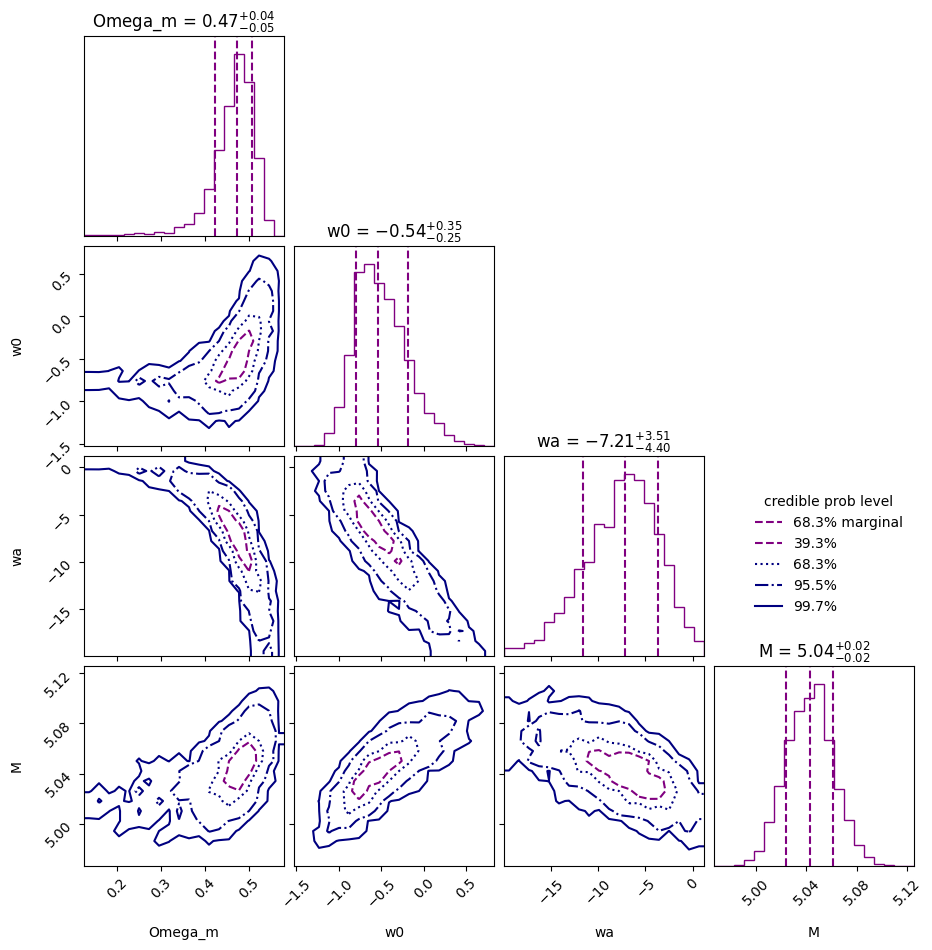

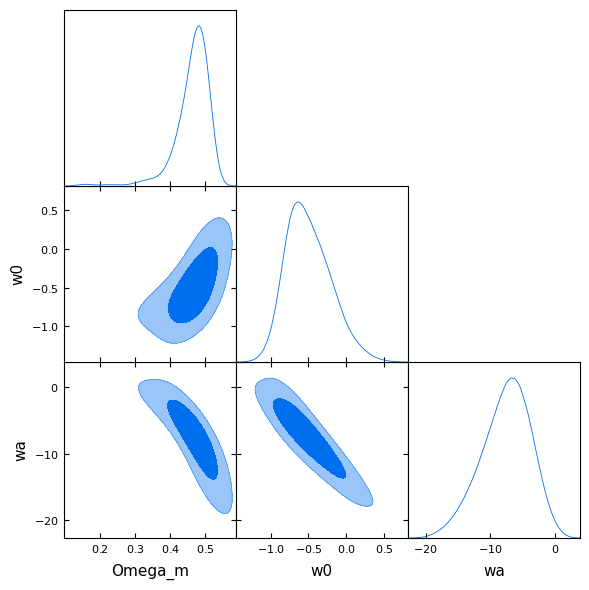

In [29]:
with open(f'{fit_dir}/Flat_w0waCDM_result.pkl', 'rb') as f:
    Flat_w0waCDM_result = pickle.load(f)
cornerplot(Flat_w0waCDM_result);
smooth_plot(Flat_w0waCDM_result)


## Crossmatch

### Match LSC Bricks

In [ ]:
import numpy as np
from astropy import table as ast

# match bricks
bricks = ast.Table.read('./data/survey-bricks.fits', 
                   format='fits',
                   hdu=1)

def find_bricks_for_coordinates(ra_list, dec_list, bricks_table):
    """
    Find brick names and IDs for given RA and DEC coordinates.
    """
    brick_names = []
    brick_ids = []

    def match_bricks(ra, dec, bricks_table):
        ra1 = bricks_table['RA1']
        ra2 = bricks_table['RA2']
        dec1 = bricks_table['DEC1']
        dec2 = bricks_table['DEC2']
        
        cross_zero = ra1 > ra2
        
        mask_cross = cross_zero & ((ra >= ra1) | (ra <= ra2)) & (dec >= dec1) & (dec <= dec2)
        mask_normal = (~cross_zero) & (ra >= ra1) & (ra <= ra2) & (dec >= dec1) & (dec <= dec2)
        mask = mask_cross | mask_normal
        
        if np.any(mask):
            matching_bricks = bricks_table[mask]
            return matching_bricks
        else:
            return None
    
    for ra, dec in zip(ra_list, dec_list):
        brick = match_bricks(ra, dec, bricks_table)
        if brick is not None and len(brick) > 0:
            brick_names.append(brick[0]['BRICKNAME'])
            brick_ids.append(brick[0]['BRICKID'])
        else:
            brick_names.append(None)
            brick_ids.append(None)
    
    return brick_names, brick_ids

ra_list = SN_sample['RA']
dec_list = SN_sample['DEC']

SN_sample['BRICKNAME'], SN_sample['BRICKID'] = find_bricks_for_coordinates(ra_list, dec_list, bricks)

# match sky
sky_region = np.where(SN_sample['DEC'] > 32.375, 'north', 'south')
SN_sample['SKY'] = sky_region


### Find the Nearest Galaxy for a SN
Find the nearest galaxy for a SN. The host galaxy requires further filtering. The search radius is a large 20.0 arcsec.

In [ ]:
# find the nearest galaxy for a SNe
import requests
import os
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")


def download_brick(SN_id, save_path, overwrite=False, dr=10):
    """
    Download tractor brick file for given SN id.

    Parameters:
        SN_id: Index of the supernova in SN_sample table (corresponds to row number as well as 'ID' column)
        save_path: Path to save the downloaded brick file
        overwrite: Whether to overwrite existing file
        dr: Data release number (9 or 10)

    Returns:
        True if download successful or file already exists, False otherwise
    """
    if os.path.exists(save_path) & (not overwrite):
        print(f"→ {os.path.basename(save_path)} already exists")
        return True

    url = f"https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr{dr}/{SN_sample['SKY'][SN_id]}/tractor/{SN_sample['BRICKNAME'][SN_id][:3]}/tractor-{SN_sample['BRICKNAME'][SN_id]}.fits"
    try:
        resp = requests.get(url, stream=True, timeout=30)
        resp.raise_for_status()

        with open(save_path, "wb") as f:
            for chunk in resp.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"✓ {os.path.basename(save_path)} found for dr {dr} SN id {SN_id}")
        resp.close()
        return True

    except Exception as e:
        if "resp" in locals():
            resp.close()
        print(f"✗ {os.path.basename(save_path)} - {e}")
        return False


def find_nearest_object_in_brick(
    sn_ra,
    sn_dec,
    tractor_file_path,
    search_radius_arcsec=5.0,
    clear_cache=False,
    include_types=["REX", "SER", "DEV", "EXP"],
):
    """
    Find the nearest object in the tractor brick file within a given search radius.

    Parameters:
        sn_ra: Right Ascension of the supernova (degrees)
        sn_dec: Declination of the supernova (degrees)
        tractor_file_path: Path to the tractor brick FITS file
        search_radius_arcsec: Search radius in arcseconds
        clear_cache: Whether to delete the tractor file after processing
        include_types: List of object types to include (e.g., ["REX", "SER", "DEV", "EXP"])

    Returns:
        Astropy Table with the nearest object's data and distance, or None if not found
    """
    try:
        with fits.open(tractor_file_path, memmap=False) as hdul:
            data = hdul[1].data
    except Exception as e:
        print(f"Fail to open the tractor file: {e}")
        return None

    if clear_cache:
        os.remove(tractor_file_path)

    brick_ra = data["ra"]
    brick_dec = data["dec"]

    sn_coord = SkyCoord(ra=sn_ra * u.degree, dec=sn_dec * u.degree, frame="icrs")
    brick_coords = SkyCoord(
        ra=brick_ra * u.degree, dec=brick_dec * u.degree, frame="icrs"
    )

    # Compute angular separations
    separations = sn_coord.separation(brick_coords)

    # Search within the specified radius
    within_radius = separations.arcsecond <= search_radius_arcsec
    indices_within = np.where(within_radius)[0]

    if len(indices_within) == 0:
        # print(f"Found nothing withn {search_radius_arcsec} arcsec")
        return None

    # Sort indices by separation
    sorted_indices = indices_within[np.argsort(separations[indices_within].arcsecond)]

    # Find the nearest object of the desired types
    selected_idx = None
    selected_separation = None
    excluded_count = 0

    for idx in sorted_indices:
        current_separation = separations[idx].arcsecond
        obj_type = data[idx]["type"]

        # If it's a string type, strip whitespace
        if isinstance(obj_type, str):
            obj_type = obj_type.strip()

        # Check if the object type is in the included types
        if not (obj_type in include_types):
            excluded_count += 1
            continue

        selected_idx = idx
        selected_separation = current_separation
        break

    if selected_idx is None:
        print(f"No suitable object found within {search_radius_arcsec} arcsec")
        return None

    # Extract selected object's data
    obj_data = data[selected_idx]

    # Create result table
    result = ast.Table()
    for name in obj_data.array.names:
        result[name] = [obj_data.field(name)]
    result["dist"] = selected_separation
    result["excluded_count"] = excluded_count
    if not excluded_count == 0:
        print(f"Exclude {excluded_count} nearer objects")

    return result


def find_nearest_galaxy(
    SN_id,
    tractor_dir="tractor_data",
    host_galaxy_save_dir="host_galaxy",
    drs=[10, 9],
    overwrite=False,
    clear_cache=False,
    search_radius_arcsec=15.0,
):
    """
    Find and save the host galaxy for a given supernova.

    Parameters:
        SN_id: Index of the supernova in SN_sample table (corresponds to row number as well as 'ID' column)
        tractor_dir: Directory to save tractor brick files
        host_galaxy_save_dir: Directory to save host galaxy files
        drs: List of data release numbers to try (e.g., [10, 9])
        overwrite: Whether to overwrite existing host galaxy files
        clear_cache: Whether to delete tractor files after processing
        search_radius_arcsec: Search radius in arcseconds

    Returns:
        Astropy Table with the host galaxy data, or None if not found
    """
    if os.path.exists(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits"):
        return ast.Table.read(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits")
    nearest_obj = None
    for dr in drs:
        os.makedirs(f"{tractor_dir}/dr{dr}", exist_ok=True)  # exist_ok=True
        tractor_file_path = (
            f"{tractor_dir}/dr{dr}/tractor-{SN_sample['BRICKNAME'][SN_id]}.fits"
        )
        if not download_brick(
            SN_id=SN_id, save_path=tractor_file_path, overwrite=overwrite, dr=dr
        ):
            print("download failed")
            continue

        current_nearest_obj = find_nearest_object_in_brick(
            sn_ra=SN_sample["RA"][SN_id],
            sn_dec=SN_sample["DEC"][SN_id],
            tractor_file_path=tractor_file_path,
            search_radius_arcsec=search_radius_arcsec,
            clear_cache=clear_cache,
            include_types=["REX", "SER", "DEV", "EXP"],
        )

        if current_nearest_obj is None:
            continue

        if not (current_nearest_obj["type"][0] in ["REX", "SER", "DEV", "EXP"]):
            print(f"nearest not galaxy but {current_nearest_obj['type'][0]}")
            continue

        if (nearest_obj is None) or (
            nearest_obj["dist"][0] > current_nearest_obj["dist"][0]
        ):
            nearest_obj = current_nearest_obj
            nearest_obj["dr"] = [dr]

    if not (nearest_obj is None):
        nearest_obj["ID"] = [SN_id]
        nearest_obj = nearest_obj[
            ["ID"] + [col for col in nearest_obj.colnames if col != "ID"]
        ]
        nearest_obj.write(
            f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits", overwrite=True
        )

    return nearest_obj


def count_success(host_galaxy_save_dir="host_galaxy"):
    """
    Count how many host galaxy files have been successfully saved.
    """
    success_cnt = 0
    for SN_id in range(num_samples):
        if os.path.exists(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits"):
            success_cnt += 1
    print(f"success: {success_cnt}/{num_samples}")


def read_host_galaxy(SN_id, host_galaxy_save_dir="host_galaxy"):
    """
    Read the host galaxy data for a given supernova.

    Parameters:
        SN_id: Index of the supernova in SN_sample table (corresponds to 'ID' column)
        host_galaxy_save_dir: Directory where host galaxy files are saved

    Returns:
        Astropy Table with the host galaxy data, or None if not found
    """
    if os.path.exists(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits"):
        return ast.Table.read(f"{host_galaxy_save_dir}/host_galaxy_{SN_id}.fits")
    else:
        return None

In [ ]:
# Set save directory and search radius
host_galaxy_save_dir = "host_galaxy"
os.makedirs(host_galaxy_save_dir, exist_ok=True)
search_radius_arcsec = 20.0 # 

In [ ]:
# Find the nearest galaxy for each SN in parallel (Needless to run this cell again)
from concurrent.futures import ThreadPoolExecutor

os.makedirs(host_galaxy_save_dir, exist_ok=True)
with ThreadPoolExecutor(max_workers=6) as executor:
    results = list(
        executor.map(
            lambda SN_id: find_nearest_galaxy(
                SN_id=SN_id,
                tractor_dir="tractor_data",
                host_galaxy_save_dir=host_galaxy_save_dir,
                overwrite=True,
                clear_cache=True,  # False to save files
                search_radius_arcsec=search_radius_arcsec,
            ),
            range(num_samples),
        )
    )

count_success(host_galaxy_save_dir=host_galaxy_save_dir)

In [ ]:
# Unparallel version. Do it again to ensure all are processed. (Needless to run this cell again)
os.makedirs(host_galaxy_save_dir, exist_ok=True)
for SN_id in tqdm(range(num_samples)):
    host_galaxy = find_nearest_galaxy(
        SN_id,
        tractor_dir="tractor_data",
        host_galaxy_save_dir=host_galaxy_save_dir,
        overwrite=True,
        clear_cache=True,
    )

count_success(host_galaxy_save_dir=host_galaxy_save_dir)

In [ ]:
# TODO: SIMBAD cross-match to verify host galaxies failure cases
SN_sample[0]

### Find Host Galaxy for a SN
We set a maximum distance 1.0 arcsec between the SN and its host galaxy.

In [ ]:
# Filter valid host galaxies
max_dist_arcsec = 1.0
valid_SN_ids = []
valid_host_galaxies = []
for SN_id in tqdm(range(num_samples)):
    host_galaxy = read_host_galaxy(SN_id, host_galaxy_save_dir=host_galaxy_save_dir)
    if host_galaxy is None:
        continue
    # Filter by distance and type
    if (host_galaxy['dist'][0] <= max_dist_arcsec) and (host_galaxy['type'][0] in ['REX', 'SER', 'DEV', 'EXP']):
        valid_SN_ids.append(SN_id)
        valid_host_galaxies.append(host_galaxy)

# Numbers of valid host galaxies
print(f'{len(valid_SN_ids)}/{num_samples} SNe have valid host galaxies within {max_dist_arcsec} arcsec')

In [ ]:
# Check one
valid_host_galaxies[0] # ID column corresponds to ID in SN_sample, dist is the angular distance between the SN and galaxy in arcsec, type is the galaxy type

In [ ]:
# You can continue with further analysis using valid_host_galaxies